# World Data League 2021
## Notebook Template

## Authors
- Francisco Cristóvão
- Joana Godinho
- José Mota
- Lorenzo Barcella

## External links and resources
External data: https://github.com/lb4rcella/Sustainable-DTrees-Data/tree/master/Stage_4

## Introduction
We approached the problem as a typical regression problem with a well defined target, the daily average demand of a green space. After this we inferred from the literature and from our social understanding of society relevant features related to the parks and their surroundings and progressively enrich the dataset with these features. Finally, train models with these datasets to understand which wields the best model and the factors impacting its predictions.
#### Literature review
Pull and push factors for use of urban green spaces and priorities for their ecosystem services: Case study of Vilnius, Lithuania (https://www.sciencedirect.com/science/article/abs/pii/S1618866720307160)
- Pull factors attracting people to green spaces are the same for frequent and rare visitors (residents and non-residents, can be a reasonable assumption)
 - Exercising, enjoying fresh air, observing nature and relaxing are the strongest pull factors
 - Distance and safety concerns are the main factors pushing people away from the parks
- The main push factors differ between the ones that visit green spaces very often and rarely
 
https://www.cbre.co.uk/research-and-reports/our-cities/the-role-of-green-space-in-cities
- Young people, families with children and people without car are more likely to visit urban green areas (instead of going further away)

## Development

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geojson
import geopandas
import json
import random
import plotly.express as px

from haversine import haversine, Unit
from statistics import mean

DATA_DIR = "../data/"

In [2]:
green_areas_data = pd.read_csv(DATA_DIR+"WDL_Green_Areas_Dataset_V1.txt", sep="|", encoding='latin-1')

### EDA of original dataset

In [3]:
print('Nr of rows:', green_areas_data.shape[0])
print('Nr of features:', green_areas_data.shape[1])
green_areas_data.head()

Nr of rows: 128
Nr of features: 14


,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Resident,Daily average of people in influence area,Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,1,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
1,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,0,45787.629298,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
2,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
3,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,1,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
4,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294


#### Areas distribution

In [4]:
lisbon_green_areas = green_areas_data[green_areas_data["POINT_Y"]<40]['Green_Zone_name'].drop_duplicates()
print('Nr of green zones in Lisbon:', lisbon_green_areas.shape[0])
porto_green_areas = green_areas_data[green_areas_data["POINT_Y"]>40]['Green_Zone_name'].drop_duplicates()
print('Nr of green zones in Porto:', porto_green_areas.shape[0])

Nr of green zones in Lisbon: 51
Nr of green zones in Porto: 13


### Plot green areas

### Lisbon

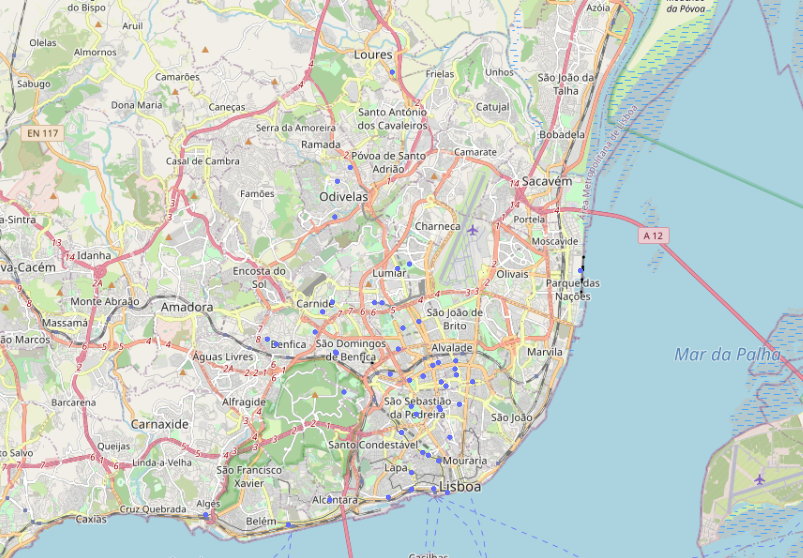

### Porto

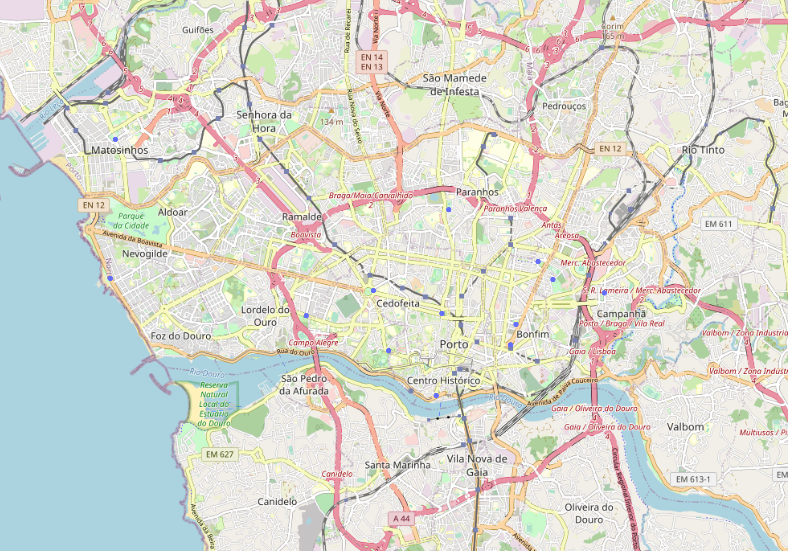

<img src="iVBORw0KGgoAAAANSUhEUgAAAxQAAAInCAYAAAABGh8mAAABSGlDQ1BJQ0MgUHJvZmlsZQAAKJFjYGASSSwoyGFhYGDIzSspCnJ3UoiIjFJgf8rAyiDDIM6gw8CQmFxc4BgQ4ANUwgCjUcG3awyMIPqyLsisO4uWnBVhiS2vW3iE98PeHdMx1aMArpTU4mQg/QeI05ILikoYGBhTgGzl8pICELsDyBYpAjoKyJ4DYqdD2BtA7CQI+whYTUiQM5B9A8gWSM5IBJrB+ALI1klCEk9HYkPtBQEep9S8QAV3HyMTMwMCziUdlKRWlIBo5/yCyqLM9IwSBUdgKKUqeOYl6+koGBkYGTIwgMIcovpzEDgsGcX2IcTylzAwWHxjYGCeiBBLmsLAsL2NgUHiFkJMZR4DA38LA8O2QwWJRYlwBzB+YylOMzaCsHnsGRhY7/7//1mDgYF9IgPD34n///9e/P//38VA828zMByoBACDPWG8UCFRXgAAAFZlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA5KGAAcAAAASAAAARKACAAQAAAABAAADFKADAAQAAAABAAACJwAAAABBU0NJSQAAAFNjcmVlbnNob3R3ZqbIAAAB1mlUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj41NTE8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+Nzg4PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6VXNlckNvbW1lbnQ+U2NyZWVuc2hvdDwvZXhpZjpVc2VyQ29tbWVudD4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CqxW0RMAAEAASURBVHgB1L13jOxZdt93Kueu6q7Ouft198uTZyfs7Gwkl0sqUBYpWyYgC5YhQRYsWTIMGJYsA/7DgGHYBgz6D0FwAoMkkoJFmVlcLndnw+TwZl5+r3MOVV3VXTn5873V1em9NzMrQRZ5Zvp1ddWvfuHec0/4nnA9O/c3W/anhIqtsnX1payQ37cw/y2++Q/s6etfcXdfKRdt5bBmI9d/7olPs7OXt65k0sLhiJUKBduJZG2pULRW0+O+4+VXV6puyWrIgttBm74wY/fe/pfW2H3Hurv7LRYOmTVqx+f3baWsFq/bRmHfAh6fjaZ6rdXwmWfQZ5XcFq9r5vX62sd7/Vw3Zn5/4Pj7p1/o/kupZy3UPX767Ude5/IH5vEFbXh41D766EPzRpp26NmxnuigNTaM78esN5W2YjlviXjUqrW6Vao1C4ZiFgj4j67fsnK5bAf5nPl8PvPzE47GbX7rli1X71uL/zz85/V43fVjgaS9NPiKVWpF+9GNf2x9A7023jdoiUQ352RMzlGr1bLcAWO7dMv86XGrN8LWVY/Z4f6yBWKHdmnuxTPfePP9P7Z6JGk9QzNn3n/cH/srWXv72/O2tca9+732zEvTNjC2a6nBp8wX8z/yld35NctsDVo5l7DJiQF7+fkZW99at9HxcQv4/NZoNGxlecnq9Ro/De61YdFIxGIxj/lCDcam8cg5/22+UW+a1atRSyeHbGnhpvUOh3+sy1UrTatWfLa7y/hUwub1Hdj41bIFmfvPQyv3N635g5KlysH24Yxx81LC8sNmMXisVq9bKNjFGKXM532Ulw8ODu1//cV/ZI1m2Z56OWTdsS4bG37W0okxK9cDNjI6afuZrFl40Xq6kuazHnedZqtumQxrcqdqM9OztrO9Zc1mg/M04N+qxWMxS7B2A4GAVcsV23nnffO+s2C+VsAS02njIGuWKp/nETmmZc39A34a5ktHzXtx2DzRoHmTEWNB2HY8YBFv0mKJhIW6NP4tln0TXqm7HzjFmtWmJbq6rHCQhw/9FuW+WDLmaYsS1ujZW8ln7piva9NSyT73wfvvv2Nz6f/o7EGP+atYKdk//vX/0w4Kh/bK88/bt775DXeNvUzeegcG7ZDrR4Je5Ex7reoU67/5SzbVk3rkbNlAxKIvf+OR9ztviP/zhyVkZLd5Wh67e/+WPXznpu1+fMN+dvaKhUKMx8wYz7xt25srjD3ydOSKxeGz+tqeeYIeq/i8Vnvlko1cewo+Cdnmyrrt/d53rLdUY0zO8QtzWzqoWHF60CrMQTQasakLs26OdU+lUslKxSJjX7O1pXkbGh+BB6Od23W/642iZQsfWE9PyMKhiJUrRcvsNS0df9XK1QJ8H7BSuWkhrl2qc779vN2c/77ZKAz9b0jpWtK+9PJX7PDw0DaXNiwZjDM3HQYwC3R5reGpWgb+/ejegRX3cjZ4ZdSe6Y9ZSMqGtS5qNZG4dYOvkT+1trzxtrxOLreP+Kx/4c9Q3YKRAOyL5OYeaprLgyLXaFgymXCyzdAbOru/WWMuz83FqUvsbX5i4X5kauKIVz/6jl2Y+iv2MBdA16HTOP8Vxjp9pB9OffX4pbc3a5VKw2q1gMWYg8DGdy0aOpIpHHX35hsWnvimDV7+Sdvf37WueAR9VDQvPBMJhW03lzV/q2ktfrq6eszPOYqHOeRy2IrFsvmjCetJpqzBc2byWWvAJyGev1ZHb3Gsp1751Gc8vtFTLxo3l63422+abyh5/K43FrHcWMTyl9D7kfbcFtf91kKfnF5zx1849aJYLFj62fKpdx59WcxXbPW9sg0OjdrSwyV77YuvWV//gG1tbdrQ4JAFgkFbmIf3h4ZYCwfweMAKrKUQY+n1NC2bydkQtsBSaRn917IV34LNNX12JztsBdkfCKUXfYPwhZ/jJbsDjKnZwWHRUt29jCXjFmb9ov8qpUML8nn23u9YuLplvWmuf1q/90xZIzptW/sV9GSTewvZ8OAg83Zg2eyuxSKswXDQsrki8163MHq0mzmqITd3d7bhh4p19yCruYFUd7dF+FzvvfvO2zY8nbL94IKzPQLbo3Zh4pJtbKxzPyEbQ1dLH4QjyGrkXI315MOuKpQKVsR+s66s9fj6ea+tK539kdvHBttEdhTMW1yx6u4DZEHdhkYuct0EfGL24G7D4vGWjYxrbB6dGwnaFvqglN/lGXyW29+3SP+UdU++ZIWteca2jtxHh2DTFbBtWqUD9K2fe47Ar4/aRY+5wvFbNX+S5yrY+r3v8lx5xrdmN2/7bMz7nF0fGHDHfbTG+EzVWJc56xm/ZN74nA1Nv4CtVbRKoYLMRn35fdbytowVh/2JXGGsvaGWhWMB29zeYyzRv9k9qzKGU9Mz9vDhXeYEmeFlQD6DVlffR38nkNNdx0f+4Xd+YFPDf/74789nZRwf/u/2RQNh60NhBcNMWsDjBGPnjhbX7lrv1V/o/PnY31UUUwhhFcM4ebB0z2KzaZju8PhYCUpE2PHfnlbD0rU71n3hCu+1BfXxh3rBuMI6/Bo89TZaotm0YKJtKJ364FNfhsJRW9/dscHPcCjymQMbnZ5255LCvTpxgdejtruVs6W1FZvpxZCAkQJHjosMSTkVIQRTNrNnde6tjlE4gDEyPjHllHY2mzEfz55rZtyC1slhRU7TVm75yp79/of/yPpCJfvyy19yQuZYcbo7Oflne3eFhfCOxXpHLTZ6nTXphbU9VuZ84fRFq2QP7Le//evmqZWds5WvHNjs5a9aV+/pMTw5X+dVq96y9Zs79s73HiDA9F2PXXp6xC69MoohM2p799603ouvdg53vxvNsJWLTfONzFh8OmL1UM6yKJ+JiQkEWdUCET/85LOJyakz31tYmEe5+0zqzx9tj8GZA/4t/oH9boelfbPuIesfmrJMdslSKe7kcQLv3H3UCy0LxlgfCJBf/uXfty2MzqnRLvsbz7x+7sgn/zlyod9KzZI13jxEQNYRWjELX3kVY/0Q5Q1fs/4SKNknkRTS9OiIvX/zllktbbWBYdsLNqwnHLdQxWt729sWxzHI5jFo4nFDKh9R3kLxA4sWem1vbxsBGLHs3p6le/usJ522JtfeXt203Q/vWPT7tzEyQubtaRuXcg4+LzWWstbMlSz02px5X0dQYwSf1ybDQ8OsGdY7z7rLmgwjM6TI5MxEIzyHP2T+kN8ZbodyylHsj/GtztxSsYlxgUHfIZ8/ZtuFXdbBEyaWt4MyHrKH2IScH35PJILScY5kSOmn6UCLk/N2zv+v89uPMupOxi2Xz9jw6CTT02Vf+fd+2rJfecX+u//lf7bXU0P29edGbGtxw67+1f/EfvT3/nOb+pmfs+rNNfNgzInCUb8lOU+Asauyxtb++G0bLT/GmdDBGAWRZNRC9zYtfH3GGj1d9t47b1ksnrCLly47g0NGhwyQdH+/3b17xz659YlNjE/bYH+vzoDRHbVGNWiFYt45FOFQFOezaZ5AzfZ3izY8gDHqR44P9tsnH39sVZzOofjTyLq8Fb2f1wF1l3rknxhjJRIo0cAg84ROzaXUCPcdCAQtiVMxPpGyBwcFW3nzntmrF+3lgRja330dPuN7DF8EeWQtv2UrNds94AR4GQnusbvFsZ9C+CO2vZKxLtZDz2ASR+IQgwFDCUNTcmNp8aFFMcSxUqwXIOjWzZs47Xz2BEoPXLWH6//XsUPR2zNkrWrdxiIxy+GcFXneNX7SCKt5GYvolC/wnKep1RSAhjFT3rO9j/6FTU8/ffzxrQ//0Ppe+OvmiY1g2NUcH1c5v2Csrq5uwK6qTaObagIJWPch7v3O7Vv4gG0HJxoNYxDv2w7GcLp/0AFoSxi1Qa7Z4l6ioS7bRHb093cfX/PzvKi8f9u8AHJnCP3VGuSH4dPsykBrco1TM33m8PN/NNG1XgCH89Rk/HZuvAm4tWtDPX/RVhbR3TjTPRjc0q3DwzjP2ClVDG4Z5k2uW2Rc5FDITpHDKJ8QVe+cxN3mvuXq+7bn2bYvBMfsK/0yuD1WQOYGWkHGpXF8z5IhMcZwb2/HGZjZbBZnLW/Jrpjd/hd/x6annrfkwIS7j+P7Ts3YfmjWMg8/tJGL4zjKOO8AOzc/ueHOMT4+ZevrawASOdZ+Z/2X7f7D+zaAgzQ1OY3hm7fVlRVb3V63b33jp9ypFxcX+DyN4d62PZrwUze2g0CkIiBrFB0hh30HOdzEuZQcTiZSOGBDdsj8R5A7Gc++7Te9lva2eVrjl+hKYSSHkY/o7x5k/cDrtru3iyE+Z+Fkyx689Qf23sIPrYkT9K2uKevrbvPW8fPqBWPuYf6i0TY40yV9hVPm2fyhdfGZyCMRwk9MDsRnOBF6tiJyKpies/vv/lN4OGdlb8z6Jl62y6/8rB3s75n/yjXsrIh5f/MN++37v2ffko6Cbu/mbSlasZ977SXLFhtWDk8w7/A7yBXixaJHzpSAIMcQ7lv8w59+bOVypYyjCugMuOzD85ADJaAmyppmcXPgZzsUIyPP2p35f27PXftS5+zMz1n76FFOPz70T+aLFgzi0yJn1IKnJrB5uAOa+GSjtInUDeOJM3oOkV4f2LY5T9oZ0o0j5uAjqxU1+BvWuvP7VvV83Xr6Js4MhGPQo3dkDDRg8mJTE2KW8OHp11pW95fgRQaaz0QSQCIvhohQtOOohXtXdwQKnLxkNQTi6sqm9SIIw6HHe7j5cgnDIuHOKWO4Y9h7NK9cpm9wwDY31yzd3fYiJQBruicWhhZfGGRDY3GQy+BggAyBIAxhQG2BAJSroCnHBh7n47stDP5gZd+evTQDYjF8dMdnfxWKLGgMq8X1RYzEbhu4/hNnD+AJtfxqGFXepNemnm8Lk3MHuT9zqzcxWgcsMtQ2GGqgMQe5im3d3LMmiOD40KTN1+ft4jNTdvWVQbzv9g0HWBg1nifQ0/6eOxmRJ0/3a6DcIRCRXRsN1kCWK7a4MM+z9HNIyzmYElIaJzloZVCPwv6mpft6DNvk3wnFk0FbXnlgw0MT1t01ZrnDLYwkpub03Jy7M7GanMXGQQIjBqXXgI8xYJqtttFz7nA7LGBQgTbmiSR5MOxGBp4HFVuxzM689T0MWeIA/pMiRIkFQXW9YZ9VUWIybGvOsWf0GiBFp4xkXSOI4zp1cdY+uHUbgzlncQ/KoVWxQr3I67jto1S6cRDCzHGthuPmCXIPIauV4hgWaZ4BIwrBne5OW5c3ZJXNPVt867Z53r1jwQMilBM46lOf01BgUFpEEhgEa4AEiglDr02ZZ+gxygPJ65GUDeIoEL3L4HRIzngxjgsgjVrDLRQCp3K8rL9HR0cZHkVPEueH95G/myxOz6kJvDTzdeZpvK3kuWx7HXMP0vZQXQYWLz/Ivgc6hhJgjlLJfsen+tzHODvSwvqclAdQ+CyW1uXrWCl6PkWFBEh0Jbvsf/of/3ubn1+ywp07tvPt79kb3/uBbb31jvV94Qs2DFrWoVaxbuU3blv19qJltnFM11at2N9jMayfFtGIZolxYIzNCy+56A/flGG9tWGhsV67dvUivHloH9/4wOIJoJrBYSfvtEYvX75il3A0dre2bfHhMhGHthKsEHmYjp8YtGXQVY9nCHkfxYgBykBnlEG1EyCHfVPTtrFJ1CSb69zyj/1bbBKuBEH22qCRHAohfnbOFu2cOEh0ZCpVsOrlPlu+RfR2YdvWIqM2nABq0XjDVIfVhm0DfizcWcOQxsjG8fEyZr6BFEa22UUc6AT6Ad/1mBS9kywPhHysTyIaAG2iEmt2eGgM+Z6BX702PXvRNjH2hA4LkLt2/bqtr65gsBKJZ347PHd8Ym6qjDHfof6BaVu8dwun6DUQWa9zKGTgCnwbIoLb4vgqr3F3O1+xZhknPFa33NL3MY6n3fuSsWsAf+mn/0OL911g/desgLHY1z+EztqwCBGqw4Occ+IjkQuOB4t8vrG9hgN5FqBLIBD38yWMTVB7DG4/z6Fnq9VwQtC9p4HB45v6jBeNFcCBsZPoROdw7yk9K9vLX8aQO/WsnePO/w4pTMnYyKlolA+JeEfdWHsULeCc/ddftU8+Qa619qwLXr8yc8mSKRB9nuEAObkJQj82PoFNgSOB7TLO6/mHDwFZeq2CHQAU3Z47nveaf9Di4SFkjAxQOfeHFgbI0fzuZ6ouM6FaP5pT7snHeqqScSBgTTxUOdy0Bxi5V69/C7135OlylhY2TTUxbJUADt7ebRtJC6xcAQiZxVaqA3YlLcK9FbATUumUKbK2SXRFcwBXor+I4rKe74Hu9wEOzV28SKRx7HiodjKAqHO92AYAYWSdlPI+G57qtZXVZcACP7ogYTucD8mIaA66qJ3GpjvdYwfFDM5kyoY9MwAERKlwwH2e9hrwsUij2DtF1lQRG6KQz9tFjPVUqttFRXbKA3YQuIzzEyK6E7Gt3DwAWob7r5OBMQlo5HXgkXjWx/r1ce3jdcJ7J5zefhRFr2tV5B2yWt9peoM4XEXL5/ZwYl605OCsvf3Gb1i4Z9xm5p62wPVRG0KGB7Dz0uleomwHODw56+I6vg/u2f/xO79jf/Mnfspd5wDH6Tvbd+0//i/+Ng4vzhQ2pMAumQPKeDkMHfJ8RTdeQZAtAVAaLwEVmo8GZl0BHpoe6rHlpXlL4ThKj2dwJKNkphRLRH8+SzFwLT1/vXLW8RgbnAa42T92utqjfzy9f8JfaKKYSU1YtcaCOkV1TajSElCEUr4SLh3S8QeHBQYyZXu1jG2FN60UQGAz6HEmMFc7QapaZcJo9/7IpvHQ/Xj8IjFLdm+V6xLC9XaDRsqQ91rkDQyldMBuZJbdcV8cRBmul638GqFX0rMKOBotBD0SgWgKYT5f2kLcR9RKFu86ZfiGus3fPWWXCbXuEBqUN55MRFlMsRMm5goSwHIiRPv7hPlYzB0KJVA43Qm7++Ft6xs7Eb6HhAS74knGq+KEiI4XMwmNEK2sb+JoRG2vuIVxB+d1iDHzFAmRkVJ1CcEXeAzKkj/YtV3CZ7lC2aos/tQ4EYmjyEjnND/u7+ToVdu8fRNjAaQuW7FqhnStVpq0madcWHaJ0OWLGKwT19uee+f8sf5ZK22tmR8HSQJbVD30WuFB1mpDHtC0A/N746StRVwocB90QEZBOajQeJAFEWMcIgigXZyojJULPoQCKR4CHkgp+f+TFKWIJmt2//4NDAOiK7FBwpQLIPVPRqLRV7ZyY98uXOxH0Au5PhJ5MkCI7pj/RAQeYuivrx/Y5NBPWiyIAehQix6Ea8SuXXmRMb9ptbVFw/7HMKhY6c68db/2vG3ghCqUnVdEoLhq4a4+i3WPnxkaCZ2uRBx0PWT5ZS7+PIIIherH+BHiHm1EEbw4dizktdU+ImcYA/BWhJSjKAq3zvmb91dt/4f3rQCS5Z/fsUgC44TUJNPP5yAPKUvNvRIGDVEMUP0maWDBqWHzjXdjCDxqgfswyDykI3oiIHl8t9KsgMCVQH0YE87BInQyQJeWoBZSJiRIwjxKGqSQ/c+iUr2MUjpxPG7e/n0b6f6z7nyIEufU6dxS9LoeLwEmmi7MLuNe6z6RiDlUsCJng/X545CM3hA8/nkoCmqXAc3r7x1wKWelUlsuzM5esMC1azb+F/+iVeYf2IPf+l2bev0bVnjnk0dO29wtWQx5eat5YPcXN2w2PmITPfDLX/8J5gQD5J/8EQsUGY4C9CZDVr21av4XrrvzxGNxuzgbd0btMui60iN6+wAZkFPiL4Em+ulQq/UcRvkt5iXr3upNDzA/MZxS0uy49wb89+Cje6RX4SQCQJRbpLn64M0fbwjduaOtiAWQnzEicSkibU8kprEJmumMC0+ReW3aFNOfnRmyCgp/OVsA2YTvicStb+7b9n7R6imcaiJf0l09PTF4jpSWjSwpm/t2cyxtM8Mp68VY9Aogggd2mCOlII5fGrRRnM3OAykavbu+xZoLcA4cFe8W14lzL+aMdS+Gbm9fP8Z4HpS3TIoRhto5Hu6kj+j5wpyv0rrnREgcPtyzmpXRiVuwfRC0s4wDWiLN4rRD4cHobvjQIeg98bWoTEpIM0pqW++M+1sRvzqgRA5HtxcDMQx/KjWmSVQjkwUg4jnj8GIavXZszLlvtv8Jx722Wloi8hm1Zd8qqT1X3bqRQSV0X8/e0ZenvvbYlx4cOEUuzzgUWvexoFVPyU6rk1JC5LsT1dSTKSqr6xSP1omLZiIbsgARGi+BWIXVh6TelMw/PGxhQEo5FOu3sraxsm3Z7Zz91Dd/grVWI+2TOQVNVuqa0pAkCoQUKk2ljzUwQKQtkUgC/DScMxUDfGkCwnjgZ79f8pFokuVwKklvqw2jB3AWcD66cEwLRLDrYgL+V4QjRtqqnIk4Nko+c8NmJi6ecSYOSS2vJCasdkC6V/AW84AhG+3mXrocOJLsGiLyFUOXrNhG/Q78EbDu4DC8O+AiRfmDA+a86EAmP3JSz3YAz3WR6uqeCrlWh0cehNdIsY3ahRaOAXC/jGVFJSIxUpx4fcBrGd3SE4oyDMK7GhYvkccDeCoWjOFbCdjdB9Q9savE0yWeXfptFjAiDhB7wD0pkpJgPexgUGveypNftCuvfMut1c37b4D+Ry2ze8f6wj1WPdiHj3A0sco92G2KODpAmDFk1C01dIW5WGZIcarRuQc4ME7HCI0MDFp47FXzj8xZEPAhNVNz3/cQ3enp7kEf+F1Km2y+KiBWQrLwR7etvrxmf+mb3yDK6scOatibO5v2lZ/8lkWQabktMgUYJQFdslskz5Tm1DOIzYciEeBdk9GveZebD2jYINOgqy/pAFMnBBg7PXeOtLDBEaKEh6SnuRF103LyD89YBZCrAiB6kBle5jeZeAreIbsDu1mkiNryytKfTodCgyhFznPKuibEfKKgR6//tPmDRAjwEOuESZulqkNsWyw25fulQaTFhKuFNUJOUZv0Tuosj1BwP2NDIEFxkHZRCQdjC4YJDFy0QDQJEpJ0DC+Horj4pnmjaZtNXnHH1nygw6maFefm8Brl8LAAld/MomUp2xoKdHYfZOXuW+bZyVpwkHQdDOG1j1cQols2OUv4i8USxytfYZKENA2AlHdofXOX0PEF92cG9CmuMHaHWFBjhLHfJMWgR2lPR8D0IcZ+qps0FozAMGHO0yTnK4Lhp1z13QKoAgrQEUKnWdizud44QoZw4SlkVZ8fFg5scfU2j5eCaYl6kK4UArl6EtXzdRBqQiggbxUvHvw+SoS/W4TPTQyLwVvFCFaNRgUEswKDxyKb9uKLX7QAaP0+z3p/4ZbFh3029SyIXepRw9JHWkqE8dSiElWzOxhjGJUjTyGYMPp8Qjz6QMDkzOHAgZ/sgvzv1B/Y4UKN1KArhMgH4JMx0KAejN0V89dATFB4HtBU/2ml8oQHVf3CxkaeMPVJnU0EhTgwGP9cTomE/9buIcIUJB4ncGhkinuJYGxH7d7d4qc6FMqb7B5t80oF57ETSWvs1az2bsECT2NMHuUA7+d2qNF4xilpKfugP+KQwpRSONBgXtImPEusFme0otg2dqx2b9EGn5q1hw9uWPNgyfpBHSNdw48diQQORQpkah/h3RMYtXx924oIdeIQDlXJEc3qJ4VFNQrOqGC8Du+v2OE796yOA+OVAVbxkBONxTLaDjc/9kKn3mwVQN9QwolvvWqWxDBZXMfZwSHsjcHfPJYiDzjXte2sU3ZevDYfedstjBhv0AdQ0LK8dxdjM4/ARhDzWSI6Rdi95HJ2/Sg2KTQZYwEMiCgOSLFScCkIp27jyS9Z+37fSWRFecAx3ykD3wk1vq5I4xFpORZJ21Fqk3KpI6BJLYQ6Fi1K4NCty9PASed7j/tdJ/oWmXnqcR898l6EPOhc/tAqrKku5rGEUbCfYy6JelaRhzKS6+S19/+ZP2sVog4t0PXHkVIfXsJI2STNMIgB3ORYhLE71N+XsMYyUQKUKALVGitt8Ob0eRRNnRgfddHTwxzrAIfisQRs3GqdrDnJq49v/7YNdH8Tp2jEVojYNgEOukcS8Bz1UajPKohdjpx0XxgDpnly3vrRs8iQCePsOkMWHaJ1UUW3jPVM4/SWbZuIbifS3OA7QdJKjglZ7IkSGfEj6zC4PUdhhUi4abOplt3Z8Vh2LWsFllholDz2Mgg2OisQIa8ZR2IgnLQGqS66x/pYylaWNkEBD2yee/d2A47AqwCgFqY+IRVp5/ILJOIm3S1oHVeLLF9u24/IrwFslXlWRanlpHgxPrOkV8Spb/KhsyrU6ZSLAAfwiPhc9RVxeF/vh0BDRQ1qVWTc9pBSuUoqTQ0e2MexHuXNaYwsRsodd/wPerpGVBAMlmu0x6YGiBBMTaOnT/hevCaQYnNz00bHSKWpF6y2+655BkYsBaAmw+dJVPfVbY988jFv1Jq+ErL8AINWefklah57QbaJyhxF6p90js77deSPb6gd1e+8p4hlizSraojBdOThOQElqIes4lCJVJOQwjiUHKtxPTlBUeR1EmezBELdrBIJXkf3YOwHB/uIyiXdum1ieH7ww3l3jlGMuqnJcaK96F34OBYNOb7LEmXQnApkCHDNInOU3d11hnk3KTqpiACZIDoNADLV1u1am7uAKWWMyEo56+oj0hh9qgssEc1RJC0gXYlBLVq79Vs22hWwsV5kPgCASGJ/ax3Enpog6yelDQBV9QtWClugCigX73F8tLG/ZL2NIc6FHD0k0hFmDmqHli+tW7w1ZH09I8xnl3MClIqme5WY2yGlVWmsLXix2lWxCS/RtFCWzIMdshP8OMttlF+1NGWcMAdSMW5tQBXgkufR3IwNzrn3FMEp7jJ2UaLFUa23Ni9KZmF529zctIvw7ONArKwsYwRTAxjuB5xBtqN7HoLaP/fKNe4MncOzJdKT1jv2gtVwwCxSQp/vo5fyfIqOQRZ4FenhGhXqeMrJaZyIFLIxBWBJRJeavm74QQ7jg/v3LIItF0GHiwRaKhpZAFQeHBp04HGG6IvkpJ9UR88/f4PbxTGU3tIzMBEPGCvvlXHSsi+454pg43aoBa9VAATk3NZ9NatKBvI1H5FKXSsaxj5OYgvjEETiUTIB8vBhCL4EcISnuuLcs5waolBNQDSt6SY2WQl55CHSEyL7IISeSyF3lMUguRrjvIXCD49rAY3UGJ8v37kl7Ko/ReRSEtrjjMAtoIcU2muTp453xoCoiChICC50LqdTg/Ejchb3esBRdpvWA3MDfJ2hFghBBGNpqG/aDaA+rONc+IZetK4xUJUjRu18qYrA7PvqsxZD+Ku4CLvFkoQjs6GarTdX+YubPQb9WzbvWbankz9n3sqcFT+4b7VrPktemSISkSNXumg/+P737eUvfdEh5TMzc7a0OE9h5CJo3SRoHcWLCPwePF0hlnKsOsLW1UiEMOJg5OHJYVt+uEoIfIzPPSzcXhSglO3JQuvc/wEpMUODI7ZDuLPgzQgIcdSiOGgsjFc/edExced4/X6HAr0KyFr3TLs+InI0JirA21vcs+0MAmW9BOq0D8pPqgmKUkbrAPl7MYRSF4vZDwPL4BSy88HNDwmDr+n2IBwv9xtDKlazt370thMYM5cjdv0nRnkeYkpOcerYsyQHz3+k/Or7NctubVll8AVyeMPmS+y70F+ohlBEwMQQph/cfsv8gyCaKHxsXvt494c2nrtqs7NzOHRxV5B/+/Yt+EnoOfP4GbTwMIewbtnVq9ecE9A5vIBRfecuOf+gsEMjJ4ZL53P9zmWrtrBAURv3NTExaXMUGet5TjtyR/rr9NfOvNajh3oRNvixigDIWRSFKVIsL1JzMhcxnwx0SIVu/qPQsAr29bz71NFI6YgCE6QjvYmSYD3IA2ih8Ivv37LYYIxxIV1isctioM1PIkV6hFxtUS9xffCK3dgqgLQUya3HmOG5ZCipyC62kbPNf/k9i+8jpIeIQnShdFFeMC83+aSzn32/vkDuLakPjZlBW784YM+zVhyPKPQcRj5gsBy7uqTuBHB2jgneFap1UJdxR2TKMR8MyHTrPhsYqjKm/XrNeDYYhzpG1MHmgV28eMkOCVPHoicy6Pi8j3uB4FXu849DgiGKrZL9Z//p37Jf+ZVfxgAEHUduhbifGuinIqweFJGMxM90LLh/H47y5yEp5GQXEYIywEFmG+U3htEQI1y+4FJP5hdWXD7uGKifFmx1ssfy//L71sLgOU9KexjpSvM2T0MEufCLv020CeR8jYjhpZMow/nvdf6WoRwC7auBvHVoG77a2NjA2cFBINUxyZx6MIJPUxT5dUBjjIH0KIZXytb2ihRJB5A97TVwYWi8Pd/np+RI/rhzMQ6nP94CBBoFYd5cXW5HOo8uqJQOv9K4OkT6hkLpAiLOU39MDnPQbnn70C0UpTMuHhR2d3+ZIuNFnIAeK++3HLAUw4HMyPCfHbH7pEPkkaW3cDDTD5btwlPT1j/Szrc/fw39HZSo0bPwAK4aTClMjv8wilkXXtb99vYmY5gC8Bg84v12NP5AoEtlFp5f0qkcRUnrkyOVljEK+n6AYdrAuAojy1Uj9ziqFlXkSyOQI10cSgyA/oKaw4unZZuTsUQHi6y1xsEmx4cxLDHmT8/FYy4Qa9G8opG0fU/Bujz9ttyAL/1XHAqu2qsK6/XzUun9zeOarM53VJDbGh6yBLIrlp9hrbHi+DmMFWwbI16OotJ49Cx7e0QWMPBEFUCRVpdSZTAS0R/REWQS5zqd8vjwxhb8icPGer54cZZUnLPOTOce9FvZF350ZYkwdNdRuso+RdDdGL9+UHyh8D2+tly7/3DHxscuWW9vJ2Xawzzv2vrGmvX2JLE1QkSBsraaX7L8vX9iT89MW6Ah0OZkDjeX7pCt4LXxL0zY7+ZGMfyJCu6G4P0JZFCMrIYl227cA0ytWG4zb09feNFShSHLt5YdPlDHEaoDPCwtLbpI2OTUNNfcIeq0xxhgqKJ/RD7GpjdPSlN9S4C6TQQpLu9ewehfAAigMQT2neSuonAbpEQOUKQ+NzvrjPUsjT1kT0h3SW4nup5lDjaxk4i4YcDLSS1RuzU8MuqcCRWf375zy/qwh5qK2PMdGcq7nHsru+3uR8ujm4iD5B9inlQh1ib8HaIZiX7apO+2X8n5I5HcQimuQfRY0R4BMQ8ePrCnnnra1f8pir2LI5NirSuapCYeJdKNP/54GzuP5gxyRBc2Lfjrb1rwEtEVxqdDXgDjL/y1n7ddgMqot62bO5/pt6RTiLXSoTBz5u4Nm7NQy9nhIiAAwFlyoBvwKo6zRWMTQDyRnLMWNptsgVjXABGZHRwL7Drsy0FXGtDmBzXvEX8rqqPozqVLU6QAn9yLUsvkAHfo5O477/yJ/y2jE4SslrWkui4d0cIn/wKGv0aRDMV4e0Jl2h+0Wj4KkCdcitD2qFI1etz3dQ6N/0h32EZArESNCqjfBw8tePEV97cKxnwX/jy52+TngVQfZdK4z/SPh7zyInJ693s/AG0v2s1f/3V79m/+LWv8uefw7uG6AxQmhn+HDrvuupdeIgVSgA06FTULJWuO0IUBD392KG0fvvUuOa8zznGYmp7BEN21BwvLbrlfvXrdfT9DwVkThgiQkiNyoV2E9j6dMSYvjGEEk+YBipXh7wvUIqzSxShG6PY0uTFkFQdB0LcXSXcCxRK1QLe7y6t25YVvuIXV+Y46Ktx88LFFQPxjhLu0eEp01drFWNwjfaay1cQDLtk2hrzQiA5pcSo09+oXX3aF4mXQI9e9hRSQEgxqeNaJJOPPZMC33A8CJ+5xhkuafNbuEToBgXDVEOR1jGO0sHwAK9a7yZvE2SsRFqV7UD1NCgHoZ+OA5wT5bcWessoHGxYcathIL6gMYcZWJYShm6DbwYb5h3Cgjkh80NPnx8j9xKr3Dm16/LITSteuXbfV1RU88ozFMAIC56IwNe6lhBG1t1Mjn37aGQE6ZRsJlOdOgSpe60svv2oqPrt/b4sQYxQFL+euHXI8pH5AQu71L11zglLfl8KtIBi16CU2qoTMUyri/BTaWSG0zLzgt3BufeuEmnTlaLncx7YxFQIh1HSLByoslAjCLgSq0UF2Wii5Bifx8L4UgCPuqfBbbxExILVifdGqc5fMf3USpXIi0DpXVCeeYRCYDKkMhKZsziaI8m1ZoLRovtsggUug0fBPbQRDahgjd7jzzU//3QJpwbIEdsUp2SH6NIjh8edessNR0hAZT6MGRA+ucVeKnhBCGdoyWJRfW8HJEDorqVsinTFnO1ZXVZ2GhVQGH3NsZYRlKYHDqw5mYYxVr0tBlJMiB97LGM/NXUQxHHINboWo6eejR43Lz/peFYUYQeDrvnuF6KHlHJjgjGwMDAwwkmrMx1h2HAop0h7mxnY3z56e7zSKdKMjJeLTqC0XuFcpTcaUM7t5HESZj49NoSzv2wWcbuUi61jVO6zeWrEkctdxiiwDfZlxP0vwE86ib1LGC+N26YifpblZgM1D5kFyQ0LgHKlzTOGQNCXJbCl7fidQYiHm+JCUhK2dVcboHbtyecbNvb4+PnbZbt78gM+GXZ1YNQtqS46+HfnBOk+H389c7tTC0a2dJiSUG/8W9ytDwaWn8aw1DO1Y5JSj6r506kSnT8LrXpDUl4Y9tgV6XSXGK5Qv6Ef58zJZ67GBySmcuTI1AlmX6qHn3SZHulIkJebhOjVA3TaFLHrs/Z++1qlbENgmZz0SJnJIqoMMtaHRcZdjr68IUMgQ1Q1HwpYg8t9DZMe8oBNCKKC+dJ9lDu9iUM6ydNsnrqNbyVqHpx5DHNJqEYGq8GPiXfEEEclovwMUFH06TUqTzOznSDsctrGn58jVJg3s/h/YwOw30LuPvYJjs+F6v31od0gn7rbnmzi4UEM8yP/SO5LFWrefNla6txYGlQ3ICzsh6ZlYDx2BtiTLT+4hwVzrO80w8pFzS0775dCS8qQ1Wgft3dxbIeVS/Mo8ndMbFfTm0n2MaGVOALANDY+gqw9dfYzqORX1aANnbZmTBrxRJyaNww6GuYw48WYI1FkpYqkEET7OtYYevjB1jbkktgEKnsDhVu2MgLuRo5rEQ+oJ9rObVl3/tl0ZHcPAPEFVW4S9Fhc+sSYR69GpF6y4SUYAEcRUIGV946TI0X0oWGNMUR5rmQUbi1Gzkca531q1BI5ijnRhT0SpQR6nKyMY2eKrHOnZahAgg1q1MtL/xwQvzeWnLEtq5M3YXUti+PbhTCg7Q3UjAlCee/Y5eJaakvV1a5HBgbCnMcseMjhjJUXyFHWhXqJk1Gm4zmQReIwMFmSJDGh9/t5776CT6FqFbvBhH6k+o4fMil2axORZZxUMuRBpt5ovEeKBKCDprXIS+f+E+KDN/ugMPuJHelf8IPBD0akq4MfDB/dtjPWlE0n3S/YlSKXK53LOiUzBT16u7SXlLUh3Ma9zJo5OLH4kwuQ6lhHhiPqIwJK5wR2d3MZjXmncO/cWorOmOhRyJhwjasiQJw/u37ckUT9HRBzk+PYje2I4paPMj9JDD4jq7JAJI/uDcL2LsA5OjQA2kj7Mswg0jZCCrRodkQB8AaFl9ECIiNafKodCyrT9gxCHSc7ffNghsOSWnbK90LntxS+EC2eiQ0EJZP4LKiZ8RJsL92wihRNwRIsP3rVE6qtUsqcxKulOkzhrFARfHLPmJ/ds+JVXYGDCrJ/csv5Xv2wLWw/NxjpnefS3Okl4lJsN4xTf/tgSrz1lORRKgLqByb5J21xep+tCwUbGRp1CUa6dOqZogVVAd7fXCHH6ybfN8wR0LJAeDiNs9knXkoGzR5GMF5Rs/MKEu3gYJpdzpFCwirQkYIRMK5dRre32Gxh4UA1nIlXcsKeuy/g/GV3VXzykSDhAOpCKk6oIxOX7GTo2sWAjabvQM2b+Xi+dsx5YzQdapBacCFgpMD9OVwtj/s7mLQQ8c0POvtasp5swKi+emsW7Ryk1CcUFWcBBjnddT9wdye4M2t5G0g5BGcs7mE87FAhrbSk3hPxLoxhLodMg6EZzH2SEfOPADLnWXCM64gehrFqyQXFXawThpIJ40KTK8qMIOGsxMkDea3bZbi+WbLx3DpSnz0ZAOJZXyqRi0U0CFErNAFwtDQvLrwVEocGVKxM8Gwk9CLHNnQ3LFEFKyDkIY7j3xodsoHfAJifpJIEwlEBVe07NwegIiA8Co0NuLrL78BIRrzodIAj3RiI9roC8D+WggIHy9+XIKG82RP5kA7RFii9AZyfZ1CIV/suofhK5YlVSIA5oN6eiNyFcKhwMwDsaHycYv3LJir/2hnlo03yGVrcZy5CVv/cRaSpEGcZUm0CIt5uQudBIFFD1wW17hjm68OoXrPDeQws8XLEBEGKhJZZGmKvN649BzQzfpVNFjWhAFVRKRqn/m1PwXBcGPiFwBK3WxfDwlHtuGQ9CfxWBiyDE676y7db2QPtRGk1AA2bRz2AFPTgkcJ+Uc6sQt/4kfJwKWYswseZSkR61hhUKVsGpk+MuAV0oFBDGoIXUOX1e8tGy8DS1GMPPIqVbRqmNymJEKDKpFBvVh8mRUOQvQnpMi/Wr43gCBD5pmDiOiXEMq3MOhRc513yLXF/S6DzxE5l3+h5kZJZIFZUTqXPJiAmBoum59/cy4ny7fv0pnDLGG0W+SZRAOdLxJRx0OXoo1DoO9n2Knlu0Kbwy/ClCUBeW4qRNrQfDw0sns+YSRthUW2advq8IwNE6tV4d6iUKfIiRorbc/a5Yt8d1uFMUN0aXKZG63EXjpNIVcHaoq+qd7LXewZRLR1Qtz+chdU07ygJxh0do9bNNQXgCuamCZ60VHoF1WqX49Ow5W6QjNWk/7iXV6nEU8tMkxEM+NPyIlKQF67jlVz+xBqmeGeZKho14sEREQGt+JEUkhuj6bfi6wfwtoO+vRDA+P0cqpuRNg4hJACNGhkKUNSSSEbCHHBjsG2aO0QfwvQc9VCb1dH8Tg9du020JXoKE+i6sARbVxq1UQ0bzXhxefCTVyR2NnELf1AtbljxqMakON+tbN21w4AsAT0I9qY0Dne0QS9bVSnT+9kWRe+Nf4EQCVU6O63wuO0ApQF549UptDj5CN5DuoiJjFWnLsuqhluaAOgClqkSJgDzJqWjss37g3fPUIgNBqR6Poy7SXVQXlcNAlDzodukOB+bpOsBp4nTYCh7pp8fQ5jpgBtEJ0eXLl5xeUM2ZaibEt+pspTz1qYm294tkd7UQQdJdUqTWaB5lLAdxmArI7iBp1fntAvpqFAN+jwjNAXZDH002tpDvtL2lDVCTNrpdFCBbgeha7i3avkcposY4PyIZ596BF8wGe60vQpZ+AxslTBH1IG2i4ZEV2l4rdTWa66dN6GU7bD0LtrPlnnGrfo/3h+Bj5BEphNIfXehxBeparBnNlSIkSllUWrFbNEfXrcLb6vBFBaM9nQOkQkdUwioWR0XTtn1h/q5dv3Td8ecAabJK0dkiWtGvtG4oxkVKnF9pqiQ+MS5tOXsIAKExEN29S10pulzOhAizhPME4MU+u4eRrTqBe+/O2/XXLxGFJtrN2AdJO/QddW1rousfR+In1WcplVwyOQrI4SeyFsUJ2id6rVbfWsNVjhli/ciAl8yoEyHy3MGRwEFiMbUjY0f81wI0gAnM25u24OsXcZjQ0RSe75ZpoMO8qxXsj0Nq3MBFnWMdQd+F+HE1xui/GGHMPdKZq0THpJtz3FeUOsootlhUDY9YdhWcRwHEamedwGY9AACXPK0DyGkuZGf4Ac8rFN3/qXMovM4JwIjCgKSEhRzZoTNj66WjTYOCO0/b4nSfyQCsI5SEqAUzq+RDtpGkLib/oFEAiSWdg5BmJBOwAX8/YaqJ43OWijmQD4x2ZE041I33tgeafjKh3tlua3xEEdkk7dF+49ftub//X1vpTVoTjjCJY48Kwc6J/eR11khVaDFZtTXCXZtDFCYS8mQR+RHWg4Sg8ggFtfe7NHORfLUTo+7hnftEJqhbAEkSNfhOjQkX4yqU7ZAfjMz1B0QdRiq2vbvtENoEXSTkRcsAyNC1R0pmAAW7sbFOQfWBS0cIUEfx1OWroFAn19M1drNbViJKkEA55Her9sn3V8htvkg4MYGxveK6ECX7SGu6GrbRFy4RWoPxQTk0R+VyF8Kwfa8evOFUPGvhQLt4Uuf+NCo2Ira/Frfd2xS3PT2I0UyY7sjA9SE4Ugm8ZIeE4hxGOSctXlu9MLltIoIpmGLcBniWCB6mmF8OmXJ1W1EiI0+gGI5OiHz8PaJA2lNhamrKpkj9EtKVyYh3VHSlfvF09QL9UI65SN1GPrj3Du3rtnCq0PZEiIw6gNX8Q+vfGrdrc6TGES6+cGHGHd/5Rwpe6Rt5ulAkKMSGA7hXlCuhBi9hazkyUjLlIgscZy7EAg4pzQYvYm+PeSGtIMwYpDA46nWO4dJK92ujp52rwCPcP990bwhVKIJWN5t91k/diWoayvCD9iAQHwUQLole8mS3UPxtmXxyIr1CGPnpRNaklV2N3O76XXiZIswySFnfz/0EOfXMF0jI/h/8oXX97b9n5dUN8w0/OaR/9uTtv9QRqEE9iX+KlrFXx+xAvE2+eTeoWkAGIYtSjRY0bqo9iYNwDpOOIoEtUqcU1U7JwSZzHN6vKDhtkQqINaFkTHN3Dh2raF6ehgTa44USQGp0UNpHKNYhUbS9LUL1XNKly3CsWi5KUX8eYolTaLuNzFI3K4w1FIYQIRdJ9OeohWgXKD7uXEVQpQDpPru7ezZEFEvOjKSP8rUFBoSJXngxFNUKu4RjIYdUrQGrN37w6OmQYU26pZV/910LvTJt3tFHw0KuOwgGmhR/AX6uAxz4MFhlaulnkdaWqn0R3bl9G3Q1gf2Bka7uTRhBHmpRvCCFcXKA79Hu+ObbS/bzL7zEWmDwHkucVYoL8g3SDeY33rHEf3kifztfkeJWDrd68ytSIsR5ZGLS7t+5w6nVCSZqQ/3P2vzir9l1mgp0aIpI44c33qIV7hQRvrTl2IdoB4d45MIwrYufPH9yImTHKkdZzmaHgsjAvd0MUcekRVn3ypMW1ZkntRA/Q8hxK1EDwPPVW6TnPib9SWkIPAwOYdkWMQRryLRg/iN7avyqO1U2i0wHDFrFGEvjvMYZhxJR2wcUvG/cW7fELMZdH9eQgvoUymTzNggKrn2HlCffMaxdOhnjp6J7Gc5yjvwybJiSRCzJ+mqn12pNqc4uQxSpJmsMUoeaoSfOK8H5/H3zF5csPjLrjpdRXIJXZZyq29TG5iodetr1BO6Ax/wTjD0eeJCBuscz9dMdyq13jQupJnvsyRDCcFPrWek1PadQeqGzJYy56JHOPH+pxu0N0i3bfHj6s+ae5k0AS/uZT3+m1xEcv3w1h5xpUJOy7z6ODJ8FDs5/p6yuhdsNe+bqs3bv3j26Hl1yujyPg6z9dZo4kuOurXmFMVp27ZsVhXD7N/hB40mXkUEYR7cJ6e9nvSNckAvIbXjt4foDJ3ul65U2pq7UD7jHyQBG4y5pK/fI5BicwAg+kTv72Q1bJNUs3f9FG7/8HN3ZVtBF/c6RDaJ7tpiz/ToynDTkQnWVjkIAnRTXb1Yz8C8ARJgicoCMsdhFWz64QSBKac4YxX45d0QO6Jwp57GKrtveJlrO/Gk/MJF0YgUDPoRuE6n+9aC5RrejaTpHUfvH+tAcaO33YCNp7athTYd8dALUNyUXPaQ0F6jXrAdIU+V8qmXQtTaIjk+PT3e+grNCRAm9kDyVZpa1dh1AjWse7pGqNfECDgVy4FOmU1EO2aKqc8zu7TiHQpFi1SCpnatSfxWhEYCl5xQAE5gnivPhfSI9VUA4ZNCpzBFFab1cNPRl9tSawvHiuSvKYOEZvDiNATI3OvKIIJh77SIox0/26AutW42huoZ2C3xhoJRCp3UYR/7E1HYbZyFKOq30m6Itp0mdDpUhobUkGyoPaFsjwtqk6ZAfUFtUB/ysN9p6t+2ynT7Dn+DXMfLIlAKQQDgOEL6qLcAER52YQnjvdRSq54TX3JME6WDQRKunkoP2bP0iobOcFdnsZLO4SBeSmJXo5jISG7XRPqINmSU6aLSFh9qH+nqeo7AFQ0ChZ1Dm0iH9vRsgAixUkefCqHlvoKSWKfR59orRBsfqtLlsurQKGOJJRFFx0+Vkoa1YiJWFHYu/yAYxPEtIuXL0jhayk2jG7e0P3rFnCfmJIVWsVOYe+tOTx2cu0jIxjmBWgVHIGdfY1eRJjlwcYTVQoLWyo6Vt5SGKKfk9MDKMcOp136+jXFZzy3Q6oi1mfs2emxi37tSjFuTK0qLNXP5Ldvfh+/ad//cTxgRlOtyyt956G4HWZ7PPd1soTSHZkZddWkvbVoAOMdSFIMUxxk7YrMymbcNpRYYQRqeoSTFTvdFlWaIJ5RztQ7HY1Z5Um8TUR+ixDvLR3f/QfaPaoKUr31cOa8iPkCFVxcdKC6EAy3IeEVaunzfPK4WjxSAUSWHgtug5deHHvKzGQAVCGFR56l7m521yctItpo4xdf4rciZ+449/yZJjMB+207EJxhqjHNLWWvdt/UebNpaapEUvnR9wbJSPKEdCzzAy2oXiYJaEDHO/HZKC114ZEkwxDPQSC7tKLmgR5ENhXG2GOMDGd+JGPWMTwf0kEj+rHFXk+pg3cAZAP4S8KxoVgyecoc7nGqv1tVXWh8Q0JOtKV+H+lHakAlpfP52c4DNH8JnHD1KjQsAPP7Th179u27T9jP4rEmbOyqf28U/6F16uL8MzCNDg61et8TOjliGqkAbVmgKhV2vIHGkRG2trIK4UmiHIhZXWQAqz8NrA0QZAOn2LULqiN0oBqiHs4nXxNTPD+yGK507T1jb9v3EgtKGU5kZjuUNanFJDuokQ5daztDEm35VIhRfUUYj5pxHihWfgHkC2NIKxrrx99O6CPUxs2B999wbh9RLOeNr+7t+hCJXIiI/UkceRDCE948bKqs2++rxznKRQUzg8UjKrqzRzwBGUoB8ZG3PKbXeD6Ni7P2D/D1LODthvhpSt2JEh5SW1sEX//uI//aE19jACBkhBeY7o2vUJkofbKUxZxrfE/XXjoGoc+N/91v0FmGfRPsaTxiCFIV/9LpEqRUSP9gRR44wx0MAh5ktOrHjmiaRzH7U6lZPqTWIY/tM3LPIffOmRrwzT6vf9Dz7hmikL48xpnq5cv2YfffiBBYmSqc6iUWX9w89ytERyCmdmJu39G79mP/3Vv2tZAAIBMAd7h5/hUJBSq4LM9uOeuZduetJrfJQCpHEXVZ5gdfjDkgRE5BhEdWY5TzE6Z4SaMVttLOLM3uFjItaHq7aw+I5NTb6IM0JaBDK1Bh94aTQgmmLNlXIgt6DzC0TuesmpP6rHdZ+f/yebw/AeJAIBCqyIToEISAXQjZVqKeoOIvSNIt6J2KLI9NSXA4EEspeoMDJCe6/IUArL+GE+Z0COe3muE0l16otHLwuL/8wuXf4ivNM+qkbjkjggXpPUYUUWRoYmMLBWXcpP+ys49dvId3isixabn0YZGoxo34MsTsUhyLrSucbGJqlf7EFvUESs+iyi5CK1odUGbttbtD9nPB+Xotgg7aRtqZ17IpcCo/Qd5vkJhmVPGD6nKL9G7ou6f30WqVYyUgewQM4/88zToOTt+hXVe3She7txxmWjZGiDL9BPPCjnQCCCorBKPVFbZ72/RbRbkR9tpqY6GLXsvkKarjZKzPPcMmw1b1eDzFaZ7pa3/7nNTl/lPZTUEWWZg1uZhxZ/7Sdtm0joxHiADTPHbY00pj2iGT2hcZz4AdvfWmII6C4UbFJXdcvCTYAemnzI6FYkpuJj/4kA9aBNbKKjbmsCdv3o7UO6jIUrI9gh6A+uu7AVxE8hAABAAElEQVS6DH+rOJ/o0pWr9t3vfYf0oFHnVNQiWdZCmchYnyvmHqI4Xw1o1IlMmxqeJzkuag0ukFQt8MeRq8roEB91dOmXX33djam6GpVxwtQIQECJjOyRkX5qkagjBWxuNF4gu4V6MIC6z0OSj9IvsnuU8aGsGalvzQMBdbYnoBgf3lEWguak+MGy9X6Eo02TFpCXM5eo3diw8M8+b0EAWQ/ZCyxHR5Lzcgp0r0vrG8hl7ELGIRBv6ww56iJ6JjgW1nVOOxniHd2f1oiPDnK65y6cyRKp4pm1Xewcou+KyMBfaswQp3buDB3pMT2T0wWaQcAxZ+gcHRhiHoPIfdGnSPujo/8E/VK3kwJG1D47Hauyv/zR/4NS+aq7w+m5L9rCzT+0kRe+xWTIABLrYtCRPxZmsKqgMJrYbtALUVtZtidDk7YDYpJ963/gfF93n+ezFHjN/qRjSiH/WfJLEwpzlsjbwwM/wNApRDI2djFphU/es6FXv0rO/oP2oDN5YugnkmbmFNVZDFGYRi384v1sYkMRcB3w3aNoRZIWiDDEwvwDl9d9Hedicw1EpYaABz3QTrnpPgrQ8Dj9MJ1IijyAwi/R6mwAVHf94aYNYJiHSAfYWVshigMCzVhsZ+geElzlC2UbB8kZ6B9131ce6F5mxxU57WNgXJ39a3brwzv2nW/fxigvca2K3b11w649O2fpqyqA8tnhKippgBzJT0DvCT8HL4IM02EqTHi7+8KgeTnP0oNtFh1tSpWPlxoxD0aL69wFQ1ZZ6E0+C8PQjQ0WPkXd4WG6MaGE+lmAval77t70T7iFl688HyjdGrBoi5Z4tP1TUfZgf9u5ktIX0poHldvdxamSl45xJiETrZLChmJ9ErEkLe/fNF9vgDZttOy7vU23qyt0RTgLQ2qxLi3N2435Dy05cc6TPXVydXpp9eVty3PPwtqd2Q/yrL7yY2wsQ/ePFiFp2JRUajlaRFhAoGT0i43qPFfJ2BBrfoXVSgcR0O0oEYquZAWk9NMNW3HZkIQTFMic1YgFdne/MjOCk0xbXdbVPoJRSk3XV6Hm9PC45Z6ncBVB2aRoHD+PjlsqMvTZrTBRASIDT8cnEWdcRfysSB7XCZP/+tH/9otWfPcDe+q//YdWYqflR4nxwDFhmF2aVGMTC5yoiI+ONr6//LQ1yPf1ybCnhqAn0OMKvDdJo5GBHQex1UZzHRKvK7KgVByRNkRSoaOcsAapY0VSeJwoOFpz+iVFLVNfqSRKPZiYmMHpwNBRVxvWTQEUZnNrh7qYMZRDwJ77+osu/1SpP2p3q/73MljUEUdy5JjcfPFYpbNr/3Bv0F750ijjQ7QO0/Kb33yJ3H4idUTOqnTNKRBlqmEkaIMikYwe5doe8n60hzW1u8tAhQEO6EBCvqruQ7u76x7K1KioBWEDY/nw9qJ5334fWcJGjx8U7M29ZUAKepSTwvLXvvU659DJMQQH9AMv8/y1Dx9a9Xt3rUbah9oP9r40Q45+v9VpUSplqD0GHFCAhizBHyIpl8ONbStQUN/Mws/UOZ0nbTCvVB7Cw+4jFWQrmqgoxpPIQ8ei5u6WFX7pjy38FWqK+gEumA8ZpawGe+G563b73k32UaCPOzJd4fa5i5dtafE+6R7qSFLG2c7gUAwdX0Jrdm5ygpQp5BzAUi/tV/dQpDFAnS5Sxh5Lmr6zU3h8mOZbeyN0q27nlPN/fMC5F1U20POC4p4myQ3FOaV35rfu2Z4r8NWa5yhSLdWxqMq6U8FkUXKMtdAhmbzTpKvsXB5h3dIpiDaSXxpX6mWbD7XjPC40NSV01qJ2QdFspWPe23oPRDZu3d5hdu7ecFHU3dYqKRB562lcIB0QpBXE0kNdGn3e0C0+kGLlTLcdCu2KHGV/grh32/p7eHYMWQFfDmvQzaFT3Jgxbg28tiaOSAfZz+foVNP/dUsg3zDBXP57lc/9RPvUhVEpdkovrNLKu2fy2c6j4gQRdSPSFemmhTvpoxo3RVHTPeTzA3oUkF29aTpigRIvLj50e5ZoTAMYi+AGjt09PJeibckUXX3gjThO8GlqbuHoERk4X+fQ2MAB+cpVnh9HDNmmTl6Sy+dJ49sTIVqLfbiCboXjP5WytwoY/2O2ukad4tQ090WED5k1glGrNEJ1d/SzIWA39RyZjTbfyBjUGhTCHyHdTW08FRVRGleETj45ZLEARYFUTc4RJXopHa41Iz0SwQ7YufO7Nj48eexM1EmB2tpcpEh+zOa+9mdsszVvgSEyLRZu06Kd7nYeis7TOdvO3bO+Wq/1RMftzfucY4p6zyTOQyVpfQC03/voN+waNS9V0vcyB+uuSJhkH3bpDjkHSzNehseqYaLWyPJguR3h7DQxEEDy5de/am++86YNAUR8eI8a0n6aqQg4ScJnyIz5hUVLp05SgzXfen7NjXRWhOyL6QuzbvzWAVQEhs3OXGA/iUH4YoExoKMRIKP28dD58tgiKqJXNCCMfHnl+ZfsV375V23p5opNXhu3/omrx3PohZea0t9PkAdKFRZfKl04nBOShDlFpsTg4EnDhL2NXVt4933ru3mfSP3Jc+jYFmu4laF1/d//OYq7zxnzfC47pwZI0s+zKGVaUSl12SwQqdJNCSxS4wPaSzld5DITaFBUU/ta2RQCVeFKZVxoc0rtqF2R3YVekzMhcnsesW7ITnuEJOOkJwXY5NnwVLK/jjHgD+o52vypdX4kfj6T/x+5wL/LN9r54wrtBWAwUmGGnsFgYHddFFGYXF9/+S5GOAOI8NGOhhIuGlV5rFv08lVOv9IgtMjEyBIQMiyU5lHL3bKuU8h/NrtpI8/OusdtkQdbwYjNYEi3kqRSYHiIvHcx4tl7oZu//XsHLvVIO8bGCyDrO+z7EJd4aQt6Hd955cGgkYAQiiqqUzxdx/CV4Jfw8CLA/DEWIghjpAeEHoEjr1rPKm8yldbmLIRxYaxunAm1PhN1jBsVzYVB54qFLOF+DLCnJlGmEojsJtmTcgtA/Zt3PYsIdZ8NJUboKLqKIdM2PrVxzD71EWMDf8HG+v327nsf2hvf/QFFWdQFIKz6Sb8YH2NxYvDvl+M4W7Qp3KJFXZAWey02GAT57MEJ6704ZD0ygvGMG6m0xQejtkiNQ71ANAIHr768TUQJoThONIMiLD8GoADL4IyMEEK0AYodgzgWpGR1yF8j25LCxTL7SlSbpJCQJtAgaqTUAqUHLC8s4GWTigRaoU5Cwgb7UToa1xoLTQKluadWrDiHrZPzds5/+rf6gsf79M6OvX3v2/bU0MvsXn1irGhxr+7dt0a30Mdz6NbpEx29VnqdN0kbXyI8W6QczRMRozkpyAzRNa5VRcir2FQtSfv9IEDkYBd3UXbDJbpIEGWhiIuwgUN2eByercNRZy8m9F58LX7oIoIjKpFqc1pc0ZPLrQ8J1BBRsgapSw0iZS3qXAq1ecYU/oRPRd6esN3YXrDLcdBs0K2hRNp+uPzAZincjCFgOhSkWLQFejH7M3/Bbu3t2yGhZj/NBkQtQv0tFd7qvrtAO0BcPRjUatXo+Rr5raTfqdB/h242Ib5SIfQsFFw5yspXVypfCmdTeap5ClRVeKnCuwypArNz7H6KAyElsQqK8/T16y7FsYOOSthJMGrMFI2pEv2SktD3B0kZ2KewV7yimhnVKoXIFR0C1Q2yhpYx3EdJC8Pcc5vJSW44o5JojB9kTulP7vk4N2zIDy/OUZU6IKWd3Pz4oX3/ezfta1973n7p//5D+2/+wTPcN3m3Mo6RBzqv0EYpqF/7zV+jRfQEMSXC0kQntbtpnsiAHAqF/6OMR5V5c3nQqwADH9zAuCf1BgNHP2mK/39mxDFv+24y525Kf6JovSCidMI03wT/cN0GBXmteXLlmS+kHZEnnhe56e0JWIycY9VsqCXhIDUCnijI9Vn7DKUF7/FdpXC6WjFC9Voaagwg5Vin/ksNKTxK23sMefheiwhc6de+Z745Nqf7xvOW/eBd67n+DHk45GD3pXHil9xu99IDagDQRW3B+t532OH3whlnU6cXGhuNIt9L6opDL/sku4+THqO9HWKkPXWK2R9zK09+C3Hr1hdzJt3hJ7r6JOq0jO18rraRmSzOMca0HORdWhlH0Fc+0gcidEETJeKjzukNAYgoTanrXHpdGJk6xbjOs4v64faB3UtN2GwCo5xCyUJjxw48yCPG2lelE45/wBbX2WgwxC7K/JclWhf1KGM9wdHUwXnztlb42BldcqYDLkLPxqrNFM4oa0FoOORnHGMYVwW1z2Q/Hw/NNJRroo2znDPR5A/ya1o0zthbfpfmE7Pue/pndelji6d/GtlBG1kMYHUbklNcIRWnQq57mP0MVHzbO/388Xf0QnU/VcCuALLAq9bW6N8goJEuubVGWgzyoEBKiCIIqg2UDFCEQq3jAa25N8YYIypEuhnLyqHEZy7AH9VNUj85h5fxO00t6mJ8z81hwNGpCr0IlHD64+PX0itsRe2cFhn1T3BR3fHFg4LtZppE9UnRBGWevsCmYDSu0J5SikRpDLqRiy3OVyJFM8TakyyQ/BIpGqHLuc5HAKoq3lbNSJSoXQ8RZhXd9veSqob+jgIYapdtgR47d3/fUkSVokepzKoRWN9YsXrPM9Y/+Qrz2aQuLk0KOPtE+BcBTHoszcaL6/BPIFWx1R02We2bsSsTz1rZh47gHureso30X2Cboa8hJ1axudAolXlkuMxXOog1l7lh1t+RiSkgpeBjzYVP9Gf7qTgGG+SFZ9pzn0j+LM9LLRgOo9a5bCGh7rLjiiVmgZfyFjUbMdoexxi3CutobZV0dgxvAWJq/JLG+Jb9d4D+kF2wrWgOq1YyQ5tldtW6HPjUJDrsw+6SNj3IYU+Q7qy6tc9LqlWVUxBAJjZYyz6AsQDAsGq5JTfrpO1G331AVF9O9Vlnoqm29hTlh//yS+Z7jDOhe1BXrU1SbpPJHmwy6oFkH/EMIfZt8eOI6xnV5bPOnEpHYOWw9PkXu0j7Roh/tF603qLsn6I91NTkRrZ0x3ogEx3e0sbPCPNzbO66HbKmFI0t8FwhpRwQTa7VWZusm0gXaYVsnbBB+luxRFvazztwfxKOEy+Jm+Ehzb/Fhp+n68VvWXTsiru9wcEpO9y8wQZrr3Kc3mJQveT4MQDyatWy9Dy5BYuRsnDzHbs4duH4Yy/eWycP3YNBUMCorcVlMbAA5DD80baFH6JyX9okzEcnCLxQR6z++Dqo4RY7VPbuW5K+zaK9QI4iUEk17mp+k39QsFK2UOuQKvwMhV1zoMK5XdeyEV6xw8ahDYNm5Cm2VvhSxlAZ5+EAByQG8hbCSFfB9fbGOszQVmp6Hm18FQLlkBMi2tvIkEtKS055spB2996qbLLjacGupp+m1TKb0xzsEWLcQBhXyQds2UD8i0R3PPbtP/4jWpx94rz/CAjp5BzpVxTMNUf7KNzSTTIVMK/fyLHcWbep2WcQRmHrJtVMNfKaKglAhXiTKK+B8T3QnqMFy33WEZz+EIYmZRseYM0QQsfv5e/HkJ95CJXSIBkXXN577pBwN4tZIW3lBeZo76X9BbRp0+rqMopaz+sYgYUnvpGgohsSCHeoRspcSMqn7RxKaKeDvCZNJkvtBi7fmTvoGfPbg/VP6GOPgYewFmWI8OyVmcuu9jye+cJj/qiBxi3sr9oGRU+VQ69NJ6+y8+gEKXR4/SCLKsBax8ko7ZOf2E/vcK5zsL1In/odeJfNawYYpM9BZRwzCZDTVKaV7mlKtQh7/sYP4T2FaUGAGfsmTgU3Y0GiJ8rlPSbWT7iIY/nwvn1x7gqdNLqsH6P7AZ0+nmYzR5GHnYqDpM5svfN9UFYKN1GSQSJCtbU89RXwx+yANa+l6VFOZIV9LsKTRK3I2xQpBaLMMdrJXSh5H2l0GygACUptqtUh8bZIBkSFXd33UMYXZmac86BaijvZu2zKh1ENOeccx0rzngRRVaqkK95HeWxtrsCz7PFCEaOOWyP6oQ4kKkLeosZGG8ANE+ZXqF1GfgnkqZzDucWAUV2OeE2bTwaO8rnqcr4KhKY1xO1bdPfQ+UdGGqa7U64Kkf/W73yIMYAi4nt5oitCaqX425aDBwSqTOrCNRRVzaXcRUkb/Igo6ACOTTe1YC6xV4oLA8q7vGGFH33kIkmKOAiFR7u3f9Py8McintWD8aoNDR9Hw4xD4ZP7ABSXcXrZjO78QSjyVpFi0RfmzH95zDkUZw7B+Ml8fM/2Qep6FukYM5k+83HnDw+pNfoJ0gFs/ftv2OKv/qpd/3v/lXVdn3X1EpVK1hkIw0SQmtQn9PeVQe9IFdAifgwlkVvv3fsDu0bapo+11wVCt0MUVDUjP65DISdes6m0Q4EWbgMu+rU/jsR7p2sn5Exs5dZtfeENOgSRBkE3pXio12B76ESTt0DMZZnKmJKR2tVJLTy6iO6hj9bK2S7qnniORWoAmpdwPeMr2PRHTAgfNgJ5EFwENOcn1ZwrCNkN23qe1D2egmaURIAq1hvbcWemBb1tFXr4DryoLnyHdKY55fhFMCKLGB7eFntf6I6R3VpHrj0ROkDWhFIKa5l3rHvy0tHdErXsu+5kQQH9ok3WAuEJnoAo8O4CueovHh93/oXqOsLomszWPDsMAygcFREfsMGmREEQ4KXTVdCPnJB82Gb9ap8YLUPsK9eWU1yhTmH71KScNulagFgNWvB6cNBOkwpjQ4BwjjdoDRpGDmfg/ce17tSO0Hl4IUNadCQtXfJ4HtT5F97bscmRSeQ5mQOsZdXgLc4/dM0dqkTw1E7bSyoMSaUY6aQy4jwJ9FCuvs4qG0YvFJnTPkMyFEvo0H7Qe/GE+59fQssVpVXB8MaDt4DmyGJAJncoQ01WJTZH56aXsDeoG0uSanoUHtXu5rvsLzHef9mCOTIfAux0H9qlm+WQdfvHbKMJIACQUjJSk9ipeiw9Y3cyW+7UPrpe+amzOE3EUk7/yX1RuwAoqd2fE9guIgFgDxYe2oXJaewM1buqhi3gakm0qbCrz8Lok55S5EIgqKKnyj6QMyaHQ0Z2R1cosqdj5ZRojTf4XPttta9FxgF6oxtQVPI9TKq8ahvG2b27BFClfR3kUGTWPrSekWccPuOY/aw6defSPwIoBQyopu0gzz4YjL0cqgCAafmTHavcmIcPBSQe2Tx8p502DHD2Ojt1Pz3tnIrjE557IZnW7vBFV0gaDPSluwCYkbPMs5wWsYTkjDxmAWAq7ucj52jo2QuAzgEAXTUtcMVR/KtzKsJD4pe7mp5BTlk3Bf+FrTyO7Mm96gCBbJojtdHNkUI5PJOwjVXAoe28zX0FcKASQA5tsxE0ESV3xj8l/5BuTgRCw9WmQBTlGu1zC0fvqIr/EMRYYV+RBk5HuwE+KzPc551j9LsH5K/Tnq6KsRLse/b4GFXGR/09bWPhRxTl/e8rltoHSaZAuLbELocghOrV36FAmtDyzbJdiIw550A93UN0MPqF5p91hayl332HMCpHSwEiBEOghCVQiRCGuFJ3RDLCFUqSZ6guPJ2uS2EcizhhT3WvaMmoYCF1g6weEMra3gFxYkEq3UPhUyGCTsgu7bhF6U7MPzVCoIfsBn2557olSwPkRsdsNPo1Onv0WCE3Q0eCr2HshO33//CPGMs2kpsgl3Huyz9l3VcuWWiSNCyYNMiiHWS3yumdP7aXZ/vsEl025gj3DZPGQXTcjXs5v2W7IFYiFfzE2IwoHs61f7rYvRxh1vk7FqAI9wnOxGBzzMYD16032ec6KQl96aZFXF+a/S0wBlW4FiMErJQgoT0NBHELpLaG0aYFp/Hw4Z1LaMspqFFv0HOqhaZiVUN42gOJGZuMgfCdIzdV8aKt4TSJNK4LG4vWTDyBsdxRj/5TJh2gfOixl6e/bJeJblVJydklpaWLIsh+ivGfufCSTcbn2OugaNtZUHNyWlNpQoxKyvwMCkTpGJOmBV5gGwcFpILjB9NtozKxy28hqU3Vz3jt/iqGd36HV1IAMg3htz4MDRWrnnYm+ER0kfqa75Ju0qEXxy/ZH3x48reUsL+nj+L9EOkwi3bpr/xlNhrss+DP/6SFfuGnrfHKs2z4OGgTf+bLVhxiLYHMF/hODlRIAk2RQ/GuNjYS6uI2ATqKkHSuqU41KsTe2tnA4Vh3CJ92UJWBr97oxWVC6+ydIFIkQb3KG36iD3Q70ToKgOqrT/l+/h7KmeYNHLdD0dz09AVQqyEibbQ4REn102FDDorCu3NzFy1ONymaQWE8Aiqwzg8qR9fgnCwla+Qw1TSET2AFr2o4QNdffvWy/fu/8FVkgtnf+Bs/j2Kg0FrKjrFQi8syBk6Owm31Av/SF1+zLRTd+x9/RFpExF59+TUK+ufIjc47oMAdB2pbvb/cdiZID2nSlcY3niaD8bZt1e7br7z9m/aL3/9N+2e3f89i/QUNy78RKWJVvvvQGijirpefsuif+zqyYMSaOwWrvrlkvovDFv6rX7fgyxcfdSZ0ZZ6xeWXIll+N2e1vsFHXeyB37OnxOApfnLImNR/r/+rb1vvl1yncoAD/H/4Ta9wivYkIbZaI0v7eJpE9eNBDdx0tUEhI3c2779r80l3WKAoDErp+8epFuhT9nvtbOF4AsEFGx78OqdNKZ/fwgnOcT5ze0+drUugvphA/7+a37ZPl92xl56HVYr3wJamtvB86ikqc/l5x7a4zmnw48nqqCqk6MgyE0Hecau7eJnC6knQMLLLT8mbZa1naZ59nQk8AJDIkbLY9Fju5XqIMGD9Elt1vjMblrYts+DrKvYGY41AUK2EcB7rneHptl5QroZmiKAiR9A090bk6kTUP5rnbFLA99u4gdE79cJv1p3vhUDIHpl/5K46nJy6/bIOkk2SItG4t3kKmcQ63YYY79PH/hKgrGLluI+NTyAeMd8C1OA52GSNHdXKzrM9ZCpu1hpUS7VPTBGUJ8BOj05h0ZRVHN4Ds1yZ9Wr8dqpE+1bi9RqvT9r123lcxtv/FOcdTKlJXRDPMRowHRErO0yFdujKkgvi69i06emoczh/I3/N09pkCANHOyJOTk64FrPaWUcqpwCPxq9Jj6wFkdxF7AECgQhQySNS4ndGApMaBCGAniDFk3USxB/Yzuw5AEmCmdYDowxagTff/R917AEmanvd9T+ee6ZnpyTnP7M7meDkRRxwOOIEACFM0SIo0SdE2SVCmaZWDqlw2q2SXLdkuSqViWSSlAlllMYgUSYCIBxCHwx3uDri4Oe/kHLune1JH//7v1z3Tuze7t0fCdOm9m+ne6e6vv+973/eJ/+f/IL962oAxEjgpj02IZmbJvjQdfJbvJXhWe5O81SSQtyRrxBNguSh9eajB6G6icdwaxiVNehOZcShHgfGsdzh7ZGLhps2nJ3H4qmwk/pgNxR8GdVPprpW/8f2PPd1tsCtd231hkYyrCGrUaVywrk0yxtNTE2SNF129ksuUsldl18gJUwdt2UdyOJXdkPNU3v9iemukvklDmYlDR47A9tSEQwRTI0gPBYnT1BNKH+hHMn5qFpIZYJGrWdi3lsXgR+Z79obLKjtVeJ9plU2zjeOivlpytjMwWrIKLfW1N2FCvOxiO5XZ2AL1IcrUR3/5EzgUx+/rTJRvUATnyV0f60PBNOkLBXSELhDsTdDXGAHcIpXaK6ytWRp5rkDyIKdDsC85O7s9WQQzxCHU/SuPCPtwBwfPa8YombU31qXrcLh9O/TG6QQKi121DrqiIY6NN4C9CVa7FubGxz9OIXnHxf/YMhQSjERIEFaa41CUiC0CJ52aQ7B2sPFiVke0W7jLmsYht+FkhMhDFR3ZvcbaLClZiu3Ko4g3Fu8+4f2TG1+kc3HtBDGDrwCnwQMMqFr+foPIUvQ69H94bTEmQc5DiLaoNeMwB/3BKxYcYmPiyWoUaI3uayQiDKZXjATVpJ2SRENkJDVj5IjLv7oCQ6vPCLLF/yijkOvYqkhKZ1eXi8DKKFLXRgmZMv3qyCMjfNGeIFXE42DzIQtvAAVy6woh5ItYe43nRKWhxHz7MmlrCohViDxBd+GO/mPAZ6rsbAvdc0UFS9hLwtuvMFDHZ3RaQLdwrrYo2OVW+/FydY7L4+9Z68jT7nVFaf8mozZEN85cO1hCqECJ3lajGFQPs4VxKVrQDIaYIrwZXpfSWIOHW5tOMJII71MWIk8qXg6aojdixNFz8hT84FyA+RyqgU7U97CLOCaSB2gCBxMWIWefK7D3zloOmvoZlJV6HgVXX0tjpez6A19WuBCxw23HEATVJnynzqeZyJsiLaL503XJcRYUoRslJoaLBx+sVQRWmkL8HPdEKoeSTXpuEAU9M2LJV2+gONatBczr8YcO24vfedFeOPjEAx1e5/HC48/YF89933781KPO4Pnvnnth97NF4HDL/+ef2erzh8AST1g76f1jGYpKub4MWa8ia6azrYMsUsLBE6TMitzLaKn/hdb+Dg18JDjniDK2U2SYxRBQIbo6i4qWrwZlIp7v/n6MfJ6Xh9bz0UPH3U/5b3oUhEONF5egE3SDpapOqUE6s9bR5VuMX2vc91oMEikm1WaIDUQwlrGxUdZ+m1M4glLI6SkL4SLCVSNLZtFxI7p/3f+Xuo9evDBmTz1B9J7sxOoKzFz9UeB4GM3UhMloE5lAG1FvwUAmp0dtbnGZtcuaRulto+TagBypKZKcJdHeFqmxEFxSIzdBJPuf/oz3fP2WHSIlfujQQfdv/UpS44S1Tb8HFAYZk4Cj7sURAkOeXwJWQi1YfhbVjcGiniV+FeCy3gOwpqmXj7RTkTnL0a+jQKZVGNya3nbLA6uaG25zzCuRu/Dpu19+15MCzvFGR5Wd+/Uea3x72bpmNnDyiW5xTDmzQQqwsyisd3/rt+zUr/1Xtvy9l8DR0yn3YDP1Hhet8PUL1vPcCXvttX9tz77wI+xbyVJkIiQbFy6+at1tz9lK4jyZr7SDRejr61GqC5FbQOTGrbFjwOrIAKrAft+B/NYh70XRqGidj3upkaCeIh55f+bbO67uV8ZeuX4OKGdpDfJCgM7OijK79VTgiyrOQzIyt7nmzH+tiRznOz09Zc1DzzuDM0ckW/VgPuBHMVjdhlqjtjyHu0B/gOw2OoSgBzPlfX3Fb0E7cjmIPcC2a4SRjXqfIpwCqfhScS6Y4zDnIXX4Zr6jUQyx5FWnl5xQR1ruUOcg/aheHIKmBGFBoSSZI9FME3hSauoasNr23W9embiCkwzDIj0LlCGMkd3s6uqxxQx4+wb00gcMOYOq+dP9Sq0vu4Zn+ogccAWVVHMgQ7ynu9+dp3SeZIiCSuUhRjYVMAuHrkLwODTFRQI7eaiv7+6OrehxQPUxJRYwIQM20kT4YZRaD0OdzLVLVmhob6rWKdgG017z3veVv7fyMbMicolmu3bzPBmJOhelVxa9HVsiLchVSc6L3rUAwQUCAQgXmVgi5iGM1jJ8c4eAYz3BJzXYFImHarwywHRSwPiqMSw1dM556N/nXv0daglOsTW8c5OuXw32W+uxQ9wr4DTsueIcWYJ6jEapGZxIf4payuohjPA2lwWonqBvSC3sUNkkujdB/c5Bu44D29/WCLIBeCIIgRrk1uTcBGEpgpjuDO71y1uXkte1ZBFUN6NskmiYFwgQqOZNDQnXE5pnzx5Tpj1LDdgWMjeFM6nCdB+Bwq4OyGXIZMg+8uwh75vX0f0Hjx5zJ6AGmIIMtja32tDgAWorZnG8WKfIOK0RwZMsNGDvXZAMTVkn15EGur4GHK3z6GfIEFXj5Gw6PZKjD4ScCwUn86oH02CN5YHTbQltwvGKPC+KHfKvXgfWSy1kh5eBce/lcwXmyU+9W/THqBGp2z+r6d5b8Uu1VOqbsYHBL+etcmha9b2SfRoB9EoEaGp5bGPHzWIHNnJPvXeUXtHnnD3ovVeSYBuZ766BWgzZNzsEdte5F5sQWGgOUh3UFKETBk/1Yktr/TfY6JWvWVc/mWjuQ4QM4MBQ139cDoXrVKk0DUJPQ5tM3TfzRKp0E7QpA1DAZlILXO8gb5CoJHfMaxGKkpUyvDvFndlYtszcmxYl0lkeKhRbuP2atQCP8WM05kdR+DSeiXc3eW9hZ6rxSAFPP49B5MrYFOWocFoicPPHv/CuLZ5g81PE3TyDEp0mUlLqDivhWqDZUmCALrQsMCwnDGQK4MhmrCwuOQEqKrUFMhFtLXc6MFrUysYouilasiYwqYt4pcqwyDuXF1tNxkVNp5Rt2SQKHCNCSmGFO/8QzoMvG+F+vF/xrMKa8c6Vd13aUd77t998z/qffg7ovs8GiVDVc52esC5tqtJNyxEhLebh5F5CrCQoHCYqoghCI9SNcvQ0ojmxMVHDwPMijl4wpygdG5GCrfIokm6XsCsPAu04MG0YwhTXI4RaiBbL2VpZXmR+oWaD/SiPY6PvEhuCFI8K6FVjs0VOUBHv7U1SyAgrXa0MeGUyJIg16ilSDBTP8/ejGK0IhmKDdcByEcfpWE7P2WYAOEGIGhn4meN8P9ax22Ay6uTQRaM1lsxCu+uO7g55z1+CGXTGBq2prp3u4FJszAlYBM2n0q8qlG+CY38NaEBXEzUGXNcDDbCl+dtEqRBYhfdmKCQfx7igURL/xbiZAeBuiXffJvrOPoFacfTyDRv5/I/YO6ydFyRYhK+73+AYBahBTwaJbCJsizh1PsGVcDA1pISLzG3mHzxqf/77X+CeRK1/+ACOHlh6IrABBFFVXRRnYpx7B+ZdCt3tV66dfaCIkIbS+1sITh/Gu4SWcMGLQIuGBgdRfmDy+Xt57Dp1CLsMRhtWhxPwCAXn7Gjtql/I1gbfzdytoXjUu0FDkDdhrWVwihlKkWL1B9FzFfLLmRDXtvpPqENoXRXOK4w6oXrPGNMxJKAdwwlfzdfcc+S4v8ry1XLN2cy0felLr4GLrbbDxw7gYA3hKFRznR6DldbuEt2LJa8FxUqTmdQYOXic7CXrnC/SDzfepcHzBCOK/Gj4qVvSPZFSKKB09fwy9QqN1eDiiXDWt5ARWqknq/A4narJ7H7A8OHIZVEohKupf+CRc8lDGb2Ig11gL5VVm/ZBH8WOy0REH2Rg7zE/RPI0FSii1UdayDRkrP0y/RCSXm+Q4FkMr69/yZqfftzGv/ENWxu/Zd3/4Bcse/42PStgdasBT/3XF+xQsN3WGxas7ghKroFCfn+/DfX2OOhjd+dTduPWl+30SQyq0hgZPmuXLr4O/JK5IAofpyj7bn2gt8pwEETIoSH324Jcg3oAaKRxkNspYn/f4D249pzDG7Yyddu6BtBHpdFZdQwZMwAtJhALcMeFEJkvouDCgDeSdU8EZCRjrBC5zsJ81tj/ESePU+xdx+YiaYNzp1FbC90jEeQieygZoiNuFdDau4rAU5vU3OXqLA3UtOiyGGb9GAB19K7JQV9ezfoQ9ewWxstinmyPfwyf029za4P23iu37RRwxQCEHtXIOn/ioq2Nge9Hx2jLIb3deWznVuhRitEDm1Bzp+fICnKzjsPV2AfLkAps0duKIC8tzJC5AG7IHv2gIUMluU7zVAzOwqagWd7alQ7SGlfGXo6Zui7LmQgBPxN8SIajZIjqDKQP8xjtgqlVY4wrC5l+5zsWv0xGnC7vlaNIUCM8jO7CCdGQTSF4jQJ1ff0DNnF7jCanypBgcAXIkFG4HK2/jwAoHXxuHEO37xD/8kEMU4+hCp8/DF3lPavvEWXq6vVvk0TusHz1AMQdwLS211wwlEtlrUJ+Qs+ZVu7bDrJCx1JUX9BSV2vC6xqbSQIl179ivd1D7t/ub0SVk9m4dZ39GJnPWVcbogj9YOspG1++iHLeslpfNzKp3+nKOd4j6NHhwydsdIZavtCsLaTIPHeftbboASfjq9ArSwRz6yKNDttfRBZLLt5rCP6kusVaP4yCzItYl5qpAVXmQcvIBQAUUAP7L5pf1dCFI0Cgo0C+MwP8fU9PKUOtztllR0zf6Qg5qDlQzZkzgnEEVfB+8/Z1O3YM+BL7WuJT60WQMTGDonp3h4Jfchjl4G+xv1qhT1tDRxRo8OgnIKbsBqYHTjcf4Ud/EzyojsZ/ggKFLo1bbgzCnHoC3mX2Ot7qNZXlsIOs+Y+dQI/tXcful9/jiYMmESRNY4+ovvLDDGUw5PhjGTt68W3S6WL2VO+ljLJ57BHpC9ViCJasoJ6gg2nqhnYISG4Cww+zBqvZC7WgbmJk+yrHkYM/ScH8i3Zg6Kibh3YaSD/4lVUe6f+n50oHshww/qJMvKLSAQzXEVucfovNKc50hCT8yYu0lc/nTiNkKLrDyM8jrAWL2SK6ohRojo7Y6dVRlDcNWWhC1oSyV9Oz8hBHc3xz3DI/uOoWkQ8Mq+AgWvR5Ws1nSJdnDrTTBIvFx6LamKHZ0Qr4Qefme0dRBqK6udZ6L3uRKT/pVx9GooaKFgukNAMPjVj0iSPub0rJKjMgh0C85KKTEwZQKdG7h7zWIOcrVgcJJQlN/Swul6KVCHIZMUpP77Ax5qeWue6Y9VDkGALDCDzWKx6tMNz1HVOL0/b6O6/bYdKE2ljqytl1+jELgJ1rbAcWRSalMvJTeV55lEkVWaFY4wD3DAHOYtV8VI4QFZx+1V3AkEUDEGoqujH24rauOgQtbO6rFIKalYXKRi4buCpc59LOW9yPHA6SjHcZXexMlB+KBeGgdK8MMglJYRrTYP5DCAyxeqjZTAzDtRrBqwhseoNiQFLmMvKqSdOGaJqXWiQqSypZvNZiRNDogF0kkYrZSuG6tYeHQAwxR3JMJN0ZioyIRnJ+a4U+DvvXfbg3ln4Rf7aB1hEyakROyaCIpaUWQ3v8+pjDgDZ2NpOpWCbzJj7q+4lm74CiHi68PWn566tIY1m2iA7wn2kwNZltXYN3ntlFHKyPPWW+BYru3vi2Rcg8aR/99G88b6/94WV7cvBk6QxLDzJcoVkMCC5Ft2gHZ+rH8epqto8Wjtj2i+/iJOytS63n8OkRe/Gdt7ivO1ABHgEqdIQoCKxVOKBiqdjZuYFTO4fz8djudwnio4Y5CRS8WLkERWsiIxYjEiPIk0YtUSMNGf2679oTjrmDuddca52qNkipWDESyan0Y4w1YMComFJOVQTHcwsWNDmMqsvo6eklQwBVLOtTkKnR0dtu/ci5UXF2Z2eXO54ccs2V2DXqKDjXdewOKRR8UuK0bi8xE67bfJZIj1sfLH05/UGceOFa6wM9dmhk025cnyHy6Dmzar6n4nMVwK+C79a5iDgiScHr4hK4ZYz4GGtW3XPVY0N0rV5EitnDyeNy9wbG6dafv25+ZFUUzvm36Uj+6u2bdrqXxoxLCfu5H33EIs+fJULm3c+9D+7/rIjzHOx4vwKLryWdEV42hPTpGQpk6x8w4hZEKWtvZxxGzPvuAinz2WdQZKPAGCeIFF65bf1PPQucMGCJ4vcpkj8GHTcyorTvFEgIUIejUo/iDwjELFCvMxC3KpaxHHLRHm9D+9oSxyGZfNf6CWqUR//AgF2/8H2IEc46h6L898pHORRBmPbU0KqEnt19Wde9hQxoqPJgFerUe68xP3fBxoB7Nte00gC0nMXAwWNPScbHkOGiwRUuXHMp2snlifc4rx4OiXPI+qntOMbfqQWSU8+jjKrK4IX2QJy6iSyZpyJ1GS5j5tmV7rSSOeH/O993ilFqppriZCBYNxvonSJGUzSAARmHbahAxBga8Z0IWPtBZHbJka9lnx2BLjq3MUbgjj2HXpURohEgC1lT22yxiqzDOhmFfBSjFmcml8JYgWZU9Jf6+TBDDSQ3CbbloDg3O+iMRBWpKpMox0tyX/tiZnqGIA2Fuuh6RbLloK2yXt09QtYrCj44OOwypJZGL0DVfcfAQ/JjUAUPdrGxWQSloWx3gloD1cs0QgowOzMBO9IKLIWC6O69r/z+/R4XwJt/4qkR+/a3v22Dzwxw7hCt4JR6dRFejWd0a9oWbn6b2oWDVuinRwdOp/qvKDCiqL7Wf4ggjoIlgoiKBj3GulIQRA3taqhrU4Zj8eKfWi/Z4IjWA0NBxWWcskjnaZsjQNLS0gayYd5mp6fs2IlTJCiAMdHRPF7XamvUp/hJkat2RhkBZVP6Ow+gT1ttKbNARmiKni8dtgKsbWnnFk5zEqexDacCeCs0QVQl8o2e3nFfftevdJ5jhtRkDgeW+1lkv8opEGW3amNWgP92kH2YA+5ZQC/UBW5B1gKUPf2KW/vbOyA+BBesAcbDHtLd19xnFVjip7cf+4P9tMGxU8BWGwgMSXeoNk/iQ/UrcjJcMJrAl+ahPAQFigCzjFCfpB4WyljXE9TSOtM5St/LwJc9uYPeyvPZPMcqri5a+sV3CLJwLOzBuxnDCms4Rz/+iAUPdJe/6oEfdc7af1kCbXX0/fkwQ7JKgVs5Fi2dbexDDoaciUAk4jJ/2ELK1mSAGou4SOupGudubm6GwAU0xgSpGiBNuRdNejQIeUNoBIjVOJ22B92p3bWjPszp/t2/V56lJrQRto4VoriK9AlaU8Sb34TOtbZWkWe8L6IomxS31rbReRGDMwFWvKNr2G5+9Tc94RJvpjCv0w4CMwrUE90CQ1ZW1OWram/ut5XmvY0hA0t438ALFJgxOc0qssEuSMTAFx4C2/b7U7ALkaZj0ZWHj4UdaPYMo/LfHF0m/6j69FkLUJgq5aUhbul1MN8tTa3WB4OSvPbp2WlXhOO9Y++3zsp5+DDiNFcsMl2DIpsyRLbxMmVoy3DsP9BlszehbCWK5QOy4Jho9i7NHXhsZtxefuNle/75j2FEr9q8GkCdfJjPUYTFJbX1wUvOplwhyjq+NrV7Mm3+WqA5xyxc3eR+tFF3iKKsz1y2lqFHdt+nJyqOdytav4lc54ukb1FqjQGw5Cx+YVWzGPrCuXv8zn7SdeCNMVg3wI6Lf1kOja5T0RzVRyj9LCOTRCTHIxrNfVNkpQ5hGsBwm4BOMMdGknNV1d3joDLKAokiVGlwGa8B/zEo71A2ba2OSWebqEQDhW5iDRIEqcuO4NNHEZ4IIiZdm7w86iisjBKq/iCHIrITsZFuCm2Z5yIOVRL8bl//II4tkQ1c0dZu+MiZnwLMVeoYfr+hjEbxIl2Kv3jJQr0yIlCoZAEkLDTUi0MGZw1CQiNItmrp5jW78XtfsFhXu5346Y9zv+bt9Il+e/WVFT5PlFsL0c0PH+C5v4njAqvQUIOvQB+1NlDqZWYpiCxF+t2LPPdhIM3QCfrKtWsucnXkyGGcui0it0CcaAa5tfMG8CEMfdhEmEo314oSTk4RjSed29NFsfFB+MPZLw6j7Q7s/UqQwr55CyYt1nIHEanunh7qFoiaSxljkGuoGM8pCBSAesRovUpWNBC1ViYrwPzI7mmAxGAZxavvEdRJkKZ15trHi7UY2jJE58HzKgUvJS2Gqa7ObmcAb8OKJohB2YAS9ewyjdJ000XZKcUvVp56jMQwGTDNhVN0KCNxny+uLNn3Xr9mazj9oUAda7SG+7CO0kIRY6itOwYsTpJ5G4X9ZnN51l2bGicqa6OI2haOsJq46bhiGAv29FtwsMdyUAr7YXcpskcKG2RtyUacm7ltBzv7OEaea+LcUUoP6ky4L77HL/VDSQDJ1HzIUBO8UIZbMPigyk5ryltXd3/F+iDOcHeImqKE9f71hDUe6LeBz/0ia24ZSu7rWjh3f8Th33MUEuaWLzua6tgjR6mtqrHxK5PWR+ZidPoWukGKMkYzOIpy26qspZ1FqEZdgfcb2u/7gn3+UKB6udzrQs7efkOBjjqi8Aco7Dw89Amnp7z3yQVlr2EIay2pkZYydDJ0mqkJaOwYJtDAuuYWSdYJxqk9oYyE45dnaVWOEJnmUI1XCVX5dz0vkA3cSGJIMKIYRM0cR8OXXraejiM2vzJBae0ogRIZgVp7wAMXmiFc6LMhZHru2tdoSnPBwlNAGRQc4lprBTPWzweMZfTJagqa3uEf41I4f5wziQ2xF8oR329oTWlv3j203mM4BNFDT7mXRB3bAzRxdnaKY8OYhFMmWV1FVFikIgqmyZhsBDuvhrbSD0sYx7XAU5WZ3H7zAiQTyNAKRIE7MN9TZA4SdEjOLOIw6D/tY2QKEpDAFvz/Ku4mALZDgfqHgaNukOGVIb+EwRyrgGvqe4UsSEMwsnz+JZxH7Izpm/ztoNnQGQryKYBH72qv9dDwTgtDutLJKIJvsXiNIyBRtlsR9HNf/G/s7NlPIFO8gI/eu0L20M981raq6Jmia7K+HR1dTv4piLKWojlvzbrNk2mvD3fSJbkWqYERTER8cnrS0a021DVxLvT5QJ5NTI9bKjQBLBLWH9AOzThchWKa3iTNtlQkk3lXIba7t6VfWfp+aUiOzM3QmJW5qcYBVCfrxDkclO+9aqvUgdVCi7z51i0Kv3EaCFaIAEDDJ2ZGGm7WDLTCqknA6PyoCwS+tD1poVNDyPwGHKM6U9CplkyFnAA5A2sEX0XNK72ge6IMoxzRR0+307j0m3b0KIEyZHwKndJIJl6sUANDQ249Lq8skknMOHSDoHaqWxC6jLCm5S6DBnjxnGPjdP0j3Fmym6gP9JcIDQLQPAcH/yayBr0CG6Ual9biGOmcxTyZr6gDKn3dPR8E9xcaRtTqQt4oyCUHK0twPkhwWfdmC1SPsjLKkiYXoexP0CcJGGt9G6gAXr/faKk/hG6D4YmAXTXnGtRBtHG0c3Tz9VTR3r/rUS780mTzP0OP/PCfDCid11oKdiMMOBVXXhibRGF2sWhIOXWfsonX/w/4kD/qTntw+GGXijn/yv9mnfU9NME7aP5tGtudee7BL4uvzKCICNxYFihJ1Zlea/w5NjlDk4RshPkFyiyMlWw1Hv4RIvRXcDhKDYjcG/lVgLOelY+BhmOBRM0skLr6uY/YWhPY8m1S4dXD7q265BoMmbHbN+3gkaN4ibOu4IrLvmNoMexwnDALQgK08nXNnzCd+qMo5srZDX2mimjzwvSqtSPUKudX93d2cc6++eq3YM1ZtXMXLxCN2LInnvu4zYqdBqctH9mw6ff+jZ0rrFEMuW7xFs9Q3UzmbJZzvjYybd2xIRuCvjBEurJACuReSqMKr3YHbvNisoboI8YmTXJIHHqCmxNXNkERIQlQNV1T9193/hSBa3lqLahIPU1EXsk8MeDUVEGluUihW0e3WzNi9ckQjV6YpSahhDsUDldGmKAZcko7MRS7+3BEEWjLOHI+YBA3b95A6HTjfPY4gdTX1Wdr4EajKLkc3GpSZKLklYIrD3S+tcHUktiRcbn/EFSvJ3qE2hYMWiJDgvb0dveTKaNIDKdn6PiwW9MT46O8h2gezDVyBhU9CXPdu1kh7QcgLtv/7m0LIFhCAx5Mr+wHlL99m8/K0FGjJTm1BYq14pFWe/p3/7Vd/ee/ackxSAUOyzAt2OnPHbDpf3vR2qlT8RMR9gafI1JeHjKOMt+FSADnZ+c1iil7FBv2hmB3eaTrm5M3yZilbeR4L82Fur1Mwu3b3ONevucZG72JA7QzRcEmPQ8wbhVxf/SxJ3YNCO11RYI0RzIGlLZWpPEGc3IIw1KCbVmQD67t4JFjXJ/nTIimVAM1QeAgYdkwUalwG5hTFAByYosIkhqc6XVFZmqJ2Oq7FKXSMVMIwwLzqX4Fysg1kyVQNEsMUs3MF1qavVTA+Rt2EbEqDPoN8NfQnLi1IgYOJ6e4D3Ic1jH6t1eo/cBA1PVoHQseUiSKfHiky9ZQnE8+fdD+8i9et8cfJWvKGtiDYnqO8iNVbfal5HsukhuHAlnUgQ5PL+ettPaIydGrg2K8J49xrdRSzLOGvW3Je8w+9ejD9t//7h8hK3L2WfpoZCgo/2EMOfqKZjmnBkdnlPkZGCAowz37mw/WW0mSiX10o9NvV3+qySJAF3v/5b8DalgNLSMyIoReupduYl1Ejg6RbcSp42fgZNhmfuc/MId+m8nftAOnPOjTxOWk9R4jQpxmCjcWkeWiRCQzicEcDAEzLJ3Hva5F8nKbPjJyAlUDFPHh3LIWvTqOvU8pcNCKsm1vO+xklmSY1skqPU40BLVS52Y1hVJ2OowsF2AkGG221No8PUnUE2Vvn+0d+a5nKI6WM1GyUHc6dEVkzmqaehxgTtILB8mEtkONmiJSXd16gKzEmi3nb2CMefvHOyp7Ob5IQeq07Uzt2EhjK9SpP+a9JCeHoWvIUSuh9eiywgTjVI/GC+51RcNnp69b0n/Q+o6XPute4S04RTnQrSGoJjWNuidJmHU2CRAodiGsuEz3eozk/aBoAQIX2ivqK6X3qYBXtMEqPhbbUwtONb4ZRjNNG8Gzzy/MAXECRoqR2cv7tBfXJ2YtQQ0ADBxWC4RPRAN+fkS1mZ+kseyvUB/GZ9pxREpbrXT2guRQJzaPjIDWN43hlWtY3n3tfk/kOKqRmpaW9Jfmw7tb8GJAptJEoCN15dtEvW+4w8B/ZZGlH2CAfJy+ENNO/pfrDaSfVGysa4kRrLx65TLwOTpCA4278s3/1R5//LO7p6LaEtHfp8ONyGEvM6x9Wtzx5lJy7tqti1Zspd6ST5HTsUW+exXqb81vU2EQme5h61PIjxywmPrmBhsZPkTwhczn8g0y9IKUlfc+2bJsK2TEs7vnUPnERx1j7Ta9eHIEAK5OWPbSbZv/e+DyTx51xnLTmWEyY2QwoFrduUgWjGg/3RTdISjJ3jtUI4KOjJFG1aDn3H66cADyF+Tu116zZQKD9S+ds/xwK/UtQKp6CCzdHLcFnM0IjmlTc7tlqjLOVqoDttVGb5rZGbpjI5tznOMGeyQMmkLrU2iHEHu1sa1h7/t5VsS+yL9107Jv4/y1co4yBDRYn1lYGlUbG6FWVhOdn0tiBwKfh8KfyfTeV/mb79HnpEsVOPLJ82Y9CqmRB10y/qVX3LsX0Du9n/9PPcccO8+HjMnjuKjWs5hi4XMM9X8pD+3VLEiC7JkTVrw+SiBOzp6gmAzWYJJgsIa6cMdxvmMEaAvoyBBoHNc3bw3bq3RZ7o13/VKWzMc518xSW5VL0TcM+GWSyfVzEwFRsgkxPlhIIT1ysrqhzpjnpkjQ6nV5wfLsBCVyAkXCpGIoaqhjSAlL6UuwuswCgrs8JEy0qYSV1pBAynBTpKSwcVD+CCv+0zF2SP9LQOQRIgP9HQ5+oM88/+TTcMRPUri4pn9iMA+4x/KvQRqR6edvOlaJVM7sUDD49Mfg1O5gobH5+aXmY2S74PmlcBsBuB4mbi3KtSdxKl4j+gDerHxd+m4fitBJOZ7v3F6y6Z85ADxg06YS4xiipM1ZY5VDd0mLWCxFBe71nrHhvUuR0Qjfq267gjlVjhq+e1UYbAyNO5ohcZyGlrjdvjThUqetwKrKYxoa069950WirSsOdrMEhvTkU8/Z9XFxHhORr6bXxc6kLeBMhIgERf10ikUx5PNEk+kdEO5QX4s8XOa3aKRH5Kv+IMXbZImILEigKXJcOapyRH5ZS+01wL2AVYhKNQjNZRCBK4iM1pzKZNTluAplFSHjkEHhrBPhCeGYiT0kBp92DVStwi3KOYjQkbYL53KNa5AhKtYkCdw4Eal1IhPC13Yzh2KTaCTzIKEqthAZB6o1EVuI2BqWiCLPz81gwNWBHT3iDNssm9BPZErn1kqhsPbA3cZTC/fldppoRcUar7zmJn+XjRw4RPp91UXI4igrvXcBdjBBfWpbVKjY7eY0xxzmiCxK44oeLwVLVryeqAKGc+HCnOX5YReC8b0Tz1j+Pt5FfMhTGCegSVZBdpFow/y1mxZamMLAIIuF8MBscx+p4bsHfvyUZb9PZAxDuKzpHDNFKYLng0aWRKnlRhHy3XdGJ4UPncUA3Bjk/QAAQABJREFUHEcBqCv9o6eewvHyWHe0VudnZ53z1sD9NDI9dw8pabEnCT6hLJT+rR4qWzDRyKEYxOlbXFrBMGtm39SQsp9Cx9BzRlFehmSNhmAjbcAEb80tWD2MaQXurwz6GNAph63F8A8RCdR75JTo0zJaMuxpRS2RVBQdpm24YwiZMk+kCqWOV7y8BgQNx0Qsa5JT+myEuUnzqAyXhPYO3yOjQQ6KfgTFjGHUam87eczfovQaGDncbzNkZf7wD79pzzz1KOfGWiS9LoO0FWx3WJhXzkt7X5HAZ596GsXtFRWmiDDJAC2PCIEVYcLFClf33CO2+eolCrNn3MuKnN5enrPf/kc/687n6+cv0dW8lpjj337IudW+1pC8FnSvTEf9IEf37g8oXiBPfu6vDhWDQS9WRdE1a2AbggPVO20T6cw2hO3Wj9ObZRyI0SiOPQXM9WswDAHrE8vc3ePa+et24iOPMK9QU5KlTPzUR23txe9b+yvAIarpKo1cDHIfQnDHJ4BrJOepp0BGZGG0CdDxOBTqo2nbEWTnnWv8zu9B9uXGWQdEa6k3iDXdtFWMpGogbVEM3nKwRhnCrQTObBVhDxwhFVNHmb+BwSHnzGotKlgiLH6B684TqPB60CBrfBRRcp9FBqBanjRYcD/HoNyB9QEUyltV7rRWgFuSgOc70J/UE2gUYOhLbADjpHZCI14FFSe+yQ51I2wUAjARuzZznsivJyfcm/jlnIW5cQtdO2dtEGkEMhy4NNw6Bxq1DgMP0OqSnoZFbvAQMKBuDo6BRq+V6cmLVt3xgvXV78HMysfQo4wmZUI0NrH+a2k0G44Q6Xb7E7lMMEFsb+o3c/dQMXiG7HduCwKLeTrAY/yIoGWbOgJF6HWOsiukPwXdiNAbQQGFFEGjJLJX1NF17Pn2Zx/GcILZhvftLMPmNs6+mYSmGqrjIPI3i1E2N3OnAy49LDeAr7AMeqmtbsgmkVuBmgfYVZyTrlu6Q0PHkH5SwT6CCmcfJ27uDd6DUVgaWxtAsm+/CYTnMReRFpRTMkrrWte3wd7XXlImNQUb4PrNr0BK8Wj54xwW+UQt3Uo2akOP/ifu7+rmnIImvA1KbEGeNsmGZJs9mbH7QZ4AgsEIwcnGoT12rMdB8fRdIYJfCli6fhi8r6VGNPcU11dMVRynfJ2sGS3Udg8ZTGA3jUOgsoIcHb1CfyIyptQntOHkjp+D5r+HflXUkbV3dNnKEYJ836U5J4HJDzXYL80y2LE78gSbgwONrF8cxsu3LfzaZc4R+Q1bXpa6qdXYNOoMR55gdIRA7yD1nl965yt248ZNe+65xyhyB3KMrNhvFHktN7Zg2ctjloc9M9BR4cgzsQVYj1KPH7W6o/QQoi9QHujVdvaqbf7771j02JAVZLOxBkWqwEZnK7CbkeEFGftQu2awV9TTDIEAfBUD/eljFnvhLHSuyzb/4tesbYLs2LfewwBl77KGKI5wQUMdU8NHIX956NihYaEKmCOy6f6KzIaPNVwH8YtGjveNsgd8r1EniFMtLbMtp0Z79T7DNSnFLg9EuB5B5MLYnoeOHXGKV4pSSl3KVY/aQDLoPQHgHVXPJfRlDG2XFLHeo26UMqKFnWdHO2GoRylsYbWkhKIURu4O/s3/u4a3FHUcI0+L1jkrKASxmIjm835pxd7e3t1Dbtdzc9Lju/++3xNt5M00gjgBDIjr2cS7H6RDZ1UpIlQAR7+EsK//haetPkNXThZJHlo+snuy8zBYdK6ecPBtE01HQC7D1Zz9yUOW+YurFsHjLY8gBncQpYD2oTibqHB7wMZTNzD7gtZRt3f+7n7wIQkaGUKaD7JQrjGPiojLI5miKAsMo2jd3P0uv8CjitwisEbsN2rwxJt4bWl2CWYZz6GYp2bi5Te+6wxwOYrdx89Y+4mHDRZMIgOwL8A2sZmjk+vcKzRGakXoU5wDtlgsB5vgAmvrWPTeOnaG3TKwszQ0jsPRXoQPRuHaOJ1+B+84nRqMB9HUrm2QUqzHwIRFQZ0fCwg7NV0JY2So/kRGizioIygBpfwFJxPPspTswhwLFyqzHIaHI2zntyI4W0RqqzhH1Z8ge12UWcdTMzo5xjpeEIicRl0taVQJcyJqWb5rAyND/Nhp1l4KBd5aID29tOgUXT0Oh4zeJPAODbGFaJ7KQ+fXXdth48mp8p/cozjZq/IYxd0HXRFeBqGhgmCvAy6RQqAZXKXbJ8LT6zy2MNDriYzLMZogbevD2coTKdh58ZoF1GNBWalSKvWOLyv9Y4P1vEp0U+M0zC25GRhjEN4KABTZs4NPPGmhWSJ0cW4QkkNGYXSAIrbpdRwKUsEIw0ISY06pZMG+MZJ2B9m4yrFNtCcF5G6D+prwzSp77pnHSI8PuH2swmw5BHdDmPR5FWsugYlX7YQgen6KdAMENFqIfgWDsLZhAGzLgWJ+BHkbnxxzDoUcuSYyONobSDvmitoMlJ8fZy8IDbD+620+TB3EnFsrYoERS5lYosSQoePKWK9HeTncOu/fHdLyLBoVbss52K7N2Mz4NMYef28gc4ByUsZMTp7sIXXoFsZWBZ/aF1oPalAnGaahon/nTHPcHSJLG1AFj4/N2LPPnqZ3RqddOgdUCMNJDQclVBQ1quUeiIFMx5YD0XAEGmfOOUqWcGZ6CraSuDu2fmm/ypnaZO/IAW157nFLnr9mmzfGgHzO2RfoYn2kF9pqoD4ZsiM5sic/jKHrzUJQ4Rx/1o6iaB9mROkMP9RwiOnL2nIYKBfsKW3QN3e2A91if0r2qccIVBKsAVE9wvAlWGmfspmr1jCDEQpNbf0UWVqYooie7H59mGu/SbTwwJGjbl13EGTYefSIrbwBfeNL9BQRVIHMcAr2lnjLIFlr7hsGbaQnZhtkBZeW522SHiUBmjZFazopBEWW+ihkr6YTdal53cbmlNU10K+nMME6KNIv5DR1NpA5UOy8Q3fanW1BFsUHT1AnyOeQJyEMeHW8T+Iw+5qgPuZRgYwUxkYd8JcIDoxgKGJAWytSD8I9dgQTrDXV1Sgirf20GoJlCNmrNajAXZ71nwpNwwNPhLQ0DUnqFYpb7Ek5D4yWGHoGOMsGgYQgrGvq0TMOHG6HQteK1e/em5mftjjrbABnQvVnbnAuqwvQirIuA/GTZKt7rYEeBSFkwXKKyHYLQRZgugr6jU6ct7bBv8++qND13lGcAeWMahws6VDVAaI9eA5Ej2sTVFmBKckL3K/Sp+58kMOwuYojCGVp2+EfY/0rm00HX4p762qFhxcMTw6GorQlxcSzWpgAYx1RW/zeW7Y5T1AHYzLbGYdkodHCQB2jOJLhfgpmqRGTsSworg+7RhlH6Rs5qIIxoulBlyIv2ffVyOeNyRFb3WJt3ZHlufOc9S/JWH6hTwTxZO6QJaI/nZ5GF9NYM4/ebBn5UfQZsozeNpKPsqeqqWkQ859znLhP6pCtvhVhOY7s/RlkRBeZ3unLZJjraZBWsl94CYTDpO1U94Ca+uTuCW2yBju7um0OR2O7wF7i+vfpw7n7/h0ctbHZUYK9MDfCjlKzToaI7Ib0iEwEybs69HAhgz1UAdNt9LfQ2G4awxjK2++tWBWvB5bJbJLNUzDAMPbLoxOmvAsvv2xPfupTbu4PEHh6F2rqgYW9SHv5vR/2UffQ1wAsnp/yCIEYCc6j/2Qwy66i5qyZIGqeQJS0yht//bI9DpPV0e4Dtk4QK42tESKzIcezgP4tck8KZEfkEMiZEPx3iv5XF+dhj+P+P0qzv2rgljUKpHO8AnPtk8FN7ej2ezc9RwA5T9Te6auyI6B/a42EFcTTPdLgbflr41Z79qjdphfPsV/9FStem7RAG9GBBxlc//ahXvQ8QauLBBQhJigPwmfu6SbnEuZWNBEQIOpFwHBPx5Tf+2Eeg9qk2sSe4t8TzvsdRO+VItGjDD4ZaXouRSxlrhvisgw81d3QcylYHvjZ2+DlY3ufLf/rb/fow9i815DRODM/6tJBPY/8si3NYJzVdFgdClfnEOdalhYuUlg0TIfZwzhILIWNLgxcjDzSfFVsclzm9xnw+r5InqLLLe4f+P21fgy/Mzy/SVQbb9i9fuaIzfz1l4noiAqwaL3rP0KxIZFjH43pKpwsFWMWHN801H5sWEV3leavKjEz6ViKxquZljCiyv74MTYfdMip6xpspcgGZwc7PLGVtLeunrfpmRmJdes4dNzajp11NJJR2KwOD7aQFr9h0wkMPgp3Aq2i0ut0c6w6EB9OmDxoaYcC0LBCcpx6kWFnGF3P3rQmKA17tUj3GfFioy3650l3UzPS2ILxjGHNtaVh1drAcN9i0+t8VfBWjeCtI+0phTa3MuegMusY/F1E3hVhcg4v6zBFqlT4cnnufpTo6M1bwIcarLG1yTEqdVCkFsKZqMz4aG2q4ZGG6y+AglfNhKBJapqjfgAyDtSZWNC6sOguYThyxtRd19VT4VDEM3HriNNwjcLgGAxBNRgkkxMYetzHFs4jTRRCWRev6zlYejIOikj39vYTOAk7PLDWZQfKYoUumcmvX7RYEiWH8LvfyI2vWgK42TLsLaolaf3lzyK4EPY4T7UhnLclMKuvX7HUm6z1mn4LHCgJJoolqx5qssnNKzZ8ZggpRrQd6FL2W286GECg0yso9beBY1aHdApiw3Wk2dlzrQjCIc51YPCAa0gnh65y6DrEJ66aBdVD5KCpOXn0YWeMNdJ/RZjUu3HTrg6IKKEKvHUd6n5a5HkAI0pCsci8ZXFmtkhbJ4LAEhFBTeB+Uwj9bs5PeO+cojFEuYWjzuGkLSwuUQRJh0/WpBwKT2ph0vDeEOtHnP+ipBUDCjEoup9jHIZzGOSe4deAs5kBZqRIiGp0RFurNVqWe4Jq6XxVO6JivRjRtonJSTQKvRuI7EbBG08Ct8hmj9qVy1MYkBjKkEMwU+68lul6LGpcwRhXVxYdjEPyQsWKWm9iyHGGSenmygFVQaqocbUup+amrePkQQv1t5n/3KZ94slTdoh6mfao6kGILJLZwez8Ww/NlYIwmlftH9XAVO6p/b4gTUGtZJbYvQLgshqhI5VTuFBLhqemSBZozbbGmWsMURXTN1Bw6y/VVena9aNggDIXooHcpA5lkdqY6peuWDXZq7BoPhtxDlDiC+dG7QpGd0tDi61Qe6EMnB1Gbl2aZjmAr8dB2AG+uD0LNAF58Gf/7Bv26YeedjShneiDfB1QhiiOfXgDPvw5+NwXaTqKg03kXCOJc/j3XvgJZkYryBshIuEbmRmIK8Qkg57jJXWRNfoCFTjXrduTjsZ5i/PL/iyFy0C4tFZkOIvVq6ubKCLrRsXHGuqxkCZwFEK+K6AyOTEBFI8eObCQzdzG6EemSBcszNBfqAWnq4+MRtqL6KbXke8ERzRaqrfoEaCsMjIHx1VMacvA+tZjtzBYZRLujWwaNiHYqHogjSg7E8L1h7oet6lgzFr7my1S7Ob6PM9Fc6EC1EYcHo1z775HdrrLOfJ7R/We+TA2E6s3rKVnxDkTMhVWYQ7rI/iQw7EIY/Ark6y6QAWFBHnab4gdp5ampjvrszZ94WvWevgFTyfKOMPIUOf4WJwms+h7zw4hQov8m+ce15N1jtzC+UIuyDwJLtEQLcD+ZBYoN7TVZ2Gqob5KgasGCnE1j27f8Sj7JY9eUfZUzp5rHsYfe5m3xM1pDNPV/U73jr8pI/WFL/yB26+bOJ21eb4HPeNqtTjfeiBJYmyKVAEJRg4IfVDfDOwPuSKmuQjXUUNGpkiaSoEVnZ9ILaZvfN86GgnEbsr59b4yHwVW1PMxsvEE1u4YGI8cdxUoYS664KBH+fr9nTfouixRuOHWecs6FLHUZgVY+xXLnkWOPETFFyeRVDECrNRuCXYZxXiOvbhi0Utkf5Dxfhw4ijPuOJPyPyLI3v65tF29es5OEMyUvj328Y/ZxT950Qa5Lz/soai6r1Rf4o6NHG0EFvMrJ592Mk0yt5og5NripGW+TVYFhkwxNolxrVw76KdWt3yv5bSI6rumGicbR9+HroqQfd2+OeadujN+eTuOgo/A3ocakrHshduvvmmxYzQTRQZurHqOwIMeR1mlMGsow2fvHqvsm2VoYXvoZVPPukBI3/2WD/3v4Pe++10iEgfA1rfy4dKKLB1GQl+ORvlRm/Ru5V/+Rm0+DQl+B5NyK08n6EXzdzAQRO+odJ2Urh4d+wvKV3hmfV4bVqOAISD/DnWFEwmbAxHGFAK4VjRrCGFiGu59itwcPXqUJihEhpPXbEjYTE1gaWxw7LcuvmHdg89a4+HPkcai6ybFYU0jpMKBx4SI/HkDtV7bai8zcZ/sfxjlTRSJjTKwEbU0Rkv1Bt+3d9jy4Xcf0fVWg1Phw0lIHBqx4tVbLD6MbjZ+EC+4eeQwDkrRXv+//nc78/SnHc1pF0o1cJeTlQSD3tnXb4klQXaIbLFHdS7lkUAId3YixDCeo2BvP3BwXpqB8iEUpVZHZN17FVupAFX3q5rC6O7hMyi+OYuyiI/BUR/wLdvE1gxzAcyo7wSKuXf36wJsytoOhL4Ozo8fhWC5Vnjs38Po7bI8Rd0zfE8q0mnHgSfVQpNaOeoCMHGFp6ExpKEbgnVidAwDF9xevQzxTq6ZaDrnochyhEiY6OXEv18nh6E0EYpwKYpdzwYenyCCjcOjIeOlBljWgSFoS4ksqLBdBqfqLqQIchjc++JzEQzCRMdhSNJQDYGavUjhqzGh6Gb1nfcaihrW+RqsPTJoQweGHbRMPRTyfEbc4d3dGLrsJRWxLlCMpgL53iGK8rn/PpxE9aXYwqGaX5yFqYzGXcCvNokEd9I5VUJBPPP7DoRAfpGGdhj59f/tpymmp3Py//PH1t+N8pcxVRqKeAIetcinnrEg7xklnT48dBAF7+1bPwxewRNso/QsDYw6LQQ9b+inn7Ot90Zt4wfXrfrjj1rTiQMuoqhIoOAKbrgHsguuNkc0mimMvQUciATzh6bm3jfD/qIu9U2aI/6tIllFJgVz20+eCF5UQFZILjjHqIHu1DPMI2tkm/UYhVpYOP56MonJGPU4KIQk0e5mivHmcQiUQZqmUFlGmpzzDWASCgqJsafMt63vdZzuRChXiQKKslCZo5VaGgNW66L4QNyHsuiwnckJV/dSRVSyhqzSDlSqM0Rz1TNGTueNm9dxBLxshdhYVhPAlNpp8sY5+kndF1OTFB6y93BAfv5n/zmNuLrsf/gnP0/UGvmGQyDHpJUOqOWRSFCnxDpUpFUOxQIGRXOJl738nr1HnAqcshYUwiJwPWXTwtBFNly5YJehquw6iiOEI1tDJJlb/0MZBZxhNovL8ug+qiaoin2639B3h8lKqKGkGLZkkGnMVtGYU2eE7Zttov6lacNYMTZHliCywNooAkegsdfQ4DAyCF3A/owR8a8FJuZDBjo5/9Hnoales/SNccu9eZ0octaaMdamL1Gg/eiT9Jqot/UFussOH7TVC9BgstYXKHbvfAbHXVFqDJ952AG35tMWASuem95T1hGc8Ci1LI3+Nov0cT4dCGOyG4Cr3TxWXms4g1P1+rQlZ4Snrmc/JvZe5j5JAEuKxzF40zgmcbJuGRVtMu+CobgsPO+RkS3ZJDKBltYu9z2LzL0yUyrGFOtYz0ifTY6NWxVQOTmUOaLGxb2lQ+BKLFpFG6zJ0tGefULTv9U10YjXueOtBK+ikhU79UYRfV3EcMuPXbLhBijMqR/Q2NxM2GhyBgw2mcpe5li6eGNP58yuTNnRM/DpI6tHiZo3RoEu7RPU8+Hs+iI4g2s4Mf0j7tj6pb5QW2To4iXnobGp0dkAqWQU6CnFwWTU9R7dvsoRCBNg6v0o8DdqVHCwVpaokyDooCF4UzVrxcFnuZ8acoACZAa35ukmryBDafhx7vBGoG6HqemxI9ZMka/WlOhcp6dwLKipaiG7eeP6NTdPOpcqdPl2fhYnk15PgWHrozZzoP2w3Vp+ywIN+wfP9HWafWUkEtTeqCmj5lh1T20El5SRc0KR38o+heNipFMGIIDzt8Laz9lA/yAQpTl3HkJwlEchQzHsjT+04JEfcWtMf9+isHh2Zdt6zz5nUwQ0WpqB+bFHtwnkLCXGIaOppwbilN2aetdSObIf9NGGJ618SPeoO+dXxn49ZPHV+8H/vI85zH8CU3wBebsMg+I3LlldH05+F87tBw2CV1FIPzYuzdpS+xL3nAAjdWMdx/phTnqbOlIQCv/ZJy3EPKX+4OssHDKM9Enp+Sc/Q30roR8Cbt/5o79inRTsQHcXsEbkA7aksswsqA82kplzISMaQ3c6ses56tKonwwqU6fjKHjE3n/f4GZF0Ov6+WEPH84VC8dyb7xsR/7L/8I2vvzKh/oKrecI6yW/SZO7CoeivKUaWW9FSBKqtBd+SCN46tQRorFpNtE4kScvGqRsgjxgKXMVqqzhuUvZOgwgJylMsfDvwvGV0/piSxHF4RTKN0Gxm7oxazN0QX3W1NRt715+yZA5GNlMDHtCha6+GiaT3gZlU2nPf9PEYYzzSivRlRjUovuNZbw1Qa4Eg/DVPkTU71ts2G731k02Vqjv79tI/bOkDIlCotylwLJUhanYVYWaG+DXxfJT8BFhJ7Y+BBvSCoZcM41QlGKOAnNKRRMwnBJZo8jtg0ZsE2w1HnnxKMXB12fNR3Oc9a98z6qO9ttqjkjU8z9KLwaK4yhckoAvD2UjNjFStsD/hYiUusisIo/y7EvDOWm8pnoAGRrVpDjvN9hfNEhCVPFIgAll4smcGuAyF4ji3R4dtaeeespefe01MPxDFBLBD43Rd5QsRhOG1DgNszLbSTYbs1PhTPi4l4IOhMkqBDbAqCrKiuPpB/frp3N1fnECbcQChk51feWaXUht28ihZ+Ex7mPTeTFSZt3iUdKJayheFrM6WSpCv0r0TNE5FSoK+y44haAqghvIaHJ1N6x9zWUKmsQ20sWCmqhGpzwUPZWAlhG5RlMXMVNpwVUTldjkb3J4OUL57Xc+or3k2GojKq27gmHchADObyE1SvLGbb1KLUfDqAJZqu0tIvX1J8Bgq0kdphGCNQy9nYrxNsJJx2DVyLqSsGzv9SBrakAkx2kdx6kOelRBKJoxzKVkWru6bObL/wHIGRE1XcM+o7BGoVcD6fdPPmyBw9244Bgly6vOED9x+uQ+n/D+lGvFYGn6JPMLXjM67eAzeuXA4Gm7desHnPNZoDQ4Q1kiXR1EL37+eWfYyiAWvOCt9ybtpVfHvYOVfj96pB7qOLIJyI0aDPuexi6UbMV5l2SWrndzhbWVga7ZUc3tPxfKPJXZLOJA/BaBNUkZaqwhY+pDcjbYS6IRpP/JTmAbIysAteGaxXMNrGVqBiiiV1ftdj4/Da62mshuxgesJp8l3d+AgZYCItVvc1NTDg7l8Ml0qt7GMJXNvIlDOnN7BkeQ9QMrSS0R3ulpHGEcpVociwj7QJelNSjZqL2mGhbJTa1r7VVBrFKwOdUDzalHTv3yr32aehmgBkB94gREROt391imULwTA0uNnkRtLMNzk+g6D3wXgYaSUV75Oa3ZBo6/geOdX14GVtRt33r1yzYxBfsJn/mvP/VRsLyYhfsYfZXHeZDnIJPddUtHBHFkRBGNWt33o7yFW0HhHvcuAY1oGMXtMtvuCPt8hEZ6OwS96YJhmVGMfZzCc+NvwsrGPQ/WUd9Ep1yMhpoQBic6SHPQ8MgR8z9y3JIrCYsDP8iQFVANQ89QP05sE30akFlkLcWi5htN23dffM+eZ88kxvL22Z99zi79ySU7Gzt4x8kUUhhZ+mFszu+9dCOSsod/kQBRxVDALYvjpOGcCRZF0dE4I3qA4hSIcvrBi7u6D2jHg50dGL70wmA+FKHWnujs7Hb7VvJHsnBxYRZnmA7NyAjJPmVQ19TEkDUwMAx+/zZZC7LNq3VLOBDAMXFu1YCwFuOoK0YNAlCULfSRyCZa25qcgeUCg8BNlY3IbCxYmMBAkPsKE4j1Qg0ar29z15BBv4yujkEZOwKNpjevmTzvKw1RsmqPVxMxXxdMC4alPii29xtyKLZTZMdae+54uRH9tQwEqLZmkLVNVhoDzg9bXYygYS0yUg6oKHml3xHI2BKeAJEWrsbYr8WAE3GC7BLtCQ2XVWAuysHNNNlkZYntBjSYaXQNTkHlUJPHYE+rVZ0eRPZ6+7AaeJp+VtCHGspgN9PnSf0TAHojO4CoklVby1+zzHjWuqm5qqdpX6owJSu88vBoObKeBBmDBD4oE7AoujBatWmLZAuPnjzr6hEkc9SMVQEN0Z7KudRRFKm/9AbsQw//KLJIQTACs8DHsW5ZAmS0sWNm3v59OyFnojSSa/M2Rja4++HPuyz48PABGx8fJ0tOgAYIoa8qZVdvv0737OMY6vX0oiI7hC6sdCiiO9hjwOXi62QWkIEPMrRX8jMQZowtcpHYhyfuDCDefQzXtwiiG0X33X3PYtSSXV6+fZs1SPaba6+nT898M8x5EKysUbfRMdRtgX/8aWf71KDLa+oQEphAGRg7j/zS5yiqnoGxDGecmrsQ2a6d2TVK2Mg0EyTNo4uVZfAJ7SEhus/I4ZyPQk9bHgfDdzoY5b//nTyi+xw8EPim6Hybjh+31CT7XLYlWSkWA3tiby37Y9TtIiMKoDvUd6I8sGIsvMy6naReFCfVkSLwN/JTRms0Mo44uqwmwvxk/zmkthj7zKE+ygfhUX/nrW5UPtcfNIca9ERED0NCon/UEYFVCnUbLJkwgxoSclKS5U0qJSqBpJ84UBJEleMklnITPZdoPPmwa7KWr15AeXmrMQBAq5pN3wTO2t+wFxnxvsT9vucvFQdtwzoQs/0dCgkZ/cjQidAWfhpsW0O7F6men5y3KAZqQz285AgTeekg5VFC9CjAEG5t7qHwahrjFWWjm8IxGpsjCPJF51D09/bb/Dm4hfEQt/GIYxQaPciogSEhebbOwvMsYiLUfuA6OyiX5e+/aSO/8FO2iTJrPsyifwwJUxrePALxKUUflF6TEaBzLg/dd0WA1BnyXrzA5ffqEWIffrQScCxYDQRKHdxY9JXz6QWyEjTnIVMRbOwARgjVWmet9TeBt1WEBE9kdvkSaf55CzT2smq81ZQi6lXLBu+vGqS4jWLGGDUWKJrVHJR3y1MWThNXae3DAelhcYPR5fsHBz9C0eCMTSVvWVPPaeuoAnqEgV/na7ZtP5S0nKt+YkCNRKcnBSIWkR0MiQ0ivYrIqEBbUR5WmHMelD7WfAVQKs5hqhASWrf87yg/9dkYRZcsEuhKSZ9KWPNcQ+9TLwqtXwlrfUbYdQ0Z9OpF0UCUuCjmA7Ja7iy5D/qcjByx+KgBT2odYci6r8LRqmVTr82vkBGheLRqDyeqz1bHCo5nW3Oqa5HQ1JAhmGWvKMIivvmtzSSMloucKnUjmrySsnRvLv+ihilPVDV4eNDCD/VbgP4VGsLe3rh+0xm4HbBb7De0jjLgYJvISE5Nr7EGztvwyOndtw4PH8TBmUJwcb/yx3AS+h0kLUc0cWwCI4NrF77/7hGHVrCP6NLu8G7z7j/LT3S9MTKF2+lJsjRrGIT7A3HEbqS6lUbS/srsSC6piWP/4JDNUlDv557l4FzPVgFP8cOGRURNcJpqOpTOLgP/aeoiCsw8oewKTcggZFQxmIeVBApdamPqaynaBYalLIhgdykUuiB2PrIfUeCL6xg0m8i/8NaqdQOPlCErJhlh49XHQkEVCVdFzl1RP4a1C8Qwv6pvEPOM5GcGmABniPG0ae++OW4nzgxggKWo69mxx+heni948rZ8f/S4Rq3AwcGHcfohOiBi2tTU4rIhWieqC0lzrorAaS2Wi9L1OTkegv2lbp1nLlrtyWPD9JZJ2IH+PuecFQRZ+CE4FPouDc2lZ9zIodh/SH/sIM9iGMYyijV0nqJK/qBRQ0Yih5La2klY2kcmIr8EMwbhCCKnIbILciiiROpr/HD2r8CjTu1P90CnxQ8f4HqRFsxPgHlZGAVaBQViBJa7WjIIBbJLE2Or1GQAb+D146dxJqY/6Gy81//q6vfsYbvToVjCQZ64NUYPh26LHu5j76AndUtwGAOdMduGo95htjFoi5evWv7ksLt3tRjGqsUT5akEkLa69qci2AqC5WDZEwtYhkyl6nRUWyU4oN7TgByemZ7E0ECnEvTqASYWwIloqAWeijrb2Yo6x0syMAm/v4I+1XD3x8gyFKDSJXBtEeRqNT14Yic/tnvxqkubnrhoGWRChGOWRw7ikQJEJH4K42dWZuzo6RPupVkygm1g/RUolMEiZ30HWmxRTTudswVF89woGe1TLpMVZi/L4E/iuNcQlJqbmcUQBNPvJ2PF3gtDhRou1FDXQD8inC7VVkliepoQ55UMRGKHDC/OgvYrPohtIg8DBZxLIpbaEyXbh72zY81ZZBzy4W5nQuxwBXR1+CNQeZey/SkCO1H2tVAZlRFdXWiKxn1J31z5drjs3GZ0ylZS2DzUKmzg7BViHixOjkQV1q4auMX8DQ7GO33+y2TNj0HF2WFJFfZmE8w7fTJuXTEfgbz6xk6ODQsYqIFVZeloMueIHoBkJpF3OwS31qmnajl00BYnR21zHe7/ocf5jLf35AQuYP8MP/lr1GxxH1kni8i5zq5OV7OjnkUxqN2zhTmbW70IxTuOU71kr7SqN6rJmDYs4wCRcXvQkacOJHsFjxudKfKO/cgSyscqJIEo40j46WUSIKjlo1min30p9iPd9xnWTpIgYwssTep/ITkoXVyNUyc4aIj9PoaD9NjjT5YPyf7YZh3F7DD3RfOO9rcsOr0YBnGDXZvHrghCFhBAD2RxTAoUhBfX0W1kG/z0nCjXI9Jqy76+sSeLD4SztiYZi73QgJMulMP/V0NQKrE3FhM4fUDl/a0EyAlS+djjVd3QilMrvAhhyg7yJEygNYYzHqXlASueQCVNJrF5o0ByU3PYYATCy0P1eBGCF9IRIQJsKY4/j2OSisAs2IY9WTHNqEbPoeDDzokvH4RHXXs57qXnci7Kt0P6TwOOHkvNT1hwgbQaH0Gx5XEscBTwcMQRj8RzUWJ9tAolLKNLNGMyehWRkzIZGhpyxoVoQvU3bWYpkMqOhloQf9OoWC4JphLXac1PBkGCiij+HVy/JePQXdFdv5QmJ66HkQVbkrs+Ng4pRwUpgqT/BKNpo4HKAhH1OEWXuk69hpmJoUJTDzzlcwjhE2QU1In5QUeEhj+FajC/z3Va8V+RsvtML4XQk9b82COWhQJMk7Hz1jXLV7GReoEhYJVsi3qQa1FGQvdQSvTuLskuMsmsF1lAVUSG7je4dKA2mnnvXRLugnsIAnbp8nVwc9AxdnXbBNjcerrNEk5mcW1ZDcc2U2SUrqI4CH68fyZ096s2KT47WU1EhgZIGgEfmSp/I5HDWgu3RWw2f9PCQLvkPfuBuYjnOFiMQyV63C5fe9UmZ6CI7QwRQWtHMUXAArcxR8DLMByr+W6lwMW21IwB5aNgzDk8pKy3iqTkFfFl/YnmMU/kuJ4IhTCLKpQt10HonBT1lyHajJGonaD1B8EgzgMZN4SooDIa4nrfpD4mhAMjppoguOaGBsFPhE3ddo6xFHseJ7uIkk0TIcblQ2kR92B9xDCEjx8/7ZS/jAJl6xYn6KocwripiBJ4X4bhB5OaYE3rGLF1RMfFv50mQqZGi9pL3DTWJBAwUruZ71/DifVUqPv8Xb9SQBEWz1Ik1gET18Z5K1zz2+Urh4hywfK1jvFLkeRXX5q3X/2F7rs+ifJFycqwUOfoOrJkIf9RHOwEQtmbU32gDtaqOrKHPooTFVFWPwbhuFuaaPhYVwXmXe9a1a8HGu52SAiV4gkO1gGzRpoMVg2R9LuHmL9WYftZoeeFuNelJPLrwBCATa4nmug02whzBZF3IqwrIQqE2UNR+EaztF+uo+g/ECVjgeMTZC0EdCwxvABvzFDLEKPIvJiW8YazyRzKuehEDsxfXQCjL5w5hezAX2qruE9MQaDXT2dzoGIo6K5uskDAVpZWCJgAVdGeVHMwZSRk6G+VMmCCxrUCa9Fa0n5O4djEodmZmRF17gaZuIT9s9/6DWTT+/exjG5x1b+izCEKsQFIiJ+CyBW+U7UhgljFA9QYsGZUCBssCfTKe+jHILoxT1AAfOyPPXrKvvzmZXuI2opqRbfe/5WVH32g57hS/CcVod/YyuyHew0unzd6xr3z/ktvbCH7tRZ8v2NaPk6RoI+cvk0VZfswABjL9JtoxgCBSoGMFD/I8cQcGSEyTU11LdZ7lHqBGAY4jscWFsIteOzPnDpLs02yItGjFn+81q68C+PLjajNv7lmNdAfb7K/27YwPOhq/SAj1uhF8SvfuwH2fXE1YSePP2xLOKCzf/U1i6DgB3/u5y3zl2+SocBZ7fP2Vx6jL0ENWL0yNmRTtM2jggWxSaRj5UCqM7SrH4vFrZkMi9aRaoLWqTlLIj+0RrrIYFYDy9pcaUG/4A0FKZBmOlYxflTEH0WnNbVr02EMAB+Mud4Kb1lzPgG8rh3j7P0LQWQl12++Y7lTDwG9aeE+lzasLlZivZSl34T2W4XJS1PsGbLqhDpxcpFH9Diqo4ahCqjazCyZwSHQBRhBS5MDUHrCSBYH8qasHrI8TQ1RE4iY2WkgikfAIqBv00B4yPUQpEqhufV9ngz0VptOguthr+u8xCzjBgtMe6xArd8hOvVubJJ15T6KKap+HTKEsVv0BPDWj/cB73dulMDcb3yG2hsv05+Qg0NUepOsrQfz1sLdG9pzSYzxyuGLAuvNAjO0FqsrdAHZW8eRoBmYH7ijjz5IeFQqpL516QYsW3RpoIHoEtnHYBh5hcx4+Y//F3vkRz9jYy+/bH2H6EDdf8i++m/+Zxs8/ZjLUF9761t28PSzduErfwQbGXYI9/I73/wDGzz7uM1ce8can/8spyP7DX94+rLVH/osQTbmleCZAlTK5CfRSy1NzS4QGU2jV+FYDJCxCBCAT/txZCtGDCr3B3UmZFNk3p2wAvBdfytx7krrtOKYeqrgV4HeBqHD0EufaXJGvCLqmGV7g/XU3ths6oAth0Jr3o9NJOM2RpAkQUC7Ct2rfj/K4jh6ccgNvECrzBTJItZrgO/hsRih8R0ObmGwHSMbGDUOVQDnHAscWwjHWNCs8UWi9/N2dXzMvre5YHbwU7vno6Ph+jKn21ZXpLD7jpMtvY11XICQYY118M51BX+27QjO9QD1fArc+GSlsxbdT/nIXI9qudQsVhs2gHMVOtNvoSNkybheoREK1DbkqFkpgEjJYZQGcbzqyWLNkjYXHXpC1NPUWInFUg2Tuwg2CCSXFysU96o8drAjRSBUhI2T7WGL1GEG6ALf2oNN3AxDZkVG7d4SvHy0D37cug37Yv8AuOiSYtAkClcfZ/GyIjHwROnoA/JEuoULEx5WhUNdXX0cHUXJJAuqoc7DckaUotUxomykLZautmQOL08RCadY7nFOhRSGXg0TTbGcG0vN1tdG74gmIn2aGJRmAEs8AsTBO5a32XXe6iMg18HLVOytUJdORiFp4Qm/uIXAcxX0nFWU1NcyUIhaDCqx6WSJFihSrUVZA9ZZzobYNRqBn+AY0+yGCCeLM0C0+oOG+MiV5txqgGHmFz9qm0Q/su+8S3R+2HK3JrxsSA2Y27epN2h6FkVHqso1FYHOjWyBDAUVh949dK3qz3C/gant/vtO8C3rDXXZUFbz5A0t1ptEx2TsCIJQhbHSXGgCR3/IrmEoq/P42sw3bWvpItEWpZ9J91cYmTpKe6LaxqK37XTd2dJRvQf1nmgNAfXpYJFifBspNk1+ADhbkIK8eeg1Dw0/YW2rS1ZT8qAV9Y8i1RTR8moTUBt8Jgwn8i2UgBzUJrpVVkPzxk2BqhBGIHDa2IccmkgsKXdFl8XIVAscpTwEYVuir8TAAE3jWJ9JlPby3BJOod+GB4ZRcEQocVAkqJRuziBkfECThO8eGxu1M2fOUiB2xb74l1+0k6dP2RNPPg5OFwjJ4DCG3pL1Dwy4z6xzj1LKfHGeWkNrU6vWXI+GZMgA1v93DP0J6FSRSN7q8gpCnjoScLEE8JwC03u3we6GvgthAPLIKU89VA7mTTVELf/4jHUjgCvHuQvqpyGIhqgUKbpfF2Ob/k1El2yHDBZF4PwOhkU0l/oQYU19gTbmbKbyUKXnfBf467W1yzgT1IDQzFHQCynvkrjY5zN7f3LY6WrtXy8Chg/o+ueVUG9kr4gGJb2bpGBGAujFcopoIk5WIkAkmrG9hkzg+5SZI8YNRCMDO9ScdeFkJDiJFgIM8RxOVAijk/z8ZmEbQqZaos7sP4znOOsnlYYVBvrOegrnNlJFIqNQkILP3lCPGfa8osPd3T3WqNdxRMWCMj0+gUFII0RgSptV2zY3CfyEZkohivG2aYhYi8Em6GCBSOAihn6A9anmVKqJUkQ4jMLeAssfxWGJkmpvaqHGAQar3/ynv2DXr0/bgeE+6lQayHy9X57ImVhXtBGH79HTp1mvXtRMjrIyaHNz0xhMFNoho+XoqJh1A4NJMI2yHNdc+zYw1JpwktkbYuHTnc5RGBba8xvdPf6gX5K3XlZPcFHooaEgnIWLf+jIMfdROfTaQ/ca+rwydlkc2crM6mooda+PeH9nnwuuMrY8hqokuycHsQ5aUe5NHUaFLii3iNGUrkKG9VpbL1E9z/7k86wZtkcNuuniu2/ZmSee5N54Wbw0wZ7Oh4D3RDd4G+uHU/fhiMp4cUoeuSBlJYMMQXHHOVLVZH2n9mRN+UUx39T60GEHB+3K53/JnvkX/wKIUwNrnDXZRJCigYxqxVifWLSG43Eyxsgqij/hRHdyXzjsGhzUoTai07xf1Ntri9T34Kj6yT40kVbYqpsmEsm6yXcidzBeT9VBftFNZnTdfUYUyRv0CkoD9/MhUPuGB538LSSpQVp4zSJdIwhZT3Y4nDnrVYQYOxjSMzPXLX7kOSu2EEWnvg2JzDG9e5CHvn2Tztm2TqaEzIVgWUvI1TrV3w122cUfnIfJhkmjbisHq1gQiJkoRpeBVhUb+I5laKFXKHQvolDZuyxRywSTNniKvi8EjaBRxKVTpAL5InpDNzwzp/yv0h85K6aG/8qjsA4CIjDEPYKsgf1ZBUxw/q/fsyayT9lFF/0ov9V9d7gf4/+JIzB9ec6EXtzG6e/s7LHNOWqymH+do0aAR63hMHKlttBuKf+8+3v5F+XztrZJXU7bEBC6BKxL/XyWq+Azi0urOH10GibavQ5t9F99+Suusebzn3jCxq9fsOaek3b0iU+SySFIQ/1NlHotffa5n/i800+bUPSqHiQMpXLf8UdY47323stftJ848YhVLd2yBEG/9uFGS89PWVXXI1bTfMCdlgqvE+jadq5HkLAJIKLqIO+DQW+LPljhGljTSjK2fB16FCvhBw5ujXoqZF696gzgQBcIgNK9uuOz2k/Yi7nxhIVPd1no+MAdL9/xDz4fhvREzUollz0dgy0mWCr1mDWaAyFgGGJuk5xTM80V9Ggz16W6yFCEYDNrtDzcuuV6vIAL10Ww1hWHl9+gqP6xfvevh/l9mMzJ//37b7nMkwIkPvZiCMQF8X/0MmiTLRgiR9Dv5QAOa6RApiP0+GFrPD9uz5886Y7lY+1FfuQUxj2BQtgWw+tAbLkPYQz/nRJlvbaUlpjWumSrAmxuUbsjeH4WvfWgsyYIjPMwfmMUeHCzDfb3u3eoia5qFFNzBBdWReADTFx2Fceq6iM4il5zDIAKIDEWgKKplqyazMfQoUFbLyzZCvsQrIJ7/Yf3C+dnjuiGvDxdXG0dxY8IJELlTBoXiVBdJv2WLIxZiAirU1QoyCQp5y0uKsgmKeQwCjFSowjHZGqFi4PPnv+2SCdukCdJEm3ITV2zFVLV9TFF4fcWrY4XLMLsUdVP4Qg3rwpliYfmx9CXkhaOUlRq7E0U9JbrNbBKdF0TLoiWGmv09PSg5BXdzoGVPnrHvRFsiNimgyUIT9kKDKVAOjaPodRIMeY8Bp1o9NRcJ0ihmqBTug8qmBJ7hQzQm9fPW2OdDBqiIhjeHzTk9DWmJbCJhHbCR08xbcuxIxZYSzqFrM/LC83PYXy/d9UCj5/CWaLbMynYCNFfFSKL/SENLawiDGUj4X7fmyP0iwqBjYPIKYsklqGx03YXDSXVpXiN+07kJoVxXaITlfOluo3WFigTmY8cNIxZIqjxI59GCIdx4okO3/pLqAcxOiN7CrSIly/u6iX6TdRQV1JFwXB5RFGoJyIUyPPfbB0ZhzUKusA8i/5XxUwbpN/EoCG6W9Hg6fuDZBAk8NrbpBxpoMc6SvC6Noc6nO8QzU0mlfHiHHl/FY9xImAx2FCUgisLHv58x5Bjq8L/r371K/bWW2/bUGcvazFDx+Vb9hOf+TTCCMgFEWdRh+onjDGoIv05GiFpL/zb3/td+9XP/5ozLi9cfI9mf+ftT//4D+2Zjz2PoPETbYo7aMna2qK1t8OgAgSoDSyumJsUZVSEK6cUZsk/1sllWHe67xJIjTgeYqBZEyyuu9GiRBpzdD2vAxrhp1mRmtHdPYq0mA4frbbq57vvfume/x5f+FMUNWV3sWGMuRbOi+6XFO1m2eOi1pXQ2cnMcj/lCMn58O6phHE5y5LeukbB9XHnTOj1BSCB77z7fa4tiJM15Nao/l4P1rps0OkR9BFG9p7SF1Gafsoju5W0ePsR98+lrTW7vnzVe6ni0gP1foeNVXdsOacUQJifwnV1XI+QNS0SiWtLwCDTjOHDGigQCdea0Bz4MWpUL6NIbJDFogJ54XVF2biDkia4xFpSd2wcGRxFdSJVdEwsUG0xKIPh9y8Q4KjaAseqtUumRpkwf4SouG8MnDFFqAVSz05W3rUAuRLB6Xx4dn4glosz6/YX//4V1koTwZhW++M/+Yb95//wc4Zfc8fQua8TnZazq73fohBuxdDfWnFMchjAG8mMzcEB3wy0bZ1IneSbzk/NDAPs4eGhYXv19mv2O199yQbILDUAL0kVYA6qON69nioCnkYOKZCjTs2KvGlfDA0dgIml006dRjeUhhwo3e97DcnpAE6sZIlqXsqDPDCOhqqpkNDMS9lwLb8eSrOPmkM0maJZIcGN7BYwH2TU6hr6JYIjjHPeEWmHWanJmruIkO5zCoLLFKNApnBCqoEKaKjr+ImHR+zW+DdtYAj2GjknjJ2ketZAab0M0w7nFUDeFIlaF5jHAvcit7RuTSm/Pdd+xr2/8lce6st65sqPjMkSxNhC1oaBexZvTLIo9/ZA+TO171y2wkAX849j2nPAySAZFnLOVDc0PwMcEB0n9qiaeNaaOgSBBbYEBGg712uXI0lro1ZGHeIVOFPPBn8XtV5kEERF3D2oIIEy3QRcWBtMkaUm3rDh7sHyKRC9VZCTqPwwLE7Xb1ggC3Xpo/+Q7B5vZm/UKTNZTNoWa2aH+y//ah0nI62MEPj7WQqdo/QJWU1TuD0BdJGgGzeNAMkSMGKM7yGynCwTEkW2WuQ+dHFtCYgLMsCYMHhVSN1Ioz3pFDnfsxMwSpENLMCs+GGG6iyjdDzvIcg5B4S5CqM0fwVq32nqONnndwzOxUeNRmGkj2yE95rWtWtUyzxp36m2UfPQ0uxFyaP8e529JebHtro+7B5oZysMMR8Bk9Utvi/TTGNVEBsEuBRkyiFgurr73PzE0Xtjt97Ffhmxfhp91rAWsxh0W0UREyDWFFgAUq0zCkI9uk4WK1oOHuIkpWqAZ6F3FPgKc57ZzUUL0/WadATLK29rIEqi/Q8hbzz7REFdH0EkQYVXqFtSpD1JoEIBluGBYzaK4+iL4IDSZ0pZ/AcdzkG4tWLZa1M4zARQqAvabxTWvECWDyhT9ece5bvuL3V87IMC86LRgH4XfXI9sHoRtawAqQOOwPonOIWeVmasPLZwHjewaaJkqdXNvHKI2Cfgp+khSiejjBqy8X4DlW0HepPWRyDyrbfesPBP/jx6g9qvazOWwR5pB72Q/pNXcUyQPdojmi3kY+7SKM+1x7217IJ3BJFdnRuZCkqWHFxPq5qYAEQcvJtgqut6z980crzA1DK/crQVsPOuhSkkO0FdCDJOLFHlEYWdrqO5zdoJSm5y/SHmPYPNMzs5g11DICwGRfLiso0cG4Hen4A7SIyadjKHDVXoQeQbcPUg/cDy1CH+MEc+D1NcNdH6MHAPRZ/kiZc9JV2TDL8IN297NUhxKNy7iH8p843161wpEfNML5zO9ShmjCJu+gp0n3PpGwi+PAq5LOGVqp3gc5jY23xXZE9g1PvaoV0FwxlGSVJrEd1BOWGJgBZzKboYCkjelrz0NTINMsjEKCIKxQiGAkhHhCWeJxOrwkBkw+7IU0QgRVdAwMoBKW8bRbdlfahQKkzkQExTAQrX1sGZVhNVkXe/wwToM2EmRg2HBGmBwtuQ7x9q+DZRpqzjCIVOO+Nzu3g9HSTQQSTn8i2XBYicGKBoUIXworibc5jsEIVHCQSLTtfdO85LEeLyYiufyGJwnQIxBBMLrgWDcSGzYD2bnXQVB1/rv0YbgZzdXLiFIB9yvO5i0orwPTKkOtv7EXgYV2qkgrIOKsrGvYzQgKC1bshuL16CClYrfW8xVy8X7HbmMrjzHuuN9LjO2OVz0WN3pBuIwoYdgI85RppO86lCXgWqtfBrMMaV6lcHUzV6UoRY8yQYV4Y5FPa8n5RnEvzkDpE5NTNSHYTSnMKmi3JPXONbnL+Kn8NOadwpLMQGNT09Y2/jTPzqr/yKDQ5x7cCYVLcgCNzv/fZv2z/69V8nohW0b3z9G/bEE0+wIVETRFEvXrjoGibeuH4dBxv4C8abNmkNzpcYNNSwTEb1d7/7LZxpvx04eNAef+Qx+/Mv/xkbl7Qq2vuZj3zE6lEMRUi+86KoBLseQfiKtEC0tMK2FiLAa+hIWY0jVc3ft19603MmcDbvHgUie4neFRt4/vHdl2RwCFMv/vbKWpvdN/Dk8MGHnIG9zT3z0QNVjdGSFEjOzY0Dj1KBYAQjTXUmqjvam2O3WVh3Gqn0snW2eI6joBhf+vLX7fbYuD38yEn7zAsH3D3V++Q8yejQkCCsHPKjxBmvfhOlw4Lf7dl9SxV7UbTLWTWIrBghWGpGx65DBdsDHWQdEKl5a2MOZeD7SH/vKBpJh9Ba7m0GGEEN+1iNJzUUHJDj1FDfAqxx1kHMRN+7CsFEFiPGrygob9W9W2Wt9fbQiChGDQzrsYUGhsmJBHMN0w89C9RXRvSdui/bcP7HkVs50tmSlzLgFBWWYSLaS0GpdAb62Wav1TRuk+36rv2P/9PP2UvfeQ+a5kX7xV/6BE5lB3S2OtO9IUN+nayXHD2dVzMY2n0H6y4KC5L6Aa3QV6a+lWwHAQyxahVZo3NExV57/TVkRdHaifJvYCjN0Temphko632G6F9XyO7JwBK0L0Tzo/p4zBWky0jZbyg75wNPqTku6cE738bflflVYanuv8YWcKWMn8L4HTHQAEnjXiKG7hjlYMUGbENZjh8lwqfjV5HdFQViFXMV5G+11KgFgQzda3ThsI9Ri3L0mBdB7Ovvd+fa3KRaodu7DkUydcXmR2l8OPCEbbI+5HA2HOwjc4UMIBg0++4VW4Ax8HhXv/sqH0aBEDk+ius7t3gPsI8ckcjjyJX/l7U3AZLsus4zT+5ZlZmVte97Ve8r0FgaCwEQGymKi0SJ1maFJYXocYxHnBjJEzOyw55x2BMhS5oJORQzYYVkSZYsUhQlURslgCQIAiCIhY1Go7vRW+37vmctuc/336ysyqqubjRIXaCqq7IyX+Z7795zz/nPf/6zfP0arI1f//gAAEAASURBVJMta+oiYJYN18UpGeLnb5KtHn/vbYqjaaBIMNv8zLMIAarzNvO5cph1JWoH8xOaW45AwmNH3fnXs7Y6yeZ7uZ6hUAXZTpxPZbk1/8jkVSOnLds+cWuYeQGVC5pvYuINa0LiVVk0jZSApcYn2M+CZPVw7Ok2HCZgT1OnUhyieFShWheFzrq6SZ3cGB2tSVCkuDatdB4uowZvdnWUfQNZ3NgyL1NIKEQXmki62mZwkHtwWtlh2W4LfoWviswwkJfMRNInB7IZgAbqDcXKc6MIYBBhB2CqfpiRw2eoiNS4QNGHffHOEdC9gTLTPhukY6oJpw8ZaF81wRfIt4JwOeHaT6pr6tz+UoUjK8lwZbclAqE55wAizlvDh51SPcmegcTq1Eof6sTnsYEFGX5lXZfY58DWLY6EdJj9bmX6Kt2tGy0xuWyNZ05bfmnGXv3rP3C+R/cZGjLi1eZx9sQM8WGf/OyfAexJlLmgGhjZM/kIFdSrmQ26j5Aiq5qNtCOscnjnI0k5TDWJm9w37aFxkHFlrASwqKC+qbYTGib70CZ0sEiB6uejfsVLxvVOI0dAne6boheDFAWZjyUObvE1Ar1UJ+Fr4lqi8uQDEf+gkef6B1C4K66QKEGEKPcKKOT7qTeThhx0+T7FgEIrHkIQ/scaPuXtn1v1RMqK696tJfbSot0Bt7/J5ol5oyBSQjAClKL4D8sAGdVkSEKsLQnF5HHeyz75gG2+eJEgGPBZdRVkrFX/sKP+BPgiSr5Eaw4aOhXVtbreRiVPcLVHcvWIU7w0ZfXi08hv9LCnsVwoSUUCe5bFt2/oekTYnzSUxW/rbC/se2RTggjZJFQ7gj8RpQdLGCEBrZNlaknULJPmPlwcrdt/vCEBEjK9hRumDcOPspDTb995DzneLLYoDZJC9ejVHremWC+Fi1GKcrusA5WWSi66c/S5IYqWJb0p47J/aAKUl+MEwanfysCvh0Nf7WsRvuC6JRefr+LuCvjzzS1tIChEoKQiF7gwKszU5JAkZA0SiFGkJFVoKcdqC9pTHt7/WmK8eBg+S0n6i4+j12rIwfXmY2ycSNFyXDnY1VX1SLghM4qzsLYqfh4OAsfVDSsDMV5G7SilaP77GEp7eTvRXRdnjslbOvxNcctdeM9St24xkUDyeT8VYKogOMy9UM+COhRqamoaQKMwSCs4lmRTikNOzK38EBt1pdWgmiSZxeUMi3ETfvJGP1LAYRCJLmonRmyVjVn3IJQK2+DwsI0Mj7j3mGZBByn8KR2ibUXiHQQYYBtz10r/5M4hSOfLxcUJG89MYC73npOe3JqEO4tU5AYIn5wSnUOBnoRDwzxraMTA4ggrK6B6uADGc4bsgIIG0dNkjLX5KQOlTVLBqno3qKu0HDtJua6TDtY18hKtqyFW6RD9Y2xsFES40bq6u52sobIV77xzwTmh3/rWy1wLpUN9duXqVe73JgZ3za5dv+4yXpp/jz9Gl2I2lVt9t+yBc+dpSPacvf3mG7Y0s2i//19/35588lmKOc/aezev2QSKLP/tD/7YHjx/3h5/8gmMYaXYFJwrwBMOQhSDKX39BVSnpImuc5T0alUNBcKTs3br7YuWam21RZDW/UPc09UoClzPdO78aXllwQYG6GUwCz0Metl7ly+7rNrOE0p+cHNY1BuMXM6mWYOrnGO59fZWgpZFmfcFjnbxJXp+qfO4RE2HujknCEC++Od/Yf0Dg3T9PmTPcz2KheV6rRBibeL7N3IpjSFIYlnV1tw+VdzbqgeEGmUdNKZnJtzDUlhaQUkrwIRZxRkAlqJIVDOaNDi/ivoUVIXm9lCRn8ACbVAJMl2qpdFrtXGIjiAHTBmlemRZNQrAgh+6HIXXBC097YesqYFUPfNQNRjKXo0t9NvY2nXmH8WCcPxVa6Lu6a1QEfQVA0lTn/INsmMbOJQFK0hgQyHr//l//JH9xZ++Ym+9dtn+3//8V1ywfdGEPgM2Z26O4k4+m4CSOPUS+wcgeEFsgT/4WbtAPsxJCpbJ7EmdLkUQUQeV46Onj9oTp47inOTsIlr5FWHQX9bM3cbw6ARsmAjzo5OeKB1u/UQpjtd8WGDOKfDaP5xd5TYou7J/6DE9rBo6gUDFscG5p70EBUQRumdsocU/Ff7lM7taJTb6VR88aX73y3tnSAUvQ9GzxvgYYg99k45K5x444JuoYpEYdC2cAoFELc2tONwb0Hrb0fcf3XlFdWMHNn4EMAeArIr9jWzx+OAAwQvFi/W1FjzVYysn2DDrCnNMXas5KTIg5FgqmVsEcRQwUWzfSU3ACew9maZ9qGnxzXLMw8V15InJnLQ/+zGrEZL9xi0LX5nAkUi5tRoM1uHoIitN0z+fB/5DyTgGiot0PMEzASvrQnukgjbZzTWcyHkKnSU5zTMAcXDop1+nFqNz5wg3r3zbQjXd5hP9E7qEAxp8067oeudJ/KB7l1z22exFdIDYF5vbWqyRWpzGTuq0qO3ZpM7JQ3Cjugf4Asz93QUuSdt1fpXzrb/tH6ksQc328FRAVbyPgCdOhpG1+WFGhn1e91h9bqLsDQE45pEHjuD03r52UlN0hj6hdRqnKzM0R1DeCBmIPPuAupWPTE5YP/ZedW6b7AcCDNT3RPtTDCWdeXqNpD27n7v4OWUz1ShQBepx/CGBNVuwHMLQd9fzC+w5Xjv35Oes7eRDduKhj1q8td22EDQ59amftuMPPW1HmAOrPYARBGmf+me/hJIRGTkA3o//018GgV+2Y/c9jbPIOUF/+LFf/F9YLWtQV05gc47a1StvWd2hZ4ofxa1DBX2SsRagod4mW9i5PH5PDGBuaHDQgbXl1BjU+3t2XhdCAMB/B0p36kK/JV+/hYFKmw8Q7KBgQlkJUQaDD/Va8P72ewom3JvXoW5YzMbwAK60A2eKH0zzSENUcDFWBNpoCPQQpTRCbyb+dNvwUnurNSG/Kol/ILBGPaQmZ8REWHA1T8v4U+sEAQFsXi1zQTZ8hUCiljqpkZFB548p25SGDsUHo+a13oLnj0Df2/bBeGMFFu4DyLwBLoTu7+aJ++zZ9qdz2QkhFXcYCixg/rFfsovwFlsraZu6MWXL7DdB9rsPGmFYF7JLdR0NVttZb9Vkr9e2ECCpI/CIyr8EkGGtyC57DxAD+aDj38vfaWxXeJp7E062WLVd+uIKnFV9ieu+ghG8//TTGDt0kqEfjY6+RW0DCP5sG5mpRlskDZ8C6RCaXCrnKeRbFKTVNFQYa7EoSgezyD3qONEoGtdQa9bY+DXkRIZIbamIVWk6OZSybhuJDScVt8bmKbWV1vpWEk1slLyGLQMHcdcpKZ6XOyDftOhnQeJFoSqDl9zW3sV7UzvAhqENcxVHvQkjo+fpaJpB+rmGIpsZEIVkpLCJFY/3Yf4Ngf7nnzxs639/heK8EtRRE74WZPH6gFWdgZvPxK+gNkC686M4xKJ96TM4LX6Ci2ac/Cv9V2ykYsSO5jvtPf+AHSs/ettHSaTGCLjWCZQOub+l16nLwPnOc+9WcysOLaRKieAXCbFBOOAgTnE4huWkVYujDLJ7uKEXdOuqZWcu053xFH/aXrlcXB+I54RvCLTHZ63+FvcnzaHF7KLN1E5bNAXyxXnPQCNpBKGpYcGqnmF8fBQZ2WMUQ5Kq4/3k+GlUgkaroZePoKi5GToOi0MFbZsYwwCGkenj6lomJsahGxWaoWWI9stAYmZo2FaHikFx+KDiaTgUH559FsrG+MCQvfXWW/aF/+mX3N3FypBmLCjy6P7L4dRc0NxQAW51XS2dX4cc77sZhCDI9ahrRJd8sA+liUH7jd/8TYoIKZ4E1fnkcx+3L3zhf7Zf/7Vfsx/+5CftueefgxqDYeB+yh4GMZiz1CYpiFlng1KhYhOOzcjrFyz2tXcs//AxCx6rsebOj9rUty9a1RTP5VpK5tIHApF6PIocLajC9lAhcVPNU6yPAi88X8f92Lxpv/ffv4iqVrP93M990mVCMplJ7gvUG+aQFIc0lEEpA6XbP8QZ1waq5xYcQb9du/FdO9Hz89SOLNiffeWr9PsYhSZXaz/22R8G5dh3jJ0FBybHSZOUoRiSlVliP/M00CtJdu18hDBBZwXnKflIXSM+BKuaOpl8pdV2xHHgZwlK650qiI5XhdPgbYA2x4aNt45jCroGyFE6dB6unkfnTkM7oSfKJKhWYgN0N4CDusbmoUZ4CnbVxbiZwLepqd1dB9maialxZ3vC2CMNbaRlFGAuTIKCEiWtCGggnR4CISuPVHPsaqtq6XQ2VPSJFdB+4hfmyudZf7sbwjrzeX90pWsPvkUgwnzltbJNlTiOpSMHdSstDkmJKdLchXxoObJj0p3v7DxsE4M3rR4H6fe+9h3bBKH+D7/waera6NSLfdzHsnKHl12/gliD6odUm6T7L+d7YmwMp3ucFH2azUmd6uWciGvOet8eqvdKrBKs8vmFnpYOHUcYSp5v5bLh20NF9JoWsC0RpOC9hGCXDs6vAmdBm3uSgvQUwUeIwE5D1IYM9NQ0aytQ7QdxI+OUp76HjI2mzv7BacPzD9J3Z8Q6OrrYNwAgmIQCTfw+qQJpzgOmcXwVqmqfUUDJ/9bR3W5vvvldwIOPAnC1oPoiG7g9sM1ugCZutkBFO/60TXz7NTIEnTby5kuOUhnAwUrvrIviC/E3WINbo+NwpCkMnV1ByaXLtq59B8lZgqev8Nj9rVbxWYQyuP95HCPnwOlE3FUjCwpIEYzcAJBhz608Brgwh61FzQZnKwXdqqaBfjiARGs4eYMX/syOHH7QgTX6BP033zA7/ktcKuYaTi/TzFYzKA5hK6q8NRT8F+yMghOBi2VRaCZNQWoAM1YLej4yBnjHf7rXyibr/LTWZOj0n7IUPjp6Q0bjPAv7+e6Z7/2pUJtD1gN6SqiSeodVXr0CBbWRc75L1qn0KEGyN5A8AJuoS4s22MB7b9nWdbKav/B5C8WmLUVTQY3MzTkL/yo9oLYzearrk71XPaX2IDngZdQ+qUux1p+EUTTyRPAq4n33/T+3ipMl99/9VU/g/HEENYVnqWmowmlfv3Tdyi5PUbs3YfGeZvb8ekCALXv54tv2C/+CGr3f+6o9RZH34id6rfqRh2x9ZAhhgKBd3yTbOL9IDR3NHjew6dXYpTx9iYISUFm1JgQHGgn84DdT+p23kYELduipXy4UYm9/nnnEAZqa6VUlIQqUwjRSnE8FfpSXtdMFwDY8POD2Xj+NE4tDs2t7Rhcewhf0kP1NfOl185+oR0xlry0qvg5jTy0BRo4NL/RRsmjbVLKdv9/lB7/kTskGlGwRjr7V1NTqXqX9W3Ux6wDLgxMTdv6B83zIwqfUvio7ngeYlrCN22h5LMXnkdz22hJrmvMtQ0mtq6MHoIbGpgSPtdCrSymaAhoSBP+L9Idao0fMAsHkkZ5DLvC6/yw2ilq1zISy2tgbsiSBMz0U8kcs8dtfpxidLCLZ8fwK7Jm5Tav85c9Yvn5v8F96+spe7TnZ0j8Wf9ZT+ErDblnDXwuh+qTi6uo8xmnPDSq+oORfXqe16MAxPqsoYapL3hWiIQ0CAKVMVzXKnhMlL/3H+FEJCX/BGMDd5aZV0qI8QLTuHtv3DkqjpaB/1MMZFw9VHVoX16foWEv2gC1NqVuurrXXn7Wp5Wts2HDhZaQ5nhZohO6jGdIwPk/UmomSVkjBNeFoSu3G58MQ8v60wMUcsVnI6YduUAbvV7QWURzUF8DPohe6WwdipA1MPHg1+1H9RmJhkgi/ZNPeLkhRBkabRjVon26Uzk0bnZqISfnl5o0bjlKhDXQIREopzw1upDj7nZ1dIOKo+oBCBakh+UFGuKXBUjUjFEaSEmSSFoci3DjIJrX+8N5mHWIqSU/JkkrNSNemAiOljMnV8au23kpzHKhNl9OktAO3ozAReIMrFI5FMMhyNoZHrmP4DzkUvrG+sSR1FrT+aYoGQUQr4To2EdiQFd8ZMahsMRW3NvZYZnqADBBFT1KQKBnl86js5CdsOTiLske5zVOzEaQYWHUjySqlz0HA66pcRkEpZaFBCjQHBwZwSppxJrjfzhFhg+fxSgrFRWkbAiWqwnFtojmYUnYqno1R5DhNJiAGIlFsjoW4rDMmQnSVJZPcru5jAES4qanJFezfGLgJ97vLfvQnf8L+5E/+2CHpctbUKTwJurWE6obqhgoF+7sn5xrVYfCSBCNxH5+b+7S1lqX2oAFVoEb71X/9b9wCV+AQL68GmWywB1GU+S//9XcJfGrs3APnsG5IESvNiBSeNmgVlCmVPkXA0E2A2ATyutWBag/81kmyDA33n7Y6CrqSr180z/sjTsWmDmdwa/pbGM5dh1kOj4It0UU0p5MguVf6aBzF3K5FLtXrbWMuEdgRCKTzsxYlO9HVcZLzBf1O48AQUAS5l25tYOQ2UHlSX49lUM0ItBSnAb/hp3HTT1N3MmDfeunboHdTOGTt9rkf+wzzpeB0aB1tIS2szTcHquZFgjJEkbd40QcNZSqCB9hbZYoqytGe579YjjQzAVicz1FG9knzY5z3VkBRCRVufXTAfDU0uyTYyqNVJ3olT3IytxnWigaXgWuAYcXuaJRDU9D8UtG16nXm+m44lR1liUTFaWlpdUIMKM/a0vwsQImkmekbAfqrTU3Xycs8lExwBlS9CYRWDvwaVXMhaCVroX6eRxfyeWq0UlAHKeYWXVNywtHyJu6dIoAZ91n0bXJ8yTpbHtz5XT/IRgrZVA+WluYmHBN4w8z70uGkOHFeuOW3DdW8RHKswYF+J9/3r/6/v7D7DrXZ86Dl/WMzdhjaGFpHe16na6uajSVoOY8+8rij9okaOIM87jxBen1dpZ04jjgG105DtXIzs9A4+F2ZQmeDyfyqeFo9EgLMR4EExWywzgkvxnHki+tLdKdVfwHhU40DS/a24QPRDWMjJ3HI0mn40VsEqKCzTgqWZ3uSBK3QWwAz6Wyd5vzoUh0my4xuu/cAR1TzIUstn4JK1SdJHU5zt7HmARsef8O62k64z9DSjKTv0iBKWj3ud4FdbW0NOGBDLmNzvOVR1uTV2z5vRR8I6NJFh5TPv/otq3noQavr6bH1L73M5NMH3rt3eLBXlcfJ9NPLZOAvv2whbGHPmfM4QwA0tYBPoKaL/8+3QdZwinrqrOwYYh0ExXnqd0ItrHnooen0GYJV1RLSjFPUHDn4zP8EgaRQW2V3F7HtiflBK+t53H1mSVJbrMtOnbyfuqFZwJ9h85YXsvEKBJCZIDDDByDYnsWxXUQON96BgWuljgQXFmII9SEr3HdJTiLZG6RWA337MMwDz1qj6/Uzn8cO0aFbQcUHDa1RDaBDnF6gWab7Bvu2D6XE7fjxwEPo3hmIuhZCkP1O5x5EEjhDwCzN/mRbs13+j//OHvy3/8FsO6DgSaC8ZFWwuTLcklfWyBKk61qtAnCqAFuAqrLjdfXNnGfKBsf/CuUckN3Wevd8ceHyy4CXfPk4lodsWfQKhdwLZKkA8jJPQ1mbpBCda1LRgy2UPzMy5V6rJntaE0GUh8p6T1oVdlM2OySe+0t9dnYVmfyHsW1QGn0Ti5ajH06mHEnZQygoTvwtcwO7C5qusbpMsBRuoZZs1wcQrakCSrGC/jx7WwBivgQbyjhv1SdeH7tO1rHFZSCT2Gtdkyy0XB9Azxb1bmnWVFgoOQBqHhuVHqVW49wueODeuPiNe+CkTlm/vlPNFoDm9IGDc80LBOK2qwA8TwEzm9jOy9YBcbSHy1fTEKiUYa4tAfY+QjAhu1McZYA8cfrRJKhrAgLgYUBGjhWAIhhif4+3wl7gfQTsyO6LtSBbr71zmeBBjBfMD5ktAi9oTQqQawAlr1xftWvsD5vb0uhBfNXWo8pqJgneC/bY19Zo8f/0s6h2zjEXAMHo/xMAdGQ63nGkATAPEuE46AXygZTtasDX8JFZ0MBDOuipex7b4p7onOVzixq2gOJZObSs4vD4qXtmtW1QcywqfwRK43peftr3N/SZSrOSEiXxJzFKclbFBV5XARdXWZO8dGjjWCNdJDlPPcdJMkJZaanptUkiwURITaOq0BCmIRPpvLLw/fCDb+LIgIjhtMvJ2wK5nufmVnhxZki/qVmMuPRyFIXK37h+DToGHG+UH5ZptFcBf11cRhkuKS752GhzOE4hAg3px4ui0tKC/jMBiZ57A+PXU7178XY+v4wPQwh0Cm6iUqpCJtahNfX09LpgQrUJ2jR9bEaJ1Bx3JEuGYMYUUKhYOALakkZ9QHrWkqe820iC/Idyu4FN6XMrPvuQzb3wjnlcQ7JdrDBLZ9yNqzfYDEDIH5beOE4VQY24bgvzc07JZQbqUbKz3DrC3e6Q3b7Cv6XH189toBmDK1+0R+Fkarx/bRAO/FkK61cQ4KgjS8CmwkhgOBZHZqyMDbOhgeZHKnotGaK6NUXQsCaQUFChoaBCHrk0kosjjzSlpM3WKDALbafz6IMOertqDQXqPWpNaCCzEcVQ3QqRiZKRS2wHkjLmaoYmxy1J4aUmaAM8YKVpF3G+q6vhY2L0l1G9iVLTEsCxF1rgujUTFPogG1aj9KCGXgEWEVWwDvxtIKB47LHH7BvffMFe+Ta1HHATwyA2orA8//xz9uU/+zKOEIaLFRhWJ2ruay0Fy1qQdXV1BBlpHOhOq2vqs7/8m790n6uVjarzUJc9R0biy1/+EusEGkBnoz3xyFP2tb//e1kvjE6lCxwCOMP6nCvQTGS8ZewUpKoGI8ecX3/tHQw2NC8e35Ch7Z8GbU1bxalOq+xl40P5I3eYbFXqMg5CgZdbvObxilYMcpw1Ac0HdD+AE6EgRXNY2R2lB4TE11QWHAl1bvbB+5+evGRlAdY5TkA+z4bFphyvqkXTnEL38BGr7+C1DG3YMu6vffdtsjrfw4lO20MPnrPnnn6KObmLVG2t4UQTUORoCOTNhTH4OENc5zsNOcRZgizxQ/eP+ki9NUZF8di1PR7Oy8t6TW+DA7ID195933rjBDKiFOGQLVKfo6Dbi00Rqd01SmJ9J5lPely2rJoUtoIkOR4KDBXw6Z4oRTw3i4QyqlECESRXK2nOCoAMOZNStFO/CfXEUHpddClljuaRf/aR0dNc8uIUlCcb4apzb0HDVKitTUzZEAEhfADSzi/h7LbZa69epvbkmOMze/0EdzTgKw7RLJXyjmML27Bry6z70kFM42hj+vdOQ3xrfD5nyz/9kRPU8cSonUD8gfPqwJHYf9lnpnAYyDAcPnLUBRMu2CUjIcT2cG/nbfuA6AZ1AATLXPMt5prsepA1J1qjqGVyxrbE2wYcEo1GFIN4dS3gDZsudkND4ZBWOfiSGwfEE/jROAc8f2VljnWjAIW1Q/C3ChJYAS3E9ejh/mhkuCBTmzN0iMeuBdutHkELbj+fy/1551u8UsgcNUesP8ntRrEFlRVtNnTzqzsBhXoTvXPxjZ2AQi+u5fNPo2o1NDRIlkaZlp1DFn5gunuRnU2RNYwwHyu6jkOJYD8NQcXC2WeL3fMCBQuBxloLA+5UnznDudIn4xsvmD1U8jzO2ddeiLzzOFOJF666LI+XupGtJoJWAjdfw5CF+Hk9iJ2FdqesZUFtcXtfYd2UQ6tpBnwrjjSgWPPJzzgnai05hbNKRoQ1VhQbSeNAL+cIBLBTCT82qxZnGCeESWyJrXnrnxuGoYBi0ephgK8mi/nI5qZZszil8bpmaLW8lj36wwzVmOlLI1CO6Ea3HCf2aJaOL7J3T0Lnkq6+ZItxGj1QNgRERIIIyQAuBP/+Xcv/DLg9ay/Rd9NaPvYJ6ikW3HH1TY9ryP1UVo1lid2Coo2/I/9GlCepHwpFli9ElSGgqfoz3UeDThyxMTLqr9GXCRviWYXawleADKyHbLlXBf9NBbuVhIq6f4hX76+tsiNkGNx7Mp+z1P9kWDtTwzegHNfT7BC64vSQk7iNY0tD9TVODCBPr4pE8l0yuGr4ClpOMJ2eg/Z5PUGvoyN0IH/P1WNuYjfk2Mah646Pj1A7Rg2Fsp1QCkUNVxZWAjRjk/3sg9TuIZhSGcUJXmSTRskuT9YrMwRA3EeNC7bVQ9bV370brJSek2tMRyDl5e+iN+UrQekJqDzIbXMBS5+683Mex5wJg83mnnLxVT+2DkDtQf5UO4au3iLgXnvHrl+jjNvJ4yfdviafTY1vld3X+ZTx1QItU2I9YsLo/ikBwI0GOMD+I9ghdTu9LomQTIBi6kyqIMAigGiVbEQt+7wCCR97tR8bFkOxTM0V+6/34VNyTxmq3dJh19cIwAo4mntc5xCAAgWCXvj9Lt/d/IKuK+v3QUN+0Mz0tCV5v1wdwSr7zr2OEc5VIWwFn03AiWo211YQ+ykFprjPZRhHgUNVvqM2kPkeq+3DrVnxB+j+4/qsLORGseeAbtjUCoBKfzWdsMfGkBVD9Ug8NW2k+4fQirZ2OlqSmcjCudRkVaHKqigDBBX4RSAMXlDhWkdP0CZ+pOsYaPgMKVgQEK5jBKQuSGoqy8YJT8S9j7Ihcl6miMbYn0DiKXylBmN2bZrLkofDTEdhggsZgFk2WKkCqZpdrwkTYCSYFFJqUbr69MmHKWK6tP+juwkjx2+ZYkyphOieruEsiV+voeh1HmUPjWwZhcDBZbco0vF1VzAsJ0bt19c9cPbhGH5QQLEWpgB3YzegyJILXaXHgxxfIT+ej8Gf/PYVKwPJ9+DIanhEZ2lpschfv2YzBG1Nh0BRociogFf1FF54lCuhOWuJ7kU13Yv3fUvQtKmFeykEeoy+D2WB8/wcAG2GOwoVaJnNXSMlJYYGckvIpx1GwYBU1b4jsZmWNZLpqLQJJCgnE4M4CqCsOC0epwpU8vRtSbfiI7r/Yc/uzqvftYGr8L0Cp70eFFtqTnI6ikNOmB9HRuoyGqqPkEMuS6PaA2VshISr+MiPAShDhSQCDUMOn9AGIcqyZaLCqShRXd8/8tST1t3LvCXwUEFaJWobIa7Lz/7Mz9r0As4U5/LsM0/Cn8R4I6H745/7UYE29iu/8ivMM0mxBe3jz3+MezDLJ8pTV0JgtD5PPcVHUbo5g4QmKW3Sniouf+bpZ52jItWoGA6p0MBVjKU2vRoMl7JoCwtTtoqTHp8jgCD7VBwR5nMZx6cpDMX5zBX08qOHUb7i8S2K6gLBNo6zO6cg2MCPpeUjBXCtra1OFlJrU8jEieNHCNr2uo6SZXS0jnw1qOxhkHuupSw6m0YIpa7y6t1j6zNNTc/aCy9+027197vr/bHnn7Vz958hs7F7v/Q8yRmGypHto1mWgoUPGisIO+SXCRjrSy1z4VVCrHS9ttjMZYe0uXvYKLQRylGVdGY56FyITN8WQVuUbJeoZBk4y5okCgDl4Gq+eLivkTAOGR9JQVYVc04qZylsixx9BRTKkkltRcdPY5MakYheAK0SgsUe4zYpgRiq2VoF0fLhxMxMqxcEAS2vWQfBqmhCtWyB4vYQtEzkpjXPhahpKBPn2/Zqk5zbyy+9B3cX0KN31b76N2/Y2bMn9wQUki0W6CGnYWFxGlva6o5T/CbK+R326uJTCv+GqQHgGD/xRAFQKP5R9JUNUO7ieP/aLevq6nHBuDJ282zW2gfaW7HTXANO5cAhOmBD/V5vXYFykh4f3C5X9+WoA9jb4iFyBDQK7jRk1/UfWCLfiX8OoEhIGEOO3WJggcCCzMt2RncN0Y/iz+5g29/8EdZTIGmD68M2iY0qm49ZW28dXPnd+ao+NnnQAmUzS+sEq6gJVPFqkQbo9amBq8QV5AAIb/BwvgRF2J+x8ZfsCPZk/8hCT9HIMcf0peJUzxjzQadcvJDYo+zMGoEATi+KaH1/+AdIJK/ayvCwnfvX/7tlb064Y9z2jeDCW7frVGQWCZzIAObJaubfHbIsQePmzz5jicv9Vn24zc07HUO1iLMjfdSyVWPzCwqLkZYzAD8IQEAtTEbo+YBzoftA2ODeVlkKKhEtOS36F5l0VGCQOqDny7itzI3xOzVuh05h96A+ElBIjU9KfFsAQU0Ufs6wfrxEih9sCQrzYC5DHwDeOwnlqTi0XtOzAZseQjTkJOtoG6FFkoR9MGZddWe2nUScUV6tfg6pt67gVJOdIsW+OTxtU29dtId//Tds62uvFg/LhsJsBAiAO+qc0InxMfwIXBHWOJ4nxyKDwXqVUIfmn4JDD8FfxZeRMGdih8ho+Oizoc9HRMseyFqq2D38nX4SYORtqbbvjV6w0f4LdvL+c1CRooimzNvbr37djh15CADpNI6j2Ssv/zmZ+UNQlSvtcDNBfposMp8lUA7SXNNDlq7ZNgZWAB6CVtH8GJkP5KzpSZQdxwGDgho7f8KSUHAqyNRsXaYJaQ3F/scO0QBxiH0tD9jVYIc777NrYxfIXG9YDTU6/tVK8775nkXH6WkDiJWHJeKt3l03+88rR4M18fR9n4Cm247tZU64dd4A7VHrdI5mvuJ5bo886z5XC+CE6IxobFoOWttJBHqq8e9kJzGPLtDaAIDQ76VD13uTLGrfEHMZNbOFOQBIbFA3YLCP+zDWPwZrhvvhXsYN5Q2UyQjybzEDVqYPjB+WJqCQkYqxZtRuQDTMICwIXgFIvUggmcK+FwL7DGtMSn3aSxfIfikjXt98+75V+lnv9LMyEwKL7mVsYD/WUbJr7+7AP9pd93d7rWSaR1jCCSa0j/epgm3gpUGxgLGlxb3X0wN91C/1q20/P5ajNtd771mKAH5dk/cwdoMsoof6vdykCyi2kJ1uqWY+TePMN5JKE69z/9AlkGSgj+hNG4kmg2TotKEKxcrxN/VsONx1ko056VBDaQL7OLHlpbw1NLe4xa8NSpu90/bmoKoPiLOCtrhp4vb6uNnqSqwIM5qGvrROJM4NVLft0akxa/O3u8hUhbiSQxNyL5RJBeHFkUlirEEb9g99Zm0KMh5JkE4FE7UUYioIuXr1srU20ZWRNKHGJhvJeA6nmVFdH7S+vj6XHaklqBjsX0R+lYBk39A1knnUpNSQBJgUZ+S0bdEdmVMzvxBcELcwUWoQnupaT4/lL45jx0iB8tnSGLlgK1KxFGlXf/MdsyOtIG9sgPrimGXxZpfplKP0QWP45p/bJ57+cfe04YFpaAv3uYxHBvQ7xH1Mcd3k+ARRkChrb7TzZCdC0jM7YDgaBbzpngicXj5/P4txdQCtZjT0WaFu8R7wMncl9NrSIcMQR8VD803ykyFlo5g73Bn3NH3XVRQiqaFzd8pj/NvQ0kzkvTuEWK+Skdgks6NsmZ5XvM+q15gmwlf9xhoOd5zsVT2ymUVDtYw2egPP0WsipHo1MtsGUB055x1fvxE++jAyxDXQCBBEoQP0Blz0ic1LRGIV1ujtcL0LltbgZbIhhTDE7W2VjoMpWdwEa0TrSR2VZZCkLNQP9crTf8Ma3uJvMsQlQ26e+0JnP/oYRgSpOA3dp6Kj4x7gm9aQMgwxaj188OnFfx+BBiQlpyAULTWum18c33YKZVRBmgg0dKa6prpQSoXra//Q34dGhu2PvvTfyVqwWZOS/pe/+M9wqEqvfvFVGC/OW4P9Cyet+PjB/25hF4SkrtJPRE2nVEipofdcpXhfmVIhRs0gbcWh89cQcu4hS6Vx9PQpgimK6AmM5xbncGbQag8giajsZDlUxYTXULHEDaJuiCAxVAVViuzp3MI4QUjMBsbH7djx484ZEk1O1KQpCr/bO7vcZuPjZByFjtmoxndrBKcqslZmVEor+rfzbJcr9F8FjEhMg8oyP5R5UmO81ckVFjwBdfXu9fVjO9dRGlFjxTXkXpfVGVCb3PaYX6RzNlTSdy9/jxR1iF4Vc3bf6fuLfy4UtYMC39PgfqcFuvBkOfq68bqOWebHOvdLocD1G/128uhpi5A51PXv7+8jOF0gK9FzT2+x/0kKsvQ1NUt2h3S6KE+dXVAluadr3O/ixq7Xyd0UyAIrhg+mn/VDia0gMA2D0LpGgR6u7T0OemziJElTiHOvUiq+jhoFUGRqszSWlmhWCXAicKIWR6s4GqofQyjhBUcJ1GM9vQ8gP/q+tbacKj7FBRcqsA0dQKeShb4y+pYdXYCe2czcxX7tAEVuVXOrcUyz9FTZePZ+S+Gs1REUn/jffsWhqgEytqt//yo1iMtube686R1+8MgB3sYLFLD4QdITX/wbi6BMuP5VlOLojxI832OeQx22NTuhZINtzW9a1zHkWqNpeNnrVovDuoUzIGqiaEz7x0Q/9USd5eavQ9yX3jAbiTGrO30eR1DqaNCh+kZ5ycMuIzcLNU7qbZpvQldl9u9lpuoVCWjRtw3ZpwaYCONkvW/57Cjd5KP+KqYxTh/nKgGNpeV5gA5ABt+SVWdhROBMRx45ZekJ1JOOnLD5jgu2cesG5wvIhFOoEegiE/vCBQv8/PMOYDty7Phtb61AU1ToNPtGBhuaYm2LAr0ztHg+5FADt2kqbOsJEDbefQHHeMCBpt/l5+c++wVqR1mT2JGJvgEQ8k47//SP0X8Xp3xqzmVOPGRp5kETNoc3aSR4xTqbj2OPMjaOPXvkwWfMc3lARtR8OMjrL73tPp1kWkXRjJHdWrneb75/KND01pg7yjo03Jh1dTlbT69aB2YqPUcml8zfXQfvkUX+OnCO2tOPYSv3DzYwKVX6qWPxYge2VMjMfuatBljREmRSaF4kCb5XAVObm9tdwfsizAMv9zIKtau9q9v5izq0UP0lgBwxV9TLp7uz09kY/e19ak4bUMuKcN+ryCDOo+LX3KrMHMbOjUKWZGcebj8sJzoJeFRVA712WjW39CHiPdYIJtQnqBG1PCk8aWhvcBRU7l+U53sPAD7cEw/4tgELYMmbsCpoyqF1AvZtwOGAp+55SBLbS4D0EahX4e3+Q3uecIdf/JQSxKCEJsjOdAIeqr6simBJwVM81sichpK+HZvkqanMEUzyJzZu5LQBmVcy9x5QyP/Ql1RSNULUdqRpPJojGCyvpKZZChyiAmioSEpPFkKjn1NYIwUTnR2tTqtdqhRSRRHXvzwnvi8NVKiUT7KJKLIT/aiMzVPOgpQn1Dpd/M7BwUH2WBkjUiWcmWQg1W+hjuIWyTSW4bWJL7xMxqGltR26BpQXUlZCnqupL0goE9Le6SZYjHbpylgImZ6cGMOhAl1iMuJdGSUgOyO/7YC4SYaREnVG3n00RlMeDN8EjkWEAEHOjYbePwRXPkCRD5iJe2wuTYE5wZMUZhzHEzelOLQpyiiu01uD0MGqNqGfwOluhD6ioCLNVw5UrBxpvgjyiEW7zRKzQE+TLdGHoHyUaB8OtofmMCmCsyqlyHHwvSjrqPW8HIGiU1VcKsX3v9O/qY1V96cUesP+7Gk2ATZ76CDFjroOxT5yyuaBBTqbYnuCibwoH0ujMNkL91+OQIDJujHTZ7VdZ+zx9o/bKM1xJqfes0SOdCq8dw+OlIeMQenQQlZweNCoIpUobq46qmqDUjft4uB0mR+g79wTh1RzXAWjymApNa8sg4aK1SWVGIcr7EWNpTikCqbhHBw2Psmzic7HA8WnOEOBrSAwXsIJvD2lq4+t+S+VGaVLkVKhGdOyTacHd46hH3Rf4tRHVNO1eXGFZmQrq9ZN8ZeQzCaMXAbnZpFM2zwBcZqNz38Do/U6XVw7b39P1dH4cIIiH+NvdMXU2IKel2YNiHerzIw0xbMUnmotxMsewAnfxOnpRLFjlg2WfiM4vSe7ewnWjrjNV7ZV+u7KTMhQqYDybmOJOo93L12xf3jxG456ePbMMfvRH/kUmZ+997Z4jMT8MEFJC8dHOu8eshOSAFzAEdDaHxvhWnqgfnGdk3BLI9RFVVPDs0mR6OjwpPZHJI5FfZMaWIhrq8aZBaqVgouBwUsoTXWxpoWkKdNYyDbOMScvoKefKxetYR2J2TB1N6wDCj4DONPKYlUQJCm1Lt6/Che3wtR6QWmUo6Lmjmx/buPTearuJUI9RAxnX5ubbGOUzypnV3ZQIIv3sJdghc7MvL6CY3qglWRBh5tbuTYcyUfTva3kOXv6uQr74p98w14cHLd/9b/+FLtrjd6C99B9FSLuo1EYlFFAGBVt12w7vfxpR9XJveAevqGbYlfHJu2PX0BPHYWaatTEfvkzHyc4RWaU8xAdUMGE7ODY0CCqd1k7BMjxgw51d1b92yw1GOWABxU0xlRmYoOgLATloBjU633WkNrMJUG4HYzPOtseHpZrKBPg/hcylcXH9a/4zPcyEt5l+17/RWvIttqJB9t2AhrtP0IhY2RLi0NOhaSzFVhpTZdhjzazWuu7AYWem4E2UZSsLL7WPU4ms+7Tj8MaAaR45QYd3aF3kQkSMi1JSUmVegBPss/0WsWxblcLpLqsaaSnBWrFADUSN9lncHRicO4dKxmnVpr/H2ZIGz9wlD2OkaWINPvuCNKo47Z1iCw3DpwPWxXHllc0t5FF20IulpoSdrr9I7tOIXYV+3Et78+cXCfYrux5yF0b0Sg0cgBmW5yDMrMKWqsBAsRPL4eCqU4n0nX6QUftGZTFLpJ1Gh6w6laasIYA2VhLgwtjOK2i5QAkjML9x1Z4AQk9Jw/bzHdfo6ks6xTFx3LQ7823J9hjoDpCS3JjBfCJeqEkPogag22xV4qKB8MZOjU1YNTu+F98i67OABON7PXOE/7BziTHntRILWL4RC/zkOOzF3kT2DPs6hU6YQMBITxxAgeSfjcEMZe+9bdWA2Da1toDEFnoxaQMg67ziQeftj/9L7+OgttnYVjV2ptvv2wf6YJejnR06cjLp+ErDbNAI3iutfTPO7+nGuPWQCZz4KvfsIppsjcHDFHF8gQHkCvM+8mj1Es0HfCswkNCvyEm2XA1jUFrglaVrwdo0o6KXSA7kIdOFCaA7kBoY4Nrn0GUp7GZtULAkUquIKm9RNPRJuxUmb377jsEGWV2ggxLMVtYfOMTx3rs1sANpKBPswc248uNAqgBgLn+EMVn3f6v7rVqjiRMorW+gQ/qZW9sADgsgh7F+kzZA4FWVdDIKgCHMoACol36hTDeZaxAFZwOQGfFBq/61y2SLbP4FgI3ZJVky+82NmDjZBByaOgo9EC523P3/62euaUv3QEFWhuoYqqxp8SNWKp7Rs6zwdwuPLSZL/iLe55wl1+IDlxGkV3RPavWjy+fxd7kqGXGJ2d+BxzVwPVzILAQAqHiQzXZkOHVRqmLKxqJaCuLBACNFEdqY9rAqakCvd+AK6z0kDIHK9Q3eJlYorNI51lyn+KVb4JUxSm6FVVqcRH6Ehu1mp4pYSa+vBx6P+iOiqwXofmI49bZ3e1qLJxjx8fv7u7ZOVXxhaU/HKELp49iRDkapUP8cA0tYk0W9S9w7wU5M80mIHUHSZJtYMhV1OoDLasA1a70Ntlcbti9tqYd1G1ywjo6uzjndte9Vg28XFdVgoUNgpgg7x1Nom1dYkP9OBVBrmGc6PSgQCBM0Vn8kaNIGd5QMQOV/FC9uG4BJreHSZumKDdEADS/gvEM0mzJj3HP75sV7hPu/TafpuEccogJDJaP4ChJJHoUp2wOLukyaEscJ0VF7YdpeEL+3q699R078rGneS58cYofpxb7QOYvUKAlI1AYQgs7O+5HHrEQrbU3n7OWxjNci1ukH/tsmuKwPLrYHjaT4nAOIQ71QUPOfp77rkCNHZf3LqRX5WzIsZKql7rq+gPKaBHQ8tkkV9lJIdQHDW4zcxeHhEW0zjGiZCcUuJYOHU/GpFSBrPTvClREgxMtZmJmgM1oBbpbgSZW+jz9rJT/3Pq4rWYnmEOSv+wGCQDxXu2jieACRpjuvmQ2yr5D4ftV0qkHBRM4MMFDIBn3sTnju6eh9qgXQNDX5IIIrfw0gaoMc4Taida68y7gSaWZz6wXpW43yT4p4Dh9+qSrVQmBemnej46M4DjTOZrATxuZslP7h4CDYZ730suvkZGDNkHvg6eefNzOcqw7BRM6xtY654eyEUS+/Yc88PcAQW2CbtgZNjrJF8qR9lOHUAaiurKxZFPrt6wSpac4G5Fy4CmczTUyWHKAJqfGsT8V1s2mq/krvfSgkNp9Iw7q2g64IPpYVYBwH1BBAaUylOLkb6D4pVoLycAqsFG9RRgamIIDBS2b0BqFhgKbYysABAgotLmpb4iEKLQqZCenJulrQeBYA1XO9afgL+1IDsrW+coQEGAObUB581BzlVi6Zt/81lvQBTe4FyBq2MKb16eok8CoA1CoKLqO9xenVdzeJIFzFQiyhjYgyQdqPX3Y8TrI3pPnjtNdPGnXpxbcyzNc1yT9E9o7Ck6BC9RZg/V1rN+DDNWHfdPt58fIPgdZ5+rWW05diWSYF5ZAsqE+JLkmGpvMz82yws/bL3P/6Morm7vK/No/qilYvtfhB8QJk7ErOgp3ep0XKmpZgMaX0J6iAkj4XH6aq03PX8T5EEAB6EHPhMXlCcAugKt9A5PNOkTiFXU1P3WBW2/3wYOnS7XAAOYaE9a8x5sszTrU3laTo96LeaLAJsR83+L6rzx/DLQf20wGz48DmoZinEbaMkuzy7TqAHDqPtTgXvoaonay9j4bJHDpQ6J2BVWjmrYuO/fR47ZaD00GmkTp0DUvpwZKNMj4GfZFpIQUGMfaeh0fOwtAlUPRLBCttrrOAF21x8jmHGLukAEExZ+hf1JVWR3HhVpIwPKDjmASlgAErJWr87bV77MF3zCuDE4jn8mHLQyQpQ0im+0HOMiorgZwMoTgiVSuep/9YUteuGah507bxldeI1NRCCi89FTKvjtgyaerWNdh890aNn8jTfq+8W0Q+oC1nMS2QjdOI+X9jzmy1DFpThTHFnYF82EPHD1p2UTK3rv6PXvisR+2h5/9Ke511oYuvOyambeG2mx0+tvsYxRxM1eksFdBX52mzm4y82u2cGHUvCdKUNTiG9zjv2sEvwgEWllnizHhb3uV+h9JxchLM0v/uWZoSweDS3teyPHU+C9PALEFmFpOHYp6fZTh7EthM8O6WFgeY1nRQwjwTMGEhny5OJkKdcquSFdiK+mFRdZg/8jhVwjYqUL6dwZauFgAJ46fwEYTPPF4SME8/udtA9tH8RGXt0CZr+VaApviMEjlc3cPK/oHypCs4OC3cSDZkJFrE1YNda0OFsndhhx6BRNlANMq8k8AnKRQ64rQSC6+xrVM7r7X/uNMjqPoBV09xNz8oCF6U4LP2Ig/UzrE8NAelWA/iwBKa98XlW8H0S59Mj+rx8+HGaJFbkGLjLFvOvuGhwtkTd2K/DX2dDlOQn6FZGoDFY9Xm5soRUIMkzj7UnURkiOnD9oyUrFI8HV2uiyGshLSXFbhnGoqxFdeALGLgryoMZ7kGOtRVlGBtZwXOSnq9jiBEkIdwUh1NdkI3muGegshwyKeinNeh6ESAlhamJXA0VOwoeIifeYoRnjBoflcku2Nav/F0TlpckgtStQXZVWEquqzCKELEDitoo4gbv0C1INKnhMmjbOVT+CcdCMRSfdEDipVolf63kOdp5FNmsmZheIQJpWNo1/Oz/tHOfK4dxo+eIqUwdr6Myds8ZsDVgfNYnNskZVY2DhkgLL9M7Y0QBbgJJscxcyetu2c1Z0OyuOLdPGMlhfu5yLc7gjOlQpJy0BqL82MWhVBmhB/cZqjnPc/fONb9qlnnrCh5Biptklb3aI7MD0+SpFEbTtDWxMEJSvWTNFsU3knf/dbc+1xCiB7aKK3iBRtwgZXcao3Z0kN4s4JccjJYbp9aMGO4ZD19vYy2VUMTeZKmzgOSAoq0+T4hFgDLpBQhqycLFIRNbj9aHsfccfgfFWv4oJXrLYCRR1fQxNeVCwFFKXnWHoUFTDNqWs1ShMhsiVz6THOaXdDLxgc3E2ONTZNOrkBxxH0NUC35sm5CVKx8FxB+TwVoB8ssvLXKNbspzYJNOi2AQIWOF5hoTMUNJd56Wa6grTxpNVVPsB9bHXXWVmcUnULHSPB5lRL7dMy/RiUHZydL2wGvd2dUPqgB/FfGVk8IfIpAt8460gjBuVHdSkK3ovj3csX7cUXX3Xro72lxX7kRz+FuhYygfsMVfH5xX8rm46z5mgUCFPjg4ZURESLqqb/yxTBgRqRhVEeSdAkyZ0fRaa5KJsX2VA3uGfqjLqEE69i9ooovUk4D4EbKv71M8e0sXixFaVDWekjFOu5syMITKHCIulp1Uio8E4ZG9k33X+t9xbOV1Sq2TkkJHMoGKHU5JNMJvqh3oCey/aQrSlkRjkuJsPdi1UcwijXVzZEkIgiDfGClSVanl+2DYAZdSvmAvG+7fbII6v2x3/4Nfv0jzzGvPHYi393zZ597lH3emU5RZda45gxsidZAsWiSpJicjVC0vHveeBohKMR++TZs9Sw+u0rr7/FnCKQA6hYxu41oJYluyrAZnFiGkWpdphHhfVxz+9xD09U3Za/QlnrpFOpKy+L2Why3BVm3u3lan4Z5t6M2AF0mLu9cPtvvfRXAHxHwWgdx2t3zXlQ+uLu3XYEH85EgALV9fVRF1Bo3reQJSpkBwsX3gtNQGhfjOBo/4iQ9YkU1fYqQSKfP4seP+pzACbi44scL1piDge4QZxxjh/FWfKB5ilYlQy25nNbVyd7LOAJjvuEHHKkbstBa2tA3oOsl9Qw2fghsndQge95YF+6Kf5uyzfiqK0BlCBX+9U3UC3ctODTdZZq315vHBA4j0Z2tQROuAsg9NXHKqAYYce23yy9yt6AkL4CCi+2amZs1AUUskPqAaGeB5Wcq3y0H2R459ct/AKsBYBTL9nsKGIZW9R70QbWHVbrVV8+VPVC5ylBZd2lx6ct/W6f48Zj8G3rTbJu2OD0IDUdMBqKQ53fPdeR60Wet/zHn6GOJGrjr7+J8FW7VRw+bLkhajpER7zLEH0tN0chMRRG7QEproWXRmIaOWwHDoH5qSkRv1/ZZq+6mOszYIuQGiBIoxCc+S0aZLgCpUPWRF5F9tRTVmOPBIrduPk9QKSCbctnRq3M2+WmrgcUXkM2E8Pkfv5BvkUBGhbnp62yvdGWrt+yIBkcDTWnU1bC8xBCDiepMYBFcS9jTVkv3X/k8sKZRgQNWl0NaBZfwEOmFDcEwBqpXgKHgjO696hidIhmqsA7hhhO6VAQAdkXEIiAANGbCMGNqLICJpU19vvamIfUBXF/JPySocO7h+u6M9j3vexXebLYGpWAHKpTjWzXsRafpyLtOOszTIZVNlJD/kOEtR26h4AKLxmrD5AFg6UySzbbhy8dQhAohPAOKm2RTdQDN0D3t263uTUtta5uYj9dvPjZSv9VMDHD1/6AQs01ZyamAB+jNjkt+y6VQakTAm5y3fePmJc6wDv4avufq9+1X23lAeXz1AoDmMjXABLlGvFH5i7zOoTG8TR8djqk4qQrmmmoQ8oSOglwBdJkZCUIFKpx/mcmx1zqrRxEXR16NaRCFJbiCRvIGo65Ut5taLtfe/8qKBzdBckESOGnpaWV1+PUEoHJmZOjuEaAMEZwoi61Pb2H3fGK36anZqFp0OEQwysJLSGnckCl1qIgwQUDSLpKylY6xJsY/dIRCO3yZPV4qTKIflfUqeIrfZURJS3hxKtoW0hqm/+knmJTNIfL4nwrGFGWJU4BanxaiC9qdOQAw1s0PMLxKKo/TfD55kFPUJ0mJXkPlhXnPvE0QRUKPeVQFGSg3JDDWwtl4D2Ukx6lqLqr1Zb8o4W/3eF7AqdeHOKV2ffsgbNnbKgfhaR4q/UN0quihVQlCNSmlyADCoLoL0r76e3enHrFda11h912vPVznhSwZonoTFKJWU4uu6/hlRGoaj12ONzBIqaTbqzJiR/EQzX23vU/JeMj+k7r7rns+7xzC8vW2dnp5ouky4DqKhv0AABAAElEQVQBCfIKTn4YSoOyRatkFeQ41m87P1LbuZcR4rzmQPZiZDmUaVuj5kb67MWh4EUFXY6ix3w9aGRZKJ7YCtev3zpQkdiAzpQnW7KVpqeAjJUk/Ti2hlDNOHJ7Gh6yOoML9BnBITrWdsYuXqNhFJ11I1dIA+6rmXAv4FvgcKWVnS9kdlaXUzZ1FbnQlk6LUuSroE1jfzChxySNp/MYG8fJAIGeRx62ir4MWeZkJecrFF+js7vHBWyzFBMvcB49bJoDA7cIeqS/n7c//cpf2cWL78oO2NOPP27Pf+JZbvntRscdbN83P2tPAxbWgZQc5+uz2QZLgrHkwpAt9L1OQ60eUPmH2G+1w/B6UKJNgvhVnOkylGPc4EMJaVExXCX3U40Kdd80L6oI6qVNHtMGvm8UrtrugwI11OzLzxxLLKxae1OHVZCpyxG8rxNwChyJUYBp4XVECwi0g2NWGTzC3K4hM8YaYC2qVmsN4KQCxFuOsqhQ6hkTJJsQhZLpJVuixxSoZBChSGOTPD26qlBHPA3YrlvQQ0LMZzI6UEy30q+5D7hJFq2CeiRlR8bGR2x4dNCuwnk+zH1DkfbA67p7Zrf/5ME2LvdftcHJceg+agIVsv/hmY/gKIdtkfseOPUU66GA+n3v7bfsLDRGsV7SJPHom+k2hNuP+v0/ojmG++RsthQC5/sXbD1W2NDvdFQ/dWbKVKcI8D7MqGY+dld30wAvRCf3WWuGNhDBKS8OcYe1HR40fDRupPW6+5M2SEkn3/PgkLOz89A1EMNooukqksYenEh9FYf2GB1xamIUZ0nzttwqAd6EHo6zhtXnQuPWrZvwyteoZWl363aV4srBedbu+DKdb4PWfuyIxbCJkpAN4DSkWPdZ0HT1SbjDqbnjEo9YJdkX7YgrOOMJMuuNX5qx96Vo+FPtVtNTy9yv5tpBmVAx6jrKZSCQy9BXiiNU1eDqcPS7mtGukeWX86Ki5mvXrtrZU8eKT/3+/uU6lr27bGVfX6LvBQAatCsN2hxh8HavpR4LcX3KHyf78pWv0rUevnk7wdGtcZzJAkshoPol2KO3DYINXw20LKQ0q6HTRFDJmvhPf03X6rNO4j4W4zgEf/uHq4GhMCuBg7pxOmLBj8AbD5zFthGIhsdoyHf7a3KAlRWjABI3AT8APVuom4lUQgEiEBBQdurwOfvT3/037H1he+6Tn7fpsTH7+u/+e9gTOTt05BnrbjzkJEmrq+uRoCWrr7XE7eqifq8cSqcHcMbbud/a7f/kd//dx+cYGRrm3p1x9XIZArDMMJLZzxHEPnfIsvh1+0cGuowfaeHSoUzqCmIbUq3Tnh5IllvXoSOubi1URhC6p/7gzvvLFoFZHX7PHPtVLLa9D/BGaSSfJXmqkd8OtPxhBBDofyFAWyDpFoFFXS0SzyPDBBQFAZYcYG+OjJmGrLGyn/I9VQun9ZJhDospUzokBtPV1WWHDvXSdHZk50+tvfU7P9/tBzVY1fpa8ScMUVnef9cPTMI0ScZg4PDVvErQsrTrm+iYddUFyuLdjl/82zy+zJkDfBipxuk/NKDJ9vvpIzSFryUAtPjKvf8ie7L3gXv4DdLTTobTD0gV9zbYPJ9F+59fRdZR0LcK9ULAkIralGID1tCH0JPW4FfXkUkoh6qgDV2O2cjwEH+nLwWbu5qG+Nj4wxitbJ5mLAQgagSkgjxFmjOgdooIVY+hLIQ4cSocVAAjxagV0A9xwYWcboHQVKAiFBF1hECiCf5ynMmlWovW9k5S6X7Hya2qRJmH9y/DqRVNKEuq8yAjonMQknjQcMgRtBrI3ESGquFAWQkt/WIhrOhQKQ8ytkS+Cih6KeQav3nDesu5DhxwmXOwsjX037lxW2W2As1Krq/HC3qhfw94W/nQaaJ0RXppkJe4BycDDl8S6k9W0bMgCg021fLnSIleGDJvWzPnzbVTOo3i1jROZFbwJahSGIRMEW1U6erhW9BeHmbTQtpyIWvjo9ft7KH7LEHUXXbiQRt++9uk1stB1mdwYG6S/j7G1ACJ4L8cKh4eaE1ScMrD389C98EVsEDLafyiXcdtA5RqdPZ9uOezqEMdB20oZE7i4Wo7d+qn7Z23fgd6eLc1ohC1f4gWFwFtVjZM80edfRcpkhSXXpx5ObPittehuCOam4yFEOVjJ08SdaOoxDzYz6fc/x5ejEvBAUW5TKpeJUNzTzVDyr6VHWAsk6Aa87kREOZVjFIY2gWfJdQFfYW0u3iRqKVEA3Qkd0EJsqAYK3JeOEwZmyS7oPH+3AW0mDN2tqHHll4asGw3O+J25qn4UVQzETgSt7LHpaoBnRA+6dX3b1lr7WdI7Szb2PsvWuvx59is9xpuvV7PV0G96hHqoFhcvzntkJSnH3icdYzeONd4PjXrMovSIxdaEsURloSnhpylGRygr5OdunzlKgWqNfbkEx+hG/jZew4m3IG2v2VzODUpkB8MZw5+TnktmvmccpaO7fND73C9KULtftQ9u6yyx3rPd7NW+iwIHVCLJEdmMUlxmFzPjFf0tEJtgRryRXHKpqBSKIvqCvS3UbmYaEizF5n7ypw2cYZCorRR6XrJA5E+v9a95F/9ji8tOULVTKWwU0MDfe55KjYXShzhK4kN8C2RXfIjfVs2jdMHci9VOTJeyk7KLgq90hzN4rj7sIPKoup+XL78ntMMV61VTUct2aHCJqX5toHiz3xi1H7ip560P/jDb6BmkrJf/PznuFZ1bt3JIZui+WML4hCqcdDQhucyE+63D/ctFCArg5EZ5You9NPN/h3mFSjVx598mKwgTgLH7rt+3XpbencOnIcGlVzgCkYLNU0sz+9ryI5ovRaD0jWAgTgUjcX5eYfut6Cocmuln51O9+iAwXzwAeio50SSZmv7hz6nbrPouMlZAjj2wmBr4VgV1ENFUAG78c48/YpA92tA5ZTO51rodFRkqXvlwb66f9nXiiMWRR6bC5DBngu0uudBTYI/cMQeehj7DZVvgT1sdBxlQ+aM6vykSiP1PNl8BZINBJSN/K57oKZcqpU5eeKUezvV83D1rLe71f3ubCEoaWUFzk134RNpv1pB5Wl1GlvDaZfVATq1nnTBcmqOegAQZ2GGebJdEk6hNPe2U4lrTvPiZFuFHU4E7Ot/eNGuIh7y8A89YZUtLdRDVFtTG+ukWPTHEXS9tKj9KKuFPGXW6G+2UDNd3WEiqN+PZNulnZ/3s6e7fem2t73tgSCBX1poM+BbHvQ+9tqkRS/iG3Rsr3/WjlPGwdfQIK/IjQfdbkBxi2Lfd3/pC9bxuR+3MPWd+bHCXBGNNQ2lRY0y7zYiqMmtIBe9dbOPLskV1vxDP2rf/cK/tE+9+KKtX7iiyWJesoVaq+qTtUVhsf+Hjli4tcHiGWSSsTMJNXPDmfKnO/BzRilILnHMXBaFpm3VbRZ7CulZF8Tn7OTHP29XLl9hn0fGtKXJfuznfoUT45zZO8I93fbT/+P/bQGyMpK2XhwcMlujUV4d0vUdNIyjK7pqbR5/5lOWAZSLcq6PtD8LPY6F+2EHt1P1PSwya/7OTfa2OMEhv59utPJfetRRaTGfe4Z8rZnUjG3wORoD9YBB2sdlY1EGg4xQDtgqYEa0ZXIBZLpmuT5kWwFy7mXwkVibAgCg8QJmVmGHi6MYTOh3D4h/ccAxcWtNv2tP1nzs6u52fSYWAYijKISp4Fu1s5rCmsdiMYhir33BR9YEL6xwOIJp1VjIvx0dm3CCAyO6JttjbmaZjLqynig20tfpbqM2Q6AJ3Tl9B9aMXjtZQf82svI1qGytjyVseRRRDFHR9w19wjUZOrIMFRhm3Zdx7MchPv+Bg3viI4BzyndaXawHL/5C/g5GfZNjfdDIkzkKbbGvs/elkaTPhdYAAOlnFaDOl/slylMEX0V+nV/ymNW1NTYltBMDV0Fqd56UniaLomXJJTrpVE4gAodZ8qu6O5UUw6rZnTIUTU1sxLyWbcAm1q7hFAXtaPtDTu1GhkY+suosYhieTfj96jdRDqcujdSgEMRASJs1xVRcrjw67rOkJGvreuDoo3TABBUyzGzjbeUQUghOxqAGZ1ToZRkIH14FzkKM67K2c238Qp1KhgKj0qGCm9l5Upycf15oiwILnpNDQrMYULRWdtlk6iabxZLbbNQvI0OUsI5EYRjue5O8li14cRjbEFz5Y8jfTRIIiDufTUK9OIBKsAwSukHhDrCLxQJwOVmMOYKnXC288r4J8zWyUDEooeNdqNjQ2VsKNu9fsvhRnO+tYWozoMm4xcELYYsnN6hzIRUaKm+xQAJN/SNP2/AgRXegTNVQniJsSpdYCBv9k7ZGOldSq3XwD0cXSZedrneXRP0l8otTdH5sc79nl+E7V9aCsgHzbCPl7g/b39wkp+ZCyj0KKPT7BkWLGyqGS8esufKI1UWaSl/iFvMmlKYqnDClGsOgbOvIJgr9XWdu1EExWqd+QLSWTRqyaNNVcX+CtKZ+rsapdLKz2yoMew6+/UvhNQpaNY92qU7F5wod8mHgJMWqHikaXCkKFGnkw9zayK3yeyHNmYwmbW5rxNoqj4LMgUpvEARQeN8ICqkxSOYn3kB9AxvC3HJJnQbB9NLLcGChN8T+ydM2Q6bDbkHj4nkaHtVMnACdeKAQTChNu4AKy9kTPwmdjzQivT8SK8PuerkXlHyTQZS0ahzRgtQqQREB1jQFsBp6TA3qFJQHfWTPUDiJ86XhirLThfNV8P/Nb76E6tQA0skN9vxzz6D1TSH3vvXhXniXbzmcNfGuqYC05bn3UNMh8wgU6i8r3HcvHeyamIulQ8GgirqyGNrN0CICCH6awtHLggCOvAOdeneDUA9OpTrXzqHcor4gWnuiBRW0w8mapXtwrigNiyOzSyCSJc3up4eNz6frzCaBF5eHiighTAXqchYlEpGE9uR6SpCdkO0LQwvjmWTk6LGAY1kDcLKyoiJtAR5UiOCc6LqPjIw4CllLaxvniZAF/01PTTEfkM9kMxM9StmLPCBJkjkbQVJXQIayKtp0u3va7N/9259BUWjUamKnCGzU4VUoGUimuP6sa2VjNTZL+NbugXv8lue+U75lwzNztsRaa2OdP//QfRR5skafIlhlSB5W/TNiUAv202dz62xYmDQlifg4H3oIBMrCkS7W3mzhsFQpE8y8UH+P5naCtEluTfzOh/ZiGnPcQ+fE7ntaaoodgvOLtmNzeU48WAUaKnbwus0kFqAeocrlm6N5os9GN1nHSjBxDD8nk8AR7GYvUiZd96OYZdRbKEOxCoosYK0YUKwCcimbIAcnz4VyYA+/pdk3wgQuDUiwZlN0o0bnPRKDDw4A0Uy9mr702XXflfVXTw71ykjRtVaFi8rg8wFY53Cq6ZlRQTZRc0Dy4Npfi8GYPtf+oUxHHT0s9KWh91GvAWV014S61x2xOFSgkde/Y++/9S0UZsrsVBNo/j7FmDohzOxjCWQ+Hz5xzhoAwl792jV7O3zDKtgfeu87YodP79rvtZHrFm09TCDnt6jogPwXq4CiubTiAop2MrljI7cs1Jakbk+2UFddLuKdR4O322Y9FNNSVxV4mdq/97kPKOUVh5wYFaarS7gKztXRY4ufI/D9r3/pj6z1PI4va9qDKExmal4Xgx4ZCeujiPzh7mPFw9zx38QEUvV8zIYzZyxKkBKCAZEGdMkip57GYax79H4cVGjHldDNmBd1yKfHAC4hwXNM+gVVIWtMxtOLuIQHWhZOj3uv/Ab9DLyovgE8xRuq2Ws2sO8zAGZJ++4brwPcPASK3m9JhCLmY/RVAECJaF14CCQIolbJJAdZm/GuLuTmuS6coy8x4I4dOkbwNA6NlcxVZngalvf2nsJe5kEyV1/yYdQnYmfIVxBVCvvkMi1cpyzKUVmCpGwdmUCyyOE6xBOQfc1TRKy6vNKRFtiAcAaOF20k2qwCB13rZwPlohzOpUQX/DQ0FjAzOHXFtuiOTms5untzDtiDex3KjPmZW6KEhfcF9RKW0fAIoS1B/OM05FV/KgE7GtrzJVmtz1cPdXt5dZan04Qx5EHmG1qyHxoidGgF9wlAPI/8tGItURYaGu8vGyZqfRx/cpOgvzhWp8mScO1K7Ubxb/v/DVHzWJOhxuMDmjtmvFmbiyOykiyz+mzD/sO43xPYjhG2syQ26Ci2S3cnwj0O3GG/dsEE/Vyc/dbl4nkqV8iwP2J4bnsP1Xl8wFLl7wDS3M+acLPzdTdIn2eozxXgzqXG7wO8YP6qVtGvXg5VNPgSb03OvZBAOf6ijFSpczETWp1+ixsm5hXOGpxfClZU5KfoWx9a/SBmZlGrYJJ5IqR72LiiIHYrFG/XgjiXwRPWjd7kfaRYUB/H+ceZ0Mh5ac7lBe1ja8hAyo7G0IQnI6GCb/GexUWVtrGcTTVu0XFleKVBLTUNFWgHaHBTGlAEvVUgRisOOamBU6dNtHSsLUxzQXYDEP1NE0bFdPqcKM2j+kS3XibYLLr8TWzyopJU4tws0hE6wEIMCbUhBSf1i1oc1TwbWmVqyZZ98LeRivXTfGf/UBGMmt+RxCQIqUDHF1647v4ZKEQsjkzfrIXOtkHPmLCV94et81PPkKygToOvCprPaXIU6GYKoNgzcY7X2KgmJ16xIx2HZVe59gWD0tLYZre41issxFWkwbaQ1lV3Fqd85F5d+KaMRJ6iqDwBCKLP6KivoX3ejvEsLOSSp+78KBWjkcSETWzAASUYU9fgNDQLkn12Jli387ziDyk2hyAZEFGvkiAQcdSRVihIraA+p5EslFC9tTlUkHA6K3GAikP1E3MUKQsJ032529DcFc1D80RzuXTIuZOdjZHB0OZdAdrGjKIAn00NtYnbVhXXLB2atwXQ5abKXpu/PuOUN6LwqFegqEys3YTKQkHxspzVwvUOJnLW9j3UunAWs6BIy9zr2vtO2RROZpxMgoKZ8AP0TTnCZ+PSyvjNz9JLouEjODrKUK3ZyiSvpz7Bx+/7hxwINQUMhnR+ONV4f/19A84pkWMSwTHdP9xr2CiVIZwcH7W//bu/g7c9aSdOHLdPf/ozTjxhGQfYdafn2pRz3A/KAuk98kjFZUDiQjRLrOkWSorMJOvsTkOZSzlmRqfkWjjnXmhkwlsCaRAprrUUgoIY+9KhNR5g19d9V0AxT/o2z0arzautvROlmQ16Q0jdoxFnkA0R9CwjmSBGDgPKrORzkukA0XSN8Hg8gnMVICuQxonaYJ6IAz5EcBh1YAnGnflYDR0lTaZHIMPE2Ih19RwCYWfD57Mo8NRQgKLrJNsn5F8bjQKLWfjciyDF1fUFrzmLPVT9gO6D6Jox6r58ZLsWFjIANSDjKp7b5ubKodRYYl58X4P1iuicfercSRun++44dus//9UL9sNP3W+PMOF0DeTgVNdRrMfnBhPYq9DFa7PI5ohtFIyz0cgv/BCjbB9yp3PWvdM1cnV6HFBN6+6mApShHsnddyGUbl0WPsAmoEfkSCM0B1RQqFNSbUxHY7eN3Ri18TWkOENL1rc4ZKnKFBABo5Bk3/n0HmphpK6kgKFw7/batrJQE475GHOrcA9W6BMQ9KC1jyOp83Bzl6MlgxL1wF7nDhEkrZNpWsFhJIMJoOZlw+/sRM0JlFmBajhccMr1emUMFGQ4aVVsv1TPVDujsUWwscz71UHZ+jBD11XiJzmcsXIka7UXS4YzV71hh85AD0Yw5MKNS1a3XGdHa7scmFF6fPK9yD6S0wCheqzzsC2xHiaoy5r5+hv26kubdvTxHmvvhQe+hmPmKzjpOZylouJxlqJ1ZaSUvb91M0v2pdU5MnPZIfaBfTdg+42FZkYRAQ/74qhOUQv57rhVjRLgSXK3ZAh40VdxlGu/RKlNykxb+AbR+07YOg3IxkbHYTEcEv/U3kERqgmmxb2Msr4xiz37qE3+7Vft0m/8uvX+3C9Srwm4+cnHbZngtLGjgd0BW8y5zSCh3Y/6Ti+OKIVdXAuoU6x3PAAyHHD+EzAzFqG1heLWSFYijNS6KKm3bl2j2Z8CXII3/BrZ6GZAHGU7q730haIfQEiBhIAZDUDnCgIN7ZUrALdVUId9S1OFv/F98OrX7cTz/95WqckoP01hNhTRXBYwFqqQd5G6h4k11gdZ6TqCvhLKkLLH2Vr6QBH4pvA9coB5rsFcBWshgYNNJl8iEmrWqcEtRTiADCBgYmWkFuEb/CzOVvW0crIlaVqOzRIArP5ISwTZY8s3LRWdd4E+xDDQeQIYQFOulDvmB33LghT4QTJWsH3xEpqyC+Q1R11mAgNVMkLUHiUSUP5YX6I9KbugzItED7aYyzVQiBYxpUuLMGYaO/E/oDtjA2YI8PywRMoit6P86iElPyaGqqAKjTXk+64vQ1s7DGhbMidLPor7Mcc+lgBYZueA5VCSsdr/xJLf89T6MAsIaNnv954eFHaALM5HfYw0tDsqAAjxpfCgdHgBbVTLKWpvKRjkZ67KJ1pbzAO+lb6i8PMaIOoHDQ+07rUMGcSkFA4BavFBJUfrh3KszG9FDp8SNTUffq/fgxGUYZLkYQLaUDUTTylMUaHGoZkIiZfU5wxpOTl+K8tMdhZcK0id0rpSQBkegpbDZnb02DHbmOvlJvbbPAW6p+EmaoMWYpyF3jMNcqZOh+Hyd1xRmsdzsuRchPmB2/tGyF4QldGpuru7l4JKnGmpnmAs9X7qQSAHc4j3dJ+bjV6pzoGx37MnP/KJ7eP57L6znyGNpxQNBTFkUsSvu9V/0zrbm5xjvaoagX1D93MLJ2I9h+rMUp91VOPYofCRys6yMRaKOWMVlTY/sWT1dDvWB84T0OSI3orDj1SP1KvWy5iw2FTm2J5RDYKfpPkdZag2mxymgI+sR1XGFsuJhj93wuK/vQTHPGbDX/+mtR47bbNvXrC2J9EAR5c6dIT3YeKUjjIMmr7qahoKGzeO88wKEl40UivDgZ8DxVDH1oX5KQwCGwAI99TQsHNodZwcjlNi4X2LtZ53CFRq8BULdj/BXyCSTPaZv6GT5+4NxvQ6cZxnN8f0456Rb2iz94f+xs4e+Ymdx3V/llc3aJrVTrO9MVejo4KqMmWVmHuXLr0L5YMu1F04CKMjBAQUkm9nEHSP957xzmFv+4G57ZBeOX1y/krHIkiWnEc1zotAiZBiyEx+yJLZuywoUPLFrXHuYyWN3R5311fHfPfGOzjROGg4iMtkZoqj51UKE5MU4RV7ELxy0Taef8SqTp2wfD9Sy+erzHeskClYAYkaGF60k70/wvkVPmuY1GSGa8UE4pD7TQbODBuNBAky3DMFJ9rM51CEkVZ6nDV60FAWUTzRAPfwd/7ot22W9GoHnaEfeOABjCsBHZuc1rKGAjGpuLlsIutKaj0HDTmJ2qQUHHjycIrJEtJbF2ee7CWf2w//WiNNoDtPmjxLs7BamhkqGNYIlWQPo/443XmhTZEepySPK7F3A1LAKYUlOYIryq0ztIGoh0mYDaWzq5cMySLzahpghOZOOOy4sQQDIFDbah+YOBxplHeYS1KHUiCgDOk8G01tLegkyK/+5pwEgpjLV95zAImjchAsqp+C1JySOH6aY6qtUbdWBRDqyjpPllYa9spWcHLWeLQFm0fWjiyH+vj0dByyf/7Pf4tuzpN8zln7v37tF+0zn/gXzEXRg6QyUgikasgolIN0r/M+kxSKN9cVHFJ30vfyDRUeSB/2+tUx++KFqyjHLdr9UL06UeNCCg+7RUaWaxhAMlaD3pDYA4IkFMJ2Bj8q7vvHGDqqaoD0pb46GoWCw0IA7h4o/ca0z0RwZAgGa3NVtmQT7q85KJzr9O8413u/+dvo9UEmrnyTgl3RJ6nRCaygHkU2KwXthGSUJYdwMJq5n/t8yxWc0UaQSxWi7m/+WFdz1G6NfA/b1OzeU/KWfrJ6URqylo4JHP+u7h53z0WbDOG4FU6N3kvYOIk6aH6mKMyWsqCCRDVglIOpr4OGnLKKcs1bWd0PN9awax7mZhUZ3nGyaFKPSiWG7PSpU+5A951ut5df/F2Kg09Y6v0xrh8AIHWNGlppEq3Q8GMv68iahFjPSa7bwyC3r7x0zX7vNy/bT/7qEzu2byk/zVrNWDXZoWC4UF+oDGJnZ7etQm0WrUs1iMOZS8zEXYQ3BJIfDzTgfLBPbZ9lcA4n5wYce/aqexkqKk3Aaqh59HGccalnHbPFF76B7HrBZlxjb3n2xKfv5VBmo8jGvnLBHvqt38KGsUfitK2RKa843IX0bBeOGWuS+6gGmzOs7fYgPgw0GoELpSi17EZLvjBn9MbKNg0NDbq9ppY9eWlz1LIVKeu7NGnn7rvfBkdu4Ee1WxXZ0Czr3AdIWDp0PGXm9TX4rd+048cecX8mmYqNEQzJx4oRyLTQI4mftY/Npm+RCcTZxQdz44BJJERbENVEepxXFHwf1Xk0hU9x/oB5i2MWrW2HHbIBOEM/oGbEZ7gGoh3PzEzaQoqMCDQdrbfcBjZrFepPthIHGiGLSoRJqPPYHWQKcFRpP0tWY98i3H3S7k+cVA5gNoh/t0mA4HdsEx4jMMlDhz3gdNxrnT0HeJNPKEU3MSVUDC8lpxgMmvmlec6jlcLkDnzBFIA3NCyC4AIVCkNRMpSdcEIf1EI6+hefyUm2Y/+noCOR/qAb/O4emwimbAnKs8Dh4hDFqbCaio98wL8452s3lm2Iffdwaw/vt3fPd+fHfdtiDp5iE1OzvoOGgolAjFVVvP/bT9Lr1ZtNe1+cXmbq11Fdv/sJ51Mrbi0fdMz9j3n9yhxJtQt/l/1/aWmWJERhfWehwdc2riFiQ1BYjYMsCURJJ8r5l2zX1BQUDT57XXXMvVgRmjZd8c6kYS6zlwQZ76cQDUvjUGYhUKMjwyCH7VYXQ0lEURFByRoUEGUoAmz+OkFlFdZWqqymvpPj7J5c8QQQfATpTKDIVA+1aQXFJ3UxpmhT6Wcm3CrRsBfuW3dHM5+bFBY3Qb5jYH7XWKtr39rmDJEucmdEt0GiaR1DUpFLqE0puMltc+aErpcOBR95KvDFDNsEuS8DKfODfqrhSCV1Gzp3qTRk4V7uH9pIltmgA75aEBiQudtPzz0WQpvYAx80w0QKhOtwIilExiHLc/PXP3/SWl5EipXPGcCh8yT9dul3ft+Of+yzvDWUlhO7k7r0/XVtNZZBUOCQ0CiL0vAwWYclci2XQQ8Wp+0s6d1Lly7ZAIa37TQSfzNDSAFSxNxSCCayc6MEEKc5yvbEdU2nbj+JmKfSGjwdlOyxQPl8vfW9dnnqTRS9SBXGURWYnrP5+kWHOPiY5Gq00t3Tg2GaYYNFUpOAIYDjJPWpGepkeik6V+p+HDS4Rk4/qO0Km7MQTxXT6xh3GprckiDVv7rHHoyJMlhT1GZIAlZDmQs5f2pYlkoWaoYUdKQzJVSlO70BvODR8WFrEh2MSzE0SkagGScd9G92seDwhJbgNP4DlD7OyUtRWXH42ewNyVB/Q5WFHqeG6Gjh86zQA+PW+KAdP/EI8+BN1KB6+Wx1OKk0gGRROj4yc2nnPmwfUHSnnt4Wm+b+SalMc1VUw0OH4NmCGul3Nw+YC7qDKv7LgPyoUPuFF//GBRPNzU32mU/9ENmWwia4Cjgwq/tOjY4av1VTVFqLLLToDKq7UAr4toFDkedL75HxQDfgh+0ZwyNyaRfdS/LM8ShZh2V424tw4oNq8Kj3oe6pqGQhg+fNUheFY16O0dJaBpt06zqD0pqKlpegd0ntafc9AKABPyZQFovPx6hfaLajR485OubiiuYNKVgK83YGCzFPhqQsBMIi6Ut24hSorjZM2ahGNh31pSkMlOiwUbIrKuBTGje9zbkVtVAUSTlvUudxGVLmns5FAaxqm9zg3iVQN3JdmVEb0jhCkPHT//QjZA+pgeJpC6Tjw/4Wh1S7J/AtDlIYIzuXo8DxOjrrHzaggMhgQ9N0NYbC9x9//jmchW0b1XGSYJTgmH4l3Z2F4FHvKWDUTyZCHzGn+gRiRF3kQAXfSi+2nvx9jArsdY77Krq2lAN1TKkJeaCq5rHh7j1c8Lx78CQZnQRBel1th/VPXWfJMSfohF0FhY5QgiCVTZL7IhqPZHrrASKWZ5irZFatHKSWbYCyJ2ww6DuIchAU2I8zW8n+s8nepkw1ySWyCwq+mBfcP30QIW3lJTRN1fgFAoXAq/jpVkApm1s6oGomcMQlJlFwhAuml2PwGmUeZpBo1eauOiw/jqFkr/sBs1TjFAe4i4CkCtUvjoLtUian+EjhX+0nGlrTyrAqE6peGkWwZH2D/Y/zaQDo03uIQiXaVqbpx0lTv+FeKztXc+QZCz/6mPnoqpx5dcQuUVtXm60gu4GoBmAUIZ97bvFbEqSxDpGEj7WetufrAUNegVT2yrAlz4PetsdstWaWPksg1R5kcrmm+Tz0Hs5nFsczny8wFtr9p23OMwSySV2HCsp9Zwrzq/gmqmd7e8zCa7x75V5HqviU2/6F+lxO9nt6+HXbeOS8jf/ZV635/6fuTYMjT+/7vl/fB9CNowE07mMwM5h7Z2/uLrlcLm+JkiNZjGjSLNmJUtYbJ65UnDd55+Rd8iKVSkp2WZFsyUlUOhxTlmORIpfkHtxzdvaa3blw30A30OgGutF3Pt+nu2d6sJg9SClVeaYGR6P7fzz/5/md39/39/hjZNTz9tMbb9jXT0FvDrlFjfnyCLIIZFiEGK4PBfNXJ8sg+IY3gTP6jQu22x+zIFmjra1NmpolcQCpoduD/ha4bxi9rHqbGhn4C+rhEeO5sZ7Tm+s4CRjRxJW9HEsZpwB2kQz7DPtrdGTaZVM32IeTE9PQ2pJVIZNVzJRt6olT9tKVl13AQcW/W0TjxY4pu+roqGGjdGMEtkaFwJdvWLoZXcfctY9DgjGHnh7rhqVLa9llzJsyuvU+QUg9BIGG/WNEz8Hs08cjWOyzIfSAMimByDjXkbQTU/TmQi+up5YtU9imTww2R5eqbu4OL8Es60vjLqpmR6P9r3fflwNnHwVep7qojxpa5jV0QJ25jDb1jTKCgtAfWZr3HEaBo16e5erqIoQjZ1wQR8Y1sRz0PMQCZACVVdnBsahQm9vVK6NbeqGZeWAe97HB1oGK71auEjgme4Otoj5kG2QxpAPS1CZl1+mPMd7H/DTuMxugj4wfGDxz/AsNtl0EkoDBEkQLnKt9HDApHyhVxEjwN2WUjxu6X9VLtGcl2t8nu30fp1AZU6ErlOELhtgLBLJyHuy3TzhEBVyARbQDimxdaw+ZQP3XSO9iR9YVWCXzvcdkF3kCI2A/NygOFLZcGQl1lC7wUOSlKfXV1YthzYQWwE0JziRPXIxQyj6Iuku8zlGiMSq8FbxJ9K55irK12SpMjN4r2IIidiXxIAEt8vFa+zgkvHQITKjDs0GEoB+MdNaxZgj7LMWvDS5Kr61NIu2cXx6SaGqVwk723c12qIkVwSFSXdusRx4Ewl3dkINcVzcY6W0EX0+XHqKHgs1NjoX73xz6uYYR5kUzFUhnd1H0qUz+DjzqU+PTCAA8RRSVBLw+3z72gaM4hh0MKA/XfEyQmbcTJQU7rsLDKvMZ8aF0UU51PqO/1WVwn6EQfX7aYg9dsjBKbPeDVxAGOFVXof7q57rAOu5j3JTBjo8Q7WiNdDpnf/5nb1MjMcVz7MCzJS0JrrQC17+MpDhzpyEF5UFx4+VZYOBhveBe9wnmpL8TrXH/SUGqvsJzBIoyHoR/fGDEYnt0h2YhiRZ4NHPGRrCl1dxoH4XUQeF6yEWeODbGfpoiOFcUy8aWEdxHNHYnvXUH3iTctQ9vP8N6DMK53YNTIBalEs6HsO6tsUeKN+MDJ4mR6Kf3Qy+c1WANuAUUBWtNkWNFl0LRTudwRnAqdjI5BP0Y6wkGkQhiCCdSRmCwxhyB37/fUJS5vBO0s0B6NNiGnAvMNAW10Sqc1PDV55aXbOKNksWBuHgwJo4OH1GoIFk/38xdw/z2Bo5I8km7mgGmQLT+BNdLHRVriwLijYxzjNAzRNsbzkmjuFdZG0LKDB9GRAlDbWGx4dAkkyNke9TOjINIsvBfz9gfxoHHsHrn3av26qtX3GeffebpO86EXugkshGNKaqKSoTJaoNM1iFzO947QzCAvAOOvIq6NQRbcl4VOGJUrXvtuC9SXBq6hgjrIVwfhdxAcbEcEL815DnYcaAkGlmgAD6c/jLg+Ywa5LD2QjxLsZB1EoUEmER0myRyUa81BLqOq7/HMcy0rtcIgIyB7xUUsI91v7E+B6znrpLTPvWhSIJEWFKsuTjZFz8GrYTtNlGr0zNn2Ap+V4CpfS0iCEXVpYy0KzUkRwRR2WUNOdgbbDwKtAxCSrHPeo4SLRdcxq+1iUxsDQ9OeZnChs8/8wjiAM55IB6f//xZ9hV4WIxDKVMZjrqnXgzCBNC0y2QmZ9+fRX5yXKLGn3SUtZZGT9ilBJH75lzpsxVqM268d82mpu/KitYxvTxr8TlUSyhicNFeDHw5Gn8TQw7yAfVQ6ouiNaw9NxwjEFQ8gE5RlLxkj2HWOiBwoz1ZV9YfHY3bRo0H/SuoMRPkgQCqTSTOUedFtA3YRi9Q0Q6EsgqZ1WG8q58+PosEkXq22RzcA5hpkV1M901DmSwjqzF2kQPSGwNQqQp+5rYL8y6jWw5Fl/ckb2w4gFVgD8Ijt48yciwG3HdxYQO2rMZebP87CsE5vurFpP4vG2D7OztnXGb49PQU+xqMPEGB+dk1slmjyM2kw9av4ZyKiUVroDUUJCkSMONFdChrEV0s6l+tS7FgKesbIZMtyswdzqe9KTjLDhCbzZd/3548edkdqkxWs95ksPJyzcFfPW/ntkfs1dffthr02LW1NTuF4znaM9g69T3fHfQoEbUYejnyMlCWazSDHEXOkX7vfDhO/RjORXnI6UWhHMTIp+AGM0F1gNabelpkXLBDNSCtUZldtcN3F6B/jdkbt2/aI6dnWn+67/c6+zEIk+TEE0/YxsuvWBJnorN30IrX5qwbPXjp278O/TZGPjZI9T9c5b6ZL3pQqIagjoPhm5mwyBOch7pCjU7mRr0R1DdLMCaJTm8cGUVEt7IFfHVsAqcVG0Z2Cvt0OXWLPQvygPqDTi9QJYKSRSh+QzitRYIfB8ECzsmqTU3NsJ7KZLze4SQ5W5/L2OlTZ+2VV1620ZPYUbEM87ZK9JwazdUlnBWOhSxoH3ub1wiA3M3c5PaAQsvG4TpYGm1DZrXkLcYwMy2jQ5AUr0e2lf63DX2OzRQtY7+U4tY3MOpo/WM4S7IN8tSKzqVuU3idRpfhgHST/Wv7+Kf5kVVqcS91dZ9AmBwcEHgisyyylADPocZaViDBRV8/4qSCyEeoB1ldSds075MzcMh/ZfEVXJSdJhtQZC4e9kCNe9exwcbye8gy9D+6lbnFM0TANIeg/tpz3//r77tOBOkFukwT5BkcEx0/mW/mJeWnKd8v6EwUsWEru2XrgpAnUOA5tfkmBWTRraYzEeFaklzTcSLZG8YGImiMeX7fIeNfgYNdZKVgz+USDG3IiHwQWXnvkrvvMVp/yOIggoVp/XrnewXaWS/QfedQqHPsFsW6DQdBCgB8NsZcd2+/U+DCtgsmckg6sIDRJ8dAgjHAw1IqRbg1ZTak7MVHXcKSF45zaHgYQ5BINAtEsKhJojMyxnNEFhO0TV/ZvGITNM1pjSxMD2+TBRBd5oWYIozULGDI7ONIFHFY+ukPsb8PjSqelqAIZSjiohjf+xT2SlH1d49yqIZHl9kDZpFnk9AQRkJaWPMgCkjY/TwLbmCAqJYWGo6TF0N+Y2uldRkuYiUlH2bBiVayl1Sernt3e9+9R6lyFaMKbqKfZYDI6JKA76RfhCJnOTIr4so+7oHJMJHxK1hUkUhdB/CYXYyqOl6j1IkMZSOqUgMGce1f/RGuNsWVv/QNq2zuOO7rgx9SZwEkLPiZM2B+oSGkyL2zswGOe+Vna9Cdpq2Y9Nt5CtP22VTeHpy8ZQrvgcXsU3go40UGlpfoma8n6TaPbkzX48ey0LV1g4nrIgV/G8+2SMRGbDrDYShyMdjEEV/LBdzzFp6vRtRMcyyOdj0XlyYlgpdJA8WBnlMKRelCOZ57GdYLa0vQOcFr6lxfuyCVwtHvivTu8F7BtuLU98TiMrhUDFa3lfq6Y+KScX+A8opxP508hxLKpkTq7fCQDBQO2wgORIp1JwWntS1BUaKIPNaBEYfgFZNEicjOcWOnDOc866KOMdQXnXT3pXlbXCKDkhiylAqh2eHJbK/1XrlN9JPCvGOcCXHGH3buW3CK59O0FXRvheAoNScU0gErwMa1epB1C+xE/xQtVEbPgzGjzvHaa5qHTiB2ij5qyDEWRe5O5mcoQu6HY6t7s9LzreGKrRAmVZyxa++B5WXfffapJ2GVOdN6i/uuNjUaPEIUJw5AAJY2+pEsb/rs5Nh529jedMaMUvB1j4wtKa+759FnP27o2CGUXIB1lSGqVcDIjtW7nSNPNcGdfVLQ8XUvOiCnCWMg+3lGcZweGen4UW5ovWkN6zVFmPW7IspyDqamp1njHKRtiGqQbYTs0HoTbEDr0S1LjgmUioxYjGCHvmuUWa972yl3m60osWs6xzPfDeYsicHSy/PY2QOvjnIaHYXWmQCCsrROId2r8blWr7395jWehdawH2YtslU46Yo0cqo7Q1GkM1NTMgnsPHUQ1+ev20MXHrrz94/7oUzWo7ZLdBy52D42Z2/b4HngQs0IW/vfWj8rZuBFVmv+ZVj9oqOCgpGhLgdckf5esjqaywOgaprYKDjz3t5hshcEpHwoel47rIK8p0O2Y7Rjz07Hoc5kX6ytblrfGFkz9MNwQE34Gs9XmXX9HMJoFPc8xOzWNQ7jEAbkwQpUwRjC7TaV5H2j30enY0sSnFe6IxBA7/jztkUTwtHoxH1vHdfD3YNgRTpvAVhTkf2sJlySTdKNGgqwSG8qgKL1JhKRYH83Bg49lmBmEylJloCdXk8ra0txdCc1Xe1DxamKsnIiAiN1W0c/DrH+1YMgSwO3YdacZMPVnQXLqgaOLHe4EyeZ7FKujHxqDhnDHtFn4qnR0QX9AiEF1/IsrE5ZnOL1lS1b+eCmPfezl+ypYeicgdmpWavWwT2D/ebvw2HmPsNzZJikg05HXc8a6UPdpxh1dnm+quvQ/CgzkfCOWTlDQTXBF/UZEENODSOt8L3XzEvzvRtE8msUGWuotkbIe3JK95xav8gpqELdqh4QoZNJmgCegh45ZTPbC1Zd3rXHf/tXgZoCmWTOaj9ir1H36UtSuyRngv/hLz9Mhhgbgeu6Z/CrI5hg7SswWqJwt0rPgBgBo9R2EcdvBL1FBgzmvHx41X1ckDwFQSLIsM36LN/jOH0QNXTgICND9vdxdPtH7Y//4nUSImD6oQeNEUVOp4r2K781SmaDusDUKrj8soMULS3P4dg0rmofh1PjML9uD4yFwWvg4nL9C5s4PTgta10rDrqjmhxlTHROwc2lN0VA0RjAUnAFlEVBUjZfa/4Fu6ZKY9AIARRBolVULUN8K7PIPRAYwyGLeUBN8LPIBHIEmX6eEcaAj3rkdB+Z7yMHc82F8wGi3diezJu2UM0Z6+gY2UIfMxS8ElxNQzI6gxweBSWjgNM69Nnd7PmWvPByTY1+NDhLrLEOYGxRqH/LMLzps+1jaX6Jz9KomeDH6dOjtnEbMgtqBjwnsTXQ27/IOFzL2+71tHVD317pBEqHHmh3KNzq1/7hKcp3jx5Zs3J+/WxRL/r6yJ+OvSzJfQVgsmTQQgQl450DLpBOMdMnGgoOAHaCZaphZ37oQ3pe7plhR8rgctEPVrTwZhL6ggQJllICO1wgRdIF9KaOcBCGW8ZNASM/CDxiYoJCFwyp1bVVtxkHgEjt0xClyrHWiHz0A19RxFmpYDkfErhOyUjhVgfuua5O0mi7HF8zm6cwtDe4hXMx5ZwBwazWlhYcpjtFKmpkZNxu3KBz6SCFdmysPaAlKuA2W3fHLICzjBO9kZDTCKLQNeSpqai1Qhv0Cg/RKSOMQWGYaxSVaEi46OcQxlsWas46wiPAJixXyTgwdA8epc0R+ILEip6sl/sUZaSM5JXlebCMZUtggMnJbo1DHIYiRaPqgVcnVRpECJVUkAUcq0TTIw+FUhoyKvc6Cjb+j/8+ETNwtcxJ9oevWAWmJo0qBWL1RaBS0ayFzyk707jnXf6+NJ9iwUAly7339jD3THPxGgpnfQmGlWEKQRv3oOPIQG9ZDkGoAMd8pxy2XYaajK1kN0VppXNELK7YuYFfth7gIlq92ro7QKq0/episWq+VgHSoGIzD0JEkTcZUftkqHpQttrcGnLsPnj538CAdMEuX/48BjM4VpRzi91G79Ez0/8Q85XFMZEzMDjYiJ714OSubm0QpSza5iGwMLINVLRYX2iqafTvsG7pA1Acc7UYU1MwiZCiHmO9aGbl9Om+RTcn47lGhLl91Fjju2VYp2CVOAAS04ute+KBk+5ebt78wDarCyj+RxHkHQ7D3/nvXrdOUq4ehPNx45AoRO3XHufZyhnVjMHXjdE3gKN7Hmx2FxQ1QSRDDSdJ8CR5BhEa6AgOIgU1MjrBJyRUeSasg0Ocg0Oi1jJE1Bl+FUy8j/vxIgyjNOg5zmBcWNyw9977AOURsa9+jdLc5p7QtSjCDnLqnpGD0UNFWMX4Cnj/TuZuwrEZ6cH7eCaN67nnI5/4F/WZkH4rwASzU4a2UQrwPvpG2SMftJzuvMyHLtuxfLSdTWJE/SAUxVfEOcf6k/yK4gx7Ko391ICIoJQdww6sQ2QBlsgqKTuhdRlmP68hvyYnKfZGpsngVNZDxoWcY8kID7JpDxn2fillCfZqPoRRhqLKAF3bwfEYm5x0fQiSZCt0/vZbUjMmH5G6pz9/mV4gOfurf/8aTiBdlOWwcolShnyE8zT+n71wzn7v9//Q/uF3/yEdtv/adiiS7Y31tt31/X8UrME1YdTB2kYRSEgfEfOPG9iFv/BQ1FDdkpUp0FUIYZAh6NPaw6pPy0fBcROU6Or6AkZ8Ch4ImJMQpiIDGe8Zw8mG/YvnEAtTywdsRdFO9c5RzVLLOJDekkPhRQaNj025gEaEzHSYDILW2LWDd13RtGiyW0MyKcdcqL+Nn4AKbijPmOy1e2bsPy2ojxhhZLzO30GGawdIYBjl3N/fh/6DuYv+SmUirLNAmzoI8MT4H0GP6f1TU9Nk9TcbBjUZUzWwU3BAz2UAOGT7nrxzei2K5n9ux5JsBRl+MrpPEc0XE81Sdcm20VeqEdc9q2EkyRlw+dKFjSHVV+G6wFViTCniLaOzEQRStl//T585YRef3bc//5P/aJkX/9J+5/KzpEf13mMG+kFR/9hvfMmu/e//0rZewBH5Z//M4tRkDZMpzSH/N3AY8uj7ONHcLmRTkHU/9LkHLfPcy7ZPAKaOQ+QbZj1yrNnUll3EjtBQxnX9MGufn7ngfm99qSzsmn8CiuhT3Bf3VwVCFOH/gAxJBWKYaw9RZAWo8i+9ZzUcUC+FxMLa1bFhAl99yHynRu+sndZx1Vumvw+Dkr0uzaZeMhUvGVFm2QOsJe5PoD8o4MXG8YGtl/PZqgvZRWbHgQj5SwQQPSAhyEJKdwdhf0qlN+3UyYsgIdA5zgYQc5DmPWo//D+u4aBAciNcTnO5SWb0wzL1wBSMU9RjdgxG7cqVBTsgap8lG5Kjke7VNb/NX/kR9/DjhoxhXQWwGRLKasImdfFiBwFaILdaC0I8wFDHm918te639R1NYjkCv77dsC1s3KRIWwXgtA6g986d4S6vbgkceA0BWWsQXGRljxjR7Y8Yykr0+XtYkrqYjx47MBwOD51y2QmvCq+Ri59q4HT4m5+RbSkdsbwCamB8yv3cHrDUcZ3d07yuOM13Hup/xD23DYJomfIONkzKzaueVoWAYIj92kUR/PbNDVdjqrrB9t4Sn+paeXNppWC776ct3APk+yIWPQ5RBWdb67q1HlTvcongwyaLp+uIUJYzEejETUQefJrh+rBhx4vKW/bhcNcFm9t+w4K9DWf+o44VhzCpzzvu9shHvU9/ow9XGFx2koVfdWwV6nbNPse2QXCiYAVZklDU2pSjoEjozPkLLjoiDOsmzkUPm9nHf0XqpZTzFDtGSZ0XyGqEwGgqqrK8ssImO+UyGhmiGGNjk1BCvmP9I6PuGnXOkz2ddpso+mqZTRK4jnyfZL7BWuIhhYATyCBU8dhWats5M8I9y5gYHB5BdrzKuxoLWOwTYgs6buh1QaTUqG9vbwfDFZgMEaMDaFa1sTUOuccunI+Qn6gXhwnw3efNELXcdel1fT7AztX7pej0pvn5OQwRIpf9wCuqwHcIduLjUyyIUGGDV4nU6X2KflZohheDx7kM5aAoPl36XSduDnnAt5cp3vrjGxYGanZ0eLup4VgmwpEgLTsBfKJWtg+uL9jDjz6F4krTK6HT4Yd3NokEEfEoorTjF89Rw7B19FDu91E7RUfVaa4TAcz9qqGYnlk/uMq+md+yvesfWOzc47y3YRSLa5pVwfpvRnx5dmoX7xQj9yPHqhNOaj0bMSqFiFzJmauRVRq/8CzCFCXP3A3g9AiCIgUrY1iz7zqJ8rc8zBXqWyL2sJXFBX6HtaGvzx5MXrbFNTq1hy5iJPOMInMI0XknuOtAvLw25aAtkDS4pmVih5ITuA/WV1hVdQnXM/WD60z6KFSqkc0S3IIXM01nQvfun83aAw8/7oq8NI/LqQ+gQe0mLUz0iWZ+tX/9U7C4pFKPcSZcZgJnovO//Q1gEzio5TkmqDF3QRTGJEK6ky6qXIWbf0g1+S4HW78ro0YxL1S06k8gozeJg7a0tESkZMbWiMAk+8gEMV96tjJ6Y8BtZCxpn7YPF8F84yrCumhP/d0LwItY72LPQehWSdV7gh8WJv0YcXuspwzNhHbslgU2wUu6eiaiRzxvUfD9PKNA9ijnvauIcvR3+aihYlFFjXQPurf24TITrBGtG601QZR2cZblCIhy1WUbdrdZc/DYIIC1rlzmjPqrYeSNaAY1p3Ik5FQq2yOsv/peCFvagbEn+JEbiADB6JIcJRFiX/UqKNLIiqiDtyKyIziDwsQLspZeWcdAATY1qW7jQCJodFnB6NHfhihYvXRpAsKJnHWf4RngAAhq0z4EHf3sY4/aS6/+jL09Yddnb9hjFx/lXo93Wts/G4BAIhrkuqH0aw3h/ROXn2j9+rfyXRmfhmwg80OH8vaB3c5yK0ErumiTU1PMIqwg0GoeYPDIcVBH6T6yz1pVgsgquy0YT5kIfxwFuLmctmgXzFwEaGTQ7aAfZDV1EdE/dxaCAvazDMIqhvU2sJDSBsWSUA3PPEgGlwyjarNaNLa6Lj/vU3ZZkMpNouMKZqQxCvOFDWho764zOds1ovCtkQdeGwQaJPaYHmCzCp4oI6uaDGUkFP3rJfugoRqo3Z0lHH4ataFbBFXsS9CNGMZDD4EXrecADm2WzsQKBGgoSin9Jo78IrUCCGCnG7Q83I7D2QkC4xyGPnslt26rxSUL9NHjxX36yBfusTU4DHMnwgO0keqdjhlyurt74var3/qipT93zv7sxQ8sAPHIl5PnrIvn5DnSsyf25cft2r/+59Y1ecoe/G/+KZA/iovZi8oQ5q5cpT6DeifuUYFELzqge2LSll95nfOXLPGVR638LkYsn0nhkCeI+vahK5Speoc5+/qD0jON4bILLOXYNz8LmcW47c+uM3faL8RMIWLoub5oB5vUSXzhQTY4hflX56z2FvoAliM5hzV0yOEl7AwM73I+bSNBskR8WntOTXhjzKf6ZohuWTChKtkmrU+NzeoiTgIQ8DqBh/YPMgAAQABJREFUBrJpIesj5u+1tfot93c5FlkM0E5fDzPLmncfQy6I0x0oygfvv4ucuLt+3If40ged7FYx5ebHR+BKMG51ka7yf2d/l0yuz1LVDRsb7HU5Bj9yEFwcehQkBu/VelBWVnLxxIlJexTZsDq7Yi/+8E17I+K16ZkJm5oaBH2BwyyjiqF7crkf9PshBVMp7xzwOAprd1bMN0DgBOs0TGDL2T84aS01wk/u8/qiGLWPgJufDFeI8u7GPGHLoDuRYnfepx+osOT9dyG+9/yx+YvgxGxxIudCPgRg5AT6JWa5TznURNTH5zUE6ekIA+vD1pAuVB3vcfqj/RSSKRojkQH3nySezXZvWXbrloOhd8C+JNtk7DPQ+KO/8qzhn2fUC8z9B/s4k8D4J+g9dgrF0rzdDIynnQfYT80gmI6vqxpiLbSGnon67/iosfy0zsTdY6gnFbbQQRba4z6ysedsu/oO6/+uvGi9t/37ATV5MdZ/WNjYI0NrHASmg5fpT7A1koojeiI8qx5sX28jCiOBup8XlWwzUsEC9rHhyni2UrDLS/OOVaUvoVRtoxBINLJxDH+ft9FrQoKmE3xetUqn1l24mBHGYubYJqqnIvAqyq9MNkBUghojZAuysCOhTij0GCYzALYcBUsYluwJNR7rGFhsjZzwYBia40SeQZbC8gLFavEmBUX3wjncQY980T1KmKg4bot+CLq/XuoplIk4yCsdTwyHFHIX22IwNsnZiLhxjmhXwNbARwqvK2iCwL5qaCZmnhIRINd0TfgVonM1hEMN5ZQVdZiMBq4/LFYKjNjd+jxMGmR8mE+tGgm3Enjdo8Ofpotj9zFRIlaWf7TP6kB3ujb2bf2vNizy6DkMKhruTffaKy++Yt/+O98GVoKxf8jDxoiWQa2NI9rIbmBZRaAFEjGtIbmTgTbOT+pUytqL8RMG0oasQGh2W/fUI0THlHzVZzAIOkmXoigSLLIuuMgkSwVpECNEAQMmzz2pcFCKVxzlolXcIwopmEcg2AlcpMvh3lU42YOCbDgdOBR8rlELAeyK4ylKvIeiDpN1iccTzqnIonjGk5NEMLNAnlCS1QkW83TrVu58V+RehqLgCVL6PtamInztI0r9SoL0bqpCTRDnLvMejTJR0cdmoAqFNlnUrjdX37TE6aBj0qjeTlE0vmTxb1yy/VsrZqt3jWRJ+xrRtzowwsPvPGqDwGgWlt9nHsDZNjNQUbDhvuZ6b7+WOz9LCXmoeSEyos0apTZCNSfO4dI1CvvNkPFRJHujIWNV+/jokGN89YN3HIXpKfZKDLia4kt6hh5S8ccNTqHAnhv+WMVSeSKKsBH1xjGa0JsV6ooiOEMtpXPcMY6+pmvNwrqkffRJRwGoU4XnAp+JE1ZeNRFrKg7h4EvU4jgjG6NFxosYddQLQI2o+qFmlI7LU4NzgAyLsF/lfOwLGsINKvOlZnUKouh3BRlEujA+Ns463cMwIvuFZy3DT87LJlkurUuxomQKabJJdGLFgRBrj2SBGJ5a2QlWPr1x2D9NJh0xiohj/fmfvMu8qm/AgT37xYeIZuNk42hXeW6tuVQGTzVq0+fO285rr2HsgCVG2N9YuGHnp89/5NRJnhwebDrIgoNSN99dIjuggMzf5qjRf6euBhL3GcoGViTjWFuIQ0wNdExTK7oMJdALzYFgSwHohF0WHF2xDTa6ijHVPaXi9YBzHAWNEj5aBuhuetsFY+S4dSKP4vRdEUwoxLGzOHpD46OOjakO5EcwnNbQHpJRpjoFjW6gnFVkpQ95cdxQNlq1PXFgA6ursOEA71Q/FK2dKs6DIDHarxqBIPUQ/NgJ9IhLZqg55wEQA3REzwTw323gJuRcMIC1bwUx1r0JNuSgG+z9sYlRm12fhcc+ZYMF+gGhm8LoXGVGltMLlu6BhTCaokJhVCf40Aju3ZVJBSKS/uDx77vngxIfsAiVgWL+xm//Cr0PiEm/KflGIGAHViyMiWCc2ggyPnnW2up/+LH1/OMHbOm552neOYGMI4vGQ6zjeJUpZNXwsF89g90292//xDoIBsVOzVgZx1/FtxoZ7t1bgwuIwFEGfDuFCBZB79XpcaFeTFjqFvmlh61+ApjbVs4OblyzArp/84WX7Mnf/V3LvDtH/w0FMslyE9Gv/vRtgjwEqxgFnPja1LBVZsatU4EknqHIXNRSgckmYzbs8P1Fsr5jQL2kI+R8VjD8fBTzyDnvIGLfQ38fyRcxCQGY5qbc4d2XPRiv0HDW6yF6i6NTIUhTQe/s7VXszStvsk6HeV/bB/gtmAja5cQDrHUxOQEfjlI8Ts2hP4oxQCflOOu7sLtq/azRaQq8AZo6Wf/00xdBM/QRHELuU5e3QePZ/OZb9sFt5grGs94OIN7AdzZuszbmCXphI5y5MI0BqtwCUC6uPYT+jbA4PVB1e8NkA4CAaihws1/bo5YARiXknkgPQtRPKsMgUpv20UVwtQskPbNL0BkbEVtCNW76XRkePkqmA2P5mFHFURY5RJ017oEoIUAz3w50pOw6GbosQP439uQxH//QS3ImCgdBgkSNjJz0vRxboSWkK8I4jHnkP5r/rh37oaN8+AVl+tQHRZkIBfc0lmHBqnajNz+tLGUdYlhY9i160iADe07iTIxg1zFPraGA824XDKsZbETgaMcNP/Ye0/ULD+k0BVh2oSUeYg9UoOpP12cdKuF+BycsTqDoeN1dBnVQhMmxHxiVBp2yiZaRJvYduVoJO/Wh4ImYhyizB+MkwkbcJQ3UlYABAeEhpoLW2MHaSFKbIJyoIoUqPpOQ34O6sB/nQYbKFhGMcaJuSvfq5w6EwQEV9t0Yixra+BdpSpRex4PqveiMp1Q65YpSpCjUYM8VjiPQhRv0kIbMw9ZRpTlOOyWfClbvtyx13S1DQs5NiYcdg0s/3g3FG1RYimTKiNzeXyDCgTAgOhGhv8Rgoscgj3JD8CZdB/y5RCInuQY6X+Km+VFkJbDDooJUw5juTMR2OogCMycBuvaq0HnQh5DA0y+jhJFhXCcCw0WU7l1I/jWK0JsGbuOsja/C6pf7aUT4szdt4OHTFNCSzVhcJaI67jr2Pvnwkzg5YVtBaGe5PvrrcYaavff+NRche+app2x2aQHB17wZDquC8AZcSREQXZHH9X3w4RFrroaGLiC0mWPmRljxZF8CJy5te3i6em8qteXYRrSZtWAlkPTApfCR4qRTibYQCXRzz3UpMqyeH8SGeJ/HQRAE41FkWQacMliieRMDRpjomIxBDfWWkBMnmk6tsRhR5N0dOSsHrkhSzpmUv2BtUgJSGg1oF04YEShluQ6JWobBs3IBjWOiKMUgtF5ZpTtnDtys307FxzE4x51Ds7hBIV6viraoebm+bP4X5mkMFLbiUw/SEIgs149ftXCqoUBrMPt4WKPhrz5AHULDwIpAr1ing3SdSJiMJo1dFMZAXzdzda+w1vzomQfAwpQQaCpUEw1eLs3cELUVL7arjeAY7dEvGVT67NHx5ltvYmRWiNYmbIS6JSnNhlN49J13fy+jFPIqsGoezhMtUuMzbxVoO8eSM0RiKeraT2HcIFo/fMq7B2r76RCDrqio+ce8v7NCbQF7o4CCLUE4oEJtcjXukg8oyB3uPevuU45mHmOkizlJQMqg34Vh15CBIINxc3uDuqsBnNEOlykVRETwKA1FTlUvIWf7AHiknANFxXV9mwQZNMdywFWgrMyVOmPL4HPCGKPSB1uV9sMYDog+dwDBRBUlpmcU7YEWm/2npm4+nAE5Fr/7v/4pbHV99ktfe8x++vybyDyCNxg3qrfgNAztM8BRGEZxcLtqnjk6PmbvX6OTOfVpL1z5GUGOoj1y7iG9+dghuEdp6TaFlM6Kde9xBi8wQT81N39bQxDR+sdgij0EVlQvpIEZ7QwaEXhoSL4U2CtyBsUT70fWyknbWtuyrTmKn0ehpyRzJPbBA+hiBVWTM9B6Fq0eHjqWWM6UJRc/ugrBJa9UoCmY7J0Z4DkKRulET9MJDxPo6aCIm6olHeaegUhxsEzBmJRhUAGtONeV3e5lbq9ffw+mqSjrAFpNjzrwNhQrpjDHaQSEgkAa4jH6BQFfE7Xw0twcRfxQ4yIr5ETqXlQDpEyiAkHXF+dtNUhgJrRn/UXkBzqqB525VFmygy4izB4alDr40j2XeueXDpzS1jjIU8zbeYLAHVmy5v22/tb+XVuzm6LtarRE3yWYGYE8xb8wY/U99P4GTUVff8u8C0D+Ll+2jTeuWPLSA9YxNmiz3/uenT77O+5Q2k/tmTQvtRpbN98DOkJ2R0EdaiI9OQJuPCeNkp69Msbst/mNRZse7CdzQfG0nHE5FOwD0ZGWXnifUETdJr/5G5aZnbW9D26gM5HJ0h0T0KVi9L3xww/sYaBCEkrV6RFogwlYkt0X05j0tdP5Wjc8ZUWwV5aXiY6HCEQAbaIeSs8g0TtEkSvdoiEF8cNEp6Cqsk3SXys71LrA9pQ1gq/NwEjRSxaXTHIHaINOsmmS8c+/8bJlqN+ZPnHallL0KTkSt3kUaFiEQITOp1EOHVomdNv93PoSWwTWTQI3s48jSf1Yhm7KE9NnKebGAcGhUF3SID2QDnowDKs3rXPgq8wV2TsII7bQy4lwr73w/Ct2c+62nT8zYR0jEOIAsamkscswcD0EN6vUynmjQISQcaoDO6jctQc8kNLIRlGGAgBy67KAaUMlDkufHA0PaAAPeip+JzjWMMAb8uzOR3DwsS2Qd37sqBhQ1LgKpNF7cubVk0w05WJ+DGEjiXpckMlPMjSvJYrLVdPYkiVaR1tbBH9YF3reqvlUvyvpgzQGtPbucbDg9vPtkzX008iWW288f9UxMTI4aQEgZRHZxJ9w1LZxFrFFA30gKQZC1jEAC5KQCccoziy1lprX3vSHoamCOd2Z5k947o96m+yqDhzFFaC/gyPYr1v7aFlBuho69OhnZT/uU6gfAs5YYH8KoaPMq7K7DSicGsqOuI/5w4oOSbq2DSknL1mEOgvUzSz40Hozc1GjWFbCJ6p0IUpQxkwGjKQoVZVKVu3EJE6DeOJVgN1JREMUiydOnCRS11gswti/9+47dqb7jOuwLIYZF5nG8BDUIxQYc7CDG9cX3SKQcarInoqyR+hlIANibvY23rPZ8MQ4WMU9FuodleEWqz5zv9EyvkS3p+K5DPcpj7aXCECdaFpvTxKviwY1GK3aVHq/hP3N1A13SBWiq6CtH2NGhVESUnsY2psUtycHNTvIQxZ8jjbY5AdsB1jNHpjLXhsiAoHC4S27vBYODbmHU9XG5iitUUdoBNfBDhNJwDpvvey+eyk021tcss4ehA1p6hBsS3/2+//SPvPU59wxZk7MOIjVPgZ6iV4PuwdLrlvrClE0bbgElKCqQ9gXzpkRLoZhQJpk8zWdQ0I4MnQEfyKM7d6jiGB+fx+qXBoa4oCqhkAbVnOshmQuJKebQkho7VRQio1Z0McrdBlecBkmzdvNmzdYM1LqZaBPVQxeoEwoVjUTE32f4FtdpMC5VDfv7gKaX/QcZFCobkf46RT4S2W6pMiUbdJx1XNhFEUnga10p9ahMiD6XQbg7g5RDQqtInCot0bYG7F+MIIrxQUbBDd7YnjU/WkLQyRVXobhjMgdDejsT25SYM3zQzEvvf66zXzu8+a9cMKKr7xngV1qXFS0/uuPEYmg2AtjQlS1o6zXPeV2PevumLrWLPUDfUSFWk+2Wo9h9C3Z2vsJ29naods5POV9FLEyB6K6zJKNOT00gkGDsgAe4gaf/7jx/PM4Oxhn/WBsfUTDP24oDb1RW+G89x67DrY1G4Zu8sa+XZi+bH6ogrPZDReF1XP6qCHK4FRtnWPefz/q86qZiBVGKfqk+zXyqEKhbj6UsmwAx50RKClrRW0EJywSvVZXWRnZY5NTQFc2WL8oWCCWkxMnLAU5hDT54uK8nTl3zhn6YoMTdlmZnFHWgdL0ynrK6C6jNLZxiiW/FGlWlE5DbDpq4HRAFEzrOkzvChE0KHMg2J9kghwQj+QX0T91ZE7Nb9vJB7SfVMRetR9+71X7yteftIWVZfsn/+R/tt/8zjNkM1jrGyrGk7Ji7zOHMoZV53KwdM2ysxgJOMYPhzguBYNjk33myy9b+q0Nd133+1In/L+w35Cx7j1MeZ1ryl15mf340Q/K2zNkCYzEj1O4Hz63AhCSXx8x3LNvrCnJeUVZBzE2tScF49MQfFYZzjp7p5tAgfqmiFq6bxSDmgkS45VIOlqyu3U2ZTjU/0HpVNXHjI4nnZxTHwgZjVFqRzrQVS1HWgEGGYqSX51kSg+JPLfopVvHbP+uNcGjcM8fsCzvFTyqyLX7XZ1WZ5ydTqTXsTTZST56b5CgcSyyVsClROkt8osR1p9kg9aS1o/WpaBuqx3rtgVzXV0RUh0J6KyMI8Sqm6t+LzVioV37EvtROqdS2bL5+gxRfrKY1OVUcNq87Mve/oZy17l7Tn8FZ+e0C9JkoNatIl/bhwznvgHWO+cJAt/pqQEF++C2HUD7feYMkK6uEHM4BhUvAbfF6zwniFd+cM16n30M1qFBItmCCjWOKVugQABJLq00RwAnaOel95WusZ6Z0/buH/6BXfjW3zfPKtloJjUJLjXehHxNHGDkTtP007l+zdVEoGv/n//AzUf3b37B3v7d/81Wvvfv7dH//n+wwxevomChCJ9KmD3/juUH1cCVeSaIts+aQO1Sq4H9AZIhvb2lCcR+oMYQhzUG0Yfgs0u3blqc79JLGysr6H26ZfNs0+jxEtTFnTimdWRzL3SjfTRTXF6ijnOgj2xKax+CLqDfgveQ+lLO+aMffJ9MWKdNJiftzatXCZBW7R88+3UyLjA3cn45wqEjjdEqBXRtFvuKxrUaHRR6d3cQxSeyvrFatOFJsvPUDEZ6gFxhwL3wg+fJdAErx5gv7gG/rA6TPdmGvGTCvvTVL9vm2or91Z//EAe8AEHLMnImZc9+7VFLYFhvzQEBzKoGANICTEiZFv6YMvnskSFIL3obOlE7utTGfOQujC/K0GSp52gf5AGo70mwBmmmp4Kp5qjiuKRTZRyiPurwIPhhrWtutwgyKngZRc7KNoyin7SnJYe3OTZTDpqjdZT7f0ccs8bIlhHwFg2zbBG1Gchii0rvC4bPDsEeXXFMcENDo64dgmSIehEdN+TbKpE6EKfoP75IIJVGmtp8jM5RCH4mCQrmeTbYiGxk9/pxX+o5oNqgKtJzNN3DEPTyjKM4YLWYdsb9R46G0KFKwDr27k1FHHXS7n+ET/4X6SfMLGxfggehcVuD1v1uUf/d41R34taLPS4KbhFtd6NHg2QUFUTOYKuny9dstNm7R5/yZ4m0RIX9RCh4lI3AcPSQ+quzAAj7MpN3DXV9oBN84M4OWQWazYl+VXzbYQSGOH9TRAV7SIuuri3zMGAzQNjkKepW4xhFhZTeTYEFFwOPFoH+XlJREzCRWAyjjUWcIyuQ5HpWV2jCwcaRkSjqQTW1296CFxkDdBcYTB9/U0Q6S6Sxs3eK9304uqTrPW5IgSvaKyotRb0CVPvvpImc1ImMVxM2MXyS9YmAwkkQjewehTqFYoYF6qOJ35xNTp2wqYlJNnaPrW8RteYau5irHoTT2tpNNi/GDVHptJ9ovn8Gali6pFYQ5hgYaVu3IEXh+VyJOaJweg/jB3rP9hGYz1qkiAkgmAx/qpBWyiPEYt1EXkaSlvqj/4UoHOnza9fokHqGorYx+8lzz9m3fu1bbnOWMIj2SZ2F8CKzNxYcNaGOr7Mock9OBFhTY6OIeUcsXTK8XeSO95BjgL4ywbwLatPYfNrwgobou+a9jrHV2GxsGCbUYUF1kiNDZ1FESpH2LBt+ahIDEMehzC7R63rmEpSijJOz0IgE3zsf7YfUOWUMqNHZgaLOfM4D/rObxoeqvxAWvsg6a+EqFZ1SNNtHh9stomD9faNEK4iMEQkJU9+gVLVGlOxSPDsA28SkM8Il9GbX37X4KPc8B4zmD5Ysev6uoh6+lbbVPuoqpsbtIDpr1RSwiv/8i2691g/YeES1dE/LRAFWN/+aRnJn7kTvCsBq6gMYWM3gj5+mRIg+ttstroS1B+ZobZ2GejhwIZzaXpQJEpP7RUECudMIsKmjGCUV5q9Esf/RoQzhLkwnAxAXnBqhrgSB5hbA0Tc2f9dzVZRKRumxA6MwMJSy65uv2GTPJcRCEi7zVWBURCWPEa5Ko+dh7El5N489XPuLMnZDFSgGgT/IsNG/QCViXZUx0utjUBPvWpk9GsM40NjDwYpQTKprllEqh6sT+aOIdIio494y2GZ+L9JDRDc9z55VBEzkCc5ZJoIbAT6i3ggrK0uuDkMZrzyc+P00PlvAAe7kdwQXhd7ML+8TN98hxnosilGAc3ZYAHqJEdwN5G+HPezBcSpyXF2TFJZkjI/CTlGIBoMnwex329NPX7JHHjqLIu93TrEcuJbCEm3t9jzONscaPH2R6/wEWtXNxt/Ml/TmNrVS1yxx4dLfzAGPOwpzEhBNNgpfE7Q4N8fe9bsMpeRSok8MThj8BIw6YH05/fi0k0naocoAVTC0mWCMYrI5OAzyU8RIODJC53U+L+ICZY4FrVU2Lo4u2kmlCfIMU4g/q1WFMznJ8WGTYs3I2V+Yv03qvwGZOMr0oltI7eZcvZ4yoYrIKYjWyGoDr/NjAEBWsbk9z3GJPrJGNMS2pjV8NCHQPwDkVbqTzIYLyPDeSCRGNlZMZlFb4/Ycy58WjwZyPE7W4GCnEcSL1MbtUd9J5qjxd48vBe4ao5rz4opRjwI86epz9uDJxxsfZw+uLrxpXacnyYZAk+7DKOKfDEYdQ1l+lw2ubvJcgE0yP2EaC555ahidQYaZYEYZtrfBYfDdyvacukTNbId1D1yyN//H/8myt6BrxWHfS+8SKuPZ8gxEgKLnwmnQW1DvEhU+/a3/FHkf5NgEBAo6e2P0Ap8B5OR+6cHorAMVomjhjrHmgXbYfxrIEXNTxuk6851/YF3DY7b+xqs2IVrcsSHL3ybgwNoYw2F7dW6bRqEjNvTYeehjg0Trd+2AwJ/2qQJPWepBYmQQVe8yPDphZy5dZn2VnaEpxq/t1BKRVxlNzBLXq2Waz+HUIHcVmBE8N4WD76F5ZStDXO9AN28d2FUyOGLIOnH6pL34wgvU3120h4ZxHIku51kIqhD0cg7BVGWjOsgTazQKVGksNOHmwNFI4/B5dtHA9Vtk5ghQ+Q6oDUpjzUNBTHHsl7/zNRAROE2sy2r1vPtckHXJ4+N5Uo13kLMnfukx6ksSdg37YD9XsJdevGLPdj1g45dPYfhjT2WRa4Vdgo1ACtGlCtZ2QDxTgfBl7R2c/RNkaKityM5C3d0FlWsSyGiJfcuawGdzcrGiIn9EVBk2qOXyKmuHZ1+BVNRL8TvrVk77yAjZEeSwWD4bjjjnwdDujjf2m7v45hct6QLZzjJwM1oPt//pQz9r/iroSMlMMZC2bJJd0DCqOZxCJyubKFhsP/WGqTSwcLL9Yk8UYsaH7eJQFM0j6/MF5HwOh79/hAbK44SBl4L2yKOP8H4YoFjQ3hPYCumqZRcJfNDrKBRjLY0BUQIK7+V42NoMmOpm6XWDPo6RGYo9NGkHOIqb1zesQn+UjpMN3f2hG2q+oCBuFqciSMAucNjm9Cg67SZep6GRKvU9spt60CMBQelZXVjYnJ1AHHOYo1EseS9gbmT3GWJoGvKdhpq+sdeap3P2lnqkxOMDFtkZQIYstv5057sCJb1Q/CvxoAacqnGrqes7NqOyq5vzi9Y5yV5kSH76k1yAF4y7R1EGoB91HIi6Klq5OKSye6O+iG1Im6EClllV/IqwCBMcxghUKjWNx6IUoqBSjYjxGs1uEmDtiU4kqKGQcQ40STSyag41PX2CjU6NBtR6+0Sf/EQjq0SuIn4xpWjBCNLQMBoOwWX20ela2OZMFo5vDIMdPN0QqRtRNcr4rdFsrTXqomyVRLvPULrNx2dVgG7htOW4riLMM7rnAOnpvSzFjRRgdpJi9KkxUoRFkdtCUUgAw92NpOnFeVAtyHzmLYvgDFkmaqf6H2KziJd+g0YxIRvxzKBkEAr1MRrEgOcGZhTGUNotka2IjLG5vbZFdMHT07Qsdb3cuzcN7hXebG7QCVf/k93Wf3oEhRa1gwVgEmA7T3/3u5Yj6rn0l39p589/3TavkYkA6kPpB84HTDTcXw3GoJaT0Dw0RqoirvAGNxAHetlFZndZKMJhq1OzjHNFe7tZNMrgSPmouZz+xyi6l4cqIeawzBjxbkPzHJzhxeeFCZYjqHGIUZ2AVeUQ50Q0rupNoePLCUuBJ+4C765NruiCUsu5XAPW4D7c9qXE+lO00Muixg5zxqM46DUCKNS5xVu8hoAm0lcHDy3ok4YKzP1gU/0IvgCc1du7K6S2R1xkIw/lbiAE/AQ7dpdizyDwpCSMUrrn92avWIDaB99bMIi9CKNWmzPhDsyX+Ju3rIwg6rxI59wnVQDcuOcIUTfd29AI2G9e6+qWIr9rIPqJvje0butIGCGH1JJszLNOeDbsrw72jCBaUtIhDGlF4VW82hoy4jswqqvz7KcjUSO955133nNv7ewDzpEkXPcRYQ7BnA5wePeIgH7s6Diw5b1rloyctETHFLA2aIXBAYdQsq1xCCQkx/HyH9Hjo/VefVd9RLhC74RmZqD9b/q5QlSoZ3jAyRX9Pjo8Sh2EihSBQ5Al0Loo4xwK2y5j1FkCemNzaH3uiYKXOejDKFilGFfOiSvqZ48JjqHpyWNAJbx9Dk4no5WYLc+uy0GkBLVT0GQPJ22fDJegHSXVJMHsJMe7k1S4rmPotGB2Ddmj7q8XL8/Yc89dbZANsCaf++EV++a3lKYfcpHdVnZY6yTO3vSUyXj+f+xMaJoSyX7bXrjdmrJP8V3GMxvyEwzJdWUgWvU+kg1qHCpHuUR9Sy5DQIC1r0zN1koKaArONAW2iuRrblXgrrkNwuaUoHZPcBSdW0Ex/V1IAtXEBVGCkvElMNuCoUlOnTv3gJOFkoclDCPBICTH5Ui2ZEVVIcq2IZbDFj++MlRlzl8m8qrmjwpoRFymNo1CJipaH7A0ma49dNshAmqQZ9mLPGoNrgb5kLFCmYBdVhAPMtcEtMbGxtBrYOc/jHSw2mEn0D8tZ02cqnMkX6SnGvAUOaRBjMEUECEf91+//aadbWN4ymVhWBTenZ5DadGeMz+O1hjFr3oNGQl15EuZY5NnQLcT/MOoCavjLSIjte21zVWa3AaHyKo1FIZoZ4NTkGP8d//U1RJFKB6ee/Wmu80geyIEHNRLsK9Oz4+qh1qivgFbf/4ForrojslJei8RPALiop4ttU3sjuYEqfC7ugTdupwyiExcDUXzb9HPXrb1116x0I9SlrlxA2PtlJVuLlvk7KTlf3btDqPT2QGa7l2eIhjBuqC3gc7Rh63Qj/4RqkFNd2UQhdjHwsgL4qCsb5TMoxcd0cV52+0Gt43J+lRZM5Ih/dxLeh47h3uo0YsHQn2nR26+Ow/ygKbABCWvXX3LHrn0sA1Pj9nKFnU8OLU11oHqE0V536VALTctaK8MsiprZlfU5ujPGs8wt37Fug9vc43jFqUOp4JN5McYTvRBQIEDsJ3O04SPwCL2hYgLNPyspTi20o1b17Fr1O+r077ylWnO56eW4y3b2cjbqz++Yd1f7nV9c4IERUThq7pRVoSbi7qypfw+dAabh47zyox5IJlxkCic6L1VWgds8Hypc1XTORHVBJGdvhjZePosqeeR+qQIXrmfo9dFtLcRtC3tumCwUA0loKGtHkXuwptfXN8J5jkJu6AP2OD9hrISRSBUdfA/QQwYXcvK1hJ7aKLhoGNkY5bQEXqD3krUaTHfqqOTU1Nnrmizw56FMhobMgwVfbUCfJy5z1b37DBdsQgOkSBK3Z19LpAsGS+bKEcTRz2zOrq0kzqVAJmhIvDUzE0y3sjqAJkHlct2TkFiBAOa6k52pPv4TJkgcniAjEO/Ctk/fhRgftxFnsSxNQPojzK2gqDnFelGDlCo56hH3CbuRsCOAHgIgpsg9SiHUArL2ZBTIeeifah+Zr8O2QVVr0edCjUPVmA22TFut/M4hm3IDR2j1pG1+ezbBFvpNZacohwAO42Gdo69lS7mF6Aj513udFsKrjNlcEqT0icVhMXIDHAx2uX8RQUpHox5P2nhGpNb6e6jb0KvK3qRM6AUs4yyMspADClKeWooba7NKKN0EHiTUs8hCtEU4ZFSUDHSFtmGEsVFYVig4rFB21ovEf2jGRqwEUXLe5o0h1IgEgYail7JGdEGV3Oi5WUgUaScNzdugAVzb2l80fXfZ8jolQrUsTT1GYz/9iHPVd2Bw0BnWiMe7kNBgTLbokhuqGHE6m9SVt41Fgo0r16KajaIgA8NT0FvSMSMh+9vwYh4bwDvMETElrg2ac2kJYjwrmwuWWlA8KDGvOmYHpgpIrP79lZqwc5GT1i4FrDFt3dtcozIOYZvBsM6ikE+/6d/bLu3Z+38f/Vfm29h1S5H4/aDv/hz+63f+S+BV6EwpGQCouqlXkPz56SjhA+806U2uA0GrIRlkGeiyN4Q0BoxOKXgyfYSpRkgrS3l2Uv0UB6qCvKLeP4ZIgBS2k6xopTlSCoqIcWX57mLfafx3MD/4iisE3Hvpy+FularBkIRREGdokSKV1dWnVEmZ0MKPEUUr48slaKBarCojIiYUqJEu+TUCL9ewIirAaEryCjBiFDxdwEaxkOKc8UOc8eok/MYfIdNifcOt7jW9hZCKN7ZTxZh0EUglKXKZT12/uw09+yxW7duW71r1yLQ83a9ghPoiAf0dO4dVVhc9qmF6HngPM2Ciq5uSPRsefaLpruF4e6pPIURdYsPNzaeOrGq8VELYy3ozMq1120/S20QEbosDR0P+TdzjrWG4JfQ8oGbzpDOV6rY9T9BuMo4lmLSfjg6rt+46eZgYpR0JWnpo9HS1vulFHcQqCUEuYTRxw1ldKoRkMTVD6x7fxpDQ9GgDRwShHIog0gDVcm9lT9CMRw9h1Lw+QAYVQS6j/XePvJlckngpVX0L6NRxuX65qZzBrSuZBSKtUk1EloHGzj5rtiV9ScxoHXQlyD6yT8ZqlkEorKdbnC7JCLdEOuO5JeiXMND9BEAwiASA2F8WYjOeMqz7pLInY2tkjufmtkp2jWKUagM3eINHEI+Y7DVaVTKrMuxbvvCM9/g+WuPc0W1JM+MmqIIjRsxpA8PyVpCPZ0Avvj/t9FQXlK2H79uWvcmWSNKZDcfPBvpChVzhog2ir67DH5bo5DJO0IOGfBdRKijGL9l6vdyhRxGAt3OBQdFzon8QYGlKPJOz1rOgTIIiqBJFhUxJKRPlAHROfV8VL+lZo0idlDUchvctaKZ0eZz0/mjdEqusXP6e/ucPMshb/r4uRMD8QCdV6XXwz4GVRf4jEhowN4HdpViHx+gMwVHUjKl5VDU7TqXgnwsQfURo2ErUAEf2Hhdi5ondlGf4Tr7Igu5wqaU0FWYbQbp0ktQSgKlWN11wRIVMufQyz50VNSThNmKwvv9FfMDX0gMTLrPKTuwB+S169Tn0LEiD0B5tA05Yy4jw/r3yxNjf3jA5hfYtwU6JZeAH5d7IPagpmzzBigAAn8dyCZRnlfQQQHBKAncVamN2qShm4YXA26bXhVD4/0Wwhkrou+Hzo5ZBadEzyY+c9YZnZEz424NbH3/xxYiKuwGl+AfZV88fsoOf/YBig5aUzpZa3ggUQkBtfAj5/ovXwKChcF3iwLtl683HA/WQGUW6tP/4ssY4QTRIEEQx79YBtX0T2JNDJVYJW7/NupVIM8gKl8UyQwGkqiOj65iXXMnMqWI06biXj/G+kj/BLoijWz32KrnPXv/lQXqQqKw4tFLCqP68UsPct4uN19dJzAw0b9a8x4+L1ifyEKCyDhlBopA1zysfTl10jvOXZz/f6x/8hloqGt2klq/9dWb1v/4t9084B85KJQi7p1kZNQ8WJmtnGQfsi1OQEUZmQGyrAXO99RnHgfGFrDXrlyBPjdsb1y5ZV/5apKgrgqnqfdqRqxdk10VaTNKOAh56XFGF5F6N5iY8BD7FlbJOoZrgOuPw8QJw68d7hQtAamN8lsbC9u2EQP2PTbEvgRqCUTdz8n2kJdr2RVnpCcneY7seSFAoJFg0XBMKuVEn4oIuO9AzLNHcFBDvQSxqVdhvaRSK8xdQ6dKDzhHR4QHMrZFRgEJSYz6GEEpD4Gwyen2kREs52kKm79hB0Dmcuh4/zT1uZAH9WHHqNZLVNM1ZEiNdSQbpID+aQ1PHEQONmeYDuCVAfRcmvo5EA+CFNcJLHcgHwSHLJLBaRUyO/HY1DOt43zU94MI+6nM5OJkKhOkob5mgs+LXUx2a2vgJjXqE1sv3Of7bg0by6i9oqN6TJkN1r6GWFxLZNaDCt5vwbYXJoNDplKsXmHaGgQ91BnLmKWTuXrPsUxZ+7IQaQGw+B/RvXIoGmOVoKdfjDR3hqK6+gQPfIVCjQ6UnKIXigZVyEiEMVqVGYigfCXQhkdIjSLcG9X1d41icXSrEVdEhWQr4P2bwj6XF8xnGJjBKoufG8II1WZT5G8QQbi8Ok9Udxwv9ICHwnU0hwzKhsAjekXGQ4aaNqSOpW7LmyysvkFuHqdHo36fSnn1rDjAYJfRLMNE2FpPNYkBSGoXwShctSBcPuAv7UMLpHrYZWenZ3AimIumASchfWr0QZudv4qj0Qk7M1zjqz5S5A3e8VAQQaL5ZJQ4/pZ3BYzrEO3up20Z5yPTDwwnQ+8BYGRq3qVR34JKkExDOk5xKQtKUJwa9RTC2b56bZU+Djv29/7ur1gn834i+R2r3hRVIkYQxvlXiOT+3h/8C7vwn/ymlddYGNCE5tlMGmJU0jwq9SjMt9ipNAqhnF2/eQW8LnzQUw/yPGq2kV4iq8QcoFRWEGhlYGiCFshwK9KjRPeUJVUmw031Caq/UOpYGQJFSrpweAZanPzclrqjF3AMIkRVwijhQ7IvUqYqtJRzOTQ8BGMSHUqJ2MXAF3cCI1kF+6ni/b4BdWHFmWVtbrBgXUYKxR/m+bnroGhQy0OwF3Voj3Et6xvrcKLjPDC0juTY5SvDNLKZZyOo2VSciN26TcRneG5ECLeDdI+meJXNtbS0yBoTy1fSyn/xikVQjsdZ4xWaLAUfnrSOz14CF0rjxik9c60fojwjg06gCt+Zxnna3XvfJk4gbFBOGmHYbHLZRQslLmIQ0912bY46o6idfRyFy9ryQ5DgGg1yPfsUDWfpgO6yMcylDOIDolrKoJ09e87+6vs/cPOriHorjZsmG6gid9379Nmk2/xSmKXDRgZF16BshNg/GkbhXQGlv33ckFNRg699p/4+HYoPbfrESVuE2SUH1eyn5hHnZBKQeRhtCv5dilAnibqCi26O26u37cknP8u9QNlIMf/IyCgpeqCZSGnN1dYGjCi9gw42o/foNQ+GRASnQXtcz1Q6Zw8ogLKqInmIsuY0tH4kf9RZXZlTRcQXl1dwkoacEaqsnfaJehaEoP3VOk7zmpxXRb3ZKk4OeVFie8i8jXUgn4KJNociXIdF4G022HxFRAWCRRGRjqI0WLe9GKnC0bei5K3Ptn9fuH7DfvS9P3QvDRFl/cKvftu+96d/ZA89/gwFsefc63/6R//Cvvndf3TnY7qvd194ycEmLz7+xJ3XV+Y+sNtvvGuf/+Y33f3f+cPP9UNj9TQk18cfQO+T8xCg3qSCLhD7lqgd5WgT4nF1UTEim0WcyKkLGJ0ormyWwATzvq3nRsRVe0g1GKrbk8aRs60IrZxqZXmUVZYjeHBAZJ3Xu/m9k4i4nAfVaWnOScM6w05Zv97z54lOB60jMIJO0j5oGFPDg2eBHgLbRReKulo4exXar6wsE6HD0Yzu2Fy+x2bQR1EM/gOihXImNEax/AZZSxql6pw7TqXUyXOnsJ/7zOeB3AyPIAfJfPPspce0jgdoALiEMy4TqzXWqD9K+k452V0+pBcD2bwccK9QZNBl98UKdrB12zrWfmLjpx5mn2iPC0++bt7uCQt3jbYOdc93rV0WgIuMh4QJb45sZYdCaQegYnJxrMDWpzcpiN9RvSAGP83B+KBb+/qUn0LN/p5+9gaF9QossZe8yGe/EAzIqQqGUPLJJ52+yIldEHY5NePspy7zEBKO4ApZiQ5F7TkmXlgN6szO/+wrNBJZtv3vXzHfOJH/l98hk8U+7sfoYd1Ul+dcLwwWE9eIIcdz8U32WBAZfoCsTC9Ta8k+yeJQyREosx6iZNazfN9DdpS41tGRMVcXKGrpKnruaN2YpqMAdDVC5sJlvdlP6lshXaR6GPXnmn0D/b2G3gJmd+rMSfvGL38DR1bwEMhDsDUUoFP/LRmlh9RvRPGPBMv1Q0+upn/6V4qQ/ZAsYf2mFl+BqfFBZJWXDCqOMuZMsUw2FJ3dGlGK1PMwMtaISifIvqzirE1Qs8ojcdn1ICgG7QnVynSR9nr66SddrZlQHHI83r160x5+ZMYFmdqSyqyYxprT13qr9wTBuAww2H3ohikz5H/DKh6sjVDrMGx1nAytIzXELGN8S971DQ647NsbP3rNRk8NWWQobAvvzaGbqG9kfx4Cbx+5FMeW1OpprvO7y691mx/6LoiTD/YoNcJbxqYM4LzFYLDKFX12+52bNnxi2DYW6e+BPXDuc9gM1Zhdf/l956ir9k41oKqXUlZFtOB5YG0l1nmQmF2dYGMWAz5dmAPFwFoheyxnW00r5chEqGVqZQXvXBjX7Kcw3i8SDGUQWb/yCOEJ4y2CH90dFbJlG7c2bGRo/O6LH/FTAMeHkBXO0l0vBJoJXAmyjPcc+SMOcuRPsm31eQUKtPYCngH3DulAITJkTw+EyJzXZX+DMMCJL0u2QnOfJHCZB1qm9zbkNaxX26/auZkzd86yvb1MX7jP4PQ0Rx2vVA9tTzIRBTlx5jSTqcIaCpqI+MpJETbdj/BVM6BeqvaF0Q6TylLhqAxFzak2sTCiMu50oX5e1HELpJ9HgICoeLYTHJ3SYywR68P4VKZhCAE7OXkKRb7nvHVtwlbGQ/jOCkJjHMyr+hFsrK+6mx6GCUUbaHL8PBt9nQtvPYC7zo1uT8q1QEFQkesYxFjYBsMvKEwPKczaBg5GMmbzqatEZlBSRBBa3MT6rIuSU7fRjxMi3moJqFtzN3BewhQUnnHRz3xexuQtFiKGdm0eIxtiNZSK8H0xIggy0ncrm6S6B21m4rytMPk7XVlLsT60YLkl5lSGJot3fcHs2ZA9lDtpHVd5AThLiejWX0MPu5PCsWB+fv9P/k8bDfXbUwGgUE3FpWtN0k32gYU9e/+1F23sgcfp9omBx/zHUIbCi4vd5vXXXrc03nsndKkaKpadr1yzOhjqaDdQMiIc3tih9dgIgoIouOAyjEOUGLFwJyiVWRjERlIaU5ECsWLJ0EIluOcjg1ajEyHeTxGbIupRhJsi7EEiujWUjBR1DzUoc/OzDt86SiR9ZWWFTMY6fVFOEpXsRiiCB8SA1uaUI+fHMkwQTWof8a5Ol8YW08M6BmeSovOp8SlbWl1ykUtlmxQ9yWMUxutnwLEusEZpIU+KT5mU9fU1Rxggw1OGiNZyF4Kv/nuvWZBeAh8arMvaLpmfB4j8w9qjjIuM+SJzK4dLx1RhnIpFu4lk9PVS8NZJir747h2HQlmYqzTKS/SOo8woHO1OIpVxR1cpyJ4mawJGNkAUZmuJngZE7/HTwIDP48gTkWQeBtgz6kGhDa7/2odSYDLQNOYXlrhH6i2AHvgSFLvVN7Fs+MO928K99xf6Qjr3sGcB7DFKlEaN+6RlyV/8XIeUQhMN4Wb4Nvtv1SIHI65YehBnU3URwkFrH0vwVRC4QdiQDpFHBYyW+ZUFt9YGmP8Q8knc6II2aK9oXuRIKCshh0PHuDNY4JJlPhiX5HxoDJFRvTU7i/DHycWA0DqNYZCqq7XgndofchS1KFfmlzGYynb24nmub8+SE4NkVu/WnLWfSseWIyQnuieW4LphSEMuZHNp4ioiEwBfrTcdM7bA70+NPGCf+zu/5v7qR37efutd85F2H2F+OqDAXnj1itl37374tRdfsGsv/dRmLj1w58UD1slbL7xia+lV+/ydV3/RH9rm8yMOxdQ3nh/PuERtSaXIs2TfhGGNEdTMj3WzT8fkXmg1d4Aw+enW5oV4QnTO6hOjeRUZgxyvKutsDKdOa781BDeUcS6DbQDc9NFxABW0cPSiKBXrGAhsmzox7dZTI8O1ykcQxs1x4+bzyCpkHhDVE7wvh0MqOTdEoMJD8ekYMIghZE43ClfjZCSGE0FPJ4WR20bQd4Id8Q5r+SHun8D7XpZgCxHd5r3I6FR0WtnZEPcV6kJ25jDcYQjzRfYJkEBhimOlgt46zsQuEf0eDEmRYWysLlLwuWTBuf8LIoAv3jmr+nnsFgM2fOFLzNFHb3pRabdmEfMXMdEIMrQO5qNoN88aL0OKUNhXQEq9hxrZnsZ7PDaCTl1aXLCZM2ed3pd1KziPZGOctanCWEWQo9gI2oM59tAhGafo9KjtLy1ZrGmQ1cnWVEEB1EsDlvu3L1uAPiMaKuDW/9riltWoJxGbnh9HAyvV/b22QfT5tx91a0MNQruT3QTClpHlYOLJIB9wfLFPqj50oL+HfjjAvdAHO3kFF8S05vgG3bFaX1TaGIxiSKETfATRFAyLk0HKcIwo2Zp33n0feZ2yi6OXLNW/Y5957FEHrRJZywJzoSyYHAtl7YexexTE6gLCVKouWJ5jW4lAD+shiEFcBnYLkNSqq39pvplftgzwm8lJGtndfMmST/+j1iXd+R6CQTKLgzLYP2lnz51zkJWlRZjDsE8GcU53cb5lOGuvaL4folbkzbffppnsZfveX/zfNEYcBRZ17zqVQ6/R+IriZ2h6e9DdB+DueqmN6KXWr324/cd7tI8VUEyiuxTdX+T+u1VTRFBUOmfyMrZTXOyABZu7edtyL9MYmWh+nED10EQHDit7muxeIknWMAujEGs8yeuUBFGnS+0pa6m+R8CHIIxqX11tKVky/0lw/4dAqnBU95HJ4R6QFASW1QdI0Kn+SWqVyHAqO6GsTZ2fNSdxoMN++o7Nh9CL7A/tkfGOSRukHkGBqqDTozwcTQZ/CysQd1est09BQ6eynlpDeuzo8JPFlP5wjkfbe4++T79rTXiomW3V6GDSW1ctgW6E/MgjG/fu0DM77nx333HvTzpWzJMg83AMvpK3jo1N2uLSAgmEfgIegooS2mDvuGlADkgHR8jK70FL7QfSFQg0bDEF13bJuip75xwKpYdY/lDGxayHNKOUriKhKl6LCRPJohSPs4xrQVwkeFX84uGhOQwZwkHwJgn1LmAI+vw6G1pRbdHtKWo40MvCwTnxko5ysCc+o8ZQamwmGMfs7KydnpkhGqBUNBAI2s378GIUZVVUx88GUZHrzo7eH8JYJK2EQSElkUrDDoTSaekXv18efUPY6FrEyqGilj5gO9sUjouKNIPRpuZVipbpvjrAxlXBmkZpCufzNIwLwaOKeN4JHA85SIqgL63cpEiU87HIvLd9durUaZT6pGURXhvZG3hz3eDHaZLUfdrx3VcpfqoyT5Fykig4XjTpdfGLiw5PlNl7FEgpfSpnokIqs0Lx98DUBRsIkv3h54Xb+5aiyPvs6FkaAa7bjfn37XOfeQosX5+99IPv29c4dxioQGtcJjtyi/eUqE1ITA5Li9sXvvRF0p1vgi3ctBdeeIHoLTg/l+ZufMpDWrQK//t7ay9YDaiZCoI6C1EbICLVmlNEIWuAAi2X9hKOmc61KMND1oggDOLh18YULESFPDWgC+LLXlyYwxkgwsdaUKRPAlednXuImDTWE53WV5YpkkNgAWvRNW5tbLqif0cRzPrbzaBY5VBwnvZIvK5eWaLN7QywE4QERlkms8G6LXI9GOnc+z7whGgdaJ1qhbxMMkXP5fK8o0RWxkNRFa1brRM5FNpM1R++bHaBgj+M1SAZrTteNw6pomHBz1Ib8/AZhBjwCTJIynjtE6EuorRc0z+uY4gmO60R8ndTAId0bBubK+9Z9dR54ANTXA9GQyDj4BS6Dg/Xs7sB5EpRvkCZrA+1SBgrgimoyFuOeYmsmgxUcdNv4AyqIZYcCs3P+uaWu5eHnr4bQWg79d/ojx5SoTLWt9DANQr974rWT38aP4XjFfZKsATWF1IHBRLEtCZYl6LJonlW+lrdrRUpVNQ5ws8SfC5bRgPHXf4nEkmeacCSOBgifxCkLMQ6EW6+FWFpXV2J/e3luSqyqyaXyrK5QkrOox4rckyioujECUaIwNwiiKUgB500QkNW8rKcUkFsxFJ2Z8Pw7iJKT7DA1qhCIaJ6ETkQyoRq6Ll+kiFCgZs3XsOw7rfBqRM4Tn4bPn2O4MHr9tAzX/jQIR58+CGIK7qJ2i24v2ldvf/2mzjxOGJtKfwPffBTvnAcJvq4Q8RgulH9WRf4ZOG3BU1UtpGIE04ZkUP+STnKEN2nnmofGM+5J864qKaMABF7aCjLqmBQhqCFMNmafwVFREc7PDLqDFutBeksjca+Vv1CY75DBHgOIcQQm0qOKHOVYkn1F1nf/omdPD1AQ9YGXC0cEdtOF+uhywXBxG5SAkLqjlnj+MDzvMBgs4cEKri3JFjkJPdw3EDC87wLGH4yAMiyNNdxP3CrAhnIra151jTG6sZtmAaBzjAfI6Fp66hNWSkLcTLrVrSfordWFkA2ievFsjdv9dUf2dk2Z2I3vWIr0JUmH/oOxxamHFnP51pDMtf1W2BO1d9HsObGCgUexv0crSOpUY/mOfSgc8n0EOSRjCyxX9RlXPhyGdpRskYLyw1jR3V3O7ubbp+JjnUPWnhRqivApiEnQ3tE9SBlsvIVMn+1DLJZKIYorEr09cn/mx/RSfvewJE+Wyez7cNZ9LhIedP5Y38V6fUSw3EpZHVe/s6zj2PAJpoQNrfekAGy1kRzqaCHkwU4l2XWUBiiAGWPVB8i20Y6r4OC8DKZMjFCyQ7IyZHgGgMc4yV0qGTOudPo5My2PfnEE2TSYU9ENivr1MlcNVYfp2QtKqgRhsp1d2+TwBKyq0iBvG6IoVoFXwGj/fpLMNJ92WYXqfuhD0etRqYIWHQS+XZ0iNY6RKGuoMONbOoehbNxrjFPpnQXZzVgW+wPZbGFHhgiWDeJPXfr9k372te/ZG+8dtueefYB9sjRI3/49xpr/X5DdWWaG8kyP/UMkp1pgh99wN5EwiJ6W54aTFo12ymtkpECQnwe2ypLtr5Mn48u6V6tCdYd64wlwTPApc1LV2P3URdHvIc5pZyU4JzqXkVt6kPnhLtjBNVKFJAP2/jkpDN2/cxJcrQlT6lnk+0KIgGyfoxg1RgAtwdiL4RLLrVI3QvZT2RQjWBAYpDATNNA1v1KFm1vbztYteSUF2f/5+6Q7WjqedY5roC2CPcbXsGaaP5bZz5k9UYx/Ds8wCx9vTSbZX/dVSXuEN0eGrrW1+53uA+9Tmc1S/jGPvS6skcKaoiIZnJyysEwBS9W1lFOkGy9CBDRNbJhCWy0haUbrCnZYw07OY3OjUZoh4Dd7d3BKPLGeoGaTLiGUMKmFylkUTS4nbdXG0XOg2AoGeAuWSBPJVJISkf34kQIiyq6P2UjVHzbDW1XkciTLlSG4jJQEuGuZHJ09/Sh9PtcUaMcDNH2CSebojhcQlPRBP1dGLgqk5xwOFc1m2LxcaOsXrfRRUEoaEeWQl5t8ONGkQXvUtoIcWUmIqTNxSbUTeGSHIQI0QZFk7s6h6YJZL8AAEAASURBVKwnOEEn0y42poSmhA9UldyTnAmNXeA9BdKN/hKp+g5SlAc3bX5uzimrmakzGBhU9ZMmy4c3bJNGKDL8CuqQyGbp6xuy1BoUkzWYQbpaix6cIlEL2RQH0PH5U7dhNjlD2EK0qhV7u75jHyBPJs89gfHKfZbm7Ve++CtQdz5qJydgjvnCs/YH77wMT7nSbI0hjOYXh05a/t2rpLaYK+Zfz1RZCkXv3NCaJgt1Z6CseRtORXPF8ouLPvBaawQVQTzYYZOtYbCTEkNACW8uuIiibVrtcviEWx0bm3LReqVkVRinZmGiGUsTOekGIqAUv565og39/eDbebAZ/qYaGxXLSijJWJQToixZL8JDDq6Phe3qNFoX1fwuZ1KGhSvKJbJZhuXgIA/8jNvRGqmhLGLQ9tb5r9GXKIBnzbhsygjCVtkJRTe3t2Ato1AwlOix7q8/bbEvPmHez1y0/TNsQo5VI90eePiElU5PuGyLmjbKiM9R5KXO0wcYKBKEdc4pw6g1ZNysbi20fnXfxYZSOuQ55QRBg8r0JOuvDwwsEAbBYCIoxL4BddSOYZjyHBlyfrRPgqx/9Vpxe4tshXqDCPOvodqmjfUtN6fTjyTda3+bX2oF0r7cb50iRSnsX2QAcKPgDWcCCsRMGoYWZQIYygjIORXOXelqUcBKKZTu7HnBJimuZT35iXgrYlJmHwqioIyXqKyrOA6iFBT0rzU0f1rikitaK4qEFXAYZSAJg8wNQbkLmxV0myWitCwzzEFMX4r5arA8SdAqI5IjcyiSAmU5BIspEAwpYQTWMCLVJKm1jbSW/RQzus3WuohP+F2wSzlvWs+6Lh/y4eLDD1ua6O8uPRuODnVVbh9r8wumDMXkxcso+ra93/6mT/3zJ3/eam4neavu0jFkQAXDVtEv9Q9Szwg1vOrib5orNXFLTg255xHAIFKdRCsbIb9C86zGdj1kJzsp2o4nCIIQIMmAl+9Fb6gPjcYOhcHSVQEghiJbUACkxLp4d/ZF9uMNmrWBJSf73o18Ua+L1oNqROYUlGooWgWgJI8DZAvUMVvZ7t2MIEwQShAQatD/ulMe+8ULZrlcpSaN4JUo0zeBZGbSNNOk9rDHk7b68vMWzb5rkdw1G2KtJtdu2f77f26bZEkEJelSrSIZkkKeAmQPbFzZdfYcBeMErkZHT945pzofbx74rffit2AEHHQQZcSEq9HJkdGUMyH2tygZ0jgBnRjzLeNaQ8ZSEWdeWu/oqMF8lEFeqimf5l3wIR0jADpAulJNS7EK3cfi9HRJU8shlIKaTa7v3KYuY8fJI2WodT09PKMADpiov+MJAlHNTINH2ess0VlqZbxtOvLO9fAcas7IaTh2er1GAXDxLHsfYpWtxeu2s0QdF4Gg1npRj6c9ipmVVSnQSGp17wakKIsEodZckEowGPe8JQQYhE3djIheNhCEKGAf6BhbLo5jsQ/64tXXX7X8DkEN6ldmF27aY49/BhasYafb6hieCna27y5dh3SCztEBlMZTHYbtliL+5jxXeI5ruy/SZwT7Isu6FpEABcM7RIEPTj3DHrkrr9wFNr9IH1MM6QJwYhSUPlBd0D7Wt58Mmpcot2wo1WkJVTExNoxdlmLPQInPPe+ks+2Hu/fnGqxR0OXqf4XCYDl/7YW+ItFJ7eyxFqgfUr0IjqYctNw+bE5QXfuC7L82uI4c/oKXZ48B743QkyJJ5ugEur63seeSI0AET8hABQJK9/fxCz3scWQc66FrsMtOPThjpx6escR4L7bQmA1xLz29aphMIAn50XrW994Ecp16iBpQXynvLmSF7FlRP5ewb4dPPGkXhp+w8/0P2/nEZYKyd22y1nGuUHuywZpXkC4iBsJfdMBwdr8RZP+E0DNwAWO3wXznPeH+dyE7RBiUrd8r41XncL9Mw/3O8XHZjNT2piOKEHxcwVbVJRaYKwXp5Fyo9kgoggjPMIbd3BgE4vxTbJxGrzn/4ARwDAwWHUCNdvRzV4xN0aZ0NlPQRGG46CArK4uuGFtMPRoyBoU718IVLjQuXCQCf5vusr0U1oomT9FBMSSowLHBtLDjsKjCIufB5+sYMVJluSxGCfUE8pTWuJ7z58+7haprkzKS0zI2eYL0cdHh5DsQSlK0yf5pFuMcV9MQjn6wdq1UrzZyGItdjfQUsWjhzFUEuLO1i6CIY/ATb5GMwiMU9EZKTVEODf28tLjIDx484SkUi7D/FMpB97blXbbUIVRzaxF37w+cu2xvXXvF6pEUhgQeLkbqFAJfBs56es22+3dpDENxIQ+lfRRIUfu2b9jpSe6DuTogpfuj597Hrxi3zz7zuH3/+3/BBqrZV5/4DXCDMCaxQWaJLAVHJ637l37d/vjffc/+3mOfvXPIPhTfGX+fvfyTl3n4EZrcvMDfNM/NtyDgFBlsjTpKVsodL8m9dDI8BJQKir/WG/guoS9KwUCIQrEN9ZU44TDty6SsFf1LgLNTkayM8wOKildT685ZcJz/PIMV1oiMXRW1KmIsWrcelI8PL3eKZzq3MGt+4ABi5FBqTaw8Q8BOUimUbjyEgCWj1EeBZJa750bahYhS0WLcUeTS5wfLC92ecKniRxcTSil/GgFF5/HoMp/lQVcnMDayNjk56aLrKjK8deumnUfJln76Ft2LqSECd9k71Gs9505aH+u5SLS6nOwnO0WUBbhNH+dUI6ES9T4xnCgpLEVSRTQgQb64OE8dR6MWQAIpzDNpH8EgHcuxl2ffWnBCcwC6ujSZmBEKfNUXRdHDVbJp5R2gTAn2D2l8zXM3kSjV1gxAURjjOtQocnllBcHfWFNpOtEuLy8zz8qqtau29rP/zf3sgZAgd0DDryB4WbooijlJe6cFV1Tq9oCmOGXXUbW1AMn4NxvXtV9JoIazBI20ih8PoWfsBxqioUicSBqUjZqfnwPSdgLjAEORPak1KvY5ReU01CBNRXkiMFFwQ8Lx9PQMRua+VfZLRKDJprpIpLZ0+wqXTYRTjEOnoQiRnOABDNHRqTEXfaxCQxsmWxEF7tk+xBKlmiAFXNYxCL38zo/IMoQwzCOtoXoZySsd/dOO/uSInX30scY1Nz8eZ79NXjprP/7J9yCGaOzd+x332vMv2dvX37Srr7xgWVhQen1d9ux3fvN+b//kr39SJ7LaybNpMLXVhJ+NkqnMhW0DmKKc5h4MUAWTDpARUaLDUvAqvlZNhTIRrfWkTFyM7JCaM23R+K0AXIWYLzAyAlJr23Zi+iSOY8bVYCl6KwdUhaoiBlFgKwh+uJ/C6D6IEdoj9+03rKi95JLPPSvEItnxfdaPMtXLZFxlEA+y/1TsfVi8gaFEdqpERgP5E5H1eWR4XQHkjstMKBub6Apb6uZfExgoIAMJqPC7t4Iz1GJX5PPVChlzOPwDnEskBMoodwuzTQ1CP85r6tZzNtBDMIJMi0Yuu00zVuZi9As2MnHaOS0Ksig40cN/ydwUTkwZw1OZ4pX/l7k3jZE0u870bkZEZkTuS+S+L7V3V1dvbDbZ3VxFUqQoWCPJokZjAx7YmPnln+MFAgzphwa24B8DzMA2DGhgeyTNaAZDWqIoUaSGbEpcm7137Vtm5b7vGblFRPp5bmRkZWVX9SJKgm935RYRX3zxffeee8573vMezmN7G3uJ4+cycCXJBDg5kplkGHmeIDDXGLn6ZkkF/np7e+OzzcxNTdKfwetMAO/1Hh46FW3xBJmXAwq2F6kXy9S2RKfc5qX6FgbvUfHxDHv4LTPfpfmbbMVReYjZOqChlhmMuLAqXEOloa2p7z8FOkpTOtSppNJVZIog9DeYYzQgpTB4JwcACJ1lt2oKw1MKmPKbBIx9wzAfgDkTFO0zj80f6ejDF8BZhmsenVp4+hvTAUZjePm7L4eR4aFQ05ECpR0Pv/7rvxFrtSIlh/0zovKcFpheaa9lmltwXeQCz5J1d08aGhrBJ1oCSKKfE/UnRdDo5C4S4QRoU/dQmmohU7d7B6XNcwSY9Cei/1eeXhcWzD8wcHDNNNWAwisOs4a07Ap+w2mu/RJBXJriau2bFFzpggky6RfPnQ0vv0wm7vQpGjJOhtOFIQJtA2fP17BBhxt6Ha/zP4+/s4mSXh7WBZ9jP7FETQnyuY1ZwK7q6DNMAdhUkHmtayBrh32UDsjR4jEf9aWzsp1g5b6DHmXH4y0tzT8DsMVFukoTFLdRXC91XJq7ILBrlpwC54h8MzUBKfpGOQ6gNeXX7zCvnqQeVlGdEghnwXceQZPUQUlaWtDSYTPi3Codngefjb+/6wuLx/ddh8kiENuz2xKWkZ5fTqoW+O6g+12vP/aHAzJoDuKbd10ZMx9VOO1FRE1kN+j0OwtrEsioY9d2AKAXi2N8ivv7iMdSKna5OOmPH3hsBybxewxpVTmCiGrA5wwAkMA70wAgA4ooe6zZ/QT2p7sHAIc92qFd2dqspNfI2eBcSP6Tf/pPfmsL+VSRzx0ie7nocg9NX5lWlW4ix1TOobKt0pNM/01PUVRMdmAZ2TUpCXJAazgRgwnl0VZ4rI4FLX9+amYuOurNGHSj5Aq48dXwykRsIDXxepFFLzqTRGSXCZ3NliaANAKjI4MVnWM3C9N6bfDvPLbpxCJyd+k03tnh5raMnvLeNpxuEWUcuUYcVxF1z+f4EK0s4HmUlHIonezuJZNyN1wde43rQWYC5GwWp25m5XpcaG0oHik7loAS1YSxrwDl30YfegNOfS0F6167egKNpVmcX7I+K8jItUM9WiComkkj9YUfYvX/8ZFnwVdMXw1ncVbr0OleokHaX/z51VBTNRRGMD5/9O9/H3ShPTx38fPQsnBCmXS3uV7zRLRO63qcCvUpdu+N0ZCFZlHRGJCy5R4soRE8Db3BYnSLjHTEtXSVZGlaB5vgJJY2I1qZ4n2xwUNHcKDvEbpopX7S4fJ37AqPq5ySi63bVf8wDa6BVFHDrsMT0xR1gwg4j5TWVcZXhFB6mscQYfS+WqRlvYoFtMooLhH0aZQHBodisZm8Q+feDAFlA+iLsqLbIPEGg8fPTYrDCjQJ6TEJdJ9FN4yPCgUyXMwnHb4ETkwyNYfjXcscxCixsfSSlfPx115/NVw4PRwqXr0d9scW6CBK4dYkz712L8yOjoYwNhsSOBU154cJatqi4ziH47jPppMGvfOaaIh1eixoYt+IBXPO9UoCy9v3/iycP3eB55V2SlOouc1aAtwR6idQOWtBJWR9OwwOIcPK3Fbm0aY/fs5VkKQCxfYpNvYMAbSf2wJ9gxTvpdQPFZ3Onz+H8c0STEzRVOnNcPHjA6GTe/x3PTR/+2zinc39rH2CZU6ruFcBGkx9Betvh4K0Ao2fCrvcP7TM/VeZr4Nykg2NB53RMCbRh8+wCRRxMAcAOMxQmYa1+ZTr++aN66zvan5WrpA6CK6jGYA9SLaqkwkaqHJitrOODVYVCs/LlPzIyOloP1bmQcehKLlR5kmN+7iZR51WlcKcB6LQzjmP53pRuUnnSZqfPWa2QGNtOqkEZHmIvmWkTmBoW6C59VIM2sYcMTvX1tjNPVcauzRfN8luoj2ILb1Ph/M4Zi4MRrf43JXMjcrDjGj5PeaZ/9fe+WvQx33mw1Kcg1d+9IPw7Gc/H1q7+sKbP/oxncxXw0d/7gvll8Tv62ZUAWd6cbJHUMd5gcfPokKTh5L4hV//hw+sIV+QI+NYC0jxQUfJ0Xn35qqZ4fJy/PtHSqkY4hoHvW4E1Zxfnw7bTTi1VfNheXc6TN61qA+QYnwqzN+GGst83+UeN7e1cv8oniRr69zfJODT7isssZhBDQ29xh1oEjqKzXQszkEtVBBC6k2kk7CvKCtLmQygGPYTW1UDcCLF6PjIAQzVoy0vrTIHDakAlam2uof3lGPNnAGdY2pwfwfiyxQIMOOebeoOb67Ph1sEq62gpXUEFSfHfh76J05ZkeLO4u5yWLpNRmJ7lPPs5xiCIyW74PuU/9mjKYVNvv7TPwo17U+xF6OBj9zsOgW72+NvoPdP0HPo2HgHZgESEp0vhT6KeqMNYY+VorPM/F3G2XTORglV7Kny4nbtziARmaYo2PukMtsqQc0DGQoOnN9jfq/240ifiRl661mkPeg1m/VYZP9XocpMtYCHAYX/JgDhOinybIBOslu/TuCHzaJBJC8M4zOjYXzuFusYkAmp1qqfLIcq7Hscgl2eUHlw3xTAKE5TvE2GouKwEZ4PHwBAVhBwVSpMIA0N+9g+2MG+T9YOFa4DkPZ6OpenqTXUOW6jB0WOLIX0xgJ9nro6Bln/IMLQfbfp9wDRDinOXMx0Snt0Dq+v7SG9eid888+/FX2aFpBxM+4vfeIl1hYF4OztynpK/9Dpijbe+8malp5nRqydHiBSwr23C+xx7QSmKahiy1tck30c8qkfoixHzWQbzcboWbWZT4eOx38hZlXrBKtUY8LO2NHaS6O4Rm6DPRWqrZRX+/JkmwkcmfPKr2/DZKgCOMmkaeYJzdDMhTathsD9W9/9Nj4KdCEybU89+RziJPQhqMGXIUCxtjEPqGImaQt6mfWpHdQedGZ7oU/CQIFWJmtgj4BbdaApfMAmVI1it3r23QrVLx4xchRAG6xBLkJhyhqn0vX12/HBMkNBsoDPczYGDZPT4/QgARFnbR9wz8BkuK/x1REkqqe439YDyoivLt0Ma/iU09tciwwAonMpDqw92TcqlPit9DdBq9z6FHVBC4hx0Cmd9ebYJUswff074d48jjKZmDQ1NhcvPoY/VRNqWb9p5pSf0ua9BuwfaPC83D1o22RTaS1+9JIktj6TI1vFOi9nCn1Q+dc9ALhMAhbNwSQ6Tu8OBDJkj6TS+9z3G/omDo4aa9PsBSR8UB7uiQXsZ3tXJ6ADymGohR1gPyJ1lAmnX7NlHTEg5e4+weqhIpj+5JVrrwH6XMI+0RCQx5O/+Zu/+Vuqjtgh1uyE/M4V0OGI8HLFGtkkpZmssnCUaNWY1+KYqyCg09ZIKlAUWn6zxtrCNYsgnehG4i6iJEZadHEJlD6ZmCeLQURbK2WGYxGEuKm7oe+DKBr56ES6uasn7Mav7OM+i8nCYtUQ2H55fqnXgMZhm4LnGrTwfS9HXWaQRdND9M7GgaPhsQ+YqSc7JLr4N1no8mNj58x74xgXblJikQWFU5cupfLS8Gq7OwdoMDOFs0fkVk3QRf1GczXFMkTnSdKPW3SglHKjMU0hibBCEaDFwStQlaYTs3RJ5GKdGLllnGq4fMOgMvV1HeH2reXwH77+ZrhzBcoKTuXY1LXwwkceC0+f+bloBFdYSXdJpSyz6MvDz5wich+dANVgX23GGXH6GCp0YMh++hbyeigiiCiJ/DvSbNbt3fBBqaXgwPHayFGuyJR4qy6UDHy4WgqDy2uGuUOjMjoDbyyEO2sUNrOAd6jgT9NptYniaqkMcv695psEnNZVOBFFajWm6p87R0ZHb0fnyYBR9NgAVBpb7F1BYKADpwZ5lntiobcOYw330PvkvbYQXG3pGD3HT1P6somB1LDkizmMO8aXVV/AMDvpqzheAmOXqrqHMc5SeLQdnnjSIsmDiNQ1kAqtJQrY/NM34OjymQ8NkW5jraoi15m3v3AR1HMpBkzT0/e45yRwM7NhyQVf1CAw+KzW9piJUeZWeaGJuVciCiRVsDzuTd4K3S0vsF6gZUyDnrA2RMLNwhUpALSfC543ARf3h41tkxS7tSoZlNFc5PKWtapSLSan58Lt27e5B40gg4Php6+/SVAxGT7yudNI2D0YQJff/2/zu0uugDOSIlBraUbthUZKNmSSkiTIkCFYrGVT9N7U0ZrTOeDPBn8ZApAq6kuqCqCWqOBkuGZVXAuL8w2uDDbfevMNEFYomaCqFkMKEJgFkTIjEJFko3VuSl0UeFDtR8pL0nlJFnWTzXF1YTk0pd3ESiNPB1tvmIiLxdTaF+dwgnlSZUDC+WegPdnwUSdJJNp+F604txatSvVU2QRIJORpuLdPAe3i+EJYV92OQviZmckwvznK/cEWAdSkUjgTvPXG5gobNwW3KerKOH/nvTbXPiJ5Fl2Vuylpq5MBheIGzSB1BksWuTawNoYGcUBYQ45haim6Tp+JGbz4h8MvlVzjRmypAXt5CBS1tXdT3P/uwrwPE1BE2eOkad0Hxx50r+UZPgPUrAQo18o86nnQEKtw4l2/Xod9Fmd9JguiOgcnGjEQgs/tRegNNaixKEHOPtPUCs0RTrj3wLR7eb0rCWqNUR67u1oDlOIBcXoPyDKnKaB2fikGsg64MTUzHbPuyrxuQc1thV4ZZYPZ68p7hWfvPNrem+ZepVlzKZxPUUloPZlOH452wudL2bT3hFSAFPOuDrqUEylfNYtkLLaG53STDfeUHGamK1DIKSjDukN9FQt+89b/G1pSFGZ3ny49ia/LNFRbp/YLthx9G07HPcWAydFM194U52uxazWObx3ZtZYM9Yoae8YetKI1VHlazv3noaV9INouu74rIOD+JjCh9KkysgsL/J39wd4L1ggk6blEiqN0HJyTrWjHoiWLfysQwCy/w9pC87+FfhMr1AukMehyy133Zvu1a7VkHXZxvsx8CCYqKe66q2H/2K8AbKpcQf4SOVquxcrmdMjXEuDU2EhsgvkOxecGDuqjaok05ABJSYpEEypDOlz7y/TrYT1WffJJVIlKf9ePUAIzV4SOw3XqbbmAHw6iTuZ5jaAyC8iXILjKVHXjBHUCgILsg1Jb5LyUX4giDHtriAXnmwn8UqD4o+E/ffsnADZkoQiaGmEzWKvw/LPPAHhCG2OeFpjD9nOwhmBbERrmpr1WpLwqKNDT2881J2POf3Z7t8HmxhYFrdhHAYgCUvK1zL/NHAWzmnUy01upltA28DR2ZBYnvkQtKVqQj21TYmRzC0ETbEAOoZTVJVQeed86alVn4Ljb02GLfbwS4MYAwn3XniPcrahipyrmK6+8xq8H4dzZc2SJoBFjd6RMFXheCvvaQDbec3ZsbaHyhI3UTm4APLuutK/6eO7t+mmCITITWNllfz2+tvxFhzVNxtGu2o0JAv3yAil/d8rx8z5ObW4rjQLXCMqdE2Fq8xq2GMpfsZSp9ngGE/E7GZstRGcaGrJ8TrKTBGp12Pt29sGuOgDqo2Ci9HxeyfpUgIBaHey2QXx1PfQvAOE11p61Rpsrk2FzaTRke58MN++OEpxtxOc9+cTF+B4eKQ0dqZHeD8mY0SEwJbAgDnvfIYuCoggWeMmRTzGHKymsz8N4cG6cHFFKncwUHvUjHmd+sRedHF5rabk19GXLkJWrBKxLU7Oys7OqU4ck8FJIsOaqq+6DWoL5a/hzacDyFNdFX0y6cRm41Y4Igo5P/QgQxHcsne/03D3W12Dowma5767iv6Q0Am6YtSIFbKgbHLiLzqKxAzF3fpPfNW5NUA5MRZWH0XeUCmMyu5GLOovk+VYWMopGW9SaZlJn4ajOLV0HrVjBADnJOQ4ddDM04XFCVvMco9ca+M/SmbbhAUp7skhSisAuBl7nbw1+oeifRUCqr3g+UZUJZ6ZClIohcmuhdzXNj5ylNqNzstjk5eTw9ZWsCoMDpWuNEtVNrmJjUkpvcZHmZMiWFnCWZ1ZGiRbHQtV+Y+hpvMDz0jEdlm0c5LAYCxzPa9euhIuXngQJao01C17XqWqQbhbFybE5eRWUiQ0IQ22Xub/+/p3wo78eY9GKxlWQVm8IT154IvRmoaRx/Fkixik+/65cjhOjBoPZ8OKnwre/9tVwgYxFefiJvvzcS+GNmSthDiPvPepHGWtm5iadnW+Eg6bHQHxY4FyrCupVymMfR3Ue1K0ZFE9U0cLSeaQOp/nbBo2ZLIAcbjpLJEu3dDcXCnJtHiMCaPAmtUDdZN9vB7pCPYVIGhyDhY4OCtPZ6DWCUqRE22ODKuaaVCHnkpmKdjZ/ZR7dBM+ePQuKTD8C/omQbC0oFnDfSfK8VRkzE5IniKg81EV3zpixKQ0yUaSIlDQeGnos/ik6isw106p733sdBAy0UCt5bBRoJFT5qcfJ6uBggIjHGiM251U6lxdxFB179PJYZG5UFnCSSWM31tFXBbpbG2nhnh6kbNm8y2MTelthH76oRZjrZtXYLCkg1tBbrGsWDfeKv1OYBb2mEZreLsHtBtQvVaAasrSnQc7ZwEJnt4bgwszdOMGwmTbpeekaHgPJ/3sbaZyVDakcHdF+5Kkx0Nkom8mS2cDUxR80ea5LrjVPcG7ZLdmu867Bt996MwIUBiTTBBZmSe1GrRPpKN/OSK00Jcsx6rlnaebvKvQ2e6So3ua1WVlcjgWlx4MJj+F10oaYXbA+RZs0v0RfAbjNhXqypKTt7Y5au1NNYV8nc47HmedTU5MxU5qHQ7q2RFMhUD2pKGZ2m1H/2bdHDsdexXgXm+k+TK1VBqSsPAOrmUN7Oehc+HC61kmU4qoI7lWMWwep2mUuHrpMnubRqMeJOdv0/NHv/tB2euTo9zps86nGc0e/l38QrPHf8ZEkiMoSvP6so1TA+u6jGBzlkNuUGqkvtAXCu4HtyoCS7uRwbvA5iujvd7LHJMfaaAZ3N+wug6ZzrZLYC/eG1o5SZk37IWUuKqTwVgJbdo5379km4+j8StDJuJW+HtlaQCfWyTqIbFTtYv4rYe1zeHp8jfSYHdZwmsZeJJRwOnT+yREQnFTiYJX3NzfPWBdQQMue4+h0Wb/VyrxyT5GzrnhEyZFCiOSADD4O7BIouMMmdkXtA2+8t13L58ZZn71DM1PQfvbC6pr7we343TdCofFU2EvBC89SENn4RJi7+3+Fjjoa55GxBvimaHcU6sldnE/2OOS9K7C7jl1Alkkkp2vPP8P5WkeIz0LQrpKh+6p1RFs49jqV0oOVP3W/FGGvq6PeESCgvJ5s7vUA2lmAXpnuobsyVDSCLP/ZM2pXKJJPaKfxKBRBxq6Cx6w1UlrXIX20t7GH68rnxxYXcbocsaDWXhb8rDvE5hL2f3wrpNrOhcxzTzNnqFXh+Ht3x0NhZjG+Rq81QZNPh5KxxVUoQl0E+s+dD1UXh/mcXKDD7XUH32EX2dBsJ7Vt2NEDepVYw2eWs5U9yevgystB4e4/cyrStDfXyLfnoCxia4srrD7UsZZTuXBt9PVw89Yt7h3UJ7JjTz59KQxgz1sbCqGjG0d0cy5M3GIPhX7VwHxN6tN4jqx/gwmzqF0U+m5xrQWYFIQx62r9jMyITfa9xcUfh0Ea1uWge83P0zsDPC8z8KnQW0kWnPukU79BEFLe69x3UxXYDBTGFNIRsGthL4g1W84NRiP3v5JFtk9g4ZVWhY6LzfGws+xb3aDIr/O8XfbZuZmZCKzJIrBuTIlb/15g3hRZs9Hpjj4Y1/hwrAMY1QCclmrarLmxJhVgBiC5nq7Rzv2HjaoKas8AWhPswfb0KlGj7j9TX3Jvj8wM/sH43FhYq7gTm+ZV57rvP+n4T/h1cAZYs6V9znqdbGspiLawOwG18eSQ/hRrKux3xJy1SW5L1yXW1iprgX8Va2QRBmB+NxFwu8amWEMldsfJYzVzjAb2+20+0yp+wBaZpXLfiZPPPfrdGgqWfor5kdwmO2UA9ojhYwU5Uo8YPq7tSpOpKA9nYDVBRHUFASHZDTwLJHEBS1LUgWzkyP6+DWVelkgzSFf5VaXvBjyqsfV1I6fMHBAcX6FLuPPLkdueBtiY5v6eir9rX2Zn1ulM/6X4uwkJ/6Wkq1gkOzM9ERuPLc8tRcNZYHNUlamBCboBHUNFmzqcFxEPhxt2C5VEUjzMZrg5xh4VTMAcJ1/E8TdzoYN/Z+ZOmABdGaZ1fH2imZNiEhRJVdXcZbHVxCyIxnmWCS46u4PjqO6+UmitLSUUSIRojTStfQt22cAt2vVmu1ssb75KtN2PQ6YSFBKERVFtUlNE3DmiMfnlBg4PG05IUXL7KZSkS8eIdDGOcNgSRHeT6IP38Tn2oHUkcDbyVathbvN2GMg+RnHXbkz3aljr60jH0mX37bfeCmdAC2Mnbs5xfd9Okfc3kPweiNLdH4ezKNF0tarklA9f/5O3wpW3VScyoEmEJ544HV569vMEWHRu5KTvcf6zEUHQFD98ZDt7wulnPxX+xVf/n/A/fOGXjp50io2kpX04/GBtLszy86/92lfCv/hXv8P1J12sEeLylp21oxfxw/IeUrBw45vSDeH62hjO1hbGqbQxWOi2CNLUCOJz6tTpmJGYxVDugXTEIII51Qhq1SZtig1Z51AFDCeqHNrBoeGoViRlzsBzBkdNLp73VPng69evEZSuguyjtESkLPLiJq5DZyASlS0ohJamVx6i1kXOiy9xTpT+DoJNkDq3uEKamVTtpp1Sl8mAlbIFOihysTXMG39xJVQ99qCjpapIRR8bwcVWHMUi6DBzlk1zIDPCveqJVIIVutHuJum43QJRDEOZB1NooH5lOU8AzYZm46Hy0FFZQZmiqfFx0A96KeB89Qz3snC5zvChTSNTGskNEfllO/A787ONWo4dOMR7K7vcF3uIlLKELupMtTr5NAecRVKRtTC7QBall27mZTpb+c3/jr8XapehP6C13dvDpknBY9P9z/2wtzbY4//oMO4wD/f2WD/87mcwINeJtHZKJKyJ+hzRD+dPngBgH+NXB1K8tLiEfWHz5p53Mld8rkWvDjuzJ7i+x2tXzEzsMO+l4jkPRe7NeGKX2VBwZOCgH9BONU1guX2IgI2tbYfWmjYMbS9c8clYw9HJZ+zstXfAnLeJDX2HmpVGQBA2bexUHiqK1saaikTkFMdTilnTkB7gFzJpBO06sGb0bly/DpJuUSKvepAqW3rh/x+/HtJtyqdWYLMcp9PxARS39mGylcgM4j8h/0g2hscSBBHjb0+i+EJDNChp79x4lQCKLrDY2e6hDGINnQASDYA0S/GQZm6qzYLjaFiU7bD3RAe1JBtQxw4I6iom86G3eQAKFT2AAH/SXL86eho4r+yT08U9U7DA7PgWoJFH2cnT12VvNR4v5pj4YxU0hyT0xQQbsaOlcTC04uRX8Lv3UzUjgQ4d1k3eRzlQC6WXFuk7QtSUwhmtTkoXqg5rOYEzyAU7Q8xhHMK5u2HhzT9iD7kAQMhGfrgX2KDVYKLm9C9Ct8Fx7+qPc2IR2lv9wEth8upX+RuBcjUdfzmnahzWmJk8DDnNTs5MX6NZ3D8Ida29OIAEXqwDC73tpiy410IApKiINlRBEgUEdolmS31YCAQOefk7SQrNse/HR3KzHqpOH7YdNTmC9OIKWSWANfdfr4fXWBTzAOnidZDcaajBKUC7noEeIj/32xKAlwDRjUEbB5c335pgnyZ7tZYCQGE/quUcsxefCzd+71+HlQkAO6glZ7/yayHMHJ6N+940jAn2ycpL0Co/91xItePkkK0TGq4goIz1fzy9uikT2uvbOTdUlQArl6Ac1zW0UJezGq+d9zLNfbXIdIlscw1A2vY8NiFGJCDXxBNXx1FIZB9zT9c3agTx/tIXvwhq3hlWJ98Je2vsTYCBtS29obb9LPaHYIs9skxb0985wI53ErQvAkLsYWv4U9xjtGvey6nJe3Gt58a/AaL7IlQ7FH1qQYEBNBLpDtZKCTwZHByKAMttwNU4uOjVXNc0YJq1n80Ep34mqZ76a5GmyRNrqZdYtXaLe6RimoAZT4vP7e7ti4fa5Xoqteqwd450dgHlagAOfaIKAqWHjQ3mQyt1kEsIUUhB7erpjmBhYQGwk0xi1fH+EicOYA8JMwQpKOPeo1LBNE/i3Ap5aKVN1kxOh/U0TVmToOgFstfQYx823B/0W0qCMKxrgqEUlFbH5Bt/SSD8pYe9jEuCk04dBKv86PGUTI0k2XH2lQQOunbBANChX1qeX0cvOPwhSeasjjVeHWlQB2E6vcK+4ecq+UnHn7/OHE6wV9cTfFbio+ahNP2sgw4woS3V/8BhEqwtz7887Dxf00h9I3VjtWsdYeLyV0Ptc58sP3z03SxFE6CPWSjBE8UwDBxtjlmHL7G+dSUMn7r/XnfuvhNO9f183MOODsIPKdFNJ2UVHGUvnpPPImuDDClI8ulUwvGi2lFUJ2aZugq2zqjPLkKqM96HUTf1xHZK0CHf2Z0RKarVK2EHhHYPLWOaKtLKu/xxSwUeSrPlSG17DTJsNBl4n0sLcF7RPFZXWVqAaXqHQcIWz93e3ogNi3gFExOUETRFLqrD1IsLWjTKPU/UV/6p5+uwKM1UuvxqeyJkeA9X2xxF5GZr7MiK5wz9gdQPr22oM1BaCiNdZ8Lbt3BSOudCjtTtFBvFCD0lpqcmMBalcyzSLKyQWYkZmkYk8wZRO9qbKPGeDwqkJsdejcj7E6cuRbRCg/f1r98K0xPr8dqLRn/2Uy+F8z2kcfnP+PQ1jPkOi+f9RgK0+6m+7jDyj/9R+M73XgmfPk26l/80TU0gWvWkdi/PToCkcS1BOQoiMkxqp16Bz5LsGH7gLcwYGUg8bFiUJOd0YWaKbMJc6BkajIGFajpCkAYVNreb5TFVnHTg1PQ3i2G3UIulS0HsDNmS6agpbzGrlCwdwMfPPx6u3TSoUAI0G8bGSENijFVpWCNd3zcwDGI8x71hvpVua/xemgGcAlkK4wqmN4ahLQYtN29ej0XSzEj+LiVKylypd8M+MnqpUxiY8sF8qYPLnsIhYlJgQNdApxvi+ZpJyUmhQLmrGx60zsbtedLI9RRXYUyuLr4cGvZmQLZfKh3HQ/F+c3PzNFlCoQj6x8YSNAgKzAPIRksrSCRz1gxZsaJES4sv1MOGiiBlsP90JzzzeTYqpCahTuzax4ANdWTo8fBq802kY6/TlI1mdQS+bQRp5ZT10Qn8Hf9gs7uJBXjhWesGqJGh9sPalRJaLHIkIu9GFfe5wy984yOa6q6vr46B5DPPPBvXtIHCxUuXcPhxKFmHtWQJ6oF3KslEOcwUraHTX4X2OGAa1ykR54hOvgFaP7UMcq6LrmX+c7OVNnZAUDE8eAqnVmc/Gc4x11LYnb6u/nDQqePLivCkGH69R8ZHWsksGSeBhfGJezSzmglZeNudXYAe2MoiYMv45bFQY6DKfM3kqSVZp6CSwK8sAuHxpucuQwkjG1xDESmboTZSx1TnYxUnB1D/oSNPwGVxpUNkzSDERk024nOtObZACKWeHB9mPEq2XSeQDrisQb/b6FHqy886vEzWIq3M7YaFUTOgydBxGmpW031nRDUa3i6Osx/ri077Kk03c6CD5584gxziKoFWNc5MHc4P6x8b79jB8bXfwhb0IgOC+DccGO+PyoLFtXw4342N45rN4Qyp1mSfCscmfN8maGzaE+WVbdDqBumTN3jM3gqlwcbPZ1jPLYRuKLNeW4cF/CuLY1wrJdStkaJ+ifNy/6mBM+7jO6j31YrioXbTDMr8dKP8ebj+O49zL0BbAWNmr/yHkKE+5MLjHy+9XZxRoH1kKedmR0N1zz8gaLoAKEWdDbZsF9qmNMeNXeZOz6fJPvwV9oWAB5uow2pWzX9mwVTbS3S9GDJksAVGdqivqcEx8jz9J0o+NzcVn9vU3BEsVtdRtHatHqpOno7HpbVIr6kd6twOz+3wRLlP7By859LKVLh181549hK1NwB4irM45+YmpsMPv/o9ukNDZMH53ocGuEAw+MIXXywfIn5Pg+ImoetoFy20j0Ade1CaTP/a5nLo+swgRdGJ8Nj/+M/IMO2Ha//bvwz77MsVACfFVRwGVH8qfuPxUD/8+APHjb9wilVNeBw0si1yPwQDLKBdrZgADedvFBl7rfycrgN9F+CC0Ilt2KSIdw1acUM7GWCyVgrGvPLqT9h7LkEdPRt+8P3vh8fPnQ2f/fwX8BFkTpDJPnUqrI5CN6P4O8l8qTyAGnXolNtUN1KaCDZ7ujpiIGsGSfReFUkReH0ZpZO9fstv/p/hifMfDbfHABVQesw27IbXL/8E5Pqx8PjjF7GHAgyp8DT28PjQ31lnrUuPvX1jNNqqjl5q0agLixLb7DOuS//5uaVgSY0yY60/I0Wt5PPhF5AV1i1aIkjGGWD9lCjCBqZxYRy+sdeuNPCiFHPhf2uKfA/tm9fYjErRQmve/7jC0+ELH/imB2jhu8oZBhWbm9TgIvdrALecYt3hX/iO++yN29XUNJKNcHomkZotBRjUUvA+0hNlUDgK2AQ80vhzHnv9noPj56EhKt6zt7cWlsZfJeN7iZeUPydBFlnf7u4u1hK0PdbXew0DC84wDOy0hk2C86VKgnDooCWvzWtJ6cQgtF4OX4lNLu5bE1H6e3zwb/BF+lhnauQDv9LAop6sYWMWeVcC4IcN7cbK6o3QWvs0oITNN7vx8bapiX0NuiiZL/wQh9TdmqoRgM1SpvT4sZK//du//VtyQqUQrELRcdO3sZZOk5PawkULjqSmMHVwzpH6hAbk45uk8qxLsImW9BUnmJuYQcbiEkWyosZFaE4gflMEFFL5GgkOag4N9wH8ykr47isU4dh4ZJ0NYB/nuR6jZYShFKNFRaLPDo2eaXEzFC6APClVm5hUcBPr6gkimPjyXw+glGTSoso4CPRoiBkKFpTBRJQnhLso0pzhPO3cqeynPFOpC1UERYtsAoXkJs43DgyL2kyIvN/eLhR4iPiLyMltw33MFJujTKG1AHmKknYowITAAELVhuHltXxWgIRQS/p7oJGCUwqNss3dTOYQLr89E370g5Vw+sJTcMlZXiADX0YSdrDttMlguPl74ToTeft9gokDNqEMC/o8/UN6MBCd7b1hMrdCEM49ZSMqj7bG1rDCJrRKUdvU3AQTHFk4qDUpCrELK7dDksn2YYYdU6v3kZWjQcyG84b7YibC4rfBwaHoeDt/RCGlHTmPrKUwiyQ6a6G4iI3omZkK55PIjEokZf66aXVVk5pwJp13GhClaV0cIhSVGLdyylPNfyXk3DSq4e5CVOD+Q0fifaz7sZjf4jSLty2Y1VjrYJkK3v3971E7UcpaHF0DjSrFlFUvXowbvnUb9c04KRa5wb29PXad9D+9JyjG9FjdrSORdrC5gQoaFKhzSPveN8Q4Mutk2JZRS6keZo1Bn4D/a0qztYOuqbxe+ULnJ/aZz3cM4dC4co5J4LPaRmUBqacgTb8P77x3oC9cvjYZ3riG+lDdULh2i0aTfB861ww6C8eVa6DxPngIYnL0Of8Wf0jVsXFtNoAid7JBIMiAsbfIVdUjPgFxOggqHy2uW1PcMc2dj8in/HQddDc7lX5u3Lge+bvOEzXslfxcZhNV/Utn2mzE6A6KG+CL2VxDVP6ZQ/yhmKNxERSCbTKBUoE2ybSp1qMkcgOOpRz4debACvNB+d1F5BmlPKpQ4zrWCfUem8KXPmNWSSqHNmCT91UcQsU6qX4q/1hwWWSeJODGkjuJa8B53dpQquFKpigmxc45oiFOd0MBZaOyyB9HzA6k1oZYFLhF9/YqHNiTNRQ3X3k1fP3f/T7O4GxYo+dIR19f+L3f/R3sLRxt1prgye/9zm+Hj3z6s0d3U9GAv/qTr+GkL5EFozAdqt9ff/dPwwSB9eVXXwvnn3rm2PwsveyD1FDEzBK2V5ngpcnNMHMHaUHWQH17VRg4r9zx/WDi6GQOfzhgzR4gfVtH9uqAuq5O0Ox11r77eB1gzrJF4ThvrhuRUAPj5ZgRKNU87IGqqiqU4365X1jXIje+iSygdtpROj+QaApKl6n7y7Y0xr8556zdmVkejz2ADk8pfivsQHUgg96AqIVjA25zgXva2TYU1Qe1G2YFzcqbjdoL96CIEgBWdrG2CAx3UCxKdOHVSLtaCWv3fho273w3dCC40NFzLh7TLztkQjY3FsM0tJzanl/gWkF1Qlq4DuRfhFXahiIXcvUryYrtU7y6MH+XgEeZa3j3UCkrs2epEcB2dz5DMH0m2owc1yUNEGZvD22dI9JVQEQFAqOAA9dU27gOPTWdEd0V8KMPEhztLYK6kyOFYltjpo1GbvNcL+ojqjrIlpj1p0vuOI3LOMeRp8+RzVG1iSwvx/7Y519kPzsTxibHUcErIbwqx6SoY9hLIvRCcXFtAjosNik3txhq7y2FVWgWVai55SanwvRffiv6WfV0DE8s7YbMf/aRsHO6khKZHOIV3bw3AUG0ZXLh788zg6cdZFLXVsg+zdJgsgXFJ7y3dXyBZqlwKCnpTK8swEennoctGmc6DfVtn5qOuTCKYtMqgguXLj7D4yHcvPJquPjEYzSAozapi47mZAisX6qAClXDeq/ChkjV3N3xH7YXm2WTVu1EA/+kn+1gT7R/2q9mQAPVmOwhVIHU6z51dZ0NOvcUUa9jryiMn525EVqe+m9Q0GF/4Houk301cDWgLQe6Ou7OQTNk1od1Ywdkcug3KZrj37bwB/Sd0uy3GUBiQVkBBDP1LjT/O33mdHj66acjg0Swz9pUA1UB5Bw1KEr1+7P/dNzdR40T9gjyLNSWtWIhvkpo+lF3btHol34iGSh9yJWdnEpHv1cQWKp45jk4DnDE9RcqoOnYk8WsJK3DoQRpAwg6yP6Ql2cdaFmtmzW7gc+m1afW0M7q2dZstH+jE6PYi1I2Y3N1OmQaKHw/dICPTqD8A+9rQON7rM5cRvSguwQ4+HfmqtLcW1yXJcCCTgqV68lctNC/54OMKjJyTQBK1lggqxBf4udNAHpXmekLgA7897MOj1lHk7rkIzJJDzu+0vZJenGla0tr82HPSdRQqL4DsM7cmcP2trGXbeUmosKcAYV9auahodekT1Ezez/LUz5W/MQaWidWGuRUPrtUE1e2aNDCLKlkJqRFtMuLNM/CCV8AHe7tHYjG3Rb0pt5mQKuVqCs1u2BCsgFraAr5DozOrVCTa41I+yZOcpbjOZLwzSvgrTXQNXpliU6jnd1s2mxQGFc3dekLFnlZwJjiXHS85FiqJBQLMtmE/T1Bl94KnDiHC1Ajzx9wGjYwCL0sDDYBqRL7OBVsSEvIwCXYjAts9FsgNZ3VFE6R/pxdgIJT006FfQ5qBEg6x+pIDccAyQ3Ozaq36VwYR8PcpkeqOuno1HLMqTUczDQN2SrO4EAlwvVbb4czp5zgy3CJjV9LQyTplVeg+ORawqXHT4HEv4Njsxe+8MKXKMCj2RvXfZLFMkXh9T7v936ji+e04qCCe8enylO/9MzHwg+//sco56DsgfPruzfwvM9f+Gj4069/K6w2UNvSfD4cLN8llT3LRSu99v3eq/x4Eaf+YOMuTlQLDjWbPdYmSbS4A+KqwyVVRSMoKmyAYCDaiGxrO9QrJ6MBhqjrKtkGC/CtVbEPRCs/64xJmdHJqiXI05A7zIo1EQjGVDRzjv2B9ygjjXL82IAwnlLbdLAMOLEXGHT5oMzlkg0rf4Sj7xUENxWSVx8yKggyEmSN9ueXCa7t40FQA5/WICWLE7DdSNMm2uPYb0U6xBDFScs0V2pqBB3nMzpWcFg31mpBwF8KG1WzYZXOn9JtVujw2QJNxg3CsQWKlMFw7dBIrxpVoHKxpI/pNMv3T1BrY/3EFO+RwhnV2Mfsnk86NmwQl63ow/hScHcATepggrkOve3vYSxsTYC6AzawCVt7ZV8UNQS8GqxMnBqaEUHPs2eAn7wZ9FRb4Sap/KFrbIIsQA2OpaoSY6Ool7XSMgxQob6C+8TxvMcpEO56PlI7jX/aoA8uYqeq9jHhoNQeo4hdsB6mDifR4ENnzZqZqKXNfNABjcg/KV3tiqOkkIbxP7x3fo9BEScqFXObtTs5dS8M9o9EwyraWMsG2z0E/Y33n10ke4n9MkgwYNik4K++CTELuMUPG84Rs7nWnFkvtM/8pVL1XU9dx8s5O3IhfPo3fu3oMUUK1skYT969SfbqPIX7i0eP+cM2HGs/+z7n7MiApn/653+Jz5YK/+Z3/3m8RuU5Gp/wAb9srUFzYZOvboIWRjKtpYuiX2SNFXo4vGyPPNI6ai2R2oFTJYXQ4TWW5sb/MdPXTAYgjkPT5/0yu2X2PAOK772UFrk4j2oeoIuUo+PD5wlK2SunbDv8WxUO1j7OUor6tBTvuecbHo4K6ET+c/jXA2pjkkiIP2woRbxJ75hs63xY3bpKwPI0ASnrfHEy7Ez/MNTh5FRDq+pgf1T5yOGetLI0FYgjQqbtTOg+/REQdR7jEkglzgLQWUOl0+t+6kkkcAD7zz0fdoafiveyuE3BI2slgYpgGlETa7QqY60VakXs14IjbBtHw2znHpr26/PjIdt3iSCd42JDWGbRMfaJFpRKAXvYKFbh6HGdXBvNAwRU+4ICJWS4u4sgejcRXvnj7+OckD2Fott/aSCKm5hNPD5sQlZDjUuCfgob1bNRsYbOH6T+6GlB1pcTo2s2wBSNXncXFxFFIPsG9aftv/gktDbojqGDfVgaCX00mHeRicDnSMU9q3Q+OrdFjIwBUxGnt8A9qoSrX6P/QcZ8l2Zh9pBYmdcmsV8O1JN52Q1vvfU29KOFcPrsmQjojd67gUPfFF544YlQDdUphxymgIIOrD0NykMFu92dUl1JBZkB91z9gFgfwTXLY5e1L5sEglmAo9b2NuzGFP4Uj1GLmNy8CbJ6iqNWkPWETrIMtbPn+dDTT/DJvZ+ZHI/1JDlkYFWSUgRGFTs57X6+BEClkur6H9q7/oHBeGrWGxp0MN1MIcAIcUJw19gH/Zv09GroUipNVbOvCrSeOoW/wnXaxp4I6NnVe5W5kidw1mgn8aUMTNLcCyWbBXXdd/aw41kCJQE9zyHuUe67x8Y24I5BiOMAR9tapUSCQmf/wHUyu1Fdg+AGtukODYNVy6pFzakFSrGPe6/5FoPYSDty7vK719EssL6m52w/q8Ol5pFD28izZB3eovHnC/H3k18SB+zrAs0Eqg0dA2R34hnxftqw0vytrWFO4gs7/xXh+LDDGosmQIxdwEH/25jNhXUYKTXn2OOjLqc36W8+Yo0FAUIl4iMfdKRQd2oAsH6vUQznkalFFrq6N1SiKLfGnOvt6+LelEAHAd3d7QxgSc9DD5Ny83VSRM5lVqoSzVLgQ66ghW/U3QFKZIrOC1tJFFzAwCvh6aZvVsKNQdUnU+mTROBmJ5SPrAHN8NhG25hvKFHoFpNNyIIe3x8uCDmpLRRyoUeOQyFSY4FcNRuL/FcbH+mEmAq24En6khN4kQi+ClqS6h9LGzfYqEAlcDIcTtx5aFNdnb1sQChVLGsAcmj8D4ZFolcLrt1YF2h330avhwyFNQ7RalefBZ6ENKRe5VwT/RNB17Pxm4lJghqd7X+a90pFpMYoXV5pZp9oDQ51N30BppAjyxXfxJgxWY8tss2N/fAn37gaejvOcu3qwve+/93wkWefCKc6LvCeJYT8MgVR6xjEYxh1PLeTXyoxYv2odHRnmqPTdvxxJRMvffKz4Udf+4/hF+nGfDSgovS00Jht9UbYwrGtBuVLw+NN9GHIPuAo5tbC6pXroff0z4fOU43Mlf2QWyIIujYB8oMRYMWbjh0ZOcU9moe3i8Ec+0Go6rmA/Ol6bPY3T63MLovVGgJrLwYHh2LxtYFEJwatsIT8J5mU49eumtS688mGg031WBbGcYfIx3Qc5PeWzEPpA/kc/sfwlJzG0l9LXzWOeQqLkq0sSpza46Mwh1LTL5znHDBYyO919gzEcxX5VM2sDonJHPNFlafWDFSYhdeREYYySFO88rAAe2KazqGNQ8wdNkRS8ntwjhOtCRyOTjazcZzlEvJhIN8FwjQ/S0oUJCahEhHnVx6YJj6EWTkC714ddigGMwthV9rUiZGuQFWJeWrH92UaapHgPfGMv5tf5bzW091VSpaQVhW0IoM++yV6f3RIZle3CCAoOMP7kfZz69ZNrgFcUCXn+N26KakrZjfL9Q9KL2rN56DPAABAAElEQVSXVBqJxdzc0HaCT0J6RBN6oB2Os0ZVHSndY+95gU0/D3JbgxM6Ngalj3UoGtZIgG3a3hS9Kf56fneDJOrl7wSLOHj7nJvZTd8r0hTgaTsXa0X7eI+xe6MxmyLVbWZuGnoNdWHMywxcWl9XS1G81M01gos9RAwIm+IFVw3Ga3B8aD+tDakSZcTp3XtIQOHzf/idb4TrY9fCwNnz4TNf+sWQxhYOPX4pvPP6G6G1p//4IePP/SMob3DNZu+Nxd8TBMLXf/xWePU7fx4Gz198YO2868WP+EOeDNr8hAo92Egyrt1nLG7kyQ9+pEe8GvARu9YKormxbpdr1j/3qZrr78ZtdlM1JuDleD/cjxwGoQ6vkxklM5Or2H5rU3Syjg8dpnWQ5m5qJ5QeruUeOLy9New/Pt5T30/wU7IlPuZ+skZRZSIx7a9xH5OSWZe+v47jA4dfzFZs7zTQP4P5zKnNz10J5071Uvw/BaJPwECGO2WtxLFx4/qPQ6bnY6Fl5KOg2xSKA74QUzHYH7GPGigDp1IApOodmWmcZDO/MgPce3v6LxwdUaW81naAE+zPMkh+Rxsoeg79eECG8jig4Hp56i0cdKTEqe8wo+z+eHBMtnybAu9dnJKHjSIg1y7roGIVsYOb0Amf4xqhcJjCEYuSkoCC/U+MhKm7U+HNH7wZuvu7QuIiXcD5/IIDJ0ca1sBu5SZ0EOhIb00FcP6wu7oeai5A/xvqg/kJpe+lF8PEd18OyeeHYzDhMcrBBCvay3Q09mA+5DYgfrC/C/Q4Yp8X9o0FlJwOCEr6Wi4RjJHZnN4JA2eGAXpw7MjUXb76Znjj9cuAGkTEjM3NXHiS5mkf+/hjIQWFagcq1EJhGlUoaV4g4/gfysu7la+v6iRL5UStCRZAkszkHs/PEXB5gtoJ6VYWU7uXKQgzMz1FjVQW0JXjvvN7YWjoRfYSnxOQiwWvbr2I3/B8rGNooyiZaIS5QNGvmQDm4g4ZMO2n89c1YAbYdfDaqz+NfYgE5RyKEHz/L78dnn7+WU6ldLFK3/2Z/l6sjSWK2qdnZgFvKI72s/UPcyz2GoC1HMBYgSBBCXj3ODNbEscM4lkk8X2tddRe5vnu3q0KaB9+1fLiLPOVLBq1IBtLdqanNwwKZVlU70o3rnQOx42FYIKSztcnr1AXNxWfRxUJa4mz3SrVh/i5/OzuI00ZenLg5BZz3HPAqrqW+ugzLpIRasB3LA+73Lf1PVn+9V3fVajbofaxipqbBHtUaXB+2O8IRvKHKI7CvPL+CRD9TYay1RkCaqnXe6hCFrcQ2wn9AakeAut3A0cf9j0ILT/sS97z+fpPb1fcpZ4KOizZ3XP0Grtx4w0oefi9h+6TpQEdzZ+M/vPDDpZSs1pVHo2W0a2TJBVDXIwwxsHJdPv2rbhQpKXY+EltXmVGzRq4QZboKCr5kDZjos8ukHWg9kBOHPsrTlRbON00yfvfN4qeTAUIamXqTDyvM3ybQdlBvqgojWigaLW0mRXQG423iKMFXW4uzdA/LKZ25CtoZW8YzqinP8TSdj0LbZjjwH0GxZMrWI2muN0xF/ZHyS6g6kPKXifAFGx5RDlKFm19RXdoQHaLWJkYgaZcpN4qCToakWeVMqNTMbNCUbKycRxneX2MzbsGxxFnHeMzPv9GOEWjsrJDLEI+NbES/vAP3gpPffxFmsNUhTd++lr4yhf/EWkjgjFOYJ7rOc6msslNfb+RxmANsMY7cRxtjHJyGNv39vWF0Y8+G773w5+ET5zDgeC/JoKQn/uvvsKiIYHIea5U7oS3OfcDaDSluPzkkUq/GywWcU6KSLkloZI899Q/pq4Gmgak7/buZJjmcRvezNylMJvOpU3DFBHjJBnZ52nYkqqGe9tFB3IcicXFfVK1/QQi80gL4syzYKW3nD13PhqwCdSKujuzcS5pSDScaiA7P5fpAF1DZmCdBa6aRXk4/0z5lpzWw3Pmm9e9ZFb92/2f4m8YMxGOzSsIAfAeCRCbCnT7ivQUOSCbJXe/4pxReClQ0dkt8bnt6rsFslzLuUFjQIbt3tbdUJfcYE5e9NBxyI+/du1aOH/6V5mbFWHsOrr19Gdo7G4KW7xeQ19LlssmhnKfXS/Wl4iM7KtEw1rincuHK31nosiJ9XOZDWoh3ds6wGZy/UHjtDFJsNGJNnlXPfkxAr0PMSqLKJnkzqFXXXLoChSZLdbdYr08HMn00FIa2iqGyPJx7mz8O/JZ3X255MfXQAwpWKexzolNqQrwoQCK5/D66rzfunWFPiTnQMTINrG+zwyd5meuOZSGOtBQnRU58gWc2242VgUc3HTrG2pxdLhbh8tHB9VNURlnbYfBiSo9Fu8qNZsENEjhfLTRKJJbwSg5A9rA8vCcYsaT17uJboDiKRBgTxCdYCkGZlquXb0Shgigk40EKGTWJu+NxQ3Qhk1uSOWhTruom8cy8FhbJzvCORh8Gwgv35j1kj10fPwzv/BAhsIPe+rCY2H0nTfD5PUrnP6DrywXdh4/2BPPfhza5Znw1X/9L8M6oFEjyPgHHa4tpW27zkrPKlHz3nc/4/mi4uXR0MC1wObaf6jcYEp5aM/V4/t3h/Vt0khio7TDoCGHXe6kHkva5BapkbL6iM/3eq57LbnHff0DEcioqfkxGRptI0Eh9jud/hIB6TrvizJXzGD7Snw3ot1dXidY5jCrusXe09TaGH9/1xeyRbVQeLcQKtmb/E6oWLlBIPrZ0Eh2Hz3fo6eLbC/M3SGwoZv1i/+MuV46np/TcxLDMiBtoVhSdoBU0PLQNlj7J71KSnEKhFi6na9THagD1aNEpYi5gTEH4vlKltZiQ8pjb4MmZNiXus6B0tQgU8mV4Of781vYyjX5sOF12CWzb+3JFtTC6TX6dJBZ7ctcYg0g3FJfGboHEScYwgGGujh6czS8/AffIqvSH2r7SyDJ8ePqXFXvNgPUke3Fvu3enqbGic+crQlv/K//PBZIr81MhqFf+RVqFKRPe2bWlOHMRWnbB+f3HIBPb+fpyIzIsMac/u4RKWg1BwB7e/PQkOi+PEtmYpd+FUrY26/BnkPXrl3HdpPloOant68pfOQzZ0MGyt5KmGHyxasa8sv0mmpHIhja0To0oh3Un9IAEPZB0s9Z2mGNd1IHBzWuIXWOXg51YXYS5gOZVQNvBQH0n6zd02YVqBUd6OkIbRc+F+6OQc/Fke330iG80nXm58LYGD4E11uVyyak+M0obTE/qiOwJmhZE0aGT2NPK2IdTH5/J5wa7gsTM+ORzTF8CjvJ+zz5sZfC6NhNauv6j2xv6T5Qq8Faeu3NH2IT8Rtw+K3Nq7LeBqO5Bt1QKrkZ/RioMy1itoL5Jk2uCjBrEhbKQC8CNfgCzppW6IRSRKWh9vV0Y9M6mbPboaFHO01WmKDK2jOLt5Xtb4VxYmZwHbDarM/26iSfC0p0t4X7GG/GEZTasBx/L3+pgupUg3y//WnyUP62EB8o15UVAIqOsxV8TSVZnUcN59TMnW+HgWe+fOwpgF+HwLJ/9DoDScVrs8k1+VlHc0tdaHqOrBS2CnK4S/kDDQS0IWeRUTukhlbUux64Vsz3rQNAEx57r1EEXNfkCKiuzbwRGjqfYq0Isj64njwGpEuUK00YVIZR6IHd3Nv+vm4oly8zt5isPoegs7rt3es7PsiX1CZOnpmI8sbfClJoxKqDvkkBYZGbp8FXdzteZD6LDr0NV9zY5eaZ2pMj397REC+YqTh7CDRRR7ABqr+Tp2NpBUjp+1zERHKZ4wzHTbiF4MEUppPXDrZpDJwoo06Hxb0L86tE/RR7YeCVYyzLxpo5sMhxeWMujC3cwlOhcBdk3vNbWIKj3OlEAYGEV9lc2fvAjZXOtc9nrywigYv6iGOLyH3+YCZ024mT988QgW+CIjZgULcwQauBdCXHpiQdh6UFubm36N8A3SDZGl8vL/7qldnwnb+8CcVnPdx67fXQTzr8F3EQDCY070rCTrCJ7jDZ3msUQVsaMWZnSMfyiR8494e97qWPvhj+cPRueAe94Cc6BkMaRaGFb34tzNyE8whCMfKVfxjSQy+FnfEfvfvlGvRtVB9w4iq25sPK6Ax1FwM0gHsqKj+Jjnk/lxcLYXBwMG54TUy0BNzoeozrjddvhOYu0vNhkZQ2KVE+W32D6NsGak0UWWdBtLhXUttK1DgmMvKgOWCbHdD3nOgY8253czdMjmLIhgdo/AV6D72grgfpWJzW2kNEzkK8SjJfprN1Aj/4IJCogm5zdgg6zGKoZGOsPMfCmVwKu6Bo2xVIyWEMdfydh9K4lGst4nRvsNFAvWae3QmDnXSR7bkfTCyj1z5GU8FzIwRv0Cfm2YALmxwHdZI26AKqjsyTjbGD7RYSm9K1lO1bRNlKrXwl+RKooBUqpCngOEBdk4ZRmYC2wZpQJrCb7NueKD/B4amh5nD3LtKSZAZEqZRwXJkm0IGaVz9MHUj9u43Ho66RCmnlYMLnqIf9XsGEz5FWZW0HRDquFVQ1HCAn5+oKcnXMV3d7qSLWUEhrcg1b87JBT5M0Sj5ZPrPOlQ3sHjv/BFkF5hGZIetrdGy4IBhF1z4OOZ/XtHSSzKT1FrdvXScIQzaatPUBGa+IYPDuVWyYm2QlFVfQXkX+MeeiHagHJddhNci+cf0q3Hk50dB3Wtpisya5t25QUjitqzAAMrgRNa9ho2yle+0MG+WZs+cij38VZ2GZmgppenPQ/Tq6MMLIRarXXttw3+gVKR7dYZ0nKbQXLRZZFIFfIrg2MKrASbjvEnpl748NClgXcB4qCYQaQBEdqnE8+ZkvhG/90b9BIB2E4T3GBsBRjto4QZlqqFBbAEOPcJkfepSlxVU02qHynELelUDp/Yb3K1GgfiHBggV0sfFYEid4nSxEFevW/kUqCK1RjN4Kf9o9xi7wFrBKT1VRbYW9qdbCeu0il1HlPKllFkzqcOoAeXXNWjYSmDhcV+nMMsglzn3xNH/BKS163UrdzOsIVI8PUe2d3QVigZIDIrVih7nsfuh75FnkuxRY53fIlgu6bS2GxbHvUzvTRcZBB+/s8cMZ8RNQ71K8fzPKcne+8F+zhkoNL4U3tJkGj3oEe8yrDihbk/cAuZrun5c8dvuNqP/v3joIRdBmsu4/OlyJjMEEx+FYfi5rfdJHSCsfGwQ21cg8bxqMz4tfsNfufOUhK33jQI17z+XdoxLaZD376kbtKm4Grv0miom11C/tr0c++T4f5NaP3g45+i1J+VEitrWnNWT7O6Ny4BqgoPt0ZCgYWDISzIGaa5wHWRXHAfcvf28xXPwv/ymylsjTE18Uz/ZHhH+Z7EUjKZ8KnCdCSB7g9cBeGQIofaEozkC8mGUNudYUbhk+fTpskHVYBJjM8NqZyamwgDjGRv1cGH9zHFtxF2ccCi7XsX+gN4ycGwy90JIPuJ5mdLhA/C9lDcd3F1shnY7MXrV0V/wC+4rUcu+idG6+jTnRyFUkGEzCvsBOnfb9ccL0U6TQ3bp1E4ABQGNnISxd/3po2TyP3eCmce16UPBK1HeFfbIg9u2wFuEAyuYSdqRvcDDuB12sbzNUZjCrCVRWkcG2Oab7Xn0tGR+uXxOqVs1kP6QNC3C04OTn9/qwQwusqyzz4xBa5nrXInwxfWcOStcLSIROYQOxNlxMr4e07Sz+iD8bmPieBvTSy7XDOITEdcwEJp130wa/1ofYi8OAYWpqgiCiJtaUSjeUqoqpieddwxre3Svty3sEGR1t0HahoTVQo5OCXr76CLSeMyO7DejMvkubSX9z2hCIshcLvB6CyAbeddRwHB/ejyL7TIJreNJ5nkMSuKnrBLiNeABvcDSi040Nsy/DXqxLOXrob/SDNi2HYmCyFnJYVSkz9n4HYjcNzYgTIWXAuTVAGe8K82szMCPYL6Dq76VZF+81uAabS3ewD/P4ACNR6GATtUiZPQ8bFnrTSY1VBiU4i4rczEQYHOhiv7wPPNWT8dzHPlZm7tur48dKra2i+Y9zUk5TagQ0UOtUcjOHwjo7rV2OpyfHQWjhgLFp5tgUovON4bTuIXKTLVqEfuEkbM7SKIoJKqqiAzE/R1t0nLAEQUXFYSMdT0LuLIw3/k6KhdGEEVxbv8cDTXGBuohtdCctYQ0FidJGglPBIlBq0rGVI5KlUZC606UBerRFZ+rtOQ6YBu0q0D/hJo4WXR+buuFSoxxEnUSBZlSVIKvHh0GUQUzcTLiont08xTQr/KtMkmankUoRp6VqH0eQoGGDJn1Um6G9S2OhlnYyIHMUdF8Op6iIr0buT+T0uy/fDW+8gq7yqmhTVbhAtuDimYsgpgQvOEf3+BgzvKf0ivcaST5zFsdqMK3ajUv6g41f+dVfD9/8t38Qagimnv7cR8O1//l/Cp//j38cKkDQ1r/7BiR0jAWf74CMRQWOVBxMxIT88NXW0HthINRn+8N+N44mwUItjovBRB6Zzy1oJdlsT9zwLWJtoDBcKcFGHJaqGnSLcRIa2h4LxUmcGRCQOhw0N8CaOhwLOuXW1lkcnY3ZBWt1lmcoRFvfCnM4XXUgDK2dbRRY16Dq1Mf7okxSSyEYxkmp2YnJe1xDC9ZKDqO9O6TjYccfGKUUpkjeiQd4Fh+TrASbFgVX+1D4ctDk9tduhK5L8KJ7KsNi4RbUmWQ4nX2ewKnUvTn25WBeYoLRfAb1ZsPobu8/es+FpVn4oGPhVO9nMbRk03D695DSTMERriUDEs+DeWaneMUANMw5uKYWFppmtYjdAjnTj0mk7Io4nyTRmZM2zKOOh9fWc33VkreT4anhNjanhvB/3P5PYWtlPjxGMfjZC0jDcLxtimZXb7AGB+kYSyFsnqLC9xu1++0PPKWQetBQP/Dg4S868qyKiBDug+bsgLjW2xyJz8bWGp1FtwJRfUdE9lesZzgIj507Ezdr+cdZ5Au3uYdVBNh7OFIidiLZBnN2u9+leZhDqdxqAjCzQNoQa73sBwFTjHnJEw6XUgHJaH+2v4WBiZkT5Yy9dgYKUjYt5C/dUzZKDJ7IXSlriOuGA2HwY7YoBiUog0jldOgAa5+kH6h4YgGlBd8KMdgLxMCwJt1J+n46Pt8vNRSIFvPtNLTCCYLOskFgqaeUBqmthQqztYUtK5m1o9f4QzeFgVtjd8LU5Ss4N82h9snGcPH5l+JzOru7w7MvvoAm/lj8/fiXBj5f5B7zxx1s89hbbyKscoDiz/nQhdLNhxnri6iigOabdfkgQ735mOEBaGFKk63kvkkX5J7Vcy/NFBiUVbOel5aof8GZUY5Smctt9pWmFoIvAJSmdgpNmQux9o01WM21sl5J17iarID3Hjco2pBxKLctjbXMO2cbzjdOYgKqD91+4il7n04Ouw8XQCnSVYeoG/NpbfJyuIc9qkoTHONQupYqkJpNYLtq6arbfuHjJw/DJgsI0HyWjbg7HEAtaap/DKd2kOeVbI92yCJQh9lP+5w0QBdx5ewyLxMEqeUhNa+OQNQgWwEAi8+1m0o6ZmjCVh6atKQ9CXZmsKkg82YgcLoKKMXpiD9q5JCj3mYu7yst+oiR2OZ6IAGar6aIm+1ZRmgVdRWrNHIb7rwYJsfHw2MfvRizKDZzdMntEQxqs3VAdXAVPKiEO9+ChKt7tnLjVYB7CaSzy7tdcXw67PKvSGPYhScACOdy4czgc6ztJT4L9WtcM3tk7HCPwOnp3dRNcz2CU/Yq1dz6QMzNQloIvbVMwExg0wgnX/bCBo7P9dtjIY/dHOyFAqgtxpEdfryTPfjj4Tz7sBmIlbXZsJ4aBbexHhPgIG9/mFKN2uQEjjJzTiEQPkT8HAYvLene6CcwwSLybyArYCIy30pN1xrZd21Ubp2M6OJf0226K0xN4+BRhN3bT18sVCDnk32hiA1IEqg2sK7nFIogI2XWU+Bjn0y2DfCacdSX6YSeJ0trZs4M9SZrQxCtFTl014/9wlYWFsPp8+cjfdTzmpqZiYpT5aBCipfU70rOUdaBPb0s4pZqqIri5OREtHc9PT1MUvYk7VpkAygfippZE8IpzGOHGbV92AoHVSWgWYEJe1fIcGnB7qju6Jw3UydAnVvDduKDWsyur3MPYPEcaylmAR5m9HgPG7S1JPABaElwfCSh4BhaF6XmMPK87wFqcseH9HhFLjKAL1Vk/b1mc7M48nRQT6KE2DgyfPT0A+p77EnzwOBeW2MyOzeHHQLY+1sY49cnQu05plHVu+3QycMrqNKWGIp9JXxMBaZVMkW1qGFl0+3QknK0SxiLfS1Ovvbod9ZOQ/t5sjXI2K/thnNPfjkGhO6Dpb24tArLa9HXnQ/n8HcBUhHaoP8C+xVBPDTmYsDXZdisdheFtEcGFI2kod96643w0Y9+LE4WOXJGy0vQjNqRkBUpsBhW9HiXNJOdtHOkhOWSKrvq85eY7EnS+bZut1+AQYQpmn0Mox2URZB3c2cxJosYMRwWLSGjeICxqp4jjYjuPPZvB2+ggCLSFs1TDg5wRigkhaZIAfhQSeGFC7pNc5vhU0p57YWbd+6B3FCUOOghS5uGx02g3JTe7mBCgPxiuG0rvrygDFZvmF8M8PWRbsOhT1fSC4CL7oKLzoRGT0dOStehyTvAUVH2bpWsRHKTbq7ULCSY4BvFKQxVZeioPg0i2Yuh2KCB3MvhVJai82YaNi1uhq999Uq4N0bxGUFNK4vxM5/6TBjuGowb7SoOzh2Q5i0mOv8/ehDQVaI2MNIKgoAcnbzzDzPUHn/yU58Ob/7k5dCHo75PkPfKb/73Ifv0U3DxT4XU16ZC8gJSn6jRHPTi8OBAVaxMhvaG3jDwJNrp1I5YBIX/HEdRTiBp8z2K0vKoXNR1EjAiRXjAsQucm12NvZYqElXBVbaLctPAEwSABk1sgByqEjQ5CW3CoKIRNZwlEKU7V+/EVHI96GMW9DKmrzG0bkSVWiKG82qLjWWboKOxnoB1azVKyeZxTGswcAYUZtGOj/ImriMf1U6OPegzC6CBe69cC62D3MNsa1h49W3mHp8vW3Icq8jQVWFsRm+x4WAIt2Y2Y9BpuNkyCKqaQVeaoNexxhy5NX4HXnh/WKfzb8XBFhKFnawRJDAJljXyOglKNNsJ3Y3K36XkKZsr3zQHTUyanz1gsjgZbFf8Y86impalaF/UzOudBmWwWM5hMOJG5rWyG7UI+czMdDh3hgKrmZWwozOI0c6XkmbxNY/6olb88SHl6f1GgsBuo3iPHjOo7ZCazjGHdCrUSp+eHuW8qIcgMMjgPOocWoQsHXJoaCgeWhlE1by2AZWn5u+Fp+qei8bcayOyIw1SsQbpmXLn8yi1tFPouM6ak+pmn4KIYkcw7v79TxGYaZ9iNhXkUMpaLAzEPOp6MZHjP+9PHNxfAweP5TXl1/Kf2cAwpmyafgZf5/tqIixC9X3ynIOUvlbqkkQplaG0k3weBwrBEdaE/Q26CZhp8sm9qa3F/rA+TqbqS+/44Nfu/kE2aJBfhhkG5Wg/8Uu/fPSkc09/LIw8/uzR7+UfshTrthDwOFqp2anPfprPhG3EQXGufNChOkj7oAEjqD17IUzVR45d+N7uvxnqiUgy4Eyw7vZxirLNOHnQZ/YmI6JcTRatAltbjRR0FYWt8sNttNXV1hV50YIvBnPeDz50dLAW2NxdE3mOmcXOrANerYPaeg0bQGzN+KyvkmmsyvK+1LtkoNVEsY6BeL7l+1k++Z11Ot3PvIlzPQaiT90DjokqW092ngU8ElgyI2lGBocSRZWHj4Nw5Z2XQ6H2Qjg7/FhIkxnZxxkGlsZZI8OGTdKJcnjFPVYV9s/MdZK9chHnsRlU+fjQiYy9jQDl7BDv+lCWmVdhpx90Rurqy/sB9pW6P8IX/j08mPDzWxy7Q33EJl14KRslV4/KD2Wix4eOews1idYP7qF2WAW1dU/VNO6DlF5HASrF2LXbYfwmtBWCuKdfejpcefNqeP5zz0eqjxLL2zipd+/c4b02aD5J7cg8Dij2M16I42/Iz5uAOdsjg2Ak3FM+rx2mR2evIZixBk2mRIuML+T8V1dgKdQggcnc0c7tEMDVsicrDJKkxkM1qjs374RX7qBmdv7x0Np9Nvz4J9Sx1OfDJ7/yWNybivSfMOBVNKIHyXRA37C8zX3LQJHCbnc0o57EPqPjXWCt7FOHYvDZQPYij7hLjnlVwAdxT1NQwXtcV4/4C/P47l2B1IbY12qX+sL9Qhs+B/UCNHAcPI86IkH5wl4T/QGg2kF3NZOp8yq1M81juS0dWGw54K17qb6Y1BXtmHuQAjE1zHcBjOmpKRx9+vLUtobV5XXowzdiI1hBN2u+rr/9Zuga6IFSWxvu3B0NTz1O40ScfhvE+m8B6mOKuWUQ09rSFm7fuRnvjECNGVkLvQ0O7FOR6R/kvhfC2NhYpEqVge7llY24ZlmGgGIEgNSwqKqmmuIK56SvJvVRmyONVwggK+2R3/HtHzky2M40AM/Dhn0qDnZL81yfqAJwk2l7NGQ/2O+mSP0dnkN870oypLfv3g3nBy8dPc8fUogDnRyeq3Trq1eu4qPUn3z4Q/9uQNN2mvoU1OHaE8Nho7AUNmk/8LBhMNGdhIZ3KAyxjY+iz71HBhtEkXmbCgMDg7HG+GGvP/k3e1A0p3Zj6YLBRC2+u1k0DnbyqfG+KflfC93PsUtmdmb+CrXUbfH3SsSLpJ2++4rFh6HwEvFUJZbiJqjDFgtweEy5MTdzuepGnfYNGL1LhAStwiZSNvWRHyxKODAAgo1DKQVBXtsUaK9Ivw6UC8AbM3ZvHdlMUzQ4N0T4PmZWJJVC4tUoF0NbSWFlBcWkDRS8ekMrRYcYPu/SpWej86Vj6GZjPUdpXGDBXmOxE3kcDtGm04N9HMOLdn94TJuiFbLtcbPSKRT9cdOyYZZFjH4GdhKWMy4H17txkXoNbnBDPWoIoGabZG5SBBxthfOhc7g7Im4TM3fD7XvfDOdHGqPU4Bj9AP7yL+6G8TFUGVhYAxRqf/ETX8BRzsZbuMamdYtFtqU1eo8RNyCuXyfGpAUn4sMGE+VDtyHLpzTfDgj2F77xLdQ0JsP0n30tFEFtnoW2MT0ORQcKWMUmqBzIcXX9uXD2iWdijUT5GH63WLiS1JsfIgmNQTk+nUNR2iXun0pNNs65NzoW5m7Nh56zNFNBkx5fEVUTEKjJjZAdpOcClkfH381QPfUxGl5t10CRO1OHag8pb7JZDxtmkA4IYq69cpWUZTMKDSBYzDMXWiWb/w6LtqJs5Q4PYGZnD9qa6CKT8YHDit7GP0Ffqzo7Epb+1f8eOr7wxbBy81a4w6bfA5qE2ydYA00ElBsnYJUOyVV1dEmnz0LsX3DxvrEp4Ogc7AyEgbZPUSQJmje/HOZTFOS1tTBnQd94vzwBg/0CJihu7e7Ag44UDzYL1p7rTWEAnVnpLGa4/MyrUFXcYJ2/Y6N3YgNKebzHRzcbyPj4BAH4RgzM+tnQR+/cDs3tdEJHHWopORpyN9Kh+pRUsuOvLP0sUloBtaoK2b4HxqF62gN/O/kLE9Viz7XiDBLETVGC2WDCdbvBuY8Mldcq2QnqkPZ2kfoEpVZ+Vzsxfm8UrmZXuLx4mTVBOpdgoxO0ugIpTjdUJ5w9PKwz8TxVxsFgRPRdVCxBwCdVRtS7kkvqKwwSijm49cj9ilgqP53Boa3G2dBAe43jRD78LG6gkV51+Pvxx0rTpmTHfJjbgFFnEwa1W0QxRXvURCC8AWqo9LY1EVepqyhUzeMQYvMOEK+gb8L0xlvUIg1RSH4+3sujtyr/8OD0LP+VgD4Z0jgEx4e0hPKIj5O1OTn8e3lIwcgAFL3XEPlfIBBqxUFyrh0N9OCnx9cJJvbC0GNuLMceO3pS6YcD5pD9WaxV0U22E3klga8S40UyyS3YwNnpybAJAtuCo7JC8XQTa0tVL2kds/OTUSVM2qyNB0df/bcUtw6F2dwI9xEgCQc9VUV9DfZmHXpIGzRLL5sOUW/fINnwGa43GVcyJPu5UxQdg8Tnp5grw6w/agGu/jhsL7zN/ZhiY20MvUPIdjeMINNktqg06g/rHcq/v/t7yWVfYQ98860/C+0v/XesuS6cw5ItuHGD2insyQoUB+ly5aslgu2aJk6Oc0aHbY4gt7OdSXtsFLBn1phlyU7ISbegfAG1Jh3iOPmOPffBHyXQPTyY0Ak20FN1pwmwKEMTsARNufbJ5lfs+v4l9SvcPH5OoOzUEu4tv82Jcr2TrFMyegnAhhRorsPC8h3obGde6gt3X58Lm4VF6CuJcPmnbxG8tscaPu/h+QuPoWr4Y3q0UG+IwlGC2omDE00v89OrYfXLBHSs9YrMThidvh4+cvElnPreMI6Eb4JMSVO6I6RyFWF5ZyP0NJyBiluLY3sn1HCfG+HWu5eLhk8hHf3yK3+FzGxN+PKXvxzGqP98+XvfDsPP1YbeM33x3P2yDy3OiSPgqQ0a6DkTBrgGFuCqTKizrcxrDTZln6AqVzWLLwdjYh+51532UJfHTkK/2hCIYz/XRiSQwK9GTIN4HV9nKdy585PwkW6a5EEbBl8h60agiATqbLEjNHeyz2E3HIItW1sbUQrZmos2wMNtbIuFxoIbymj7N8cSohbaTuv/ZqAZlf/uY/Yzujs2HZ1+/S7Bpac/9vHwzttvRxrelWvXwi//8q+Hb3zjq+ETL308OpWqO/V0laidvtcTl56MtY/OTSleHkca6+nT52ImRbswNDwMADbF7argWlHTg7RuDlU/L4LqVpU0+RUYM2g2y6GgTbS3PN+1oFd2lqDfseN0LS+Q+Jf7X1QplOb2sKG93ue6OzpaOsONUepvCKyOBu9V29Z7/Ff6cVWHS2c+El6/Ph9e6O2Mj0kzv3xwLTxZJLvINaWtX/y7+64ywDMzZK/IcDm8zyd9yvjA+3yRbbCBP5Cm/0Mda6mO/TjDWto+YE/CNa+hXneTWl3Vn5yU9YAX6Yr7n8X6qF78qvJ8Kb+dTT8/yFjH38vUIbAU68IeBC+Ov957rb3e4l762WUGjN2jpQBr5X5AgQQ/tqDDbeAhA5WnVBg5NUjx0A2c9ieZqKXi7BYc9jm6RDfFYkc4z2w2NgnTIDY1260a/Xgi5j0CDCN9HXNR1ZKcq04/jiT2z9elQPMGQaTqjjlfnosf4MOM6Ox/gBe8ce3fU2z9KRZqU9hDToMSsFjHYmrRKa1z14SKh50hU3x+0SCb41VipHycORY3At9KlSLTzbmcaWRSmlBxbIDnBj2xNB7G12/TUOcWTWp6cXiy4fXXpsLEaD58/OlPc5AfhkaoTy89/RI0FRSsmCyrHPw2G7Oby3uNA5yeLOhFD45EC4blZxkGfb0U0NmIaeeHP4zpsgMyDMrbOiXbqcmoyIDuEcC1Pv50aL1AfUN05O6/6wF1JUby0SRgAHTMMFlQuUDAcQCbMMxnCU6cC26CdRTb1aKYsbUO559CbWZQeJsixQ6cuvZ0N8XVqPIQoFSB+KYubGN8cGYoUA6J6+FU5glCuAg33z+Bw58aauktUA0iAppvlmmfrJnokPzqAoEDZbDxmdqoyGXlcxywiZpFsIniA4ONpJbMRIEO12//L78bBn/111BlwIDRqOvsS+f4fGQU1vfDjRlUrUZIvTJP+pAxdGyCPk6NvcZnNTtA52NoDAe5xtCS7CZg4F5DR2ofoRkfDnR5uOnJO1V6zU1BBLMax1CN+U6M8r17cKlB3TTyBvCTFKhbNJdFNlVjn6NmyXV1EtV2fnYPdIaDn0LXIDN4b/QudJDqGNzFvgpeI3zwfd4vTEC36iHAoy9MsrY0B5PwVGv36Z2S44ETYwsn8IOMfC5F9m4g1PSSksdZl1Zketw6BAOp8nwSXbMWYnCo1N33+vWrbIro7efpMZFf5AodUPt0NazuLcS3LWKMrWuqJvvRjYMlki1o7UqWUtfeNQRissk8W+MeKEvIywg23LasraiDB24dhfPLgMNNbpf58O59imtxbEl6vUXj5K0/bGSwIevQ+JQtVdlOQEVlJ6Vkq+GIiNDeGwPVrNkLS/cKBN5rZLToBL2NChq0HlVctEPlAZUfQIO55zzCLj7g0Jef9Hf4XdrN5Ox8ePvOn4dPf+JFgsCB+/MMLnEttXIVjVLvHrH7P+LcBA9yOEvuA/Ug7hH55HMv4PiPnDmHpDEuMNfaueKRW7PS+aBIsgn2ttfj8AMMcQu2Nn4C8HA51J/+XMj2PotzjMQ3wJZUSz0SgxaPfQA9ZhMnpwDSrZx1YXuWLAE0PDyXKkCfRpyP+gvPa+AJoA83ZJwPvCUcRqwbThQ3/ujTmPXMw9faBaHPc5wkioSNNB5d360IP3Kafey/pUlfTTjP+pVmU6LpprALu4Bebdi3UqalfEDtp7VhZrh0wlpbcKRPjLZW5LixEdNTt3HMWC8bt3DSL4KmP9wmnnh5/NU1t29NEXM6AQK9sW4TMPpidJLZYa0Utur4LJnQT+AuiFG+FC4BKX/2cbGnU00GGh8Fy7NzoMybuFsq4fAc5VjNlN29QYabIOP6X90lU1GNpHJvmEOkYvyNy+HC8PPcz/aIpt6dvxy6yXaWG1MenTPnKc2x2NsV/1TBPlOXaeT9lFsm25o+j4OLc11Edp613wEybxbm7g2UrpAcFQRYhbIzuzIVrly+HO5M0I0dwObS6Uvh5Zf/PFS1FcPzvzoY7Wj5PV1flWQIdBBn8XE2keQVO0+DvlaTcW4HdCxRzABnsrUhn8R4eo34b4dMhfr/5NkRg9kPizu3yUg/Fc9jBdteZ8bS/9hTEjd+n7qTX+K87YEDGLZNE7Wt2tB2lnt5DHl3TUknBxOiR8RZ5sUW2d2SnLTqllIBLYwW+GzFLzNwWiMT13KMJlf+bGky1R5rFkfYHgrWIp2DBmVQsUyN3h/+wf+NH5fl2mbJtLD/EcRraxrYd+bIEgnyWJSt7dQmmOlwvnDJ8H1sPno1Ag5mH6S3HpARMoiw7khKennYB2SPAl5bEORY+xnus8d0lefwD8xgmP3JExCShP/QQ+plJRQ1g8Fa6o8KeQG7kh3hpLhfh2v72JFTgBj+e+FYAD9RgRwzDJkfJ2+GbKEWoZtm+kiVMhrl5rD7+JDOlfU15lYjim4apA8xnDfahpmr1E1i0+q51jbV69i/QFBfCpgaCZhzB6tk42AIJQABDwMb30Yg2TIEFU+duwYW7mVm+99v5FnH+9D/q/H9HjU8pmCmdY0JGC3WAtvl3cx0G/R9yqSOhufQQi3oo/aoVCWTxAvUQkGcFfm9Pb3RKfQIaZElnBi5cBo4swLWRdhZ0YlYKlC1dmKFZ7PYcIRMNSVSNfFDt3e3gIRYqFmKtrzh1ljEYksmk8ezQZQOr8OIyOHzezgPg5yHDTnHfaBRqk/t52fZWFiAoFzlwVzDSbHdPAtgZQY9ZhpgMaFLg6IrNrRniLqdFnug/2voYbOPC8HHG9UE726HwCmFxq/KT24SMXuDAWZ/xIgshjUKZtc2MaIUko90UaAFn+/b37zFNeuDI9kQrlx5PZzuG4areYlMDjef63OHQMKalLyr8z1GmsXYyj3p4brXfMjJ+7DD5kB0bdRUID28vozx5EO0fuQ5NggMJddFtYv2hRy1A6dC1WmcNihE6/Bcy8P7H40B1I7y8HJuwXX2Hvr4NMcuKawsYpzqQhpVgwyNg5bGtsImRc6NT9VHowIbNky9fjc09MJd5/omNthYu5w/pbFQnA1VFEiNJM+X//Su760dNMRjoRQ3QAxIfdqAxyvqvyNHzF3P68z1U92lMdsSptE+jxQZ5qijDsrB8q3b4fXf/q3QSSfYpTdfD22PXYiiIu1nO+n2TDGchp8mRGVJRhfS0uo1HEPoWj0ECCugGLNchyGa8JCWtE5CTqdp8A0KTkVm1O92/rmJWDNRxXywjuA2SKaKG84pz1EHxPok/Zs16D3d3T3cC9YXKKaBQVQDIgSMqCVO7LaUBGZWJtUUBvpH4meSox654gQiNvaqJgDOVsHrXiMFfV5HmtQ7qfxF7kn28eqoUta00x+q90p87niQwy950LZddMM/yIi0J7ML0JBibRLXaRNnT5R1netQV2fxHujc3CKo5ePYiQQZz7sYS+gqoIFLOOc6b46FCoopkV4uj1aC3faGs9HBNSAwO7NLgKDS1fwinFgMroil9kVuaA0GVyRb8GMZGpJUmCjPyQENxnSwChaKHl+H/OymcXJ4L+LEOvGAts+maeXhOUXJWO7nPMpy9kpoaenmXkNZzFLrw9+bcZabG4agMCBrvQhPmgDEhknO2fwm67A6i33EVs1MsqH8/Y5tNrY7qOGME1R8/Zt/EZ554onw3EeexQbiAEAnaO2D+vgeVKeTZ6vNdBg0mWWyLsj7oP23dkAahEFEHRtdDtUm6Rxe6I3FWyE3fy1U7dJXITEUEk1DzGdAHeq4zvXSOR0p5v3iHAXqyIKOPE2QY3HqJhmH22H69W8DeVJArTNBASl4CaAXfUhwkpLbE6H71Kf4A9kibzNBdpI1bK7hACe1SHGrQWgRNHjqrT/h/Kh5o+alqgE6KJt/HhTcRpTz61XhWZoCNnPP2uZ2wgIFpdkqa1VKc0cJUovLnVrOy3kyWFJKysM6qI5ueiPhHFu0+9j5s8yb0v5Xfo7fwT+gU+JWUH/IhgUY9MGDCV+/B823sK9SGig6ghPV1Ups1oFU0xQQJ9G91qaCaytkDbhe9keSgmmBbSsARi6PDC0CJK1JVNB6ACFA1zfgTtdFyi/7Afet8v/j7b2DI82uK8+biTTIBBJAwnsPFMq77mrDrrbqbrVoRY1IihQlkSPuSGLMjGZ3/1gT0mgjJmJHG7vSrELSjFaxjFVwJI0oumazOWR7X11dvrsKKHjvbSaARMJl7u+8RFahUNWGIncfiQYKyPzyM+/dd++5556LbU0kABajgEclgCnUcqVC1ClRu+jBGR2ZvOYyUmI0dL/7noUHENVwlEGdYWakVHdJTZCGasXyfPWYKOo4WbeJhKhPddgRbAdruRBamro+r1ILoGBiXpKjA902PD5CfcIYa140Jgg10O0mVzut9VSUpmW30/vS9NCoq2qwZbKX2zT1K92ht2r9LyJJrOa3W3RlTgWht4ZQs6TpYT5OZnyLLJacVTJgiW3Un7zUhHLWoqik6WmwSb1djM/2Uica73uWDumPkKUiYCLTXVG6akvQhaMdj3COu4AE9gUJJIgq7OiWrBsFAa6BLr7JDIpI7fuwfawh1Y2ov0ycryKCrQxtJXMfs/9VkBDGFhYTqEraVcGJ/q1jaC965ZVXrIOftR51nCzgpb9pLSqrrCDN9Xhgjq/Sy2uO4EW9IjSpFXgQP+DgLrh6Ps0lBTBSJds9tO7VrDW+TI0IAdYmaf65Wan/YQs4ruyKC+KTzKvdb/yIP+dQ/yrgTf6owLlqaOdLyNWXch/1fDAArOwkSlJQtQieBEpJIEBrMjtWAP02ATXjBCXpTYAMMkzL1MoW58A+4BzDUG01UmT3tH/n52EjtLB/SuPseh4BZkrRT9kKDceKSeKLAlKKxaJm0uqNEaWWZvfQ6/WRMQJKCZUo6ye7mcaHkO8l/1xtG274PbvfzM9bAlagjuVgB/YOnYPodto35esXIqIkP3+J/ToIayiHtgSrBH+ifmZHADXPvAA+Inu5Mmt7h+6bG6qJWOCiNjD0KlLUjVcB9iobXXlxJs09PqaNbtshckLhNLSxTuIk6KTUYEXRrdLx2QuUFObExCiGoYFAZI4NBdQDZyiO4RXSL05zHipAGrk7ShVrLAQNOQfFINF7h94rx078VDmIa2oghYJB9jMr0KaXRNomi38VpOBmMKEjEeFpg+ImKWrUxFe2IClNaozRFgiJ7kkMw7+O8xItQsJUSgnsF0qrD20PQX0K2kL/G9ZOyr6UiHV2Zs3eeK3Pjh15yKFr1zrftGP7jltLzVF3TisQj/tY6EsfQnHS2emBNHL/K6Js4PrFz2HEya68deaMNXzuV+06m4gHi1A6MWtN2QBXThabyfYLyBySEckrxIEru0lTkXOwgGFbJ8WteaKxyv0RCi5D09tP40LoCbpvmpDLczQFZB5VNFFMP43DWxym43f2w3AyqoT6IdFaTJE7Gg98+i1XObkxbOV+kMQ9eu7ZFwVAbWIYutgK783HESNq1nPNwmwrBEpSfthaxplfBmVpha/Nn0dA/F3BGc9bsqM+EL985uy9/8efcE+06NgaQM+XkY5lWnAxRO4rBJnRzAawhHTi6NwZR1Goqc5jHkdscVybkPqB4DDVMy/mUGuC89oG+iq1izWMagG1D8qO6RwVGEwSfCkDUYyDJTUNGYRpAuvGpmaQJww1Br2QlP0mG72yfkJhKsjwyZCUlJS4fi8BFjtmmS/MNRuUsm0KxFVXMDYxRdNEZYvovQBK5Kd4VTzhybERnIqQVZE18G/SyZ0NUI5LigL7mDYXCoOza0j3ehuqy0cdXnjwK+kJGihWWjRAXwbut5D4QupDZHyUpxkcHnWcZm1a4uZuMUfUJOuDRn3oIH0+ishmoYjG+lnBUamqpBaBbItvC/CCbHQKKoIHiVA10xOS00GmLD4TJ0BBOY35KEdW905D30MEW+qJoCmTHYSmzMXbdwqPkOudTSD72ux3dfqWYVDfDA19hK5bTqSyZw2NjTw7/pYzRO2L1g32is+uq6tko09gN6ZtaGQU1TcyQ9rsKLLML28hyKM2hKyXajZUN7IqB4LmoXo269yDEJyK8THoDohlRNhgbPispel3snssgV7lfezJ3b+67Wfdz5kxaj1w0kLlKJUdoM8EjmU+1DIfNuh7338G5/mYbWOPmw+osPbWdXrbAfmFbIW+JEUuFRpl1BIUfhbjpIrvrUyRFJ7UGVcomOr11tfiNjd41uL9L1petMwqCTiCFa04p+32x3/513bp0nWAA7OHTt9lX//dr9iFd961p5/+Pmvrb3GU6m3/4Ra7t5agEtEBH4X9Xjq4ekH6PEr77Bpp6gL+/pmXAXu67be/9BnLmb6Ig828v+uz9r1vPm9DA0P2b//g9y3U9hk4+Sr8BUCiMNtHHYUHm6PrD2L3dB310FgbAYymO99CLWnF6qob3SctsX4LCGDklGmP0nyLQJHMjlUFHOx7AwP99swzz9BYrNEFPtm/7/0em+y1qv1kVH7KoR4wq4AueXTFzQs3osIzwlyEZcB91zwaGhx0YIarU2GdFAGAbBLE+cjmyZlUP5YAe4KoHxobYD7oHDnqJ5eG/aqhfmLI4r1ztsScSeMohiuKrOkQkuBQDav2AajQOVmZSjnL9TV1tvH8i+Zr3OMwrUA5riRztaK+CzVYM/YFHB11b3bKd7PTzJVKt0+Pj/drg+GZ+e3s5Xfo8ZOheKrmQqO2usAOHEeFsJ4MBDFKhi7p/nTLf0IpsrHY5OGR64ACmbWrF4jSK6VA1aMtEmiVIBoSYuJJSS9FFmaLXhTbOKuTgWnU63Dcsa/RbdYuI4e6zbg3aaFV/CI2m5C+mAe+EDaliGC9v9Nq7vs6c+rmXND75lF+FJAkFFuMEDmfKcCOEKwE/U72XjZdtVqimHsBXwRIqsBae7HA1d1DdGzNvU1RQZnDYfw4BbvKiJ46dYosb4VNzQPasb6T8LC80LE0lO1d5vkLbFJmSJmOZUnAE5go485BLUamUYG/so4KIBTATQF+qPldHrLre4dsnXwv+Yayi7BEsbAyuvrKjNwIVGKEKjYpAF5GBjU7FKjtpjuJYieGiEZylT4UZNi3eSYC2+RHqh/G8kiM8wSkZM25RnrAbfHZASjKBbZCwJmPH5tDLXBmECwBIC9iw3VsHTkJ6Kp9ZgLgoATnXpnE7JC8exa0VsaStLcDtrJ//7Dv2m/ENhBFV0PF8BEK8zPOPE1auce6FmUdlH1Y5u/K6qoOpoj6W/kmLD9+v4Lvs+RaItTgQwiInKe3SoDnoXXtlisXkzXV67x+OYbfVorfyyGS2ORlbBCVggCREjwCcKGeT+tN+1Y+rJgQNVOmrBxSwV6u0w9NKzv0GU44AB9JAa38/93D13ORJk2Nxehus2nD6YrBJVWTKQ2h8tr8JydpREZKS027snQL3Qjx56Zn5629fZ+b+HqPc/T5mwzWxOgo1Bakr4h89PowjlOECSw0TxrLGjohKUbtHptI02moKV0Gucr8VcfWkJOmUcjkyAdZ6h68hGKLKASZSV1RVmfnLn3HjrR90Y6Wt7MJgzigpJNA4UFD3QUVrWZHAdw6fWkI7fZyfq2t7e5a9PAmpyZsKQyHuJz3yPnqfceO4gREiXyvd83Z8y/02S89+Sl401dtfLrPHr3ncRrINbpJOoeiRjfpccnsve/Qn3iGeXxuBxMusuvc3vc9H/EPMi6dA52kqqUqtGIvnz/PQvXYadSZmgorbhzFw4T18oyKriIP+9QhW746bN75eff3EHSfKgJCcefmMICadBs4IxXUBgxTLyOanCuIZPPQ5rkWF38z11ZHQcZAcsrq60A/u258VqDYeevu3978250UnfNEesho/3fjPXt/KMSZT2D8fHScLa9BfpPzEXqtOSJaTVNzqy3NLkKPiiMssGjXOs9bWW4d80Rz22NdF67ZyLu9VojoQAsLSrNBS11fkudl3VhhGXO1AtQ4OWovvPOXdpAmgSeOHOIVN0dxLfzeal4MuhYKdrBpY9QQE9B5aDNQjcci91FN2bTBFbIexGWcGB8lowPnm98rwBa1cB7+egXOsgxuAsMyxbwLYVxU9yM+vHj5WtDKVIyN9hOMZ5DCnDz1cNhG17zKegepX6HeYKujlXnOhgK3Po5CWho0v4bPmxwfAzQgk0gQ7wGV9tCQqYTnmFPls8HrA1a6S0vfees3L/VDf5LEbHBHyzu+NYvBlsPNhsL8nhgZt8bqJoeWqaHS/IxAgMx61bLOA33zM+83MPK7xyT3Pp1DOt1ba17qZ1SorQ1fKklhwAQv90CgQWEY3jFonOyV7pWynsqObqBSoaFNRpuvnN0kDTYdp3f3B/Ezp+Ge++5f635rlFIM7iFA3AxhQOXdMjbJHm0S0ZBn4LyoM5icYRNYs3tO3Y80amajhkwAsOGxzrfmaEoXBQ0bQBUMmhQBeENTE3UYJfbupUvW3NiIsg+0nQ0ocFxjlI1fCFxpXRM6eGoAOe4KYpXNCbJBFjPffaC9MXilUZTSfNTB7R4xR1fN8K53/373z/Bdua84zYhO6B6e4nwOtx62p7/9A/ODrLbj1L/xxhmosGTtMpe8++23/ZxGHccDiKP7KHvQff0yzyMfxLVES87RE/PIVMmJHR0axG6QuWHTT828Yf7Zbjt48O4bx9wurbZv/O33WTtx+8Zf/TscCObMFJQ4jiNa1Ne//jVbnp53a+vkkeN0de1FDuu4rYPwbTLv9NyCOEC20MPPzBHAh4B/nEBs0K68123dI0v26CP/Pet027r6Ltr1zkH4wmM4xgQAUkZh7mxjh/T0hdCpj4JoFMX0gIhhd7TZC3k/snbcPUs539rjVC83OjJiBdgnOQDKVAo5VTW7VHkiZCZVz6OmaMsEM3IaJYPsZ3NXPwANwmScGwiy3MjcXD3n25FA98IP+I9oNHmALVOTI1BfGl32eJZaSPHeFcyEyexUlCKTPIayDzYqQvZiETRTqojqD+OdRXAiKFtEHQhzbax3grkIPYp7MQyvOi+/0Bo7mq2KLvFCqClWwXYCvuC1+Fbo+4GzyU6Kg8TaJaCora+3Rfri3DLYazcrCmnoea9NszdHC8oArjKASnV1NUCkgBfoR+wv3d2dtpjfbwPXYjbeNW4PPPCAnXrgfnv62WfZj3Lt9BOnkTSnR8MiGZkgqlGcS2ZFcOFMdwAAQABJREFU3/KJ1LgB/ESU9cA5poA463jpVdvrXDdAjezLDNmnCPdBylCJNRB75jZ6frZK7WAigI1nPfjSAK1QGLcF7sD330TaedNDvc7ksNUDBszGAS/ycI2RjS1tewxlnJu0EyHPM0gxC4SVzVgG8Ve96gKBguRBwYd5/xr7WJVTzCoA7Ln07uuoH5Y7cFb08zhKUoMoylVTA6F7NIs/1lzf6hx8NHJw1BM2MofiJfQnPev2Q4esvrXJigBCpQImh1/7lNaKvoppthtbmGFvGkEJrsUBWX2AhVEcdgl9zABuhVFd1NDrBaRkwRT3yzv8R/NQyHp2iOaURPo2BWIfxHfLIVNRktNCT4VFCpV3BxQyGWoymLaRTSirK0FrLwblh567SYZJQzz/4eEhtw7leIcJ/uXjFJIh1ND7VQeisZ4ETKMB7Y3B2kpRB4MpumU4tU1o8IlYDvcZetM777i/x8hcZgOKFFSgoUt/YzU803C0mXtxuw9zy0H5BzPd3TOtaQ1JD0d1/7AzytYrkxSBNj7QLxYFAQ32U9cnMHERv0DAkgK5AoK9QnwszZ+BwT4HyNXim2m/c4fWZgvDZBNFNUIl5h+95usPY9uG+Ryo/gQuqscUpU9De7Hq/pQNLCvJ3LcUmZsU80NjcZZ9M1SBDUDu3AVY+HaAzmGUo2ZgNM0yh1U/KAq8zsnXdWUU7X9QvxoUcwpj3Ehil9Kb8mDTKGuo/Xs1tB4NGVJJW8qo5pEqvhvqjBxKXbgyCgtc+NQknTBLi+k+edC9x6ldOOeCG+u+K+rPTLIsAuJeuPOf3RkFTXg1OtLk0Hc1zlPqT9zqCEYtRpF0dcVDNjLxjrU2NnKEzBPLywcxWJmCky6jyHDr4Cbqnvnl7f91PFzOcXRk2N3EfKTfyjB6a2gfL84PWDo+bR2kdv3+fJeVeOH5fpc+/t73vmU11RX26Ud+FX1lajc4jyEewhxRrza49x2aYZDUohjFA1AopLDx8xydfV3wHrVZH3S0EtGT0rqHVRS5UaizNQP0tDPUaGhreN5e+ff/ux1ECtU1gOJvGygcecoGLHz/cRdEzVKMWMQmIf6yUudSgVANzQYpcW8ItL4RlH4cI0mGoPJYHcirl43iZoYi+3kf9H0ZOs8qydD3a9yiOVfMHJPu+FTfFMaEYBgkV2jJzABGtIcCcepaSstR4AANf/SxT974OC2i8XeRhyXdXskGetPc3XiJoxotxtWUiI1yrtju7viElVbdurGrrkaZrDEKAU8c+G3zgBaXlwVBo1A/GRpy9ALdl3yCBdEJmMKO/iQKlJquLZBeB8MkQM7In4rDqKBDv1/BwORTLxIFIVL3eHWNV5Ge5FPlkFVWNXCyaYL6aTIqBL30vUggJZdajdsw3S2fS/TY/XUYlbUlECrWEMHq969F7MRjT9mB/UdxTret92yXFdXRWIx7t7lG8aDSr8zVZSgoQimT+Tfnxs0788E/rVALkUNx+op3mvlT6pwi9RsIg6oXlClzAZ2O59TQ3IQtSdJrIE6dEvYDR/9OYzMdt1Fev0QxZnNhK5sTaFJmiVMUSqEbDo7uq4LQbYLxaja+hDKYumYymKLHyfHPBSlXk6gNhAR80JA8AAO3DN7Pxd8wtO6gvEAKToQNt7w0+4+0HxWqZYqtV4dtI47iG0BMBY6QghdRS5SNCiIPrGRuGY0dc/wKDF616VFkLOv3kb0pxD5RY/XgQ46+uYLzVQhip/S86puWcDJEGRB3uZiMoa5bNpbLZZ7A+dZ6leOJiodZT/a03PdC5CGBnUBPbp2zt7yII+VyT1aw/+Kdi8IyhzrR459+0t7rfM88PJsD2I1JQKPN8wtwsdvZ9DIOxa3HYSbicKe2xccGCCLtJepFiShf4mij/qfNpxQaqp6/aDap5QnqJN7DW4c7Xt1Bfev+Ww4puobsSTDEhgf3W5trGdTD2MhVNmO/Pfejl6GDUK+CU1jeUGPNdQ3WNzVF074XoIXMkXHMsacefsiqkNUMhEttAnnx9uaj0M56kVpeteEhAlUQTi+ob2/vMDxsKEELyDQrcMCJ+cmzP7Jr8MW3qLc5fvyEPf74k/bqKy+xiXexdrdtembeDh8+woOgISmZT0kMP/XkL9lhqGJaQ9/45v/Da1BjAxD4/Oe/YG0tbdbZdc2+893vsH9JJYysrQPVcJY4xrPPPG1XrwG68Pn3nLrL7j99D04Gu0HlA7fcl5/mH1or0dIAwTuqPmSFahua3JxUr6ZyAh1JnRaSsVQNnOb7Ns9JqoCqgZLiYj7BZnbnajnc7D56lf1WkqU1tY02PT5l00NTzidoPdpuKepUVIxbiJ1S4BLfxEkG6NNYGRilf8Cta061bXm1ZCWY8zVeKUvynHGqfTjys7P0fqqpcU7Ya2+9CpLcZasTEZztcjvyS0dZQ2P28os/QrWoGYClEccoQJCAJDnGPIisu2Q1l73s1xSVewSNa/AtRCPbEEIws7MjzIWMIygfjG2ATCrrhQyECtcFdGq9ra8CfgLA5DNP0twfHwBFIUXsYi0ok5IHWFrE2hFAudA7beEISj6bgwT9cObnAECWyZakkY4tAIhifemY2jPXAAIaG5sdY0OyreowvkQAIaRdC1zZVcwIQdW4y0gucd9zq3QNMQKHcRoMEhhAlxToOzMP8Y57J3GUddDz+CxgC9mRJHS0yspShA6m7en/+iN7lOzu3fecck6paOcCT0Xtk3qb5ooQ50KCigiKhLPT48yHFA3ryukpRpM9Mqraw/S6f+rQupgdOseaggFAP5g49MbS+rvIkuffckhlJvAQHTihDuWV3IeC0swcVb+T7NAcK6AmYgYfVXNFQfLyEnsqN3me6yqCpiiFJyeWkqY+Ng0SvyMrpaNAHqbJMZRiAF/CHu5HxhNQZ4MO0XCRHW9tbXEfpxoW415oBPDv2k59zeZHL5JdfdcKK/azpm/320T5khOu+6sCaimKZYFlUT/F5JFYxQxZOLFlamvqCOTaeCbsONDJx5aGnZ+r7E9Ndcb/difAfwTKV1DfM3TlhxZteZRnA0OH3+vaNeS7efl5fQ2qVH6xA/01X5cBfSWEob5HynI1NzW7fTNCkJAdXoJj9doygLxC2CpFfM729pC7FgEgC9jvZJLghPmnHigb+C8JvsSUyPnkL/7aHwn9yQuSZic9F6MAqrC47sbGqo1mfGKSD0AOEMcg80bS+c0trlOvLkBIgtAP0aV0A9X4SenK7JADJB1n3VClfHQz5ETlMulV2OOKZ7UT7QynQy5++8I8fxMVAeUAsg/qZurjxuszEkJFeP6iZanD4SbFPerwh2SFO0qUG3G9/wyG84gzStljf9B3XYv4jCrgTVHgG0UOzw9yvwGlYnzqPEWrk9ZOz441Um7Pv9Btb7w64IxvcWnIju0/YI+d+jhKMiAkOCcKJtRP4cP6SwS57goWWgvInQrAf55jfHzCfvjys+6QR44eBRUccTUrclr3nThqTXVwecdmbvlIbcRXyDqsYpgqRYGRVdPAAG3NLFhuex2bE84Rr5OqkxBTTarJsQmeC88YvvGamr7hpOSWwMuLBqlHWcfpms4c5yP+V3iXCnEj3jtnKYSQsGRcGn4NNN+PY7TNxrFFdL0GqlRTV+OybkIIi+Ea7h4qvPSffc8KmJd+NtS9Y5WGaxunoBH5SKf6q218gNQwKG60MmNwlpGHHaVgcm0NBGGjgg2qA0oBmt8YNUk+yljL7vowGI7+x2YjrFPOSvZLxU1ygrVxubQiSIUK4ubYHNQpW2hFMZuLK6DketR/ohJnWWnRmaGLNBp8zRaHztvWYo8F16dxtHrJ/m3Z8dpCO95WZIdbKq0aqkC0pBanoo4AsMaO0bNiicKyKJmBsTGUH+gYL5RbBlSqEwHSvF4yLOtkdrxo1MdCi0iEZl2KvXfp9n9vg/4F0/DHCShEDwjnFLNRRlAEGQW5RVObTVNzRrKpQqa0kedCTVTn+WkC9fhWpoPq7UdmEwZBV4fmIn8FvQAyjemcZCvnL2lN9ZpQEKRuvuPjXBvPQQ6C6FETOE7qUr0GP5aLBGVkA+c81cBOgZvrPs6zkOOu4E32SGZZSidaDz6KKUM6Wdki0Es5Btpg5+YpukbCNkC/kObmVhdkKwMyNjbq6syU1Y0vz+EkwMEuxhkhlbzMdTbW3u8cOyFDyqwpWyGKkGhGygKqEFOSkUmKYqM4ukLRRRUVkqzmUcrAKGhyilXY0aCcsDEQ+l1DAdU6dE0/juT7DVHrZscphqdhXSFqSaqFk854LRnFA/sPuiBuZGwEBS6aKK77ACaQRCY7GSGTovV3y9iG907dlWTDRQ2VgIaet2qBNrElmQwwlDXqIzYmzpp/uQe6aAH3DCWvHWRex0sD1CzTfAkmvjU3dthZJJ17RydZS1FrOfgxnoHWDehhdaXde7TDyUAOQNs6efeD9t/9D/+L3XvqPnvi4QdYLwH7z//wA/vCl38HB5VeDgQPJQRlFy9ewWlF1pzzOnTkMMiu11548RUANYkgjNmTv3iagEiZ73w7dRcUEWphvvOd79h9991nV69esx/84Fn76j//CnS2Jvu/v/FX0K0O2+d+5XMOKZUq0D04bH/393/v7s+Xfv3XCQpW7Lvf/Rb1KKfsT//P/0BTsQfsFx551BXvX+/pso8/9QkXaLz04kv261/+krXta7M//dM/s/vufYAiXdRzQHO1L/8sIx+9fwGB2r+13pQ9msPJVIMrIY/x5YRjJagJreoUFpmDIdaJ66pNtnVhjr0aOyWVIgG+Xk+QTGuhDfcO2dIUcurskQtT8zjKtMuD/qReJ2I6hKF0KABYh+edfPFNpfRuuYw0mUIQHzolKwdHkAVzYJVAWOshSh1jT2+Pvfbaq3aFZ1Zd2gyCKu52pi5AvUyOHetw6HR+uMwBLSs4S6AZfAaZIpTBfBs4kziQop4aWYQ0+3aJrwEHCloitKV8simb7Bcx1rf8m601VKywIZraafks/CD0mTuHk0dggN3RulSxrnpjqTZBtM0laMSa76qL2eQcwuuDVhpF4RAVwzBN8zYJzHIrjgBkoHSFfZAohKQ5lWUVIKAMtZzPQtaOeO1L3DuBOy47AvWslOcVp/miZwuqD03R1lLYaMC6dXwVOXOyHXqmck7V20iItySaF8mM5eGHnTl7Hps0ToA7ZcePkc3DNvJ03fPKA7SSwqacKQUQAkJ0Dqp5U28JiU1sa1/XvQD13ktxueWBfsg/dD/zUe4qKG0iEEMkpqjaOeL6PVqNCJkgLwwrocBbDv5LrSEOai77BCyuG0OZFfXAkt/sg2ZbEA049L2qss7Nm2l8Vd27y+vzFiazkZ9XyXPAKS4HtODoOSgs5RC8qveZPxm0AmxuhB5WasCpvmAiWkVX/LavrhGZXcBi7n8JoJRAwIb62l3nIdW8cp4/DSf91EHuCShUK6WiM1fXw76h9+d6RM9HpasMZVXWU4IALyw7yd7l6MnsRfr7GoCegIoIlDbNDfnLdxrK9mwgKFBYWs/z0brE3ecZsUuxf1EXws9xQPA4DWZTCEcI6JF/we3mHiAcwHMtRChDdTnKVuk5wCfgfYBUCCioOSlxB/NW2dJFtx/yB+yIgmmeGWtRwY98XImXaD/x5R9tto1xmtCALvhmYo4HPjzYbR0Hjt+4hv3796OgcIXFi5MGYqq6BX24tNbHSKWI/6UoKsXvXHDgtuMbb+dmwT/kwwJ8VwZAw88JeNj0MhkK/e52o6msh9pn6qKnQJ/k3KsRkqya2r3L2VVxkZzGJjoVDw+fg+9HATD8SCHYtWwSs0jfVZQcdZ/5Yf/RAw6Qllb05sfYaiiVND7zjtVGafBXdxA0ahk06RppQdJzXEtlXZE9dM+D1gC1yt0Tot5BJvIKhiNzpXf+1BTyb9tE/ncfaAaFwxm688v+yb8dn5uwl869iiOySvSOTCDPbAak/uDdd1nv+Qvw53HQKgpsewp+JvKru8eDbfttCvTJQ0Hv9gLGmNR8DjSNNIZuQzSh0yddHYDoJUpJa+EVMAfUKEyfISc6rwFHlYUkRGN2GUfu/4OhZ1xIlswH5cfLAq0ur3ObRxWRvlL4CnDuNFbYoMKabqCne4eHdGLky+0Wpu7Di5xb/3urTs+6uo1GSaBEfQPXqeesYqGVsalgyEsqCMCj3IebSLAUfjQ07zUnPmi4jB0TRZvASy+9aFXUSijjU0DtwfAAG1OJjCDNZKBmXe96xtZ7XqOGo47rppcFHGXVZogaWHF3ywd9jPsbPpZ1VPKsUY3J36CAOnjUZvqhvbB+ckuReO1FOaUpzPG1OcKpZMPykbL/qCOVpAMt61BIiJazUDzZg3qCiXwcfVEj5Gy3NmEAuV4Z25HZIfJQ1AnQOEyNrz5oLIDgN0A5mZ6bBjmrI9PBBooxFEdYDa7ECdX9VtG6OKUhNkUhWnOJGYvnjFsZm2vYXwXCeJN68EGfJ+MqKcEAdV4eqFUxaBmj06CNoEGSm6yubHabmNaBxjzUtonhIbIJxaDz9C8hSFzDQZqYegF+d+b5RMgKbtDUyTUsw9ERWj8NRaYNx9RJ6eKkyEZKrUuFmSqadLVeACmiVSmr46O4MyBCLEOv9bEG9o485tDizLhRubz3Tzf+rXuVwsbGyFIGKMAtoP5AwbYQPxW1nzh2gg05zy5fvkRxfQGUuz4bGhu2hx88TC1MB2s7YyOF9C8uUqtUWuMQeVfvA0KWJJCQ8pbofGvxMRvq/K+ITaxBlazF5jXzrHbACs4otjBuhUc+hUODSAMd6sOsLUyWff33/qVdg+7yg6eftfPnr9i//lf/yrbiKXv97BnrYk+SzO1+1AknENbo6RywT//VZ9lkcQK433/2538FTWMRp7aSTVGOYmYuV1ZWMv+ggkIh3NfajGO3YPc9eI+9/vKb7pow3dRZdNklePrzBFvKNK0BEmDwnZLdof2HmIOAXezin/7Epwn8o8ik1lovykPaqM+efxt0eN26cYjXaPI4hy0eGBx09/3hhx5wz/HokaN24dI5zsms873r3OOr9ud//h/dOS5iZ5X1KC7BgY3cvEc3HtxP8YNrcId9kQCAnEMF86HmFrYu1XNRx4jNbmlRR2U/gIXU/bzU9QzzezIom1CkuMapbrj0NZwLdMjkGnser1uESlMMdXODLG/dwRY795MzVsIeL+dL6zoIkKC9QZvg8ndfxZkXwrxrsPc75cCOhhu/THrYf3Fs+np67PKlizYhdgT7FKdqvX0D1kbQ3trWCjjR7M5Tzq36Rs3OzuEEq9s1QXScLC32INO92pDwPsg8TNjULEwMsreFjeU2kWTNAaC25Jbaa+vXACK9dpisxeoGgbnsEutSAbm8NB0rtU6xOMBZDcGl1qIoa+Kb5xA4eQGJtlgz6nFTWlJpIzPMgXVQ4BiZeQAEn1THNqC6hqH9MZJkgvPooSS6kpLWommrMDYMfVsBWRz1MjmZAqUEysa4HtnSTQIJfETcXfY0aLyjcwMWTRWizifATJ2yp7DZatwpcQqeLceJj10kkD+NvVl39RMqqL7y7uVMzzGuc2UVywvAEfRRaE2QIUBLQNYGGSsFI6LxaY7UNTaC/GMj8L9+nsMLcJIdW9xTkgUE/Y3su2SsDZ9hp2Yi+xr3nXuRG+bZUOfgBUBUprairsDJqbe0tTvltxH8kVpA7TKaLArEVm2hMvyqtRAIpaE1vcr1k+MxNK9sCUU0tKpQSd6g51eNWyuyjSomz8OOj+N/7h2qUYmUtvJ4OKldQwGZslwVJYX4yOwXBEYS5gmjRpXDenZ/J2ANU9sogFwF136ylrInAZ6LFyD1owxlC8Q20R6lob1glWdXuCvbEKZGYh1QQiDl3OIWmcU6Pj9DDZd/omzZMgG/k7QGdCgoRD0LVoYWri9NbRP3ROvKLWR9CEM1HklsfqaelvnPfdJrZMt8HgqppLSySJGuh8Zt5TV+Ns0+a2zucGiGDiCZquMn7taP7o3KOAjx0I0pgqYjDpUW3sqaAgAZQJ2we/nOfxT5aF3wiTt/8GpyctOF0qaIepTiy44tjqsLKKfJkTpgC3EsY4Iogp7DCVcaubWdiFMbIq/Vd23A66BoKxghBRQa4v4N0KStLHXYGSD3yw/4zxKLt75ODWLmmIRBh16OzL1lHc0VLK6o9dNb4Tvf7na0A93AWopw/9kv/iYTDseF444y+frheev6P2yUgPxWUUSWp6fwcx6TGJcfv/qcM3oKuqJQK8bHR60FY6ysxOjZCxbpG6UFPAuMxnRPXzxjnzp+z42FEcIxa6ypReaOVO9XH7PYH/6dCyh0muvvvGdx1KAkB6qxgOGpr29w82IcqluJFo2PoAxDusz93EAhJo3hC4HWJlDVgDvm3vdh/xHzYMo7a+DWH/ZS9KXzrKm1wxkO/nPH12cXRX9/v6X+9jUL0TnSy6bpb701e5F7jIZ8h24eowznehpnKYmx94Cg5QXvpd/ICWec7vhB/FKBjj5Pc3sdxyJNA0OgFleb48dYugIrXpdZhKwKgi6NB6G+SNmsq7vbbSYVpVAP+dPm6pwtnP0TAqZqKzt8j3vtnf6j42l5ydBo6KhrCVSDQFBmkL9tLstzv8OLtCqcg87Lf22B2t8l6F7AwFLQDKpSPE1au8hvnRhQTwNKZ9SGfNQR3latBw7JUL97Sx6CChVFlQ5h07ldvfoeqjatzA0oJ7EhkCgUeugoNb82+ZE+Yh0a3BbOvfqBKFNTWVlhlcj4buJoa4heM0W9l9BDqcKU4iwpPdte0QSw0oARpFB5PZ/NV9QK8CoQ8pHRAdDXXbUGO0Go7p2zSSBYbylIQPGnhsDoGJ+pGqvsyNxzmpu9e4WAaBvkusY5Jdm/K3NybaDPBRTrpNALIpU20HfNOlrLXSBYDiVhk5qAixfOg4KjDc/ckTCDOm0ncEZ7+oZB6mvZeKRQgm2VzcMOZqkH2jCdYy47ooe/M/S79MiA2ckHs7+64/cgtWMChBaG5mx+EDUuOvHWd9Q6Pvf45Bj9FA44utGFS2+5rOXK7Jp973tvQ4nYsAcfPurOYxW1tVKecz78XklCTuK0MvmdXKg2m9mr37ZVMhMnD9x36zlovuJUDExho1s/iTxnI+ADjjTHikGrqa9vdFRKobltbfvsc7/8cfv85z5nf/M3fwMN6bh9+Tf+xAXhV668C1rGpsbRRZYoIBUvOqYH2oscfJ1LAQF4NqDQfTxx/BRF59+3mZMnHR2gcIfKlabm45nv/MCuvnfNvvZ7v+sodf/rv/933NqdOcZemENWg00AuwbtFsRacyAH4CtTl6c6qYj99pd/w/YfApUmCyZllmHmkJciRxWWih6lLFM2INOJP/H4L9iXv/xl5iVCJRwviQPgJ0N684nevHWYFdBogQkU7+J7fJQtRNcuARI1BtS5KGOoAIObY8PUlXjJ+lSSYVWR/2GC23nYAZME/94gBfl3lYKIh3HIhVxnUHRl9vLoBzLVM2rXnjsP7qcAPmT7jpYiKynajlYQlJ0XzxItzvFU9g7sHvbNw5qVvVoCtJpanKZnxTswIpg/DB1Cvsf+Y+12/8nT7hhy7CVVLnUfBUF6lhJn2QQ4UNZXTmoBQbhkU5XpEJ1EtS77oLtp3SxTS7PtWbFiPlcsBA/Zg0pvs/3YLtpDHhq7csMdgwJwYymm7ECx7W/Af2A9iW6Y5OaLikgCh9+hNsezFNsizL0sQ9ggHRvkmdQRlEMFrlY2DZTXX+N658gBW+MYVEq5YETXlqHFMKdEmULZSiBrEaDD/OIM10i9GAIJW9QbJKF8BgE7vdQQhDZB4wtxHmcAUg40OX79GhlTKT/pXsoGF8GuKDr5BDa322V2JF/cQNZeTnXn5ct26MQJayKwfPHF5+3Iwf3cZzUMnCGQQSiDwKm+iT4qZFsiZLfkWCtzG8qN7H2IP7d/h6ElbsRRRUR9zQM11IPi0vuNHDq27x5F3KNu6jUbuZ4S7KYXG6rrlAjQ+MQwdO9jcP3nEYGgmJ6QLIKPECHblDGXmc+ZJpBQuFZOPVx5UZn191E7Qi1GX/8GwR5y+72duz/yxs/Op83sqjd+twT4V99AXyv8yCDAj9aej2tK4A+pP8oi9TsFBerDpBqQYceECXL/f9oh0Yiy5vttamnWRtbGKZoH1MkrtqP57TcOpX1Ac7cAcE3Mn4G+HudHM00cWFTf1IywRceN14+OQNXeoE6W4nsVzjlwUC/ODgK5giKy/QnmNT6RlJ52Z60yVyHaB4stTbSynsy1U20B6+p6l5TiKXczsscSWjDFZrHAjRLVRU3MtAEukSLVYhWPS0Yrzo2TUcwO/VhCwYdz/EGXNpDJ85AOCpDVSCOdlWTj5Owdyqz3KcWnf0dBzKQSpehuhk7BQgVrdyIsGQw5qOoWqQIlUSnUDGt6ocYZDVe9zgKMFqGUsjxAU7nW7Onc8bvoBIU7jsg6i35TsqneEfpL1Ljref31UdAdn33q479k5y+944rPnvrYL7sFjPCWjZO6HL0z1fqWz1PzvAo2kzbSt+Cpt/ztZ/2HNu/u0T578/xbLuATcqv7ee1aJ/euwH7lVz5rP3zmhxR2hawUatZm/5j7yGpSpuenh+xkRSNLKnNOonqkqORPvNZjvoZdtCOCwNmBMWs5dtBtiDLoop8twwMtxYHUv1U0v46KUym0M3+ZkEFQn+Q+MoC+jNP/s17oR3j/LAiS0KY0G7joU5I6XlwaYvGWWfDffNrSSyBf//CyLVAHsUxGqqomSoq+wLz0x9DQnBUaF46in10KSvfulu17CDm+omaMf6F7jYysUCXRBgjxSfVrnsNZhf7X39fnHEalxx0/E/QoxX0Ig2YrRaiAXJLJ9Q31IKhkOZjbCkQOHDjoivB63vhj24pR0AvtLLa8gAThAzgYAfe52f+kcZb0fFNCdDjfK9eH6Tg+aRepp/CwPk/g/D74mV+lJ0idXX7+h9iHlFWHVdScCZgOHPtFO3/uG6AmH+eCi+1EWxXomBAHqbhUWSKKKhtdabWTq2fFDS5y9gR2fRfNqZTrUCfOAoyRULEwgaV054WISKShpprieZzuzpkrSDkvuHcLFxJ5DTfLfY9CbcmOJEWFCb52j6HVbmsJH7P5WVBGnrE0usNsnnlsdkLuVb9VDF2Cm+nu5xyBR16Z6k4AHsSzTkGHq27gcVHzpSARFQsNgSOiPeSwZoTyJNnY5NSroPSJJz6z+xTcsxM1QA6ZEEXNrdraKmwidSd02U34J7kaegx4aigmruTgmQygsp5CJONrb3C8R1zdiAy2lD06Dh2i4RvZGuxdMQXJ+tyGhkaXtRgaGoK6gNoGKevcEJOMeY0v6YYQLlFZIh33mqfrzM3zZBNTp9gNnLRAtOLm73f9JHtcCqCkLxXUxeYTIOtJOPdkRkrzHTgwOz8NqlULTeJhpDo99uqZc7bEfv7yG+eoHRq3Bz92CmnQGpquwQGn1mF2HgUZHKUMNZXNO5BAejViDaU3gwnZpcTqIp2uWRMlx6zpvs84Z21sHHU36iwEWBXlFdKB+prbVwLQzPoG+ikolXIZEpTMrQhUDTmel3GO9LsmNsbjx4/Yt779D3bixEm7evkimYvDiBxUumOsEcwFQIel0CIu/LHjJ+zP/+IvHNDyv/3x/wTthdw+o4ACd6lT1dbVkZVKEdBd5/6iHsVc1v1S8O96zvBa/fvmwJVjLSojcJRePu+cv0SPlGo2b8A00JHGRmXlQlBlX3LBUWdnp6s3lFTyUc7zm//5b21waNhRjxaRe25ta7556D0/zUxvYjNqOS9kTCkWlt3YMtbTnRBd3rvlmWN/h1pIs6wl1PGiUbj22K416FgJ6Kkl2L1N1m8aVazuoQu8I8caqzpAe0vgovfh5LEVQiVKg+SK0jYBwJdP8KDA+qn/5rNkcQgYJDFNwB6HrlGwDVDFulzqGbDtK9ed8605u3ts0SjR/9V7bSY2a8PTUASxhcoyh7EdChS0X9XQfOzYkYNWXIBN5T6t+jfsELZXCLz2sHWcQP2s+yv2g2pBRL8V370QqiCuHEsvYEPQQqWotq/9ANQhVPByRuxjyJKHCD7uA/vr3aL4e4ssDY8zgU2IkBUW+lxbqyacGxSu03iVY3ObeY4Su0DqFMdb9UcV+Cq6//J/NHI22FPzDvHckd8tSNu7XYPW8NAXud8JB1AK7NA8kUxvkjoKOfqlJRn/RQFmGCczQTCpImApAc4uzFBiSTE050c0QZfzBfZdCmQpKC5GJEd2a3FpAoAPoIS6gW66tNcHCqzOn/mc8xcvkp04aXP4R3ISJYATJLCZojZDhdYPPfQIPSouoViGzDX1ILhczn+SjydFsDyCM/lgYoJkmofeugftfqY/y8+ig5XWn8AuQxXKyazFn+Z4FVW5bt9UHUkhe58AHtVsleMbqmdNfpCsWQhBC+639qMk9VkR/E/NU4kvaHjJUhRQxCxlMknfpxFSEI0nSNYsrk7ce8bGGtSzxDwgTD33h8mxM0RvFiAqO8aUdmObpoxTIxNWGajiHGBw8CxmphE6oGbl/ShN2ePt/q5s2BrPeZPvw/TqiadWWAecJ//TWGHfiuHTFJIh1AgVVKIYlrH/evahUJn7vQJZ1ZYoMJ/BX9F1KvumPXx5WZl1BP6x0dWVNCqePMe6pMHmzjG3tmlmXNkBYI3/w+fp/gjG5CCW86tf/fofpUa1MePIF0F/iNJ0J8wNhljtgQMtXnF2SO0piQFqrIf/xskJ1dQQ71Y8MCECTmWFyad0f/ZLxTw+/q3UjJwvLUApW4gzLFRPmQdF1TLQujEKXGRQxMWVFKT0kUUDEU9R6I4UMsQPE3obIdITWinlIT3FFLJhIVJi3Bt3PKXpFtAiDgersGkZ5yF7Pbu/a5IBHbusjJ/sQbQEyb18Ke3M2lvv0KU31Eqqt9Kudl+2epyte+Dziuu8wIMYBjWdFtjzEcY2hgm3ykqco7l7Q/oIb/6Al8iQX7x2yd449yaFgYe5B2HXxVfGSwb61F13uYWyiPxr9SZIEmnX7IgSrfNgKCZnk8DpzQ4PBjPVN85KwyXeUa3ZollX5JGDPHQMOo74MsZbOupKpwo1VbfgtGhqcFzXyEqsc14y5lUEgnI0FPSoQZsWm+aCeibc6UsGWqiNiprTINJiBep3N74wpHIIRSlQelYqCFscT7LFmkcXLr7DvAGtwfgG0RKvqgyzCbMzpqETUcQ62jdol/sv2Sz89vU6HO37KqwAFR4vKUmPOJWsj9FOtPL5obgezin0izB/W1iANjDF5sBClAKYCuokXCC+6yTqSqqjUOpR3NrKynKHYKrrqqgFogroWQiZ0PxW1+hCkIMFqDJx1pLqJRQ852FQa6EzFSI6kBsAaYogG7cLFV9cIE1dfthyilo5qUo2zXpbRRt6ifQ3bEiaO83aIw8/akcfeNTqmvfzTOJIqbaxWaGiMt2L473KRpZJq4qrnEqOW21VW2YN8fDZ1+CW+kgJ4xiuUOC4hLMfgQbAs1OTuDuNVCJk9SVtcDRnOGdUg3guZaKasNZVC7VCBrGY3UqbphRsltYlF+y31igFbfwvQbF0ni9CZ9n7rSq/1n0VkEHDTaHJlgxmxqAnecZNua1uboQIioNk07bJAEnmUTKrmveiPCmwzQVsWNVmyP+8yi4xz6XiE4dK5O41wZ02jyB2KIUzJTsm+yNVEgEXWYlNXa/mIRPLOfzKmC6CfslOiQvbUF9tvjBiFNuLKJIsWC/Nq5aRHywL40wz/9LQeHy5a+jncyDmxibZu6D/AD8rkMIOEmSIK7uRGiFwoLs682F1CTvJfRSIIoqOj+t08rsg4puci/pVaK6LBqrzWKPDdO7SDDY7gwU755eAhyeGUlnNnR7ZLb/LODPYbDaHhUmad7HRBVkHMTILS6PvWB30m9Aytq8cTq8yXkuICiyu2vx03GV6tJHLiYqAsEuS0otMdKz/BSvNY6Pi58xQb5J5nKRZwq0CC1SfNF9Rm6NjTowjgwtFQPZhk+hY3XnPvH3Gzl14G0rloAu+v/KVL7usRYqNXjRLNX5UCr8Ku6xi/MMHD9h7XZ02CAqnbuqf//wXCdT5HOyOavE05xNkXSsrMp2cha7lUjT/yU8+6oIIIXj7D7eRhYxYb08PiisDzKUVO3hgvwtYVJMTJfvR1q4iTIA01v/99z3g5rSUnII8r7a2NkeNGYE2dL27x0YHBrCHKbIg0DFwPs9dOI89nOW5URiNw3bgwGEyKnKSUwA/16yTL9VoNUHF8sH7xzDf8pz0j/UEKDw0YNFsBFDI7moP9TDX3n8Q7Lhso9gAKB6u0niSqaLMF74FazNqY4vdlsidhF4DBSOB7aER3iqiDpOdWqtQYsjibBBsySlWEKe6RsmLTuKcekMxG4qhHkVAVlJE0zSC5Lnvv2IB0HvPHvTVT1Zurbbahnwrdo1npX29kv1d0rO6V82NjS4o3L+vHWUemqmy7vi/oYvCsYudg6vnqeteYw9yBdLs/XIWVwkYtui2HQIYWc9ZQrgBdT0kMItD1c62pjdjdjAKdUlgDMdc4pjpdb9VQXnysgdubQZdUKdmjCvYTfk4csRlJ3PxcbSf6voFFGmvlDz9An0axsZH3POM+GhkOSWpbigh4XXoll4razzl9rhF5ktdbSPPGueW56Y6rzDZdQUb2hckpyxJYQUJAmZdt+7565YO4mSHqE9NRgEhyXoADMlBrSkjoweYESmA/oOMrQ+fLY/1H+K+wIgnyzFPoX83NL392IikKajVPZPNUpM71Z86f43rkK8l9R4NOZbOT9M6xhWUWITk4UVlExVLNWeyF8Bi3EPJz8jx1jNSFoe1jm+nZ3ansSn6NMDI+40UlEjVD3zkwT69sgJ9KBdQjrmhAEGfPYp9qCYg1ZpUvdsW8yIfX1F/07lr/em7RhzQakJiHTjYdfQ32WTuSq1S9Toj1EW1NrdBf7xo91EftXusJxE8YS8Lkr3ePXQO8lGL1DcF2ywARXtKCNClpqHO+RZS9VIN3G50f/cx7vRzDBW2wfkxG1watdHYpK1w3gowdg9mMM2UI1awU+iuZ3KjDnbnhRJAUT8XNdOdJWsjYYYI58ZLuVcEDqw5HzQ49XZa57XxJbJfZImD1ANpeJhnCWo3ovQIKmDOqi6UKctgr0lcGbDkBM08mqBX0DwnUgSqRYRcHAnaxCydsnGEskNO0CYLWItKKdt8IjyXNsWhlrRcDCdCxkFV/Jq42aFNen4uAXKIYg0BiYp9pNKUWBWfjJNkg5CB5mWckiYIvGg+Q//WxF6GX6eIWUWSOqxSf2twc7MTU8hKEGrUUoyispIqjqAMiaQ/ZWTgIybf4zhJApqbwVH23LLf9XGaYLmoivgCSL+hMdRzfQ4N9BnqSe5CAnfC3rv6mj18+pNWGalyhaQzBBP9ODsbvFnv/yhD3bjn4MqVgawU3LxFH+Wt7/uaGM7Fa+ffQEJu0D71qU86KcXLFy9xzTiCXJO6VVaAVg+CdKpA7p6SxluOFSZV3EinxjuNHBStsIA3/uTBocwhtarCa9FK1DtEDoSGmqz4vRTslRQTiE0wMeGf86xHqcfIjktd13hOmX+/n9HRawswYM3IjI6pbbwkurhXCiKZvSxQnhW0A/Hz5Tjq8+VYqSFLptCoECfgMA7/OA5+JlLfTCGPCEI9s9CL8byCAsmiHf1NeOsUSEWhPu09F9nD4ir4l/Q38ENXChevW/9gF3h6O1x91CSWY9Q7QAXg+Rew2SxBG8oOcVHr6htZlDiMnKsCIqEGavwYpAZIDq7ARPFdZXxURCaZWBmwzusvWm0wTkMpr33/4iR1FCB3XOsBoUkn863v+lsWqHuQ/lyHcVLzLAk6rUJGSYyqUFWZD41JAuH9B0BTcSq1Fle3F3AAcNTq7rfpvuesyk8fEd6fi/Ep4dqmh75t4Y4vsfljSAl4YijoRKEKqTh1aiZkceoQhgbH4dnzNKoJ9nJvNWR5OYUyJ1wjDgTzLhTGseRYGqJ8FBYT7MDHVV+Z6gLQWq5pGxpJCUW4U8sErYSMuaCgQ9Q8xTAJxUFqFApqbB+iCuW5i9a/1OWyFZDI3LMTR1u8Xq8yDxSJhshSaHNUZ18FbEL+g3JUkNyVwyGEUWooWqhSB5FCkuyShmyN0LcI87wChEZFixpC5pZx2uQsz4CgypnRZitKgOZegnu/AT/bDRDaaerQ5uFha1Qzf3MBMPw5yHJXHraR6e8BIhygAC5tTQ1HWSdq7sZGzGeGqVXqH+jCCRHyjORxE9zmqTqnNCf71djUiOEudF86tubLYjppk9efw9l/m8UQwOBDUcWByCeIyw5t+dsri9haAuM92a3sa/R9C8QrPnXdkjOX2UyXkGhcs+EZ0GJscj4bSQlcblvo5N7QJ77cqFfbsjo6qD53YQ4VqAOss7h9/3vfd3UVFbzAQ43IyIVv2j6yNux6Nz5qaLgL442uff2j7CvKblO0yNoQj1cbruyv1pN6/8RZXw+dvh8Vwbuw9yB6zEPtLVo7jz78JIo4S4RipO25L8oWidcuKdOv/sZX+XnBBfLqpiunP5KCV07An2SvOXUCp4A3ruFQP/HYo9h2HDiaaVYSKH3x154iUBy09pYD9Ab5LdYVBa888y3eJ5BAak8KLAUkFEKX++1//jvunHWBR44cc5ly9QyRjv8XvvAFB3Zop82HEixHS3UnkkOVXVbmRMGT0ErNw898+rNuvs3PTUMjjiAWwdxkfuwe2mOWFgFviqgXYq7LAV0C0BGFMo/A7YOGs29s/Op5s8U915wTpW6DDEpVVS3N4bptLTSNL6g14bV5VLjq8w8hrMD5FsLHn1mhP5FEAnBGF8lqlIDM48BrD9BwkI+uB1upz9rGDvim6XlUkgEu3Iv0Hz6bIiq7NtqLkEQcOsp++n8MoiQ2Ci2wDuetlc+giJwoRxk5gRhCYCVp3ogDtIbIQRJUOAjIooxrinNbWYYGhHjH8hZdxUM4uVzDplgQfhR/sCs5qwVQuStBsCdx+hWAZYLuLY45uMzc4fjH8E22U4t8AWHwjJex11q/ek4CReYBStT9ObFKQEGQv8aeq/pK7TfKfm7mkd05/6zVhbDFmGCwJLeuituecmCp6hLyyLppLkllR71wZEO2yJxJVUtqgbkVIfaneWwEzQ+ppdPnlhc1wgAhAE0xT8BDUxEEP5DoDQVQ58NxX+VeRAozdtaH958RrkLdj94onZ3dduTwETKOM1ZONkN7pYayIvkAgNMEI834IwosRCNTtkd7healmqyJrim55EXOKcnrBBJqb9O/qdJgTWrO8cVeKSiY8BTq/BXmY74VVx/SR90ytlkDw+/90IoqWqy04Z5b/qZ/bOOcx6a7rbC2+ba/3ekXyvQvLyHPji1RlnseQK+6vs6dz+7Xy1mGy7f7V7f8vIj/qSHGSC5zd8nZo1y3f21zTzq7EJLALu0dudC0cAz2/hqABDVBqEECOtWvbZDasyg0wNoWgD8AcklYS+o4+zxuO8D7/EJPb5xsVRZcu9PLBCzMUphfFmKvAsDX3qY6tozYgESRAHXoqVEIZX1R+yfBWzZDoj4nPtaUhCA8+NiSGlatssQx0gQR0zM/xP5Xu4/1Qce89N5fI37weeoBy9hjM5/lC8OX3UZmLK1FwcRYTcSJXMTjpMo8MecQOUmTaahocHx8nBMkfYwjKcOhSFpDCIuCCxUzacNWFLx7bCGJJoOoC8p8kULFq9LkXQNNcsVjvEGvUaW7hnic4sBuYRzSoF8pgosCJkZOzqZDiFtbWuHyTrFQM+ShOMW/1bV0CkYnePesOrT/lL199r/YyUO/644rrrgi9gokRbNjEZ6nitM2tq+6X711ps9+/EyPCRV759xZUkwD9uuf+P3sy60LZH16j8G/8ccP+WGN4OsaUf1d3EMIQR/y6g/+8zwOw9PPPs2937SvfuWrXOcZeKjnnKOid+oZ3X33CafqMz2K5G1psUWgyNwyeHYpDLgHQ6Mu2rcNDF92+FpYRAxtJHrOQopkSuKk0tMgrmW1pXRA7nNoo5xlDT3v7NhcnUU9CBTiQ0YMxGBseI45olT7zfefrDpgZagT3Wmo9mYR5EXzVcjuCp+1nBiEDjNJgJOwgeFekPpDoIWVpMgf4hAgadvdmMSZ2w535QIdmLfL6DGxRgZiDAN+hACgxc0/dR5vBomcGhkhikf/mi8h1tmh+3L27NtsuqjFsInkEkSowC4Aev5+Q+vo3Z7/y9rb2ukUbPaHf3eBIPrmfeoeXrQfnvfZvoYOO91eoT3frbk5JCEjbA4lRRl0SQsoh7U3KNoTc0ybnjJzqzhUheFaFjFUrpJWCnavWKguIyRQAA1MXy/9+Pes6on/BKo/Zk0UHEcJDMfG6ZdR18z88VODoeK3a7YxjwPbAX85kgkqUutQWyhwlAMeJqu1Bh2ghloCzb1RglhOALSmCIOUWde5ObnWECG7wnh1+HUK32Lu5zlQJH1pLEC9jOQW0S0YR5pGeeB1/DbjvK9gD5qQGkVtwL1W/5EdkWPqZz5OkkltwTZoeHLD1tPfDZjgI/gF3wM5VD8cNfjJjnkMaxSHopzAITtEmevt7eK+REF8CphPERsaHeL4uOnc4wWoM2XwYctQstHwb4YJygnCOOd9BEM3VnX6oOUVn7E4SmFtLZlARa9/881vWnvTEzjLNAYl+K6qqschzncykbnYt3yyV2GyV0KM3nj9NQLsfGvryNQziCte4kGGNcokiN6vw9n8uKQqCf53jQCb/zb9KBZ736aB4zFAl5t/T7I2ZntesLWJSwSAyIZXHyD4biFzVAdiTaEj2T0e3x2HGpE+sL/cGlAU+8EbZ1Au+oSTPPzJT34Ceg//OueaPX9xwf7iH8/ZN/7tV9wx0pF6G6EW6O57f+32Y2rOYitk+7XWN3G6cnCOFPTJ9xOauoJ8rppPKmOuzE2E+xH0o/wHaKHMuEAwFf0HfBXcUzJOBKtxGnOFeXYqkMzF6RY1LEhxrLKJOWyk2wBRic2z0AVPc2yc9RVUrAL383up2eAU03TNj02MU3Oj/goq9PfT12VsfIbgoZTPzex9uiBlxpqaWuzCOQqy6aN0sOMIf888b2W/MgN1H4A60Q2U4VQgN0o/DBU+ZkdZOdfkX8HAZn+T+S7FldnpNRDudv4OEs/75dyJGqdjTc0ME4hAIGT+32mkU9h2QZAMZSW0B+aQtasFhBBFc3FrhH/fBAk2yJTFVuYRG2mz7gUaC9IsdLpv3nL3hy1QuG49w5043AHmTJPbAwJK4QaTyG1zPewnOVCiYo8dskBXn0WwD9mxhhjJC6+9ZH3zE/b5X/uSPffcTxzd9OThux0DQPx3KYPJydliPSdw7osJXpTtVSAm2urazFlb6Z+ywiP3mJc5vVlGzxt6lmvc/CTNJWwkynMluQ0u0eMjU+HzZeiqeq0c0nnWsUYh92ScvhFNoPiq0SyjT9Mc0rUTY9SRsBCi1J645m8EjPkEeykyEUlU4yIe1Nk419LNYut+87+1qtO/x3xjXyeYjRz/tBXkYHMZYnAoQJBIimou1CtJwgrqCyCUOpe/iToyNjbk6lxGR4askflUQ0+tknwkfqHHbOZBsSFYT1GHWAJgM0uQU1Z+06a4D9r5j/y3gaEB+80v/wv73ne/QzD76O4/OzCrExGBJuoftX4CBLbKdIqKM0/AWE1wF8eea54ryFDvgzlUooI4yMoKzs9TME9/jRDrgU2aG813bn609hD3KQOq3PKB/EPdmuuPfNpmh9+2njPfZG0hh7r/CUDHzDNZA5DZoAZ1aiJhldXvv1fquALml2Nkf5C314zv7el2a1B/W10kGCTg/6gjC3nIZw06xzgTnKuuRLTpN954080Jzb+sT6Njixb3fmOROopcFC+T+KKKV6obCNrJWkpVLgrAsBtwf79j7P29VK9C7F8JgtAPGrHtOHsqTUXZNdfXkfxdHEDxkm7rZJY17wp29iwBsLt9YB1TQY5qfVS/o341Lc0tbr+TBHYPWdtsQKFgv76+ygb7XyQbc7cT/tE8kkwO6Uo6/A6DhCKXVVtWxMLFqcdpUgW5oqlsQKEPlHrOKiF4kiI4OYraBFR8qk1WdI1cjiVljBUKJRWBu12JBSlZM6UJ85SW4jiSUBQPNlXAJMI594pryh98GD0ZAjkjPmRgF9KgTRtUw2MQhVAtu/QVCC4pUimRKD2mmxCj58SW73WCieM6zdtGBBR6gyK9ADdVKUV1wdZQhmQxOcxG+jbG8DgOacJefW3ALp4fcqnhb3/3u3ayrQO963/hXo82k42SkZnNzkL325/+P2q210+A1ALKIGROi2K3MfywIwpFGZoYth++9COHlj3++OP20nMv2jyUgo59+5B4vI6jm2ef/ewv2+joqKMElbHpPhDGuO4M6YCrsNBDViH3voNIyK7a1rVeCrBxTncFEdnX63saR0ypXsWLoogo1a9kehS0TPKdw4P9bJoZ5D37PqVJsyPBc/woQ46FouLdg2Qln6Q7dechCpGaUy0vF3FPJCVaYiNDfaTBB10Nz32nHgFxodh1JM+ufeMvbWV+ytr+8LeQPB6ya2d6oK3RzKuVzBuSdv5kB0V1bC4snMpoK30Eqphv6kUyj0GtB8EnusegyBDH+J2MT+vO4tPcVQpbgW5l+Z2DH12BrnEdRZA5mm8tb1Co236PvX1mEAeyh7lnOJzFdriNXiFwxt8dNFDyRevk/k7+lzl78smAK7JPkJ1Q4KLP1BqUUoR04NXZPAK1Swi40NXCHIKQnRFtOm1Xu35sVXVtt9zPhz7/P4NGNjuEXpSG7p7rPNd8xzMvIcOgTTEXffU5lI5infSbKKNgrRSnD+dLny+nSqhHDg6PqACqMZGz3N6O3joOoQr2NbTZrYFGDS/13Agmdk5t1zcUT9g8FVBoHqQ9N52u2S01KJMkLRKjoONyYESb28ARbG1FdYPr7b3ehXRwPYjiitsMAlyPskNKM+s+6T18A0ldo4agnKCp3v0uRS2Mh3soFFeiEHJOr+E8nTh40m2uyr5GcPTB3m8Z6TRynEFppou5vWek6XEQAY1nva1AZSqkN0CA4EOFkw5BXQZhhm4wTwbFFWNDs1DhniQiRXc7duwAmeFN67z0GvK+q9ZeTyOr5OQtH1KCY5cqBO2cBO3nWWRH59QSOvivWfXMK069Jfv7IE0tGysbLVD5ePZX2Eez2bGMM235N48hikaCfWCTdZ+ECpLPfc+ngVwdzvEXPtZoL19+3vx0of7kpz5pXZ2d9s5Uld336CN25OQ0mQQoAbX7LK/qlB2HKnm9p+/G5wkN9IO0V3HvVXuzKOCBQELPRhKcCoY1JDkrvr7spOg6azjDcdaqJHc1lwRGiRKmGiVtLhvUK4VI2y+uxaHyqAhyjogvSKYayhJNNVU0GSTwHZl425opuM0OUWM7GjKAiX6nWgk5gclNejJwzRpqnCXkT+t7Gepcb3+vq4MS4q/5f/e997tM48DgAHKXaiwJ2JXDufNe91i4rXImtHfl8p4owVwucwNozR3/zv9hfaUlVcqGzefKgRVarCzwKmusBNtbVd5g82Rk8/JwevYGFQQjhNF8JhQ4gENJowscFBVM93pmaRKbvyeC8W/afBInDXqVJMfViHLgSr91XwFBPsYcqcQaJzI2RdRlvwfas+ibvWNkFOngTla87d57rB9e/jKdzoOwB1igdi6wZlcIyOSc/fgnP4Iydh9FoRQFY0dTdGpWUXUaH2N2DnQXqmgFQausvuojVpM0VvWirnS8ketpRE9RIwNA3PG+MZ2CqXwa5hVDR5V09c1gQq+f3UGdo/gtcSh81ZXq09An+g4AAEAASURBVBHHEZ+F1t3Ec6bmD6BGYIQAizn6RanfwQLg0ZJ/lJiPjM12k5uXG4AAJUhzCyEOIGcqdazX/vYPrO7+/9EFcB6ycbXVtc721DLfs/Za2bU4QYYoVROAo5IKFR1FlLYktqmvvwfqJjKnnK8akYYSTVLu5H5xzqszls/n3GlMjNNMFRD3mX/8lmtUKBnYvUNBeXxRbQKK3LxaIWu3xjNS/Zw6pod31IaU3dTaU32TVOYGB68zB5k7zndBb8SHIiLOqzKhy2Q6o7V37f2oG/8OkEGu2ffYjX/rB9UsqQnf0ugFq9v3oC2tbmMrqbGBcnmngTli7aHuGUUOmnmhjE8VNLoVgCyNHNa2pKpl53WfP2y0BYqsFanoJI661I6Wp69C/7+bdSSVwh1/hWNJ+lUB19JUF5ngBoL32++pfMs4NiK5BB0bqdW8UjI79QWAaRlhoZ82K7H73P2cT2U+Tvz6qNs35AsR8jglq3WXZRGBliJsTRAFeYwUNnQbSW9mpaNvb/M3+S1LC7O3BRN6vTt/asb0Oikpzs3MArioLCFtJw9/hazEt+zowRPMB4JhQMi8gqsEOUmCwFFqrqqpofi93/8jNd5QcWN6dYPoJYDcFidD9iBMNLQEfzoSRdlkx8EUKuKKoHAYlK4VF1DflYKVw5+hOWQcKiEhMsgObWAjUMAh2oc2KLlTCkhk/BNsoCqSVIHHOmlYOSWiWs0rvVm2ZeUgfn66F6qATQ6TupiKxiNuvlJHMtDXBv7Bju3qtKqbs3sUUyDc1XeZiULjEDYKtRoP0fV2cu4cUSgGpK6JtO8SDZO6KOiZcDe2DET2wVOn7VAHzVcwmgupdevDIC/wfmzVzzxWmHyrE0g04ugkuP95bIgfPv1B0qAlnLt03l49+7pb4AocxFOXvvpdd5+ke/ksRilhjzzyiPve3dVtBQSAdwdo6sNk0kiB3slQBE5SZPb4IdtAsy10sJmIkeYvl4eoJQBx2jO8OD1+unImVvE8MLz58Inz+JLzKUOqoaZxeDSOYuIyVizEmdl5a2xscn8fGO2msIz3/xOGFlA1TnIYCsT7DXU5HRgYIg1XRPYAZya0BBWoismfcRTSC/RCuDxuAQKvbQLczpmk9b/YbUe36+zYZz9v26uV1tx6jzXimEryU0V+Qq7FFRZ3XkZYczq2JFk9BdDQ73BaPaAHCpqVKdLfhfZswHmMgnDfaWgjn5q7AtrQw3ymVmc8wAZ7zS5dgItLhvD06TZ7+AScWpq3VVc1WfMBaguq6pDwq8egD1AjcolmaH0YL6UtMf4YOjk5KwTcEigQqvv4Y7+AA0WNBE5XgnUnhRnXc4HPTsTmQbijLPNMYK1z3MbpH5qh9wSULjWp0WaXhxqKVOCEguo5S90rSKDk57rJtlNjQa8QVNU2VuiSicHT2hQlSMWr165dsUaQGdGElrcpXk7SqI0MRIKCuP7FPqSqScXcYSUFQXZq86ijCNaysUEpSG3YzOokRZ8ZB1PIT62vwVIJ+onAA2AWc77MQVR0lDkrIQWr2ohVRBvUdVbBtxRanKPNvRIPXGomQiILuQeiNWiIhqnGUCr2VpbUC29ZwNs2xfkRUCWJTiizoRqGbGZW7/P6WEveQb70LISM7d1oQFfTyPTGUbSfoUaNBm0JkKNIuBnZXPqIoIuuRlQDYwSSPI8AznFxcRn0RMASNsR5ahc2hq6A9A5YOZSKEGnpO22U07P0KBkjS7LLeYiggBKtKWXetBE4Nd34iqJkkoNjvHuIusmTBo0UFQeHgah2Ec5uHFQrBhCwlkvxdQVUwsUJZP2pHwGtDGO79tWAxEFZ6QeBC5A9LMCJ3KTg9PzF92yQPhdjyBXGuPZVbJJ42lGcWSGfJfQoUBGgkC0540Kn5WRrLxGdbA2btUXQIDqtsuIqZBW6K7ReDpi47BIHcQWjrNVK5p36GsGTYS34HPikfWQZipJ01tWMVXNDkpr6d0/fDyl+3nfjFowM98PlhxLF0PrUJiqd/hXer4JGje7eAdSbjrIWvNZ1vRPlnCqbwlldIciRzZWjr7koGkBYcr4cQ83zJKggipcD63CCVGOl2kA1c4vwOmA1ji7rzx4gPuSukUbtYT2JXaVXjO7T9NS0ux/akonluS8o48BlDxJ8K3MRBKzbPVIpOPHQDzbYt4LcX+0XCtYW5mad/dpmT0sGtBb16fgBO2tSMs4hD71q0M+Pr9LTgMLf2MwCQSV7J0vGBw0nj5oJaoVd0L+2Mm15r4OkI0UeL2TesbZK1YcCCleMcxwjA3IWGrWCg4aGemhev+zAGdU5qc5rcew9W5obQmShyqlQyaaJI67gYzURo5dRJ7Xl2FrWRIBGZdvQSj5w4IBHtupwePKZD9rvWcy7RpLrW8eBLiXjlopnVCWnZ8cANsk+0AulivkUI/OufUz3rgxbogJfycXm+6O2GqPwuqjKnXuCZnOVrM1AXimfx/2AYprX/AQyuvXYP2wT91h7xTAKeNs43s7XwffRk1KGW2tgGpEBBXlSItKeMzQ6aMsRaIfYT8EUQY9qbaCrEXSoN436AxBb3nF0dg7SqX6IPWbeHnnoIYIdUtM7I4n9EsgU4f729COxSsZBPpzb76KozpEZGh0ecsXtWi+y/cqy0w0Ub50AOCyaIsW4vmK+y6GlHmWLmsIZ9nbmSaS0JftRt33XOhY1WnvkBgyYBEHw1NQc1OMGi5S1ML+LHIA9icpgnusrtmstyFFmxGIegrNm5lyGjqW+Zwr4dFxJ1+seSnpZPc9C2JKPMuSLCiQXlT9nW3MM1TCEPgYGh8h4T7Hec+jhcRgfNsfmxs5BYTp022HlA0mQKEQAmIBKF84L0ANKNgqwAV/jn5KV2P0hmvcCvOYoltZdqStssJbiRuZduVtTKkavz6OTOv56PrWX7vUeAiL2c9ky3XvXuFPXhs8vX2D3UOZ0jf1NVEqVNwg0VQ2ZAAPtnao1TG/hF2xKlCETnKv57jTZ0dLiJqee6LxLL055iqiY22n+fG4o6boVjEYe+v6rIGFS1dAE0NCNHR4asmgzOuHoM7sgklWhaJB56gyxClXFI9s95omEtVGoAEk8TqFKqzg5QlNy4DzmugNl3iO+c3b4SFso4pKiwhYosB78GhuLhpwnLUg5ET56BnzQ0PlT+0bR6ChXWQh6NWAr4yNO3SAYLIWiMmpn3hoAieGcuNn7m5vtgXtPW3m0yh12mM11EsOS3In8PuizPuxvaclc8oA8pOtnmWhxAgsviziCgkuETeODxixpqufefJ5FOMUC0OZJRI1BPgqKlAdX/ZVXX6JIjl4Q0AKGeE6eIRAI36odKajie+bY25NxePilFnjwsHmqSyw2e822kkS76WrztmMMfnD+jqfgbym3/ud+bAF0mlVMVliO8SSgGIH6I8UEZXsk2SjHU06tH4dtGfTl/88Rp2txbP0tjLJQPSgPap26M9KkU5NXhqy6sd2GL5+hKLTDaqDfHAb1rf6NT9saQVSYwkNx6JXq9hFEyCA5ZRcCUAU0chJUwKZIXsZLxVfifTe3NLBRsEExdxV8qNnQ5CQe954hQz63MoJi2JtsptU2Ob5ub70xCpWI7sH87Z6Ptdi99wlt7LNk6BAL9wgoQDUc5phrrqVCuyIQvL6BHjv3zmVXEN6Lk9PCfD18eB+c70rQR1H5Bq3zykVr6CDTUl4GbaDMFSgr2FQqsO7YP8OphRLW9Q8UzB9wZynkYnPodfPUHHJOl4rIpybHMBaghDhQrrs3yHFpSSlGB4S6FpQQR0qNnZa4Vu8aThw8ZjkSev0qSIcQfjnJMwm6ly+DrHCNSYCLXOq1hM7vHT5PvrVHDlqhlwJujrcJ/WYbB9rljXdeHKFYdJ3NbYvMhUCGTZ6FuM+5zMEIRlXARgHFwXJS1GlW1zE2OortkHLXhnutCvgVUMi5yo4YgeECPOvtAHxmP3Q4iuO3c0CzQSnnQCXVJE/iEFKkWQKFKqapUo6vk2CSolWQLDRCOBTzbdcemD12friNoOiSVSEX66WWpbQULf/4CJla0tKAKBIgyA+yMdKFeWltyTmnZfCehy9/zwJbw9A2kF529SC3ZviScLn9dcdxxKbt6pUf2XYsCk0FvvQOAFSCTYDHkz2N276vE3TNzQy4DNKyH+dvpcKajx8zT1HQht99xcpqTkDVI/uI46Rr1AjAz+17/T+gwPOA+7cc5ePH6RHAHjI8P2MTK2pQFgBpXOGLl8x22idorojJI9CdZR6hHqfnwFxKsmbk4KgLfB7PI4iTU0BtkZztkJxfgCvV4OiZKjDWc9Mcko3RXqQvP+tNwZ4kXCUbLNsoB0P9JxRMal1puOZcnINoDQEkF8uh8yAzxfqG8ovFCCACkB2rKFCp4FCfVURQrgzkCmtbWS9RsTQfhPoqcKmvbcCxggI7CfJeU+dQbm3Iel0AEEcgw/gYgRnZXDWEzWPT1/lJz13nKDrXBgWh2vAFCigrqGJX8niOAiITWsS5hKgbknOXgvK3hupMBOrCPMh/KQ1EN1PXcQDpT1M4SVaEjNJaffZSyALScC3J/gc4EiOr4sMh1h4naoP4+/kcd57vEhkp9dZT9hKzhJcmpsh9F4ZKbWRy0FYCg2QeoVw0E0jiVHD3ufcqwmUtc+/j1BoF3wWAWCRTiuhA4pV37PqxJWvp2A+vvZ6AnH3izdcs3bfl6gMeB+xSUDk5Nurq7KLY3USqFDv4iq3M0eMqKcls+RyoDUIJW/cj94qwgZwk3wr3Nk3GNEhxqH+OzFkmV3Hjgnd+yEnmucyN9kevh2Ce+ocQRfjqC0AO08oIMsJF7IO+Ipsj4FW2S029igpRuVnmeUIFKyPgFRc+yvkzWdzPpazLFerBWmsPOybHOs51fPhlip9bOReat/EZgz0E/+2fc2ci1cN8RFBmZ2fg+xe5YFZ/UNDqnDgQeSfLiq1ULZfAUoE54/6krfGsglxeFe8vLQWwwt4p6xyLT3EczWt5QLcOiQtMTtIgFX9FAXwDoE52aI6tYWMkVpNLRrUQgGyMuVlbW8vrWt3LFBgrEJTYiGhPYpask5n1ISFM5Tqf6OXeY6to9qf6MinrRfDpFqeos2rO2ITs5+39rjrXEsQIhJCH3ZoSCMT1AIjmcq4CB8QuyIfmlWLdeAhCPWR/tGd5qIWS4loJDrMKxbWsBepp7Wkt5SAHvDi/YGVknJsaAYiHoYFy89TX46MMzS3R7Aor2pkvyjJl7Ive6/YtsqhbuFD+4J19zcUFhFWmCUALELhhTRawjn/WIGLveYcJ/PLJ8sRw9OuoHaki4FM/pmbsVz7gUQB68y1jx/YVAcDMASCkuL4cbCwL/8bLFLALbJF9UfNPubgxV7MMiwj1rS3YQ9lRUtyMMhsKq4k4dlmCF9jeMIydhQHmJXU/7oUcEMvtPiyAAyZnvwh6guohmirRXebhh0ChsiMEHzzNgw4ScPi3Mh+mG77FwtFQxkMKGprQWjRy+GW4dHNl4JXeVqM7RUKO9040ubvmQsfSiKD64hmnEApjgGl1jp1QrAgOi+gN6sIZwpjJAaxv/BqOxVu86+aNcgfZ9Z+GehB4HZqvCqJ983SAHJi9/NIQDgeqJXMsGgKbkyeO2ANHHibIAZHkxYNsYnNcy/bPIZjQ6aSgk6mxnb+xwnLYPMGeNGOti9t3BIWKXBRi7jSuk2l4/vyLzqgK5fHgNISIgj/+2OM4Pjn2k+eec46IDE4SPqIHKs5T0DbM0GZmsSiQ2ALpyv2tJ+k/wPXz/vXtZYthUCrqHyf6ZDPgZAJ31dn2hApzMtMjey7BimqbOn/Onnz6D2y1d9AS716zIItXRbBCgLZJ8Y2NTWLoinm2SHXKOOIEDaPGorHJfRTN4Z861NnVacDf4QDiKfdPvMyiWLf7Tp3g3twayGwRec+8OGLhITbDfQU22XvdDj/4sK1c7LOChw4TYFG0R31QebTMxqapE2J+VmP41GBKEqL7DxyyltY2F7yJghSJyNmQKkKc96DCxP2X45BVXYiwccxM3kSqJ2avugaJOb6Y1VKfcPTIQXsOSd6XftTFZo8QAMWM//LrD4OYe+zqMEhvxS9YdV7DzrOmsRQbn9B69VupJEDw4UQ/8vhT9uz3f+DUYS5eukLToqvQY44646fz6R2hidz+A9RLzEDnS1lTUzMGo9zdPdUbjIKO+kuOkEEagt5TyzX4rIprXpl+F1BjH05elAxHKY45KCrGXrUHCp7EA1YGYAsuusCB4jKyljzbArJCXhgIC5NzOKJ0EN8xbjmkxjuK9xPozVnf4DABF41+mDN7R0mwxA7k30MOfMem8AIeAzYDiQRQag0/GYAi5FiXMahyMktA2nNB99TxW2N2ccZizF2lpqUApvOUBKjoItp8tfnILi1yH9va97n36D8qlpsAZd8qGLdN6A+G3vsGdTxbBcg0YvrSMzXW2bPoArP6qlqccDIONAcsoB7Ik/4YL9iZ155OjibHdM88h7ICmYe1zoY+RmAKeDCFWkdL/SNI6CogEUcfcIENXAWb09P/aL6pEmvl3npS0Lj2rJur196y2YlOqz7xRStIlllV+0mr3QSNvX7eyX+zCHVZbmxNJqx38HXspAp5M89/bm4ElBS0s+qgFbV8nLQnalIR6tOw/wXMtRnoNI13/5qzMXuvxYczMR54zI7VnzYbeSH7MTgVQQtMouoG7aoycMEeeGi/TcZzbOr6op2/cJGgm0whNSZqBFlXX0SmotjV5H3rO9/GdvB8s7dw51rvOUm3bnrALMZnCE5x+HC6S3GK83ju+SDgAfog6N+S14yhVvLW+Qv2r3//39zIOOmeqVh7YnLazp274BSYlM1TzwIpOK1y3xIJqRPy2TjQ9VW/RHZ3HkdJFLot0MUKp8D2F3/5Zy6A+NrXfscVZmt/UqMsZe+yQxkrLw63AmmpqCh7WMe8U0ZBiGljU5PNw5eXWsy90KIC7FtCC5VVVkYnO+TMiT+vhnZ+pJpXoRw1NraAjC/TIHEc0EeKTOjiY1uXABc2cOjZKdmrKqyoDpvtETgA7Sn/MmhjNe/LJcPitYamGtewMJfshYJ8jS3uj+yAgur0FEWisBNyCYrlSK1u0u1cNWbci5x8CoHZ7xV0hSthGeDsbcXYz1lTcWwIXGN8hwkLvjZpvkaBGayAGMyD1y9aN5SJ9tOnCSgK7Iknf5HPgj/O54a4bjkyuBgEOAZT4D2b24BKtEU/rKX3qFFowTbtco6YGwJ00iio1RUdcQHWeYRIwvQKKAxBV8TxDm2jIkjNXTzAOvauWHoF2mujpFIRitmiMzVOk+hua2QHt7agegPe5UXoYBzqgvl9lL8hwYktXiV7r31GnycHXM/u/6XtPaAcv64zzwugAkIFoHIuVK7qnNhkk2zmoEBJpi3J4xlb8kq2j86OZ22vbDmMz8zuzO6eneO1fdZHtuwjSxora2QvFShRIkWKqRm62TlXzhmVI4BC7e97KHRXN5tBlv3ICo0C/uH937vxu9+dJDAxxr1ESottBGM9GgV6hGzSM7EiINSr/cjPdhoAryNvcKbnJ7ExEAusFS1tQdXUG6WaDH9mCPXh+s5gZ8jR9rEeZDtJn3b19wH1Zr+ikwvIJDoYKzUMZWRNhsZ7EDezFMy/WYbq2DJsR8kMauzeRR0LeiMzxDqUD4wyhROkTFQ1crpvYAydgi3C+7RnlC3Rl5wpjVhMBqMIT0AvIBory2G8wjZY5h9y1krIpp6kznR9icJoaltCQysUwVe6WhDpoe1DsDtB6AUtm2KN1DUcsFYFPTivhqPy5nc5uarfU1bMseCBUBHTYZzMaD7OeudVYEfsJ9XXDPR2Q99L/wieTXcv9QLIF+07ZVdiOHFyNjIIm+3Xsv13nV4ZW5EACcLtxenU2LosPUgCYWtA7qjjIZtVjA5RMCEzZqk7mQXhogyCtwz7WdHrf4URYq2UMH8hYOopZIXKElRzlIe8f5MzwfmVaRYb1xwOmzJRXZ2XrASnZGxsxkGQ49zHsmoea2ocSmmZ9eHqLsliSE5IXyogo35HGtnA27ASCKjRIDOAbuL18opqW16A9heWRzcjSYpYkhM0VUGh5MA1Ps7vFeVQXpFelqDsOnMOjxVcOZtCQ9SYXcNXXadesQBkir0cBIqHt7Iqnma4klkAwlP7qVuoLUxjsGvqGtwxtHDTbAvQcrIANLTx0j9Z6kgaUVUp4uiWGt+0OYWh9aMYV0gXIuMwdrh2hKIiJOMIoiOHMKgoRtWQwIrFmGyOESRK5xYHXiy5DXfMaXjXXzsBT3uqFIhJg9vU+3a20YDpKJNLcSmR1R7ON80m+HlHcnzGUizInCZwZvTk0NfNY4Vzvc7lFVDw1cjcFWKIaYiN48zVs0C2wKLyDKaIjmn+NNpaYVnBuXjpxRddpE/ORAju7aP3NtuRO8GBsvHjb5COfJV06gMHLHgIp2rbGD31HALiQV5JH09/2qzD0Tr7U8uqLqBmQtkUskQRIC7TAyiUMuv687+0/J27LXsBO+SHL1vJw7fbeKwf/u5scHR+HDOo4WCxiSNxlRlS9EPDCQv40DHf3L9v9W0DBannLJrhNw3Wh4NU3fQnvb936DmwzGC7Q9XXPibhoMhPkrBC8iqQvLM4WWXgnzFoFzDavay7jfll5mS36/quqOIMUCBh8GW0OFw+zoPSz3LgVD9RjDFfSGRQxZAjQ4NErojuwcKxSVZPitkH1WNqcwT8NFTCc9+00z9uscudacFs1uGurb0B7PWVp1mbYOTBeLceiNrjjx/CkKT42LvDOtYn8O/l2KNAuRZF1cvp4SDucKV3xZJWVVVOR9shu/uuI86JeOP0KZcyP3nqFJs+zbjQ1dNj98PKVkohvvbC+fPnYFXZxX2xnhF8PubYZ3W2Pn3J/V3CP4AAmpu6bJGKDhuk0Le2Ngr8BBw5wQKxoog7vQQIQ0ARIYpOHZ0t11hWXeyudZ19c+XUBVtCpmzw7HX9uo91Mhez03CrA7+RYaIhiJSUNnrZ5Ew0+ndecybcG7a+CXIV4lj05iPauoBBQpEbwlHCW07rOMWTClSsI68UFZaRoiiXindDG9T54Dwoir40B1REVH/wtLe3Rkl6SBYgDXh9YOiKJfOgmRwh8sUFTcOC5ZF3vcqawdhX/CF3qQrjhVoHDDkVUM/PcU6ifD4flVXwwsvBR+QSMeBzEsDcuxvcPyANnJxKJ4PyKlPWf0UsNGDDKQTuP3vBCoG92dhJ80xesiTFiy04qWLUcpkZPi/oz+rqEnVTy1az/3Er3H/Qau+BvjMnztolk8LzLSWyuTFF0THMaNdVnYyZLCvpBJry4V/j2QueZVa3v+Fa1lm1HSPdvUTDk1bRWIGhJcgqz4b71pDSkeGpc8xRs5IgMvne93/QGSAbtTgVMEDRCpvbFisSzm/nZfPv7bAyishbdID3KDPBvmD/LCRjYPZHLD6M0b5CljpO/xoafMpwi3N8zZngIQKVVlc1gK+n+BplGaImQg57AvlwkrV++tx5+l8IdkI0HGewf7TLTrD2TxPwuHrlKvqqlKLBWoprRc26AzlJHxw5EwQWhsmo/tlf/AWGSY798R//oYUbgeTwerioBiMKZhsuWbJDRuDXvvY15inHfu93/1fkgJ4fcE7kcQiHMEhmREPGivqZiBpaQyxFC1zXGyeO04C1lUwWPQ5Yi+qXdP/9DxLdXuTfMlhTdu7sae4PuBfH0NpVkK0+Ss2RqxVMQEkM1TPzphqkEoznTMRTATtBFvKBH2psbuaReZtnLRJ4g6/G64E6PHfAplaARtTvQnaRuQgNsAYnmYNDrHGK23nGq0TaZXgFNqDeBb6kWgjyduhXIFQ+qGmRe34P5AD0u/AkWNurMFb1E3gjkLVOg6ssajaWpzes8tud5q2+MXIbpC9M9qs99sLgjO177AEMzIjdefgOilP7qFmAiYbzap2lqIfZJDvh8xANL22jvhG2H2AdishnhqLiclzCvkruOV0ztptC7klgz6sUkEp/LSvImaOnl9Zlm6FZjL8pV4c0RrYhh6CD2LkiQHUU5JDdItYuOWVBnl0W99zRpmAU+421piy05kgybIkgqDoQr5CZbGxs5BQe6+npJnsJNJC9UVvWhlNMMtBP4I61nF91u5MBWtdekAHC3xcqMnzTWMQmKAZaw3KjIaAK/ekVgrE9CqpgFshuHQ6UGAwVDCiiYH9kvJf6TWCyHGp1iiAExfCFhZlAG04f1zCD7BX7l9bUgQP7bjgjl4OxjImJkExhSKqWtLmlBdjKmE2OjMKElnSQVWXf03B2nC6uaZwgSCgSAgpcg97B2cGZVpYxNjpuhw4csnuA15rpi8eEvBifniRIy7MBRVHA5wOsU8kwsQ0pa6yAo/ovaf7PX7zIuiWQSUBLJAgrrMkOHKFK9M1ofIbO5tRtkT1r20T3gRCQrA8SdMnG6FXWr7mp1dH2qjllHbbGxQs0UEXPCYIs2R8D/isd+HZjlXvxc2xl/iQnFmeANyMPtJREqCKls8BeqGlosrb2A9SKXQR2VeoOuUpmdoo1zoqCYj6CHEmTGL3d+W71N60zjYxtd6v36LVGoE6KWU1R06PgGEvxhs8IDhdfmcWWJ/vKH+VQTU/2OZKVaEOz04+qGZSMEhy5qLbcBSpHxkbJsrXjNGJbS0lo8HmnvzmPHFOdqzSyw/p4huFCGvWhD2VvBJADIyMD6RqK1DTt4YfpDl0P/qqKDtDlRDXYpDqZtmYESjqo7Z1A1DkEFdBCFq2Yn5S00h7yhBSJ0d8yOHKdfNMpCbpoUyehok7Rk4k6VrjPNVJzosoUHn0dzLIUg+hIp0lbFQJZmJqaxnimsI/P6OZXELLCqWmhDw70czw2O8pbaXDxlleKm5/NkoI1xnmkPJ/OrnEbGob9qRIYxtYkKepypXMSr5oiSBqVqZL/wqWzFF7utgNtdyrLajHO00vh6KykxL/A8FJY6HuXC22dc2+QJSrC4BoDgnH83Alo9cach9lYA/sESl0QgRUixTGyO4OD/U6ISeEXQ+f46PvaqaWIOkGkS98kVDJbg4KgcDMHD3P72EyRtrqZ+kzPDWYTLAxgWXi4qrfAScmFerZ4F4qqtt7GX3jeIjhfG8CrUuBMPUQbNjHOvcBD/IECt35CPEPVNMi483iAp3kT1j102tZYmG81lnjeKwjD4C1qDwp8BdCJYriSrtPazIzOwZ+ybrOASqSjY5nX1+iD0QMrEcEVK/wuUDcKpHwIRQ+KzVcCzhvHN9hcawW7m5zBJCGqjJqyDFVQFIrjWw6zID59/b3OmFFGrYhU/RxRgWXWqtYUXCSuTqSsnGNuXkT2CL40B/SnkuhoLgWBW5tz68IGB64wtQu2d1+dvee9O+yeo4dRquBzF8ULDukBKUylpNMZPVEi57vUriKHEsoqRNN5i8iCiCNdCrClqcVlFdWBU9EfsZgJY7p/7z5nACmzIKrHNG0hDpAEAxm+ZeoQ1qltyKELtRg8JPCTYFuTviA1MmQCyKa5bBOaSA3xFPkJoNwUzUrDEUT9THaSeXFQRfZOLo5VVV0NMAyCClyni+TwU8pS97RMsXUu0a4Gmk1WhDDSs0usOpv1itGiIaQDS5+aCBjgEss2AeXvAv0d1ICoJESEGorI+dkF1tgiBffCo+NpIIyF8cxCBingIMpYYdldRpT3BHD0FgZeIWt3HArFfAt6oKamq+0mMKyZrp+YjwLxLLIbQQyZ4MocGaBZ8y8xLxi8Xv3UnIARXyQ6OD1y1hVHC18/3tdH1oGgRqqatcPcJSCLiOs5kbHiZyKR/j2enIUo4bKdPHmZjOh5FO6Eg8hEif6ujBMEAHYXlLz1wlIUpus0uNslmoDmYCCNExQZ7qUTai7ZRDId68kia2hsc/SlokwOYKxOz0BXCn5/FUMpfuU0MLkbAxa57MHVDQzWZnDAzGFGFsaBj471TjBPQHwqi2EDEYxvnnUFExZG0AxQ1XUcDuGLRd9aUxd10Sw5n9J/CzgFE9B/53HNi7zvKg5S/t526ImjThm5B8q3gAzwYuonSkNWXgslcFPYatoj1rCT4t29lWTSyq2qvcii/KxuLLaq1iJ0waxNLY0Qke2iFqPT+vuvWgznLw4Mrr251ZqAGXaTaZgE4ywjXR3QP/yRj7oMxSTR5FdeOeYa4rHk7IUXXqC2qhdZQFMmqFtl1Nx+x36oafeTVZ2yS+eH7NSpy3zmVaeP1CS1q7vLvvr1r2FQUYQPbK6+PmrdXV329E+e4VoGCcRUYuBQ2AqM4/mXnrdzZAiHCDIUk9X7xje/QVbmDWA2yy7ivECG4cUXn7c33jiJsTfjjDbpyjWi5h4f2XYyLYJQif5Z9U4OYsz+1XMJsZ8UKZTcUz1ixuDQM8w8x01qiTzUFPiA33nwfol1syfCPCOtQ2AfubBCIRuyfI3srfMEd6rco1HQUPDFRYzQAtZzZvip61EzP8FF1J05z1MB7TEZFyhBRzA8swtx3MmmeuhpE3oR2NIkOoD6u+1DBut0JNtOLGOcke0ZpcZGUJpy5lJF2NLj0vkKgul6k+wXQRdDdGcWycdmDlb21hAUK5csQwonJYfr0twNDHS6ua2qrnVoBTkpmwTjBI9yhB40rlB2Oc9bAnV5P8xsFzHCJoE3qcnpKHUhU+wJaLep0UozSnE+dKhqHcZGh8lkkYWF6lTBFM2RWCcVXRcEaAzjKxsHZd6PHljqt3KkQAooZkUJzwRIY1bpHoz2gHPGRV6imizVM2WeXea+5FCopkiY/SmOv8p6kXx3tVQ8u0gKRAbnVJalf/B1CsnpIwSVuShYfTMJkBn7cTYFQ0JfsPfFbnb6jV6eEVkH9PW9R49kTuV+yihcwbYLcUwvsj6fta1+JqoLKYMGvRynRkb+bGyavY9TB1RWCJBCR+VM9pT3i0hhEZ0vJkVl7ZWV01CwT7aYnGfZJ2XUplVX17jPiB5aweEKYKPKfogoRraBIFyq2cjBaZchrIy3qzNHAawSgS/gZwV6J0yQhQeCXvQ7Xc3ZnKGvQJ8CbtLJ0+xtZXd1PTOT1GXg2Bexr8YngCKivzJ1UO5ib/qmho+iAxb6QPbgyOWnob7d6XrgqJbGz94sBfpYjC2gOVAtF1uR5bKBDgB2h41UQGAkQqBYe/TdDBcsZG0p2xjn3mQqq7ZXOjKzr9/qOHJUhTqAVcQWpq7yPCFvoWbTx/zIJp4dJ8vH8XJhA9NYV48Z6oUEU1M2XjpT5QOFBEbVmFL2t3oIiZ5ctTRZPARnf0juk01VbZpYybR+9RWghmiCGlDVVGrEZvugNqbeSv+Q0s9roPCaxTYDNV09nYEz6Zw4BywATzsEjEHNqkI4BRrqbi1hIChBOkqJZwo0QVhgbWxx/yq1yf/upxwIFxll0ag/gaJ58xSuZMMhLyYMYf41lF4RVlYjn5SWCod0XTpOmks3PdkprksRBBVLCQ4iuMZ0bMqmZ2l37ifdiELQwuqg0/VTT75mA/1a/MImJqiVGCCzEYLa7w7nzWoB3b3vbmgg8ZiJjI1y3DE2x7paH/+MIzFKJoKHlYNyvhky9LMcKokwuXyl01479zLzV2Arm+DTFktsNEbOMacNo4lCKf+S27z33nMUuMt5Ighxe/C+VjbxjZEiFdiWwtAwOUaEyi+jm8lkQFbF8xQk6sbh0aYGnpA8ccF12/WGMc6ErcPgzs+vseWRbowMroOImtyteP+oO6QMjLVj/RjrQF8o9FYB28D4KWuuV9GhskabRApzbGRqHEWpQjwcSzYSiwFFogI5wmkcN4vnvzIxiOerZojXlZSHOpAwRu7A+Flbhykk6ZgNEhgQ0IuGozfeBP/yE/lrorGbOM1Ha+ggff6qHa5rtTpeLw/XwGhE1IeO30sUNocLgxj+P2WNw7FfdRfCFsMMwSpjWg6tNricWWFb9bqMewlHDVi3rbxolt/6yMZxP4ynnr5qXZcGibQRZfM1uNcy3+67r8Waom08J9hQ8smMxTwYTmMY1uUOsuZFuWjtyrlRfUAQRTQBLlxzrSKoHKLjYneao1dEER1hq8gaScAF2jtc066GaK099+yLTiHI2ZdDJ2e8uKQYjHIPGFSijAjyCWAtUuV5FJjN9v+IY1OkzX2qyHpyHKO0bIdzFHTdIlQQflvc/kmEj9gwJExV7KXUqLKAG2BctRAKKNqbGZmm+BhWtqV5BD+c9XgJtQU1FHKTAUL5VQLnyqeYbHgOCBRKIwXd58ImDgLFy/MokpQXWCDrQJHxZbISGvl0f60LdhAMTwtDF8RAuKuPirKniiwJQpBEwbioI4aYcKPrsUs4LGRIlWUoJUsErR74B3dMfasor7/2+/ZfVAApY0d1GlJ2cmg2KD6UJe1b67MgirmYYvPcZeSXXWHtpoWtjqFnp6JmFbRprBI5DmPkq2bsm1991v7bn3/Kzl7styX2dnEhsovux8Kki12lqoj3A3WITXlwVLtsnCZWubCYBFoo9KUpZe4azEVTNFLDAZRCdU6lHCTOmQOjzVJNA/0k5oliXg8eTLNXEhPTVojhvYmy15D8nEJeLQGRCEfpCl4adtctfaj6NBUal+FYK0KnwFFmqC/QKBHfGM+yvBTmF2Qx3gFMexSrdhzMvO1n+ukjIxfBcHCD+3ejbuvn1o8UCtGW8qG0bUXhZduf/sc/tvb2nUQzO+wHT1E/wnqUsjt58iTQotNE29oc1eEMAaqq6iqafF2kl9AFO7R/r4PtZY5+8VKXfelL3yZL+Etk5NAXsA+FKPguxpiScaB7L8KY6OvrtT/7f/7MHn3kYfbOlH3l69+wP/yjP7avfO3r7tzt7Ttc7ZgMJelP6VUZ0GEgTTGCY+qlUIhOe+6555B/CXv/+x+z+maoz2PjwGgmcRz8LoovQ0OZGD1PZYNiBAeUEdWen6EGIrzVvyZz/ZmfcmY9WZ3sL+hukZtCABQDGUmP9DrU76xeAlbp9b/hZOjWW7b/kDDHaBPUTHuQgzqdv8Tn8vfgqGTEMo0NA1dGzQs074aBXl4mcDcRRTZP0TcBA+WVrtPmLwrYjmgH84nDgOzQPQqGIyM1Xz1KNiFgwVBfCwE7JeOly1MfoIgXlj16vSwxB+qDILbJdME0cogay1IMm1XIHrwhakyASF8b3IbuZDPFa9xDgkLfZaCF6oJczDPKAmK8hNM2iFGtealeEDVoO8YnbD4LwxiksCmhx0qyo0RmgQJiXyhIoWc7nyuZj90zha7CpgHBaEvZOIc16E+i25sYXXqWMsgXZmaoSyHzrWj31pCTmEfGRDaPegLVUDckmaH9FaFnUjnogs2gCAjCrL0XbGblNHKXpmmknbxAbwrz7qC/17SbS9lcS4vKOFBXAjvUnj27ga+mI+iZ8+mnZEyKzKvWl3Rbb08Xa4SgIvI9MwrJuutrlDU+DAy4trYGmyqX+qFa8kRpSFQxxnpmTFJrMTk1yV9UD8s6Qd/6kXsFPGP101A2V19ucK+CEzU0NPBeBc0UGIPUgzWmoMAUmQ0eFsEeghpkhEj/ELx2ZqrFea9ksog/SLzze7rQOFgIjp/1o3okrY0IczqXmnO1IfXReqCOreg96mMJzKi5qmTErYbWopz2OB1I/XlpIeSQMnzGOSToGLFHKWCufjvdly9yXthD2SP+QpxvHGplk95pqA5kDZ2SF8BRpA4BxcU1pQOIYhDz8gzfySmRA1RRXUft3CjOGDWrva+5z5Q3HWV+qYWquY1Mw+K1S1lfgaGslkASf9OQflLdhOwZzYcCgjV1lTwHMnM4K1lie2CsEPT3K6CJXpKDkRkB6uhiZKCarN29VAAMcqSfulP9y4OBkcVBNKETMz6E8Cz0iywAPi+uai3CCv+6SxUrJaJRhecpz3IUTz5O9qGyAlYSFIs2r7ChehDrFCgIT7pBSlPc/YqKLiIcZ4RRZoilQxG22RnSHywaXW4Wi8bHTatYMYjxog7IYqRRakc3LW9J7dR9ZEQIiHEdtXhbSbqSnidiRLfE/Fb71hM/IA0Xp+lSFMHgtw/+wlH7L//12/YffvuD9vQzF8DCBe2euw/ad7//pO3t2G2HSZ3KEZIb08+GHmNSdR/vdqSo7E/N49XRgyG7AiHCf2n4w7s9wvX3aQ6KEb5jZ1+3s6ff4GFDH0r0uXMcjurxNEQDUxnMGsWmGH4f+9iv2k9e/ikOQzE0p90opetRnetHVSo2RLoUqtDS/dc2VIoi5VsOTupta7IsoiWJk0RuSeP5EIT9T37HJo8ft2yU4q7f/E3zDCNQWTdubB3KBzMYksF8T56wOSAb3l0YkN6ma/NZRnZAqXuJeeksl+bTTfKPm69Gc+EmwJ1Ay1ECCxpSHBSl+DPvVyT6VkMKNYSHjk9qhZ8sspLZFvvBEy/ZU0+ctE/c+5it76yy1we+aDub2okv0Q21GPpbsJpLy8+yiAvBfB9FwKdocEjhLcKkvoEMD+tU0Xn5v72Dz/P7BOsRJiOEXMYRPnV6wJ790XlnsAWIbGH33TBCeXHStDCHZdHLApavTYznJMZoRW0VCkKYTxxuPpF2rmmghgGfB+e9MhHLCLsU916CAhWD1DBRPwkx9WcJIPQliCIFpXau5BIRNdLFRNKaMFo2S9LQoxjMDYrs13GuQvCYGh5rIHqYb9XMqMShmtJ5xnEalyjuh6ZODpXgGuMU2leVYwgw8UJmslv1cSIsCYelVcajp/MqexWBtIYxFSkjmzaCc5+GLpzGEZxdp04lWGdl+cV2dfoKUBMpIrMRT587oiuMdEfNPF33DxRZrjUXAddaSrmmgVIgGklkjpoMTiMjRPIgYagUrw6qSHFxQa5NXnjasiP3cNHXjar0Ud/+u4NksoZuZkO69imyJwWu4zzGyvK4ezlz1bonzSW8AG74kaG76ovt20+N8Ny99ref+y7znGv3dNRZeSsduCl0zd/SRV4MjzMnnrbqOz5FIephi/uAlwKe9y6ErT5MMIFI/9nnjltxPQX4ZN3cwKhSvYCig4W3UZfx+f/Lyvcdcn8aIxv2G//3F+xLv/dJWxvvt9z83e51MZEsTi1ZRRPxVeha84i2x3D2tY4noQbef+iwU/jpE5h1d0KtjIFRgIKtrVHEGgeETKo/T0aYz2YTQG4yb/5X+Jlc9tuu8ttcgOkcWduBwW777F/9v+hjn80w/6+8dNo5P909F4B67IVa+f129uwZ++pX/7t94EMPu3U8OgrJCJC/DCudLlNrprY2ag3RRvb+Ik56seuUvf8j+6GVrccB2e8gFH/xF38Ok+BOO3rkLpynZfujP/m0My5XMeCUnTuwfw/nv511TFQV+Jk2yoP3HnVGcVFLAdCSBoxkQVJm0LFdOBSsEWRJRUUN+6uCqPiInTp7kdojDOSaMiBd6vxLTQbXN0UfAnVuL8SIUFBAOPabh9iv4iutZKde40+Hb/7ztX9ne3dynUPu3wtzNwmna+/S5UNvi/FUQHZaht8yjHPKdG4M0igrRBCgHmfrGNh6gjE3j/gs3YfvLLN+5uYgc3b8jeNWBwR3rXjVTr7xqt12+G4XiKxrbLLnXn3dWnH+17A/tGvmqS9c75kgizlpFTs+YNM02VssBEHhA5KF8bTEntcQpt9Dwaj6y8gQXQ33YUZIJqV3YSoWxPmqwUiiMD+IrmKdbORyHmS8ZJePGhw/e3EIuJ57CQtglGxzauQUlN1kjTfrgYrQg4jMgwqPo+jhGbJLOTyTBNmTkjiwXoIXycL9FsqewmAlI4suGu09YSszQHIibS4TJVlV30TvH+SxSDEU+IgQCBJURpFv9QPQNcrJLMQmKq+scvPe1XWJgOgeJ1uXyHrkFLXAakdQhOh7PvUx5bV38BmcCOwwOb1iNOvsEmtgrsPw1zfUapreNKQrBBVX1iOATJQ83z5U1C1nTbJN2aTMEF1yZsip6unuxpGYIKBV6eA/knkaOp70+jRQoz5kcl1NLdd1xWHti4sxatH3Gfi82BBl3CoLp2xCmPrYq+wNIVIUCFslw5SpAdFeUDRfHahnY9SwQSSjngpqZqo+FCrQTmGoo8FcMHoO+bbK3Aieq0yK9NgY2QrR2st53z4U+JEFoqD3bN/rVgHTY2bkEvBW/YufQOsanozeoyxLtLnVZZNyfJASUJcjaJv6u4jV6a2GnnEu66msssjtKc2jMihC5mhdyYl6u0yKjqtAEJ6B2wvKHhdXdTCHrdtNJee05YbSTtHiDF21Z4auORM6hvZzGKdR2VIhB8p4huOsTx/zJ2dahASCDLsAJmtkjkC24PPbnYoEOj4zRKCxmjq7ZRGUFlIQhKc/MUvTKjYfUQ1NbmZhqEdEbi5KA2NbC0ALUR7u8DDcztEG510qNSuIhSY6UgaOlwhFgJtW6hZdA6UfRhgX1sD75QC4g/N+GYNKITnDUlfHSeWMyGvSZC8tzrqojRaheME5LRNKwRzetSgftdFFZdvautNh3FdWx+zAwWr7/vffANfl53wVeFs++8xn3muf+fTXyIZEXEpzmcX2+CO/QGS5FDECPhkleoaDqz/Euxnqx4DEMY947RH466T08X8QWjJ7M1vr3Rzp+ntyNB+ri9Z7/rRdvnweIzJkd955u3UPXPc0M+9ubW2FharZ/un7T1h5cbndjoDO9j2KQTDC5v2eHTqIp8qi2T6am3cS5aKY0F/ishMkBd568FnvoX0U45fZypPHeS50nT54v7V9+N/ikZNtomFRgqzVm0bGi2VOIkT7/ZMIpErmKogCWmG+8Hy9eLvpvOabPv0uXsCwcvd147296YPC5XJ/yG5CXDgiGNoVFG198rd+wdZ/PW69x2CQmO130UqmnSHsJL/wpdSsDNu5hecRVjutqRW8PhGtjY2YDUzjkK73UljdBARCirRBH2ZcXzdXLk04I2X/4Rpr72i1l19lM9JQSSl+jfrqw6zjAAXK54lq+OhsOQljQ4dTIq6rZTATVeS6mU+xRylioKiY6iekNLX3BEeorK5xUQY1ZwsRJZPyWqFgWR2utadGh0ZIiZPJwgHX/rvttsMuxdnT1++yVsJiK8PQuOdxu/L8/2kdO+9lfqmsaDxIk8TP2+4H/hQnn/1B1qCYqMw80TplJW9YW5xHcKNJUqdSVrOxeWvc1+6yBOudZJ0YozAaLSemLZJbZUXAJi7A5b1CdF9D+kwp/rcagkeV51dYAcYAHBXufiWHBDuQfMlBwIjWuRCDWAEM4dMV8YoNvAHjUcBaqYlKnyV9BqW1fZk55toTzFeSWhtXC6YlIKeRuZYM8vK71oRzLt7qAt/F65ssxNdP96LIZ+zvvvQZ6EcHXGapkDTh/PQsBeFk7ZaAWUHL2nHXr1lwcx8UmfnOSFgYx6hjzkrYi4raxoiIltdhCHX3ADOos9F5mjASeS0ohyoZKKoyKrl33WeryMb+xaR96cfP21d//zdda4nFUVLT9cAUgC/Nx0hzl8JRztpqbGh1WTCl3lWYt+/gbe7+Z6FMHe3rw1Cl0LKm0vYe2AWMFUeOx+oheq4UfS4ZTFFeFtBTSNVRrFS2XNqwiwPB+HnHplhGVkK2q+w2dilRaq4pRlalmOZjyuTpfkvpHePznnPKfnx8DkfiO/bTn8IqxMnFMlTRSP3Cr1EbtoFzPZ1HHcbJGy4rQqCjjIBUYygK7OkVMOUTUEZ2k00ds1F+Hx4ZBv7QawP9/XbizBk3N+FwKQp5zn7xlz5sX/nyl+0PPvP79uDRB+yxxz/E+gO6wHb3oCN0zd978kf0NzqGs0vmiYzJrl0H3P7UGtNaVvfi2rp69yUDa5qI7yh0msriak+rP8EwcCrRIJdRz7hAI1axyLx5SOBdl0Vv/rteAYboq3d/8mWl9+et35d+VdeorzzgdgVzdEoGN5+/g2zIMLWIc9Rs3BTQUX+jWe4h1lFrqy+fcfz0I08/xfPbZVDi22aLz1448SMCefc6yFJrbbWTrVRwsRah3KXZ3jynDoQPk02tIYOQtOP9l62MQuRSIqGbgiGzb2WU+okWqc5zcKAPSC+9NiDn8K7kWc5GCTK63sn9UZxoReVVhD6X9hzcjXlhAEpxT0EvWQuCnxobQGuWN2PQqZ6xtsb9ZKPJwIHGUCZ2AaNSdQ7KqmKSIq+pLSIzHC6sMx+R9IZ6gmcs1aHBgGPUKgRCJDp3ZSgkP/XHmtoG7lX0otQi6ZgTY+ybIEYuELMIWXHWzRDUsoIjFRWJ1QnyjJmLFFZSc8WeIlRruYVNVpm3xxnQQm3IkJZDL5k3ONxFFiyPHQhzpgIrtxh6lqJNngELXB1tcHOn6xYblRiXBJ2sJWMpCNMoa24IXZPLeTzIWtWLrBPF93NPlUCqamEE3D6kc5RF0PWoHq8EUphx5qCE/RWjTqOnmyajOKrr6NcsTppN8Ey2oof3R3HolYlrb2vF4b7qHA31A8oMORRCMQg9IEivrjm1uersQFHEhnAsMDCccz8XW4AYpNo5E/q89JUgzbIVxeY3xR4UM6XmQcFuQdrknKlGsKrjvY52NtuvjIV0m+o/yPzwt9KKtCOgyP4CMFNMbAiKQPFw3DycohnqIsF9ZC75TT+VuZzDWVoaXqHms545xoBHXxUVlLj7edMHbvGCssflpRWOEMExWDERYmh8y0FUq7C88U1/1vxJPgVgcpINoMDIHIGSXByKumiD22NKMmiUAu+Uk5FHLYyQAfpsDv07to9l4MLXrsJDkyXvJKwvpAtzvGpKRaESHpmiIwkiArkonZB3HOwyGEJ/nVOwYqjQAnLQBxS5UrvOgVBkA49bRZnqYMpTd+cV7ZywzaJdlE25yQZREdokylRROwlSccRrUaksT9FhtatXBEmwJxl5KRaVKEsdTg44gz63QjpnFYMgBGdzkt4VTQ319jv/yw77HFHAD37obrC2YiIqtP/wu++xr/7Dy9bWtNf1l1BDINnUEwiDYRb1ugTVuxwp4A6bbP4smqepNuKtl9A7H1CGbADDcZMIVc/ZV61veNgpwgiZgH4YSiLAfAYnbhT8clpOHDtubVCg7sJRyIzk2gSMDdQ2sAEyNI+Zv5XRdfPshR9jZL3fsuOF76x3+GCKaIn/Ex+wzcFxS3RO2OyVQTC19BKBXhdLjhRzOhqcOcf2n3MTRHPKNmGPocEaXP7x07ASoGy8dBr10MzJAxWwL8CdyAmhkZaH9O7PO3SeBF2JN+fJMnGJcSBI51YpLt5RhQOQhihp89TuIlrF41ZzLNEk3zwkdENcUyJxBoMcuAh4Wj+phhoyUGY7bn67+7eieWvr8PjTRFE7bo3eDKHcFbvvCAZbdLdLyS5Q37C8PO8USpgidt86rCVEWSpKqxDs/URHrxsJ2rQSzNpfHNDtj0mM9XJqnNTpV/SR0+wdYXSrq2owssD5EylVM5syeqhob45hmAyiFITRFd5bkVPhQPUlal9Ftb0eYbaJjtTeBUNPr5VXt7j7aQDyMXbxSava8wuuLqOYlHISBboOhl0QAuGdVcsiIz4Hh3ptFspYYE6i8ZydBPoH44quPI4zFiN6XZFXbWGEUOfsJZyJG9ezOyHfQmBp8QAz/6QjLL0KAsBx/KwhWH4omyIboSK7EhQCcgBDXfAt1WJJucpxUqR9lWaB3sWzOA48cxwkDdEaT8IzPwstZuud79WUYhlvWudZ8Kbz6mcgdc1/ZEiDBCG8GPs5vJYg8puD0A+EwtAB1tIx+AV3PB1VK7a8kfTyCj02Zkd4Hw4f16Qsq5SYHIA1lLC6IldT3D+9UmhP/+gMMLwVYAHQqzKPXgrjQ233WwRjZo01JLmovkDq1qyeF+3A9gRpWMbx9FCEXVVdaJuVZPmo15khupUFd3sRQZzFOWo5oOSFAMQKKRzspkgfuV5KAABAAElEQVT57184aTtZG8cu9bhrjmLk1NQM2iYwr/I6YDREWFULssCczvPFMqHotMmtOxV2To5BnQmkzs9zkW9FWRl9OTjUlqxUxHgFhpMcCnQDQEl8XnD64GHyYKDZZI0OJfrcef+533LpN7AJPXlxXhPPQc4EhgByUQWdggHOcc8yJIaHhtkPol2FBAIn+5577rWHHnoIY4sO2TiuiXgsbYTinGYDGSJYzZ7geXO/G8DLUuiAqfkuWMI078Dn5FBKLrEepGin2CsVZNpEI/3b//63cfChNEbGqq5ERuW/+7f/Did/0P7wj//IwZj4uK2SiV9hXc4ATXz52Gv28Y993Pbu2mmf/du/Rb+uu0yJ9k9XN71IOG6EGgeHlyfAJiIIfWkoIqri0iWMUEFNS8uoL5yE+ZBj5xN0Ct4UbdU1b8K453F0qiUc4a0zc4KOSU64W3Vne/tvgteV7yeTU0RB5kuwqVFDA8fzDR9aH12w4V/dh4OMLGTDThPFVoZVhb/rKSK82AMVu2rsCrVkB3ccdHLx+IkrVlcRdfZGHGORDaDbwB5ANy+OuOPHqEsLJCjQ32ooputWZli0rtk5KzA/Yvytl1tlgdYvsClk8RpzFijYJOvBs+R420cShzuHbFReDtkCgl8KLK6z19ewf7y+MTJBAdZSs01wDblsDBlUdTV1BjKffkVkZak1KuUZVUBYskjWZn5S7D7QL1CTmE3wQ0P9G/Q+FZirj9E0zqlYikRgE8B2oLKTtQmMBr2oIK1kquqnZNxLVnfiSK3BfJW1LIOe9SoY9ip1VBBBKDMs+G0x0CZR946ODFGfugk7GbUbMLjJkXmroX07z/w4mlXkurtGnFVtCLH4idlTNkQetZ+7qJV8N0O2oppHimwjRYdo0m/OUVhH50XIqIVwigXz3T5mqLvU+5MIlknYFeWMiF0qGm1gToC7spHGyJZmI1M9OBJJ5LWGSDZUT7gepwaHa1Y97xLQIzYu70kQRKA2kqDz9iF7Uj1ctKuFsJmJwayF06RmyRGCsjMwH6nuQnBmlgHUtOwx2cHAmuaAGla4/SiGN2omCKDPjalHA7DCKmov+IBsshxk+tsNRfiLIrBMAj/VcHXF6GDdg+TROw2XnUB4KbM5NUdtMORJ7zQC+WW2ON13y7ep5kRZWV82jS7RnZWsuTlqmmcIDro6Ci4pjQwKumybbIxNZJeyKAUBZf8IhmSQDtha1xwKdzYmJ59I8qYXTCMRP92gJkCeoSarmE6s/WDbi+BQV7RTQl1GVCZaOUqUSk6F/qYUnivuI5qZgxcq72+Bh1KCANZxxTWuhyUPXAVWau0+v7jGZiviTBIAFLZiQMi5EIbRCXAE6wYYQp1ThSSF+WD7WWQyuDr7n6ERDcwBQDLWSYUde63fCujY+eIL0IhRiFtcFCKLUWUPPwIGe5IiHxwVCZBBFvIYXkWCB3qrsan0KhvFAzxh+7gVS9P2v7/b37WESrmHWjbf2ekRig9HnNyTQCyvqbbm9nZqPi7zLozUbQNbDWG8H8OxzL0ax1gamHkOth26kmNsKYcbA86gIu3towVjobv7ZavNewSZfd1w2/6eN/3OBvNAO5jNF5MPxg8vnNTeJiwDay9ShIxj4KXY8uZxfqLf9nwAx4XhwXHoxdkp7CTSpboIH0XaSqFRdIqsYGfxE8acTY6fmsEoZs6TFKzFg/wOdjanJmih1t22PDhl8Z4+nmktn79+/d5islyw1OizyXGioltOrLo85tBY6+ypc3as9JIdum+PtTQDmQOmsUGHYjkTc3TSHWVd+721eP51FC861eKuWy3mwxE9+xvn0f2Rb3GUwdBYDzA+UrEVrVCaFlsLTDkn8obAp8I7Xy9jvxpDIeyinBv0Nggy7zEMnNxVqDOJQknwD+NEhsSaxF7LDEGHvPTJEKVmRth4cKrXgEDl+OPs0RQOtQrEKBxc4jqJLE2htLUf6ok4mz3njCx9NgfjVHjUnh5ocjEgK4neiENcTBhK56pQayGwy2Kk+4vVBZT9X17VZomRXludH8OYLnNGlZwXsX6wSZ3yU/YkQCGYaiy0Lz0wwigbpH4Aip7IwF9LACPA+QkG8uxKjAwP3YHfang2A1aRHUVBKtuSY2GwmhopouFJlCWb1hnxUl5iAlO9kvDuClTI+VLqPCUs9WAn90Ed1TZnYoimiiv5u81bPoaNpZ3HYF5W/YVWXfdRN4+sQLcedQ8ertmDU+FFcc0QEY7kUccQhv4zh2J95lRRO2FuN1Pw/5c22fQcQREEbArjxAfGmQUKMQ1RV+rEvECKPNQAjNHB9rbb9iCn8gkU0DiplwglPSoELdVQtF1D8k6Or2hvhdNVql39BeQUTmGUjZAljLInUrynBBpiZYbjyFJF4DYQDh56dARQjvtbWqweGUpsyCmtSRyTwKXTyOQyrpkifAxafSnTK8pSsSHpWKqXGe7rpYcHdJI0tUtSHyEjnADwDYaZoKKhAvZxEAcJQ0xwg8wQ9DUIPG/FMetlXv3ZfhZ4SnFkYLLBmRsZGkK2FWJEEA1ubLQHH7rH/uv/8Z+B1NU6DLca5ymbfteRO+zbT3yDIus32B9ZVlVfbh/45SPOCQpko8z7Fiiu7nWF/YcO7WXdKlLqtwocLDmDoXycDpziwgqICZg4sS8lcIDvuvOIfeHLX7LP/vVnnSGgZ/SZT/+BffEfv40xh5PGplChqqKZWoenz5yxv/7rz9m99x5xjsi3vvU1+84TsI4B0VNfiTkK3kvJmkrHjg0P0ROIzAQGZ4I1pcy9jlWMLNfzUM8GfWnI+KjGsFXBt5r2jeBYVTr67rSOSCbreRdZ5HgIRwWog7fJfe7mb/Gk9GrQIQG2w1luft/2f8dZ2+tyVCjmz5padrJ/+983MbQno3QwLglCUz5hXuoqr17pNH8ZhvXgsIOWBmohnkiRHQNGq4Jg1V/lUh/FJnCRfm4Q8S1nj2DltjS6whNxL/bCRq7TkTkYNZrnEeqMUgVcy3KR1Za04QCKrAEjCdXt5/kn1tATNOEzz41yJ0XPifgq0BoguDM8A2HyNVaymDfIGOaSQxaYQ0ZHih0UNZdjiSZVsmaE2iOhMwQFTZKxWJmnAH00bqU4V9nBcsewo2MpsyFMv4xQ9yz57BJ1ZQoIJVl3CWwcRAk9aNiLyDs5FMo0RDA6F4ELLaz1Y0jzXhwHSmMYoBj4LPkZ97sHmy2GYSyqWUGeVD9RRj1aAhiX4OO3GopwK/IvtkI/z0D2mrKzikZPY1f5FTzhWryKTLyLISNXeHwFk/OI9KfQCTGya4XFivqvE+C5LhO2H056Sj0VwkCdJqHElR05zh734xzIsZZOUU3c4iKynUlSZt4RBfG79r8CsTL+NeobWOOsFz3BjK5UTUZ3Xw9Mb5B+VNc4vVRCLejJk2/wPthFOe8iAQrVxuk4YqHMpWZmg0xERSWZMSiGVSssaP7i4hLHZ0ERAAph76wztTn1smGhJieqH+K+OT2649Zz7i5y2zf1QtH9S2cpkJ4Wqls6adv7bv5VPXukgxX0yAYar3kXKiBzzze/X//eRA+tEmif5JkEscdVE5eBLgnGtEyGRveeZE/HlmF7ZV4DyDw5k5khqOMYNZfqxTQDRE/XXhSJsvZOQViRli/aH9ccCm1eVjOLGoMP3HEunvUSBp1OHF9iojEMlD3IoYvgChHWnJxSdy4toikyDsK7CSoyRTRiEWOznnSOIl+i1nSFnhQW1dSVX4v+LMzRpRMhrqiSvMLB7i6M4TpuBjgyG044NxWaquhQT2oEeI02TRm1GtkIW7EDZGWljbzeoZ9gHOHwgC1WOvmpH1yFMnCPfegXH7Uvf/kf7MWfXgBDe8g5H3fTzO2b3zhml/oqLB5toYlPehFmJu7mnxtMdmIMKAJFyv+cIusAhsnbjRrmrxJNPTM1bRe6utym1iJ78IH7cZAq7Qff/6Hdf/Be+9A90RsOI+8xe+vYcQz8oflnLdoCBhGHTFzaP/zhGTt9dtj+5E8eccos8+EgBTaV1SvQZL5oDUX3AXVLX98qz3Vy6Rw0e+ddZNG3xbCxsZ5lZQW3W3XhgfQhtJArwO9iOGu9ZNNpe52UZpw5lRGfRZdn9xB592qQ9UIDM435+RWo1RAyST6nlzDSNimQd9FOvWFW3xiSCGpPjNmoDpz+NT1jxGfNnTb2o1esfGeDZZNuTC6zuTGaro0BIHcIyWQvlLrMS1YD52FkMbdtRbXWuFGJkqFY8XlYPXKabahnFCapAhzYNnDhV6wBGNIaDX/kOORkRYA3fI/1mjZm3YG2fVuiL0Pf4BkM8XVrjN5JcfdRi0Hzt4aiK6CocHFpwP6nX/91+8u/+it7/bXj9r73vddeeOWbdnDfUSIZcT5HBKW03RnYipKs0v9EiieIM759COsdIsInphGlu/UesVksgzfxw+iyieGodGucNZwF9C42OeVIDNTnpaw4HQkSE9j8NLzpDUTB2VMBaqFSzK8MxlkiEWKuUYpb7A6KiCZrKKCefPnaZQhPPtF/zCr2fQTBJWYfsLHT466jpgIBosjUZyWEKklvT8FKlk3mShj1JYSdGlrlYmTuKtlnZyfPv60zoZPGMQiL8iEgwFhHxF+7DtcjBadCQ2no0Z4RFHQRdSe1RNlZWyikObCvK2PPuSLr4kizDU8Rra5U9BVs9Gi3LYd2gEPuAM9cfu24+uXA7n+DYVXl7m2DSKHGJjAvsW1JueehcEPhKqd0cuhA6i/e4QwZCVUmk0hf3Iqr663xoDK3rFznIbvDbO0F8Ocot9nFC/z9FOw0o3bsJYQybz58uIrgRvq+9Ak5QKoLySUL6xRunt9lcMU0Mj4mkgQoWYmGBWdQ9uF2a2or5biL1BMM4CjiVODQFPA8JZcbHvtVq205adnzU/ZCT5c9f+ycfeLhuyxIpsOPwbeCAikuKUdmw6Q0PGJH7rjL4YS1Nk6hdPfubieAwPXIkWO8CZWGrPaGgLxADuFSG+5d17854xzjbAXZ8s8dfjmEYIdEEbyEw5CYYM2zBoOs49/4xKdsBkhsEkdNxvYGSi8AdOT2O+8CNtFhnb3d6C0MuqoScPMzTrQkyBSVsGb/83/6NM8wyFohM0Xtw74ju2EVQtZjNLzv8Qep0fNR+5Rln/q9f4/OIhvNV4W31P7bwf/dBi7jfJHZKYECWZmxe+47akOwPonF7vEP0iAT+STa6Y9//GOIxE1rbttlv920A6eDJpEYoKKnHsJwUu2T9k1xpMT+x7e+7YyLttZWO7h/H++jeRr3e/HiBefsy7hSxLqyiowx2QxRVOtLmHRlMAQRmUCH1NcS9FmtZbp5ZqyTOJnVLKNYkmBJZiRTZJk90zxzCkn97ZioK9Y7MGB1KfUOSMs8mTaZxK3QCjL2lP2ZH58FHiyIFrUz9BfxlKge7vqIT8O29XCTe2GdbtNd57uRX0nb8YttMKbBWFUOyxeyCO8BymXIG6iRlEPR1t5hVyhyVRZvnvWne52cnHTHkcObNqa5JWyvtAFGYoQ+Jgl6xaz7YzS7K6S2jl4SqrekGFV9EhTRZ2pwgj0Wzmq0hXKYzBbgYyBIUMqz0ojDBJgFfXQpVNKj/K7hx5BeKAW2RMH59GoX9tBBnAi/K4AWbEqBmL2w58moUwBgDYdCxAY+5AQ7nYkLEexIO3eCEOqzOTioPdg4tZW1yBEaB+NUCprketNxTjFfzkNjL2NaZABCh8jGieQ2oTthUsxRX6i0N7+6OWGDMFWx6XjK6b3pXy6z1ujBtLHIVbg+CjwzwbJW0AfqgCykRxb2nOArQpdIvo2P4MiyDrP1Xqivg9TPLS/JNnvr7IbmaPtIIB/UHkAyahpbcAUoJTygLvOwTHZCtuOtRoLrySGQknaisOcIptVGqzH4T7heLVrnrs6DvXTzkHx70+DZZEzyOWoFu3uuUttRAcPXiCOoKMPh0vEaog3c44Kt8LuXTEfQrwZ01Amz5hSQSfmTQMdgFmQtrSFPXzz2IggZUGfbDHc5GAXYCeXIz1wMb+1jZRH1TN7NENxKclZsWGnI4Dt/ztnoPFtlY+TYyolKs01SY3kLp22gFwZDHPYw+yTS9CgOGtA+si4qtlcAkbIciHxgzlTQHseqsrrW0ebL9h4dmwKWCxkNz0TMX2XIV1FUC6onuz1BIL4wvxrWTupytxwKdQi//lQwDtem5kmjkp1oZwEQ4VaUUBOtYk/my0UMCZrYiydestvvfq97OFK46h6rdJ4UvQozxYghOIXYARqJkGkhK+WvlKGa3MlbXFxCuBB5WeXGggj2Boz7BFE9ZSby8KAcPpHNGCCCWIZXVEKzEKUE53AYFLnRVkoSQRyZeI3GWkT5S6qIAC/aC8dGbc+uo84Q+Mdv/ZPdB+7/fN9ZGD4Gbd/eBudU/PK/OWJ/+edPWGHig1bd0HLt+csg1eZKIjRTGEN5bTVQ0UaIVKUjQ3qjDyMuBJ2lcjYafkU+fo4h4TgwDFf3a2LlmXZHkjF2+vRpO/76CXvgjiPW2tL8lmdYomfBbOq4NbTywPMiGHuL9sQTZ+zyBTpp0lPk2EsY4Rj5ba00uEEpaYibPYuCt8u9pN5d2pyocyDfalmgO/OPvulcU2ROega/YWWhu2AmqGHPyOBnsNiUufEDK8n9/Q9b/GyPxX+C0aTC7Pxs29tcDbYwLQxmuS7Bkd5RUGlaEbjamPruZRPk3b3bBp/8ns12nbLypo8THEtCI7pk5dTDZIack2UiUwufhJWGqFbeV2ZwKq7/XU5omC9FuD3LYSttLaNvBmQERIbKSlqdEZhNyk6Gu6gWs737UExBehy8jKCpQln3I9inoRpcgBowYgd3f8qdWgJ9DgFsKTonY/BmY5i2Ne9hvV2whx9+CIrQn9rx4yfoC3KPXZq+aKWhUquv2OucseHBfvYAHTWZIynrm4cUeR6wK9VRyClXlCoLIz6f90rY+nImnUKJr6umgcJelFJhYSmGEoxMpLNz2VciNRgmglkPxaaG1E+A1wVnUbj59VdfcfenyI2EbS5BgJQ2+9YIkskLzF2180/9iVV3PAqbRZPrCZHPe7NIsy8uzjgMbhBnX4JO8uK6UE1fu+SCCmfDRENJIL3tSED5LCNNQkvN8jQESyP47gynBeBKHiKNiUUymKyxC8/8fxafOUlEBWrPsmYr2P0gTe9IPBAYSUKruEEEcCo2aLOeSotU32ldBB8aWpS9SQ8ps/PnX7CyoiNcYzriVUbxq5xj1DKCmjWCgyQZpSieonlNTc3uPhfIHsxD2yzYiTKmyvYIzqmsq65dDF1KF6uviTok58RpyofTePHqlN15JGo7OxronzPEhaSNAl0RjxHZCJOOMhHIUAneIFh5Kayy8h3sb4Qd19bcACMHwRbJXbahK5ZfoJh1omfSpvJjQKBY+wrIkBX+yre+h5FEL4WPfgAlz9xwbf2vvWwND77fZUBGoH6+HTmjokNlKXq6O2m82AG+ljW3dv3a0jPGd7cxMexDZHDAob/dyCbjlLOJowNt9M86ylM1iBqgg+iOHLyZjvYOd249B2XDAKWR4QNTLygsDoeaV465LDnF4szp/l07gbGuUPBOwT7OBjkvWyAiPTswYbftZx1jkMuoOnP5lO2/b4fNxaEd5VgFEAborscp9M4tgm9/bNSS+X4yWbAa5kBtu0/ZWOp5CA6Mxk9aSTs0yR317vbm1xdsEfx2HCMrlEMQivV3kePH2Y8y2kagHVbzwDjNwlwBPc64nrGcgiUinVeuXnV1E3noxr17dhCwqHZRWUWBZcRcunTRdu/Z46jCxY6jgko59rt374G6UUZUl1VhAIiMJBtccXK1yXILXuTaqjDEBeFQNhWKzeES17dE9LjCpB+56yg1I1Aiw4SjTtBsOZeliaAzlnEEUujGuYVVm1CHZmosvfD159Kj5YbBulxvQjeHgbpQ7bSBg6PeMAqQdVSW2SzR3yDGtteDdcZIBhIcc8GquHcFJAUpUePOIA6X0A6yK/QciqBfBbDmBqtOy9+NAgwYBRIC69AON3U4/bkKfEMQDMEbua1rI1c6ax5nEhrWShrHLrBHE2UEO+Zy6bsDNIq5q/AVuvUkWbw0pW7MZOoI1vkTAzTB3EnANOIKqJV5lUGrutH+y2/YxtDrBK+RuzQjTABxXAWG40eHzwBPratvdLLCRaPZe2MzFNdH0D305VLwVQxLKhGCwdxKoaFbxckX3bme3TpZyWhdA3ZVAw4Izk2M4l3WaMpPjx9lbpArHhxuBSHWU7N24uSLTk6o5mOGAtvvfPeHdtdddzq6+eJS9AWCQkbpCtnN/v5eskI+UCZpB1J2yOz0JExOUTI86abEt9JJ1yZ06xcdL47udXBlHRv5oWxXkuvTYxYjn4Mtot5Y5teG1rOg9Nn59HdgDfiAlAlGo2e7q6PNLlw47+Ss1oUWgeiYF+nFIrtwAwdJ+1t2knrmSDZK/6kZbZzX7iSgME1GqKUp6ua+vbUBspBuKzt82J1fNupADwQ2OLKyRRXUVo2L9r5kruR6cRHMiDTqW1ig0eTQGRz89DzpulUYvkbgaW5w0ELL9AIiY+FEIoErsS6+m6F7neM8ckoTBAyN7P07DT0jTGkXZBexitZ+PjBJPX/3HLDF5cDOse7U06eqocF24US93RDkeXoa1Ad2fyXz6Fo3YHc0EdjIR6frnGISGx4chlCJ7vDNrcy7nmV63pfR1ZlRFK7c5lCwkHOJhvoFeUJUy1DS5AlaIIGgoYepcWhntp0/e9Z2793rjBA1lVPkRdCJsVHasON1KeugtI4WyzipEkE1SorD3LAXwbnouteqUl+LVmkxwTWGOq84T0tsUYq6FrLpVGwjPNcGAkAFS+luhmm84STcusGCVTZoNQ2Cxq3n6prtqTvAAuhFkG7YYw+9D0MAvmUi/c8+830i2FdgLukgsp9nv/M7v2R/84VnbJT7qcKpSIHlSyEws2phaqKeJAQ2LUrqr0Su6Q0DqQDf/L/EWENQX+3rwotEmOEdiz6vHOO1m8iaFtoDh+5DUN7amUhswsSw3AkFXhfGRT2bLgve83778Q9g0pkFZ00n7DvvJtq1+30cV/Rvr8PMUsNx005FJFxmdxxIw6Xe6V5KSwTZieC1niX6Nm21dtB9RItY1K0+JIeMsdx9ze6LDoM2d/okRVFQdWIws5QsDC9/gxfjDCPg3Q4Pjmzunmbrf/k4/QhWrKj9ILCRLPvOqVftnmaMCw49SpS9XJuKHb1JNiS/AIhGDPaR9xFxHpq1DYTnzcM3CVNN3V4njATZEWxsgDWzDOxK2Q8ZGuoorYLTLM9+lClZMRQy0GX3lZ0DvGFzjE0FywfQpeT6lIUWGulWTs0QhoMaRbW1tVlfTy+Nktrs4pUrRD+z7c79NF0kCuSFq7y/v8fxj4tRJ8FaZypRUpiwGB3arBoySF2wmz/qFaUd86GnE7e6oApeo8AP+IuisNqrfs6hZyLDXgWdivYNIvQIM/AZGenAkjBw1K3cLyMZlp4I6f55oBdDA704ldAHZqF0capcetddBYQK1W3ua3F+yBYnTiL0eYbUNXiojdFDKA3XY/SCdUduqOmUKO10H4LUuTUNvn8NTG+KPgjvNJgGWyEDU0JvikWgXYKbLBN8ECY3NniKLMwE9I3zMCKBbU3uBXdeAj3tw66YkNPSp4ArEjSoIBv2pGIMp36oHMuttOkhNw+lpeEbLmF8ggLL3D0Y2ul1KaYoFdzpa3ZhFhkmfG86mikYSi2Z197eHgw5RbcrMDBg3cIpSZLdWgVKINxxpg4mgZG7SoYzhlEvKZztLYR5rh2K2NeZ8xUw5Ti9PuaNru5ZPGgHc1I6WxkR1qCX+iUpTTGXTFALE8C4qyIKqKyt+vNs8rq47dXgTEPwzwIU4UZOynVBXZyjmB+l8MHb9tkAvQNOdQ4SqY/b3roaa9rXig7Lc8arHCTdj+TwEJHqMpSnZwNjdJl1mRb51+eMhejFEPQEmWwVXLzDULMqAEQo+nd44y3+rGJIPRZftvphDCFn2BtsdFeAiMzRv6WMk0Scs2BaUXGhak4UwNrgNdQIcoE1ScO2HE868DO7ehrl2AXLH2uXbsoL67M2ERuy+fh1WThPx+bMiCN3Ejly5BE2jEUabXHnNwxh4LcPfzHFnsV6RRFL2MYo41GUfJXsnfor+XCWk/MqBp1zjoSU9l6cBOlKwW7acZzU4LPzag99dAato7kR+GFF2pnFMZUTJH06OopzAhxMdM+KMhZDUlJ04DYbwFhcmqafCsGeAjI262sVoA2GyEjNEwmvYN8X295DFLGzXoQrlwGlIF1ztMn6+vttnExnEYaICjaFY/ciU/T4iotLrAdjMYuAkef0qOvr425w61sKTz68q9lagHFNEGSZnk+vj7IyIKZE5osIxm0fOQQ+ZDOMjEHuQrFyJfqpG6NFHPkKtLjsBdeFREM/A//E6FZkdFXyh6GeOgrC1dU3OMjo2NSA5fsLHdOO6GXDNN8jteSMML2f3LoLyCjAUUCtjzcecaiHQpzvUAd1NVtyV+/NDDl6LrKPPg7TxC6MweigQaJKnR1H9g9ZIQb+8opkIc+Za1pbUY8c6tgqq3GIva4IVzBVsf+o3kwZ5EIQGyVAxheBc+Pj2AgQKw/6UTSiWuMjsOwFkOuxWaL4wFrVFb6S4/m8UahhcVo4XppCVdDIEMGuRXvm/FPAnmj2iGMqPLwMZ8lf1+sBhIB+yp4TzKUUR2b7/Upea87HCfqql9H8HH0cCGS81ZCekWHN0oXlC3kFdGmKqHYVMmsUBzwXWLNkp0d7kdXjRbeB3nVDn12kBjWL/S1ofRYMdlpnII24Ji96KuBY1ZTpm0LuKUDt5CFZY/Vn0ntkb0gritlMWRdBvvWazwt6BTuV0zkdlLn+whK3Id0/Yzy7fIrERZurepEA+7G3j9pBAoWam/ItJ0vyUI1xNdRRXC0U1ilaVz1uLRDM8SSwXuCR+dQNai4lq53NzDPWEBx0O4TZvbjtmwJPCp6peD0DQdr25zf9muDcgjupbqYAue+jV9QC8xjHscUf4tlyz+xPUVFrvjQUeJHTkEH6KAuUQzCyAGdKmT85bM5p2zrb3v2Htn5jLXM/ui+tI32pSF91YwqeoR1cxsN5w1ufCMMuyVLeGmzuEFjxbJrBIKvcw9Ai042uc1Gi3tp+0xVFpIX6B+gE2pKOpvHgtYjDpIGUzhNX3hA/lULSRlB2QY6EaisSiQXYb3ayWHAUWEVJjCI5IAXg0ISRU4GalEmcDTCFcFOqSSnfXB52AkWnxjLlFTC6OOOpGjaaXnv+2T7bd+g2YENngZOUAGO4A+QMFLicd5bF1Xr0PfbK2Z+AbZwH5rGDRbtuv/KRQ/bd5+gwPMgGi1TQvRrngwmsor6jgs2Qx+//GkPe+zBG7blLF6yihkZOtVU2gLJ/9J5HLEL/CrEnRKvqrbK48k2nl6M3u4JhlzxP8ZXPopXtLKZ1e+Gnl+3Fl3oQZnT7bK+0B++/h8IjsNk8w3icnZyK4lR0WkO0nWO+/X3JKJonAuynsCyA56x3qyBZBWmiiesefMoaax51i209Mcf1xHhucE1TH5PLIveU+G1uL10+61HSLtuAPQU/9yZRktQYRq+i42yOFJENL0LfW8yGxBi+YSA4ctthsLlwCrgJlHIH4H5/+VXLQVn1LE7YrxTdY7NEo/qgUyxlc6hIqaCowhJdHjv/N5+1Q5/6hHlJKV9zKFgralMvOFR8YMwmMHyrm4GbIOQV/V8iktaL4VIaZ0OykVQstQxtqvDrSg9GUKZjpE5LKa6LJ+jM2Q9Gv5Kmi7OF7IsdGPpKiU+5aKEKv2phlqmL1vO0iNJw7O6LlzCsPODnD1JcuwQkr5G/8R/X5YQRglcCJomQznRp1XxoU2foaFWEpwg58sSt0/Tf5UQQACCkKAG/AHuZHJN1BKUyhH19fc7pV73SBv0XKtiLinblMl8a2uMRIpJhrkMR0qW5SYtPXGLttLq/b/+WX1jOfRK9ZyRg21hdofM0Umx1cdDmuiguLqzBeDrAX1lvLJp1hF3CnyDqQTQQYYwsNN8q0UMgE283krlpWk8Z5IlF4E3d4zzHs1ZTMGU1LWLTqEeY4mggH2YngGki3nKIdEUiyoABJ8DxGR8JWXY1PUjgdq+qb6XTbcLVfJWVHWbW+6+dfmys3+rKHrj2b92PDHuCucw18lDGOnOuIWpQPQ/heXV/wsoLhinomIpbl3BG8oAULmDwKeskWKKOpcyPImDCSPez9korqHNgLb784jn44ptw9IGyRYCaoQz0XmF/tSYUeZZSEwNKxGVlqdHgczLCgkQwswJppaFrUwRURdCRSoI2zqAmu8u1LRdV2WX2awQjcIZo4cmuq1aLEqmiIDZRGSWQUaGPu9Hf34cRCgSAva6aiVtBnByJQoD+AO/CmcgcNxsmHfJnzPt1ryInlYcryp6XccAUL1Jwq3qnzAilkMWq+2Hk0ocAnb81tKOUeSJlxa85ZKLU1M1HJmQdp1WZMhlOLGs3hymOGUsO00U5HeMGoY7bq7/zBkbXFQwnZPBbDp5DNnrp5x1e9Fmosv7aYXLp9bQ8QB0Zt6imeUfuvNM1l5KeHML5m4VyU05CETj3109AY9re6oJ2Yfo4jI0PYThmWYTCd8Fbl5cnCFDEXABORZXRxrTTMUXArm9QGaw8ghzUg4TarZpi/gxcROgC8fNrKgQvkmMZbYD1Z3AIXUEBcn0UQxloBHpXxe9ZOHHqNJ6DExO8MIGcvyn6yYF8UMiW0eBqDZpJNfPTqIAisyZOUIH6B1HPxnEsEvyukVWaYxND/ZY9ngPrWTVzUWNjGKRe7AdlYbUPalij6lKNrcjek0GpL+rC2J+1tVEHtVawsbamEUNS8hB8N19sB4Yi+Gk7RptW+0tfCtjdPGQoCbYiGaD3FGCcFypD6b9uJkleywETAoPGyqxBmhPSu4uX3RDEbZ4gVjkZRskGGXSK+sJFRrYMIwydqn0tQ1nGXQmQGWU6AhAyBMm4qLHh4iLQVWx5GaO5ftU2UHydUOBKv1NnQXM/3ZcCCQX5JRiPZM+QL3v27MKBiNvrx48jB3Ptlz78YQJHFK0DSS7DWPbDAvh2Ixf5tEGgUhlS1VC81UiQmVoia6jC8gICUoLVzozFXIBuIjmOHIbshnsVTWseDHDedYIAtzi1a96H3hdBgXMOkK2b1PktsQfSBjHynOcgmSvjXxA/2SZyKCQZ9Fy1BuTgrTKH+rfuuxedVxK50RnaZM1kxsDIIAYy8F6ejZrXRlnnYmnSfGeC53qvrkt7RKMBZ1sZDK0L/RweG7PK2krIR2JA6KCnXRYMG9sZmS8ZrVSLHPbcQqjcCd6pIF1sZNuHsisOHst1a2jtrOg4yHKRPyiYtn0ssK7KyvKhTQbmh6ybFiEHDlk+8y2bWHOU2dvKFIkVzreGHYc9sJkiA0PgS6QDM9S1xcthvqsi6Mo519Frsh8CecD0+LccaNWjqe4xRZZa9yEmMe1HP/pMAUvVvIhxkvz5tUvUnrq+U3gZc51FgeGXhP4KSiwVTmvjpjD+FOBRgzA9SfEUV8Ek0NW34VKTNUQWtIgGBvpdFKOQ3x0EgGiZ+HUTXKxafSsKIi2gSIw2mj6nG3IFuAgqFXmnsxxwhXNDTa3tOBEB51X7UYhyIPTf8splFIfSX3l0H+20l17AkKZY7PyZszDqHLUdDR3OOzyDJ7/E5Gixit71jvs+wPUO2rNXx+zxe2u5h2J7BOrVp5991dYK3oNTUWq1pDLLWHzpR3xtrv7Zv6jgZxnjSyPB/A0QRenq7HbwgvsevA/IApFD2FhKq3mo4R66YEbt4BEM8vljdnxwFsaK3Twy2s0bNGXJQQyzGNmdSmutqHEGiLzmL3z+eaJSC8xTyvY94LcP3f3LGEI8u63Hm4WwKgrs4LlFoDD9urU27yMqX3PtnrRhJ7iukfFem52Hc6b0fqurPgq8KUxUaxDjYcBtVBk8lQj9vNCc9Qz80JrqHsWJUPSZiOnyAI4F86z/uOf8AMVzWzhSPeMNNlRqNxSn+0phP5mjYDZCPSzRFYTR+lVoKY8PuutJLRDtI22Xe3sUdpe4jT39jC0jfAX3UUFq9V33wSiU3mijCKwKHIMsLBIvcI3slnp6ZTwBlpo1Vx2xc//0rO0F+y6DbO3imK1SGJiPw5NVnEcUotw1FVKBmlLYhaTZ831Eiei0rqhBplAtAkSlr68XQx2FynHEcqAocSJBVGxwhnWPka2oI2tGnxlHGSri0dXVCXa61UVAHnnPI/a1r30duMIl9kABlJG7EX4+MmkDTgBIMGuzKpsmZaP5ygwJ0NgMRgNFdtqLwjSKOShTpK+i0wVXsKv+J/SyqKpxBYByTGSo6FiCgqieoapB1HSCV6iw7Loxqucv/mzVSCV8RTjgrQgoFRqXmJfaA0/y5pgs0T6erb40FCnTda6v0bX99BeJuOEANn+UYlwMYiASguKMdY1Yy8GoHSqrMWVnZNgtEdlLAnNM0tAuM6Qo/NTGrOLcrAFRUPdgv4/uy4FhID8tXP/1nUky1dpbmQ/2+fjIeZgzJjlmhE7uR8lkER2cTlp9R7ObA31uhALz4jICH9t0ZTJBJFYnxUAWzriU7JJTXMgNwS+yiNqJNlfQKTl2ms8AnpGgTBnDIzaDDKPoep71GKGR1yypeRk4aQWCUcC+EZNGAUwaBw/stI/96n/CYMgh+1hOr4TboF6E/Wl+FXw6TEIYhAs4KEsYISqAU5Yni/Wp56Zz66fW2QY1AUt0Rs1jb1OJLPuCyDcwC7Jyq8Bt1ii4LiYjPEdB6v0EWv4O+EMnGcYP3bHPmqrKzMOa8Vw+QbuCRzJTb5cvXbT77z4Kgw1S+rptf+3vmnpqzHleUs6atOvr9NqbbvFLPobvIp3HE2RHAhTtl2RxfhSbZIUb/MiO0y/EM3rt00Hf20MHfFuBCn2AnYdizgbKM20N0UaYa6ZQ/GkZsZAYtgXYCbXGNTbp45KBL+jfZ84P2r0f3qdfbxiCQSwNX7SC+j03vP4v9Q/pMT9Md2oIJoY2GSrqaF0D046CN/kHi+z5F56n7mLUHnrkEfvJT55BZs2Rea5LrwMydBppZ0sQHwpqp4ds9NSw7SfKqEZiomOvwkDXkLLX2tFQFFrN04rY36IsVYR0YnLaZd4acUaiBEIWYgXIGmWeyfZi2AhS1n2uE32wZOsEDkpnmc/rSGAmlrWJ4eRhXWsouKECX436inrLA2bkWyaCDGGKEqAhDOGRHHpMZWGM14Xs1LHjOBSPI0+p54LFS0PXKyPR46FwF+P+5qF7EuRNQ7bDzzISXN8kEJ8puqzLCGvdsYP777WGuipnWEqvjgx1Wxe1euq9Jbmt/af+CKpzaNuxk4Lfq7DJIaNwkLam1m0JwVnkMMjekWxU1kLMVj7khroxi/UqiD2iDLgcEzluWp/9GMKBIEXM3P724K32XS6EJRqb7KEE8m4ROE4FOlx1OMLiq6i4mUyWItF9ZJsV1Vcm9ehd9zhiDPW6ELtQZg281VypybCyZNvPj9gD8cHeB9wg6OAscjEabXAOWx9BCNpe0ocjXRgsW3EZWedlTvK4R2VN2Z5pcbF1Ul2D1p2cVBmv0xj1ERxRJ8SQLf1DY07HSj5MkU0Q5FfzVw+tstaushnZ6MEEe1RsT8oiSDcH0WnF1Avo2t15t90kWtD9S86Hl2tUcEOZIGU8JqHulXE9PjpkRVtGvwI0U9MxLWs3WpoanWGtbLWIXJQ9Ge0eJvOJTUTz5KHeQVsi66w94OVLC0GEPlnsrTJY8kb66NeGzRuhZqsQu1pDc617ZIk4Z2Jyas7V58gpihH0i01xfvZdZmjdKYN+pbMTXQjMr32nC6Rq/brnyrXOcM1Xuy5YgW/WanCqPAECYMyV8jl6CFhlBO6bHFRKcGghF/SXOTLeLW07sGO8rK1F+9M//Y8QuIjQKMxab7df+ehHXLCsGjtee1E1HCKN8chTxEFJbaQduBscitg4Xmc+pyTtJh57LXIJ7jwyBMJza9fIG3YFQxgQKt6ODdMohM2mwkxhiAcpDmxubiECG7WR4SGiGeIOpoCUJyPPsZz0p4SnBLY8seHhQWe8zxHN2LNnL9H2JTiL4VGmN8YoNGLCrwtrmOUDUgB7S1Y21+hf4Zir9twrA3bsJzA8IEzzeUiPPnjUWirpteCJ2xXOucjDkAjV4guysIXLvjhKxJDI14/emLDfeLDSGhpSRPOb7QdPPmmH3/sRK6Sh2RJFXZPjk6Rixyy2NG6zbNgYXr6iaVooYlDJDEWyVQviBvOTILevhyuHSQUzuu/tQ8bAPffei+Krs5efe97Ws8btoUcbSalBNUcUKzPU1bi4hEgAHmuCFHyA3VwcaAE2pgwDTh3Gz9jAvH3hCy8h5FZd2u2+h+rt6G2/4oT5KteRwFgPs3Fdx15SkiE6Ex/c8ft2FRzvS1fJ1tD1N0W6XrCLHXUfsCqafx3Z3+CeuwTn7Mwy19BqF/vBHxYInx/h3rwIA5rTlS9DZfsS2aDbaR6GY0jHnRjN9hJAUxamT9vOO96TuRWOB64PNpJQsJ0o7rrtuOM2jPQeFyVPYvRs3LHbNg7xheQSg0tJcRnridQya+zuOz6PUReyq5/7vBUf2k8GJAejJL1sE9SyCDuvupfs1nqbPH/Sah9+2IafftqKasjOpJ6xF69esNvLozZ3Z9hWD1PE92M6afJswjGoipvLHaWnLrQaR8mGeR3a1gWeWyGCX2l/pWrlcBSRJVEmSIwIk6yL2miUSDK9JVBqg8BEVIvS3NjsogSKSImTehxjQJ1Cr1y5Yr/1W79pf/+lv6eeggZPdbXOKNy9o8WtDxWnrVH/sTgP9hplgezkmRB9QbCUFJc6lijtFa3lNYgS/ERsM0OQQBVBa28mgEIpwhJPKMJP12KMCo0JhEV9tMaqicqMsD/zYUfLDKWHl4AURXCmhaF3qxWcpBweKfP1GjJbXS/ZYs+PIUlZsQAOVCXPR0JMWQKlrdPv5Rnw+w6gcW6kzjifp3P0HIVexaSYm22RqIYTbRQ7BpAZzdV7YPWYd8W03lKgjdB7yhCn3hzYXozivlXWP/C02desuv12d1gpBGGLV/maph+Dip1XCjosXP+4hXdUW5FTPigM6llUHyFhqi2o5zGwdIrGhTI00/tsfmGGAvDbcAyAAaDs6+uqnTOpCJ16paghoDC1ihwh8h1jkDIG+cg6ySTt8WycBe1x/a6hYElDQyNOUy9hADlbbkYxxKCNJZOWDa7+v3/l0zQty7OlSYyMPJ+98sbnyDR+0mUTJReVFVxavcyzwCHkfhdYF9kYdh7WouBQyuCe7z/D+oD9JAzXuheNzeJQloTbxSgRewyKk+dX2QgjX2iP3Q+l7R9UP0b9i1aRDBMiqSjQYF+nBaMtbv3UVtchM5BfZIHfNHgpB0pMDQ91Y5sw5MgJezdD8jA/VeLmMUyE1o30oa593I+n4nORV4ofvTSr2qIGvfaGt/1F8hYueBxyPfMEBlyQOZnbGLdp79i1T4p2uKdvwO7bf9u116ZHBplHZa2u34vmZnkM1rfi6LX3/Wv8EgxvWtflK85xFGRYFMAqYC7AuBIW/2EcideOvWz/+O3/AbRnzhm8LehWsfBof8vQygyt8/Jy1QDE7TXq8RoaWly037HgcD8OwgeufnB4gPdQ0A00SFFJZbC1TsqouxgZHScgQuQV4ypcWkSWYhjdA8sNgQGtQwVNWshcBqAtdV1lMyfXT47lIUPtBUojY0x9ApzDjUwJAWeeAw4lvV9EpFwG4SIQnWyeh7cI0w7KabGu6f1aK/qZ1ptcH/JMx1Md1SJBBhXVs7NR6jLFWPMYoE52sSe0B9c5ryKqep5eWcK6NNaDHIQlGJCUbSmBw//chbNOJtRTo6Jgis5XhKGUlmtcD9eRS9a9rq2Ce1Fx/HmHt19dxXjnz+XltS5jkwfrW8AzY4FlypBBU3qhIBZDThnQyj6gyy5LiazMZm5KqHlRQFN9fGQAi047m+vR/U6MI+fCQOu4r7cbPAZqpwh6QrqhzIYK/TOkGFoOimwHOFcQeSYaaN2zsPCKxosBSrabMz7f5iTbnQn3NudQKMAi+R90nafnyKAtEnQuyVZA5vo1K+KOG4HO3naCrT9nZKGOLyRI5nOCs2NZMq/pN5aXUquC06LsQAR9rMZ20gsKUivgMopdqWBJ5v1IDPYDAR7RmfMcBefdPvTaOkFwDdWWhHGkZahr3Wu+lN0Ry1GIwKAgYoq8ixDlame3+4yyJcowaIjuW9cmxEwTwSr1f+of7gXSDMy0lSApOhAXgfcBD+KaxNg2w3tWsKWUAfDBiDhNjZWcCR/yXBlJ6fZJ6njqa6NkwVecIy6yk2L0jK5dNpcCh0JSCHZUds/9LrCo63GZad4zMtRvA71XrYjO7x00O83xSs5KpmlO07JN3xdoBFPE2ujp60YH5VuQuUrgkFWyXkeG+ng37+c8sj2+8MUvOnTQ33zu7+wq8MvHHnsMB3jCOdWyY9WXIxzYRQCHmiSYMvPzwub7yP/8u/8b50lj3UYmoFpN0uyEhwt7jISU6F6FhZMnrM6ZWjvMEQpd1IgVlsuFj7EZQlxcxovXptRiUIRETTJUU6EIrC5CAkLCv6vrqiu6UnRWm024c6V4FGlRqknwJilHtSlXKmd2fhz871UcEo/rwPjsM5ftled7pBmJwpTb+x99xOpL20CtQm3LYlnYcib8CJcsBFc+qXwJ6zlo7e5uK6IGZNJqWLjhwgTePBSBhUmyHectJhq+GEV4GKuRCmhoSbfKsBxD0GrhSeGr83fmqxEj8tChw86BUjOQBvCcjU2NzEU+hibOEg6ZFr7uW9HnEDj/tfU5FvaodewO2/33tbM5gOwwxzePz//Dsr3yeoreEVl25pzZiVMJHvw8gmrKXnqtx7733TNc07pFW8P24CN324Gd9zNnqoFJL0LByEQrprlXjYqEqoqJvDJKSjrMH9lpeaUHbEflfSjjEgc7kxetBSimGW02RcSD2cVEY84gbIEU8DwlCELkexMUgsWEbWZDFwZF0ZkDhd9x29++x0XZMvcjh2JomH4aeThDGCGKnqh4VZh0CRkVEmkdq9unCmLj0IoOzVzBqGLjKixC1ZoYinIaaqDwpGHeHDU3yrogKMMYX/5mOKUnSNO//Ar3D5VaT49V3H7EKjFeaqiX8RBFmqsi9XuOjT2PwQRMIsT7/K2kyIkgaMtpiIs/hMCdpDBRzrH+oPS2jHatR1cYzaUqI6Motvjwl1E2ipDkMS/zRBVUKCnoi4rAldINkVXRnlGRYWtTM7joTqcYq6vpycDnJbhWgOOkjXMVW+MwUTui4nXJV9GGqjlSPk6+MI8jYxT1gdHOjDVqnzaBe6ziaEjoqIhYgkPF7N3QYw6N4NQSFS6lsU2MeQgSsZAwy4w1nnMemNnk5jROzQrXQk+XFYq6ELBZ3lyMDDID0MfmlEBR3P4ABZ61rjBdDe7iOHxJnO8VaoDkWNxqDQvKA9rC/OBNUzOnzbN4gbkZJnWKI7EIewlZjc31cUx8ojkzXNUMTYum6S0Da4pSxZXBK0TwGzOXS9OoyzTJI0IUaDR/7QOWU3U3MKtdKMoit78kCJV98cMeskm2SWx1cwvwjLOHFQUTX31GwA4OQWcJ41cKJ0N1NOm+HHM4bTBj4RgsEuQQ89WyaiN4TjK+NMRvLqWigtjMXssnABPmdRUkan/obxPANSWgtb6EPZVBNTKyBJQOJ8czhoMGnzxraRX4ToSGXWIYkw0UFoZ5qRcHkegxGRJlzOQkylHV+wUDmOK5FIDnDsqpQOG4QdQ/RcSsBHlI4gfDDXmH8xZnn1RVNdEYkDUJK9IV9uKZrn779muvQrOZbyW1Ta7OQ9Hs/5+594CS+7rOPG+F7q7Q1aE654RGTgRIAoxgFEWJIkWlkS3bY1uS7SNbM2d2fbzynPXO7pydM16fOWc9413PyCNbo8CxrURRVGDOYgIJgMhA55xTdXd1VXWF/X2vUEADBIMs2rNP6m6wu+pf//Deffd+97vfjRHYeklza8O/OAhCfGVyPPO/kT3Luh4H+Y3q4uve5R8lBDvqZfFOQ/cskIGO4gXMIsO18ePf6T3u98p0UPS9gsMq1E7NuhRwr9m8zeWG3PPJoVRVnCm3ALSbYDZGx2qUdi5czOHDo7Z1z1anllb4HJ1LCaCJD6fhH3OoT0u0uBHKoDj1lTgWaOIDXkWg96j/gvbGMHalFkpiP3uJsqQKDNo62nFMtD9veEYXTlT7TDUS3rElnFNs5wzZGvUwmYYa6sf2tjQ3QO8ow27hxHGd2mOF5up5CxhTQz/NNaHrClwXCGQUACRWEF9BDtZPXUZbR4etvX6SbEQ+C6SPloO2znpLb2/kOnzQQ0ehQpOpjFbbjl3bLu4bqnGBxOloSjUVFF0z4dUZPtyEM7IAXTFO4DR+wsbnh6jlGMVeJ11dpuwwLHXnQyS80GyT2NH1MQf0lQXrWG8hG+w7b5O9R215ga7VU4M0rz9rS1P9Nt17GEnX81ZW086Z0isBx7qFmg1RBOVoq3ux1rRAJDUdU21GnBrMpmakQ0FrJc3bCDqumin1JNGepax3Ko1yGNdN2Tp2HyeM6Z0ha8gKtUj9DtZ7Xo7VjxMpKt4C4iYlKB/KP0rgcIr/X1FZ7Z5NUbGUs97+PHVvC0M+x1ocG18q2i38e4IbFQFrD1C2Rs9Sa3MeZFu+xujoGGpJBxz1RUpa/JVrF+iUDyILx32vn7JxSZD5aC0UN+acJGEzKygQwh7RHLpyiKoojGPjkOOra1agqT1O+4v8EWVsZN+UqRCArbkosQKxYBR0CcjRT61XzUNtyiF8GYFvygBf/Hz8QJcF4iHIXisDVBjq/cRidgGjVKhCZC81xyU3rvoDZQxE+RPFTTLwUs+UmMDrUA3lu7a1NNOxfLNcTYbqOKDbcn41BCZpgG1PiBq4MMAefkWkRBKz1BJVVeNTljufuBhaUojax7oWlEUBDMsEVALYCfQR0CX/VpQl1UYlyAAWYW9VyzbDWlSTUQXz6nejQFn+mDLlChblFyjLoH13bm7Ctkb5XCjkVzELhVthqx7YFNTcqCCfKgfoaPP0biFLBx06QC2yxEcEoD315DPu2rUnzpL12A2rQsItP/zhD+30qVP24x8/6orfw0gk/+Vf/jXJgykYGOcucGL0cTgkKm7RhqaFoUWmia8vPXBNUO1bsWWkzfi3i+wolVCkVpGusHOnztqOPTsdJ1dIwZEjb6JQ0MSBqRznpqiWQpG4HlAIlQtN6rm5OXfDNclFw1hPEsXhDKxyozX04DL8fma6h8lMUWkAnf3ZmL364ogN9yiqJZ3a0mK333AHVfloGTNph5goCS5Cz17X48GBnsEo+Zg4FTS+S3GzvDhyNd1Re/3cKJxSeGcs5m3buphcA/b4T19Dtu9ONlYyEn4cuTDuMsjcvfdtZi6BwiPtdr6XVOkUxh1ZvHPnztnZnrMuJaxiL4dm8jpFlhpu32LR6X95QyRVA232CXv553P25hsDoKN0lQzDiUWXvgPKRJjJtcKGklpXkHH5gv3bh15n4qFygxNeSjHUDVC2rqNLdm1FK591ISjho+XkSlavEbRJY45JsZYmuKAyqrupy1q5H+Ia60Zp45L0plLUKlLatm17/lz16Zx7ADQrinRsDFpTIkWTOJwTjXoa5YUC8xSYnrRxKFfiMmfo2lseucH9vfBNdyLHJqN7o8/SkIMmNFEpNzUYDBIwrFFgOTxLobmHhjMoyGTBOujuAOrDQgJhX4GTX4Yj8GKQ4QAAQABJREFUvu3662ztRJ9LN+pYXqg3pa1whz96r82++JI133Gjc/71eU5CtrXSFk7QBCZMYR0LJofTlwUxyLAo/cwbGZxS6i00x5dAq7Q56b6sYLQmVufIDOXRCRlBpZulJ67nq8UmCUE99/HxMef8FXTT3fPHSGqj1peMj465bds25Hzfsg9/6C4KwZWBo4icNaYN3MsiT6uuBORCHHUZ2OISnHbulfo5zMyedRkUXXNhqFeLNqbVeMxlo0QZ1OYhWbzXj86CDu7kvpo99TzBN+PLn99XeKv7KacziHZhep1sVsUIcwjeL8eMxcStp4ETTo7Su5J/nRgfxvhGzVeHIpKLt5JIiuI040h4o1AOoGFkkcz1kvIuDDd/CIYCfFVfRrOD9MR6T3jZnHCOslk4wnCVk1jDGOsqTQFpI0FvfRTYj/uoMTl6zhZKuqy67ZAmJnYphZY4HGKel9K02qxyOewIxj5Nh+hABQ4761+O2moMaeNMr1VQd1QYWXj6SWxGWzNFq7xfXUvFOVa2SXZNgfActAihYpJ8lB65QAnNk6ZG1Hd4jdLm2uiU5UhwzmkyuQE2CSHOqr8RHUuBszZEzYlS5qC/KI4c9BvQ0ED5cbTfePO0/fFX6l26fgWHXo3kSjybQKsI1uJB15sAKRsrSqPAhVJaBdz6YKCRZm98/gbzIAcpwEY6NUjwxmelCFRi44tWG2iwxk3bbPpnR+0nz74O9YqsFUF7JgUyTVYri1LXOtmBecQbqtTdd3oedBe7kM3bfFiC2Gt+sWHkkB72iGr1AQ41hdp4Pe916BzVrB7qM8TzFZfY7TXMvQRB40puxjmuuTjIcEmHVQJ4EDWDeBKo+i6d92//5u9BJ0U9kAZ8OaREl/pZR1IquhBwvNc5/DJ/x51F2yBn0+enXUGyGnodgbIUrWTTZx0IvFJ/jPbOdrvt0M2o/r2OGtcB5hHbNWukGPt/tYGviT2pcnsMISSOThH7GFRT5qYyxBqaH+pjoQx2YciZa6L4e2KMZpjYnobaBqiGSEiOTlicRqZBCkFdczUFAdTJbRxZ5t58AtsPNbOyrhY65wjKSAB8AA9Ti4inxAiOKGTNwjQIA1DhO9k55LpVVF1GY9jWbd0u4F6mmLmokiwla8Q/H8Veq1BWjiOBNjZI6ofVrRVWSoPRZWxecZpsluw1Y2Fu0nY0cU80eSWdVOgdVFuK+tURCmhZg3rWSRwx+vU0RLeQyWQ9A0qpSeAaKloKgLQXlrMXq1t5MqW9AY4680tMiCR7lPpqpdm/JamdhlqSBKmfW0RuFeKCGp+WeFC0gs6jzHMNAJnep+sMh+VTcV6cnoRnGptaccQIvFjH2rt5Ipzz5etM16WRJuMaX/VxfgSgZGelmlkG4p0XzQGY421y/FUIXEpdg4CiJBNBPU8y1GCsQMMsBtwq45yXkOxXZ+73O3TvvRROSw0szl6ZVa1SIdP4Pg8iELmYuSxHfn5hmX0EBB7JYUdb45ycGAbqVvm6AWWpyDIy99aoCWXr4/kLpMHpZs4G8AtLyXBL1VGKoPqb9kr5rvIrQlfUf4xNTNnuvfmsZHUNMtvYdIFz6segel+B2FJFk/1XPaL+e4rAo5HgOwoo2wJ1WEO+SgZbE2Yva0VR0z0qbnxJEdkA9mvCNPZ6GBz4MlmyLpKc1bk5cY7FhKMde1CSVI2PzpVtG39y3vnCCiJEV1OGW6ITlVEAdoDFCJTrgs+kfWYUIEnAX14tk88k2ErznMsoiLZEnmL4To9EKyIMCJxaIYvlY42t4MBDD3czjvPxZQmW2f81dK3y25d5zRKiItrHPNiMHVtQ4DpzhvW7Akg86oKvKH3evvSl3+CeTVwKKDw4sGqFrsUixKAU41HISKwTrWsj1eQV9y3HYlVhlBfdfQ2hcTVsrD3nz9uOnTtdEKIHpI1c71EkpqGC7HNnRx1nsI5NWrxMRWpquiVEV46Tbmo1N3MKupOku6YWj7JJUkQaAIWej9vTTwzZPvT8Y0tvEBVmoDnda4tM7imcplUeouosomyqddC0VDw5NApqHCGFxaRc4gnWRUP2fTIbmzdV2hYq/b//8HfswQd3YbQCtnsPKSe8ryNHX7MHHtiHswIqziJaZzG/+NagnXipFxoTnYIJtlSvUEjhuaV8dTvgrrvwTdke1gNOigzH5UOZDJfFAJUVyqCUdhGOucc1i7r02izGoao2ANrdaAevv8sZ2SLxqC8MId5ziytOKk482YmxEeg5m5zzLoc97QPBWwIBY7IrKtfG2UJQloJalRUqTaCnImRNYnUgTRJktDTDp2dDmhk5aylUdXr734Dec637xLJIlAWm7pZCQDxI3L6dy6qunaWh3S6AiWKcFV3LRdS0EH9URbWD0LBWi8YtB4fUx/wTJzrik7pSfo5pEfIODDndizHaayfcx7tvqsHw8szLCWCzB260hpsP2Orjr1kWNKkwqmsoJiphcTI/sqAPOZz31CTIOgFFgIUrh68EWpiuvbkZtREcSA+qZ0tof1dBv1DWTCl30b7kUA4M9LsNUAZRGSwh06MTg8xlMgsKZJl7HgKFfNAmOdlid9zB4UHS7TTZe/YF23PgWoyX+M0qsFPhI410SHkKtdNa4CAot6DegnM6Ap+3kcaNqmP5OQiUaF97cTwgw7vXaQ0KuVhdU0CE6geo5NWGFCIcNFH4o3N0OUSuCvk/JAx5JgINOGPzU/gpipLujah9bVBjRDEqR9FJm4t+zxPPS4+ClOhaVs+fs+pSMml0Yn63oXUfQFVKX4Wh6xYaoyAml9O1cjLcBo35hSmb8tdYVest7r9lSxTMFTFPHI8XNBWb7kaG7r1KLwsBXiXIUOfs5eQwtmGc8LTFvWaNzSuAxG9mHXCEdPbc3DSOBU3HyDwImcwjWWw4zAeBKsr+OPoRhlSBwRiF9yF2OhXOTpIGlta6gJbSchW9FpHdWHKb1LK8O4Zskd6vDStIlujgDXsdMvY3X/sx8sLXYGso9kPBTHKRo8NDbGYtcHrH3fVJGjJGYFmFQyywRpunGqPlcqj9cNzC8ODUFUMdSZCRkTiDsAhRspiOdqIPsQooNh++fqejgP7OX3zd/ubLvwXAwDroRRwCiuLQxJhDN2sJckdHhngzUwU7Drj39sHGyuT4QMeGS3nP43rh7Xo8eQRYfQvCNI5UcfxKxSDXLUCJucOoL9pG9rXSodw63VU7buUdO93f+odPU69Tb001XZaZZX174URjIweeGrbSne2o9DA3f5GTckf9xb7F0tPM4y6nUtTe3u4KRMcmRkHDaU7G3hkIUECZWLDtWzfjMM+52q/Tbx2z+dVZqLO73/ZhKahBMeg3zTROlMymMq7aV+TIBREMUM+ZwlAQLZRbtmZWNZM4QspeNjXXUY80Y6ffmqU4PwtFFQEVsm1roKch9knVZDk4vHAgfqqhYJRGsn78g7XFAZskU7Sr9Bo6WwP8pemmHpzHEZbEMsEy6yS+5rFvfOMb2JQmVBwXcQ7X7E//7b/n81k/qc0cETCzCpuOvc3lUJjhXsSxbSfOnLZ9wX3UZXTjoK9Sl0A2krWvUd/Y4uR9vXwOkT01RWQQsSVZQMn2HfcgAEJNJ0hshQ/xDmxU2rtMRozMJpSaZfY/ZZ3xSBxIIWpjMe8XbVSO7dnzAKY7doKCZ1E0AqhQ4ONhDgawmewr5GfYV4pB18NklDaZF4BPQ2t1CiW5kDITojNho/QspGQkW6x5Ktui6xUgl85RKwc7YuNQZkLBRB02dZFnluaZlZHF0tqPsSdVRsmc8Hv5EAIaM8wBdXJuAkwcZB9TXUopcLSe9wqOugIco07j/Q59jqhijnKEitNoYuT9vvXi6xTAardo4P0ySA6EI9tex7WrhkI0pUJwoDeptkGrOIFPIhl0De2rotzPUEfR1NLmfNI44JHmuPNVmefav3Wd/hWobfiPuv/F+EcSFdK/9VxroNHrmhQ4CIiQX6Y92GU2CE6zzJ0jR7ETgFlpAKlK6FU6/yQ0cjXJm6TmIk1jxqoo/gYBhA8/eGPBtTIw2iPyVyznHJrUOOA09RPVVeV8Vp6Z4fxGPjcWW4HOOO6CvOa2Dq4RQRGyuQKrNKTS1H8W0Jrzr28iwwhtUHuS7of8awGzAuxjCGmUKWB9lxHyMedSUzwCzTHW8YbhIyDJMt+1r+t6bjh40Pkfj5c8YafPnXVZqkcfedi++MXfccIJcfZKSdMr0FOCQE1HL/FsmOTsZSAipIuJTMRBXRJVAOehlIeoG6Q38ZS5QDi9fiQ8tWNdGGpPngI1GSPN1uxSRDvs+Ilj1tXZzQeCIK4S6XOySeggKdBzRe56uOLNZ3DOJXnpY+cSQpxxm4UHB+0kTh589cbNGLSYPfbEiO3dcQBljl4W5aT9ysc+b+MgktPcFzlTCiYiBESS13r4hV6MXNau29JoE3D/dnaA6uGoNoE8bG2D64aDmlpEcitWYT/43mH75KdvcA/64A2boXAsIUN73rbvbLNXSIkfexVkHiMq9Rw5OeHSILSmVpwJHFYmZoEeoABHPo0evO6Nokf+zOAbFIEcnEllYvzUG6hQXdX3Cc51ZdZPgRhNQ+g8vQ4/UvdaNgaG2dvGH37p8xYsz0fMG/+oz5SaEMCEdXZ2YcSmiIgXQSRw4JG/FI8yBcXClwyD0MzjzEAtYOIK0ZidRemEjcbDcwmRnpLusJrUaPPR3+OgMT4cJkljNtbstpl4lZ05+wYdp7dznnkamyTM3mkcQed/S/Pv4twRWRPoKX2tIrooAd30zLiNxc8gPZef3Oq1GKJpYnmG4lrPJWdTtCjR7PBrLQ3fvzBUuM0NI/Wctv5Xjto0KeD0My9aiGcrJ78wgiWVGLS8x5mD+pNT2pXGLwGeo5oOaVSS8hRtT2o3Qgj9BHXb/ELpMxTaUgDLohUta2SUDqo4n3IcRd+SkxdiM94c2eHue4ZzTWWTbHAoKuHsyIAvUhPQ0dFJofZ2qzr8ph1lY7zzo/c6ikM9imVFnM86De4qSI0WqDXiVsoh9mBQaiko1+dpxLVZuvtNo6IAG/0KvV/g1A729uIcY9xwCvxs/FcbKmTT9bgho4pB8mLgVmIKdimGZ6MrLWt0a1bp1Zb2DkQZQPhB3JRFUv3ABBuBAn/Rb2pAb2qj1Y5SpCCs4+BnbeLcMzYXaoOKRAPBs0dt7Mh3oEYCGrDGK6sxiJFaDBZeKmtWxkvonAIMBbeSWXSyoBtOXo4VoJaVNx7gt9AwOR9R44TK9Q71gbLmCyZlwsVZDQMaKDO1hj1aV+DBXBubJNCiXqEwlmjkk4hDc6CWQWtHzZ94l1sXSlVnoBHEsANO5YP5pWyEbJXWpqaRasNyuibWRTkZIT2TeTTrE2Rs/GwSYVQsmsnIyOhr6Jpk59I4B0W5LubRvD397GsITzTZR+876FQzqiMEe+ugcCCQQqNUWOuFLy+QQE8shaOs5kRLBG/V0VpqzBbZ7ITewj3npNToECuAWh09K7hmba4J37ItlmMLaVQ5SZBViVP40MOv2ec+cpO9evw0AhXUkt170Hbsu506ogaHgIn20spcnSDAgFhB8623Zw6KKJoGA3XX9j/qGxbWOSYKmhTIj46MQOUs55qh0QEeZWfptQAHfgrZ8vraShudoqdMDQ7NhTE/P8VeUObsXROFiv1T9PFYe97a7rip8JJ/9J/JXNxiHuhIazgvPGfJM/ZC3SFJxX+DgkOHHYPiKcBhz9599u2Hvg24ACjX2mCzO9rIhEno5PIhv9UplbGBuMJJUQsYWs/9feeYv4X/JggAzZ5DNlpouZpbudexDqMExktU57fsaHf7UD2Zi37Wt4qZV+DP++oqLTN1OWihDEcg7LHzo3OIetBwEuqJwBDzIlnKgYugUAYBZwQGSG5aNNHPPPhpsjON9olPfsbGpgmgOcazTz+NZHPMbr/tdvN30MWdTPBzzzyL7aF7NLUXuHDUp83baZws9ebYt+86HL2oPfLoj7lPabv+uptt+7Yd9hbZDA/c9h1d7TZMr5WJM4ftxlsO2tn+s/bzl15xe9t9991Lpi5nL7xEnRhgyS233Grbtm9z4hpPPPmksw3791+Dv8IDYWTYC4vJQCCRwn/RyIsAIk3AESmawVlELIH1NXb+sGUqyXKS+RCdpayslmNPkonG3snmsvcLgJANDWP35azKwdb/PDlJywI4UkgmH0I0nvgKEtg1Tewhi9hc0ZzyjrLqWp0KD36NqKoriKKIpqamjq+9+rLbm1TAe9sddzj7lq+duwQ+ugt6n9/kBBezry3Mz1tjS5NNDI66OqeNgIZsY9KPDCr2wscc2/g39zH8XUHCyPCIC5jlTrosEH5HVUX1ZWciYFMsjtqqOnyjSZz3fAQkeypZV7UnUOZ4fj7lrk3BQQRwU7RldZEXPV0Ie5I1tXPXLndsnY+KuuUfjbKHK7DVnirfTv6YgO3KaLOdYW8eHh61Q9DcZkDdZXNnyNq2tHa4oCoUIhCBVbKCEmYpVNUM2aIrhz5L2X+pbkn4pQN69QrZAAGQAsx0vksAv2poXA2t/sabbnF7oY4jO5Dk2pfnl1x9huoyOja1sudf2r8KnyefPAkIXgagMrlCFsdRUxXK5H2dwusKP7UbeRxdtfCbSz8zawvmCTc7n1UUXt3/gaEBV9y/adMm/KLzKFdSnI4tkg3av/9a/MRme/zJxwBYR2kGPHQpoMhSbAr0gKwqHGQCCMntKRuhNKkkxLTZq7haMoqlaP0vL7zdgZT02TyV6iooLgnEbO/eFhuf7rVBFCHW8YVaSlpdl0YV0IjutISTJYOj9F+Yz9XQ5rBKwNLYDAqdHOJzu+BsTduJ43Hbsx2N7WG4xRjae+78TTvHjU+RKQmRwq5i8+3DIVdG4dzAnN29v8leO9aDg4b5iXltYCwG9WnJtrfBowV9z0zNUaV/ws4jfRvDkaprIpOBbKzGrn377a03Dtuf/rtHXHRb30DTHWoftm7aBU8X7qq/HCTpJro8iq9HsTJ0mcIQ+iBOvOpHnKSZS4XJNHgw8kV2bvgExmai8PKLP7vgoXtiU7Z327XOQVUE+vTzcvIuTYw5UNpg+Q0X31P4hyZnDIRFakN1rm4i36xENBrpXytt7uOzha4oQJDxUgGnHDJtLXIqdd/1HzIKcmD0qfM8I/H6xDWsqqqyMlLgyyC5tdFuW6CfyNBgH4isl3R6GQ7oO0MeSyBQqXpS9Gz64kOKL7xKgNlDwW6ihIL7chUckyHAQFd7GzFIqm4rXF3+5wrzU0Zd57ZC2i/QzEIm05Pj3BMEagHQyvjaItzZc/YiC3ZXpNFaUBLxkZ3SConiDGoMcv5qVqiluT5FBqZvyIJbu/g81QvRRXJi0N2Dmrom9xxUkKf0nySNlbURr1GbgjIO6gav4FvGSfrbeuYKNFRopSIw0WZm46RXeZZC+CUHGuQ+11ai0z42br3nzjs+8jIIhepdRJcqBBM618JIUhgpTfnCEHoQ8cS5LklgEuitQeULsE4JEOW/ykEuFjpwlaG0c5zAUPPRy3kpICrmZzVIu9alDI74uTF6mUgF5vTpE47qo89MICMnKo90rItBQkI1qIBBoVCfmCBZETm1XtZEce0BOrtC2/DXWdzbYnUH/xe3FtQzYCk+ziZAJoqGjH4yij4AgBBzUxsFdgpajzi+pLQrG3HOF5yqSKT9LjZu5ibFoQINanG6FMQpm6BgQuerYmVNGg9rYQ6HptQ1LeS+gMi5/h442xU0/SsM1U0k1UGXDV9BnwIcHaeKlLg2Ax+InO5HCb+XhJ7qFiS3q/sgHrXutehlWjuTBODTzflgD6KQ+4hm1ocUclRQp6HvWRT0dMxgcMWe++kxe+utfrv11r3wVd90Tsa9DywD1rAeywhAOba49LpOBV0+KIMJukMHaY43x6Yuu+mn1kBrORSWNCg1I86cx3kGpXTIbmMuD/AaOsJiH7WevTy3cQKufhxpSVG24bX+4advRXYZHvYrT1nwjvvpLN7s1PompieZG9XumnUOuu7/P42sB6eLLEnGFZD73TpUTVMOMCqcbnBOawPiB6o74Pa5sRgbtI7Oay5ehu6ZnIUM81qc6NbyVrTllenC8WN9f9Ajy/xSV1ztpRo55oioOakgdQr42JrP6vi9GcrpCs6j1qpsh7jm60H6MpGtvHb/Puf4aoMfHqIuDYDMAX0XTrYYIERZ3ulppGUrWH+kxLWHa04HAQsDOLlBamkKQ5lw4Qv6HBdYY2eFjMo2qNZOlAzJdleEoH60I9AwOghKTkBLEH1ZQMF7cgTZTg0KRbftm7dbT38fBecNoPh0jqYHTQQgjBwc7x9hv2/HriZwQvqRUh5k70KIBefoe99/GBS71g5s67D/RgbjD770Jfvaf/2q3XbzIatE0OXZ5592TtkCPsJ3vvs9++e/8Rsg99X2R3/0R/bAx+4hA+K3h779Tfujr/xrO9uL8AcBuQKK8YF+O3yyD2ezyX7wgx/Y7XdTNwiFWn0q/v67DwGOdcOu2EEzuO8RvH/UvvXNb9qB627hd9sBe3CmcTYLe6MoqhuHsv1r+BDZZTKHQfwRstrFFcytEAIf2JYAGdJwmKBiaYL9UoEVey92QPvhMrRHcAaOzRcHlf31UPMmW+RRypXPUn3XAhkfAbEhwEwJtTCRWOdFZPgbnI2IVtdjA7AdHHcFp1rzvg8evmTeb7zhOhx8bADZRs2Df+jQHiQql3yFCuTbl2mELJEU7SUaCfzHImpVE9i5NFnijQXgsmEa6mBdDuil69GcK2K+RsJR97eN3xTAJKHhO9Ya75VfpeLswhDQPTdHEFdd66RfVVRdGiFgkT1kHxagKmGhKurm1ItJksi6dqmNyqnXvNSeITBVa6ClpZl1gD/JXq9zlVMfpNaoiEy/sh85/Er1uiDdxnnI34OexdxSoL8KGKfi+40Ov85jFT+wivMLUGOhGomJwSmo1nl2S4rjax/r7N580R7IP3AiI/hsMahYpaD/mzd1uvMpXPeVP3VNYkEIfM4UMU/ImhVRJ+ZDmTFC/5xfdPjiEwCSragR7rPvs040I7u6uphDB91Tfui/fxtg/wm76+47rZV72dTYYIcQGfrJT56geWvrpYAiTSTFNOYhsCFqfnCGmpyiQInio4IQLfjEOgoUqaarnmcJCyTIBEskzmGQl9wCzNmEzdKtNNJ4DZN7lowHiDkbolKtkqUVCuuUKDii/r2OPllJicq2xvi92dEjSOGNeEEhcPKPHQfVCFCrcbP1KcLj9eXwQ1V4LI34ChZwnlaQtVfPzODwtThHYHs7koILFOZiWFM46N7ZIXvr1ddtZGIQR7vGohRQvfCKLomFyrjnzgDKSwdA/2qJoBeRzUJtBXrB6jIIff2NoArw8JZWrJZ0rVJuQoGUMkujcESpDJMaugj1D+KdqUhYhkLFX0E4pC117TaytEqVKo4Tet4p0Agp0mTpwryre5eb9A695T133345ytw/vAoncoxakEv3X0ZucZmmb1XVFBIlcNQ59oWhrMM6PMFZAgMVGSmQ0uQTFy6OcXIFn7xHTr54oyr80YJSClbOk1SxpM8slEROcl3bftC+ETTEQS09TVDeiGJpdLcImjoweITnGYGWQwSrB3dhqAFPtOJ6aAdlKPtIKYkuniCsaR/PjOyT+PfFflLxZCRCXpxbNvmrDSHYUhlJEkxG2trNC91n7edvkVVJ2gDntLWq2TYT8CzG8chw4mrgf8/Xk7HqX7QAKN55PjdDE6s+DGwdgZbm2hxIe+MRHMdqUsJsVhpCz9RsaGEh5oxQjmMpK6GN/vy5c45jLwdry9Y254gqwNB/a0dYoJhbnEx1r6xHSURAYACjkMABFcIsdEQqJNEqNX30WU9vrx244QaM3yRvB73GaG4cMtSaP6K5ZXMjbj3p79vI5kygef0K/VzqElusmjWxTG8PFRBPjI2BmEhOr8S2dRHAYTxfffVVkLJyu//++x09S8iYNiwZTamqSd9cwYwK8oWo8JFOIk4TVwZYWSg5/ApcVUyvlOzy8rrLiGmTUcp4jSI99Yt52+D+qYNpGDRIAa3fT/G+nGHOS/NL22iGQHCN4uwMwURRjvmLQfdFttjsGipOII6B4jpQHJrycX66Dp23ZBm1sa3wXNUbRLQ1ze1FUFPVoaSgJGDzXWCg6w344RUvrEKNIwtDcLFO/UCwpM4FgUK2FVQlWIfaZITCFZwGbfoy8gHWUWZR58/agKevwvlZ5p7WX57DzRzYMJZyKjyUYpfUccCLeJ3un567zGtnVwNpe2R8McFdyMeGKHCdpKZkBt35ME5R8Tx1Z9xnDRXmZhKAMnCwJU+rc5CkrVQ1UiCiqSLEMbCZEDq5m5NcW54KFSmlaBDp3RQbGu22eMZ+so4d9vs4XmMzy/bGmVM2Q63NLVu7bXMdneZPv2nF3bsdchdggxToIxuS5DOuNvJ1FBeyXVd7wT/B71SQWk6ALhsbJAATD17zoAp9fyGQo4NjTsFEp7KeuVTbI5XA0mDejgow0x4SwSlr73zQJqZ/bqVNHR/42Weg2a3OTDoHIoBYRE3ZXpDOGp4Lz4bsk5wojUrsh8pTFCzKYVDvGM0b2aWOrhq6adfTA6HMZpE8jRMARK5YdyUUh3ppULmwKPEDsnBw1LWXixqkuSOaxMbREIw4J0uvE3ddvRC0X63MrSAFPm9F1WRPW6B7AD40NiLdiY3xQXPYOFxmEZR3kX4YCwQhVTfXQU865cDIStY78Sm2PR+kFdNo0K0j1u6Z85LSLrcv/94fcL0eV4uGFea61MMqjBpND2vRa3fcdacts4537sijzfrs5qYm+/CH73V0sRiKbXffcTs88IQ98czLFDpjH7TQGDkcwSTrUEM1Cy1tzbZv5172uxKC53EcRB+ZiVuwy1EnnTw4NGJ33XuPHX/jhHPM7777Q9CeyFpinz3YDh3KD4C1cSjLsQLlpLSVD91gxkuxjyur0B8B3CoqoHctjHIM5EV5wBWNFOJjy0S70f6qmi0NWYhSfAUVyMrvkt0L4xyLkqWhTJPEPiQ7K4VBOe5aAF7mkLIdAoTrAAtOnD7jjt93ij4m3e18bpV7/y/zrRIGwBJAXin1D37qwTArF0cxAU6C+s661gbA4nk3zwpzWkCZanGVCZaKJyaRvU2Mj0tBwsUD8Q/Ne/XNcBTUpmbELIbIYlxiLCgbxs7o1roo2aIFFVT9eCtBJoXr+K1x2BAzUJTaW9vx9fL0KtniIHZeKI9kZ7X3Sqpb7+cGopw1xn5P5MfvI9g/dTWvZL/SfFnm6QjcLAVA86F8sQq9SoH+NDU56vVxacDoYX9aZR5PDbDmUf8KA0yrbkPzXcCjhp7tFNRWsTa0BxWRbdJrqqKt3INLR3u3f+lepfBDm1oVLEEnjJe5+xaxwXd721X/loGe7i/12Mc//gB/J5Aj6JfgSgKbEKCY/Ytf+AIPB/+OoDGOwJHmm+KCWw/dQr+cNy8FFD7+IHTBkxbnlgetVLtbQDxYKBSrODDeYriHdA3OgeK80yiHp7gaPwkFpMpNipooHaBjfTZBlGj1NCqLjVtDRb3Ns5CWQGbDpTTWqkYzGcMiDntdHQ09QqReWXSHXx0FvTuLE0GPi5FHbe/uXdbVvs8GeOgKJjTW4Lg1wpV7/NUR+8TtNTZIlqKxscxePTZhBzdV2TFoLQ1w4eqqCISYAEsY9OmhsyAUt9ozP4vb9OrVJ7SOvf/ajgtOAMgLBjnBhjA5+QYT+Xqi6nLSPsOgeFFSkbNMyhVb9IwDOMFjK60DNwYvhMrhaBwcKwfiKdRPqHZ5FjSbyTyV7dfHsAgnOUd4+Dy4wjjTexxN8eesgiBj/zW3u1+3NW0BMT7jAgqdj+5fGiPeDJ9Qz0ySonJihIZrwqqgtL2D9B7ymslkCQFSHWnrXpoE5dUNRDvr6UX9AuOk96nIrH+w36Wi1whMmkn5jQxD98KQqwdEPdFoRSVUNWU94K57s9RPIEUr7nZpgL4Mk69aqir/+YXrUBHzDQf+GYsxSOp6jHlE4IIjWYEzlMvOc5+CVulpZvFxr/jf1YYXSckoNBYZhAyc3kkcwOrXTrL483Ogg1a0L84N2K3waq9t2eK4fms909ZH4UxNN0jAG+MW3gQiQdFwayfqG9xnFRq9QPr/01DCpv/6UfP//mfpuByyzo5tzHFoVJyL+lvI2EzSH0DOupAoyfEpE3H69Cmel+heqGCxUYdBeYeGTzl+rXpVqFmcuKFO+YcNVYiFVBmk4iIpWTkICxhBGQMFDfq8DGvwssGvFWwrRZ6Mg6AI0WQMegcotN0MeJOF7jdpAWhsqyBC9Y00h2pudkZaBcTV21P0VWm2558ZtTV6bLQ0lPA8Jd1cjUHNHytfVJxh44y766kn06KA1jm+nFcS4xlLcZ6cR4TNUee6iPETPUzBheWYGxjA/MhzQ7M4BjL4Gm5e8VqhMZqz+uKmuvshaWLRa0R5Kok0U6wJfYf/KTvqpVbHux62SjYdbp2TQlzh9ecJvjo78kFrJqtCxxqnADYyPOg2qGQcNJeNdqR30GWVRLNaqQd0WOqzmVGfdd6I04TtGHlp0iKkxq2bmpGpJYeGVbeC8HBNJ35+lL4wjRYnqNSzFm2qgnqq9BpZFSSSx5G6rWyjeRPO1yznn1shmABkW58AqRyl6/C1kiOOQUGbRZFETRc1j3iWEhdAyWUKudg9e7bY3/zXR3AwYvaTR1btT/7P3wK8mLcUGzX5YUti/xToO2eC7OvcKIoy9JdYgT4ix1DPTVmhZFI9fVSUCaIWkCxvDZtd3j4r0InFIlaZRtDAQ38KD7zfrr1WRf3Nv/vmv7c//a1P0NF42Y6Nz9vmpgZLnnzN5nHywtRcCQ2MU/ToVqQewNUGEoQGD/1/xFBBdpbshEhecrwXQBLlsJThTKkwU0o9y4BBtVCG3IZLUCRlusKYX6ADb2SH+0/9XTzsGDUHze3dNvj691wTukImofCeX/ann8+PoPjjyC0xAsAsCogltdhQAn/qlXQNmruaswJ45kFgVRgkBSIVY4bJLPjpR3Dwxs1kt6BdIkYxAy3vyoBC51mEE+4LZ50S0eg4+xNrUmZNxy5QdAvXI+bB5s3UaOAECp1VbVIf4Em+VoJGr2QAxkcHXY2l1NICXV2WmDleeHv+J/PRgzPS8/IZ9p15+9nPfoYT28U6z2dDQ4B96jtQRjYfH8rKsTFV7Hl33/Uhjq/eK8xjnoN07w8dus3x/73UGy3DAHjyiccJkDg+TriEFzQkOhLGXjv7iQ2WYIeGB9uRZh6of418GlePxTksYO81RAVLsCfleI+AElGPVDSrZ70InUr9fiqro3bg5v3WTZbklZeO2PPPP2ef/exnXZGzn+wfp2lLabotp5F/xc7JfgXL6AtRq4wkSl1kUguKdwJiQtDAFhbHCYBoLBjsdmta+52cae164+ODzE1qsMhuyNmNAXyWecmy8cB6EbuJkA3S/iPltiTgkj5zGjuoIn5RG8fHh1n7NDYDsNP90JC9lZ0Q6r2InyDn94MaoQiOMnSdaB0yuL2ozRGQaghIzAJ8yF8QO0ON0QojH1gQPKG+pzmmzO97DQGbywCbsoECT8QgyBdtg8Y7cIZ1w70/C/WtuwsJdrYcgV0CH9VDQnUZWlvVsCvkC9WytyWpOamAPlVCtk73WsCCpGnzzABRBNN28uQpa8JPWyTIUGH0ItkwdRHXsavxmUT1XQRsESgrxkSIvTYK+Kx9X3W/GgqcFqYXrL17E3LBNZag4Fm+n65dQ9TBM+fOuGPV4v+qc/nG4KpASy7so+5N7/AtQg3gNH5tezvZDOZ1CQCjzk8B0y86PAL0aIaXBoiQ8RflV00BdZ1op1yYX5pj2Fwylc2AyKo77us7TqCoDOSFEa0mZY783hJR9uQknRXrom7iyhESirYyQyqltKXw8nf8qQl9/vx5bvyBvDPNf7d3bILs3EPRH511ozssPbuOBj386hFSnziqkj7cupkmHSXUV2RO8ZDX7YnHT9orLwy5i/L55u2Bj36cqLHdzjMBYioIvDBScvQxlt3tQTtydsBa4RdWEEAUX99sTx6fsBv3NbnNfBJjtsW/bv1r89awZ4/rl1EEAvDRQ3faz57pKxzO/ZRkWQaKgZwqOYwamgii9VRVp5icZ6kluMFF/5rsfgKuyWSf1VJEHCimn8QFDXVNWH24OOCK5GS8hNCX4ywJ9QuFauiVMYGxB1GWQeZeaQyN9doYSDe8Bdux/Ub3O32Tqo0XjuXcAoghh45iTJR1kJPGFgpCR1dKXqfzlrpTDCMqx4Okka2u08iI4jahdvoULU4VzWuhaKQwYkqbdZOCkxGShN4kHGoZbj0PlgiLQB1qlfqVYSZt6xxvGZIiNqowHEGhBEzEDaO8dDdOzap5IjK20J1A04TuajR5t198ZY5rk3JGemwQCslJi/YxVyhsq7rhbuv5wcPW/tn7LPH0YUu+dNbp+9ueJjsx1O9QnC4yE9cR0Z+bnYKm02BVGKLQzhbbgSJYcJEpTso6wj2BXO82czmy/+Xws/alOz7kPl9ZuZH/8A2r+YNPWSl1HSpqLowqzrWK7I+eZZh8dT+IUDXBgmqG5OzrPsqJHx/Lcy3F4a9CwSIOD35mYoIblXcmIxwzCp1GlCHVqHi9j7pjKitAvOBG/ukXPhmgi3njB9VzWTfcTCHCGh7mV4AMzCr3tSpRBQJZCyc1ACUpQdA6wRzwklbGsDEZmMGcvxpNor/NeU0j8SzjruvRc1RRn2QN2zo63TxaxKmYUtEZBkSjDtSlrOxyACELxUzOj+psJnB0mCTMQ/HslU1hQ0ddSJughgpJK8kqSO5SqhBbtqD8Ap1D9VRVUKr0pXPRnBP/NcGc0nlxMP6v2Qz6wj2aW6BWBCdLKI7+nGMtr2TpakvWYJ7sntA8cYq37Nlm49VjzK02eMd17pxef+Nx695KPUIjhZDUMKgep6SDzaEWdRGKUX3QGUPQh1RUvU6DzOLafDFmLknww6fpXmTpIJ4eoxdH932cPxzzdtSusEMLQ6icsc78BBilUEMaSYerK3IRKE+4UrUnZCDd8yUFjv54157NZCaaHf+7Y1Oj/d49n8T5esmOHsNm8t8hbpscznVoT/lnBNUFlKxd9geutu8ClS2N86Yb4SGjl0KqUpNI1Jac0TQz3O6c6qGhQUdhmphKW115p00meFY4pTnuYVWRGkL67a0eCoDhA6tXDa64paFJFXVt5rqJ1/mSQ+aoF+43l3/TBvjBuSmXH/u9/ssHEDExu0h2p5vAdhrHoQibJdsm+UjOivkjOmqYgmyNifnXoDo2XTzsCo54/YXNX7/MI8VqECcnZK+tx2iACPD1QYwcgWcKZZ0iBCnU3MwNlpSfz1LBdWxJhcOysYBMgBc7d+2mX0O1o7apOHMaR6UMx0jrNk1QGJXzgYMYBSTrfWvKOi+o0LgDbPgmZ5bkiwVqZIO0loJ2wkMD0hjOdoRghbEp02Geqbzj7VdahP1ezpVAFfV8UH8Wrek6nLKRgX4+F2CB9Zxsoxbl2Gl3jMI3dQsemB22JQ+0KSgnH//YR3DIUB2jhkXAlrJqAlVqyd7qfgv0CmNHmWVIhMfJHLQ76uVjP3nM9uzbhs3w2G23HsL+VNtX//KrVlVfhqriWbvj0B1uXcuJ1pDowm03HbC/+Iv/zGsrsEv0cIJC2tjZYd/93g8IRgL2zHOv2t5d223L5i32+ONP2t9+8++dIuXu3XucLfr2Q98ig1COXzBhH/7IR+3Rv3/cQlF6BjC3ygiGxMkv55ibN22l4ByAZl2UnU3u3siBzSQpriXoKSOgyFH756XRW2EogJOoiOyj1IyS7KkKFuahHlYAONQ1yK5rJdHJOEWgSdCiYGBsdNjJ/IrjLxMyMEqPr+5ud5wstq+357wL/jq4t8qUa78oZAQEdGqvV13IknwJt+vz4wMYqhHzkKHW/lPf2WhjvdDrQiijOZsNHRhkPk5QR0x72dC5Fc5v4x9kHwXcidYkh17BhrJSGsqISEFRlOL5uWWuKU+9FCikDIDALfkTq4iZSIlLwJfqz5j6zGUCRc5Jz3WFfVojiAOspqQh+QMM2TD5uDKmBWdfQczgS0PYzgZ78OP3cetUN1tq0/RpWSLbVAkI2cCef+U9FUPkzPkB5zOpbm/rjp0A8wTwTdDgVsVkoS4P36N/oM/Z7taWBvwvmAyy45yv6MMCD5UA0M6dZY0U4zMG8V/ebWidq+9Jb18P6ww7z/5d4sfnIhvtWZtDbEf+oqz5+xhZqHar4+ZlT1SD2jgZ4AoynnmJ6jxLYZE5lZYfyF6qOfzhe/ZyYH1x1oU+FPWeRT6cVBzbSBuyeWkOrDdp80ynOTGoCq7kmEWzzgNA2hsqAw/kKhPV74OXvIzjB5qhB6pRQbqU0klQo35kQZkYpAgrKgOg7MNMDDYt/zgTagAEdc5++swZO/ryKJulUlfV9pFD98Hfb7OTPJA17ksJTpqKr/VTm26ChbS5ttJODiyiLlNmgyB9u+BhOicL9CGBo7J4+oi9+eZh0M0OHOVJlwL+1Cc+aT/56TMUQV7uMBXRhbark1bpFyavu4AL32TgExQHSyO+CORcMl9C9n1rOCF0lnYOIOekxaF0fIKN36lCcc8qQVSWeBgRegUoVe1PwbcvkfYwjU50TSBYul9lROONRLXdbVtZgPkFpI/XsSKhfdw3shlsMGtQJIamzlrfeI+dJQg5P9sPMkr6jEmrrEG4lI2HNGQRBaLiigptLcPRk3OnyFt0nAoWh2RTVcwlh0oIjrT8J3CGRZNSINTc2Ox+alJFMIDzFOXJYcw3pMG5jPXaArJLzdz7cuQKCyMO2jPQN8+5VDgjkSLD49q1X5gTel0W5zM+cM4yJ46Y5/hLbERklMJVFmpspSBvm53/HrrHf/WfbMdvf9ESfYPmo2mL74L6CtOT7r/ME45Xy0YSJuBL8W90yJyqjq7JW0GQxVdhLGfW7ImzJ+1XDt7kumYXfi/u8dzRc6g6YdbJJmnxKzDT89UcE2ovdE6KWKIPqE+BXiM6lDa0sfERkGGoKTznChAupdbFu5cMqQykWOyLOOFjYzh1vP/NN6GXYCz27NntNnHRNVKsP3VZLQxHNcTZFx1JzRkVOKoDreg82ST9V8qamFM4xdAEz0z326lUj80Wz7E2162xhC7LGSkPscZA/8Ywygeuvc7xTiXdzKFYx8w1akOCzAOhvD3nzzEH6ckC0iVJQn0VjGzhnPRTqIkcoBiIXhPp5jWMdYIgXIi66k3WMQy1ZGFUm6A6HGVLpKAk51RF7woeyOzaMBk+3RPNR6X2hbiLYqNg2FEvcJAV0Ip2p/OVyksNf8vw2WlolDmodwmDAwvgkEjP0guF1HRFHUDFEHM/3xdHlKOqKigCkXXmOL1g+FLQXxqmrwYbhgrYRa2oBISoIPDyCwVG3asRp98bxCGjSD6H1F/xwkuc9xkoWdRrdOxBnaYdYxu3xvYWq2xB2pINcIn7vgSlahUUUdmmToLbDL1bMtVkK9FqjUDTK+NLClJZ76SdPjOIo7JCA6VRu/5gF5SQCB3fa133cDX3K8uxSePcyTHQHNT1i9Kouh1RE5XdqaLOQTKM40tDUEJiCDtIzrmLeUuQg41OMkedVCKZkFLqWvQsJMu9v8pv//2ZnzMHOT7rpAenYGtnGw7uqmVxfD1B6KM4Sg511Pxj4337UOjDRp038W//8z/ib8QjLy+XYypghNoy1uF6luDNy/kzWQIo78iZKgW90+gfhePbQmbLl7+OxSXqbAKbuEd5wRFR/Sq5l+MEyPUNKCwFSOdzdR/I4NllWNsKNL0b7HkZgg+REqgtzMEwa1BfM2Q1JZ2u57SMIxhmTQglFNdca9Gp2aACtACoVAyNb3gECg+ZNdFD3m14sP/TRYs2SZYrCzCRS1F/w1cZDo8PEFGNtNYIwERLVG8ACa940rAHABbXARDiCBywsF2QqYBCipBrp3udLRuem7IlzmmIrNoJ6p7kGt9yyw1wqqlhA2xSZsKJV4BYq3mmFBXFPa8haNJ6VzZJmQf5CJ2b2p3jniKwb1U2n4zFwev2IfcO5Qre/oc/+mEAnEZsKk00t+10x50aH7Rbb7qe+1hmlThWdx66lT2AfRnwRkpHxczfz/7ar7peUbWN1bYbR+/hHz7i6J/X7Ntr1+2/3gXU3tKs3f2R2y2EvdD+GoPy1drRZPtv2mUz8zMWCVRhj1ZscuGc85OqSoV4z9r6vDpmB6GuqKcVfWW414Fo18XHQYjL2l3jbw2AtUPYwjUAOLom0/8K83xxSM1pdYWsOiyAublp5rDqe6BhArgK9VeHYtVsCW1XR+gkc99LoDIzepZniaIXNWIFf0vF7cfeOsEcgp6EmIYCJz8ZrQ9iaPsuxk5qb3T1dICEa/QLKwKgUPanAsAtjrKR6lnl7Go96utqe4mk2FVDm4JuKmBLzTpx7d2ekiK4Et1awZz8FAViAgwENKnmSY3oRMWRPawBrJuYGHFrJg1gpOCPFQPdTM0Qs+wpsCDYn1SELcZBoe5VdnWRwEhBhgI/9e44ceqM29slLnTN3t18PvWbBAgLi7NkPFF8Yr7OAApqfc5MzfC5BJjYjxaCjKamZqfUJpsr2y0QbLRv2CaHJmyKrKje08DfRB8U0BxzgBM+Nte5SpathOBBAb36XkktSutCQZb2Vt3LdxtiqYi4o4DOQxCdJIPrpU7ICzvERTAbMkbvdhw4ggThAMYEFCuwXtTYVzV32vdFC/N6A26Pls0IQ9XN2iBf0+x5ZNULB66gqHOVCnGZ0PEhHJJODFS2GUPGgqeiOgchcUVOqqIVNvdJCjulnVuJ0SEBXziM+1ld2mETSzM8HHoWYMQLI4qTXAEfbSmGdj1IWgrqVFEJKXMa1ai/w4kT03bq5CRoL+kaRktTFcVY99ANFqUOPgv9G4oTQf6IkIdGkQbDyWqoQh1pcdXmcIS7Wsrtzd4Z+iyU2TQPcgrHK0TafuIYNCV26DvvvMMG+wdcgfHBG2906PLwyBkM124q1vfTHG3SoItaNWlzD4v1akMTEJ9OQA5yc8osMLlZtGVM7nlQ1Cra22tIKnUjVzXHhJUjGuHYUo+RUVbkjbXDoamjrmQYFIiNQ5sOx9SmcuVIrCBp5ktYArQrowABWbtQBWlgNKKnZjkphgxKEJ8+jeLMdBwlimW6LJJm9PAlBNjRdHiGaSgSM3MoT+RAK3GUpessfWOl3NeUlSCtp+yHn7/Pzs04RQVXjIzRUEFTElR0ZPJVJpvoUFlrYnIFoKwVhgyI5DTTGXoJ4FwuwfGXdnLB4Ol1GRbX0qnXLTgzRmEuCBxyboWRRfZSFI/2+x+wyZ+/ZD6KD1PUOhQPTxVeggxm1BmqM2NDZEdUUIuzyb17GzRy8R2gdSD+n7xGBUaXz1kvi7cCo5CDHpCpZRNl4SRZQDLeSmkLUdKmKES9EWReX+qEriyF1owcZRVaCXVTulLz5GLDMf6uf+t+JjAQjtrEc5LMn4I2oSRKgV7ptMngBOHGrXFtS6w3OZaSMmwPVbhCxqMDxywIyhomkFvgmWYyFUjcMi8JohfQWm9EGUSp9WrqQ5SpOnryDWtrbOdzA2wyEfvaX3/Ndb+UylU5/63gVVm0dxpqMqnbpmIxPUsZR40AG0GW+aXO07Mzc7Z123b3+94eRBGYFzpvvU/ZyKeeegpjGrX2ri73WZRRY6DVhZXsBPegDsULzTM5xNU4+GtrBGXctyRzV5uP6HpjPO9ygu4IBWghio5X1qZZU8tkYKBJ8fxlyF0RNQHNDM9vPfeCdbR3u3PSt7N9p7AbTW4uTlPXIrUmTBvHIFuBHamBfy+EUMHWFH8vmj4Db/ioe39i6aQFpzdbDiUV1VusgeIqkEyvIouJ41IYaf69TvAhZ30NIYdAmuBuKZ8dVPOs8opO27MbFQ82G21GE8NL1OW02gKUAVeISDCTXSbTA91F90OIrvvJulL6eZ2C/OKQaKMzOE0d5p+D4rg85DI1Oi+tvQbmsQK8BVBhbXRCnedxVILM47qDd9j92MafHiVIIiyLM2eOkn3bBfc4CTixXIIKHHYhzfwsZGkL13bxJ6h3jloRD1KE/xRDUrGZ3BrOFbQgf4UL8MdGe6y6DlTNBjhXOOlsqDkKgBUgB3B6CmM9DTDg3GFlIyia9dcyV/JzXfMqgL2V4yIJ0SLqj/wZ0Ll5AAzVM7DGf5mhQuwiQCehpxvHMs0k17PcO+5jkIZTQTTg21tbCO567LrrrsduNrjnHuB80uts1tgjH+BQzgttsiFqg4ML0Bgb7fU3Ttndd1638dBv/7eX4BzaRUZp6A2DKXSZeGSQdT0w0G817NOjC+PO3kVAiQuj4BhmsSs+JDDHe87bt068Zp/4wm9b7+kTODBBa2HdbtnCeiPglxSqPlEI9Cy0Hy/OQ8Rf7Zy8jg5sEceR01UCnURNvxYS0zTC6wYEY7+CqrO8QjYTytANN2JTLpx6jrUVA9S6hnukDHESGjUEL9uzOV/c60kvgj5QNOuL2a42mvxBRSrhGEKn19gT5Wi2QedV3aWCGwU0u8leCDigPB9wguxVc4XVtOSzM2t0XPfDPlC9WC+N8jJQZ/VMNFJrKC+tyMa08js1z6UejPfnvQD3ksu+yRmWyuOVg+0CP0ZATKMDXLSHCBTRfq1rVB1XkP1V4JIQdKnLqSFpDsc9Al0qw/zYuLfKeZa90PD4glz/JaDvys/+h/y3UPRSBE/mJmestonAnix/iuaHqgP0k0X1OMczP98XcJqLBGAWqRAdv5Ih30gKhgGcXTX9UxQqyfMse6J8JZ8HYJMCbwl0aN/Q3qTaxHWemTI2IWhWkpAXl1+UwHWuPxyZhO3SjH2QgtKcCzj8GfrQYO8GBwboi7LZ2XX1LAJ2ceehb3KSa1EfnKH54/DouAvetI9EAZm0B7vmewQVBZ9B91YKSKLKlZJSLuP8y9jTtO9sHKKlSUBjdmAaBVTUBslAp/Frpsmod27rYq4hvkGTwIqt7FtQkCfPT1qSZ1leB72Lz0sC6js6MPun7HiBTbLxMzb+W2BkDEq56G6qgZKvscKaykH9zqZhLLBv+OlFFoJ2W6gv2vj+jf/OYhtFKxM9XXNRvqsbzFM9C9VsPPY4GXt699z3sb1cSZL7U5cPKEI45sVwc6coWOafvIGoMNXOamHCXjBAPWxG1XD8Vjl4DQheHa97A+3uRm5uGw/98lvJ4yrfbxOx16A59MEdJMPBQtLQgxKKqDEFx+zYMeTcJs+BuIYwosgXboGqs/AiXPec3bLvM7aAoV/gwjxMVCkXbCLzcPgMcn/NEQrG4EKPL4OMl9oSk6yZQpo6qv9XeP0UKaZKbt7xl56zCaS/PvSh2+3ll1+hu9+N6EnvcIjz2bNnqDtYhB6SsP17muFPgzYvTLqFG8uMunO88pufYroKpLVWL9ReCMGT8yNFARVeyUgpFSve9MaAQsdZcxkGZTjo+cBEFfLfN0Rqyof5AS06cuwFlCUOXfmRF//73PAztrn9flcUzhrACeXpJivYjGTcoD0wltlIy4gUq6h3WfBRIEdhqyyx7r8WhAeaBniZozepk7B+t7CKMz8RtfqqVtD1fMGwCuvU4EsI+zrWTotQnOxiJlYRhnc9OwonEEUfDHKg5HLkQ0j0uZ5e0sCtLNSWvOMFihAmVV8Ya1AKVl99wio5nyCBwZUjSxYoO8WGsjZqjbfegdEXpQOk+IoXNoMqVmF4E2xMszj5URBxL4upMLySYeX4OVRvlG6tFM+UObv45HOWpd39xqEN0t/WYkf+j39rbR+610ofuN8kW+cAAEAASURBVI9MDNKAGLmZuZTjGMsgSgpQDroQIzl6Qo1r0O4XQqP5rT4b2gRkzoWkFQy7Pss5BXy+RgbkRFkIOfRC4kuuQBllOGtq4KKyPSkTIkOmxf1nf/ZnLqAoIwhQavn+X/2kFW3Kr6kAyEQlqHOQQD8GoqKUpZDArVu2UNS5ap23bXaGJoWx+c53/t4O3XITPEhJxeGEYzxmUeRyhoTzlv53MTr4OahUoq2FCJr97CSavzKezRRsKxsmVDsALaCuvon5wAaBcyB0WEFYOelmSWHq9blQDj7y8yjV7KeArMVF5eroLUqI5rNoUErV9wzhtFfMg2ySPQjT0Z0gTRQrOXZydpTREAoVgeJXGaymAzTIux+EzC/aU8I11JJUr7JBcoBKaKS5cQwOnLLK8K3uOLOpYcsQIBGemI9aBPHvpT4zkRxHihIkqabSel96jONwggwhhInxx6h7utXRP6S8Eub6MvMY3Pxe6V4n7F6d0lWLoH09WUTGi/PQNehYPg+ZM2zEqbNjdvtte2zXrnb3uWkVVAPRgOlha0Ey10qsf6LPEmGCXWhUWYqvFazqmDVQVIt4FpOT/aCvW6kNQnSBoEzZbR/ce71GdADZofM956y9vYPnGWJO0FsDGl8D6O8nD5CpwWFM4ah8/ekXbB7Fkr0IF6xUdzOnm7AN0IYIUK425MD4PEKo/okCCt0X0HX1FaiAgqPPV5ZQyoOJlMMuSe8rPwnHG3ulwFdjnddLdtPH+tRQE8giHETxuTWy2BZtxrOgjlWVUnCBauFpxVlJ2eCxH1vN3jt+6aDiaqpRcXoOxHOqU+FBMdh9nI3C3LishGgWynRW86wkDqJaxsKor6tE+bAHCfURbHkGFL/bOVyFv7/fn0X0OcpBo5JDq2y0UNGRsSnWAkdgLxkZHqSSGQol61iIpLLcbjB3UzAM/u74Ybv/93+XvXzWtu+hPmccmvFNt5BZANSbHnY1DbVk6jQZ4+zHddAui7H5XuanQCYfiLTq65oaBR5AB4LKk0pDGcIezZNZLQlpfkGFxUYUhiiQcqg1dIxICX5LDnvrLQeEmi68DMU36ir4WhpDTMODVLzovQRlxYGI/ernfs2BP+LFy/GTHZOdFyshVEL/Izm+oAxaxykPgbVbRzjzySWcXnUxz1Pp2ORYczH2J/ZF8DSmEmvp4ilwC1VTsUjQlm8QGiLzt042oag4/8wLr4yx7qqibaxdnGH2j2qUnQQGSXwiQk+wKPNyBp58R2cXvhbysMwFsQ+GBmboLF84ytt/fuTeex1NLG8zLv/Mt7/6F/uN7lEZNm1qZAR/rROa9jhiK0SoPDs5oIUAR8ImomsmADC0fy4hSqP7pGvU3BfCHyY7pLoLn+ajggpOJYMqoFQmJfohUENZyCBzRfWKRTjZc2TzlBlvb2wF3JtmjhLQ4egXF0M7Zb9RE75K1o7oUeoorYyKgD9lzQrDnSMGE8vs9q6ZGQBFXi9GQldHh/vsaoCZmSnUGnFhz5/vx7crIivYxvwJuf1d2XUNZRL7+/uQKB+3/Xv3O8BDdNXqQNQGzvTnJwfHKKkga0c2Weu8DN/Vz74/y7X4yGK7e8fVr9FtWz5EWxeBL/tvsRzz9xg6bwEi8wQxEtUp49oroXmLPqb1TRtoQBcAGfyVRahbmZUxglEAep3IhuGBI58jCzEPHbihkYJ32g7ouBrKeMsGqPHuk0/+hDrQZXoqbWe9VzngWmRqK0diamacjZTiCqohrRYObS4JpYUDLIGgh0A/p2fhc3NRpXz4MvcvQhTaSXHOEAWJCJNQ8OyxZtDswmWz1Vhj6Y02sPKarY/2W0s9FBbSKNwxAoNVe+S7YzbOjVcx2KEb7mRyVdnTzzyB6sIZKsa32s72e6wXx3RS6BEbRgcR8ASTJIwDou63ZaSGPNyo2WUiMJx8D5mLkRgoDpNXadvqbNxe+PHDTrFFi+mpJ5+1z3/h89bR0Ymhm0ax5yzHUWdECpiqVaU/SeOxVptKoegCheRczwm7tuZm3cMLgwnK5O0HUdy941cwftA1eGiFMQcKKEWcMRZXHAdLjonkJiNE1yreUcqKx+QmqCgbGTbGhoZ627n9GrfwNLFzuUN8kQJcP8MGhowsv9s4itm8/Th9KkicQVFIEzhAcKeCLuqP3OIsR3c+RdfbgTSoQAmKTgQN7Ix85RP4+leI9vAhKBfRIhqqrLLgMHqBWviWaws2TTGzivI6N21ygdI4CgQZuiueOPN/g1aV0lTwHhw3roW9rbgkv/nmz1HnT8pwbMDeIOtw/bb/ia7HSRCXWhyeCUefyb+OM8Hpm3/5UWvAgQtAobra8ON8+hq8du5vX7HOT/8zYGWK8yfym4WHTU8dTsV9FPJVvEDk3UovAOgkmQaupxU1BZzfUgI8BXZaaDIwak43gYFOk75rue9ui0F3y9DfhIOYh9cVbUNN4rXnLUUdQdm2TaT52ZBwoGdBw9pa27leamDIRp07cwqjMWF33HEXc9rvjIioXJ0d3e6/lckQMq/nPochioGWybHVkMNbiVOnIWRe6dMSslIqXk4k4I+q8omhVGoNCKU2Tm30UxNj7hi1ZHGmoWv84b/5n62EwEZzW2MlJt1zNu0pjAmpTn8pgSvzQ5KDCkR276aWhU1zWXx/1m4JxZE6J6EY8zML3C+a0TWB2vMMdc+URp5hnRTjXJfJCcBZFc1Nhgo/GelHDBbXmCMoYsnh/KvjZzEUqGZ3PmqCVE6qvZSNTylmJz8MwqYATOcsSocMkxx0zeMoxlkBq7J2s5FF242hC5QiMbs0bstje0BkW93fRd2KYqRFj8qwTvPCEVwPNqAIVOVEz1Hroj5L59wMHWsaGxMMXQpY5cyXlXaxtpgP3HMrB0ihQ+2Ufxq5xxBOOnS7ZBBt+bSdXYQCduY49oX7iV3U/dJ8E/Vz8eTL5us64DZOzS11Ro0wL5eh8F0cPBrJC0cnoRk1CK3Np/51/SkyiK+/cgykdY2MLLU/tSF3v5IgupR48gm8FofGKW+BwGfQsN849NSnqGsy1mENyOj5nuNsgDvd5jGGkEKhOFDvURDbzLqYmiBIInUv1HNgaNCq9t1hId7XOzxuf/XwUy7w3VSbtWhzO1SvPMVOSJcHZPadhvLTQF+c7YbrdvZG78jPzXd67z/k98r8qtmb6iO0QdXXdpBFWoC+BBLNJslDYh6L/jDOx+O48mxiKOM1NW9jfuY3RQfoMA80B2Qb2E6gsqnGTXVeeZubWSGza3D6AXC8PuzAew2erSwwB3D2RHVxUgVKr8zptwSTEfOrQGbDkLOav0d636XnW0ttj9ae1pJcFSdGga3TEK1L6LBkfJsb6+30CWTUeUbHjo7YzbfmeezuhVf7dpXHoXvgzpnXX/wz2Xw5bnGUosRRr8GGS/msv1+flX/OLVCJXu7ps/ZbbyYbD12a65ZsfBXB9d995+/sd3/3962zbZe7JXKM+nrPQ2kqtfnUhFWQLQm5LIWQT9Ywio9TOJWiOHkI+ubpi5HFdkrRLYfog7IyKsD3XsiEzU6pbm2Lu0JRQjzIXBpdsDNkCeVsF65HL9Ba07rlceBM4b5SJ5KFXy6ajWyjzluAh9aF5oLsswAL0TkF9hRGZSW0I/yWtFfziuCP+6MhwChOXwpMmNHSCK6+j8Zj3YW3EUgkbS5NPxdAy/FJ5Jyb2qlRI4gkCHSN7nil9jGfJ+wc5f6+Huwsjc1waKegHdcg0iAVyXnEZkrkP+mz8SlEFY0RTOm9C/g9Y6vDLptzoG0HAUaZc6J1EjfddDOUyrMXz+eD/Iemeom6jy+ROePc6ltobKiME5ls2Q2FyBoKDlVnoj5ZoiqqsFk0YQXwS/TnqKVRr0ccWLKPOfVIYH4X5ahF5Vj5LKPsj6hTAhWhUY8Oul4S7mawvrW/rZGlLgOEyuaq3WfK5kGGd+wRZeibOtovzl0VR49RS9gEYKJRA0VreGzMAXpz3FcNgY8tLU2AwJLtBsgaGqD+sdZ27N7rshx6jYI/BStL9IsQXTgLKKMMY9PeXdY70G/bt+/Ato8zjwgIqN/r3rbFBa8B6EyFrK/EBrzsLwqY2zsJvBmqpVjn82X7V8hAiTlSQuH4e43FZe4tNL+11WXmTTnrknkxh7/DGpDN11xX7aeaEZdTd2rZLTZOILMwj6pVMcGeaqg0wYoroRii7KhMGs9YoiRhAmENBYDqqRUFTJXd2UFriDffeBO1tXvs+ReOw2iZJkW3SqdCHow4pGF4fmUYvySOzig3awwUvB4HdUdlkfXGKBLBkR9DLqolzCZFo6gkN3UmAV84QnM2MgZVoA/5JKf7fOsIHkDlCV7a+KvW1FBDUUvSfvyj8yCOcfvUpz9FBf2CvfziT1wRa0tTrX3kQ3fS5XorsrBwA3E+yrn5zhpwODkP58dmcAiKWSQzbJJws4EF3LpXJMP181TNT5bh6WceQ0pTtQRoDyOn9ckHP0HRV6szGHJ2xHc7c+6cO0lNvhIFJ9zc8voWW2SDb6y/HycB4yMpWW5qkhqJkqIuQ2ERw5N2gYkmilJSeWdVzo2cMlKWFLqK5qHPlpyZaDL6t3P+1Nk4B9WLCSPnSipKMk5lIED6fHETEwmMo0FloBdHPghzp4kBwmAt0wiF1F8NXD7XaC94mIWnBjCouMCZL6aHw1QclQOMdr1kD64yqotG0ShW34CwbYrM2UgcZ4xJF8A4FKO6tYSaTQyJwuKSFEVgpEq987Zl22eucqT8r4SArqeYcNk6rHa9HdxxC9dqNEtqYuOPOypBBBk8OcY5NoD1Z55mTuGKUAB95ZBkoQy7h6C2FMcwy+Kq3EGB3vEBAjpuHQFS04M32MqpQQIIKFBt+cJ0P5xXP0WaE73jOGTI3xIsLpJ+ljSuUAPx8CtcWhIEN7xo/QTQjTdcYykUfTLoaRfv2WSLOO1FOKJC0yu3b7Whw0esfOsWDAt1AiAls0MTtK5ft07dVtbD6ChFcyhstbe3o4pyHuMjSlAQ45YATZpy/OdodRXF+vniYF2rHEwZQOeEcj+Eyosn7RoPMq+kpy1HaAcZMxXwqwt0gs8OwQWXQ6RA1QPX9vyRHoK7vaxHjC3HiYDO/9VX/5JNhvtHqrStpcO+/C/+lR0+/Jr9P//vfyAzU8M6ydqPH33UfueLn7dr9l/jbv0PfvhDzhlx54kpu5ns3W9//ovQcPrsm9/+FgorZL0w8s3NXaZ6I6U5P/Wp++xj93/GhgaH7I+/8sf2Cg2UXnjhOdB1NfDz25//x//ENaKPzn0ZGR7EWC3bV//6v3CKqukpBzAYsgPXX8/6CNgj3/+uHXnjDZ4VssfRGteBc4Gmi53RCTZYsiCeDmhMdK8ND8JhxuAHN1MUuYXNtojNdtJlA7XOMjwTZQdnKZy24iloCVAUxkCGInUgnGTsUJxz3iffz/Wdto6WezGQUIQoWJuELsiEcSMOB1w88Av7IFwuisq3N1pHyVesqazFOYjaxL048OJ+T0Mr0lzVUM+JywY2QxkK9bNYwyAnoQN44jjpoKl69j5vpf36r3+aeq5BgvAJO/PWDAgvvURq4UkT1HlJ+RNbgPoAnKhY6MI5XvYZF/5jJkRqHNqheMtxhAhKVAfCZnzlqCB7K/qTkMHtW3fA6+3nHqzb959/0f7wN+/ExqUIFKlDYD6UTc/bcimdiAGRZLdkv95piIpUAJL0GufAuayFDHJ+eKQyw3EJpQq/+oV+SpBAaX/uqJWCas/Oj7j7v33HTp4xzQA5bwXxOk3ZZdWW6NmsQsuLwXOvb75Ex9S9zfKl4foshdRwlfol5lJhiJbY3Npu2VEKhqHnvtvQ/UnHZs3HpuslKM2yD8Qlr032qAjKogqbPaDJ73eITjgzt2RN1gyVAroib8yr0DDPSB1ksQ+qkdu8tZ6OvmU09JthP+yhCLQRR+Lq1BYVZac5kGClK5+kivQ3DtHFIuwvldQbnDx1wtEjAuEwmXzqLnih9rlBgotRKLP79l3jMp/byfqfOX2aa0YalD0vIVl4ceuZ+6INllOnpF5BWD8KaClQLyYrhhMF+wKwTXxxQAGAlSpPOzsuQQJ/yHAsdf5WQzz1bnD1Ony+KIIVZNU0zzycqxzPtI/aujQgmx9nCNl2qd3oZBNSQQu0QJVm+qmxnDL0BBMe5oZqmUqQPh2b7WVvleITjfcQVQhRaxSQeiGfJd46j5fzo8cWmQMNHxQiNXZU0Dh19jGoPJ2OuqUYI76EatDmre51+iZ6FeQdsj4DlisvtvASzSUr6tkX5/kjdZTc+rW1DGBJOTUbZFuUReEeZYlySwB2lvGXArAA6gCSJKKizHia+yKp2HC40YEAHg9N08ZK8XeoJ+Q5ayxLzQgbNUsgqBqdf8wBmO2y0aqfWKdeZoV6rfI6nj37hW6iK7JmzysVyEcgoc7RExPUkpBkkqqn7IIbGyZm2sP92TgQIfHxQVJjqwd8juMn4KC5dSHH3shAzY1KIQ0aFbWjGlpHmgcKEkM4T8r4yCaovk/7am31pdowkQMkrJLitbKdundSakpRZyiGwaFDt+fPhsmgfVnduCVkI5q79rst3e1uX8+/CMEcfJM4x1L3eR+9MKao61VtQzVZb7EK1D9L9yaiNYWfGdxQr6t6qDV6yUTYo9gxkJpesfj0ijVtruezrthn+EDZHwVrstHaWxT0izWirOvGmkydm3zoBfbJ5LTo2YBY+B5R/G2t6UXqnzwEbEVkvhPUc6hB4AKZx43zR/9W1l3+q9gPB67ZYW8eGaKf0po99rOfmu9jN33sf/dzMiUUBIbp6BjlYYn/O4PjHiPlsQbnK8YN465aDRvVJMVS9WEKcsjrqTCrmiLHOagoi9yUCFSLBM6ObsOGucFDLkMFYLO9fOy4vfjiSZzVPAqrVHMI5LOjtcF2bUOBofkgjq4MKEgrjrcXR3+aC5oi9Tk+g7RdM422hhesqxHJVmRsZ9mkK8pQ8KF4dA1HK8A5eqE3HXnhGegebPzcXPHmHnzwQegZLU59SjdVqEIQZF8P4s03j7LBVkIJ6cYhhNYCb7+uGRQPh3uBhnyJRAmGhq6k0xhKClQULYrDKBrGImivkDKl4lSgmcMI4AvgNA06ZFnFr1KAUUYixd8zuSGcnxmXYRAfXTUHmvB6r4q2lDqT2kqYou15HroXfniYza4wVBQ9AxJczGQvAg2Wrncw2Mcx4VnioGdwZoOkZ7NEvaU4U/R1tpX0pRRw4ThJeIWloAY51cjw2jBF8Ws0Q5mjM2osQ8GoH0R0GVWd5BmcQM5LxvkqQ9F5z+BpG18EyVohYU/hfmMTFCcMs1KLcpS1mMVH14RVgZmv/wzNYgYtAD9748gA8SRwdhbK62yNr3hZm1U0t1sYJCyt4vJGZNmqmegU+tV3b7IUacg06fAMxxWPfYXnIGRJ3doXCSxw4dx9F5It9D8tBJmgIsmzUMfSVfULoadKiA1YajdLGL/RH/3IShvbbY6am8bbbrMw2bc0u3A2sYSeP0104P9eUFslnoAiwbMNkCWQrvQCc1ROqzYfBYpC16QQIqqYUq1qMFUIJlQ38dxzzzkDtG37dmfkVI+hYKFEmQA2XxXHi9MtA6gO3ZLtFdVKKL6PdafeEm8ePeKcqM1bttgrr71izzzzvH3lX/+vFHrvs6//zdftBhx3ndfRY0ftgfs+Znv37eYzUFQCddy9d4994xvfQrbxbvuX//JfQUtstP8LKtXnfvVz9iOCDBWz/osvf9luPHiTvfTKKy4FLG3zb3zta/axBz5OE6n7MdxBh+zdctPNZECusYf+9ht2xx13u+euja+SAO6RHz7suKZ/8if/xq69dj9NpR6mdmA3dRbbQFgb7SYQzk0dXXb4jcME6RQFU3TfuwZnGxpgmb8fGyM1LRD74KyNgE7HoZ5VEvRpcxAKpnofuUgVPIOZ5RH05hXUUW9QoiCXzOvci9T/NLqppnkwMsLaLWpxyl1jCBis0A/FeaEbJ+OGf3tArRe9MZwmGs0VYceoq6giAzVNQbQ2MqFm6lEyj4RekmAhwfNyA7SnFKJqBVz/HPO+wkdBNk5UmOenXiSYJhsc7rHjx0/hDK/aLYd22dAgstKNW1mbKHfB4fencLS49gX6p2QDFzZdHRxlCvWukTPFDcJrougwXedQpGU5PZqEbNJXBhVMG9Aq8ZhFbSMDBirrwU42Uzh+ms/+4eGjtr4MaMS6qoG64K0nRQ4tSJQDafW/W1CRv+j8d7exkU31bvwilYJrjSMPKvAPGFKamplGVQZUcXEJSg4UsgoarMpZX8RpUh+WDNQm6aZLqlo2VfVg9cyx9XWas5Xmn4syVGsrZDl8aLbLxoPqlePorKMeqELIwjUKFVZjuXXu/fTMUT5PiN3VgwLtdQok1GhMc0mUymKkzoNVdIQnkPfRFE5Fju80tN8FUQZSHYWGHPp1nOYyUEBRkGRn1TlXZtgFrqCHhDDOkZEwyFnoFFI4E9+8uTmfkXz7Z+ks5VTh1HIdxQTSJezzNWT2sqwrZR/Vk0ZO2CwZy3ARdErACdX7SRZaKLOG9shS1ppQX9k00VRaAeqEUgq0Of7U0/a5X/+CVcOrF0CmOadjZ9kY15mzKpKdhYopwRc/mQftoyqg1d7nZH+xm8Wco3pu+EDpnTIi60XnlV6nAJc9P0snZkmea/272jycHIGCWQKTFaSMl1Bnw6OxYIR7QTartBIqJpx77c3KvEqoIY4NbmavmlketdXAqKVLYpbwCvFnnpBlSFLXIY5+Cm7+4jL3g2ubhVYTRy62DJpleaAagZk+W588i9NZhww6AhdlHhsko++P7nKBiAOOABo4E6upQCoe8CeDqqOX5xei0Z2yPoEQgR5qX6Fg1K1JSQCnAH5KqfdQliKIY5hkPkuyXPtJJbZnkixtDqqVKKWrZFLkz8zGZ/GRRm1b3Rbn90xMTjsnUz2M5I21Q+UtzG33ID/Ab2l8P1E5VQCepO+NnrkalqrIWlQ/1TjI6VajupUEz57ArxQA2mVoNmTm3vWU1P8DMEJ0bbZe/Kl8DS/8Zuer8WeeGTTt5Qmy7aqP8FAgjqQrQJOAH0nYSmFMdCXVOYrSJLVFCSGsglQKFB0YGAS0kmiA17Zt3cJ5Y++h8igIkq+ojIp6RkhYJ7mmBn9eslzYarL98jU3DrE49PlaN6r50d8FKmiPlxqU1ryUv5SZSBJglbKXFoqu9ZzkuIv1oHldjILdwvQSNCgESmjYuvE5SvxHhdOiKTU1ibqMv8J+4+qSNgQphXOTL6c1pYBUFD8BuAJgFJz7yDAG6fwtSqCyYLpHEpuR7dd56Nj60jF0Hx/50aP2kftuIxBb5N7oaw5mBPy8CqL7aEstkTNFKNBfpgen0J2eopvvvFW01oASg7jW0PyrEecJbk3PUsp2RZXeZ3Pig7bz7+ekwY6zIqwjws0L8MEbx4+f+akNjAxx8vnfa1O+fve1Vlep4rjLH4be14IT+tYsqD/FjNd01tp3nh20a0ELqyMgwNA7DoKcz0n/nQ11SRsex6hajdmJs8fZS/MSbVu6ttpnfuUzzrk9duwYnyNVHjm7FJpTVFzHZAgTIb755lsEFNtBOcNssjLqFJDNIwvHZFDTr1UcyeamTgKSczgz5RgkukgzuWopTu7t7XHcUikkebFYWjhqalYGGttz/jz3h4UFZcA1n8H4h4MKdCgEw2iMjfVz3G43WUdHh2wrqKGKU+WotDdda6d6v04mQosjP6qrm6138FmKUe8Cw8ijShmUYLyeOYcq4sPhkFJ0SVHiuheu5TsEAkXeGq4fDjFFgGugyqFgD5QpqEHK2zLGe5+3nZ272AiamEhv3wjlnPcNnACxJkNUttPGV/voEBojwqXAKEOPAzbiocF+59hIf1wqQiHSbD7dOJw8dpD8BRW+s1jF11vu2AvNiX4LOPjiwCcxmHGyO1kcYJcW5VS8GF8ZC8mbyvhrUxEqluX5i58ZgZNYQdFyHP6zFqqQjAaoQ4P9vc6xl/JVEoes2L/E3CJKx4n1NDbYyitPW4iNcebYayBzdGmGclCCNF7yqecsch3ZEmRGrxxlzIvpmXHrCIOcb0EbHgd/OwVWQ2PDIIV1IJxE+AQKuv6wOKT0ehhmDQgZEFarxSkkQ12PFThoHehLG5GG+Jf6unLcffeHKCLca6dOn7RvfuubDrl6663jBA9T9h///M95OesQFH+ODRAXEipWA+gctTIgRyEItwmoQoWxc8cOgB4kKHH+lVlTMDRLhk8iBXpvivOKQksbJkhWc0nxuq+77oALmPQZDz30kJ07ewpHj67ES3E+Y577TNExjoEM3AAZiW0ED+pcqs/o7u52Hx0nc/XfvvFNl46X0zc2NuIcpk0Y5/gitKg0WTOKvHJGHQQIMfptliIz6Z2AT03QLWUyBSzlGE9l09b5XULFmFAGmSUAJFEcnknb1LW9cKk2NtGPvbnWOWUpsjirCj60aN5r8JIl5vcIHX53R3Y550cp4Cn6x4TZ+DVioDtrQRXOMscZVF9YbQk0ChxTSdoyS12Bs56zCrUTNPJbwhmora2AQjfsaDvDSNBet1OIrCgAbEi8h+jRbJoNm/4rrCIXnAfYUbUhpaHIqZniOrVvDVuatCxwoPnJKQj0mEX9SeCfMhPaBIROqeBY2Wc1jNKlV+8/YBVkZf7sf/tT+7W7brFTPeM2AGizjQBz/djPzX/tncxNZVPZwAly389AgMvFNDwGFLPezzve32vkRLNosHXMS649WguVjMyEOL5sdzgGKJGwfmSzpD4TAdTQ/a+qIr1vg+5DtIEvA+ZEcdymZ+n4jK1Wzwcpoa2s5Nedti4FiuFSZb7q6BuE1HmxAIN3GLxBa/n9jPXYHFnQq2cRVLuk+6xDedlnZbsEVmhPUdG4mrf9f7S9CZCk53nf9/T0OT33fd/HzuyJxe4CBAEQBEASPF2myjStRHKVKlVKyhW5ZFfslFN2wrJjV9lxxanYFVuSIyk6qINi8QIogiBAAiAWWCyw2F3sYo+577tnerqnu6fP/P5vT2N7B4uLkl5yMVf319/3Hs/5f/5PHefPUYxzKhQWGRvvseNnxu3amzfI9t3gWRvs9Onhe95KE9nrRhfpBwaE7Crg9ApGS1zZvV5sNi4DyjQoCr5LdlHGiYxCNU0Tg12Q4F1jU5PrNq1AWVtNwF5//YI9/MAn7bv/3+/b59r7rWV9wyItREjRtXISlDkSyYWysfUV9ITKdDunKYQclMElSKzOrSK4MckbjLgIsIrdXWHufS6gsqs+Ezgg3ooqssJF8gU5BhpiOQsyXw1k+TGlwK7DKIn8ybP2G5sE9JhX1XUJapNvEswzgW4gY4g+2Ukvmaea7Dx050heilbJJhGVTuNg5Mi8VRN4zABPlEGZSgguGiRyDKsjGa7F8/+3nTrzZUgh0KEYuSsLb1vL6BdxROnrhHOLPcauBPtPbQduE/cGyUbLZZwlyXjsCs50dS2/pe4nG1CQVUyAskuK0CFRwUofiBJZzmIKQ1gHS/dS6v2zheMpwKGoklM4hDL8NDbIvgjac+3ta+yH4x95f7o3f8z/BLDRXF+KVgh3ClvOvnL6BhkjB3+bviQe7D61Bwg1kGN0cqRIhfuxPgphpiyVJGylCkf4WQyhQoHUotdT+82W3J4nOMDaOruF4mnsgzDzV4qyx6K7Lvgk/SR4rRjIGhpA5tQA5Y+/TnB7wC6srtHXYpDgJDWA/cVsh8hEhrAVZC8rUOOHdvuDhtYhQ5DSxxnQNlWQUL29XE0dK6ZArtZbO0Q26fvJDzkZ1di8PUewYS4v2CLyuZNGqLoHySjVWTaS9XAO0fS0y2B52JteeVgfMtzeInCo/aQzov2ZAhGSEhwQmKP+3t/PPHCGpW8V4GwkMyi4ZWmIuaytbcH+8A//3P7nf/KPzNdKBGTk6JB7INE5bixu2MIcNHBkAMK9NODSISDSs7u8ZbNIunFgOCk+/EokbeO1UKsRDQjhqWlqYhjJGtNQoh0lvakbFT/wsy//2CYx6DR0k0eGjtjfevLL7ufD/9F1krBDXMPuFCPSEhXygzAuSPldm1mwYRyRV29vgn8LkxXhEPJ/1Tc1b67ZS+DfP/PkEzY1PcNVCsAzvuYuryZkYZ6zshLMN7/RhETALqvp0Rc//1n79ne+Z3/0x39q/+g3/7FFwFyHyGbIqJMydkVE8OaLyWZsdMxx/SpKrIKgLl4nY0nPOTU1aft46K1dXQ5zurCAgcQ1lKpOkxqSXVBXpQW/392bcOx9cNnPzNwmqj+MMGzGqFpyQmBleZF7rcIwP4KS3HMRXz2IUm/9vcMUhq3DDVyLN32DdSNBnE2Q7u1nLvosJshMDiwraWKNqkCb+6qjuEeGKctEpjHWvOkajLAkKdbb3OMnyT4t2MY8fR7SG/bomU+795T/R5t3O7puN25esobqM8DNvmKz/hlbzqxxY3SPxEGL5nadpyvHqqUVRQ1DR4gMlr6uzUyZ78or1kndjbcMWqDP2ORviQf/to2cOesOROlzdciSGJ67GAyHh+oZZJxJcYQx6sSwoTVnKdxeDmCsrQB3UGRZfSSCRNmUClQfgzXS0gWU69DwgKvj0bW7Pvm4NfUehX/6p9Z89hiMPGTJJuYs0Fhp8affsNB//7B5BL8rG7Uo2jgKK9YEFTDZKMHdNlCEopcVGUGwss3+6C+ulL1De5XmdpFrLm3a3t0ORWWn2z86FxrFw10UBnp+1WwsLsPtjnIVllMOiIwmQeMeuP8BuubepHBTPN0dduTYafu3/+ob7oxpvSSMXn31glNeVUAU40T31KBSpAElsgWlUDNEUBQt0VDUS9+uLK8TiYFggDy+BHR/3yCRXM4hn11JobrqH15+6UV74fkX7E/+5E/dXlfBtRziM8AgZlhT1bC0kQFKEF2VMSohqGyN7k2Nr1Sf85//n/8CdGwOWNb/6T5f9MmP8J47YwyVjCAvrBBNzsLo043wzMBWtOkgC339fa4PyAp0jGkVNMMkIiEtphBjrgOBPncpzWsqoSgQcKzOFovQ4X2PzsktTLufg55iz26LTvPOB7vrZDPq6ku6Ol0BzLPbRXOv3LpM7dcRG2044p5bZ3+0sR+j5o6g3YwQ7YUFZWV92QU4hDFWOr0SAd7OWuXzGD31KfvGP//XBAnEbjdlv/GP/44tRmaQuURuiRYpU1mPc37fyGm3L3SG+QZjCAeaqLLqZDoaMPxRXGoG+NbV153B0wTbVRNKpgHDL4vsUa1akOyxYxHjeevIjI6TEdacaI95UPQNNDIaI1P7IlmKR473uXq5AmwkiZeesaYv/rIjAehsuzureNdUHfzAVgKqwp0WtxPZPZaBTI0ci8OosHu9/87viLTBLhiPATqlJq22XmevGH0TY10AHZMhypwhAivnTs9aysjISJWxOT875ZyH1jYyRQdbygdpQUvTUWQpe7MWCAWKPoNhqyzTvZS6o+ncBZoJfp/wxZ3b+wW/256+ZfV9QzgVfJ6UGvequYoh5wo4uCocF9QnhvIOV9MFG0NJTr7qk2qh892KkCmlVqyCbLQsFZ8vaZ97/JytEASUQX7h1WtETWlw2XWviDTrcACJ4YGQ28WHUNM0ZQqGRo64OejpHXQGd0NHE6QB11kHDDRkjwI4cjD+5E++iVz30NfhtP38/M+hXT1j/+H/+Hf2Sx3DNtLa4+r8kmQ3JGurCayp87APh2QHiFSCAtN6appUC7jCvkwSHVZztgSwHzV5lPMk6NHA4BB8/dMuSi+5pw7MqjnDq3FNxHTnypCsrkPa0TPkgn/qEdSC8yiKURlB0xM3bWCg1z2kDK4FglzKFAny144doXmt3u+j9gKjk890Z4Hz4EwrioOboXGP03w1neP5mawkxlYQqldlDecu/5mNn3jcUngl9TgFqkW5TdPQrt5GayIjI+rqHMZeLb1p3t1XzH2E85jfF6SG9eOaiRg0sQTNFHRQoEHRc2V2NpfmCYThuBwEBUX2or0gJIMgn6Uh3L7sjB3eIzmtoVpBOWMDgyNg+W+TTX6q9PK/ka/KpidYHyEEOqkhEKW1Aq2NldDF45QxeQ4+qg8vJyj5K90MQQWNIIb5Ov0pGtHx+7QiqGo7xjliTjysE/Mknb+N06C9q2aH09NzjklQqImTJ045ebpNVnd+bgGmUbHhdTn9pN4ViwkKpZlbka40YyvW1RHswukuN6g/8BnKlIl0cQrbTHOl70uO3we+/+CPktN+9H37WKstXMMBxpjs6Mc2Z28UOBMK9qnhbiv1NuVjbfaatfUfd79KRKZseeoNa+w6ao2d1Da5oRssBkNK96M66SJc0EP2/Ar7Ul27W2C1LGY/FnH+4zjwLcgYZTqE7jgy2gvR0RAQzKPAzkl9+24Ls5dH+JKOJFLswfiq6icyzsPLW0lzGKuJAMbAas5iVI12VtsM0dskhkE96aE3N9EaB8PPgZRBqUlYWFm082+cB7tZ1C5axDMn7ycKd7b08ru+yhRYZ+GBwpFaxJNl4sd6muyH5+dtsI2UDMbAq3SfPc3E7pINkTz0EoXevv6OrZHu+sxnngS3veAOqIqRZHCKPUd4OLGfaF+L1kxRk2L0BGYoOQVj4xjKN+1b3/ymfZ5mPIoqK6o9hVEkrLV4eFegFFMthl4vj3hgaMTh6GQc6XMkNMJExCIcbBmXUlDz1EfIKVG6VgZVLHYKI/MKG7KDZxFG00eKWhRn00RvuzFC5zAcVezayCaO2WDvo3Z76rft1IlPvTtPLY10t56CQ3to3BklnjybaP9xqQeuyX+0Rw4Uhbp2N9KFWg7app9mJAeHcI+itBU+vS1DKjpHNGjnJs7CssP3NdF48PCooI/E8jIwoq2QPXDsN93lUxhvSQrfE0S7xfxT5QNjW1lXLG7v6uXJEHp7xRsRLjS/xVyGWEMEd/lQam7vgTMoWTFn7RHxX+eelCIEBkDarREjdhfHoDTU7IXN5TpQK8OQZ39GiIipsFeCTGuhKdhfTVp1O5FZBL3Ws727BwUz4VLXqokQhl/FwgmgUoIU5RA+ebqd9n/q0wghDHm6BpeGfxxe8N99zer+1gnzA7crDaUMfRUxFCFdU1lzORKKKmm/VZKu3NouCvjS6/VVhfpKs6rB29e//ncdZCdGRF94XtXmKHJWGmJWaW/tZN8NWC1CrxoavTBGpozxWqLOeyjC1Y0FMgZnnSD87ve+Z9/BOe6ACU2drz//1GdLl8IYqSFLoHS/iAgohiZ6p+GICciIKT2toQ7Yjz3xWXvu2R9R6HvbOT6RaNyGR0fR5epLzNwwZ7KCMmSqRIH442ef5doUjQMP0PuZForYuyno3LFPPvqw/e7v/T5Qnk7OiJczMe8+RwKbI2M/f/kl9tY8DswGsk0n9L2DnQAMiAwpc9cO7HF2ZtaloaWcZlBcR1EMu0ngFQcF7SGyE5ZSqp1CWIwajR2MY7+XJkJgqJVlmYAale5GtsteasLYAUiGoUC0i7/vofiF9s4AJczvQSEM60xXCIw+dUAyzqX05aiq+aMcLJ191QcpylMyAJQOz8FUJuavaAfUshgehShZAvZrAhrF6cUZ1sTsf/3ff4O9U3xmyZJCrpW57WGNRAOsqLAMsU2i6TNkFmD+wDmrBW/dXNdhqV2yHexjGUgz85Pm7424C+3lY5bZJOqejrg6kmYMtgzXSXGOGiiMVWz79jsKRkBEwH2JXeZ/+m+fBIKRtH/5a3/33cymID4FouL7FDBqfwtWIwjOBw4dPv07GDKWBfnK8jygaD7aYP5zsN5pD/twrDqBz6hwsKGRKCJ7qornj+qsU8ipJlMy+lPsxeXFeaLK5mitFxfYZxgD3f3dyF721sEQnEiNDUOwZclIkzzZo4bHw1eReQgXr+yoHqECCI2IOioIjgXJ4idyd+RQ6Xof9WsBiE8BJqqmwUctOnkNfUQ2t7uF/koUld9AH1Wyvzo4z5Bi+Dnn3WN9UErSo2WTOhai5HEyu63opJZW2AgJnlXxGsEOBAOJ07vgs5z12elZulOP2CuvXAD2SK3X4CC6RhFSkaUQ3OI5Dg/padGJaw8vzAP5IKy+srBkx8dPQUagbBDzwB6XXF0kADA5O0s2st3pt8vXrthnx05a9vJN+9vtg3ZuYMRdPr28Zn2fuM9BQ1S7IRNdUdZEiAJRzypMhDAr5rusomXDesmW71J/oqhqHSw32itbW8sustwJAkAwkzzUuh3tNOWMTVtQrIY4gBqJXfpEdOLkA3lNoBaaG9pwLIuZ1lWCch1dOIIHQwZTezuEHeyVDQhY5IxIfqjnDR/u5K/0iQ+dqTmpYL3imV16ytDdmyJVoQYAnMKgByUncOQQQb290LhFljI4LQRLWsbt8V/7uru2mJ36BwaYbzEYLRXXir0YYz/7A+dwDGpwlGPW39/vsq0yeleWBQOirwJ7UuvRyb1KB5bGPo5IK5DTNfRjHex7paG9qucQ26T3gCVQXaIFLbty5bIN99MLhM/+mx5BHF5BmvbDgoXDfIeBq6aGWTUOK5MHfxP3oSbBarTb1dtnG+h0Qa73kb2qSw0wP6pPlOzaJZvpJcOk9dVQplvZ+Xmct30CtzKu1ZldDU/1emXWNNaoyWsnQCpbGE+Ys0Bm5EOmVLJbFMxuBQ/WUcQdOepcddY+ypC+VWZ/aXnFrr59AzuGDDwjeD1oQ0P91tvd7Yx66aMgNUiC+7IT2Q9ANznxJWdC7wnTF2WYf9IxqhtjEiyTWHY2tWpG8zjJrq4JO8rLMwpKrJpnZVQEhUzyLFvsKzG9eQRh5Jr/7t//E4KMnAmu+y/GfwNZg+7/6ld/5Rvi9d6lMDWaxogHm+6n2rwCj8z9I8WjIqY8KccCB2Ifq7UA3usYnroyErNEDZNMsKaohr/1osB7Sc9dhE7urXeuWDeG4kC/mJXW7NEHHrHTCKoAi3qvsQLObY4FTrAYGhm+yohqowPqGsbp0YEW62uHmpXDvUW0oBKjdv7iz0lL+qm+P45HdY0i4mEHzRD+SztZUQgZm9o4pYXMouUaMf6EL1fkpQGs3CLV+Cvco/CIaqAjL62JqJecBxWNKY0exfCT8SmjSY6YDFV5taqsV9GWtqkivFLyGjIwVaiUxkjMsYmWCdc1+fD0fMCeYHUwW0ZgI0wRVMyeMxaVhqvH0tDCy7DOgNULhklNU5iloWcgi0ekZpQtM8ZzYYAcGiqqjPvg9IbFKYIjsYMDIcaY8pHGyQsQSZyZuckh28ShaUCg3x2BjGyvwMscs87WR3DAcKTWqOkgG+IDWlYhpikU7B74huH6UeutGbAmuK4F49BBlHGvqKyam6VYlyoMomo24uGxy3zWn3yceRPzFWwEbNyCBDsZB1dMVUWdCcJdEae9GBS7RNQlD4R/lFCWc4jaw7BHoKI0FIWVweuw00SydXa3yRqoEEuGhyvYJJqR5Fpr1Ns0gXMWxlcNpdTozU9kLfX62y4SVn6vFbB87N9eM18DTgqR59IIcT/z7JuWzj6MFOEeWUs+VPvi5Z+/Dl646FSVXj800EY9w2M4v5/hXvbBfwOBwDBqVhEk0CJ14S79C5MKVTMzzY2gD8Joy9C8Qi3SysqCi5g99uhjMIWNO4Pv5MkTzmBfhyFK+38MHKiUUh3RsJ6+ZpjNcIq7O238yJC1oYgVAX/gwQdclkeRQaWBT506xf6HNhEFIUiVDOcHP3HOmmgmmANGVomSaG+ji/rOPJATIAxA2VYwcFraal2NxMgwXN8IOBlmUsJ1pJPbUYSzczPOQPvyF7+Esu3n3igE41xMQulYDZ3wg+dOU0vRQyr/vbJBUJctYAcB2FTUF0XN8mT4yABQrY7O6tIaDgK1PxoSp0lqh6ARx/GgnSYbZhMmjj36uHS0k43lNZPR29QlmDUB/WiAGSQfw4gAc1qnmg1gdbllmC3wRfzUJFVxhsc7BtnbpPBxgEVbqLO9sjzlOqf2dZMW5l7ECqbooAgBJFdElShWrP2arDXAEpVFjnqBUKoTe4yAQQJjPhjqtCrgFeLgz4Ix34zcxpimEzHRzX0E+T6FvTuk6QM1/GNqfJXUqMHqVk/RqIwkhVUkE+YiN81XVYSu5OhRUeD8F8J8BhCEGN2YwXCQ1e11+8LV63CPbUD9lN1I4/RUcq0WIGLBknfDHAkX7UH+UOZtLSPjnBG43cHeftDQ2cxzXp3GKXuhFwYyPubDayicM6GGp/vOwJKcFquIinaBajP/NK2iPsFPP5ZqZEOSINgq50/nXlhnFbDuK7iAHJYMSFD8uh55hbPFZmBIjiwCNa2poa5Bn4WMCJItVtRRgR/BDxQMEH5ZEEAROcSJcMrfTkHx+lFGHkrxfJJzn8B4IQiTArKW2SA7vEpWlX+B7ACBqh4KNtutzt9njfR8aGoE5kLGs4qIdpIgTYBzFiaTtLa0bhOXbsJyBjUxhqoirc1EDIX7VrZAclLwmzpqe+Q8CJZ7El24vBK1Vfo51VMXWUX9gIyMew0ZPhmu43q9gCYQNFeGizdLNpHsa4osdgK99zYBNzlcLqBGFnKNBqSn7zttg0dGzXNrwbqqi/Orzyiwd4193nRiGIcA6CgyUh3eozgTWehdtT9FPGE0wwsDYVIWWyozsTOLAQo0EkNmD+M0S8RZslkyPgAMQfz9onRVY1eNq7AJ1gEzFKw4CyxP2d4t9ooK8ZWhrEeelXS+ewP/UQND1XMIlllAv6rGTXMgAhF9lupfFBxQZm+7sAjABkhMsIcIPOQgOKLiOYnNv2RtGKt+5ruSTI3XE7d0zTB9LlrYs8VicWHS1TxW9S/S47JFZMjpdzLMZMw2EXQUgmFjHbIPMPM7Edj22MNuYKOUOwLq0aM+DBvYHWo4WhqCgsnZ39gDIuZP2FjDkF2+epmatEuc12U6Pf+Sk0Ol15e+pggg5nIEhKj9+UWHspEkCF1Gkri2k+cJoF41wFbj6FE/a8Jj3zUqKkXve+iXd73i4/+QBOoo4o0k8CpZouqBIYdAdtgO0HX1jFAgQTpODIzSjQo0Sf9KXvXCzilWJjEe8m6nn1pxINTPQc60kCOC+qSxjxVcZuOwNnfr9cN3LSiVegjJ3lBwSdfRZEgvioK1+PPhd935Wf0rXnzpFfspWf+Lb1zGVhUUnivwHzWdnJ6esStX34Y04R0Cf9M4Hcs2RU3ewsK2zS8XqM/bxVHapbCaYvays68aKB1PyZrt9VnCDFmCiwlk5Db1072cFwJr2DAi0wmLSRXdInkq+1P2VjZbhEVubqH/6Ztm7H0IoHFgN4FIErb4pV/+9W9kieJmOGQBmuV4e1oA3bKpUTBuSKkAPVLkgDJmBA3MGcAmkkAeVhHuCX6v0UnmYgSDJ8yE/fD5Z+ydiXecsaL05dzcvD31yGepC1Aq/d6C7Tre26qM/7K9lp6ie7aciqZq660P2VsTGIYUbW7CfNDExLz1/NN0jKyzEYTayy++ZGcPIrXC3isKrNS3No8o1iRgNDlaEGUtBINR1EWTJEOqDafg8tWrrhGJ2qZrweUoiEZTWFYpLNfEDiUvb1hsPIos9CiCxebSa+qE6cbwU6RZDdFiCOZ2BJWM6yjpQJCoFgaiFKQQK5fHmUBc+SpGuV4NRgM4QAzyICmmNK9tbKTQkwLsKvCaq5E3MTKFA5atiifKAif3YE2gbfvhEYXxZa0iihMBMwCZidyBI1GBJKykmC1DlkKcy/4ITAVrrwKVIZsCDi544LDoepqX2YUJGGiUZxjEIBxwB3CbNKqXgkh/Rx9FsmGMeww24BJd4UGYMYqpXVHryqON8VrBaBZv/MTqSZs3YFSWjwIbOtc/ZrHmfuaC/Ye1IIGgtK22gOZakRdFWqIw10RXwMkTkZcS3SMyJV5vwRokEJK7ypCRRWPuY+s4GVEiWhgTtS3ElBDQTc3MK9kx1ctU8bMEi4S1DEvVzaj5mTJJGa7nb6aYkt9lqCG6a3Av3JSll4gytaGgOWwamstq9sar1245KjvVEPzg+9+ngdvzMEnAGlXZdddljtK87NhYFwefaCpY9hoMaBkzhxWf3qQ9qL8pwKHCXRnQKszuZk+dvO9+6jVGiLbXuUJDZQWacEqOHb/Pjh8/aaOku9VFWMZRQyPwRQzSb/3ZK8AhGu3+c+3MQyMp3zMIXTU8jDrnuL2jHSF0y6YWbsLyQifa0wM2ONqJ8YZRm1qRNWcDR/ssQuFbOgdtIZG6I6MD4Du7rW+g07r6yLpR4BvESJDw1BwvLC7bAw98AojNMTt29CjKhG7rRIzU2LG+o956TvdZ1whF0n0YCmEgD95Z3lqE6WkONEDHw5Kkzsb90OlicNDkUFGVOEKvmxT7Ko0RE5wnt4i8Pq2sWWGPva1eA8L/p3HwUBZ5KP3Ini1sLtpWOAIFNgx2ni57+fvP2ta1Ces8MeTwzm/+3rf4SnO4C29YL5jwMeBe2otvPvtt21q+bqce+ixwjVkafW7gWMNM01AshNXeCrF3VDekIk4ZD+qfkcahWNqFRYisqj8LRAI5Ie77dBjFElq1//c//rH98Puv2FtXJknHN1gbGYMq6oC09sKEi/5ZbCBhCjSrMKS1V4MUectxqSCaJNaREDS7KRqElkbeg9ZgIC4gWYCuMUKavKkIr9N9af4dWQIWgWNfw5ndxAgI0yjPT3CkNLwYTaL2rB4+TsYASm2crnvt1dLr9XkkkslEEpeWItU9sDkJgPG+D3cocsCcotToVWOgKgggYzIORXEGxRCE3ENGmGAf6pCrGgknD5HngtpJLsqIUNBHxqHb1xGi3Vma39G4SkPFuOmUnGc5zRS+Y4zqnJU/kxxQGZl7e8hh9IQYXeTIJekbITrf0nC0z7v0icGByKz5LJgGi03dT2IKjLs1g8em9mIbWc/fKyEZCCEjqwlehXHEm9ibguooy7CXhNiDwJn6TIgzPkJQZmhoGMe1ikzWO6x9AwXAyFMsuHA1hidOqrpAi4VGe0HOj3SRDE499/PPv0Dd1BBnPGTngTzmMM7rkWulbF3p/vVVgSt1HVZGvZJ9q2ZyyzMzdLmmBo++U6/A4vbGpbccPFE6UHpK9Y8ywMfHj9N7AUKUq7cJOhb3W+naO6/dsshIo1tD1WFduXXJAk3Cv3PD+lyciiCwlLC3aNA63YyxoixnZV0r6yg9hC5wBczVdJW/xbnoJevQjRjG6Gd9RIspXbmfp0KBM6hrLy8usVfUhbqYqXC1iwc3pWyf5sxl2jhbeh6tvRi9dHYXpqac8V/H88lpqQ7SvyhBjWl1s+1sQIONYxRNwd4Vgc2q0AkjIkEDoHDb1HJuF2ptenbZQafUCE06RuMGuq+ZyIYMUD2jIr9BZISCNuoxoc+VvpXNUIPuF+xLAUsVj6uw180L98etI8thckK/CLpTGjH2qPb78jYOAvq2E5jt0z/8McGmlA2i/x58+FOll971VRBJL/A/RyRw118+/AdiijTyJHtKQDLPuURtuiH4ixAH1Rjfsrf2qUEQXX75qCAz6CET/Nc5CgQCvZxlOQPa46pV2AeJImi67AIFwdhx6BUIGcgAbWzSb4ZzrfV368S6/OAH3yfY1O7u/9zZc+86E47xjDWKIF8qCLJJhqmHyoc5FBECcXJeEnuQgLCZ9T5F+wUx/qD3Su5cuPimPfPDZ9nztDbAzh0802lDD/TYp04/YZ/+9BOup1QrpAAiY4kjO8Tct7JCJmOenm7UGK5v0/x1JWaLBBUWgLFnQR+pfimI7I4nVpEzZLka6F+0c521AO5Y1UOQimanZEAFZfbiVEiwpAhmCvIvm0vsYVUhCA+QxWpGKXKRUJhgODYmlGk2v3ING7DPvF//377xjYr2oiPhISuB+/TeteaSLYCtAABAAElEQVTQechUCBMY0OYn0hbHqciR7gihLEY5nH1oETUi+dGLPyItOmW/8qu/4ryqm9du4Ex8hmJmmoFpVg8NxIHdxFDaxPsXnMINyRy+9TZiOCBk5VQUuIezw62wBJB251C98PQfu4JEYbJnwU5+9vFP24mTpyhSAV7ABlCm4c4A9gILSNEh2GNyiXoQgWjG0FTUUREOORUVKNXJd264gsXRkVGci2KHWR1uRVslfCQPJRRa2XzCnooiTTAI4QcVNdW/LeArWhR14I0QjeglFZeV9+xgJuDogq/zeO187ghzIgWNUgjP2u3JiOPbV0pUArMRIb+5tQt85BQLR5TxYAgKJkrPUABDhnmXII36k7YY2LEdD8XGFJ9vExkr7EG3R9QyiMDtoFNiG5HPNPSNlSubtr/zmo0Cm1KUunxdFAE7/+ZL3P8pOzL8BN77IOlgIpMoDhkhc9QVtDC/BZRdNYVJSgFLwGuQYLJABpYEoCIhCuhcVuitVzD67jaq3WspHPfASBHHsdBhFSWkMklOmTPXohRUoa2M0tFjR+gCvOVw43lYxvIwPORhahE15NDYsK3cXkLCkR0boYYER0bv9RFeVoZLHMoqAFakXfUowsFG2D+z87cxQGAJId0ugaOirQQ0mdP0F2ntHCWSzD6n/0T58LioBMW/b85b5QkgPLL0GWqsdXUebCFG/3/5rd8C+ws8hedppKDe429h3yDqeKmM0kqK7+qqVOCqyCLzxt+EWyxfg/LP1Pd6vy9EJA0cvzJpgt4pA6J+IqoNETPUOvss4Aw4YUyoicDh0lwWMBiXNy4hTHL2s5/PsjdXraef6ERk0abeXra17UUcWmorMtdtNw8bhpf+JfRgyNPsKgm/fDLNfoILXgI5JYgbjZ0KqrpNEf12RZwR5piCLbTMHoXGSRixwj76fxA5jRe2bXluw/r7iw6phPni0qIT1huwiC0j2FIYy0kPa8Q/QEu2WqikaeZN7l/pYikEYU8pkMzoOZvdWRMLjPjkQwhJMfTcJnjhCXFPByNPVDXk27E24CEakgmzCNvOtvvcOZ/AaaqoTVsLDDCx+VXWA6Noa8daj8EyheE4dvLT5sNJikNKUYth2zc0Yrfees1m37pgVc0w4XUOYdSRrWLf72HAbG3s2tVnftf2kGNzly7a7Z/+hflb+1wEU8Z+mh4fa3tQPmJeV+I4NwDoV3azmkjd7I1LCPgK+x//4S+hDGVAEG1u4JmRFZEtYDhZsiWkyV3RKvBSBUmElXfpes5JiD2gzGkuEOVsK23/3pHd9dt4y/0YJYJQwSSGgtO5kjwT/Et1SLVE/VPsx8z6EmxDKJADQ0COW1DR/E7gM8yXHCRXRPjej3n3N9rrciwUO1LvOP3T7zRE8au1u9fI0dE1BowrjJOszISgBqI93N7acA2WRFCwMDfFfaMgMZZnZuedY9EGNEZMQUqMVAOREo1sHMMmivxmqiBsWOB6RSd1AzhNiKxAEKcpTzGpZFcavbY4sWYrUxu2dGvJVqbXbW12w+rJum1tw3aIM5iFa38f2eGhwSALiXxmfd6CPrz5hDVRfL+3RpdjAjPKfIRwDgIYfXL+92Am8lK/UkW9Rn1LjTW1iRUOalmMG7H2NALZknOgiKYysjdvT9rZ+8+xd+jxBGS2Hp3UM9DONfy2Pke2aSsBgxIUo7G4Y+lS1kiGipxPFVKr2WQA6OaVN64QfaYWoX/Qvv39p6GXvQpen75IRLPlUDrZwCJIJskZWWQfq/eFIqPXqDk8/cBZq2FORRu7hMxRHUNXd5d98YtfshDwyQxOT8/AgINOJl57W9LGNtnP8/Xg+bnf1q88TFa03+016eNWnNkbGEhVDcg85i9ADUg9cCffgQzVftAz7gFtE9uMj0CV9o+cuiBFzsPDo24+S7pGyIN6MjUtHWTGIcBQLYzmUEa1Ckqj7FPVYGpeSkNwpx1Fzpkv1aFJ5krnyAFQYX4z7ENhjKcIGdccxmNTI0Q1ZI/ktEaRt3E2WGEXWZrFGSDr1FqvQOIqtMJkPocfpn6jAejhojvbcgp0vhSoU4PNOuZMOk4BAO3t5UWauYGsWCObrGi4giOqhxDls/SWDEtXfM896ntFjnUmExiQmkBlQqW/MqBElBWRx3G8YwRj9C3m+Zab9zPjYesePF16/Lu+etEZv5AzgYgRjMk5EbLTiv7hu9cW9GkdcpAGbCvRjGM+v/s39w1ZqQpXgH73r/8qPwUCOpuQMWD8ZrEPRdQi51GF+HllYZCrMuL1VUxuC1OzIGf6i0KJ+VVW78LF19AXbdizyMrxcc6fnBA1srvFtXKOHr6OYIDsxQr2ua71fkP7zIvQC6Lj98n6qdagNN5Pz+s8ynb58z/9C3vplfPs+7jVtFbZ/V8dtZa+RnRdyE50UGMKm9h0cMYCrdQCNvQQWDxtT33uKXvq858HSUKwBVW9lypmkRXQnZ+84LIYL738il146w0crWt2331DPDv6D/sym9vkPlt49n5XJ7cmGHiCwnXkkvZmlACDaj9ELNNAUEIBFjGPpqIrQDOpWVTEiLEGq1hD7bh5v/YPfvMb7jcf9h8dQA5nDqGam0bACAqFkAlzaLvwTFkXbo4oMwfz4U89bDO3pjmY1DU88iQH+97g2QgH6DYHIqpc9sFQpCNDqtULrKp8ZImkbMcxWham7M2Xfkz0SUWq0Hah4L/yxJcsWBd20St5+8KUaSitKSiSFOAqlfuC1Ch6qI6ce0TRxQRSRaRdaU950p14lLukfqZmZzn4FQixIQQmBVtKreMwyCGRUtZBDhFNUJp4HWUnz1jMF6KPFWRJQ4JP+H1tZNVFqFmcjMw0ONp0qpffE3EiiujDW8+xqNvbaF2auaytrGLwbjsjQQpJvMXRXTXLgx0ID1FDae5IZJ71oLqfzboU2obakv4DOBKlEYRtxkEgiP63wDJRtx/EO10D/zkHtGcCPn8YlQ6MBr1HzZ62cF7emZi08b6/bz2dR4ADpEhZz6G8VhHMRNbwSrdQen5tJu7LLTrv5SwAMRDziqIWHCaenYey1JXXrY1g9WGPvECDp9XGNkthWCkypoiXqD31vRSenDv9Uy0C8XtHlxbFoahvA79HdseLAPEijNNga8XGlaMQt7q56Bg5ij/qC0qZCK1JDcI8yJ5wEUCMMrFNLPvXLNKOAiJSnWJ95pMrlmgmigu9nyAhdT395kO55IHFSViXhpyKCoyD5OVFKrnB1nImbkdTNkHk/EdPP42HXwkt6in7737t1+Cu/qR96qEhiiaJzo/W2VH+9XXTbRrIn2oaZBQK2iJMt4aMxXLcrPslGSVfCCMvRGaoksgte3Z+DUOECGsYJSqBThLNGenz8wuO99q9r/QfHMy91FXORC0F3BhH2xkcXGp4QrA2nfkMURlw3HIOYc3YxsiPbdGTg2d4vyHBVzzn7FsEp27dR8RNglIOltDnm7AGXatZsCU/vNYrWRvuG8EwzsKmxn5AeQaRGcu2ytwf0kbuQ6FGzuNQw+vkBxMKUoIIM3s2cwRBBwYWK0PnTfABRYB0HpUhyCdxYBH8OZwJL+epg+i2Inoa6zj4+8lOcMkDPCNRG+6tUkoBCGKoBRrYOpzSG9edQ7ELbroiVWNzr/8UsoAFO/vJz7lakKkrL1rX2FEKgVP0qul2Dbqaw732+rf+wBm9HSdO2uvPfNvG6O9R2zdsF//yL238oUcwVuEyx6lPSC5xLgL4PWJoU9ZMTmywcs+ef+48Rl4Ao++WXbsGXvbqLXviiZOsyzDrQjdssOx7CPkQEePSIIaOsoIuk72EROH9RJ+ANx0ewu7X5WDeoVvxPHJNZ1byUewnKYw1ZQBVKChZsEVwJEBfigr2gXDIpeFBNsz8+DtWe/pBXhdCFqG13D4owkjfs2dLb7zH1zyQl/c4FGzgrJwJShTUyVvUvKtr83yWKB6BxLC/xNizsrrIWtcjd4sKWn0OAhgIW4KK8BrJ2yTwBmWLPch6MRbp83xBYCJA8zRUxNtYC62nGn4SWVPTNBWUrs/joANlrCI7X4Mj0UCmKENkb2+HGjyCYZJF2wvAjHzMT5iABr2XUqs4dN4GqByrcCAkj0QBiXzU/bEX5bRIb7TSZKoKfSHjVnpSQ0at1laBgT10piB0MhhrITyoV2ST4ISIPxrpOK210b3VUnSZJtsgvSujJipYBXCm1VUyZZy9APAV1UZVsd+OjHdxbZyDK2+zd9Q0M0UvhCW7+OYle50I6NTMJAZDhLqIVWcMzC/NuMJUFUm7QmkoV1VYvcu+kyH1wKNnyXr0OF0q+RkjCKQuxIJmZfl+8xjZg4fP2hGiu33oTcE9JBO0z6SnFQkOUAi/zjMFwuzBAvOLVSoDrjQncqbVgdrHvDEZ6CmcT+YqTSRczIylkSFgdP7V55BDRJvXoSHlmaWbkhjbonuVnKjGqaw6kGMZ5JTuQcE57XXe6KL/up7QBdVkupThqgbOiifhINz1yI9NavMi4NcF3W1oBU9OLUtq5QI1asCDW7lX6sc2k8CyBp/CtuBarIEY8UQLqqJoOcA6a64nEgFNUZD3Ysgqc8YHubmspH9SlHMnpj8FpGSpCyYlpqotAlqiL1ZwoZI5V4ZdqkjwE9UWifa4iZoRGdAuQ8SW/ta3v+MckBPHj9mDj3yO+XwvRFH0ys5BKU18aWI/4GuaQJHkq5/7lTNBzOr9B2fPz74QgkBn0AXOSq/GrvJwhv46YU96jDhMd4LS70Lx29BA8TTOTIg9IftNmZ7SkL64PT8Pi9OI+5XW6vo1UXcnqD86gl1XZQODg+5vRRi2CHXyRP4V2afhKQ6oD3ksW/D9horAlUkTpXElcll77/2G9KmCS1dx3P/gm3+GfNoAAhy2nsFaO/75MXdu9N5Amsa5beO2I9glz1ld3WjRmqgtbqNJqe/dzC9YFU56I0b/LvSyVQSpGpBlo7BOyrEJgoSIwmqXhVZ5ZAwH/ABaHMYW28dmW1/fwabA5qLwXPvPzx6Tg9XCOXCylXMi216MbGrJMLf2ErV7kPsc2JBJzoHlKRT/yA6FnkqHkQkQ9KmeCHCSG0ljrKfIUmyz2bJcvJeowcr8ooVyQTt7+oyrPtdbD49FnIk5cMNkzu4aBTIHOYw+34GHGCRaJmhCCAEax9i9/sYrGHzFyLGyCE8+9IS1E6FQ1qAFnKmEmAxa1TjMzMwQGagFexx0BpciUTs7QCfYNKI2VRRDh17pRkWcNDnywlZWVoh6TrhUVTPCXZhpGVFSVPLU9B45IKJmFEOFgw4g5IQXVYFyOaxLRqKurT4JglApIqTGPJn9Bq6JgqJAbS8mbnoUChFMRQRVnCXvUUXKMVJMlSE179vkfvg719OQUp6HIz1ei3EgeAPzVD7UECgJA5cPb5VSU0uuTdCDAUhFG5zYzXdnDGJo8vUNDDHPCMbfZxAYKrgV40YagQWDEoJ0nRobRVaFWb81Ay1qW7Nugjkhx4SDhZRwkcFtiiYr8c4zi3PmX4VdC0WrZyof2WOfYL+IGYwIbzzuvHFXLMSGVadxQStkgOp9MUgClmeXUOJFQ1J1EpUchiqMiTBNz3TIVV+g+2Jzcj3BBUYsQrNG1JztYzQkgWzsUtS4Cw5/Zm/GFXM2EcWSoEuRkoxSG+DprrVefw9wHUUXQ7Cs4HAKq40AyiHwnddU9hAVRBvjGBy3MCBe+Pl5uwWWUZjLL37pC/bUU593e0RFcdpTioLJ0RUcTqlHRVIUFZRDKoiCIiAyDrTHtD/03Pqq5zEfNRYBOWn97A+ir8EdoIELONcUbMpYxekDiY+SwWFkj+lzZGxLiWXZA3ABcWwbEAoUdhJpnaTos6+/AaMFarimk+68KJLh9SqLc4tornDEnPP3G5z/NNEx9YiR4eTjbOVpBlWBU1LBemCN2HYF3T0DBTvrp7Bzl0gIzqMiPnH2WX//kM3vzluCzrE85D0/pcCzx3mmJPBAwIKsH82myOipkFI9PPQ+Qdi8wA3m5t9iv1KjUE9BZg09S4DFRWNXoIs98e61L799EejSk8w9sIS1WxQOkj0iU6eRI60WSPophp1wDgXEuRijRJARTJC3YEx47O1XX3RQOjnpq5OTwLM62H9tzF+X3XjlOXv0v/lVlAxOOfKsb2zcmjpH7NpPvmvHH/s85xosOAWClcybH4fbR3d4ZchUWyQa3zoitlFghJtAWqT8H33kmJ05x3z5+1kvMj9kffbpEVNLHZnbEgdPlVedB/AgYYZ9wMw2crDKHMCcDl7ivnhoyNnTRIYP49JLw0w1Y5JRtYUjntrCeESRysFT7dIaQZcw8I7s6jTZzyJ+tnStIB++uTxrwb4xzpwcWVUuARfBOBNUUXuuWK+mfceuY3/cKxqnyLyHKGVpIK15DurxovRCwAhVQGEbGa3sjxwJGVGSEfsUTjdQZH/YeZHcYDOyF5hX5K8XPaFjo/4UInPY31+lezMn5ADSubwyg/w7jkEknLUsI+odqF3ZQwn3HOkAioQsoY5BDVzlWEuZJij6FFwiwzpWNMPGxK5MUFuWgEig0rNOvcCiFeIz1BhSJ5RaoofPLNkAgjAhoC9A1KRf3i+iqQyMovSbG8h3osat1AFo3mRkJBXdRFbI+dDwsyY1wH9T6Jo4zDaJXbKIMGApgVjF3ITQTVGeOVyFjuY93d1NDorY0IjcaSAYxZZXszEZ+YgcR+QgGkxlH0JhatmQoZWcUx9nqwmDRXqzBiO7v7/fGbzRLBBO5rGJ/h9q8JhA5zqjeQSH1TnwRQrKKDpgY2nV9sn2rJJdFORY9YjKVHjSGNBbGM70OkE9odeRT2X6wfX6QC5vxtahId9B/5ExBS4m3VMat2/fRtaq0SzsXpx79TNYZ+0FT8kiV9kQrJX6DbE/+V0EEgTh1qNkAZRN1udpjmXMiRJXAToXdcZozymCgQMRJPA4N3+LmkcMfPZ2kkj3/s6CNajv1hZ7FX9bgTJvz5ME9tA93LP2qbLNogiNxahf5JxL5yu4JUe3G7ilIsByMoRhF9xam1U8/3LsBTlRLZ/r+cJ+Vgdv6QKtv3SEZIZOndAL6i8hyKzOn3ryqE7gTbJQE5NTnKGwPfSJs8DSunn94cF8LF61MKQO9zqfh1+tnzVPu+uTfEMtZ2Udz0rmG+ISnbN7DadX0Us1OMMK1gbKyAA8QK8LoAkqQlqnv76RpKlydRXnDXmts7bHmon5SLC5codiHbRFU0OzCwDr09XN/gc/+IGdvv+UC06KcEDzK0iqMguaX62HyHwEn1a/Grc+7J97DdlCsmuk17c2IE/gTL7f0Dl8+9oNe+7552kQ+wZ7ESbBE602fK7HqrtrOGt3smt+mDmPwNC0RAZxARKCqPY3FMcVSSC3nNVw7Q7OzjYOXxwYPs2cu6g5Hh6Age2cDQ/2W88xivyzMzSVPQY0m2BwaeAsLa1d49wr81AMurAxnOOq7LVsWsG29Nxqx6D6HcEIo3tznGmCOJwnjXBlB/PeibXxcQdej6BPOT6ExspENGmI1kb0gI0fZePJWBrqH35fRwKUpC2hcJYwGPNg3w6PCpTbndgYwQSOBPEFO8p1fzK/5CIJOghnx89waB4Cg16MQvoxBAWxUTpfNRIqphY9puglXUqQD6ojerCGN6cDopMmWNQ20S3hchcXF4hcw5iC4FMn3x8/9xN75fyrDgPqZWO1wKTSQHRMwKxt0sxyIhRFF2YvhOJZXlmGwkx49/c+k14jQ28JaFZHDxhQFkFRcEviVMBa4bqYonQkNFqglPSCVxO+kj/wfwQacI+GxnHWeYGnKHpgdRSA+TfesFzbwLtTWIFyDNNeN8jXdTIgahrYtJsE2/kjCtpVuMuCExEqH1Mzb0Jz9wXrxsDeAwu6vklPAZiFili/4maR4eunkFzCoZaDUkc2YV2FexV+ojsYAWR55KwJehGGl7yA0Ze6+nNr7UaBHGy40mdmR+6jyBPWqxCGK0dPMBhFl2Roi8Gms6PLKUYtkAR0UwdNhKgN8KAc5EzIoHBzjDOjSJXL+oAzlGBQ9kAZKO2DuTjQJWhZ8fAopMNB5TPdZqdpkXDLpbERpN6CeWkPcCBQCqXhbQjYDaKWI/3M2SpwKwz+8pGHUvUNjIbXF+ddNGpkeNie+iKFeaEWtwf1Wu0/QfKUJZOAmZ2d5P4wivibDKEUBrMOrxSHnCLBYzbZrzq0ioqF6H0QDgqq1887uG8UPx1arLM2Ycv00djBSSqkMA43W2wkeAxIQo8zuBV10y6UMpJA3NuDwzxJqvN+mMemhhA2R6y9CSOQ7tZsbV4IrjiP4VToxrBbx5AienYPQeijiWTGyMR1lzuIfBIK2TkH+jXzW5Wl0RiC6lL+bWsgiuEYpTjUQ8NjKPcti9Iojo3Iiz94EGck6s6lhZHlXpXlk7EqJrUqDL0dGmQlKQbbnqKjOQVlbf2fABoDUYH/zXcvLGKBsH/YzYf2TrweXPyBM/Hui/gGtQy0kkZG/K+CKPzQfY/b1a3v49CuWfvgUfMfwRCCmUmBDREqdFDn4BQ651YUhR6vFCSsUXGw0FANS8mHMFAEy6vax4lUZkUCk6E9qw7YSssHaVj3hS9u2b/6l990Anp3e9++/NUTCG9wqnCjZ8hoZqB4jgB1aWzkGqV7RzEHiebrDAjf2hYYsrXsNLAnjN+yEaY+S43sdoEytUJVqqjh9mqE58XBDUJDidFaikUo6uYLQahQTfQ4SQNNFGhpVBJBr+bMxxZnXXbSMf/hWKhuSZMrkapz50X5Sj9E4zLmKdBkHykKWxqesiyq3ljIYHxRA6Vot87J+hpdlWto5ocR2EbfozjNI7MoMzVavNdwRA4YuQruKLomKIj6bWCzkXlM20Zy0oaOHHn3rdklGHWgAm3tq7fVW1uswY4Nney3bpyJAJCb0pBRssPZ7eun4H6Weg0aceVTqzZx81mr2CLjFCPo09JoAxQmehSQIHBRwPjUmZOTJ0c+FL1q+foxm3rtdy1E5rO2C4af1lEdzNLHuK/al5LzcqSl22S8qJ6hF+dKWHhBQlWHJ0MxQbahtZW+Oax9FgdWc6vIu/RgbBN2L7JuPhrkweGCpoijo4BN3D9qxzIDLqDgrrdPW88FUWkSwECdqE5GxaZyulTfI/a2fWqORM8copN0GoizJ4sxW59AZpDNx8AVvz4Lbjfevkqxfw/ONN2PF4ErCYKFcxjGkVbh+P6TwMFETnA5BtTifmRPHz2PKB6fvclZbaY2RZLq7iH9vEPGtwJa5HyiymrI8GjIYZhdnGaedjjj9cwNfQKQSSrWVrCiBoNIgRU5RDtkfiR/dQ8BjPcNorNyTlMY7gFtDkYGWdIIrFpw5RBZb4190BI+oH0KPKYDNIeraLZm+jWlOc9XXvsdOzr4aSB4sIvVeCmYv0LG/CHmkc/GGWtmXZRVCpAxV8MzwdGmpth/Q8NkpgdYY+5/7qb19Qwj24G/0W9CUV/9c+cQua29gT3r7Iu52Vmej1pFpkiR/hTZKcGAmQbsDvShnI4myEZYhwSOpeCkD587RybyHc62MsgwIELxqVFB0LeerPj2/KvI93vDz90L7/GfBB2495PrrEO/+6sK7AvILdVS3GsoiFogq5SjiLkaRzeBAxlWG3GGanFZPNZSsuxOYOFe1/k4v1NhvyZK8DBBjgQLdWeKc1UaCTKyqrfoHxoo/QoW0jmaGXfYpWv71NE2YuM1sK05V0DPxL7YWN9MMBVYG/uoheur3uz9Mg6SO6kU1OYEmefmZpnvO/Lz3Q88+EaEQN/7wTOOREX1ke2wcfVR2ximVlh2zuERdoE+1c8SUDtIOsVxKoN12Hucr2zszjny0JuDhirONnW2LtIgWJuhxjFrp073HL40Z0b7jnU5GKI/jzNXGsrctZHFP+x81lf1cv42XdBVr/N6gSUH1z5mhkLvRPh5EGxpFYkRPc6QLva0skExHLVX4kx4B4JJ9LGHBwh5m8ArW2HBdfvvfcXhd7AB9TqEdD9GSxvwjPlVaDJPnQNK8ihCAKF2MNTsaR4KTUWJhfmUgmkEAxonq6CFVuRLBdpiEIoQDapEuGjju+gRAkeRixSHUq9p5xoRFNnCApFgogwdGPkNip5xIKenpvm5C0FEr4GFeYzEWa4DVAYc7yqvF7TmXqOU9pVyqKPTb5DIlO5RQkEQAkXa+/oGXPRX11UthhS8jEilq7MZwcukuIqwJi1wa2MX2YJrHNoBnDsU0H4TTBQUGmJsVIG7jk68wrrctvuOnkO4ioP/zkaVd3zhrZfoOv6rROR6HM5zxz9Fc66oddf23HVodO8xDOg8rA2u4BEjIgU0oqu7z63NIlhfUfuJQkxUaWvf+g/WO9ztYGOH5yJIdmIBKJycJzkSff0DroBOhpEMCh1Y14WYPSJHT5tEcifGOipyGcEB1EGXI6L9U40ibYChSrA0F/Vn7wl3O9+0bB0URB8+/Ev5VXsnfZP+KUTRgMbEvElYyboc7W35vV5ZQZmocR2vqbqC5y/DC0VaGjqov/fOm85o+sLnPmuffPghKAibST2jnOU0oBxEsTk7N0FEj4Jj8LXrQJVEp6d9p7Ut3dsavQoaicDV47BW8d5t9p6iJFYRwWAgMmBkr8qcHTLt1ogQSG/SSTxXbwM9RzAuaazINUWluB5Zt6XtJfptrNqid9k1ZYuuXrYRoDjbEQo9gfL0wYW/vv2C+eoDCLUaCi9vwqv+AAqV6DDwkAIReA889GAuRFfm/uWh6/QQWURS3f0PmVA6zB5lj3LVdtIzaN1ZoCvgkY90H3PTJkf66R992xpO4eh9jIFtDddKjPmjSy31GR2dxQybGE7q6A1R1zxMDxgyajipvmAax+OOAXvprZdtoPtrRN6LtQaewCpn7o6S0W0E83DlQ4DQSK3T/m7Gfvbv/61dfuFpIv4FO/bol6x/4Ci49S4iw0SDUTRHTz2GBFXGEqz9wiYGKZmYAiQIQET6R+/jrNXazMSM9YwdQ+iyb1gXZRuF23Z9U9j3Cryo2DeT27Fv/7k6jp6zr371Ubt6bQbIHBm2HZxkzlk+7sfZVAEhxdGcESosmGsMPuqIamHwkXeaxNBQQ6xGZNRh2FOQYtFqL7VidDJVUZ3kRgCcc0iFDQwp3g2aM85NLkDpSeiGzGHtOKn1579r1Thw5UMRqiQ1CA1HT2GAEr3DuNnkLKsoUFlYZUqTrIkaV4nKVrCNJPohytoIppTJY5QeFGTmqaEqZERGQfdXiDWUCZiZmaYpaBF7vs/5F1vc9PQtMgrCsb9XW2zQeE1N6ho4WzmMa92D0vd7kT1bvrVoi1MzGKA3zROrtpUZ4HJExxc2Ibho/pQzaJTFELRLRaShA0aT0vPq8yR31S07tXrR1l/7T9YC3DK51E99WJcNE6wY7eN9/F0QlAAGU4CiefeV71WI6QOu6CdD0grcrBboQ3T+FZt5/Q8JSFG3FEAfQYygx1KRcJysdV9/v/v418Fzq+ZOxaXq1qtaPUGiSKRw76w5inaLM97cTKYc46OKLMPUDNDUjV2MN5wvshh+GX3UJZWGMuqKLNbidLVxpmta6+z4yP1kyHQNAkMExXxkQETMoExVkP0hSKZYe9qJnGsu9jGc2YIwHPXA4kPNUWsTelXdxnds6z/+tnUl0A879FrBqfOxfhn2U6qFYECn4LDUIAB/bEWXyvgWTfUW8IkWSFYOD0SrbV78c1djF6RotI35k14Wfn1jfRY5SxCOvGyOMxCmYF1NDq2GbN4OyAkCgoKlVAKJFTW8ovvq4aPMi1gGpV8U3EvxmlqQBgoMpsl+lXrIOMYrHOn5xVtWgCWx1Qusi5pAH05ybPWnBF6GCBjBW0P9xLavxxraBnF2cdgJfiX5nM4empkKJstZEWvfGpkaEbNoaE/FyBB5HHU3xC3YIUIjaE0degH5oIyPOksvLi46RyeJYyYyDg/2TSMsjG1ksERW0IgDrj2RwsAUAcwGUJl6oOVe7IqW9l47cvR+DGECYkfGi7h3MmWTF7/nHP7mvgcOT/n7/ry8fMnSO8vW0v8wEfPyaDvGNdPuRQ8F6nCI+b7MdkfW+WyPovkWbLa1LTKfvrL3atPjfFfI8P1rGqJ695KxUq+fHfRnF+ugjI4fPVyCXG8TZK7C9lIguDQuXQGaC8V8ggyHDOfBHqDdyDaRmRQhtNizXd3O7pGdp7rabZw0wQKl9MprdFRr1dbWic5bhTwDQx+Zd3jI4Xnx5fP2B3/0TeycdXS2x05+Zsj6z3aSKVam7O5gQ+n9Hf4+zkqLze4sWRJnsjT8wOgqtghmQZKioEb56Gwad3s9R+2j6HBHOr5A5o296azqO6+sxLldAzZZV9Pr9qgCDRxfhwJIgpApJzYovasq3GJvXv0L6nuH+JVQFWSGvNSLfSzIU+lq+opRlIyiLFEgejwPggUryTkVCaJ49UwMPui774C41G4gjSIylA6Gh+/zOmDyzGWUvM8QC8MqB7SZaMm5sVPW006Uv8w4Lr1NjEwKQ0uI+FCa+zgIWqBtsSVhcApSECYSHkWRy3t3XiyTK2EpyjnRM+rQS6ANDA7Y4gJKydVEFBxcpU0HGUdCBu082Qa9XzhNvV9ZiMaWZoQXGGw+814KUPcpoyq+F3P341gb+L4Z4aBNvkKWY5fDoLqOw++XZ1pdwyEE5lE+pt95zU43fdZqKYZW/w8Vxkfh696KvAZHdyMR/4Hyl7vvRZc6D4sRMUCoXgcpYCXl7QfOBWQlnom6Te4Djyf63kye3iRxsKSUzMaJGjaRKpVwF6Xk8jJCD0O7BcWmOpX09qbtPPun8CP3veczJcTjNaRZuZ8tnDQ5AMJKq4BdDYzE5KJCJF1b2HjtCTU+Wrg+R8qNqDLGrTjnZXQrmq+0sfaAitnE07+DstEcCqu7SSHlZjiC0QTVK9HDDAJ8Hyz1RHrStvLb9mjgrPX4YSUKQBVIEfB0YYECWfYHqVkZMhPO4WETMPI4sltjMLRcpZiTgvAKDAMNrU8vqe0jsHCdXEE5+SatchBjBocCYs/i/SkKjRWwiSPUTKRa3Uxl9CgyrSG3WspCBVDKoonSUkpc0KgEezRLmnMPhpgKLw2eWKN9oo8rycvIYvDcm6TW67udcl7fXQMXOsHfVmyzigL3ZqKTFPYWGoDbAdPZUsfvjVkbwBGentq3F376kh0/Nk70LmL77cdt8ea0/ewnL9ojjz1mCeigq6vYj0Tha+gF4FgeyDZUMU9NwPQaqccJkfGAjsGqaP7kT3qtLgkkie8J0DujtMFHnJ8O7jm6o0bm49bf3++e1z0zOmS/tgiZeveXH+UbYA1WBwNOBhrQ+UnbmHnbEksXLDXzPeijFzGSqqy2gcO/dZu0L2vEy9NEWhc2oH8NANngjK2nFyzno3s0fysfETIMrWNHbBuh3MDcfvnv/Q923+Nftv7jKF7kXIgo4dTKdb4GKPx/gLWqdhj/KpAOR8+dQpYgvjAymtoxNmmeGQcuN3ryrIMCzQFP2yK7F68iCprACCe4IQdcxo3wqHWCMgFje+sikESMnGlID04TUZ5bv24Z1kvRwGyUqBfKRPz8lUDXstRDxURKgKGdhzlKwZF6CpljGDItZMjqPFo/6pFgGvJ5aIDpJ7LNfgpilCD6yx/dfV8JFjtEXVAtkeA0RtR6FArazuMWWJig8O6OwafgBzlCy6vBIUaXM2YxplSD46AGTKwoElVHIOiGIKLqJO7nDAmr7Cfz4z4eD5EyZfafoq3Qe+I4rK9jeKHQS0PQHEWblYVxjDfIdK2bZLOyVHEciXqc8GYiiPq7ovW46ARn0i5SHyaTXtdGtDFwxYZ6jwOnIlXfyv6JrNro+OOsk2CTQA7rYQO8o5+5PoAmCu4TzP/+9PcstE1AoCmM8YycRPFW0iuhluh0W6uyCaW7/fCv6mlRW9+OwXnUWjDqYwuvWmTyOUtEkMM4CP0DxzDYAjhQgpvRsJDMrLIPy2uLZCwbHHxLgQh9qCKYWos4jmQKGBbBZ5fBUU1VinnbXtoB1ol+E6Wp/nhoSBbusX9qK9VhV52siaRy7VrksXTX5NSE1YRq3GeppkTGU5BstBcYc4rmpW0NfawtQTCca71+P4mR8/Yc76fIuqfNCiAWKsiMBIlC5ysxiNuoGcN58hMUie4o00KWW8Y9oXbBoyqB1JbrO31fAWtPRQUwKViLHPSH34le1R/EYUHX+JRa4Z5gkWDNIDqAkUmUxto3guE2Onics0x4PZ2ccey56Lvyt7WNTDi/F7WqOikrc69ai6wKr7neTmYGWQc9dIGgCmNh7VXrJ5CxHaUpHdMVIrPddPJrzpCXwaXC+Fhsj/1apI9HPWJgA37B2VRwSbJdQUI5/TGgjrI/BNtNU58kFIWafEqvSX+JvrSatVRdpnoRCaopWyMN1EXw5G1er0xIRPWD2FT1zPXVa+/QK+iovfjiz+zcffcBgatzGWvBupeXqcHEuK9sApoG4chHGTpn2t816OyapgGeAdlaNhTfUnZJcQm97qCPLuvBi4qq08HOpBPk/GyTMRKZho+6uQJGsBd57vHfbcuUXf4jf1tB47wCGQ+PF6hRDueQQKng8rIP4ji6YjrTUOZyD3ZQNSPWno0BNxOc58LFW8jr4sdVETAYHqTekn0taLkXqL1qbYUmEf24AiUKfMg+EU2zUAQx7F8FZx21KrJKn1+Bd3XYCFfWZHJy2r5PVuLCG28QUPZTyN9oRz9Hj6lWnbXiPdzrv8pA99XCQIjtOhmdsyzBpdLwUYOc2dzkmQnkMNelUYjX0owWRMAW9YNkirqbR5AHldzDLE4oeoR7lS0qeaf5WF57B9uOzDjPrbUvBuHrcM6w1djf9xqN9cfs9tzLyMOijNdrfnGHgsMoFoI06daChBqpbjouuc9Vwzs4CziQHGB+s4kBNY3W3S0rvnYvRLnm8eo8XMs5Fe6X9/6PnIo46Sr1ugjj/d5rCLsXT1AMRcRKykwRNNVKyENdIzrcStRMwlhRicUlCl1xBuSN6WdFx6W0t8GoaSiC3D/QD0xpHsjQvHW1EAklPSpDWlkLGXjC+UpB6/qKNuoa4p7XJpTwLxeS7qL8R7/TAZT3rDRzGxEbFVWtrqy498iAKw2xFWkIyyY2kBg4X4+XRoRs5NJQczVBIoJED9Y2r3Fwprn5Fevr6mcjHE65IaitC/5ioFdt54zSbyLaCesELpLCEalj49xYwZhgs62nvDZBKi62vwav8RVXr7CzTR1FCGoxHB5FJYWra6RrKyLYkkQ59y+9bC0IQm3Q8iEBHUHI73ePQABKRIP7F+OFrqHMjKIyitIIIpJBmEYQglsITTFrqVOzH89dUDNBoGJEGQQj0hqIn17GhLx+QR8ES9Nc5oGFKBIViZK2JkqXR/ns4aVHeN4zXuA+8FYLFxvntV0Yk9Vwm89mYYxhP25FKVaVe34wvOBUq4k8BWAu8W+T4seJIjgGVWyQ7sJha2G9K7i/9A0MGpwJOjXhMGFc4kDowOo+lImS/qsjMqgW9tp3omerR7nISRW0QM2MosxvRPMKDritq9NFRTJg7pOk/fdphLUBL3o0jUFJP4X25nGePYWzgKNXlbAcweQCkBp1Jb5r8GMGAZ6EN360u9OWF3KOgvHc2RPAVTiyDSN0ZV2zKSLqn4RMwQc2/9r5t+0CPTSuvH7Z9jbjNtZ/hE7RPvveN7+NwZa0V56HuYuOuEvU0rzyw/N2/a3rtg5fvl6X9wIjyFEgjyMlyljBHBSNL406MgWzC9OuA3npdx/nawq8Z/XGdWsEftLf1mLNHQhajBWRHcAnjGEAzhcH1MNari9Pc0Z7OT/d3IPXZlILGMxkwsrSu2pit0OobWcXoxpM/UhjP8Z33EVD28DT6uwpKrVB342KQhCoWA/G7xLRaLC5zHWW/aFIsASzsmYVBdUsqUmonGOi0kEgSECXFPkP7xPQIDIrTnFhylXvIyrR7i5YfnahsoWM4vEnTxOBbLQJjPlQ16jsJcuuQ+vZqAZgKowUNDKIwQnn/oFRsclXYdiFo67wpdh3gG7YcK77OZlKRYO3d1fJuMEERZQZMAp/S+Boowy5b8GfXOEkskQlCBEaHtV0dxjhfWCcyLiD8yzZVSAAkkHueVuKWP/S2unMl/7JuJJxp6+7W/Gi8uJ70RdKuWWJJubQBYr4SZapxkgdb0u1ArqmIsabKEo5XqrNcLVanFfBbzI4UTn+Cd6q7Ix6UWyvRchM0PSPgkYZ232jA0A7yEhXLNgAcKbqJpQn0L5cvgsoQnfptu/6miaFH5l43vbXr1iQWoh2Oj+HiPoq8FUaqCrkduknKV4yt6xJBhhRgcVS40h9/gcNZYprwf43NfdCskDdHmsWYL2y8TWbeOsvCZwwd9RfiCktRRReFKab4LFzOMhJdIvkg5SIDFTJYr1OPRFUFyZaxwx1iKkd/kHrLiMogGOhkSeCmUAObuTWDXODNS8auqrdqkIY5IGjLe9OWDJCfRd0rrqmh/vzpdBxZL0lFtVDohIYndYkwN4Q/evE8nN832a1ZPqygxQzA0vanaHPCzV/1UPooTrICPIqHkY2Qvqwj+xVYE4Mg8p07+JUVJU1a9O9VkK0kI7h6AOvVb2UoJvT09dYE5xOHFIFnxIY6QWyB3XAbnU2VMAsOKueVnpAelnwsTjQKEFtVBMiQ1LEEGo+t86cYjLiJG1zfWC6BEBU/L0OcYma0rWE211rmzxzuHz7u2TCBm1rncwD0MPlhQvWMv4V9iX2C/JEULQGDE0FzlyTNG4iwTooWLi1teay7qppk66rI+MrkhkVy6tHleo+cmDvxfa1jZMglkDpP91fhGyRzneRRZIsE06myBx0vopF5wSMMHjX6MWibNHiwpJ96lOfcPPjweHKoGfl+NdWo3PuETHXXB8eOTkuW/PMJUG7D9nLpfdKNnjpFVLBOSZu5hwLOUHR+A4waLD2yF9HWFBD/UwOWaEaihJ8s3SRX+CrpJfPQxH2Pr09xHgFnEuZG2WzVAdWyk5skKFVxlQZ4tWVJdjhEuynKfYMdunuOoyXrQRCG5CrhEwEX2VN85CLBIIY3Mjg3bic8F2ceDqnp0G9IId0BnT+dE7EtqXM2y6yXXZnUbYVDfbllTX7+SsX7C+ffY46jS1rGyQTcrrbeu7Dpiirk3i/x/eRzR1uPYazkqV+Ah1QZv+qV1V1NXqf7C+uwLuXqOI8trf1cJ+CBdYXHSpgqKqfVQ8vjy+JfRi2n71wmwA5bRSaK6kjI8PosqbAzXHMtVe1D98PbuqHdjgcaoWYaIK9pVovfIJfPEOBYYzBJGG7t7CO0YcnzkZHi7iHSnFgVJ4CJwXGGgqBw/TuwKuztR3zwCdfwUb/MGei9L6sU36kBREU5dmP0t/dpsYlFjdvazuFYwgPGfba2IqETZFt6MGAV+RLEYDJ69ete2AAhVdJxHGVTUGDFDachISUo5wNYeoWFxfx7CZJW9PIhuikCoD1mlKWRE6FXi9hpci7FKPgU96yhS/do74WnQoWDaEowadGIooCyYnR3xSBkzMhKkTBeTRE5yeYwzzCu4NIaGkoXXV75jzGDFH2OlHphRHW6qNxx11V2n9jI2MtDQ8iXDpRwCw+0fuN1Br1DPT2CPQ4waGUmc+zhaKGt5+MR5RDUsn9+CmyVerfh2LamN0DB9uLMgtiMC65zZYGXrN/8UVrRNsqU3N4xChEg/LGqgeGnNAX5a2iFkqvq9BJGR4V2oudQ5mGYhF9m3PwGsEpq8vvBsJV0XtpC+HTNc9aG0VxRPun7xXdkeNRB9Vns6/ZWv00pkF+1RC9DbL51zI0YAP+ESDTcB0nOI4gJ3NN1Aveegr/tnI4KEAmCOs7gRLwk/UA095El+bOjh5b5GLfufCareb37T7BTcqGmJ+ydIz3kcHZIpMg9oSio8rn4swK49pNjUOJMUEOpfDhwvGqeZm40wVL0KFUcbV41HdVp8Jer6+HYx0GsJUIKdJdhFHnCRwqGEBQhnVApNCpGIsIwXsMVJZlvGDUEUrNEClEd/x00r0ITAHuaprfTF6fhwnmCr/fs899/ikwv/P27Le/bw899hBc9H32/PdfIEpYTWF1i/2bf/4vUFqN9tDjwLu6uzA0yUQ204ivvdme/cGzdurMKTozqxFcgOzSBhDFLieU5ABOT3F+MA7FrJYkq4RrCDzpvSnhezxC8VfMV/ri89ZP9LszBPsXDeG0rTyk3H3s0ZUV8OssWzVRs/V1lBrrKzkRW70FZhrmnLZhyxGVpd8W9R00t2IjASCka69gj+wPelcMhymGAxogLHIbRA+C4UU4d00oKPURaKwryhQvzSIr6bL9nqFCZZyOECQKOygWKZs9zk4ugIOxC4aZhaqCAnMDTK6jnEZeKDDhJRLaBKf9yHFglexbKWY5nFnqGbLg0XvrehHcYiyBStIHqUIL94bcEBVyJTCbGqJnldQYqGFWGPy3l+wieRUMLwxq9rKYoDIYcZEczRAL1J0U5FQAGaRXR5YeFV5oggMYjmk45QWd8zA/AWrSghTfJm68RVT+DkTAy/5MLcyYd2AM5/WD1y8rwwFjNE7xcA6DuQb4jphXVNOhOgNlNwX5UNBAEb44haxS8DrHkqeqaYjHqB1poi4JGe0jHLq9tk2fGRwnMjdba1u2swzJBt2/VTBdTQPHSgzTPO/V3CuTVE1WW7TIGhtAjapC4xgaRATLhrK6yhbszb1kTaxrA2QMNfRCKJehZS+nWRYQMep2tihM3qOLuq/zNPSwfC7NPXGNqEVijlifyOJlYGM9dzkk5dfR9zLYFJgzCDYKQOjqAsy9IArg8xffecbqO085+ZTGWazDMBN0THpCVpscRrGIqQmVHDNFZSMEWVrpJ5UCQpXeY7/DRpXFiQuxv9I4DJG8KMML1gscwrENoR9bwHzH9nZsJXGT0DsUuRvKWJOZ4raUUa1lT6GZ6BGFM+sHwsZ9OvgL2fJNm+PQsV7Mc/gNMvw4FGJ1rDt13Gae/gGBlTFr6MKojquuAHgrkV11q1cQSvcrpyIW4zoY3ar3KA11I97hPnuArug+bkFlW98GjAQjMb5KlJUzssN9uJ4T7FNBYZXtlSEnI12ORZyotEgcHI0ndkmxvhIaZ+S+aG7liFbh0O9hpCkg0dU5yL1wNuiC3drQzZnAycJA3oQdsQXyhMgGGRkhJZpzUGxj+9SNYdxXUdO15ZwBtBNGmchMYKjCYRYdrAJfAfZqHXtxm0iTisdl8MqGUEZdelVMZnKcFbzQ/SswWS/dhg6QftP30nmCbm1CzxkhE+lIYjD6nO3AVz1/Fr3qitoVxIIFU9Hyzu5uZxTKCfmoI0ttXoosnSvc1l77GCNPDFS9KZheN3wIZQVXqkA/yLnVeQ5hpzjoo7JLyKf3sL59jM9zhj+B5u2Fq2TEYTeCnawKmaIaVDlRGiIo2cCRHRwaYj/nHRWyCvFv3b6FLdMMFfV1++WvfYk1Ug0mcp1zIgZOXVv/vMCzHG23XxA77CHkuQsYcyoyZEYV7FB2SSgYkVtoPTdZDx3rC6+/YT/+yU8J4t2AWdFjRz7Va73HCXBgwH/UUcE8jaLzZRstc2/lo1rnnnMZnYli46DVCHIV9qn5bRhwWRQxX2lPFwh01DAfuu8Q+3pr5wb7sMl+57fOwywao6HtMIG+16mHut9dXjUUCmSoMesH7R2/D3uXXPjG5i3ssBoBhP4KA7y0r7XeqhFecRgdqhEIJbpX7SfVStxr5KCoulfhyb1eW/67ACvUxcFS4v79hiJtYoqKEO1TB8RZHAFBAqpJVQlqMjM1YQNDI0x2vT38xJPOqF/CYZCBLDYKORoyVsWBLmGmoryteJ1dgrP/J5cy9vyly07AfeaRTjzaeoztomHhFopryKPrJDWqaKUEXA7hJYfmsKev16tYTF6v8GddYO9mpifBbQJlIYXU097njIbZ2RlnaKpexIfizWTvVoa69sjgENEK0qII0fIRi23bxUsv2NjQL3OQKHCNoywRjEfGgLtgtNYl8dbzMZuji/VYFxHv1BQzO2aNGEXp4Byd0BtsA672Xg6ohg/j7frNm/YQHc+Vnh87Mmxzf/R/WQPGQFv/QPlH3/X9RqYVBpUx9zthPo8eO44RvU8qFkeEr+qfsEe0XQJUNRVySiQQ5O0XEE6CdZw8eequa6aI1uEluiidsPWiX8zngR4BSdjeThAZf9DBp6S6bkVuWYZofE0E4746YTOK8juBV2FvArs4SyFrK8ZnKthss+FZtEIz/U9QEksg1um10dHSxWdX2EsXcdyA/zy4yprfI8jpYU68NBzs6ht0DDG6YRlGY2Njdv78eZfFkvLXPhOsTdkuGVJNYGMXoMQMB5XxEmSP/cK+EkuIft7HsPWgYIMUjx0/dsLVu6CzgCzUYbAWO6KTSNbHvWfUwiQWK0xatIuMAVm5hoazvJIULdExrCaEv/qjKKpX/N/c5ZvW2dtuw2dGoaEjE/XYpl288IYdO3HcKeqv/f2/Y0G6huv+VKOyC459A+dBRZQ7GN89PcAhkjvOMJVTJKd8najbGnjRDva4oo2t1W1AB8BysiYfZeyTIcxf+6Gd6rkPoVhvE9NE9zAqgygF/BfOa8FGB7h/JmsXyEJ0nYghzeSau8M2TNYkFn3HNq5t2ujpv4ezsGArsB1t1W+/+9E+z6715rqtA4dhemYKGVBD5qbeETts+t6xldl6O9F/CqdQuXGciTL61ncvwjcK5okBq9ZHDQoBDEU5tf809lHy+0TlXCaX713wg7MrmEWQn+s6yCLtY8BQ7PhP/+l/5v1mv/HPfh2Hocel3BsxclXsVxoyxnr7+pEvGJXIGBeNxfhLkH1Tp2rRoipzV4FjgC/C35ENiONa2Dza64bdz8U70xWL3wmKKahoQyVd3wkO5ODlJ93r1lD72L2Sr2K9i0/dsPCJs+537/sfqARxKTDaUJ5st7nbinpi7IPxr0cBK6ig/SEZoGfTZ8SpAVqBOEP1WIrCJlJk9zibSxPAT2+RReQeO/vANEMT3TsEbGydvhjI7CyGnqAfwiQroLMJlGWPbHVF5esUxI67W9yMLNGk8Mt33W48MmsLF36HjO4ANTRH3Lrc9YKyH3L1R83bPGYzbzxjgU/jmIDZbkyPEMmkHqSiE4MBaBnQErGOVVTmbBV5UF19jsDBRYtP/tD6R86y/++W32WX595hh6HeSqMW+dBBLZ9V3LIJ+gKlyERWHP0KbE2qCxN2u6i6lcmh7t1laiVXlBUTlKtnpI0MXYR5rLOm7labvjll9fDUt+KAbqEfZfyoaFkyaHrqNmcIWEQ1GGo++5bN2+gpaJoJzK0vrvObg53CWrFg5q0HvoZhs4EzkVVBOvvY2NsZMqzBN29Y5cMn6dnyhoW7uq1iLWbL0zCN3XfS4dv3cKKD6Cp9row7yfrBwRECdsinhRXkR/H5b7/4jJ374m+6j9brloAHnunptr2NRRpy3UCGSQCrXwvwZeZbwYvdKLV56IVO4LHL9FoK83xyeuV8K2gluaqsjmoetjG4FTwUKUslmYj+gQHOWcRWiLZ2dfI51DJvJGDxwgGuhYChBrKKuY1NoJW8d+uGNQ19xZYIqJ08dQpngLo33rsD5LcBiJIyIiKQkH5Tt2HXXZm77epq5R5j9sar521gZIR7prYGx6J8qCGm/h0eCiuWascUGdeZUYRZ5+fq1bdd1n+NTMXQ8LCdeeAT7veCUUktoCYdjeoHGYblnxcAttnUA9FOad3L//gB30veUJvPB955kfREJVnbLYhNmjtb2H89Nrc0hw7g7MvxYPhaInfe8At8J8e6c/BxZ9+trm/BLkUtY/HS7mqTNybt9IOf8I615AAAQABJREFUcPJlAvtPDsDqFoXrGMxTs3P26KOPOn3UAmxWjgPeBI9edgGugt/H0O+Kv/eX1YQoYym0xerqEs3mjpINI0vO/v7t//r7BLpWuJcCNYt9NvhkE0G0u200XfWDhho/NubJlJFtSlLrM9hFti5BcAAEwBqBEOfqE3TKrBI4yXdje/agnwgysSe1N6Z4XtXylK99KEgfG5qHSl+OjoTs+nVIVKh1q28imE0ww1dRrIVV3V89cEu1WRAb3b2GrIaqqk6STQ/Z9Xe+91d0KPQJNMPz4HX6NmiuNEOVt6KOUI26uz18BxQ2sarmHewo/qV81Q+/tuxn5CcRZwrG0Nj1GOIfNgQrUHflNEqpCUWlGgpx8VYz0XtANsQCpSiAlL5o3BzWkfsSy5M2QBdevehiUxhbSwuzZBHQhkycbtcZbnztRLilkpsoERU737knH/e3ubwCZKULZbeKYKEJGVEJRXruFfHy40GqlboYNgaPwlCDgaHXriIM4sB7SgxVpWduaXzSZuZesYG+o+5XMkzqUfrlY29vl2j2hi1grD74wP8CgJAbZqOUBITeo0h5Z92Q1e6R6uvsx4tP2SRsNG0YHpT5WUMFuH4fOGW8Xw3x2XuJsJ45c8eICKEYBr7+61a4fJ70NBhJjIfDY+bSgnX/w39AlgHWAeZG9Rba5Erbi1VJxYt1GEvdeM8qlFvhudVkSH0phLVdm6f52tI0BUtkjNT5mxBImkizl2Z9WSJkNVXAhnroRs7ham/DwcOY6O3FmV2BIQNMr7rQJoIwYNDduR58/D6HXfC50tB3t8hKnKzgQFW1wkZRbbPpq3bfypA10rCqBaNYDYDWthaABa0isDtt+KtHLf9fl8iwsfeF1y8b6esTKASi8Btw0AMBbOwVVleczq0wP8yB0Rx2RqcKvrQfRNHrkRPJemhvKvroIlV8VYSplgxOjEyG0qpHx46xJ6i5IbIgPncKGGyxlnQ9Ts69hqKALUCmdtYpLG71Uqj9n6wdBqIaMPCPPvKoffqxkxSQrdjCTNa++8zT7hKiAA36qq09B2OKotScG+FlJRQ1ahpriXCTEl/ZsH/9z/6NjT5wwoZRwH4EpWp4qvb5PBRqkKyAjAVBvLYpOu8jOzM9O2X3N511znwV8J+ksjIHGU138bL/eJiXHOwtwem3rHGdxmYDD1HQGLCZt1l7ot2tnUHOKAosFSHlD7yHjFsQppYKGokNj8PGRnaQy9v0ArxYdGmvIOq4cvmPrQnFU1tDQ0Xua9WXJkNHBooak3YKPze2oJ7kfz3dvXTfXnNYdikXv1hJmOMYRl0wpPPw3n2uW5ehl0fZS2kIM+0yuEBFNHR+UuyzHFEuseq4uiuUjiBTFWQ8fvbSmxgfVdQUAXt64pQNDfbay3/5Mo3Evg7umOeRXJBBxzKoeFZnWEMOimBqwr52t5Pi5pwp4ys0gYzssKxNnmEfeGInfS28wEWUiSgxVGW5pqKikgctwA4RcxgrwAj5vZcCxmT3kCVmbxD9v1Pf4MeQyVx43vIjx4AuoE0PDcSqY4DJw/RSPloP5FSWItqFlVkbGh8h6krmlc+TDC6y7jQ5R0nF7Ls437XImEs/pdsrjlob3aUbu45gMNz5zGb2ozJJUqJRYAky4LQO6uSazsLwhUK8M+gnhDEtA8SDIboz85x5dmfsxNFPcL6cxXDnpQffpZAfK+iIPX+bHekdwnCjZqTpmGWBinrpp5BmvkXE4Qfqp20R4HMFs5G53xQYA+bYAXvY/chroHKzF3As3uSsk4miAZ4czhDnxDl7hz+Zv7kVplZhlALqDPU70dkf2OwFjP+OB62q4yT7huJ+oFH+SkhReGY5laV9IYrZjl51eIaeeBXyifW4M+CrmbtWIHaKGosJSU0/5bj5CmFHP+tWDLmkbuQZMhv62alc7kdOQGOwj/O8ZevNkzgSZetLUKjQR3PYs6M2ewUH6v/n7c2CI8+uM7+bmUgk9n0vFAoodO3V1dXsjc1Wc5dIips00kieGI+scfjBtvzkcPjF4SfbL3KE7XA4QuMJT0yEpRhtFkVySKq5iBTZze5ms5fq2lcshX0HEjsSyPTvdxPZBaBRzS4ONbcajSW3/3Lvued85zvfuXknnP9nfxBWvvUa9oygi3/TCyNcP+7TPDQe5rMZ2nb2Wvdbpb4HCCqmpwwgcb5PfwKbUsyA3bp1PZy70EpmaoGak0UaBF4Ii9uATdgkpWFVMJoEsKhlXW0y52zG1dFu88il6G9YF1cPQm5vCDNdm9jVBn+n5qGTLLncdGm2M6vKqneEHHVrtcx9m9dGCi2dsdcJFLU5dfWcxxhZPd6zCplSh+ChKHATwcQ6FC5rgqyLcC6WemH4PI+3FuWfs+dPA5jNItgxyHHAQiADZwNDMyilIfVV9acEIFOGgFVA0iyUNYYCkSXwcAyQyFrEBf5tY3O6urqiWEw31/To0aPx7fzbwL172I8Cx8h8IytqzWPMdJU+8H3fi/blfX9+yB+0TdurzAeyBQdHtC/Y51mETpT27+npDVPDk6EGmrbzVRnZhFmAX3IkyLIWkPoWRLHJnZPWzK/X26xOA2yVcs5XiexVMvvawzd++kbo7UVUhs8/f/7xeD2LfiL0vArXEev5YYNajYNbgL0vssvJ2Bzu0pV3w3e//XfxOreSLTzz0b6Q6SiqTj3sLR/2d8/BrL4+Jp5LaFynCzmXyrlB5WpoQBK+pucoIi0zsEemw7Lrh1qxNYBqGTodbc3RLhx8/5b6J2C9jIVnnruAdO1PwuVb0+ELn71IDd9r4eRxJdYrI6juPFomAfCwgKL0vpVkCdfHABp/acpT6Z34nsQpSDGhNqmniIaNWgNm655n8CMXpsDj/j2xi668f+rtf4m/ZTAYHRTCniRCq+Lmf9ghor+wDhJMpCavUZ66znod6UNDdhemHPcki3QGw2rtgs9zUYtQSrsZGhqKz5mkR8PkjA75g3HmsWY2fZqXRF4zhm03qPDGu0mvEtUdO9aLNYZWwY11kpeMfeld5NfLH67EoEeNbrYQDYXF2aZqRSAODq/q0toAcnGg6Aeux9r6chjC+R6ay1OAcybUdZ+EtgRPexO+PtG4yIaOjpuvx6kxa4PasQSyU1aGDnbtfKhJqOyCgwJtpz6zDLKapXAe1Gu7PbRnTlDVf3zf56ZIhxfg008StCWI/O0bUho5FbaaO0K2h/oP+lpk2CmUDJSTF689aKgIjdr0pt+XCaw8Lq+bxWpToFIJnL6e09R3NLZhJOC10v8hY8OzQGM3HF85givAIqbtbRBUTsrPjTUNV35+fjhyxrtT3SE7Raq/m2CDQmz515s4rKXhz4s4z3kKu5ZwUHtGUBKq6Y38Vx01r/NL3/shwc50+LUXngqPf+R8yFwk43VtHPlkNn6KuPaOHPUE+aExdP9RDzlKITr31AB1cOBeTPu2ULwvL19nPXJuuSd6cinmZB1zTxqY18Hz0LGzb4pN/0TB1rnHZr5shDQyTU1Aw8MNcQP3Lmw1cy10OkmZz78O5eB8+Pk770Lp6QpHe7cJtocJUij2ujcYPvHxX4uO5ztvvhHOnnk8Bm9f+/rXQh/ObXdne/j6X/9N+P1//k9AxXPh5uW74fLbl8N//z/8tzhFFeHVn7wWXvzoi3FeLhH0tLIZpwkoLl+5EnW//TlLzYDywKKjm1DJ1riPCRrwHBx5Nu8weCk03rseupE2rWuna/0stUvzNO1iD+/AOFdXroIITuIYYVcaT4eymqNcm62wiCHdXh6JNJo89QNLBBsLszS0ZCOvTqLmMYfsJBKY1a0nQXqgNJLoaqqleJl7pOrGEbKLIjOLy3TJrqTpD885TiHjwiIIMSoW5fDCP2isr5FtwHHWIRAdlidt34s13qeGYLapkrXA+1fweUmuSZ6AwoZX6G2Gn758O9wDxVfxqbUVZ57XPH7+ObIyFM8CxuiUybl1bjhEbrW3EazAllmE7sZu9tNu0SqtxOfydFelzlw5lCuLPE2Fu8lqB2OxKNSKeeygQaAOrtcA80RPFugzcOIrsMOlWgo/O0Gwvz6Gg9h30l+Lg+dv49CRFCOzWPrj+7+btfC/NA6XvIA0DqGSqNoFg4s1bKderFK7kwP3wwqOYWsv8/UkTREPBPCuzU0oLt4/M8see566GKlZdliur3dtFUcmfQJHHxU8ZI3T2buhldqnJnqJHMwe++xCObVhdceovQIm6Xg2VHdcANxp4LmsJa5RA8IFVWzmaWyYXZpFu6XSemekPViAKkhkbV15BpVBnMyGzjOh7eTHQqaBLB5N2VRQkhq7RI8gAxcddtW8MDjFA97zfwtAq0jHtXacoIYBKvH0Ffbb26iSjaIuNkHABd22/ijORo7jKIIcXpvKGpxseq0ksQF1OK0WeJqpkvJjk7wV1BqXyeguUetS+pKOllulXgNqchkF0zXQOb1XyksqX6s6Vp56o21AmAROnCOp7aIb9sSPX4t9Pc7+V38UtkdpXknQ0PT8k+jnU3TM2i3PqAajaAr0YTIFinGIbMs/Fzybh5oyODwann7u0/F9pcGO3nklpFFDsxi5sgFFPoCfLDVljjRZ1GbO22y2xbBSRgsgINZQNlCYzeIgeyS9Loftg17LflHAoXTNqMolrXiZQCXJ85qqWgAobHTXwOPWWEwDDt6mhulNVABRwqIWJLUDfa+CGoyafmip7fF6aA+l8a0ACFmsu8n81SHdG0y4zudWprkXStQiBoCdb4HObMBidt092do6h/12bgy9Tc3oVBjfGIKjPhRmuc+Lq4gFQE2bJyssbVTwwx4KZmg8H+VH3Q2+/72XALBq8SGKdGrFaOyXJcVqmedssF5soidSLwAn1XbvMMuThwKaZG4/ytD5teD6sBFtEpXbdoNOoxSYwqfbJFjWRiXwCxJQ/fYOfQfPKVDnlbTy+xcMa2JijRR9JzIg8NYxCJrMzS/RoPhEXFtmp0epgZR+pJ+lvf+1F17g2kPBxEuvxV4bbGyjh5vaGywf+OwUNRvmnkvDPfzGrTvh7bfeoU7ipXDj6vXo1/Q9QaD80WOhHHEU3/+XGQX8qQrYJZ3NCLAArmwDSlWjdFiP4mIFNS5MbebgBvsH85lrOjsGeEC9SA32tLVdkYXD74c9J67e+gYBdS/UrymA84Xwmc+cYW6N4xeeZP5K4QfQYdFug8z5Pg97r9J5NUOz+pUEFFhBUrwsZGQT8xgpuXKJPXzI+IEYt1h8bVXb7jj8VEuPkm0n2jyJrGVkBIPw/aLnP3hl8Se2FVBKePIsXIuTWkCJ3WAncFRjhIcxUVEjwSasgydfUS6+G4yTRITcYtnxqbUwdSCgqEXOs43sTBOOnkGBjfVMK6WNkBkW0JiCbtRggYbGTb/kCLDwRM5FHERBlB6Uq61xXYP6o/O4yoLyfA8GDXKz0+WkJEm9lqJonYjRsXvhDlzlDVQZErUnmF/doQM0Lb0OikZxnmoQFm1eevdy1MX2GP1M0fNlCqeqUS6pAClPlg3x3HYCJDjLyWWMeDq0V50IHY29EX24f384Hp+vLw2LAiuQsJ2HG7uwCl3BTYuxSQo2nD4ZluH+blC4WoO0bTmBoUNnRcOmE+BG7IZiEZC85wKLJkeQIS2rGvSvVv3zGSQfBzhOCxZ35LyakmVDwYHIQrHZoK6hgTSqNAclINNpiu3p4ZBJHo1I/7IZK3iRaZC+Njj4W6Bve4OKDVKdS7mRUD9OYV6Kug2ybAWQa/m3SlO+9NIPMFTl4fnnn4q9MpLwJNM099u8Cz+RuXJYHVCBtWBdURrpPJ0xncFxECXnmSlrMzGmw+3UqkOSh9YkB3eN8/bcpc6pxmDaXbWGDPdHeUepKXLPy0GuFioIVh8y6jj+tTmcG/jyY2s44YnJ0FjzWLhzh8aELR2gZEvQ37rC6AQ1DUhtPvfM0zHwsVvnv//WN8PLL7+KwWkOX/3yp7nOyfDGm6+H3/2tLzC34FCDwl+7PBBee/knyCXTlAuk9aO8vgonbpm5bYMgndLxsVHWQPFeOc+dP9aSVIKIDw0MhnTbgc3CFPFbPwg9zKXm5h4ALzjq+J3U84KupZh7oC8LQ8xdnPK2j5AB+ihziJ4sCYoVkbOsbiFQAIWfm7xJRpKgmcZc1nLNTFoqTZFnExSILHS+5VkM7vFdpxPZWO6Ljo5oo912nZPWVjXBpfd6byGnW4kKyC8aqzTEa2ykuJK5b/CkjOF6jd2boWZtbRNQYIuwDaLq0iutncqzCdfQKauQWOHadBJMUFhIXUALQV95WTdUMoJtbIO0QNPPvrdFh9ZQaDOsuTJIc7hR6kDEwEC7rLPAWjMYlfqhE2EGzCZwSbIuBTbiRYJ5+bT26GESRrtkXdIyTgt7K04r506jqr00VQPEHRyxPMXZKdYC/jEBGvRE/fcHsXo8psP+JzU1R0M+gxntko6Nw++x2BeHQOqQNRG19KFpagN44Nh06PcO7aPCFD4mCKFCjgFJFgnx+yPfprlXFx4a6xMHeGPoSqijMLsiR68A7NFh+4mOyCBZsblCa1iv6A/bZCYSBGJRIXD3Gg8M3SYYnglL67wPKOE6Gew8jszaugEZwRBkIEha2FADNhok1j7Y8zz2MpzHGuZ2HcFBCptVVos6Uu0RqDIrYWb0CtkzJBwbBHYOH/K/q2spMK1rJqjh/EHrq9PMb7j+M7e+y5yjv0wdNATms8MAo1LhCPapLZzMGehAdsW10NfrxS4T9xmvpV/em1ZAj2ptIKFHFf0gLLa1uFcbqG2qxJZvkumSC+89KWe/SN7aCPe/8Q2iC/aBq5dDE7a/QCZH+7gFjmfdkXz5BMIJWDiydSG0cR72dVoHQCuq5zRE2ySlzzFy/yb0KgJOENAdpKxreP4mXZtXUZtypK0/osjeouxGajJtaCYIIw1rg7nuniyH3r417vm1BK0Ci7U4/u45sgfsQaGztETGopI9XzGQAk6+ZKQCGaw8qonZFRgLSLcntqfDKjVKhapjMYs+N0ttHz5GyYavYSuIqLAd1iIVZ1iOwHF6ZRCAk+w79Ro2d8tvU1jOtW/CVrS0kX3Bf7hy61K4e+sekssEKvbaqKWwmCxYRR30aEkfldw/6JnL1PrRsSjWvVSnUZVbXsGm38FHmQ3HEGt49rmnANyckyHW700RGFkbpcS6Hd+leyt1bPA1ja2f5nX6PMtkCqTqrEH7ski9vIqb9iGH5+ocIV3O/X74i9Ls/7EuDeRcQRWz2vbcSeJPPRhQVhcHw+zgZTKgAIg4z79oJMzS43wXsAVbBIVmXKV8WShvDYpDQPXadUCqo6g7EtAJHl94AnESfFfX/RZ1LzYmNJOTApB82LA+rRRQzKAI+d3v/SC8/NPXAOXuYcs2Y3+0L/7ml8JOozLjNksoBt0Pe7+H/d112FmFOEuiCVCuNYJFqzj5yiI7x7TdCQIVJaJVMqumf08dYL7HnyUzWU8PqBL4dPAzvF/DU0PhRN9RlMqysC+mwonHjlDbB511GQCOrKfXIgodaOvZr1z/HzTy2wTcv4oMRfwQPiyJl2gDsgIbZ6T3UGOxb+w61KW/HWbQS48dRebvPDKQ0zjDd5YtomLxYaAfZXBEMXpLE7mJmGp05NtLfRq+T+OzBhwRJpMbbDMbqgjJDGoJVTw+cOcWi5naCybetZujSJHuj6Dv3XstnD5BsyBSx6ZsRWmnqZ7XEYncUKJuzFLMTphGFZ019afzv0Gw0E19hoWZszPIYEKvcIM2it/EOBnM6JCNT47gFD9I7w/hjMk7PnXySQyzE8rmRDvh5u3LGILTIY0qDAccN/4dJltzkuZ7pMVVhtApUqv6+Y/92nuTLA06oJOgI7UMIlsLPSCRuIuT04WxstivOvQfPRcLP0dHh8Nt+lRUomQ0MUpX4aaOuFFcvvoqzcu6YmBSj175Nk3i3h6YDD1kFnI4lDvQR+qbeih6RhGAAh6HSMYQfNl7AwOkP4/FaL6IjELLGR0DkZkuFsWycHSCauptRsQGD1I5PZENjb00r8oWuba+XwpJzrnkIO3pG0GK6nC24L5W3OY8znEOZB+yFHKymVRQ3zCBSlYLVKgmnCAlF0tBRbbmbuiB61uGUa3B4R8EGTmNLGszNBAL3775zW+SDm8Nn/zksxgrNwtQFhC/FFKbm2hZq4byvsHCVkc5DXc2yUZsAGk2yEVurYGqVGYjsmR3RkZHo5HwsVWO1cd0AOThihIYBK9RfJfFoKRBbPybyiUzWyg2gBweNhJkWrZxpKqRWqwjEGvFwa4iYLtw9ik2sO3w99//fvjMZ59gk60PFx6/ENbZLO+PfC88fu5i+MLnPxt+/bMvhmefeQJHgGAQNPHLX/ot5rdFvtwDKBu//pnPQp26GE6fPRpe+BjBSAuZKtSkeuCjS2W6cQMpOihjpeyd3w2WDCZ0tlcJaHItD4zt2svfDjW3Xg5PnISCgkEbGaQYfxxkkYxEI8k69sRw6/L3CJpPhSNnvhQyNW0R3crjQCa5R9wUVjzqNyCY6QZkn+9Ct6AQrhm+fYE5vjCFoscCNS5HKW6lIHkVOeT6zlO8jiZV8yMYZO4RBbWuB4/V2isz3xNTA9AS9lPbDrve/m2dTt2NjRRvAyZUU4Tsdc4sppApRkMep0h7Yq2QG7tOqgX4cm75NDJUq+Ff/cnfhG/97U/Cq69cDh//jWc4P4rxyXhJkbK4XaUU14T9dLbZTMw4ij7eu3cXp0kZSmpqCDi0S+s8JgVLycQdEEfrEkReM1wrqS52SRadNItioegmDlgdND279koPMd29hnpRsqYzTP3D/0eTySP7Ttti4pURqH8tp0CsWdePAMJp61Re0/bGjtC7qLof4GYXBQq0TQQYOq6jN8g2UjhbL895z9hYmQ1L45fCwq3vhOU7Xw8LN74dNkd/TPA2HHqoTaqE7pkEjU0S0VXiiKeQTE1gGw8b2zhnV9/4Ruh49r+kkPg8dhP1P7KPUulmsO0WW5rJVkYSHYeQq0Ctq7yT45OG56aO800GRbQ6jRKSmUE3+4cNz7OcDG9lPbSbxo5Q2wHq3f9cmE+TKYaOUYAS8vLV6fBn370Zfnx5LLxytzb8+EZT+MmN8ve+zh+jSw17pY0Syymmt19SamsuDL71Z9A7qMtq7sfGF3vUbOBYt6AGlsJWVeE4V9XhXBMQdB9rRSGKWovdL7ngp560uSL7F/OgErUsj9Xhd6/LHNngqDiGilnBfgI83EaA1Et9XcdFxBlOn8YZJ0M9Mh22yQ4X2CvLqSvJQc/LkiG0jquO5nQVgF41AE4jY/exf4g8sA+Xggnn+QKKY3Xs09U1ZKcIPqfIzi9tzEQnzWx3a+1RWAyqRakmBpUQ30Op3Cx7hewE141B0A5/zzIPpNxKdarm/CcnRmKdmjQ4liBzvyFmvCc3b4Syaor8oWWuJegfg4hBHmGOKpz7FFnsrXICQJTjzG7Mzc7wNxxx92lMmTWUNlgsXa8cEfbYyq2wTB8OTpCnQPWCElqd6WB99QAUwH6YvM88gFLV6l6vOhw0NsCPtSSvUXZtd/ieCQM7bFqSQLUMBaK+tt64H1y7dhO2RDacOnMqnDrRTxDo8SL9DWhRzXUZG4KyOzgY93szFQKJghAqW5rttp/MdRxi+4dVUfCeW0XwgZqyRxkeX4oMlPTO2MDuIS8uZz5uMVeT+oqbUCvZv5NQQR0bczOoyLFPIXpS195LMPFoTfjsOr+cVbXMvkPZ0Nd3PO63HtvIyEj8uvj0M0infz987tOfCw3MkQwAZJa52kYgZ3Cm8AEtqA89eovIyf/io4Xwv/2rN8KlqygALlWS3bsebfp/8vv/NGZETpw6RXIF2XRAhwJB9C8zDCi6EAqpz9jvpS7cvXMbvwgBEexRZB1oH/namzlQzbAGKexau1jz2BIgv4vzsGBgfbUOhUF80NnJcO8uUvszM+Ei/TAWUV2rrznGZ7BnwjaoxEcR3DnsPUrnpfpelkLuX11AwY2Mjb9wROXD5tnEkgo2MzkeNg4GFP5eweI8C4rYxsS8tkQx1grpN9ZUFsRSjfM6NqJHGaakdabLcapFhY1SdRhETa+++0442tcXJ5wqCm+++fMYHLjJG+WJ6rnRHumqDRdONYTnLnaGJ8+CkKwOhOGBO+H6tevh/NmzTGA6RLM4lXI0aLEwU0RaWVmDA7MTNrOLDZ5AmO2Wnc+t4LyNxcjPFvFO+JgyJOBQQs73a2MDV6seuw7Hk46uj9HlmEDEsbS8HV6/9grV+ivhbM/vkg4D1SD9vEGgkXZB4vA2wItdWJsMQ0s0KqIT8qkzaJ0zSfwcr4WZpDu3b0WnVsREnnUSRH91fgKkpiNG9jM452NLY6GCJk5yN0erJsKpLRbrt/88VEzcCa2gl29D08iwKRiAaZS7jz8WaOAM7SQTVnHiyqkjSBMMeo6qU4yMTpBms46C4mCOQ66nzvPCAjKyaTIEOD5zcB3NLIni19YRqKU74CxXwhGE6zqKFjkpO/LgYbOcZktc3xTUnnKyFU3NqCPReXcFRGkLVZzqSpq2QA3aJCW4STFt43xZuFs2DGWBwlkW+hKc+83ysdB/FzpA/GfRKeg/koXtvJcc1cuX3w3Xr9+gqK4FST6CORZ6HEzYsmaQudbGsPHGAFAgCBbzd+/YYfNip4NDySaEM6Jc5vjERFycc6JD8LOt6RANd7thwVC8zOYJejI9OhqNrnPzyJHu99Ali51F0iegOmw2Hw4HpRaRS15mLnFtylG5OQLXvKqimWzEDwlWrdcYD7/9O09zLih5VW1z73C4KtnUQMtqaul4D9KaRGY0JOGcom5F7oRzQyI68DsNuxIY3AQZrHQ5munVvAd689Nzr4DyjPP+Z9iYkeUbvAGFS3od9373orjJTRLUK8kqDe/q1TcIUudC6o0fhhOoFR3peRIDDQ2GtV5L34mmLjqGA38vLU6hxkEge/E/Bxwo6mWzSKHjAaHj6G3izRpMOMccKexFY9fTYXrk56zHJWgRZDopVl3G4Z+ZQQmsFeQb5yDPHEpBncuUg0xS6Kb2vxkE7ZaFbWM4HW3tTObSCeyex8O+2SCpBlpTCxKeNsvUmSlm4SiaI6A0S6M9sBjfdWiQ4G232d6dOz+D4nScX6ug1VFrA+LdgVLMURoDSumzwWYT10xteptfGVTqHCiQQC4tos/WhpntMttn0a2fISJrFkDetPLKKbI5BTaeHHOICxZtnQilgeo8DqTKM2aXlGn2c3MUZGyztiqoaSljXj4Y2BFofQU2/ySZqUcda6y9GpRBRGczZLxKI/KxmT9j2JXNdZo7phEhBzypq5gMS8Ovhuztb4X5m98Ji7e/F3bm6MZevsOa6abG4gSCAqdpJHYS26EAwP7gozQ3Sp/jdxHFJc5rAUZyWfuzIdP5cTZk6aRFqqOv8cs6Jm2bVFilxbdQA95CwauRIvdN7Aymnjkr5Ubb4GT5kBPGg9gdfqb34/bwK9Hh/Hd/9Wb40cu3sJHcWwDTnTxIK2pj7oelr8c6UWPB0S1usx4r7g5UnvaOx0IVNm/i6jeQHr3F/GIOgw5XgvBL9cizpsqw59I8ZskQZEA4SzUYU3DdO8iODl0DmWc/ayJjttdp8XpYk1DL2s5hB7Di2K5tbPNwKPzDvVC4h1M4PEkgQYaakYRfvroKBaWV9Zcno8ZaXWLtWuNTQ2ajgF2pqy8LN66PhN6+vt2roSQvs5rGgE1No9gnsopr18LCCv08ymj21wByC0WJMnauGdk9aDoe/wqgi0Ffe2sdn0n2zxvDZ62TDZdea0De3FSPXZ/gO71aOH9tzRYZuHUEADaTo2EbW7iKbZunU3bFxCgloawnMvgAwOwj0JSqTzBvoUfhS2zzueVcW52u0ZFh1iv7EoNVF1kIkwvXyGAxWfwbwVRFWX04Rg2IaldjUAnZjdmzYAOQYfK6Sh+XltTa2ENWmmJl7OrDhjLAWTIVG6yV8UEZDtK86im0Pc5LivPP99SxbOCcbUSo9Pvdu8W918f4L9okm8ie6OvlfHLU+o1gG+gw7h6J/fggR/KwYzM48HUGFu8Nfoyum1scXypx1XFM2Y0FqHoPsgHLZNm21vgbWbvSGnzvPT7kD4tIv7cDbhpQWqOpEIDqZz//+c+js/+D73839Pf2x+yEmUUzWkkooF6LHeiBFdgiMxaJw2RtEamZmFwIL33/H8JcFoDG8+FaP3GmLvzhH/yn7IXsJbAKBIuqyQjNIV0PNPshj3z/08xsZKE4NwKmlmGzmabRTnrfPmjEe85a2EawYxI6kxe8kpoID7X0WmmidQAudlxPpKaZE9TcjmTDJz75WKQsZlDIlD6qvDE3kzNUQGHX7znw4XEfA+g8QoD8qwso/BBrI5xIVIxvgj5aGGbn3F1rd+AwSlP+wZ87kJ7rIb2KfQ5X0cJeIerZO6z3acYJ3qVt7n3oA3+24V0WaoCbvA6sNCidhhY2aJs9mbKViyzSZ98KnTApCSKHKl2IKIoEisgYjLS0kKZFAm6MWgf7KfT29kIlQI6O54hAimz6GRsYL2+9RXpNOMf2HPDmmmZd3RjGEKE1zk1z4liA6zEoq2idh11STaXqPC5Ab+jCobRuwllv18Nrs3dC5nhXqEOKr2G7uHFu0syIci36ACBlt4MwJz0EynIEMCBgBiIaXPsv3B8ajEVoZpHcSGIKkvdWH54sJJ/fjWHB8CzfpkMyafv6yrCIrGEeJ6i9rJUmekSsAwQZuxSQ9sQ6evP3wxLZgAyBk0WKGbjJBWT4ZtnpKFlgLmD0OXvv7TrcSalbovGqH+hkLszN4NAU0/PFNB1XhRvu67a2hljkZAo41jKCisEbFiJDY2C67XAO5aCB9hgxm6MijNx1Nb/NONViYNmxwuzWUliXu8k9bYIGNFpO0TsOm0W8HRO8breYrJrOqx3NZA9Q+ZHf6iJ699K7MYPQ39+LetTZ9821dAtOcysZj0v3SdFyUAcW/PYoGSikVVMNBGU4f27SOpVurFJU7MWhE2evkUgBwQCuUizdgINLLIHDguwyc0lFEhEwndLR2ZGQbaIGgQDs4GCbCNRogf5wDVmPyskpGYd/iGLUAE5oM3SiByiaQQ68v/eMjXPU3/1aXUdYmABzkcDVjr6LBjFsYPLDLYYsPc/vZrikDO4UJtmgcQbpm0FZHAj4bPxKJqTicD+hiIhMyxvODd8KjZPvRlWzGigcgIXQkyAnkU0hrgzLM4PURayEzQzp2JO/yRzYTX9z/Qqs0TzXbprjuZeH7y1DXgeCearNkfZQ234R7X16TUzfoyaCJmrcJxtp4YnAnYZjnpujQDfLWkUJhvlv0GfRZhNIqfr4NdivFBOtYBC1pz7o4DUv/Z7bIpCvb4nz0MLXUbKMNxdRpsnOEtTjiDE31QGfnZ0BISSbyJqX9lQG8pgFjZVWtUT2YAPk8uOfeIK1OcfGhJgAGvkWKttoSGU4ueXSK+YAC1QASTLHFZtoJsWvPZFOYH2RmT+V4FxvNiiKGz23tw65TjMRXogcTtEW5y/PXsBBeV9FE2pA232OAVFVVx/I/y3kcx9sKnKft8kObYEQlzU8Gprp9VqhVkbQYIOg0MyXjvPC1FyYH347bM+9i3TqPeqlbobC9GVoSshiQ1dqJohqaT2KLe+jwPM4yiTdzBV6RXC/H2XkoEfNzdyHi489Ksd2dDwNjQ+qI462a/DgsC6oDkTagGIdm98klXWhwD0Ea0caV/nQHbIfFRTR/oeMiYW7vEci3L2dpUnZTWRjy8LHP/qJCFxt5BAVAfXcO27dv8M+tR36OlgsB0Yada3mVmwZx7o6QUNM7HQZc3j+/tscdy20Uvc9nE3m+iKBrZ3c3SOmCSh6jvfLIIn2VxtTDJT2f0CSdZGiJwq5sxhQ6F2l766GNOCUe1lpFLAblR97JixCxcoRONMNhFo7aExkJ8rLWPDYDufl2NgSdNz+0ssiJWud7Jmd4td47dRiGfLKdKdmj3Fex0a2NNtTmcz+HwIyCbLueWqzsgAm1WRj86wb9wJNssCTe4uHFkFPfo97NE3qCjWAJ2SjmsuZT6jcQN7ALlAXev1HYSfVx5p07ZKRww5V0yRMaq4UKgPSyirWEj+7Xjwuxxo1HyPzNwm2AFgJJMoKCJ1keuHCn2LNI1yBHa2u24k+UrSh8gQ5rg16kkDag8KGHaXubSM1tccuv3dp9v2QIKs+PbQIur6Gbd4IH0FRq7iH7nta/MU6pRb6dLm3qaS4jo0SPNgiODJrIR2qmzrJSih3WdB6r79ZHu1DsX7rwX19/7sb6HIfEtC+qIlQVjxBUJswWCqHtZLhZ+hNFm57v1MAcIRk3A+yFe4lDvbESlgGKfa4XzRSZhHIIMEr4qnF1wvOZekX1YmoizWKS9A579+5En4INbe5mUwM+6dz8/d+5/ei3dHOCTx2org1Nz8LAAm9jzmiGqMsDx3u0rD3xOV3b4e//cbfhaGhYdTlHszV/+a/6OXaQ4MmdSlLRcUvG3qmqc1cWJ/GX9nvy5be8xd9LwcU7oXGq0BPHRFtKSD4Ra/zcddyPVRR+/FsZKkpRWkrQ1bavy+SkZFSPTxyg8dnabZKfxrqqVrwCxrt2QMArRqUwbYUK4GxvaDC3s+Xuq6ohb7vrzag4FMSRNh2z97BM/DGJTgQaycOG6WpKaJ+rrGCBVcWxigGGwVFjJHRnhdluAgn6tkQvb94qCz3PY9+8I9Kl7nhLq0usBnBiWYRya1TGnJ8bDheMFNkBhZOQDd7eyQk2eRspJYEkZZjrIynz1Fitp3g4/qtWxHtsXi6B4ffQEREXWMlTz4NIih9ysYi8k53JDUy7LlQjrQkeERcWPacEHGUzpTj5ixAl/C7hWWi0954uxFqFd+59E4YXQG57sB9YvPaxrGugKZhV9KKAv0lONZlqARZougmZFD7enrjjTbYuXv3HrQnJre0BxasmZiuI0fjOUotEDGW871DjUIF6elQOR1G6ZS9CpG6fRM1pQQdIploO9duhfKNaT6/aDxFhi04DYuzYZvmUmXdFDpquAm+bNbjpmUhqHr4Mc3KeSYwIN6XkydPxSxMLVxpj8ERI2wesy6llmu3vo4CSWKUyV2Hpj8a7VloDFvw41FQaGnlPjHPRDV11pdAEjUIolEiNps4ry2tUNu4RqszIKxuKhidamoKMsjo1mVxjHeDCT+7hSJy6xNmSP/pwElle+0NutoSQD7zzEeQOOzyae8baRZuwkKzgWnOjUl6IKjIkfYvozA40wrqw6snyFJYSyDaLJ9VB7AMg5ZgjqZBJWrYZFWOyRDElvMC6IkYa/7HtJf7u7KEk916uJFKg+JR0OILmMtTSHGS0mdzSoPCq0ZRJkVhdywtboRv/XtQNO5fF/xJxyLO78gYnbcJmBP5TpwQePKhDYcDihEdsBN08F5cnAzj07fx3W2Qgwwk13zvcJ00EyDVkhVIl9PEsQoeNbUX0/M4isvj3Ps0ja9nQnN+ho2siXWEI8AbpK17YOPGlQ2Tw1dBGPtCTfdTdBM9Fx2H+Bnca4OJTebTKHS2ITYqWqvA4d8MrZyHWuxRynL3gCqtscjQPG5uCPULFNhA6ojRwswU9QKoh6mAhqgytQCoM7Fx1tR7j9XvtyuvhpQ3Rwuc/3H9PcqHjxyNLuqRLXQOmw1Vp3w0w/XHSWzmeOsJiFZA9Xd4b9eg99IeOAIVR5BVrGske4FjPTQ8zfEt8biUTBxmlEV2dtjUMfCq8nhcom8sxLhJN4I2KclrQXBpeE/8cr6J0knV8/ct5r/ZDal8bgJ2EbY+x4JexSAEGrx/1lio+6/jJCjSePI8XUpncLQeoKZJHIB1NuUkTdp05h5lCNpUQKXbEfCZWw6Td+kqfutP6QWCihfyzx2oOrU0YHOkA1HLkoFPXaoLeJTPKT03uzBOEDHEdR0KcyjSpNouhuqjT1GgD0gAUp4QkUMt7rCAYgGHW4qLmUMpYqK+ywSClWQHykDInW8WYNdxv/5DxtXbf0fTyt7w/ZeukKVdCc++UBm+/LknyVIdg3qXRBxkP9qZXbwFiNEYnnzqaQAE+fnFPWbfMTAXrbmowl6nrPvYmqGJ3njIjv8cWhT1HjX2iyFAwomSMjKLrerpP845MX/Yz92PBCQOGyKnrgvKurHBABk36BZtQKEN3DNSBPEZnLxFAIoKKGFt1DZUc71LQfoClOI67nEL+6bDQlDfw1rElY3r2HWyGdXUSJGBe2+w35FijIiwe7M+aAaHTnGShU0EK6A1VtBXJsnzDLKT2ENiiwgeqPZksNysUh/O7+zyNKTDdmSJYURs0g0dh74SZ26HoCBDXSK17ayPlTA+j/BMpiMeggh0BQCXc3KLNVLNOTksMregdZM51lgLNaqyM3S29AM0UEwOSFFA3lzaWBJacAAENJtRug5pjxVkPEfPqXbqbOw4n0CS98Fgr4VTX11GHSCBE0s5ZLagH3PMPcobMmLzPDJ/DxvaJh3Eep5jfY0qlhtQG83GS/kRiHOfFkit4mezW9v4XBNklleiHbF55P7762flUWLI6+Bz/J5PMZDgPpabgcBJRa7d4EqDZDC4w1ytB5ydJbCpokeSw/4mHyaYSKL4mCmHRs5hlKfxO7aLQNPY6Gzo7nqMdQmtE7s2MXEfFaMr3KMq6gObwvDQUHjxhY/jNNOE0M8j6NDv0c+yqJ1QJ9ZM1iBGsQ3QlqDuMjrSXOjBW/fDN7/9D9xDlKPIAH/li0+Gp57MoRIHfb2tkvs+zv1gj2SLUGkziqc0tFFMT80L8vyPOrxGrRWdoYtslaqED2sw90Hv67HbwDLH3jEzDihM8FQOcG/Bvb2NJrGFIUWgwVy+cRVxB/yjM+fqw9L9Qa4vAAq1kWUACg/rqeb8s87CxpjuP7/ygMI7nGiAe0xQEScOaHRCqPGQdIkhQT1O2MUWCldJO7w9A1WFE/Yg946jFCxebIYHyQW+CaSUgaqAYB43/8MHFXJ2UzgFm6BIR3DkoI7CKbwbnbkhaEUiTm4kFi9NjaBVz9+UJNWpzxPNZzAAUpp0sgwoVGQ4cfJEeOONN7gpIDrQdurZpK2TWOE1joiac5Hn5qZx0paQ8EOLmSyFG7bopeoMRtTF7EGKqHeIV4Hy7G7oOhnz8HWbccDd4EUK3p65EupPktkgui+NJFF/LQ7HOvrE81VLYWJ4NByvO06Q08NnIWOLsb1+7Vp0uHeINtNScFhIWyKjGJSO3UyNk290/B5BRrGnRS0czrYEm/rWEVLTLHSu4frieMi/+lKowSk7OFR4Wr/zTpht641UsdLjFl6JbhSdlKKT472rZbJWMLFzKF8YTMwtLLMpy+0uyslZFKSkbkfnMWR05zF6y2GKomkL3Xv6qMtooqsp0rwivfJup3HMRL79ksqVJNiSK55hA5O6VkFNyZJOuyuezU9azMFhQMGaIlMFdYBj5qDDz15/IzoLX/rSZzAk+2kUe19f3gUlgbm7NcQmsBsclR4vECDmQF/TLTjZHQS103dDC++fffUGii2ToRb99QqCCu5K3NSZRu8N1UvKQaEqcaS3uG8u3CzXpUCtc55zSSCnmlhlM8Nx3ZqmaPcemTNUlMz8fOTi0zSo6yeo6sQ5NXipxvCbBi2OEVQhvvHNy+HapRHSwS3h3Ruv0on+cTbA51kTFKxRFFZZ0cIXnH8qAytx/isIVKsqeyiCP8dm3RVu3no7DI68HR3kamhLe4fzrxLqiUG3/Pw2AqruFgIbNN6TbOLzyzsUZ7OBWrTclMIeQNtbnQm379wJLad+KzR0XyAwtxv7gwsizWkd9Ocabswkz99m3jrSSDZ2EtxEeseeg0jgSKSgAFa3nwkrFECPXfs7apjgq9PVEPPD5kb8NUcfgzL6Z4CWpVuOx3XeSEaphAgJKiSlVtjwKIY+ez5gz4+rSJfiVsX5aBZqjQ240EYNC85cBVWoDRmoNWxeyv42sMFJdbNrdj3BV2VVIfzFX/xNGLs/E77ylY9Rm3IkOkn1ladi0jxbsxKy5SDrZQgPUBuVhlKwSWYGiIM1g6IUNkXe7Sj2a2V5kXVPs0iulVQnaXY6Z2YCbHomgOF6FPQRNKkGxTI7YUZuk3lWBXq8QUdYHeio0IVDvQSdtRaFoSRSr6WhmlIWalvZ0cdxPvc4e6UnfMB3lZDk6Lscb73D3bz7v4QLT3+evi/whMk2HuKzfMC7PXhIB2kTRHubwCcBYJLvqAtXZ25R2H8i1Pa+GDJHXgx1R55lwlB4DGAhGAGTm/uGw0kx6mEBxRrUxTpoKq49KVp4hTik0FtXCKig2RjcpamHSEGVKcNR/mWGfU42NoYjcPK3X7vEsWXCxz/7EbrSgzin7oc70FrGJx+sAz/jc596Mnz5K19E9KIq3L73ehgfvgSdE2SR4PV9g3kujUS5b8UuGslEpVG1G3rz30Zp4gbU1Fa4HwJePX19zN3VMELtygbnV0OdxmGUB9dHBYXRG9To5JAZz9xmziBVfTCgKCA9WY/ak4X7DZWoLBKslJa09OI7t2bCR558Kq43A/F/oA9FM7bYJo7zs9hi9oSqPcFyGY0+U2Q818l+GBxIAZ1evR+Vt5RRX1i7j0MHLZM7W5Znv2N9CDaZWTAjPAedqKMNh8l9CSWvDZqYrk1SC0FQIGUlC/d88sp3Ql8n6kiAXSwhisehyp76UszYgWiwprDbZEsMDqTBJTEkUgpjH4q2IwAE9DaBDlhOk8B57PUy9JdGQSU+0w7jwa84DOYJrixY5/ZuE9jPrUI7a+iFFYAzWIYjuGtztIPVCURZkscifalqqyc81n2WPWsdiulQePbZj6JidD081t/3vtt/2B8MDPR5pEfWUW+hD3Dr5s3dztvME+y2zrnAh2BsJZktazGmqPuM+zSg6DiyxAZR+kV0siwa1D0fVqBJ7s4SoKCo2K5v57xxb65rrAeUIhPPA48iHVtR6fUmU5U8wmfbLHMgjI2jxEVNUwd+mhmQSbLDr7/1RnjnnetkcmcjmHrq1Cn6Qp2JBftznEMVPojUVoHWFvysOShhNWQ86/At5uYmOV+uOPdkC6f5L//6h8V5A133j/7rfxaOH58lI3wKpUyDGewxPsPqOnOQwFcGTJ77qHS4bZhnN8f3XJEHP6a47w3b0Lm3pIzyGh3T3ZEhCDrX8jSZD9afmXKjp19ieK1tEtpEjVQF828VtkES26vwTz33lo6vofNIJrz84wHvQjj3xHGyZGQT2aOm7r0B02WImoxj2KD32zVBdHtiCKCPjo78IwQUnjAnoCORB8nZoQApwaKPqk+7F8T9vxqDcgpN/B4Qwgns81W6DO/OtfcuWSWb20myEl2oQ4zRJOnKHLQiFuzSTpJGZGx+3ulHGC5GkbYMRmMMRRMVnixmqwbamJiAKw1f2eOuBTWOTcW4f9Y3SINQBcrIX46y6io6BT7mYrt39y6O7nToPwX/jLMwfSZtwPfQqXNzlKeHXx2Rb6lPdn1Wr1ruogiQE7oGQ1eaNKVgo6/3eIwa46TgeOuTdPLFAS2rojjIHZf3vPJ6Q/i//6Ql/PCnoOl/3xg+cbE+nOjvZKHthDmO6xadbY+DXnhuPcd6I0Lj5tWEkofBiu9t9mSJeogqaiQqK4vBQoJgIpW4Bre8m6uMekIWacHv/nVo6/b39w8LQEdRjHpzcS30951gUytOQIvOpWjIX10lYJicG4XXvRGjWkIqzhmjz8KzyRe3FwPDBs0C0kgZYMilbWlB7WZxO/YIsKuoKfoVCgPxfmKwp5KFWSedg/Ex7mUsXlK9gToCHBaNpoHHNg6DCNahg8CsgVSvn6f6CVh33ITefPMtXrcVfud3P8k1/AAU1oXbA/JB58ncxDxI1v4FaFCxs8bc6WyBrtEXsl/7SQjjUL2WUbk5zf3RHkvXORhRc7AJUslmeqrYjDftLsp1K6MpX85rNLoaVsYpJiNO6Kzsot7nIzHz08E8dO563yMfmfuTJBjPbY/Fv3kNqqCB5VC0WVw5Ha5cT6PC1B3evb7FHEZtBZWXyOvevVh2m9/hONzwRKPNMqgi1Nx4nI36eJiZr4e69LForBcWx6JBtW+ImagSHzaFXFMZils7OP+j2NipEe413a2PHOXcymikBWIyYVfT3t+gULVrX6aBN6RmgnoO1txIAuU10siuKQOCZuzDGVK0yrHuG6476C0J0HhrX2rquCaN/WH85g/ZhKT8VUUnbZnaB3udpKkuLsxdBS3/Eca3iyzc3mugBaH+AOrIQ8dOJc7ISgQCpBCI/lMAhrNJsS7yf/U4na4DC7aryExJdTTgV+1LylJHZ1noJbAzGHnppbeo32iDVkHGkOaK06mF2O14WwSQhVID3UN7s7FCF1SyaiMYdAM3M5BmSetxAlrJzvk354ICAFIp13C+RB+HBgYiAqocs0GHw7mywUa/AJLahOiAQ/tg4WobztP0m6/RHM+N7YG1zoOeJbofZ76zOT3C8H1XF7M4rTeZQ9XhuadOUnflXHm/XVd5xxovMwhmfcxumBGYnZum6dkwsof3wsT4cBgmu71aQNI2yVcr9VgCH7zf0Mj10Hf8CziM2Ag2+DSORI73s3ZDmwHMwZw218qj7DsHh/dUypMBlplLHZYc10RxjXICMfv4NBIUDg6OYasevZ7EzxsYfhX71h0uXRqjnmACffxU+MwLX8WO4uglWsKZk0cCys7hsx9fD09drEZc4Uw4d/Z0DF5VMkpV0UD0/DmEIrJh8N13sBDMV20JX+8LsrkmAlsVzIku5MWpqoKnA3+dDMbWCs72cZwubNHCNPUigHjKO+tAHjZcFWkCFQh4IXMZeXAzFAYMe0YeuojdraspAlUW1WxCaQwNTocnLz5fBLyY9+9y7Cceo6sxCHEZTqpZ6gVUFp0DBvVp7i1wEC/nHDgPFaLsW7Q0vYRjjPPPnrtChjaX5NhxtNMgrNk5ZNEBVTZxopR1d+usx7kiBIhzfhtw74gSwrzn2hr0JzJORwDadhYRM5njuMGRblKz2HXht+P8jHMXsLQR+lBW0I9MvAXhKwCpnfR9EPkeHh6M/sHE+H0ohuzdBDOluc3RcfiCE05P3DjWtEOajd3MDc52lsoBdpDEncWGZKgH4Z8DM4w0NgXpdb3Y6PZYTGtQdvPGLebE4wjODEVGgypyH3Z4XK5953IroJdB0gD2YWKcej98JB/X5xG4kzHR3NxG0DEP7XsinDl9tghcsJZSBLZmKiJKsPvh0p5YXvgR7p0P1nYKBzwLktQJ28O6nq2lITIFvAfX7oNGkqAlRyYkFY7xeQDFAIUb6wT6m/Nc+zPR75AR8uNXX6b28Tb2DHsNgPjMM89BqXuMa0YfFmyWjTCXsHPWdZqh01a3oQSq5PbQ8F1sJEDd7n2Znp4Lf/+D1wgwKsO/+IMvsu5hiSSe4sv9pnhOBVgQyRRUc2o429p78evIxjF/N/GB57cno83A8sCsqwz1ZJmOZs6EC11PhT4yKscJPrtQDktDJ3cu6geeq302gqcKypgpLs2dD7o2H/SY4JFg2PwU0sP3aQTM7G9ApGAexksljJRZlKFGR7H7+OX16Kl3934xtJLBTUDb0t4LmBwcqmDmSPsZkC7jx/7qMxSlT4SLliCqy1FL4VCaNUEhl8PC6xfaKykay4cBOvaNUHh9cHQQRPQRTIga3V7cDBOkIktDVD/HxWnFID7K8Ia4EayS3uvs6oy1Cbx9ROB0PGfJIrThYFs86SK/LwKBcfJ1OsfzoNsie/4u986sh5v2AgjfEAVZUgOefe656IwaIEgpknozPjZaXOBy+3Eg3Ai7iKIrQJEGBu6h6488IhbW9zXw2MFi6CAod2YgM46jIJEhhmoAAEAASURBVKfPYksDlUqyEfMTFMeS1VQp4Wv/Z/++y/DO5Yrw6Rc3mBxwt2cmY3M2jYAGQ/6+HOxjBBYGNAYdWeQfV0CFq6t1TNr3vVc+LhIoWCDgyz/9Cb0qbLLywCjsffISgcPN3uaQOEb0S/B3pK0nntO1a1cjTcOakDwO/WbNXDSYCRSjakGOpBfV1YKcYxRzbCJyGreQddzAOYiIDyhvHQ5YU1NLvAcqdZkh8nqJTFlPoeO1zvXewilrVAyAmbOKwbcw0+jcLqg65PXw2+PRc+/sKKxKVvRIeYXGrBltca+JaIzXx2LsK5cv83ND+PSnnt97ug/9ueJsV8gv4PgMzbER73dw80tsFKubId3TRVQNsjUxFeqfPBUSHY2opRhRYNhxlnQCDg7VaRIEJatLyD0W4LWukFIP9XTP7A1nHjuBkYNfzJzR8Fvbo9qP7+OcMshSqaa2ln4UqI5U7hoHOfyTUwkEAvZ/2tmTBJuNFIqTllbqcG2TRlhQJRbWxyjcpU8Kx7LNZj2zNszvo2FwYgRp4T5eQ4qXfhFT44sRAVHlaJO5u71AgSMZoZTGDAd7YnQHxyyPZCIb97EyNPlnacYIFRAD1nb+k94MispBr+Enx8E9keakmpNuX5oNgq2AeULjOkCdfgqrqwm49w6VkFhwUAb2O0IZeltkoCLMzg2HTbTh29pAqaDY4FeDvBngUieFKtbSxBWcRmrBkKXU+XLsFChEYb49bORjSr8YxIlmu7H1Hz2BkACcaeRHtQcGecvUNIiSznNPtBvWckkrEPW+dOla+Nd/8rccU0XoPdbGnEDitvpx8jFspG7OjHKC36ocRahcN1oZxA3eOR4pTHymgISIug6XmYhZPsdA3aZuomdKdC6zmbYiyRpVTfackHSIUnpde2kafAtQqLaZHhoUMdbzBSfzvVeosb7Opl7W2Pne3z7MD9akDV/9DrS+1XCm36La/a+aX5gioJ8N+erOsMJaHYeKM0/wtEQwOk+Pka2yo3TZPRMaej8Rao9/OjQe/1RoOfoMcqxnQ03TsdDYgqu7e68Gh29CJXomOgA5rrNoWz5PQS0OlOs90rW4Vg9TM7FBVonytAnYIJ3BejzBIp12bb3UNJ3lJiS9H3XoRMxnqfPB6fzTP3s70jIvPgn63E+AsAcZTCGjvLYGor7RzlpuJhBEiQgnWcCglj4Vc/QgaoHj39z/VMgTpC3Mz7DBIXuchSfPREmjXX9YvYkBvwpY1VBJmsj6qSKUo0h5cewq2TtoMFKEo109/Mx08JfziCtcQ+p0W8rh/oBCe7w1hfDDhX5ohdKCsIEEGFsADLn1TKTe+s6TE4BNHC/MF46XqU8G27ox5dXz0Da3QUO3t5Q2LgaeIuxSW6VcFLiv/uNVEVyaWZgAIQb1BbBqrG5nyrK2mWTW5eWwiRkABTpeAhAwDwRIyHiYpVNiNgP/f+aN/yus56XvIu4BZXMau912/IV4AVRnihRlsvw7gJMKrnSg3Kd6nXu/AJbbpL9zNbED0q/wiZhjjoL8f4KZg0OfojwGTQBq2MeaagJiHLZtgI7tFGDHBpnW0BJakBl2i1A10GZuil8oJ/zaGz9DfOVsFPvoYE+MoOPBD/kQv5uVbKa+qYF9d8naPXwfQbZlfBeveaQuA4ZK29V3ck824NN2eB2lccVMbvF0uQ+cKywUg4pIpWNbzODj6Qs1QGu0nmknN0OWusjgeNghllHAv5qYDT9fRAWKTE8N+4SZgJHhLAISrHvWoLSsRepOf/yjH1GbiZ/EeOL8+fDJT30qfp4UaG2uwEt1NXV8ADzLBKX1+FbaywmCpPoagGTmCtWtTt3w0nd+RsZjOlyghvLCBXrBEGAjbL7/MPFZyPfyfhRjz6/CWunhceSIV5ZogVAbGqjV6q56LPQ3ngmnENrQt1wnS58FYN1EKloHXxnhI7XHwpFq1S/JqpH5ykBtPwzk2P/hD/9Ne68IiHNbW24jxyp88SQN/FYW12GqbAKcrYUu9prXXxnEjlSE8+doyEx3+AbUniqgf5WCCfup5GCKpGB9OOyw7XEu4kPWUuPxAXDrww/wQz3CjUm0QZMQdWbx5ZdREIJ/SA4wZhnGcRbnWeBzOBw2mikNu4ceQ76xG07dnSzcRriEorB7Rx0OYheqC9Rthx3e41ECizSFZFb2mz1QOWds9H6MBm0oNsMGOzQ0FHp7eymg7oJ+hZGfRmYUY+pEkyZkkaRSa6ahLLxOYtg+//nP4ahnUQO6EhtjnT93loiynMliUTZOKxM3OndYGOVg55gkYwQZ3Z3doIco1OAUOzZ4TxVbWmk2J71JCVslaOsILpSdHbh7J5wkXdeFCpBjbA3jC2J6cHDY0XlUpcqbLUIpYrlEBKnkmI6OmRXbxW/vIAvGxFIH/7BJm0qif7xzPWxxnSpxKJMVRdTy4Gf6ewrJ2K6ezjCQmwrr6mWzsFWhkcWt5KmGyIxQfgFktY5Gc2xYiQa4+WyYmyBsKg8Y9NjkKseGY/ZCipbNguwT0ElQZF8GO4NqoGenoI2AXplp8VpZbFtDelqjvUg2xVoIrW4Wo7sJN95NxyY2HciatjEvdQhErBZJhy4uF9OfojG1MYUpNzAXJX2tcenv7z/slB/6t7qvXCR9SdHfm2MghvuRoty9+xgwFvgnngpbz58NW3R1tUjRsQNy6kgR+MUdI/62/39r8JCrmnvD8dPd+x/gN+fnwL0Brh99AzDgnR3K0yI2QDbN4imgNxygIhrti3WUVe8i1eOv741V1qzO5AoqHFNQCXbIKKnkUhpLFBAvcX9Ed7fYaBxK2zk0jLVseO1tT8TXjb71b8lCsNE0w8fn8wukuA1Ku8lKWOi4Q9p7tWwpLLScDbSYDwusmxwGu4+u21XQLwpsagYTCRyB0qjB0eijoGoT9L6bouAUv+8dMZggWEyAKB8cBTaQCmQo2x/7zTA4eS3M3/4Jjvt5aijoSEwR5/15irLJzjQ3uoYHw9jP6KB78Z+QwcC5Zz1/qMG1U7s7Omo4LlVQBs2kOL8nx8diul+an7ddLqvN0ewtUVlJgTM695//4gsgaifiR9UiQ7m1jQ4R2ckNiljzvBGhNjYJHmySTWe9CNpoo9wkHdK1ctB+Vg0eWkAToQN2tEqx0hllbeGU2T/GIL4EELhGnPOKAIh4SwexLsn12YrNsdiw/Tj36JZoNrZ8d1SwBievvIFIxJOlP/3C7wmc29G7fxZ6WkHssBs7sSizGETbWGti5GZYqz4TMmSpajrOhSqCsJ5u9gHQPZ0uLi+zjGvMBqkyjZz7TRwLh0We6+uTKALSS+AAl9xP4JSZo0Vk2ufH9/JvIsX+4ZDhvlR6zA7OosWiuMo0JtgDrBGz+J2w95BX/+I/LdGMUds1ObbOnrMACpwhmDiDTX5/cDLrHtTcF2v9zCwNQVPNl2fD0YZzcX5N0/StDVpiPR2q6588wfnNhhUKMhN8n6JR2ybU2zY4/VXct8MGpxHyUzdDBed8tH4hOjUTb91Aff8ZOpVfoEbp/ceEywO+RQPGsuHDlwgXOa+tRW2njWzC/TEK8cm2ZnG8OhDvcGiPNwAu7NtRznxIYJe85jvss4sERhZfKyhhTylFVpzrzmeDX+sezVDPztn8bRlVu2NQq46Gpe3bsd7AGiOgmrgPZFeo6eJ+zc4ukBGkCRr0DulGOyiJ7WxRh8S8nxkgG0HWbWCIYKQjBV35Xjj+zL+Ix+mccw65t96/fpWeHBQSY/u0hSPI0Rvgue9ZCzAxPh5fU2Ie+Etswsanvjeh4jMe/C9Dqtp/Ow0ENbPjBP2dYXmCgATZ9TbWQyZVHVkSZqntq1Fav60o9NWOjrAWNnH0VmOWVNW+/5Dhnt3K/uReMDk9H5YJLldWoGABnLSC5psBNXjq7YMmil2bmJwCLIXpQdhjg0mbzblSNX7JCvwhs6vYwBR9TNynq1lD7uUWtOewb3uD54PHnSKgsh5vboMu4DVQeHYzGddvjlA3gbIboJ/AxxL39+vf/DpZj7n4FsdP9off/OIXWbHaumKgK6Bijaa1CSYkN6gdSVInq72WGlpLRoldmFtERpq98Tb9QcxOHuvpIIgXJDyAfvCXQmGca6+PUk32ZgL7Cs2V89PPM5DNcWzKcC8zPws8lgGU25wfRMXJmYlJXSZrsFGJbYfRwvtvYsfUvUklqZH5JV117fsmmTNt/aIZEzJMSa6bAjt1pN1mqJdcm6JwfGU4PPNR+johwjN4D3r5+imyR5P4Riv4Ww8yEwWZLFN3kdY/htYNWXaASQPJlPfX+/or60PBBXnf4AOcPAWQYlYb6k8U/BEMFPiaY0NbBYk2LVsaVRjnJ1rgO3KH3ybFmeU5ZiP2jnai2sdJRa2Ddl4julpnE6nXUWUifNhRRnHrGvxKketIYcLxjek8LvQKjlyaiWNqr4Egw0BBA2LE7mTbAZkyyrOeIsfxdx/tjtkLN+I7d+jhAA/+iQvwiXHU1vjZFNoG51+ayNZXFKNoGqIxjeyarCOxQrqt+wgt1JuJ1udmokb2Dht8wQXAJZJulYGjbC2Cx2r35Oz4EpKnyXDpFeXdHlxHMrnht79YlLFVJcpzmUVZKsema5pPhFT6h51A29vRWkeZqHR8h11DBJ/C8suvgH674B58js/daaLg9fkvhLLHngyb7UcJEspJHVN8x71uRDVFhMZ0pu+vnJ93E5AUY8vmDeJUjeb2DmjzEui09BMXnkWwOsYWrRpdi/7VwN3cJsiQljY0DK8XI2QzNnmAOVLHjShRFe8RCAOGrw3ZuJiNYuMxU3EENSklvb1PpnFFZ23sJH2qowtlj/IajkPjyeJlERYzUnPhypUrBH/j4atf/Q2Mp1zJDz/Ke1pDbhq0mOJaC7b3jjwGjOYHofLcY8itiiwrr+q9BiV1IyWQToCgHjby1Ck0U6Tp8w0SX3vr1fDT2z+iBqCFOU134alBzl3HknmbotQQuovP88JXYey2aYRVgcNeGiNkCwaHuCl7RhuOXj2KEFV1q9x3hAtEZGns9GDsrkvWZ4IuvWvzhXCy/8lodNfZzHbY1MpSW+HG9/6ncKrnBH5gK9k4Pr8JQ0qBcmsjDoNo/0lQHPj7NQSJQ4PXwlS6FyeA+Ybv2FRXSV0JxmqZY6dLsdemNPypisCgAeTnfYW62BosO8GEjs+D1/jaPNS7JPOMixeDkPVyaCqtPWH79rv0KdhkPTSEZebfwtgmaj40nqTbaCOIzci170IzbCEQIfv0AZSniDDiBOrcF7AXOh1lgBjaKXa0iOxZLGivEZesWSUbWeZA3XM4SDkEEDqPWNy4Hf6PP/7r8LOf3Qq/9uITBARjcMGRhp5Gbc4MJpmaOrjDSr1uAKq4QdptXrUwH6/C0RIgUJ6xAgUiEbtmwBzXhMotGY4xJyrOulsXcQf5TfLa2so6ajto8MmXii8G4apcRdU61osudwUbX8F7sju08XlkfZdZnxWtvaU/P/T72voEcqZ/Es6cOon+fhO2jqeyIdVQ4Ky87b2774RM3+dC38UvI+/bRzCJOAbUR50kteUFKta5j9JX0SCJDoFdnEVqI2DCPrKVA5mE8iKY4thaR/En34azJ7BBoIQTpCyn77kGJUIJVd/IjsmHASvLABRmfFR50jaoUCavPNaYGHSBcE8im9qJ8ynd5VHHwuII12A1/PC7N3HcVsM5qEvH+57ALlSEH2A/tU01BKAFAvuNFeo++ABBJzMOa6lxjp+5hrT2BlTWRMUqtS4gtbnlcH/lfmiuOErQhm0gyK8mo1N/7KmwVnY93H7nDbKlCF8gk7t3bZWO3cyLErQZesJskKFOhfth9urXyJBO7va3eHCe7gv+y11GPIM6pYMZCpduoQ51ozayAdQRtTW3MvemsM1ZnJjOuA9bAyTAUwe4JUNAxaAC4IcAWII5zdYQgTLXuzbNmjC2YhQLgTb4wT3SYlib2Tlfmhtb2HugoNnng+vhMXpv3YeWcK7cB71vBlAbZr0WAUdYS1qMkTf/NVmZc+wT1FZR2zU+9Epov/D78dIUsxNtMXOSYA9KNregNtZGDcMANEH1/1lLzDFVIgusCQPFUnZCilUxgNlvb0vXfO93AwUsAjWcCjYcQ/q6A1UmM88ovwHQqHrodV0L82G2MEJJRjocP3YyvPnWm/gVKhrNg5If2fuWv/TP2g335d7jZpgUh7DweIVeQzdiJt993utvge6tO8jJ48ekoMoYZFl4Xho2NWSRYQtB+LErvq/7kqIGKjimDmS2CtSdGew5UqlJvvKIWxwLLQS1ZdjXgQEy482PUZtaDJy85v/m3/w/ZDPHeNsC9rwt/Mv/7F/ykQmcfNgagMECw9bolZMVVtlTvLqZGkt9CYFmZdvHCAStKVEifXh4Irz+2jvU3nYF+1AVG+fi08EPeDCANwpj2KQervti9Cm0E4K6Ah7uA8Ojg9gtbA33zIbJLfgyW2vUw8Wgi0Qi85scAgIyUDG5q5ClYtYwsYkiJr1XDn4l6G2yRWbYPjMPG855myWr5KbwygbrQoB6HRqwc6jKrAI+5Y1rFGRTz5hqQLb6xhSSut3hND1xlrNm7B68vxTnMmzOLEp8awj0dBxB3pjslXPcPe8fN6DwLHHaVdXJL+IADk3irPM7RrLAwna4eEUjVHi6gB7zOHrVtxdJ7znR9gxVnjqpTj/O5j5Bs6IlDPwKk4TZFhoxMBV8f5Qht22WIimlOq2A12HSmZUessZ7G+0aYco9tSGcGwczhgCnOLnVG25AJWp0dISoeA30rCu8/NNXYwBlXwVTaY56HKE1kRc2SqNFT9jJJSVFiTd/NuMRuXtscl4PGygd4UY1YqiksPgcgxALypygGk+RwzaQx5lbI+GJc+vh+m2k4LBRlH+E//G/o+MqiI0oyQhUrCWkJmuh19jfwQlmUGQUb2M9O33WIGHh3w8bBdDMrZdeQh0JJ3t3c37vec0U+T71GxE5VpVLpK6JRbIyxyaVqmUzh9ZG4GNAYWZACTY7/ba16eCiqICaixJxpk+3uQfxELi+IreRtsNzNVLr1Dx4HwwupKN1dVEozEYn3zSPwk+SY/M1oikLFNOpQe29mptDb53vXdwPU5yzM1DWuJY6I60cuxuPQd8qaTsDRB0oCxINwLwe0tHu3btLMDYX/vAPv/LeaX/YH3bmKR5+a6xoMLUWB0aeOVBBb4w8QV7MqDBniveBrBbXLkF9SGIXdd370kWc6KhSwTx469pb9Bm5Q3AOJzTVTKEhTdVQPpLy4lAWuLUFeh8UG+ljVcyDimozQQ8yErPQJGYpfPR6ZOC1FtjIr19/lQwDyl4dUCkyT9Bhm4J5rtU2xeF7V6Zc/xx0lJWlnfDY8fPRmVom/bkw9lZYvvrn4fEnPkW2iqLJdeo4UECqI5CogFoxMX43XJodCkf6T7D5Sl9Aym6WzE0G5GOXXlRWQQBMIXdqkbmh1WfO704SshwEDMwFi972DdZvrJkwaNg7mAdmJpJkarQZpVGH0d9mky6n+LwKR6scxaeGFP01KIhdXsiDTGKbEIQwmM4Ov4oB5/jhuhaoRdk3rGsp1MDvFmUrpqiVpDQoruK+utGJwFoAKHVR6V/XvaoqQ4ODkYMverRKd/POrmT44//5T8P/+r//UXjm2VPh7793CeUNij/Tp0ItAWEZ4gsdGTrk4gwqZCCP1feaZ83r6Lp2zI6YcVhHMUrHV8WqdZymbVBDJUPVgBeU8LFa5r3zROdnGf743OI0bDzqlJgzZnCtWWBGsmFAvUBmOTGHShdrc++oIgDZHrqBatBUKG8+Gu9NNHZ7niQ1amH6bXpJfA2O/FluA434YmBHczYyVbmt5XBzeChken8zHDn5AkWv48XMLpustT7SKeZxBJtQ5jEDI1Kog2hg7bpxQ/PLn+dp6lbXaJBRDORrq/p4TS/XHrUjzttsgrbV+yroorJNHvtiSv+wgGIFUKKKQF6KkWDHu+++if0e4viWkNeEVpSYhHaG6lPFoyPCFg8vrw5yPdLh29+6GY/ty1/+EnRaAs0y6IPeO9ZZA3N1HXphM6pUijK4R23iGDRhQ1JbUKC4l3kbd9qjhzG7MRUWkEWeo5fHGoFIGQpCKu2V4YxV1SG8cObTofJYJtx96xXWP/U3NKssA7SKdRd77ls1GewpaJF1NEvrP9FP4WsIo5f+MqzTUTlJ3RKQZ3RqII6EjSsDh9ZQuG4L0EA3K3HasPs9nf1xrrterD9wzQj2WKjrPUvghPIS7ic9o6BRjoyOx4xQ7HSNbZsECV9H0r0KdRpfL1IuYGZQLZgnJc17Os8e0MhxG3iVhvuEQbTrQADQOaOgyQ5BtetSdb2K9VGyINTM4MC2NpNJgWJXD53OtYZrzedWhzHWbWU7mSDm/gTNAO11w5tAvUUIAVulk3X79q3YVDUeF/vVToHMHkIKedbnh/lSkMMMjWILs6Deq/SFasAH2tkhQ78+EmZzNPrbofYFuk0NilabBEXShl955eUwNDQcLj5xvui7lE7+wHcdeilL0TdhlRf3nwNP4lf/rr9iDWQbNaACmFzG0NXRFG5ceQtvWNlw++IU/ZXBoUGuZQanvciOUPlp79AEszrxQ2y6Sm8v7h2mNf4NRA2nm94nFDpLn/K7XyHfwfWHApsYYa3ehukxwlt2hM7u3hi43Lt1O3z9G39LneixcPqUweBC+L3f+6fRZ9AXsI+MFHVrzbqpY5SpYqdwz0c/wQZvqpwlsQ2uLWXat1k3f/VX3yErsxbOP3GCuqa+eBrlnC8rYs8pcT8Lc4DD2FVqzSqojxseHmAuo1ZJoGJ2zXpVa9c810r8XTM40rA3V6Gt7dnGnPfx6713N+hi/9v3xYO8Z55AWVrgBw3tWZag29peVmH8x2zftZ1IXuOPN9ZgfwE/FxaSYWh0DIGWTq5jOrx780ehu/2JPW9PUI6NWAb86urqjRREe9pomx3/+AGFn0KRi9F2AtrLNlJ4pv8StAjPEEh0EST0sXm3gjANKhkLR3avw+JibwZBPwmfW0bbIPUWs2sYHm5GA1FyN45aA7PTf480mN8pXrsER1o1piyol4tGqtIqaTDRQp1ZnUtpN6tQjjI4BqbQ3ZAMOnRmNL4aMGfAz0EGRM2sT9DpNagwEDAt7UZvECKHWschNrlic7IQU76hQcKyShA4+iqzGN0ODQ3FSFbdemsvPD7rIuZwjHXAdMT9nCNHmsPnPxPCVz6fDL/xKZ0zovEpVF1AJ21QJLpoky0NqcPvBhUiPQmcPdE8N8qDI4/BXvnxKyEPml+J0dw3cNgSp54LhQpUawjONknnaeRZC5GapKH3nN0ouN1xMVXwN42OnyU/cZEiwOpyUFB48m6QoqsWNsbNgGsl/9PnVaHDb08TgzrfU9Rj8Oo9NpDtcPLsaRoAFjWzTVWqlmNwKPc6Osgcp1ScoYG7MbshQlDFfPIaFO83XTJx6nyOm8ssdSAaFwu4vf7S2DyHz372+X2n/4t+2Vmn0dPf/DxsUyiYhAufX4ary/zeV1OBg78zR1MnosCtWpRAVJiIKezifcpznRJsDgnmItYEI46kHc5dZXtPnEM6rO8OXQo7aYI+KXikSE92nmFT1tlDN51r0QSlTG63BtLg1mDVYIIt8r1TaGujMc+5/vDs4ydD71FQC7rfDt67GetH2ltPgWzXYBiP0gOAjMIOTH4ycxpDxzrrwONKEED2dp/ifiXD/MhrIbHwNk0jL7DRkiyARtTURFaCKbS9MhdGmM+bVSClnZ8N0wuvEfAUUTRlGEeG7hFxF3/fgRPdAZq0A5UtycbjkAZhMOGk2isN62OR5sRctwB73+D4Cv6djYJJte+hbVC2FPOosYdiPlTdxpCVnZt8E3oRGRLUqDZYlxMTFO112J28OayNX2GjotkkNRvluwF2AbQthZzuXmk955Z2boX1bOG12bNS/YSPud6H2XQt9jftb+MtlebscZBBJvL2vSEcji0UW2iW1d4U+h/rBmVv4Vrv7GYaIKBhwwQddMR0js0eOFd1pGxqZDdgMw0Gl9ob11fM4rF+7CniYh0bG0HWcCa8e/lleOD3QJ2QS6ZZVgX8YG2X80qUXxvncavoUcb6SkN74GD2XcsqEfw1Atfp+1AIFkI5cw9PMz5nCznk1enXQ3rt3XCs7ww0rYowxXV1XlSiU784dy/MEePWHPtEaIZWY6fxEgiiMpWf7dgia53BNvq3DxqzizdxMov2x+e9/NO/xAb2sLnrFJG15GsddFCgYY17xM4e74lSuSU7uff9rWGzqF3b7Wt0Ho7R7FN6agMKSFXYsDL6Cv0yYwPq59T81TB8ZztcuzbGe1aFp589gf2qRoWlDBCtJrRy71TRyyJzXYODvLgIGNbUElbJqC+R0lNsQ3BoLHeLwMNGdDjNqFyp878F4rmJxKgAzDJZC9HzTCy0dC9ASenECyHd2h2mN4ZDbecxLwV1acwRqKIGIPHau97c5uiyvb4MiIcSWg1798rIG2F9YQyEf5Hi5KmQHICag6N4UOUpXhfQ/01Uc9YAsI4eoZeD15O9w34pZiE8Zjn65ThISbKFHsca9ro8XRMbPG4xbw0EDEylYYj6W1zr3q39zvKzc9a6FvduNgru7SLTnHVP8Wz0O3bnkUGLXYD9DEwsJyzYAqUQcHBzFoUtfJP5WWhcZFV2toZDzfFfJ3gCHMSHqcWO2hvKflPeAxkFKSiJS9iGnew0QBDF4DSDXaGHTg21EuU77G185enHs42TmyPo+bBf29zfHWzmGvVe+VWu79Yi9TCTIQdVJUV2rZwGt3m+57kvlm/VpeiEzlofHBiMvsQ6FLLTp04fOi3dJ2OXcHwna1MUOvBvcu0PG/pGAn/xOmOrpXuvrl2nKHYYSuZIBCXSZGcqaHJZU0W/nRlqJXlP9/eYicCJ1ebEoU1GdXMdX856xfm5OdY7zjHzUipnaRjoSNFcZR4ss0+z5eGfwc5Yom/WTkd0avWVRkbuh9d+9nqsO1U186c/fTm88DG6tgOaCsJGEAXqrA3u6qiPcI1H0JK5p2jIIjT0BuoK9DEEFSvwG6YAQr/1re8TGIzE5rtf/MJnOEdtLABUWVfpEOP3fLhO4AjlakuAtJZ9b4T9jkaYXMtKM2bcRyWD3ZsF4QR3BcWrmUswgFlj9OEBmDObYV3j7jTd9xl7f0lQ/L7TKBj34FrtfXzvz64rh3VggshmebVze4GTsblLofcC1DaO7fKVYTI+ddCA2e82ULKqA/xxoeyOmHWC0tbY1MZ5jkdwp/TY4TOn9Oiv8nsLqf8si3VoCieLzYZUS2NPczjVkA6rXMgr0whViULuGfanOAqfso2bOIRDNoOTVqJAtXKj+pgUVdyIX3Zsls0RaWVD7XptzBDch/9Yh5GrpxhJipCOnoW5nd3IpmZpEMJks0BskxSUzqcBhuiWFAZTfaLm2S26bbIJS4vKUR9SToGZi2mBLIEOvD83xwVEsSHn6wKuIOASyVxlwcSJxP+2eG85oiIhpmh9QHqWk6MWYznusRLcKJHqiMpTPM8gw0WhQ59DEcVOzM2gNzbESpC+K9GCVMMw7dZNIdn0tE35ipKSpWspz3P2LboYs3FVHAwmOI81dOezKOPQCoLX0rgIRN3PtlbELqCmrOVCr7FApqdRrcD7idE/8zJrGpnsTs1GW0w9K9Wq2pXozwhByQJKCd0bdWwKdHWdmeA6BIIm5OG4VjPQtDy/7hNoM7NApIuZ3nWh6GCr1FBgI22A92VgIMVBCtOxnj5QWowvNKL93X5xYkDt7UhulkJnbBN+t/dZZFkFrpPnT5Yuy4f6np9HB/3Pfs5GsBaSTQRAFFEnUX4poPYg7S/BhloaBRDk9XduhdanHw8LUKomJmfgoFJMpxHAsOwQaCTyvAaH2EZ4N0gvvoBOtGN0dAQnmCB4nY2NAk0zM6bwu49CE+Hc3SB1MEtjBOcxZoPySxhGdNMJXhwa1Nm5myCPUDc4tJ4THeGZxYvhJz95leZar7AhfArEopv5dz60t9xnE74TJhfh+PKvelcJqBxOrBt2YRtpxASa9HTqNcNXBtpXD6hUbpHj+M2wuI0x73iRTRkUmzl9f2AD6kvxCGtojJfeeI0yuGfiH1Zx1LM0emrARclRJJ1G/UmnmeiS4GD/un+vZsIMxIFhZsJAZJuakikczSMNxQ12DQQ+B7ragKLN+jac/sUb8JYt9O4PG4PQVwjejnR145QUHeeNTbI9XWdx4sbC4t0fh+3Fx5D7vYhhdiN8YHBLH6/BtqPwCs7oEp+l0zc5McHD9IEgK+CmVs/GIkJYAQLq5ivwMjlWjmzsp2nwN4LT2k7Tsn4C8RrWOLLIZT3x7Zdy9DVBN1hZxxS0SnnIOnEGD97zRZzBSqQIzQyKstktWw6xUpVpNqF5RBO6KKi0zia7NkJWCLEGAj/aPIUK5pwAimlyN3OdJh1pgwsdqf0VQaWz5bs2CupAGSBJcvZWyNGrhDCOjZIgoI1zrqXrPV2sdXzcn0R+t2lKODFNFjXfGk4++9s4NtBXRby5nu93bAhMyUwc5vDvOYr4Yw7HuYDaU2lU4oQ3MBF1Tg8OKQGq3Gk/5HIfNrwvUcBh98F0Wu41VKFfwZhHEa2OgurX78N/x7s9d56gnqxDTY1gTNEDUxVxDmeopakXxwpntiofbRTSBuxLZBipkQGxC12VNmctroFWVJ9q8/XUlqyHBegRm9i+TcQcDHLP1J7mOj44102Q+Ar2ugQBTB5ncHGOugX2r3YKMqtwEhvrp1jPqJJh1+dpCFnPcTWw9us7kHWmqH5l5S7AE2AFNS5gvIdelSQBSBXHlKrqCIOjdyk+Zg2z5S/gwJ1vuBhBNNeCgFLSjB9ZCs2X3djLCAjW2B/NuhuMZ5eX3uNtK5kcRQdQp0oQGGwB9+YRQLD4+siR09HOGNQ7pwUKDUR08qRRwTUM99/+IQEdcw6QJUkdRWvlVCjreZZjMygvQ2GKfjAAKKsEIKobud8pqnDq9JkwRWZCgGpx6j7rpJP3xdj9Rxza+bJ5+qsQIG9BdUuj1iM3vr+/H+d5AVBoILzw/DxBajFrVTo0r/MKe2MDtDD3VR136ze91gsoWwlsHVx/dh63/1FzW1OYmLqCnwS40abi5ondt53n+kLPoZqmEv+u82gF7I6VcHdgJvQdOx7XvH2LpGSusxf6uS0tXSD01PthOzwG6yiXuM8bBEli6eUEmt7Harj65dgl7azsjJhl1C9izM3OhLfeeovHqOvAt/ruD14KH3/+hdDbQz3e/AwZzTayBrXxeZXcq73n5XkqVuDfS3ulzv4PfvCdcOPmvdibo6+vL3z1y1/AZuO/YdHKD9QQsfo4dvoLrXQyP5tiBrORz/NYvc7O11qO/eAoI2gV4JRGG1kZzLdNgJfF1UWmHhk0GgRW8py9Q/GIBPY7D4X4UYb0uB3AFPcffYAs/qDrwCHzo7G+B5sCI6Bd+rtKZ2th9G1U0zrfv58KRglWGdy7l80rQ8travBj9+/K8e3/kf7HB6ZA0i3SXroxwqSvDEugBIOkiKeYUAeDCY/iyVYuHMv8OipPWRyvvaO7HD42+tG/7MhlFsNiBt3cfBUc9qlw/Cg8PJxaU5OiJlIT5M+/+OLHmWg2fWvEwfpxzAhYZN2Lc6DzuQWiqJOry2FhpQ6oDVJ2SGuZvbBmQk7tDuctgqlcrN01WT9sSGwY/sASLGMxyEW2W6kGNS7w3QUjLzvyhbmGRrcGBbUYc59nanGUz3/iJBvEHtROCsToKEaOwtLZmZlYQGXWomVXqcNNWW7cxNhYRDlXUBtoomh2cYPCMihG9ePvhCrS4BVwbw+OfEdPKCB1lmMjEFGyx4POoddIhGeCz5FTqeyci/Rol23cPT8WEJPQLIwIUmNVaxhevwaC3RfPfYl0bjKzHUjghg7ez6Ip6VEaEHtZ5AkirTGxWeDUBDJzGKdF0oUGdS5eo/8CKlI2/nKsU1hcQZGzn+21n1+ZZeE8kO4rnZeFfVs5O0Gjsw+/8NpVnebZyNU2C/LMqb7SU9/33TTwCka0DkclDWrtWPzzN2M6O1lPu3vuO1M41P56d9gkG7F4GUUS5kUBycnSKPAZa29cDvUfORd2mpmPqEm0d3XoOsegooABSbAhOk8SNFwqKXc4p148/ikUGOB1MyecpwYHqoQ41EYfo1BOmeImgjPRDx3PMuZpfg8KVDQKo6Hl2EUkZNNhAsrL889/jALDicgLfv1nl3FaqkL/ce4j0pCt2XNgfgRNODNJg1pc/kWa1u2AsqYo7lqkpwO+j/XVpMTJK4JqDdy9ErZrzoP0PUfQQrDHPHb0tH8B+dhLsRmRv5878UR4OztM75pj/hp+Urgefm/rDDQJghUMXhNBZIHz2TcwxCywQwuwY80ESK+I6+LWSNgpIwuYZNObRwyCIuxWCvRdF4sF6HH0cHE5ZhrRBa84FsbvDITZwUvh7MmPID9JJ99ZXsMVaCSjcrSOWpyxa2GGuXzkwlf3Hc7BX2oITNdwzkS2y3Dgl9iwm+Cta2O89tKSYmYCW9KJGERIdjGf6QnQdRcAZZzO0SaqUYdbBQWkQC/B/U1B98wQTEyMjzLXcAapLZtPDYVKgvRaUFqRVHXh1XivrLrCOiAjEQeft3GUjb9oO7MinhQ7NnQ8yEBqh5YNUHi+coWCK24YnV1H2RzxW7lu/CE6XLtvuu9bGUFdLV9SOnR4ClA/Uh0UBW42wV22mRVzowXbhwNx5eo7Id/16VDV0M8cVvqxWHRu47iDw2P4RZmJg68p/b4GHXCG9QdbZN9IQmi2l0Ed1AyRN51Faa8O7W4pM2LAoRZ9aVgQK5L4qxj/719YYwf9Zo0i6rbjYXiyLHyxvhhU7X3//E4tzhW0YOZrXw8ULQ4zkdgNkOShw6dOQBEpDW1BNbQyusDE5qeziGqsQ1lTuU0BkOo9wdPo6GtxnpdeOzo1Sk+Q38I5QhQEp+/db/0xXaSz1KJdgKePI0dgsbCSCDNjIMx06a6yw24TwUA7iPJ9+lK8dR957ANF3wbQrMWavlPhztBAqGpknmJzDehKw/mSg85T4fxiKOu7BMLc0NiK7ZLeR4YWm97ZRaDP3mptixmJWUQ52hF3SCH8kub3PL6F2byFBZ09kHuobu28xnuchfI6ixOaRcVm4I3vhTs3J8KLHz8e+mhOdvXufPjBT+bCP/9d6lgAbgTh1mp66MFSCMdPHY32c4PMfUnGU2CxBiTaXlX/sYMJr4/zsxw6VwGQiBw+dqECh9HeVt30B7oZUf0rZNk//elP+PT3xhrOpYCBzIdlsomV2ApFWtqRyq3GLk1xPStwNEt7qS+8e+816nqeZp+doO/I26G79lzcW9970/iDcgUUXXI86f+fuDeBk/OsznxPdXVX9Vq97/verX2xZEmWZXnHGBywIcQhhISEIbkzkyGTmXszN3dCZjKZhF9+ZICQgCErgYTVYAJe8I5tWbZsWfvSUqv3pXrfqrq7upb7f97qklqbsQkhr37qraq++ur73ve85zznOc8ha1JRw95HZuBcz/PU5CEEUAC1GNC2AHqY9mVlTtXEd2hoBNvIfcKXKC0kKK5PZpmFjGtvd/6DjPOaof16YICeO/TFmWKv27ZtGwDYj9hzE/ajFw/YiVOn7dZbbyXooX6v+5wDI9YGEzqU6zXljklWACBDVPHvfOcR/KpeZ7v27dtHhqedwCaH43KFs+gxpWJM9jyNGEG6J22QrN0mbobo6lBZkXgeGOnn+aheaW8m2zEPM0dNJ4ugmqaGmkUq4FimBnEWH1cd3ZWtqSirxXZGrb/3GE46MBC2Kcq+L6qdhu55QunCtzl0L1VbtLKC6AHnJDBbWRqNCI2LZ+dOYxvIknBOapqsWsOz9KHIhAKs9ywtSgI0AsYFdCszlJ3TxHlxHZgr6gn2s6E8uVPmCw6h0mSqm184P8zsQZoRZ1Epn9RQpBoAYdhbSUqIFPjJKQqvXU4y9Yzk9yyKEUV1+knHfGbQlmlC5EWCNTFPUTCUG9UthOEGS4pUDWva29scXUEXU5O6EgS4q6vLWlrbuejwzI8fc8i4nDTpIY+SDVAxT011FYh4UjJVG5EcYm1UcqJ1rEwMnmhI3D13XKF/yn64TZRJqSBFzXoks6pNTUPGUUVoC6AOGWQz5IhksQGrp4YXVFIFbUKGRE/Qe+g9lXEpIsuibIQoSYreh4Zp1oIDrc1ZQcUkQYFoRss4uEFYMFPo+UdmjnFMGuvQGdmuCOTgN9l8FD53syYS6lXwDEWnkSqMeMlKQSsiV0BBqSbnCULJRiwHZ47uodmkAyVhq1uuZoExein0DvVaCSiCUtmZTFZqtc2LkaHvN0Fbrks9Kluga6xMzrlzZzEQXdR6QYcrB+nlBVJomYRjWgi/WmMJx2QFhFuZD12P3r4LllOImhTBiprBkevCocFh4Ll6XGiyellUokAiKTw5Y088/gQB4ozddc/NDo1zB77iyxSb9ChFpgoIc6gHUX+F0Ivn+QC6kaDCNBHL2YsjDkc8yjEXcGDTLkxQYEVQubYAjbkQG2fjrEBXnE3KzRPuUzoyommOr87jnG1mWQ2ZqaRRUkM0Kc7ovXU9HXeeaz8mtY2eHisgWxbgPse5dio+1/zMZi7kQImYnT2NQwuayGfXGJ/oobP1Ru4YPPcIKkTQCO6+/T4cvhN0WD/PdaX4nq7MuVPlbFxedCiynDQnJDSb6X7BAuEuAiUFuNAq6GpbWo0yEDY3gtLQwEC3LYNA5tfudXQLOQ2pIVRsfPI1UtPsPAylx/tOHwC+7rCFnEFbl9WGmtsg70npYRZ0BxyCbI6P5daNYw2pZoIMBMZPc+3ikCPL310BNs9botg5tELxO306fHNsYhRYF1fWOIdcBb0FzFd1nqX03B1CxezZ/vW2FIcfffoxwAZQLrKpRXChoL/iYCCoQNC+NNtnk+efsWw6eaexHlPX8+J5rP4QZv1pTkmWVAX4IZwoqSapwFhZl7qaegdIaMMbAAjoHuxio6RWIQM1unrQReaq1hvQKwE1Mn44j0KzBUo4dI126uEEFJVl1S6h/AQwIhRPgIUXp9KX0cS7sO4SzMX0CdZtJptbMeIJIwSRqK1h3y7+5zWRFWqVEFlQk7gA80RoptBh0Qd8OCH+WeiNrFcN1ZWt8Hmm+npd9i+de6r57xHqV4M9Yt0NjsLDH8QZxP8tR841gWN78JXHLGPdRwneypDQ9mHfoJywbtOZ06oByZCH8ROO6fnToMnJJofie9cV3QM4Ue3omepTkIlj7tV/NmsVnivbKypmgkBbIIQC6CjXIZ19xksfCAlG6DlaYwoMl5cHsJsKwpLB+094mja/OGnP/oigju0ggViIEEg14ty5jfnsOccWIY4/hdegqKwOQA8aguaSRaJ+RDZ87X/NvWvNvwha/9PReeoAUDGiPsrvoUaPAu3UkLLSMoouBYr0GAIeFggWKspaqSMAvc0upi5mnS3l1NlKXgPzLdsWp3qprUJOlc7g6WRT/KzDwVEykSzLXOquYmGCQ2ovotgwXTs3sE1x1kF2awNZWuYF9r2oqBTJWAXQSUqd6iASMBbUnVd9GqRIp9orBRGyG457jiOk7vKiv7riYwJe0eO8rJ0ETppHfoa7NmqqSbaePXIJO+TqLggmMgk2RDM8c/o1W8JWfuD9e1GeApRCTjqXzsS33NxmX//26wQeyJVz6ktkVGo7buaeL5MVol6GUUSmQnu2Mv9y1BbGuR4ELVeOITIYM1OjZOWpfSTLwoeDCjTMNWV/ZM1JGCQEcKZ6g9SQ6uP4+JB7ju6nav6G4Y5K6TGLtSFK09qxQh3NInalGEnSDOaKgEYBFt3dF8hU4twz2tpa3PvpGiqAFlArpHqEz19KLwKpleVwDceDgKO8XtnuRTIS84C96uOhJm+i+sxeeNoiuYPW1rrFHU/HlmMqYC2GTyRQ69IcxLKxL/tRdyqvUMCJiAH9FySSIpqhZGh1rgJmJU6hjKnqDDIBm7XOZNuU5dZ1kv8kgEyBwzyZau33qu8SQ0O1jrv37LXXX3sNus4xrrWEWOhTxH534MABe+aZZwgEpwmyGgkACHixMcvszWJNSAHJh0axfJQ+gtynn37Gieso+7Z//37bfeNussSNyXuN5LvXg/2kfs6TdgZbwVUkG78UrsFHoQ4T32F4BJuNnyLxGNFNHa0PnylfYOtUt6VnonrJ59HQddLPokVJMU4Ar/ynIBK8MwDTolMmMumbI6BS2TzHOcQmOp9wzV7njvbWvug9Ve/qQG5su66z/MD0tDB7wQnsbra9+kqP7djaYE0b8bliTfg07PYAFQswP5YAxnSPdc+HhgZcNka1dlwKx4T52QYU+swYGDkBXm7mCpGxK+jCCGA1LZ+dupaKr3I4032hmJ2fJVV/yfdwV0wbJIqxVkq6Npuff5IRT1uxaX8/FBIamM0tWklOIxsnjgl+ivpTaJLqwkuKVE65CirF0VRaSjULKsoThUHKIOoL4ZoKsYFq8cr5Ej2ngcIgjQgXXgtXkaiO8dnPfsYh6cpwCKXVgpHayDe++XX3nrXVtRguFQAm+184KRg+ptJ+swQuPgxKJoiEqA0qgtYxxTNVY5FJeIhC9eXga4jzOIJGdj7p9CeffJLzzSBIauc8cSDcpaNugzRxIWnPEO3hv/gXn6f4b8T2b95hBeNceKgaHs5RI8EkSuBUxurX2yQqW7EVnAKekgPVSQiTFrxqNkS10vsLMRdXV9kDfX7RxxS4SJZ1nA1gcmzcBT2SHdNNDrHp5VH0qMVeCEqeRUMxBRHDGLyzs/QDkIypHCgW5wLp3USAIuEgSgXQZHIKk5uNKCMyQjKYUkUphLqmBaN0uCcraue8gzYN1WfMgxQqvFQ/+ucqdhPiPz6BwQehKOF8NXStDh582UkUtne0cv9YiCxA1aKoiFhDKVk1V8wjOxFwvGU+M4YZj5XiONBsFn76zgbz1bF54GyD2UC7QV5SDY3Ojzk+spy4i4M5EqNZX1lTPT1QKKzmedmiIWD+laE4BXUsj3uQhwMkGV0vG02YDS1MkDkDOiAUfQlD6oPuUg6yzNlwDCp0cL6zcNTHHU9Vsojw1ydfR3oymVnS+6sLea6/jVtBkIgccQIO8/xcyLZtvpFmXdSSnDxBcIbOOk5UNnNPhjAUPGXTwwepb+g1X04DXXqVQUP5rIrriADGzOSQDXGfPeW3WqBys5vfei8taQWPCrYT6N0vEzCVlCbnu+ZlhN4BcuxVm9OR0WanEl3WGEH2lgAylMu1W4C2QAdZbja7Gcb9TWsmkteXrYnO0jj08/QfKKb7Ldd1apreKxhxaOJQbpDPS0Cp4r1jcRA//nmhOWTnIgNYvduGe17jHsB5JWBfQu1qPEizOgJCze8C1uDY+ReZPxwrmwwSTuGVQ8oo+jwJiuyFijn+LEidwAM9X5m9STKJCrCmEItYSeceiIaSwYYM6jjWB283j404LFyGugmtBe6j7KbmRzB2zmXh/DEkrpm76skiXrrWoS+DeZgKXkFc0zwKGEtckLkAFWZJMm6rI0HTULQ/qVNJB0AhkwGoobVdRuZE9mp0tMeOvfKS1dJDIIN1ozGLMzHLHMn8uQdt/vRhy6tCDa6YwtoSqVuZq5VYQEGkuIQ+L6XLDlEchlLYfucnnOMum651KluiDIV6cqjnija6n3TMzp9z4II2vyWkGkPT8LoJxFWPxgfh+slGKIOieiDuJddMlC4V00r9T/N7WXQErqHoCqJZ6jnaF5YIKCIEFNLP/5cGFEfOPWpnTyftdeqzZvL+W9cDWkVw+lm/CTrbC8WMIGkqdZayEvbLtzFEbZLc4yRysprXWTgoxSjwpcZLr/wDDfK2pn5FpecNa2u6y9lqUa9GcMxKqLFgqjI/oQRXtkNNHUOwoBeHAylKqEkxKEbLc1AKx0D0eV5eM7UMjbVce5w2CstzmqttGZQ2jQfTyCQU1BOssnYlJCAHSiCJ5oCud19/L9dWGZsxkN8ZAs0KmwC4khKPZD5zCEY0VwQCqgmaKFzZKNY4EAmkVEWvos+uRbVFG87jdWlQvk4deMQe/+5XrCojZDu2b2F/QP9fLgjmZHEBoAkfpayQRqO+ZTt8tB/lm0pn95fxEZwyEM629mdRbiVgoXqM6wUUX/vi/6GR2DBOMGARTfDGmX9f/twfWX1zG8yAUuvCCe7t6bL6plZ3/bX3H/zRD+3Zx79Fx+KdXJMMO3XysPWfO23nz9Bwc/AcDXQ3X7xX+kEBRSKGf+InCGD9ePBFpEi2REDUNzCAM8vcB8jLgfYn8EJouwRIJAyTBRK9dp2JBiu7LL69mh4WsNfMwF4IRw9BzZmzmo52GgTWXnx/qWoNDk5gu8jUI/cdXp5mjUBxJCC/cgB5ALpI+rfegaMKJFSjqiEHVZZMQRtRr6NvqneCA2vZb1999VX7zGc+jX91zt44dgS/YNja29rs/Llz9peff4gsQhsZmdMwMgoRAtlIAfUmzhMQiM8gG5akk6e57MNTTz1jDz/8HdSwXreXD77ifKoTJ47ZK6++RqDU5jL673//e2wdxxSAJYU8NzcBggXAZqTjBy1XA1jivxqdp0N5rmmiwGjt81GKvUX9lgqWarWWAANEzY4tIm2fi32+xv6gayDIUH6c5qmbq2t9Az3hpzAUwDHTnS1XY1cF3hq9Qweh5FbbKy/3UzMyYbv3NiLQ0W/VFbvYC8hYI/5RUlnBusMWyucjW1gE20X9w1JCCVIfu3rnc4f/1/2SBnSZzoIP9w9bbHSCDdkH568cDjdNt0DEz8ygI86GeeVIx7hWsTFWsMhU9/+TjojqGpj03EHSq6gy4CgKyRaVRnwy0Y2k265mcyqsVmpNqLv46RozIAXE4Rhc6EkxNmgWsPj5JTiwQgD0XBluLRD9LPRF/zWefuZpqAtz8C/bQYS4Dhij4yeOw9l7GrSmyHbt2IXzrUwGjhULyk/07AeNEr3ly3//Jbth83bbtH6T47DJ2CgalgqEn2LvMhyWgUEUDEB85pnIeHpsBDTMIvpsaMa5zqDIOjSGI4GyAAihjFsgXw6ydLnF32bT9+HAylmkyDa3nFTuNI4vChJRP2gsakHzRKpFBQoKtbmCjjK5xim+Us1IOVG50ukKbBSYxRNwaylEinB9VTyk/hFcEqJ3KCvwp9PZOGX0tdjTsoZxltClpvBN1C1la/okDxtfopCP4kmCAOkzrySSaf+CtAKbg6ayDNIvRMI1zcMQagNT8XcGhkvp6JicbFLU/UUjXA/mDpSQhLoi07Avwmunw/DoOfd8dMrLyA6khpy7IdCG1sZmHO8GPmuSDzmOnPEsBjaLDaysXIo6Cii4Zg41UGxEtmpTCZtpDUYRxwSEU2IEFhqC6gYaQcDs7ay3TDaXxceOo3hG3kGO8eqIkcJffO24de7eSN0QtRzirIIMa8xFJm0zSg0aXadO2p56miOuroNCjjELX1Tc87WmPIN5JyRGm3e+MhvMeUlmVldu55yZI6ujjE1ilMLY4pxLm8UiggXl8Pd/7ufus29/+9v2xKOPWda991pOA44mhctLi+dBUZAITmwCfY4g/RrH2QFhJRgZHejhYpRZVcNeC9GdGp+NOUcNCddJ3awVGIqSoVUiB1kBt5o0aoIUQouYH5q0mfwyOxI7aYFQCQ4wm1tOvgVR1PFUgnwGyWBh1DxwVq8cykzEMZahOIWQHLMAqsgKiM8ygEBuXb3L9MxAhchGrjZG19XxWB9bHdeCuelDCm9wBW4487VKSkforqsIM9r8LgKQcxbufZ1sAl1Na6l9YJGOjuH042RVVzXATz1Et/Bs80vqAABAAElEQVTzVrHhfo51uX1aq0YlG+MMuWw5a0gSvwqARe+QQ1FNFupUL0Ea/G2t4/w8gihGwKmHQAGkZkP3kRvo7I1kqZexaWnUVIiGoyZT6jlSyNoSwp3w9PFcWSSU0kCgErFq57hpw/ZBtfFFQaBRiJH9Sweh93lBj2VbeL0cE30XVWQWACgxNWaD2Kvo3hu4WEl7mEcAsMznne99ykobSy2NZoWalkF892l6esQIBKuqWNPxIA4kjkr9PqunLkmBeT4bkmqY4qxTfSjVPTnbubrR6XO/3SFKqtR6UmsyHIZqKHWo8uQ6yII+55aNEBGCsSWys4usHzmLChj0WfVfQEQ+QIgyyBpuD8DplV1XEHStEafXQzw2zfxOOojXek7qb8vYRQ+Zszcb0WVqyzxkIn3Me+aq663zZi+4zmN6Lw31iyj1X0LShSobXefXjhDiEVKp0VAwkp8PnZRMmurUlgGsZggG69bdZsGhejJNIzbed4T9vMfK6xosH+nS0WAMGiOZqDb6UkTHkJo9ZotD1MmUoqQ2So+N109YtKaIYCDTIbdF7L14Z4CNySzrIkXqiRUaLw51W2E5NRqsW8kJa79Zxo4ts78o062MvejJLALH+5damfZE3Tvdn1nq/6QGlhrRSMjOvvwN6z1z3vbsoB4sUA4wQwNIalUeffIodYsJqwYJ2VneaOnM1yzoHCVkJwamB+xbXz5o+7a0Wf3eX3B+gBzNKcCcIgry32z4qanYdOPtdB2uJTucSz0BHZjpC3TidYLy+qvniOZWJUj64NAFd1hlIzZt3W3e7ajv9J23J7/zteu+XSa+ShVAiQJjCbeUg5hLvW37thvofL9gjdjdKGs+CjCigCuDe+sEI7i+a4f49umoGGnfnCNAocTRytIb1z7F/SzK2RDdlYtyNxNkJvel4ORpF5SNj59xGc3iIlE0L60VGPfOZilQEDCrpqcR9m2h9KrVEvgoRcwQKpBab9rDq6trXHairLTEPvDzP+9s2xe+8HkXRLa1dULn2ovdiCPQso5ajXokjmnWxufcfts2F6hMjA07EEC1NtmAxcr4fOUr/+SaC7d3cE95jWqzlIlY19lBpg3JWAQ43sDOiQrW0tLEceL2ysGDrvD7jjvusE0bNuF7dTLXJ1xAWMC8qa+qIWiDGsXnUcB71SjcctmfJMajmk6ngAXELxZKAvBIwws4xcJ0P/+0voh5I6W/AgSRdORZ9kAF7lK7SoMK7POV2+uH+12AIJruQHDKWlmnWdWwVkoF9oYs2DWD9DuCCHlJcCV1btq79P/ymZR69F/7OxtRWk2p5TBZ42yGOfMUOBPdRtBw7qJztlIy1xoN3NxKnBCSo9d6+C3/bTENWg5IXWI22+rhdZfDidbmKh1xPzJcQtOVElUEr6KgSrIS4odVMbEVqTbilJxkshWD8Iq6pCBCAYVQTw0tVjlIQss19JpUsJmPdJn6SfTiMOzatQtDSeqIwKoCDrOcDNFgTh89Y1/+8t+77MXc5Jj93h/8Idrs3faDR35gb7x62LYzmT/0kY/Ygeeety//0z8SiPnh3hbar//6B6Ga5Ntf/83f2osvvcSkpLU6Efsnfv/37IXnXrFbb7vRsnB0f/vjv8+kQvZucBw6yqh94hP/r+3Zs85t8IcOHbbvPvwoFIYF2925yX7pl99vaWwm333+kD35yl+zBLD7XJP/+Yn/Th1Hof3RH3/S+np6XBCy96a99uAv/iIbT7L3hjpQyuHG5SJFTBaEQEwKCrquVTJAGA4fBrOc4GNoeJ5r4OMenLPaoh2kK4O2kEH35Bh60vwLwfOG1EkwN4aBabKjPSCyuaAHE2jiw0svIphTBiRBcKeakQjIqwK2eYr31EW0Pd4AghKiXoN0HxkQGa0FEK4c+J0NjY0OKUkZPtFQHnroIXdP2ztpJFhd7Yyiu89E+IXF1MGA0vf2XKAuY9I62spx+pObtIq2VqDRuX4rXCxF90pbDiNn68FBVVAaIt2a3YT07btA1b53AMWzyzclKaHNP0MG4Z59BDyTpN7pjI2DuHXTNjeXNKeqCCwgELAWLjmu+RcDk0vrQ8GhUHAhE5UETNps5WgtzFEUn5fKVHFpQV8GcAzy26t0eBrfBKylchMZESlV+Gz/Lfvtke99z5587lnLueNGa8kNg8432kKCVCj84vwyn1VCZfGA2HX3X7BYzjprKkHNB/qNggltXMr8iSbE7SRwX3Ebn6h5ufnQqLxT7n31RU2oJsfZyC6A1oD41xPs5EFfieL4zQ7hVBWB9JeCd5HFyWbtpe6bXquaCW4mYgvjthAZ5j5UWoA+IAt0yi1F/UM1UqKPaANZIeAIxnu5Y8yt1RHm8yxDPcnzsvEoE4LTMs4cExe2uGYHGZJae+PwZ2zHnvez0EM2x2Y5PEhdUAFN36BtJZDvPfbof7fOO/4fMh9J+p3sgbJCjnPP87VReqDh6L4IDWSZci+Q8+T+TRNA+oFLlSFQ7YkKQdNqyqyyFQgFaz0JNQ1Akn4RBA/MdTXoEl0xG6dzheJ8FS7WkcVS1k3ZQGmER5agk0GV0vxdIPO7gFKeF+c0H7pJDfKdVeUNbk7oOirLqM86QjB9YfI8GzG2UjzhPPqp4JRmTfVaqTagS1OMOZ1mD3cN2cfubsP5YyPlsZAkvVmXChpqatNsGFqcv+hmK9r0btL+ui7JA8jXcHYSUymrLwdKczVJl7wUaKfuz1v5TgcRaFRseKtGV8F0gNop2Z/iIuR/51CUYeNPDQXcMRyGsEAWbEdTc7PLSJRXVDuqigIqDQk1iJJxvZGwLucXZ3i5QW9hDAwdIROwkWcKNbz+8FBIn5Up5LeRJ11a79d/xdWPFKmHCgXT81CfCpAcTo2+kYN0Vt6R+pXswCnbuuG9F3/XD9Kt72NNZ+VsdpQMZb/qyCZn5zDP0qFk/MMZ6iMRJ5kBTGjwsD/yiaiDGO07YTlNNG/FnkZAvNu3ltlKJn1UhiGe/uBFK/rAu2x6cdrVMwwPd9u+W+5x75uJlGyMYv2iii04LnizjCIoKLOAU9WVBDEExwoc1BFZdXkV7CXKKC2SvptmvqsHkai/UlBUka8kLVdwhgZ+9KfYtBbrqNlpcxP51KrRKwmz/aPXDlvrxk1W27rdHnvof1g/dOz33LONYF41Pem2ubHeOqvK7S+/85TdiB2/44FfI3NciToZtu7QV21pGonUbNZY3dUBwgKqTo9/6+9xMDPtrg/8hvssTW0bbQWH+tTRF8hZX5qHelA0qur6Fjv82ovuuVolAomWWRNPPvI1u+2+D7q/X/lFNLxybOkMyLgyk1rrJVCZlJnIwt8YQ30qxjUQAq6VFqEWJQM72d8/Ta8KwB3muOySJNQD6lWF/cgle9vT/xy1cJdAptT7qhZ0APZARdEtUEMvgTrlxZ28N1S4zDobDL5MgCD2xKX9bSE8ZM++PA4lvJZ7iqgEzq3WvcyB5PfzoBVe6OoCtKkmHQbbAHul7KCYHspmSB5YQjkSqVDNxxyBx9e//rDt2b3XZau++NAXyVJA4ca2Zj71JD7Rr1ttjfw2LArXpBLBE1HGn/jhk7aNrte799zE8bOQmz0C6h62HTfssD/+oz9x8uul+DF9SO9uJtvxK7/yq3YAxsJJgDzNLfmCylB98YsPMf/ojYU/0tLSab/9W78FO5U5zj77ZiPmoWGrvCkZf+azGyztBIBkAlsNvLRqId/sKG/tMRVRS5ZeFKzK6gqySDR25Rr4occKaAlHAAZLC+3sqSmC8AXbtr0K/5B62pl17g20L2gNLVBIX4ifObeI4imex7XGv01AoTPRhkdqfKWXhkjwNIcvBG2Y4l39fe3QbzlM9s5MuNNc6J/GyIuWuvfcULfbbbzB4ACpwggOUSlOjvij81z4WhYnzijKIOp2OT0z7nh5LS2tRMZZVkdQMTg4QOAh5YEkh10TTUPOkkOzOG9t6ppcMgoacsYbGxvgN8L7270H1HPC5uD36W9SEVEb+fXr2u1PPvknGIMce+gLX7DHfvCwfeQjv0RUXWb/7jd/0TZv7MQQdNs/fOOr9rm/+F+k0Tz2pS9925588SX72Ic+aocPv2r/+bc/Ar2pmbqFRSfzFpyewvFZ5POE7PixLnv3O++1O3/lfjtz5LT91V/9LcHNn5pGf/84x/qfOBRT9on/75N2/zQZAPirr547b7/7334P/fhW++Jff9G++rVv2j3vfCc81NP253/+ORyiXGfIWLUOVZAh1ELRZITFjdOD00V/Akk+qjmf6AMzGP8gi7KSa1lcVMMERknE1KQPHIPO1Ut+Mg9cD40w6hvBaK9FpyjojUIBiU2AKmI0UYOSA6D3mYLfqjSjlBtGMaxVIAYTvT3UENB7gYxCRpRAgk0GhTxHWWtubqWOA8eS/XyFgFYjSHr67//ub1zKsrGxAcSjwZ17ykHTeeu/8Id16zZzLjHr7e9Di7vLOhrhHJJxUPFkNh2c8WYtRuO0KYpwM3wUwGGwZ9lgFGAqLZ/ZgP76jZ0We+UMNICkI8Zh3RDX2PM4zQTv2IUy0YSd7Oq1979Xzkdy1Le2OrpAIRkWsOTUn6/6nsb5JQhgdE15S2QpD3NdoCKAAi7gfOeREtbQ9cuk4CyCt+pbrLV6RAqkjKHPJnnnjes22Pmzx+3oiS578cABK76F2oZYltUXEi428Vqeo4KukycOWU7Le626bruNkDGROlWM42s9VGPoe7kfi8twUeHlqmv9BJ1Ct28nc8L7p4ac7/WdcHQTqtPJxNAvEPxeoBfKhLUQTKDyTnBG74si+NBwjb2lbD68Xv0n0liP+jkjAU/eX2UeCrH62fCaGhrcfFuhzmAm0Ec2ZhyHnU2KrFtqSHq6idcUJUDuyZaRV7PFGRAZ0BplsUJcrwx097e+/0tQ8AZt6fz3rbIUWVbW6QxymUto2dfVFdmN2/bbief+zIo3PmB5Ze1QzUAHm1BdmRgjOEv2qAhhnOXIqoA0qjmJzZihI/nM0qiNnGW+FlAojKRnBvdnnkZyWUigcgtx7oMEWfU4eZKcJiDhM+jz5qQXksFDZQNbpAxILmho19kz2CqqXAgQxmbIVPBBFWTX1Qd4CVlVApFJMg5zZEzFOe7o6LShgT7HZZ6cGKVnQD8Ga/XqiDs7MGjlBLvZZEMv3a3k4yEmlwqGwVFwEHkfuvxmo+sdQNJ4/DT1WHs/bhnXyCalrr2+T0+RjYMGsohjkXLiJ+BMLVJkWQWKzBR7S0MIt4/rerH+jFdJ4WmEJn6NBJUr9F1RkDcxJaWgpKORk0M2BgdHG6fQ7cGBAScAUQ4qr7UjwEiOtRvY8pTKmKtrURGqXeCadLBWZE+gWKa/5p7qqH2xDrJwQhxTg4CYf0sRlLoyUFfxH7LJIWgGN+Xanbd9DPtyuZPpXqWM+k8YTOj1ygbmEcgBl7nD6YvObZ6MX1VFp/ubfl9kTvl9V79/RQUBOvQjOe7il4/SME6y1AuvHrUM5JU9BOHRcfqidCNusD5EbVu91TaV2tjQjI0984zt+dQnLdT1khW0cL3r2SN60VR68jnL3b/b0SdyqAuS8IhoxeU1NdgIGmpSB5AaohVNobak+zE40k+gjXOMAy1lLv1NtKdJ1pfoaWriqX22AHsTHIayvDxpfc/9sW3Z8W43PwcGybahtufPS9jhU6estrnDtu1/j3VfOGftD6xDMLnK/vL7L9sv7VtnNS0lFoAWNDmbY7/x/vvsjeOn7ZO//19MilUaMfbHAsRMdm1JAjGp8019zweQue2ed5HRbHd/Os97iIa3/30ftE994j/a/nc8wN8v93lSr019V6+kJx/9hu3Yu9+amxpTf77suxr9qSnf1Di9FLCf+l2Zyhb2xjECYWX9ZWNyCaQFdjoVNYDIppZWB5Yqwy958RzqaILUeJTjYC5HyOwHn7Ntnl+67L30CwR1wNANzAlMBNkMzYvUEGDl9wWsufZuGsJ91vbcst/NPz2eizR3QeEwssGXgtjU64SAJ4FYApyhUYtXCHxKOtsKcEah2R09etTeOHLE+rFFd951Fyp9qs2ErotNOvjEU7Z1y1Z74N3vBT+J2Wc+9zk7ceKk3bBtkwsotK5dDS+f231+9nEFK6J8CcQQgq8xS8+GD33wF+yuu+60VwFY//pLX7R//3/9B7t1/234e1n2mx/7qJMM/vPPfg6Q9la7//4H8HnC9n//1/9sR8jGbdrQkfpI1/0uepMCu6sMqYIL/XfQra7pWzR613gn2bh5giQ1vqsj+yLK6uBAP3sE9aYAPlIdHIf6GcIvKyjOtH/66rPYHq/VN7DGgl3W2frBi0cVaycKiFpRD/g+LH/CY+de67WylmLnI6eoUz8dD/3i2769H9Jw9NLLKBANTmN4oCBglLwV0EeY/OKmCwUrYRdpYAH60Cz+aY30FXhfkQoWGPxgHDcKBawcBHRmJUgUD9c5UeSCgOKSIlDbXteHoriglHqEUQwU2QQQaynnSN1J3RWlqqINWpu5FpbSeQuheY4BJ5NClsJ4LhEzxYwUsWGC2Ljr7ZFHfkjAMoQawVMgeOVw7CbQvBd6r7qNPnjrw2JD2DjFjyQgic7pRMix49AHsAt25twZ9NyJkkMrduLkOacO88xTz9jMfQs4jHX20F9+zVrbW62dAvJSFubCDAuP8xJXURmYhrYGHNx5q60rt5ln5vgs0EOgHezbRxdVEPGMdCRm2ZQjRVCLQO0kWSt9Z+3q+2+5hUDn8854b9y40b7w+c/b1q2baMK1yyFHKqxXOlqOoFBZFf3ls6EnC9FQycHQT5C2jmN4csmgSLJVTfqk454FJUiFV3xom8bApNZThMUwRPBhUDuCFEH7QNuKA8wfajmGB2m+haRwURlFmLzfBEofN4A0aNRjgNVYb2hk0hkOpVTl0K9btx7neMi+/t0n3fNSX8KzpyyKk962vsHue+d9XPk4jtkpnCWKRkGDhW7o9SpQ1XcZqKamJvd/LDjOuYyCRhMAMXe5Uxj3BZxREFucNqFDolWokHoKTmJFWZFl7mgHvaM47VQPHVcvITk6nwS1KXbwmFXduMnOUdS2dixKkpbrq3n344Y6kUdxygIB5idGlHJ1UBzS/cPPMj+2updL2aateTcOEQ0VaQgm9Y/hoQG4xEqPUujdf9xubJxyDbQkSDBDA6UcjPkK9LdMrkMUh6AP5SRv+69YZn4pc91HJ9BSKB2g1DyuXixy8EQ/Sa/i86YhLhArpAbjJS7U3Vd9hCjBw+DgWZyuWuB4mhUWlnFu6GKvPlMp7gibej8Uk/oJNrS8MtdgUc61RjY63UtITeOJWwuQ6SiBR4TeAeHMMfe4jwzk8sQI6ixkBsnAKOgtSgNxRXqTZINNo7XvetCgOiZHRzSxZTZ2Bc5ah0PTyMtGy2yBngulzIW8pgKkOzHYg9iS8jRrBO2cGvqRjeGE1XbeTT0KhYQY5HTmrYaUMoScqwZqkkBFzQEjKvaDIlfCNc/wFuD8IEqQS61DpihO2JPluKPfdXW9jnMrB0b0HLJDIHYhPmomNWhz81NsktCIOE+tQWU9MphzFZUEHLyf7qscL9EilFnQ48rWKPshp1MZAl1bNaVcZjNPwN1fQfUrn9blxcGwZbVT2MjGzltfNkp8BGDENmGKhsNhNmopnAEGTGBjS++83xVAX/aCa/yyxHOVoZWSjxA0DR+b/TJUgCve7hqvvvSnBPVYvgxek1obSZ8Evr8oT/DgcSIU4GbB4c6DHqn7qf8ChBobm7DxFKqTwZzjnslZ1YgC9qSCnNQ7JUx0SSRGRU9IbAUtT26novCxc7mnxWIqfOxzwZz+oDngZZ7N0B8hN5ALykmGumcEBzDH1pXtsAwymmnpUrpKOqx6jdeLHfwXFn/rOFeOqZlel2VPXadpVPYqSshUr36Otc/3eErZk5HsRn1tkn0Pf8LtCXPZdF9XNojradjisnvuNGvIt+e/8n1rBz0OnThl23//ExaaPOnschxbANPQ/E0UiNPIcGXoqAUArILQDsfGqh3yqyzmqRMj7u3lYGrOqi+AGAGibmVTAyC2JpYUegu1XmSapVqVTRZA9ScCcMIE6THu4fLkKYtMvm4btt7N+gd0mpGUOI31Gn00BT3DPK2yHYhP9PVTlM46MKi9LY0d9rENNfbVT3+PQNbH3gbqjgSztp/Ohnbbs7kDQISgkr1Y2XFo5VB/dI+uHgLSzp48xjWbtmoKj1ND9Kf3Pfgxe/hrf2f77rgv9eervou688zjD0Nn5ZrXNrkmcq3rcJChK60dap4mul1ZWTHAEZLv3CPVdzWzN506A/0IcEj0oUICHM19JqvL1srJLIeCrJoQAZ96jtD88OKE9Qz90N7zzquDCQVA/owK6Nd19Lu4wD4RhMWhYuWrfbQbtvwaQjbfss6OGy6e7tD4C7ahg3ly5Vhdp2qELPQ+YwiJU+zkAvUHWp/yE5599ml74cWX7Rc+8PMoNhZgR+Un4ni7eztjuzs6ACDwuRB4aKypc3NV2ce3u3w2rlMH7Un2ecQveLlsorLJGg5gYE4qQ7J7zx6XzRWNuxphDTErIiqAZ32knOwrP2byIJyzAwmuflRyyeiT4SoSWCGgIKrf2xnaE5J1pNCHi8q4r9DQsfmixhdTT6NrqWCjp7sbVgjdrskIvnGEOh98yRYChHXrisiU44vouq6OWYK2qkplZej1QpNRXfPcwmwbOgPwW0kPpUqaHP+bUZ5SZ8n3NNJrXgq1EpxojCLQKMhlNooLbTizojblcWe03f+0R2FWMRN0wHGfwWRtbKWfVM4cHWjbUXbgggKziZMoCbVZ0G6NSibNGIXakmtUI6kNGzZS1Y/BwhhOLJzmGaC1SKUthNF0j5yFygFCRxfCdAKkzBwWCJ6m9ri6+jJSSpkUur5mr7x00P7Txz9ujz32OCo5KnbJgK/+tFvgzc0NVMtiBKEf9fezecEz7esdx3CWcH5LDtEbBgE6f07SeFAn+BwyFve9616Xoj51ugvq1D/Yn332D4kis1HSQW6vUs318qhZge5QW0jBJBQzVszkhNLDcP9Et1hBvz6zBKMFeooz6iEzJM6oir1EG9KmKCpDAXShj//Wf3DKCgcOvADvc8g+/Mu/itGmzwgOiZRaFkD2dPfkwIiDqyFUP5tNXQoQcmJEI1BwJidd+sZ9pBUXC+dtimyJLweHlcBBw0vdQ1FGiWUloH+gQiP5XUByVzQ13UcDIGhsAZyrdY2t7vn6IlUoBUIuGLr41+v/UFiRhzxgp928fS/82WL3RNGpNNRPIBxCdYkFOTw16NJ+1ZUNjsqjx8vK1Q+jlOuoQlbV3SSLPTPZFKRAsoTRV2dkLTzVbCgNWRRATWhniUMrF49T1FRzeYGmlJ/SXjth9965W29xccwtzFq1QzIuLfqLD17xg2hRo2zuAYys1HSIJHH6c0CS2bRjRdTz1CNAMM39W7CK0lPI+zW4+aSiK/ErJ7tfNO8c6F11A2sDLXqC8KzcqJ3G4LdlkEUoRY99is+X4PNQ96BMTBCKoOMz87M2e9fJVq8DcQ+nJZ2FRRyBJgWpq0MoUQYOtQytNqcCApszPfTByGu1eZzrDOT4dO1jnNM0ztASWcsEQcVYZNpK6MSd7kuihMo8LJL1zC2pZf7kWs/4CUgwkxRbylHTOkG+ElnYcA50sFXbIhqcD0UZjQSNEkRl1DmIc+vDoKumSpQtdeVVwK/Op7l1N5GSD9jpkQNWReFsXV07RXtx6+9bsfLaLBouNuPE4zjNneB6IC/buHH1k4rmoyL/pAS00vN+OVps0hkoqYju7gdNzhdQwSuGgj1WAY0mm3oqOfzeDGqWmF/a2DXUIdkblroKFoDH5SAKjSyBz7GA7VCxoFRucH8cRSQXj26azycUX+IDCoyLcXA88HjjINZLat5EAa8/eIzGk9gv5JmLQTyzGqg/SeAg55G54a21flNDPw0PwUFvYz4QuApYXIpO0aOw8a0FE2RLishgrKC/Hk9f4D5Ry4Z6W4D3l+rf2xmxGFr3cS7i6oivyourGZoUSURxUG2XUO/F1fWs7JqaawUAULIJxqQ0peuqTIUUaGS3U1nm1HFl79OR8U3z4IjqRl1jpLvMRNuaR4i60K1fmBcoYvbS86jVscflU3+UGwAthXLioRs9UkXIGrNfAHD5KvuZlC3XfY81B39bP4ZwGpW5TR1Y1Ij8HNWDXf1hfBlQmryg/QbggL0WnUx7QqCz0ZbPdoOYQPPiZfgyoNMFtr6j2c6AEJdt3mwTL/zIGt69m+7Tw27Kjo4gDUv0WdPAXI70GcwhCyydoVMvVB3oS8oAN5I9dgW5cuIQUcllb2C1U6c0TCPaCpsHWPLIXpDlnBqdZG3VkG0ja029mjLUIQL5ibOPW150FEAN2dd5aoMCXOcsAoAa1goy16Lhtu3+OYJxaDXcjOnpC1CGq901zCbIueGeOps+afbccwfJzLdQpNtKUASwNYrDyx4ILmMZZM4qawD6rnPlb7jpdt57FmctWRMg4CwT0RONzi277J3sj5XV9Ze9WvNyx65buDc4k3zmKh4XPVEsCvCZa44IvUyiU2cBtLTfQuEDjIPQipIhtXeziKOQfRs69Zh5J+imDcW0sfmd9HgaYw+NECjNuiy/6FIh1kO6l+bBU4dcofOVb4ZlsNPnzlhL7UZAC7NGAhaBriNj49Ank/v72tekk+1aCfGe2BBRvTWqKqtwbqElih65OnTfvNTVyVn3L6EaFICtgh3PY45FuK8KfFpa2+zDv/Jh27R5Kw3n/tn23LwXAELzVwNaDvNGgjN+/iaHWXtkTXUd9yZpJ5PPe2tfc3KQDqe+LJYY4Q6Q3cdGaz9wl5/1IVaKgG9lxrTPyYYrGFPzS08aSpi8t4xgsrj66vWUlmBv9Siz+SaDeS/GioRj3upQMLFAtjkzC8UyfCw1CE0jI5ElZz8nub/pWAKSCvA9hoLPOyDl8CuAHpzv/ls72K+hReZ0YteS7+to0gJCub5zMCykCqZRgYx8FseYGJxivyVT2Fj8b1RD4U4n+cVlI6qLLZNgQjcgG05XQwGbMcjRv/bII203CRqujqTz0yggVe7CmKY7rmw2aN/YmAqcW+AVhlyNhXiDcSbT0NCgKwjyZJykmy6UDhycnIC62AotFPeMom1FnzgpctSOHxt0jltTI0o1oMrd5+mySrHr5z7zZRZkM8cmzTarsIaunziZg4Mjdsftt4PaV9k3T3/bURCEOqhQRoWC1fAAiwpvtuee+iETJ2r33rvHHvr839rN+2/C2IJWUgB89zt2ksEot3/8x6+z8NUhmZ4eTFApLcjhnZ9HJgz6UFZWcgNRCkuTcSbIIqY/RMg5LMk7UFQC6oHhOXz4sEvnfevb37EOEP4FUKAwAcbOnTtZwAl78qmnoPTMObqQJHapuHPZO23OujZyxIQ2aVEGyE5JU34CmTo5agpywiC1Wqg5ZEMGF6BrUFsgqpFGfoKumPDh01HqGR4YYrP3W3N9uwsY9PhsGb0gcACyuEZyOhX49fT08kjCNflx3H09cXXI4ert60n9evF768Yq27utwQozOP8rhq6//uv8w1CyxqeC1ncC/iwKGxvXbwbhSi400Sb0PzWUFUlK69JYipohdZdUAFVKcd74cK9VZqMmswOknGA0dGjsqqBiBeGC+Rdfsfx37ON6JI1CFtcr1EvWCwTtzShPOof8LBCJeBLbVzfqKPQUOZFzyDGeev6oCyiyQP2OH4autDdmZUWikCXR1tHX/8aKCA79UBiW0+Atk5kIAOE/d2TA3jhHk0pfvd12F7UJCz04p5kumNS9FgLvwwBLdCAHBy4bhLEHCUXJcRaE2tylGZh4goLB9anLZGfPHrYpDNa+3Xe7v+Wzpja1Zdrx0zSja7rL3Vc9MIvTG+T9cnIb3fPmWXM2HbIKIMQEc2ocVL24toNtNc26x49aLBf+OUZVm35WrMCKoC1JAysfqsZwbBAGO5kDUNkMzlljfpZ1DLovA6qNZBzJxyKyLVI8kU65HC7x/vmYtih50YoNKDNBERo+CUrVjmPM65i2cbKqfgy3d77bfJM9NhSHA958s3t9FqjuFJuoo0NyLK29pXnuC9eptp5ut5zLKBxlV8BtqMF0P2LtVbstRDamuX4jc/tlah/2YPRRvmJT0xpSIWacdL5kXJUFk7PgsivUMclJ0YgAdkwPnOZzjFrntnuR/+yyiYFDTv62uvM2GqPR+HFhmBoSasOoXYkTOM1EaOiJgk8UR2oWmecp5sAQMol+FKjyUQHK4/NqTRRv2ksNgRBlaFFkd/1pOOKs57cyJE/a0NBkw6O9rGHdKwImHO0o3z0ACF7PpfX0444nUCXVS0LPVX8LDV2D4PAEEppt/AyIxDUoJHgQ5UH3wcd1mqeQVwWRykz09FALBCVAH07NMcXXXztos8e9xKt6G0P9cGJk5tQROItr9/ob/YA3PiiFO208ggMzOIS9x25KdsSLc8g19ni4Bhe5Z2/jzd7kqYsEmBwYZyJJgZLKWBpoaCAXR+46I5smmuMT2Ke0ZGFrJnYlN4fajIYaWzp1nogLxbbvHbTEdpz1bW22+Tc/bl7mYRb0vAUQz/gJMlwbvFZFf6mpeeotWJOwS7B7Hmsqa+Gez1qUrGkiu46grs7Z87Wn8vzzz9o6FPfU2K+6vsb6Tl5gTVJoi6BBX1+v1TY0kPlGzpgM1/AbX7EK1lgxAgdhwKdh6jYKIz6jHImO7T0WXM61Tbf9MtQnpKVdxpbgceIVa8nbe/EtlQ3Zfe9HreeNf7bBc+fsC3/zqN18S6e1NtcCanltaCEIa2HODv5w2tZRE0drpqvG5u27CLK0OjSdk/MnJfutv23deen99LuGlNmaW9clf+GrniObmhqp46R+1/dcJPBzs1TYq+eRPWHP0QDTsguj2CCWz8wI9XtkxusasXflh6ysoI0mg8n6QD1Xyj1Slbsw8Lit27CeNXLJAR2bGETqtcJamgiGqO8aGBgh0EFUgUCvuqYWulg3WWAKwSmwX/2YOqQbjY23U2/xhLU0JAGVzrbtNO/swo/ZjC0HpIMRIdZCMfWlI2QhSlGl9CAMkKBGzYPPJVqSDuqcYFQdm5uQ2KY25PjR47b1RlSIeBexTdZv3GD//M/fJ3hC+RIQ5cyZLrt1/x0uM8tVXT2bN/+mrCqL3T1JgEYaPpzsvUAyZTCHyF4eOyZa03qoVDvsBz/4Ac+ViM8Avt442ayt2HykilHFE/1aDUYlPHFl9iYNwCAW49hkpd/O0D6hcb3sh/p8SWBDe9c4MvoCUVK1vFe+z/DoUYCihB05PMj6mOX+VDE3CthHEOeBgp4aAhoCUMMl2ysBjdTQORRQrO0H9A32jFvPEehUqQf/Tb+z6fo3gHSc7AU9BV0MIpkJWnXlTfjJzxEkMBNEwzNhs3RQFatfjYwSngooS6J/FFlHy3ac+TnoLSfczVoIT2EIxBXzg27XsoD6XTpVjqmcw4QN8ziyqtgIpQjT05MLeMfOZvvB90/Z3/3tgYunq/SoENpCCrmqUXDQ5KxvbXYc3Ttuv43Xkiouh6sJR7cMJ2fvnl32za/9A9Funn3ko79AABO0js5C+41//0H7w//xWRukfuK//u7H7Xd+97fs/3zqIYz1tN1w+067cf8Gm5jvs09/+m9IRZ4H4S22zyJRp0xPBQ5+Pl1Kc7NrrXNdp9VVrYM+QcEpMqX19Q1OeamY35XKOovxrK6rYVMtY9LHrYEahw/84oP2F5/+FKmwkN1yx3574H0PgOhN2af+9E+t70IXaGyd/cbHft2K2aAlq6gUoSgWkoEMswkJzSsWtQJN/NRQcXZBKZkQ7v9Af9ChvxM4bCVcg0BsF4Wd6E6DWObGkaFdAgVgYo9NjtnWbdtdnwsdRwbUObAFbHaDQQp2cRLhgHqg5XS0NmDwxx1aqw3nkUceIf16js+UTF366EmQU7Q5dTrue1VmC1mQJNKipavPoWuy1pXQz+IaZvhxqPw4HCCOr539DrSrEtvQtJlrCX2LBb12/sooyTDqfwDZxNSYmQnY8a6zzEOUU2oxRKOFFptEKeqKQu2V/kmb/toPreD+282LGk9ZMXVAoLfjzMuqH+OzZRA8LWlnYRQXljj0RDKK+274VXss+A02EhSg6ER9/sKAbdxWrotKp9KgDTz/KZQzdpP5IXghHimGc1zfhhPB+1VNZtqR82n27IuvgTR2kAELsC4K3Qaj91FQJydN90ZSsvpdlJAVKEdZK0onSzI5mQXQ85WdWObvtSV32InTT4MGbuM1qIiBFHa0NNN35HmK97eyLUCR5D5n1jTqTfRSR78I5ywx92m4tFJpdR3b2KTmrX/qhCXywelwXFKjWMEExlxDQVNupMRmvZwTnU49rEONWeqOigjcFPRVgMyXseaVkdM91cblB5GK4DxN+0FO4aTHC8IWqwhYsK/HprrfYA5stGxvJpsPHFYcptp2upezPoKDhwl25qy4/Q4XGOqsVKyueqyhYeoTUGfLIbALjoxAiQPdJ0BWvVYm2YPgBLgjGYEwTXvyObfpuaNkTHe58x0bD1qpeHVCJtkQI9SoZKPks7yEvRs8ZOGeZyzG5qbgPAPpyHzUbVrhSqcPguDyqkApwSxUiSnQSQVCiuEnhxV8ZFhrG7SSMSmpaR1wDlA8CkC/cuhNUU7TzDwymNrRJzmvALUs43DrcwiUr7fhuRO+4ovmiBx8GdMI6JgK1N1wGRAhrtp0efwtjjQVgwuaZWj9RoX4rw71thDtU9deal3d3V3UEJS4tcottnwyiapvkh58Uk6Teby6dlLHUFxxRWyReugtfVeNxxz9PwamKRSnT00xWZFbb0emFaqUUM6zUFRWZoatHtAknocwQFY7zqICi+s7Em/pjdc8aQl5z+XIKM5rm/urMnJRisuSGZU1T1zzo+5pZZmot7p6OZyrZD0BkJADzifL7cEmesmAx4bHoJchIa7XYrPjCA2sHDpH4ItctzcIONBg5cpG8X4zyGvPTeOsEfRlUo9VDuU33RcE/DpkK/D94yjPJBB2UC8LT+/f2ugyBc30R8rffZ8FyjgH1eUBquTgeI4N95gfMYahw1+l9q0TRweKZIygCTtd00DfKpqEjY/321A4z9bv+wgZNGoOyErl4igq8PayplPZGdUm5WV2sOah1pbXWX1+wt5x6w576Vivffd7LzHnoXMBfhRTR9JWgiwrgdP1xrUCgOs991p/l1VKnde1Hk/9TbVnmiNrR9cQPY1QdUwjux/OKLeWzmZ74fmv2Ppq+mjgwyxCQb2AqmZR410wNKZssOfv7Za7H1x7CJe1mAVwDWQ3EWBjgQP0JGKdSFY/RSFubm4BEDqDHaPBYDmqZARFqaEAfQWmhda5Poec3YmZ0zA2Gh07oQIqjfpxDA5Rk0oheKIAJcbUi/kuwRw5xTfu3GGHj7+BaofZb/zOR+3cG92WB4B0zzvudvQtAQUf+tAvOSdfmYFf+3cftbb2dldvseZw/Jiw2++4Ex+n6eKfO6EpLZEtUrbh3e99F71VEAmKdrOfFdltt95GdsXrgtl9+/bao489wb5QZbfdcivnlU7D4xfwr8rtD/7gvwMOoERJ9uoMdLpWMiqlZVXQoGj0S3ZAcuFr76NHik5vI6CQ3zI+MZv0IbC/SfvEpyHI0L8FlyVkLZI6Co4MoTp6yc+4+EFXf1DGaHD6AEyS3fYaa1Nr+8Mf28ZaqaQBLX4fdl32UEOZwTTu98wE1LbSSwX4ekzzLZsgo3FDLfLIZMG/cbxn7b3Tc35mQ52k147oMJr6FOME2Ngb6krQwK1iYr61yHLtcVI/K4XvRQ5rbiloQWm7o76jngnqz5CREbHm0iZS/wnQvVKc2BKMGx0j2dCzSZmudQZTx1v7fSV2lM1qeu2f3M8h6FsvvnCeVPk0GzMbGRc8E1qGlBO2rN9KUALahhMq6kI2BmBpeYZU5gKIfTUpwBzSkOfYQIR8IaOG3KZStyGM8sLSGM9HhrOiHc5eN4/DYyNUUOGZuvfGcLznkfCLIwEYwWkPhyasgYBCsnox0v9a1GMTQ6SyNjokWTK02jil+S6fQGimag26z12wU9QM3LhjJ9X+N3AuaJ+z2CURJ8c6STlJFjDJKZWTlYGj6MEYS6JUvThyQBqWXW8KFB7IjOhaKiWoLEhqyCGXEcdNob8GRWM05CkmHTxN8FHCBrt2zJG9mibrI9qQJN7U0EhGRgXtK6ROI6jQxDAGUxe45vD7aupFfUG1hQLDMFSKrrNnaVjztAtcJM2r19N+DSS0Go7hJtwwMgRIZWpsWlcGApx8/wX4zyMov9ThhPqvSDuOLnWD1A6516S+iPeemUAOFqRZ1y3AZmP0MhAfvJj3lYMtg6JreK0hreopNN9zBijWHJshhZ1MiaZhHNOQb1sgSMLNs4obdtBoqpRUc5/FmbPVIHE/bnwPdPD+B3a4c0g25iLVPXsBRaaXof2VwB2vtN/7b1+yBz94gxUjh7c8KFnDNgvPoUNPbQC20CoavCiKyetqIDDPtadfOm7PoDSmgPsXPvAB5xSGCcp9bNCSYVaWSBxiIXRyzKWu0x89aRUFKH6B3BRkLuBoryIhBO5jI/k8n6Aj3oMBo0FkTQ0GO/nZRscGbRBOe370RtLzndY1dghYDlLzmhGfCFhr5Taya/M2GjrD42Q91wwvaFNlRjUBxaXNbn5y1KYyQ1btr2d+iJaG0hL1EepHECZ1nAVBeoGooBhNc9HnKGRwQUUsHU4tPP2l+CiSxsn7pLeKIt6Qfva4NbFOMzJZBxFokPjHJBYNQRPm91lb9qPnXb3V4v4q0tN0rGW9ZJCSVtZMtAOtKTXfUgZPRdyaMxPTXQQUXdTdcJ4AFMHgkC0MIgHK+0iWOctHgKb5hUysb4lzQNUqssh3NgpRDNk/+C7EEuwfX3tlmeCE5mUcHDUdCm3JCvT2iHYDda84jTomYBemaVauAsKkI5tJsXofAWx/V5h6mkZsx6Xr+OypPtvzm/8FFGsc4OTtofahEH13CFJWEuQjEgNQvy4ho7qmCehuzDzsz+oOpz++yRibegObO8maY3PEMRwfo89JYI97hQqxS6HMTFCUX11VA/DSjfpZktqoJ8jpmSPrKtpCUTG0WIK7muoaBwJJ/UprV+s0tPAK9NF6XpFE+N3B3+KXSVSBQsvd9szTw/bqgV7buLPW7r/3V5kH1FQ5FZ6kxPIYtqCUdb4MZVDZW22FmTjHaqil/gECsn7SMTB2DJs75a6RjhHE9ufndBBsll7zkAkkCmLxIe5BFf8voZRLUJfSCdynvkGjr0XqKRR8Mac8ZPjV2PDi4LqmYXfTaRrXd/phq5rosKxmrH8enathp83Pcu/BZlgCOJqAFjQCrawkCyhniUOqo7l2Dw+BShhlPR91RQnQ9cnel1izFFQw8osrrbi6w6KqPWPeT1IvMT0Ro1tzOkFwAvty3sZhJdRtej/XDrEDJJkFZGhEo9OsA/ZYoeGMcxeOWHnBu7nO9Jg58W0rzVStxCUHLRLotAnEN3IXsPXsbyMTx1C6K2dveXtz373Zv+CL5uvM1AiZS8A09uGicjKta6iI9/zHL9off/LP6Ps06npSvHP/Tjt+8Lt2J7V7qRFGFKa7+4iV0nOopKnZ3b/UYyGu7ShKUEX5u1CFKibTAZgC8KAaq1HAunRoTAJEUv6SAEH1jiqAXhtw2T9lX6kImD0K554aNIqyOWXuWR4+SQsBCvcfu57GOSsISDnJqfefgqL49DMv2P79+10NRc90r1Xf3GH18XILeJDzxvvpOX2SrMFRakFKed5t3AMFu0jjMpn8zDkpS/qZU6xu7Cn+CrY2jWy7Jpbq2ICEWVtJaWzXWJHz056lXj/qYxHD18hAaloSy5I71/zmUE7AQEBIBN8jk6zEMv6CgDI/ft0kxfFe3ktBnmrZppT55JjqXaSAKnkIACDqsJJF2KlPvOY7vgMpdyjn2bwH58mLEuxdutZRDLqkdkXtwqRzHKivMt6c2jw+WHaWqKzXtpeiKl4Y+r594zuX1vqOLeN2y/5yhENon+Cvdgpf2neUEXFUeFTdxgFqi+kK/2ZjzYp/s6f9bB5LL4e/ShS2jHSVdIgn6RJbDHomh/Vtj/QwjgPKD8ilTeFURuMUGeLUZoIkMBeY1EimjY+AqoBcFKLtzsRw/RHe4huleQqvGVAowr777vUOBZ+do1nW4ixKOnCPudGT48cJDoRuI99Vvh7OMYXJOABKz8WKlinQLCTCJ7ggRcYDZBTyQMpQZ2FSZZOOXkSZwi1GCMx+nIpl0vFp6UkpuPFQH7xSAgrRN6h9SFCYNErBaE1VHZ+Iv5IW9vln7FzPszjMt7GWQGQ4pyg66K6YELlPpccUBV/ovcBiWeR8ctnQ4K0zMaWVr81UQZKe42VTU53AvDiETHBdP9VMzM3T+4J03zwOo7ismpTKyCxRNK0ulQ6JJoMRJQiQwwJeYXk0ysvPA1GFAiJFiyHqOkSxivJhZQCyocxIq7yEc5FC1AyptzODZ2xmmQJonDo/ev0ZGIiKpkaudYFTtZBmvwzeS8jn9vcPcI/h9a7rtM7OdSY5uOHgWZAUUqfwfefj/TRTrOeasMBJlwudEuVEzleAQEwc+rcyVmI0RkPeNocMy+hIHz0TQNjRDMnKLCQLVuD6aig408jFIBeD5Ep1IzXUbEj/DVsfHUfC7emDFpugeLmk0KIEpBEk7BLRRRt++odWf//PI1XI9eXaRjGe1zMeOvYChrG+Jun4jEK3yuDGS9FiDk5zKf0wRqjDUUBRDKIRUPA0ddoKKqGfjCDXi3MdKIAnXAF6TNaudy7LmijkLoKC0rEOcwgX/fDho3Baf2APPvggXb6hQbHC8pCdFTInFSmh8Bpe7lE1RZAh7zhSuKTMWXepMTE5TXDXgrPGfZ+rhhoYY2MaIGvT5J5SAXVBc6mv5whzZh0OJvcn9WK+q77Gkwe/efYcwAHKFnQTzqY+BGts82kYbUYGNoBwzv2c+jJPoyhfYxvXT7KqaQQT9KShkE1Kb3mk8xUQqSFdLlSxFYLLtHQk93DetQkIsPBHC2yRhnipkV5QaomNu2yA+99cUGF5CwS8iB3MLuIQ8b2gvJ2YhEaEfc+CBLVaVtlWgnBJggodZh2wEeOVoUyDbDLoaZhr7kUCOcF6SaMfRSRORgVKVnkJ0sShk5Y5g9QiIIX6+ixxWssUxuJRWBR55XnUjDx00M4DoUQuHVlP5jWPeUDw6UYGuohjyv6YzXNkE2vr2OyY6rILBcgCp6OUlVjEMSTjgXnACaAwPOwDqGCzwmFbO2557/usb7ifYOTNN5y1r0n9HNNGi+jECOu0tPzyYELPIf/LfXtra1DPFwil9auhzTMSkdoJmU5sc5R7oH+5oHhuP7giGJ8FvMhm81Twr+altXV1yQ0ctSnZXg3VqkSpy4gxX3St3u4YGHkDZLuWPg5nOWYCFJPC3a5jjn6Um5Xvgm9RQFJ1X36BE8xF0RmUIVMN2yyZYtWJBOgRoQ7sb3eMT5+1zqYNF182NDJgeZt28ZmAp1hnVw0mQCIO9UrcmTVDQgCJihYr/GieLVHYGZ8AEAgy/8YmrwgouBeqGcIu16TvswiUl/AK98BLf6FS3pti0ZKyZpzAOEE2aOs8WdJyBD34PkPdQlk9cw47NkOtVh52Q2UxMeh7OYVQc1bZ0bo/oz3sp9zvomqCcmqk+OayO6MEuhMwEirb7yRTh3wuPVWEymof1Rgee5HAY93FT6Zgo6E84Lj+Hq099oHUkLzp1AoBKTTXYH8/ayLM3lkJfXoIGhcL7Wc4NH8iEUAcGBdhlNhycDSjSF7LnqVjpz5wzwYyRKdtGfCguqraul5/8bJgQqeaTd3Mxk230swUWnSIea4U9Oo4A2NjXf2DOMvssdTfLZDpzFkNuiqoF1RD2G4Au/KqKrLcBU4WXHuYaOHDo+Nkd6E+4nN5oMkt0L9JAYWm1zICONOTYSspaEIU4tIemHpffZ+jHuKpZ34EODtkx48ft/6ZAVv3jvXYS6w4TnyJP8Qcol8MdvLIkaN20x4Uw9hfRWGfw6bK8c7AoVeNpkAXrZ0FHk8ssMZZU8qyJAeyqth9UUUzCZBkO5SRLqJN+jjZX9lEAQwaEmvQcMADtkIdsf0EG6opyuA5ujYDzAlJ1atWUjLcAllUtyUgc5bzWmEPV5+KZA8KrbVVw+KOzBeosi5oT8juIfEO6KRmhKrBdQER32dnVVhNHRwZ/GxAL+1TavqoPSk7i3t/nWBCbzE12032+/J13EFvrLPnDlht6QMoWXG/Vm2A7CCf3l07Ae0/bqSu6I973s/mcXLt3kqQXKKxUYynZ3zSobsFqBK9neHzTdlEhCZK02pCJsNBYSU3QSmnTJq3iY46Q5pPTt3iEoVIbMqll4I191babCQxqqZrYQyILmpLSyuTZYDU3CAuOkFP7Blb37oJRL3Vjhx9iSi0227bf797vSZzV9cZ+KLvJGOAGgE32I9SBodBWYaCtlgFN4nsCCkyH/0UPKCnPpy5PH8DBaP5ZC7YPJxjq4IfHCQ2saTKAIJjOJEJDIYm/goTVg2pwig2xTNW0RaKEjNAiYcvnCWgWEWAOeNcEJaxuSesKb7vssvpgguMq7i823dshAY1Qfv1V+050Oeff/97OL4KqJNIcfKFyZ91HtkUxobgQE5PTri0mJQlNAn7BoadY+6ez3qRsoqMnFKkxVCCxPnWQhLqmFokQmhF80jK51IgyusUxCSlZpMLYGBgwKEt+dSFlBeVE6ioCyV9BkJQ1NJn4HHKOW62J/75cahEJ0jXhuB9Nts2dMWrvVVsWvTI4NoW0k+grKDK5iYHLXj2KTYYoW9K8znr4RYQFhmHb4Mt1e0CqU2qtlx24a76BdQXREc0Lx/GqCCtnICFZofOGVJB+xzXi2BPmwCf9UL3ea5dmNRoq8uQrT1cOqnFwB17bO6pl9l8kUPcjFhAZ6dziAa+922C7gl6b5QRNIIsiqPyJmOJe9uxPjkP1IehBkUO3euC/Bvs1PlvUvcCRMjYsLne5uiSWUpfluEhGk/OUzjZ5IdnDkI+Cu9+PtNiVZuZC8l7MQ16e8eu2y08O49DdNa+/71H7H1kKk6eVFdtVGEIBpm07vPqM0vhKkIxGtpl3Fuc8zVUpLn5YZyFc6iB7HIpY+9iI1mMFev3nIaa0unOrxxKTW621NMUoFxyetLgM6cTUMiRziTdtkJmIp2MB6vEyqPUI4AKzaRNuWNc+aW4ZYulS6aFIQGCKOcbJuBVQJ3F6xRAB0CqVZOwFAGRQ/1s7cgUbJyMl9yf/XGQN3+Rjdppa0Y5Ls7rfQAkSprJNse4FzOhIorfqXmY7LKBo3SWLiTIWOjFYSTQADHVexUWQuvIKbJC6mpEJWF1UihcRK0D9miM9YRjHPNQJDoKUoatrJDDxRmM0qirgAxDVoANh/NXLIyZIRNEpqFUGUaum6YL3+U4auqIIjUP33YCnvQ8Wb3C6u1W2XkXgTp9S9jU46cPEY3Mck0Q8Z3muiCccCWNI87mXA41Za7vlOUhOZwOj/etDNkK9TmRLXHUwku31b0c5jTn+eM3stR7OdvBnXdIIn9Mh0pTXUmn+2i+U74RAplDkKv/fb29ODOr3ujqAYjLyEqpwSlrmPMaZI7XUair7EQEO+dVttBdN9V2cOPXnK/UqUSx8uIkawjcUTWIpGWXJUvEmIfOmAnaPdA3DeigtYhDEKcYHwQet8bmsxEPgF/Y138OAAVePk6gbKCGlNKEDAuU8FCgr/deQEgkOExmHdnbomLJYf74LT1CVtfP3Egdva5CVQAAQABJREFUd44aoV4PYgrQXwsIGORMbMDBXzsS1s3zK3jsalvj8dBIlDXk3Y2tiw7Z7MMgzkuXHHB3HOZbHP7+3Ke/zzolaIWuBKcERR7kYwuReiXwTps8CPUpTtZtC+uDIJmsN/4SQXDSwV0GlRMgp3g+hwD81Hn1gGIX0UahwXkLcMqlWWsukuIqTp6eUdPKOita/z7aGPEYNOIgmdMYWZ8iAJSU46X9PMU1F+jl8ybBjqUQQhnYO98aKd1Frnk+PH7tFXnUF84PJAuO42kB+t8AvOHcF2aV4ziSaeG6COVf8lOIj8pcJtTKpbRLAEROBh2rqTkCFjL9XByvT34Wvo5PziAIUIdk9qBD3Ut4L7Eo1DhW/VSUQdMeOg+oMy3wcAN1Y6R5BvvHXPZ/ZuSA3YjEPNwDm2Gf2dnxXvvWN1+2kswLqFqWAWhdei+9qSS+vfhcorxoqFYtkNnOWlZPHgGPgAqAfoE19a2lBAxhqDb9A30WYH+ro55CCLyyFmI1nD5FXRmF9t6MAPeagAXQzhU0p4GwkzXwE5Bea0jE5eCh16yLOghlC86cOWsb7rwRXwmSKSpukZEy1xDPoCYhcsl9uMnOD6LS1jvpgGF1Tc/LwSFnjYxA/9E9LS0qIbiAQoetmUShCYMGgJNLNlasikJAFD4na28Wn08+kcDnNNaz7MCVY3qOPkz0nhKFeZQ60AUCUAltNDXTabuiwhVDL9CvQXZETJwVUb85din+h/yA0bEp6l1pKneNVgheMoDsGm59q4ZumUC8tKKALNJ5MmbYSmxmBaBtBr6SeuMoky66sbpyl5VdXcOy9txFiV2KUqdSdrlPPTZOvXD+Tq5H8t6nXiN7JjXOMP5wzhXgS+o5a79f+26ufcbP+Gd1DfaC0kXhZ55BOpWwj7QVjh0R3o8bKmLzp4+4yTJJXj8fo1lZDT8W25vnw9BzYaS1reGpQsEIdH5ppdDOIC9ZzA0/9NKPiEylsAIqDeoDfRnjwCYKdzw7kaSYiMqhjtKuet+zBTUEkJhCOmqCQM9F/so5T6noTk5jhpdaEBN/DpoOhjSdc5BDm3SwkpdfG6nScz7oHfp78gQxh0jiZUAxCYeELLIYCR40y1yDLPcTzgIGTK/ITRTbsQFqH2owZDg1QifKyzqI3kfYmC4hwTfvvBuZ2cfQiL6DI+l6uHe7+CWLBbJz2xYb6h200yAPL736gjVUtSJ/q0ZkQseSDqLUmRQx63pKXlOpenXedEEOz2ttRqWDDTiCYyapVSH0cpQUVMigLLOZpAbAE0Ek947NIIkU8ykxBGCpfLbkCWphToxPuOt09ny3K4xSZ0lx7BsbG608E4Wl9RV0BY/aZz/zGTYS+gfgGGzfu80237vTKmelYsM84jxHUezpaIdb2YWs59F/tI66dRao3c3Wz5uuuR6K9kNkuEYO/hmBCYh1zSYrarkbzm5F6tT5jtMWRo0jTYW+ChpnKFSt4h4x6RiaAzkofckJkPHR/9QQHS0foxBCkq1AaLi7vrGL6KmfmpbcmzfbwutHLTQ6ZYd/5z/Rjbjf7v6rL1no+wcs/R4QRYwjFy11SPddLozuK2fm6gtyMEqLoNP4UI4+kSrsUqp3cKibs8bbZXS0wa99/A3zLbABMCc3b8awsYaWmMMjzPU5UN19W3a75w4OgiYThQdwIm/eeQsF6tP26uuvWzU1MTfdcaebx+Khq97ApbHZ9L06TwIJ3ddFmsu5Lr3uaGxeNPDz85j6VFRWVrn0dmH+JhsFAfOm9aIMUs/9o98CDkE4dIigjZQySLLWToxMUC+ylPWNjda0iNIEncsH53qptijEDQddzCGITCeTxXN1TdYOP8dLjQwvhruUYnUqRaU3rj40CqaXQH+EKEXJ+hEWp55+8Xt5vJp3oYaANa55293/om3ZsBtnHv492ao4f/cz50TbGJtUcLYE+p0B+t1g6/Opv6D4MLukVRPezT+ZKE7VxSkkKNncFEx4bKBXQV4SIYO+7Z4uoCKbrqWOaaLi1mYCdE1jDpKHcpCzJ8nJQI0I2ZpZkNrxXuY1qmhkjOIF9RSnb8HB226+6lzrhLaRq42VoKp3GEUdsnm+xs2WOPMyUrmoYwUqADy4g6tObuoixLEFgRKoXAVlgC4IFUAjy0HAwAUwqSdd47vsCWEbdoINCx8zHr20PtKosUmAYpMOucYrr/0nNeGLQ//0IRCgESGr1N//qrU33Q+FTs22Bt3fRS2T0zI8mswY6mrq3hVCm1jCbo0GR3DYylwwIbun4nxJ/LrBEycAoeYyoA1h25ZwHKuhjBWS6TlyYcrqy6shVLIR87nmsfWnj52wzk0bdFOwN6/Z7l132muvHGUt0nNoEzLapS3usKKyNSIwUJJXTZESjlBwlgzrc9hOpEyxpxI40JC91RoOhzknGj8Wc83lVAxQawdojI27eo66F65+OXr2G7apc9fFP5048wry0R+BMkN5Mue4zD25csgWpnnKr/zzmt/ZTTzQb2EVJEDv+WXNY8kfPQECHv6nRhTAL1G0Yk03PYgaWzKztYzYRe+JR235lARHaDraiZPDdU+Is4ePFaiV9eAfwf/6ddBU2Ebml6CVknUDq8H55A/Yvhl6MPQNnrLMWgLj9G3mpyBbe/c0dDXtQ6KyDDK/G+rUvwFKHOBMakxPM++LmfO6FtB7MqARp3lX7z1PUsbLTx2T5q7Q8BA2PDg3SiY0JKPL3IdSjTpkeHrFspDQDuEQ+qCqmQfFN04OgWK+J1EIZqvLDCj8SSBZ6MOepoYXQCcdcDErF/l1bOcI/PmG+mZqrZqTT3HrHKAGLn4LGeVUgFhNRnygq5/r0kFxM7KgLWSfoYDOY3Mr65osUtUOsn/CsqA6KTtx2VBAxF4RBZDou9BnnS0fdg9LXEHypVGQfryNy14i5LqB/8MjY67hr5rBqrZAWUBJyR89egTnnHvFq5bpFaQ9W5mKqckxfCHJqV+e1dR1P3b8rB14+ZB7H/kE977rHbZI4ClWQiAPcRScWx/ByAzhYmhRewvZLtwj1SS5weV2RhRDKt9hNDRmZ+fOQ+ctsCrEbkS1nYUKFeSayhkXkDlIUJTNvcsF4VcGUlRD+R+p66rj6txmCCZEa/KjeNjT0+P8Oe1ZrraWx9U+QLW2kkvXKpCan3o+KaAIEnxU0GC2iICwD5EaZTAU7ORjc0UPV7dpDuGACQn18MGQ5MWe4CPksQcFACo1LlxAaattvfMF1WBPx1P/EbErdL2uN+YR3PAQ0A70Bmx65GnkxAP2oQ/vxGeesdKqd171Mq01AU9R6K54xlc9fuUfrv/OVz7zZ/i7t1SLCrQRYxwcnXZOV1mZVFiSBvVap+JFVjEru48oeJ7iQKgWbAJ+0vpSWtFYoeW4lxui2gSHhoGOrkRwUHKXrS4+bXGQ7i2bcaTn3rBoHrs1Q0tHQ1tOgovqA+0UVSQHZYklFqecDfGfw6DgKubJyGeSwhMvoOBRw5vJzQVdSci4Uj+g9DszwD2mL0ohinMqRynORNBMSm3UQkuW2RyVzpqS08hHR/baDRkXt174TbUPvJxUa45tbN5q50ASNDygOVUFG+yV1z9tt+/7Ofe31JeGhmJoTYegOrQlF40Otjrk8HpBkm+6eY898eRT9uxzr9gD91UxWYUugIbAJ58FkV6cU/dmijVBX3Q9taFp4eq/c2JSB1z9rkCjFIPe1NxkDU1N9tizIARrRktjqX3kg7vdwhEKIn6gal3mQTlmiOYnqIE5fPh1kPBz7jpqcxW6FMYRDbJ5OMf66eQBdS+q6yttw00brGo9HTnDykSt4CzSZI5i1/pGagD6XjHf8PO2ccM+5pXXRmdpOjdOijJGsT4OjJf5kp1Na3r6GNS33Ipx4NhkfsZOf9NmQJJWQPG91LRI6rOqqcGlT+UIToMgrXBdUkP3VaiieKJrg4nU40I7FXQMDqLuUl2FgZKjXuZkidXjJB0EyNtMJ2946Tv+9/+2U1962OZ6e6HvsLF950XLvnmbTYNukZxnI4cfjwFdhHu/yHELVghkoLX4CrIxOElDJCqYlE00FDQU59ajrIT6VAjEm6DLR+BUUSelLYwzRjhRiHpV083WWDjjuPiSQHZZOzIjDRjAJYLr+uoGu+XGW+zR55+wR599DrpUpTU2NoL2hGyFeyHfU51ZtfnOXmDDgpdfkUktCwYwNfJx7DNQ83FSwxhPyTJL0ayq5FYbmHiJoISeGGQoXKF2NrVDrK1RCiyLizZYJLBA5+4Oy12hsBoaSiGbqDe73ajTtjQWjX8hAlpFkM3rtNbkbEcw8HIGU0i2ziMOZS9BTVOOn/XG5l9OofI8lIsKFH/mQXEzUeVJDbFfV0B7/B6AB6WzUw/wfRbald9HgMCQ0zEFAkmcy5yadTLBViOO7TIbtrIfBG0gUjNo42cjt8rZ2USfh67cyCfiQC1QsKpC4mLVMpRAcyQ4VdYhF5CDH9mskCcGGNFGHYfztIitWYbPG3Fo7jIbI2fKY1q/nqwS8xffYOUt9zN383CMaMDJmpZZyoV/KyRYlIHxnjGXWdLGNI6uuorFl1c2WU74dSvjPdckltxn1Jf0V5+2mQ03I8nZaHUNTVyDGfresPHiJMv8SWEpBbRcfBE/6P1lHx2Sz9qjsIR7LOeU16nm6m3uULIDK/Ds09OT810F1dJfHxrsg8tcYNXlNc5WyM4WM8c8zE8ZUDcveK3upbLTWqsz05MEVgtQI0E1+afCUanISe0pMw+pZw/iIVDMfNBhMjyN3Ls8u6Ep+enw620BAZDlld5kMMHvi6DI9c3NCHzIlvWRSfLjaK06dKyRjHzEEXI2Ma+ggPEeleX57r8y5X29J3FqocThoIqCl4fDmqsJwFDAK6enpqqWxoRdUBShBUGbVTOwK4dqSlaYD6kRYf4UIxayicD3pzGE7MaX12woqYOyt8XJhKrPSAIEyYPNjaP2FLhj08VgQk9NR7I9ULmeQh4UiLC9K/kU+o+ftXDf69wj7DJ0JWWtMvUzFDYRDiRrTmtI80wxf8m2CWLLKOi0pj0fZn5BoWYflbLSFPZEjRxd8TIOvvpWaIwjt1rEGk8NibME2NulhIj1Btmu5aFkACCEXQHXAtTRLAKZXIRUfAR4CMtdHAkVg2TjlMshlXfI0DTjYNcYzHUyrDEPgJ0X5a01QxTU0eEBB3BqbxFAJtqOgKfZmSkcUQIdoix1CM9lbisrIERZtUgl9ciro5YZJqM4RsYinYDqBLSh22671V5+6QXb3IA4iPNs1rzh6o+i0PYC3lUU73N/kcKkjI76D+WQobveqEJ9UkHu4Tdeoyi+2dlwZSs2btyEs95vA4Mx5PLV8RpbyP330zV9LtRLQLHlskOeOXve+R76o4Kz++5/jzteH3vreJj1l4t9zMZ3I3sbhfKM0b/4+iyoTFrLqmFM/VU2eD62AFMkYiNka4KAVPIlxZKIEjxJYVLBRCGUb62jSfpYqenb0BBUPG2Eq0P+zwKfT3K+ajo8PDjAmkyj63e927dGYa7IxgiwVACl+gbZ0DTWq/Y69QJRkKFgS/anqanZHVlzRPKzS9zXMHNHQYHOWUwOvV7sDzWcLSy8tEZryJqqVkWBixeZ7dlJGvlWVPPeg/ifAk9XncXUySffiX2Yzw7z4tGnj7u/bN5Ux/Vjryu8wa2vy57OL7qG6l2VWOPTXPmctb+/TXO99qX/uj97kaPysSAXewf+f+beLEjy6zrzu7nvmbXve/WO3oBuEgRIgCS4DSVSkknJHMm2wrI84YiZebDDz14e/GC/jP3gB084xgpFzGi0cURS3AmyCQIkQAC9oNF7de2VlVWVmVW574t/383K7upCAQSsmfBcoLu6qjLzv9177jnf+c53eHDb9gaNUdh5cAhtaPMaaeIPDEI1oTuxihk1HDhxGjw3nG4V59DICsOrqHZ/jTOhcfYxbv10ZF6Pr1J0etoEqhSPNpYxfN3paD/GZNCZHwIpERcxglNWRyZV6Si9Stx7jQgFbWXSXN2AwscGHWJCdtQzxHmTzn5nMilNq+6pZdBJN4vVbqx8RlcdQRkARa/iI1pnmd8pyOg0WAJZZNJp0uh9bIf2336Kd+Z8pOIJoto4Ukr7lYrvnVhaDGdxtD2uOfs+nfvhMQcipsn/t3/7t+av+XNwiLYjvqGtnWDj9UMrGCD9GqIeQOiZDJ+CJTkR+qqOvirQXYNb+MYbb5hfv/UWCh2fP/iRtnDqF1deQb0GzIFgTUZWxlPGXQWDSvPK+ZYi1+ylGToci8bmtmhRFcnQXdA8R5o6DQKRgeO9ZvL8JBsTyEMGihF2WoVRGlrM7V1Q+fQ1zvUESCNpazLHLegL5AiMh94HbVKxLpzsUpkic5x9dwTEiWPnNkERBp4xPY60yacWoe/AXUWHUOhBk9fJ0RDlS8Xtuj9VrlsOuKg/IQLDEtxNKX4dHqJ8qRGTZObkSEtdSK8X8iDUQ05e/i7oCQ6xq7DONbDhMonbzCfnzXvG8+wZUyDd6qUgvQEyq6LYMTIxmXTZjCDpKaPUSbkWrVHTvchu3TY+inZLcQpyxyJmZ5n09NIyCiyjOL0UEW+vUHvE2gGp8Y6RwYOHqqE5vJWQcII4o8L7UTtha3rm7NPM5ar5wcs/MD/4/g/MH/7jP7TqSOUagSYbn8fDH5+KnMk4uLJseEhDkmHojt7YLF1eqTHohx9KdknUNF17KplkQ3/KbKdf430egtJRO2fHR6ZMM75Ewe1NHP+LJorkZtZXMAXQpRZcVh/0HB90Co08AUIBylOEnAUrzDQAKvIbt00PAbiGNgoVdlaQiW6xxtrQD93M6yASqgqElYnLg+ZFY4/XUo4godDOmACZqECbDrP7iLhsi7iy3VFhI9hO+M3JY58zhdRtaIkEtmGeL4h2FvnVQoFADvMhFoFKG4jRjBkEbeUrPhNoFhkHLqPOmnA0KEYlUxEbPUZQBkLKSxPYRmed+0hWpk2GRQGXEx6wkz4yIT+iDAQKBxuVyTkoEbB7UEHyKHPC9QmpF22wBidX0YVqEBz8XIOaW2obEjioQxT/ExhwjprrNtt0YNPKs/k2z8jRSvCc/dCiwqaPOWiV3rC76mYrauZj3rL9eGwnCCCZGxW/KxiWrWvLtpJ9tNRENsePMlTrpT4UTmeffZvsMzcG+4SiXZp+AEL6QCMFxMh5cHMc8ZvZKcjYyHEiAGWvGEbtRJk1vV5OuOyYiqSnAUNkbxXwvN+okclSLBT2RMxEaMZslTagUcCvh6oxPX+GpqC/wNlsm8mn6M4dO2s/xoXkZz+85gxO2xp2ogfbOY4t9XOOaip6/KQCHZpppdIAEKr1Ef0OeVs43N1CbjkmQQQ9RKNUvw0XE2oUqoQEMLpjcwv1mbnz3W+pV1uyNXWPfnDEPyQ+QrjLPnXELw/9SIFXcxdHlz3giaHJii1xTdNoiwDZDQshfHHGtEFkDw6t8aGZj1P4S53V7ia/0nxHzKT3BE4cmTre2xD4AT2LagnWhORFdVTWKmuxH8nzjvcuE6mfNkzvKFQhuOtqdDc2IqeXIJzAR46XRq2VZM4/Rup9HorwyZSVKbJtZ1dw9DehsHYyGKojKtOoNgyy7yRrk6TYeZCs3uQg0tHlDfjyrAOCFV1uiPMVRUn23U32QdeieqAAO40yPrIfXAnnjcRzm3M6FHHU5JByf1T4HMC+5AF75FyywcOQAAxxhXT6ZMqwEdgrPt7uo8mdTbtXil4cxFdxU2PYW2ZfupW0dkwCCEUERFyoc9Wy99lHO76S/TD+qqdR2SI1Gj4hShXAEk50DIEXgYmR/SDM/uKIv4IEeafmZ3HK97BvewQ5MzYgGgFkqpTOkhV6hT2uk5EYG50xN2+9QR3FebvW9HH3Hzw0f/+9H1hgUjT1S5eeJtt70TrYIfblXpoDOwAI1wusF+5YiXvxmeenzfe+/2PuSYQA/JLdo1SYXQQ0ko+kRndVJPMPDr1WVHYFmsocKAtZgE8nez8AoKcaCn2GgjepPwXJiOg++Khl0Bzc2tzgnkt4pZc6UuTKBWLwHARmqHaih5rH7rDNGTmHAqCmZWdgS0StVdG3MiN6TmIwyD/t1JsAwvFmgZDKpAmIjh2yg7JNqoWUb+HDzm5TDxyjHtKLLyaZ165M+MEidwFpmSKAbC2GT4VEMM/q2efIfgAwdhqlds/48Vc1yAtbcEI+ZufnstFF1pCyVgcDLv32P9qAQifnosDPmS2RpqZbNA+rlxumhVXBcdnbRhGKtHwDCb4WjlM2yUSYxPGD6qMCRiEZchQUTIhXqYmlm6+oseuA6/KFerQcNTMMyvnmjUXz7PlxpOig1qAO1R07oAQReiqkwytm0DsHVw0ElRTTxsYaVCc5RaTccCalw+wP44WZWfvWIEoU9hkA6QmZ0eQMMAnFyxbFRxOvAJ1JKTIrZYgBlAqAhs5XG5kmtt0U+Zk24wb6zOKE2wfKz5QR0MaYydVNOYlDS1Gog0kFxo+D7zef/eQ/41Xr/HlyCAXUMd5v6FjPPfecmZ2dxamDjsKCkqOkY6ErwH2v2UVgES/usRwHGXBdx7NoQ4u6ok3Nvp4J2IM29LG5WVtcXSEt+d0ryScOnUwnzbe/e2MfNdUz7F61UAqa001PmLmLs6b/BHUJ8M8dBx1zNpQa8njuJTI97BGu82RZQAgiGB4PDb+aOE9KCe4wj/pCOEMgXmV3H+eKoy2EESdkOIrKDg5pKbcKdx5nbKrHREkli7+pAlQxTfa4Jz34XF5qUUbGYnzOmtla+YVxzHwBJ0roUYO5QaEWiKY2fvGfNfd0T8IgipuJTevcKzAq4dQqKFCAow1HVKwUaPA4aEeeQOIhSCNusUVAQtSLbCZvkA1omdmvfln4HA5m1t6/Jrxkxzv3TejFS8YHNSKquYWxSuOIK7hROnUbR0iOYjRKMeL2TZShXPQeWDR//q0fmq984XNm/uQMKITDvPoXV83/9I1P0bn3XdPAEZqceNqUuEcb68to9z9lAyZreMlQjcA9ZSvGmcUJ2/dXnj13mYxVllT16+bbf/8d8yd/8jvITIraBIIK+uagN8uxE1ovj2lG9iJYJf29p7lnWboOcK/IBKgL6TAAQjAGIqf1Br9zffN1UFl6quBgaV5N0jStzX2qUnwfjUBVYe2zlE0ziCoHJ6VMU8aPMhHzP7mZNBfnLtnDZR9eN6HhGZ6Fnw1a6ylMNgBOKvbFz4ahLGZ3jBJsaZ2EQE7VjKuGIpufYCDfpmaH6ylQkF2CqlUgGxSD8lEjKzOAulB3qKPsUwgBCBV1es6z4aNMBu1oTME3RYUN9mymAecg8EN0CIKKYMHkUqopUVMlrFSgFzR21PhxWrYptvbSpDKAbKBGCTnHvkHk/gIjJpu4bcL9UxQ4P3aO7Iv4S71npHCkIE1UHs3L1A70J+5tp/8GtoeTANt4YujcMjtZMlisERAx7yhZImwSN+WJ1+2lttjMoUcx30qs7zjgwSBc4kHWXQslHwUte2R5spyDdNm7gYWCcG1MAiKE0umz/SBo1pGiXkTovGoHPuywAUXrMdIrx9+qc/EBOsY2tSKyU8pUas3JDir7rN9JjU3PWki2+qjoHrllrzmnTCFpkoltG1Bo7rlwENtNwAd4/isLD80Utknjfu4OfyMD7h8lWGNOEFR4AuOmvYcwxMScefNHy2bhAc9/DErhxQtmepA5QZ1KOYhKD+pfG4WG2SAgSFDEv8pcer6foFD3myE6xMg4gSPPRI3AFHA9XLpBcbIL/fhZgvF+5LtH7fWJsqbXPFzcMHWe8fxT2E3sd4pi7Kfom9IdNahECkI+aNTrN7FRn/iglzz6nctJwFVbJkJ+9KPOP3B+PJyD74VzZHpSzOGRR/vaoVfab70hbBm8+zy1FQNk/BUEqtsvFh4lPeY+e2vgPXbkyU8qEViGB0Ql7XTNDoc7a6abmdCr1bhT3bX1jDXk8ns9YwgYUM9HZrdUoQFh/2N7JVXBAEyEwdFZO1eksaiMuECbnkavKUQmzcbWGvO2ZXoAIDsotdYLPgggnySr+530Z2GeVRp3bGbC7wiibiaSHNRUBCVo5WqVxnw4/upsLCAqTh2AHGx8as5LtrczhGRXoGBFoQNp3Lt3h6aCAA7MUQ05fwND9GWAPv30hafN97//XXOGmrTllQQ0upfIEADCZpZMuKcTPOg9QeqfBlCX3Fv5pXGPvojDi6IWn6OAUuvlNw0dewDfTTKm7956x1y+/HHO3WdmUOdLZzeeePuJY+fM1Rt/bj5+7k/MytqGefPta+alz76ENOsPYIycMx+7dIm9gHoD9tRAgTXJ82nQP8lLICGKWYvsxKXzI0j1E3w2AHzxB7e3W7Ym0dZJcLRCg5oIG+J1Dt1DzY86g4uGJKBMPpTokAJJ9FwkHrC2Tt0KdkeBlH5fAuyLIiFrnekCCowgBiO8V/uU6p8CZG5EYZSingAA1WVohKFnaX+XY6/1q6FnJp9RedksWdA8oKnoeGpokN5NUtdFtpjXK/Po8Cvb0HmW9s0H/lJheQ2/S/2sRNtSNqiHPT/HdakJogyFsh11/AFRAdXEM0Kt1b0VASsVWCjzAJyA0qiV+chYHzUUfI+M0qcNoFd2h9tjAxZ/IMIcVU0oAfH+2tH7H++cR33a/58/4+zzGH0nRlF8e6nAnAeRKWIo0zsps7S8ymJkcsEhzScpJkMT/mSVbMC0JlPQorthUkyqh+gOuxEcuPjug1KTkQASlhfGOyowQ555s4W8ZQsOr8bQmFKeLE5Q7JwzYcLNKZyLmp2E8Y01K93KXDAnxy/DVX/FvlZ/hTm3Sh2nGh1/Evj2gejnWpJKS0bhEtaZgJpnelga4v5WQFKkRqKHp2mXL0M3IkQI0eGW6jfQQpSRcFAdGKIQE0SL4OTJOT6j8yGasCpGLkPjysAHD7KhH0bUNKeboHMaUotqsYhURKVNXdGyNnI5yBrj4xN2w11ZucPEFB2JLr6SwgXh8JGBCYXJROz34UhSFC1VrjDosxxpLcoySL1qBbRApmdmQOC12J4MKDQpI/Qy0MYuidUwCGceqVh9HXi638TmRSJ4n6EFXeY5c3uUJXHnMAy81Euat8A1qcNmjmyWFqC/QkE9ASenz2IFveKelUGdbt/9hemdOsem/xROYdOsLvwa9IaoH4rB+NRZiuVJEY+JnoZsZAmjgEEZHGQebNyFc79gPMMXuAfw73UcjNUU17kFWpuk2zcPE2M6b1Ocayvw15nD2hyOc14JkA4ZISEXXu6VkDR1NV3GqfSCYOs5RqfHTP/Xf8s46eha/bNXIHrvdla2bgeBVyOOsMDPXjf+r33VTiSlYaWKtcUGXAQl6iGwzMTfMJsvf9P4Bp4y//dbmzTP6jH//J/+N2b3HgpCu23z2t1r5ssXRjGkdzCy58zY0MftzS62KADVZijHi3u1hPM00TdOJghVDNZmjm6iFdStdtM3Tbp604zN1szZ4oC5e3vFLC6/gdMkQ62n8f6jRbNCj2cQBa4Zc+VnP4U3TXaSyFBdcWfn5m2DsUYlagZDX+JZsaGT6aCCkMDcRSr8tHnr6qtmOzwM1SlqdoOoMDERlntWHx1QRKIJMiIaqt0oQ/MYgD6VhePsBqnro1hPQX1H9IAX7Z+uspfkhCylIASaL0QLVhlKVoAY1GR0h7o6lynqLJMKq2ZXzYmZue6vzO17PzejcvSQwNbGGMDoR2ZfMG+9+XPbDde9t2AW3vpL1hoIJRuXJ9xnvEPnTXTqc2bkIkGP83HKXR/qyW2i0nHdjEdm7DFiIJBVskCNrZu8n0DqQDCh51VB+SVDgCo+88lTZywStxWP8xnU+lC3E2Cjf7+h4j9tslGcgxqcjjrZjjpz14Njenjotbu7BACkxuV0xHDe1K28hEOuTS2MczU6NG4zA2pelcmg+EIWWbLA/Th9AhCWM9dAU9kA10Pm9OwzFjgS1cwFX10ZAm3c2jQVjHQdG9m+JwYOhtN9EI2UfexulgAPIK+xiWmLDLL9WwEQvb8lp4GiRjkFFRxQ0Wo0Hyo4DF7sn1fOxoF93eejOJXAN+AaN/7j2jew6aCQZbJxKozeN+f21PIZEF+oOH7/iPnWlV8QqLjNFOivi74LmcAyweVps92GT05dQNwKgMg2A1KRWaniwILgYHNVn0Pwpf84mJBg/enrVWEn9w6++wOcycnZ4zhfg9jRIL9HAKMf4AQ7fv/+beiYSIOOP352GSSOJ+mfYhxvcr4Cv07b8+3Ke1vxAwcqaNgq8jb2d7/5L14HEnuYb91G5c+JY9tgrWzc+7E59uwf/8aPkhPa20Mzwq24pZmMsQ9nmLfJjR2KnoXy624cPcrUPbjYl7T/Z9lHIszH98wV3pqisaPbA3OBfhcaaQX8CYcZnqAPDntEriyKVGfv0XpCJBYAodfaJL1ejl8vcuc6kfjKKn2mJsy5U5dssezmliTQBaDIAnUmD52ZoJp23C4fBdpNF+sJAYkQ6m11B+Im1R1SqlGrLqYgZQmefQRWhdS06jj13n3mhY6tob2+CsIuJFuTrkqQ2Q0m9Hvtq/ojNkGNfkND7RHzM+ylQMlj2INWEsn8ydMmOMqbAa2cgLXa4wZoaunDuW3jc8iPSmzSTJa9vutjHHUvdbzu0O9VZzpKpvntt94yly5fJkhf53kq8Hm8OgTgnKeY/OUr/wK/YM689OLnzJVXUaI8Pm0+99KLOLpemt0lAVmCIOqoV1EHmU6EzHEovGmyxiu+ZUhMa/bZShQhCVLfbg1ZmqLEXBT/iC3QHVQEmNnBWQsWyK/R0P0S6KbMngOfSKyS/ljEBuQJaEyT0zPYTxVvpwEMAWW4HyKlSL1STY2j2DYNUVMFpqj/l+ytaJMJ6nQkKxvaz+zovuh4+oMZ47kiT46/JYGWkydOcjJQoGk66afvShMfoymQaX//ZPpxnfZQ9i/LACGYFUUzw7kFmANihwwQXFgmC89R1MLuaDU3Ues6bq5fpeUBNuP5T41BhzVmIHScl3Q+uPt8lVXZTu5C/ZrlN9CnYYbkEIKRAqnsl+ofJ7l/a6t0lx8UIEHIhp3/jzagaKyBEiVRPUkkSAXLGBj6KOwgNkIRDg9eF96ko6IrFIR+gTOA0Ww1aTefptlSFA4djvbB0STyL+MoanFoKC2uLMbBEQnA1U/sAX6AfdA8J2s2Dv7a/rtK19Io8o0pzmV+/gSTAqvDEOocAo1KW2Nqf2R5y6WyGud0NzQQRRx1cebVcVtRdzajzQsbXCNdBgLaR6Fria+UKJvBGCWgIDvPXj7R+cD9v5tIuBVIU5WQe8nuNkClRuDTbVrnUy8JgKxpsvnhTwyjub60csUcm+2gs/p9hc3twb03mYQP9S2TH7TUvp5omuhaqEgA/qoyKRppJHzl6I+Ooow0pMLqJ++tfdGBv7zwT6dnaAZkpuxP11dWcMTgJ/PZSinaLq0HXq9/DswMmue/0dnQ9H2DGob46ytQRAhOCDR+0/AipVvlvqkuQAV4GkLnByiAkmGWY+Rv7uEgLJsEqFftVtCMveg0ucSiaYNqXP7P/sUTh+g/9yKLrgFN5aFZeYcO4PE7ZmjyHNd/0qRugR6CWp2fz4H+zJrMve8QdZ63q13XJ+qSFwOSJEsglEpDnURPnToNQv/ksxTVI0N6WI1zFBxUcML64b96HxBMoNMe3qjbz9Nn5KqkKf+rT5jm//kD45roULj0c43WNrSvH/7QhJ+7bHyoXylD5AN9CICkL//iL6Drhc0zz/8n5tv31s03vvhbNH+LQCOAHoOE8dsEE/lFZFwHN01s/L/gGmVgOmMD3vPpi53nok7nQGlMGOoE4PzvbF41aQeqPhSKHT99wZwKf9a+aXoihXHcoxnjONmNNJtjhy7V/cyDX+VsvvzaD80Xnr/AHDPm42S3rl9/1czNxkCiGtYJn5mZtYGuapX6InP8GycnsPlo7U3PHDfLG9eNi8L68UzQrPR00KGDx2mwbrda8JFX4AY/dZoggc2gTsMl7MB2gt4HQRC4faMqUSEHm7xGuUQWhrXRoiFXE0Pqd6NL33gyGLYv3P8rDRosHv7B4YF6ogJAH9SCBpKBcojnKdouNgl+qVEZuBihKLuzVg6+76h/B6JjINzfR3xhxv56oH/cvH3152agEDbjl//o0VtUH5HY2aUR0QiB7DHmf6cXTDq9w7qow5vvffTa9/uH+NjiF1fomzOEPLXvxGWTf+snJkKTTPFqDw8fD1BIeRNwQn0e5Ewkof/JCQwR2E8QVIk+Jq63/siGV6EZ+HH2BDY002y0ZB6jSOLKiY2OjVGQOEbAjdNEMWiL4Ej0BVEThMzp/UMoaX3QqPA6ZzfIouYlioOt2h5JUgtt1MauwDRFk07RDeS4DHN9GjWu34s9UXal+72+yi42KRbvh+oXDVIMSVrHTx2FKAUh0KEW88rD+7rj/u1/Z5598ffMOzSOVOAVAPyamKSYVlxLhva2EE5DVtLaOBHdEaQG8KECKvcOWYqIGfINQPmg7uPAZ+u1Cq7mj43wh2LNlW1z5cpNc/zYcdbdtL0+N/PtqbMXQG+PEULd4h0E5Ix8MQO98TyzXnMP2oZ5w/48lRZC2oKaUsAk9fP7Z+3PP+xfbdbt46vovKtNvwY15GzUAEj65z/sR9nzH0I2W9mWRbpxj89PkFGdNwuLD8hQBOiL8zhAOvihRRzr4zPToNWSFu8wFA7+vvtvDwXsatrVHXVlMyjS9gEm5fEtytl1fvWU/bWozTvJDTP1yd/lmXTsg2oGRLNOk5Gen5tgryywn8Ys8i30e211heC5AGgRZU48CQ4MeR+veXqkm2X474P9k2b41Ag2rmzu3b1r15+cuF0oXgIMug10u+cr15yVYAGfMlLCh6kx3deVocv1owD021//snnwZwust6r5+c+/b/7RC79jgSyHb9BsKqseU4+rjsMf6RuEJhbHXlFwDFc/CQOjytoJwFboweHuZhm7xzjqq4qIM0iNJxJQw4YFwnQ+++Br5R/Fosf5vGG6lccpOF62TXIVTEjYRdQxUb16uZ8u9p8zyMy78IuSzoyZJ6AfgVFwxfwEqivBE8/Sjx1SRjaIg60+FyUX67eDjdrDSlyhiW8gn6CFDVjbgNZGIKDMgIIJDQVq+XwROtuInT/Xb1xHeQyVqP2mtAV80H6obspOyQ51A4WqBYMR7QHw1ZiYmDRJ5mB8J2Vtgp6Pn0CjO5TBUmuADs0Kahpg4tYWQh049KIUKxhUXxzV9ynDJlBUP9PQORagZMrPUd+JFntLIpFhzsRsJlxApc6tgV/hgPI1dzwLoMP9YC1qqNlxJoOt3qG5M8Gsaj1VpC6quWSrJQShIPbhwwdWbaxI4KK5qPWUgj7a18/8YKHrPMoU16/9/F9+9MZ2PlCNFnzbFg6KQyg0VI9/b4OLb7P4DAh2mwlRX4e7CAecykd7iEYSnvtwvymTqm7BUXMMExnJueWi2ztkApBZCzdRDaBSq2cIycgRNamDBsFHlNmEYkJz9FrmtLrnilvc/b5ehdeGlOidX+2wsVAjwE0aeS5s9hqL77k8d9sPzZnOihRsipYhJF5olhQQ8tVfUviniI0NCWepkDnOw9ZEZWNmEUvNSRuINnhNeKGW2th0HiEmoTIZ2owVWZd5gHNzFPFBH9Ax9OCEuGjCbBFAaPOT+sgYNIQyyBZ2jcn2eCPrnngidRWN6AKRdcexU+H4zg69CcY+033JB361ExeqlfiC6h/QB2okhaKjRgG0pNUctNejbsWse7IEnUyPaD9y+LNwA7XJ6Zq1EJWtyVv6R4vn2XnW7HymijOr+2QbOHFdXtR8Yl5QVSHago8YyryI1rZxex2pTCgGI1ACuE/63ACZAi0+ZV2GCAAyt79pkYk6wYc45LXGNgX4fWb45GdBTzpByFHX1PkZDa9SyyZ77zUoUXjUpIj9LFQ3k6lZzZpbiwtm+PI/s3NKWYVTp0+btZUlJlong2TPlXMRgiBerbTjZdBkeArcD51jCAQ4yCam+y2H6g6c+zBZLHeWZn3jE3C4ty3PvbX60ITYbDyHVVe4de4JlEKmsqgJ0Y+BzNNgzyxzJGZqUCn2kFatY7yjPW2zlU6bRCYBJQyJR7r2njt+EYP/PPzxJx3Nq6mEef65F0FRUubug5dZQ7rvFC1SjBjl3h12brr3r4pR+pf/x6tmDUnLz35+Dtla6EQ0bswX11GTehzcvnXjZXPpqX8CfTDPNc7ZOZ1GgafAPVKXaErUaHA5YRFsPVepqvkDDrO8/n0zP4vcJgIC0uNeZY30gbA6uV/xwFr3NI786shETC+ykCRr2fjdbGZHz2W9WTJ7rdYKAb96GHSCuGxz1xRaGF4CzsNjd/Ft88lnPv3ovtxfWDYzI/8Iuk+FZ93RtVfWToZeaJaUyqQgpfn6YcfSxmsU8EMcC3ee1b2bvzYTU3+EsyY0DuoS9CqtTy92UvdMxcUqJm23cNbJSqR31UjyvXbi4PGF6uVSJOGhE/bi4A/g6OoMiw9vGmdqxQTYcA6OtQKSjX/wBxQ/rwFOQCVibstmyTHV9dZJ7UjQQjQzzXHJtjZwclwEafY+ct5VXt8GGBKy58Y2S7Cixv2XfdS6ETBwcDy4f9d2uT74s3I1RcfvK2Zm8oz98Xqcc3U/bZygwW0cDmWEK7JRuh/cA2VGRD2QnVGtgeiYfuy/U4bLDtY4P1d/kNt3HphPPP8pi/jHEw9MhP4svayDw6MCxW+3gmoKdSxXb/yVOX8OaWKAhmvXlsy//ddvoyQVNb/7p88RqHaegYf9xIc0Z5LeLUnukYYCkgGyYEmmmOgVbpy8Pk/GRFAdDJKZDuBIx5CkViBz1MgDamyzVpTpdjVCVgo6EoV+2F7l5UJWybbT16gnfJKsQROKFV1wUafzgABvJShkB+2dJaj/qEO1aMn/4bvGOfoYRNNnNDdgEfzXnzfNwV5AQTJUiXdNzwjIOP04PuyoZplDBBYuggB3CEovAYrUupzcsm6zSnHYqdgmw0C/G6iZGegpokszvRigqKwHPXNlLMq1bZqqXoXaOWMDF4Eb8XjKDHifMX4cYBVVb+78O7pLf8qeYhZ7uYWVmTr9Fea2lHtwwqBeEWHi7Jc5N8BG9oUG1GZJvWu+OqHvqXmsFk+J7JWUGtXU1s1adPA+nZYod8pQW0lxXtdkP1O/Bw/rIMB7q1xTi+eYJ3stdFiS3wIMq9CONxNJc/zUSUuzuX7tKhlbGnfKJzowZGsyewSHUIXcsBu0//7N3/yVDfRPAIr+zld/y96fNNdehQniq25S0yUZYsQv2Opyoj9x3T6olX5sTgj0XTVIkkpVnahqGT9o6J6rUDnSy6c8ZlbZt4gy/YPvPuBzkGYmoF9YfN1cfPq0eerEC2QLEZ5ADUrCGQX2qRD+5jJ0sqHeceKDktmj54eoiTsg6f/mf/szc+L4cXstA4AG6jszDo1JFOQrC0ivQ03FWzAjUFCfPfNx6M8JwIoJsg74X9gdAR3yJYrMlzBBRZoAbpgiZ127deYBCAU+dIfo6031ieB5AWfb56HfyVblCAbHyYJukdXRni6aqZ6/qMjy0wSeWDEenDxlEKTUJ7qpQHEV28fws9TIUvO0n6Cuwl6qz3WTsWxhT9WUWGCP5GiVxctS2xIAkNR8k8qVn3XRJvUgYZvuaALE1F1vcZ+j5lt/d8P86pcPaXj4+7hZ+L2tUwAW0Ki5JmU1pWipex7FN0mzd9QBwX34+RFsXSq9zaVgPzi30bEpwJYKUuarxpN9ABWRrOAf/NP/9n/uHvTDfG0zwZsgzV4UENrZbZRLiqTFmHUHbvaH+ZyjXtNGjaANJxxxbeMg7eOSPKECxgqlnzgcHh5Mc4gFPIHWbg/GrrtwOLZD6TgWZZkix+xezSSXoCXwAFRNH6ao1o2WohaavtfEqHAMOXRZ0Pdg/whPO2au/O0dc+bcsBk7M2pSUFVI9sHJB7mBr6ehhbm+vmImek6QFem3Tr84Zv0DHT1ibU1uF+pS3k4EKCQrTtqzWgkQCEA7wcALZZXGvb5qc9+Mb2AYFV0SlOARaFLsYiSFdFtHGJRP8pvakPQ7FWqLT6pJqe81UdXVVw/YcrA55uEh7nq1scZC6TggiqLLcHRjKPx8mCFnR/6HDGZf7wgRd4p7yn08TLjmwxQJ52m6IoURNYHRnZPDL8RUC0vcZTnLWrwyjAoWlG2J0pG01AI545nbwRc3G0eY4/bvQr3IIk3XM2NRqTIRu+6PqAUNoXqo2yitH2VuRJkXWpAKXlTspIBCxzPIR7aSV0E6CWpCDhMEtdhlIQ6d+jwdjUOdY37g3yT9obD5ekdNYuFVuqiCpiyrsKrJ8djgKYhNpQnyaM4mJEvIhQxkgeesc5BikVQlNPdEKdNckhqUAkKlE1V877SN1eJksSggDos7TV0FBcwuiuwbBGVSG0qmkmZnOICjETezGJF68cnNw8nmE6QPQS/ItBNkKbEJDYtusU3mfowNonegZd65dQee+IIJpO8RVI6b02e/DOf1IkaV+c5/23VQosxbZqt6C+cHOdSYnK8dnh9UKhCamDr6YmCOcoKLUghZu83GTBC85zUrmxmTWAc16R1AnvQkVMVXyJZ1ED/d7iJp63F0593IVm3Gk6wluLKslShqGQqwFbjofqleSkGoVTShjmJ7J86aFv9bdT3cB4qk4ZBgL0CwHR1E+ajH2UqC9IbmCRDqoDAER8ibxil27nO/13lSMNFuPSSwJxBAirk7/E7WM89GxZFSenpicJ6jg53Ccf28SjFkDbDC6yFoYANRXZECvRbQjpfnJ7TqqPuowrosNraI8ysnqsja0wYhwCBAP4qH6y+TAeis3wgp9vVVaCB9szyrHhuoS7BCNkIbpfj0MckN4pS2mX9KkWMxnzjtw9/kyLRMjk4QwIJKke2V8JVGCzDCWQYQgMp0cOzCOS9hB9UUyc+6FWdZjtzj4kDWj9B7wANl8FQIKTsmp0qFzykyGdJn15AwgWyedmsva0h2TmtI92llFYoDrxXvWIFKl5fcPZcmNqSGrYvtgyc7UCDC/nM4aaCG2IUoTkkPDofWnOyRCkR7OJ4CHD90Uzef2SLIUxZZToNonwqu9FX0Uam/qAQ4yd4Xhg5yFLDS4BpVZ7aXXmIeO2hy1SlCDQTd5levLRG0ICeKgzKw32zSAX1vgPnk8fWQ4ZYAMcEi60E2Ja86DZ6V10lxJHVIbRz2KjTEIrzwfB0hAb5XrcHhIXTXx75S4T17jU0Q9AfY4WXrJOi1BfjUxTzH7Zs32VrKBAhS2gBxNxfumaHYNPsRNNWeJ5/x4WMc9X2LBmHlt1cRRekAPt3XtDZxUr70tHWgPDjhXoCLNI398iWuDeDA7mXdF7/PVz1/J0ILbGdW0Uz7Y6wP0QrWibJEem4N+sQMj1FQz5yRE6a+E8oCi0IidR79UUGs6BkP178JKHHC2modMosWczEXBgmfNQ4AjUqBgmWSjaH9TNLq0jUzfOGPmRd09SYz0Q96LZprAadTHZfD+53ORYuRtKn2NtUeaB8U0NYkOJ/A0fQChqk2j0mNTdC8JtgA8a7iSymQiJLhUMNQF/QwUY8FLKqxptaFOj9rz0mSTUhBHTx2+ikbbEvpsIVdiZE5ODzK+Ci72OEchbgBlOREh2txLmsbq9bX6GMdTFOjGISZ0YRa2Nx9A58F+miyht0h0MF/8tKDp+WlngDbJ/shm6I+GOnU7iM6z+Hjdr/Xc5Pq0ga0zBAbuuiL3fHTH9/menoQn5igsdp189nPzVN75TYrG28BNlCrODxn7X4HZMDhZ+8PAS68w3Hbxfsms/G2+dE32depEZmbnzdnz5y2NqGA2qWeu1S94sUN1hCeCP7g9MCM6QcI0/nskPWQAp6HTL72YTn3YlGoIa4yBhYoJqhUgHEwmNC5y7cTICRqU4nA0rcfVOl1AoMzBLNq9LdDICVbJsVGNTbdhVInqlQ/2Rb5hKJRCYjeg6Wgutw9/KMo9boqCBcgKr9PgaSKvlULZOcJ2TdRluRjqKjbxdyX+IfmouyUxH7Erjio8ibw/M7iqyjBjZuVZUoGlqix7A+ROWtZ6ds+1ryOL7saZK3o3FRzrABD80Xrx4u/JrlcnZuCyuTyr43ZfIU+WOwzanrJXX4cwnSf8OGvzHtHOsfGygNBzlVpJa7UVMdx1kDcPbtQARbfZeMga9A7Yeoq1tQK+SiDz2mvc6NTGdLeaeOLURzXx4FBZ1oov5Tg5gZPzRiHKt3HCHEPRF6PDsODdAyiXEAWwrnNA9jrMfeuLaJHTfENnTbn5rAMAAWqfVA4HiB1oxHCYdmlsPHqT1bM6IUx8+BW3BzHGKfoHnzsWbitbKDN2K59rdDYc1PPkv6fZlHVmax5eMmn4LyhBMBDThL1JrM/M5eefpwi3tm5BR992ho3oYdC7jRslMr3KvjVpiveewnHOMaEVnZEi1COsNR5VKhdg0YgJ1zRvoZ+v/8PMiFC+jsBT+eHT/6tyFjc4O6w7/yIj0jOjCZtDj728MgsC2UJCtRjw9D9bA9yjTKucgQksaYo+9iJ42ZlZYXrEKexc+AQajxdZ0M/26PrpII9baYaIQqwxteLBK41swKqfur8aegTqBKxMAf6IvCBQfRBfDfjCaTfaub8izjEOCwaBX63i8ysVWfhmGPj8OVXf8rxqStYLIPmkqakIZ9Tmy4Fzx9l+FG7GTnzWRO/+UM2s8scH4ebadk3MElTr1umjta1L6qOzygZQV9roMmuIusLFy9ap0hcTdvRknXUZlMTP1M1F3rOK3RtHhzCsaHD6/r2spmbPEltAggJEoSFbSlA9VmaXKq4afIXP2mufOe/Ny+e/FNTuf/4YaJvA6qAZDBzPRZsmz2MS+9ZCgS5XqHh6SQ83+a7Jjj7STM7+c/3L51AOXHD3Mz+kHszQ3AxRcPGkxjNTrDSRs2KR4Ohfq+DoX1xhzT1Kp3LywU61EY/bsb7fh/JYq858XlwhujL5tVXXzOvvHyPQvZzJsw1VTDSXUdMaIuGGgxtow5jmzZpo4Kvub6xzLqBPsHSlXEMufqhQs3bDW2o7wwp+Ctky1Bb4TyHoZ7dvoWdGoarzQZx1Kinw2ak7wSZxW0zMIWBra5jjKOobyAlTA2HR0GCHWw/oC0tgolSleZuFOcfHmCHOC2sS+px9Kc7XKg4PR6SFDzLnBdNpXNOkvlr8qwljVwC1cxD4dSatgpLOCpVHNkgG9jYODz/XooQMeoaco5UbxMhGPaDZtdqjzPDolKdO3fSBvKipYnrPABtsaIsL/dawauGtRF8ToQapQxKMF43N/aIIYpPCMWcNiBME7W7OtRQKo3shlHFudYqZXo9MaS2p2N2h5cJ83B5gw0JxSQ4tl36pHrN6I/ObW1jzXaFlsNUwEERQjczidoXqKF4xKKP1pBe9QE2jEKXklMxzfyU7UwRWKsBFVAH4AHB2v6BZTulftQdNSg2YWUFoTVuxuP2Xnf6+TA3FazIBvBHlM4Q2RMv9IoAxeSHh2hXw4ApGrLDXihxAgCOGns1Goth94plreHjj17Sy6b9e7/7e+av/+ab5vUf3UFwwAf1kPnA2VNtYqZ8iC5QVL1DrVS2hSxobcuMU6vBrsGewH67D2zpA0WvqkLXi9LN/P1GiGZsvTSSzPNZxVoakAKu//5oNaXQMsZ5Uv0DADITGre0sl7XBNcn5/zxnO6+58N8bfEsbYb40ItVjyTqYHd4AWd6py9ZetBOiv2abS0AVfaDBj4R+ydPmr4fuvOa1yWccGeYAJZSkwJ78OTxSYuqap2tkDUW9VTry6oosgw0T2z9jSNBRnTM+i06poUNziAAAEAASURBVD7r9t23EWX57/StaR07Yd75N/+j+cxLf2q/11/57K4JI0EdxOEfhMa5hXSsAI5BaHeS4pbDv/jwga2b0Hq3e7hPobscM3wP1vbGxgaBK7z5EjLU+0CWnNAoGRd9VbCwC81tEnT9zt3bOIAIhODoilWgoETO3QisiD4c0q5NEeCQQsRhePBJ+F/XlEECNbMNKo5qoQ970j9Av6xcyTxz+RnW54KJg6K/qczG3Kztah2cDphs4Atk8//KhAcvsv8Y6gsc5sT8kMmkXjE1B5TbIJLg7MP1eg9zk/90X7sL8NHdevIf2vtnR18wv772r1Bl+gK/bIKSb5hXf5Uwlz4xSKD9PYqET5hZss4aQ9BpKtiqcn3V3L62zp4IxZBrdhF8X3v3/+Jepc3MycvmO68QLCV2+V0vYjAXbDCxmUDuHTUv2czF7CZHwpFkxkTpQTFMg1plIxdXHpBdJNgk8BN4owLyWZrFCbgIqRAa6uXmBr2MjgjQdH6690GEXwQC1/HNdK+7z6ME+KPPUUZabIUm9XHwIM3qyqI9E+33AsfWVlfwHTodu62EN+crIE2As5gsootOEYAyey0lXfPj4GpXYLeFypioS7t7ScA1bJLmHdnVdr1j83Wu3XF27h+bG+/+K4qsjwGgrJhv/vVb5un/9avmwlmAWsAMnb/q6pS9Ecija1IgNsmeu7L00Jw++RRKnctmd+MGk+JnvO8TyDyzh2BjNfT6D8xQOHBE22vbpnp7BSUlUCn4gx6kWZ1MaqAv6Bg4vDjkjb4R4ybKau5BFyogMccGr/klQ8iTtwc78i89CKhKbVJteLxsOiC7fh4MjhA20NRAvZooI/iPTdI8DjRrCoOIY/GBg+M5hMZh0L0sdHX7zaWKbNhOE6GIzgUv1Q0yWCGCtY3WWNSpzSbFpCFz8izqJ2Gf2byLw3FqmuJuFiifV3NC3WHz6GlPmH7XJEYMVSMK6CYnMV5EuZYjDMKlRihN6i7UxbI7udY3kFwkrayUvQISbdbakJT+78dxUtGwmqlosmhSaxJqQ1UwIYdYaVArMQZapteogKevD04phkzfd/4oNuRUQSA1kQ8PyenWmwkoTx2D0yDardWYnP6JR+d5+D1HfS9HQI6yImAXzogaAx7V6XKPDJGcT9G5xscmLMoiDXcVHQv1k7a0eJjdofSxKBEVCn21Pw6ivT8Zp2CWosNtnLzZkygAwUGXJnyUVLVFovBDZVyFTEWHYyBdyPmBFMhwyVHp78chQqpUSixCqSoPf8wGDycW7fDRYRdcQ2oizn2JGvf3ItPd83q/r34UStLr79CDQht9AOWUNso1tCtiQaeSK8YVmeaaQcCZB8pQxKgB0ULVhiIkbmp6mk1hhIUN7QYjIsMR5TXKYgRAPd1oa0v2t01dTTQAVYuia3Un3SQNL4QiQF1OO7tmIuU4PSMIVkExMnnUT9QdGWe6lEYBBnlj1Aup8cDBbeXIxOGgry5R/zBtJk/9IcopJ9kEN8xi85pJtt41E6cnaBT1rBnBMReVSXP04FCKtYQksmhsZZCZZgOahncWkP642Vwn8+G6ZGYHPk2x5KQtJu2+d3JogkAhQUYhZbZYC2dnn2PdJUCZOqhqfOs+FMETvJzOtRGfuXZjAadx1gaiaZCl4KAQESgCAYp1WzjhBI8DfQM4DznS2nD7+4dt4ON0jLEhnjdrd5CH5LmrERymGmQdA0vQ3qigwuKcsM58aMxl3q1DbUCJJ4BiTIimSLnmtulno9F51JprPBdU5GoobxAsJOUggi4pLd1xZXC0WZv5Guo8BB7dIaQpCJWyj3Wm9Z8g6N5K4CznUIfCWVagnU5uE1CBMGEgVTSo+iWhPcrEiCM8MjrWQVNZPwXQokRi1XZdlQ3Qa4TuyzmnUgi0UhnNznrfzS7SpHCXhk2oPPG5ctjLOKZCmnpBToVgRtg8tf4ioPTboHDKoHF3uqdvv8r5ktx0Lg6qRno+DNVHbpgbmpkblL+2hfY6Do+XTfHgKPM8Q7Nz9kfaWFIEwieOnbLIfw60TvdLQ/ZJv8/B954Ym8JJy/FvKK78fpoCQAER6mEhixbjfIMx0RHImgFcbTP/K9hIDSGDtpkTaG+Wza+mDZQ5mlcRrR+ULdCZX1tksgZ7LhL0gUJq/fEym/FQMMF98rGfyMGUBrw626ZZg9sbcauSJrRwDzCgXNS8B+mHKiLlND3bHPucn2yq7uHhkaukzA6UnjHUtJTJ05AYwC41IqfoBK/s6sbahnkIeNU3oqwqqK/WF7QEN9dDDol6qS1sNo4IQ/fC6Tjawe/3sSeyVvUaZVIkHNIt+tV7RXMTbbAUfwc6zFP6kR33H941c1OfJFCn5hB6w572dRDxXZo5+j0x7jl0E/bCCkGL/tRYe6Km6hjKwKj7t4Kajp14PIcaCSgSK2QLoWYdHK0dOoR/4YJ13iS/KYowuzH3FlomDrKcMAFzms/dgvuD7wcLQa0KvwBkvTt0VMFrPWQptil8n5ydsnNHNKg+slBl9tpgL714UH3zRnF8mLLeiBTb3BSc/hTVwbP2o2Tbbtx8AyGA/5L70eHEN7Jbxl2ARklxcnfs1r1m+syXmEBO63QFgth48Cg3IhGy7RJJEaJbgGYj+pyoKFJ70rzUvNe1bS4luE6yGYCjW1tpk1kHBCFQUqaujKOvCxKDoIqPIUdxfW3LZOG1s0CozxE1To7omuW2iy4rQGZlZYnMoB8/g+8teKjas4KV289vyj5hOybCNPmlLpLjWNMufwY+08KDJfPJ557jXFBp2683VCa+rZqgPF2ux3pNjGaf8oQdLmiDmdtkR/bo1E6dKYIlsi/i+NsgknUhf+T9hpN7Oz54mZqvO6z5IQqxqd3jXm2ub5nZ+WHz7POj3DdsEp+j4cYfdNAoNhjdNfHt1/CJqOvpL5m5mQkzTKbhZy8vmzdef8h1BMzv//FFirbpRl6kyeT4CYL9FmySNSOyiBT/PAAkl2fP8wzwD1aX6RQuIIq6JcBHyfKqgackyrcJErVfyLeQH2a7ZfP9UUPghWqerILk5rYNEiRAE0ENagCGgIAPFXNL5EBS2lJwHB+fIMuP/8bvfGREtZ8rkxUm8FUzTdWpqsGx2AzqYG/FbfDXVPDNIqe/FHadDDwis2SLANvwExSEZLBV8j/q2GgPNCgBrxq2cFznyf5VZd9uA/zPTUdhENC/ayuHsmIZwZgA9u4ewQk2v0DGiYx0L5nuKGUNtks4c0VMANGqsvf/DqXLRXPs2NOcd8f2ibpeKmXNEvHBBwYUTjYlk2LjXtmiGy3OGSiDtO+DASYN6iJnegkqcKqCQupwfNhliOy4cCJ5N+nDNjeNekQcOw68P0m6D8YBx61NrURjHSk4kAUni8i42Sx4eDWkHBtVghKccN/smHESSDh+Q/Fd93O7Xx04ng5UBpw4rzUkD7M4WVI5YKaR7gJhw1nVKbVBYmKDcHbxvlw4DoqVBqZGTSFZMZt06m7JMcNQDKBvLYS0SGotgHPX2fhAbjGu2sBVd5EFFa/R7CgaZrNi09CIo1DRg4qHHoyPP9JGlnGR/KYCCj14cRC1iFSAZAtqoEXoM2WsVWSkDVATT2k1TVi9r8gGIGnbNvlfB/reeo3m/VE1FOpGWWtsEW13AgqrXlLF4ULZ4ijaUvceHvVVRUGSOdQ9qKGr7sNxO2xE9mimI/RFKcMegh/VgEjOTNQncZcjQmMOzAcFFDaNTEBBnt+MP6B/A/UQTagTLeoVQkxuKSaJL+8l9aYHp4ZCojRpQ1dGwkMgWmpRR0OdQA81Jmm4iC4/ASk8zCBcZF91DzRGThnOSKhhkpktM3bhy0dd4of6mXeE4uzlWxhhqR80CXgoqEddrFUCtarz7ANoWWNc1QFbW6Duha5ZQY9VFOKaReORlK3Sx3JUCgUCV2A4BYYBSZOCXsvxdtbICo2zsZWSpOJvmnDxgQnD0R4busy8Re4WZ68EchObQ7OeDcWHhLKP/iONJI4vXeCzOEW+/tNmdPqLbDpToOOoMm2/DX/4tpm9SPO/kWlryA9fuIp3d/fIuqW2MG7QL9JocWccZPy8XDMpUN8w87VDL9uFIqBGZIebT0pBLE8gKEGFNE6msjXjU6R8KRzXSKZA7LwjpNjpDUE/kb1sg4JdHEsC6jIc71XQpzaF0A56rLiC9ErAJjWhQIYJBEcG5zH4I9wzOXmg4GwWk5NTKGvhAMKZHcEwD5dRcCPV3aiHCNBQ6giAEgJk2M2AYtcmKmytJvUbbCpFGlwWsAE5dP5z0BRzIEu5Bh2l2U0x4/yBh4rDJietTP1UtazMAo4EcrUaZVDEITb1rghDhu9DPkAIaHLS8+7Q9FSUC+UBI1+DprW0c5/sFOeLo1wnQyEHfzMJko6tlYxphT41vQSb6iQthRJpn4sGFY1q82W9y2YytP53Uki19pxkfSrdz3lgzPQM/aBIkhGOEhxIcQQjyDmGsTdsZtii7rDzFMe+rAYkfOOhVko2S6PFvQywfqvU1DjYPA4HFDUcJN/otH1tiXMNELQwkU0BW2Gb5nF+cnaUnVJ2V4WrcqKknCXgRPdG3WZVV6FsbRnesAIRL067iyggSEazDyUvCU2oeVoF9L5FbQtTDttKUTtZczAkjoETGRE9rIN2r2/SX6j/Eug7aCdzr4dO2BzMOhNyLmqggVGKMSUdKnlaNW0MEOQp2ymagBwT9SuQys5GfJXM0ZS9xiyb/VEBRRPHO062rw9nvK+3M8flIG7iqLAyQYx3kPV81tIKVtdWzL0ba3RyRvJ8FMABhz5TQ1q3RlDMvvJhRo75W6BpVxkKVBYKVKbKHiQaHnuHl/4GWo/xzXcQXBjkHmH87MCpbM3AgFOAijMoGGx7gaJpwBr28hCqWj0UvmoSbJW3zKb6K5DhKDEXKzjOaegvpUYOJ435CAWm6wDqo8sbdCDXnn7IsWyD7Ps+c9aCZjHJb+I4NwgEA+z9ZdB9LxlK9UOQLdQe1g0qFEg0q4Qv+MXqN3Fw6LhlaCA+UN4hKCpZqCGi/XipTVGWShnWHYCCdJj9z9cwaVDtFQC/9PYtc3Z8hr2jk3lUAbRpTLEv0PGewF/nVsyumGEcNHc3YGQfDh//HZsFaTRogtbDPEGC3OsF2GMJCXXOExBI/Q//ikFwi6+gTInOWgGTgo4aXZ21f4dY00IVnHIm+bcXNbdtCup5CUE89TSr9OGAx69+eqonKtOZPZOkTpLz8fP7XjKz+rey9i0CUVs3gMzyLk6iAB85gDVosq3SKmh9D+IkgKVcg4b2JQGSo6xXUaxEIcKzwxdC9RBnV/fVT0PBCiBfLv6GBSKzOXovJA3vQba7jdTp7hJNS1Gkg74m51v+TxHQsEP37RzHHuzQX3quVejW3/vhD6mHg9bF9y+88Em6NNN0Vn2E9rbwGdX8LvzonaLZjI1OAcpRO4m/qfEyVKlXXyUbhIT81//Ty+bUcWSa8T2132a4bxnYI6qtUxDXC9U7AuVUBdYC7/oIpHQeeWxuHxRbOe9SFAyQcZATrXoPCTNoPxEgKGf+4Bzvnpjuo5gpun4VKKsmS43tvMy9FHtmHgBCdk20U8muCshRc0DRkgREO7FrChhkh2vYOwWz+lOFbmjrYxGhkB0SGKMMvWqdllxxk6GJc5LMbdYFbZ49rZc9WECvgBrVlIS4d6JE2YkJ4KpAzo0d9/CMJIlfLCLAMuk3Sw8LqDrCwGE/m5phT8evGBriunm9smrab1QblIV+1o9imiO/bAL1NLRpspj767tcQqaXPbyArQnOPfPBAUWbi2jj+MjwB0APlc6sZ6UQwgYPWq0+BzwXG1SMh1RdT6Mdujt6QdkDcLt4/qZESqa1hXNHbYSTlHVLaU/QqebWnmQmaA0vbhmofZRViKNQ2yWIcWAMoC95T08b0ZiYKdaJ7D7ID/1VE4HAwcUEaoHW7SZQ9wAxcHCTHdw0jxsHlvvuwMmtU4yjRjUOFu/qAkYFvfmJ033IecGXbuv8mIBkTPoHOqm0EqhVAIdXEaxSXuI2igfnosme14Hs1z4ytYlyQywM7YFAJkwx4h48XAULtgjbRq9kZLCaMqI5aD9a0GrsJQdBk1jOvwyfDIAUCIQeijdXRrqy4MXxoBbAWWVDZNLqGEcFFFUFFPUtjFDfo1tXpvbATYAkhOqjDh2jIiUPCvjcOGUc1RaolUG3JLtHtGnPWQigEPgsSKu6zUrzXNK3B50YHVsBhXSTq16yF+IWY6gcfBbrjqL8ATZILDz3QQu8D8d7i7oUBVj67DoI14O37pnJk+iacx/rbD6SAU3tgEDTaHBv7QbO9wpISBMj04SuhULB1nUzev7rUOs6NSUf9fr1+mukYU9c+BxTk+fjyHFOOLpsEKPIMG6v3zSRcZoz4YAJiRA/Mw3aIZWOYgH+OEGkggdpW3f4/41OkFjkmaZvmZ3bPzKF1ddNZfu6cVIEPwC45i6t03yVgKKSRsoQicEtlEWaGIogRowYK0qBKD4X2T4M1oG6ilYFQ7DVNqFe0rnQAcu5FZOM/wjDSYEaiLCbgO/gELd3K7mOKtU9GoFxbbXTxtOAGtAcZ53PUesCFYfizQBO3GZyE6dK9Q4xArywWVpdYh6SF9gPpvW5aYCFncQS9RODID50Ok1iSDE+p8/Qz0AGmfuTSc/wrDkPR8zMzqIswYNXQKEisBoI1nY1ThoeRRdoRjVxm9n/J6c6SLyyfm065Sq7J2RJwXof9RolAAEfqHAIG6Bu2ehlgazCRwVMUEOgEZR2WtAnXMgdu8m2IeOA5xK2Bazq1pyn5gbmM1cgd6AzhMyWVKuxJ2UfnDOaX4WYq8R2vJ/Ud3mbpnXaYDvovV3HqMUFUOapghzJgZUzLJUMbRBuELc6HPcgQbnoHm2oVcKaHRTfOlusHZwTHyCNigYlEarNS0iXGhOW2WQSiYc4FTjd3HMNpcmpnsF5IeMKV1ap6xYbmDaUILZGiJtqR6TG1FlHW5bu07k6LTEKloUeU8A/f+EYmxpOAvZZ/F9l/kgUmeoucxB74iNzenC0Ir3GjSysNjVl57TBxuOiPClbAnjEdfXvb7pCy2LYOTW71PVKFWuQWjFLRVh8aNe1dNlV06B6sqAU+5qom2BvFHDpGYfCGwQlBJHa/KjbapAxyCsLClgRpkV61wFQ/5j8Lsok2FO56KrPkX66hrLBe3z+ILK49nnwTLLsU+pQa2VqmYNC4R38ET1TDshA7yD302mD7Dbc4QiZadnondKWpa3VS9sEdAtIKh7nHDrOz/bWKjKUJ6kVErCENOwmKminzuC0B1HyeQBCCwDHWhgcV5DFhvoRh2p9VAhe5Y9qeooNKTbRJJKibY133/0mjRWpX2A/0dhEKGFy5DM4OlLdI4hgriWYKxVdD45DBNBmF6qmj8BC/ls/wEEYOlgARLIXHr2Tmq49Ou4GPchU8v7udeqzawtQoEE6+aG+fTTa0Hl9nzyDY0NPD4JMUXY0J1ra11idRWoZ2xgwAVWi0+h+E78QSEjal49hCzg8CqgxqQ+IQKs8AJLmuuQ5tT8Vc2SzcbqL+BpSg4o0wvSJiJkB+PohgrYB/BQ5exoe9xR741n8F2wBCi5yAAPsqwEaz3VHdi9uKlEFwnt23nipN3M6AFAdoh7p36I1sWbhkrt9KEtxr/xo+xdxuFyg/RJkKaRpbHgSyh7U4RTiFEWTBihFEZA5nId2WWEt80Zez+VSP1OV8+nK4QOVEcEhq8n+GHDSMBL7trm4aYv6q6y1OuurBgARoj9Shnuv+ekiw9Q3iAoZdTC1zDsmNKD52Hkmoluqhksg1vETx82v33yT/XnErC+tQQ2fsXZZr/XTb0N1EzsLL9vatlhUPZOIccjKRwDwshtXjZ/P1bNW5lPcfxV8ix7ddTi796/7VbUFf/13f08Gc5cfOZCJ/ZT54he/bG7dpbkbzrWnz2/+9//lOHPrOucHqLJPC+u+X1+/Tc3EL159yO/D5ve+9jQ9kgCcOQch5k4XoEd9B6lZKE09x1ifqpkhuwOAIXlX3YLqo3oDbDKOdpJ9LIpvZtc4waXALgFOFYJbvcEyP/Yd6IPnoWOC/bH3APAAelo/jfeIaaDYTYwOAcBSnVItBSdn7eMehc4S8xEVXfZV87TB81Mtl5oHVgDgFGQMEiTrPFTkL3ptC/90CR+gXoYi3WCuAVz21TyWCm2DOmyyemC4OC8BSQpSGvwRNUrUV/VckS0TiOINZKBhzyPvvk5NBb0v+sMoM46ZVcnG95y2NWfb2I3cyi9ML0AvO4FxEcTofnXH6uJVABBENGhEGZlk/dCr6QMzFLqZDrwVNw6flAi8pFsU2WXW9mgEhnOLAxVGbeletmYmCSh2cdp1MSrPkKMxSCSdQdZ05+qyqdGfQKlyp+okUO8R8uOAhuFEhUkTizwONxxUCMfDTVdT17ExvCQ2Zq0uPvP/89BEEKWI83QKmYRC42ShNkAKBqkBUPGKkCgZEdU3OKDH7CwUzdhpeh8MZlDRgMoEatpP5DYxNWkdwQJFV55A3mybZYwhPHlt0myKKtrrYWLWGutsah0qTSZL1sN3ik2SBc4mmUgk7L3Be2CD1sOX1jioCoZW8mEWqSbaVIMnTdgmk8kPgqDCVNF92qSfAhh3LYqSiwJJXuOu9dhJq+6bXa7ywfvVQDIXCSw2iw4NQPc7gwPvBtV9Px613q+FKDSxyGYgWoGMQQYDLedNRW9DyKbt7RE5g/76nCDVPWMUIk2RggQ9kVGWE4gjo2BCCHQN5QsVUh4eQhH20AonlQCq3MNiRHEAY19BUSAIUpCnqCwgb5mhdF6BtFwPDqzuqbJOqW301OfhWOMYFsikaXHLaZeTkF36Md1T2TB3tDnWORc3tS73zPgnvn74ND7091dvLZmzaI0HULyQAoS3Ac0CVYxkHDoJ6dc+DO/ag5ukmc/b5yPjKv635rHum9A7/WmQZSqtvQ6i/i0QTRZj4YYJZu6b+al5UrpK645C0yMgbldQeCqbtZU6tCHwcjZa32DAnJknmGfjEK0Ye2PnSxVqXyP15HpRIF98+5ZpHBs38aU/N7M4F2EcQPYs00AtxrGvNqMbsAPiVdmdNhPhl0yf7zgyqRhKCpY9LrJ9+w6SXif0L+aPom51m2Lvfmu4xycmzLWb12zhazeoEGUvTGp8hiZ0p6mfWM6MUN8yAne2bl55rWbu3Osx3/jaizZtrGL6FAHH3Ye3uTcKsgZAHocBAtD/dlOgTAaj3zNkzp09b69V56EGiz955Vsmmb/PhrhOSrmT3RBta5u6rLAVSAApb5DhAKUMhlKmRhPDmjKpBDZTIDz9OKuoxsKL5/mgEa//ZHwrSM2+Z+z0gvbOEaCmcOxpnLdbRnWEAKtF1pC0swq9Zdw15IC6naDqPqljZJj/oLFkqFQvJL63pGsbJZxWnB0BMwrQJSW9ncix5kFlCULUcVYKQxpSDxHgQIQN0pbgODiSFNBL7Um2QhlDiUz4cQJCoNGSRhW6puBVDoMCC2UBfHxdXFywQcGTmUJ4+bsEFNimhhvUk+c2NDZChqUfJ6hqEimcHorog9QjdNFde2L8VSMjooBCXbjBxrELO8wJivkAXKz6DYXJNX5XwgYMQ/fbTdPfARsRp65BCGGvaJzYuDIBtwrK+6gXcuO4liSVHOTmkN53tTv3Vcd0exI4EATJOL1yYPyAW6HIDXPnwVUzxrV2x1j/c8SEQfjxd20RdhlwY3wMfjaUV24aARrIGmusO4RuakiJTYGQGhX24HxqDWdBoCWkIUAokdo2yfYKASVKgoBHYZxHyQP/4o3/x3zsmc/x0SxIfQ5NDPcoVJ6ZfJbvRJGCOoCdW1vfhGL4jKXNvvnrt8zGUopaIa8Zmehwme2b/wF/iaaUqZNdY5624A8P0TNHQ87sL3ceEoAwx2mGGiNrrczF2OAx40ENLrnDvESFqUEWV2uhQNZD9Cbt6SM06PMAQIlmU4OOoj0s5n0MUunzq3fhrO9ioLi3B4eLfdRzedbexyDXubaxCfiCig77mxskWUyHUpZ9hbmuDtHtHMGGMhL8X0PSskCPlxxc7TI1H3UXezaZ7AgCEdpbVFwL+RSHupMtkW3aI2iJAaDpOQ9D4QkBUupPJUeQG2AvxbnUKBYRh1/OsV+g9kYR7YOFe6zLjEnd+TszyLzvjvs3f2KOPf9PmGtk9bkWB2ox6s9zeIht4KeY2O15gA2R5ChrgWAnuUpdEHUMBYNikpugOQyi7EOiFvqK+k80vARHYVggIQrtfaDG/N7RCwjbAw3YC/BJtt1FQPPgxoo5f+GSDXRjzEsh6ivvrOGnAOxQH6HeLqPI13ZEHMhY46QLyGuqFgmJY9VblLArqt3biK9brrxq8yR0UOZZqEJqcKATiMqm+GkY6ooijb5yhTUKug1yvXCTIJDagqE+OlZf/0szcPJL7MVQOgEZo9xz0eb0jA8P2b5//Rd/BWCV5lcOc/H8OfOV3/4KNsJn1mjK6R+DMtavueE2E5/uZY1cN0H8s+iBOsdvf/Oa+fkrD/Er/OYPvnGZ/lvDPIcn51qAY3uQur5x9ztkjKLIB1+EKoU4BtcnmyNKnGyGAEllEgawqcreCAAkood800PNwCK2hTmG3Srh+/jwIY8aek2G59vTM0DwUIYyuQ1Vk4a62AibjcFuCmBSBkFZoCC1u5qfGhKlUAYkA0gzNjHJXoawBbRL1RPmmL/qKyEWhuoZ3GzyAvbTiP6wrWCjof+RhRhkfjmoh4pvrGNnOn0yigWyhzgEegbKvEr8Rl9DPfcJelEvq0Or9Z6ADl2Bft1Hn5A18/D2jnnx8ycBqNzm/ut/aUp3fmAmhsfN+Cg1nmQ8tD91Rwn/6/5tirE/9iXTO/9p40OJSz60xgcHFN1PUIpI/CsCiDZG1kXR6B5Fy70hRd4NM8rE2kAfWCBCiUgrSRZgjnbv96SNj+57Df57sB++WBLaAOn46g7pYpDdTkk4TjP9IeT0tJmMDhmFySGgpMdGvnsa/6CvTBgHD7pJ0MP6shSrXAr5uKBSQkRuPOQSKUM6iRCB01SEcypXA2b5Ztz0jg4S2TnM/RtsSkNsan4aiTi27Xt8vK9McKKbXmLjDgRwwusrLIKOMVI3xoZF1gI2TSmHqetcSi7Mx3VWSPsrmpWjbivtQa67i6QGOimuZJXJqo3PakQTFgsVKyKb1sRJ9tegYykSxzDLgRDKrMlmaR0smhIRbxM6hyaqhpyIzB5IEopHQlnKIJrKEBRJkUq5QLQIIaoyLi6KrMMgVmGc9GBoGCcvZjdmIZRCguxx4Y6L0iPkb3c3ZaNyXaMk2yS95+XfdlGwjg5nJ3Q+6obai/EOwWdvcHzN3SYLtc5GoGIs8ZrFp1Y6WsdVFK+O40ovD48PUyA3hOOV5bicO9chx1ToZh1oaxDVJyfIXXwddBH5yzqFktH550wAve+POoS+bm1jLL3oUePsSmZtaem6yW5egxvK+eNMYq8wJlBN8nfhuZKRY9Ntgug62NwrZAdKqz83tbXvm2r8ZxSc3zUjIEhz4yepQYLuRFfqAFG+OJVbabpd03DOgyrG1noNlB+UAl7y0FgIziNp3LCUwrJktSj22lw3d1dv4TyAVmNgnGWKFOsdo9W9RhdGsvbqdTP2EigpwW+5lDXL8KgTSdSBJqAN7aN1DuR0d0hhhjzjGL4nN0zNOW6BnT/dz+3FmMQTOIU4j5LCHZug9wQble6/DKfmcYj5IynRGJnN1+GNHxwKgnt6fsW8kQSe+g9wz5hPoiHYYlmC6RjoUnZ1y0zjuJ84fsp+pjaDPdbS23evmPGTbG5B6FfMl/v3F/k8qfYQ5BLUJzZXCEJpSkegWkGlKgfwoQnmhQY1TL8A0aG6QxasAaVJmYi8g4wSz+7RkG+TjWLzpkGxkzh+BKgULccodCxDbdjbRTWLTax/iOyFIjyGi4C9UR9kfQkbBxEkNT1IhlOcb9GQevhe1AXxrlt0bJcyme6XnPUS0LoLdRWnUs1QD4olONX0m9mD1qFGjFqHStxV6ntcK8V4OLwqpK2SoYvRrTedRmmGua9Mqhz6GKl4jbXVVYIburtyn4WKd4eutUBQX0ejPEywqqBoF8Bnm/mh2qdBwJAIDlcMO+UvgtwevDd8iAIKJwFwDYphhOMK3VNjK2WbWuwbfubHRoIaPOyTjq1eEEnWtZ6Tnpd8goWF+2zmvbYGTYDU0hoiBaOP52ALx8sJOqrn53Knuc9yZh9fQ6sdR1kJyqqy2vuDvAgb94iZniSzRjCwCaCjbIvqKQQg+XlWoo50R52b6oYuJVsrAEfKJkKXE/DdBQYo86MR9kMX2oISQkbDTVBfRinp7oMf0jNIwUTn+cuRu33vXfOxi9/ofrz9ajNU7jwZwA0zQ13D7OwsAd6iWb6FSADPcgBk+Tc1g3ziA9/nG2UuVhdfM5fOffrRK969+5bpOf0Sjis1ezi0CTKgie24qQLaxAJRW5MUDFLblfcAOrEGCIz2Knug4Di97DUVqFUCv2LYOC/BnNaKRol56CVbUb6Cs0yWyyGE48BoQyn2np+3P9HeJHWuHdbvEMHfLk6Xj/mEy4xzbWzAmUwnEM7gUfvZI1krfThsqouIMgcFjPmUWVfgwXFUVySxFdUZCcnVWsgRSCgjr0ZvOl89E2WbCmUoZijBiVIje57aZX4jyOBCIU6Z1ip7sTP1hplAYKDLEd/cXDBjn/rPOY+Oo33gst73nw4HWS7vTUAFh9lZJbsACOAc5V6NkJVjvhwcaozZknTVbxh1fKtoCx4+wI2HGsRCJkegfMuo6aaEK4DXrP3KgZgPkg3Mcw90jQ6C3lab7Cj3F3fNgguyn8rQyR+Z4PPWoCVPQRd9k2zFubPIbx+wDd4gxddkpAvbd0wP9thls9IClaAX9w6Z+K3vmgCZCi6RvfAqPxe7Ap9O4BkOuoae0cs/f4WGdcexbWSoBvqQeP1tqFpQhXgu65lFE5sKsGdS6sLaE6jTOzVnFotkvm98zxZpr63tmp++fI9n2jLf+MNPmFMn5zhPqKlQY+tw4uTEd9ee/LFjsycB5ciw8Iwz1ApITrUDroxh2+iNQwa8v59eYPh96r2gLIGLLEcmjdogwZruqBNbIXlg1Xx2P9te0IG/wtiwHWrjgmTXVCMrX06si4KAUPwX7ZlSaeohmCiRwekCThvrUFQB0KP4PjX2vHh8jcxZx3ZJSjyVooeZ6mKwScow+DkXSidMmiyYjKCsTB9BsjKJEZgfKiDX+9RaoI2PKJ9MNFM9a32G0xnnZ/PcY5gi4TFz785d/DooqQSdD5a2zcL9knnpBMB5qM+M0k1d4Ed3qD6whN3PobLmOvZVWjZ83IRQ0ts3dd2XfciAQi/HodPGVkd1B98cVJO7pCsCRZAx2OZ3Q2QtdpRuJ0UtdZ/1jaypLidwmpnKyJV5UX7x0KLYx1ch85YTSZTfwIl3smE5RzlBbQY6wH+IoaCClGiDoCK1nielyM0B+VJ2wQ0P2kd9gHS0I3BM8nkM6U4JaT8cAhztxIMEDz5qZdL6UZqKOUEhQG1rTG4VY4dBCSWF6EHlpVRbg/c8aK+gzn0ocE9cyNL2kqpUdGwnPjfP1hhgICU7J/6u6DERonFRDKwh4Gkplaii3jabgxcjrAdYJ10pmlURWpaj5kP/N8KmCZ2F4zeYOA1lYtjEm2QzNOR4e0E5ggRP3WEl9HzTGE315sCJQ0UkGiNjQw1CrS7ZMp0zBoioXao0knZNJkAhyhmr751Nw1FkkbhZPPE4/EMyCOKuKhgRJaMA0iguoia3agb2MsqQPEmT0LkUqaUR0mORP67PKoxw7m4cUqXv1LglBN1DqXI1qbEBBYZUKIQMgDi2JZDrIBkoIUxKD3acBV5fpDNxdYN6E1LFXDqnRdBDo8TTnyUl/N5z6d6b9/uqYsJMpkHNwaR1LlbXlyx/OY9z5Clt4Bj1w0N0wFevw1GcQlJ5hRqcFeOCxxqswGWlOVgfaeFIbA6kYo7PGAMxRO4Yp0gZi/gW2SocMh+Fg4UsxVUY5QiUJslwOggUeobI4PS2CTTgUe5Rc1BDDzxwwgxOfIHi7M+xieBsu0dNDrTCiXUXfe/gUFDh5jmVSJtu0iV6cPYbJohaUqa4BG+X9Y3zIO65k9T6VmodehNiCPtIax0EqsZaUQFhi2BTyIyGggYPSKa4qUKtJMcnZ1ANpfxkmg5uTHr94YBCDYo+/QJFrvk9nBoPcx29c9aj0GEV9WteSNJzYkTFbAAO3Cetm42tFROn18bQkM/EyqBw8NNbBKQeNgQpael9QoDQKzLUJ4IGUmcSEdrHObMexuoEOcyzg6OJQ54iXZ6nl40KUJ8YFGSGGwReHKkXcMSp4rD94aOGxYPMTCr+JtLFBAsYYlu0Tda12RanNkDmBE4yzkqhADWHP3uFLcAZVFjY2FQ7pbS4Rc9A5xWAKZxnMhi3ispxnpQlUBd1NwFYGNBFw8Pn7u7BawXB13OTI7y7x5oji1MiiNE6VICt9VfCtuirCqDV3+NgZkKfVcL5HeofQpIU5T7WlrKGCjJlh+SAiyO+wbxqcw4esq5Sejo4kiD09QDUN5w9Ke+o5kDPXrrobp6nEDoVDgvlVCAuG6daEK3ZQfj94hQ7sF16ndBENXtkKjxxn3U8bc4tbIyDDIoXJLizCXXOpEkTxx3Qz0GC++64S9BsGgQV2FDRSAcAAjJ56tiEHDO/hoeYUwd2RfHIdZ9VnNHg3gstD3JNElJQlqc71A9A2aQ+aJXriTsohb2LBOkp9oRuAEQgUoYm5H2KOf2YD959v9+PBKzjIciwPmcSp27c1potvLPC+TrglINkcox/yKhBCQpDgx1ENKUzcG63uYHDnb2JTRh2MdnTCME+TmeNeZiD1z7APAjBjQ97UMSBBugmg7e+sUjWCvoRb8+1CjiPiElUkqwtaJo4i2my6yjbmuT1Rbrc89yYPwdHFdtenx7G8dNncFxsk+ajgrkeMpw1nk2EeaC9kQdiBri31o5jfxw8A2W2KlAYJbdeYe6oK7loHVJvkj0oMr9HUenJ5dhL+UzVKCnTLb1/4CnmMnsTdMW9PMXyo+P2mcuJTCWLFOhewt5IYUf8+yTiMndtd2rRO9R9uYgjFRmnoBf1n48yJAKydodsA/0fnCP0zxjJHpyuH+Wj7Gt31yvm6VPPWTshYEBo9iwFyj1DdGXGoVRIIgqtqLWikkp228s+qqCwjY2u4qNNcO1Z7pGmvEC/gT7qOAH+JHoie3R34a4NLKL74GP3JL2REWwiWbr4DSgxUibyse9jI6Fz9fXStXr9Gr1pxkHBsXNIKquWycP9EiVRoMKv33rLBjBuKH+b8S3z1a98BZGAWdtxXA62aHYq/C/D5w9E6SyNTa3mvebBVTLxXzxp1pYWzNVXVs3qyp45DoB0/MIZ6iLOM5doBJylNinHc6OWSJmEg5l0h7NqHq5eARDGT0LAQDK8BehwygjINqqYeRSQQNkJAR3Wv+LfogyK4dApqKbYmfd58HXeb2gO6rW6/+rPIbZNGF9OJQMlqMyqw/L4U9ggNczjvvFMJLurfjCiwibi6wQXsGg8ceykokPWB8fPcq5itmxts78CNuzCSsnBWGhDU9QAxjOD1BNKulYsIqY9/hx/OBdRChVE6rxYkPhPYzwL9TFBsIBMlZufJxd+ZE5MzphF7utafAelqz6UEDsUWn2+Aomd7UWTAmhKI3/u7H/K9I+c4Oc6hpgqetXj8eEyFHq9ch5w+K2RY2KRMLUNgho4hPntvOkjgquzeVAtYWZpnvKAWovyQhylgBw8eDYnAgo18nGiskSXERA5rpxGV3i5xj1FOp7iVvgdneM8Pr9////C0CmocCE92qBYW+otDia8+LsBUBvuEpdKz4ReHvjMiNlYJW1MrcfUuRkzfXre9j1YurbC5kd7dhCQNhOi0sySauwFJZHhgssK5elRQIH6SBrZNTcIyAATI8sE1gTSJtbAKAo5FHovDnWNeyInWvQC1UzoqxB+8YuLvEb0I9lHNTsTvzlMunkwMmFrKvQ+FWzK4XZDpapLWo9JtLhEgWGQtJtXkTHPcH+UoS3kM+KpUgREwKRgsc1G3wAJVb2Jg4mk/g5O7SBsrB4mH/sOxWMEDjg4AaGMOA69IA1apHL6dU1l0nZC70Xt0pDEnTIMUZ6tUoCHh2ghY+MTTH0tRlAzrlPOj9KTTTIMPuaM0nV6p6JsoesqdsLTwCCiJAUfOL6AvBtqKbo3coD1+2RywXigwUDMQ7UHiTe6QrfK8L/7xk1kFMeb9x8c6xQfJUA6SNaj985cPXSqcqzWKJQbHiQFiHOVgzqxvLyMUs2MGZu+BB8fdIBmZ+JU4u/g9JHpoibAA2UoCOparvRRZE337G0KslJS4UAKtsQ6wNC7Sffz+BWzcx/J4oCaRnl/hDqHankPxIRrGThm+o5dohBu3CRyFF71XEDdCtpViOwZ902jRZDOrUIekAZZUFoCcJwPD6aqqa6BnEw/bzz9rDuCuTLPuSDqzD5CHsC4OwgqVuPXTX/otP2IItSTKM5XhCyDmmapALtruOVwcscooKbpELxPoe+ikqyROek5pKJ1OKDQqb/wLEEtGYFiXn1WpD7SQQLlUKw8WKH78pS9xq7jJ97pauIBlEqQZOZ6wYPT2gbB7Bu0lCAFFKo7UJ2AAoscmZxMBOqGmEPMUf3nZn24WFtaI93PVVflYpuOtJZtf+DO8UydJTbnGopMMZBWgpPDo8CG4OTnMWgH2sQrOHMr8UWKu6FqqfYKJ20tcY8AFCUMQIuxgRnmhjj6SOZyvQrA5KRHQPqFXI1PTmIXcMxx/iM4d1vJLQp5Jf6gtdA5vs67SK2HU3UYbMr6vgSaTC6EDRk6ngJzno2cNAVXCv6lMKWGSN3P0HWIctmCqy571jvEvSd4V7F0hcyGjq+NT5+hdZ6/j0R4Oo4c52P0Co/G+KAA+iQggGOoNdyhEVFPga2XPnoVOpNopREKnm2PCc5A61dKZwqq0nCqFVyIIqlgpgl/3QtPuzuUfc0jh1wsEUywmWpjDFH43H12el2jJdQfVScKLbtjYQlHBmWz5Ycb9niq9ZHimpo2VZjHCTZqUbOSafTqUWoRIikqZw/3QvNHRbXKosg2iRut7sVLKw85vmgzrG+eR6yXQkXOvZvl07FdINSh4Dnoaxn45+xr7xlQuXwCRpAHXblvZseOm9m5OXPv/l2zsUJPAZzzoUlokCpi2B8l9tQ8Tlxtl/lFBlPNWr2Ad0fZVb0llwJ1HhjjWXQoc07skcsxSwdoFSU8Hi4ApVHqC6xoCI6G5uNeDlW23BpzFacTAYCJIZQKXQhrlAjoS9hSRAsCTYA1GoX1ID/bCx1KTbNef/tt049TKAWz7tgTPffcPFScOfa3jhKS0HFl5ASiJdkrRHcL8mzK5bsE3JvYItThEOJQzYmyNT4UZoT82uJ5bEtXclzAmTLyotSq7kaZMb1OlBYpdAWZb2q+JUpLmaJSTyjPfOigwDkcvwrgWW9owh5fajk7q1BVW0leI749+xH3oUWGKzZ5zn7fvabf9LUgufNbFMhDpfKMsL8Oycl8PJ9/0/sP/74JKBmojkOdmyOQoEAbSp7QbAVKVpmNTUd1Asp2qjBXzcmAM2zgLoGYKNG57LsU1NRYMsceKSdYdMP4xoYFgn795hsoFkITBRWfmZ48fAoEnvTXCQxACf8p8xawghqyLWi+Po7Zy16VWnvbBIZPmyhiGQHJs+4H12++fY3zoN8SYNqvXvul+f2vfcOcOHXSAgpJamwV2PX3wUop4sTjcFfYe1o5KLaAP8PTMBwApAv4Kdd//C5rzmu+9kdf58rCZnqEHipcRwi7GA2R6QJMcVKwLF/o4BiCPlyqbttMBF01AME6dQ+iku+SvZDNlXy0qEsKGnoAbxQYJMnOCjhTvU98I34kMNA9jrLpykgoKBUgpuLsdCrJeoPazubuCWwi6wEN25PF3qRhhACiQaXXtatmQvLa4cgS9gcKE72nWk1R1VS/rMarCLvgR5YBkLOBIqCPggNVnwGSknkaB7z2cs26bjU1ZWfmeTM3sGXymWRXlZlRLYVoVBHmydKtH5vG2o/NzAAUdcDVDSTbN7bwvQimPnaSulUApmIVQGnkstkqUb5w7AUzcuLTgEM0NyYglQ2VzQ7KZz4wnvzuwC+O/KeccXSRHUSvNRCpKmpMKo4VWlECNUZA2YzTzXcHlKX6IE7QAdpKAOHsHlRRDYWebTaZwmYJDwou4ggSi0RFEFGPPOR/kB+C/Dj6MBjT8LPLAbPwkLb3DwpmfRnaCdeom9ImheZwpM3UiX7z1KeZJG4V26EWhYRbCvpFC2pI3UlK2FBPQdqtzQOWSoAoYK0DdBMXKDMiiTgOHWPiwtBK1UQGtKr8I0NUp020kxXJyzkbhjc+RRry9OlT5tyFi0zIIMo4MzgZoGQj8FgpVJITuY286q9+BSIOhUEKEm+8/ZACmxU2sQ0WTxwO4jUzM7OJ44WjRtpLjVG6I52GS4cCkA/INsw5BaDTqBNjgH9HWMBKZ4s+o47UQpK6zmP3/frqhsqVpW5ENA5xAVVkJAOla9Nk7272QpJk+A6PPPUOKjDTZi1dZjktem+Ywkp8Gju3pFG+hp59krklDrnuo1BMGSsVlzb9/y977xUjeZad+d3IyEjvvTeVVVm2fXVPm3Gc3eGSQ+4S5JKUgQBJLxKkp5VECNonSW8SpNd9kEBA0IsgLMmluDscjukZTk/PTNuq6jJdNiu99yYyMjIzMkK/342Mrqzq6m5yhhAFcG6h0kSG+Zt7zz3nO9/5Dj1GXpQ3T0qXv6WXPw5Tb/+PoSv9UejGn15bKQvjN0ljg9iLNqUI/OSSPzlmN7Ph9spGmKA4n7DtyT+He2So6uqoaQDplN9valgkr60FVAzaQ133CyHfc5bonzRkCxsR54uPCHKPweW4lNXbw1mubqwJnf3V4dlnq8KzlyrCmeEykGEoIRX8h+O/u/Eg3Lny7XD1/T8NH9x6J3ywuxTmm14Md9boiLlUGe5cp26Gju6k+z51jDmCg2wZASSbxyDdT9dm3vzUcwTey1F3CW/dKwbPONQtNaM0MWJjWZyIz/e+tYNcDZ1uCTenvstxI3+HAbERmNm4JpzODGnT2Jzp+BNsCDQAOvXue+/E+y7KPDw6Em5N3/7UMZx8wCzT//Pn78PVHGA9vc9coN8Cihum7Fk4qNdgJ04MayZ2Npfh70LLa8iEpYol8Jx2rh0UIo6vGuOoAZXCs8k8cXSCQG3gnJeiRGlom1soOK3XhOV5aGyzyGWCVOYSZAbZAHS2K3ZBpebJIgjFMCwIrqAWx4LHp400XPk6EFaVahyu8ewOGwL3vgqkjsQzTcjSZEUpEtURxjoWUVMKSXFYuwjuBAxUGAJ9oK/HZOyfYsbuwcQDUMcs63wTehnyv/Mr8f8s3xP0yUhvGwYXR0/XUJhffY95aPExzhOBhAXZqqTtEyCkuN+m40+Ofbjdu8vpMDE5GVaoc2tg0zl96kw4fWY0UrKK6BvZBQJjubuKLZwc6XvX2dRBucmA6bS4AW9QbzA1u8RaoOCQY3cOSdVQZ3+XjVfalUCJa38bJ8frPD5B8T73bmn5Dpvz3MmPYI0htzxwjsAVlIxAJHdkPdljT8FGj2AXSUedGNqFgd5WeOc9bJoT4eq1t6Ot1FEYPo3uPec5s7jKufWGF158JYyMnOWYCSIMbDhP6z6u37wRfvbXb4Y1enecHulHkx9pZah+Ujo/vPpnHMfjc3QDqtjH929S/KjttwnVjRNH9PiPFttXdO2G28tXI/jyR//Nfxv3oBvvTYSpexgQhtn+TWgzNZmB8OXn/2n4ysu/Hr76yrfC66PfCrsPoAkpZPKU0YijZw2TQ7qixdDNDVzzh6CpiFSUxgH1SY9GISzMUESOg1fLPrOSuBXuLPwsPJx7QE1LJb0EzoXzgy+Cal4Kg52noUbCMV8lG72wHHsCsbQ+tVfMzk2GLEGMdkWZ75iFOP5A73sN9v7AglGu1gTrZqKC/RH6nc0HY6aBvcF58qnB++Hzx4ybCojugaLM0jx8ftK5yn5qRt/HxhbeYm/Fdh6PB/TP6m97Pv6WO85WHuyugghRw8ie536SY6+obh/mcx4HoErv8bTvu9T1pVGHrEWuuYJGorkGgwkuzC8x0stH4dzIhfgOSi0nQa5Kqk0KtQi0GVRNTU3Hc7ZTs32gUlLLsT1K23vdLdTlRvAY2UACLkce9Kwe+54n66p9Hx8fj48/7Ut16+nQevk/Z41C12neC03Ies9MEDDuN5NFHgxTP/qfmPfF9/X1Nz++G8YefETh9FkKqX8SXr78cqiln5k2ViWjpU3sJkC1Ge6Ols5QyTrvCtZnQCNvYs5vkMWcZFO9D9iD3cgmLwEGY1+WoVhii3c5h/QeNTTYta42OmDThkDU/+RwLnQjC5sr3Mdu2K8B0JXrp5R9SzM1uwSoK8tLgMAAhYAb3nvn3pnRi/RO6osZISmbXzSOjv0cs7S3P74FyEztghkTru8eojgfsN/M7WEPE6ewlWRGuu9iRypjxrmp5QpSvWS+E30EPGSAau5Hf8esqFLZLe3U6AH81tF/yG7wrShJdbSkQqZmM1wffx+wczze96nJcSjLAGqs96lJapcBhmLNCJmERqSTt7FNm4t3KOaewo5dJIgxeCoLv/HSKeY4viS+jK75XWiQc/mR0NB9IVx8+bexuS2RLrvvvYUWYkanBd8nCxB1cvzNMxSlVzkXufBlLPIkKTP53keoIJmK3CKoWJ2lfTtIL39iYeJYcuMAYUmnsckir1kukqYiyDBysKjOJETEOJG/l8FmgwcfstBHkhRZVYOEmOpKUvR1yOIsI4KvqgHR4yKWs4Hc/PE4G2IuPPebL0RUrxJUGvycFcmkIUVVTXHbDmhoZZX84SIqpCHb3UVyrqaHSUqxMo66KJ5RZ4MFcUSmSp0pg1oDl000xk339l024QzybKjklKGhLOq6Ckppii5DYeQRGQQwx9DdBGKnzdAhxXh0d1IcDSVCveodnGM17qtRilnbGMPYUuB9zIvbJo2bhMJRWV5Eg3+R6y/ysQlVpZUUuoEFl47j91pQrEoUK7cwovks0hJNo/Q5GmvrNOpweOT4jd27GwuR+qAKWQthoVYbSGMrxqOzt5fgBmoL10mjGB0RHAILyQrUR+xzPcLW/ZCE3tRKEe5Q7xD3kNoQannUz29pB7HCWVwH5Ww7+2WO8dPBqzSTfpD9DtA84imuPfrrBA45kIFNUJA9Gu0NnxqJm/uVKx9C3WgJp4YGaUA3hRzhWJh4gHQa2uX1yL1WY7AlMuFLcX50BoVaUF+HQ9aInF8FcylpEA6lZ2cRpaSxML80gwb0bJi2DqnjTMhfeDakzn8pNAy8EqpI4ydw1rIGf8wPkmehDn6vjcDKq/NhvbAA5lI00F5bsxSmPsEQQ/Pzr4WNj3/KLOF1Jxxhf07QUfbgvcmQPN1FNgL1FvpHzK485HnQx7gGonPVOBRVKOZsIxHZ0Xk2jI3dZSOBHsW8Vb5TdLxCDtHx0GFQ3WRuEfoXc120uQoq3tz8DPKp2Aze87Vnej/5X1f/Xrj10bvcR94HG/DSi8+Fm2N/QVDbR6biKHYlHj17Lm7s3o+p6Smc1RZUusYChAiUr6ACwu3dhgLR0dQXC9MWiOLs+WI9Rz2fH50XHLIdEL1EvWgu94O5p2JUnmxaBfZLKeTyJA3AcKwPywi6UY6h9pAaHALRGXp4LFFTUoHzBLVIelMpUC6dt991OPLlG6xlwBFGJVr+PR1Aq6JiAABAAElEQVRvICN7HoUfHCM29aXlhyDayDjQqbtUmOc6VQPeDcPAQsUWiyRbcEa0izq+ouQWmJq5caPTsTd48ho3gvrVVg/x/jM8t5ht2dhCEax6BIwGdRG4vWYHWpkzZtVcj2Ye3OS4DBEhtrC1jFqdJPQXXDeQ+BWyJFORdmJnbYMIETjXbGZuItSw3k52yj4gcDkkmD4EmX44McYx0YGa43OdRmeYfUGtdjcsZTIFKqSEuVmqeqZN9X7xBK5VM3N7nbn4XtifvAJIgaNYVk+BeH88VutH1L7XkayiuDYHPS13NMPzFnjPZSQMl+hH0hfvgV/mcXQbake5xlA0qYU4RBVFJ9U5IgVKep4d6EVtjU90MlRYWQY5vY9N2tyehwJA5oushU5bFpqWdqsGu7qBXZta+jm67r2ffJ4/bG2SVW7+Gk7cLHSKewTeWY5tjHmDfPER8rGFVa4Lqis8niwDPYVqd4Cazyq1hV00hz13+nR4/4MPATbyobcN9brVhnCq57lwhmDH+SBP21HBsQ8OnAlzD+nUTLCaRGK3NDf3oYA0MufaW3vic9M762FmDvS5fjj0dwyHWug4BQJeKYzSluuhXqoIUwUPvByUc3UVB68V1S4AtxzZ7XwdPTkO5sLY7G2at66ExY2ZML99N6ztzYSPZ38QkfMWqLf9C6wp7i3+4idjles1+OUXYtZACu3G+hrB2UJYg0ZVg3gCVotZx1zncw91hMpXOOdD1nQHABNSqezRpfP65E35IatSG0tVyVUpkqX5v0dTRHtFWdMtjVA7NDtPsNpMofZxB/U96EL7qOW0NGDTmddSiO2rtXH3r+DdtxFMQn/mPFa3mU8XvxHv3cnP/qyfd6GGLEwSyHNeaaSrMzX0s4jCM5/1ii9+3JqTkKmjcH6I46AwF3qghbauSYfzWTBPcLezjXoz5qXgZAcAB8YdPwBknLmuSIrXMck6LcDMMFth89Um1qtAwP1796HWkBXCLzp3djTuwU87unIVrqqhJS5+jBMP1ZTamVWAM7OZw6dGw+S1P4GRQlaQ+fbDN98M/+x3/iD8+MdvhcsEEwMDQ2S7UPjDDki7HOweDNdvXY0Ov4XkZhcPoeOWIctdu8WeS6fsLvbAO3duw7YYhxr36+HcGwQbO/Ry6oQqRKPWFTrB77FHHQDWpFDfW1p/SODcH9+fkDCes0GCNTV5wJpDqMLaAg2ganPWeC6RJbNPj/6aDXMf3GfdYhG21lbw9eg3gt012Hiy70zMjjmnAa86oeUe8bM+pMGOqpNFtU6ZBzS0RbxmknpbiAmhJdUNuEMxeOV99ihEEHJnsAUd8XJTTQcYeBB6h89zHw9iPw2zu6rk7dLtvL6OTHSKztoUGUWVs0QrdqIXeil+Bf/NBB1Jic9shu6O/pgBqSDDl2NOYIJDbWYC1TZYOewXce7jp1eT+bkPe2LeGlECvrYzBDXl/fiM7K+cm7T8VkQQrIE1gyyAbEbPQKyWeunS+NsHFKVXsviUjrXHhPUQeCIg3lBmWIRuWPugz0dU/R+Qot5Hw74MDnKBRYqHGJvUlfVD1SAy/XsdTOgE0WmSSDIL1cfCmTKO2eZidWjeHpIiirgEae1dkO6JO+vh8rcuQ50B4Zy2IBZ5PjITcset5JfqkSBPV42DkqK5lsPfK6r7yF60ROfmiEm2R7o8R4Q1u7JO0TD0FBax9Ab/78MVdbPP5VYxpKQzuZ5VVWSGONbGeiQjmfQ6QEVEnkmLw5tDCSHJc0xpST2KA6fe38sJIKpwxrd24PGjHGPK2bGLU5A4ZJOkWPWXGXkc3BR9N5yc8v2kY1USJDnh5EabTZBP7aZwclhgrdHWkEkd0slwcep0+Lp10mkWQeqQuDmJvuzCRTwkkNqE77m8OI6s6tVQDv///vtXQlstyDmfk2Rz5hVhYloMpECKFOe+HCO/+CDUj75GHcwjhOrk8dhaJYVjs0NvlAya6Ttsthma4B0gu1pd1RplSn1+nmDP49QJM926uT9P0Tf3B+f0gOBmN0/tAQ5ILGjmnJMs5EIV3E2q5lYotF1coycDwcFcHg45xqyq59XQMvL10HrqNZCXEZylPhYt8+eIYJt0ZjmUA7B3qD0s3pVVUP9TcQOYp2FXvgEtdHo0JA1o+RePD4gwx71PJYrGo7pjIBxMFNHeBMagNOLPXqhZOJvtFMWyGbRUn8FAP8SRAaUm6HfU4mDoHN4DcbVhkwV0ak+3sNlr5HT0Rb1LIzqLGLNNDFAjxbnK9nlo8tKrCOROZrqa609jeDNhcp7CUHpHtCJ48NyzF8PKBkFL1Qivt/kQtUyk4SfGbuJAe11FIilyN2hFHenwgGCdNKwB5zafoXShx+vmplSfCL3vIT2kirnUBK+6ljVVj8Gvo56rupZ5Ak3xgHVfASUkAZUGvJ7JAH3RTGBbAw0E3VylexJQUM/ytGGfiv2DJe5Nkb+f5hqNTY+Tmq4AqaS2h2B2O72EgEUfQaX9AIoel9fD4s+0c4n/Nr9rAul3EktzTOMcyRmXP77PZiHNsPif9LSP83+bfhdzyz/FkS46tg3Uc3388F2EAp7j/kFNAaQo08ECyawCPbO3jVkH/+9tUlvB58tRF83WzngP5SLvM9ftZZHkGKWQ6Zwl1qEFrS88HlCQTt+kU3xrXy8UAmql2JAFQPZAxwQLpEAqdX37/i2cLHj9FPTKY3csk9FeByTxHuncyKnfoGdOGY4KqaWwr7Q3spzNFBFKzWiHUua9r4TqtkMWw+u7tQlKvovzmWkL6zsPcU4eUZ7yRwOgkV1xs++iVsFaFoMxHfOTQ8d1eX42Ajar1FaokNLXQ40EdVHWS0SuPpxrb8wRx1pHFsc6kENoLD3U8ZSG2dj5Oeg3LWeY23Q2r3uG9TzI+WlnQaq1cS6ImLlGaY0eKjwEfbWGwKcmjN2dABm9xP3OhqHukXDu1Et0qH0mXlMLjBdxfASVnBvOEYMrlbu2EDyx3xCmI448vWs64HALCjh2CNwCwBSVWQA+nAe0sYaqhkB4Sn0XwbU8a5xz+8p4D+vYR9Lsb22s88o8cqAHC6CUSpPSKJE5VEEPhqMKHBH2xjMdL9P/BuR1EyrkwhIMBDaF4vSOn11DgLU7QF1f3I9oJMn+IGX3CEc0qisCOpqhluJBlxICejKG/OstI5jyHbA5JzPcOn0GEPus2QI1jDYulYbhc4t1Vtb8FDNMrifn8+bBnTDUV6olCeHW7ffCSN/vx3lnE8hKrlOeGovM1JuhAyqNYze9xtTrCPX0HPqbjJiZAFfLoOq1sbsYsnUEE3Wifb/cyJJNaq8ZQo2oK66nhYXZ2NW6FGQV/QUbVkorBuKkbvEIn2AXujlxQzF4xt7pD+gYS1l1nUnrsuYtNpfE9qR3yFKSJdRhPHVqMO4zn3XkFbVtMZDYnLsJCMB8Zm6truCH4LP09nSFOzfeCX/5E4VJaAy6uhob3L766quR4piUfnA8dLzTKEfqz4jwx6JmbK1ZVcGPfbKb+2Ra/vzf/Bnzoiy8/tvnQzug4bOjwzjNdJPOTHLf6CrPvdsjs3RAIY9Qa23qHH5POxLJUDTxC3TsvTZKdEtVzB1BheO+y/6wVsb9SpEKwUYpv2ZNI8WU49LPU8LV/V46Xem6m+l1DvIimApd/N3muzSH4/p20tguA9VPKWMpn3nWUFPNNEE5NCvmuUFHe6WUZOi+ee2R67S4aFQe3d1HFIJ9Q3CHxRmFLrTX1ibVAIr0QzWENBgaDunfAhgug0Cb4XlW4otK4VR2XbVQ1f8EaGcfIg9cTXE3+5SPO2yUTNuwcNRZF0bP94V33h6L+8OLL5wHGLzGufZG+x2tFtk6liLvx9rXz4cCmyKorwCIKo2n746lv37edzYeyJMxKMhTj5DAmJS7KAkkEmwi1ixWmBrhYnP0oKw4na1spETQ8Ds+753/v/0bDmzsws1kWpvhIpH+zqLDPngWB56mKTZqUdmqGk5ySzdpRYKmiZszdDhFThOHZHl6KTrQbgo1qJqocpQon2eSQhvCydHIK8XZSoX/LteB3RCqINQqDHaKwkJfJ2LcTJ8PI/Y1GrI4/NkFYMGyCEXMnfDcpw0f9r9NYhxGnZTDhz2KpbqsU/ExUQk/7HhEtI3Oo7/sMH1ovURPD70KWGxyrxtaiHDJLFgHgj8dDdyTnxPPycvBeVrA3QrizxFGrp+1JhohkUJVVeTMm949xBG398fagzfZwGZDFwtOqk1u6CyfFcLDB6QGOzCUdPbs65Lrbkf0eTbhsdBx+Xe4fxefPIxPfl9DI3yZ6L8FwyAfXcqD1//JoTM2SIGmQ0Qvt4ixcINmlKOSssMmuY0zahGtN9d/GxSNVTc8g8OMZjT7i1c9Sw3LHrShIzjJNhLbQjs+p0AADnMB5YYEPzsK0AxsMpPi3jbilN1/SPOZqrbQ3zMAn/t26L3k5kGmEEd4C95sOZxqP7eaBe98KCfrUvmlC2H3ratofBfR8/jGfEmCdBTIBhF9UaOB04uhr02dJpj6OR2MSs/yO/enIxNufkRn3+aLHDv1AVMPY0q4nHPaJs2sHr3DMK6xBn1/MnUP7z8IZy+cj5x0mxqurW6COhYdbp+r/vorz32dng/r4coH4+Ev/uJ6+M86vxrOj14gcyYVrjxmHVZW7lOYRsBI8D0x9QG8cPTljxoJsFsjhaIW6mSWe9EIfa6dDXNydhzDD4pCerdAxisWq3Gtm3CsK3BGbDCmJCxbiYfB3MI2YZa2ca6rcfwKUNMyKAZFvy9dH5q7hthsLGrcJvvq5sTGg1KM45BNewep35SB6gkn6pAAYm2LjrYgwS0gvco8Kw1cB7Dw2BP5zWPdA6Swp0EdmUvXkw3J5PPmOS+74DpKG1n85cSXBmzL4l0ao7EhS5mUw9tERmybwu+62g6CbornoFfWgkRtL+CcwRl2fopi7pIdkkteayfh42HArPwrCXiyyABAbD4bnKcIZyV1Wwh0lp76yXd53R6fmVdtVx6k4RBnT6fUQGRlZSVUdVGkKfDERuy1OkAdS5UT6QTSVSqhVxqA2CzQDFEcrO88xaLOK5+zgziE86KdzXJ3HdlY7mVDHQg2x5jnfJRuPDkG+7h3yUcBhqisvSe0OSJ2OQIcs0lDZBvlK+vMthLQyXsuXW+/l2yBJtTicde14Edm+yM+7quffOSVGz8Nly/+EbZLfjHZkzzBVxlZxgSBEC6AIInjqEBWNb/GTzQ6qyyuiTydzz9auxszVb/3e/882jw/VwR6bm6WeUamF2GLxgYakTGPF+ZneP+jWJs3evpiuPeAjNMGa7mZawX3v6lvJH6Wdj/NeuzsvAzdAk41NnSVbOo8TlQFTVtrcdwbyLiYtSkABngPLGx278vA2459ZuZ6CHqwMxTh2guBKw35jGwgSlt72wSc1LrVo0J20EonaICHk6MacY+Os2+cfIj35gpyLXN8Z1lGJ3ZPQIwsRTpDMTxAid3IlV/PMD8PuA7WODkTDBAUFWlhXnltrNc6xI4pI76YY+2wbkoN0DyHRTLAvd3KxDKvGNs7a6G1+lL8TH/fx7Fsp9/RxAc/4BoVbbuPz0zdDOd/+7/zxy8c62s4Zov7obOP4K4VBkEFPalqmOd/ByMBaKJakHNhCypYFOlgTpaGj7sPnxzeP0E817EgGBcOUDGN0pBZTeofQOgN4hyuTwGPVrpHc3lx6qF2Iz8d+k++46d/ru+8iC0FVAJU627285VjJQOCDRrpGwh1V94Nk2QZTpNZ+/rz3aH2cBYAlrVYQebkxFD5SfB2F2DiADvJ6UR/xadYb1VPttZ+NFWNA/hX1JOR2XvpFEATtiV/8DjF0SAjBf2qsRYqD0BI7mAQtsdfh0sXLsd5Y9Scy08SQJDhTpyKAYUTsYu2AKsAu+1dABdzdEhn33SNbTGX7d1gkCDbQ9llpe+1YduoQ9lOoBY2yv27d7l+0Evxgf2b61XfZQ3H3vllvVh5rjecqSerudscurHRxYGVfcLNkGap7Lnr0CDQ2qANslLaP5vzbfJ3g2oDSRtN1nF95uepa8O2SNfU/grwtkGdX6KxsuDA+sKVUL11A0Gk0ePPxQZR81Q5+GroAJDb2acBaPsmtS2dMBEAedZ2odm3si46Y2BnTWuaeyEQo3CK4EYatc26Rvemoq/iG//iGYrSYeEMm6mwolSFpvK+tpBC9jUFCpGgYVBygJ+HSKlTdJ2AKpVQueLEYii9zd/rd4/HDYT/u0tEuqgGleOIt3XSwGgJo8aGXYYGdOcp0kdmEchZnXr2VNg8WiP7QgYBQ0tLtcj/VR3nsBKKB5G6AYW8fekbjaj66IAqxZUmYkwSQCQphK6DspFjo7d/hBMkA5JaTWRu6t2bFzczolIRssIBDiCyXYekA3Psm2YnHFEpgCiR4JFjwSHl+zya3bPwz/tQ7/C9t3bmmBg4msec2mLBGUVuFNq5Wf8yI9ZONLLJYPB1aiLXmu97sdiITE8s5OO24+saUzlsoiWKb6S8hyGRr+xxGGXH4nU2Tw2lSIqbhhx533v65/8qDDZpAFBpyNWHyWkCEhAwz7mlEzY9/hrJGrJNW+HenbfDPBto7atfCv3dX+JaPrFy45GEcOfuPChEPpw7dykigapfONaX18IE6hJ37tylRf1KdDxNeZo+dRh4dIKiZpAYHp+nMJxu6pUYssm5q2Ggp5/AkvvH+jhCB/6DD94N+3JUuXeeT311Eynp7khbqabotrm5I6xM0BWawMii0BroA6sTzD2ClEpQ9Y3ZjZBjriFbjsEv8pGbOhrCen4WxAAUhz2jZ7APA9eGgcHoopJTz3zy1qZYm3nW5d7336FXQFs89tKXul97Neyjurbx3rXQcKk/bBQ+CGeGRuO8Kz3HOWimIp9YCSuL9EioAo0kG7PM2ujt7QM1Yd5ieEtdsn2+a2ILkGEVeoTUFouj17YoRmN+S8UpDXXtm3Fml1c+JvA7pDZlMrzx+khElZaW9qBp3CFwsQHbeTYq9NJvvhm2Zn6KEARN9BpIMZPS973dPAy4biG92dkLmk5Br8IEVVxbZ/fsFPLPTWzKdCdlduAM4lhHvkfxSJwaldQ/rCMJVV8JcleA1nXUgvPVHrm+yuJuA5YYmLMjxoL3Q+bt8v1rYXcVKlE3TYiwB03HlIpDslYbG1yn3apw+vRoRP9quJfSBE8ON+9FMpVd3UhBEjhItWlgA3CzFE20d0WKQM9r+nmjpUmKwV9/QnFpxEF6OH4L53g07FMbNMemVs5mA/M62JG3FrBEekMZdqMWIMRNyKAsDepeSYA2PDQUP991qT66qKXiEZkZgqdtnOTjNeIxrWdZ4z2DbKhcK+7tFg6gNCY3UtXnRPdE2gqk6RMUV/Z0MGdYFzeuX402y3oZs1mm7K0NW92Z5WYUg3TfvywHLbS6MzRT4C/ly1oNnUaLenWWddLN1qzwGU3YVZKk2JbiGt0j03nj9hJKPp1R3nidzEmjvWJI3zeTWbYQXfWUHe5lB2vZjd+NU173yWuueIcBCBMgOsKiwDmCl/X0T6l3e4Rgr2ba6dE0HBZmHxC0iPLXM6eyHB+5AZQEpeB5zBbVzs9CxUPJxuLMTBrKCnLPfb0jBA0UiXK90wBb9+7djtSrxgaaxrJ2a0D2pR0IsNRzn+7euxefL61HusjcQ7tsQ5NFxrb72Dk2+JmemSJLg6IbtJAmgsIUQay9RjLUAe6WLZApWox9XixIncUZkvomcq8akwH3+sI6+xTiKqwmm1dKU89xvFurZGNAY619WX/3Zshfh9olinRilHFPUs+fPvGIKxD3HsfLzINAkrY+wzyrod5oif3QLGsfqHcV8rwp5lo1imatZJ6k+Om0KSRgMb8Is4FQK9kteePO3xT2yCxIlCjmOs0s/QiAi+t2HMyNT94GQX6D39lTYjZF5RtkjX/+P4fBUy9wZMW1tsZ877zwtceO+2m/rKF4OHMbOWcyExmAoUzdAsHEIyfraa/5mzxWk4fmSMPPqlx3pEdbFzX24B4qg8Xaoy96D+evIJ9zyf+i65tkn6w9tKbCDtSi314XC+JtNHnz45tx7YycOkWfkEeB+Gd9Fq5S6Dn9Cn0bbobG5DygTz3ZIPa8/VR4/fnBsMo9/Q++gQQpWeBE2znsL0j6+iRrnSw2VMgJeP7t2CXZHdaPqaqmslCRhkqNBHUTs7Pz4dpH10IbnP9M2QBC0F3hwjkbda6iljfLHqvnUxyZbFU42/tS9KWsLW1q7MZWD4W7D/8dWZJTpafhb+yFObrD19QMhodjY9H538JBXofi1AJw5dzZY1PtHxjiOGGjYNOce4Jp2gF7cg2NnIlZSidzDRlGC+Fjg1LWt5Lb7dAVpU+trREMUTiu0lR9xWbo4VxroNh+1ljFmW+mnsR1ZzBvZmKV5nsCHTtQLptx6G2UG7PI1CPrN1mrax2RlF/VQJVjFvZYApzKI5Uc5t+h2eYwz3TlEVRvLIUP7l0Jwy/+IZkdKJzY173DsegfXvkQQA7Fz8vPj6KkSBNqqNgGSSR6uC4A73y2TADvUzkMnARtF0rjlw8oSu/khnfyPwYZ3gJ7L0dx8vHS8///+B3jU8bGsYeDeoiOex6kuGcAWgUKNwkImUmMxf4ei5K/yzXdWd0Ji9BJOkZBNXHuG9nsNikyyuanQXOSOMFEq6SvMshH1kF7Uku+gcm6CTqdpO1sHmNWhdQlpZtcDWs3EmzGSsfSTA/amJurm4+bfRwEEQkkBZ8ceY7ZwiK7rEbeHhtOC07oUAWIGO/hyIIC19SCzeLoxYF3vwqFpi6Fgk7p/Yt/+Vt/tWg7C4XL95ESIxd8EfpAPUhaRAm2mcSseZVLpI14uodcT9FYFaAMKjxPHZBuVF+Uml1bRSvf+8F7SpdYIM1bU7YZmhKoOtThtE+BRi1QV8D86uylWHAAH6TcDpM7dHv8GIQIlOLy62G/d4D3S1Fb0fep8xKhnSbDVEt/jRGMg0M6SRrk4YMrH4StfSg0fHaTBfyt0DpAoZYWVmJauL+/n/tK4zKMsRStVood56AhyUdtqjmD/N53YlMYz9/+ClsZjFcVNC8Ku0nc4bTs0MBnBoUTHC27t3ObDCILpHOxDmEfSTYlgC3qSpGmPSDQYm+H38ycwNh19naEjt6usEKfl6Hu8xGN2IdSpeNgo8Xu3t4wzeYhwc1mk/Kt8z1suvehk7gmDTYYZSM4e+9eJZiuCO/+i/8qvPFf//cg+qRZGRYv7x9QqwElxtHS3EkqdgKJRuYqxd8JCjrSm8iNgpocEDir3FZy5DRy9RSFprcyaNTLt6Q+BU79EoZRepEBR2neVVFg3tYFj3VtHoOu5v92OHfePgTfDiOncMKSlzkOmzlSvtVPEIbSyEqyO2ZktraXyUr0cs8nw5U7k2wGFJDDB92lXquMhmbWK8mTV9LZ+qWo70/hdwEDbN0Tp4hTAY2NACDLOrXYX2dL8QNRKVO7B1yDAqibm1zGNC/+UpTLJWVdDdWnHoUeFjHXYOETylMFtUnd7S/AcT8V57Yp9JN1RGrm20X1ELEAVc4OWO+r1DuoVW4AoaPF7Y/BJz9GhyvehKd8ce3wdmQRpKrpPID0s9Z2mA+rc2SQsBs5HFblYPNkSPHT2CgJHkH9DJBNYesENuP49+C0xdoLqEiLi/PR89MhNWM3PvYgFCjGrAW1PllDcUgtXA46RjX32MZNboA6eiJrbohHrDPvf2tlNyBLke6yMD9PjRJFo2yuc6wD54JAhF3lMzRKjUEUHPc8HYvzKKI0V7NuuA5LWwugbrPMkTmoGmT1ohocF5/5ZmDqXF1YucJcLfKRd/Ob3KxlLqRNNynWB4nVvmpXBHB0ZA3ybMS4hENlwFLJMe7gHOhU+Pc4uMZ5Fmmec+NHaKzVYQ2noaERmdumouM1v/AwnO75Z6yJYo1JT+8o500AxOZbSzCUxQFfWp6gVidDwfMwa3YwZhyUCrduSWqq+TN7sfi577zzEwLEWhDeYf5eVPE6efu9ZgYZd+/cw8ZBE8Gx7icjtx6VpZA/h/rmGJ+8GU71fwW5SRwAfq8nI2PTukbWXV0ZdUheB4qms6jLpCh27+8ejmBYDfdMSqpBUHNra+yRZE+XlcUVBAqY+2QiO7qw1xz3w4cPQmpuOSRmoQlBGf5kcLEqzw6FfG9LyNBHhColVGro/5ADzUYlSKcpsgCY7MqdK2Cwhr0opFAdg0qTt9bPYlWoZZsAEmur84An0zhNs6xnGqbyGjvEz8/NxblmxssgyOZqOn6HWeoNUMapJ3gUUBJh3t+jfhFH0kyXQgiVRKAzM9dBjWm8Wlu8Zg8eXA2nvvrPmedS1Z4+9tjP52fSzBOCHsDIXBXzsZcgnWP/uxg2vEtxjXL0w+ruotaN+20dWw+ZoF9kaFNWadzomsxmoFJSR6Kq0zrgk/NrGVWjdZzfixcvRVv3RQGFctc2suN2Rud7eXmSQALy5w52klqS5tZUePkMWWRscKLvDeRk18PUle+H7cl3Qg1NFJV172dv3J7D7gMmGMxLc10guC3ZSlH67/zVX0XKXt/ZM+Hsa83ha+dghxBkrmxTl3CwHOeG10PXupnahF6C8oV5+o0QQNUwfzehYndQTD4z/yEBjzRaAnJsZFsr9Us0UKxj3WwDiKnsZrG7GYh95o5d29dxnsuZewa9MUPBHu38UmrWvj0CtGvrABntrbGGxX4ovrZ/6HSxYJzMYDuZAhs5eswJBFHKkwRBAGEFKM2lPfDk/bQvV0NDa7Qz2kaBZY9AeqGKZe5pdQQqCwht9JIhsZGd6n8CDQbSUrTMwFZA33LvWH/wQ2qzoEaxdt0rdgD5Jgjmnv36H8UgspaMtcARmqLYoAxMj+Uwfn89vP7GaQIUgMaqc1GAZmp6BtCO98EvsyhbSlWaYCsFE6RYyIup/YP/8l/8DydP5h/0zyzYKCnLBUvDSS0jbY+pRQ+djUovgpHCyBWINMdurxNg5MPwS4MYLCkLRxHR20QlJXvEgiCci/xVbmCWKD2VpNssjqMGeiuzAjJIahm+XwV6+Dr99pkQRcgQkctBjkpJHI8TwBGzFfiaOqhPjoJOAqlGNxV5bXbrfHKo8FROLwpl9xx+5tIs8njVI9HQPvn8v83vIu6HBE69/ehQY5h4Q5BpGgZRmMBREWzxbthYiwbJmDNIwcPpVpZR4yFaeQhS28pmLo1AtFDnwkZ5nr8cbLtb12RpmIbDYDCyQ11OZyeF261sUXuTYTVDA0XeuaIDed8v/T5Nci6GPd/rEMoFDnprZY8f/MlYovhodRVHFwSjg0Xp58zMTIOGTOE0s+Fzn6hHLHKSQRX2yjEsOKBVUGLaqLZW4//mzZscN4XWBFA6THUszGWc4urYKRVe/O4saEIxI9CFusjUDEopoINJ9EtzzIXWtlYKCqnPweCl0XZPNG2DIlv7QPdNjJQNxegpFJo7afLTXRVaekFW+Z/mWvX0gWhjBBoxPNY2yHsuQJtpoGDOviGH1FBYzL6OYSkDXSjnWhzSzC8PHetgYZXjOJ4HIEr1ly8hBQl/mLTpqd/9xyCcKwRLOxiTFaQnt7gISBaCCjo8n630DAaFgLCCwjIyblGqWMcUrqvUoJPDVPwOBi9HFGWgaaHuBkID+zjTOlAaVOd0FU5OTdNO2KJTr8Wj8khf+dJL4ebtKzjqTKkCcr84ZusrGHEQkQSosoGJ1LkO6kS24a5Wt60ypzDSR1x7qElu625mZk72yYzgylIjwX+KeW365caS3oKec8Q54BTU4CDpCLuxGPAlOAaDiDhYhhYW63yKVruJGhTYG0Va4gGc9QO4/83HlK7tndVw8/71iPJaSyaPNvKEeY3Fh0coz0jbcM1a9Gbg1kQGt9T4UYd3z5oHnEsddG2DaW6RIpFjg28D4kMeI47jYIoARqIMpwaVuYWPdwlScBZZKzZ5aukmW8x6tAZkn0yfKJeBvBur61CqUorfrWeyeDv2ByDzU8trpTpF9TvuYWbqbqgneDwZUJQ39YZNhB9swimdQidAxFwEWV6xzr4p+Q4Qz1iHwbkpCep8UMzDTTl2hmVjV4VGOkZNWWs4M3gJpB8nlWxFY7XCDwT1mTHqFuiyDYOlF5qZm5tzQCfcgNyGWpl9ityxH44C93CbrHJhvw0HB8lLQBQb7j05dOB1JNTjV37bANyGdvs4TVJDvP4sIWwPLj/2zizyzt5mGBl+5HDab6it+VkyDxM4VXPcF4AAAiQLybW/AkSddFmXhpZhvaXT3ver3C8yPDrRKEItITVcUUUNEJ//wVVkxanxaW7+NMXs5PG3QVVZWFjkKheVc7ooDq2usYavuHc8nLhOAPlVkGMKK6nnUrmvNLjl2Gfq1uiiXIZkp/TSHZy7fdWyeFz7Jg1FPr6SrGaelDR2nVhQr0NRLujBWkosEkxsQxEBxSyN/C61Q5ebwxz74f0ChdwEeGbL6mgy2URj1Sbri5jDB1xX70EVDlEF2c/+lhocfEQ9UFbLU8AeKrOsj0rWpjUYs9i4i8x91xVoOwFcBuWjDWpLXLcGivau0R7vHULHrCdowD451gH8koUO/gaCy7yxGNvs9/SV/z2cHjgfnyOIsAElrPPSb8Xfn/wiaLezQyfyJUQxZrfxGegtkKL3QosUtr/bkaEzeNlufczy7mInstQKCFr9oiPFXnvAOTvH82R0nCKtBIsZkHeLukX1T58+HesZPi+gcB5gRtg/kdol06lz+f7H8+GdqzQBbDkKQ0Ps5WSK2HpRBR1GjhRQbeIuIjKD7J9QWnGupbdp56p1/Hkzs7IV7KMOaUbat7Hp3XD16kNsFzUInSOgNvXhpdGeYv3EOjVqkLsfjWoK189HuXsRHtestZr12IIMFKdY84d8bB2BgsFlGY0aV1A8qoSGmmOuu4+ZsdIJ97VpQCizoNZvajP8vRNKlL6CakmuaW2eaP0ymQ1p3gY1tdSmmAk6hDkge0RJV7P06/R4sTl0GQ1PEwlAjgT0dgILKc0nh01d66HzamfMWOszupJtbqzojZklRZEsVlecxWaMpX3K/dRAyhu7uLQELXQKcQaBKiiXrK99avLW8Be6L/0etRJSJ8muIPZiY71del8VyiYJNhNkbfBhKbx/5eVLvFcrnwubhfPwWuSw75X6eawT14I1ZoWE3hf+afz6qy+PrgAOd6KDCHiwC6cYLf17u2F5hiIUnJo9NqYkVKKenky49AKFhRdBvUCg9nZNgxeNtzSe1AnlGzWhnUQWG1lg7Y0uyJ1X+YNOpE5gDamTx6EDVCpE9vd9HBWb27mhO1lECzNQptJHO2EbisUWTcrWMqSrqdUw6MmygJ42auHLuSGcHPtlLsbicZ98/G/7c3QKKeozCJqanIwvP0QtaAPlFVFs2yGUszGSHeN3uZy2l5fqhUoHm4nnbhdgz1HHQ9qTP2tQTP/7/plZGueQxt+CmiSKMDiknO18uL96K8xQy5MmmOl+6bXQShdsEQSvd5o+G6ktOIXbvej876P4sg2SthJu3JhmUdORtxXjBhXC979x40bMitSwCVU0cD/pzrTPRrHIMRzlSL0fsckTTBzisFWTfcvioHqvbOqkAoVDRaq+9lFQDxyg2ufDLBrk65sL8W9+GexDAx5K3C5VUHLX7cZOqSz0kwrQSgo/ayhOO8BppVO7Dvze/hpzA+cK41+ZmuP/dPxZWT4RCIeI2wbBG2td2xSHCGtu5zCiD63dvXSJhsZh21lGtrMpbLSzQR/TEtIETxsf/jxM/tmfhhf/5b8kKzITg4mNWRTCdnpCV/J5+qikccrgfDNsaHTm1CgBiQYxGY1aCuO8R+1P7F4bn/Xoi8FCM/SuNVDN5TWyUcz1Afjqh3DVtwlaSkMN+9PdXwlnnyPNS5H/u+9OhesfzYfnnvlK2MmCnGWnIzUuZg6SHWEbVLKGQCtJJs6h/OS1d6gjAMbOUAPhcpRzqjOsFGIKNEj1MSKb+PwcBvAQxDZNXU5vz0BcvzpIcnZ1qlwWppeZbZGjahGuvFhFBlzHGnXlAWtVrKNA+Kgc5IZu3aVhXU32cB4HbBVjz+aJo6Taio0w69DBFy3fw6m0wL0KhKdRWiXXqjSck6ay3AQPiRi2cGBsTEWKj1otVOEonq3js2vZKOx0Ko+8BhS/LEEjzk2fnwA1QxGkGwWsQTYwqE1K9IrKdnaiJ8/7GwQroiHCJsJrdlE6XaPnRXapDBTba2L9g2uyqbUtSmGWjrH0XRUznTCfqwO9uEAWSmEOXmPAJRii0lRxcF6M3r7+mJYv0To9jhhg4NR47wQRHE2V7aEG8QjMZXRi22pGQm8TGblKKIX8K3aRLRaMp/3MQ7KRTRd4ZfFzvKZyi7PQP7XRBlGfNZyb1idEBSA4+QawtVxnKQHrIHrevz2uj00m66Bn9Aw87tj1dLweP9eNtwqnuhLbJ3VKZ8ROu4euNWganqv0CIto26wNaklQZ1OFYwL9j4yE1FFHlrqoDEH6F43FLTIlNMXa3FwKU+Nj2NPi5l56nRmoQ+ajdViVBNcnxyZ1QQ5rW5R0PawmqE9OhnRiPpqIFDRNEVrPw0L1QzK4zgXnj/fLZrCLs9IuAVY6EDUgYD05DMoeUA82n0NWfB9eOv9NNSWQQRUV3yAYUN7Y6W6QZpDVWLMR2o/XdYI5WAN4UHMsx2zjWWvGHCo52fzLhnwOdsiozriKI7UwM0Mt1Rj2TLnvYkB2SCC8R6+DSlBsg3Tne459a5s6u44TMtwbazQZe+br8T2f/CICPXN3AQeVhoRkZ/Kt+2G7EmS+ev3Jp/7CvyfxH6oK0i7J+FF3U5L+ncdx74BG88uMauyQwasOczUZVsU3ykGy7cQs6OHwuqxgE+4/mIAmuIhN5N4d+yfFv9OTmzVRbzCxTMM17Nude2Pcp5Zw9oWvhu+/v8C+GMj+GxQQA2Dn17AJHQgrpMgSP20IcCbQNJcKXUWQ6P0xGPjgxhx081EoZGdQQqwMc2PQWwleDSat1yyNAmBfUwV1G9BKzRzWsrZ0rPew5QYuFQBftZXsv9vYtE9sUSG09dSFqcUfsEarsV/Iv2P77CdhUMolir5YJXS4TVgLZkNdmzbElH5m7Rpp+Xjt2gCSopgFdniHTEwFwZRKXEn23gTgkX5RB9kz95M0/uLh/jDnSjCRmOIUMG6fMQRnBJLMKjXSLd4O7zvUwmxiR2amp/kMhYDsJQXtG/u2Q0C/g29icXlPT1/o6x/CtqCoih/KE9gXAEy6XiYz3BaBHwESfUozVvZUW1yaDiNn2rm3VeFHP/6ItSaV9H1AzzX2KCmn0FObrW9MYhPJcAPCuCZL4/HVX3r0H/p3Fl0CFSqdirUlUJcxDBYbUfcgKSMQr1yaCZvaDRPrUm4uRsdyj+K+Q9OnRH27u1AL5BwwpEbYrEUH44DNzrBBelQFdIwERXg5Oto6Dpk4NpUzleReqH59BsrNFvJ/daDoSSTGprbvskGrYlT8F1/ozxxnWRY0INVPetQN6NP8vCSQ3t62E5cnH2+2Ovt/F8NNW2Ta4Ej+tJtNZQKeK87BOkUB5Ux4h0ZpHz5xpEKAZIqqtYAGt3a0RsOkcRIt6e3tjbQiC7VFTh2jA4MUcabD0gxI3yASskjzrkDjwgOlWRHya6DoBZraLNPdXL31RpoR9aGTXCqCjG/CFxed/0Vmjy8DgaLoMIaKe2wDt3Ik1apQTmjjvq3maG5z2EdA0RsOaEpToIN6BQ5kFRvsAEidxsUN9v333wuvvPIlnDV4zDhnu1VTvGYwUjMaGswQkI4k4q9isz9YB5UFmUsj+ZqkR4sZDXyU0AMKz1tjjPicDqgv5dQeCYvG497gzsE55ufOTugn4w/DSy9djoZG5RfrOCrhaCerLMClySHXPE8WZAUnvqWnIyxOQcdhk0YUN1SR8hfBWc7DDaWPx0uvfj3sLW2E1bdv0DinM7zzv3w//JMvfzPUvNDLNaKrdOoivOr3Qs1pEHQQEoOdZy89zxwl2ANdXZyG3gbXWQfvacO50QUlbOzeAzIB0CdAjGxsdPXKh7GAu/Sa6lRreOPSfwJd4X8Nt28Vwp/+6w9D75mvhSEK/t+6/lPQj+bwHM5wNQpQuw/3UZ6ZDBX9ZeH+zF0MvSppzDXu1ea6vR3qIvotDWQVhzhS7Zz6DI8zTy3EAYZQqed9nHXRm6SOE2tfLn4v1BGdJV/vfBl/SDF8WxH19j2U5Musg5CSJTLo7WsbJmpWLWeSv6ImBdDw6sXfBJlD/YMNoJBHEhFqmO8nGv9wDC1wkOVmao9cL35Gmo0gjXMkOpcCNXXuRyoLjpbv6cYiiih9a4tUunN1l4DyIM/cUNWrFfSWTt8jNJ269BUa+m3xnui4rxMEdXcPFIMr7MPy6hIF8/fDhQtkptjxzWJY9Dc4SK8bUC/R8Wo2SzczAw0L8OQXS1lrJtVfjpz1ybGXVOAUEJlJnKf3gs7pNmvV4vylDTIMMpKOr73ZqqmpqUjNqSNDc+rUSAQRejtA/si+GLAZTHhN9igMNQOnTGYGKK0d536CjTQJNU3QZbfChlDy59H7B/EcHj4Vr+MuTmPuYJqgF6dARK8SdTsywtJmrEHwvAxknjaio0wNyybKM430nNnnvrSyiXoC1kM5DLCYLdRYfUAw2hEf84sBmMNOJq29F+I5xAf4oo2sow5njuygUpVeK++5w+7cpZFIEuSBRDpGhzbDYP+j9y895+T3KShA92lAN9TSFUbI1Ik0v/XdPwsvfZ16Lhwph7vFYhakM6li16OAQr5/OociDbQeKRVpgq59Irci8CP973H3wGvTSEZzbm6Ge4QiF9e2WNNC5nAKCttP7lPAdvLo+Ox2MtRQlp4cR+tQY/spBCeT5T23T4pqgA3Ue6XKpuHek5mBtpqUn3di0OubPc5gkztAcGQAa0HvyWFenAXO9Qcw2HvAn56Jfza7t0KNZE0fTVkBpbaZV119A2Hx2p9Q1/NobdthvIH6rCeH+9e9Ow+g6KRC3/lC+HjpnZDs5l7xXn9Xw7quTqqhq1LF45mnBsi+Pw4bifV0FQPtX+bzDFDWyUQYEBnUXb/xUXjzh29GWxDrttjH3/n5B+Enhz+PHyNw1kXdxm/8OtlrrqFUmlb6OljTiB5l7F0w9nA8vPjCC+G73/te+CY1cNxGAMzijjBx+0f0tfn3mHtP3x9K51LQueVSVhOAby+husTnngRZYEOHr73AOuZtFLnYO0K9iCmqumQ3AN5wz7lo21ptR3D8WfX11dG+dEIZW16k0WPnV8K1W/9beO2VX4sfW4P9HxkZRoHu34aR3t/EgYb+ytxyrlQbHACktWOblImfgwKqEpZy3Rnsr+vZoAeUOdIBlZXdWFvm78fKghRPa5cqsCfa0HnmuFSpDbIZBmk1AFDbAFr1TVPM+dMcz+M2SRvVj9/j/uLcG384ht0gmOLYcFZCH6CMmZ4uVN4EYuc5v1PDZ3hfZOUBLOzYfbT0IX4Mc/TY3qwDmA0+ezGeu/2LWmBn6L+w/cWAYenwbOhrRHK4sz48uLdM357ZMDTA+cBsmJgc53UCwNC/2CetSUSclr3z0fr7FeUpXtqnfCGlpKxtAo7z7oIZBRhmNUwcIllRE21WS+1e+P6bym3Rf+JYkQLLDGVgkmhdrfOiY5+GB5ooNBEsoCXMxMxkSNGGWaMNYBb7UMBDJCKXT2pXWiUqbY60sTmPRcbwEl3Xo3ZhGjZHFOkG4XDRFFN3yITizFjhHzvONhQRmZNn5eRc3aDzMSh6abEt0lK9qerF+B4nn/uL/Mw0o5gT53J9HgWiQQxKc2iobsWxYvNk46mDwxoLB3FKRLbcCKQriEpN4hzbOt5Fa0H2NA6H18CIeALE7QgKQw1F1riASPRC/0GdaHF1PCyyGVV2DHKJuI5HLKJ1aA31vaDmSEWy8NZB7lfICGzzfXn9Fhr1FDKBdFlgXLoG8myvXb8GhamBgAhUGUWcAAKmI1+Rrw7NaDwH5BGPWJRJUvSFQ1L1GBT55yLVIhaxeRL3zwxNsbtuW7j54cdhuPU8BgOqlFxY6nGmrxPQ0U1+rwaOZBf3mSCvopIMBFXktaAZFtTraFRA/0nh/IuYepzgQTiqqxg70/ncP053cXmN82iK19KO6soo5pqWkIQjI0NGzOFrD6UL8Pwa5oRFtXukiPNli+z7VaH/P/7D0LjCnQMpmfnem6H9G6+Fn337R+F1+iTkJ6hhwWgkW+nlQOPGcNgSZtc+ihxXHQ2PraxsN1y5/u+Q7L1AwPR05Kk0lzyWVpQr7j20mQ/oGwiS+v9Xr8HR5PcS1ccMX2/HCPzYu1DSaCr21lS4/MZoeP7sC3SXPosTUeSXG9QsT4IEgfgX2rdDGbSGwVEKDw/JUiBekAI5cY5ZECwdLIWTm6RxY7wurFsdJ4+pAYd0jT40Gm3rZ7JWt4Muq+UtHccCVQuGVRDSB3UdxXvCEsyDtFqYVgFnepVNYgvJ0soqip9xdHwO0wkVHQorWZdS5Er3U1SngY2MEBjDT1MokPVcpEDVMP/b4SWTISWY2SMburqxFGYXpsP1qathfOmjML59J0zjJK2gmLJZWKZIEfoYgfQ+tQbcKI4Txx+KTGGLgBJJ1d7BUZzyQdTEQJ/oY+M5WqchKqlCkOejqtLQ0CkegzbFJqli09zCDPVCiwTqIO0V3FucjErWay0BcQEn9uQ45P5t46w2gO5J0hfzMjvU0t4Wa6Qslrfg2vPf53zt+WDQYl8RHXypZAoJ3Ll3BwenOm7IcpdNw9vZWl19FbAacPAFArRhTdgKqaHlLAYznjofKyDT9k9YXr2P878Rg0o/M7NHd1r6DewiiGA2J0MmRfpZabhZO7xnjvg7G3YVztY891/U3AyMn+1zlJ3dgDpTX8+cAHQoDSoDWKNTqP6thoezPyQoYT0CFiSxzaX3lm5ivcQhdlx0vawCm0C2LFlWBE5yqI9l6ERtL4+lOekt1Bk8hcJqfdPsxmJ4sInSE5msHbIfSeZtGyhxA83G9gmopPA5Fpenwtm+r0CHRB76+Bx9XAdvgyxoLSBYmrXSAq2kmgzYDrQaA4/GY118n1savt7MipnzAz5zhVobKapNPP8I9LNwnC2Iz8fxqDzVF9b64GizJippWFdZvRV603Xh7NA5CkM3o92K/VW4phDLwioUqmTZaKgt0LBx127FUDZj0afBIZlHpHdz0BbXsA2trG3Xn7V6OlYpskDOLWs/Ojpa2CN+DH1Hff/iur//4BZc+n9EL4RT0d63IX6xT3a/ioC8nvnoyLBXF2qYWz0XmUOP5ogKUjNTs2FtOhG6zwASJGcQmQGGL06Z+NrP+kJuPtQh8tCSB9kFqCpYwxVXSXEfP/m6lkR/aEh18LaGRWUAUjME3cVePGZIO+Dq/yLDOV0KYHUIzQAIukgRk4Zql+gJUHSRcOsYIyUVO2XdhTTPcsQszo6OYK/fpeHpWWxiS7h2DVEF1sV3vvsDekxchpp0JYzgPI+SuaujZw+6BxpM3jtN4fW5Lz5s1kY5n1/BPVzE5knLuv0AmWQCzlrWfm19KjwzSnNZ9qX1DdTEaFJXftge+qlVGxhEJAefqQz0QonU0jDzMUd2pK9vkDkt6HkQOhrP0j+Gju4RKMBGk3VPltE0j4aEZUl63gD8LC7MsX4IbrErSwCdSswqHqFf4nVbWuIx9oQGaNoN2KHZGTLoWcAQ6NClNWZW2bpagVaFVqTk7WJ/DcYzZBSs1SyPilfSsQBeyEZxwchaSxktSqYLHumjSENFx469vBwAtiPaTKWSFwjuDR66CA49R/1BJbu3oRUfbd0OubmfAuD2x8thEJYtp+dIR5HaZz1NF/fajJT1gmZ0UvgOm7v38SGqqddZIcOzH776tZe4/234UZuhvZOMPetf+224WEhSZwggtU97iIUJbNCvaihKU+8p39lAgQriDVWRqQoHorYB6gRooJOGZcmGzRTAUBdInaaAdpzA6zj+0N4iIui7WkyWKNBsRLUSJtgWfH/lCZNogZdl4N+DjssjtdmMfRaypNxyZDiyGGy55HbfrW9ojxuUG5ujGkS4gcd02C2+K4PvYrpOPrYoz9PGwup11JGKFB//vrRCEXElSLMe6i85jkDZUhTj2TW6ow1NeBaCtCWdJ5E9Db6buwhHdGLYwFRPsKmX6TO5ig38t2OmHTTl1lp0lCSL0rB9g2slx5I0O3afigu6t34cap55I96Ho43KMFT3ElSNtogI7EBPyFBvUUNmoAU5u9ZmitHKF0jnIw27hPpCfQ8LxPvKexIYyOOUVia/WwfHOhRcewpbKZev2ocqg2NNgSiYXTQysQ6GzXCLlJ8omY6YRavtBENMhHgMGoxtNtj6WpoHwtmdR2mmurUsdBF8ZnIPoCfhNGLI2gm0dJZ8n6h6dbz5nbwdR/n7BE0UhoPQ5/IPMIA0RGypDHdvToZ+jIjXa3YGdaOKIaTpHr+XOtEGa9UYgWrmxfrmbMi2T4eer57Cc2oO09//bli/dSckeoZoRtQc+jehLpDiLYOrvIdiUhnGItndEikHKTS053bHmGc4pMebbQPO9tzKXehgLTxG4PEFo5ls0gwbYyVpcmWWrbuZnp2Om37MGvH6CjhyLUhR74CqzlPLNDO9E86cwemsS+EcLeEoo6GP02AB5xSZlwoKqh9OVaKG0hnKj8j4iEKDdrnXm/FaBYmUjlUKKPaqNqCHw4tNtFEewv2gA6nZAOkzjQTu1pfsgMgfQZHQwV3HmIvcqSBTwb0ubRgHPP8AHm1dc7HGxEZm5SmljYvrb2kVNHObrCP9TFQOkk7lBmxhnVS/FEGkuuIqFuXg8+7g3M1tTIWJ5QfhAdzeufT9sIBjuJEHlSWgzZXLcf20E1K65DaLUq61iw1u5r7vSyYmrINeoUzC59UhksESjI4Fv8bAQUEBA/kVGsClSXt7zXTKrVVy83RtOgo/uk6fCfqA4Fjkl2fiY6UvOVD1LQr+LKosNsFDLY9NzkBBJFT7Jq2linkjBU3boC3oAjUcBzAwy4NrHSmlNrrURuqpNUA/9F74GpZo/O6mlkU9zuvp/9wRQA82xfWsXbEWzaaNyQqoDvF10CU5r/amc9TfkDVBxUjpWOslHDEjxLF4feTT6yTsEeCpxmdvinroNlIbLBze4Fy2CUaiQ0Fn9arqbY7d9Mvjw4DbhnLSjBdXb2LHVS/SRuPQQKWqYL1qx0VaCygtJbn3ZqAdRwAAW5tQoHBMroyjorQ+FnoBH04OZX3n6Bb/kLVsls3hY1tmV7G1TdiH1e1r2L6u+DeLLm/N3iQb3Ms6KDrOOT7nkPlbTiCwTZZiaR8HjWAxy/UzRLLXx9MCiviGfEkxP7SXKoQpjLH2r/4Nn/343DyidrDQ30kmojmc5pj6Qd1bskjyomxoU7YNaDXWzFkQKsIqbc/1ajC1FynC1F1hH3HHWTtKrIOGJnSwED+BE28gIgorWmqNhP2fFLHwePayBKTh/ieqZ665WZTy+ntf4x5Q+E+mT4R9Z/ajkNy8y70q0tfSAIP5xt5Q14F9PB7yxGfG1sIS9OeGTiRX69dDvrZI0yo95/O+V9NHpT2JnUaooZa+T/XWUyLFLeXyydFb/rjjPUc92QAodQaHTxEQi29L1KQnX/tZvwta5LHjORxHs5yboOOVrFfXy41717B5TWE4ZmSRfafex5rCtpam8E9/+zfC6699KbzwwvPhmYvPMNerwrkLz0eH+N133wnf+c4PCUImwle+/s1w//5MKD+YDc+NtIeVaQAa6HuCRnsN58g4PIstxY9xwn/OEHkvw4cpx34vQe+am1sMH334Q7j94+FLv/stArr2MMT86O6ASkwh0AF/7wAAQABJREFUeStAyeDAWSwFwAy2gEUa17WBU6w3ky7Ee1pD1d3dy/1WVpp5hK+Uqh7kOpqZxl5gXLTZm2T6Dun/UIaUcmtLsc+U0uvaKt4coIKWAgB3MhnMotaR6VHWdZtgTJ+rlnV9cqjgp7KnRdPeu96BgUi/tU6lp8tGxy3R10jkBXjMgK5w3Kiv0Weihn0oy749R02nwLQgbAUGxVoxayn8TGlVTawPxSOkQVk0voLtFhzVJ9iY+H4Y4fqUxp2774WuZ/8g1k74mH6BRfAqiEp5k+4qSCadq3+wMbxHDVeuAPgKuDm/dhU7BIPCWmJ8sgJ2R1/VmsflWYr7Z6HRsf5/FVCUrvZnfcc46XDmQUIbUduxC3hdMxE7RdAuj/IUSkFTVN03QA8h9aOcoEpPVWhQ18I5deygZlCG82IEWm/6iolWj1xrfbKNDQ3aFM62hXvGL8yNiF4oP+aiVzPbzEVTEwEFm4gZCofovXxKU5Zu/G6G1SIONF+pw8g/baxs3HosoNjeoUCp7BkWlAvmlxuqWaVQrtrFWZAaYWAlasja5hrBYWYRiDqKdtogZhXH0POWkuR3UT8dPx1zOdwWSBuIVOyMhRac+jRSvWur3AM6Ty/OItXZf4oC+WL6t5LumEmKUnf3VrlWFHiSpkw2U9gLHp/CcbRRVmYf1I/CvvTGPCVQbHKgd5Ok8Days9Gxs+A6pi+516aErd8oYHAK9BtI0UBtF7Shvw/qExuXXEnvo5miLQyZKLhUJ1OSvoeFqRa9Hlp4Xg/1oBojWbUaOoZweilM1/BMjqFO1EWhGc5fyUH9rDvAvo+jNs+n7bK5tjJHCB4rOplvFIbR58DP28fh2UKho45CxpPjAArUQSWbKyo/0meqargngaZzIMKFMprJvTgc6rpAsGfToWoebqgQ8/Eoa+Q6zEIrw2dKUdRbhSNwBK/bZkLWFOg4Rd4oEq3Lm2TlknA1cVA+b3iuFhpLK6olZeoxiU77uxxu0TCfk6BwvYZsFDc1jM9wnhjuoWGa8yxdCTMEcm21fXHO1MMBHmdTIwIK9aDubdQ/re/OcczQJ7jHBh6rvLdr+Ajnb7+SBnKJRQJUJPyQHzykGM9gso0Nwo1iC2RHSVzReO+1qOgRf7f2QKdNOpKonccoahW7vdM80SWUJJOTpQGYc0OH2A17i/Xb2ToaA5Mohcj7JaBIWBCppPTUNl3W1++FORpPLu+RdaDmYq+wQ9MvjPvnBA9Pu8bRnSNIbWSTbKAGorGNcyATUls7iGOODjozXyqV2vSRp88LROFcf/Ok8x1mEd10xUc9RykA8XfOvWkEBIysyacCCuzPFnxsmwlyheL8FlVsJ0PhWjdIt7FaFWvdzU7niKdFu6ZzbsBRYJLrUHrNrA8SMbOnRNSm5/sO79NMgLKJjZDvrOMo8ixVR+dBlFw7uUnwV062pLxcSkFxLkn9ufHj95CsRf2uHylLHAPBBIM6pSE7O90oAQ0ISsq5fhZn2hhtDXqVn+UQNMhiq0UvlajdISiZX3kPeyYXn6PgWIqOR3x6/KKiVSvZqV1szFZ6nesPNQhU0h4gygGX4xAUUPmrqKA5ZqJIbTJTtwwtR5tyQOO+CTJ6o6eHmZuqqUxwjIhP5CfCDai4WRymk0PkeZP6qlqyhTnUb3TOHfYlWV6ZJvM1yG/IdVI3sUZxqpmIQ7Mbua3QluqkNwMoJIXbdUimH7DPfF5AEd/4+EuKNXr03hTFtyfWPo5Y6jzzbnSYay1I4L2ABoNAgQjtAqhxE3Q/FcAKLB6zTUp22uNDNNZ5YRZGiokBaHtzB2IC3C/45wdIktZROyTYViAIMiB9ctx48Cf0s7kY55N/u33vA9pm/VrcRxWcMPDMIYSQXYN6CBBmsavjiDW8U4a8Mt3Zq9nPHGsL6bAwthWqOd5c6yZdwwkmngie4hM/40sdwWIdgAsrKj5DYOqAQJhd7VOvaKFzemlIzdtjznWCIgsUWnel42hN1t90rIFCCzjKtbeRbBV2Ie5dXOf07jbOeTs2kDpHAuitvY0wRU8iVSObqEvsZB93qLboutTzMNiYn0VlbWkXFb7l8PwzZ7Bx0HnIaL9+uinsb+WRb0+hMEi3+y3qBi+8Qe8DZE7J9ib4nM8PKsiWk5FM4dMskW0cHx8HJR8LQ89cDi3U3Q21JcP5QZzlKvwC9pAcfpRrXjtRquuJ8s4siyMmm0GviL5F2PoVETAkcNDfEfydnQPYo47UpsSuXeVWN7bYZ5Gjl/cnE8H9fAs1uVYzx4BO3kMzDWaSiywF/EECpyfXfum6ucYFhytZUwpduA9Zn+ax2KdrbX0ZG8u8zug7UR+ENLNStyls1iJBdjUZH2WT3SfXsX1S6cupWbPBpDbJoa+1RUG7YiIWcRdYw7uT3w9D3KsE69sxO30r1A68EeooWi+NXdgScf/G5skUcY+rYs9MpzfxWTLh6u027jl9ncCP+rrSqOgJZBeBj+xeISw82Agb84CVrPvOwbrQ1o9P8KsMRenyfsZ3JoDKT3kM4dYWCOEWKkoECjV1cjiRoWOybaKuU0435RZUWkhUsPiJHivRpmcyuClLhyIZTaSAA4XTkwGlsuBTY6Huss40s5jNqUglialwJomN3dJ0tE7iQIo2LTL5oh4kh5pkgtWTvi9xDFV+cRP0NZ90y37ilJaWUVnoao/H5J/24Irm9voiJ/KJp/6tf82ZoQDNM6VoCjC+Nxv2zOxM5MxbV+AmITK0BQWlmgXewsbqRqJWffy7xo6io7HxhzHizyx8RHHeSnR4dJbaWlj02Pjr81CUKNaNOxSP6/Q1YxTy0kagGGxntsNmcgGuLQ2zduieW6C/A6nQThSW2hrPRBm+aj5rahXlqIYqNvzN0AZnNkvqOwutKKvEJrzrfAOShXk2NjS0y8kuiQDMz89HZFdq2iHow9LSfJRsNQUor1stb89JVHUW1CbPJrjBPbw5/ufh3OiZeF0tbB6f+Gno63w9zpEvuthl8IhzhXs4T9ZR2NGzk0xFmoAJjvo8WulQhwwQbt/5GKcLNZ9jao+h6WY5Bfvr8NHh8GfJHjW2rkGrI9vCvKRCOeSYz3tvo8hFofijUOLRESWqCbRm4a2DwCTZZKpA2Hb2KRbNzbMxFYMhHbZKgoqxBfia1UV+5qN3+PRPbk46YGMTD0If8qUaV9Gs8ZlxaIQUwaKOsY2Tc/78i+Hyq18ON679NDx4SJYBx/XyS6fD5MQ7oNSsiRaUn7gnIvNlSApL3ajQ8edcy5uK/V9UpVpfW4JLTaFwPVx8gitKMemNQkCwzeeywcivtTh0a4MOwRjqagy4Rro0RAS306wr5u9RNOjFLIWSk2aW9pBIrKphkyJDMzkDCnRc9Ox9Xt98yMbmGnsU5HvttR2+7x4ywct7M2yAoD6/JBdb21OHA5uj0/jwQC/XCIQOFHRpM0tmj2wMx5oho7JFVq4kHy1CbF+BGgJx1bfMlli/JQCg2o/68DZoasUxLGPzhlf4qYBiJ8MVpReBf5cq6Py3Hqq9hW66XETXhrQxHSJBBjN8ZiSl4KVxHqUVGXhkKbI0kBfNdIP22KyrMHiQSJUiU6uq1TZOlZKVq6im+N3r6X8/JzqjZK4OjmjoREZLRa05BAZWpxfC+tt3w/IRVDAoYqKUgj+d9IJRZU77E1WCCGZc16oYrSJdbYNS/NoYVFkAr5rNzAxyjT1N0CuHsOcD2HLoZPMrzOfr9MX5iM91/RtUFoc0qzRB7jb1V21tQ6z5GigCKNp4rXEuUxXQZxLd8cmRskBAIUCRYWNXVvvCJQpTzWSU93P9Wpm9dDRmLYtmPjkMetcJKli22AHWBHK1Xhtn88PFeyGL/VxHEMJ+OIkdqFfpBNeIbHI1zh77zBbdhutAJOtT1O5VzRGIzlKETqb8sAjePPl5/p79wYcYYS5S0V8uPgWDXUltXP0z5+J80OHZIHNcT+Y5a/CHo2VWQWd1DbRZG6Zjm6RvUBWOvOASXn103ARMEkzuMvbOFVTeLECVP67MbwPgmef35KAzUBTcKD0u+CG9MYcgSqRJgcoXUADcvvtn1BKM8DRxbmZZ41BoHXyDtQzVjuziLIBKqlJOPAIc9fMh2WKvlNK7fvF3YDWsdCdNGx8HevZRb5J++uTYodmhwcYhWaPMDiAh2SXXjdkxHVypSSVJ1Sdf++Tva0jntiA6Al4ffvCj74W33/5ZrE2sAFhRjdGMpTZIKW3FPbao7Xvv/ff5jM1w7qxSoWYKi0MQog4xCO+LmdZxbPcCDQNtQHuQXgm//3oXPbk4XgQ1Otrz4f/+q9th4OJr4dTIKAEyVESc8C3W8gbre53/a0/7z9pugEGhbVJIYOTsKD+TBbv4ctybztORvpfCf4cS1nayti+EtWk6+0qpCqoqilCDLfJngzIzCUqw3797G9oUoBjZQbNjzY30flp7wPxExY75YXCSgPq0BgDciMT1OiyEeuZeXIv4LRtee9a2wYR7mL1QslCYStnO4pV69FVbqB1bW98KfTTD1aYuLugPQXfGPxBAMUuhfL5KUfX19K2AZZESoIHOlCHg06ZJJ94ly4p7yGcJunx6Atqvw/fahZ6ZnX0rNCex3VxHRx6AZQMArfX0Nx9bKwam0no32PcMuARyVrHbu/i6AhhXr/NaDTjj1cut+Drvs7fRzJDIUlBsZXEz9F3A70WBsvIYvHmaD1F8h199fXQFmBiJTlJDbF7L6+gUk+KpJQ3e0ASazffh+n1oEaBHqee52Mi8ISObBslDhR0zRSFbHUo7u3ADWcTFBi44nxh+LVO0hfx4lDOlayFZ0bDZhr6BaH1z24iQyN1dLW4LxcPKg6zJrYu+I+9V4gE3YmBNsRupm0I80jgh8Wm6rxrt7eIHFt+jGuTc9FsdBvMXHTpBeShgIp6mkIeHUS/geJJs2A6zFabS+ODoTFggKwLo7xonr4MOXRvhr927Z9jY22mIuDr9LsXACywgaipmqSPphr9NA5uFSTbsZ7/OpXi0qA5Ig++jXJGIPP6iSkQvCk8JikWzcJS3CDSUWatF5nSfpjs6C3ugjLVsXAd0EB5G6rFSutZuGZrLKDFUgwxVzkGHAdUBrcjCwe7EUd8nbV7gGOSX3r1zJ/7OacTzs35CepfnupvmWPh3+tKZyBNXuWKg+zcwSMsUMhVRn0qCL9xarsPfZOAslX8DR/tNnryHU4WMbZaCbQxLZQu9BkDgNXLnz1+A946aBl3cddy2KFQ+2qqiH0YXxiwbbo//n6G36hUuXfHe7EOp23uLmhHms7tpQaQPY5ugOPKTwXUua0Kh6Ce3aJD3a6GMDEA7TsrMKlSaxDSOFag1c7YBZ2twIBPuTn03nGn6Bg558TM+eZ8nfqjBie2jg/Tbb70VXnn1VYxpPQ3sRsPD2zdYP/Xh7LlzOPAgpVzPL//WG+Hb//oH4S+/fY2is7bw/KUXY/+Q2AGWQ66BcliOylkKB1L1j6NWCuURQRBlzLIRdFBUt858OATdtYjQuZcgI9WKWoWULZEgLhdo8tPXgRuDGuCeZ4b5Iopsdsq16+a3jkFuQoRAGmNPxwsExDfCmRGohHzSmVPPh5+/+3+Fyxf+C+bjo+tqPwhrDborOsIkm8u+qP0vMErOlJm+AvPBjtGbBD+uq+lbKNKNoP6z9tfwstFNZwNUIrOJLIGOu0OlNddtHeeemyvalLZmlKII1NxkvP6ioz6ni2ClwAb05DhcvBuan3s5LOHoN3DPLEB85plnmVAinThufPexhbWV0EFGaQF+8iYBhMWX1TiJAhAO7Z/PNTDSbuXokK2TqTSiNWbdqHrJj3ZztcWavOQ083ADulaG908xbxc/vB2mvvvTsNFIaSXKVu0JAhkkbbtA0bz6+9//Xtjg2q9Bx8lwndaOO+2aTewAJfxW77lQ8cZz4eCbleFMN80zPXbS+xVQhXRYrt+4G04NwJPmX+o4SKyvPBUae0bCUN/X4nmkd5cI7t+iX0An5y+AUwbV5jTrdIe58hAb8BIAAQvueEhTO8qzvsq5ZjEEK+7icxs433YXTnwLp+KRQ5pMkk1o2CFDcrzbl97o+Ls1FTOb0KzInpMkiqMZkYDCIV198xdDcx8UXS6GGRqHAf396et0pyYrxr9m6JgVyYH4t6M8QgeJ61iqR9SJ+IfjL2YU9j+YDuWni8hl6W8GggdzW9AQoZxA+dA+mWEy87WAs9R2vNacvxbRmi3uxDHU0RMpbsfeqhCljLeZqDZkNCtw/Ab7h+L+oqOmcljOOkd+lppSWgsr6/d5r/7SocTvbS0GbDnec5p+QdQhLdI4r/Y8bAOf50qljwsqWZv7ZBL2JyMdrxGbVkjbBycVVuoBBho+TVGKL+QLOwz//eqeXgz0dORjLx+oWnWFonPuPn3E/ak6Ys7TQdzn8JJPBjlPqFpL8feV1Qw9F34r/lxJYK/BKR7pJ09/6g8CWzIfzOJ4bz/++B4Zvr1w6ZmL4fILz3zqNWaFzfRMoxpkbYUfIopeGqL0Eb3GduRo2GfW4Nr1G/HPKfbD3/3aAA2B9S+SYXgoEHDfC1969RxKjEMxwL977zp7w2gUfXDPenKU7puPxzPk8+2nYmAz/LWziG4AErGH/uh95tTF/XBhFFqSBps9PbutMh8ds7muc3P0bGCuSAHCwFNY3Mv8mQ0jp04TiC6xFlpiQXRndw+UIWmWFEwnh9nH7f1SPKoW9uf1dRgQ+30g8hwDNmuN66lcrJkOKZwrNI+zL4tZn32u3RcNe8Xc/vgmEtNnwukzFwATsuHmjavRFkeGBpGC/pq2T1DF3jy9XX3sTa0xE7pHDab0qa7Ox6mPJz/X7KQjzdyuJztZ1zxY/DO2J0N9Vk3fpWiHig8Wv7qv1ZGBdY56/WS3OF9OD51lPpwG8P0ZQQbgNxmoPAyQNoI59wL6spNxSYazL7KmuFcnxxdfjZPP/of8M0aubLgnpmR3QTmW5pXTQw2oRueZZHbVdvjoo91w6SI0ECg4aaJRZki84Fb65/PwkdnSlBnNk06WuhSNCzZdw7XPBldti2eG6f+F5dnosLoR2WdA499e38EGA6rDYrI49ZAmd+p3G4WXg97p6DTiDEgPMNVmyt9RRorMyXqwj/pBeBgf84tax7OZGcSkhz957Gk/FECNDqAQaPz82aFDpUt0AL3isAJVIrTvD0AL8vQt2ONYk9QddIJaipZHeTMWiUZBgxIXDk5CG/zt1ZVVNpNJCs9ORSe/Ir8dVq5/L/Q1QwWr6iEtCaKxCkWsAR1+urqu4DCWs0k/OTYTpOqRglX72cxNGoWJBlQ+qrPUYdCp+6iOcj4c4CN6DjTQyG5ljYY4FLE2HXVEtGBs9n0ccQokM204P2SLDkAuOUPHAQFJfWMr2YnpmM1JyiNk2O/jCKWEqekHwLC8BmlZt5StedLizTg0pGY3UQTr7UVe8JBGNCtXPgkomjmH/dQtFvMFskyPkKD4xp/xZS/9ApvRTZA99K65rq7lSjavTWg1cvwtrluYHQuZjblQ305hOrzMPTT8t+iJYHD69Te+ziuKjqRdzB9OXgud46PMJdBU7k0CRLkwPkVqmrqRuiK64aHopCaRpTz49s9C5bdeDgn6CfQ3fzXMrLwdptCW7+/pw5CDJqKqlT+apzaHrqZVz0UnzNd/1qgmBT/UMRTu3LodzpwbjVz+05eeB01H4Qr0yZTy2NjtsAv3ffRcXbh9czf88R//MPxH/+mr4dmLl9jobd62g4MwxXWF9oVzLPffwLBQzfqsyyJ/uIRjNxCVeex8XWDN2NCurXoIVIhiutkZHGcyX6ypPPOl7FjyOYssc1mCDUf6CE6RtCjXmEgW8Xpcu1EpivlmXxrpF266DQ1DNOi7E7OSpcZiFobOz6MI1P9avBTbUCN3QZwRMYJyAiJLgPaLBBQiWTXYDkd9Ew04zc64OfQRWK5O4zhi8CkA7UShZS+LMk8zmydARBP3eXJqgg2yNgaaquzorAwPYweY8lmyMMpjTq5OxPduBalshw6089HdkFgYYyOMD3/yJYFu+jYUhxpoflnuwT6gwQaos2+mZrmUJK2FRcBKIKfMWGCPRPlKQxDCRncWx9tt29oSnUafo5OTJNg9wPYs4xhskw2YeTgeswaV9JLZG5sMGTKk5Y2o70Db+YNv/KNQAfr6+Ciu5ccfe/y3ArTRhJNqf5O5/qNwBP+/8vnzMQuWhJ5nkX83HcYd2jAdIeeGlI9KZJjNLEeN9orWMNz12zj8P+d+LLExd8bXtLWZtSDDU4AixHUpjYMsRY+pRe4Zjnc72vA4d45eejUsYbtPBhM+bt1DA0EOeLm/PmVgmemWXU5gUASpmN8E8PU0pZJuKwjl/dmxiJrozYLO3tbhML7+UayDKy8rnuNT3vhTDxWml0Ky41H2rfSEAlmb/PMIidCXycZ+8yjR2XROYEdASUTV2geH91gHxd4qlax9JWilG5pB8r8jQ03O2iyKewTwbTQKM9Pd1ztAJhyAhQUJOa9oD8n6bADutQNSPW1Yd3V+9OX4p5UZntf66HlzU7fCqV//D+N9nZ6iPg1xj1kyW0eIOCR7Hw/4y7ET2nprUsg1FlUbubBgtezyZMZxEA/Yy9LQqhJkmLPl7vfMQbbPTELwi8qQvQE+i3kkvnY83CNdC3yB+gj1hMyw/oBOv8F9laDP5wzrf3Q+zWykuFZzgCWtrQ3hm9/8xxxvce9+2ssNh6Id4I8VfEYDGW9HFIzgvKyzUnb3+vXr4S//6rvxb80AIX/4NRQoyRYrcd3TU46duxkyTRfD61/9nZAF0V/EyR8YOE2QWBGVvKxzschZ8ZjSqKcRaUtbF/uFDQlpXgsIYQBqDVMDWbNhirEPyAKLF/7w7ZUweopmioCByTKBNNafikv00+qnoNWGlEVIlrPlGkoLUqBFmmIjDjk+NFmChdBJ1tXu8O1tz8XH5ha/jRM/EA/pNN3SH4x/wHXPwDo5y2MI2ixTq8f1FBBuojnxPus+1oMhqqMy50mRh9J5lb6bUVCdS1EMC96XVhYIjHvjPCs959F37cwBn7eIf0YzUECcLSjcDU8YXc9N+Wntj9PFfckf8vSZ0MbG2jd+Rww4FBpHmZ96C581DOOkZh3Gz/R99gBef/dbNJJcToT/449/HsYfnAnf/Cfnw006ltcmnwldA8yvY9D45Lv+KqA4eTW+6GeCijzqEZsrVNDPbMQ0bC+87spK+Omo9SQT99nkhpl0tWGB9GFpC8uyQW2v0cyn4Sw3WuQc1CNFukyeNF0lbX6irXFisEfFjTQiMCDIFr+IgsqzUx4spwPM4lQOMUb2PF8+sNKKRboTjc8wtha4JpXzwmCpcmKqdHNzMjz/cjtFccVw3AW8ky6iIZ936keokKzXjHM+nw4ofF050WthbiXyccuq4Eh30vkVYyk322DBcxEhd4GU87PH7T8bUXUgP7dDwyppBvNjPwuJ1RthsB1qQ+gGMcnhyBXC8AgFvJVpVG6mQjh9Ljq4R+iAJ+gtkJIOhDO3R9+LVGo9VB82Q5+BcsXroNuy2DGK1L+QYQ4bOJJ2I2+qJ70p3307B9JAUAACk0EZaD0L7zyBqgjHnaQwKoUFy4B8txB4WQdShnFTljdLpqISo5vksfo6muLAuU+QCg9rcHvhku+BLJWDphpQ7JM6LGNjz+d03njO8WhGDlMu+VqCgl8cSoPBzxtLSzSvqcFxRy0kDe2EJEt00o6gZGzR1d10ag3zrh3Udm58NuQJJggzcd5yYXnnI5xmg7DicteZWViaCwN9ZGb+/VNsyMWsSfx8Omfn3rlBIzA26ROZigSGOYmqzeGPPwypL79A59MegoqvhIWNa2Gm8DAM9Z+JL29nYzjKg/St3g5tNc/E+f5552WmIgdaNzs1E4ZGhuNm4vOlzNy7d5NzRDkLNKiikvcvjIePrm6Gf/vntwgc6sLQqaNw7eNb8Ksvxw33CNpFmnR1fS164zsUSNPIzWDc+afBz+Hk2MG6s6UPJ8CuucXu7msE2WXUXHDHQv1RNw0R/1/23js68uu687yVgUIh55y60egc2M1MMYgWaSpZlCnakizbsiVrHOUwtufsmRntzvrsjjXrnbE91srHY1vBY89oKNlKlCjm0CSbndm5kYFCTlWoQhUKqKr9fF91daPpblGeOTv7D58EoAlU+NX7vXffvd/7vd+7zHtRr+NtdUi+0D4VrymVrqyJ+lToMFFDrRUc6Qoc7kSc5kGVqOUQQKo+QpmS4mhAZWOE+ojVNB1p4aDOEZyvoIqxOEemUkg7Dl3ST30UWYB/ylDxYoSDV0O2pmjMg/RXGT7yt3bbgU4STnmyE132xokfUHP1Ge4NQTM2QYWvGQ5sHTyu9wY2Q05OgmJdF1wSeCgDECGwy10asZWBqGUAC4LlOMIFH8+9r76pa3QMNLm6sdQyUuRhLWeZWzW7FFVFB6ocSaHZq2QxVPRXkLe++hKO4iA5aQWTyvjI3qkQOvH6eTt57qwtOceMCiK43qXQL8IcpAjpUVAatgaQ1zIoj854XnvJf/K/XDDxlmetQun4/B//B4IVxBPI2Nx7330gjawv6Aiy1xForX7sqRp8qXhXAYXksn0Ed+pFE104RUAh50x7P4cDpIznRYcgV1Vsd++Woq9QbNFn3//uP9jjH32cdVbI2IQj8Oy5HcUhvXdJzPqwSx7AkKBqPgCOdB0pQBDnrfI9hbrLwZ4W6wDlVHZEw0NwvIDAgRdKjTLYKmjeQHVQ0piTINOdvb1WT6YlSKBbpNG6J77Nt+TxYVKE/9jJzc+noKp0I0ULvQS6iwrwlVFUTxhXdA3lV9Q19ejQeVAeoQcF9jACJWp5GboG17V5hEVFZK6T7EUFc2qmVgr1OIuzG4G26MVplHO1jm0mJHZrXM/fQGZ9YnLI2f32VjmH10YDgR/cL7JFmjMcuK673LWsgHqXUy/mL6NWrQ7njORLhmy3UmeV/sJ+U68IBRQBgrvVOGudAEJgWYZ7kqW+QvUzQerZyqCC8qJuTtl2iu+tnIyqapM8ABmyJ6KaKMMt+peEWdiI3GPkurcXzgRlHHRPhB7HmbcIin2yaZvHmQt0Px4DzGMf8gKcteV2+wF6MzHvRcGCUYIkpvmGI5aEXrdUYAxUszZ0P+KcywFQ+XocfAVwr7/2vD3z/Ouct7A0cHDv39tivc3qRM1nEr0wPmSL2Mwd+z5ETE4PJajN5fD6U5ztkgpfwalfJVslzox61UhBbxV73YZ07+49+wnumBf2wtRkoZu3nP8q6Dq1lah94Rg37wPcgbKqdVIJRdYAEUNw+yr9g2QS6B8F00I2K4N9COCrLRK0RMqk3gfP39EmmX9sUxqnW3U38qfiMRQ3yVSm4sjLekatpbHTzU9v1w7YEsO2EAOZp++Nk0jFJmWwQ2I34IQ4/6YMCuQca1FskbCu6QZDwLEKwxuQ5JYfJkq6891u8Fj9SsGXhApEefLgc7g55DMvcT8qufcpKPOEoe6+qkeGqKHlgCk6Bcqx1wJM3ZCvVdeHL4QwEJmWRnyttzY9dmA0a1brTgG9aFP63QpU/sFhAuz2Ox0Ndmx0ld8TsOCvtPZU06zv+vVXeMNrZ1Dxv9/5+TYz4AEJVDFQHJWP3BC0GTiDdY0Yc4xcXwucwlgZi7oDw40xkKVnqPAlHaAYj4WigyYBT399A/4vOsrASKRDOUB4rAyljMHmkeMAKcEwLbA52fIOqRPiJ3lS0QHkSOagB8gY5SiUEbKQw8ENgzArONFYo9AnLcOJQVpYQkKtocv9Xt82/G8fUOhxck/F837rKMlWW30JCj+dO3gM/N2NGYwfKhIgNzJC+kzavEJXVFhb3EhK9S2h8iQUpRFKzuDZlyw7+SLc7600pgHFmJbSilKodGgMZlCjeN2y3bda2EOaOtkEckDKUYcRRl2zFqdOZX5qCMvGAcvCj1LXoo8f4hAIw5dNQ22QfGecbIfQ1yTItn9dyk04mjgC7bW9Nrc8ZmuV6H4HO1DdAbEhTRzGwWki3amAqIFCyWKGRVKWCuBWkeP08R7l6RYoH/O2dw9dQevoayFpWSRjRTWbQVqxFtnKzSMA1WM5CoKClCAYB+npggzb5scU/606iXKUR8TxDBCcrMRROgEtkqPmT6GaAl8yOhWleHMbSE8rSFMKh0WIEelbshUlOMelYR00BZczyjwJeamr6qVIeQRZHxX1F5wYa6Thza3bLfvCcYcacjOLl+GyFnmoIatI4gZAzoI4UU3le20aesUUPPDmxnbur7oBN9p4BmnTZdjDFVuuPv9m/yhnjpc5aGanZqy9q4ASFRob4ZSUFZyVCEXYDY0TtnVLl10eGLXnXjxrH26AX1tGjUhigTXPGq2i+Nwbt7UF0L+ydmQscSywewpWVXAbQr5TFLyZafjsmXkkk5tBjFroaD2GkhUHHZmoJPz0IBmHRk+fy2TMsUY7Ors5CAgyWC0q6JVDLPk/OXQyq6WBEHUKKHLMv0ZwEwIBhfsLyr55qN/E5ORx29L+bvdrDz1DeBrBB0gahe466DiVrj1FQTfrXxm+6hyFhaCew+tzm/7O1Wy6N9f+UPhXpnaPa3iYnkL6uCbI52QtLI+SqWpziihy8C6cPwcHnbou6GlCRQdWEZOgV04L1IDWziboHmlLPk8n5+gUc4P3fpMRDHdZ1cuT0IxQsSGoTeEgOblZ1it5hsKzZIxYr05mGWfNiThcUQrL0ZfHMzxtle0gjINjlv/GixRQkxFCbnQIecYOgIBD9JXRWgwAggQq+CLAFSjx/+Xwcn0LQS+qW7P2ex/+iA1evGi//y9+z/7yD/7Qardvo1s4Dh7Z4AoACnWgzZOpVqApwQKhjGUUw9Y1d+H04oDQITpAkO9DNhR+HjVbKYAPahgIMjwoEjHVOFhzZNAkGVvgia+R1e4iK75BcyllKaQSJXUm9TRqwR6EafBYtPFx7PsICmGLM0ftvp1bramebPqVYAJuCO+7i9clkIVupM66QeqwgqIl8gKSixQ6XV1JxngemWSyuaJDvN3w4rwGy1CuSvxj58LXCD2O1w1zLskBmqHov6O9C6AASUvWR3d7tyWd08c+pPZQWQrVwqkhqVMrZL9VcNZuHrKlCt505ikQ0peOzNQqCmoEGpKMVSF6f8Uh9rv2q3oUINTh6WLvt9jpN1+0vt6dAH66Xk4rCuQREsIW4nAhkZsJ7YAZMA9thHN5DcALIK2hEQqUO8pZf4wsWaxVzoIEdlBzFIJVUFXdwM8rGTGuJ8vnTeLUxuGzC0XO46AVlr/qRli7OTqE46TrTMnxegVqJ4o53AN1Xhb6HJ9atF37drv3VEAheo2aXDY2t1I7RBdmnsukOXdBneUvDyzbhSFs2NURszsOdbMe6ZXA2auvMPMluyo67OYhACQ6gU2knkljG6pSK9S8BPA7JA4gVbTjx444u9sEfSfKeXbn9krroVdBAj9HjOn1WNTGMlW2466fcQG1d25RuAXTSH1jTZ1jKbS0tdkidMV2wKgmnFvZZb23bLOyIloDygJ4YV8oeIphc1J4wyqgV+bKSzS2lgvaG0Ozdk9/K0CIssMINAQH8ZFQTmOe5uZmeV8AwtmCr9FAPds08tcNdYXzTTVX6vS+Qi8g2SrR6hRslK7uNM/GIp9edg52Ac54WwvAzMhFgvVG/IAazJcUkJSNFkWoENSKCtXc2o7zn8S+S9YXXwjbVBx67CL1Tm2s/WXmMYeNl7rh2w1HR2I9qzZ2aX7W3fcNZOsnkNoW3UrZPvlXytBL9WkDyrzqKBs4z7yJ4cLLs3DDdbssCIuljMBqMkrARwPaZua+jp5K8sW0HsRASOVUg0sQzX0QvXUmfsG2999K5px9wj0K0y9r+BQ1HQZLgtotZdZuNK5fWTd6xDu/u34GdJDBJcuSWlSFWwyjVFFFgRNIhKT2Akz22TM0YWrfcfXA12K3zAI2rHAo66AqQUkiAFK0bKryx1ln4WHGr76Xj2ZAOhCSGByJTdTXRNg8UrUAhQFSSYGISqe5GmOMy8xzKf4F2dFzsF8ylxgz6FAsJvYtGxQOMB2Y19fOX30P9w/qH36UcbPjJesFjbdunB+uHeu+AUIZCeIkkz0QTUsazB4OFi0/LWBRF/Q7BRpCobSZB4dft/zo15EGvY2ABw4mgVpdE458MwEBTtWrR162yjt+2nprD4C8kLZnHhdRr5iJjoJ+wNOFXtXM5u/uPeCM0tjwRdtZo/crzGe6VopGBWqIB0RfnOw0G6m6hoidAkQV92lzltOJMrm6iLwlRcEUKYdC5RxQcNyHR3AKkFBjqjQPKiitJWDQwd+GkVzH6Kmgta+3z6YGaV7T3eyi/A1Qw3ySZ1DgJ83pLDSsDTInPhTCgtQJ5PPT0LhQHLHCtb31PuiwXEbGNQCSpo0+BaojdLylleY4yTnzZkB9eZJkZ8eiI9bT1cvGp3CaLw/BWxTjU4UmfT181FIae2mkoKUF/ZVISMr5h35Q2kR2ZdrW50D7KFjVJwwQ4AX29Frm5bPmb4fGdW1Zkp7H+NOMx/sG6+guMhWksBsqb0F3/ynuJ9QreJ8yxp3t2+zN5Es2TZDbWLLF3Xt3ATf4pnVRDdIzPDniEMzu3h6CoRaQuxWKCM8yz3weLqKp4U6yTl+DKlRmZ09FUTGqtJ945FYCn3ac5EroexxiOG2eWoJkHhMgqF2h3kTKY50Uxcl4jo4NIWmYtCa6Va9C1RkdHaS5IEaV1xc9BIzZqrNbifM50GiU18bcaW2oYLumVjry8E6hEupveHnc2wzvPcU9PGU7+zrdwXaDj+iczLJKnIwUsn7s27UgRd6lkogGacK5rKmSjvqs+eGsVpXhoIgGwDxXch9RQXXHHFUfdlnNHLWb+L+6m6pXRSk1Am8d1d39NnH+aWsp309wSXfyLX126vhhlHx+whbxXhsoglWaPMtnloqTnIx9jdQCsKaz7M+56KStfetl1Gm0wgojz3pewx75UbsLlPPZRX8keA/XgW4NIrRw5JLlHjhAZg/HmvkjmnfKWl7ELDw0KhMokZlZsNU2eM5fes48c8vU5JA6JwgrxUYsXR53bxSsxjnTF+M2ipP/e4YCF+1x3DP3dDmFbjCXsj0F8IYYhbUa4EDVl1MYu/Iw/chzf2twFqWq0lpfaVtqD9rfPfUtGxwftxUO1P/yjf9Kn5wx697ebz//sz/jYu8/JptRV6dGnXP2Cz/z8/aVv/sbJDUvOnrnZz7zUWxcp/3Jn/5HkL4yu3hhyDnBv/Nbv0ZwQNYGgOjLX/1re+3V47Zvzx776Ed/1vp37rYz50fsr//878kmx+zH33vQ3v/eD9ostK8vfelPoQQO4cTU2Ud/4eMEg3N2z/ZelHvarn6KLDLKAe8+nCEyOdC1ouMTZCahfC4RPOKkyhEpA8xQ11s5QnWVLQ79b2qW00NGGhCLyODq623+RwL1tfVZAqVrS8T9eWMYG/oLD7t/a2+r+FNdxtOcmQJBmuqrQNOHXDa1mj0l9RoFFRIlkTSz7PL8HM0pORP10gp2FTzKHnpYW3KiIiDT0WkUELlmqafVITMt5+3C+WettimFw1UoHlFxr9TXKiOqI3sIulgDIg/fsLrYRR6zE7YBeywCnci33YjrrGc7fQ5Q9ovR06CxDvlaHE7RfjjKHG+/jHVdVdkE2gsawMUJzdU1CgVXLwIBTromUcm4XJxygD3WmAqIddbp9dQ3QGCAHOokvXxKsQcKQpVVcJ+ROfMCYviZD1GgJkeH6ROyalu20e+HfapmZ3K+tXb1/hqjU+eoVN4cUPBLXmcVZDxKL4tKnEV1fhcFqpq+HU4QgL9rzlQwP0xWW1kQIfpN3T1WAfgm0Y3leWinnKdRxEjuvvteO3z4ZRqNNtievi22MoWICXSn9mYCRlQQu3e9DwCBfYzj2nWFoiMgNIl90X5L8D411K3Ng5bXQCEMIKKxeYg6JKELSYmvi71AtsEZOr4rk6rXWsOWrGaYp37WBU59DsptlqxygoxvLZGhxB1cnwR8C3Bf/ka/DTJoeuw8ND/VKy2zH8sohJaSXBja69TEhHXiP6wh37q09CbBns4bZVZpHtfaYqNDx2judr8L6HW9yoRpv8jnUOCTIwtWgkR3R2cHeydqG/SGySTfZB0QpLI4mnvvInszy1wqU/dPs2fykURxj7K2FBxt6wfs454ND11w/ckk26w+TvDWbeDC92xnbQGM0HUmKMQuISARW0V2vbJSwQAN6oaH8KmO85kAKTk7urq73VqqI5ukNZvnzFlfvWRVXVvtDEDPGhPZjM8bQKymuXcLPiT0PzJSNxrvqDzdaFbe7ndsZFY1m4nUcQh6EfxZycQKKSih50Ee69NC/YAfHX0PN9TDRkmCVqeQnC2rgGfOgshu0NAKlYfSFDeQfhRZUmlpLcQVqAXxUVtZGOHnhAVQosihEJKZgxs/f5YD+Rwc+QugKxzeBBXrUHJiII+ZEJsRh7UGY6wFnwX5FEVHMojlFF/Xglw31Dbj8NDpMqhlUxijE2etufLu4n/e8KeKrldDcxyChcN584NyqCclcjRsoeFQLDvNh6Hxj7fX0Umwmg4xklFXlkKSlNoc2hCqK6kC5Y6PvGSesaesvfsWih8xcKTwxRNtaFD2JWbZhjusYcejcAg52Dng52j2d35uzC4gjbZWijGOUDAaXnS9P5QB0aEcG3yODBFKJ6XIUUIxy6IcJeOqsSraCwip+gsI7RRnW0bLyU7yWI2VIEYBfzFIUCdlhzXmeB1Ofbiew4s0OGwDkBBqPUAu5WxKIUOOpwx8DEUHpVuXZpDgOz9KZ21QKQ7zLIo7vjQNDOkkHKDpTxgjd2l0EvoNTYLge29GNdxF8G15UchDxB0iricHcyckR/MYgvagwtYQgVye/gQbkVlbnFxzRlhIijp4V3BwLK8ctrZmoqsrI4Py1cY66itQtYSC5EG/FWSkWbNZlH7yOOTK2GSrKexmXeZIP3uvpO2LryEqVHYa5azZmHm6mnkdagdCXTYyeQ6KFdkxgiWNxro2eKNHCSDpgYEGvYz0DxvVOPkJqbgga1kGPU7ZBHH+U1AQrtwaq4mAMJZMs+bTdunsHMYUFaIOFeKBcm5Ihpk58eGc4EQ0UIiprq7K5mnP6eAoq0APnfvj8bIGS0BuyGjpsFVvRDUBVCDuV00EtRalQG864GOk72tJx0taUkH9anqEZQ6CF4wTIBwhWClzXFdRCzYPFb3r9VQoqLWRTi1hI6DchSkS9yNvSoFjeSX/TcAZgUhdiwBBKz8bkPNsTJC55PdOOZZDUTO3zn/McY0qmq0rpy4HQ5+jKDKIY7h5bsNcfxmI9hqHRyuOVTXzKG31bIrC9RSOK/dHzoIkOVV4XQ/iJbqcXKBlaA/STQ9eQlr34rh5EQ/QEMqaJ+sX6iO4rSH7Qo1Oroa1RFDAWW3e+jYrxZEGPjAPFILc5RFqithrh4fM89w5816asQDZBj8Tuo4NCnEI+6nL8dIM08O6Lu5P92b/Hd8y3Jc5qH9Dy9M2Cco8wqE5PDxhL3rP2AqUlWgtTQrDcTs2csZGCLAGQfQvYZPH4VEv8/h5kIxKsgMBAn55ih5sTX7/Nssho/jNJ75mXQRgpy8N2JuXL9r7HniQILrc9pCR+/Hb7rbzI0OWBAFuAIn9P/7w39rDP/6wfeQnHyOIqIPOVm8/8cEPOocsBmWhf/s++/MvftV6CD5/8Rd/mo7pwzZAVqanp92e/O737P7777WPPP4oamHDqCHJqaqx/+Vf/IH90qc+Zg8/dJd96cvfxTGNoK6zbGOT4/bZz34C5bM+60WCuquN/j1kDYsjD4A0PQnSnoaSRSG+hhoBJkQBAWAS0hlDKSsOSKGswOIcUs58LrYK95SmWwF6vlAvuJbazTOhT3g5y1yARnTGTc/PLlKfRpaitREFONRzeF0MJTaPbMH7Drn3K35bodYsgvO2jsqYsulSU0uSqWDJkVWFJ87f1aMFfxwHBqeypc2pA0nVKwOAJilTUaa0TrPrys7S5otrUPNBobjqrbAOeOYLkM2l/5AU4YR+S4oz6G/l6rGxfGbtk9UozhI1DfEU5wPvT9sb26CnUxinq5Q6kyrQW12ro/bwfjW1SH+TgZD6m4Ad9bRQs0PRV5TpFkDmFOA4e2SbdaaIOuLAHZ6jv6UBsYSgC1OUIEOSjHkSu5tAwnaZdbgMPWdujoJf7sEKmQpJaSsjIfW5RexPGRSkCKDLJOt1BZqOMpr6jBPjo875HqfXTHSKWqhNY88OHO3kLAEcMsUE2JovgSISZChkQsA56a81glRsnnlRBn779u22d+8+1omCorydPn/K3nzzNOuzk8B4wL3Gg/fcAasC1BxaL/opOOpTlionO9661xYJFDu47uKgxNQS3G8FQZKA1jVrfiR/q6BKAaaGrklgRS2qVOqDE6cPUIIv1YPqS4GY/IN4acba6lB2IsOzRvFxMLiAX9XNdaneijUKhCAfI0WGqJRzX00sRTESWCR/qLOz11Gm6nG83XoDVGtta3NA1iL2YxlwyB8geygQmCFqOULLCD9Mch9RzGKeFhaWnXrVUvQELAPomKPHbXHoVQQmaLZYumGRDOcSdjkEC6US1agwma65S0/R9BH5c842+UUBqNGyMz/KKGQrkDNmHkSt8nJvNtgTqg1RdlFDTJalk1+1pjpQ2CvjpTeegpXS7bKlalaqADbMOha1VHV9EWxbPdkK+U1S29Pfne/Ie9QiOa4eO09+5zRBVtLuvLXXenbX2ziqWPVkZXRNNxrvZChuNCs/wu88oDp5UPK5CVAwDLIKi8TPD0FjCqVes7UxOJQiTMpiMTroijyLTOnE9Bn330IaHEJIqilYQ90FiyxD2tADx9mL1GMdVh36JrQcMgAgRHqsCtL8cEyFJGizZ0An1+LnQCopfkJ9yocKjxmyXsJZMSB5qAKiVDhygNPNhtYw8bzdIsnVK6MO2cS3G4QmZF9YuDegPOm5mAKXitf+qM6B2IMMCjhRKleyZ6KLaP2p+YymQ+leDx77zNlv0QtgAd9kL1kCrprPXNMQsOoWswEO/hRKBSVkXbb1gyaDJqToM1FfT4dkEOX87Aq62fp8VdZAb4EcfON4dozmTjiNW9tI3yL5RnBCdSZGoGC0dK3K2OgQE6qQxxHO4pSp+FepXRkffx7Hax0nlE1XijFJJuCDo7IQ9tGBGQ5zCQ635P4C1D2I66w0sWpcNCRfWo3zXkYWRY1lojNjVttcwfzzd+7DwvIlq2jZAe9e2ShA9CSIHQbSNYtxr3Dt2ywBix8NaBUO6/o09F4RZR8wajqkyssJZgi6IlBAqlELGpgcsf61fpwHinwxwAuJ523Pri73XH1T06JMegcOZCtGcZLXYc0wN6HAFrIzoIjcHyH1kvFdh8oV30dmAyQwe+6c+ehJgRW5+lo+kOUciheZp1634IO3YiAx1jU/ZpPjh3lMFMSw1T22f9teJAbpeo0zWh/uY4lwT37IqIdytbAy52Q820lN76T4euAyPO/oIFmdwvu3Nu/D2TtvR4/M2De/dZyDN2sHb2PdiF6Vo4EZB24ERZll1oCK+/IcmpxFBcoNxWYBap42D11TBc2n8vQUSOPwLOQmEHqsdId2DGQpjGrb7A+es/ilS5bndRsfIVOG/K5oCBWVcraEEuoN9FV47fGJyxhoNSwyUvzogXPPaghwhgZHrJZ75CVTVgF6XEmwNfe9Y9Zz77ts8qmnrOIOigQJdnPWYEP/8H1rufsWwAocOA6MEg5E9RnZXr3PRv/yb6z9E++1S+z/cIDaJIJSDTApq5nGaTpywra+5x6bffZFS55/kX23YR0ffwilJTjLLX2sazJdpMdjHNpSTWJDuAO+oKnuscQRgnIChs3D200jMexQRWOvjfz9E9b8sZ+yN8+9TNFknbU/esDO/uev2pYH32url0bJSkLXwkFbKBm2urtAtQbJGjE8MWpaLuB44oT9j44hDtjoFN2LoaUReqH25bfkdoJHMkgRVK120Kysumne7rh1D/ew4FCfPXfSGio+jHxyBfsctPIcwQBzsshrpNXRmhuWI2D2EsRWkzWITc+6Qs8zly7jZOXtsx//mHXVV9uZgSE7fOy4y6xMT1JwjFOiTa1aq4fe8zD/zuH8Re2Zp592DtQUGZ8SIc7YOHHg77rtoHW2NdneW/bYUWqWFIw2tTbZgQNbqdehsRQUNQWkS4sE0/D0D97Wx3Tl7Z57DtnJUxfsYx97jD0xa1/7u6fsnrt2W18f3e2hQuGOu8fp86hnjYdMiAqai1QXFSuXAYKsstflDCtjHAY4EcKuaxOVU9SUKXov5FC48/u6eFsaJvrgqwdnWEcEkWut3D4cEDLtnvYaO/f3X7ftn/oUBorgcgYg56E9XMP1Q1kGfUY5/UGCBDl/6vEhR3GRfh/1ZIdXkDFPY6OyWRoX0k27nEabS+zlUhT4yuDyKxARtUTnrBD2ygqh/HDXyZqWcs/SIKd5aunKobhqyPFPpTbo2E7GA4WtVih1i4hxhADAKkHgJy/A7Qckqu3aD6jQ4xJuDkxhbQqQKSHzoVoTZYXVgDVPwCOwUNQqAQXqJ6RifOn564CLIAyhx6b5CnFder7OO/WJyiGeoOcoCyZZZM2HQAYHGGDWdB5oyOkX+CZpYQ3XZBE7oweoSLmBQEUy9KKtZXHMRXtWoKMsyFuH6D/9WwpgkrJEqhmLsf98yFtLAUpBmc7nl185zPlXj80dsd3999jly5egp3W6usyXD79ie3fudewHodu7du60inV6VZARiEPSqK2mmB7KTdvuBxFjWLCGt1zGHNfd3tmF/DHNMln/qqEQQ0PCEDECsgTgg2yjZNwrEXXQWefDVylH9bE4tEbUtXwJUO7NoyW26z7n0TDlnIs5SX6TcW5ud/UQJdwPUcJV01LGnKg+1UPxsO6D/q26TaH+GnLGV6Gu6r4o0+BqoXxboWc9b+Ft1GSw7zzQnpuR+5+BRpQepTifoLQGdbc8gGF28lWSsPRrgY4VqmevEODAXnaJa79+x5cbgMJtzV3ME7ArVKL44mVb5BorOm6jq31/4TE/wnfVGynLt4yinfyTVWyUgFBltxbG3iS4q7v2KtTq9ez/KOcgaApjFmUqiSFIUa9Yrympdg0165uduIQfBRWV8z8DoOitIfiDzjdAvyzVfZUKXF1g7lgvqtu62XgnoLjZzLzd71UY1dFgS2eQ5qRIu2q21Dq6g7YyO2m+OOgczUmMw784vBjSpqoGeNsc3gw5MTIoMvheaEPaVGsRouYcziDoqBYmZzwEbR5bwgG/jEGJQ11oycJZx/BP5a2+B6MQqrSOykarS8fh4D5ptv9BkJc5HFVSfT6oNzokhDSBoEnOLrY0596/+K0COcEUjq0Ud24+FFIUOQM3f5T+Uh6ocfKQfRQ1iW+uYqwSUOIE6GwF6I2KFuUYl3tmSWlTyIpzi4nh0JWPAZWCQ/H08R9YSe/jVkpA0YTSRgp6SSwhREQqOx7by6aQhZ1Y5GCkmLYE5wz7htEhNU7BO+4Kc1ZhYzhRFUgnLp150RpQ9pAsrbJJii/kTCfJCoXWUcciYyBDpkNKB5Y/wz1AOjZEYzVuC44KBazQeTz0o/BmmSfkZHMEi+tIiEoqtB0VCw017lOBnXpBrPPeqxR4wyhyRX/hTDse/QxybrstgcTe6HjCbtv1UzYzNoHGf6VDbtyL8G12QRrSFKiC2Ou6tE504IdJIwtNmZiYcK5re0cHEn2k5ElF+qkcbKxE/QbEqnsLkm8YgXqMSuTK4arXPnPxkh3a/W7WlTqIt7pgSvJ7yyhrrOJYymiosHQuhtr5BVYAAEAASURBVLwnae0yZFfj6/UWWe+17ADUIIqO3YRcuVAv/SyANizz9BEL/thtzii3RG4jU/IKKNE8Bz4UIdD5rq4uu3j5FPQckHA+19uN6gia1wvI9QW4Dpys7u4eUsiSZkbeFbpNNYoeNVvp+G4v2AvPTdoPvneJ/hXQz/pWOBjvZ43QJwbjKa61AveLF84XEEN+l0iigFJ+fUCh6wGPoe1YHVgUzhcqujWt9XZ5+LsEylO2q+eDdvGVV2zbJz5h0aeftcQLl3Gm3+v2kw5TZTxc8M6BJdRoAcSutryTe8Ihw3pT75mN7LiF/RW2pY0MC1rjO+j27UHzf+S/PWPljcgknzxlw9950ir6t1hZHcpXn/8zS0Ctab39oIWab+Gz8NlIbR+EYx4uQYL6Q48jb6ysxj0EGspihVzvjiyLe/wv/tj63/8Bm33yZUsPDtuWjzzmMj0V9TVWWoVykRxBOSH8r8IIenBg5MiFSH+vT85TgByx2k+/z9YpCvSyBhVkevF8VsbnbOoH37fKXXts9JlnbPvv/Lbt/dgnzTtGJgOosvuxxyyIXfQTbHpBji8/8Q0odXTH3tZnZfv3EEQRoL922taGx99uCfyjv8fyqyg7DdqJKdYFzrJGE+pVre+60ypJw4t20xAacoW0eP6sU1BPHlNFwBadHEbGd697TlfnVgLUNwBB9kFXbLfI7fu5dwV3To6F/u++ZcgoYg8yOGXNODofvuNeetKwbgBCFgAznnzpFbvrwG7bhrOU+P5zoJ08nuvys94dfY6Q8Mtf/Sp1TX127z33wQz7DuiiHH7F5RTY4gBr6D3kZMqxD+KAhsgo+3FOhd7qekpAMhXwZTkMVIy9gBJUJYFea0ujfeyj7we0mLQ/+sO/IEiptX37KXwGjMpla21kaMR6OqtBfGnsyGe4Eue699RZMzk9jLQqtS84qGNjI84hFQgiIGpiAkUwstlyviNV1DGVXgAPqSOj206cNML1HQWIQFEPUYup46/ZxHPP2v7f+eeWWVagiDPSQ3D1luHQVNZcHRTSyako0sXYXfam6Eo6E6RqqJ4yNfxd1M5pztHeXmq8CAr8ZBNF3+zt63doKowiN4RE60tD9zCPKlJyfZoJLgQUOVAEgUN5wBzxxPW5F6kfq1LN0yLIM45UNRkyOqlhN6mjwgmtYU2p3mCdrPOK6jgAZ3S/2pv5TLyHir/lvOv9Bi9cwFkWvZUAgbUhW616BwXqgoxE2ZQymIK3DI8R+hvk+frMeq11wCz9XsGFAok5aHKHbrmVNVGoyZmkpkzyoblctcuEKzuTRtFIwiYq/FdgIkf8xOnXbfeO/Xbnbe92cyHHX5mO2iqJtxQQbKnb+QiQQ2QHdR0LC1BZqFOaHSUjyZknSoyahB47dYI5Tru6A1H1bj0AWMQUHz161Pr7t1mX7yKNZilgXuDzkcWvhmFT21CkZwF+4mNsHjlso84AAVyS5da8qaZmCfpSHYGe5lZDwY3qa7woZ4o9sHmI3qw6tskRfBcyiOrzk4Q66guoSBrHnzNeAar2l5/Acw6aVlt7NxllQA2+JFgjlScJi+Bh8fk5txmip/mwa+qD0799J69L5hiQrMR/i71+4tv2rp3s+SVsDdfcTOdsSfl7aJTrFbCKD9NU17L5Mt/23wow6vmq4nWy1EAujDxPP42nrGHn+9m/XTwfo/VDhtZvKcpokvGV1Hk7QV88TtaGOqFFGjnu3X7v1WdPzI9b9/5POmUpEc7rCEDqybJOL8zYxMgIc1ZiB2456B6v7OUIVP11soTVBC3zKbJeETJeUSj3rJHtW9rNC3X79DTgxX2fufoeN/pHQQORm/7O+CfOADcXrgppe5y+4ZSND4Cs5GqgFdHIZGEd2oYQBiLfUtAYKCNBUJaVKYwt6jTheq8tRmEUb3jRNMeYTlPUOl5A7HSMuKEzka8wBX9bt+IsKMDA4Mn5DpVCk+B9KnCgYxw85y5sIE0Kx7f3oGWGn7IaHOfxxBiHBdkMIpI4TZ4gsVgQ/NKPUd88KkDxYjPDOO/bN//6un+rNsSbxXmE7/92Y3iB+oXWe9iYNLKhCGkZI9uLg7vGBnIpXzIDaupUa2NWUttu41Mgt9UgvBTKRTg8jp542moO/Q6HV4WrVRBaMzs7Zl1dhUNC7x/AwdmpCITic4g5bp7eel06jNegai1k6Wq5db9NnnqB4jHoGpE+ghAcdpD+PIZFLeezfrr4EoDIqIu7L6OnA0wazEIzUhwKueZ5C6+3UPSL4wDyrKL7FZQx1PRLTWrU0O/NwQt25z5S/dy4N8++aa0YPi9OZk4GiEPRA+1E97R5e8giyxwsYWo2OJQHh6coNqZpFY7FMoohXrTzS5D9O3L2GM5eCB686Ayd0BEiLkhTIagaQa0uUehPOn6OxkF5nKjykq0gekj4cv0d0HBy1ummRf99afCEHej/OYx5wgbGz1kvutTis166AJ+UNVJOJ083tKyRjZyfRG61u0NL2FZxegLwZfM8VzUUm4cXUQIWvGVPXDL/oR3QCygCDh2yuUkyF0EoaRhQfa6tqHMdxUj31+B0Qk/6YUMZuGYc38sXBjjrQy4o7d+9w15/PW6loE0N5QVDvqWbRjx06nzz/JI9+cIZe7z5EIfFd0jXvg8Efg2nRYoxKob1cbCnmataaDE0yEuomBpVJwKPHMWbcsL0QXW4JSYHqFHZyqF+muZORIN00/am6iwFvS1CAJfESalAFnrmxeN2+j/8sYX4XLf8+m/YK7/yaZS9WihOXLaH//Zv7OJXv2wj3/2OeWieVFtXbTt+9TN2/P/8vCWnR83DPj70m7/FQkDieRBH6cOP29k//ws4q50cKV4oDKzbC+esatdOC5Gif/X3/6WlCc4FCmz9+MdRDgKZYyHVHNxjF/7ki2Q2qR1hzvb9m39leSgS6zgOpTx3/AtfsK7feNyyjUO2cImDe2jDzv7J/0N3YJwunIpDv/lZmzx51KLPv2L1u3bb7KmT9uBf/aVd+su/Ahmgyzh0m1N8jpoWijRVGP2rvwT9JWZrqIwF2D+v/uqvcbCuW/8vf9rOf+VvuFek03fssDNf/KJt4ExtEATf8fl/Z8PPPmWTz5HhWZq1A7/y21bZVGOZ6cXrlwCInVO44T6IVsDNgYKGAABr7zkaHi4TtOwGKf3Ep37aMvT/maaz+JxnKypCgAx6JaWg/Mgc8rsQjSzLjAycFi+vJSnb4pDjEUQxLoDtFLp78SLNrsrUCV2qPdfWpWxBO04JESHoY42F9m+xjX84ZhlqJvL3bkUSdJ0GcQs2TQHpWXqnvKvtIa6hgC7DYzJvC+uGK4tOTNnQ6BA69Gesb+tWdxlC2rlafVL333KmNLRO9QfJN8p5EK2gHZ5zT2+3/fVffde29HWgtHPE/u//699RCzSGdPkACDvFoswRfilZ3kkbHLxod9/xa9BcytgLaoRFtgM6ZgbvT/ZHynQqHF8nUyeJbTnDqqXQW6/CX48QAMqhF389WKrme4s4pco4FBw/j3eb++fc6DCZqibr/9RnbOb11zmb+Dw839tPoH+FJuc+1JVv6vwbZy8myIqIHjqGA19O5q2Es0qIqfjvKwBHqg/s7OhyXH85xqoTjJGlCEJbkVx3DUi6gJupWShqFSECMJxzhuZqdukcVI6eK+9IXcHYoLU3fBAQgU7bCEXoLAqsRalzjNnCKplt5D/LyNDHswJ0WK96P+63Gj+q/rCM7LCy1npeK3t/cWkRoQf6ATQVMo7ytF1zS947h5On3ytIUmZgA3uzUb5o9fQy0J6+0Sg0bORcJxgZHpmwHTt3FYIJnnvx4gA1YzUoDY2QEYGiSH3FCk7s+SNP2N47HwU9DkLpG7TXXj9ib7zxhj34oNkjjzzi1s3YOPevBhugwIUhYHI9wWrjM2VV68gVzUbnaSQ64mRgfxIgYOjMBWheFFnjeCvAOXf+nLOdVfzua1/7mnV3tZBh5siFQuWt7OQeFgM5ju4w2T4AtDRqiJ6laSo6sa+sX63jUoJxBT4Bf2EOtK6VLRGtbQyqoJz6zvZezj3mnPNf71ccmElUllad474IUyGPsMEnP9jCvfLTb2mNGpjt1FzGsNedjn5WVHJSFkz9sUZGhl2g1MwZrT2m9aT393GmTmNDfQQ/yvRv27bd/V5/qwQAFSWoYYLdS/C5eah4/PpxxVsTiMCXxF6mZlDSAoSp2PqQHf/2P8fOACqFa2xb726350WhUk2DvlrbItYIfW/k+FdMKlaN+z5moTA1iAS4suc3G+o6L8rWCLUtHfgFgQXqkbbd7QJdPWdyHGp8/T6C5HG3j5fJACpIHMYuSRxkJxLtqlf5BzKLj7z3/S4jtm//ITt29Ch03nlLUZxezjr+7tcnXKBW14Lf0jFh99R/mv8u3PebXZvvJ3/2M5/zvBNQ3Gx+3vb3Hja2FuvydMqSSxQMUZwU4wb6cQrX4X/HF+nSS71DJ821lpbgb2O5qT9jkxNkAKtB93ZGXtz8imoUo+pBSmv52RRko5AGbyD9zuYIk3EoR6nHS1rYS0o4jByoEPU1OPpZ0IfZGd57jTRfAMWn5ISlJ87z/mwsqBBJlG+WcTrUQ2KdGoTONqXPC0NcwVF6D1RVFA674u83/5RBzMEDTAdIk9xsCAVaQ+vc2wbqU4eqx5Q7qHRwCrUXj31lacoSQ89ZewV8RtKACC5QJ4DTXoJzR/HsIJvRWu9lgbe4jS7FqpnlESOxA/3oetRiZh2UiBcP+KZshYPxRoMrshoyJpEABUktWxxqJN5uqJTiIz2ZA90P7SkD7Sy/BhWG+VRKURzySpC7PFKBOqglERsC9VoHMSe0crzX1WU403DTm5qbXVDyxpEjyNuhjtNKQRlBygx88bJSah1A1KVPv+qbtdRiFGSRTIXeGbAzES+nyIxGRgSWaahtckByBG46ZE/SHCjQlEA1C+obUqeaP/kfM1PSp1bxXg4kfB7jBdkDR1iKIYYalvi8ASSMg0GcRnBYjaVl9QWIoHSxE0OFc818zbAuy0hxVnAYrHIjAvxeBrU4PHBSpSFfRbZFtTPZplrLk/70cDh7KDDcPDzcv+xQlIXMWkVv249Dm4O/vRAbKNScYERVR6COo+fGXkCQoBbUvmLzS9zw37UUiV0mq1KCgxLmc2qup8bh9jOfQnIrUWkKV8egEoKcE6CvoYIRog5hfGqce1jBOkJ1DJTVT9FLWrQE5kz9KubopZCGVrVGN+6V1WEchTNwdqlJys/heLBWaILGDr1yTShQnUHi8PtPW/zyZcuCrO353V+3iae+bREQu1t+57fs8C99mt/9vjXu3WUpUNrKPpSovvRlu//Pv0hG43vW+uhPWnLwEk54id3+B/+7Hf3c/2a7/uW/sKnnX7Wa3h6r6ttqF/7qP1n9oX2s2ICd/9v/Ztt+8hGCGIoeKSQMwp/e+/u/Z8kJ+otQXD7x/e9Z72OP2vQzL1jtnbdCN/mknfq3f2h7PvvrNv7tp6zj/rs5sOkk/eqrVt6HWhXKHhVhqAFncZ45LA/9639tr/3u71r/b/6GTT79km3/qY9a52MfsulXePyO3RZ99WXb+amfsWN/+Ed2zx//icWG6Tq8pddCUBVXOaSUckvOQCX6o88zj0sWAqYc/fa3bOuH32szfKamu26zXb/8S3by3/9763j4YYvxvrs++UvWdegeG332O9ACuwA+ZqknIqAHIcyg5JVFAlcSt+KtJ3BcFpvY+3e2GVGd3ffgA7bnAWqp9rdQ3wTffH3BYqC28Q3ROQprVts5A2qeyRIYgHKGaHYJZunWtH42Qn3T0L5ZAyGNhDpwVGPwxqWMomLRFjKLYYJXagv4knMv3n0yBS0Nx7W3B8QTZ9l/sNf80yvWhFN8gfUwD53og4+832raeH5rCw5vnW29BZUhKIM79+yx8Ylxpzt/373vsq7uepdVKYG619HBa/mpTwD5q8OOtOKcV2Hv2lrpAE0H4mCIPY/TMDU9YvfefSuvM4Ojv2wf+9AHEFmoRfllxY4cO43jGbW74bQf2HsnKn9kwMO9tgpSKzskCmaKzPDYWJR+CNg9+qhIyltDyHUMxzxItkoF+nNQUlSfpXq3wmN0PuHYEGSJDqIBjs63OI7iqi1eJLuLLY0TkOVxPmpx2NcuodW/td18fDYm3j1H35I4iyFsoZyuBLZV0rGi2GTWhVbTkJC5lu0J4YdI5lVysqIqikoqulA5WYK6ugbXx0DAgAIi9d1RVjDBvRTivgpyn1xXJ9/OK++rvgrKVLZgF6SKWAviOow4AJ2RQfWrFYyU84k4GxIebJFQY4KCCta4MgtrnAOt3OMVMrdrIPjqsDxDoCBwRjVqqgGUQpDKxRV8yjHVZxbKHuJcryiH8oLjt5IjO4RSmx8g5EZDTu4Ue0mSosrmZ/n8o5eOA6ZRbAsgIgqihzWrBp3yA8rIxIYAm1ZWknYUyt0rhw+7c+iBBx5wc6jGgHXIFMs30CDuJdOoYILDg6GfChpGpsdsbHTc9uzey/WDeINcC2xUMKF9MT4x5qh+p9+84DIu+3YetO46io6jz5HZamMeOL/o5K39AUZulwZO0ETzdltlXa3TUwtyGCqWefZEuyumVkChIE1PVMNd1beo10xVda37t+RbKytYI1fWTRJbMMLrD6D9ngK4++pXN2xnbz3AWgnzNUH9pR7LZ+M11edkbm7azbnuSZh6IAm35AEx/dgXnZl5fDS5/zr/pXwlmpAyPqopUqfoZT6z7uvowElUvs4ADCNFnLqxvyNFtxhNEDP+KhortiP5TUYKeVZv1S6r6r6HJnKwIcroZxXea439D1lV6z6yTyMEwtPcD84hVDmD7EV9AC9nZg2y4moMuzT0gq0tDXOG06eGe6UO7cX5cDfvLd9K2C+T579v9YDWxLRXxwpnXUXbnZyTqDfyW1d3hCOjIERghoZ81taWZgLZYZehVsPQ1tY2KONI3K7NkAX12/e/c5qgC7EOhB4sEIf+14OvAfJwkwEREZiO4hV2WNEu3+Sh7/z6pjOAk+Bpb7BKEK/0+SGK7SkaavERDARd9L2RRikhhmPHBuzsKDpidHHkLFQDIymqsOP5c0EKNIVzJ9kujTVSnyG43ZKPzLJRs1BelGfwY1AlpZYbPQu2nCV1v5sIHa3mWSr4BzHWjRV07N0JojFqU28es1Rtg1WjuqOod4UD461jjUP6f2jw2Xyrotj0Okd8cnJSkJF7SSdDxnuqw2IpPNwIdJMNikOXlzhAWHZtHfAbUa4Zn4LG03MnhroMnW4VkeMwQB0L0/vAq6jrLaMCQ7HBYZhG5lLG7UZDsoglUMq0uGV8QmXN1Brw3zjpMuRhDIuQFO4c70vhHIdbpUOlMOBQWXIlbHwu0pdV2hwDmOUxZEVWl2lUg3PcwgYUunTxAjUCZGT27j/gLkOHzs6dO7n+GNKx8xSTkCaFrrB5SLowGr0IDabbFUxOzk+SYaB4GX7uBIWljc0RKGvD0FN6SV1TjIdjEuZQ6+zsIh0dxdhLDIC540WFqOhgTm/QQTgA7zpxiUCj2b2dHMuFBT5XGAQaNSshfi113Q791bWr4zur0FILGNpNh54kUam3R4ZyATWlKrJL5LgePmjew2cth2ygl4Laq4N77WvCiJ89DyMEI37nHoq0QfHW9tkQzfO2oIkvZ0avuXtHPxzVE/L+uM+FTMPV17nBP7aA0E/NTLlgsIE533twH/KFOPY4EFUcrt1177G778rba0en7fIIKkgjxeDyGLKJNCaqphN6+30cIBRXr5wls9do5Q3TzBcSeKCxTUhlBgM4QDcZfgLJqef+3nb8s1+09nffa9979KOWI2O1Ohu3lg885A6ImRMn7P5Dt9jlr3yZA7TDZl44YTWgXlkAhQ0K+BrJrlz4s5et5cfutQWc68pt21xDxBXuacOH3u2c6A0cmBJoJlGoRJ379iHAkLLq7TSoO3bE+n/hk67gNQVHOdhAwyeyLGVk0tYIbpr63mPzLxy25jvvsuXzZIlApIMZDlOyGV4csvrSdu7XIk4/PTJQcmm5/16bP3XaqnftshxqT+EGenxw/zaiIIsc7uNPfMua77rb0ji1pTh1flLscea750MEMIdfs4otyDqfPGE7fvEXLTVH5pPDqxRnSFTPEuiJq7FvWmvvA7bwzBtWjmO9SrAXoCg0SzYoMT4DZ7jLUlsabBkRiyyFscuoXWUb4Me3CJkrHFZJapZWE6XWziHrx/kQcrCGszeZvMBdKmz2HGo9bz201nKsWVZKjnovwjpcYWieAAbqZVMccqRLybJt5JZYG63YBdYLAg6uMLz4oCs/N3BKQqG8vevuO93+l6HJci2prc1WT/byp0GkgzjHXoIePyILorsIJV4B/QyMsNemY/bovlvUudQ8rIOFwcuW21Fp73rXFt4ha5cuXoS/DHUCmg3VFbZvxyEcSikCdVhlJ8aR337hC39mj/7EB+xjP/Vxd1Wi74iy2NNVQaEsBz1DDq36mqAxzDOgl0JVy2SqHFKe3hA1AxADJ1cN0qbJtDURwEipTpx8fynIP+eMekOoUy6uibMlovpI4la2eqOE5nVeaipwjDfWSwjgOWO295uPzOj4m28QSO+xFHZCvTE8zpfgvaBOriLDnSJjFyfruu3Qu7GRKKXBjVeN3TIgh1T0Quzh+Ar1boAGcnJEB5JTGKcQeZXsg3oiKEutbHcOBzFM4Cl6npqoYsJddkOA1+WJ12zXLrInV8ZEdNza6h9GJAKbGmZNQC/C2bGN2Khlg/t4FHQymAO5+j5bX9LZW6i1UIGqKE+l0Av1vjoTPAAYGnI4Pbypzg49XtKtOWxwLcFKEiddNJYwAKPUqjT8uYjFNoahvtI7IkfPC0aF/3rK5zQBSIQeQcqeynm8eO5N865i/1u63OP1TcFBMUAI1qNoR4Bz5NgJe/W11/lspXbXHXeimqTzksx1/bVMPu7FdcFE8QWjc5Mu0z03j0w3QdOJE+f52eY+l0RGRkZHWAP0LMF57CVLvWtrP5mednfe+OpZz9R85ml6OTdPQIit2dINaIbIzCKvq8Ax1NbGOqHekGlTD4pYbAFnFJl3/iZhFdfPgDksRV1LWcJ4fMEFA8VC38lk1sYSG2T5aTzbwNmNCEQZAWBPVwhwbBHAstyBSmqOWI6NUC1GGXZPI8naaYUmGwVUEn1HYJsoaupVskCwJb9JKLv8AVkFZcNVtL0cp6g/zd8XDgPKslYWu/Ry1wZPyEHJw6EARNmwC9E5mkHeazUVfWRsoUUBjiayqkHkIbxXJQX0rWQPFCilNshKtLwLujsN9uYGbXGF9gLDJy1c0QjIVzgDQ/gZHd37mTfWfgyp2uVBW4LOHWnos/Km3WB11/wHqSzFJ94AjETiOUg2M8f+vjIkoeyvhgJKpiPE50xAZ8/jJ5Xg96wkU+yzwjzp4VpT6r49R61XkiC+A7BKNKraOiTQFxD/ITAsx9csBVgtL+t066H4Pjf66ctzf1kR/E1TuynEudGj3/ndjWdAK4gFqQK1VYx6mgAiBVc4v7HEwsKIgICUETG7lcYriAt9/twropoSyAlhg+eHLrVfijLl9RQUQsXh4CqBFhDCUMGOlyVj5fM4DK6fiLHA4cSwgaylU+N27hSIZUM/1CgKzaZzcGDTOKk+Cqs6KPysBn0Yt8n5Vy288wAIuN74+hG+Uux6/W//Cf8VL7P2ml0sIy9NaSbdJg5dQbX0KkKUl6cOWzcZllyoCtQZI83/OntBRDKLNkBqumrnJyj8o8iNoKmludUujw7QERvNZApuwwE5D9ePAN7u+vo4BqLAp77+r4X/EiquouMrPgjAqhRD4LKCjJLfcNcpVMizIIUbbhVIm3Sw55LUdoCArXNAe6A26Vozys5wmCdmQBdbe3AC4CtzQF+6dAkHd8AeePeDoEcFJztOWn+aeejthjrDPRsnexWkEC63fs3Y6wpHZ96wba2dFIiqABhUC3Ts3OSQVdcFrTU8SEq6zfqaOPAwyknoIzHQlWxDlkwWhwdF6uI7i/uqVHYrDubKUpkNJ5+2VhFbr3zodFpa3nVOtUTBU4aDYprnqnFSGMMnB6uax+v3CdLLkaAcmcIIsKY9fOY4kreiVkxloua9Z7v5n+I+LkO+q7qWNdKa9FWjwAKytXEMGsMtW5FHBSXNlOA4HSat3MbckoaHAtVCfcLo2GnUsiLwVX+ETAX7aGp8kmAIZTDmqKu7y0ZwclNpH68Xsb7W+zgshuzYuZXipbufdchkbtsKzhwc57/z8MHJL/kWQaUVbBUCruuecIP/WE3Q/fWF57n3WZs9esIizS2Oj52cGLXqnh4MPY4kh+Llb/y9DXz3Kdv/K7/sDO/Ek1+381/4T86JCzLP2tPjTz5tq1NT1nDbHTbx3WfIQnZZSWXAEkffsHroDuJ5r0GvaAHVP/oH/8Z2fubnbfHsaYt+7xlbxzHPklnaIEip6VXKOmtpmg+NfecHtvDSC9b+3kds7tlXrG77HsuOLFjo3dBy4PSPPveC02Xvf88vuCLk8WeetZWhIQILAhnWFKGHeSiY9y7jMLJPM3NDtrWB9DkO1RK0h0tP/ANrfp6eI9W2cOoYgcTP2tRLL1oZdK0YTmEKhZqcD9WgrTtZp+KCe2yYeZh/7Q3rvv8RnDIU0aCubdDjY5b33vn5f2UDVZPm31JurWnkN0HBrw58Yo2EF6lKaqk2cBzFqc7m63BmKXoFHEigPqSxhsTxtTDB/cp9Y1ejqQ4I40Pf3wjmGWDt7qe+CVTJUo+xtqbsXit/I4ghaNw8xMX3eKJ87XV2YZl5zODES9xBNDplDnxNZDAAXFeoOcleGrAYlA8fSGfpbJJgGbQbBzbPFwoMnAVcKeunNAtyS9bPT18QXVV9U4k98bVvQ3vttMvPfh2AhRofHK5bH7zX9u/b7wpXbzlwwGZAklXYf3VgrETPISZxQ6iyggUPH0XrLAIItQw9p72VYJLfy6aJJ68GXHPzBKEEFEL51dhLvP+JiXGXARUlqYQAI4VzIac5hUCIahByqBmWmOaK9ZFR5obCZOz0KvZihX3Z86EPW+zbz1u8JMVry/bo4+Z4TxzsahxVda0noyhaqI+MuWqcgthVJwYAgNTQ0MQ1jIBQq8i5hHOT9yRIkpM+j4CF+N/KACwuzHH2kTMhyE2TmZBEqGi0OoKVVYrQ96M4pihCJQyxpjDBqjj/cM7zsfNkpshQooZXUQvtBBWbLH0NcmvQBAkkxCXXXPDmSNoiDkHgXoLTlcBJ1ZD9VGgh6pMkTPW+kgGNsT6yG+r8TYf3zVAxj22kPi9KUIYulF4CZi+0Y857jdHxKbJita4mQNSfIy98x+pBjT1eziPdzE1D90POsagqp0+ddZkJBT8f+chHbEcfAWo2c52zqKeK6lTMTBRfKgHDYWo+6pSZ1Evn8Osv2W4CMb2f1siFS+ddEFUIJnqgkG2xrYCRQe5JglqerYceA2kfRCnrOJmAAygcpVgXSJMjI5pNQyeLbKPR6hxZf+4556my9eW1dc7xX2TO1NhSAJgyUOrUvkAQomyB1q3W6uRq3i7GOO+oz8iTJe+sCtguKr23f4AsEfOboueJ/InC45VFC9oEgW1TA9kd5ihAYKHzWkCt5ktDmTFl61QDoQZ1NxoSuCkNp2nWWkFQe+0xyfgc2fxZ63zX/S4TpwUQZp02oranDu16f6ozOIeCNk7j0ipWXYjAchg6UmtLN/sKnw6/Q7SvKXqxrKM4VtO1xbxkMeLTJ+3SuRfJ7nW5LIUCSu0TZSx0rWvcq2Ua/Y5c+gH3sgiU4U8RiDdCda7js5RsulamkDlNWAbKVRiadVY1nCVS81tmzlmnUzQmZR6cH0l2SEMZQPUEmUfh6uSJk7Z3H30rYFVcODXl9nBdXYVVNcF6YB9JXerthu/RH3/8c95GHFvtjnfGjzQDHhy8xtR561pEMSQx6L7qA7PW1oVySyWFQUTiK2t+1GroYM3X4pWf+ncsRWIo0klhKF8hDHuoDicaNIQINMgmDGEY9OUD0SfHC7o4aTkQ6dzkuOUmxszDgsECs1lBznGm/JEW87XusUmQ4NJsknRkGQs+BJqggjcoRUmaWpEurmJRz1x8FdpOAIdsx3WfcxWnM59twMG7dvBe9wD+I0OdwY0oT2rMU29In9Jobp5CMG1iLdjiUDp1LfqSlcZOgZ42Qy9mI6LW0NMP95mDezA6anX7f50jChSGxd3YwGPGLtoMCOYo6c4QzkrYtwC1ScGX1qhoETgdKYrKbIo097X3Kr5n8ac42MmNpC3l5pG0pekZKII3Q5oTpSZF30q7q4hsBQdbm0WKITKCUsNQ9I4QMIc0zhaHjg+udnIJHn51IxkhpXyps6CYa3h4yG6huEmHXnGMofutwjKhKVVkPMQRjeCgNSOt6QssFR+GPjhBk7cLRSW6WQ/NIFlIvQvqS9VVIH8jdfAuD9gkiMbFsTPWWM09x3ipuZ3m19GtQEhVrK20pZRSanF0mps4sNS4wA2ChtBOrrmfa8FJ0r2R0ZJR4fOuYbSWOTRVlN1EQLJMilfc0wBUguIQgrPBXImm0N7RTsH2soWhdmQvi6OOE8NrXR28tjoi56Z5L5R2PGRWgqxTD87fYmqQA7tQ4CgHJwiyMrUwahXBTkzPpte4+mLX/qHAsAS0cnB4ABlOOsULNSHwnpifsjKocAEclKUY8ocYzM1j13bSuC0UH+OUelT7wkEko10cuofikOsgUgq+WFypZlTRsSjZo1tARAmKCHAjUL+aKZBu/bnHC0afYsl1ghsZ8P2fppnTFDrxH3/Uqnp7rbynx8paQWI5cMpAqWp3bbe6gweYq3Xr/sCPWdXdt1u4ioZ1BF3Atex/+prcfcDCBKmN73qATAUKN9Bayghcqyn8XaeAv/1991jDwdtJRVcjo0xxKjKsjQ/e42h6fe97r1XspgdLbQ3c15BlRidRnqN26fGPIC1N8N7c5JrGVUKtou2Kdb//PVZ560EKAcst0grHOSrVGDq5/thdVrX7VvOMQ7NijmvvuMPKoZl1P/IISHLEKjrRpu/bY1U4GT4/jdvgIoZaWq0CmlsnhdrpS0gK3nsX9i9sWx952CrIVEWoJWgkANpAsWjPb32Wvis0zsNiNObrQb7IWmnfv+VL/SOyqLYt09V5+zrZHIIJrbUs6m5pnDONZJ4O9TgyNxrg41blnedVC06cjz41EeyJEGfdfy23VeposhkU3bAiHmyM30u5JgeyDuV1HIL5WUmPtrImyPgAjqimwAlMMC9y5qNRelGglFHSiErbFM7qt05biABCEuFegg+PXkjOpRxerkfvKycts0ST0caCWopoBpVwmpefX7THd95qB5ChvR0bceTkG0YC1/bs3Qtq2GVPE9Cqtkvo/I3GvKulqgUp5bMQuImWmaZ4XD0exKOeGh1ztQdSuOllfQpE0PWI2pJkP6egEdXUELSxB9SsM0KWNI+tULa8DipTnF4NIc4ayZsLyW1pabPUG2cQL1i1rp96DEUs1s+bo1bev9WC2zrcJeqzliHKsIGSWXVtE0g5wQmKOK5+RPeAmyCVHXU9RsECRJ6GnGR2FBxJKUvOu/4upSZJZgv1LSeLMkkmbRl1G1Hj1L1e5002R1DTKwpMYW9HoTTW1RzEmQ0XHFcoTBmC04Vjf2pbt9/JWoZqE8HpbH8Y25+GNpPltQH+KEqf571UCyR1J9WSqBmcOghHqClapri6hGtTTZgQX/VLkPBIKjODqhnqVoFCYOoB7PKXRJmzswBJnQiQpCxFZhvdRSJBMmReFB/J6EiwQHKqhIMoK522xYlj1tt/O/4BMrxXHD5NpqO3Xvo+kHIVANa4fevJJ0GyN+zRRx/ljOh29Cid90U6i7sBvJUCCjWNLA5lmV878zqBA41Qo1PEvTRIhIp9N9LHKwQT586fcfdf89jSXAfbcJsd7DsI2ImwBGDMBhG0ABT16FmirrEZiuD8LEwJ/IagZ46PVm5lNZ18bqhmdDEvodZBjeTaWzpQs0J5LqGgAOYG7IJZMmWi+Ygqp4yFCrWnUaAaQGBkchIKXW3e9rdnrQkJV3WybsGGuUwcdSSaG2ezAQNEWRa1yQXCsG3KELZZpo6sAiRea0M9RKqQSF/js+aZkLd2ilYgHp8+jXjFN60B6m4Qh16fX4pQ06yjGPTc8u0P2oWxZ/FN2t3f9PcK6hqjU2dQedPnpSaENaL6CB/nYTlntJSnqutqXLM7Be9SnpINqSPASKxmCEiT2M1+q+y+G/WkCRu58BxrsB6gT/Q/AV9IWBNcl/N5GmhS2Uj2t/jVwH4KQ3tT8LF5ZMhcTEPlbdj5E+xfIjKoyjr32Gl8/nV3xk9ECWpwoOQ1aZ9paJ5ErZPa5IWLqEXBDn322dMwXlbsofei6lXLNdF8WTL8Nxt5sileMpq+xx7/uc956onsr2zGmz3hnd9fm4HqzIS1w39tRcmosq71f+rXOnJxGxwEPmhMxeHD2Srt3EMXykXS7Rh2HKgINRnrGL7xyxhyNnxNHRz0qjZkKkGbmts4RK85cVkyCzHS2BH45zca4tAngsu83vUIMFGG1eboytrQifGdcqfx5mBiA633peiLVpG6aBV1eylQVLGhWXcfRcB0XqSpuMVJ+3lJB0sjWnUCcShCdXWoC2D84hiZWRDuDEhZBIm4NI7BPL+bSKFa5ZmgUL1IIbvRVRd+t7l3hhxbWwXBIAIXjzNMABPiwEhhTDMgokLs1SFU2vwraEZnq+bJHmFgSFnGQBalgtHd3Q16kLVxDulzIydR/+hyh70CEQ3VMMSTdIMtG+AaSYuncBxR0pKRS6RAJwMLHEiF615YGufg4r1A/aqRfKuCWgRTAH60jzTydsftnFkbwJiTsk/Cf8YbnIO2pNS767SKgzBL0MKpzZG0agPRJ6x1U8+JeVDtkB/qG06vZHF1jUkoFhkKkb3QQvzI4jl+NPdEh4wQTfFrVTSsQKI41K8jg7GWg9yA5nwcpDzYiqwlxeQ+DJXnClXFPZ7X8mC4cyNTlkVhxofTWkIPigTFu8vpESgPCgyVFqaw3c8hrzQ5NAAfa/SHjUJQUWpDYxSDUkwpyoYoX1PQr4QizlK7MDJ5fUDR1UW38KaC81R87QR83CVS8F76PeA72cjYCMgtGSV0/cej49T00NQQFKw8DL2L7EkErm5ZG2lpPm+0ikOG+zeLvrgfBa0yaHJCKksqccZAZktA8SXtPPf6KQoMNyxFsFx94BCUnwrmHfWwZjTpGzgoQhQ+QuWbHD+K0hlzjaKYh3S5URvg97MWJ4bNs8h8o9i1PhAl/Z6yzIVxy+JwpaEtZaDPZMcAG6JQoDDimVkOc9ajH5rU+mi08FFjPIfAQvUXcttXD1NQPBzFfS612MCo5XHMNs5CWTrLOud18iDrWXj5nijUEgLMzNgsa4RrAy3MoSwkBzKHlGgeHnN6dMJKRk/b1MXjlr4MUju2YCODNGmbomfODJkrgJM1UNxAN2ppOARGoOxtYW7I1srlS2HDrnN+ijfnys8wPUSS0Pf2ePpd4C5kXApt+Ja0/5lxj/Jj4+g5y+uxTjEqctuLo9wbw4mb5D9BHhhBH5QGCnarq3DUOKilcBJGfk1NHdWfY2OtkrUgVZ4se0XKMUhYVrTynuxpCSpgi5apFZEyjWqjtPcCfK7mZuoLcG6WeQ0VONsYzg7UpxsO5jIHTWp1esm+fvR1238nnGv2cWYoaf3peoCRNZujJ0EZTkIvPRFGJuhqC2dFBaWdqFFdHhiCWqP3vRbs632EWCt2UZCQonA1SMAmh0f23THZcZjUmE/9GoSGK4hQYKV5kDTp+MQE3OpCAzdlANdQN/Iz16K8yHGTRGoap1BAg6hAJQQWAWxB4jkKsclSps9ctrUh9vooDvXP3O/eu/j5FbCrY7Qc/5HZURsOkRHDsarkfrhrpC6vFDroKiIECYKTcq4vA0AlZSSBHnqM6jokl7kAXUpBilTuxIFXFkUZDCnuJNdOcnYUwAoVAk9PAc74d5BlBh3G8RZ9aiM5jCKaWitWUdsAyout9zfswf6AphNQ6XUdbRSbqsJcoeUBPrPWlbj+qjcpNq2Ts1eJ4MkUgNKanyxdyQJyyjGyD9SfUMcWKC3YaJ93O3YNu02GPcDfY9wryFKc31wA96mzq9tllsbGRpmDFD2JANl4r9Amx029EpanUdmiCdwEzf6efOoH7j7cSbC/e9cOgtwbZ3jBJKEjsv6vxBOqmxtkTeVw5kVpWiSbJnT94Xt/nHM1Q0ADrbG3AwWuaQp3a2z3tp3UV+wgQOCaoPloKMBTQXwYJzfE/fGmJ6E0oTy1iuNPo780Ni5Q2cU8FfaAaGF5zhgBQLNzM2T2ap1Agj6TJINFY1PQKipsAGc8jqMdXV63H3wlbB+4DwcYuyGmQAW2XmtJ2R852GnOITVbU9ZKdLky1ZmwVnSmKwO+SJBXgdqchmg+KuRXTWdleeFx7g98U8Z3cZQ+SRMvWG/PnuKvOavmKfCfNk91H8XOD/G5UXmUDV2FlgzbpLB2taf89IK5TKCxg/MTyipzXcne0VA39Qoeu46/4uPcXaCWT/U47tzjc7QSSCooVi+zsvrtLrCYg+qsQC1HPeUGCpQBzhKt+ZsN1RutA9R48J02yOYMj1+2pr2fgOrKM/A93ABIlvhIEnqrGAdNBDUVBOaSmy1S84qvL1ZJbOUN5mXNjr3BmuR+/PRH78CnwT4CTIuO/dYMXPG5qv3zQZn2feSfffZzENCcUS7+8Z2fP3wGIkiWdeII+rnh/7NHiAUbR2XF39B63VvrYA3VYqBoOCU1lbWFETjqIegxNPzCiKyBXMXj9CugQZdXTqAOYB1ObMQN0OelefHs2657zeJ/qJh7lYBiA43v4siL6wtloauFjrwTZFBAeYpOtazY2sokheHPWz2GtDSynYADSU3O/rZ2FibF51Qwg8TCX/eBRNKgr6V5Lwt3lQOMYAgkDiYIxpeMDo3gYtkw2v1T9NqYtUmMeZWf5j7r1x+sxeu66U9sayATcZmGDSL0clKFSpvLONSTDlSGogREQIeKTmgVzXtRf5FRjM1KJaTZurq6HDI0MjzsnM/Gxnrr6erDSJSgXMUhyHyKc5vBwKZDUFTY1OF8FYdbhMePkhGgb0hmEMNWcKrl7mShsK2BpK1TqFURrraV+QQc0A5XRK/6h1WQxrJsEz5Ztbs2HXA6/HQAKY0vp1p0paXEK9QnwOXGOGvMznOAR+NWj0ytDNkSc6dsjAKXAJSINQxZluilgIhgjFkTCQ7pBpCgNIZWvRuuCyp4XffZQHoqcUDinFheuPHey9DOeKya3RVHMcDIwJkPwdFUqixCY8JVENSZ+BlQmkLNgnoD5Cj2ksxqCIljH2jTDxs6eEpwRqbnZjFuHDY4dkH48JM0OvRWQbeAQrK1k2JXms5NjZ0DPSRgq8UZpIBuGSncJRyg9QxF6ElqYsjIBf3dBDudFOz2U3TfShp5LwYXRyTSzn2HW8uBpWJINaiaIfW9EEDbn+nN48ymoM34yVzVoBw2xX3QY4VcOioEx88GDlBl/zar2rYFugz65wgmRMqxF14OKtAjL03CEvBd82kIA7xoDhQ4dWzaMudwcKYylsHRXx/m72TzlFnSF5sYD5IvDL0bOrATILxQS/S7vNbu5sE6z5It2hgk+CBYWIhM2yBiCBuY+/rtfKboIlS4Vg5OaH8c9lS/82yC14l5x4dnwdLpHWcShNDtCRzWdaQb11CmCgNW/cUzL9su5ipERuuJ154DUUT4YAG1O/4XuL+XQKKwFvPsgxQcfHxy58RmCCiKnPDNl7v539UqlGXoAFPRrTJS8UUCm7wyfNgaQqOgF6TfQ6DmoTgWx0V9IkK8T5mHgI8AW3aoMKgxWIIWAcVH90gjOnWRzCUIuB+hCpxSOZDqFK/OuKIYrhO9iBOfguah91NwkcZjmKYguRGHjzwp+12vL2oPiDZZozh70nN8BLDnGm1Q7+UGD81zjzzDSJHett1KWgqNtzZe5TnYi0H47OenRhEyWLFuUNvyDR/NsqYs2FZPb55m149mGXQ2QJ2CFGKKYxE6YhMZtKVZAjhoRApSvAGykGWgrKw7FfYCDjsbJYRXBagCGITAa8g5Vk8aZafV60H1e7HFJYqE6cQCag/uyGOF8OKgADKInrL2Ek4HaPLmkSMQL3lg9+ZfuYyvl7WtwtPzqSlXGNtKF7lS53CqIeMI15rk2giw1+n3oL3GNSgTu4yzqWBCn0dDtRVy/KXY5BrHAT6Joppcm+T6VKwsR45ePxS+5rGXEvaorq51/Q/CUJJn3vhzspvbaBhI5p6uxiVdh6DqQbmEDqWgqYQaL9XNqTGg9rt68mguXEAhf5p1qMBCkp1SXVKtgddHLSCZCDV3jdBctDpYbZPrZCNyDaDUSGZztmjksBWLGaRLWccZVP389Pdob+9xgZ06V0+OT4ByQ0Frg/sO9XnziM2ozgap4tWwPf/CK04Odhf1T7ffdohz6+bNQvXW+JIOoErjIA5DpdW8Zgi4zl8459b7LQcOUjBcaW9AT9y2jUwgdMUl7v3+Pfvo1L6boOkfFwVL9TCOHQ3rHEEcJs/rLc/iPNdAR1y8aCX1KFVdoTHGKRwX5WcJcEHF+CqIVoA8D+1OQaJeSwX5cezWZWr4NrAjXY0Re+BO/AQAUDnThWZuaTKogCWchxk+i9ah6MUVovuyr9I41gneS+tMimGsfGdfHE1MZwY03hiiNMq8FUeO614ceRWq5xnO261X19kiZ8Yi9X3hrnuZm0P4B4X1V17C54jNcmbG3D7R64ieJzbAwtKEdXfd6q4Bz8Hd9ywOfhk2S4G4Al8fPyvJyKxi+3RGSCRAErUSHAgAbCI3CCDVbWWNu2jgB1XMS7anYQuqimS9oMmpb1eGgC1PcKDAaTp6jgAMUYcQGXQCnwR+RoTGgiWAnnhr2gqFoZ+8t+ZAdMcwmTbtKfk36jhfVBq78miy/s+j+lliJ09ydqIUdv8De/DHdjLPEXw4AFauLUQmR6+5eQA98JbIXz/227/7Od5h89/e+ffbzEB4bQFuJIv3/4eAQim6FZCstwYUxUv2QTHx1xL9ojIwe+kwhbYYSdUDsA9nkKetVOoSMxmSM62CHfiAa0TEcZyFytKe4stc91ObIoXjtzmg8NFxuRkJVjmhkiQT2qGRzsRt8cx/hrJ11jooIPWFGm09SMaBHhptrRT1paEJUaxX19PnHi/ES00BV1Ah2Vhfgp5TKE4TKi696wCLF3zKlrCOkdkFa6kC6eE31y9n91I/9Fue1HsgiXIIxi4NaiZndCkBTxCULBFPuSyDmhkpvaxCch1WCTq+JpfXKKbfAnUG+gMbeXR4hMLGaVC9WqRQd7iDWprfoyND1ghlRQGI+mykQ/NkXvxQL+Axg8rpi9wsSlyjPLfBXauCwCj0kmooSS5dOcWGJ2CMzcLZJiuTIF3bTC+OAGoN4mAqmyD1FqVQhWqJwlAqdH7pNDQsCsFwHjTUEGt4jLRvaxdBVCWOrJSc1HMjRBaLRlHMqyhaCmgkq5oNIwcb4hqhjwnhU2pWUo1+jIcCruLQPcmCDq2DnNbU0TgOGkFpU6ttXCTlL0RxUzygoIJeq7b++mULdDW5oKKMtZCGQjK1cIw5aHYvK77qBipkc8uoYgWR2SXo+WFD98VLRk10MhWUl/PZFEQtoWxW3wsJBp31Pdt2UPcxaWffvEgty6rdc/v7mdcuvih2LeuGB9+J8QuBMJWTeeKz83p18LhXSMkLzV2knqCxqYX7H4drjF46fF/RcxLLHGyoqKnehakhi5agSVeJtRHcCzkWCqVDu7G7x1bhopfRnIxZdR2ctTbGxy5hiNWoSwgtCDJocfqbY5Z9kQ7aYzjuUi4D0Cd+hzIGNSDC4zhwrx4ON5kYH69d8eCtFt7dB28fxPbwBWg1ILY7CFC3ASjQnyByYJ/NNozZlkN91FTWUYcRseE0tKmd99NPh4C6rcG87fUW6KVPRS8KJefmkaClhoFrKA7d03Ryxd5cmrQvvfiSPbDtoLVV0FdgFqeKg7KD4tIszlrww7uoE5DqTeGZQtIWoR2ugkLXVTSzz9XMcdNiKb7BDX5q/YkrLodLa9JDsKjchAbuHUcYCCfUplIPVsHD/jEKomE1s9ncY/RNOHN1Cc3YNgo0C/1uKTZucSh5qRJoPlCeEogZJAlYmqqbyGbMs0dkA0CL2V9ac0JIL68tQ4Ggi+w6SByL3UedhpxeFSBvkPIv6WyyRerRAocHzFdfQEj1Xm7wOSS57K2AfrUINQoQL9xOUTIqa5lBGvPhVLR3tdsJD1r8SbjjoMTVOCUh5jOt2gKC8ibUmNQhdw4BCNGTZFPC8KkVFCRogKd+PxpeSYNCdchCd5HTJZWXGWyUahNELUlQN9EAXVJDWYqzZ8+BssoeUKfCflKBsBztBextEgRYDSKDssfsg7WBIUufHZKX7J5f/JYn2PXt6CTbVjgH9HtlT1SIu4BdTZchZU2NXC1UIS0Lf+k4yC3FtV74FTjroRLmjExmjD1WChVIReKLZMrYag611+v5tReYa/1eWQplkoMo2oUl+8v8iqseJ6OWWq1DRWubK0ov5fxII4Xpj13mHGx2wVUwQPDTdtCGB0YcSKIMyipB+QJgTxrd/WqoJ0LVldVRJkfBrB6jbuJyABVwTIN4L+cAB1Bb1Ggi25UkiDkDLXaeTE6CwKOJIEifdYk6wZk0Wb8YgetCDf0c9pAZJ5MJpWpwaAg1QGUm/DighcJ094JXvnm5pwkauL50+Aj02mFEOTrtwXc/QOa1/qoTvPnxWvZovGDLBYqJGgyNaGgAAI5ADHGA48ePs49i1Ig0WA926uSJE1ByURgD5Dp56qTt6Nhut952C43lcBA32f7ie+h3+lrnbItAhSrN0917UfeG2pYQgAPgWagcihufX4ImWk8h1rYCWNk8ZccEXgXIoAksEDvi2BJZJTh+y2NB62E5dHY1uvsrx1d1N+ohUU1WWuefFBNV/yifY26uUCNVg89QRsG0QJ3lZeTdmXc9V9RE9edRfxWdcysENOqqngaUiY09Rxb4LBn9Xua+EKDHyEqoRWZt3yNQ0luKH9n91GcuDdYC1A3yemSZr1CjtH9KqBEK+CiCJhhMYh8dE4DAV+ptuoYs9k6qXHWcq8qWhblOFYavENwLtBNILKpfALAsrPoHaGM+6ruSKCUuotAVZ00mEFBYofYmEUJEo24fgUQLTXL3mUW6eCwS8mqSSpAn/yWPT3O9w8+BQvashAaocc477R3NieZDPW9EBdZYXZtmP8S4n2mksCdp0LnXuroRngh0OYpXOdcWh0I7O8P+I8PnAywQpUq1sx7YI6rD8T32K7/5Ofdq73z7kWfgZgHFxNkL9sU/+1/tyCtP2yBctB17D9kTX/mPTLxZXWMB/f+vX/4L27n3wNX3Uor5hR98A4MGOgwvW4jYN//2C/b9b/8X7hNa6B1brz5W/3i7gEKPURGSr6zGvL37Lbo0YHF6EDRzGFXXsHEwOGQ4cUg5jIKkdV1AwGGKsStBXeRGOsO6js0BBX6xVeZQTKJB1yw1Htn1OUuPP0cR5xNm0y84zeUG1CjWcLZKORAjnDGVFTiXUJVGZhNwz3fb/8vem0fJfV33nbeqq6u7q7p63/cF3Y19IwgSIEiC+yJqH8m2pIk8iS079sSOnWPHnuTkeOKx5Tgnie0cOyeWndhjLdZmyhK1cSdFggBBgNjR+75XV+9dXd21zef7CgU0IJCSPD5z5g8+CQS6u7rq93u/9+6793u/93vnlq/S5KjGGSehhmkO+/AYnJ0yAABAAElEQVTCRahQQpd0GGe8kTkaFU2cfRaEI2qr0HXiJa1WU4hEr2onbjJ4ZBT4FX0rY/S4TzZXahUZSYydirN9a6TrQcfE0BHS5cEJiFG/oANUG3uMFLYOLXXPFDoVg4bSXL2dugQOIjb8LI7G5aEr1kB/CTXCkdFSynx4dNAd8m1tbc7oDY12W2izjgZKNTijNJNRgaCMFlBhGie0sJDnwz2rHmKN7ppRKCKlRa0ulS1UMUlNix96Uw6qEDJOSvfLcKlztL5W4FNHYJGWEwtlyJ8f5hqhlGgeuc5hHNcckONN6F3ttTudAYks8IySBCAh0taoiKxw8DXUQ4Hj4F4QOgQqo/tpqkWzHvUMpfQnpfSjGogt86yMhrI4Xg6TMjI0M2ukwAmQ0mNTDr3f+kxEu/BQrJc4N2Q5ZA6wQtTDkGnBYVqFylUMFUzvXQjit7o+hPMCqkNNkcueaSG/w1CmYoMIeRnjfZ3XHgMficE5zakitS7qHpKxBANjY7MY+U3S9we4ZtS7QJ7zqLvQgefBIOq5SM5QGTal5Ccmp53SRYz1oc67MrXFILSuiN1DcWuUAkzltllnsMZsLbxE4AtaioMQxfFdJZgMEHyEmL8IFCVJYLa2bUMyeBl9e1Ay5h9b7IZvGV76DE6EUvY4m26+tDi3zHfmlbf5r/w5nrVRGF9wV5u9+i9/3fq+/LdObSvvV+5EunO3hTrabNo3RcUqwWYZCkzxGTjxyADjlObDI5/iXisKd914c+4pJ4ijXI6je7jdkqiXJEcWzEtw4wbXlaD+aJV1/GTHHThMyCbiHLxw8YId2b7PcjiI/L9ylENOT5Bn72YPJCy1bFHWfQpp5rIgGQAyJ7KJWQT3xgXc/l9yAvKYNPGUdRBGcY6UNcgOdhXBBZkcQg3VWlwfmiOG/soXxW1jGFQ34ygskXHaCFUDKNDMUTq1PEsvtqC2hO7hONBBAsKtQ3tjCpRQnZRDcuRB/HJyzkMhIajOF2VKXezL6SXSYPMU4nrPDGe6yzOnW4eHRoc5ZDsKCghSKcyMM4fxCwPYJLKHx5H0ff9Ou7KErjwIdz6qSslXEay4t9NiBBDa91rb5Tj2oggugjBKpnYax7RQSnj6LP54sXdCzUW/k9Otaw8yf34Q4VKAFDW4En1JgZqcNFEgIiDTEprIw4YkmOfBixfJbJGJiqyROeuzIFSkVVTc1uk34yGY2GoT3P2RFZGj5yRj+YYcKWIX55iDp7JW4NWDcoqumVuwREKNWqs0ikjQz0Q783qrcOwucgYVkVXANvNEdZ8u4OeZyi7rM4VAS0lJFNsc6tuCQWi4gGYaYobH4nVWHmglEIPmtgT1pTBoIz3fo7t5Dc5TjhO0zC1rgOJaCSCyxpyQPcUZXQDBXoxNk6Wvcw6ssr/KmFSTvU4w92p+JkRZpCnVgglhRiICGXb2S17C5gHD1siiSxlrjUzRMna8l+dTTtAZiRDg4/BN9afswWOPOzstOurlK1esDIfb7QOAwjh/svQdd0P8Zwkb99rJN0CMLzn7/8Enn4RqR1dxAi/KMrD9shfXXs1Cj5NQSyL9qT0+uYSDjJrdLLZf9TQz0GmAuOnGTqNM0O1VejhweXb4nnvtO9RlqMD8kQcfIvt4M000ey1b/1bmJpe5y1mfIEvMlmfPl0D5HOt73Uqa73EoutaogryRYZSu8G8k9avMwtwcgggE1NqXQyhgji+nYDF4rKWJYGFzBeWjSmot+1wwJKpuDme2HGHJpGotywFWLwYFYJLUVRfzTL0PPUqwuepcrgaCAgIWceAlrFJD5lF1QqIhjZ99mlpUKF6tu3k/YC/sqGrIJlRLuPfjAMWAIbcZEhPwIQyxtDrssnfZl+hMngdA3dgQrRi2AsGOgqYQdZNiGYjapbpB0XQVBOmelvAlVBMl+XpOefYfMrRkt8Q8UI3JKhRp1aFovgrIgqvJb6CsEQNNXWIQoGhdNURIues5kClRHWRm7WBfoLW6oGKrLdRsc58ekDABB+tkX5Nco+yogjyNt7u/at7xCrswRD+fuQX72Z87Qk3FeYvMSLilwvkgWvcC8Yag3s6iOphDJlmZGi90J42cj/3Sv/wd96/3/vNjz8A7BRRjQ2+TRi2yT/zcr9nO/RRX8aC+/fRfE/WhCw7Krcjwhe99ze469tD1z+q58radOfUKB0M9EqqtOEoUC1N4eu/DH7Yvfe4/2T0Pvv+mg/fdAgql2/QnzqEnuo3+JAhSNtmg4ZFLNPURrw/OPvZ3CVRgYZGjmOxDCKpJHsZweeaqi5Q9pKW1eeQP4HNxOK1hZCcsvkLxIYWIPhy1qlwKgsNv2frA01a0MQ7yiHpPAzUlZV2sW7qQsn5npqE6xGjAV0iUjXGbhCZe2P44xUftvCYPvt6g2+Da1NJllmGdmr3CoVLKIg3Z1ciwXUIv24fzlzPbb+m2AxbBUK9S2J4P9UBIhD4n6AOlIiBoREWqBrSnGmegCoSxAHpLZXC/5ayQDkTDrqYKZ6ACOlUxOuM6cOn5IGNQS+Hp7MwMGyYX1JsCrwDcRnTkK0saXUZAWYfhEZQtVtasFtnR5qYW5icHAz1tQ9M95qsByWVD+VI4tBiNKoKIPJ61CqcmJqAEcVBkDsRMsIKri0HloOd+1QdiYWXIVpIg1/SbkEpOLgd/jJqAXCZ/HRqYHKbmlha3ZoaHh3FS6ZMB8ih+8NT0CSRmmWOcc40lVGXm13BE4hR1192JU4yqE0FffV0TyMMY2C4ILs0SPcDgE8ytH9SwlINAzQJryTYo+FEGRlzeGoKWCGioTJQMeXZIu951FGeOS1lbuIoCRC09OUtxYubgz75WqizKvYt64+Eg9HJvBXll3DN8e4/mIaOoUVrCYbB2CQeCTBTO1o8KKtTZfZ4shZ9nLaOrpo+Lc0vW0tZuI5ODlihCBhXnfWJwDtlZGk3B1faUE8yCRoe8FdBc4G5j7JUpkYZ5Lk6YurnWQosRRUkHkdZlNXOygHGdmhzneQbBr+gejsOZhlLiBtskZ4GaC+5Dc8bNkgKXXj0HLKhckuAsfOayxU8SLJ8asgUKrIv2kD3Q5yFP+P2X37Q6CoLlUP7IwYGQBl1LsYGToGR+9q0Q3MDeTmv58GNWcwRZ2nM0xOuiUVQ0xQFP7Q61QDl+Dh8CLbrNsY/nbe7qJul8HOz1BXq0dLlARjQZD2/mBQBgKbjho9g6OUlNBfxbSYJqqF9JFdQoFffPcHhfHOuHgkeHY9ZC8NcfJmcAfZJakGXU11Sjs55eI6Dg2fO7AWooCpl7Bc1e1l8WGdP7inIUwz6tQx2UKIICPtUjCeVWEyzxsnWQbUIbClFz4wHNiwtUYL+wokBKyXQRSzguL64eLgd+Jk4FOQv6CdNLAHWZyjzHgdbnzSLTvEmPgsnRMqhnZJvzCRIomK0GnV4hE1JwS0Ch3yn15lszCKwXqpTQ65UVURqC0B2xUZ5m9hTXw7ygZ2zrsi80g/SyH24dG2S3vYd2WxAHbu38ZQQ3Iu4l3hocNECfbTua6EFD8fcMEpfwvmPP0z+E3gJSjbpM8DaBrYoyVxKVULZSGdIyxDh8BDL640w3+5Xlco2HTQDPflNPjEIcbDl0cvI056L4SHq0iEBiFfnQ+c8/a/GL3cwnKDIZKh8Bc76AGep28G7t+xfOQgkEDVYADfKqACsX1SVFiKkwvO9tqBSR1ZFcpdDpNdafj0DeZfWgt4r+5iEIS0ri16XiBASx5pg7ugZx4ABQ4CSv019JynaiLYnLreLsbL8KTZboK+MjLyOWIPWjzBwv0lG5KI9eADg9Q8P0TikrcmIAiamzBFRB6E6sb5Sd8pFUn1jAzqsOgMUeYE6Uvakra+O+EBsmw1tCVsgVqOOAOnENnoNzUslwSw1LIhiF0LPUx8lHl+EENZVq7tYaojaPTGuM9VvI+V+SwPGiK+3KeNru3v8An8PvkyG42ncRRkCI+75mR7gn1V1pBWdpKCsUwL/2xlt24vVTZBQq7f2ovzU01WKTF+1yTw/iJUNIjUtFMsPbh1HrgolNnMXZeeo7yCTPk41qbW1lX0WRN++3D3zwg/bqq6+QSWXr4Li+74n32zPf+zvOk1I7cugIan4qbtcMv/MQZTiOvR0dfMOKofwUIq2staYxM3YeYYpHHSCnbK3EPDKBAGuTs3YDdoAUsUR3CgOc9a1s2lf/rNDuuStpuyoklACllsBjnWCvEId6gSCuHFEZ2QSdwxlqIntLYNW1C1WyTP0sdEYps6T+T1FsuZoOqrHjCsDIXCSM4Mm4zVz5HqI3E9bessNdrzJ9kTDy+qzthkM/iw1nLb/L8NGUdXCoG5sHRXTLUJbh6sCrBKC7AVnUN8zvZJJls4qY21Ioesq26OwQDVFrq4DXiL6kDHuatRNiHer+1EdDdDFlcddRpFznPsSOSGqS3Z6Gms38SO2MuN3t8QqCJWXuxGTQmavw3tVR4N9lh4d/x10gT+8b5mt0nJpG/AjNo4RypiOvWaikyU4DIISoX7nnWDs+wgT7gvpXAmwm2O01ZVgkzFBf28z1UfvFuavsvqip7wUU2dn+Cf5+p4AiPDFo586ecoUyyfgyG6Herl46bU0t2zAi1Ak0tNmbJ166KaAQSuuq9TGo9WgAC1kposgzCmLSe/Wq3XH3cbdRspf3bgEFGD7HOVEuutcxUJtNuMFpCrPSQYqKiuHl6yCa6sWJVTMlyaylyDDQjRZDFML5KFEWYeUq9CQag813oyGOhNzqVeT2eq0gGrFCNkMhUn2VHOYAqjQJogitoInNQKoNBNDP4Tk2DpIFAl1cTopQKDYsnJmpqxYBJfA13c3hA/IGBUoF0FGubZGOt6I5aRSgduPFSQrP93IAohOPcdgEYUnCv6zYcbdVs6Bz+V0VnEtj34esa4Dv1UPZyfe2kxGpZL+Rrs5FTQmdeg+1Auvwk8tKCajmp+jnELeRdXiP8ErABDiUlQmhnoJCL6lVCbUT33SJBoQ1qCoo0FDdwODgoA0P4zjVN0EtymQJJiYmbHAG6dPKdQKaMlAEunqSCgwFOKBxNpTSPodqRj4HtehVITahUueFKHio5wVRDohZRhGrVBzl6AyfpcI/+JNcXZBi4NiSqGR51oAWuIyEEHdxu0XHUTO64Yk+jM8QmYY2ZxRkHFW0bP5Kqwp24CzTsIoAYW2dYlEcsloMwBr3Q0gGxQkuL/UqcQoEhdJLulGo3CbopAI1ISXO4aBQfBXjR0jhDn73oPiPgp01jIiQ3QDUo2hQzwO5x0uDaNGDHHFv2eHqK3htcgQVsBZqJThoCnLErUWNyMu6CkLIZ5SVQrXa6INisUJxWyajl32P2/0dIAjtRZ5P2RplcFTEpjGOjrc3RJYF2kk1qeN+Ckdn6MVQW0f2grTwenqZsGqSOVR2gZoRigQLQT1FXZGBXEfaWQa5mD2xAvI8u9lvlTheG9A6QgSJQdbVEqnhQg6X3LDXtjV3wGnlXnCwxJNVaj9xtpvC57AVhCmAP0vHb9aqFyPdO0gRKw0rK6AkSVXj3MVea0GUQJSS2400J0ZaaOQMNLoiMlAddBRGSc7uJth98k4rOEh6nODGS9Hm5A/eJBvHA9nLdfOcqxFhkEKKB3oCusf8jEAZyp06uYpKhZvIIUBmC+QvgQLVZgoNfu5BoIachk0OsACygYkroy6gID6w/BJ63aDQcoYCT08SCmIrXdzZ6yuPdtkG9KFlOMbAGO691+jvsJ4im0BKXOhw3jJNL7XWcdh072sED+rfoiyOZHCpAmGNqbeKDi45nHLQlaVjvfB8Fazr+ej7+XSgLQmiXkdvmVCgmudfAZ2t1iHMpaF6vk+GsIS6mMpWQADqZCpbeJ4gcjj6GuHIpHnzWwFdiAhxioJBkOeNXBBjgjAyARlO/s1PRPtVTovWCROIwhp9COg47c9tcrSjFWy29lohaySngqzFOD042E9bBTD0jpPl9Ni444CjVl48c86Ci2tGHg1hDSg8yJ+Ss6NQHix8CuQHG+tlP212j5sXSmQ53tPaZWijr56mEL4fuhYSp4iqyEHbOuQkKBjLw6FS7YQAjSROmfI3QuSlMMX2p+YcW4htkpzxwiunmWcCMZ6NB0DFjyxlTpsom9wD6yG3mewS1JMakGcFlD0zk9B8cqz2rp0IDtBoDtpVYmjafGQjF5kbybDGNgEwEMG47vxBvVAwwSczjyDqrO8kanwSnPAwp172lg9FQT81e6w2MtMUdaPpL8leodCiyciZ3EAYYSn2NuBN/fXbPn/pEmuBWgDONQ/OtDpFL02cs4IEikrY5RhOU4loKIFGspvA+6xJSbqvrVJfhOOaFPDjl9QpNDqComUC90JsW4KaMs3vHFlGodxiFUjPf511rAJjBUyr1PYAm1htQbXVAJgUE0xU+pZsYnYeoCJp5QXqLt3qkOuB4QHmE4oLZ93W4WMfBqktEPqumoAfvHbCXn/jddfnQpmDbdtanKPZ29vv7LN+N4yjrGx2AFRdmW1RWmfmqZli6+TzXBcJakV16metdHVtt57eHtd8L4y6nz6nf1CBpccOHtgLnUodpW/Y7a3XdtO/CTiEwudCV6ZUGWCOYuppthG/Go1R7F3eyfmGKhyOtERPtF/lcMvhFFCjXiRyjsfXErZANoUkmT2whzMPUEPZ7xAOt0QB8lhbQs+nZ8NkZ3QGKgPPh2NPZKOkcKi+E0XYaXWLT3OGz8xOKT0GYEMWkPNWvpUozD5AjsDqFcQa6AtU0XB9PU7Pz9gsme3qnR9lnd6cjd96z+usqSX2CkaSc5SgIYpIjS1yfZkzR+tbRc4z4XlsTQfAGJlqMigbUEFFTVYmzsc1ikWgrKGH95MdkeyxCtIl6qA1pjnysg+0d7x8X1RyBWJ+9rGP9xD10wVWUJOdChqBq6hHAhKL2Ne5nInyDcAAeF9qBUUnIZDQXltZhF6lZya/Cl9HWaslgpAUe3u8r9/K2Uppru/113ugvTVb+zZEHCL4V3W7sBmQSbGLy5zNok9rb2ledZ2iSCtzoef8XkCxddX8mP9+t4BiHo7Z3kNHcdDR/ic6PX/2dbvn4Sft5Cvfx/HbZpcunL4poNBDmSRSVOpKAYUWpvSZX33+7+2Oo485Xv7Wy3q3gGKNTIIKDLWAsoO3Iw1KoMDCV2p+Pabixhm+10+UCQ2KAukFFlpkBkSchaZC4wAoThAuupCHIE5ICGdLmQ06zOB8VXF9AZtFJlOScYvzcOqlnoQhYq27LuBFRaCGspXJFQzYaUsV77CcFpq2EKWv09iuDGOHNWfDQbeBZjA2coKi7BZ9k00FNxbkJra5aKNjV6yQzejByJQhgxnMx1mnQGmFpjpeHDfJSSpDUeKn4HOt1kbgRW8omAIRnScdIkWWWQxnRRl1Bxi4ONcYZcPkGCj/XC3BVxSUKoSCETUB0F1kbAspjG5sbGFeSjGaG9bf34+jPWl7dtD1koJlZSaGCTCGItRfFOGAI3NX4aPwFvUfGYIoDXlKijJyhjkYPnHnN7j+2bkIBhBqGVSagF/pw0rmM8MBFUpWQmBZQMfL5dURHDlS5svI8ZKpKkMKVB28p9GQl9SeoyXASZ2fn7Wx2b/nuvZicHRA46hMj9BLosHKqG2phXImQzRFOlgOmXTWRUOorWqAepJLsRtSiASCYLMu26C6BNGcpEYlCpqoBevU6ijAK0TachmtddeXQgvq2tCBuEaOPYdAMhdENwZi4iP9meoZM29xBjXLvlZBRRqUOPH2sPkOdLJcMPhQwhYJkpK+CGhLphhRDv9KjGwZHcRDFHK/23BZE+ZOCkpSCFNx/DgobEkIOVCKnnGX6eOxh4CxxM6DBM8TVDTsRG7UH2W/4ahTSOnbIItVRgqa+xbqqRoKdZ4X71f5vki83+L5cLnJqIn+tQhqK+NZkEQKkC7vQbJ5okDMfvlZ87582dJTM5Y7SVHzZJgIE8SI16uTeDbAKuGQ/7uzb9iR43vcra1zICycHbEqkPGtI0ENTGKKYsaamK0cr7TobtDwPVDEukrsQqrP6rY1UQSaRclKbOQrr9rSSL+1/fS9tuBDIpkMRT2IazGSicWBKpwm+M10Bk96p62uiXUMiuaHahWjUVkhTZACoHpB7FUBqKsKY3UYR6BohZAUT/TjLUDILqwFtaZJGCAuTo7fOtpYnwU5Nkv9zkZzKYWEqs66YXt0P3lp+gx4W5EiJsha92MXUWnBWRgdHefwImtINk/8dEmClpLCFyVH2TcFD6IIZP9kujfLGS68/j0dzOJN3/wH2WyCj+wfUXrklCjYTKUnuKJMQDE5O2bJMjKJRditwoxTWEyn9VLWirpFO0QchyvrCN/0bBTkcWArgFYTOaGjMRwH8fXlQK3hDAaxHwnkf1PfOcdewFne4qj5jx6wcuxCis+Zefkkzsm6nc2dtgOPdjqAZurFAVsbIajZTh8bHLEk1BTV1DhHn8CrCEe4jvsuiZKPOTloBd1IaFMgnk+QKic5O9T5OQ9kfmxs1BJXeyw1L8CD96PY2873WHKAOhJeH0K5LUmAEVlaNv8Sxca8gbIMkpNfQQAkVEdQQYZ3BY5NdQvqV2RPN7BlY8hjN+7bQQf5bmgyUGyxrEnkUGMvXLE4SHeAAH6TrFguWa/scMgpZ93Woeyg6sQ0FIwLCFK2z+cfxqbCIyebkF2TKiQVberKwNdteyfnCkCJRt/AGYQrjlIL0sJZsOwcfjUxSywgV03QVYBtEtU0H0rbYgqUC/BF4Ek5lLE17NIGz6CKYngVQDvZV2zgyqoyJHRfx37r3M1l4SvQUAZDWQQxEOSUKz27SqPERri9wdwW7o7zj8BpPDrEnkDJa9HvxEu0lpfIboyODXG2ZmpJ3MVf+085gaFskCh+L1GAffLNN50tfvjhh20Ha0FUwQsXL18PJvRroutIelfXJWpTdBWKD2d9OYGPin9r6WsxOzeOM7gEql5vZ956i6BkxSHkSziHeh4HDxykHhAGBff04wxllOTMymZMdT8LXRdAjmCAKcaRxp4HdlklSpJTk1OuXkPN2lLUUSkrKVRdQSF+Of05aH5IYLWrhZ5UgCVaFWpqqIAiSlZBCL0CYZ2fctyjnJ1ra1AMyUirnqWArLD+zuG8nOV8VKZKClWjfadtZeDvbXHgOeomASz9OPRQiwuwT/lc8/U9Db3a33CvVbQe5RniV/D+ro5Oa4/z7+YBrwDqbC0ZeYEaG1Bsl5cn2dcxFyzptVJJWlwcYi1JjazTAYCi3LkAkUy1pOSduhZrK80cal7k92UDCs2p/AvVNogepj4oIBZyrfg8gGLUKFe5/yRFMhUEHrms2SRrIi3QgPmVmIREA5TVUwAxzzPPx35sIAgS5ZoqKhGlwCdYBviIEkTrZwrK1pGwnYq8AUW/0944MWiDA2E7/kAXZ8ME93sP1ydKIkAu9+L8SQI32dPLly/xGQgEMV/K3svmvhdQ3Lxqfqyv3i2gWEUC7+5j97uFLifi7dOv2p1HHqCVe6V9iXoKD4vp7mMP3/Q5WwOKBJHjqRfYpGzI3fvQrucJXt8A/NbWgEKHt4xXdvhwsGMontw02Lw+ZN9yiYiB9eEJwxkMNUBJQNFh7A0czxrSqRy6OIRCgSSWsYAKjvTXvaAzK0sUQ67mc2jz/XloDmOktoiqFSmXIcnZ3uoDJYJSAa3Jh+H2YEgjNM4ZHnjNBkHrvPd/Egr3fpqt4HzSRTyJExfi/fw4z0wFXS9LUcpIwy8967ICOlB0SAi1FlozTsFn87aHLJ23n2KvOrTzQatA6tSHohhqgepAlqEu5eKUrqNDG+6jKG4UrnZRA/fVhjMJb5JeENNTwxzyOApkRSJTpLfL20mPQ1/BUR4bn7RtHdso5Gt2gYWcEKEA3d2XXFPAg3vvoL6l2j0HFUNPcX+zpQQmBB9VZHWSFKznJotA/Gqdg+H6JJCBkYM7NjrqDL74kjC1QFYpoOQA2ESlqhCDFqV2QEGlO4RAFypYJ8vL3aTqYyh7ICmH0YyMc0jg5OZyqPeAJGxrbaOL6Ldtz5766464uKon3zpndc00xKLfh95Pny9HW867eMBh0TxA2UVtKkOacp7DTWiGXidDFwK9KKtEfQJHUrUSCiBUwFdFjUQOEnmS1M0Tn2LL8IF+ywiHJF/I81xXUAGUnR6ZRiXr5td6ObA8OVDxBqFU4RCLxhLMa7DJ+WGyNpKkzBQXFCE1u7DWB8UjCHKZyV5s+cib/qki9rGZcdC/Rvd8zrz2Fp25W0mcwGUGLfczL801HTjYUZo2jeB0z1rrwcxrqXRA3tRLJodiOQ6wApwqBV1CzMXfHp/rs1yCh83EHIHqKvdO594AB9YYaWCyP+lJKFsEHqtvXCFTAbUDKgueqKWYUzdkfW8ZCtZeohDygY/eyU9QGKuB/nSSAw/EJ7kAX717ikZayAF/gizUU5WW2IP0Jc2dUiU4K8yLDpx20uohTwmZPvYshXq9n/+GDZ05bUf+3b/hOUlRJmIbULuKPfD5QTDTnN5F9K+YnSO4JPiORQkWxlNW00zfikAngAAIK2tSiioqapyHTy+1l2ICDOm2p+iUmgJtD1RmgoV8vleMoXCHE8XMiy3Q1kDHbjf0HIq91QAToGEUZSsYk9RvM+BJXX2Doyi4YksOOjkq6ja9CFo8MDRgo0NDOCVI23KAiSIoSlRvT7f7nlB3Ud1iBEpDg/0OgR1lr42Pj7ugUoHlJnQLBShhPu/Clc/zTEXlzDgKM2ECtlJkZB0v2z0KCwG2lGCPFKBIv14obB57k8d005BDJIS0FBBiFj3/cgAE1ZJ4oJBoTuQMC/mLspYqPni3xV8ZIFMMMEJaV5mhwoP7QMzVgXzAlq/020myxo995hhTyN7x7rQXfvrTNPqku/pf/5U1/8z/QghE4HrndvMf3EUWgyAbxzTw4H4rOtRppdurLa+rxfKacKzI+CT72HeAGgpE/JtkikCoYfrbyIsvWUlnB4c++2IYAGsBFH4PGRp6CRSSNZJkbKCGZqrV1M8g97w5M28eaD8Tr79m1Yd2u7098eqrVrp7rxXdc9hCB3dY1/ufsHLs5tn/8B+s/Rf+qeXzbPOO7rfQI4fMz+8HmwByUKvxrPPeZMmlKldI4XJOVHUL1M8hx52XRArXS6CcxmlxdBMyB26A/BJYeH1TrPNiMlnKtCWwj9U2zpx7cns4L1rcK+VUX706YfU1R7EB/BqBhNZtbGXGFnq/TXDUaj0jKD9zXqWh5Hqh1C5i14T65gF0JNPYW+iqlfRkcFQm1raahuaBDguwUpCmz2xvb2c/qehXqPuNRSFiXVUQyqx/l7O7nNIUQfdaBKqKMn15aUCq2la3Ni5fucxZy/lCNm8ToMJTSbY4CSiBnS8iKy2E+tzFq3bq1CmHBB8+fNgOsV7kwL115m0c7uz8uFt3/yG04RxbpUfQnJVwnoteM8jeUdNCNaS7SBCyffsO14RVeyRGBkajHF789u3bbceO7ewTAMOfYOjuF+nDkLcywHIEkGCbkFDAuU9b/cEPs4f5bMx/CVRoF3zxPOR4au9orBNIjEU27a/+S8iOHwc8A5jQUFDQ03uFHifTyKhnhTvyqXEh2GUOFL+pyFnUXAF+Eh3o6e22OoLpxfHz5qFhZX1xGslZaM/8fiFOvIdAmG4lW54ZBeBkBXuGrlLc3O78GYEOlVCrBG5IDXCeIL6AuXOgFdelvjJx9lcJQOaaaEv4FISpBCHT7FvRtRUI43fgzF8dfB4WCP0byNDIeZcIimqBVDi+DHClmgMlWpSp1f1uDSi0rhQUKBuTw9kVwn4HADyDBJlF+CQl2JQQayqHAFeiDAuAhcp85JIeErVMgbI60pdgm8p4vpPIAOdRl1Rb00C2b8WdB6UAhGoSKClkrf9iWAivnPPZt55dJbAg21ncCX2Ls670krU3POyeS/Y/CnaLyGys4DdVV5UANBdAhxrDV7pCndGUXID3xj/WDOSBrK8snCIb8RULFtfYnv33sVHhhbLQGjv2WWNLB4gs6NAtQ5GdQgON4cEr1tPzpu3M22unXv2qtXXdTUOS1lt+QyaLxUSztnwcPJX1yKipZuJ2g3UI6gsSFcJZ78B44/Dk7bqb1OAOO/UDCtY4oMpRhfJRtxAFZY9FcZIx/rXF4BcERWocE0MiM0Sta1k5gQa86M1NURuIgvGSV0n/LYFmrxFKb5ICK6SzZs7R+3EiMqjTTBEyEFvGZHHMWqFgqMPz6jKa9tMxWyuptaukgpuq9uNUKJVGVoQgZv++u+gs/pI11H0EZw9EiLioYsdh1De7beP8oJW0bsdxhVJGPUZiocT27mx1qNNWg6+PjhKl94DklZE5aq3udAdPjtDl0CYdxne4q9PBpIhdylUjODQqktu7407nXOoF6iS6gKNQgEGoRklhicxOnOL3fCFssXLHJ25taueVQh841DGgQlZXmStvHpsZ2doKEEY5lUEOFTq/gTzUAWRfoL6jHqOQQds60cSeR6Kub/A89QCgEQWtvBdSg+iEt7GG+gfPIduHw1fUossibZq085fPWGcjBXXpalKQVa5TqH4mmkAIxLkUh1Kd0y9cOGcDAzGMRQlGGMk5nq9SmVJHGpkcAVlpxLCquI0CRIxbDbSvDZ6/7iOfbNYytIYiUbauDcdBpgh5GWpPGZx7NYVL7AQJYQ5Ts3NI2mXWwPXX49CkkLFNnDhnvrv24Bj4qHk5BDULNM6nwlYcI4xsM1migeHLpKpJ56Pj/m4jifOXHbkELF6MW04x1AEBtlaKnGquHT50jGzVPHM6bK++2GNH791mZX4Uoth7UuVSFkPyfirQVuGrHIqksn10oi/ygVpzX9HknOVNcxBH1m3mre9ZIf0loifPi7eR/fgf6+8PNu2kwzKfWYeeO05L4S6CxqFRW3m4gyQgm4zhrEGUf1zz07WegyjklEAVc0pX2pdUhc+evmLj3/82+uN7rPvP/tSqjx+HpsT+W4GTWw3lBAdE6fcKFKc8qAbl0oXXS4CRprBZ1LKxUTq6Vh/nOqjnURYSuk0Cf0NFnWkK/4hjOahHrLZVu13Y9Y0R5WCdUbwHsnu7IauU56hLbFqGl7mVlKOcGA01EtR+ioF2rxLMrLK/mlvbsT8ZDru/XBKIyESTvZianeRfIJmNNe531zlkR7AXIZz5xqYWK4/S8wZHQLQkBc8qNFY2Y3Z2BmMZp25siPmSHcXusM9TOHAvfnm7jV2lfgjKylP/Wx/ULSgyOJoLc7MEeqIVgspDe8knENiqSqU9I66yrj8P1G4NTrhUzlKiFzDkOKm/TCnPTM8t8M8fsvWXLtoGTlHtpz7A3JKpm5uz1bNI1+L05R8IIt6gB40OfN8Vq7zjDtv+6Z+1RbIKHryyFeat+2++TH1asVU0t1vpsbvswh//VyQ6q6zx0UdslILa+BrIPc5Fx6f+Vxv8+teo5yJB1tdjzR/9mBXv2WfzVy5Bc/RiS3vtyB9+1tZ7+23kBy+jPMRevPsOK0dAZOALn7dNnmnrRz9Fs1QKTOlqnRJCWteA7OpJ8xMwbOCQnvjTP7EC/u3FXm37mU9wPzQBDISs7+t/bfNc88LVbnvo81+0k7/xGzx0gCuKjw/84i+Rcdlm5z//34FyqVU5fLd7DmPf/x4gQ44tXL5s7/v+N938Zf+j7ISP7JavYNRqyCSs8jzmoczU0YzRH7iLl2UC3AGEMmqrHnUOYSQCEo2TpJGkD5JAghWydRXY3DRnW06wCQpUyjo7utznr0IVCRY0ErQALhBALq7N2nKAOcG+VxZQT7XInkPJbO/efe71cdBpWG7YQ1Hy3C4lQ8saQ/Y6O2LYiWnWp66OY5RzkCAN4EFrX0FuoLrcJr0xzs9ya1qieSDZ6SIyE6KYjo9P2ZtkJlZBqY/Qa+LeY0ddMC21QQkB3BpQ+LiGFJXVauLa0dZmX35mnE+dvHYpPjtzGeANEGGZdTY8Mgw4suF+VoZf0sbrG3E0KzkLfpKxvjwFqt1DM8+z1tTQhWy3zhlUvOo9NOv8aXeexNkTRWSK32nk5njs0ski5oiGsigaZofmtWsb9GUYCTcN9qwk0tfIGolulkd2dhMbFcfBBfe36fPPWgAZ25LcbdiZ27i1mif2Pkon7P06Gwlfss57f9F9hJ5LLLZqo6ytjCJViQP25llLCoDkdAsoEBVYoh6ePD/ZIGwnlO6KeDFMiEkYFo3XL3fvjjvs0sAzdmT3zxKwUNuFLxAnG6EhSlkCOxGA3q2O4nlBgQyZdZR9A1aqs7QCCd918GveXOwO1699msAuKVLJ40wVbVMZt87OnezPlMuKqWaoCqnh7BBzYXZs3krrUM5zQhfZn2T+DuS23PQN3UeabFBavg1NDl0QxUc2A+bpj+bxvQzFTVP2433xThmKAPzbcox8CANUUlZN5Frq+O6BQigwLOj2jt3W2tFBpHrjoeoTi0ACy0CmhUKI8lPb0Az9pDrzPhVw7nFgs0MZCsknxikQ3CTi3IRetInx26DIVDUTtxtaZwTqbA4cFWoQ8ExY2axGCsxyt+2xNf65Qap7c2GceoUwGxaHgsLqNL0rioMoYeTADV6kM+x6GNYghV583iyLc5rIOCxUpQkHAQlJXyvIWy1OEek6TpvbXYr7nvpa+KAIpOD4dl9BoSG30uqYFx+OaXhs0778t9+hIIjAIo3WP85lTfUeCosX7FWk8xqaUI/yLOPEIT9JrYQH7ngMCdsytJjb2tudpJ8i9yk4waIIyXlQ4aKc5FwOqHRSXHkByRSmks4uBsF0sosY8GFqYKYpQpqheFkdntV4qLr6hrMkJFXOujjIXg63gJwuigcLkTsURaMUGcoV6j2myKpEwkhyVteRasfc4ZzjnloVzm0BqW5pc0dRlVgDsQ1SUzFN7cXc/AxTpkLzjAepBj21fFZsY9zmliZcv4AAnP3x7jEe5pS1tFQ6I6cJnUaNKbHZDEJUC42t0VE8wtC9lGlQsMFjxCjyzLFP6uopxaJEEslSJH7NRrimOr6POgVzIjUOocFqYuPS/Ryy4YVJNPbhnpaiLAUFTs161NMiO5xh4b2F+pUjP8kUW4rgwhsmqADZ9oK8bh0eod5zaM9TkJfThOPCWvYgkTe70EPflExA4bimFB5PL14h8MXx5lB+p7FIbwXVtmiEcQZryHz4yZIEVkGn6HTKYoReRedn+N9DYyM2PThLRgBUsRaJQHj3q8vMO0GXkCHV/QitV0FhRVEd/VQSVoZUnzeMEsjpPvO+PWNpVKtUy5MkuGKjuM/9Uf9Jq7CO+VBRYmp/C1rjKK80ZIKHREPaLqf7cJIoymV9XB9sIe1XOS65uh+cnpK8TBGdXqPv+9l/9ccPWdleAqSd26iXokCa1PYm3HvVQ+i5LuA0CX2T8+7NgR6B1GVdU8gVCYKfkq1qdk5w9nOTBBLpzcx9pYFoU/1vkknCnZcB2TImkpO2cfdeHEIW2G1G0EMGj0NJyjdCXiOgWgHqi1QPoXHh/Dkcc+qEcMArOOgqKsqpQaCYl0AgTQZVFCw576KAykkMkEXNDtVgiD6hQkeBAOLfa4/rWoQEKihdoYOz3lsF1uElsrHVBOY4lgoWv/r1/TZ0lSyTaJP0HLl6usLe9zCF4aJXMO+iWWgNKCO6rjoUbnErv9wFJRDVC5W65YdJ0HPx6eWA6Jo1MgWkbAxs5Qp1E7atkaJXmjhClVq/MmCpkUl7ZvqCffpXnuB3QG+hlI48/ZotdvdajIxXXjGyyC0tdumP/8j2/+qv2sTzz9HbhCZaZOTmQKt3/vxnbOArXybDQDfd+47a7Mk3rfLQnXbqt3/b2j70AcvD6Y9TN1eyd6/1f+H/tj2/9qs29t1nrfnxR2z8+RdBIotZO8ftxG/+ttU98ADv/6zt+MxnXD+Lzb5B6jnKbOrSeatCRrT3L//aWj/8YRt97vu265/+vFXfc9SmXn3NilpbLMl+CTU32qU/+W9WfvCgFfAcqw4hy/qtZ2w/QUWCDGaa57U2A9ra2mxtP/sRK25q45o+bzt/4ecI/Anmx8at+YNPMGsZx0vzpyFetod5ycmF858HcIUQQzw9y37N/HwdR3A+4rOO9iPOzuZQq+RsHT8eufItap9qDSaQ1TQSgLPXo6jSLGOj5ZwqIFkGuFE37+Ji5I8nJ6Dh0e+gYMW9+cDoebLa9FfA6S8COBLCK6GNOMGkmATqTo32OvY2wprRXla2A3rr+iQZisx9JACycjdR1sK5k8OljNs2FIcKOB9pNm+liAkUs4e1buahSL746g9ctm3Xzh12/33HOFOKbHiYsxeEu768jlOEvieoEGaHrPAm7yvAR9KzfUOgAVsHh93y0hXs4hymSs0J6SaNrWtpbnFn2a7mHW6vSSQC3PNdxzoZn/mBl2iwedkKNrBfZa34JsrmcyRBawsQRKdCHaDiszjkQhreech25ZTFre3wmvvcJhgMNwasCrL1PzRYCxLOUAdu7a0UNEp1tI5c+mtrxu8qrSDzfG3vSeFxFQGZCD2KNlBAC9TegZwvNRLFHTAaAtj+zuv7VPtV9DUFDDobRYGTPHoeNB4/geA6c7aBXVIGQACdshCbXEec7zeVtyAGMk2Bu2xb5oySemMxjXuTSerFOCuz9TgC9Tb07Pg80WRltyTekq8sN0IryohoKAsgZoJqFYKsM83V7YZA6HWy+mI4yE57oYXJV5RymX5jGQBD/ofOMwWoW5sgyh5v0otK3cNjyXG70k+TwZj2xI3x6D17uKYb524EClUVQItqjpSl3moP9Vuax61P8cY7vfevf9AM5GPlWjr23PS7ZXDWs0M/zw+0Zb+8/nc+iyc7giy0YNHN75H9WfbvBAsxNhVGy1zf2eKAZF/wE/7tAWWIQ1uKh2kOwyaZmx0m80A9AlGrL4paEgW7yfomNKahWKi4iE0grTj/Fgv047lVmQvDXaEEkQ2I6svT33yOeoyI/fEX/5Ol0XNeoGD2BzRO+vlfeL9T5sinoZtQRfWo6O/usTvvILtAQWYDqlieMhwqDGmWX613X+OwiMJX1GHhB/nSxpc6U7Co0Dn4cgS2blAV442MjBDdI6FI2lWFqz66c3dt3+EoFXrPrUObRsoN+iPnQ2lXUYb0PuE19PjzSJUSqERml12tRQsoUHtbF3Skly3QJrQdB5bNvZSA88n286LI1ICxm50dhSrWT7B4BRWpLhdIyflpa2kHaVghpfhNnLpPuQNuM0HqN5PM4F6XOWwokkzXktKnqB9jJsQ9CuqrAyxJ0KbMyhrOlQIYdYEVBzRUQsaqiEJCpHEjc71WnN/hnPLh4SGoKctOojANsjEIwptfwkFJbcrA7HlkaPc71Z6NZbIWrIfs8HFA8vhAPGYIiDnEE1Am7qW+4xQIVO+w+Rq2oGAYSC+FxMmrfXBv6etw+CBGFXpPqspOnvqu3X34cQw8MpMY6Ba0+YeHzmBl77AiqFw/avg5BNIEPyxeTjkyGxxC2dFQ22YfeuJD9pdf/Cu79NqItVS0Wf0OnidpWzWyUh+PuQidkHHkpEIlxzY3hUzgyauW++YEaWyMqAJyMgs/zhDwlpygdwJFqUsHm2z8TmwBB+8GxeKJ6cvWZgTijCKAiHiSdEQS9agEPFWCWQ059WlqHTz8jqRpy67XTLgf8x/6IJBF9BdnaylY/3TLFh1oHVqDsph+UChSijglSB1iW5YohCygGnfgMqhtM+uPWpM4KQk/gXl2eMhWUMjjvtwERRPVyit9yS1jZQIn5xEyIZqPdxiqU/ECTKjAf3R00jq6truD9PrLOfSdypCydQxlA5IcjKIxxLExqhsKQpMLEPxlqUrXf/faP6SUovudR+FHiJ6rWWJPyjnMZa8KXdSormp0wIH+Ld354YEbiKK+p9E7WICiCXUGUH1kJ1QYusA+Eid5eRm1LNDFbLCgAsp5Amhl/RS0yzlQbYgUWYTOKqDJBhRxnB5lkRsQD5DtmRkasY3Xz6E2FLKf/uVHCeYym1nF2NOvvWE7fv7T1HVQO0WQNPvmaau68xBfQ7/gkRRua7OBL33RGo8/5Jyd6ddes/1f+5pNnzlLxqKSRQMvGw+v9qFH7NKf/7mV7dtl4TcJpo4eRXYSdSzuM5c6pbmLl2z3J/8J18jcArgUNjZb7f0P2dXP/U/b9ZlfRlcbh5h5lYPWR7ah8eg91HpAeYQSooakk2+8ipOGiALynpXQcqKT01Z+gCz8Qw9ZkPtcJ+jJ4zkGqRWZO3vGDn72d236u89ZaHsbARyut+Z3LmJFbdvsyn//S6s9fj9XdsNR1vPYOjzQ93JyaPboOQNwojOPe2VsxnzWVHc3Ni7K3BOMgl5r3tUZ2rcyTG3I3dwDzpYc/5oDNHOcdPVkohitp+H15+OwUecjiusS6j9lqGkVeFD6SlM7Ah9/kwBcQYSeu7JdovAEqPdaoMbLz+8ou+VxDV+5KYLzaJz+FPRUwvDo8hx4pZosDdFqVJs0Ngo9qw5JcfGL2aVaV6KN9vQNwEu/bI2AI/fecw9OOR3Gee0g55PGakEEtkIL6moz7mv9Jwshav3pj67h1qFr37dvP48zRvbjnHV1djmQTaCaRhpgLAXqdI0NeOuv8zN6dAy8bCkk6Mug8eRjb+ZXcm1mMG6UhTrhlTRqgdFAnQVgJWRpTT/0Rlu+IQwiSG+SzVmp3WVsTfbHcXXc3gqs8AMvdaFJir+VKWATuT2v31oHhGpp6GBeb2TNh/pPk1VHBr9un6VKD1kp6pDz1MDF1AMIVgILWW9x26HsopruaT1sEKzidyMwg+AAIOVCZM4FZAUbIScEkjPDOQYgUV9zt3UPf4s5hYpIjYZGIRS/cOQMAQg1X8Gd7nuiIUt0RVK3qgMq4HxREKizc0vZK/YDpJ9ATdkXgXXJAHaHgnuJom0dsiXyfTJ9VMhCkeWNsvbzCN5lL9VET/6JxCJ0xmWHaodUq5LHXgmWSLBmmD2i9XvzKAzeAFP1k03mRO8r8Zeszbr5N3hOt37jva///z8DQhoyPRZuWWH/wEuXg4/Qgc03Bm22udbidx0zz0Pvs/z7P4aJv882a+kqWruNZk0U+rIAXVXmlmDiJ/1Y7eVcpDL7Li9abX2ti6JH3u4hNBKinHm3fH8XvFWv/dEffcX+xb/4rL155grORwGptVrbsW2fPf2Nr9vvffbf23PPPes2v9RsXnn5Jfu/fu/37Pf+8P+0kSlkA8kunDt/FopPr/3Wb/2m/c3f/I070OUszIDcST5vZGjQmloDFPTBZ8T53lyJ0XH6gAsmlOlQAfaLL7xgfweNoKe7m1oMOO4EBBoKJJx862bSLlx+A7kjOodSI4LZcJKOKmoVhUIZksN77rWRvhlbpd+G6EbeKEoXectseOTxhMhi8IL5h0D/2+3SlTdvpEhxTKQcdNedh628mm7QbWTBGnnuaxkHbwklqMgMRd1QuUKgWermqlNMtBgVickAOwUhEN9cKA/FoJn+gjmum0JKfwufuZt0bcJmF9HUxxh1tnVYIxSHeRAt0TiEbMNlw7khMAhFrLfvsjOwcWQ2RS3ZOtT4rpAs0ywIVSU1Jysg4d5jqNlA1UrOZFC/7Ovl5/vqyQqA+q/096PQFcbTw7muOops3XPZlxFoKFOEakzqNIf1zdS5zIvg3C+fwIG4wCFyguc2h9IH3GRg5hRo062jlQP5ySceJwiL2svPUbxHkKVDRNO2AaIvBa0p+N+FIXTcl9+y5N981wL9dCEuI3uANCoW/ta3vPlrjHx8kIzUOah8++qt5g8+ZHV/8BHb8fFDduzoLus4QBBTR/1DqMVlELK/XCRNcXjkcQJiDU8Jz6tcamaZDRFM89ygD/2o4ecZq6BYRX3KvHl5hiEyGxWl4s3ibLE2tMfWFnFyqVHxEzxsOgdoyztvucU4h006tuAO8S2voJC30dbhSdcQyCLa6n6kA1OZFI1AmmLwZD2OUpSu1HO2e+8+1hw9MFhjVy5folB4zPYdQA8fr0A9ZuZAZ5XVbGoEZeR7Y+M0v+SaFTC8UzChzxHSNjOH+hzBoLo7jwwNoMp2yTkgoixOzUTcZ0oZJjtSoHKFqDrdOtqakZUleIgQnMgJ03zlUD+iAkYpsy3BU88OHear1N1IfS1Fp3hdo2ov1LVaog51zI841KtkhdYBOCRHrMM/QeZoAPpWYhdNANuQuW4qy74l14yePKBJ/UNPWD4IdbK9BQYDFAmc5TCiAsvMmRfnc/bMW1be1kLGiwZ3HPIJnIax71IrQHHwYk8/NQxPQQ9CzQ3J6SBdtmdefNEqCUpig8jG8nUKICTF/W2SuRn45tft8P/+qwSuK9b0FL83MUGzSgLcS9NcK5k65n/s+89Zwwc+SBEdlKDeHht94XvW98UvWTFZ5cXeXivfs8cKqT9bxpaGz5zhGoZslnquAMFWDBQ0pnocaLsKXMae/pZN/O0z2GHsCV3Bz/3Bf7TpE0hfP/I+5uGHn8n1yeEf0XWyDNQBSn0tMwi0qYkooxGY+OtS01liHa3QpO78if+KKtIx1ga1NiHAC3jkHjKXkiXNwbFXHUN4dhCTI7EJmu/hLIagdG5Cuyzz0TQsXYMNKCE+w2HLq8eOQ+lELUnPPcZ71DKPYT4rnYQqtbYfwGuIdUZ2aYW+TCLIXxuBdLmrvch+vX//AdRztkNbHWe3ZOy09oQaDj77/PNuHcnhr6qCFjU+bX39ZLL4uf6E11ZsELnZAEh5ExRhKe39yMGltDa30XOh1fqoITtwoNOdR/q9urI6roFAgmaMt5TGXXvbtC1Nn7er3/pXAItj9Img3opGhFd6aMg6vOHsYRD/fgN7I+W3PJ6FVIa0D6QwduuQ+pbkoLNjM+axF7+GgAY2KcH5pDEz+Ap1UbPZl1z/exU7rXPVL2d/y3sEY4AOAjgZUkrqvvSyFXR8yBrv/3eWX/uw1XUdh76GCiH1gkXUDkhZSY1KI9RQTM9GbBy+1tgEAif8mZymgS5rUteuc1P7vxAxhGn2nWqk6huaCPZaOGuL6dtFVg6bI6U6qTHtaP8INXpvX79e/QM2JD+bIyhZ57liJ7hF2WQBkQqGwogarEP/FfjDsnJDz1n+mNbZOudRlAaGG/Sh2AqMZV6pYx4QmNdMIRqzMB/GTyigKF0BL+wVAgbZHImxFLBestld/c789LJNXM3QuZIEV7mI8GSyK7qqjKnPXk/2s/S3ZJNVz6Y6MD3L2433KE+3m5Uf8T2pQKRXp4jGSZ+T2vz/8s/sFEWKUHcSfLaGB414Nbe6naPjwbCBqbqN6JbKtUX7breX5lDaSp2Sko0OYF/pDeSDNclhpQ/nY2+c0+/2tjf9TJsllMyzV587ZTt27bQdu1vs5InzduDonWyMZXvlhdfsY3B/v/q1b5B6XLSPf+IjduqNtzjAN+zYPQ/a7//Ob4q7Y08+/n77zve+Db1p2lrbWjlQYqS+262zfbv9we//RxzHJ+z5F5+3b33zW/bkRx+1XTt2kAKdo4irDzRrzSopZPTkwWHGCK6CIkaR9+tq3+foS5ugXTMUfmnzF0FnqgL9c44NN6yAQmiQ6BZKN6qgtrGh3YYGBkjVgiYkKHSkmFgI0DIGQ7KxohBxksMPHwFBKHdOVDyX1Cp8yjSqSy0tqJPAac+lcY3X02pDw2egv2gTK7WYedYkMXEIJ2yyH21/FF6KoVFUlB6DutUKZQ4HkmuT7J6aI+r69LUODI04zn8QpE2ISCIxCtLWitFC8QUUMgbiImO9oZ4hXKuoUnPzczhWdIQnlawmfxtkMiRPmMwH9aA4X40SF1GAETVFtLTs0LPF2lA0vwo9rcnm4MLmiOYBpxjPC8Uj6E3ilIh/xWfnsHbT/RO28BGEXgAAQABJREFU6F+2zRKuFwctlwN9EfqdDHe2aC2/gEI6qFcIrqKvDhqJCtg6UoCTa6/Y/kMg5TlakFRMQJnqn58hMDkEt/jamtU6xRhKaUdnfSXFQHN05h4ewWmlIK2xQegnDhaHhtQqlI5eonA8eClCQzQWONf5biOFshtW1jzVqHe9717zPbDbcu6ptKLd1JJAC8wO6K5WwvzXkuWrJoiMLKD3fY3+KAQs4KklyKL4n1onPTsdFkKDtO5WlUmCZhAgk+D33tiL2ffO/p0L2re2xnvxrFVgKvqHUvZqBqaxtDxDAE/R6ILUTshgQSPJgVKiwtfsYLtfpzyZn/fIofcMPRq2jhTBYF/vG9a0/X6LLlDHtVhGgBq0Sk+blUFhLPTAeV9eZ/2vU6MEgsihLy380eEh0vIEqKwBNWOSfjqJMFfzIDEDUUKE+CswVhdXoZ2Zg5MO9Gtq/MRaJAsgeho1x+wVH40pqf/i+U3PjKKUR01OFXUzvIcOZElbriBBneObdHOteZ1fnLbtbUt26mzT9VtqrI/ZHXsWHEVMRZNSwtFaLhDlAVsg7fh81kYEpSRxknXoQyPm2gjIsB0RerekcKwmARxUsxKZI0AGURUFK8Vr6urqnFP4xskTyHc220pgBLqQKAqZYCwVh4YYRj2liC7BHZ3cHwE7v1+Kcxk5/TqfRffs973P8jpa6P8zZ1XHj5G1w7bs3mt9X/qSVe7fDzXpCAd+wlp2dnGNOHQ8jzyyCOn0ChSl+1hPlJHWUcRNsFPYVEOtxdOu+Lvqicds7PmXbOCLX7C2Rx+zOdZK5W4aXA4g8UlBcMfjj9nqySvmw6GuOn6fo4G1fpLajJY2K+noInBoQEWQnbkH+owKVzvasYklVtPaaikofvUPHKfpIYWiBDVzZ89axcGDVtyJY7bvgBW3N1j7xz5iJS11PAtllt95LCBnnkKqWBk9DfUh2digD46ypaxzUd4KkZiNgvbHh74LqNOO/aFvSlmagvQnadTJM+H5i8YmhbrFyBJfEw7nyzFUZlKZKdYcndALoI8EE6gIQZksoIYqMk9tRayXLAYqVqhI+eHGhwg4ZLNl8tTULEJz0EiCZ84+TyfI2K4ivYnkpgpx58husFwcvUVZdVGFVqj5EfWqf3jeXjtxlkZhS9jVUnvsoQepA/DbRWrBtBe2Drnp+aLDAnysry44yWv9XOtazQ0jFOR7oD8L5Ve2qqa6xO45st1Onz5NIMa9FlBDyQVXARQ11zZRA4SkamYJXv8Y/e5auNuWu7+BaMWg7djJWksVs7aRmZ8gI48paWzxQ5VcdpLiYwTIgQYyWAALEmsRpVENX0X10XVpxNizMWq31FuGzekc9hj7pqgqbq2F7FPVH6nWaXbEKlvucL8jp1X9J+YJ5NPYQCH5kptXbwo97zRBac7qMPYQJ5d7Cs9A02t+hB47+3ieCCqQteCjeEZI0FN/JIdFplwBj2o1ilnPJdSSCHwRHUmAh5rEkSSFLkRTU1B70ZckmerqvJAa1r1NTgw5GpF6iuD6s0/jDsDLJ4M8t9iDncnQUlVsvbQ2g93T/VK4znsrcyLalrKeWbBR1EqBFrwVwVkC2i+qcZzfLCLWS8ZupwHwPJy1cYLeDXyJOAyJOBmuBBer80H2PUtBkr1cotZEcq5zUIALt2QnlmhiG0bkpW4bUtt8fxW5+rUNGleG4nbmBy9bfeWS/bNPh+zwrowUt7so9zQAgTm7HL2OeVeApSwsE+D+aA/o+rOeyrVfee+vH2cG1nKonudMX5BBerdB4Y6HQ7AwmGcVNdKXXubVKngGgYNe5FmdsxYiUI0LcOOL61ucoXHfeIf/eAgmNq5x7fSSNLKlNkehUPXNVsFH8Qyy8jaP0QniwIiPrFoLsI53eOfbfzu4I4QFyxgFvQKfgOgXHif2qoB+FqXQjtxiuv2v3/a7XikDza5bHwV8mxjgMg7qi2+fs/DUMsY447hIrlC8woefeAqp1Ap7/Mmj9p1nXsdwb9ozz56077/w65wohfbE+x63z//VF+2jH/moy1SMjo+7jaXFr2BAzvjxBx+wYwcexEmYx+ih+oPDlsIIyfKj7o9qEzx/6jB2tEDJwIkVZWhsYgAjqmJMUGKcGg0pACU0AQylEpfI3YvqVFeH2hJwxK6Ow86Jqyin9oHPFri/uq4u2vlWh9JQPfnh3h6KR5e6QSqqcRLnkfTEeGF00jMUA6POIQdScn75eU+CYJxzRfz1aLyHpMXOutlEt7uwVCpYPqhAYWtqVvdbnhHDIRsYcGl+xwu4Vu12HAznkGHIdHgpOEyn5JCSAsbRXF2GGoYhVN+NBEZfr1XGRAjNzDR1KGRypBqSBrmJpkHxEo3OMZoOU6sAmhyZm+Ngw9BeK8DXdYgmoYJV1fs0ElTMSP3hnr0UaYOKIBWYUUOiZodMQAoDp8ZYgdOLpL5Jp7chhxpoAGUcBcW7gjRkl94SI11myTqaE4VBgaCxxOnjkcDJrq6gUyfPSCMHzv4sUsYJAqNcit02HW2DwxYHdgHnSxSuShxYbcCjB45SLzNjL734gu3etYv3Zw6hQES4X9XJlOAIx0By3nGA/Oc2wItmjjfZf0E19OpELQpU2M8JHaR54ypKJUXQxbKH6tb3EudfHdmzo5SaqTE05P30i9lEbllp8Q3UmtLsh3xQ/ziHbRrOfpx5vZ3V1rMU/zcKfWlJdR9Iosro8wjcs8x+jppGplIzUDt4LYdmfrGkC3nPLYNz29XdaPmssR1z2phjFNTgiHBdvJashofGTotDFLQv4vyjCJdHjUUusqsLGAaWDsE088A63L6DzCYHnkYvGT5lHYo5vDWEVi5Ews5ZD7HmuruvQp+AMgCKWIIDr4C+nK/XcUqFApaj8CN5VilBiU7lgYbHRXFA4+Qzn41kWF1Ay3dLy/Jd990pRA0UXFTAP1dwqpGE4iGJ5v/8Ows2PuUDeVYAJhQYm47jKGnJENkFUQXVc0AUggWCs8pqapRAphWgufoUqAiF2C41d1vHSQxQxCxdfFFbUqRZogruUf3byfrSNYvTXE1BbpTuwnlkRAuDze56NM/xUQCKtxat6f0fICiAn42dyyPAkhLM7t/4JWQ2pS0ftD4Ux3L+2cdtHlW0Burr8rsare6Re67dFyp6SWhVfG64f9QGc3GqRkft0FOfcEW7wVa63AK8iNLob+20nf/6X7tnMzkxbqX332vVjz7KsyjC+XzTKtiHPkQH0hOieWAreW6eNrIqnCPFZKml9x9EPTBdgxMFeq/AcB2VpCIC2YXTF2gqyv1jLyVnmcMcycELVFVYHs58IdcdPfs2wUob163ggF1EH4cfNabC5wF8dl1/WY6HIvENMpHQBSfHCQhwxELUIxSgPHbg4OOAIClUagj8CNqSnANRgCBliQKAGnK08gtYL9h4rUMpEeFuGpaIGgVsF01fJQssoACQGmGNKSi/rDf5vbk0quPsDuSXMxeIcbAndTb4knVIiEPXY036AYaqyVbNQzfR/Yn338f63rX7AAENvgDZkpUEGSWCoae/089ryCCW3mn33qd6EepNyEopm3i7sUKm4ioKRfpMDeAHl72M00+ltZ6+OfRt8CDnrdrMR+6/w06QAZIjXyJ2AUPqbc1QAAP0N9kaTKi2aHX8TdSxJqgPXODMamAvc07gR4xNQKUh+97YStDgWyFIH7NFqMe+kl3WvP1jzsat4utIdlwZgDJqRiR1Kkl2nQXaw0XQ5SBoYqcBMng2Ieb7wZ3IxCNbLWQ+MnkJWp4CS9kPUXXXARtwxjlP1BhRXacLqYHJVXE6P/cTFEgaeOuQrZHDrgL8PILCZepNS8hMaMjhXkbGW038xkb6kFHFlqQzNEQ5MTq3ZD+83gA9w2jyOnmSNdLCZyjopEEemS/J/mrPCxARWFhIELKyFOWzyM4X1LPOJ7hXKNZQ6jTqq5sBBxGPQSp+g2wiBEP8lGs+GM9X9TiF2KVc3l9F48XYOwGj6wByxdC0syNJsIggmhsZb4R1ePvl4dazJLUdqLiFS6VM6fTQLKpOCOegkKnBLQO2mA1dxAfBRjU1s4/xA/IJtBUh6DOo987UaHDwLJHNVrfxDfxODw1Ts0MNUeUCvBdQZGfkJ/mbhblG59k1Px7ju4x0eJJK1QXSqAUU77BYglTI4yjIaYxShPT6107bnRwIGmEUaHIbMZYgaj/J8BSyvIpuRg/1+zDz7MTgSRulY6YXB7IWY353x90WxFtgq7F45VpnDFLma5QOQNADbCa3kPiZXFJeautE4D6cb9FeIkTpQY+fjUZwgUFLrvAztNx/ksGRZENDA07pqIG0nHiCrXBrey50kw7ucG+1KYcftNWL8+dNgxRjHHLhwkrRQMtYfo1zHjBO6tOgaP8b33jajh07guHEqAsJAFnUXAt5KABlUEGbdLKFcojDyDvDlQ9CM/LZTmpfpLYlJ6J79G2MA5rgtxQCZ9zWG3cq51s8xascFIcoQgyx0YReLqAFXkrQUkwglg+ff2J0EhUnUDsOsyaK4AaGzpK2xqBugIzT3TsH2VxlTJYjZFpomlMLghLG+fb7OnEKl9nopDyNztLJNQsPJax6G+oM84MUeG23q3Bu63B01CND8yFVE3Go5dSo54EoErIKQnoks8kXOKWtOGvMDUa9pLSGew5jxCioLqul8J4UKIZEAUUDlIWJ8RHUc3AYKposOuMmnbfDicR51WeIsz4zOkWgg4GXI8X6jkshBXREzf/0dSOIaF9vr/23z/8PKD0UY/McD+/bbx+495ikaJCnzLeiOlDmHgQACLD9fJ1X1mkrFNENTVy1trrdHBAUlRV18OxYbzgMXq+cUrIOaawsn5H2qGcGqN6Ffjvx+tu29+BjZEK0LqEV8H7nT//Aac0/9fhTWt7W0Nxg+/bvs7Pn37bXT5y0xx49zrvRiO3zp2x5V7N593VQ5xAx3/QP06w8SGumaCS10VxtJU0NdDVftAQOQwFoUiFrVo0AuSQOMKl4CdX64f2hxm15IKPZQXxCIDtv5VMw6fMINmkKl1/BimNvqLGWh/lN8qZrOJiyIVH2plwgQQRlUDZGV8esgt8Lx2fZlzqwdvF8CCB5rWQLFYgLlQvRDG5xDXUkeiSsgYjniDtNgLB1KKDIjk1QxU16TnigwWjPZW6MA5/P37fzEySdtCvkoCP7yb8SoHpyhkQPUGZOdTzqDKwDzqXgqS/IDh3KhexDFV0LfVPwOTeHOAE7NQj6K3WxpeWMFKPodfNwxwuggi2xr6twAFMpFcSqoabQuVt3J6YUkYvy8jApfsAPUN3sEAqtPxoN0P2yQ4GfdOMFBqyAEErtaxNHaGERtJW1vUDmThzyiAJjihIlpxwlK6FMpI9MhrjPxPsWA5BQ8auAhlZ6dWT3oIp6VWQ7MP4d2w2tMjtS8L5iJ9Bzh5aTZv14kN/WQa89OD9PfyD45GvcMy6PTSeWmWMyvK5YkgaS7DU9DQ05BvoD19Gq9tdYPRm2S1cmoXZMOwqmVOfcPRI0qJGnnDhJcWpu1cxtmcJfBRTboMjMArLUAeTgfbr31n9UMK/szSL0CiXelBXS0HzNc86p2/QGQXngwHazs6jkDUHRKsWZxwaqr0UaGewG6jQSV4ahXy0AUvCcH2h373G7/8jOqA7IS0A9NnGRYFQS2JmgkDtlX1Rjd6jr4L11LqjHSYRAYe7i31uoiY7SZM4ETBdU72JFcWZh/3TPQrplD3NYf8qCyvFK0VcmtkgGGf80UIAEONQR2VNldPXcc32lFsiBCkYvl8LcIGe5+qlEbZksmPqnrBJwKhAOBrFfrEdlFyemqLui9iUXm6zPlfOYJ3ifMUl9UDWFywsEFFvHPrI2MRzSHFSgmih0HxgY3Prj6//We2VHRmiDLCaZ6UHqczo7trP+hjgL73XyswK/ZOsEfvkInrqgLoVwKLMYkIK+cP8L0HCnyDoUWwlAoTe3zcYRSAHnYK0ZRdw53FeOTY6csaU8zsbGY1ZRgpgDazY7FCQUcYZu4CNIktfZXoAAnZOhIp4Aa21mZgJajiSg6YME0q76pzcGZ6we30h9c6ZZd2EojGromcPrc3CIJdOrrI5syRJKTArUhob6XeC/skLHcgAvHhU2gFo/wrkFgJKGphYHAtwq8evo4lxZHt3YS8lciWZ6fXCd8/RkUO8WFUQHKMT35AzxmmbeH59BSMm1obUhoGGToKm0lACbZ11FH5GSIpTjJl+27R073Cu13+rpBXLm7W/ansLPuMBIa0Ejn72mWh7V1gbwV7S35Av5oCDFlxMAUpyH7GVlet5paG6dH7TlBRIAUlCixrPlZZn9q2cz2T+Lr+SzinqamV7bu2l6WuSjdhhZmHDvcOedzdC2qZVwfiDfwg2LC7S+FjskARe81F9GoXHFsSGy4ckYjUGZnzQAQ8YibLmY9/75jzsDeg6LUBDUCl5PxRkpFn4LhY4TYSFsmVEKDCKE8UcNPUxrAdXhj2cviMM2jD49Am4d+Tj9Z8betg/sfNzet/sBUCk4hPGgvdX3tn3ulb+wMz1nOCEMLeZLdq6nx165/DK9FLz2Fz/4H/b0ye9BIxJK4ef7P7BGpCpXqfCfR6VlP8jD5elT9vSlL0DPWQSR/eHPvvVabv06ANJ6Ea3pO+47Yg89tc8ee+yQPfjkY9QoDNg6KICGEHlto+7u0xzs9fYSsovRjSTOWYHdf/999pWnnwElTNr3n3mRlO5RHCaKr9lEu/dQgAVtSk1wRPhhvzk0JEwKtoBMDW4wTijKFDgw89DWkuuFtrvroAsmZLDk9JeDNHjTP/q+9CzzyT6tlczYKIVz+looh/Sqg2QQNjaHOeCOwl897JwO3ZdqLhrrQSxxaIrz6NK8BNUInqVUiQwdfBmgOVB/OeqtLfTFKG3EKLRz3arngFrRK0542vqH0OlGhaigGsnY6dft7Qtn9fZuBDg4QxirAAZbdR6S75yfg9cPYh3h74JcUbjgecNrFh3Cmz/JfU+Scp+GUuMntT1p/X19zqi2UlMho7lCNq6zZTcIjGoOcjGS9Rx2/Rj2QSuvq6TgDYcXx2QRR7geJZcwB4MOhSRO4TTpfs5aHKGU/eGf/Yn9H7/4z+3tq1fhyYOWPHKHFd+/zwr3tFn1w3utjC7VOWQXQuUha6rdATXoAZAhsi6+NowtxfDBeoJL5gNkKddLRi+XQlP06jM/D9oGxaApqBAy/vmkf/LLCKrk5OH0qFBde7CgBroCVKd7773PPvQhNNNxhuI0Ktz43OvIMBPcz5LJwhPx3rXbEhSubR059x+2dGuXpe/YZh66Ic+B9oratcGz19ykuNEiglfR4hTgKGi93fCDsuU6qkUmCyLqXDtqabua91pXXZdtI8PhmSVTIfTz2qEtXH4WpHR4FY46AcT46ih/j6PAhcwqr/ERQK0jSSogIAEnW0pIkkOUFKJS4Bo6PIR+eREfwI9gZcATXyfdro1ym1EdQg1pIEyNNlQODgw6RBrwqr384inWE70oQARVs6GCZCGmOix37trjggn9W4FkL7x7FTmqriYPVFh1Fdmhg03yknMLMy7oqawkqGXvai8Wl1daY3OLy2JuJGcsUS16IU2smIcEB2NRUQWBTPC2wUQC7fn1t7rNd3nJNiavZD/O/a3noj9bhz4vvDnGdcZ5zzxQyFwbZX0HQSMrUWsTb34RCqAoC05WmIAhDiVJe2oVelQxTuji3DJr04eDUWr79x8kG1GTCSb0QbIN3OvAyHMUxe5yeyj7+WlqyTbD1GEgYsCEOjsi2W6HQDO/LgBKFvOjQtuH/9bJmq5A/vfdhuxIc1eTPfTwfVwjQQjXPTk1zNwvuj4dejYLUEGkXuMjmgUABmjKODqlgE9yPm8dcnYEIswTMAmxzQ4Vsa5HUUBiTYPTo94TMv9D+8y7u4WNl3lVWojz829Y/NRlqF3zAPIE3q9fsbWXe7Jv80N/z8Cl713pB9CKWd/Is9B0Gq6/hg4uNjXKGcWzki3345Rh7W1++JKFqHtZxGaEx6BGEjAnKBhOEFi3tlJL0NZOtocsJueFwCNRZ1JkhNIEAMvQhSrpvK2+IovIrEodR/VvCgwbUAhLInWeE0exMV3Jmk/iuK65Z7wMpS4AeFRC5mGT/abi7Q2c+3IUouQM6lzoHxihn8Rh59AJ/Cok+BLCLunmrUN1UtI/kKPWQZboyM67rtcobX1d9t8V5eW2DxWvSgKgmakpO9h+BxKhoy6Y+cpXv+J6Txw7Ro8TAvogc7RjB31CFExkAGjXJHbo+X+LatO0k5CVbPeGQBpUn6IE6cQf7BUe4+qwdV/4juXt+aDVHvp5C9XsuSmY0HrCu3FBQz/OvqSE1bNjBIrjyAjnIJQ3iSyoOZ87kzE3UrXsgamxwLoawylVFqljO03xAMi8AkMAMhWA50MpzgBYrFDOPvWjUY2SkKG4jBifrKFi+U2yZVVl1ZmAmd9XfdzWofNXWQzZoBR1aTcNnhMoFO+DOAJzWUSzUa2PrFum57h1KKuls1HYRAnBrgKAQH4FSnx7qccYuv5SUdRUOzMXvsD3OH/IyOut6rErol/1cdauLEUIlgA/CJgEvjQQNBWWkC0A0FF2753G7ay2j7VTTkaxivNJwKnG5Agy1ZzhNR1Vbt1l32+exn9J5PgFgmmUwDhJo4scJJOt4d5/64cw/8p8bevqtOZ2fAjojoXs95Sf84F7+tFek3vb9/7zD5oBDj3tHlE/lJjUkGxkjMM+AP8tT7DktbHEhiq4dqgnMYIxaBtKy3tBc93QaxtAsIQWZn/pXf5O8pnzUSglGNLe+WELUVT44sBLdmH2sj3Z+aj9/aXvWmdVl33urS/Ygx3H7dGOB+xPX/lze6LrCZteHrVv0BDoA54nrXu2F6pLwq7O9tAPodLOjJ61KXSoK0hTdk8NWUvlPhxgDwj21lX3zhcWIH2oOSlCUnf/7jak3OYtxgZoBI1Z2BbBmfTYfQ/eR7TrtYc/8oh9+6vftl/6pX9LEHEvxqbeluH8/fvf/V37i8/9uX32s79vO3dst8cef8It5r0Y1t///d8DmTlqn/65T+F8BKip2Oac83yQknkOUDlAYQKOTS8dtUGmulr24XQXZDIT3ZcxXkFr59AJQ7cQCiSU8NahOcUGZgwjB0tNqpmUP3QAOUEYLCHzkcWTNrfaRqaDAiloE/1j/W4d7N15ELSwyu3UCFrRhaA9cbIkoke0Nrbi3CKNSPA3hba1OsE2My+JZL8tzKza+iCUiD0V1jfcbS3VT3IP0HL801bVBHqDc/nSiTHQxf2up4UCCQ0dmpnrKnIF6EKOVkBK5WDv3o1kMEFlKo3UXHAWpBj6BhxOIcmLBQSLHHybHLx1DY1QCqCSEejs2rXb1Y4MDw9njBVWJByZtbL6Cqd93YqSkgKSDP+fbBzPWpr90SgfxFBwE6KAswIkDI0sWwWh+dKXv2Dd0N9mF+bslz/yCesiSPvzv3wGAzxHkJIgIJlCpWQ3hbzjBD1z9slPfYRnfq+9+vxZ+/LT3wA99HPN1fbJf/IxSxdXcwDQ+IrPevqbf2cvvvSyQyElaXvvPcdw4v327W98215+9QX4x3IOS+ypJ56ykecuUttAHQSBfRHo2dqpi1Z+N/r9e9stSa8HTxTawoMUtpajIkXgFBJsx4hG6YfAgVmFEpoKcOehcKmQOI2z6YP3vrpCEEzR462HkQ/HIRe6xcYmlEQOQj9Ie3FxEfc4xCESp2HkNgtNN9v6qOp4TljBIjkBesEU1B4mqwUy7p21OHUn6n2wiPpNZ2iHjdHTxQ2ye07Fg+hobnGK4JGeCjzoNdSShGitc2CEaMzoK4byAKVhbnnWgvDr9XQQdMmM69vZYztrPo6T8jQNA7df+6HRgbeTZpbqaA+nmj0Tg85TSK+LpuZO9xkrOJ2D/X0cUCj90ONGQ2uorKIC2UYAFuxgtlBQP6vgOcwjCQq3xjlwcsSqWKsLkQmCnw2rJut4BeRxmOvayWGZe8vhrvfYOnzozcfJvOSUQN3hGt9tbFKYuEzBv6hLI/6zULfImMUb6P4MzRB/JLGRoOBbTc/m3bNuaWl12UghgOpdkoedX8aRrEC5R9lQDe05oZzT0Aa9HMLtXV3MLTRXP8BGfvv1y9kkeOq5MmGeI4cAcabM+H92tEIvCeLQDlBMXVtX74KX6Bp9UXBI1mmWloTHn4sIghwroflZFRhdczqNbcBJ1vFRRlGn6AwxFL6iOP7hyApOEMXErOnVNdT2sHFC0aPYMqH1cqKL6O69Ff1M4iCqsF0OXRGgzq2jlEzGHI3VVGuiAmc/Dmnq8E4UoHbZ4t+9zCWyvlh71wcbVNmLlReukLEErea1HkXzDJeBg8ZUqmCRwt3LV5+hv9DR67+qIO7t7j5rLN7B/gKJxZYpm7oCBSW1OU5SpZAsJwH6DiSDAaNWCHynRvvc73d0djl730bth9S3Euw1qd5AcgJxz4gGDE+NuNeKL68ePQs4w2VkIVpbWwEy6KvB1xHOkM5tncwXjil73X+tKWch57r+bB1qlCmH0x/Ic89QtndTDjjzEYsuQeN8Ftplpx05dNSttxXogqWoSWkU1RXYHYF92PwB+ujMud/R90Vzqoaa2dbcYhPYx/FphDCqi218ecIJGhC+uqDvycefdEHgFIW79RV1VtVQzD3TERpp83DPt3n2HhroPuJCyRj31tOLw4sR6NqRZzvJSkCUpSs5GXsawbY++imyOjffm65FQxnQEMH3qnrB4Kuskb3RuVqMBr2cet2rUPIct14VerBmlRnjLH3rGZ89+mHK48nQKquaxhblsHBV13DrkHz0Gtm0cjKYAiOWsIVZ38rHtSWoXQkCJKk7fJmarW4ZAhzzCfy1FypoALiEH1MYKOX6MuDCGp2w/QhYzGPHR3xkB7inOqg8kIJ5bvgCsCTS7APV+WWH1JPUt6a2rtFmyCzJ7hbkN9nw1EXUn3j9NRnkIGu5bZty/9DhEPeIRMIEEEucP9TaEZDnAgZpewjjVz1dBNCHChS+x777fzE072IP1DaJDhjkrLn5+a3FZjjna/lDh+2SjLpVjFpSHg0ZcXYFDBG8HbfedBlig8jmSbRlg94ooRo6lmOnZR40fthbynz/vf/+I8yAGqBo8QbYoF5Jx2HptRSLkaYb7Bm2/XCuswNQ286fL7EjR+Eb0uOgr7eQYig4znDheZrUSJCaoyDnxxlePmeaolP1RzhPN0uliY9vu8/+8MX/bP/mid+C17lgDaF6h0otQnX52P4P28XJq9bM4bsddHQT0lzlGptqcdz20QNC6fsFDr5tpcX2Jyf+1D6w/cNsZlpPVHWQ+sc4vHNG7ocuF1YlqcINe/Tjj0LbILgCKQRgomOo34586D7L481+ZvsnbTpG4XBp1H7rN38GZ6wQp1QZkig8WI+NRkbt137tX7n3VrGUNqcc5w9/+IP2Uz/1U86AOh4i6MGhw3e4zbEEMlcF8iGnIAK9rAD+aFczBdgg+eJFDuLweygO81DwOjENp5gMydwcNITbBBRxL52uSfkVQLspogBLm3SFg3oahL8VZ6O9vd3ePBum0RvElBTKS6CdBaTJE/TPGBzqRXWjA0pQFUgFSDbo5ioIcXEZho7/LYOwyABvxjNF1anUAs5gxGahAxXVBpHAw5mYPMJBhGJJ4Ib3kQOFrrgDrmvkEs4BjQExlKJwZWhOmcegJlxqzOT6bvC5GtLU9sBFVsFsSSnNlkBiZdlqyERNU+y+gOqQDKgyJsM4zsrABHA4tJCzvSik0y8lKmUtJscmuHaKJEn7qz5GhqkMFG2KIEMdPL/41b/9f9h77+DG0/PO8wEBAgwgCYAEc2YzdO6enu5JmhlNlEbWSLIs29Le3XrtsmsdzlfWOVydw2rDH1d7692qDeXb060kS5Zln2SVLFlWmpFmpMmpp3u6pyObORMkGACQyPf5viCa7FaPZny3W/ZVzdvFJgkCv/D+3veJ3+f7ABmhoQ/p4a42jDaMuU888IjFb7/Hnnr1Gfuzp75n/+LUHRabW7CH3veIPfzgA/bH//HfMo8Z+zd//L/CpDFq/+Hffc7uAjJ1tB1K3v/x121meca+/u2nbIUGiWXlMjs3C8PXWfv93/8DB1P57Oc+y+yChQbW8enP/1/2e7/9O2CZg/ZHn/pnsC/dC9SESBRRUw11Ra2YhDmjOWSh4X0ITxzRJMXONOkjOE+BfcmZ0HtrcECkDFbZb/U0qCqiTNUdtQA8MI9h76XHxmqcSGkKWAWOVRXORl0IfD8GXAGHYzdJXGR+LiPFu+kgTHaOSPAwDuX8An05jGxIG0KAfawMmjJzTYEm9kSepmoYUciXOHCNeBp4HDz8FbUZS7B+KnEWEgj9TDvFjxj/W2T4pGDaWu7lmUPvO0BPCJydufgSkT1BSySdbj0U9dzrUKTSGMqsBTVjTBExrIcUoJXnqUilGNQET+qAwa0K5SlsdQFHVSl91UUIY53EyNLre40vYYZXWf9iSlKX9tk5jMPgIjjlkmFwAKjEIuu3nkjmOxn0jcTSgQjgOkym9CkHpdmjqLNZMmBF6hGAT26mmEOMCFPnZBx/1RHxUJwx0QQESvO/wFpuwsCU3NKcad8q6ll2JmSkrmPcKiuq7FAdgQ0Z6ivrV+0QTTn3jmyizjoe+yjQrEaMmVvLd2U6NOSkZDKPOmddRnWWAvUtNpieqYxaLt8Nl1xl/RWouSiSmdAaawR6I3nzV9+gJ8GqHKzJ0pv5/2OPwS2PAajocYTeAHIoIvScEYOWIuUawrIXmUfBtmpx+G8eMu48zKlqPzQPuj5FxHOan06O9SpNKpupw+B9e4eXbGHySSLaE8Bt37ffKlsoomdNj9OBua+2D7gRXem5/3Ihtj57jfqB9rqHFUTnHnk2rEMFUMYuvkIh9TzPos82V4vWQrQ1h36RIdlAtjbN/QmetsQaFJFEdx9EHuzLMOtR2cswz3t6YsIF+kQ9LkpjyRFFx1dii2SRzDkV9WSg9OXFkSxSE6YuxW81NIeKMGtvaL8sEqVfAoIm0gT9LYHjrX3c1tLlmiQifLEZ5NyXhrZkABmj5qSxOH2FWAMa0UiUwuwmW4wvk2lacTpdxb1vXjzv/t7AXnng3gesGad4bHaaLDc9YTrJvEw+D4RlAbjZuO3r7AfeU4JYsz2ZEzD0mCSCmMXJGGaquwn+nLTafJtFxQ/7FsOtP0Snl72xzL21wlAleJz0RA6IpvSZAirlbIGcUre2+L7Nvjl/rs4e+xiOOUtNe2mLtaieELcakhld3TgDGONhZE6wnT44iUu8lf4jZAK6Kcheg1VMn9d83zhwY7iOBZwrgG/Q7xKwqFxAJpdgQSJCEIRwlcCFJwAT5BzfmdMCDfPkUHiQdTL2FeQtR/51fNVsTIyPu/MtwxwVxKbobH2cz6MHcFV3h57rFHVbE2TBjhLcFFQbWnH2rwhnBOWSQyUij2rsEJ0nhxPj6tZ2D/J3+ilNwCs2T1F6K7oMuvKbh1gAk2TaHIsVAREFldLUyGaogSrVnOEI+qjfU9YfmaIhGV8BmiWE7aNGf9p7snM13plkdm9997+3nQGEKdoLTDweeYyi0RisDTxIMqHgEInQIhx8O3jl516ZscdO9l8/JIhOPHKl70qZiYFB4edYgHzG04gAp4urfn4nQw9+gYY9d3Tdbo8efC+N64iMEV3KIvAbwMY9Oft9ljmFe1sxu6PjPhZ9wTbT4GdJWYP0tG9e+LY9OvCoXcQ4vR8Wl6nVCfoRjNkjA+9h25qd6DtsLeALCyiHBBzcalT3TodYpOKUQksZSNmU72kTjHyKRnaKAGlsUXCZ3F62KJkbPww027D6rIAnrigOorAaHMRJxkwVyjpKdDhD+ltpyiaEzDYRxUYUvqNj5YpVKyDhIgN7amrK4YT7+/ud4pSDcW0SQ65plYwGkTq6WedRhivbNLfz/3iERNANyfRW+mBUc12bG0mX4s5UyIhYsrpY0DkL+ykevDoBS0cjRVxUU7UQEZmPAZHAqbg4dtoOD59y16fNGM6FeNZVduE8DYMQhDEiYPt6FUnzE/EYs6VJChbZ+NF+n5154xk7MPSbVojQPXdm2SDUuT40nVX1RAaLwk8m7LWr5224rdTASG9SoXoRjLuMHzXik3AVPljzpAZo4pluIoIs3LgcgEUcnSRc4VU4a6o7kcMwMzuDwmh1+PGZuenrhpSOpX4eaaIadaSyMxgyogNUwznn2KC4FMnQvCsS20bNR+O+QVs4/4Z94Tvfsq4WGq/RKC4TR4ijwOsxLhvpBC1mmiacjwrWmDDare00B2JNgEWyL3zjS1CfsoTqgfakoYYsL0PmIY5hGomESvfJ82pTx28c40WiSSpqHB2/inLYshNHBzF2UWyVFEFz7XJo3VxRTLhFJ+MiEaTmO4geA4lqZCP/uJIqwRPoY4TxCY6Wot1gXTeRPNhTMFoUidsiQ1XBhSoi52WethDy6yvbZLK2gQHJf8Mp5/UKOl0VKb7mF9ZYDoeW9YTQXpifdetDTCUqMvSBT9mmSHcrDVWjn9R4DRkAHIkOon9rYIo3t8lc4LT7mEMVe2vegz09zhl0N8d/afqErGFYZqH2pYqXV0oKofz3m797C4oE7o5Cbs39Ioc7RVZmoG/A/a77kNHTHG3keZXmUrUbCeZcUdpNAhXCQTdGeN7cyyYwAUXONCfbrBntEzWVyiFHlUlrZD9nCwvA21QvELAW1sA7HgrGxYF+kQVLZ6B+FeSR6wMVzNeuovdzDwnO3yzDfUNG8wqECs08cyA1NeCDfVwDBsXqKhA95IrmMw50sMhzEF98R2u7W7Pl69I5VBDa0UGNFHtNNSzPPv9D5llO2K5hVmHtZPY0byXDZ5M1m8TxKBFBUPDNvpRjKapGFeq6Y2GkyeB/J0OKv2yA+nDCBBetrpmAqUMOxe7oIGMouK1qPbRXNZQZjNPQrRJjUHTQ2xi9TeEmHEFB9EqGhXvjzn/KuhfwsPR5sd5JTk5OjjunIvTYKYvRw6Xw/DmriABN4jx7h7eFTNf0omW/nDB7uNtWOqQHzcZXLpqHZqqdzbtzptcjYQz/2SeY40ELV/VZCIdAsEXPNg3mqD9ZTQI3XaUhaivQVmqGcmvqVEyWiTWnujrtN+kdzc0cDqPupg1jTvOlTKocrzocBjF0rcPtr4yMoC9p1qreEwPOqUj0MFkn0dWqiaSak91qyJkJIDvLgR3JyObmKJAcdC61BjGgVZp3P+u6ZJPxHLREy4NLzeK0xOV47DgTqnOJUNyfRkaIZer102fJCAUIPsy5T2m9nTp1F03IWmwCZ0I6JkhGfv7VP7VoPbS7GN41fUfKZyA4ZtR0UP9Bv5zmJmCTyQ0os4HChXutpaHdgkCfkzheN0e3dYDyNWF+urkpG/KSUYJxrsXTyKm0KzDelZ3oZO6rRBoByUgd5cjctLLZgtNmIJYI7rCfXb9IftAzFBOcouYxgogKnEXaYNF69TkyasDAGRXUga5vFp38cS/s/KfsiGwzZQ0T3F9dMGSNZGz2Dmx5N8T017n3D/z8k3YcyYfrQ3Dj8qgAKl7ul1J+Td8HCChqKBOnwnVF/EWjLBpgwQrjOETKKBcJyDUQaNhGD/+/HVrD1ZBFBHZk8c3HqaReQvC9HPPT2iF2Kmr2+FkBBD/Pwse69yHjtrC9fnzXlxz6vcd816HYOxv/X37GmSiMzuHRQsvJwwh7Echs1MpA2hpheFLuWXJsdT1oz52mY7I/jyFQWsELLKA8hWKBPiJZRJqqfWwwCnMSdGGuD2NsQEWqyOc7HTJjxIgw2NFLV2uK3/hgA8r4Nhq9/ObXf8/u77/XDrUcsnUW6kPg+8UgcwAWov/z2o/s5Tm6g0I32Asripdr+OPv/zsbaRy0o337HaXoL536BftXT/xvdhsNzn7m+Ifpgozz9E4vbM/7aE7L2PtJPOFyiI2/iL4tzYZKgalXMZcEtp9owurKNO3k94M7vMLPcVgzDjoHo6unEwYlqO5QeNGmiMsWSNgJTyhl2ihDmeiUGHxkTEtRxxHmE2PX4KvG4CO6oiEDUIob9vIfMx6Fi1d37e7mHncs1U3IoFJkkdJQS9fROXwp5qL+TeCQp+bA9GPATy1O2tHBI2DdY7ZeDU/5ps+e+tE37ejBu931lLMgMhquEek4cACoANdZLMJTDc1nMpa15n443GlAV8gddRhSdesWU1UsG7GmSkFFdocEeH2oBYWiInQcrYUpGxk54rIGARSKokDloYJrRV1lBMWIdimqODk9wVxjDGJM5LakGHxOWe0bHLLgWsw10NEc9ff2O8Nd1zo9jXPBQdfAHa9BLduFkduK0yCnT/OeBO6hmo4777zT4eu/+tWvQOm4Ya9Q06OIzM9/4DH75ssv2fk3r7hLU+zew55KvXyRNYZDSNauPGSQTJMNUjT7f3rscdtsb7c//dKflv/slpU6JK/B6KE1UAFERN1PpeCaIxR/s9cev/chGKuI3j7gsVcXl+zaK2PWQtfaVrJJGopENdF5OgAUx6uMTy7ioph7I+q7J8QBJgopCj/hXzU3e4dw+PoqD2fQED2PwqyVL+LY2IL7UwTM7DTrx08BaJ6QoZwpGWbCC2v9L89DQagIPQqiEFwgAqsUOgXE66PUrICrj3RaX/N+Z7CVDGfV7GAYOSO6FFkShGMe/vOm1jmaJdWxX2AloiCy/J7yNd78PdSA4oYlrRwp9gZUMMvz5hkoUqs1LJy+Y0OCYjnh2G1KR5EjuwGML+KLuvNU4yjPUuvS1zPgorVzi4LKhF1GQ/hz7cuenl4X3c9noXZGhlmVnJ4bnYmVNKQIFK92vQUMQ+GyfG4TuGcj+G0gCO37XFRQ670A7MtFVrFsFpbjZErjtjQBtK7nBMxhbS5IwFXjTHS4m1CkvoE1tY4x6eFZdFA3c/r0a3bsyPEbnAkxVWm6q1hripxrnJ4BArl+xe6+G8dj51mMQ0tcR+fmjo4KG796GfKDGWQUsJgdZ0E0m+pS2wCD27mzZ4z2IjiR7nBO3pyABGJiYtIZwDLiBRGrJiAkw1T7TE6HDLhdI04xCQyWH4vaEqvCaFGGYe+QM+TmB2dGmcZG8PQyTraISG4Swc0wb3I69J4sa7+RDGZ7ZztGUMHBTVR3oFoUFVEoy9P50B22oBqcJ86WnAql+vaMCrJ2wswn/uqMpT+C89qO0zbxqt116n3M2Y3X1ozT2YSjvwyJxbXRqxZu/gTPCwx6/CVYoI5QUI/DrD4jZCcy9IkowpaWw7CvZS4FhckhV9pb6C2B7FObF2UP5dPNzEwzd2Rxea8gZiry3b//gMuqKdvUTP8gwTfF9Fcg6KQhWVS8xZyWb01do0/cftI99zNnXrcOZOI2ezvMnC8BjZVzqjUR5X7UO0DPR7UFLgrMz5A1gW7wwsoEpAsHW89CMk0BhzSBs+dfeMEWkYVN7B8NfX7fwCD7kTq72cvAqHFmks/QlG7ZBoH3KovhvCn37tJ/PEb6NORxbmU5yO5mL2MDKGOoGqjBoSEXYJLsKXdz1ie3kJGvE/Q7ASWqF9iQIIDqeaAlnuc6BYPq7R9wTtzi/AyvKQPWgF1Dth3nVJmAHOvoo7+aZG8BAUVuiq5d2ZuMmupS6JH3rBMrKdU66PwN4ShFz2RcQHlsbiB7YNzMsibLY2P0u9Y08onyr9e/l/a6gjmgAQhsSH/+QxhFgh1TiUn0I1TTkPiwap1tUoeMX15hXbL2b17/7/S6V+YIyLTXWQDH+lYjDTqlDnKBKdayHK7DR7CRmMr25pPI8gz1dhVQK0MkEQHFsHOA0nfR+ZRsCOk8rd8dsfZuhuJWE/2OXmMjsLuxPJDyKJri8oZtLaD42BDVXTTiWtogO1FDGhXsNdG6LEZsVcZveX+IQqkf2qNHQ0R9Me44zOgEETFw632B3Y2xvFxtL74YtZ/7+OQ7upy9byK+Z/cO3c3/sCLAXKOxAXf/47c9bp848TPu9wxOhLxhGBQpigK7CL769x75JLR5Afvdv/0jNj7FRZGIfbr/lIscJGUsTMXsROsRe+Dn78EJAbvNsRGv7nj/bf4Tc0pp4er4PtKQlcAR3AJmibcSgblw4QIG+H6XZu/p67fRyatWgaNRQ+aivMgF8VFdQxSnQtSsGiqMu4ZTEqQ4PpBhw8Ah7jYLH8rT0yBBZCzs73KCXYoOWehYaDRnsxjPYgkhFkJNx5L1+A/zWaJ7FNnGtxbJpDS6Jlv7BgbswvhLluEcC/PgoJvAxM9Aq1lPDc2hgD135gkbhPWpt23QGaIjI/sx/Pe76yuSrUlnrjlIWc8BYACFVYOwy1phwlAEZRT2o0WoVEkp2VSaBmp+aBCJ4lPOBX1hycDYnE3Z0YE2G1ucsOde+oHdfuAuGqpVO4FVnhzx40vY6ncfVHsqBFWBu6LrQYwikq62ioOsCI3mXZR3gq4srywjmEPOmVtaWGCt0xEXjG8HRoQPIdPR1eXuQ1AqwQZkcCqz5MOR7hnooJixhULyM9YM7OyHL33JvvHU03ZpdNRR/AlGotqTADjomk6M/BSQjEIpIl4JnaMidCG6SSc3UvadsQnLjl50aVs5L9VEtuQw7ts35JT0n3/x8xjebfY6RtmDDz5IoVu9feh977N//5//ox3GMZ0D+nU/3PorKLAlsnit0EZ6FMk9NWJZDKSpcaBwXE83UVzXb0ZOKutp79jCAFmAmWQ/z07OhKLXl988C85fFL4wP8F1XosCqyYS7ywXlH7ZEdWqKzEOkbKniV99NYbR6iXmN+yimoKOuIwcRk8dyjizgtGlaHq9HI9jHA8lX4cS3ux0xv0KbDNeIFjqkJ1X1Jn9I3y5oqCTM9NkRoj4drTa5cm/shODD0ElTWf1ZKfN0aW9NbCP5aS1wFVyz1oT23BPC7pVX08UeP3adYeiEajcIsa/HHVloeSgCxs+NTmDEVZPgWvCogG8pp0h50hD/SXUWyWM4zU6dpVGlb0OLifDbGZ6EiUGQxEdgtPA6GSULgERicAm4/HABualO3HlbqZkLAH5Anuzq/nW8cMK9l2hmACmVkW0nPtr6XUOhSiIY7FJq8tyXOSdiqhrasi+zYw6Fq0CEeEiMLIQBABuMtyVl9Z/iAJEFd/PkY06fuKEe44y/kQJu0j2rlYMc2Skwhg8ZeO9Azk8TCM79bPRSBKZPn8eRq/wNF2Tl3F0Wu3YbbsRY71HkJA861HR5aGBfgIENAtjLWxA0Swst0K8jVGYpmCAypDVyMGelcRYWoUGupjHMCMjwzbmbWROIUqoBDbqk8xe58WbhjK7qukTa5NfTDOsYTk5VTwjrdMKDEztV1dfESjtL4mMvUMOjP4uOBH+mi0QGa9n3Qv+B6MwtU90mb79iK1jKGW//4YF6tB9GJx7h9aAYIje/zxu134uTi3cY3v/jIMtg1uZGl2Tl2wWcoSvTI55nH/aumjOp34eNUTa6+m1kqntdZkxNfFTnx5FxHOs0UqcLh8R29XFaQxknK8gx+Q+s+wxsepU4JzJiBu7ds16+vocRE/ZDTXDm0eWVbB+BefRcxc7WQCZU6oP2HV8JFPHpybI3PU6+aFglGSD5lNKd15OlsgckCff/8EPmLttu4NeIhpyDLPII8kOHyJDBr+oSnvbeu3K9BUH7x0fG6Pp3ahzJlxn7ffcZ08//bSr7ZF8XF/bwqkF6pj8G0hB7rAaehXtHWL1EiXy5tosBBiHCXxx36VYCo4gWXYynevTL1u070H6LkxRr9HmHH01cvMjX7TfkRA2gtG/6XoekK3P0++FZ6OhfSyjVJS6m8jYljZ0Kc7pGuuBEI/bGwtE59PUPChC3gyMtBJ0QgK4UzP0tvPUDDaEJqi3woHKjVsTQYsKXx+fQwcRoPJTR6U9kiHgGIBBEeyZO+8yfSzahmSW3zjEwCZHbZPshWCI/1CG1rxSUgcO5e31c18gQ0RWnax0BfqtIdTJ/lGmQNe783De4YXLmZu5PAFMq9cizbd2npbIAEZABiQ3x91RmwloZIEWd3b10D+DwCC6RPtAAVPyY65ejv67yAeQIYJisdcoCXG6QjpSo/T03Y/v/veOZwBBUlwh9Tu/amm6Zfqi0JIioGrb6H5chG0FWpmq5iqr6oEPHoMtzSYbg0HiGMKaLQU39ij9J8ROAzMM8JJZFk1d9x7sChfS3Q2mPVKKXL7j69p5I6rIVjwlA6z8WUGNNq+7F7xaev7Xv2dh6YFjwJqKzXai8xiOccFo5s4X0QZsgUxWOOE0kQ5oITFgrn++fIL/Bt+rmsUFLbrA0lyF6QatdHMO5iBBgyTQ1XDuypWrrm5BzsLIwAGbJHK3TqS3gcJfKfV1KTXmXvUS5SEhJ9YZUWaqL4YzqlHSDnHF73ImNNS7IYgXr6iN8MPrKVKtpJelQKs8HBN2jTxGlw/awcos9G8At2fnac5DWrsGwRyuJptBX4FVMidNMNhUIhyKHhQjQOfDJ4/SCyBuZy69ZEdGTmFwlK+PZon5c7axpCgUzdaAN01fmcbQetQ1bopvgpsFEnZzItaPceTPwHSB8ycF5y/AJAYLUL6GzslRBD6Fo3H6kjQCEZBCkKAQrKI8ujA8Rb+oe1O/gyJfFRgJMgK9GDbC9graoEhnC7SwgrGsU8CmDESWz0V5FurhEWmhZwS/yzGZGh+HUaQKh6PFPvaJn7HV7KxtVKzaT33wfjoAeylW7YY6r5TSv/f4CVteW7RaIlHvv+MUBh2MI0trdgx8cb6J4nQ6E9fSL+QXP/IRa0Y5/+o//kW7GJtlLw3Ygw+9z3VMlTKSkcoV2y/+d79gF0ZhkuEefuve3yJ6htFzdsz+yT0P2BWKylaI0Ow/fpJi2mYcyC1LYCjkljet/uP3WKqJrAbMGzmUkAelpsi+elWktmhGBaxCMB6tGTU6S6Bkh0ZGnPGnvh2rY1fsOILaaegCDZ24nyR1O2vsKa0j4XKrqhC9BBRSWTq6k0kSs4hGM/e5nb5KBP8FOzD8ARQKnVYpFlUXbzkXaronubG5To0G0ACvfxZF3+o+K+iOjCE/ytc9P6KpggkI6qVnKhrh/DY0gVh8KQp0c4J0COrAvpnPzluxbohrQzAAn5KBJehk0FeP/ZMAFniWeoZddbGv77gFBu9w5y3/J0YXcfwrA5ZhnewdujatCSkiYahFeFAteejWCcZwcoP9ipHGuVeISmZXcra/Gbpg5lhf2TRRV/8YmVoyBJ6SrJQBJA4zDUVrXYZoJ8Ok1zz0E3DfOV8d8CLX2wHjzxk9QCwLPJsqDHLNj2CRw4NHVXdsE1PXMGpCbp7dAW76T7AZtoaTP/rTMo5VAocCYeOcqkq+i0VG7Ee5YhLl/DrR+9uuH2WefjuJdZ/dDeRV0L5bDe0pL8ZaWVHrPcL1t7d3un0r7L+CGBrKaigGSWDXDZ+YiCra3c9rkDWchqa7AvrNBgrPu6GjbEx67NLZaatlvtu7whjZFFkCk0tR99EU7eT5U3OBvJDMlIxdBLorp0vOQhXegZ6fGmKWRwWwyZoOKESRKaLSVCF5goCIghPC6BdhaVLgTcGFmn39lkUO12zBXvPky1x8+Sg4WszrFNDWwcd77N6Dt0Ezi2FYwzpnsgvo1dgqxfPb16w1TPE79Url4acvwr3vOWG5cyEK/4FoMg+hUJrAQA/QpylOTYFvZ48zvj2sQ+kBsVsFuF41J22gkBzFbW04xpsYUgH2vMgo1AtGvSsE81TNTGNV1BUOi/JZ/WzWCKCo0ZdgOnkc271ZHhVi+/AGwjQjEkGF1nAPsEOts7o69idegmo0mqnbkKNx7s1zjphEe1PwU5GqaMhO8xJEW6D+bCZcAbwAAEAASURBVGxuzL2mPaMA2dIyhdhc16mTd+KgQijC55Tl0mgg+La/dcvaqDW5ecSA8gk1GkP3tBN40/z4CUbtDZQ0NvdacuyiZaL7cPJ6qDuk0afLgnhKTiL3oaZr6tmwBTRbbEuCdCqLIN0jp1QrRGaG1ovox5X9UX2BsgOLkI6ohiCxhuM2mrL39tYinykC3yQzAZubnEc1hNymBjEF3LKOerMUsOIiTSlbWgmSFsnm4disTb1EVpmz7PgQOu/e4aFfkde7Yen1BoI16uB9o1zSe9WYch05riF7QXTXymgL7le9I5f1/FTvoP4S0p3loWerjKrqQxSE1VA9jupWlQktD71He+ithgJ3J469F51K7RX1eKx6jrGEMzmD00qgBzIbdSTPAXXVqA7Us35D3A9l82Sjis7p2JXPWlPN2JT1QAzfasQ2JtA9g0A51TtIzjx1a7MExXlqCobVoX8V8JK8E824ftb8yil2cvkWB363U/YtJuUnvsTmkDNRBL9ONaL5MW4TRJnysBtkaf7V2lrNxiGCMUA7czIU2z6KVjA8Dex8oFhrP/jBd+0gjEi98O5rXJ1ettOz2qS3m7dZxmvWpsdUM8ACDcMOdLXOmnoRLhTVaazFwSqm8ObhK5fiv3nUFmFWgMFD+wtk3M1/vv57JQatshEkGlkcRNcVg+Z7WvzX4W48W+gciXdX8FqOjVyJoeElkgMYk/NKTABAgH41DJWnl+8ZjOT/6gOBszkNmweYfSlWGfKLixfAGg6AmaTAbAeuowJgpdUVhVVBoNgh2P+wBNHdFAM3Gm2CR7sPBe3lfQsYwav8rNQiMCqOqZbyfnCnNUSIVXArKkoZ2oKviOM8TgGYir61eb1Ev7J0F66ki6rLaXBdHorgcyi1DKxaW2JAwBCtQpkIHqWMhtKGeaBPjUBapKhoi2SZyk3YZ5psfTnhWFiaSOVKMWnkC3MoMpq4TdPbgQ7RizQRqqo8gjBrcrjsqVUKK7kuxLZ7f9CLovYSkSqCuQYikkZoqkGfDI7lGAoVjHxNBc2kEhnLBKC+xKDQvege55SKxuhU1EaCQl/qPKzPywgNUsitbI8Kz0RnK0Hb29fnjAXhliW+HZc9BuIWUS8VeadIaQvPK+pJP0aVejEQhLFgs5eI0wzKjPqgFAxSRIkbe4g0dtVYdy+RXS9Zj2fpikr2qAY4i5H1y2GI+3HG/USx0qMLlp2iURGMR1koHOsGe60HQ6aBztcBIBkVsKMpbR7k+WWJ4mNDkZ1ogfKRxoOV1D/gTGRePU9khdoFInLdvIZOpJM3tLdEdKbGMVb2H7JMLxlFFOQ6jZxmYdJCdDvIRB0R71p6jWxS2C0O+hUyYeqD0I2hUMP60fysTUxAbiAHdEfpYJQLMiZYSgPX1cD76lmvzuxmXtQsLgAT1NjaeWAcbe55NsDKU8F6yhJppsjBWRV1OAMS5nIqFO2McM9F7mGDiPQ2RAVe9oqG1r2ySNtEH2tQCPPzCygyOmFjbKiLumAC9dzH1ckfUBQ/YvNjZB8icJPTZ8RLB3dMRT6vc4CjXvoeEoQCZHDV3krVPZR6xrgT8Z+n2OWgOgnYUTD5KIQl06p6F3ct2q+sQBS0G1yXVLl62ayybxUFFexDsJPVHExWdes2YzGbqqTHAwo7zr/GPIXKrMcMz0uwqUKeY/tWpe9YT3Qy5rUoxl+Afe8UPpz+QWp+8oWrKGCw8jBcFTaRazyPBvpZzGdGMbhKc6x1HosRBa1rd5FrDwJBBrHgkYKLyjhSxuvmsbQQA2roJSvTQzSbAm3kyQpBDjmYOSa/iczEFmupgNwskhGYmvshEeJu1smu5Xz+wmmyDg+zd6iXA/a612nQ+WSQyUmtRh7JsdtGpqh/gd4nJpx1oCJJnPki7Eg7BDU3XKYACWrYpvcvU4C7yvOQyK7GGAnX08OjtWhvvEQGjfq3oydbbBC64iDGXqWyexjXknVBYIL6fBrHUE1RlbEqkAVR12BFzgVb01cQw7eaAvwN6L79yF11MOed/A06bQyraiLrKZwfGWeiAw6Ttagms7lMsW41gQcfUFX4M60wM2+z9BvKHkMW3NNlPuCj+WV07RpzjAz3+YZZV022kFygOVkMI/8y/Qwar89rBd2UvZAO5Nn0Qlotxq5ZeN+Dbs3LiVBzzvnpCdYj+5lsWxzZpYBKnrUeJHO0AuwxhWxT/UcEua26pdYOGmwSeEpz/SGyZqqvUJ1ZkL1Yx5zo2Wt9KvsoLHy5gF0PY2p6nsz5QeQAHdwhmEgQyFFBsfq1rHPuDA6NMrqCMUlOjpFxEGtTkCxmEBmjbJ+KvXMUv64vQuYxPYbchN6WNSb4lQgLdKyPPf7TOPtXcGrpz0DQRvtNSOqDbQVrIwDAY7s+MqzrK28+ZfnwSQv13c290xvLz87N0ABuA8hTI84ivY5U6C55UlsbssmLT1jTvgecs7GKLFb3ZTV+VIZexc/JraS1dXQ5EoIcGYjaamhemR8xPKmIWU0gw6wpyRMO7moeJb9EJ16JzllnrVbVIifQqyFwfds4nYLYbGzAhhbMWyNZziYYKuV8CMbKsuIZzaKzyIhPv2i+9Us4CiXHO71F81U6m9e2whjGHtXwB6bY1/ROiW8gD6NuzkMh9WEo/V3vkQ78/Gc/R4Yv4QKWgvt9+ctfJmM6ZcMjQEiZxEX02Wf/7DPW2d7l5Kk+t0F9zRNPPGFzFHnLoVRGVT//1Vf+b+auxs2V5vKHP/yRfeEvPmfvvfeBXXmoA+wMycBQBCeETSonPoT8V6PcAsEIzAecT2DrwD69fuRANessAMmF9kqBGrsG6k78ceT5cwQGCHQhELzcr2SIGtjJmbsug8sn3Pl+bfrb7KFue/H5SfQKTQYfGnHEK5GGQ6BtIC4AplrBmvfyVcEz089rOFCq98xDCFFBdk6wdPVsEcTN2Q83nePdX99mBorgstPUSvg3wQeOtNJ5EE8aBeIatYDRlGKq7OIhRikGhMvXT5RsqWIc4V+kuHnRYlfO2KF/9MD1s3zmyfP2c7/9K/I3oJnEqycyVIOxv5Wi2LGYthdearbBD9AYiE8UN9n4yzTc4d/qqmhnyZTUroOvxfjf8ZorSV1/7pUv2s/f9bPXz3HzD9V5FiusAk9efYGIZNreS5+KOUUgwE36GkhHgp3bJOL2/dHz9ujh+9mVioYzWPD5UaWMMWYxBIM0M/njJ/+D/fZDnyz9/b/C/xsLteCtA9Y5iOHAqI0MYthMOh5w/a7o+vzStB1QChoBo6GIQRghMTU1zcbIYXR3uCJc0Qdq4mqIKkgozM/Po6jncS6IGiEAXp56kTYeA9ZIaE9zurIOa0p6hu7j3D8REUsBHcLz9zeAtYfNKpAm6pynniA2jvAmAsHvRYpt0wEMbYo/CwhlGXSqjXnl1VeA/dD1GeWkQjxroRYi2YNADGLYQ92HcplbGLPDB06592jTK3pylTqWaAvRWmAZdV1ecKpLFPc3sXnruS+o6RbB0YMnL9Kd2IWAdP9kl3AzUaYlp85PlFa4WkXqV4h2bMMSJdaPJNmEYhh4Gx3Gt9OlCFhsmeJSOmBvnj+PEKITKml40caWcNklI0hKTJAHRSs1BG0YuzbqDFspY829UtwxMP41VUR8UYYBDJQAhuvyHJFvPqdmZT4MwzQUoBqbIfbD2AUbxCh1g0dZjzOe/AR1A19mM+wZuRTRo1W3A9w95zfJvtzTixBz1vOed97qx9I152h4V3jjAhz5FPXJAOZLw7e8ZunLs9zP65iz7KeDnc4p0XoJUujTjZHixTAUpl9KSMK/jfW1jLPaEqSREc9X790kAxWjHqeT+1YW4u2GopxBjNAgEXImyMLrKZuZu4zCGnYfVbf1HBmIrCfioEwNRM02cYTl5AmmJpiKIqgtLftsJbBu86z9BqJ/XmkgDaJ74jh3jZy0KBm6/rJhG204gAKAi6BJDas89tLZL9r+nt8gSjxBMfJzPNNaoEsHnTIC0MPvN2ZQdbynf/h5jK9jDg6WxEjq6qI7N86MaDjFiDQPpKQJI1OjGsrMFRxzMTyFKpoca821iWu2GSZ7F8TQ9cGbbqwx/sWyRPx9CQpFZ3F6uixJsT52nhvZ7RDyh3unc2yDogI7doF6bjRHcV4zZ9kjQAsxyBvCOEsoSu8CDgxBjziGaHmoFuTS5WetLXqMuFDOuoEajF+7ymYCRoRht7A2huJuBga46wgszEHVi5wY7h1w8yJ5Mo/h2dXRitzA4U3OM5eNOCl0EAealEhS47R61g4f+kj5tOxLYByqecBRC1cBuZtexHBVMGF3zawSnNIaSuIUVro6hNLHFQWtDhAkYr9rsOxuPajfQ4q7v10PKWEIszGvv39wsIGaM9a+QtU7Q2tFB03jtKqRl0YCw7eLmoU5IuIhMhoejuFRMI21VyBqmSeL4MV4CfLzGlC/ZgrURdbQSta+inuSM9TS2uZ6I3R3dEMaQFE+67gFx1Oy+ZVPfcqOfPKT3G+FHfrQ/ebtwnEm+kCeyrzVBGCWyJZsAP1pgfkMh6hvMWoVb1LUC4NVfp1g2EEySY1kUePzeJkq2Fb1ldlrr71owYOLDu6n+5B8zQPnyBF4cfAm9IQi8rjK/BVSBwhL/DgjchqC6IMcjq8cDlHRqihVAZc452iDPljGfskgpdaRWhDJRzkauFo6FYYptKY4sTqPioBF1RttCqO3VliDqzAI4ijiBEtXNQABGxzop5vyuD3x5JP2m7/xq8hVmloSfEhtw+C2WWmXZq/QqTvpjr21vep0gJ9M34c/9GF6pSC7oBUW2YXkkBzHQyFoQsnS3Lw8FEBTb4W1+ecxlr9r33iB9btKcCXSTW8Tiry9bTZ/6Ss2SJPXkcMPct8wuJHh0SjJDrKM7O+15Do+ehgHBL2EvNHfNC/SD2ItXCb7IHie4HZ+9F1jf9hFuxXpFsRMsLE2isqDXG8f2Rr1CDl7lsBLJ456M04URe411dSrcK8oK85OPRDvreF6PJ5R9NkhmkfOmSd2jr3a6e5b15iD1n5li6awV8RI1+OcfI9HdT5aa1tOvzn6Y715z1AvCQUHPvjBD7ljaS8qA5TNNpfkPGQN3/3ud2E6ojcH66M8xqfGUSBFe/Th97F/BTNM8yyAXLN+5TRpzM3h0LC1V6k/K+vP8uf3ft9SFsBlGUqvKsMRasDeYKh42z1NHqjslNJrkumqXyjpsUP79+E8QxCz8iT9VxYst8g7CUhFugeRcYeBL5bq19yH+e/yxPewPY4xr2SzQmQW/fo7IoJ1puyxly/lTt3ZdvQHF0KYh+OWTu0ORYsX9pX2o15knfzsr//WP3c/vfvf288AE1q4NEUHXUwPLQB6QjR2RS3aU2/dw93WOgxrxwDRyQa8OYRUDU3fIORyfPdvvNhi3/r0f7I/+OUHETQY5DyAL3z9WRu6424LQ2lagXcsIU0HKgo4VyxEhMHfVWfHPkC0CQNfw0MhZAG60AxFWsJdK3qR2yYCl+YLWstUHCYGmpT8YOxpu6/9PldAV9wGa2thaCTV3ZDoDYt7DTrUz5/+cxuAnz4SbLIqotrIN9erwk+0fTuZhYqTqCF1F33AjvLwElO1aAGoFANZhEoK45VrkvHw3StP2uMjj6L8MKh53YszBEU3hk9pgb39pJbeIVqyxEIQRQxNG/fWEEH5aTVjaMxfesp6O4fcG2UInD//snV1nnACQilHKQt91YB9X6Lz8jbecx00pmKAUvRcYx4s9sraFbjD2120I8W9rWGUjBKtb8coriIa5AXfL/pvOQFsKSs0IMQwMPw5MN1E9tUQz0vkrxaMoy9PBM43x32v0kGaVCyR5vKQYPeR6UjAkiLjJAIDxejoKAxCYjqqRlhNASVpsZPwjstwV9R5haZZzz//HSIQ46glDNZJ2GUoyF9bZx5yPdbXP0zqccsmN14HQsTaI5VbTdQG9U9BW6lORmsuv0EzJbIual5Wrzkg4pGMQ+tZA8NOZoMoH81+UiGHyS3xrNPVW91RyewoMqcGZXKAxsfHXHMnJ8J4DuU0tiLFSuV2dFIAjBILAQfbQGGqp0aczEISZZiG53yNnh/r7JMiMB8JVDkrmdo4TjDdaQ0IGwKzCnrBS+dxoCKtztDVvPkxoCoHwccu4ZwBy7nVqMDYregm0rwThbrVe66/RiYmf40I0nOvmQ+KSic1r/+xtMQKZG7muMdJ2IeGgS7VEIVVZK2GtdMabobxB3Yb2FTmgD6o6H8FZ6Kvf8AZ91ISq0QYx6nj6CEipMZUtxqikS3uGPtOSO99E/ddTW3VFlG5DA6+jImSolbmKA+jzRT1IL2saSBXGCjqDyIqXq15sZ2oH4TrHYKxxuZxn1UNQ2NTI4EHZAkOnxwRKeVtYDNKbzeQhYytvQYkgygxDoX6YcTIkkTIng4CG4ySLRFOXRja8thGYaVwJtVF+ey5qzbU+wGOi2GP8bRB5kNRbRlKymIFiUqKIUe9JvRchXdOgLWWY6r1rj4rgUaPTQdXbMg3QHYNZ5II+BrsWj7W6AHrszTwHDFDKfolJa3rL9IzhRwhUbhSkAOSSRTgBPKUTBuZvempXrLE/Xx1QdU8RDAHGYyc8hKsydQCpyASWkXkXyNFnVSK+pHBwSGcAQy/Sqhsq68B6wxYiD4jnkpgR5xPzzhGjYxoU4eHR7gGCrmB/4iueqAXJide3xIUENyzFLSi8wUi3ypULdL8s5kMaXk8+8qTZEwGHIudIExtZIbWaRqqomoZZuoyviVHGUiM8PwyZLfRDWI4c4NMp+ZTz4UZ4SW+nIYv/RmT0vxkcq4PDAQfawjzGwODwAPX5+ggcZZHr87bvpEusPklY1QGbgD5pKZuajao++TWXUBGTcpESFABfNQDeYaXzIMnheOD8eeNsJ8p+s2xDlW3I1ieoJDKqrhsBxF3scetIuOyZCbUH0BztvLqWVt45kfWcvKYNdzWSy8T4IHniL4/8ZrV9Z6yzYm4nfuT/2T+thaL7Ntnaz94Gt1H1gJnpfmxRy1xddRWz01ZbfQQwYp5u3QN1hzsq7potUWP/TqyOQ915zzriawTEfVloIQ1QFkbaoAQQhIhGaT+GzJ0PRhQmtcK9qkyAw1E4UWHrP0muJhojFWHocyuMrqaKz/6IoeRKRmbJxjkF+8pI44cCUO7LeNZn99EFup+q4DPZLkOQYVWCGRsAmfVuhFzkdia5KAuLC6jo/rZ6w04FMwtdPPqI5BAnivgNDkBxLOXhmKw1skJe/7V5+3wUdYkATB+tRGWWl8L0EquQw0n00A09bxLe5lnE2pjPXZQ49dv9544Yo+95zbb19XH826wAr0XqoE4HTtwwt2H9t0mBnS4/373u4gqCqw7sSwtE9iSw6Wsnn6Pk72YmZtCf6CLWAPSvy1khsPoFV23+hfovTFqaSIEXiUndI31OGQx7IvldUEHK2A/5D3IF/Vn0D0HqlcskaM4XBBCseAJQgpzVOyNLznWrjLlq1WSFem8wzoHjuPMRm1iZhaSkUnmHQY5gmcVoDYkA9dYlwoClRxCd1s4ijF77tnnCboBr2KvSV6+/PLL1tvX556POrR/81t/Sw+mA47AQFkayYTXX3uJwGscJ2Kc9225gF8PSAjVlulcqi0T2UR3d6/9zVe+Zh/44OM3nLd0dkw+glTRyFG2fCPrCVkFGiTvnAj2rNvr2u98uRkrfar8evkYer5Caijw09HWR9YpDOy6D2pwAjmJ8za19AyoAXqIxc7bxdGvkzVlDQBvVM+k20/22J13d7lziKnNX9mFPQr1O8Ednac88uyNOPJAyI0sazNBJrOxjf5b7AmPIHM4VaUdUP7Eu9/fdgbwCeWuszlKirZtGMXuJUpJtYpjtAE7Sowav2DTvn+GNvftb5o3Q8feBb/91n//qEsr6yRnLwNFaTyE99h+g0Io5sEPE1H2V3SQUwOb39XkcNzlCwt10D13UWlkYahLj6+K1Njrq0+Dx07aBjUdhzsO0OBmyp6beRYDTgw3Oetve8g8pCP72r32lStfs0eGH7KRriHUDEIxkbdXpi7YXd232zfPfM/yLOip5Vm7j4LsbRbNNy5+28GB1lEgv3bqV+yZyWft6sVSCrazvsMZC89feZ7O02vWgVd95wgYdGA973SkUmyVbRwl+OCdwkOAF1Ok+IPCwSLACgh38P814HE1ahviGODLLhquaDmPw43KAL0y9lXa6GVgGhhEKmbVEG71wugl68PZ24Aetxo40hx1Egv4cDW0JY2j5PwYGnV+hCqRr3j2LLCvQzhgCZv3AMGgPqJqG2iEj9IkTpbm9XQO/CwFXkUoR281qkVfCNXoxnonBlfI+psPE6GiuRBp0SOHTpSixwglYSuXcd4WV2fhG5+0/u5DFpsAuhHFIdmewygjM9Ha4QTRNZwlbwjh7JoDcVaoP4HLW7oA5AyKVT/KrZusgIwPGXmKtAgWoBoQFcc5hVAI0W8h4LCsoswVn7Y6XDuFwyH3MhLlEd6Ckk0U1p0oi1Ak1t4iQ7O09gWjEXPKUGj4+hTICFlDuSzG4PomXOYhpa6BvrbcJsXceQwSmqp5USSC8IT6b7fzYHWHu/qv46K9ZMmqjlHv8CwpfpzUm0d+HufuIpGgEZxMHD4sH94HtpSsWgZjQL9XbpAWxqGrgBo2//oo0IrIzYdxv+cXwdj2tFjHgaid+e6MnXkVvPuH3k8qucHh/VP0c1iaWUCpa/7Uqb2Gep197rNSKlKWimap+Z/YoAoYhB7Wmwz7Ig4/eRn33nQFTj+jqoCBR+Tu5qEapYriABA/rtWHQbeDES+SumxqTaKkXgcScdytA9c7BQO+ir0temTXoRtFFCWroecl40VDCkj48A1kkeqLVA+kzNwWqXEVCE8Dq6ut6CFbVbThfXegFG6+qpJRoh4bBRxpTonMAWNcTw+QoTCKGre7EuMRBydMM6nykNOpppERjKoExpTWSxKjyHWWxaBKAdeJkDF73nvaDniPuI8twhCzjFL2cRE+MrPtZF+jjaLJXccwo2EW9TNqIqVRKMCIQ2ffomeaxw/8tNCOwxqm4ZWXCGwTc4SjhdOnnSkq2Mp2H04QeHMyIPH408xJoztObw/dfq3HQSeTRKILlTK+PECxKFAGUoU+dUZ1DIOfG7UenGitb2UJ1S+mo7WUtdFnOCV7jDlHsWoIuhKPbxIhP8Rvt3KMifR6F+wqsJ7uYA8O2TYGGpluauq0xtTkIgBMymUu2CeOlhUjI89z0BDNq+ZZsfxi1U5GD6fJB1PZ3hFu6LHqbNwKYOpzO91v9fc5akhkVEUCyrCVP8GK2f2FoEQaCAu6jHutx5nQ8GDQewj+5BvI3MDkpiF4rcfTYHU813VkSYBasSqywqJMDUVKPR4qcbB06HLnaC9Bo+WXXrDeD37QtqjRaDp1yM7/75+y0NAQAZpFu/qnGIxHeT5k2UKDg3bx05/GwUR245zFXj9tjThyp//kT+zo7/wO8j2F/MO1TOUwJsUoxjUhzwVFkuyVYc/EoZuOMp8EYZg7OQ7bGEJtQLBiOIeq0xBkVlvHhxNXRTBhemzURcV1jysYwqvrQBURuILryYFWQ0PBelJkXn2qPN8Z3KrQPW5sAwlS7cA2TnSANRRAXm1RlO/DkfErncB1B6sb7ZGHHqBma4NAzri99Mprdsft1HbhfG/7gTdmIvRMWGCdxlztmjqSNxKMefHFF6GHvcN6entxNMattS5pw1EgTCzEtfiSxaB7zaSgvZW8zUxDXS9Ib8TtxzJEUhcZqoeSnO7rfoJ3bjA3BT99L5bOWevJXy69xv8BggPSV61kSJMEC+IrS0CesG1Ul4Q8F/WupI4CH4IDreJwy0FWAKq3H0ZAIKJazzI8y0O9L9qhFN7sw3nHUZ1bDoAYwImihgISW9sCSRGsm2avw6AYX7TKhWXLzl9k7xHQAdKpsU1Aa53rba0qBSsq0UuHDlFoTrBxeWmZz23YcB9QO5zlvTWD5WvQd2XR2UkS225IZjXjBAsa9+RTT1Kjc4+Dp5X+yvv5t45tJLaq24+fsD/+9//WenAcXNPa8pv+Dt+XaU6odenx1Fq0sp/g51UMdYIbHuw95kjDg46PNvbzE2iAtUuOut794ab/FOjt7gd1QXNgFCQZ1CH3tfu223d/vOkn1TpmM8AKt+IQ7yioq0A0xBYEkyvJRoP/0ywRbEHOIYrkOM0TtApDGqFR0nY3HfTdX99iBpCIXjISVQiCEl4S5qM5OkKGwXNTW6DXVon0pbKk/OgB0J8asF6YoIJVm3b87hkiVqUNoC6xV2bW7J6HfsoVrG6hLIVd9hHR8QFlmZ9bNg9sPKCjrUhxMTuUvFTps1pc9c3gT+Hd31ym4C1LIc32Jdc1+eNDP2+ffOaT9p7OO+2l2VftcPsROxgdsv/lW5+yD93xPhwTcITWRrv7K/Y/3PlxS5AG1NbYYpEsJ2N2buEikO60ffTAT9tXX/0qKfmIffbVL9q9/e8hwh2yb735bVvLr9k3L37H/uCh37Evv/E1O9xy3F6ZeZ3GeG9aiDSlIkGQE944geyH9DodmsmuqKC1vg7lQuo+vUHxG/SNlaQ1vVX0yKhRV+eSdlM2pjxCB++1qdk3KLg+7l7aP3wChqbztn/4PnD3FFci0BFj8GhjlCyqoP2QcyZk8MmoUu3EoQHgBTSsEw9fZQOp+eoOSzZAI8qmaEEgijdeQ4wm7jPeAAYeRVDUlFglhffZBocZrSYzoMKzQqZkOLgPvcV/HuA9k3QTPxI67iAzwpU6Y4H354hwXboGnh+j3YcALdhFGxmGD57zhjoxLn0pOuQmMbxKkKiFlTmsFFi1oNArFkPujFV+6iEy9O+gYGszT80HhuN2dZaO09Moh1prIx2sjsUSjjqv4C4hUp8EMZ1xKYNEcDEZf4oq67GpFqE8vETbg8DGKjCkVV+Sx4CchomH4KT0INEZjGzeHCFd3grLkwwUGSRhIuP62jtEfyo8coII1kpsmutds4Zm8MTTG9Cg3s66aOdLxcTcJwZYBsjgFkZhFXUjNw8v0eM8mcIiDXm22xvNd3qCZm6KwpHB44q0ggpyAIA1FWrJKr2VMzEPJeHtQ1b13sPWNj7JfYTtyvhVeyT3KHjsLEYwaxkHxYsyy7BHhK2N7BQ9Li0tOSy0jPv9Bw7YBop2AwMqSJYMvQB9JksNO0+Zib0ji6EqCJUMQTwOMKlEPFH0teEozYyazL9M3cul85YdhKqT4lONZuZ3m0wYkQQMMrDcwOXUVFDZHDVwVJFxgIyYDGlh1nNct+pgFEFU/43SjuLjPJuscObIJDkUmyj97kagdik9xRtHkuDBFKxHRehyKzzCZtPsrL4PJ55IuiJRnGsTJ64+hGEGrNPHui0PESYoet/V0U1iExw1xoEgEOrv4rjmmaCJimnrDPSUP+L2nH5RHYIvR4fiSmplKqlHoFYlz33IeFB/liYaQBaAHRbynZalIJQlzH1WGbakbSzCUNJBbRWQGjnLqhlp68Iw51rlbOm6QzSGM7vCF3AVMgix2HOclOi4f5UmW8gSnss20Jjgzv3MkWVTHwHBzLRXpqehciZL1RwN8/uu+lS0WJSevh1nX3hy162cOX/rIaeC/gs4U20B6sKoR6tSlB+sexDnyfUn4N7FsS8HQnNXhhZoA6rWRUw6aQr0XTYBQwK85g2nk7ODBHRrQ0X2Gti1nJO+R0Rqw/WqKSllkJQVK3AMUd5qaCfJSV5EHwnCpFFgLVaMjfHTjY5LkWxwBeQTNcizJXDkfTgBKYxJRd49QLTWqHtqxtFYB/LjU23St//a5p55BiKTNguRFex67H0EaDas76MfttG/+EsLAxctEvGv6+u3YP8+u/hfPm6Pk6GY/9EPrPXIUaBL0CSfOGGbZFMbCeotz7JuCIRVB2j4F+yzGZwSNXMTo9gGWH/pggrmMkAgULBAQe+kYUTb2gSBgiDLHp4ZEsPJS2XTRFCxjfOtQILqMGpYP+oJUkODMD1vQZpkUKlOL6k9yTqTDGQ7cgzNFsABnm01DIoSrpJ/dcBRswShRLsZhnGuHJwJ4WB/5CMftM98/ov26quvYsxSPySDEIYyGW7ql6HnWEUjygHm5NmXn7PDhw9D6TroMt4tDRkbAeIneMwC9KPxYpSmb8dBHVBTl14HIjQFfJbnt8L6yK64OoyrU/M4OsCuGluAFkasjW7nItxoBV5m4SPIEQqZ6wl47gxdayW2j2h2BXdSLUgRWZNlLWqZ8w0HAwZD6gcSPEu3JlkPDSGMVCLaqk2q2snilI+p7+3I7vkUDUFZe5/5kt9+/VdxUPh8HdH99TWIU6jh7Fh61jZmLuGcNFBsfJA1VNJTKeBXV2auWWTkGO8lyALxxpUrl8mOtLosbmdHBzJBjs5PHi2swzvvvPuGN7Wx5yfnJu3yGxftf/7d37Unn/ze9b9rrwjmpb5ZzdRlFUEvXN+b19/1zn8QJFkQPGWshAbYXKamJDyIPkSJuGwFz44A1dpqGNsGcgCcs7mlN6ybYGORIMPSyhVsBlAa3D9FMuhGnLijezKVb3Epkh+qF6zeCda6LAOZqlwbGTwywRmcUy9ZUYAG9vrFz1h/+89yr2RQ0NFV6GHJDtWJCIHgnMW3OM+7L7/FDHigDcyQn0tcnDAPqbFsgfTWEkXVRDQHDnbTRG7FMuPT1oVzED2ulNWNhpUOm6A3wG13jZBuFfVdO1D9ejYqqS4EVmarluKxZ6XWeCcKhG6ODdkocJUVKzQRaWEhV/BeZe39XaScKU6dvELn6wjY76jXrixDj9jQZueWRq29ocNW8TSjwJpqUbplClkpvlLBIdF9ohhxinuqYBQ5Q7v4n7rtgygpUptQjzZWN9sZHIXff/B37LmJl6yjrtmuLUxYb7iHyBUNt2jk9jM4H19+/VvWQpHoe/bdzd/6YPEhordnaAGur1RTVFZKcyZwJNSHIw9rVEOT8ItIop20/a6K3j2A5jk5XsLe69V66gu20i8wO/dCi4lSzs9bNXjBFSg1+/qGHcxIC/zK5ctOKQvSIKiFCmnFod4A5CbhnbDhql6cEGgSmdPyyOdlTOw6C4pEpCqpDeB7ADrZlDx05vwtBwrNwxdle6S0SbPiRJSHrkFDeOSzV16z9gMIb3Cr8S3YtZpww7IUwY0nrWOo1k6/+YINtP8TjCUK+4ncFuo2iKjhbNKb5DBUqnmM0c05ZgsIWkVRXbuBYm0RfVNjO+aihsjcFlG3LAK9vga6UYTSFk6DMK6KxihtKUVZi0EcRbk2c21Xr17hHstXS+QHiJUESgNZJzXaqaeBnB8oW9lGyuJ8iWVnkyjyhQtvWm9vrw3uG2QNA1FhLfuI4EmpCOIi49YZMMDvlJVToeM2juC+/TDUYIC6SCzK3O+FwnTuDQrv+235RLU1f+5lC9zVt3tR+gmlJgeiSGq8EsO1AiXlcSFB0rXSahqVODeh3bkvvbj7v4f7T79/yLYboYldorkfa0wsV8vLMYrKN8nElDIas0TE1An88NFjXCPPHcV5+fIljII0BrMiYnn3+/6h/WQCKFJkzoIoVEW6CjvR6t2zIuuh5oXI3tZI82fJGjR19TrYheoOqpjYFE5hd+WdREefs1TbunXt1FSoD0XBJpADl3gep5h14H0YTYrAqgGRaChbwarLgdCcC+ctA0aOoozgu+4qKcue/t5SrxCcsSTZl0AdTgjQPj1TGV0LyxPAhiYpZify2fIz3K4XCluOAzzHYej1xvLAgMIUlR/K50sG7wZNAJQ1FE1jgqLceiAPyXkyhijMTWBYoo4U5nbct2DHvaUAgQ7XQkR/if2pkQbmMZVbsT5vN3OJ3CLzGYkAPYMRR514o40l47ZS2TbPBIxCjWB7YZqBHlX3sKY1jvFTBQRrmnOHcPI2IMxQf6D2djD47E560rtzCRW8jOEbITLXXNFKBjNJsXcp2jZFZkqwyW7qisqGn2pl6uS8sb4TGyhdInUBivvTyiwwH5KdFURaRaVZpz2YPA0ssMud69b/wXYEC81U+oIN+A9C+GHQidLcD6NCMkxzOQfmvORQYJZircpIVnDCZQiJlvsCJbkifVFe/uVzucfFWsziIOeQGR4yWdvIuLvec5+dOHUna5qiX+oC5eKGiNa7fiEUlss4kqOq79qb5cxFUU5UPbUUFNkWgTJdH5woC0lAHLhs22Cfew5qwqjCfF2nyC1E4lBLdjRPbcnF/+NP7f1f/2vbujZlb3z9by03Pk5wjUL7rk4yEGds+Jf+qS0/+V0LD+3juslUIr98BEWWXzljUXrZVOMEHP2N37TRz3+BouU5mn+mgF8QoOK9lRRdH+jsJZM07zJjgpyK7tSL/JZxpOh9kv0hrH6QAnHtF81njeB71Pp4uUeC6jZUN3z99hQo8xCk8LGm1OtD0CcFSUqNQUtwGrEAqWnaFpa7aqQ0NliLWeR2A3tdjEGlYnpBHNHjZa9j5yy9fT328Z/9mH3+i39u3/7u96yXLIyyAOcvXUKe5iiYpRnu+z5gzzzzNF2v251Dce3aNSiWYcZqpwaEYOMlAm2ZhnuAE8JwRfBC3Z/r0dvBcLu7R0F0VO/WSPS+d+U1qyewc3YUuY4r9fIrpy1K0C7Q0WuBHM+4tnvnyna/1QGFU2PKKmC/KsbeYg8oG62suBqiqV4mCcNVIwGSVd7XAlxURr/YssJyECAV2OuI68gB5Pkgwb2zqxm74/0ETth/AQhnRHASBV704rf+0DopUu5uH+EZSgaXZFCKBpSzC1PWd8c/ZQ/AYsialJOnwM/VqxeQy/QSIsvQ29vn9I/2kjLKNw91Br9w/pz93h/+EbopaL/0C7+CswdbGZml9iiZ3ZMHcQrJxBDkFWW7hvbDCDL/a1/7qj31g6fs3rvuwO4oZSz1d5cV0w87I8x1VEr2/4Th9jxkDoI5CopX6vlTCirpY1pv65tkbIKNdujAg8z3Xc52UXajs+mAC3gIEraA3Jo6N2pzW2cIUqPrCYg0R7uRmz/uWGk+92arSvscm4GaKA3tjfLevyN0uz393GfsvZ1/5GTCOsGCtSQOOZTC2wSg8IfezVC4Wfs7/YfRQnq/cqiLLQju+uKMhXtbLFrAkUjHrW6NGoVlcIf7ut26lyAsUcrtsnmEiDwWMODJbvEZBB2RowLCHhMJtowi6UdRZg6yiOmaTMpL7AHTi2lLT8GO0IYKp3haQ9mKCjZeFYZdkgKuL5/+su1vGQE7DD0aEIoYBs6XTv+Znew6SRQBI5l9qG7Z3fC6v3DxdYQQRcNEgOeXZnEEulGmGwiwRZvOUDiYm+VvOk/BRuNT9tLkSzbSsR/HpAajJmGnJ1+FhpSmc0QK2oAm5BBANRX1Vs3mVL7l5lHqpg18iT/kSec7Fqtm6OpY8O9kpGFoyGAg+xX+YYgGV3j25mg/4EvSyBhogwN9RJBhv2ETTExNES0hA8PPwrxHiVioQdglhLMiqtXxXooKgc5Qr7B3qADVoCjUkEqowThP4AitrU+7+UMas7P5A9EeN+QI8eWpU7anNOhDjaOyD6M57vDJ5df1fQbjbnYV4/sgFMNkMOay05aIXbCj+2hYp0aGpJ/zQNii9Q9j0OcxEom+0fV8G4G6RG2CCt0urE9Zb7DN/CjvluYht+HXgWz4aXRWgA2pGoHkJfK0tcX9IcQWMDZl3IfAtWpuCqwFRdiEcRcj1DxfojQkR4yio44Cxatu0ipUU23JfPwi9Qfguyk23wJWtQU1bQd0l1ngYKE83NVpP0VwfRR095ImX7YXrr1KLQfXIWeHtR2AsUW1LO0I+qZGmFlQaLVEyGvBtWrIcEognBYxFs+/eR5BPQwNaxdTTPftX8HY/OtzVtND0RhOwvWBQPeARd7zSulPvP62g0LIRB/BgBZqHlBAmpPWSAtKpEQVenn0Kg5WEw4qUB4MgZERDD3eIwV38eIFahNCrjuyjNc089zXTdHp7BQKBa5+IkyKjAtX7aE2oQyJU7GxGDHSRGtz1IyoBkJYbEX5lsGnO2IBor85DBs/9TjtHQ/ZzMppmyqM4bj08hxlthNNhEGOVmlEfj0Icnj9cQxydJGWEtXmUo8UdQmXAycKSlekzbVrjl30FKm/zXNXvUNfy90YfuDMr+WtYyRg5y68BA3lw3Z8/wfdmtI86h4VhS03MNJr5ZGkq7Rse1FcbgBNWCVLEwI/34Bzpgyc5ksXVQUcQrjxBDDGnPYLhvewl0LU1GWymhg7/FMPlHYMujkgIrxj534V6QXPHsSQRGm2tXdaI9E5Gb2iZNWcJFLdwC1wKincbQoTaWbPy1FWR3IZdStQXHtxcLt4ZjEYr1ZiBHFg3ysUgfHxHuH91eE8XLgTRwPnik2ve16Mrbr70LxqjgRrEyxmHw6zCjMXYNoRJMkDdn2FzIkohRXdE9RV91JkngvI9gidmt/JyFA3kgS6U1MJVaPWNstYIlvrrg5jTX0o9g456VvMg1hX1oACjYwcwBmex3hVIIoplnZn72HPMz/SPXzH8eRwQD5hpAL6JliPehaooSZvdkbCBvfiqQU9jXGIIHJrtAamub2jCJObzQApqy2tK9UGbVM4n+JYrYO9zvCZm1VBPsfWdTCyuQSFqVetsqbNJr7xit3+z/+ZVTTMWe0Ahhv3vkiGMPzeR9z1V3dACtFM7Qz3Pfu971mEDGDzyVP22r/8F3o4Vg9r1ul/+SkyGlA8twF3Y/3kCezhc6JXaEQJ/Gp5cfU6/ETOeqSpAdk7YZVkBTbIJkju1bIHgjxw6Wj18ZhZXcYhx4iH0UfUn3oO2pd+nrNgO4Kk1JGpWwQitYqcC4IaUIR3i/fKIVFWUF9sdVcvoPvu7ul1Tr1jOdLkM681zNO2zo+zpgySXtY+0fkGh/rsvvvvtGefedm+88S3XX8fNeMTLFX1S1/7+tfQc4N2/NhxYE7o6c24DbXQxTxIrSa6f2Tw53Uoni+OPntHT66o+0DOaehpVKHX1ZivkIc+nGz7wQFeY42EmNuOBwgosqZFOy3okmrxJEs0tIaUedtCx6SQWWKMU/a0q6cfx5naH4IpmivRA7v382Qq2AsiR5FDlyPAksbhDnLDute9owqZgOIB3cGe509e0AGbs+fRcRG798Bte9/KnMOsyX3PEshqv+0XCEiVAgySCXECTFFYIQ8dPm7qj6TeQefeOEvgFRYyHFLJ65tHX/+Affq/fPaGl3/5V37b/R69//3XX3/s4Z+6/rN+UFb+137tN254Tb889tiN79Nr//pf/xt9e8uhGjNNidaDgr0KFGnv3zhPOOc43QsESUTZLnrjcARHxV/n0BMeWN+2gdNlktiW9OtpDZ/EiVUNGLS4QNgnpy7DCDhr+4YPuSCighQ3Hv/HL2/v3wOBanvg3g+TSfHj2KjmiOaxIGhqOzuxY+l6Jrn7blH2j0/i273i9gITmEWZF9lgAYR9Q33WujH2ixh5VZlJooglqMZybALcOMVdyTjQJ3BtCF95hKtTZymUhlcfLmFcDhbIGEqIlGGaVFrniCsOkiOi3SUMsdqyN9cRZWdTZnAiyhF9dh7wnahNrc3YoeYDdrD9gLU2tSDQ8jYOG9Hjw49YR6QHPB1yjs+mEBSH2ug0Tdfla7Ex68S5qIH9oT3cZvsa++zc/JtQyUXtZP9tRGzqwWQO25WlS9DQHeLv/daJl7u8idLBm7qr904X4e6OQB9Jg5xFKArbQq0EzX9802ZQTrltdWkuCRK/H1qzMFkHsNJvN7Yo5mvJ4hRg9Gmo54E6SkfCB/lqZGMRSSD1pyZ1MgbUP2FsfsYVHteDwVVjtQDKSVR/KoKe53fXiZsJz/JsMsDHskCYshjLSn2LkjSfBcNP1HGDZ7yFkyd2Jw+1CpUVMGXAPqJHU/DBBV9FRqJ6N+qh/gd1vnaELfAXcMRR9SPYMxRl8FKnEawIWT2RmCT1E1Gi5IXNOgtGWAB+DIJiF46CaGIpKIPpZ8O/ZVNE9BUNF2e44CdxaBo7fYKtwLGNsBSzUghlViXlx/P0ExVUdLWK+5VQkJCScazzyxjR5k+TIagielHEyJNCzBE5zNLQS89I3Y/TNNOLJycxjIlk14CbxVFaSUrZCBYCHWCcJlTMiQrjZERK6c7QAXkuB+YeY6MWDuxQYz1RHogLiPRswdY0Oz9GdJ7iTMgCREcrpaeCvnPn3+Baq10NhyI0yuysE9lKiukDaJTvygpUkm+dcSgwH7k41Hs4Pdzwnhm/8ccCER575IRloYFU2l6Fr4I2pIiOq+j3Ks5ELLZCk7qDUNmCiaWoXkOsZ1NTEw7qousT7G2DzEUtAl6GpPDUSQzNCJjaRbIcQSKxiGvWo+YSeCIkAGFgMrUoV0FXVCwtukgp/lrmQXUPMhq0RreJ8K2Q3vaSQZPzHaRTuGpd9g4h9ApFon1KKXG7edan1oEyErXMnZSNPlPJdal2YRPohfjVNURt2EgQwCcjJT9ryTmi0BgNOXqbtDad4plwzJ2hNZcDNy8DrIEswt6hBnt1pL1VQ6GsgxwYWVNqBKn0vQpSRYGprJ86r0vpqBeI5FoEiuMOoFTbKLvNItk3Iss1FAgmVaTK6bsCTdZAobaG1q8ckiWMOBlDRFFoyAV1M1HvbFoZOihebYG5biTlX8v6hXWHfSzLKsi3WiCNWwmyI1xjMxHU9fU5LBZFz5FHyAs9t7pqZSEUkS8gHxbBiwMZxFjVuWdnZ1i74PeZyxKfPLTCGO5FIEdVQKNagVSsAbHKYdx7BMXgMx6ecQBnPJ5+Dd1Q0gW6lwtjRJvr2vTjTYP9AJyxiiJSZUA0WJYYtH6yHyXa2L0fkKHuumMTdBJVq7j9Kykib6bJX4iu0/XUONTDKy9u+dpaop5VROdVZE5hq0Fl/p1vPmFPP/Mc78VRYf5WgAUpE1EBtkHGp+ZKDr0yIvJstMbLI4cOSwFdypKZUdYnI0x/b59bu4I0bWOENlJ4rb2tNR2LX8DRop8QBf8R5ETrsSNWP9CKgXzNUsDvut7701Y3QGH+/n6eI1TA77mf+cfpj1LMPUQdxcS89RCZbxqh5vC2k1YgINRx+x2WIag3eP9R9tEC9waEiEL96VnkYP9RAkDAQbkOMSZt6Yv9XceelGErGlw9W+1jZWzV0VuQvEruR/e5xXzLOFVxvSCP8re0TrLQXa/COKJMpvopJJG9KmqtZm16CXCJxlyseesY2qIN1bPLYGhvEklvofZDhe4KEirgoD4YMh4lh7V3FJ2W7hEESwHGsWvjOIhrGIGzznhUdF1DEfejh486GZ6htqkPZ2I4QkxNjGIboABEbsJ+FAucWIdiS4vsF6ht0QMar7/xEvYHfWjiC5aafZ61xuuoNy6FayI9FuxgrxEg5H7FjqhAFZKI65MMyLk93drewcogGAh8LEX2XMatMgOqHxAkTPTaCpYIcKz+MEIGaL3qd+k0PZOyo1k2WPFR7G/+BrsIJrj9ta9YYf4lYN0z9NMg47cjj+TYr63Oo5O2YdNutZaDH0XPleok3c3xn7Ifmn/1loiQcZNeC/CMQmSiIkQ/UsjtOmSSMoz/IAZzr3osUU0ruxnBQdBz0z2LIU0yrjyU9QxSPO96p7CWRFWtoIHWseI0cgCXx3H0eVZB4GsHbzvkagFFiS967OamwxRs3+VQANJ1XuSAe/g7J5gDni0a4yR6WnUSorB1yqV8AfqNz6U2QBxgu2gf6Zy6VhELSFaU3NY9H3j3x7eZAe08qID0ALfPXCGFDFYbpe6BeiuZEE1eBuG9q0Dml2H0OfUxOO6fpbiKCBROhUZn10GiskCNksAnSHNt0F9hmWhHvgrjP/IhmD8mMOg8RE3BL2eWoXllI8GzXI3Qq28n6kF0O01kp4LC4G107HsP38/GVwyzCARgk+LrPhvs2McWxgBHNdCBQKe1GihRgzRfe+Tww/CpI8xQJlFw9cLE+WBoeuTYQyhGFTXSXRYhFa7rsQGoW4vgXvMoJNpz2YOH7rP8LIYnqyfjZVFy4nsPvccdf7tYOo/7Zec/1iAbWkn1JI1sMGCJgOQQommEqEyQnzQ8RI48c6etZ+Tk9bddvPwqhs99DtevSJqKr7XQtTGnp2dc1PHo0AFn6EjICy8rSlltDglkFdWqw3YEo6oWQ7cChSjjT9GUQCW4Q4wBHi8Ku8Ham4iAMUeKespQkOD08LyuJC7hSGCc3jTUkdZLAVMqEbPDBw87A0XHVnRLEQc1e9LIwdS1TdF9vrhoVTki+1NQRBIZjCMMkzA1DQ8POeE7D6xlo565UgQAYV0ePhh3aimIl6JUExpF2VJJIHA4ST4UuWomNC9iW2mNUt+AMSSDQQJdzCuKsgmDLeElQ17R5PVt4HtkMTrBjjoa1LU3uEccD4zAOA6XDFYNCazKOHh0Cn7rgOu5ngyxJZQlWS4UTHnE6VybwJBOwkTVwVx6GukmvH6egtsDdmXiIgJIdINtzhHsxaBIYfRWNtIQKg9UhGjX6vKMO1SGteIeSPnAN39nXjNEHfMT4LMjwje/tbLYipIZwbGKMj8yJnRP3V00vSKa1UIRsVLaggrJ+JawlMMmOj7RByutr/4AWxSpJ3iO1RlhtpUJUPEsNRwoXEeZyhpTpLxkkDh9bh4aOMl5EzRJrDKKbqsJXHlo/aqTrxRtBRCNJpSglx4XmXTQLl/9S+vr6cb5oXniToZOn6sAWyx2I72Oy2NjVwlk1PSzRvksET85OTJaAlA3nnuTrtRkoXR8wTe0xgkXc//wjGOEb66ghKCs3tom8koUWWMT6tOUsi0oJF2fipOdQ6xrZI2pgZ4yMeoPs42BrSj6dTYiPq9ice2jLaAlYsXZIJKuPh7xOA4IkcNauiVHAnUWwSHF9AP6k7VW1ltzUY2sSgZQiizoBgX2KYwIPdcMe8B1/sbgEb2q7ieD819bw9pj7yhD1EBtgJ6f7lMMLoLtKWOiIfjN6Ng8DTxV7E1mBEdbELX1zXmM4D67cOkqGScynTiS2i9jYxRGIpejOKCiA1WTTfUrkJ6vYf1PjJGh5r0q4hdcTZk/GZ9B9rKewfr67p7V+VM4iqX8p367cWg/+oDvyYkTFEnnl8O7IbjhTRmKvZ+UQeocAGRhKQa996+ln70EQhQELmt8MeLJ4ZOhqaxvLfMlGI8MDQ1XrwFUVddUzuKp98AW2R51HK7uH3FReMkd7RdlQcXoQ+jbGeM6hmhPl1fPwJqWAuvdzpyR+UA3obRgJ5vHcQemFDyGY0JNGs7YLDUYlHMz36ytdJXNZmZZnzgCs9PW9gzkJi27WRriOXZm40Xr/fA9xrIF5oQDtoBxNUtvCRddx6EpYKAToS2PNPdXBaRJa3ZhZsY62A9rOEDqD5FD17a1NrusrbD7ykxobclJ1L50z6Sy1hpZK6X6nC1rBwon41iQVPXrkDEbpZu9KOL17MpDe0X7UMPVOfFMRTDix9F3cFvmXO9RpiMONI8IjzMSt9hTyiaXRyNrT/2U1sgwtles2dH2LDVxUJJuY3dUDpCpFPsOcpD1J1iWMhpqmFnLs54hYx8F1tpEQLASh6LInlvZiMEy1gjjGvIc+tMokKLkyhnbooMyAAfLQane2oDjtznrLmFzaQr5dc26+/7QyQPBVj1QlUun6X6T6KIE8rKwojVfWotyMtaAOeW4LsEg64HHqI+GD5lRgMmsmgafbg+zxzzZH9k9LWSJkP11kE34q0pySCdPQ8qysDBuFZEDVtt9zKrrW901lf+TbhVxQZY9oJlOIWsCnEPGdogA4DbBHzk/2v8J5k+RfQ9Qq7/XwRyneUba6y04uLoHFYErKNTb22+rMaDWO2QICeSf+n+4rAXWmoLSYokTFDaRwoGcxKmWwQ+hAABAAElEQVRGHrcPlIKuuq9FCkqVMdvESWMpu3nW5/WV3a7jGWfp5v5VYIL0pgkdYk1ie2IDEaGBcS1HIOVNnEQaOkZ2nwMWH8GBV8iOwtXYdASZIh0jfVtiptpd9X+vM/v/w5PXU0g50GGJC+MWJ71aVQN1Y2sVZnmEDUhRZESqFEMarvocwtZLasgH40Z56CGIwk0ugHDfVS09ThCqIZZn6WmrXTpjqRjMDAN3gu8DixwGClHTZY0DRyh+QwlitCagRxU2toaiSp0tD1SFvi6uOR2uyY4LUT5j6XtNSsYHkVP+bdVDw+Zw3hLP7mWuBoGEgoaghEFkghqLFWA/Xth6wi04S3gA2zAjFdtL9+dRtoQBctp9d7u59NP1/1cnKQzjPJXwo6uISZ8gjwA29u0dipWLz9k9Q0eckawDrgL/WRUUpVGN45Sd4IKQCzKS37xw0WUgNBtK08p5kAE9Po4gQmA7Q4pjiDbuthMl2lkZSLP0tRBHfQ5Fp7GFk1YNttyXp7YFg0P83UGUiaKX2+DOF7N48DQgvFXJUxqFuUrR+523P4pBKLgROGyEmAwcGZkrCFPVL2isbbxBWrLF1q5RSyJmGQrRlxDGbY0Yj1gs4rnOESBPkPUS//feESmARebade8FlJWM1XUMNc2HlGEQs2VrDTYqDKIVFFYGpaJ+ES2kaZWl6e7ucYJFmFJd3+TkBHNK1AfFLwNBXbsbUwdsIXvJ1nzNPK9ShNyTLNgQsKh+sM6aj2tjV1BmK0BKhhCMFHjjFDis2M7FKpsUo46niFuhBmldtadsbSZlQ337XdpVb1NmQ0agIt1VFAGrt0UJh7+zLjGYVDD5loP780Mlm+xgPqS4iZwJtlFc23Vuyp9Nj3RShK/UN2lgzreNcR8NRVFEUGZi8ISAMchgOHv2NGsKxhnmwo9Q7+rscgb0aAVOMQ5mJU5VgGciB0PRTA1F2DcgWBA0Z2Kc7sEYL/h6bgQpDl/jb3IsHVSGa9YQPaAMNRlyTWRytDbETqO0dm0d0VIcvYaq+yh03cTYuAZF7zUipDjFvYfc57Wu2fF8kelqTgD1+5Z1tTzMtQAR45jbGPNJMm2dKKzy0Hw7GcCSQo/zACjkJgsRqqWGZ2KWSHwJ/hJkDVRg/CSI2MqwkaGlBmglKswNu7xOQSZGn/pYiB1saopUPNervSdmGzWZ1LnkRGhEMaIawg04kNACE5FbAXeriH9yrkQKIDimouH0kXbvl1Msdqrmlk5nGOh+9CXjRVkd4dLngTEpKh6saeGxI7swGuenp13EPtpIYWp3r3OKpq6O8v4WV5CuBaoiSg0dr8Inx3rd3gAGeuTAXc7B1b4SfbJw/13trc4gVBS7lvUxMz2O8VzHc0tZC9kJwYfS/JzDOa3BQcpQSCnHSn/fW5/lTvgT/lNwhKnEIKS4W9VJO06FjI0V5ilMHUrped94ENTH33koGy5DTobuKsZXb28zcnWJebwxxCNO+sQmUFsejbLBrVC4Krq7vLhCj4IY6yyAIeLHeFWdA5eBQSLnJpFasrnYtykghoYZNijNc3mcv/gCUKNBeg48jHyVPpKmoTgXNr0UmcZGMuwr1D/ko2ipkM+Wm0ds4+qyDf4lTU0Pl4yb12DMO3jnEHKCYAtiIoov8ydPvWI/F73D0qzhpsP7bXpy7AaHQudR1kBECgvAK4us+Ur2vKBgTcgf3Zf0xTrZw/n4DKQh6hzeTeCEzCKZz0ruU/JSNS0VyD7JSdUmKqvoYKQsGhVhL3FsYeDleHnQAXLCnCG4MwdCKcjgFxOSap0ksjR1nW1dTn7/iMzRBsGhvc6Eouq9vb1OxhzrwPEOok/Z+mtbOEjQuq6Cm5d8V6CoFnnu4RkoQ9nB+hRkalt1QuyX1nCU50LvEzJ1iXaCdECqG+j94Od+igQeIuggNXXUqEjPmmdlEWhWyRmvrgWC20sR8Mp5dDeBUSCryooLVql6GdWQyEZPsBbUiE4BGTX1VNZ2YX6G4AhrhPP09QGRQu6uxmLQRfvs3MVz9sNv/YU9fKDLbtvfjZEcdecv/3fpKrUABEkaD/8jRBVrCSP2VkNZlWAwxDNEHnMdCmKo3iPBMxFBifR+LLbssjcxAmB5bJG/7yEnVBkvQS+1R7Q+FejSPldNioayVwrO9ADlmp+bpoa0lClWlryG7GMxzT7hq44Mfl2opIv0OTlYK8D4lO3L4qQFgJ5qOHHBvAeKbTbc/4/5HQcYJ9NPgKk8tAZqavtpMXDRXhx7yoYHDyF/qD/DblWx+sXLr/PzAWd3uGOy+XHBy/GK8mHe/f6OZ0AP/8SQSxlXUtTmSdOlMUOnVNhpNlbOcZiDfEHj2XkI73rTeodPIrCInrDRZ5dKbA9hitvc4Fg3Fsfkrbf3MF+H7K+/f9a+/+Lr9us/dwqreY4+BOMWbbvNqhqJnINbLqIZPHjiwqp7YYjyz5NACchAHWXT0zOC1TNDxDcP64/lEHA7m6g2ESAyBOau5sczCt4AHmsExU0B7gYbvyoBP/PW/8Pee0ZJfp13ere6q7qrq3PO02G6J2NmMEgkSBAkIGZKpPdwpZVkWqu1vdbKa2vl4yAf79r+4A/rY/vsHtmWfbT2esVdkqtAZYoBFAiCRJoBZpAGkzrnnHMqP8+tqUFjOISwtPxpcYGeDlX1D/d/7xt/7+9Nh+mhNH+nsV0NUU0kx/4SES26ZyeUbD9m7MPutAYlrAPivDvvSkB5W7Dr7xpD9x6bKLgjtQ0YKHkIwF642cd9hYdCd1tvNFY0apfxwN98w5R6bSziMjI/ScpXfLAdnk+ePBkVgcJ7YmwC2ENDNKJnSAe/MvAD0qcUkSOjkmyWqiKxu6Rxd2GXKZjOXZjylK8yMk9ZoBorBxg8+B4FwD3oaX7n4lWoa8vZcOzI/Ry/BIFGPw+USyuFsoJNZD0xaqTRuL4JLCgxiSA4S5HkRmjvSlKIfZFIweeJKsDigLIJlXST5rzbPEcNU+0th5SLNfQtEMIkt3ekdUQgbWxQRwEzjhEq4USTY6OhEUq+PRqH7WE8aGxpRPf13YpzoyBTgUrNqQNRUUWh/cQkx8Fo5vqPtHeHndEsxeV0hsb+Ktg8COcy9cDLWHsIOaERzU1tGDusjal55qc63H/qbHj26nfDJkWHQqccRRhGZTQwSi5TDzK2Eh55nLQrRqfpfh0HBVoJ93H6JGxJN2/GzpwpUoCNODjT8xSk8loSw/YdQy3sl4N5L8ABe43oenZ6K3z6P/0Pwj5KdG8cisHppThxCeomSo7QLXxoLhSchc2G+pRdoq+N1D0INNeg3wLudea++0Jff394/fXL7N220NlNkegi3buR7alCikvJEtIqJZTA/uL+1kkVDiQHuArB3/0uPtX1wI9xmKWSzlEY3DyGmB29N3mv9S6dZEgKuf78sf7yhcHw8Cnw2TwvP5eEzcgUc4ZsTtPBo9HJXQbSsX/Qz3MDuoRB5KgmqufXWze/icFUS++Wj6CUiIgT7LBw3XURjQwgC8KySstQAfROsCRregz8NM+8tqkGTDtOLoa0hrlKSwOs9xjGG/OgwdLY3hjKGks5N6QOXh/Xvk5ktafzWCgn68ef4hzEi+Kfehylw0NlqdNroWUgYvlehgZZhIewZtzHOhUeoxkHWcKAiUnuh7Us1GqXzRKhNhgTscAeXPzJs/chs+iOPTuD4dYbFtcusj8p4MWgLCvFSRifI7p8PkIF8tdTT0CiDmNS1ieNpDpYivawXn22jtW13dAJnn90ZAhDHMgYsn2JqO+R1hxMjsf/9gLw579i7EMpXIghuks2Mg3tqRHrYrJUaQIayRpkwrLZI2E57zSoDlgnOTMhZ4DcfRqvYxhDfZJ9nR+DZGmKhEwwLEZWjmrs5R0Wf4ZBIGY5s8gGHUOzmdM0G9SorgLW0kBdSn7o4K0DMdIIHhh9Hll/NZw781j+5WhQy/E/wpqqr/wk7HVtd17L/yBcU7isa3SMBqSNML8t0iG4spG6B0hArrGHj39rIKTvaw3D118NT3Q+GEbHwMYja7bIoGamIbag2/P65f4QTh67Y5B5fNePckLZZnDHpo86U7m6J6BM9IAZGRskUETWq4R5qPKLAFZ4I8zSZT07Ww096AfZw2SRkMXrRLyLS9ETZMXt7F5B9Hgbw3uBjLJ0pRqzDnWKwZ5FMuXW2Wgk2l9iiWxfI3vtjg3Ae22suIHOuPIqxhrr+Pzp+2PtjvUcR492gxYoDh/uRYYASzMLs5tqpFHpfYR6oFplH8zCPFdPRv0A+KDOb3trW1iDRt4MgmxdS9Ycso52gYXZv6mt98nQ99pvhy4cEe2PyZlseGsOeXEnqUO0n8ZwDkpPyNIlaf4KO9gUtQ1gnm8OvBp2S2iaBiy6jEJ49e7M7GI4gRw3UOc6kQFLPVzA8UsIquTX11D/DTJjB+HPfvd3YThbCv/FL3wsnif/j/Am6yTGxm+FurM/S2+RE/mX7vldZ3wXZTmHDpiYAI4L5K6E7LlwVoVwilqZHe65uroG+UFmDufQju//X8cq68AMVzX06RtA8VxP0zT0dH/ML63z3HoImixEp3OeuhODLDM4w/b0sbhaGbNMb5eFaWCyXLMyzPlzSJ1rVlTHoLWtI6wCt5OBzSyXQwia9U/aGW00Wba5p5Bog1YOIVF2ZJf0RCdFggtHfPW2YiopfHsPxxdv/2M2uIiMV0PzQ1AUn6MT9zdCqjsnK3UqTp98MFx8+Wvh7LFf5npyus+Pvl9DcXgW/w1+tuivNbOHcufxoHxLineA4WBoNKK05oCR8MzznNu2fs+lhbBLiWpO4x1jjcdCqDz92b1O/caN0fD1py6Fjz1CMTQC9dXrs+GJB0+Epam3wtLI5bBHapJqOB4odKsUAO/uwPGP0GTNBaj8WXywGBV1w+RA11E4tItWEaKGpm6PInjbN0sBSfmhw4PPJonAF5CVQE/AbgC0YpuFC0xnfTOJoMCjRdms9a9gwGKMlb1TwR0+1MIMjdv43N3DNV/COVLQxd5zsPlT84P0gwCbj0OhQhidGECAt4dHL3wSzD7MRTFaNAEsYSA0wbCgIW4UZmhoMGYsFGRCWSwUE5IyPDRMkxfwlWxQm7hFoxYs/wp/qyTi2F3ZTr1JC+xYUG0isJdwEg8PGxxlMOy2AHyaYVHpwqKJQM/N3/Yq3XqrjmGId/JMConYjoRF8PhNCBmzAlMUfxq1OqD+YHr5O+HEkQfC9HWa33VlwvRqHxGnU2Ad24gMZMLo8g08Q+Ap0NyW0keihM9t7sm5nww9hZWhu+kIgmoGQVUZKfJU6GZSNA40OMSxjo2PkWqmaBMe6a3NgtDZ0h2LnxPUrwhX0bkyGyDmXmNzfJKIFILZNKrYfjnE22xsiBG1SXr1TGkj7D8NHHcU5TUdmTvqUVAWGIsZn56aJktGfHn+Ra5TiAoOI9GkWhgzinBI4bSlic6DMWqlYzMJln9gpC+MLFIoj6LO4GR++2d+BqlE060//tPQeIKUKgQI1Vi8RUx0Etyo2M5Ue0vYxeBK9QDlasXJE17C/HSeO0ZNSzrUSB06NkKjo+awwzMr7oDqEmW+OD4SMieOh/IjTQhn6EBRcngRNKikCRtYYaENZm6eeeb7PINyHNHjUemkgDsZabP+oUgnfQbstIxlOHYaYhY/leZx7yjSCEFiSVgrkMee+75t1o2Om0WLRv/tIaGwN+JvhszoZoZnkQQ2UlmRY03R6TGaZ18D146GhvOdTtLpue8mMAMpMYWu5KCUrtd6gg0ZaKwnpq/wXI2+5+BGO8ge6WLNkNy4cR1nqhaHlT4RGODrk2SlaIilwZ1OUWeAYWBzqnoigoXcXy2dbY08b6qgcKS3wPNO9wObQ/GXVJaEWdiwVmZXiOCXYhATqIAi0qyhXpUOj06WkV2juhr5fl8l8m3Wbof789gWRasMVZDubT8vpMR7XmAfzZDptaGcDQZ9Vkb1fC617HkNkHWMuwPS9cJTzA4m2PPLRPYlpLDGSDjbPOtWJ0wGGlnLfD46FSUw4TU2nkRO52SZsLRZ1ieSj+Xoe6AIBVqmHLJ+wiLKUhwRZcsCUcBcJoLaK/ZNxe2M1R6Bgv0whiH5di7zzQGoL++Ca/jMnJ8MNUqNVW1kNoCqsC40Pm3CNzDUhyNRGrPg7kP3ptfjcF3twk9v07n9/XWMV/+eMyjiG27/M7QDLIlnt4HR69f4K29EWdnBem/DoV1nnovRZcotj+maqyFToOniMzD6bJTTbJxf+XWdP8fCMnUmmxPMLcQB1Zs44735l3geyLuZMYxouP2rP4CMw4m/x7CGIGLC2QO3Vm6F6hKyltRRwWVOvxT6oFSuhKpHzoZt6gse+uxnCHiRVYTtrZKo7PevDoWjZZ1kWaHe1eLnyjehli6uo2Cb9afxZUTaRozKfXYnwbJ5qJ4XYlf07WKCO+Vg+yEJSQD/caRoakgYAoINrGkgWHavH50Z5D3AoLwmnXmU7R5zZXTcabdmzU8b7NHhnaTAe5ciYgrRgLJSj6cRyJqz6V8ag8/n7hCSNzA8Fr75rW9yfcXh9KnTNFI7wz69ETroxH66uzJ8oJ29BiJACutpss+bFWcRPenYY0W4WYp1aq2PMDTZljZWJQ+YirLGbtAGLGrqanFoCIIY2CLbNkvAZXUZ+C/RZ+skDFwVsPcKOIZfxRQ0cblcK/o6DUlGP841xdOVEIDUVbdiZ1CfMvNCKKzoRT/F7c6918bsi3Juhv1qHZqGsntkdPBViFuIrKMnahIL4QPHIL042hnnwH/W2bs3ByZCOY33ZujC3nz+bwFveju7eueNd/2Qg+hZY0KhOfO3zVoyyCNks5kAyirQX9m97PMiOcsMARUza/n5v+tw7/lX2cvcD7Nzi5FG1iJ5g0VLPOuWljZkBayR6JJR9FEBdOGbOP+NBIbqgNf6nJaQQyjLWPMzNw+TJ/JFR8d9aF3izDRQYuwB78WGiRV23r09FmGsNNOk3LUoPsF6szbHteXw3nQwpDB3I7st8g5dfMN7/Efbtbr8KHLoInqFTMbtAG8ZAaFJbIGqys47R3rfobgzFf9mP8htfhpDe3tkGQw7i6Yc2r1KDIJy2FuSLFgM/nI3I0be4aF3ubk2GiZJ62+yAGYHb4TFhQk6teYaQBXJB8uYw7v9ra89He7rbQ3XBogKEvl79pVb4aMPnwzf/OGbFGBRmDy+GoZHJ2nYg7BcG6POgiImqFjpDBRuvk59B6xTCRQNpYREbtdIg6Is6A6dH9YCqPB3KCx+tyGbVBHC+wAHZNemRjsWClKMVoFQrEUI4VT8uLEBH7IORSZDfoJ0qp93pCiiK68A6oFxe6+RoMC7DgUpF78bQxz7rb6Z0NP1eEyJGwEZGxuFtWUudg1VkOgXmYBZoMDQUWmGAmGvESB0ybRhG5t5nM9ZRGQhYyURyNUZ0sEYy3VECExHO0qAxayC6TX6nB/WUhQnqLfAiBAyY0fvJAZQMRGjhdn90F57Eqx7T1RYQwMDKKqbbMT6KORUYreGbmJswECycIluqE1hgUAayaVQWAtMaol0bfosRl5DGCfKOQMn/gaUfzs4EDazKtuVNYg5hITqNI6BRXca8fYdUHFpdAkzKQHaZO8I58x6jyz3WVhUwRooIjMDNSxG6BaMZHtlK6EYvmqdrnWU0MwihajQPhrFdWhEadSphFowLMowWloQXqM4SUb2dDqMPtk4TL78UoSm0KmltQUUMxHoNKl8urTWNNK3hQzW7nJJOHb0RJz3JTi0B5mf3TRQQYzYdCXQPTIpB6/QDI9ozYP/3T8Kq/RiqIQ9JIUCmH3qL4kGQ3d4ojOU33cqDL/4LF24MVCG+kPlmdNh+KmnQtsXvxBmrr4eKoGnLPG9GOzu5AsvYPjSh4M9sL4wHQb/4hvwlbdT45II/V/5StglG7Pw/Iuh7cmPRiPN1HAdKfzLl8GIMidHj3YB8WgnogmTFYa9RdRJoHvJaHTqlKUiHnuH1zTChH34XUPQdL+sR0aXYlQSQW+/Ds+hULezqgwx+xgbTF+sxdCYsg8Lj5DnQEYPB0DKZZ9FfV0DuPO5+Gx8JrJilVKYmAB6sLZKQ6iZGygdFD8EDg6Fvh1fKWPEuCaLBp11luLnMpz/LP1nJmdf4CREvMkw2nskRTq8kHUdtjHONyiWl6iAPaZzWtVIBJN9UUSEeB/Y4hxZo5VVMj04dYUZaHaRN9i50YjfxwiQrcvo2h7wwFWMGqEGrsdLFy+ifDkG9+29+yWOWmPfCNoce9nsnVAjo3oauWb0hPHZ98N5M0Jv9s2OzsUYmUMjZAeYa5VvJfNrp9ld5nyf5ySLkZ/1+PLSOza3DIIQCUeWFdJfJh+llNEsmYQ2FhIG17HPbonMJ7ms6PRY32M2TWPJjs/Wx+TrNbaBvekUauhXADuwAN2xe7AClG6ce/6rHQrXVKac2g8cRddMzIIw5zoUW2QICzUkkTnV1XXIUAx+oqzSx84RgW6GkEIjdRvHf5smhVsESdbo/r4OVHKDr7VVKuj4XkwgqJzi/VKMNqOdscM6ke0GZKKGn5SgjrmZBZoS4qyzCJeWwLuzPnVYNJ58jvlhFmieBlvTCy+zrqkZKgE+U0Xg6lDkd4msyuQEcN+CI+iwC8z32/onfxydswU6ka+tblBXthsNJDubt1Q2ht0pdNvsDnSejdTVgCEnszL6e39MH421UH/hFEYaTvEGPY5G18KZJ5/gGZElweEtZh2l0aHr7P8d1lFFa1vM1G3294XlW7fIPuD4orf3h+i0jXQsXcTZaIT2nWah+SGAA0BRqDho5DlURjk7snKVqDx9ifYogseYZwEz9+DZWWO5rKu1bLk1r1weHx+A7QpmO57PLu/VqTXL4ToxE+NQZgziTFy8eCmu8e7ObmTPkfD0957BSK0Lj5+qDr21yBtkwjZw00GywQX1DxELoSAfuZLhXjVErVewWLyCTIFGqoFLiRI0ri30jnAknHjZiTyn+q+huScsHJgFqgRSTU1TOUGD1X7eO8nzR97sk6WHQWuX5oi7kHjUkJWqEA7MpU9M6G5D59pOR+hSAS/A1cj+LREssrDdTsrqILMCK6yjkdf+NKSW3xCMi/NMg0/0Oxca50BH66U3acZ7DaOaWrzehz5LfWYd9lPOuI5vepd/lA3KknkIPprRU+pB97T7ewkIW7YAumfud5eaTJtWuo59vxnNv46hneD+d14MCEiluo7NssPPBlgO9nMOThabS2dcQ99aiQTXENnGMM6VKSITJAVxLZlFqwZmKLHFLPUQ1leU86zzTkGsCYJwYpgmwwfA9zKsaXWJeunwsHZF2KnBFQkIfpKhU1FJ766hyVci9NFrUDaN0Fagrvo085mbx5z18JOc4f3PhPE1uiUCA1iZgSaWrs49J1ioeJNF6Yaw0/QJWpw/HzZeeJrmSh8M7cBsFCp3Bp2cC5oeItqXgwhswk0/P3UpHIy8BGaaYsDJwvCLn/tA6O1sCt976S2UCTUM1G18/+JVKD23aS0/SwE4DV+aKsM3vn8DhYZxTjSyb+x74X/4T346RqrSCPzkOFkMNs/zz76Bp94eynofpQaiIlRyLUYMMghjJEZYrXobunPnGg/9UAjfelXzWigHwjQ5K7sHvSXoAH4wguF+/Md/tqaFVvbIjAKcElVRBd2S51GYMn6oJH/c2ML4bj599o4CG8eAzKTbSSm2x4/MEO134zVggIvpM2KpEd/RTVEqi12BocGtA2fEU6pS/5ZCwMi8ZHrW4cY9d4703avPY6A1EnXKKUwxhfWpVihwr8f3+Y+OyVoWJw24Uf53U63zC/uhp+lc6O7uiUpYg2hmrj+kwaYmNmTZyTmVWzRaW0ndAndK9gfl2NRD0y9k6vD0LA2IzsFKQYEzRtYwRvkaSsohtKyKAtIKHcGVNGugMmYMNJAicwf3lB+by7BpkPYsuo2Drq2tjS953SoQh/SSq3Qvnl6YCl099AyhHmVobChGK/dpNqiTVEDRPIsGAwLDi0zRIjUFCukFDGp9UA1chwboAV5cP+lrlY041S6ohafnysNMwc1Q3oHCgcUrAY1dDTzoKlPrPm713wqVTWDMMwhblHoyQZQH43DizRfDUl9f+O6/+yVoIu8PVSePhW+SsXjsn/1OmH/5YljsG6BwPRGWblwPD/zDfxie+7VfCyf+9r8fFm9cw2hcDTMvvhjO/Ve/ES7+i/8rHP/lXwrbsAKd+nu/QrqfAs9nng6tTzwZGj74eHj+13+d138xbEzBaMH5nJ9ZMNuVZAw0os6fuz985ztP4bTNhfI6KEUxijMYrUY1ZQZKJKT4YyL4UnhXluKYCaEwKs7jcF/p4LWRpvbYOgApDEZ7gty8DgkDiqepXgYSoYq556dR5c9DU+uhqxmMv2czao/zxkVFuJQF36yoHEEA31WGSZRuOlWLg4uwH7wObO1q6Gg/zkcsdkxizDTFa9B4LxCmmB3iyIlw+swRvrMuyAotjAEvawRni+NH2RYc82Qmm0qj4bwKZCC1i6NB9LoCgyMJj/+RdveOV8hagSp6BjY5I9LFFHpO9U9S0LcdGlsgO+B8E5NSF3NeDAYzb/VESO8e+fU5CS5fWJNVVmbkVFo68c5lGkfMCKwjFp1iLCzDgLYFHOTKlcsUq3bG+qCm5iZkC4WIGJHX3oKxDniLVLZmCHUIzORpmKdp2mmvFMzneMxsFoag0UsYJAkoOT/EHuOZsf6FrBjdw7bE4CX6y37PkJnYJkuRLqbvz9WryP2TGAcwrKD0S7nO/EgAi0vfw4DOv/4j36GMnl6cCrXAEDYwrgt08AiOC3uTHcgo9vjkGHz8HWFtG6gjbHsgfTCeqKdi3tJp2Gu42CSRb+f07ZEN75z1LKx9xzlqTv7F58NamyeK66gBq+1eXSCLp2OTd7rii7f/uTH1A2hbkbdHOnE+6pEVucL9/HuEPo2N97H2M6Gp9jGcu5y8zb/ud69xmUju/Ohy2KUeMA7ux78bpNhtJNsHQYjNAuuIoJdB+Tt86bXQSB+KFfbt/n55GPzWX4T5198KDZ/8dFh940aYuvJiWEYPPPw//uMYlBj9NjoVGZb+1N8IuxCnXP+dfxUaHnwwVJMB2PoBtMx/+d1QQnZ7fXQsHP+n/23YXTpkEqETvZatjfnQUX8yGnSlGM4b1ESUk60yk7AOjEj5LiudTqUQW/+el/nrq1uhpC1nxC0AjS6mSEZ2pLwh6/FnZ+fDlddexxGfjoGI08dPheeef47AWWn49IOVoZagm855FirpmzcGQqb1ca6LPaH1yHBdH5jhwBjt6T0WYa3bXEsZMsljZpRN7Cl7s5hRXOaa1YHj6CmIDUNH53Few5HCnyTQHZaqT+HAHY/Hls7Ra8wS3NiAHW38+p9A7nAWp74Rgx0YK5lQYUXLyM/SElbfHKxtS0S0W0+RKYVtEvk43f9CmH/zD4D+dodMdTNOAmsTWZgfZr9+68uvhbM/9WT4qc9QcM0eNYNdSxBFuugantt7GWZYauvqoxNj5sjnYbfuklKcCA6BlcNrzmWuK7pNHN9tCOt1fbI1+MxOzDzmi6Tv/py6m2mKsj4jogCo4tjoQAwAmNme4zrsCdLS2EqdJJkSMrjtbfQ9IoPlebRT1CUNdQSvuL7hgT72fzqcOoXTzHNraobFEqegn4CgvT1EVOjIKh/r2uqR++w/M4zo0cND52UDI6MoSUNUAl7Edn7ikUqTsa66QHDnOkHco/E47cCiZ2AMbao/HX8/tHt+4vP8W/nBLRbBAMW7jdoVrKR1IEEH60QfqD0gThn2iQwnu06Ecjbr7CQe//xAONJwNBoitWyqZRRGuorI0m3jL0Ux914j+NyDD9CsLRHOdc3gqEyEvpsvwJDRTnQEClGwel/9xsXwv/7DXwz/+juvhPO97Tm6P+TVytJW+PiHz4ff/upT4c0R2s1P02PgaHv4377yXWArVUBxSsK5Y82heOEFMiTzsc9AIfCcZP2ZkEboFwsT2JsLWRycGaKI9xr2vCiogSmBzbW9TESDzbkBTKaij4KinnsvpQLekxN7uSMmqzbDvRPeh86IMsoAtxLX6bCT48DIVDje8ViMEm2ur8LUMhxZa2wWJ5OTKVX5tuOuvn0of7eAS4Gn0jRqI/ONtQPTE/SDAKZx4sSJGKV/5P4PIdRpNoexVAJebR0KvtXVkdtHyn3bodP5DpkZmjEgnZgLMi87a6lwvuchMI5tnJrIIUJMhqTGhl6iXQowIkMYRFuEcPeJTO1CxVoF3au0qQVA5lb3SMun2hF4OHlEH1+jO/Eq2FKVvV/lCIzGg/IYXVlenIW2tDfOgZFjMwhjRNiWoHk7deJMePHyi0SxUqG1pS2ymSwiqG0MpGKJCozrMHLjVwN1EI4qDNtWcqKzszNAgibiPJm1KCupicLJ/igyhO1iYI1OD0MOUEV0l7WiM4qBqKOSRVBWZYAZEQmyyLarqzsUzBSF6ZUBmKhIOxM5TaJsnId1Iuv74HILMPIzWfgOaf63RVS4iCje6usXwxN/8gchi5Pe/+XfCzPPPR+KSeWnm3GiuIYSnJ2+r/55OPLZzwa8nJDBcNzneZaTQZn8gz8P9Q88QLaDWpJJig4/9NGwDe3iM//Rr4Sf+vLvYLAQIcIpKExnwvwbV0Ptgx8K4//8y6HqgQtxzQgZMqKt8vzwYx8J38ahGB3DeOtshuufXgjAolTG2xSdtmHQ6TygZtn7RqTowbC+Qr86ekLgMAmv6Oo+GsZYY86TRZtpjNpCPnsc41NjyQzTArAF16aOg8uzmrltrkE5Q1HLoSN8Itbi8JzFQIthNyqcHzrDd0aiBAUOHS5wunGeY8cR7uV2fVJ0pIH15IYKFcd4DsOmhL1BAm5l3GJ+5hllU4ERN07Ws4ZC/E7uPYlTorE6sygVLqxTOytE6aG65vr0dVTTCXZ0BniU5Ac2OUStxXkQUuZ8OlbYs1UYqfcaXp9rQxheNF74jL87zNDE1w8JEa/He7c7eSXz6vyOjAzT+GsI3P5Z4EulzGV1ePRDHw7DgwPAEWZDK1FUj72+SnQUeFqWyOBb134QHrpwIicbONfNEdZQ6d+K5yVewp3lRrwDPmtx/gJ7qgq45cI8/S14jvVkb0YG+0NbZxcGVjpGg/NMV+tEYIt5/u958NbdDupZWNs16zwPjpcfOhVGvBvIVA9iqDRg9JfTTLS6Ohnl3xxyuBinaZ/7cn6cdtdVfiRYqDpmekdVldXR4B1mziqARvq7DpmOls6vEW7hZts4a5W3IRa7OG927R2feYWC635KFC5AGPJQ/vB3fYdQYugqx2oLPW0P3Jnfw2/yXIvs+51lZCLy1LmsbKEInwi4BpbXnwR61NRBBpnskNChYgJIa+M0cHzso6H/619HDiFbcEKPfelLofbCg+G7P/vFcPLv/oesbbIqzMVr/+L/Dk/+9m+FmZdfC4PPfie0PPlJZG5RaPvpzxCYKA+X/sn/Ep74ylfDyDe/S2CvItx8/jpyvAvZSOaP/a0cX1wjcAc0x6ya2a4DnOXCCjLSkzPoKFgCiXoL2ZMxyIiy8q+joSPes2tS+esQ0hf1AKxVOp0ajbL7aOS9eOlyhDZpOP705z8fXrtyhce0G37uoQYMU2qGfC5lx3nWBASbgMQQNNLglpXxgCCD3eUTaRqwkiVxjcvMpXzaQhelYXkSDpji2lZxOOxpskxgSH1ZiCM0PkpWt5pmaRjBKpx+fu/u+Ntc24/q89IaqIEp5J4iAFZ5hMxW6kXkN1DRfTrID/oMd8msTAD1OU+AYwlH4uWwNvpcOEJH6foTDx5+/HE+JS24NXAxjJR/LDzya/8o3F+HI8Y82jCtjkChsD7ZmCaQlXZqd37ebSiOFtFBw0ND1HwdJwAAkxtys5BgJhfKlzv67T3BL3dGXk5FO4G/uodkVqpCL+lcOwyo6RRK6+z85N/razH44bplEs389A3eZB0BfyMjKPuSGVQdv3WyjSlsoq0k2Vf0RTVOkzBTM1bqaI+pY9HZ2U4941zMtnpUs35mes+du0DTvltk9NDtHe0x8FGUIbBE+urw9XhN+eFe0sEvxib1Pn/c+/Lvf7fvxQSvlpeAyd8+jtDMORpL5mqGY9zl3T7+/mvvOgMYi6sUqmYxWkspynnp4nxomwNX28vmooGVa/eAiGbqKMVjsygroqgZaiFKUQSl0y8RtcPgvJ2CEkqQFZ/Nf3tQ/A0T8ajpfCLUdX0aowPsahHNrrqGwuMffxJFQfHo0SOkScdJc4K7JRJ9QKrW1NnL10fD4x+8L0zjjX/t25fDf/Mr/w6RlZXwzMVrRPlKw58/cwUDbzt86kNnQ11mHaz5H1GsJeXjkfDdF2+Gv/mZh8M0DkgCDxsuREJYQHxYPEk22D7GhYq2rp7NlgJHTkSjmHT+/r3thHedund7sYAGe1VQZ+bH9b5LFJh9EoGeO9HYGPeNMWmEXhiKsCYFpJFLU78KIiOJTKVaNaYi3fDCFbgNhOhgFJ5CoswmHO0+Go3j470nw9DQQC41Skp2hczA4VGMcW1jniRCorYQ5VfRGItV84adythmOmLUxYhrOJbdpnsUh1yUpjCqghDQejssWpuhlU7Zi8sUq1Fcp5MzhWCZA5KRJhskH3sp52mgmL4UdhzrNaTEs8mYQ4aQQSA/S8BNejpO0C0VGkMyNcItrC9ZwCgpSO2FGxNXyBAUEdUEvoMTUYASUxmpZBR8Flua4fErhPNRkM7NzsZonFEURytRn3EUugpxmaJzOB25viwOMixnQA/y92+ti0b3yPAgihl2FDGgQlXYCypbx9AY1KZ0my8A0lC4AzMTxAJlRPiLgPokUNarr8FZPzEZgC+HkhYMWpTe0suvhx2chLpHHw17vLbUNxJWhkdCCsNneWEGgU0n5Ot94egHfz4sPf9qqHvgwbA2gDODk5fA4Zy7+irOPrz5CQrugQgUcMwZ4DdLP3g6dPzn/4AUPylq7lELWWHrnFQzh6Njoxjfj0B1WMnfcMIoyt0hAjlNvcO2mFX2QhEyQDrMjNE6IHOOCQrsFLglKAZ7N1jDMDY8EDMNQukaua8KIuclW8DYWCMO6UaNcpZS06QyUzlGBcrfmXGe1wHKuif+7PuzrEVOcWcc/hm+GIIPwAuzz7CW395Hu0BeeIRhbIB1DASy4Vgl2bKC0H0BfD51Q2tk0OxefvZcLvqUP7hFnVIE71G0nqZWzLFBir0sBa0oRqZBAy8sGqM0M9uYlfJ3hX46dXEP+H7hS6WwFP244XxZgByLCp3Y28O5yBkBbxsTPiPfIuNaMfUtZnaaydjJmHWj/2Y4RpTWSLEKuAPn9ghz5/Ac62CYzRT5pz36vczOjxEVbI+vd7RiVIvCYDTUwrgFbO+AWiD85dwzwbDTCDArWgo8aUvIAteRYE9pPLaA1VYe7cCaZHYjb0Tmjvje/81SACfxQ0UCqCKGi83EjKoanPDem+oxssFql+LEmXkZRYbV8Lc81OrwmbznZApyAjJLhayZPfcc2ew1iuhfv3IpfPSjHyEbsoixRD0CBnM19+1am2a/19JHZhkY7S61WxvbkzznhdDd2Ykz0nn4FPHn9Q26IXPcqgqi0OmTZNYfwvC5gQGGA0o09bAxuEKmZ3J0Pjp55a04OsV0NOb685mQu23ZSpweFGXo+5df4VpXwtTLz4dVnNcsTk4K5xELlArWrbDC33bIspz/L38DmaCzTRaPwledkJr7TobGhy+ErbGhcPPL/yp0/9zPxcxlMgM1NEx1Rz5FofjITHj2D78TtqkDaj5/Jpx9/CEgsjgHoZvlDQsakJKJVbPTM6TlV8P4ohBWAn0Y9dtAavbmyoB/WMtXF2sUxpF1Z06dwMAXI78Ws7xCYAiks3apg+GYV6+9FXWQtUPqsOtkvFbpPP2FDwAlBXK7VdYbCjseDmszwAFZu22sczNhmWgcUtuDsasBakO3KvSZI4u8qUI/biHr7KNBHpF9BQU80KMdnIzY4I3XJDTYDNTn3K7/8rPLKxsh2f6jzoSvOSYnIEpBXyaB7g6tQqyCg12e0pFoRO5nsUkOQk/Bi2Gy/1Kore8KLRA15GHEfn57k9op4KsbMEfu0hwref9vEDgtDcOvFoXej8J2iUMhXXV9YyKMDN1A35UTOOwkU4FexTAX5qfzea9RisNv351oA/CeHepjSiuVsTmZ5WeQrjmZRF2B16VjmxMPyhyIHwgIuakRJUCyK2MNxMTCNHvPJpD2Lqplj0/zOYI8XOthGGDsI8L1Cvmqodu8MOMtstHWVakLDXTsEFg8oN9PHft2eXGS/QtzGvBC6eK3s2SzqH9Qzy6xPxvbqP2AGXB4GFY5bBeht9bmnDx9imuY47lDMz9DDdDwVOiGIavYgs57DGt1DHSauV2xDgOd9JOOFCQexcUNyHqbOULRzrTZAyY/3q+hyM/ET/KdB781t0phFJhooqpTAxhqROUKiWhadLlTTOM7jI1sURk82XioV18Ao51TXrIyzZBSztT0xDPHCBQp3OLdKgzWUop/cwtSQ0HzMg2LwhIF0Ql6D2wnG8E+tgM9oHiYNLkY4nKiFlVgYCeM2HS1EK3YJT0+Gz794fv42wzF1DucD6MWY3cEoVCHcj/aCQ83tHPffnEwzAGXef3WRHj8oWNh5jpQAfppZFYnw+bgmzDLzYfUBNSMRGFryFLso/gLaVxm+jALBMVUW8y9+/2vY7DRi1YmEZBUuTOmpm/hUD3CT7AbsaHMSIhXrCLNaOGwkX+jamKwjUwauXfokcuQIeZaphrZYeaJcqmUTYka8XOzzzI/NbWw2yDQjQgbESkjsuM2Wd2jaMrBLwWrmdBRBb61oSsc6z4WOz/nI6m+xeJTC0VNd3sOhYgMN/7scRHH1ISQzeG/2lbS5Rh9U9OFQFTg1ubcRlLTHKOOWob6QohfYfexx4H4fes/GjFoy8BQGumQqUkBUlEP5SpY+iUKUsGvoYQQfChJ6yIsTrNIU9hLbVU9Tu312JzPQtipyakYgZMTXLy6HPQ6Bs6J59DAlrFC5RivnYVYhFClLo+I/BxCmixAHVmI2Ve5bhQ5kbdCnCzpAoWHlICvnCOjonNlwaDPx3lYxCBIIoh1Arf2WWMYCmL1S81YmAVAUBczf5XnT4eSrq5QRiR2DwhYdfORkKYQsuzCuZDdIiOFw1L/0MNhE2Oh9ixNANkLsmZkiaLXnD+rBRg2yTCUdx4hytkZElxDlvvLtLeFEjJBBUQMq07dF0qPn4zsLCplLjDOwQLO2gxrYIjsTxtOSSvOlvSta1y7Xa13mD8NXZtCVWEsGVk/bDDZnM3iZ1ltfH4qQKkMdfj3MGZt8KZjPo9hUAB8ap973sEgMjI7QnG0XWIPMN7927ZGPnNrrcUev8eC4FifIFMLGQuyFnaDffvvud+nmJfhiQGcS7HvNRj0sH5dm41sJ+Uw4WRoori0eQOFBWZ9jQaMdQ+jRMnugLcXyxuhVi5qxgrZVAkPZqgdmCFzWEQApZKImEbWBnVatI7D2ZWdCFgVDpDdWnfXKM6lb8AejqJ71kLqOqLrh+cpHvz2Pxasy4In3aWOSX5fkaBgTVKzxN7Nw8M8r1kJIY9mlfLD163BEIY4A1RC4971bL2Uw/XtPhPWV8L+ri6TQQ7okgwaDB1bfAEyPe04RDPRaFAGGN3j0BHi5972y5osMxKYw3F/6Oh7ncofDUiZT4w4lsKEdfief1xRtjC5Eu5JcgHEQ4QKFlLnIe34JkwvOnUartZyWHQpg4tZBBmEynHWNViZ+rjW4s3wT0GS2ovUKO+npglDwIh/do+IMg0ApUueBKbS1QlxB2tTbPU6slJHyHldXrnGs73O9ZBxKsT4B0pWQz3bO0lEqLOhZmNo5CaWYhnrtYYMFbUFMpIxzzLaWMQ/jXxVVjt2kTMyMmHJ8qxgsGJP+MVJkEeyqVnE/85oq1Tq2cGRMP7cc+H8f/Z3Quvjj4WBr/9paH7iYzgWA+D2u+hRAdUs0LcU+04Hr6y1LUwDgVwe6AeatRKO/uwXw02yEZusiQLuseGB82HwD/+YwBPkG0Djjnzms3QdHAnd1GpU8xyX3+oP33nh+9SaMScVkHDgjFdW1MQ6xDUM1QQ1gYlS9mgK/Z+mSzQIgQrkcO9RoWTUaPXfIoBDTQ9og0VqcTT+aoBUyghlVk1HcJEo8zPPPgPKAPnLHhaass8e/+yDzHV6LYzPEqk/+0Wi7ivsQZrg8qyFsy1RJ2B3cm0DYYWRkIOARmODcKIUc08vJOawgoCRDqnBHB0QC/uFbroP3DfWidXV7LKGc4EjG5ptb1ShK7rjs/KfSchBZmauhKX1W8huIGyQwAiR2qEXz9TKkN1jKG4H7oTTZxH74jy9MeqoaWE9bMMwV3M7iGAN5OQ4JBI0b8xWdCCvPxCqjzzCHsqEN4b3cUBoZtlLlra4gCAVNPnqa+T+wthbECOkkU9QPnO/WwQKNtwP6Ayzp3k55Vz4mo1Aa5BVazgtixOX2A84bgTkWFZR/1hXVFUFKQdrwgzrLoERZYF6SgivMCLlkHUpBg+yZKbKgSwpW9Y4r7UEfkna4T63F4ROuzqMlRvlwh6BuAxrWrlZmqG3D/piEVtPMgjh2EIni8gouS/3cIpliaoggOp5ZXaL9gs1i7XYDoBn2ZOpqHvUmWbAlGdCtoUer85Rp4X+WKVPh/UyebKGOw+QH9Q/K2R97CBusFA99JMOe3XtWJuLbLGGQkd1m7o54eg6aD/eFf1Jz/hv2ecKoX47mKGgbIHQFot2pn+aTrdboSt9JJScw8NMEpFmFBLhnAFq0M1iKyKiWsGi3h/4dtjv/nhcGBZI77EhVlgYKiDT5jIoCaOJ0AIMkSQL5oBNiroChgF7UqgPe9C4LnPiLRTGYKIs/NIv/91QhBFcBztOb1t5+D9+95lQhuFfScOvm8PT4Uufezj85fOv0UcgR234z//wmfCFJ2lTz/Uf79xGUUEBStO6S6SJn/zgiXCmhWY/GBm/943vw7jB5uHafv3v/41wnRRdoqY13luWAnFXUuJt3R7//pP+k0UZ70Hbmh9SW6pQjeI63FAad0YWNFIjxWH+zXx3oxll88tmQJmyXCZDh8NOpJhr8G5jwPA++fM1Xi5fvhwuXLiAsKmKEc7LKKeGFth0NhoQTqvhVPfZ0H6sE+Msl+70dBo+cuCb9tbYTiHsY1YCoa2T944BFrUaVpnp6xTF9eDlo8DT6YfJRojFpska0c5dnn8Nn1OgpJiD+XUcpAJ/Z12sbIVeIq+OcYyzDM/JiOI+xdrFdMY9oND6IIXA28KIIxIZG2wRbCmC+7AOVpkxGiyulIyGraXt0FF3gvdjSGKQiBFPIgjmabLYP90HZSskhKwznQk5zPOGXS3RDYcQnXoMHRLxaDNS0c32+zB6TYHm/AthHCMlAbXu5DgRNqJYDemeMEctwn0XMPIZrdVgb+0RgRBe4RkqyAcwChRGmYceCXtQGafgozeDMoHTU3M/tRQ859VvP0d0h2LIOeaJ2qErfS+ExzpOhzIc38UkWZDV3TD9HL0Gjh2hxoXrYy9KGlCyR/nfi9dDiqxb1QcfgClsInR/AWEcTqmN6USL00OhowpBI8hhZ91jx2C1GBgITz0FZJBIUUcbMIgAXIDMn/VM7lFOcc8hG5BrywK8GeghbUgo3t6COo3MicmJcPLU6bCHw1mYIFxAMMAaCmlkqyiSTgFzMPLlHO1hyByAl2aa2BMUxSJDCmBGs7P13cP3z2FsTJEhOdVzKlSt1QA7YM1zL+kSaBqrcdpYg+jh8PKta6Gn9RNcTzHzP8O5pBmkMJkT6XhrZN4ZvKhhsrYOQxoQzdvbECdihMAwjmRBJ4bkQoyQq+h9vjb7mpuCShhH3WHRonOyS91ZlnuIA4VeVJXb01I+lpPlXSfjxRTdGSpv93G8wNt/Fbrj+s5lL+68leth/sj+GiSoIcOkIh0BHlS1WhcdEI0UDf98ls9PZrM0dNu/FA9izUml2RbGOplCZYVd54UxbANN2UHZL/PszYzqsOTpGQ9cbAypQX3NvePiOMhWkN0Y55XcMeOb+CdNVmUPaJJf9xzeLsdcgoFr/6CdZoXl7KtxGommYhR6mv1UD+uWcs9nLibe6PMysDQNFu+7oJC9UgzkroCuxgmDGLmxsARzDnLN3gTKjzysyuMk+Zz1QVPzv0+wqofXa6LTpLNz9+gffI1nlSaw8jmY4cowIqkJRGZlEzeJUl8JdRvHY8bUrKkG7ZtvvQURRReBLpoEMj97exMw+kC5SXd7a72EZYoRj30cWMMWNjc3U2eErnSflnR3hhO/+nfC6tRlYJ2d4eP/+mvQldbD0EZ1yCwGNvP9gf/pf4Z9CfgRe2P5q8+GC//xr0q3BDkEunmO2qQvfCFmrhM2bLx6K3zkt/9ZXEddX/h8SOBE5ePYdSUEVMgGNhM1/vaffY/apKfD0R7gxXOfCKeOPYAMPB0mMLQTkLA41mf2Qn3xsXC080SUl2Ojo+xhngHTJtzTvjTWwEySXW1qbkZWwqBHAOh3f//3aBZJhh357kgRjPnUBzvCkXrqR4A4HTl2jH1P/UgDvRzqYI1iDyp3jnR3cQ0U6RNo0tH12YmlF9Y5BhOak6GhV19Jd+6aSnD3t5B32iDoKN6fJACyz3GmCTA1o39KcFQcM+iIjpafJhhFVHziOeadJnMtR0JdJ0iF29KukGDX7sEb/HYATA7nfL+LOTxKgREsfVk7icMeOI7zVU228fa6v3H1+zD0kZXt+SyMka2sy7cj5KXIolMdNPCt2w0TG2QnCCy04SQZNCgkENvacy5M9D0bNqcqQWw8QtasnuuirxJGtExt0lXnswRlZFHtxD4xOYYs2gp1HRSI918kYwOiYur10Hj+M+gmnAbWkyQQVehtabZn5ig6J2hTVdMQ99E4n5cSvwKH134iy0QZBG5LjLG6Sg8qdJ11hVXUMjTgNMdmdMitJvrFaA+kcfjnF2CO5NhCVGXl8ljzczSfw07Q6eH2mDdkLhG6JI0dpymEr0pRF0nWcZ5gRls72X+ucYH1Yb2ke8PeRAXoi7euXgndEJx4jXNQo6exxWqhGJWOfB24a1sre+6Q06CNJBTSkSYIqTw9HOSIL7zHfzwWVx71c/wIN6GzJYTUffq+Q/EeJ/LHvq2OqBup0Lgl4a9eHiSizSLahLVi/yKb+EFS39C6Cn0q/8jHw9Bz3wzHTjyOIEiEnp77aQyGwd/2ofiQjWZ3xggXMYN1u4nOYWTgUde34QkLU8lBFnykTTD2lJX2hldeI0II3V0B3u4aD7St6RQKhiqOsv1Qi0L6peNEd/dn4uU/++Ib4c+euhzuO95BahaI0D5ZjOmFUEf06NbwTDh6pDF875XXw/WhWSIR1AJguKVJ4c1hLBil+/u/+GT4r//JH4YtsOFdYHI3Ni6FBRq5HVAoneyEe3pHrDs7BcGYuG0VCJdSPBzcQyn92DnlBSEd+VGMwb27sYKQzpUWGmUcwfh2UxwgnEVx+3M+M6Ax72bUWVB4DvT3x2vIpYmzYaRQHH82nNzLFVebtanF8Ll69c1w5vTpSLn68IMPh5cuvRQ6oK87+iC1JkR+FNwaTEuwSL1FFmcWSr50BmOD513sZsJ4N9Jdg1NihqqEzWt34Tf7LoaPPt4QFscshOe+iki70qckicCsrqUnBcrTY29szRBBFrNOI7sNIit4aD7/FE5MQQGdRONmzhWIabRKVWizKaMWZrxSGxgyGNN2Ld4i4iVzTBeR/PExoDvFC8BDUAbFy2C0J0I7Ub0U97GHobdB5MO11UDEtriS/hA8a7MlzmkF1II3CWmWDQAAQABJREFUb96MDCKuTyNCRjqtDXAI9zG476iAWq6rE+XCUNnNUeE7imKqq3mIFXAy9gt55ZUXI2We0b56aBiLqec4c/oM0VGa/qkggMsUURwufK2R1ysw8ha/9hfxmPEfIrR1MF8dTCyF1xauhPu7wBbDSLQ3Q2tFeAs3n78Zis+35d5/GLHG+g5dsJ1x7T98bp0o1rOsF+pkqJVpwXAxqq2icawAobjvzCkMgKnwgx8+H37/938//NKXfiGukejc8544Dxhgh4fPUA3vczLSK12hw8emQariSTBZ8oz7XhlQdlE2OhTOtce2jkK64ZZGi785FkWctBsX0cHg+IwDokRk0+PwOBrW9sqYxmCRLrKZAni7ZmehxE2SoVpbgBihBYhdV+5DI+PXw7meXyDitsWcQUVJBs9UfBrH24vVYcqrfJ/DnQwVsI4Gmk4lD67jgG1heNDfZbMZJZjE4aWbM0ahRs8+/S00eCz4lMbYYZTOwdJCIccf1Ut3hsdzX5sti91ab78iDMb7Uwnq3Gpo5KKEGr+HDsD7jQh2HyX6jlFpH40lIrBJsqmebnJyILz5OtAYPtMOVaqwJe+LrcvxPXbuWabBx8eBfnSNGy339QTrUC779W2oabmJMphuqqpxjP3Pm+K4MukM9ufqOsaGBsPk/NVw/wP0iuEYdwYFvjXIlB2Mr6VZCjKNbLpu8oOaggTEEEW7s2GPtTA0MRi6WiCaIHMyD73nynIN9THHMYIWosPjDMyxV6XB1qBa5b4rKogcIoOzRINjpS3/eo75edYB0eE9stdPP/106CZ7R4w2OtOj099j30GnDXXufacv8Pd3DnH5ZjWGRiAAWS+Ase3joTpj1oF+JAQsWDJkJZcxWin4P3009nHJYJhXEqE2a/MA8vTSxZcIdmGg0aSxupkMLK8tYazp2JhNsit9PRkCyS2Y1iiDJqmDKkRWi6WXETC73hembiXC1OJIeOAkLn7NiZBtPx8OcILH6O9UWMx7gb4U/dxDQJBg6fs/vxv2YcJK1GZCQQsZICL5QlIEAiUuXY9r0E7gdgt/x+B5NlNb8vn0Q+HP/vJS2OluDAfNc+H65Muhk7rDo8UPhL7ZV6h5xMnbr6GXDNAk1qfPYmFuBjhRPTCWzQhTdO3uWyeCpjKqrjH859/6NvdOneNtZ8Lu3T/zkfPhZIN1PtC8V55AhieAA01jOJN9ZqHq6J86dioW9E5NjuMM0g2baH6W88pwtr+3DsTSxpwzzDk1INuzyI7CWM9ls04z+4tE3Rtr6AROLcnK5rXQVXzqzm2bBX9j7rdjJuXU6bPs5U5eO7Q277wTXcTP6s0Y6eDnKwOj1M0tRdrjmfENjGtYEufeDFdh6Gp88FeAhN+WyXeOkfvB45ymdmIcyN1ffK0otB5PhC89SWTy9mlTOB8dpz9N3Uc/628CGCrhU9ZyJc+muaElpFqVNcwv82Okfmy0n8CE88wTPoC58eQnwsTFr4SanieQPRCkEIjz/YoOnSobkaqTi7Fz0gRRRsaGaPBJJggHwH0vNWsGh96Mvf0i9oCEmn2WJtx6sTGcXx1kgwgGUdbJNiyzhxvImJkJMgttHZL6IgOcdWr4Fc4Dm2TB7fngmhQ9tciiTSCDOhxHuo4CvVxjf+MoEMgzgNgMOqH32AnQFFPI1GKK869j/xG05D4MZJoNbCSL6Bq5efMGQUiom3EstEdclzoYOidFZGvGgQ8bIBKylUG+liL375aldz2md/1VGZh/YO9Dnt51qt7jiyzMhEIcDHiWKEEh0Yjtrb2wSCGxxaqJWjD9BRqSLJqZodBQUsXDTOGdlmH4gg3vfizCY1QupqRUzhqwYkc1dCtZ3MJUiNNi4BOhJcJXREfWUjB5ExRI7WdhBZpfCbWkxyuJBAgfiIZGAZsCGsJJ8IorqfpQf6QnnD/eQeHiCQpsx+GTBi99siN85wfQ0AKHOoXQ/N//5dPhi598IBob506Ag2cz6HR84/uvwe6E88AK/gCFjH/09Ks0MFoNLdUsdDbYwqtvhdD3Vkit4IWT5i3cYqPS36EET70I/Poeysfsxnsde1OkjOvb49tXgVptb8okUhqjWToORhtlfjG9a2GhBrFQHW48fkbKOCNB0zQaMpLof0KHjKRX7vI8EEDY9UQmoA5EcMRP8VkpG6X8LCZD1NnZifHbgOPN/CE8JokQ9PVdD32j10jxwekP/35MJ6Ok9Pybm9uIeORYGjQOt4lM71KcVlMzCf96HUYs8IvyVBieBBta3Mt5pbqTSlDIQQkGN5hgDEizHPKZmyLVIPNLYyveH3fnPSkYhSjYXVlFHJmtuEcdKGEDCk0zGktETBZISSdowkSyOMzSaVwY1N4mHS+pgZAFx+NW0mHUSJUG5DaC0YhhCxGXoYm+eH2rpEzHibxNAKPZ2nuD9aqx8uOHxrl0mW0we9SQQdknUru/NwUV7qvsj22iKSvhzTdvhPGRIVLjPAvWexn3WVdPRglBWokxl+qbCKvffeFHT4I2aEHQThOZbcSIisa4VJE4Z8mmHLTiRz+EI0YRdPPJ3nD0zAWiTaeYVzqUwokfIQjMf471J1BkO4TDTvSJvWcDuLGxCTDmk6w3960KAHgK7y9n/+WbnEUcNc6fhleWCJT9EYYGBzC+KL5j/e5zzfb7kDlrmUiSwQKfr1munEOBU3T7s0PT9KuIPW7w1FiYwi1yC/T2XWGsF7BONEaEU8zT1t6mhPL2L00BaeE6KMcKrcda6cOxG964/nUirDnnxiMMDvfB1nE/BriwKeBZ7HHv07Vkyp0bYH3lnI9tjM9isLIaG5s4KGVpIt/ZLs7RDWVnLtpmxtWMYR7D7xasxhGtI5poFF0SgLGxUWpQgIDoGN222VmuFM/yD2OFGiBxwmKDI7MSf9tlj7oWNOBlanPelWsa6LErO9cq9Cg/zIJI+7sOPEQYjbDFatZ3FZmyebrI93R3EOGsYt+sxD1Ug5E6Nz0GtOQF/o4zzhBGWFhAQ0XgKGKPhUwZRBDCZCbSJnJpi7OB/U0lZsLUzlwY3hgO03yvSlUScefZodwPIDqo18Df7mPvvr0m3+wDTnrqPOfJUNwLIyAxvV32m7SLJayHdAKnh/ssAOKmvBReVwNmOUUmyRqqzU0MNzIfpewVIVc6rhtk1GQPEo5QhHNodL+Q98MjjiOUc9CUQ3s7/I0zTuHIfPObf4HRB7SwjrW4eimyNdkU7fAwS7i8im7h2cwSwV+EAaut4aMEIx7GIAdOiqzUkBHSNsCeqSbbhJ1C4TolBmU9GHUJKGjJAHKdyuM6oCi70Nlu7KI32qGE5ZlSrBefoZCQOmqrVlnPZoGXCXYog5XzYscNEq0vTYUSSC1Wl4E0kcnLALudwrlZYsnaNyMN9bTd1VlyGFQIdxzAwg/2hsyn7g875ztD8vRJcDVV4dWR18MPp2+GN9cnww2M7g1gb6uz62GZIFqtRtqhUcL6aqWz+/XvXSVoBiQU+JM1IEXo1naYkBaoRertPRqze9Jo9/N8W8hCbG/vhy6yHPksmjpIo99u0XPz0J/3AJntoNEmhelCWR471xse7SXDjYqcxyncywBtzhI0ouZCNqdiJtYO2JNEr2vIuhikWwPu24WMj/Am5kcmOWX5soELzldONnJ2VrYne0AAs+X8koeIt1RepTNQqRLdzo8GApdtLT28r4U9cMgJ5g2uBZnN/K41zmrDMUKnsAaEu2YIIoDSCe0VSQJswK5wLEt5HlslULjWnY16RaP6XoYrCDUcEaC/vTjx2CoV5VACs2/VQ9ZM+Jl0pgaZW8m9AN3C4BfmrIHs2tI2WqIOaJMMdlmFgRouGP2BFcJ31mjLgwQDajgecoNu0Dr+wkndPx7Hwnj7D80QIKzEplB2K2fWMPDtxSNT1SryQzkmNXN8prxegowxO2KviDT7jpPF98jEaAY1wpww1mW43CPwmqBo/YBsWREyLcX+JcrMLKJDEj4fJAFyzUJ672lgGN2B86dOqiVoaDa/nHWo/vEaGhtqkLmQGoAeSUB4YuDJTKK2hBkN4dajZCu2sUfN2GorCa2SMti9ZMBTp8xgYoIIjw7Gex2bWzgkRdBEY7/qyK1SB1mSbmPNoBv/5q/+g//+vR7o/fe9ywyw6LFWeeCkK1mwYp9XZ6DDw8mooHCarHMcbLtQMDXCA81BSEqraVBG19sNjFyVtg/WBSjlmV9G9rZU6gjkUIDzUW9EjDb3S8UoOKLbCLc9+NSNLlYT9XXT7u4Y5ZYXGSXiA8+OsckphMqC/SYFns10w6pDZIKIcmVlU7jwwANEiYFIsAhbaoy6QRGJsutugw2Exf2DS1fputsYPvzA0fDc5VvIaSKwLGzrLb7+ncvhsUfOkiZfDS+9MRrOdnSF6y/RJbWUqCLp1zTZkq0Z6i+2KYoF1yjcoZa5yhIV2LuL4uzw7CZm++84FDtEBdapXyimwVCeCvXVa6RdgUksoniMClkErdEf5w2FatTfL40QjWudgmh0KwzZeCUILsViDh4gw4ypUDx25nQS/LwFTPmhUXjxIkW8y+MchwJjjA5HORH9DIJql9S9winN9emcWDwWC8TZyNt7MLLUZcJCH1ScHHsNXu/pqTT9Kh4IYyOjKGsa1/F3owieU8NCQSguuYrnuUyKdR+spq+5NoTPjK9cB1aC0XoAZAHDRPYODcxsAVAu4BTWcYixtHBbGtlNoGqFFPXvJIjul1BQmqWAs3AKLC7PmffNkrFwDZrVME1th2abEcWIVrIPKwvlQ5aoigKyFAZPcQVdX0tz2Z2RMXjoKbxeXIIKDwYLMdZSq/7owBBk3ai0xNVuA+faoKtpQdFaGBsaCFcuvR6u3ewL2devhYpRGvgNjYadoYkfPcztvySZpxYxyTzL9zqyZLX2MBRTzUCNULIaizoGsdiVdSK16fUb17h+CzAx7lAgzRgHQrJGx7hHony1dbWhkWhVDQXYFjw6tjAeltiHOwh6O0trULqeZIbRIS+vHMdIJ8JIDcguAryE6GDS8/E309/ud9emjpGNyzra6VECfKWM83ObEC5wEvT44TFFfYrnylKvZW+TFmBZmxh+qxA/7LBG5ZQ3MsyCIqr+JhSFbzsUBjxD1sI65gOZZW+H0dHxcKSjM2an1sjQaDBsEOnX8FD5mPErYP0lYeaSxtPhGt8Bg+w4wOjOPwvvZXUDR2puA2OZdU80b2F8AaavZLzmTbyKTYwRi413cXhkvNli7qzXEZaobHHoIFgMbmTcAIDH95wR68x+EXeucZAfKnEN0NW1afYjih988j6EFgcYOCrkXJajiOdTixFcG52nuP6heK6GPMHMh0YBphDGCgrztkMhj7tZE9leijDqfG5jW5PUyBWGW/uzoR788BIZhzrq3jYXDDRQO4AxkOb9s4sUp1LDlB/9Y/0IDlixcDJSyL8iHHeNNxVzMfvWe1PB62b5vQAY49YCtRTUk2F6x2aIxCRZQwQYeC4rBAzKMbLi2uFZeV/KIjM06SLgIThj2zQ+TMBIt0szxt39azxzKEgLxim+b44sZk31R35kz45P9IMkotDYrPMOdJHV58lq9/K+HP7aAE6WOalGZ+xikEnTmwEvbufgooJ6rgEYp7ILPTQNI1Ila1Ha30oy+jqZM8hsaXErMNiEahnFVXaajd1hLW1THS+MQqx7BsdQuZ7ZvMW8EIChlwoxNrxR5GmopNAWuDBrqQJ5oPObJGuaLACap7zkOv2sPV3qmxvCyCakG/ej2x7tCT0f6g3dH8QZ6KwKExh8E/RaWARhUI8znOs1k3tqGWRsHTL6FjJqFYx/BuM2AytfbS2NPolE69w6cvqGvgfoIWthzLxoJEqCoXP0naev08WeoBQQwy4Yeo4dPRrZtWrKoCo+Qh8B5KO6ankDaFLdGZxD9DtGdVLb4vYwq4kSAipLQ8yYtsx1M/flLQIM0RFgnxQVWTNTESPns3PTsRi3CCdTGb9BPcOWDnC1BCZvHzt/jvx3AxzTs1CgzwPjXrtNDkCD0hV6hVRWHOf58Cz31QPWzdTRZb6NDBS9WDLoC1RAkkADMYhQQkbHZ6thawbzXsNi7CbqQRvJ0LzcvxcaKzWQeSd7wDm8e6i3ZXG0iahQoCrsHwMAsmORmvCDfPdn9E4CVkWCMtvUrlXinCrX1VlmeHT8ZTnbIrCS4CvP0KZDsU2tT3TYCQi5FiXXsAalAPlkUnIV+8JhY7sVjHuvaR6nxIj9Fo6DmQSp8fcJ5OlMeMwtnJ4Ua6eoWKeQfYtDnR86fcp0ZY0QRmWqxdQ63sKp3HPua+Uc4i9mHzZxKHxORCDi+rN/jlkwbQodC+2DLfT5EuQIUwRP7Dkzz71vswasu3N+ilm/yo/3Ou52KNZwKDLvOxTvdfre4/v0vsvxRmsRRvUWHwIdgIN9B2FbsE2EAUq8ArBy2QM8xlWw8TQbU4Htb80TLRuKqVuL+vTGc4YuBrCrhrGHULbz8erqLEpkjoVTj+eJ4YngUKBN4aAkwF1vo6hXKJpa3wUqdTBHA7NFohxWWLDg4sDYDUbPUFQoMz3KbKoMBpDykC2GramoLjR3nSGTcSIylixSwLSxNEBEoIoo51C4+MZQ+JnHT7JB3IgofKITbqLX34I5Y3QhXHpjGCfjRPidP/5heJAsyAuXB8Jzrw6Ej17oCQPXx0OC7EsvUaPpa9dDJQpofbofGj8UVPGPsr+8w6FAUG7TZbmkRKYDjCQH569GEGg06WTI6FKKoJDeVBy4xmLOOcOhYPfbZEdjRAz7Nuxaabxr9i0bEanFsSwedKNaGGg2wA6lZirMhuiMaEzkmmsh4Pi9ClacEniZVSYpYBWZNIoXIZPgmWqk+XeqBHhGN0Ml2Mg1GidVNFN8RlO3dLI3GtZi6Y1a+5wncb68F6FMniuLoWZUb3EFfDA/K2A0qKZJeW4kR7kG1tkBRY18XqcylBKtKKJI9aAG46MSDvhRjKKFXMdU7j1bQETmoA7fQMpIUuKVRJdwKhanWRHM6RpZsf0kQg/WMiMk0tx5rkQlNQB0Nt1PIjyhs50Zfwuu8yN3BNAb4Dlryz+O0G5DGTYBE1oJQ0M4GXO3ogPmPMtRf3i4bqtrK0NnZyOwIFLXzaWhs7uCIneSXPRN+e7zL4aLQMqWZmC6aSRDc1dxzt4gNI6zFHCyPvdGgXuRARFilwC3W/25J0Lx0TaKM3GMcbIOMLJ9vvlxQGHdziSwBKKRNwcG0Xo4lxjUdlc3wphILkJ4QCYCYe8wC3Gstyd2ju7jPfOrNVAr7oTXKXC+8uZ0/GptokgWI0YHo4o6ACOHriGLss0+pEomUa4I3YzUnmShinl+PKutHQpqcUhl5LKIT5mxSURSvLVFnEJ3jNAVoPT3cUYcGhjDMyOhqa0lMhEZobIIent/i4jUSDTexfHbb8XnqEG3vduPos5F4IWo1FQ9QCQT+BrOTAKFV451ZjSrq/so56MwEGWTAbNbwRqQ6cQ94Byhs8IaWYEVjEaLEXcw4txjrndZ1Q5HHy1uHJ8Zh6EFYxXnamliMawRSm7oAkPO57zG+jYccs6jEVlOZFhqRDvbm8VxaCCJiV63WJXiyuqal4m0sdaB8uwTEIjnjKY3zg17vJjiyQz7PlEILKECZxsHZpu6igP2iQq0BOiCLCnCa1Smyzxvue5t3lZAJF9GmdyANWeBCGTeoUAhc9CopL1fv0qyNNiDbrsWY7st2xgKYWs7WFVy01MFubFFgzVrMCZmfhiaGjtvHzeEgb6Xw0Fxc3Sakuxdh9/TrDPlVnIbxw3IY3QqMEBcvPs0K60obGS+MbCJ8NtlN84pTePs9uv1GCWsJwMgVbQywS7uRpSThUSy6HkTDoBZYLw89f3Z8NIr9E5apw/BZE149bWDcOG8ekc9Qx+jwTdwnqldKvsAhmEPmYbOUJ7h/u4K/vishVdYwL3D86nEITMrkITvXmfJbG4VbEnKZLMHu6yXKQzpDO+ro1lbCmjHLplJ7w8VEtf5OrrS7tPi1HUwdEwJv/EcIBTovxxKt25iFFLjQ7EDL4eCTmreMFZt2lWBLshgRMvwI8WsDskm12dWydfMpMwvwn2YGo5GlPOeH6kS6sC6yeAfg9yCfTT2ygARcx3nt41f5XJdujZcRiZ9+tM/G52Jw+vdYxmc0KEtxwn2u/I7L1c4afjTb16DSnqZbM8WECkgKg1kmjD8WjGei80ic4xdHO1Z1mV56wPotJoI+4oGpA+IIQTQIKEN7DRaES9R3rjX0ejYADlorD1rzHwZjZ4FNiX0pZS9rCFdQY3TPA3mitNkPzA47x6TU/0wCF4H858lq3SKANAa8gJZRVaoEOhqAQ6jPUD2qOPUudjagDSB57LN97lrfxqZrqam9smOHISm1tawsKMuxmbguiP5xd0nPPR7GmKXgVvFYYp+FieOco8EFYq8ybuGSAN7cZDkD/MEEIS6pbCvKOh5xzuFOU28+Rz7Cwewib5L1MUI8dzESZBS3h2r/jMzap1D/plq/O8o0/hu3xCJKoRhW1AtgYlysZy1iklBMG2O+bBLN9lR9Ivehk6Gej2L7lT35kZB2IZ2VkevGLmvHrx7yOZmBsPhurVXhs6tmQr9pGjD8LPZG9dCguCl7HlVfEms4I6ZwJawxqu2CkIV9IqENO4DbQgRFWZ1XVPKbXWM+8S9phx5L+N9h+K9zNJfx3vc9HrTbN4EC8rNs0UBncumjGhDYT0LFMG0s4LhB0bOiI4prF2U3eY+RjAR4LuHCzxHGciiwtOenyN9joIwUmHkQ6yeHRd1HDScdRaIMauG+PK/d26wncRy2MqCVd+fpLcMrgHessIufmEMH6B0DqCt3U8RUao4QuH1OQy29vDw/efDEz/1Se4DKBD41x9cfAM+9Lnw8597NPzmV/6S+orHidKuhwunusK3f/g6lKpAtkhbvvhqX/jEh8+Hf/rlb7HhSSdyrn/v138rnCHl/cGuo6GOoqqCN54NU9eeDQmUZWEpCpDLmX8uHbpP5jbWPtc1RdfTctit8mxBbgQhTEZOc9kIFDhpRKOqUTt6R7eFsFEbjaKonhEQpuqm1kfDrdXvhXIK3pKwE5UUUMxslNWNpXHK5ycmyEjwk+fUSGiCT3tmCoGEM1hRrkDwXdjZPEMFXI5bPJeidXOOTf4gdHV1Y+ShsDqKUBTzGMkUd9WeiccTupTBkPCc05zL6xbG5u/CP1QS6+DCNfKcS5/mzWtvkWXoQJumcCqJFMEytHaAMqLuoHCXiD1558h2QbRFo4MARJyOfRrsFWMERdgXTC+rBxjhq8dQ6rl7LsWgu3LtVWBztWAvjyDUinEylsICDs0a67OCNPMma2d7+RbR7q543wrdgSE48yvPkhkBbgQMIJOhAVVtF83ezpGqPwOmdYw1S7ftptNcvaH2XLF8bq7JsjDXCsLyCpwBKEePn+sJj37mfPjQ5y+E9KmyMFa0SnGkOHxEP4J9bOLNsPeZ5lD5ucdC8cc4x6PAb4Du7A1CZnChF9ambmAmCOWu9pA50RuSx3vC7rVbnNannxtZDJdC1slGbV+4Ofk0rGgfQAfQhG3wrVBWsEFG4Wics/z7TSP3cBz58GcWmF+K0tepL8p/feyxY2Sa2It1ZD6wjhYwCIys7+5ep9CPrryk3YuSZ3nNSDUQp2Q3+xX+bqL4GSCJQgaMlrmefNbTRG+rqhvC9QEK8mpyEWEj+H0jAziBFNXXHoGFag5jmELNsiIgdMPxOTag0HJRUSOzGGco0XmeV00dxoSOO2N47Cr85jiONKura2wgAm1mIYTrN2+FkydPxWswIhyZSTC8jWiWsG+dvwKUlxFwIRc1ZBOkM9bQWqbAdAMFd0CGTOXnunBnLAM9On76JNCBNWApFCvi+NmwbXuBuSf9vnXAFxG4bdagstIC/Sn2gYaZY5XsXQMNQYX0ZYpp+lXRQ9YBJbsPnSOBg7ih4zvNZmhQQ5W5g1wtJziAshYWMoNhU4bix/xFZtocT3YkqUwxsoGOURlBBB/negdufRSvw54NG2Rc0+WXYYjp5zl2xcyBhoTwiigdWE4V6Qqi2fVcLxTSyIOqilzAIzp4GPPCxgbHvx+b/t2+zNCPwV5Q0cXeJtvB5zT8/U+4kt+zEFAUgn/eL4KhR+NQE4FzZbcxVjHUK1hXZqvF0FciKzRapmYXgbK0EyUleGRGAJiR8LUNCD7MhHmMje2ZMDb9rfD6VXooLNo9mYz4Onh9vh77kGvDv08BxxnjmbPv56nhAJPvvla+qVdytSLOD8dkrdrrYLiAZ4SRsrgLexskBGVAJ5WbsW/AbflovUdVDXA6CrArKRJOkuG1h43PWRlYzL52zexhIFoT5+9GpSP5AYao6+fmld8KR1t7iZij2wiwVBDVX0v1IKfMNNKdG1knJbaBJNfu0NAQxyeohzOTQo4Cxgi3Fi4Ct3ynPsw/F7+bza0+WhcGZqkhnCIYgyzMy3hf18GYIgNY00UzP4JYZvhu3HyVv6cj655yQrnvtXgdynHX+2j/SKinpuLl1yYxPHNyaGzoNXp5tIeSJPp64SrOOrgthpmqxU2KlNvOYfDTyJS9FlEIGNY+a51uM+lZdJpsR2ZAU0bGCR4tsA91nGV+MxtQgOEoG9oqf09yb7IZzZMB1Fnbpa6yjDlMEQhx7qdnhimcv0yEfZtaup7QebQJKubC3DpNPsh9tUYDPFkMxHqXgCZyw3vkUaELYbBDhpdC2LAGhKyYXjVS1Osplheth/5LvwlF9WeRTdhFt9dEvNl7/LMJNDzbDfslq7YZlIT7rRhI8d1j3yAGz3QXY/ggtR5uLL4FygN4U5oMwu1zqC8LA1ke7KXy6lacX7pNM0/KN+VXvq4ryd7T8J5fmM2tI55bXI8Y8z5D/s8Z3OoqHHgDDbOsaZkV7cvU3NRGYAhDneeunbCHrJzjdXs0eBzSg6ovHAL0YzlZnBKdeyXkO4frXdapcjLO4+MGuOzHASSXc1gzYZZLZ8AAp7Zfhvk2qEPoKMK8zLS7utzv7mflgGvS/eGzUk7F88ZroV+GARbWsdDbVYJgFpIb1Mo70ve6Rq/4sENh1mQT2GFJsUGH9yFPzs//P0PHggUig84axUoa++U1KA1kN3HVUIwBUgEmUOG8S6HfBgVYqQp48/ldwX34YfrzMsa2LAMz8DErtEwb+124g59ZA+uqYRaLZBHCsg4lMJJMz+dHlgY0CWgc0fwoMoRwgn4TGKAe//D58u/3u3UIfXjlx7rvg2qyDfwpzdV6e8PD9/WG+8F97rNhTvZ2hJdeHQTXXh66WyrDpTdHYrrvkbNdoW9yOXz4fBeFZZsUOFeH3q6G8Fb/VPjVn3889A9PhW8/90Z4a2g5fPHxJ0IlwjrcuBhSt14Nzd0seOoO9MoV0Lde+T6RhNNETYnUI6guvfI8UQc2V1Tv3BM7yTmugpZVb1s6WTfH4fvSeHWDK0hUaOWN9tXAEUBYp2BHUgCpyPTcpQMtJ6plFFNcqgawm7O1tS0alqso71isyqllZfIzKkh/9npnFq+QPZLvn1T+JnNcshEmxxHChWJU63B8gB3ghHhMoR1+vpl05CRZAa/PYykEzFpYBGZNjddwA8NPzHKCOhUNshqYPBIwNpUj6NaAHFXS7VslalZL41YIjSldoxAJMhA7sL9sEu1OoASzRJUUmA4NxaPUO0j/J/52DmPSQrQMheYl+9QB8b4DDJ0MNJI11M04zJ6c7Pw5nB3Sszwo5198aQFKYSdF4yWclgIgMmUI0VqcjMKCFqKZFfDmL4UXn7oSFqZmYqf5VRyjIorJpbw7/LyqwVR3dhGN7SKLQ+Fv5snq0PBkTygnozGz/FqYWbocFrep2ekAm3wObGh7B83O5oOQGnHkNjkqIkJaRF3FDuvTaM6dAba0hhqPYw/DeJUyqkvRJzUIyxMXUbbQBh5yGP2M9QHHenrpo7GFgZPP+OWO1ttZhLOJM8c+dCxTyKchsLM9zjqjiLnwZO6N/FtANlCRv4lTV4yxvk0vijp4yKeIKpk1FLfrsyjl+Zdn6Fw9N0zNygaGMf1GTpwEIgHWd4y+AsiQNfbLhP0CUApShx4eyzj39moZGb/M60bYckb6IoZyMgHdNE60ui5XAyIOdiN0dnbFQ1y8+BLOAoqTbKKGrpj2gaH+aOwtM7+yiaiMdoEB7LLOysgMGAH2fQ6dVB1sa3KsiVmYz0X/jKIdIH9kc8rSI0Xl6J6Tm1+oh1kenZB3ZCi4N2F/mXLpDqkPoEA9S5bFPeMN5NeLDkUTBenDs4NhrKw/rJCl1TDOrhMYwQhL8/xkwKphTnwvWyPKy2kgkzVVTewPjk/XX7PGKuXxaSi2S44ha47idOXgTpHBhazXJo6gNL4yswlvUQ4PDfbDULQanasDstD2H3H0jVj8/PbzL8MpaE4/HmoSEA5sgmXexFFgT5RvYvTwVbVNU8l9AidQsNakOqklaoU+upl9Zw0VexN5OD4+Cq7aujF6/65v52QS0KB91pOOo3LOoIIdexcXJ1gnQzD0vQxzUye9IXAAVzjIofERHAoLNEupc2smitve0ktfnBai4LDubN4I0/Mvg+u/DoxtCmNpBRm3BgwNCCtZgJoEzxD8tzw4aSCYzl3eIcifYmZ8PHT1Hg+1LXU0MrsVHUQDJM6bMm6amo4tsDEt0J6a7bCXgLJb0gAx7BvrBDKufi2006G5tFyMfYI1NREGMfrn0CsaijXA2CIciJOaHbB3wT5d4I0Y+7skGoW1UuAisP+K0XKmNfzJD1+OTkX3oboSDdU0tuEMBmJDe1t47jkCRpwnBQRQ2Sdm3r5GBoU0tLy3cuBTtbABfetb32Kt7MDAA6XpCvTNicXQUzQVKvb6kOU5Z8LL0lgsbWwNBzirg4NjcR+pL1znG6x561JsiHdAcxQj2CtAWXZxUkrY//W8L8MaMaNjNkI5or5bIEChsWvATchMMokjvzfK68h1jrvG/K7ToPX0ifu5PshEgJQlEu08g6PsMWQ7T3Ud/XQAe19R4Qg2A9kG9n2aKLt6QmhmfpQQhBy5/FVqZKwr8YbQUwQPytsf4vncCwqb+6TnmMDGeeqK9VKF4Si1GDEzkYWUBL1w99jjnlPINBEFdaW12E+bUNwqQwEMY9hu4YyvsM8LMLh2Nujhhd5W3tWg05TTyg8DI+vrq2QYMP7R8WbW1lY2YiZFO2CbObZPkLJCm+LwUB+YvUgis/eBJK2uUcfIZ6aQx2mzWTjQ1rcZJDC7lzjA2QRy5nznZVb+eD4j6yK2gWVVodvtUF+JTPUaDCTpCKj7zXjrZAr/3CQolkAYbDBny5OLIAjY0zi8KZ69e6uSwIPfrZFT/sqeZwNWKWi1TwwYzuFA6XgLV9TeqKdeNNqSPC9hno5cABLnjfUcXRXm950OBdcAUiBdhENBXfCPPql4mPf/+euYgQQGtIusCON2B89/sw+cHynoZDO9HoYGQjMRdiMEFfSYmBslnbvZgSGmiUyjrGSuf4HXodFXSP1DIcZvA5EnpbaRbZ2KaTB767ADFbLp6qmHOFykOL8G7hu2ED6KIwEVaMXxiJdTpJr+9ktPX1Yho29i9VJcr6n3/PDcaYxRMbsqfeRmjI5sVYHpgwJuZ4OitXKMkeMrbFQxgsvhl37hZwCMAMPAsP30I73AQm5FgfvGrdGwwqZ4/OGTRCz3KW6epZdBdfh//vjZ8Pd+4RM4C03xy3NnWbgH07BzoOATRCiOWB+wepXoFFHeFF3FD2YwYpkLoSmudYbRjF2EiE3JxL6PjUOvykY5PNxMRlT2wU4mwICuc2+ZXe6FNxlXFfrUQYHWDgLJzJB9CNxsfbduIUBhBGppCceOHyNTcCPWPxgx0ghxIxqxMtK8uDiMITsJxKgXYU3TNLITV2+9Gbqav8QzZi45zhTQDoW8aXE3ukIlhRG3Q6RXzv1l6k2qMGotopI33aECPn78OEo2F0FOEPEzK0JcG+E5DeSCaAQ8fKvUnOzTA+XAviDiupgfhdguVHqAgGPhW2aPDIhpUgSUQmNGeBOTsI5x1wCkwqiwQqiawuQqInzTFL1ND98KD5zvjdfiP+Jji1FSFrY1wBOeH2KWJ+dGSCMvgb2uD61H2uNLw8ND8b0Hl2dDzwgwm1fGw3J6LhTCONYHFNfrK6hMhZ5TLdGgKQGK4CiAsaSIr/ywRqOj/UT+VwQtPO10tLUj6QE/79Ch2Lqj3S16dOCQ7bKeVxLAYNYR5mSL8mP3FoqciFDJ40T8iETX1RwN2a4nw+jNV1CcwJeaUKiHRuw3cQ+DZGQYZ5oi7vzQkXNBFSSFFyLn4wJ9pyFTkSKaXrIYpmAOKUD5VDFPPt8SipQV8CvL0ygXDIfEIEqimKxQfZgegPTgJI2zunCYJm6FSRymMvDcq5uyfHWggN+GL6g4VNIJsiNJCoodQloS+0TAExbf4/hxPiN8W8C/XB8qLa9B6uRMnCcx3TjMfC5GxriFSmpHFoHHGZ2eGBy+A7lRmWFZRgPCtLqF1fLmO3Syy4BZLFEUvzGDXMBgSWVy2OFYhyE2uRQqbNl4CHZINmA01migMk4ZdYCTt4I822fP5px+HBLOkR/ua8f8znJI7TSELZT3Pg5LA+tTucVDiNHcZZS8hpUNtpJ0mM3gyPqfzDu7ZJ6SOFEx5HMwBfSoE1w198DjtFg9Q2Td+fHLEZX8NkYHz1hnyWLRu0dNJex37I88zr4YeGchhrc9YoQ7LlLnFCP/d30w9mNgDjSSrSPYy1pciZOGU+X6ct/vkRFoqKMpFpA5LMzoTChH7JhczZqy0dfKOoxBiXFoKM/cPkMO933X6e75a5osSgt7wC+HDswmWY/llVtRXkmjvEema4csh6xee+iXzXV0F/VauMl3jrnF9E8SPEqgPIRAWfNlVtlgihHd7i6yWMiaZTJHyuUS1qsOrlz/9mbYXRvFYT9LfRD6ZXWf6HIhxAmvhGOf/VJYXB9HNg8T8DpFHwSYrBaoLULvtBA1bgBa5ZfrTzk6S6+IlexsKCGwl69/unORh37YXt8Lj//0p8If/ebXKTIeD8eawWLeHk040tM01nyu+Ifh3FnhPwSgbhu9Zrpl/DGDpB4ZHxtj37aHi7AF3rh5PXzo0Q+zftfC6vx4+Bj1K21N7zRS4ylYs6lGGYReYy6IwNOIUMiSGHob0q1juG6z/6wTqSLKniioi3oqRtJZL9Ivb+NYlpkN4IA2bhMac3jsYxAIxy2AfMDx/7L33tGxn+d95zMdM4PeewduLxSrWEVRxZJlWbLieL2xnLjEztnNSew9Z4/3ZHePvUk2W7I+ydopjjeJ5SYrcVGxLYkSLVEiKVLi5SV5Oy56HWDQBgNMwdT9fN/BALiXl5L+sPwXXxLABTD4za+87/M+z/f5Pt+noEyYl1oNQEivZ1CbhX58ONSJexYKXw2O+nBkCLomwgnssyUy4hJFkXNeBQGkqlYKSm0oR88e/BbsRGv7ONc8gT29eHjM4//Q9r0BOHZ1DWXAzRpsIeeMPVnemrdWAkrETo+/3P1b+2ovNSzao6Vq2BMa5Lky33MAZgUai3L1HVD1aqilQTncid1oI5R/oCyYZMLFXJB9UbYyldx2dS9SMpTf4OoxeCfZPUnKHq/9EPinQF4gitZkYnuDY0L3wwaJCSGVrzT+koKDPfZRLyDKvWhbuhCtV4keKBBoaYGBwrEUkCuIUif5dnxIgU2qaVxbXXbHFhVVGUjNhTaarhbpYVFw9SKqn4W5sQ/FmbWWJ3uhuS97tYvkt4dr0R7ZBHtE9l4AjIIIFbdLKVI+icBT1UWFCJgEFmuf4LZxnwhisGNlnqvkzTENbgjcVXsDBZhwe98pyq7clh/QZ5xxD06RFnsdyFZYC55oLtTNZkBGIpRYYRNqApVASo7NchPkI4cxlqEOQcGRk6ohR1UIiFJT2uzdAiTq1CbnAgLQyhR9CMpEs6KuVIeOtQ+Fw0vxoAp9/DnSchg9FQIVQNjyOJ4RjJ/kBlXEKyQn4EU1BAfDFUGy4DTx1FW1p7vHZQbm5+bh5VfQ0AwbyR49KChdwojguMHrL9fAi27qNT9IRagVVRWk3YLAOiNdLXaabpraUP7yG6T9idpnl1UcRAAAd/HxB49QPJ2/NmmvOIwsXg/X1QgSH/FjBEAS0eZFTWrKktMv2N7SS5YBJQzAn/WR7hR/XVxGIfIZEETncBOcqGGaVoZUXOQYCJFL0q8jj6xeKkkzL4yu1GqE7jWB3KzQr6AOJ0gZihAbv7IGoqak4atLSlWZg4nbdErlnmmjdcfmXopqspf9tp0cG7fFqylrovHc5v4k/NJRnjWFsBg0UajipNWFeqiAWoGXsgI6VgwkWot6G4Ws7jZk8VjYci70e73P6vIyvNGSc/q1KauxkVDfm2vXLEKNhIqG9XPiTfwgitkpNgwU6jD8dHTdyYJsUkiIzK/SvqLKxXaotUA5RsfPk1UoZdXUh74d6SXzRnE2QdNqaqhVoZh7IfYsjZtO6/G4UYOjXiR1Prv0dYosr7nuujVkSHTOaYykisI6COw0/0WD2JmYsvBXrll4G2UhAp8ejGIvz7XDR+FyBlrXLoXEuzV26401e/Hzr9rLl67ZuUdGnFGvvue9viooF/LrZ35IxreGpkGRqCRvcWoRB9jNTVgsMk2hIyj6Lg6jQ1sqRyolkKhdxeh2+m0DWkijaDWkyYUUqqhW8//4ePNGHGdHc+lo3Lr6NQz2HkFOn9sIVGgtR1DoVuXPJUlbcaCrf6W17SkjWEBUlgORa+a5Sd0lk94mc/fnBJc0dmxgM0xJg54gMIhTWkPASqM0fwjlFlDa1tYo8xDksZbivf1p6E2XQWyvE8iRtUBqFKEVqC40/iLTI4c2jRMNQxBHfcCdbw+d08M4wXIKJHuoa9XmI3UhOd4uVQ7aJpnkMk6TvHKthwp3mM0GZ0WOtOo8/MwfAQr6kMynpC51/Zp3qj3yE9zubiDti5SmalvyBCmyaSWyZaKPqEZs/uqcq+vo6EaiE/EG1Vwo4M2StdmlK28yqeBb6CsZJ9Y3d9Cds+g4IegFCmB8i2vWxvza9DGXdxugh6kpIbUsosNwbQmdP8i9OMhCenW9omr6fZJ6RknqIEZJJLHNkX7sCT0tcM7FV680MDyaD3IsimR9HWKsoIv7cPeoj/Qiu30ZxLBCZ52evWxNdeexSzQBRIprj0BdCnHcqjs+yC07Z1DB2Tp86NpaVFpwukV5UvZVzfmkUhVfX8N2MVexX3JONreTOJ+9ZHXmCCZewU7UusxD9bzevJK/Z4aCR/49h+aHMuBSb6unU7joNAo8a6AWSXUJnIN7AJ0ydRs1olepH3kdiuCkZVArCuWAmHB2Qij/yPls4O/VSVrdhV0Ai7O8z79VkyH6mxqxOhUagozM3Jesr4cs9w71AgBR4XDO5jahCbZeRAI7ztxBvagbEAjnaW7mCjZtxmYXlqxIsKdzdCASdrYR+1tHIL+zQv8ggppww53PS1mF9VXse6HPzlKfcd/DD9lnP/Nf7OHh8cN7oyzF/MKClRpqbOyM+vkQTPEsVPOUYHGpVskpkjGRFhexrWT0nv3KlwGhhmxwaNheeuEFe+p8n52jG7We+d2jgBPq4R5JiW+V+9dYe8qtBVFrZP8bcWJFXarlekpQO0XVieNwytBoXxK1S/c3SDBeYH0uLS1yr6ktxPGWPRONMOiBzYBaVRi6mMY68t49naKtdvPdnSdV5trkb2wRqCgr2hZEVc8T49hDPE8a17E2pHKk4LU6JJEdQtFPfVgCZFnrwihxQZ+tRRXrXiNOfuvZlwEdWoLIFrPXce/oN22L7JupAlRWllw0cOTX6Bgp+g/JZ1FdRpRn7AWI8PHRVd9lTdS6tJJxluoVtwUfR4G+6EtkmgFM1SdCtkDqTq4GEtukn4mpoJod90duTyeU4Z6JWiZxCvkI8leURVaAJ+WkXWqWRMlS3x5RlBrIeigjmiDIV/8oOeWVrNIR+FG9B3qeKuaOwjIRYLtGD6c6aEzVOhMVsmsvD3B+e5JLx/nfxPnXuiiA/ole6mruuPeinUr+VnWAui75T/JbWgH6VO8h2WUxDsrMifX1DTf/df8UdUrRUXUk8j+0hhbmZtmXCOSxb843wb762NNrsa+611r/IVQuxURQtidJA8IcPZIiNTTne0flqfp4f0BfmcUeFnSACRlgUUt1ItiCw4H2/dalr9CBtGKsoqDRMzPfsM7uj1uU4mg96QITcg+0V5rpfX3a3KAF0G8iDu9U25pQPIdMqCleKYWKExzKIEWaFDBu5aHOFJNuw5Wz6AkRsYa3LeVfRZp6xdKBuGVAGnY8K45Okdgii4IRV4pWBl4KP1UkTotQxVGagG2NbXb19gSbLVx/FDZUV7A0tWR7qOcUsc9afOLc+ghhSx5k70Bp/fVjoLAnqcc4TaOdJvvE4/R26GthoYFGstm/+4Hz9Bwg48Li07jbiav8rKKCA0EUSIU0Ng5kR1sP0qd91oZzZbvXbXv+m6jE7VjHwAWc/atscg28ptOl9yTrVhBSyUbtNl8MTJIgrBglVdnIRsdGGfGiU46TLIdehkIa6srcyOHaYSE3069DPEMV3AqJ0OsU7Om8HQeeo8e3L7G50SV6gg0elKphGLpaEgQ2eIrsiow4PEoMkQyEaCHKNshREH1KjY1kMGocitDsnKxXXnvJluZnCJhq7BvPf92p+RSZRyFoBg1IYIraIwc+GoT6RqGqK97HsLm0L8ocOZx0na9oMXJAmCgEBvM4HkjuyckN46hGRIfC6QX9JZ/GhkTBJBLFXnR190PQOlB7aahrs7FRZSGO6D4KiGRUhGg0QzVrgas/u/AV+ORnHI1HqVqN5Wne73OvWPPleQtRZO2jmY+czerQHA7LYMHVr4Pn3rGBdvonPmQXP/ij1t54AUQzYBMEj9s7K7wXRlHzxM2VikNZPY6+VpxiXQOSfhh2D/07tNl191HXMYwhJttSXjyiGOhvSntc5zX45klQVmScQzh5G195xba/fdn8OLXennY2LL3S7OLZDlTNet3H43wN+Tfs+o2bpq7aS7FFslt97l6IrlEuKTineBzrroyXagu9bAIaJWhZO0g95woUXgIOCCla35ykHuLzUAnPUYPSatOXkpaI7THvqC9oxMkAxdemeMc18qwizEXJo3ZCmVNTo77+ZqiQ9GJIX+EeoGxCBlQjBVVna0uKHN0uC9CLTZFs4MbGOs2oljmHSpYkzfxRvYiCg1poMGp2JtlUR/9jc9K8j2/GyT5Vag50bJ2T5oPQc33sID5Qx7xQNk49TZKsmzw9L4oEXh6ONUp9i1C3hevzLrgQup+jmLrsw5EWQMJ9F1deNJkg62J7gb+nKVuJ7vL73Nv0DnUGqGvp9Wk2+UaQTPU+oWWVRclOTGPf6lIN9NhBchH0MUywr3mjc8wpEJAjSBCwQ9+TELKLOyvqggtqjtKMRqlEDUSgD5of6B7OpwAIOR3HhwIKH86baBYlZSHuEVAo2F3bepni1l73p+rgG/KPcDyCROanMpLStK/et+pX2d4U9kMOsZTsGpGMVOCWwOHuGxgCECBQYx+ojUJh4Oe6NnXL7gRNT+3GoD9+AzGIHkuuIdtL0W/sVs4SezMo+oXs/c802lNPoDQ3THF/q89+748IwGveBGwYx5YAilCYXMmaQEirmGT3fI9fe/XfQuj1N0HWG9sR50IgD/DVRuaki4BV/Rj6e4K2MIXDE6EGKfki82EB2dQHmGNJkGOkYHGQXeE/c0XKPN+49Buc54dpwgmRiszL3sKLBEZdCIeoczi9HuLTFu19rzV3jcL5XyeQH2ZOQleBvjIRu2KUcUBXY+8kaztxne7OUvcRJU/gGftGT2e/dUUGbOk294kgV4m9bRpj7k977cLQ4zYyMO6yJ5rnb966gT3IsMcczfVe3uD3P/dZe/JjH2KPBCTk2SvQEwgnx0y2QtSn4d4B+3f/329ZFwqJjz7yHvuTP/4Te/TB03b/EAEI00wOpdDv9dUph3R7xgdpBhpyt1aAQ0d7LzUv32QOn8aRg8rEOlc2QHNDSj0bW+rmjgw6QUh8ne9ZZ6LvqDGdUOd99lZ1p5efoCBHmbkCgfH0+uehHlczVoaK3SyNOx/nGR/Z5OrzrQQU7K+s7wzvBQeAeUUwzBoH/yCIUYCL4MGxteEjUN9d+jZ1PfSoYcmormdjM2YNvfdXD3v4VZTHz3zda9M3IjYwXrBOnPMHsGm1NOmVVxzLLdhqmiJj6HZyoGupLcLqE4jmnS1U8JhYY8/HwXeBDMBJkAy2xBhej79mi3tz4kqQrWjH35D9lOdUGQJjQ8w5ybOqvkP7kIBINc9bi6+5Iu1N1pvW1DpB0y4gmZdjq79QnN9L4r8D/2cdKmUtgZ1shGonmpqq9Y/IebO271U7ovW6w/yOMm9EZ1Y2q6ONYE0G/mCEqNXQfdX6lny06maczSYDlaEWxCl54n8s3V5E8RLAup16Ds5HmQenZkUAoOckcZUlgtsu7pH+Xc8cS3HNOs/vfPsVZztEp9T6kO8nepioZGp+2Y6PIZEQyexu0zNG17y5DTgXok6G12sk95hrGZ4Z9/idgOLg4f1Av2A4cmyACZSO6miGVDdMqg3DmeKjkdSdmsdpMe9vruL0Y1SQH9QCFt9XFBuhnZoQ26AxmogRHDU5oVWHn2o4K0dxtGuRSuSYedKHkv88Gmz2ZCVUkKhMhRA9LUp1vfQpc4EUXh0qIl4Ck3UmTKXHAAVtGC+sJKm8EM4oXVNxtoNkXNLwVtMEN2qitUaKOcgxotCMBkcG2ZRIg2KIq9w7URqEBuhc5fgW4JAn/b22Hx20/rHzdj9NkMTbn15CQQcnxUPazEOacj8Dwshm4sXaVzCSo6u5+1/a1MIUuLe1dJEiJT2amLDM4nM4qSrIRMoVJa3cHtSwRIzIW43THHxP12MK03GW6kt0liy0c1+8zvGWw67aEcm/Cn1SMKIuuKInSYNcTpKcdAUTUqVRB2Q5VFkK0oI1KxSUtdjGFOnIcVKYGWgauSHuXw8O2S4bnwyi0pHUDXA/RXvawiCJopUm4yQHA/aAQ4xVeBUECahto5i6jEZ6n9LJ8NfCaJfDC20l5SvESRuGGuFJJ1uosigzHpSRhGTIUfVxbimcjanZKShNoLER0rMEfa6pHZz1FFmXLDLH5bR6BmgDIitGcFkOUcjKvAmCoMZWbuOYihJzZPDufg76vpli4pJnk9cRIBagqXznpi1+EaUb7pufxlKa128ZTNUSdQlFGgLlu3jNTzxFd9Z+6ggolNtYxsgWbWToPI7KKKgnvTBWZ1x9RCRMur8gSdCVQ1rJcYP8lvfhB8F27hUSzSVQbHejj78IjrPFoP+swfll46pDuctLRrF0fc7Sz72JE7tr2SaCKAIfZYIz3KNm6kfGx8ddWnpxYcVuQ41rxGlpJICrZ+7t4vyGCOZVq6CiY8kCayjA2C8ig4qUZ66IQd5fYw6QHQP9WZuDyjgDOg+PuPMkqjag7Uk60Yq+IHqinrE04NXMUPPu3gN6CXZFCm3VITQuh2zx5s4lgkWaULUN4+gvs86hRm4v4/yNuM1tYWGW4AXnQ3LVIMdyvKOse22MUvKRAliKuawizLcbS9THDOH4akOTFKx6CRRw2rQpamMvAXrsUIPT0E7WtAZePBk/oWxq1iS6VJF1OXZ63P1sl4BAiGuIjVBd0CUrq67yKijv6uvhewQPqCsRgbdMTdj6aso8PJtIqMV2Y0kU1kAB6RmzGVMHZvogsDGmcSRXJ2O8HoSzliJV7i2TkCCIKcqzkuMf8PWyzhtdICEQ4u4hOWtlRjG42DTW5UQAAEAASURBVFspHFWe7d2vi2182zrbB9yPVXNSzgDGSKVNjg8OXg21b/ca4knrfoiOJadCwUaScxdPPs16KuI0SX1GjqmrN8A5yeXo3ZJ9gffD2SZw3iWL7Pdi6eapt8ApaG4lW0DWSQFDcreABDWKc/3DNthKv5jmcZ5xvz33ta/hnMs5RbwDJ8rRwTiHNAGpsrTKLAk0upcDesd1sK4zUgEiCNxGYKBztJaeDd0E3agElZZA9C9RFzBBcTmF9tqT2LtqItvIqVIAbGv0S/mOpbegOwHs+BEKkaPO5domPYq6L34Ch3qVe5CB3jTs7OgtaKUl5rUQYQ2mkdU0QO6h4H52ZgJ6KzYXWo+rM+Se9/aMsN66ULorQG0as4vnH3Z2XfuebK+CnOs3rltqcdlGAKaqa01gyAYI7qWbt9nPFWiwV7JnKGhxzwKbKvWmz/7F5933jzz4brt69aoNUcv11CmAAebKHoqNy6vrzM0EAcf7WdOn7NWJr1rv4JA79+qnDRr4RWtGeAvmPfu3MhI6D2W51ZdkF+RfYJScu1qkopupT1Jw7lTj5FMAiImWI/qL47griM3fYu/oPngL7JLvIoEqWe36itJc9b31VQGFfHCBC1HWGfEntgxnH2EXK1K7xrpRxlLUniAOsBs8y93FVwCOenG2Ac3oF5JirUY7L3DulZdUP8+iuJhnyx48QTDBfjtC0KBVRO7StkvIwZeog+K/XImsI+wErZ+WMKASm6T6eO2T4Q2oNxc9JhRki76pTOHE9jVL5HC6OZckNar7UAZFf1LNg1B13UMBemIl6Fmr9kjBhkRdpIgkanYt+7yepxo0tuL/RAFbJZSytbHmsgYCROVlBZlLskeyEfqZWBLK+Op5qWGn/J7jQ/MriZy+ABfdD4GXCvyq8+v4a6v/VkF2gl4Yymxm2N/rqNGSxK2AkSx7lFQT5YdI2U3Hl5SuWBYKEIqyH9zbEJka+WVaHtq7pCKmWjBlX5eXlrnLPFL8HmXb1FBvcHDIZc0rxdpkm/EDWhBVSFE/VUagpY49QqOWninhmlFsE3Wb72Qo3D35wX6Sc0Y0KkSrrUXIKRMsiqPd3GGJay+gaz/gJpNqKfZBnutIDUqKVN0OlSlQHYAoN4ogNflVbLUP112GrDIJCR/QdCxAbyqLCH/XkIpBrYei02wEB5uULAEHoQHSh20WKIF8gACWKGATOi3u9R7OgritQmhkuITqrYOGacKpmFmpMxVb6nxm5mYcAisrIOWlRiLaJHQJyZyp6Enn3dlO0Sl/r07BCkyUipUTLKrVxBIGJdRp3WNPmr/lvNV2nSWrIW1xkD9S1J5airxmr1nz4FmMCBQoNtHvZzThwNeClnng3+bpWJtdv0aWaAUJX9DSDRzr+AQLcQsaGM6Mf4iF6gXZ7WeT97ugSmiTnpd4pdo4pUNdxLjqvCU76WobuC+SkdPQzzeSr8JpZvPbx0Lyfcswxioh2UbqECjyFq9WzWmU8RD3U6oyuqcKGHVfdK9cNokfigayDgrlJaAo+tjE+U9SgDBM2VjhfOOAh5gj9TIY8EHVKE3ohYI3ZUFUu6OAZwf+tUIAcSGj0mgH5fNyHTvwM3d3KbKUI6Wkg76AfLTSZbkEUpzwLHIMgiRxfgk48ulZjCrOH86sxjIN7uLriw6Bl+JVdWg+etn5y/B0d/6CwO751ytqNMh4ciOrLzv8WmbDy+PIZzsJWN/7Lgs9cMrNu2yeQGefrt5+rh2HM8z1RHjv5gayUm2n2ASh0vkHmVeo01DEls1AH8F539rGUUnGmZsKru7tqAW6ROtBCSmhi37rejk8ueo/OG8fgaqf4+e7kradW6J2aYrNiYwWSLOKhYeHB7nmMpKbK3bljTdxzIOsa6g7bHxelFxE+VEqu+qE+Vlzfv8+1JArBOygd41QCnYKtniL+gEKP9tHWf8BZC5xCDc34cXvNUDdEdIIilQ/bNMzUFpAeHfo/6HrzWSgGOF0aIN8uyHOsPoZdLb3M09bceJUh0T/kPwCjgrpehwDulGCdE+y2WEvoJAVaEKWTEKrQZlEgbu8tH3mTIR5JAf37iFnU3NgeWXVBoeGuX509bEHshdFKJ11zfQzwbFSQy3RH4X6K3MolFpgRhX1yhBYd4MEKjvQgvpXXSO0uEY2RFZMC9ld9WGpbSbowcHQPJdstDIRrdRF5FkndfsUxOr+0+MjQAYiCmUouQF9BspVmuyLnI5m+pG0IxIRIVApg7qGGnFQk9AIuOfi4RcyFG3Sfb3CS6fHCODPPutW1BwFIBmprOEUiMaowEQOyb0C2vXEpcOAQhSZbTItUdTQJNmpgnPdh3sNzScFnLL/kqGVsSjg4MhmqNeEAAGhojsoCal4uVAkOCzeMH++E1sJetyO6k5hjgDhO9SCPYizCv0B+onUkLIACzt0mO8cGbLuftYOned7unvds4uvbtu5k09bC/UfkZpBnmGI5wBXnS2nALVBJkP1MNsUwSao9RF11jmrBKzVUQScUJO/nQ3Q6SUcefa8jgFQ3IO+BzIFooEpyxysyWHd1nBmUETE1rkL5SolylDwJ62eIHGDrCX9G1HYQxERyCYKRUfOlIf1J5RYtnNi6k2ALd2dO4fWXoj5spvZgsIJQEPWbR2gIgKwFMExE6qrIlY5j0Jw12Ix2yYIbgGMURftW2+8Yf0EPaJ4VkcL9/tF6EuhZBYwbBFBBxR3BFbhjMnpvPzG6/Qu+rY99dRTjvJH51n74AUoYmSCt6mh2MHmtXU9ba2dD5IdhlrJ+3iznGcb94jzrQ7Zsb09ZcvIRrN/iIopMBD/3u3Re6wPAW9qnqi9SDUBSYAPzYkcRb4BgiJlq9XzQ/TDjfUb3FfQ7AO6E10scETPgFizr1JHUV1/1fdXQKERYA9Ugz1RlfV8SmXOxavjoZiGP6DskIJerX1lX/dXX+c6um1lLotSG448PZqstpvzv5NmtpDYt5dfCNMDp2SDzB/uhHu/dHnPFpC7zkMLrQ4FFoksst5RqJpkxCRs0gyAuUn9nOr4oq4PlGg4mHUUyuJLlwHJyIwBrOwRuCRwhMNkwCNI5eseag1LCUv7vJSytHZlr/jfBRVqGBnBaVc2RDTLleV53gegApulcxG1VXWV+2Rd5dNpbWcBXJqaoCKSwRCwqj1fAa47NutZ9YVS+urq7mOP8LvgpB6KsYCX7zUkuiNwVYFE1fZqf5GKXYpAH46488Ek2S37rGDSFWbjR8ovyJHRVXCj9SpAQbTnLPdNanFiGKhuUk0RRQfUtajGSeIiYqaoaDxF0JSg1sLLHPMFAJSwqXreO+w/4Jr4B4PvBBTf6yH+tfyeiQRUaUFQxm2QNDWGinQwNUjXKyKMkn6qYcOWURbiFGNDE6KgRSJ0QZO2gk4KxZHUGwgrD1y/00RlulJoS5MUCpRLPhRTQPeOjyCReTbmtd/89U+5yLMXNRw5H5dfgqpxfclOnKIpFmnuKBKWortIPUCTUdFsbAPEiwha75sEQRQaoaBD32u0sKFOTtMNls0+BOKmRnjyYAtsyGr09anf/R17z3ufttdee81u3bhmp0+f4dyr3aFD9mdf+Jxtk0E4OXrWIaAqpi2izFAIolARarNNMiHr6Lv3nXoc5I1agdc/Z/Mzr4DQUcyLcyPZwKqTdvyaq/+WOpGQjDocqToc3zpQ7yhqR7UY9kbugQ+Ua2Pmm2w0C7wOegU1LcpAiH+oIdqMelhEKSLN4XyKQ7tJt+k2sgNCsNSMUFxJoeR1DZsod5HpIZBp7gK1KLWzYQpZJ8jgP0lraoFrOMoUQZv4vbIlWQxyhoInPVPdXwV0MTa2EFr6MNs5P5wQXzM2A14990ELXGlJob2OFoEh6OmhzoVXK+Oh+oi9zRSpYLrsYmDknMgJEeKppnQKThzfHeTC2wAySAEwtonuvn08e4INo/EPSJQPNbAQKk856iw6O1qZo5UNYZlzK3vGbH7umyDRp901Hf+0D8K+f2mFbsBknO7cQ9zLRP9SPwkvAVjmsbPW8hj3qa/TbRSboJLNFE4igGQ3kxRYM9e7cL5C2ikOBnaaDQsKGlS7ZhzskL/dkhjuRTI49ZlRaB9KNfdaDiObz0gOkIMdDAVt/jaeSAfO7CIbFnz972dozjfdT1MrGERhsjybOxM89y14r1CfuLe9pIpVvzO/NImazhz1MBTDQoECIIKyQEDhNq3KzZBa27PPfYXGYnTc7enjXKHkcSrRBmxAG1zw2FWK5x7nnt9n3R3nmG99PDtqkMKg5qSWl1BGC4e6KWImMCgiyZkmCM/XYTMiNjH5HTKH03wPH7yu5btemgJEcWJVo+SB8lMuJ9koND/hDKNMFgjt8pw3qc24Cp0PZ4TmVesbMzSwgn9MgbHsT3Ukk2lQZ2XMkLGE8qRGedq4ZBPE614F2RNiqGBda7Zac6ANVjKTTkaZtaehAFiFhypSVKaqOuTMy2lTnYZQRSFvnDjgBE3eoAE0gbJGmXMZnlULDnKajbYZRSQ5+1H1RWhCiACksYF6mrpGgs5qVgEHJJ2bBZGPWGI5Q+3XIAgldM7JOM9atSp0TZ/bAI2kyBRqmZ6X1pOyG4Ip97HXap6WY2IKCVcXadE/1a8jvT9PQNHlLkFrcW1tG9pBn/v7BE0E1QfkXkMZjy1+r3qtWGwVWwDXmfMQEqv7ruJINazq6EQcYx+5V4KJ4m6DxW6STeWebWYm7HOfvWKj3Y9YzzBFyduTFMXjQqKOly0SEEBBizQOuLfeXSag6OV+Yc/Sek+AIQ0FkZIWr4t2cs69OOPM9QD0ES97BTLeIWhV5WIzQVLM5hen4P1DQUmuUqjdZruraWsbxlnBoWykK3eI+qa3G7LlCo6OD11jPXtlSEEdzxP/xvLJJfMAPIUbe6ClrFo/tUJqNnjzFs5jBGfnrmMcP56oMB31I9hY4BkQbwW9UurSs1XG/+oVgnv2La2YJgLYFPOyA4bAt1591Rqox2hTwH0woqybN+Zn7ZmTZ62DdfvSN1+03vvOWRc2WNmIr339r6gf2XIBiTjm7z3fim2lezKZuyw1Je3dT2MzlN04GrsJassGkar1csCDIZuzCbWpo+Uk81w1i2Sf5c7yc+0PEnxwqljYZS/+g2rwlFXTvRRKLmBKyo6qlRJ18LXr/wG1urOH+/fU5AbUqhPMZ/wOpIgb6RNS3dt1CtWAono+la+iDsGCYI2WEHlwiktiHwBICZATxSlHEXYU25PYxBmHskk1J/1XVF+AcTk2bqwihT6Z4ZyQiQWvUC8NDXBzWy+tYC9AV44NnZtU5HIAi3UwOTwUrjfVM7cBPUJk5cMETWmeZSlDJ/vdBV0AGUHuGXVTeQIv1WR0RGB9sPdrKLPU0tLqEPp6gkutuU0ohhImkUqg+m9skRlQ/xr5P9r/dwEWdK9FK5JgggquZYeSUOOaWtoqr+O8RcXUPq/7ovPeYS+ro1mtahqWoMRpjcoOKjv3dtnNY5fOc9d6ZIfnWBra0zNkXNVEucw+1wBYKXBGmWjlTgS0SDpc/olUqZL4MfIr1CxPTAPVi+i/kkQFeG4CNvShbLqaUs7MzrljKaBQfYVsrAJc+WipzCzrRnYVehvBciFH1p5U0z22eneu73z667wDykgQBBTRYU8tZGyLjan2BIhfAAeVzsGxKxTtoZOsUU7FbH/likVO/x33vZxvVeDX4DgX2fQUYcqRbOQhK3tRHYq4QzgUofy4pcKL0CSOfqdMRh4eaY5N7p/9yr+wP/jj/+jkVxMgh5lNUnKgDi1w/XKkwMUTFAdPhcDqHOxvyIJEgzA2Q51h0Qg5FPqdZNNRBkML5vSp00wwJNIIRMTljCJJGoI86SWQ+aV//I/cApChYb91KLWkzwpE8kK5hJDnHGeXFCYbtDo9apEpVbcHQiDZv+7BM/wdhU7I1WW66HdRswjoT9Hb5qx50QGHfATiiqpH97ij7OieVBbdnRuUfi6EJBypbJb63nUZ7tKmyuKMP28LV/6zZYTsdFEHMPY0qA5SvVxT0I+MJ0hnisZvXaBqly+/Zo8++pirb7k68QZOPPzYwY/Z/JWUdZ8M2a0F+PelZ9iYNkGF4Z2DttWxSUsZRoivutXOz+/aGOokojFI6UnXrGBGBll0jgLdd/MEJ4E8KBJo2tDQsDMiOu/jQ9eqAmgVqK3Fka1j89gH1WrqVMG/16bWL3OhZIJANG2jUtxWT3OihlqyVSCCO+EtMkIMsjEBAto06Fl+A/QEJZDQiOgWcE2ZdzKmGrvQQcpkkaKkOiGCu59VP+1+NU2dBN25r2DECXbuNUoYwCIo7d5HH7S2CydtCKqADL+yWpvKtPRWNtoEXeY1grxv3TGqlUODob7wNDF4FROmObMXyduJhkfsVu115DfJ5KzlyBxcsI1Mu12+8qfMtSUu0WtDfSeoXRqhjonA7ZP0YpjB+L+O+s0GKI9ii+PTRv8+iDc8qIjgRYEYg/aBelUoZwl788a/JRCiGWTLe+zE2Ci1AT9jn/nMZ1xvh/nJKfvET/xt1gImQIEDhv4v/vBzFmhL2gfe97BbZ1dfpmlbk8d6T/rtxsRlNogT9u6H/ycMd5ZNfoVAsdYFmsed8FqKWsOi2zBUaDw2NubmzvIy9Iy+H+eZee3W3B9a7wGzQZvPy699mQxUO30RyPAcBlhYDne91Ytm7jskFhiaoUfY0tLoPtwPbAnHECnC7VmbnfszFwTzdPgVTj6qMb2tD7g1KyqfhhqNiRIguyUwoTqUaY2TWRKdRvVLdbUVsKT6e1EH3BBceGzIURIyzWHdELCizV1ORlP0yPkoclE+AnPdw7KQNBxWzS/hq0pKibZy+GD5VxbqjLoLd41x3nxMz71ChgLHlQAkAxVqCbstPnWWBnKiben6dJ+0odZQo+Nhfqp7u5Ta7h49xf+Wp37T/VgOerZQsc26hup1VP9G3+t5CDVVHYuav4lqOX7yNI4BPSZA0KW+JqekHi5/Kw5MCjBjO/WiRcojtnqLos1u0PbaFfvcp19jjpy1J5/5AKpxs+wNu1ZIQ5fF9gKP8ubH1ufB41dRZ4Asj+xUFTyozI/qGTInoMpqDRwfQX8n9Q04rqwPdRROcu7F+jhz7kvY9TxZgF4c10FsRmVtV52i48e417890L5SdCxupnGZziPv67Irie9QE1hP8IMThJOjfWp+bcU6+qpz+F5H4rzTzOPuFgQvqO8BWFEPFeAbuw7YlaS54f19g4d/WMSpWiaIO3X+vH34J/+2ffO3f99Od/cd/l7/+G8efdJeocbiw08/YX/nwrD9X//8/7A5P/VoZH7uGwjbL37oSRvtALxBhKCZTLPW4OT8a/bAo//LHcepfrOA4RkInmA/fI0fVUBBOXpNOLX5LI4rUrIKgJMIdtTx83bqg2ZmJsnAha2ZPVcBeAOZCvUOUhNYBRESw9Daa0QS+8btS9bdhWyqjBEju5+mL8otGx58xtkOUgjMN2y+9yhwci98yyfh86wpeuLU0kB0Lb7l6qGy0DDdYI8tA8z5UZjjNpKNUfM4aDaAZmGc/+OjuaFoj74fWi10Y8L7w1+RR7A6TzM7+/Lhz6r/iGeWbWZ50h4Ze9T8UMl7GwatDeqaMoVhrqFMVnIOYMTXNuD+RPNDQ2et2go9Bw0BH7jiLpscgtYsCpQAOr1SeUBRneV/KcNQIBvSSDZENrgLp1wjtowtJOMm0DG+zj0AaFBNowQVojwzSdBG8Ns2AIz3yTC2EfgL9Z8GgG1tracWaJ0sbC+1UDHsNQHhwXNxB/8+Puk6FNzsIXHdNURfoPoXAWOHeP9BaE6yi2RSFDzLhga4Jq5Fi0j3QXTLPUChBjI2qtXiEtwQ06IaWLSTVV5cXmWOTdnJE6ccGCpwQx/7+80Etbf5G8SCyDQuAto1RcbeCSi+j+f21/MS0DRlKdpGuyxLgeLiV9LW/Rip+x4iyTbRGRLO0VV6UvFHjo7XQarmZXiVWpPxSyIxqZSkNmnHhyaLEMbJ1SjRcl4djQss8jxI471GT1+Xnbt40n7nP/2B/dw//vuHLymBOH31y1+yV196jYJg6hdIfz7x9KNQN67ZL/7sP7BIQ8F+99OfstHhcTaxqP3+H/6Ba6inFOvP/9zP26nTp+2Lf/nndum1ywQZpKlJC6pI7Rd/4Rfsp//u37UvfPYLbMQq1haaXmf/8bd/y65ep0Fba7vNTE/YBz7xtNvA/uTPPgOyO+VQhygo3M/9zM+5lOGJ8TF3rvvwI7c8qD6wkWfIOkT7HjXfkMd6QKjLBDTfWfyqhRavE9BgQEECWpABjdRCsSIlqrWqDNDbD+4xkoD9OKCVAe9z+vMELQsgD2hV47iEW0Yt2HE/Bol04g51GWzwCgA6Gr3w6H+YekJQ0f4aVE22oVd0s9lXKGqqmZiZneGe1BGA0I2V59SOIa7DiOzQj0RZCx/vUQk2kDIBbRCPs4sNOEl2CBFYAqYG9+9NuiSXCMh22fA7QO2VtlX2RQW18/Nz0FcICNlUmqAQqSFZkWMFCOzypJCdo9hCUR8pAy9/X+L8CzX0Qyn0uLmTJLBT4FDm+fmhRsiwMhuhV6W4n22H928vhbyjgGFQWdHaDsc+Qeg1JPMmcFIPHP3D3+locsZI5+cIREOfuB90sZO5XUI1ZRaDKiqP+n6oz4a6oYPmgbBrNBPkHB+S/CsR9KWhVVVT9OshgnSuW8jTycg5W6MoN4VQwdz8lFOAOXfqp7hmMjHwQFO5ZZu4NUl6OsFHks2CehTmSy3Olheqhqg0rpMoVJggKEx5acPyfupfHoL+x7M+Pupw6h5/6Idx+Au81xcx8My96Cn74Y88TsHbLRzRJfv9P/qMPfbgI9bWswhV6bp98Efvt2YCkBIIcbiJoAaaRsoTt9evJChofxI1tPMukJDEoRRa1Oytu7fP8WK1CaouSOj/0tKiW6/VJmHaYCRfSP7eIXth1GKqYxOHqafpo8zBZnomXIM+cp1nTXDNptlYj2oH9qURmpM21Ay0Am0U4txqDtw9VAuiuamP40MB7e7ePHSLbTY31R+dJLggkAXddfOUXgESd6gJSNCBIJi1oCH0TIGhegdIMln1JWEcPg2ppFSHNsQAG6C2RD65oZ8JRVXvldoDoKDMvKyHkqINug2kURQtFWxqlJg7AkLkPBwdWVdLGh9be3x0tpMNQLWuOrIbcK0BBhCrJDgtWQzAQ+tuZWEOkAXACKRRm3fenZOOB+rOdNlJP4/c87g7jGisUTKvlcuqnIGywSUK0KWqor9VMKWsTlNTh7XyLEVF2IPepsJIUScbmJdZaqZUzJ1FFjye/BKU1hHkTJPW3NdgPafq7Qt/+R0odw/ahz7wfudA7adWXZ1W7WiDK3ZPrONc04eIJDn8dNBNACoNiTc4VJW1IodIGSY5tQEXwPM8uG+6r5onmovVwEBqNVk+JCvsw4GO4PzWsR672/97ArVKYLcdn7I55kd2P2n3v+tHyA5M86wRkBB/B5pkPbb6uFPlYc8o76RtY5mT5L0GeggSaXR44RTXuj5j/Z3nOL8UTeUmQPDlNN65NgXK+JXBOhhRwCHutKO3uCwastsd7dBwyDyMKNN0bPiglEpOVPTW8wQV/ya+ZB/qpwcONJHqaGDtpEMoGo0DrtXt2//9f36Cej1O9Sihxkv1jMU4yNo8Dv27zv/D6p/f8VX3tRWEWelcKiT4C63Byp7lQRwjkVmxNu6p7rd6zuziC9SybkdOoQLFnFGmW2i55pUoydprlW1SUChqsmot9jKX7L4T9x2+7yJ1iyeHf8iuXH3DHsI+DVJEfuPmm1xvZS4cvvCuf5Q9k9xphCoC1CjkNF+Qm+V9VW+oc/EScHp8bayFLagxSFTz+DxF9resAIQh5zxXD5nNgHBD9WyhNu34CFC710OGOQOolUEGvIabmi6IDlcZtVAn53ZnbKhuzBbY90aGR921z0HBjnsWkE6vBO16tYBQPGzsLXUxzaOADNgCABcFvhGEW/YJFlSrGiej7PpPEQxsb2w625hJI0jCmtuiLkb+iiSaF+nFpSyXhBI0X7dVtE8woWcoZF9dsjWCSFAn6fGhwCTNnik6kejJolEVQFcliy6J38b2VtslGyI5++81BDQ4KVdmSTYruW36TgwDJFOnUqJZahk5eMwOU05CCwo+EZQgqtO8KbNHpfhewYuCr2aEE9Jk6DQ/JT7jZuqBvXXgIX/T3dHmmAlLS3NkcQimEFqoISjyB7d4PQEKIySabREKLnPsaLW5X73z6Qd1Bzzwz/Xg0lNpECVqCPjo3e6zRnitsaY1lHSEKqCxLscK/tvW9pQFu+BXapMjfcY25TYtRc5ywlRcLAc1K8120KYiadK9EMg9hW1vNyTF+GM/9eP2b/7lb9ql51/GAlQmRBJ6wqvfumQX7rtgwz0D9mef+4Ktcz4qQJ6nALYNR0AZibHRUfvVX/tV+x9++Zft/gcetOee+6p9+o8+bf/kn/zPNjk1aZ/8qU+izX3R/vOn/pNLIep6NcTZ1ZDDrDTtn/7xZ+xTv/9pFm+L/fN/+r/iskacxN7rb75uP/T+DznU7Xd+91M2Mz9tIyNjbGYqgoVOQIalRAOeuvpua0Y9Sk3NVGClAsIGuPXtg4+iRAFKAiIaw+Bu7Z61i+PDtv7msxZA4aTI5qNzipASrqunPgO08O0HFAlStvroPXiRq2nZfhkUBySJ55SYfYGeABdx9mptawWqBzSqcHMepzFB4eEzLGRldNRkTqivNgopxdRYC8Vs+6QNa3BAxI+Ws7W2ScoW50HdqNX5cwE+eEMAfnMHHXDTOP0gcavLi9Y/Qo0K8ngryENehG+bQ4UmB4InZ3KLZ9aBGtNOnOZgFMzSGNuhCQNtZ+h3MG07SPnpksugfVkf2tlQWoL7NP7KI31L4FFT5L05jgc0LR+i6IqgJgSdZrtwkw7mRzQ3fAxnPBOZSdB+UvEHY/82RolMmJdrumMQjJVQ7clyD2ofOWfhc2PufJVCllKFigmVzdrF+WxpJbuCMlIJSc0OFJSaQD7bUDY7PiSTW6SgWQ3RZPjycPPzQQy8T2uM76EzZHM4MShRRDIRCudjbpNNi//OJlIbor6mn+zK9xjq5pyiYLr1rKgzsxZoOpovTlGIm6n6Ig1t3CM0f9RY31y0SDZB8Ag3fcNjVxZXmYuTKPO32k/85OM4tFG7+RIKINC6NpIbdJxftnY286bIE9bbNeQ410mc8hbS7Lo+bdJC2RSM+32og+BcFqAFqlBvTxxhkD2tK20iIRBMOegr62+gZjPkzkef5hau29mhJ52jURt5z+HPdewM5zozc9POnBmwMMHK1OK3ADNoqkiB5/rWa6wTyVW2Etx8d/qU0PeGejY4PjTyxTfZVHF2mPNC1cveBK64pBSbUMSadHQTBWL9PRehF/Xz6CrFg1orqjPSupBjVB0ptN8jNQAWOAdVznHFwgiAQQIbFE5rLMMxg2QlhBZW+P0UwpLh1PByz7TmBBJorlTHPmhdtOF7b+iuTgKEP8BzUOZMg97N0C6O/nYaqkaBOdpPvxwvfPIsBaHVsbB0kyzRB7HncgDk/IlqhgOO061r2Wc9KCjUv9XICmsPFY5zI7CU3K2e1w6OtjIUOYKJQukGATcS1dewER3wucnepvdO21OP/CwglXo9yFEmy418cE/0wJnEwZu5hgPbS/0YmaE8TkYtzryGlF3qoY34AJbaOzpcJ3NlZHSylYCJXibY3CI2J8deoyBSzpVqGGQ75KirtmQPOlEUadV2FMc0ZPc6a85C/TrrQKLdHUACzzgo7Q0CFl7P2h8fb+bapqAw1mEvyXgRwG1Rh5GC9jo4BEUD+1gmiNLoaGO+IKuR5/q9oSVsxjJ0KPHJCVIPnnWaoov6DoETLA3ksLuHe3hdxWbss5cIgNjXfgFPXwIHd496ri22Mcl1l+2+kSH7i9desZ984n2HL5MzOdbaZ9dvLtrDD426n98ZTFReqjm+DhDU2fdBVJyA6u8xVuKod12gaBnKj48MQYFiZE7MvTKIJFQO2o7utdaY3lf0HAWZYi9IAVLPRwCf2APyGSJQdlUDoPmqzP/8AgHmwb3QQQv4AhE/z4KCeZkwSRHLLqUo8P1eAxeaDDqZdOyZIKcw9jnFffWw33Gr3L7ng56X3SEjHG7ERyFcr2Xd46OkWDsKUqt9K9bWAiiAZa3/CQJy/uPqD9++wdtiY3WnCCrIduEDzVDbpRqt6kjn92x656Y10zC1Pg6Ihr3cpwZsA5YHqV/nQHtA4jVKZCZy8VtsXNDCAZw8QPKSR1fWMra6RFZ8kHMCeGOPEO18La4sVjdrF1IQ9zNDQJAB5FDwoZoHASBywiVvXEcwLt8msU1QgBBKjiAhz/10tU8CAaipUO1B0Edh+TrnxvE8vjoymzQHZW5ECMBUM6veGrVkO+81FEhIDlaqclLcEzhYj71LUxOWgdYZpg6vXB7mXCtBvnxEqTOlOKZeqzmhgmrZD60tNd3r6iWzyn9ZZZR0X5lD1eyNm3l8rx4kRahiA309XCM0323YFevYjk4F0UdnOgqLZC1GrczRj9751w/0DrAxetpAhHgoATYEQkcmHQWvM3DWRk8REX/N2oQM87DFc99mMRbzZ12Er21rfSvlegjEVuacEoUMuORkJykeE7rkL4L64YR9t4BC1xfEIH8Qubuv/flXkUikqDfUiJHNOW7m5hYFdqT3h0/3o5s9ZhFqMZ7/2jftgUcewOjDP+3sIOUetxMnT7nN3vH8STVrMeVB7GpAD2XgTvL7lZUlJr6mKwaGRashxE6/j5KqbSIro0LnZqg6/LXj9EvFQMoEO3x9+MGHXO2I0msuqMLoDQ+NOQm3Is74DulTLxStBMhBhoyMl867zXUDtpbE8cMglAJdOMTDMHJIE4eHSe1RvIUUJKXVGIJFOOhvsInBFycF30JqNFrX6s7xu31SwWt7+5B7iYqzSlBoystpjH+eJm171nO203aRVPOgbFGqQyaUeyaHUw33pMwlyb+l5XlniLrblRXAOYD6IQpbvi5mSNpDRcDA46ykyhs4sTgEu+0EdH0YQvG0JQdLTQQByvkDRBG7xvFwoHGolF0IsZmqpVlxD/panjoGfi5t9IHAaagWAy4Q3YduJZ3pPY5fIyech1TCaaxkcGRUCHxApwNEJF7XCE383EraWJuaijTDNBWUBOS5uqcOb1nudtK88NLvGFimEvM93U6q9AOoqPR2Uoi2wUskoat+IChzwItncrjMmHjr3Fpn2HrDa/x+ifMTSnzksGlTCRBQ7uJ0q0RxP4QzQ+8JsDE2HUQMuOe7oP/ekKRaCeQ49S2QpZZmCt1RJVP31KrW9x3neuybInNzPXkZpJziw2gXa/IoE7NEU7ntBNdJWr2pGbUY6FPHRxsSoS1QGHs605Z8uNs+lLxoQ8PwzeGDZ3e4v1xK/5kwErtxm7m+Bw3hgrXUgdyRJRAF0INz2Y/yjhQ95PA0wv3X+YvCoIZsjTgTs8vXoVe1WHFzBoBiGylgGl4RdLjAtYTM6t4S7/lDh6eVQlXkuHNe/YWckyjN8VqaRskksPlS7xMKjlA7A1c4wSaTp0geZ7ZA9uny7cusJ+41m3M7qFo39R37+ZibK9Xj3f1VG5wChbp6bez0cnBJwg2kCdWcraqiQqABp39+8XU2QDnUHhsf/BCODnzjpmX6bxB45nBuyUIoi6IMakheEKOCoIPUF0EvtZsxN4po1Bsyu1s861o5oKxPdbXVUCYguctrBJse2CX9vAyC7D84pvueoP04f1wbsTZbZa40dwuoy6gg2627Y0HPHPdjgWPVQCPN+hesNraJWALr92Bsbq9bP/dOBbbKtKjpnY6RxfHTs1Og5OEa5MQoKyDnAW/B/bXOQX0mVDORyixYZvemc6K82IPW/ihY7px98Us37CNPP4zzqhoN5CHZY7wE1uJXV8daYh41pE5LUWMlJbLUNt22xyuOrupYGkYGHN2UCyYogToCrYOp6IARZWQCOFkZEM6IeBLcDt2XOpprucaiOFMU9vA33D8AloqDol3gaAjRjuGwCRVubzrJIbxkA5gYNMnL4rhNrF2yUWx5gJ4T8VUysK0EmMQfeTKYWhvHRxn1u94++ig141yhVjO3eIt7gyBGx0n3sjwOnwK2ppoRF9SoCVljPZK76wnW2KBtxZasXnP0XgNnMJF+1eqhJX/87z1qv/0rnyEjpAxb5XnoqlopqI4hjJBTEIutuXvEWZcLy4vspw9B9xm/+9eH38dxyHu4L7qhEtIoIWmumj8NiV6sr0+TwTrB2jyijKn2xoPjqt5E6lHQQnC6e5Dp1jwSyCHRjlh8Dmee3jQtHe54+rTDvaWlG3OJBpu8d2KHtUJAoeebBqiJYIvebkhJLZ8bOPw1b4XdApACBMhIZMDVBGmfoFeIgg0CQu3hCjhlg2MErR1k/zQ6OglKoQnCEsM6KDdTGT56m/hopNNGpgPHyfbY+1awaWlo39WhfUBZi5xn3vLbWTsdesBJpxew3VrPJajFvtYh93J5IlKMDNBPqYAN0N6h4UMhM0rB/jr1OA0E6RkCW61D3Vs1iFQwrWxmA3VXygA1aQ9ZpxcUNkrZ3WbqLyQcISUlyb+qq7mChG2ou5ID1/oS6NtFfdLKwjx/EwLsq3XF5FuAiLL3aWxAd88gx42zX2Pb3Dxwp+c+KaOSxudR00TVSOxJmRGARtmODLLXXu5TFGr6PrWVGfbaRmiaooLqnqsGpDoU7OtDw9E1+f3y0qLzUbRmxfxQpkmF/6JE1TIHPATx63EEDGDYqM6jg3mm2owNhG7CkVaOV1mP5WKt9SPN/tYVUH33d77+QO6AB8USP2nhDOhJMsliKq67h7uBQzXMEtcDEcc/sPIqiQk2SRaB0ukF+I61UVKZbGj6UDGwtkgFE0qBqagtjKb9bnD5e573+fE+uwr69NILL9kTjz7unCvRbh587DEbPztuvh0cCbIeXWxcv/cP/hGOaNoeffgJFzBIUnZ2dtbOnKRuggKxFqJvTTTRK0SvkSO2yMIpQ9PSnq1zrA4hXAqClkBk1ZQniIMkZFU0qrozdeh/j9gz732/q+FQkKKi9GqxkhaHVAn0oSHTOD5W2TSU2tXCmL25RlM5uNj129bZVm+DfQfNoOD1hgNt1sX91fn4bRAezRP8C+ciu2Jby1dtZvLPQRbyGLhhFv+Zw4XCi+45fAoW9Jv9XTBXFcDBafXKUabfQ8OGzV/63y1OoOaJjJgHxys88CDeDJQQSa5hjNJQH5a4T3XUD+SjdB6NCpU8ulsuiEK2NR1asFk40p2gEKOjj7pzwVe2JrJYGoAkGEhRmMh2eCppezlxygoF4CXlkigJZZdwMHooOCTY4D42NRGUYPw0rl69goNKhsKPUgXoryv2l0IOxeWePHKaXhrwgaxEyJ5p5PH2M1CEGmrYjP0vuJ/pU2aeLBpKMHePEjUweQx1y09+wM1VBSQZqGttyNwdDoycOKx7ILILy6pXwaCT/o3YfSDxbET+RbImLx2+fC99ik2don3t6IzlaNxGgydsTsEZwYmw5+rIgBA3gAYJeZJ6RT+CBFOTt5kfdLHHcN5rlJjDC7EvolhGp+XWfl5y9FzevP4SgOaDNtR/lnuCRCmNu/7qG5+2x979EehHOK8HQ8hgE9QpfQwc/CxDMBG7vW1be3TbXZ+1y6+s2Cd/5u9zT5kPoOlag5Ijpg1R9TCOA61vhEZK0agGJ3Nu8XlqQUD/Ag8QtLAx6+Mt4+wdP+nubrer0//a0WpUiKhRpJDOH6QOiuL2LHOoof5H3M8lNbw4Pe3QfBXhqqOzNqIu7tng8LB7Dbs8jsie3bqOrGb2dQLSBBmMejJWDxP4iBLz3bYW0NEwrsMxnwUSgJ0+UcnwVN5gjePOQmeB3w5tQINWfhQO/zJ7nyQwK05dTipI2J6yAl7mfQZnxYeggwebJHUWyWgeH0Luctxv2abjQ3U5eofqwPe5Yyjw0ppMrCLzeQEJaBBlNfUTR735ILOxgfLJLIE8+UjqLjANAfjNmy8DsHzw8Fh5moG5ta2f8CZyDjra7vX8Dv/E/UPBxFaCBqO9/dz3JHKOz1GwfMrmp3I2OMa9qF+3Z//LS9bX/W56rtDfY33eBrsISrN+e/PaF+3JJx45PODk7BU7f+a9Nntj3hZusLZYB8ueRetAzlUZk7UNOtzjWMoBlHMlxBbKvONrKxBbXqf/BVnMtQ1anUHdcE2vcPSjoLMqAnZ1TSOSpkw7gEi69+qhUB26fglCiLYrcRAV8o+NnWBfoHidXhjZK5+12pMd0E3JnkBtbKU2oyznuVEO91uHno2yZ/roQsEsTqO2y1e/aQmKRHsCY4AsbTYwNArlJOEyeBI8keKRHvc+wJ7vrrqXlCdjV9a+xJxK2rsuUDytdc10/fg/+4h94zdftQ+ef9fhSXQQ5FwHVFuiF8Iw9RnKRkzMLNi3kMu+hQx2f8sJ+9mP/wjXf+/MRPVArVC5ZI/Eed+gsNofpVj/IKBQVqIJJ3Fje8J6OthHjg1JxCpDtBJbEsAMLWyAALxi25t4FrJlM7PPMQdRZTxQgFNvq+QWktTsA1IayjukvZKZUIFyZn3BIqDX3++QbfDCndNz2AVFrwQUWkAlKHDcOmii4UADTARUAp2DzuI4GO1teWojoeDwoxQXcNAGhjnJHDlmQqLQd8+0jduNjduWyh8FFTqMOpXHkUsuU7eIKg1BAD+svP3Bu+iLjocdw6bXN6NKhhdQLgrwQy4WetUGmV5RObPMR91Pqc/t0K29DmZAjvoHdc7OkxEJk7Xo9bEnKJgmkI8tL7IudhHWACiDnpc9UN+UpL7m2PLSHIFcO8ISBDNkiuoBU0VBKwPARqGwbaM6KdGWBexWb28f9RQrAAnUP7B/aGi9KTOgdb9CAFLknCQyUUdWf3IKWwf9uqGJepnwoPPPfATfqnPVHv12w10f56M+HAJ1RfVOSYyA4IOl6Ybec3Wd+j0y59XeSdXj6fxTAJJF1CurW2gaUQhvaZS7+s74m70DTMzgSSTDQP18pFqlstRe02XRgYfYHL4M6viQO5/2jkGMxLfMP/xR9702lDSTqZN+BZJwFYdVjrSKcWdmpqFjoC4SXL3ntbTTyGotQtFiC6ubCbNp6/bEhx+ljuEKyLyanjXYAw9ctM9/5k9t/MwoEfeuPf7YozY4OGoPPfKQrc2vWP8nx5EvLdiv/dqv2W/91m/ZxQvnSI8v2U9/8qdZHGU7c5q///xn0ZPutTffuOkic0XBUh7SuTuuH46lmqD9vZ/9KfuX/++vE3FXKBTS7+4lgh8aHrXf+/TvWCv0CmVqPvaxjzOZ4RCDDKzGVl0gJcRFhleblpxiTW4VOo2Nn3AfugGKoEWXEK90fTNu7aCNGiSL3dejTyAiNT1WP0KjmsATHJPu2hRKTSzdIvuBihTv0dhEsy82yzCIfRAnSDQpIYjVIbUhccTVw2J+ieJl6ESRUJMNn/phzpdFTVZkd+e2rb/2nKWh6XiaKYojyNjMbHIcuON06C1CiRCCcjygqB5fX4P19CupFScdxSsoMr4gBZPWicoLOuS7krEjQwVScLcihvtbCq0zIBxL80vWSkEehQd2ffqyzKv5kCCtQa40F+BcMipSpAhNQRedmL3FGgvkyPQUuGYMp0QBNGSEdjj3QHCHxmYVxKsEAlW6itOHLN3xUUT/Pw9fvemnf8jx4pUuVnM0IYTVIcctn6WjLQ2r2rg37RhfIZZZ1HGSpOxVLxGku20uANeZ+ynEM0OToyDFfELRF+tQO/KGCSRo9sMzPz5K0LneaJ2zc9lea8pS5A96t4kTM4xzsYbhrgO9riI2+jvd3xTHXtp4gWCUNPrBhq7fCZEKBQbs4tiDdntmhr4TcTZ5lC/CffbkA7/KWrgEzQr6CfJ7cVCjgaEOuO53OrNqMDbwYIP963/1ZXv11ZtISj7JcUCsCfaSqHhpLm9urJO1SnAuvHZAxrzigLbR8XibDvGL8SvWO4DMZd0DOq3ve4wNHzlB9/qjLIhzTfC27RdmcMZRSfI/R3sbtNTLffSdoZ8L3Wf32QSnpm66YCBKAXMSx3Z08Gl333ahIynA45HZ5ddesEce/jA0PShdG9NI+14GuevE0RHqL8cDnISAPICDU6WM3euc1Pn6wtknDn+lc8yVX3LqRYkVuMGovNQEe6w//ACNnVaQKUWhqB6tfjKvYd4kUN3tDo8gH17I3TGn/uB3FT7w3fbh2B/yz75zg2zuBPGKx4T84UgpO1iE5xIvrNsivPvj23gpQ2EqGcfjIxSGksPQvNdrj7/e/eIen3TOaZD2ZoQx9lIrtrr5BZqmXbD4JHVR2JDNrVX70l++QNPRB7jvT9gi9zsN73weSe6B3nNQVY8CtTzUrtrgqHPwe0a64W7TZ4IgPCyHnXummqCla/Nk/VDRaam3hYktAJN9a6PBoNa+nxo98dFDATJZZCPVxExglvr25DIJW6LQXmBRPbTSEg0s+/tx8JG/VpNPNfSsjiYQX6nNCFxRLc0elFoFGcmVV3B0+1n3RtE+QgXd0DXIBMYIUMMUU4epnVMg8t1GOzSkH3oaqigotIKn+hCOM7ShjWWoLV29LjCTbOfq4qI1kUliewKIQkKZZ7WWhzYcitNY737sztH56v26kW59Xs4aoEqY+auhfbgmSX8Qum8vgm7/08++YhdOnLRPfOQX7Wdw2L+fIfnTevZG7WvKFqST1BpiixWcVAvj1TdiNf4KAgxd2M/eOw4rGyaARs7nUmyO3+HAU1sp2d0d7MX5c718XwHi9IcZaE0BD+9H0H33CHM/VgtkeI79QvtSimOrvqeWfYbk01uGy1wT6B/4o4e/DzAH/Owf6i3VSWG+QB0paFXHMBmX/+3XPfYTv4SMsR8pXcIO4DHFIneMAvtoLfv5xY4zNrlFz6rMtsso9lA/GPA12CSqUvHygjZ5NzzcP98Bm8D9QPs2+2ScgvZSYcHuaycwO3b5suXb1ADIedZcFm00xIXK/mrtRcgsqJmvaITqXj8/P8e6SbMHtJBd6EOgYgabjCIUWQnX4R1wTOuiq7Pf+Q8pAtfBwSGC2i2ybusumyy1TdG5ZQsivJfsvmq/UmTp1ONHgbeTrEWAI44YQxDaV/Q4EIdpKUE9lBiEqHy71EmSHnH+z/E99o4byTcCTiOso10U4jwY7QCZiAY+tDfLp1Iwoznl17kd+2PNL9ki3ZNynpsng38w1KPm1syL78jGVm/I3+hXpW1BzyT5VU80mlhBw5nOkMWtGB1GwxhMukSg6rM2ywPqfISJKWoICkNMUjVAk5OlSS3KkX6ex5kqsJhVYYd5v4P2JF2TJnpQ1OAA9A91wuHEeOZoxoZBv3DmjI2NDEG1QeKR342MDbFwmkjPovXf22w5fwY98pN2/uI5+IZs1P5aUMxGCrgeYCE12vvf9z4KXilGYvF393TDhaZrNY6D2tCrJfzDDz/iihEd6kpmo7e71yHnFy+8C7pEhw32j9nT73mvDQ+Qm8GZO3HiBBKkwyB/jXbxIrUJ3T2uKE4ZERUpymipSG4TyozqBWR8FayI+7i0uiC2g1sQWhQKJjRSoAu7a3AbCeTebmTYKDMsqKCQYXX2hrLSzebc0krBG7Kp4kaW6frtbT1BqpGOkas3CLqQVQXR39wEtUwgxdiA/BoLNQWdYjspaTm6725juEH3auF2Bmuoh8C4dETQ3s/EzEPxcdAHBYTC4szqLStuxzBWm9wfDAmB2CGKyUm3hOhZERhkw8WgQUkL4/Cp+dfaOgae5m7KSAiBX0fitx6jefdwtB+MuupgQmp+VEfal2AkQJq0BFWsDCcoi5fUQtGiVHcyFCsXIwnz5UCuvXGQbDpmUsClobm3ucV1puD89lGQh9HJz+Ho3SSbxntURxnaSRmueulHHyKdXbT1vQ240c2u0+adxWc4Szg0CqhWyVZJ8q/s2SWgJPxjbosHqs1QgaUoKBIoiERauF46/+a3bbchYb3BQdskE7J7V0Chc2mFNpOpJTChrqIRmNFptTNhK03nuP9sqrrXBTIZ8W3Q9hwym8PQ/Y5twLG1WVLYoPmeIeg/9Y5bLr6uFMgcXVBc/X2JGYTt6y88j6RxwQagOB1HZav3xeMr2UvPX7cHaHY1NTVJIfci711wlAXNW6mBNFEE6Hi7oH3K0iWov9hFAtQXXHd86eixc1PGKIGMsfoKCFFWYHl87lTf93t9PcooiPom1bQeapkaSZnzTD1bvP8Mc1Oc7D2uG+edjFkQR1qOn9LxGmo2pcZhhUKYLGMfQQP3W8yCdJRanLAl1vlbAo8c8H2OwHaHf+8QIO8k19m06YSNs6u6o6oT5Q567JPOUQWGTQ1kG6UaRCalvgFMzLcJbWDJ9rxrAJRk2gBXeQfoQRM44KwrioClyiR1IhVT++Uogsyp+LmKBG4RrNXXYy15BhoJNvdoqJ/vjygDklr0ARxsEPRxqmzEOldeG0zam74FqHpQBuQMHYyCb9tGwgA5DRXHMkNGx+cbgUoA11v0NNaO5Err3oY3XT2OlPfC2Jp8AQnvzCs0IR0lkIHi2R2GJrKMfOky87bN2p48wTpexyZyctynHCe5RUA3MiIHFM4SY2Fpwvqan+H3QXwPFZBDz0glEOs4D6pJwE8zO8n0Buu8trUfq8wrsird1BwVeW5bULhauqB14MjEZri32EM11spRJF6ESuIhKEhj99QLIYhMrI7ZRj+QPdaKnooccA1RctQ3plG2kf1QCHtdENuz+DJZb0l88hxw7NropZH2RnAEaSqahMJJ1iOALVfm5HsNCQ10A8w1U8uhe7KzN4HtWuBva7GbSMUuL3OIdVunD0vKBxW1Xk3mOphbQ24OpgBrvvXSm9gcBDmS8Ou/XZH23iSr1CXo/WCEoYNcurZgz16+Zfc98YSd7O2yU/2D/PbI4aq+9l5ft0B7g2QToqLHwHmX5HA2R0d15o7qH6qjHerVYgz1QI9EFO4EK/QaOXrqrJzNzdnGDuqHdQhJINkqYK861Pgt5D+DowjXn2BYa1Z7qCSP1d8qRYFxGRWyOrJvGrK5eezKTepsJgBkoqyPej/zP99dPaT7qqynQEAdX3LO2Z1l2loguUy2cHqGAJRsbpD1kmSNyG85PvztO4BYhBGsrxbmBxbMOdmi2rG1VYacV2owtP5bqcsIeFBki9JTp7YVH6rSQTwFlfftQDnVd6gfhYYfedneur7KcaufMXPO0YZuLkBVBdO6L7r+AP5FESqffBQBPQIwXeAAGKsMm5oYqqnsjvZXMsi6B9vQLVW/oDqkLXwWFcWrN5GyB6qVVK2EalRVx6OGtlG+z7BGnCQ2Nlyqj6qhkiqla4DJMdXM7vjYinHf5P8AokjVL0BWR81HK036qjfu+F9U/q2GmRGegSS5JTkvwFQBlGxkEFquT2uL+6W6TVFKJQyjQEKgaZkP0a62k3PsWbWsk4P1zOv3uI53Gtu99X7/jfxEvE4Imdgc+KMUvO6t7hFB90IjehFHdoCFAyOABbASu21RHFvxG/0U4K5ML9vy9Vl7402yC0T6SpGKWy1FjhoP9QJFihahrxBfuo9m1RAQ9YsrGFTwko9jIFQozMSGO2g1FHOXkigJ4SCQWq5Fmz9UR5EdxJEMRboeJP989RTG4UDUB9upEdhBo5mGUEiKSS5NKbMSTt6zzz7rek3EKID9+te/Zh/70Y/ilJHmY8JJxQRM0BkM1RGINxhk4TYcBERygKSVrKyCmrKJX3z27Fn2/KLNzbHRM+m10QuZkqqSKF6DA4OOIqLAQRmJDJSQXG4HHuIk6AFoE5uAAhnVo0wM6gjSAABAAElEQVQtr1grSMnxDMUOTpMf4yAHYJlCsbZBqF4s7iAbRQ2NBkqcxy6Lh1Z03HvRe+CoDp13zlAN6H25ocOmaYzGmVhTdzNOg3jEQa6JNC+OibqDsi9z37k2Ap2leXjcGIoI/SwyedRjKApvwjBFPRgTakjoyYzaEgjA2oLtL9yy3TiKTRkcIZCE5igcYtAbn5dMFgo5cuTiaLy3NINsQ/MRwqX7EoujmoLMiJp5ybE87twILQkSmKo5l3jVhdCupcOrFs5DhaJ3QQYHvbORGhCUMPJ0m3UobomMhQ+1MegsjThxGvENaj189HxI3oZe0Y00LsbvEkgjPOzqkJEr7jEvf+RBS/f6bZPjwRylw2mL7aBmcZzXqb/Jcd16XipGlU5/Y+smBo4ADuUyIbwlkBdpX8tQy4CLkrNJ8HXdP2ED1B6Icx/DMeM2u1HPMfY5B41BKIEt/ibbClBwDnpTT+Auwyc0tp6u4HIcFXsurz9P0JylnoHs4QECKqRqYup1NoCzBHG9dJPdJoij+RrzWpuK6IbS5hb9TXUvWztTZNk67cmnCMAPKB7bW2n7D//+C3biXD+bq4rP2TTba3DyhpgrHaStZ2zi9hSOzhZzesDdd21KMvC5/JatJ16mQ7Tqp0JIN3c6R8ddGJ/KrPX4KnUZKVLWe35LbdG5nfW5HLsBGthTfRniBtfZPJYIBCpKQbI56tL+/QytTTXBakQaUKn5ANmxoGpTwqDxZPC21pdYz9Cd6GWRIohUlkWZUz0jcYozKP9QwmuNUB7qud6GWjKCZExrfPBvqc8J5GstiCxywEvXc64hvjBnqwlQ+I05sovLbGDIphIAvF2QoQyHAoM61FqaGllTaMOLAuUlsAjWYONqJLsKDS6Fk0XAuJmguzGKZRs7c+bF5oQOqHx6dvWs36rzpf4QEQUUBO/HB/smQS/1FjglOagWDWRDpstINaN2o0Ls6vCQ7YwmF+0E1AdlYzRmUNfqanyEOaCCTt1HFOFwGt6uEFN/s41jHuXaaG+IDb4GrRHK6FUKPEEwdwuLqOtdsdNPftSC9C+IlaBf7cvyV85DwevW1htk244Q7SVsYWfbQ6wZsnFJydIiUoAdFtUpsQn9lutraoeeE8jbhneGTAzXwTVGqbUStUQFp6p3kmLMPgFhGcrZ3jY2BflOFYimqdUZPDUMXY7sL4XqyrsmQGdFdZ2aRhiC+7pHo0xJZYsv3k0GW0CEGnMWN75jDTiNRj8klb7UkrXc3Ji3YvO7rG/oEfaSTuRdy9TRjJARnLeV1TexewSrjsojx+YI0OAk+V73gSCH8/XQnymCHS17c+wbnba8fMWtrZo2VJPok9EGeCXhgeqz4g/dEKVrcgrO/JUdqKE4/b29iEfQp4TAWUG/RhRH+gb01dEPP2O7G5v2nrPnAJuOAgH3orf9BPOA/SxAbZBsSowgp556l8b6Dpuaex6EmywllC0PYBJSGs5ZXIPOVhsddLbk+GHVJfnW3H/FJuWdMo9AuCq4IIWwyek3QaWH6JdzjnVKfw8+1PlestNqsih7tkTtY0NLRWVMx3YgDu8c5+9T2OlGlIOa/ciM3xVQCNBSQCGkXGj+PgGFj4CiDiUqzC5iD+y++xvY3i2LNA0eP23mo8+mAcfAJlC/Q3wCypaHfVMfLG83FKiilcUjVdCKDG2wDTCL1xwsuXqom8KzRIfSK8tk0Vz/CYKNu4dq2RRQSCp6HcqRADrtlapllNMv+55hj1Stj/wVZRxUOyqnX5RJ3asQjr4cfq2jIL6C6in0vrp+qcUJDGtFYU40uxJU1QBBhOoZRX9SJkD1g7JtssUKWHHVAU0rPa8E0kXIbut+hnivNHUyrt6wejO4INmPnU3VVAKwtNfz/pLtfmvm9e5r1/cKHtVIdGMdUJS9pkyNWQngyjXzhPokRkMGkCyK/1kkoJAvUCe/CFC6zPupZ1BTUy/7JhkOnoeGAgufh2yM++6dT3/zd0Ap5lEVoFJYfH3B0hiijWU68Q7VW9uaZMxQVMbp7Gaz3sOIfuP3vswGFLT+U53WiPb4Rkxa1LWkQddQxxjHOLBwmJ9C3HpCR9E3S85dm9RCtMF38N8aRWvqU7EPOn44mDiOMkMX7eMjq9cwZ8Atmfxyin12C8S/7sD5i0RJUTLR3ke2QvUQmlg//7M/AzKFVj3pPaGvWToeK7Mgg9UONzfHe+0R8TYdOG7H309pNRVua2izy+CoHe+HtIvj2IfTF+BeTLNBtYLsJPfWrL1nG6eEaJ97MAz/PwWvcX4+Sx+CETsLPeuVl5+zJ1HQqY4cqDmxuPvWg/EXl/TaG2+wgEHnMA4qBu8YHHG/L5BNChHkcMosmBqr6R4i2CDFnF7DcNQbJsPm1im07RNNpmTTL/0GlIt96+whEKTuRaPhVIC6CQIzgHwCfjrIpuyBh6MU94K87arzuOoSKEKjYZOGlukuzaJi3/6azdA87SpBZ9Opc9Y7/EHnnJWp4FaQtb67yGJHdcLTjONNITY1GvnahCUbaChE07Om3QF3vOonFc5r1e+GtzlrbhbDx7FUXxEEWdqHF+0jiFGna1VoZSleHBw6mk/LsUUbbH/C8pFFrh0zSKajuCTpuaNRxsGoOTdgqWGMlj/Og4Qv6muyAhm5Gozv8ZEFjVPHb9cvQBfNkNa6sir4pgdDRXL6p98mJlYdzS+Eis8p7wnClBq7vn+FTAvoDRkVjcHmJpf1SEMplOEXnaWmBGWCYnINSSPvws2pIeKrxVB+45Vfscce/TDP6jjP2csGPEtB/Ptxgrvc39XXUUTLnFRmQQb35KlTrihP/UMiUQojQaOqG7j+YGpyzv7iC1ds6FTY4svb1nSigvqdPj1s3371RXvv07/gOKp/8If0rLhFMSmb2I9//G+xUREg4qQu7n3TTo5fxInQdR3snPxLhv/br36VfhOfsL7Od9niCnMgzDly/+R2xAsxvb0baqrlK/Vbb9uDBIKzbLRLoNYFm92ftBzp/wIZrzz0GI3hnvcQUPVQTxHnOpk/bGbHh65NmZtq9gYsGi18FEMo6Fxa/jTOJY5vHlUwaGNS8CnCUU6SmWrDJpXZ/LUZVYcChFrUbLxlCggPpK9J11kj1LsiBYoKvDSSUHwmJl9jnSzahZNPQM1ptMTeJAFWBxtoZf1Wj3n0Fe4/c0hBUHU0kSHVDdIU83pirPN9jjlvV6c+T0BO3xUch97+p6svZ/4hSEDweq8RURPPUAOOcaXh566XIknvpu3hDLWmBrGReeuhbmCfzHMoeITkquv5oQd0cGB1bH+7sU+dlYJVOcJziy+iHDfELEDK8QRc/eiqff6/vmDj7/kpMo5d3HuyM0gWhwBBDgdrsxWKaXXsMhfqEajQEAqewTbLYRrHnmpkUfwhRnQj7wNMwkPDlyBgg3aJfRTVUlKlXrK2GgoYnBIatlFOisyJKFgRqB8JbJb2os8/20gvisq6G0WS+3/8h291evxkHMbHT1jiTewv1zJ1Hae0gexCF9m38IiFS7VQSuZsfGScwAfpV5wfn43acOcFW0a9qAR1FhFxC7bJAUKRzjNk+XWyw2Thi4EbnGkFXAgQBESppQt5BgBjNsnKU8TLnD6+Zt2FHXxSUfvJ8Y+SxYfK45u0wirdqq/cssAwzcsWdlDXOkKMR/oHbRZHsQ5DpQLe6ijjoJZxEL2pZPVHd3zNsd8VcdIlZayxHFu2C+dOuX8Pdv8tuznx59Zffj9Tl2z06SCOI2h47Rrg0avsg+92r9OnWPyqbSa/xd8+5u77cXuh9Tk9RfF55DEAj7MEkntQo5ZwCPEnuvsBMJExxqnV2Nyet5HRM+7f1U8C4sKIfUCrqP7obb9yO92Qapoaa2oZ99CxjuQVa49s89pNm/lOwoYf+tjhMSLUMExfFcUGla4H8THIinbSL8hRhquvolZAxeAeWBjlAhkDpNc97E/VIQCmldrTDQKWfWn3MkeK9OPwABgIvC0ShFX7UiQBal5a+ToBRdbCiILoquoAlzp7+tmfKkHYLRgP6iXhejfxex/PUWtgF9q5ANEIQFJ8M46NqUFFcMUGBsWsYN/R73l9NzUPquv0SaCAgDYFHXJgEDYIz7umniwIWS5lApWxaKSQW3WnXR3N7IUwTgBgFbRkAGtbYKJIzVBr8PhQEChmhjLY3402evxvlGVYi2MDYJnId6iHCSIPgFNi6F7CbuF9ZEEUEKl/UIRrVj3aSmyFnwM4k7nZApTM8mwHhnVt+lvZVD0vMkg//t/90q+5n7zz6W/+Dmj1seLyNAHK8aA9PLwMcnrh6C24+z1sahjoBjYkinfGHjlvpx48ReGzx2avztiZRykcBsGRI6zoVpZfCL82YqVKtfHov7uHfrZHBqOgtPjBYCrgmEHFoQyW+Nx9eD0UWeN0VyYan0GimkJsXNQjbIEYdyAzKDk9OYTi/snbVh2DajxUkO0k2agZyGxlbfT0qI0MjbiziUMXSHO9YUdhqaRbdc7HjfomafcRAoE0fMUleH4NB8iuFnIzKfIIqT8twFoyEPugJe1tbGwYxCUMZwcoqAo22QpBbeE+4oyp63U96GUcNCHLrcrytR6lH51nBicciRAWA8g4/IwebnqzVGFSyM6uxFwgVCSVqmxMHvQ3hMpOEirHFmnRELxQKQjtgYp0gdYrlRjEKW0dfdr2fd1QpdZwJK+DvsVA9mggyML0e9MYITkvOO9FHwoVkgRElIY9aJ8CxMlpCjVT8DZR1RFC0NQ6bJ3dp22oY9gCG1u2c/NFW0TPvGfwrG3FF1HruM0mTvOj5j7QLRBF7qUfP1CoXXwZoxUhtU02Zq+0i5Z5HKm5KOQHZYyQhC21QCeAZoT99WFJ1BhpbXvZCuENAiTJRyKNu34J5HysOlXY2KdBajgXaijUKTP1IicPMn44NBVBTwMXRy0J0pXxombDS1ph5YoD79BjzrE6tnbocUHwpmet5RCMqvdCa/XXh18rGxUubNrHMdCH51lNBefsVmHC+kP91hxA0g9aUzsUmJCXWUywGsWB0HzfhN/uRVKyKSen8mCrBVmJb8yymTI/h+kvAgrusob8PkGPke1taB5dHyYDBP0Ax0td30UnkBMrSkYT4goz87cstvYSKmEUDkDTqs7hJMV5z3/rmk1eM/vAMz9m7zr3PmSBX2dNIPXKJqCh/h2Ly1M2Mngf9UgXCI5nXQPFV199mWsUxWiVTMcj7rx0xtoMVPC3ElughgrJ4JM/jxGn2SU/VydndVTWpppIInLQpD4MlfT+xiZUkvBpfkedDecexdFtaT5l3dD3+rrPU8RJP5AelM5qPwLX3Q+QcYG1BX2O4uOl2BxrSFKwoHlkh7JZnExnsio0MVkXXbMyGB3tA9CcOq25vQ6JwS42pFUC3BV46fMWy7xuK7tvIHV8w1aT1y2emrLEPopyu9DpuB1FAr8cHWzzrJM8iFmBFLxMmtZkGBW61saTyLLexxocQF0JrvNuGXR6yRbnZyiKj7nNOeucWpkh8fzp2gsqqKGNTkPnWf3Q96JPKYDsQoShv3cMquVJ7lHl2ej3m6jsLcVe5VnEoQCqAzPqcKimZff3WGdQGMgoN9LlvUDTx1nEGM6ET1hXsNmmbNK6ip02TMFihutsba00w5JYRSmHahXNIIX4VTMUyi7WsnHfPVQUmSEr19LWiBPwPNnhVtuYpz8N0sV5JJ//6iuv0NxzyE686yxBgN+WqdNq2jtaVzreDhmSgZ4e1mvFWY2R/awL6zqpX6DeSR2iN9HeHxgdc/dmIbbFDSPTyjz9V79JgT3PspPgYH6+wWXXMqUtW84s2oYoQuWErafXof50ucxVA3VRDWTM06iSqZlXDMd4Z6/Z/uQvj4LSLYAUZS/7e+isw9cqvUznWoJeFUrj9Gl+sXZ7YVgWouNWqB11dlOF4a4LOza0hmwsniWZgn3uz6gVqUP80kd/zLqfesb8ZFNWv3bNvvyxn7SR933E/K1RK+DLl7G1HsCUQoZaLN47CJ3Gz1osJMnC5vhAUGRnFwoXDp7olKKhhLwjdv3/+ZQlXn7ZWh8aM1940K7/xr+11kefIIDBlnOc/5+9Nw+SPE3r+57MqryzKjMr677v6q6+Z6bn2GN2mYXdgd0FhCAQlsArTBCW7AhHWH8QobAtrAhLsiNswx8Ky4bAFigkAYYFAsOyB8swOzs7MzvT09N3d3Xdd16VmZVZeVRW+fN9s7K7pnd2BRG2lj/m7aiuK+uXv+N9n/d5vs/3+T5ens8xCHFyjFpGsiwffeEqx6awlwsRtU5yrIWVFYsM9DOlqf9iL/EC/ilLdSxHk/fzULAdx6lvsC82lLECoBDF04dQQnsJJ/bmMsBj0TomoDvvYdeCBO0E2iEYA2103c5TUxCKwNFnz2xS+Jr2QsXnXm/cbt7cIHBA7KQPBJn7l6G4Vz1WQgRyO6kdqLIE/WSQNJYX16Hm0nT3xFNUhoKl6PoelQFTkvTEiKnn1WHz9e6P+O90hkJoeXkPyhN1KZ1kdbhNtrQo+d8G/kG3RX0VnHBk0gFMXXaXadvfD0mRrCebme3SGX15n0JrKHZ+7kOUZ+XWLmeiTHa7V7AJvolXrntzZNmXF7IrsCrYbBgeAUniJSIpL1AzsPAt1hx9Ogh8j+jJU9daBxDrbHTb9NA865R7Cqi7i6KRMjftNGytwXzQ1UuWP8penMmm3Xlo/3HZVzKxyhyIir2+vu6yb2Nj4zjqMVvFP2l3wYQ8dClk9lPkvEUWEOUnMo7K4irDpTmhukxlK+tk/0QnChJcqoHlMcGCXlPH7p9WJdRekKaR3tyFeWff6uzn6hWje/RBQ7akSl1TgczqwOCwKzQXnUuMhQDPSkGUPsQoEUNEH0EoXFKg24W6Vca/64ICJ2qmqIbK1AQJ+DZ33sWGPAbh3r3xZWGVH47v6x1gDviGKPzlIanxnR/koEQrc3EpQziFHvjKO2tvo4X/dy21tGsP312wy5+6QtoQTvI20WZ3wqlvCCWVbN9fZVTqj9ESzCKFaaRbVSPAImwNNQ3LMKHYRt2PhAyITtNDR+pohdoNNsVVGrVUQFNVKO0KSDFCu6QG93Jq0gfqzO+UVnToM5mGBumDixcuYuS8tnR/yVGapHFfwKgKIQnzN+IQim+poSLAfhazNn9F9lpUTnKQaFkKK952UnMYtw7ky2KeDhvsGHZ/V+L6Dil0PmqrWDq7g4EcISrvdMiCz0+hJGiHcIRDHNxD0AB1wKxg+GssSNGsOjA0QVAT9jA3Dik4qshhI5iTJvgxzqhkPAdA09QRvEDWREN0D1dYRYFd//QV2+0YND9G+JjrrarYF/THahk2ImQlAw0bmXnaDndwBDooZDzupvYFVSHUomqgGWUoQ1K284BQijExNsRG0jtL0DljqCSaP3vTarktSxJE+TvgOMLTbs+BOkNnK8Hn9x6cs9F4E+mq+QrUF+DwEjlE/KAS2LgqFCohd+HjJMFBmGQ6xlw/IZAJ1PtsuquP14HAgra2RhXD5iVAKx4tQteSpCVGm2Zap8cx98/Lxt0+hFqIh0CT4Rp8EaCWcEhlmE+POki4slpSnjhkIw9GM/y66fiffp2+VsCWpNBRWYJd6lASoNWNAwp/IeglmRv9OE4Z+P5yKsPQtaKoO2ms1zbsQn3Ofa3/ZMRL5Q2UkpBiLENlKlIDQ9pdhZubO8iw5slchKAdsp1Mjk3gpKMeRZDbGsXSDvz/BxZNFlA+Ugbq8T3SazbW4JNm4vbZz79MTQENp8g8jPR9Eg3yb2OUm+ilMoqRKBSRgzQOfo994T/9KfvKn/8u51O1s9BXzlxqzmUdT9e7sbnEBpPAWbtsA0iCaqipn7jpHdB8IpJ/hvJXpT5q4FQxeB0g4AjqgMYxzschxXReP0Ee6735M+pLaqBgZEpbo52AvDc5z8bzNAi0aC0J21pX/wjoXnQj93igxuBYJOJ9LnBt/d2Tnz1E2wloJPp4cij7WC5zvtVV22deycFsIBzhlR0qbxHwkoEjcD8iuJckdZH1efns52xzdwknd5BO49OPDilnvQEPfa+YIfuSJVDqI4shOWsCPSSljwFP/AQqAerSFES0KG2PDvABX0yOnrHJ0eYvVBy7h8Ne5Hwb3E8vRaBenEBJ867hnEVBGhvdcQIhED3m+RRo5zFc9DhAhYIHjT1sZSQIFQjn4fQ4LVXb+rkcBtEOYhQ9147v4QjGoEBC0QxINnbdvvrlNwiyniWrdtW2oCNu13bM72x/M3PQOo6f3iyylxo6pkcy0EBHakIXQ3BA9KUaoIocRklQxgnGQ6wBjX/0D/jvGEEGrnXlLsikv2oDBNGRUr/d3Vinro7ai02/3dnx2BkehfxPOS5qbOpjLYpu+mevfKeD881v03/pPCg/sFWC5zvQO2BtNDw7Tn3TiqA9VdRp1OTsCKGFMtRKkC+cZcQKEHgQl32TQCWGKo2fe97FvJfju37zBsHEJ62wvGI+FPUy1+5CXY2Zf3rU9t4iu3V3yYobO3b5l/5z23/zG1bLkt2fnnYOWPbmTesAmfY/1W/30+SaAWciUDqUqJ8mEtm7e9P6kTA/qtKjYfkeVB4yfov37Ajqiv/svO3jZO7dumkBQJGPYX/igGhrf/Z1C0EhG/70D9rNf/4/Wtf4pCWmx235lVdo7klxMXWH/c+/YItf+VMUlRFvvXCBXj9It772DhS4Illm6HDQmHe+8lXzkPEoc11jP/l52/zSQytvghTjPCaemzXfXtUe/O6vWWJ2yrqeP8fcUmM7SugpFlagcFQfstnpyxTw95DFRq0IUKQAaq+9U0N2t0q2s7dnwH2v/2bnaEYJyOPBuY+SseZVLsgbxvFMINYRsh2OM/vo9U9+IUdew0fNT/tJPR/bKbWf2Hh+LizJS0BLtYalFl+BRvwCgF/CBqlB3CoBdoJys+OT1KZImYBog/qcPur+3ADg9LDfHwKOeaEcat4yrQls87bA3lo9CSaar4XiHKNmlNqydmxs1zM/Q1NcBAg27pBF5e8QFmmDYt5DFrPOWqthS0sEJUmeo2qkhgZHXBZHWVoFD7LXjRS1q/gocsY1XIM89hofAIbAOGXfMwQMCuqkkpZK7/K3NEdl3qZgkoSoEQkTeBehQTlRgM117LmyHuwj/UMEXQ+xT6IJUoxNBn10apqalqaMrXvDk/8OAHFxfAgk8+ZTfyjulc7pSduil5fZ80UFk5JTkkBmD79FwYNUQokt2fCb13Jy6EefVI+nYKaDOeAF0H5yBPzIVNMs02z80a88gCuPPchHP/7wi/+od0BRJYRRj0ije2QOMPYZkMIS6E88LkQBpSSamy3fXrDlu3vWPdhp99+67xxsH3z8Syj3HIvnwwTQpvHdRoWon3pPFiGTr0PIBU2N/NQysLSJPb/jzxqgvUdaeSfDA3KQzlGL0EGhNDzyEpQPibCOwvuWVKCGKE+iNgkxE9LTxgTzk0XRZiU0KYuHHC2iJgTCdIzjOjA2CLeSxbaTxnOmSJPCpTQoQTtnpaECYKHGPgqHVfDXQSO8LMGKInEvGudHQYqbed16kYXJRtiNgdCIYLCOUKSqxEHUNlcJglCYARHK0yzOSwFiDGPnwUhUcZyidElVICCKzYFvErWYGunjHfSvdW+ay4NkPygJ54NlzFA8trGbYZMfcGpUUkgJ1JsBkM5Lzopr2AZqoYKs7W0WHc+lnWAnxoeeUQmt7lgvmtcUl60hydsOkj7cfQYDToYovYgV4G9AD1QbwC2AkgLVhnW/j840tEfzRanL4NGUC6h3JAZAkDGeoL/TfSCzOIbKYpVz71px7TWMLIEcze480V4cn6Yjit+GI05hNYj7UTvZMXjFbWqOwMA3gz7N1ziDDaggHdHHxkTFyR1IUXpAiNsl00lX6e8YXLenr9PqKPo0OK6sfjvytSr4cpm0J/4gwsav+68eJ3JIJFW7uy3EmqArhMpWDEdfNC3GHhtof1/E8jjOhzTkaoCGHuEMN0DRtgkOQ+0gUSEQewLxpTrZBwLlfg/duJlbXoLI1qiSUSo33qP+Ysq2brPhkPFqo7lWdT8EXaefWoVpx3WtwxvexGGQhKAK4upHkrX9FnOGbEcXjYV4ni0jroK9re0VyxR9dnH+p9hQUq7IrgP0cp+1ckjmb6jvRYz0LuuKtcF8CyOvWsyvWBYkr1K+Z595mdoLKA2HWRAl7vEhdTna0O/epU7hkPmWmHAKYm7S8xttXGEQsgwb1+gIsoJo9qcJfD3eJs1FjrCPr0Xf0Tg+Us2TnpmCSdYg53xIB9tMVqiU6BvNAFDKcRmUeXJZOqLzej8B5yB0wVKJInwC4Z30OogvqmYgqsXimwQVanxHbxkCjCY9i0P9B4bWm2uUB4L55NC9dGgdmvMqOm8whyPYrKO2u9yzFHZo1/ZTKoRn6wVh7KbJWRdUwV7VxOyhEnYMdQAqg59s4CHd0kXVVB5XamJbUATL1JIMk/Wr1NZZRxTBw6lX35XvNvSskl2D7kPzuYRjobotDz1KQkf0/yFT2aAofIv6oi4Q5q0GPWQO9sjKDjtbpeOq1ikAANIaMvv6+KANWMoumCu42RQM7xZtB8rr8LTfyp416jAydnb2sziK5x0F9oigoJRftA71EDk1Dpm7nTzTIGirxgHOkrKSQQLPrV0QxyRdcvmZKDqyWwJs1BzQC9qgOR0AvdZQ5ucTHyEAlSPIPBruB+WnMWE3Dn+NtcZM5lXHdn/N7BvfNPvRH6HOhmzuEPPxyqW6XSNLd3r0z5DlSuSh3EahhCzawd41G2PdthM4rmyQqWUayqaXO8/yfFQfI7oI1wJIIxBHktJymDGzrolpgPVShII49vnPWXljwwrv3iNQ77L4zAx76b5tfO0b1nfxkt37rd+y8//wF239y1+zoU+/hIz3kL35j37JLv13/xjuFk0UCaZGu3/k0an2UuPz9i/+Fzb9Mz+FHV3GOQ/Yxpf+wJIXzlt8bt4e/Jt/YwP//H+yG7/xazb3c1+wh7/z7y0+O2P5d64RgFNMfvUqmWI495zr8I++bOtff8W8WUCdrrhlbt9BzpsaNvb7wU99glrIhN3/zd+w7o9+zA5evWP5WwR9S0s2+MmXsPVRS73xLWtAF90iIDnziz9vO6++bpU7W+i6AD5yblM/86PmpVP4Mdn2AlQzzZFYdB6pVtTx2M+0P+dzKPnxDNXduTUUWB6QFe9yoIhsf1PWXYh+kePkUkgjd3e5lwehwPmh9dWrY/igJ0hb60Af8FnKQYoyZWMUVEdP2GHE+zRAo1ZtWI0Oy/bOK79tA+d/DDXIAdu+Ra3ORbq9D5LB2DgBXshOPBrOhrPmyUxob9RvtqHxLe6tEhg/Xlut1wuInBh42pJkdLT/38xetz1kwI8AKI4JzHsGn4bR0O/sXLK3h8ySRBbUNwPxBLxtBQlatztk8YYHRphX1MvJB6DWaDiMQhM0qE6encDVdDaDvaeOFf+gRvZPdaN9dJWu8rMiHOewsvbMXQ318VGwoeei4m22J+qRqK8A2FTnbMktt+P0a89UVjoOBbk11BOjznMSKLtLP4xEEjAJH0a9MDrxtU6PNAFHgoDJRzCo62CV8zz4W56LsirRJ4q8T//tX+VrCe+cHvEOwJrTP/jw6+/zHYjjHDHp/BGKSNFF7mPyiCYTInuRvZHmawrViKD7zwy4ySj1ADnuh2z64sJqgqZJlZ2SsXcXlMJB62Kz7xlNus1ieZMIue8hG8xZfo9zBeXl9JDTIcUVIfGPB1EzCAhuPJOewmpec/bsWZyNphqCS+Hx4qH+pg65NqiGp8QmACIToeOu0p/I2EleTWpDoi554FULdYojZ6sgQyoTalrVRtSuIX6gKAuBKM4eDrSPCP8IB0Np0n02uqIH1Ssa1SRQJxK/7/RQSlkZDXU6zqJm0N87SBZl0qkz7LG46hQ7ikEoCcCoNhSM6A5OlFKf/XNnKaJetAGcjVZQIQrVNlH5NqlaNZiJgoB3of+/uLjkNtDWezeDnXb3OhnS8fFx297cwIBkXF2GWt73UDAbZYO8c+8OBXBTSOa+6K77/sYqKrPwfvOrVslcJ6NAgVx8EMrTWfou4AwQ1CFr7poAYaegHWAgAGG7cTzvLkHJQdawZxAUm+cmQ36cVMhHIIIE7tbyl8mkFOwG9Qpdg1dQ8Xna4ocoiQUohsXB9KPH3cAIykh6QTxwZ6yQoeP35Hjr0qDtwBXt+QzZnfvcW1LYi98ZUBxluZ+fnXYOpyTp9FgCBEeaSqdlI3XQEkFNGARHil1CcJRFSjD3u3ubzt0RhX4FuKJ71OLICFdwCPv7UdDCEaqhfFWHb6+UvBtsNhyO5xnmHDttPngOWYGivX74lj2XuYgqyGNTt7DxRXvm0tPcT1DOYQrph+hMv00wVu+ysd5xNlEoWKyrAjzXGEbXi1Oznb4NveY1m5s9j9NMQMqzPT3uLVzHeYc603PRtkAR1UxwY2MNFFu9A4Y5f3T7QaRSKzfpn0L2Qw41qlfbqXeZ+xHQ8ClbvcE1htEcPwO3FuTwV37li6BZUfulX/rHzIME9xSlLhzWXaJKKUx14Zx0AkTEoDEtgG719gyCrnbzbJobSxUhhQpBKLW5vJ/S4ir0BoBooxDRrywQFAtQwMNqp8WZy9tQ/DS0WQ2eZEFEySjyDKRZvyvUkyL8YGQMmh6ZER/0RpyWQ57THrU3K2u3SY+/h4T0UzYxfomgoGzX7/w7nPdzZDbgfrPW/yrDrXmCwpZufutvgBzImvjZ2HnfR+CJ6EMp6rVuIshASs8LwNHzEsgkgSVKPh7P44BFmano4SiKPkjk4jCu71NjQ1H43S0ybl3Mm9FJ91YKxHT8D8pkaD3ld+uAIHWbvqrCcmq+NnkvYrhzrD326kejFWzqBw2CyLXNt1G7gmbRo0wFoAiOfBvBtBw4gTCtsZfJ2sSc38mtbr5LIzaOW6Te5euvvGvPX/m7BHcEKvwrYtsKILMJOOVIR6Chf0xGA8OAjT6EQuYHJ/KfFKUqG9EgsBdAJbRVDsU+dFJRSjQU1E9CfRLNQ+jlboZuyFBM5cAPk6Vr0VLVfKs/2aRXDA2Q3eA+cRmG8rZ1/yCStAS4GkJBn7rosW+8QbCx0Fyj0TjByefvoh4H3YP9pUDgdbRw03xzV9lrjPdhr4Ny5R1h7lS7rYBq3WA/VBT6ORRz26xLKJaoSVW55zH2AkeZYo61EfwknnvKVv7JnxChEToGPNb/kY+g4kRG/w/+wPHgP/p//h/QnXCAOL++T12y8hsPLYAz5psbswL3THOjNTrIkmUIANa+/nXL3CWbglM/9sM/Zlvffsue/xf/zGWYo1CECgtLAFOo+E3RFBIkefTlH2CN+uytX/5li5+ZtM7JSQIHqHHzF+za//wrVmF/GX7xRTv/81+w1//7f2pP/5N/aq/dfN2eBdhKvXXdcncIjD77OUtevGj7K2vWdWne6gQhbWR9tpegIj39rEUmoCS/R/0ez2nrtdfs7C/+AwuNys7v2fVbryK/O2Bz058hICCQxo4/5PzjUDSV8XJNHk8uskK2N0Om5iLZEY2VlWVoNjs2hGM9NE49QLyHwA1Bkwd3bXBsm/UCdbbK5nO6RufkWB/0yYtwSIOMe2t+tF4j5XrVDa4uVWx8KmwvnBu3X/71/8V+4mf+vn3k5VHLscftbTaDYP1NNw7646F5pI+TZwVNt8yeJQW/Dxrqe1UgSznqm3BZ8rEoNGrmXp3gw0NwEACo8nPvG6yjI+obRTEWbTyMPZY/I0UxLwib9oCMMoxkl4tkeNQ8UPu86N3biNBUaKgon6SN9SebJXrebqbA66HSsc7Uw6IVTOg8lTUspLJk2joBzZq9bIowUkQZVzCRBrDtZv84KJRcTYXWl4bu5T6Kb1E57mOwEAggdR7y19QcthOqYmtof1DX7jZ/u6vxECVRggPKOLexFwZYJ7tkbrK1tBWQ4I2ShZiJzLGmTt/v1tE++PMRIkGnh7rXv/8np3/74dfflzvgi4LuoK1cLy9h0IkuSQtLDuzSxyeIjNF+z+BQrKZwalQ4C02AhaDJqs6JsSEKKllgjcPHsqM5uOPiCXv5t7oMWt/TRSHlOaJpIdukvtjMSgayhuxYDXRYjvMh6HSJYODxgOrTAHUuMWFJkcvpThK8tMa1a+8QgYddms8DF1ULoLkItPC14TRXhFKsvai/6EM0qFukmyUPqu6SQgMOoHxlVnH+B+GbwgtXsFGjRXyZDIyH9LvSd8qw6HjVEIET37WrMY1OhJ/VQLl8J4WUStnFKZx8gWZZb994gE43mvpkJdTpUsXhUvkRH1MbpTbzDJzsMYpTaxv7lgZtHcGobt69bX3c+zwbSpaFWGChDw2hyw9/ehsFJlTvCY4wNPxeyIHOh0cCihp2GQxlV2SYRKmK876bIGjSshZH8f7CfWglNMGDY72xsY4hgY4ETYD/0Illd578DKnMI2hMD20d/n0NhZhjDMK5Z3+K1Ott+lIQ0JCZkKOu9g9xCtmwXRTPUUtCwucgxcYegpZCw7xIuNcmZlEIYrULoTgopmxn+f8GicGhIEtyHL9k0bFnaPKE0kodAhHnGOB+Z7NrUBsu6+66USPVqlqQI/jTEaRbq/QfeXIcFkH1yV40tjDSCeZLlGCFYlFPHKQRj1+BZkvVRoHE2fnzqFUgkYgDckhwt03QUgVpFwIZRn87gfM+ODjqnC+lnvW8KqqNQfFlB/TvfYOU+FCyidSqkHCjsWXTxWGKMJtOjtTB1tN/aefPTBGwkconKOoYOLbb994l8/Y5HDAoHxTcrq2uuU2quzsMTWvHVrbpYo+c89NXPvro7eSASJmscYhT2DZHPXEEWtOYm5v5PI4Sz66/D742gIDrVUBErCZT7aiFpXIp6+8ecK+dHuX+chuZiq7BVmeiTo1Azv73f/kN1jVymxT+/vvf/h372b/3szw/JAFYE6PjEw5xk1hAjqzbHsGxc66gO8zPnyGrsO7OMxTogbI1xfsHodDtkwAVSg1a2Km5QiOsRp7fTbOkmxtT6+KKBNzrWyuo2iTIwlAvQvCrNTcwMNRU48E57YpJXQeHgaBcgYrsRle913Iof9DikUMNkS1DTevwszi9KJCtw7unV0TjEKSUzGd/3yxqM2cJ3JA+9BbJvEitDcqGo48pUG2uTW2C6saq594apx11/UxgRCg0jqM9fvKS95As3rc1UMMCwWi9Ap2ncwLABRuAeEEbQfUeQXYnksJdfQrA4jiiKyd/S0kQz2d1BboCXZCrdQAEMpxeqJlOR38NAIUNeXi2KddtINcVMqtlAowUqOkxG3ikA0GNJEXh0Dxk+dRFeHIEQYX+Ks+KKot1CkI5p9EBHNAjEGtorZ00zBK1rZir2dgsFB/Us3bu0Jl3MGax0X376lfesrHuTwAEUYPhjsp1H8eR2eyznCdtw8kr7vyFaOaLK7bThprOiXOvXxyDKgd9FDSzP6h2Qjaouwc7SzyhZ6vGims8I/UJUs3Z4OCwO54AI937tbU1l8E4Zv36OG6dBqJ+qKm6PlkBTB0ZFdYC9nxlDXuGbVHdzc/+ZD8gwLAtAiSlwuvmJavoBnYk8vC2TU5dslQes0esGSTTlaV2q3g0YOPT4whqTAPEpMiShskaxlyAU4MSFET1bztN/xmCoCAUk+hoH920ByyNqMbQSy/ZPuc6+OInoO14bfgzn7Gzv/AL9NshKFtfA5xSBkXZaZw/AIzGGn2KoBwWF3j+iCW8hb2dg3K59Gu/bp9nX/PTQPT2//qrLtuRvY6ELGn+tVe+ad3nrrCHyE7h1N65Be3ptoWHpqy4uGgTP/7jBAeL1jPzwIJQn2o4oH5qms79w//SwnRJ93D++r7E+VwaniXabFjX+fNkGv6O+/khz6INe3iwlbaHrP0o3Lt2CWbQ+2af3iNlst79H3nB7pN1SV45A+3xVYIB7LznZQuTORVIEMLuBEGmpXZHEgLxCbJ3gFqSBBXNqUDx8OQUdSHsyQJt8qz5HvjwZdDvhTt3HK1S+9hZwIHVpYfWiIo/39wzZcPZXt2eV4M5IKVHzXEo+G6uNIMI+iIpE6AXaqA2edQzb8fpBzY1ngFY9NniQg2b0m7/7Rc+ZX/0yu+i8gXIM/IRgkvWO/Oph2Ai1jTd7hBeFYbzQe6WeYeqEXWQiUjdNgDeRHv8oJGD6bHovWcz8XmoU9jTet6WCw8RCMlA+83bHrVvA4isSDVNNCLJ5qqHw87OFn4OfgrP+4h7JKEYqaFpT9dcVPbGCyuiDduZ5L4dEmjJByoAXkrqvJ3XqWeFGBDVDzi3XvywnZ11m5iZwyfpcoCm1qEoVg3mquowdnc28OcAfAAjVKxdZm/dXctaOV6yYAwwjPM4wI8SIBHHj8iRhUqoGJPhAAsCShcgkWFX9kXPogqwFcL+tkODjRD0pQBw96H25QmU0iXaFmCHOrB7TcELqN8ADqJJtuyvMj0hFWkypLh4eoRCZHA+LMo+fUu+/1+HWPQqWsJWwkyQ7BqIoi9qC7fLILVMULi6e1jg/Qxa2JPDrlBI6JKcFn1WYU2WQmgpIdSr0HjgbIprms6qoIhiQ9AvFYSqd0WZSfUuC6WOesIgCwqzgHHAAaJWoniMlWfgblsAtKiRZTGxz/cghSZFCk3UFA62AoM6m4T6Uyg6L+OkHJLar8EJPcJ5VVYsToAk1EsTv6VIICdeBT0DfUknK6giJCnLtLFJSUWlmKIYG2UWpc8zKSRrWWBKydbIWhDUkxKEU8vkrqFScwBt6BDEuAJFQoVGsnaSIvVywlqkQtl2dvZdVkTGc/EGHNsa6CyGtUpkL5naGtmeBBunXw4rSNYh99GPUd8ibZ7G+EoXOg5nX5kVNYE6IDuSpbirE26qOqnK2VWDPhWKt4GAVFCeKpCSzIIUFUGpFHAoaFLnzRRIrwqRpSKxC91Lzqee3XcMzv0Ix92fPEeh3jlLnvthNkY2vVtfs/hIn/klG4yxEAoRgZPVgcKUUGwPaeIAnWzllh2mqCMpkpKlYFMa2kFoNmi1WADZvL7hKSdFGqa3ACK5GNRVK+y+w+a5QuYjbZSbkI3pcaelQsU0PO5OUr11Y7PE2Fa/Tc8ItNpPj2M2mMQPPQcHdZAaBmozuPYoUq1y+pT9yOyKf4+TwrXpniYIJvdxEnTfxPNUoFyu0pPAS9EhCFKVwtQSjrDS0MoKyHm9n4bagGY9j/h9IwQFZTDQx5yFSiSpWZ7jyD4FwvxT8J3J3wX5KYMMDVp6tUImkHqHzB0UZeYtifhBgMxYHvpIYROEl3lROYaXe3zLpqfmcKDlJDeHgokdCuKzNAUr5Dr5HSpr9CvQWhBty0dBnwt+2NRLxYJbJ53MZdGHYpEBHK5rBNFofEMv2bxLHUUeGcR+NqcItS44YiWoVy9/6qdpSDbNe+za7Tv3eQ0NAUFUiwQQQt6kJqJAVvdSfF3NS51/40iBdtNpK8E/3t6koA81OGmNh3EUIwpoUR6qUgdVrdBtnIyD9nxRSsTzT+IA6TqUHewhU6MgTxxf8a+1oeprFesr26RNRgWYQuRUsC5+sTxMH+tGWvPqiC6uuxyLSLCbDBpZ0u7zyJi+wN+PcG+Qp6bIvt0zQEO9GF2VRaXk/QoVAikkSsWpRwZVaBseCbYjAq3rLucEz5r73drkTh7LqU/oyXC9XdiMAehbQ0PQlQgOfdSO7B88gJ6FTHd5zSGThrzsAQXiQeRllXnSpqtMWGf4PCo6z1Ij8zQ84lns5xpAAQEDYA17PsXjqMmo7sRHxjQKHSRG/U8XTkUHErdIdGuv9aHes78Lx5tnEOLrgz2uZaedOUgTz/EJgi1slA96BVSS/ME9Aj7qJQY7UN+q0rQOW98VtPhoHZWkvwAESNjlK89ynCZFSRer61ffINFLAlCQNJRVaUcGM7t3g+LnJmVW17SG89qXvMqaqDmKhAILZeDUzVe2R0XIuQz2DOUmyVuqmWgBGoXWWwO+pRwUzbcIzzUCYi61uCPoH1J30joUkCJnK8w9jDLPJGKhHi3ikCvzyNS3lTyF13SOP+bmVLYf2CDPNZYYtK0UlDCwgVigYGugvRkAMBW/tx0ilAGSLFlyBe8CiVQQqvOTGImK6D1cTwxKsA+lJw9O3djnP281nOPup69S7Mz+gNhJ4eFDsvz0DOA6QwMUmBMrVcnq1VGn219asRB71+qf/Ikln7tsOZy3buQ4e2anbXWImj6CJx+NOyPUCYZHyW5Ri3GMrd/h+kbJaO2tLvOgmWsXL5h/eMhWvviHVisVrZceTMHxEQIVeiglu63nEpnLV/7CyrswDXDUE2fO2O63XicbXbQu6hYUTObu37aDnRQ1FRdR10tZEdpTfG7W4pdGLDk/YvmFNTIXBJ9TfH/5DM8EqvQIlKjsAvNyhDWHghVrT3VsakIncNHRizl2ntoPdWquAQLpfqrzsgAs2VVx9/04zX74+CKm6lkXCII0R7TmA9gYZfUd3YZnoF4EHvZZ9VBQcKrsaZzPykoJ4GqQTa4VKcrG0Y8yH7QHNyhMLh7hH0BDzay8Su0htZLsB6ld8uMso9nJAdtcXrP793YsQUZ3IhG2adZpEEDv9GA35wyxPewF6jUTobllmqDBKTudfuHJ144+yd470jHmfhKEXpynz5KoRTHmVLxz8qQgmrpFfBRJUJeNvZ37pXo9rYE2MtnyO3S/dA/k3Kcz0Mrwq9QLS/YvlVItHHWDZIIEegpE1L6+j712/Wu4vxoC9KolmtMCamAWncCA6hoqBB/KTqifh5N05nsVaoex1z7m7RHrLBpRUM3NIgOXTKpHBPOYmyfJ2jhzeGtrixo9dbuG+YHPkwKw03MRyKB+SxqqRxOYimeBPQ5BpyLzpOw//lqNTE+BvTeNeMsuCpa7UK83Kf7fKK2RzV11HwXu3WCkKSyRQSVvcOBxfZzrE/RhQOHu89+M/2QAoNTsk+bsPTOOof023PpxdomwPVw6ssGpoPWOj1sHVIfsdsYGRgfcBi+nQo66FoTScDkmuxya1tBmoaYwEVLg0i2uQQdox/lvkA7cYaFoxLUJeGhSRBptTw4daKdQ19ABBY4bSvvFbHx80m0+CiYWQWKU+lPvAKkiHOG8dzD5d/aXbN+3YxW4y14yHpJxEaLYiVRaHQdezoqCCU168Q2lz6yIXotHr1NjtQKb2frauvUN9DnHW9kQIWVCtLWxKNrWBhokwvYhO1k7xokC5exqp1YCZ050Jy0ofa5QAL1PcLS6hv46Devk6ORAxLW+jziHClx9URyEth5g9MqgoXgeOOE4cGiDH5OCV3v7CDrXomPJTU9TCC3LKRnHGIWXasSXQKo0g0KEp7TMxyYKShQg++D1c43t3NsDaliEAur6leFRcLVHcZYkEHVt32vIKB6Smu3HOVpaWraqdw2ZXKhlFAHiOZHNYXPHsTumeK2GM5PZvG3V7EOcV2Qjh1HViMvxAPEnZjlSxiUtR4CCKx5PHkWpfJGAiN/JCeplk0A7CL2vEn0pKJjEsZbhOqp7bPPWNegiKTYZFL9Iidfe2qPmhF+eHsc4QS9eds9SG1EUg+8aHRK0peGLqsZDhcTaJkTHUKO42/ffoOHRBsWIUpQoQeXappifAIKMQnd8mI0KVJh7oOcpSdVlP8hN/f33zEMBfh+b14qtW+Y4i2NNsT31OlF6HWgUUJBpD4LABkZo7ocjTACWKi9bkWO24UxX4I4FAxSs+aCm7EJNgQ4WQIhglI1Oc7Q1dkBQl1eWoWqdp25niutIuk1BG6+CU+mGS8UjB0VFQbvUZOR8F8i+ieam1HR3bMxuPPxj6AWTCASA7CUI/Ck0XN9IWW/nc9RKUHwvZxHESw7+rVt32bB2QQvnCdwVCBAMseZ0DxWIK8Bf4Zx2CjcJFmigxNzXaNQpqqWjurizyo4ISZSqUJDjqieFhBBkOxQIK8Mh9RzNRfUkUXOnZrdWzR1oaQQbui6t/SCvkdOhoXV8eugeSN1G57S+se6uo6bnzUYtqqA25X3W1hGbVwinTKpXapgkLXift8P6UDVLkE2Id0xiT8YJzrq5XgSeyUjVQPOriBVUK9ilAPMC1bkbt78G2sq8AoxQ/cmT5/P43EDPsS8RNmUpNkXJBHeC8qmJXyAIFYp5LxqahuRVd7MPqNVYQE2HmhTVkkH37MBGddJD5IjeMftk0WKNceqqkFH1xLlv0J/aCRo9ZNmK0GToRSN1LHWY93eWKcakOSlTVhSpSoXgka93V8nIwicfmYCKiuTx4X4v6wn1ojQeOmjw0BwOGnw1OemTU4NYHuib+TtQD29ybks4RTxrahGiivxPDT3rYvldNvsmhUs5hC2aYPWi7qXAMICdluZ+Or3jHBYFFe554qTJGZWUqey6QCopRO2RJYaL6aKGJhpNzyBAJ5cN53W6r9LvF8dcTuXOOn0bmBeyc6o10TwOM7fqUJcyNGH06rxvvmbTTraVZ4/toVExNN+sbUX6rRIb4W/otVOj6I954icjpF4AQsGV9VA9kzT7meHYvDBq0RLcwD6MwY/HjvtGhsncb1kJcGz0ox+33mdAvgfp49RFADWMFGg9Z7cfvGajn/s5C16aw+hRRP/cpC2WAOqwx1WOfzBABrRCkS6GMzA5QtE9Kj+FRTvz48+j5pSzP/7Xf2BXo2SYCSrCOGZ5sueFxTWbffkl6z4zSxYFYAkwpAf6klPS4R73nJu3+Pgo+yVFvhx3jTVyngyKH0pSF2s7eekSVJZxKJ0lMiBn7ADqZs+FhEWH2N9D9KK5MkWwQeAwDXV4/bb5JnpRjuMesW+jjwv1sY/5z9TBxus9ZDcFDEioQCBi3wCBtbLifGi9y6bcv3fPiQoE6WpfpmbHQ+amnT5Lctj3CTa6YRPUQcmDnL8YA+qPIPBQ1Jh96JeqSxSFWQGoglkxJQJQLg/Yf9pwRFXPopFLr7p71NE9AyvCa3/55nXroxB7sD+GDSNgQ9zk4kyndR7t29e+9GV7/uI8ohvfWdvpDsZ/yoweHavHDXsM3bZzlSxIPsg79lx7hYbEQIL4Tv2RYSR+m+fhY4/vJCOZhiYZhhLZ3UlmkDXRADip4A/tMm9W9xcd2DXcNcZ+JQo2BekEDyVsoqSk1XtBIiKywTV8tn1qyVR4rfsqOqH6gZT3oarhE8lXKUMvc3teI2eZtXewfVAkCf7Uj0WF3HWydUFAQTn5R/giso0N7BmIE+unQgYfijZUP9wd9vIIoGTMBYJ4Jnwd5zgCaxGnYR3IJ2uuDd0kQhueiQIbD/dE5+yjVkxZRnWlV3ZK9ygKnfoQm1GgNvE/NBLBpPWG2FOYaDUyyoGwwB0W8MloWtDWdx9+/r7egWNk++Rk4/nYYQdpqrPPErW/Z31TH7dEj9/e/BIR4VnQd1JfYRBObdLSkFbBjRwDOTBaGAmMbwGUREbDpazZQKHrMQlIUx+SOgPdjJEdqOQpCovjACLnllsT57jbtlGv0aLp9s1jLEiD72bs6tWrzhFoIYLLyw+s7Feavp9GevCymfgbGP8u6ATHSPB5cAaPKISULKsoC7vw44WMqtizzIaQ4Xs1g5Esoj40hKLp+HI49LWQsXffe9emp2ecHKUm/8jIiL1x4x2MCAsLxZqwj1oPnA3v4TyOMptNJw3UPHf4LQXljT67s56zNPKRnYkZOzd7F2d8ydV9zF44S0OoP6amYhzkZc/dJ3WpbLnGJc69DzWYJOo0xyhPDLJBlXIELOhE680HRkC9OVdxHVVTIVThzOwZDDnpQe67HHc3WMQBNi8/nUeF0K7m/SCmgzwvEBI26+HhERBknGcM0PcKKkSHGh8fJyhatNsrv2kfucoGqAMHBgAAQABJREFUiaNyeqgJUINN4Ob6QwrlP2fBaYoYl16nEeKbyBGyiaOENT46T5qz08L9zSvdx5E7JKOAj0hWhefPZnRjQbQ0VL+gU/kwUp4idSxkuWTunp05bw2cMC8b6PEJ3SmDI5zEEWwNcYoVFG6vrTjnVdeVhO6lDJOoZnq2mq+qmRBPNAcl5TgI9Yaf15BGtOMMh2qeX4F7F4cSE0EtRMh/GCdQaWBvD52cKYRN7eNQELBqxMnilRoUu5ehQZTiyAfCP60wN6m18BAcH3oXoEPRafbbOaiB0Doomt4jeA51DbE14RTRbXl3e4HXRu0p5JkrhTZbuwFqu1MlKJNeeIkGV7dA5C7YaN/HuGfcO1LKQ8OoYWGg9zHkvcxvCRaspXcJMFG7wUFtObhBDLY6qcspamN9hw4/afkUVIdBdgnu+0FFQTCN1VAP4o/cNem/4aEh1rhocSBF62uo4iDNmpTcYjvShMugZU3aSY0uzAfHDywwNOP+VpvI6tZ7Nj7wE6DSzEl5bYxao8kXz+UK1DtBreQZb25uODBCaKbWm+Rl1YBMgcaxUOi9Il9HeVbMZbdh4iCfHM8d9OQ/ZW50LVqrGkJdG9gWNf/T2hetQkWIUplpdUzWJqcN2kvQpq+fHD7uVQDJ2yiZuhzZ1VhsGoerwlYqRwdVtNhncVpAHQvrUCgfoBiFFG2DLAq0o2TXAA5Ly6l+8sjN7xXUtuoM9BM9L1GchDaKxiVyf26P4Jz3CEKF0HBqMqybSJ3CehwppNnsiABbc1sI5IOld1GPuYKjNgftxuxPvvZvUaCDFkEBfBgnrzs5hokfspF5AAH+poG4QaWKO0Fd6W6aQniyNMlJVHKoMeMdUK0ad++rZ3oEzUnvoxtdxZamMl+15c00dEJ44czdniSdoX1j0IQeK6Xt7K5YsnPOHQN802VxhZoqiFAvGQ0XDPNs1Tm3ZeeVEdazFDil7FW5iBAHQX4EJDsIIBXFcXSDeybZZwFXynQ5KhQUsbIyj9HmPdMxZ8dnQP9jdvfP/wd76vzHCXrayQB7kafFicXmPth4aJFPfZpCd+hk3N8SxdobiEbso0i3ubphZ0bPuUyDgugOjKyyY7oXVRzCFL0AImR9BabpHIdHqaUhEHOmhNuVy96yCL15NGpkpysHgBco4rnNBDtQaCtZDsdZIwNVj7JwB9LJOSWP7Y6zTf3TVHXQHt67RUaww450P/jQeOvdt+xvf+GnWcj6W7cMTqyY+/YDv27jvooS2Rri4d948+s2PjdnC0vQraKr2IMZTRE3jgBKqByz3a1V9o5xZyZUJHxIj50qa0LPUn0DWmNpdYG1EKAP02X3HFvPVaDWvbt3sEeHZK1Uy8i9Dm4DVBXtrWt/aB+78AsAKmRZUbzSEBAk2VOh6mnqQFYA9nSPvYBtynaoX4eOqT2+hv8RhvFA2S/P/jF6HU6MmLfzLHstEqpjV+3F6Jh95Xd+3166EqKOA1+GpVZhPc2Sef+loQ77d7/3m/bxH/47NkEA9h8a8QDZu56n7SFKbCMd41CMmEu5m06c5UyCOQNYcXp0EICMx8/YMq/3lcjGcy17taxb60XoP8pmSw+tCuin3iV55lT31CxzbNsSfT1Qv6mLiXU4myn/y91X1pKoy2rWGIcOGoTFsIeNVWDdT3H2ATLn23e+RX3mC/hq6rBNnkVAlUweH7r+x/ULTTBY612N8ip5GBQELv4OMqRM2RDOXP/AiANrFLCDArCf5m16Zgbfjt5CrFvJAysoFyND1DX1BFHg09tHATcgavjRvMMGIE/cRl1LLwXqnVDTyqhlHaBlX2EPlczx6dEf4X05d404QhWlElQ/ak9a4/Hsa/3kw8/fvzuAU6cmKF20NA+Srj3ovWzb775i/aSZ5ijy6h+dtZvfRAZ1bsJ6x/qgO8HpxykV9UgBhRrfrcHT75WjRjq7OS2ZbziONYy3Rq0qvjPpVahOQWQUA5sQYODSdg81jXMsghQfG4WQJkmgnZtvyrwq/bm2uQJ9YNhRajwdpDVx4Lxl9XOAA8skU4aB1kHm26colyLQqh++tE+BDalCkMvVdfS4ifYPuU5WiLZrt5A8bFpCubSANDILaTbcdviVA+jzL+C81Qgm6FoL+vSxp5+zb33rW644W/KkSg82cO7gyKCWIxRCH1p0IIg9CXjUJZxfUK4AjhbHFw1GSOxnP/d5MgY4RiBccqqepBxVQZyyBHhZ0KhQgk7BFK0KsdsH2dvBsIi7GOZa5DA3FxgdPhM9cLO3HH1I19YcQjOOLQW6MTH5NJQL+LShDGn2BqjyIRvDMMWuKY4NEsI9aBn91l8LeejG6KNzR9bk9+yHf+AHXQFj6/fNz222tUNacm3XLsz9PXcc/bx//mV4wXwwqgUUY3bes4NlNhKQwBjqD2GUn2JQMWIgtOKplyg0H+rDIWSGEJ/Yg9dRImHjjBK4xaCEROHntmXl/MHxFf3u8rH9P19ctPVdNnM42qMDE3Zx9qyFCAwCXqgDSMcqqyDFi20KkoVua5528d5T07MOSdfGNFS6CoJTxDFAljOkzqK4+DhmxwTABW+aGdWseRGlYh9UBFapu++jBMNpePn7FRBzrqPAZnumNIZSjfSkwlACB3l+O7a6+6rrtZBdITgiYO+ewIlerdl054tWgFO739jgmd6mcdZ57ktzE/RRItRFk8kNOMslemnsbCzb+PCnrY6cYsbWrMczD+KbIFjeYh6pwyrpaYJh9droTsa5n02j624+/ykdLKdL1KSF6wQu+9Tl+LIENCgFERzqI9aZt/TeHTb5C6yNkxnEp5HhQd6DgJc1luzrNRV9q0trZ0cYhAlEjIBPWaAKWYdWAKM5vZ/BYR1go8ZRCgVwdjmW66DOcXycnxxKoYl93XI+Y9SSLLrTVUJ8DIdM3a41L6sEiRWeT5nNqxdUFZ/BOXKt92pdozIeDeoIAqwLDclvxqFDKHhYXV5y9yARR3Ia5/J9Qw7TidP0vp+ffNNyoMsgt+pm3KiBRrMhyrnpxAHmgFbsi7Mh/oBTZ6vDxQ8RbBT2FGSssTmiTnOYs2cu/yC2qAdQ4wHnL54Of8pxml3ZH5+T1qAXJLM1VOx++vzYgm2rikQzDvgQXdjrOCNthwRJ2CP17+nveskmRqe5i200YkR9LfE8FMCr9I0heOaelwFqbu8sYD/Rw6cwebD/GUdnANSmuJrsM3ahkoZmCSVMtLyWTXDn5Tzg5pn5CBqipwIH/bQEyl4gQzLWP986fddPZHLwKahd2GPWyAqOcZgGdT6yH+3yZBg7FJf6CTKKBPg1bKqoH2FS2knoOq7/D5lYb7ccIHrB4ORoXgiY0loN4RirdkL9F2ogqm0cR3OjRmM9NeZyioAEl8pGJgErXqCzt3oBZDPSPsP2eAJ2f33V2p75CXecFAHVWIysVJk6jw7msAZr8cHGivVAO9VekAWQyBLodkIbFRrfjRhIjv4vkkcVDUfB+2263EdAZCcnAMfIDkfohK4hRFUKV3/dAYaBHcvavVtr9lmEBlpD83OHLE6gt7n3tH7+vT5vbu3YmaeeevQSHeO9967bzLk5guM0Yh1y/ppBg16kTtc72Jo0TSk7JfkbU1DfdOTU6yGdecg6H2dPQgaVQGFza5cM6DQgWDPQleMp0GMT2d05KFb9+AgORWdtqiGq7I3+XX76h5CyJbjFmY7AiddQj4o9moikMnRWxi9QnxJJeKt7suTq2cXd8xYNLUMNwSHvVdm5Zr2qD2FIsW0DBbShwU+675tBe5/92Be+YP/q13/dPoWXfBGQh20QipDXxs9E7CdfmrUv/eXvI7zxks2cwR6ezFN3gJP/XMB/8rUYBGexm1vIiSfpB6M9+QAKtAq2I/TreXIMUiuQp7/MFlSeQ66/ldXQPRCgmmB96Dr4xoE3CqxHR8edvXgACDjQm6BOaN/RTbe3Nh1dSQpaEex4GdlfgbFj+GYNbEmeYDzPXB299Jn3nYar5eG5ip4dgAVx+hrlC+3lEFaAiTEwNcBaYr/Fxiu7ITXMzS0U6thXR8fHnf+lgvDV1VX2nm6yy1mYAWSwWdqKLyVdnmZ+qs5EgUaFzEj5xNfSe0rif272Evb/SzY8gYAJdLbMxhu2QfuCBlLcR2R/LDlFq4JhlDTZGE9GyDdoK6mvA8AMt34EAPLh+Bt1B9SGvSF+H0FAAXhr/+LzKAyAaJdBEUCx4v04IvCYI1nS68ipKrqWM6FKfzmkQrPdJMFpllyrNiFlChRIaGjhCFHVAhGPX871PmlKZRHU90E8/zgdJzW0mWhIkmyNNLbSaQOD8OeY/L59KDfWycYDqsoG0h9r0hnUj2Lh/n1QQ3jzFdL0SLzVcJyOQ9AeQD0KTGYV7yRxknVerfPRji1kW7SgQBcODAZLTvsg7yckX8N182SRPP/887a8vAxiAL+RAmAZuRaNyr2Q/2rUj3SEazaHHGAAms3aGrSrUylU3ZfoyWYVgCalIaOuAEVIqxadArSJs5MOFdrEiZMsnKgoCmzk/ygIETdXfOEsaIRqIto7cMJwHAOS1mFUcG5LoIqDc+cdWlAsCWXFAcX99YDsbxAAigNfYwMUci+nW4ZZhk1IiYQZwxEQu8YDu3T2BXfMx/+B9iNB2watxds4a3MTH38UTDx+TfOrALU4fZ2fMpv5lLvOWjlt+Z0V6B0UqLHZ+6BxRAJF9PwLoGIdKEjQpf0p0Ip9EMAi2Z+9uu2g6hCmy3pkjAADVAs/1n7sb18BQb4CSAKKSGo9FC4iyfemVWmyV8skOR9oJXhFAXoHdHahxoWxyoPWeHGIlSLeSa25WhWhI/62UWgtkq+kLoagZI8iMU9N0rbKXqnAlX+kyzsqKGMcbZDOjkBz67JsmIJPCvmG94YcquYLYDQJYLdAjGLw2s9MjFkeikpNjsp8hCZEK2y881B7MJj1bdCanM1f+eT7blmFgu8aNJcgBfIdx9PmTczhfMPDh/Mequo61CAK/XyyHwkCTi/vn6dAXw60si/JLvqksKm1hgx5G0WcJTaWBn1GfNQKtYGyptME6WQpdDyl1Rc3lpkLUAvJuAhp0qZx9erz9pnPvMy9pROwgi3WupoMaXhYe4UqQWobzhS0ndZY27hrI5EXQLdQMyPTsEcfjSjzU06u0ETVrHy3ocxKSDRG3ktzUqn0dAYHgvfU/NRepLVyegPUsbQJqqGcqBEaPUmEFnAwpUpV51hyAPJQ2kSl0prR0Aapc1LDKQVhapTZFDhwv3b/1VmTei/ZRtkLrT19SLmoDXnYXU+eze8AqWDOsQNhBWogxCHvjJOe7xywBAFx4QFBbvsFAosDW998k7/eg9opp4wCZLILXYl+914VMlEHUF2iUDWUMWqNOl2uj0BkRZdTUPPsM83sToFGgpIzDdMRHCOH/UVItX0cCiGcce5dsUTztzGa3BHUMJlh8OCUQ9OIhS7RP4TmiGu/Z7/1b/UzqCsnI0Lw97dexLmHG364zxbNvFEvjTaifAWeatapwPCDhihd+jg9Ls6/gPP9DusOagQg/TFc9sP9GBQKggQofkLj91wTvHFsqdDipl1WM6waiGuaYEN1Y7r/LuuNQy7bJ5qH7Kher/mg3zFpoNNBRWGdd6LIVcSRES2mTnFrFpCoK1ayzrJ+xn6WP7Sp2SB0Q4RDnv7PrEu2ElppCQdmH0GJIs/9McZNsDUUdSpnB9TURQCCElDMVKPUgH5FiMleodqgsq1tUY8CsOMJVMigY1MAghLJCa5zw90WoeSnmxievlff7etj6gSTF2LQRXmmG9h6GpO2xg7749QoQedfY2Rx7oZOAm/92S7BsR/QJl9+jxoLZTv7Hj1jZXo2NncJ3FCRG8KWYbMLhc1HAYX+Xg1DJTXvo2/IbipDRnAQYJLeRtiQbai4quPz4RyPDfc7+ySOv+rtJMyhtRg+oFaO+xI4ItBkjlZZ53HqjrTeFxbuY/t4nkS8HMKtWWVTlJFIba8xhzRfaAhLzYGOuZ9bdVROnZeG1lRbshlcNH/S/J9SY/vkz/19+/If/SFSsg/suZkh655k/pLdKkI5/fQzM9AmX7UUNNvuqRfJwJye8wT90GvZROlXwXxizqSqCIqgzLjUuEeQimofgUKDjw8a7QT+AyEAJ/bBILV+yjqKztwT7MW5j9p4xwR2oOpEWEIl5MRFt8ZuBvG15G9ozitLK4qX7KSERlw9ET6NhCwayJrXsVW5lOwCYCPrR7Vg+jtRgQWkKbPmA9AJOVAT6uVJDxjZ/TzBRH4bMNaPqAt+QkAdqlHlku0XKNHOMVQvI1sdZR8tc26y61qPUFcIPhGdwL8RmFNi/nQTFGp96kM0NudbYERFj6ySsbi3ddNQD7cH+Xs21TGLLsxz1JicYw+CfkUWV42QPdyz00N7mqiTp8eHRdmn78b3+WvMsgWgw1RwEgMUjx3Q9dPIGNS2lkALxomY4dGBAqXWVpn6IYt1o1LBZA5SlKOgQE61nFE1XBF9QW3jNYE1ZPDloOs14rZqQ0inkQzj/dRLQTv0Hih2AKqRlJBaQ0VA+/ABlToTH7CHv1UQEfVRjBVFohQESJFvno1Dk1SUpSLngpfg3luFcu3w2I8JLJSxOCRj0fDTyIqNUlxwFTXJmVaBrjYoBTk76W3rAyofhPOpomBdg/o53F8kW0GQFAPpEn1GC5tfutoMFYvuke4r4kApMFEB3zGcyhyqCEdVFJESQy7joSChNbT5i0aysPCAayJ1zL1cfPgQByHXzEJk6JrKeYumJaOhxajXKHCTMyxHS+ib7k0Fx0m0qVish4JsVIvamkXD+3DsE8NnnUESJ1U1HnX40jUk+VRgpueiZycKiwILvc8BmRMFfJtb15xMahQnSaoMj8bJl+q0vJ+H8tJAgx/VnAwokgy/MyqPXvydX+h+tuPkRyiIjPQhg9p/Ds73KJLFnXYUAAEmhZwG2e8YvAC1gWBm/xqFj6j9xLWJQPVAf141GLKV7RSIyW/e3ZPkYwR6GcWS8D8T1A14KxSfYeTbyLDVoaRkVt+k4PkaQQsZGtLhhxj9ld1vgx5uI12HgkmFIn+qM9H0os6gl0zGAFKP2pBkiGmWBeKdow9JTxv3vkFhOanaLQ8ZCrIhAQLmicqQ65DtMkY4vdvp61CtqPOg/mOHItee8TCd129wPqDKlmJzKDO/4NF2NZ3J1p1aWrmB8SYIp35ocGCOjJKKP1HtYI7GwgThbLwl0HJtCBHWmeoAhLrLcZExVz2F6D0q1js99Jo9KC2VAsFqjN4jo+PMNQqCKfZVl2tx+ANszhtbK2yI9M/gGoRAh5hnC7ce2LX3rnGuOMlCDFlvWto+jH2R9ZnPo3CDs9CqA7hz7207E/uIyypECN7Fs2Xbd5xarY8wPT5atqF1jimyccpASg1Lc1lrWY0HFcgfs3nATnbrL0RmU5uXH97v6SHKUplgqZd5rGPfeOc6m6Xqu1QvBZeXrICydeoGq0JfIcvaPNUMS+/ZTm+ZPCor2pgVEB7xWkJJzhUnGoqkpFMd1QpbFaRWJQfQIoR6G5WjlGfX9TAZBAwp0F1YVI8KvPo0nGwvm3KQTKroCRmkSMdGpuDpw7sG9Giw2cZYM63+GUsrt+Hs0+V97wA7tIFztsJ5U2jJes3nUQWLy/lvDtkBocRJAuUgikKS7jQPErug5T7kL2/ff43nCgCRgKhCMJKI4iDAea9VsJlQevZxrNsDq8hHP7a3OnKYY7348ZCliqtk+s4A4KAUA7WzjMqeh4xUOrXHWmfekG2pgrIeAAI8SYE8OUX3SXMiGkExjTWlc02i3anC8jANafwBFZHqvLMEPevUjtxE8vI+x0eRietTh3Uf1Cuhoyq8l4z5MQCEczSITlRTIZ6+Cj8lSSuNfDliqks7Yp6JZttBJk1rYr94n/qy+0hCtNv9OxWcfHj/ndA1sKHH4SmeNEE1VNNe7im6XSixUfNA8Clqb2vskrFc9KzZtw+uWy8U2xgUQalSSXJcAf4RwYUCNw8qhXU+18nseui/EgPoKVcWeC5N+y/+ewn770dyXEM0mQI89dOjPVhAaaiZdUjtvA01a8C++We3rLfss7ODIyC/TQf33ZVFG3n+WeuZBNhh7v5VxjoZ6wGygLLzEiy5v/ANbPIihb4w6GAMtNaxgublFWoRgk9xf3sAreIEqc1nFqbuQHNQQ8X69x6+B8+/09mVLta86vRu37rFM0PxEFGIGDQd7Q1aj6K/OHUh9psK919CEj6c+DaCOkdD5D5pf9MeWWLddUBdk73RqLGu5MzKaYhGKdanwLoBlVrAQDs1GKl3/y8ynGcJAJr2YfHhOzZ46af5+8drh23P/uTrNBIlUJ+4MENhdbstLy3aZA91GuzRGxvkmMk6T42xHyESsr5xzY6Qiw4HmlkZgUvKBtZoYLtaXKIejv2DGoAagIZAB9VThBBu6KczvWotP2jsI62sBqmqI5jrmsf2hmw4MA4KP+BqHpTBlb+UzwMGYLvyFC8rSOhk76wRYAoA0dNW3ZwK3qPUEKm+RB21mfw8V9VICBwVHUwSsSw63ks+g4fgSDVHYe5rmCzeLpK9EdVCEjBkEaTZ26LOjKyDJ3IMsEAfI+ZVKAxIy2tjBIP9/QPOFxMgLL9E818for0pA4c55RpQocQ3EQ1XQV03gjoCh6XApkBC9HiB1wWCsQqAYpy11MV8D0vwgk3di5/Xzj2R0E2wjX3uBHg9fS9ze8sErwSjJ+P9O0Lrpx9+/v7cARWfRnEiHC1JRpRlg7PSIP0b3H8dxZHh5gQGvUyRLtbD29lN2cS4DFPT6GoiqPtzhLTvPpMJC+IMizj7UjxRSliBhAqCFSnLcEnto8SmMI/EapQJq1HHWbpzB3oMBV/nzz2F81RzNClZlSDKF3kQDzVnkRnxnThOSqtqQXSRLlTvBy/Hbw6uA55nw8NGQzO9NoIM9Q+QM+0Gi1TZlOWlJTp1ztmFi+iQcw2qo5CT9sYbb7BYoU9gbbMsjgJO5YULF1zwESPlKidc7+uwSw6p8xClC7ibJlBTID8YSxbdk0Poax7Drg0vxz0ZGh/HOMAd5Z4osi8skzFIgdT0YeUxpjIEA6BgUi0RorSNqkIQx1mOol4vvuMhhudQOvnVBcvgOPTPnMU5Z8HyO//JZqbzODrh/mtDkZEXHUbPZHxkjHMw0vW/ZdNnzlFY3QyMTp+7FCfeo6hxfOQz1oN6RRVqgTaIEf52c23Nca87uV9POoynj3H6a6V4AwSu+tBQYBjqvWTb0MVUd1GD37+5/bp5HuRsYgYqBfMUSrkhNkIwIUUtphlIeZnNoQ8jWECnP7MOdW8evg2bGTYPIgfyeuKg83xEZzoq3bHy+p9Z/v6bdLedQHLxLPeOCz/GGJe9yKGG4KHP4CSPuXmia9F9lpPLo7YoBf/6iBGcbYDodZCm96FYdMi56/wLkuLsUtFexNZuU1w4Rg3A4X0yIis2OxGHEzzCMyMYa+2SXHcmu2m37lFr0f2DcEkJeNj/omwQq2srVloF4SOrIN52lEBfaL3rJso5aRREJwFhytN8b3xiyjnkFeqDtFZaQ2vUi7Sm5hIn6a5ruO8Fu3bjf7MXnv2Ue1kHQXpPD9QCitlV2LxFOj2VWbHXvvlVigZDdvWZqy74VIHlMjSiDugP3HooF3dtxv8DrbfCBujaeBs2DmUvh6k/WgRp7EqiksP6iOKkf7chGl9XN+j1ibMibnwMu5HPIjtJYCvd/0IWlBhH4vTQfVew0rqnceq8FEQrCxEUPx+qRAlnSCl+Lf0iwhJ6npFomwuQIiDYcmbUATyKs9TAuREqeMjG3GATb2ODE93omAsTUhfGKWxwoCJZvCxgRRtgxQXfczZOp+Uq53JAbUIKQKQdTr6UUHReByDlKmQuUAPUCz99CSc3OTr36DKySC+O953l+HT5FsKJg7qb/1Oc6iHsZdNm7VFYrCZ+p4cQb5flcPXR6g2ELZvtdOt+Ze2mq9Xqjk/Rg+R5UPoFpIMJEh8s2NNPneMwBKKnhvyuBo0WQ/5RHJQh5j0qO9RwteM8xck+dILeq8gz4O/DDm0SwKftvZUlgsc15lvDLl/4xKmjffCXjxv5yQGrEaQKnCIIOGqqx2iStiHkcVB5C0f1DTIbCnYFIo1YP71WQs6hbB5bdlw2WA9VfSzkCGqtyiFrzYWN1KsEpdRNhVHzWSBoRHa2MxGEekgfltkfd4GDgs1clrnP3ExQo9HW2Y+iIRTIBDYEh0yjiHhCGQTdi1HJtZOZKwRtmLoiTIqVM2XAsgRiIhSBU8xfalzn2g6wJVuc8xgNSdM2gx3QGEDi+RtvfcUmAVW80NZi3k6kZ5vOqnuB/jvVw6SaW7RA8oq9/rV79unhGebeYye1wh7lhRJWhvbG5ub+PIwoSdt3QceltCRKje6Rxm7mGrZqh1oZaL3Mo9PjnXdf4/p+mAxkkqJqHF1YAnGCw90cCDjvqyyalPV2FyqoZF21M/OXHR1UmYX3rr8LXbKPZ9Wkv7SOK64+mBBzZ8tGxibZx6AHkTFWbwIN0XQ6CQAFSmrfEh1W4wBFLQU/EahwokOmd++wTmEacCzRqrWHHR3sWFuduXpyHarfCg5/nLnw2A7qWFq3g7MUjLOOtXf+rY+TRUtN2L/6jV+1//pnnrGJCVQdWa/qnRqh3qKnuGxvv/1rNn7lP6H+YUaHcMPP2piJzdkxvZikTJQlwO6n3uoO6n1lGpjey96GPjdlffSrenIc4vTrI0SWsx/lv95jhB/we0TB7sU5X4WVICUnXZ+C6a0DZUJq1oPPsYcfkkQcR/RtCb2koBml1shMJ8mpYXsUHIserdqxONQwOfZb+AvqJN9L9ginDBWmFK8p2SAgjgrolZ2VbG1uE3oSNNWDYMUm4tDbOYbLcPN8WutJ16IAentrmywSmXf2yUQPAQXPTsXxUvt065lzEWijZ+N8GrLoop0+Po6K9/uoSOtzP2PFPnmbvuf3ieios6khSW8yPsxQfM/b9R/5l0zmOihYJx2meyKkwJAg3McRFkrRjvGw0HkiyR4WPMYVIxFicioal+MhaoSc6uZEAdfDy9CmK+dBKKpqLdSQ7uHDh/JmMVxCk2qgoUiNcZwLZ887A8IBnKLL3Qe3aaJXs2rXltVzQd4OGUiMSXd30laWlx3KKFRVXRddNMtEFmVKSJSi5JyKnU8MlO6ioz61U/AEYtVAu9n9DUGGUJQ6iNYeRaAqKkqQoZCTrZ8Leb0OKpukIN3nL7JQUTUAoZHj3S06BcZOGRpdt87bBQIYS2UuxO1UtkMZCR1PSEsGSd7799Toh7Qu566/LfEeFTTb6yBsXTEQ8ZPjZXPvoVMNtatOuo/eGsqIqCu47ufKyopbdq7uQsaUf1IfEtdUxkXc0webZRsjQJP8njIQp4OJJ2eVnpmyKYfwvNfWvw6SUCNYGMWhaDqFrdfreQppWOb+Tw79BBQlisOlAhNd43022KC6HUpRRFFon48ITc++25AT0AroKmS+5PQpS6Oh81F62SlU4BRHKWYORMbN9xcEWBTdVx427P7yNfvTV2/Ze3c22VRw7IN0hyWD4SEb4IWi1Z6AYkZthjC/lWtlyxIgqAhTG4+K0SjBdTUHE/BscWGsimNxgABBnSxZAUMcV/aNe71Hg6AccyObQYGEOSYVjRr3oOXsejlevMZaQJmkNYQelWq34abjlEO58uP4BrvJJBV37dK5jzHHerhXTc6q7oEoBcurFPTmgzbS+zKOU5z5ybzmfnSgqqSNIAKtaWB4kBoYZY/ETUVFjPskdaEsNRhhNsxIe9Ih8eIpS8NcdAK97rHxlpuGekqG8yfwDxCViW6Q8I3YevYt13xS1yBE3oNCyCaiAnLK6hSJKmW9uACHnIyd0CnN3w4KfTOkxiUFukvmJU6WiVMCmd8nq0Rx7RFOMLJ+UnU6QIChSrpHtCnNYRUHPzkyZCi0uel8VSyfhrpVE/JMgN2BE7FXyHBvlAEjC0XAWoZmFDiVpdDaUeMl1XDVQOXkxHeRFVDGUxLAB0SeFWyQsp4KPpR6V3ZHhbwK5FGJZc5Ty8X7S/VEfRQUhHkIcELQLZT10fspa+EyswEcIdS9drxs/GRB8+1lG+VfjqBFN0IOaoCaNB8Fvwm6Z8s2SSYzRnZo5zDPM6DgcuHPQUHPProVa6tbNtj3tJtfbTzTzZ3rzkkNgZR3dNFt9/brZIpH7T6oa9jT6TTmIanyXtTnMDEeP2vVJWm+UuzYPWKjOKGdFKOvrH3bVjaWWW9ZrvuYjNOAvfpas1i4dRIhuszPjBGgerEnOOByaORsiOagrJeoosdkN5XJiQBohEHfe7pmbCB5GRWlezRVxGFhyKF458Yr1Fet81yo83CIMRlH9hNli56kTTn0mtfodU2gA3IW93toYBzHdJQMbw9zqUqvmNdtaeMVmjLewFlf4XjIYmPLhbSWKXaWgowc+WqtgBP/lq3u/Cl/P8B5jZoXKuvWJk4b8350EIGQzgt26B/GTkOf4plpPQFP2BJBvCQzPQgfSISkLc6841/2KEetAHaFQu3RSjcKPmTrQNBFsc3vk/Eha6mGmlpnflDVA70ebmYCznwIJS5vO/fhZO33UxvzYOHbUA/pRQIq64IgzkHn0fxo2sMGqHdhe5k57bGV17bZe2imSlPKINeZxR7kyEJNAoL5OV+tcH3UKbgISBnricGjpIcR2QH2kig0GNl8X/smaDMqYe75NJ/bEfdz6SHKTp2fZN6QXQfI0jO5d/8uan96LSBY4QF2oIM9o05AcgElsHmHqKtAe2lxkfPsdLaZy/mOobmpdb25s+ucXmX+BeJpZunuxdgjtcbkiCoDpQC7E7BDnH3tcaJICzyIdjwgm99BMJ3EVhB8X//X1KycexRQPLj/lg0/+/Pf8f77OPJbzENlo0fDyNYDKkjB7sqzH7N/8Su/Zh89j42mLm3lAfNtV1kbencQMNwv0eMEu5JAqUmZBfek+Xybxpa7qCuKqrQCfa9EUKMMRRhabDdiM09mKSSVei932+2Bz/Q9ByjTBJeUkZDvksC/aKnfiX2h7MEh82qT4x5hS1U/p+eRhxEhimeJz1J01N2TjG4FGzc8PMQ9gXq7BaOEmqNkkkwjtjcFCFxgrirbqvVVBKgcJCC4e/e+6zOm7M+5q+dtenaGY3Gd+CHyhxSs59Ipu0NB/eLSQwfC9vaQVSD7tIlYSUo0J2ypgk6BXXp+OkfZINWKXnvnbZ4T9xEbfnrIZrkPzv2vO1RgnspdI2hqZik+zFD8de/g/4+vP4a338DglkixI31jYRZzrB2pxB500O912MNrSxgQUDysUiG7bzPPXLDemQGiX01qP0heU2FCFKIam3dvdx9RPkgdzrQ6Omoyx3GM9f0BqjBtbFzPXn3WTTjVDujnygrcvHfbzmLwDqh9UFoxc/yQjYrol+UigyjDp9S33lPOvfis+l71G3LQRLvSAjg92o7g+9Ecr9FO+pCjFDybOBYg/AdJ1JRGbG5eSJ1QENBG+IpeNs1DkMdgF84hlAYNP06ItMnbcCRSO/cptsXJpPtrkHSvFk0Q+ocCCDmeGjIOKh4cAM1VIIVvxqbsg0O/bjMELwoSlGloa/Q4CkoO7WnVWaRxXqWPXqzmzJOh0IquwtrwNqXiQGDnala4TmVPVE+hTuByopTBULDRh/N3/tIlh65KeUvO43cbhzh55YN1FjQZlbYtmz83e0Il0Z1+PCTzuU1AVCo0bGb4c9QlkBnxbRFjEWxiNIdAt7a2roPUXcTAIGGL4dkH2ZUDeFr2tHVEyZhK4SmE0yaFGG0YfaB7jx0iUrncyyoUpDYM+CHG+egkw6Li6M6jWXu+G3QJ6tPiVzftTfqPfOTSFUuCZLb3khlLwmtGri8K6jx8gQ22BIKII1BFk38Fh9SLU9fXzzNWpqqNxntzfWzozAyc51IB6eTFb+F0gBj6oeclR1H2IWOFKlGGDbD9JO3dupYnP2eLqOxg38pbZKbwrdTF2EPqdnriCo7i42dRKMLVLkHXyx2Q/XuRe4EjTDpfjaFEG3RKZASK4tlLM30PLvgBvSdKoEp9A2oOJi4sTYXa4Nt7TxAaDLg6X4tbKnqCkD/VDLSGxBZUIzQ4PkT6GQrPMU4ic62+SpEfa1LUBY1KfZmPYxvtfhY99JgrInXdzFWcT2YwwQZ+byFlv/3FayeHfoosRsl+6CWOPbBmY30/QBOnNjJYMVunWE8qU6JOyekVDeeDRoA13Bo3r79ply8/7QLNQ56xEEXZAtfllYxm/8CwLbNO21BxClPUJ8sgeUkdX0MdtldXllwfCgXTEdWfwANOUDAppEyzW31k9HdK90sXXgXWHSCCqkXRupVNae1xLRU0OdHawFWgHSPjIftWgnPtB2wIojhHpIr9gdyF+Sljg8rY0gjgiuQfnWfuzo73xh4tlbeQ/n28ucoBDwdmsEGSQmQe8/7bGeRX+z9KvREZtlH6V+x77Mz5q9bXdQlbcGjr0FH8QWxrbcfGUaQ5ra508laPPimLMTVxyX0vipdzhpiPVy41gzshzVJrC0L98pB98SNHq6GgsotsT2ukcF76+zV/kL8+5Rzk86sod422XoZi1JrN08I6Hvs8Tn+G7NzbZAAyZIi05nfpZP3Co9fWAQL2oCWKmtEq9n30y1Nf6HdTdEGfGn/8Q2V9Cvs3OFF43+VbPFGyiIdZXoCYBoDBbPiTzRczPxpkJkZHmE9VAnmKZSO9Z5gj9FcBdPEQ5AhwEJqrLLBqUDzMkRB7YZVA1YPDFvV0WCW0Y4ES1B4Ckf2Dgt3ZetvOHl11dQcZunpGoeFqhKCKxeicvlm9acvr922ObPHm7g1sA8IhPAv1TbowMWkbuXepuaDeK6ygk6BHKaKTwRnb9s637bXX6JcDKGLnPmfv8bv3UNj8rxKi2dKvIRm3CEDb6aG6AoemnP4hX1eYY4fQ9KI40I0jnELbgh//eD3uExylM3vMgXmbmXyO+wSdjMLiPPusKEgKAhwQBM9/dxtQrNZFFvkMwRzZOhzILcCMFM3jklB8O+DQf68hZzaJIpF63YhamefvD7F7AyODbk1qn+9OJgFzMux/INmc98bmGvs2vVcE7iC2srmBFDuAkiqkalBZ26ARCXx0AxDBBj7qbIjm8OlRQt1r8a6Hxo2sxdjj30lC/r/5Z79qqVt/aBFkxIepP3p4n3W20Ybi3Xnb3XidAu+7ZH9Yhyg4tYaC5DoZoTuoO6mnQhvzZhT56ZHIWOsl7/usuosS59oOlZZN79HvJCAieuXmxiqgZA/3VUX/UIgA3DqZMzNkohLQDoGb3N+oNkK08WHs4frmOv1roOhxOO0zu/hcqnGNqkYCX0HS2wIDWlTPPXw4J3rBftMJVXNu+oxtr5BNmxhwKlHy1/KipPO3Ev6QZHIngfP05KgLFB6dNF/0seEdA5CoBnVnR74VdET+aS9S3asyIx0UjYtpIhnz/6+G7osy8a3xYUDRuhN/Ez6zaUtWMkc37OMzSEsi3TVYCdh2hCiWgr8LT7WDrmNcKbzaXCUaHQAhY9KJLiSZwyKGWI68ZGMjIIh+HB5Jm+bhzcm5lrO4RS2CCqJV9CWHWhNfKP3KyiqbTt3OX7hgA9AdSn4QCIr1tPF7owoU1m1rscsmKXhU6lVpPdGF5CzruBG40soYyNgpKBCd6vRQLUXgUNShBrKxpKpJS49QKNcD71tBgIyhCp/zavKiSe+h7qKNwuXgYznXcgm1BDTnD1hgWxTWBmiwEsCZDtEJ2t82DLpFCJKnuIpzqCJ51vBS11GnQR0Ozfj4OPUSbJigaItLS0jGjrnUsAr5rt96G4QnaJFjupji7Ag5Xd9EGQr08yhYt71tajO4R/EeAguOpcDJjyOiAnbdV22AQj6lriFDm4I+JTRUDb2CoFYyUh80MjlRyjYx/lBMoKgFgxc/6GU8I4w9NQp1JFFncYrboXa0ta3B29SGATWFe3V0hAGkw3cBZ0PFU0KGDzFm6tbpgiAQFj0npT8VcFblsMHJ1DNU4OCHF7+bzmGYmrSn1om45oS8VhKvm/OD5k8REHKNbQWyXx+JW/efFZGTnWu+3PlsPP8HBAkdQ2Sdwih2XLbIg1s8djbOAMWr53Da1VGYiRWEZ04PKYwmTiA+NwCX1dfINvWPW8/EBKlzOfd56FFL1KUSvGWRCN6hPwCOVBkkM97/HH0B2FS4rtbYSr9K6rdhcRqnFfbI6vG7IIW0ztM8eZEcx/XNZYIv5HH9EzY9Ot76c4JSXutQcGl2+92zFYouxFJqKHXQblYmcx2aAy89aCNrQ2PFHlRGWqODzFCRmgV2XH7URnYGxEjXcoCaBxu46ERZanuOKWwv+VSHgZxw77O2tfsqqesmUuoUxEK7ZHW2kWceYD3BYYeaVyrn7f79G8yHA5wjro9zOT3eeXvVrtsqXdjfwqHAPgAUeLjZCWomMjx73XjnqJ/+o5Ovj8lKHev1RHZeNk3ZhmbxYIWGbGxmLksA6rylgBt0uA8KBnM/jSCBggTXMGto2B1NDuH45JT7Wk9HdkF0JjnSzbUC6ME9jBIsSU1FWcY0QXCJbFQn6J9qqgSKsF85SmWd1yaZ30KjlWURzUujACUzhr3wEaikkBxukOlTky7VEnXgCBRAuA+Oc+4+yJY5YQc+dyKf3KkAgizP49HpFIF8cK7rzPkSwaAa4mkEqHMp0pBqeOAZ972yV8oYhmgMNTo0h0TvG84Ou1/y3/bOKhS6FGvVy5oafoTgtX7f4r7r+8//SPMZHuS4PwRv7WFqu3aQlWbNPTlUC6OeDHJElAk4HSDnK6vWn3gcvIoK6biJHERI9tDAZXe4an3J3nlv632HPmr0UkANVYs1mALoKVOX4WkjowWKmkwMAJqcvk/v+1Neo8aVmv+HOMEntsCa8+DRK3XzEUUosSarOFW93Nb0ARpPQRSBoKkI2ZVtjsVBU6FvKsO+sbbOesSRJfjrzPptP0AQiR1rqyZtMjKDS+dB+ekOvWTytrB1w66e+QQFzQBrZFzleCuj0UlGP0MQUiKLmNlFFjNyGef0Lwl0BrHdBPM4v+Mg4aplakD9yq0vIRJL3U7fRah01N9gS+uVPVLszXnw6HpOvqgyh2IUyj8JGqF39eRL3fcr+8vWMzrE9ZHlR3L79Hi4fIP9oI9eORfJmJPtwAkvIRxQReFH9VpybpWl2mQPV93IubmXsSVQbBgZnP4sXb6DQfrHdG46GurRsXqknCyU02906msFzrLxUojTHiSQMA2VRvtDVxygDrRckrHa4/QIpZKoAmQN7SWyP9obRIssrr9BDVZzzbsXQMdNwMkvIQaA/+/+rjVf5Yj6RX/G5iREAz01VAPXNfuy5Ra+Ss3Ntk1ODyP0Qpao4LcLA5fsm8gy79Fzo0jfiA6ooa2hrENrCCArSYac2/jk2IOeulRYcDapG99BBdqtISApAh0tjMCFq8XjF3GCiCK9pyS6AszbeqnzA2r4W0H2YTWXVQ1kEwwBFIXmLH9ImWQBUqofkeSrF0DpgMaV1SIZi54klLNxW19at9xu1vpH+uk1Nkhwu4ei5ip/S6afbJpqXtSd2yfpwe8yVPDdR+aqwN6oDJbssUY2h0R7Ku2yfWPQ224ixd/qpv1dDvXX+rHESEJQL1vj8Z1s/eTDz9+3O3Cspl4L6xTIgl2hTKLahPzhGhOf4uQXRiBKr6OJ3G6Lq2vWP9xtNVJN7Uk2ONaj7IbSooqmVdS7vr7m0padFP7spFBZwSEWJenixYvOkVYqTOMGPEtNxnEmtkuv8XMPjl7etk/ug8yI/DKhZMDMWhXoU69vbHAcpexUWIy9laPC3zZwqqvwJpWme3LUihTypg6JsM9CIxh06L6Oq4Z816694wIcFSdPg7aLH+hDwSdJ86Ab+etO9aqNRgkeFHza95FvZeZGe5rGpEZRYZgOzod18QGb0fcRCM4xBdEwgZ0s6zyLXXxtRe5KRb7zzjtOLUo/66DQ9qCxCEc5QOCA4gWovTajjtAYCCcGFKSngyL5lVWCGJzMfji7UdKzMuJOblEOJw6G6C0qfOeS3FBAJwUYOUut+61f7Jf2bHn79+2ZK8/i0A5hKCQ9+36jqtcpQFKhXbvnLBv1JzFspH/ZTAaHoQCg0e5ls9RoHJG5IPD0HvYS2BGU8pwzGXpPkG3qoxBLReW7BDl9pEfViVjKO0JWcji6osNJZUJSi+q1oQL8KMivHL9dFE0GB4YebST9L3/UCr/1R+49fWm48mEKl7dxmoZOWW2uQx1c/b5Rq4D8H+0BFVMLkX99y3JHKdu4gJNAR+SBLtTEaGKWRE0HNhFGkyJV6CnH/WRD/MJuzTbuUFQGcjM5xb0VenuQhdZBs6cYyDTzrVS8beuvf9EVdzd6Ltsx6d5ksoz+/CQKIDjR48zPU+ifTnxrZ5m1sWvT9OoIBUgnk+p+cmg+ayNWIJGuYIxP+NL/L3tvHtx4mt73vbhBAiABgvfN7ib7nqN7ZnqOPbXXeKWVtLIUW76SSrkqrpSlpFJOxUlsSy45SqVSsaukqCpxLKdi78qyFO1a5660h3bnnunp6Z7pg93N+wQIECBugDjz+b4gmmxOz+5qY8n+Y94uHg3i+B3v+7zP832+z/ex1B9kdGs5AnhoU3vpHVMOkqFrPszP1X3LZaF5bUhBBTndc9NmY3nN7KEOM4Uz6CbFH1+Im4nzrGnmTQrevrIQrjx9LNIxMovw5nGIQjTfK5XW6bmi+6wgDAeR4WZ99oRRdamy6DvL1P7FmI11UTwIOpxvWoT9uy+9ap3OXtajl94zZ8+cMdMzM8xV1YNQFMvc7mzyAhEVhEpSlstth1D6INTLZDJtbt8hUAGIEOggOpNeJ551o846s9O3XcSoF9ZL0CkJ4LWhtukjmA3etxckVNm8zroXIFLkywn3XJ25lR0SrUwKNVtrq7bYsQ+nL4foQheOvhRUlPXTcek9thr0WCBo8HPTeilAy0HjFNoec28RHCnCxZnGaRFYoqDGorsc3wBBeamEDes73AyXcFSC/n7qlqRQhDPGBh5uXLYbuh9EeTdNPUdV9wgpaRxtBTsaDRRQrCOMM6sh2k4T0YBhaChSOVtevIeDd4P1mGKzH4f+1HG67dMffEsRtNWoVxo7Ry1OfpWg5htmevRHmAuHQUKeLPYMlKZkQlSsGLb+PPdB6l+ShGQ6cY019gGjuglUvb65g/eXjWnPUx/Bhcd7++Dx9g+Pi4ZpOIohzqEJxUdUWrdHDeriNtOxESeLREZH9Vu9BGGjw7OWfvrQm3yP/2xvLZghUOl8ggAPOs/gCeYFUpQebKTQZDmYxWKaLxqPEQiLwqSmX7tkr8rwyr2cS1cFu1SmHmjkDBmQpnlnGZEHdxw6bY9JOccsDSfI/KjQZ6Lj2LhwFvXVoDC/iB3s7hnCNlxA4OCPzNOXPmaPWJzzQYI+TZYolC6tsljyLVPaIcPmRCqT7uE+MsKFY+cnG7TGez519txDf3Fgx7wAIEdHE/rTd7d+y1y69ALXDSU8a1Xbz5CE7dLyXTMY/hHmHepO1AVU6MC+R1G6mpTdu3/L2rsI9VLKtqv5magt2lO0tyyvML+qG9CaySACHDShOi6tzIOIh2iSOXP0MAA/BIpAq8S+dIZsga2VYE1Z9gJ7gFMOP4CIJEq1diboEm7txEH2RopfosrKlrTrpHhfwD5fT3uOtTiHGhmoHpxx9Q0RSFdgDWvfUfCYxz3oG0epiPkawXE+PtR4Nzr3GRO7+n+Z0a4s5x2iXgAQKdxvRnjv9QRKV8EZ3q/tAwSh3qQQ9egM2QbRmB41lrOLsA+y1MmFzUhwnOcdXgtlbdQxXtddwKaKoKOAJ6pZUkChUSS7n+P/KmofpGeNdquF+yhLcS6iJamLtu5TN9GMMlz6fX1x3dSL+B7DQ6ZGIFXj/qpbuF7rx76KWitaZ3xHaxqVL7Jeej/dY53L9xuya/K5tG6PZthEI0sCAqoLtyiEynKVAET/fWUpVLTdhTKWqNgShviwhuL73am/qL+TZm8mQNLiaFD30W0X46C0KD4b3jqIKIZ34Zsb5ve+EzXfXXjevPLeqHnj1qx57hJIpxwgNnchPKvLSyxwbi4bvdKkw3T8FK1HzcWkPy2KjkUDeezWrVtmEPTh9OnT1qnUe6yxiecbpKu7QFiPDTfFgK4ytASid2U+OvJp9mkcpwfFH7V2D4VoMERRtNB7TXRlTcR/ZmWYx2myI8k60WakfmAVpvBeKqQsQ2wiOhfVIhRpaBZCMajOoor5iyYJp7uUfBeUPgWyDX0iRpfX8CVS/m3aRD1PRgYjoIBB3YBlBLXBtqkLHit5K8RWtCQ5ilJy6gfdUUA0hINz/ca8GcBwANZgSFRMK0Rfigk4daRQJYGp+oCxyXFbi7K4uMh9AXFm09PQNRW6MYjhFKJTQB5UzbqUHVKwoc2qgtpRbPcqlK275unHn8ahRR0Iw37UYOh6qWZmHc7uy6+/QaCD44oqVj5ZMcMEYcoOxeM4VMg9upwrvJbitUaCTAyOEfSZFqilaB9B7j/2xaITKsob6FfWJc41aXPL1fVbxbXS1lZdgjJE3Rg09TTRsRZwCPU3ceGTuzugTHDPyWx5e2hct74D9FE2hbNBU5uC4BDDLHIfOsOBMlRxZ4/OsNMmfpvMyflTpg7Xv3mVjfSnnjBuJHTLOOTr5W2zdOMNCty4lmA/EXiYPhdBDsESh2k89JmQioiTDTq/Blf+dtFsUuhep0s2YSXznQY/oyfg/dPECpWK/iYoW/9Js/Ae1CEaQwap4xA0JiNboJ7hPpmSYOuUmZmmyJF0/VHD2zl2/dQ9UBdgD8hlDcfsKMqnDFQDGc9MPAc6X8IJGEeBpT1vNQeSuxnSzjUCdAW4qtEpIvOsLq5QXFjMFeo7JG3pIlhQ53MFoUGkOuMEfD38zOUIICheF4ItidA4hY9e9zBIrRRaHNSBZOx8kUNdpuPyNl1mj44noM9Mj/eBlg1ZNL5TE5Rnc5RC1r37C+att66aW1ff5gLTv4PUkI5Bm1eOLFs/gZ42MXGw+whAdpLU9WwoixY1F+CJq+hQa0ZmiQOxx6Lnq6bFOhwHB6P+KZgagmA6OZOxEQc5gBMuakIM57QKetfHe9Wo/1BWoe9AgcZSOuvYQtD1UZyYdkod5FxIIE6dGkblS/S/wceWJOQWEVUYbrzX3Q1iWYACwnokOPUgADHlO2nKbuY5AUd3FgclSoYDmhbCRqZZ8MHvRyLx1IkHl29l/T1qkz5ijzGdTlGMf49Am+LJBeqIUHfq6sa5jNIckqBI1DjZWClWpVOrOPCL9prrzQrFLB2tiwAVcyCPJdYs/QB6Z800700oaL7+jT9mXqTgYY+SrSuxJtuOTz4NnZK6mlCUjNXwJPPbbe6ufI3izWU+G8WdAp2X4f0r4+iiDq07CNLtQW7UB/eaTFYd6csIdEfZkxxFolUoI+7gBfPNHTV7w64CUGlIMS2WuA7AMGn/r+N1OyeZr0L2VdQpYQqCEW/V7LBORiIXzMTAeWpLztqAyNm4iA3aRjiCrAzFxz30lTm6RuybcqbKosTpjyPOd+Ht11gTF8jQgeRGWJOo6rg4/j2yonJcdcxSLxIlQ+tobXEJHnsfFDh6bVBEmirtEUAX2c9GyLpWzLXVb5mCl31K9s7BeZBRq5cXzTggRYk1J0oKb2nyTWR9S9R5UMh9EvpVkYBsmIJsUx+iW/YfYV96Od/2/OVNrD0WcKAaiamRk1AhKURnPb53S/eVzzoynsEuvx7fNB/53ItHHmX6YXY80JSc2B3Z0iKgxP3Sy+byMy+wprWvtJ+u88xyn2E/tuMAAEAASURBVFbXNvmsF6GzDFt7pfubTBPAYYPGxsdx5mewxTNtyVL2DAXxdr8BOLxx82UC8Fs0pAyxZ7UDWu1bUvNKpN7GjqcsgtwprE6R8Z3ny4sdC+KYa1g1ImypsneiRkvFjotiM5zrm+t2j1YRtmg7SfwGS4Xl2AYAF5R1zAKIOEH9PdjzXjLzupcNN13r++ZA+6E0a50TYKnOUL6J+kd99RtQHAHcT7DH90FhProHtq8Od0N0t6GLZv6Vf0HtxhxzGl+CWzB3ctJsLVHMP3aRQvSwfW0Xn6du2VWCew3NxzAd5HsREpANLDFnRPPdJ9OZrMYsVXKWORj1PYz6yxbKVinDqXolZWS68UvSgAiiru5loLAi1DFMkKDZIB9L++fW9jp2gLpR1laQrEmO/UHzXz6JS+9FMNI3ErXqgIm9hNlIbpgNGqlubK3znhRhY8uGyPgWuafSjhKtWvb0UdfFnuCxbwJyXVCyJMDB6npgi7VnqAZRe6XmjaaeVKtEU9cckr+l8YN+TvvZh991nXPIu9cQUwlioz4MKA6vzX/Q31px+Nw37rMQyDTAGxyj0Vw3aXbNAPp2sUBDZuHlLXNj56MPjrMJjei9mx7z7NPtRSSakaJjTRyh/nKslYYTrUedijWBdkB89CVe3omTJ+3ESyXivI5mKCycBHUJgRBOo5s07yOGp0IzG1CHItxVBwo+TZyrBl1GC8j5ZZrbUFNQY8IYyzGV8kcFyk0Vx2piYtxMTU9bZ0WcwzjHsA7in0NHfGCYTrM45zrmPhDr29dum8bQDulBnCBHHmcCKVbSt10jqIuwoXajuz8x+9Og57MmLIQB7exZaDcKGFRwPQQKoOLuNE6kE1qJi4yKMgcq1O4glSpS0nUYwihqMXnZkCo40X744B06gorUZGT13M27m7bZnuRClf5V8CPDLUdHr7fqDTjtCmiSZIT2QHb0uFSgkruLOLXbcDvfNSenoyBs0/a1xy9vmffeQjJ3fn3F3MORCw7h7JAi1Sgi66h7I8MxQm+EUpFC2zKUNccG1xmVkyZdqPm3ZmKk+NtBTIA+JjKKSkdL8nRsbJwMDBKazI8BnFkVtquAawvnQNeuBcfZFgTjIOp8chgiFSxHIlAaeJ/EyjrN3k6YGptKk82/mgINPkXh36soevUfUn50vC4KKTW8FDK2oOm5Ra8jtZ2vUddBUaOURHxset19501z4DQUg2eMI3zWbC6+iowdTbO4X7VKzPSBoHeB6HdTEBsYIeGM71VDvauaRNYTmKuKs+gmc1XMg3apzoMNQ9rro9D0IB/DSSL1jUO/dPM6uvXTFOd5mfsYX5w4BwjWowypjOw+9QtKm9dVF8B9PDrkAJY5j6BoHsSKXrJmeRzI3RiAQI6Nk8xMD6o5UoXy0t1bQaMK4fwEsgqkhcgqu6danyRrz40jEGFNlXCic8okYpw7XHw5PMuxedbFLPcOah00nM5gL2ezzEHfkANKNmqQmonBtHnm0rPm0hPPmGevPG1eeO5Zc+HCWRySCVBlpHhx0hQsqwvs7k6ShpnQdTZwy5lbyrr0UcOgADgLOiqJRBWAnzpFvRHBheyHaJWi9AnVlLO0RcaswBqXHro2wE5QcesOYAUZh+NDG3ZvN+FgZQfnnuwPPR0CzDUpyNT2Ua4hw6CMnd5THehFnRIvWPcpAAdYx7CCg7jt3zJb+QU2a6g4DoptJQ1ZS5sUlI8WMsIuhBScrPvt/U0zXSNzS9G21n+KQNdDMXWdOoKtzJtkK0cfHOIONngw+ji+FAXGOBU9koBMrVgRpp5hH8HbHQJs1j0BiygFIdBw2cxuatEG+gEGCHw16vRKKWTZXJ1QSJQxJUDqwSlVoHr9+gL0jYx5/tmf4X5y/bbvs+ZC7WBgkJoCFKo6Q9dBakSDUCPSmXmoEOvY8xE6cb/Juai+TdlQ2asw14ueFUjkqmGlhvo5CMn29UKhgEbl5Z4O4fhoNAngdtN3AUnG7P9jO0sUjQIscKwqwJWDraFGirX6LsRXqF2miPOEnDJASQ4KotubNWdPP2Hf42gwITuuxmw51n8yqd4HMyZKQByoIevrwmEWso3EZwUwqEeFzWS6KuwPQru17hrYT2XiarzP//1vInRM9pivfQsFvf0w9UH90AcTZj7+FmIleXuM+kb1B8sQtRtoRlxB1jb1dAAhThS6nFyTAU/EzNShC/FZDRDoOnOom7Xb7Z2jBjDN8SawN/R6ImBRXUVH8EHvrfkciyFLfDtrEtvUuEEDGkAIQ1899ILIR0M0o3uYqup2k+UjoHBwrsVKwuw6b5nxU6gNEhC3B8CCssaJDM64gyzUZ7iHZIyhp2gPzJOBHxmZtPb6qH2S7df6z+xxPNSSpTPbZmbiFGg6QFB6gfkI9UbRzMGQ6hjQEPN2kflKTQ7BYZDA28eFFpUrgP2zdY8NlwUctU/s8yWKpGh1CiC2QPK5clwXJLq317F1CqJbVvxD8zke2+T3QZPbnae30Jot3NbHp9Jxk6I+zRcYsOtZoIOk1iUes5uvmT/44y7zwnkyHL3qi0OtJI73o4YCobpqiYqLrMkwdXgwJai5kJ1YQwAAhMG+LIjypXQes9Q9ah+UylKIDH43ssfqmdENLUnBaYCAR8XLg9RHjNH1+YOGzk0BiLIUljqKOIWoolYKl3UhkZAEtk8ZCTE7JAfvw6bU2G8kM+5GmCSE1LqTbLJAoDR9gHL4BEwn5iv1bGTclG2VHyHATzLdEs7RvBDoIpGKh3edDzrS9uOapwJCBfbUaJYnYOZwQAHnbyoyV3CVZZ4pjqjjP+pe6p6ooXLHdh++7gf7rVCkDhVBDNWSHv3UH+zVHz7rz+UKBENw/cejFH0WQIpFE9Atx/AQsVZxPurUHiBC9r7PLoDYNiurSKQRAbNgbbdKggo51EI3NME0VOgsjrKQXQUZcgZSOAa2sJgNVJNXzrEUHBoQaV377SZWjipRr5eABaPjoc+A0CshvuCuoIToYYOUNZ2gjEAHoTrayGj6q1A7BzIvGo34lUI35KQonbq+sYSfh6PfCljEUA7CxsYGDo8QOdLcLMwGMqBNuLWr1EHka1AcQBe0wMsVuq1GuszMiedBiNVEC2SE95UuvxDRBMinHTymiL/mK9OkjwXWAG1jc86A0KqbcY7iqE72RNdFyKWu1Y0bNyiQA+Hks3RccgylTiMHzNUDkkyzMgUmylqIqiEVJOl7q/BJxVNCb+o4oXpvKR9JhnR0rAukjYZvyDmGey60j+8R3+8svGtictINhkTICkijhoMNQtSFKtd335M1C+l3TA5u6MmhM9xLOOI59UBgw0cHsIRyxq47a/o9Q2a5sWkuG7TAcWCVZpY2fAwJUjUJVJYmAxVLvFalzve5L8pEqFGRn89yYxhTFP5qDgph1lBW2M/5VkDf/QSH9a20iVBbUnqZTbs/YJ9z9JuzBzWm+U3T9fEnTYmffZ99yviQMHRxjA6uz3ruPc6Jeo+ysljqSQAvHMdi/On/nLmI05HdMnfu/paJDtIlm4DOyf3Y26IJX2aZzafLBKfGTR+bFKAMaC1qKzAMGnCz2e/hnnPdoES46JSq0ctrT4fQ7Idj7oQagHuHxCT3UBx9jsc3cIF5NYPD0U6fq8hMsqp567xrHR4ON9xudQKOslFxInQ9pqieviMFnKcmQYgLVHl4ph9kizoorSoMfS9Osah8msOap1pnkjwVfSREVkiqVZabTNDl8Txj7qz8Nkhzu0BbDk5/r8csrX3bBo6HR8K9C9H07qmsOTMbtiiZ/hbfwTkn4KrVqFMiQyZEdID5rS+hiXk2LqWwJJkc29yi10nMvPTdl+2GcuXKc6wtgljGhScv2nms3+tsRts4DgIoJBsrVSkVayo9n65n6LBOBs0PssY1lVrazMgE84aCdJ6njfP4cLCu0UXByaV5WQIbgjPglAY6+vtZCr6VlfCxfpS91LVqsZarOJyyZXI+ugkiQyhq1aGJbeBX7jQJkjnXva6KueS5RKaC3iMUa8er22YYZzZME7fI2JBdo0EkIjXk/Pu7DmkpZWgnPccKONXttpfiVkcPIgOMGkHk+Aj3n4AiQWAiZaA4dI58+VU6zYKSHwy6KUBrmrP35PbtWxZR1Z+WlhfNH//JN8ynPvVp64SUKPCem/4CjUsXmJsAFhUavJ0mc4bj0mBeCinXkIM7PnbK/m6ojwmHcVCyQTKOG1Y5aiCibBgOLplhDdku8dYH+1DkYf49QQO9Tkds/b2AIpzqrTojsbuNKhsBMg6O0PHOaDVQb4M2Gtu6aZYgwYoi6PMryJzGNhwGPnq+VK42t5ex6yjrecj0klUfH5yxTsr6K/8btUEXzMIqstJsPVl6XDjCZCIJ+kVtdWObg8jh+gnAZVdlk+8sTJr1rY4DbszV6y1zcnbH9E7HTdnHMT5UltZGWiUZvYG866gf4IDsAdV1zAuuCdexhaOpIeQ5i2CCup9LvtjvhyrJXJRKWnwvSeY9R3B+kmusedL+kHffWjNNsrIzfOxnA/32ffTtX7130/z4z/03D/5vf9FGymc0cPKrsVUUyObNEMG8ajXaA6fUMcQ13SQQHTYTwxRA74oWq54ObVWmHtaOgAeBX3vYaVFVEkkofGTIPdTkYEW4XigYQdUV1tETUv0gCo7L9J6Zu3jwOe0fkjf2+fIEL9dNnuaKY5HHzaC3x/7RZg1YV4NkM7elTIdfkMZmRfpUSwjyDM1xzE8RPOtYAxKRRcAH2NNVP5QEkFMRvSTdEzimKujvDA/rz0VNSqXIesXR7Awf4MEQdO6f/qzLzE6EQbUrOLhtQLTznOM/h+eeNZuv3UD5sEl9nKh7LTMWjlJntGKWg/P0Txg0lwGkJP26RzZol0BDYJ86REtspoYwQ4OeJHX6jIQACcbDJ5BePqQRHv88/V+0YQXUUqjTe+malPJ71t/Y2Fjl3lFbxN+6CAjkH3gAWLUmXAQSdZcYDqxd7okyAVJW6gSGus8CJEXh7Ay2MexaBxSm/g7fyWYaFH38gEMBRBZwVnu4sqZHh2hhi8urNmBRWwD1oxCYpealBQDDMkCqF/+uU3dx9LU/yO9dZHkcNFbV/ta2WD/Iqz58zp/rFfCj/OJDB7ublLcQFKlgOEDYFKlqA62iYvLC5yPmrV95+DBGQKryW68Z39gn7USdRH7McjjZfIUKaIh+1AU6NTYKmo9x3WYjYl7bv4vjreHiMyULOwjKfnseJYz+GYIBio5BCMoUhgmR9CiYwHDEcC5qdBF20rztwajTlI4mMl6ec/3eDXMGrrYQwY7jrrbwsfiKcQ1RXyFWAo2H9uUI0HW4ifqPAhuhfWvri6br5MH7oh/fapDexTmUgY3ipPZTxIqtgq3RPm7VhSwtLZkTpIRVc7KPc6ZyPGwJiByKUBjcFnxF6ahL5q4XRFP8Ty9OoRaQqFh9cCF1nApMNjhOafaLjrKQvI8qB+grXbe7qCtQulbOYZpATFxyOWtqrrXF5qAgQ8covnYd7vba5u/yPiAkXTMs8vcjte3rxqbBsbx16zVTiE5QEEmqntcfHTJEyjj1QiNixdpFW8NRurmWNJPhi2Z8dILAhexQtmTeiL5nnvBcpO5mz4zvs3MfglUcq6gtDatCFeV8sXbc76JFmk6dmuNvXDWuR4zCePwlgp+I7bCq9G9nhJAgTUA1G+3HmSZV4AGB6QHBd/Qd+aDOk/nphLpX+Oobxv+ZS6ZJ3wInGSO/Mgqz6OsXJjC6SIae5b0Ycio2CSzl0ESJCtxwifumTlEj1L52cut34FcPTP8VHNh9nvtdMzhRo5h5jgZ6ebJV7c3fycEfN8MyniGaenW2NaGoUt9okGpvtVC8yd016wt/jP9AOr6X7qAD0yhufMK06BB+FPFTMKFGWwrShOrEEUbYz7blmmX7+yZC0MKQ5cOh0MahwFujCRWlkMcpZv7ZYJOgXYFtg7mjRpXqryA0PktaPUJB8uWzP2vuLH0Zidu2czCC3GapeNfEN+sE3Yegwj7nHSbAPkQ+yW4OXuYTQd6IFtU4MsvGJVBCx6I1LKdBaXltYE9cQoaa54gz/Pobb9u6qw5KpeMUdWQRJ7gOwq7sRncXRd7cn0FQcqX6o/1cfz9d3qEELlTjZrOL4mw/KPme+rWcZy5tcb6iDR7bZkDguCgKt0yI7GZDgR8Fz2sE1NPTM/aYhDJ29RF04WBq3suW6VhttxnWiEe0ApR/KtgQDaHcWT5/c3/FrkEXCGY/diNSYq5zLgIzFEQPDrXnUxXQJLjfnnt6fTa/S5bokn59MGq8p0COJsGGhhx1DTkOcvLEWa5UcFSdCR6dtH8Twri6BqATHrS1InI2NBLJlPmTb75kUcLLl54i8wVtCeOk9a3mkI26l+vN2fERlQZ1OtCbdtNvWQWfDiXKvhHXZZQMpxz4GiCSUOVrt3/fzoHHB5+2T5ED5AuexF6R1WE/6bXZpPar680dHPtvmXNnnm0/wPdyifUQas/1dgCH48j7b8feMtnqAqpMp6zzKpWqo+h9+w2gZRBAZbfIrBUfY/4jdAC9Qtxwjb3ll1CemrLB4Mg0cwFT4Xa/YLNRCrhVeOqhfiae3MEPZ53i/CijPv9vj69iY96a95pPXeY9KBCvbhAYMy+ODtE9c6jlTXnpBh2EDgWtKUBBd2e0mIua3z2AdyvXft+cvPITBBAoRrGmJ4cBqaAfKWPb23XeLEGPzJauM9dRxkE54ubSmvn5j/9o563szxXoyX04Z0eHEgQqeVmPv2uqzrtm5tQ5zuvwGEoNglvfCbtPtUiixmJLZoY53wv4ZqmEzAfthetL0NjKe8yXIewkKnPYFD/1LdpnOmu087maj1F6nNS9DfPSm39onr30ST7z0GFWBmx8jIaIezvmnVu/bS5d+Bk7l/coDp4cnzTxbYqCqafrYb+eBlDQuk8QKCsrIQoch9n2F3DCR2nuJ9tRBG0f7A/zOpoS8s/lG4DuxP2A1mszTDzmZR7IyY2yV9YA2t69tW7uQNd9YcZrPvI0zSDJzCr7E0Go4nsNnW9o5imzx3wM9J1GXhVJ9rmwmQBsuce6rZB50ZA07AACFmnUprS395CFalIvKFS+F6fejSKkBGi0t29urhPcvn9fFugiCXsHNlm1D7KDTeyAG3vdrpNoQd07yboKcr8A/7hfClrU/2KPGiBJKyuI0B6gvx0f2js691kOeGeUyQRpiI5dB5hSfc77V0Dn2Y/+qQBUH3n8c/WZo7A23nzzdfPccy9gtwkYeeIrL79k5k4x90LKyr3/WB/9Ke9/tMtPo17qonQ+H1Ke3n99/sIf0cQRX3CEYuw6XXTL+5LTrJpIP8aaG91iQe3iDDp6fVBVimbhplwjHOxQyfzCf/KHOH7LptqNVvjENPQQuPNaBOxM22zo16/fsAi8KE9yPNdwmJXa1nMeTDx/2vQPrYJEIF9GIyXJzYqGsIeDozSWUNIUKIoQeKFHkShRMF2G6wc6214a+vj20OhHn7kP+byZGRqVCVXmuOugwLfv3GYzx1kCVWjSKbYFR75JZoMkm5WSVRGa0M/CDsXK2yuma1ioJBmJmnTNlTEA9MGw9TPxwyw2oW0eH8XfDpSVCGq6XUi9pilsBTWVpB1+BJlQHFi7oPUpZHFwsGzTGl03CrskDWspXmQ1upAZlAFo0OW3mYdOg6GVE1QAQe8dhAKi8+B9uRk26NCClNGXRKxqDzoGogYfepcus7uZb9Co7FkMZRtBOj6hVPDsdGCQPMjExYKmQLFdL5tomWM6PuQMC5XysBnqnutYVFPgYaMr0MynuJ0zQ6S25ZB3x31mxb1EQEDKnFY1NQoYlabt3Ge9VhdT6iZSKQrhbKTTGfjTLrPFvBDNSOcWA3lWalgFfFx2O0pkh7S5lHBOIxGavm1BaRPazbHkoaDlcRL9OHqdz2q/CueBXhC9HwXtHozCSEGr++wJ+yfxoPcJBis0SNRmKv52mKyM+KiiduVK98hskR3i/xox0CjTmOG+Q/8ovmei0wEzceIc2QucVegkDYKXEsHN2tI81C3QeVLcKi7VPFJXUmU9OkMOlxwj0Z6s0gsb9mB0mHs7Ce+WIKdFt3rUhFL3fwsNAnUkBhXjmvkoFpcT2XGq1L20Dk3HAeVl7PQozj2UAzYyDV0He6+45npMDe4UnElqNg7VSOtxD2pI94HDqRoGH9Qpy9XFQE+MkdkpL1kHQu8VQJFLnFuvq03R02c0oHr0ROixcIA2V0l1i0aYSVPPA6qoDS8C2imUTQouougUyQCkkUeORkAecdbjpP8vX75ifuonftI8efmy3Yh/93e/ar785S9ZesWpmWkcWPWLkESuHAvRgVSvQA0SKK6WmObPMFzl2e4BM4kT0qz3QluDdgYnWPQoOSZ27qmOBEfVKSf8gOusbUx7mbJh0n8P9Y3Z5pVWgplz0XysAGiEyeQsLq1Q90T/GQIcUQGXQfo6dzVCI7gA17pWQjUKyp8fu+PJdJt+RA9EXVpaWuSzQe4JBItk47KFDewYlgEajEY8sWFrHjxQQjTkWIsq0dVFDQ2ZTo29zA6UMOqBACdqCEBUmW+bsT+mgd0Zrls7aHr31nfM3NRfZr6JCucHsMhRZFkwX/7N37YUyy9+8YuW+ik1Fs0H3dv9LDaoD0riiT4+02Hu3X3FTI58gT0Ax/rumzQvvQsaSr2E3pQzbs8tEEXmr4rjx0amEIogk6KbYQfSlI4zOAoonUkIA1W9Xe5DpUxXYNeaWd+kX8eEipDbY2l1xzx28UUCtDT2rGDWtv7UbO7+CZKdQzhPc/Yz9FlaN1pPKjpXE8/7izfNwkYBuuhpMzx2lus5DMVHggTImCty4FhTS9/EsYOCi0phxMsEok9A38mPUicY5VjcNjtaIBMo0ER0Ky+AQHxrG1WuHnrDtNdS5zgvvxg3kSHsDMp+jrL6M7UDvc7f9VMBpzLgPgAPF3SwAJkSOwg+KXYi204GnPmT3V4wDhqQal1lkKl2s59UEOSYnj5rOe1qPBftPYWE+p+axnaXiS/umI/OnW2/F9+3aJZX7+P5T1MgTibDQcDuIFNcpe/FcuJ3QcJrZubEeXuOepECwNeufsucHPhJq9RULKZMH8X1c3On7V6r9aHspfYU9UpSIBuOEMRjN/gA1h2IuwUfHr4mnQPSva9Q5HsPsYbc/NuWSuNHGa4zJ2Szgjj446RvF1a/ZlY3lhH6eNbU2esS0L6C3SHLKFDWYmtt9cHc1KRrYpsHoT6qF438CoEsol6pj4I4/6qFUvG1Ayqbw94T9iUylQ5qZLqD1MptbEIvJCNKRtdBUJSAgueRRLYAP07uUbLmnfPq/BQNq4KKVYC6smSCjDbMg6CH/RZQpUTgoDrHKIIK6k2hgGKIbtcBmjQGEBCQFHUsvmXBQKmkyfbK3/Cw1tp7InEQ9MB1xFJa+ECDw5Ja5jkEH6IwS9RGe5Pm/uwpJHrJyOh1+wQra6ur5s483dMpoq7iOyhzFMBP6Vz3zvEf/akAp8JrebuD4YB2l4FaepY5BJ0KdTjVm3WOrfOs7/czzxwXs0GUqeNKfvJvBOAtLS/jJ6mPicuK+Nxjrg30c+8e2I7v9ymP+rvoVtv4nuypP/Nf/te/+KinfPjYX8wV0BbQD89/tltNSECnsujc0/HTi/OCmBBpSpB7OXV8FVkA0aGyuTz3ivn82O+Zn3h+107A4YmLZnT2WYvay9HVot/cJK2MQT9z5qzlQiqVLKdFfxf95+jo8m3BfURdgu6iakaUzyAFSbGc3kcbu603gC+on3Ke1UxJfSLKyN5VULxxFJispJanpikcw0HS6+TgS/1B6iNCxAeHyEQQRJSotWjBb9Zww2v24nywrO3/LS0J9N3bh/HA0OSpa3DSsEwZBVcA7qhzmWuBFjzOTBHUt+gCIXZmTD0BfYfMRbAL2TQQpmKZwm02cxmAKhsPWwxUJoKYmuoJpM6ALCVOhf7eKLABJmhABofTrw2Hf2mMPcA1srv8n3MRKiSjKSleGRg52irKluyuFuZ+NQ3nnuZypde5Z+hjz154pDHQtdjLJEhxF1Hf+CTv3W1iqS1TIu3rVrqfVGeTTeXoENqjplYyFnnSx2Uc2D04md7wMOg2rwmQFscR6OJajfSPmL4iRfOVEEhbjXRmiboC0NwjCLHdeBAAkEKFGpmF2IRqbLBhaBF5kCk1p5KlU4fiYdAoGVNdfyf8X1HZxNN1grg1ExR6IhdKnAaXPWOu3b1vxuH7K1g9OqyLg3NXurtoqjgkCjBTpZxFriRRKqRH11iKQDn6DyhoqhOY1ZtoekMzE9Km67ZNV+USSGqxdtOcPAn623/oEJWgF60SEO0SfA5MfpaGhMiyQm9LUPgWzyCnd+I55h6Bz94Who8MFgFGJyg4eqz6XQ6d6h26HNQfQd8LejD266+Y6s5VkMoVCj9TqN0w59g8JRc7fmoWJ4rNDDrcD2KUtTYIl1lDNIZjUz7KHdbrtUmnQNIrOOSRXjjQOMfyKDTP5LRkOB/1HdFwugjgKWoM0u9CI5dHNpUgfARtf0uTY1Pfg96n9HoJ5ac8wYScPC441181Ck1be6Q6Bd1HBf0KDlbX6a3Az1dff4MAWc2Segh2mCfI/er3QnEHgQDJylK7QlOzGGpJKkD1Uxgpp9fjhx6FxGOdVuPiCcsOeFtkOSsbKJFxDAomeP7x4ZJkrw++Gm8i+V5xgkXdVBG7EFq9tw9VkZYQbeZcAdRTw00wEqZrcoDs1yha7AOVPjTsB8yJgbPwmZEEhQKqrKPqQMSHVhdg1RoEQvvcs/ZxiOMc8J9gI247oAXWWggKx172FmuinTVUQBGFe63aqnpddR9lk0h/28xMnbHHIaBgbW3XjA1d4vToDs49TiS3zbe+/ZINJp599llz5cqzdo03yKDonDT2ioA82P59VJC8SByvkqX1u2ftZwX8M9D4FLCIspVijXIvy3SPhgamtfGoObdPALa4/l0715VF9gIyhXsmmHNj2GbQVRD5QPDw+k+P/DhB5iJ26S2CmDtmembSTE2cwZa355mOUbaSK815hXAQ11mvKJYNfRr+P52ZCbJFn5XUaIAAJwxwJNpFHkQ8gMBHE6d+5Tb00SD9kLgeZTjxCtYsVYT9RDxu2VgVsdYAGQZGRuj23WXeuiaBjbYDPXqqYJ76HHUSFNM762TuB7Dr7GU2g6UDfDBYvwBUE56Tdl746WGh4aC3Rwu7W6HZZi52B+rMFGEArADABHHJK8hgR/pQxMOWSvijm0BjdeXb7HM+8963F8zZsQk6NB/Snf7w1k3zxN/CYe7FHkAIq7mXjSfE3uZL2p5AEeZJZ3BErCP6VdQeh9p7wj6sugPtpwKkMqxRCaesLC9bKlGkt918TDYK6AlHLWDXXwNnX3u4hu5Hi/pFqRh2RjfHOuecMI3oiFmkRqYFnaWHOXzcMe2PjhJYjAO4oNaI4p3qfPoI8FRALOqu0HEXtkh3XD2K1BlbSocpAC9l8CWaIkELMRo0h7Xnxlevoeh3jzWk9UNAwf7qgLHQ3YPIA2vwD97wmHvv0cBuknpKBDOGAYJUI6R1cNz57ZzP0Z8uAKICHeo99DcZmumjWzi2AJpkJbZg9qD6lQDRsvtpk+ErS5ZkIjht6ydCUHoVrFahsboFxBGU5bF9omFbewdQp/qCffbVCP2NFGzsA5SlUtQJAkgpcyzkX3Ry/c36B/g26vO0tblu6cRTE6Osdb/JITwipctuVJs+aJTZM5RVDVMrqmJ4Dcm8S5Z+evqUtfMxCuMlzSub/2cZkq3vYt6q547EQ47bBhXTyxcQNVxqTwKcKpxrizmov/2wQ/M0UyDYo17wWC76h33LD1/3w14B5jgBBZsx6cosaW4fnHUXAUUD2kxsk+KvEZR02LiiTJAAhlcLeSc6R0ftPetoCeUx8EMrO7fNNoW64oUqpTc+NkZGIm1lTaWcgX2wXXCDpD8rKNfIgHdGtaG0rQyHUMg8hn0VR/+0/bP02I8P1TIUUbyolrpJMU6ZfjYAFSZpaKGt76ziNMnxQaoSo+FD1lDoVtkJqg2SqKEgwgNH1wGVS8Py9+j5EJzkQBkNNvpyN7xdnAcP9K+md89M1jEM1sGSyYKzhyFQF92CaxW+PIWmtTmQej4TydgyQY6cBS/ZB3UOlfOlYj2olCaFkywEaie1Y8KjEbO1umWVdTaXNvkph1lUhn0zM41Dh6el4lzRxoTMadFOUe8hmtQ+acocVJRADylVvk72PWmP/VHfMqRmt7ZpKlWGK94LEiHaCSjFHoiODzUjDRWd5tg0VEyp0atUMM6vjn+f49EmUgeFVpO2Bw4xE6gWhjucWTKZHbqCdsMZpxAuQIC6ubaC0T28z3pP3RNt2uqAKtQpjeGMHNRJ9KGmsseckbFRsXCZz4pCgVNKV48JqSIEQw4QpJn5qCHCw0kyJCef5lphmI4PBQ1lrqtG7c1Fk7o0ZZrnZtDgJkAjjSw+6R51QwpUZQQVsHm9pKmhxHUTIGoU2RilVtLf58TRuci1a88R/S2Ds1rOQL2iJ0lvYFLWGUeRWqLxJ2xgWymCliLVmUnFoaqhrgQCu5fc5XOSpgvHNshzw9DNPmiITjR5QjQioYz08NgvUFuzyaaLEBqZscRdNvlKwKykXkbF47wJRKdYWweo6CPeVJJ9yigoCOk4lEefpoBDp6eAWKl33hwnWNlECn/J8qQz0BWrUjYRQt20lIjO65s41A1ogp0hREpfnVHEAdil2Fpc7SGaBKp+RmMHsEBqZFXmmAHE+OxnP2tuv3sLWlOB+qYtswwKR9bfXLz4GOevQmAdY/seeHDeAnTtFW1Lw0HBs8uRYD10c/wFO0/kWFfoueJGeel7jQAIbzq1bSJkigoEP8oSiDrT4esHKMbMZJI4fhSXYx8LaLlX4PR7XdSkYEt6yF6Jcujn/EQpk+2ROITqynY5Rz+opo5bR76TegcNeNRcDjZSN8ctjnhnNKBhJreQY3avQf08RKarOLiK+fU+e5k1IyegMxLJNTMz9qm28y1nkHt56+Z7ZhlH8fnnnkOy+wkbkK2vLhGAtq+9fS3XpQatMrlSMrNQM7QO1Jtkj4xyX5R+MnUVdDMVWqc4RjIeKDqJxpZILnB/XWQoDo9B7+f3d9Oj4HHskwLKO6aw7zMbSN52URTdHz0DlWfeDJjOa6Ag+nfQ+18CISXT6X7/WognVgnQoYt2z4JkD0IPmjX7Ucnz0smeDGOQTEsE2yE7UYEeVoGGxQzBuZTSGgIMBDiT06wfMr6ByFmy2AMW2GHpWzumviESH7DINwCWQC9lXr74N2+a1tjhfG6g1NTiOjmo99DoxrEVMt08cMx8cI3Cnh76GhDcs2581Ol1Ros5uFvapcZiAw4/ijchKaeBsBOgSabWUMPRIPudSyq40w1GHjjznnFVp7GrGfMjSNV2Rk12gHjhqcvPdR76wJ8QVjmvGWpvnuHr8Fx0rbZgEBQLZOwJrmXbJSgiKp1soerz5MiL0iZbrUA4RZFwP/Vqbu82GyCOoGoXKw/X5Wl291CkH4ueN1vUQOTu3qGh5xT7wZH5Zo+2YpbXvk6o8xzgVpS5QhE/gXI3tivfBNiCMaHzVKChusrdJJLBrP0Rso4KltWvokGgWCAY8mJjRFtzUOzfGS31GiITobq2ZUBHN+t0d91FFajfzPXKiccn4clqVPnB1rLzblpv0J5GLpjswh9B9aU+KqHPo56HLvSba7dMdfYZk0ZpShkKXcskAIGLQEJ7rK6j6Nd7BLgCE9RQtMXnWocaX8bH3AjhDIseqr952FM1n1OAUuolMTbWBq9km9UrqwCYoUzEiemH18rgGFkMDlnrXmv4+BDtNFbcMjulbXO6m9odQAEN3X/Rhjp1p53XqR5zB6nmiJ/MJeflk/DE9xgBghArt8/xKyv8qBEAXJDstfaWwUEo5ARWO7FNgoE2o+RRr/lBHitB124i2/3oT/1B3uHD5/x7uQKwWejmqRQ7Ul84sn3DFNCmhfizdcCLFwrQ1wt3nP0a1xikFT4/HSBjoLx9mO0gka6KfzKLXwfpfgwp1dM49SkmPM4pFlsItdBFOUPq3Dg5NW2WFhdw7FUc1p70vRE2KHOGIjYZ+BCTi14F0Jo15EBr8+xEy0LhFjfWUJ0ZMKenn7ROoRAQ8ZvvL94mYxA3rV7oBnQ1bb8/DgdoI2qZBBQ4FCLoM6TA4qLvg0aNRR9kk8lXkT/lnwyNK4+60gLGcZRzoNCpScpAx9EZ+Y1bdCedgY6AUzA6TqCAIQGplHqFUply/iXRORkZYBPtJ8V7E8MIqgdXOScjzrkr9ejnPQfHBuF3vmemh6dMKpYyc2dPY2TEZaTQG+TIIjacozjoOqckQdMYAdvteWgBSHSGgvQW4G+PGns0xLl99zaIBPrjAWQLcealNa5rVlJXaBWOSwOT4eFYiR5E6Lb/D8H15UqxMXtwJNscxUgPvTKQPvRBG9E5N6GjabSoL8mioV7J3DQ9FRRCBmbMiZmTIKhy7kJsUIcGzk+qOUV2QVmXLO8rQ6njUbDhZjPVdZbalYaczixBxjJyxBqiiSmYaIoChuH+/Xevmk8+/hgdbKFvfD9EBUS8emIE3uYpNskSzipF22xM+rwOhzOIYd/EaR4mi3T0fp8//RhO9mEqWb0eamS3wjSq6gPp0/XXewrtE/q0ubnGvKoiCzpnj7uMgpKbtdEH1adGlqKJQ+pifuQSCyaxTIF4dptzReUIZa0g9/P4kOnXJhvbo7khjSXDg8wH1l8V+pI6oM5OkFVLXjXb818B1dpHjWzOhMavmGB0ms3l0MwKdR+gq9c2RZBhUuPHRxanIYq2uRS3UnRFzxQ2zfQ0fGMCYynT9Pd7adBF13SpuvQARPhm7FtoVTkQTQh2ERE8Yiwvr+OI+KCwzKCt3k7Za7NdXLxv74GaWNUQYJDNEAJ5/vHztjGmaJJT09O2/8mXvvyvzRd+/Mehh/SDxG9BsUQxBkS/n888eq/08dkctqtMMSPzVVKvq4mICXrjjziyw4e0uv01Ar8kjZxYiy2ccmsM+NaA3ig0QI6JOvsOgwAHEEzIEzBqnUaUHeNYhEbqS0M2SVkEJqrtbaHp2YujoFFvkdVsCUVWU03uLtfXIXBGf8Pm1ejMXkZtp+xXfcRZ+7i+NRvj3F/Wn9ZkHmft9OyDvyUJVM/gZMheqE5HAZE44qfn5syTT9DBnvXW0hrg/VXwLS6/1p2K1wPY+JbI96wFDaG2QTIJMebJ1Pg0x09wxp96yST3hoba4AYyudVaiY7p36Tm5+kHx9H5xcd6kUSq1vd+H+Ie3O+1za/wGTLupw6epmaDqKlBYzw6dE224PcnqDGIjl7BGUZ6mUZ08SLNOOM+gvtJCzawBECo6e6MnYwO9OEQtzPDZegjO+9+yXjHzrEHIVk7RHa4+6OAPmGy1xnOgQwdgYNLexBrcXFpAcWiadTsUEvj76K6ObkeXMUHh+XykMXv434SeGpozfcSGOSgckmh6aORZ6gPIpPHNVXiyXUAVum5xf2Mue3cMUG6x0eZN00+10vfnSbPtU0rmWMZEPDo0KS9zpV8kr2YfkVf34CmROfig2yS3muZ5527Mq1fv8cQ1ILKl+sk70ftIfc9X8rarLac97vUGfp9FKITdEkN0QuyLyqK9pgWe4SH/adBNndtDfoR61VUUC80ZQGNXR7qF5H5rTW3rFqb6MtHh21GCi3PEThhCsiKFxaumRcev3L0Kfb3YjluBkejNqiWwEIYWqRsrDLwTGFYBcP2eBfu37Wgk6erx/aHmZ+/RUA8wP1WlgU/g6xGluy28vvHxyYMgBjF0EPjTRP9iZo5MUTtEbdc9l5Bgj5LbIgK9SjDyJ67cWz3R1nLj0DMu3onzN6BqIJo4OxaHMeY6Vu8ajqWpSHdd0aLIuOR4XEyjHsEHKvm4hOXbMZQf1Njtx0AM/XW0FrfRYCkqCDBOtWiZxIE0TcoCFXy1KlZG+BpDS3iN7UQS1DjuE7A0CQzskdWJEqBvRebkNml+zb3wwUN9vioEXBlaohYUKu3W4ZFwQ7SGaJeyteQkI2CadWqNmiiupS9Zzx5dhqCDoHJXVAy/RSh9vp6zMgxlap2Fpe9lAssVobq+NzONoVT/l8KdSdR64cnoPZiLzUEFKZSfkA7MrIwMH7YoSBKdvbhmfjDvtuHr/szXwEfUWS/C6oJ6I0cAcwfDi8II+vBQRFTbAtFgb2KSW9nzGPP4myDbE6eAMX1kY5kIUVOv2i2r/2mmQ20Ha9+mmFtvvsVE7ry32OEHZY2MUw/hB1QEB8TVAGBNtg8RnQQKosMSGfjreZBQ0I7BBmqFxDnHqepe4cMxBCGup3dULdGNWnLwIV88sknraHRSWvT3CbCnccpC06AFJLO9IAMlaE2qDvrIIpDbhaCHw1+NRhK8X7SnXcQIDgP+K1SnhnHKUyKf9nZLHhuMKAulLoyeAKkpY+OGsiNC07ogyE+hKT6+CyNfShRmSzRPfxJoZXd/iHSsmw8BTiSU4O2eYw6WGooW6PMhr+H/8fYfJSeDtdsgbIazri16TGkvJJM3TXJ7KvoUP8YTcIOnQn7hINvWvy6LosrCzTzCYFa/nUMkLI/oCLudo8QPTUWWzfRcd734HWiAfTChc7W15FlZV7wT4tUp1Ynq6SCsTQ2u5vmRaKYqLBzHR7z5OSsSaDq0kTLX5midGXbpKEknEY3fmR03BbYBaBUKd0px09fPTh52xhSdVhPk6lRF2SNdko4T4Zrkn0eageOUYXzHupvN9rJo/LkkLFLkiHi58dnTpvfeOU75nn4xRek785w8DnKTHDC9v+dbw6u8QBzUvNQeudqqtc+x/Yz1FOE3ZRuyTeZSy90XsaxHTr4Qp9EwYptQf8qsMl6Y1ZK9+yFC2Y7ex/6164NKPwE0aJSdbY4cXVVhuIEwfYhP9gZ/X3T/PoZ+99KIWY2F94xjeVvs9GByPbQRGn8LEEWGzmGeJ97GIngGIC8BZmnyRWkbaFfPHmWABbZXhcOQj88ct02G8Cv/pFZemORa0q/h4GPUPcBmgivV3+vkHWBXN45DPtTCmKinGm+bexuQjlj7rqepGjyTTM90w6MJsZO8vp75vS5Z63QwoM34Lrsl1EHgfLUpHBbm4/mm1STNjd3zJmzFyx9SM+3axa7sEGNwokZqDCsPQebV1dg01S2UIDKKXsRNucunGcN7ZmrV6+a1197jfm6Q+Zq1/zsX/2rABPnTAzqS50u1NF+HwErTjQXGxOB4zpkg6KhIYryKfYspugfANUjvZEwfSi8fK8RIFvrwlGKb4Bqn3yMc8UxA5zYJ7Ok6eGjUaHbWyTDQMOt/XYNghyUXI66lAh0wG0/DjpBWS/Fo9xDS/XE+Th3/gK2K2M21zdMkMyfj3vSybLphridgwAFiETQdEoCBWEECLpBhou7nRmklcg/XWdiaakdKSvZAWXEPe/ynrSOmCadepC4ONYeNu7PvfhpEEMoPsz3BuCPglypVUm2WtlINT3z2i64bee5AVVMQ/SWwSiywWvLODECIWQP2kO0PbeL7CpzfnTwROdhlJYWuXdQ9UC6WzhXymAraGl3szbmsfClB889/ouQUqnbLK3cpA4MBb2hK6Yw+pQ5BRWon0xIX5iMLIpmay0oLhTR7+xE2EtmrHpMFEBIctlCWXvJeLbIHAQAJ3Y2yTZCU52G6pJDTWZ0Zhrb7zBLq4sWnHByU3cTWWsXtne2rONqsQomU7Sr1yTofq71Yod+ItfaGbIdAQJEkhHmyRKZZZoI2qFbpq+D1xUIRq+WF3isZU4EoXKhpuUggMl1DxnvqEQFyNiCTKsbcRNUOJO/bzYS3zFnZq6YV28vmE+efRwlocO1ug2F7vG5CwRSrK2te3ZOqBeHmv2ZVpj+JnegvxCosL95vYtkVaesM5qCKvOpT3+GDA602xDdjAnwGzAAFDiLox9Lxs0+VDvZZwmE6DE5p06ioyrgUz8qaBvbdxGY0FnSi8lJxqj3TbJVz+uBh4Ysn+6nA1qQw1xkziojengO+lsvAJd6Ji0sUpuFvbRzGFugfWZsTNl5wD6yFgNwr3NI1TagN3ZpPmma8kets7yKrgmEos98zpj4m0iI7dhr70JEpExQvEojVd2xIOBHz1TO7CBz7ciGzJuvX6VI+CqvSZghfIHnx1GGG5pGDhzZZ8CUDPtZY4Li4c88bnonyGuQEdA8Hjz/k+bWt/6xufjki9be4D7Tt2UadgaqkwHA1YOxZ7bN6taKmcHuDJLRbLAfqyeQl/kih1uAlABF0Yu6qcfqInMhIKDE565sbJlz587b66/1XoFu/Na1N7CVU6z59l4kW7DM2svSLytHX4+Ae808EXmKflEKKKiHO8YM0GEJjBUYodfuNFaQziDY5Pg1j/0EIOp9oyH1qB38sz6yUfr8Ate9MwoHdUOULllq16m+kc6f7E+H117+B4+J9lyESunHHoxzLRQISXjg9rVr0P56zNTJc/gINEJcgGkBiKhr/MOMttwzy/PDGoof5vL9/3+NUJEyhrWFQQ2C4Pvo6aDq/ngZVAqkbR9Htgpq1o8M5X6ORmZkIqL9OFMUM4lCVIeqkUXGzJXdIKOgoAL5NozBOt1eQ8OPYUCkfS5VFpxCFo8mkoxTEsQxShFOC8OpzUObag0npNGK49juYECQwASJqtNvokUWQTQJIb65fMGmPi9evGgDETmFohOsrKyYZH3B9M7AGcZAjnhxUOCt5tbuYqDZ6DiuCr0kKG8kHseh1TlTQ+FBF9yDJKyGHKk+EOnU3hYOAQVFPZwvi9wXIutA/UC1SEhBSlWjBS2sgtFqQcfxQbWR8W0PBVqgPNB9sjYzwzngcO8RkJUzVTM2M4p6Cuj1OOcFLUQFuXK4ZEQ0RqBt+SxahDwpkpCDbDRKSUt1pEZ6uYj2eqF8D4SmiPrOJT73cGNrf75srFLXyFdmq+bdmwug5x+jidNp69zpOeJi6noo0NO4vXjddEVRWME5sLqsPCZHQYGXk7oGZUnkk0vBydbG4NAq89JNrYd4y1r8KpDOg6aWyFrEFreNnwxQN1mFYeQuKxRjKrUeJqgSMq73UP5H80HnnU5QGCjqFtdf2QldSzlIonnV4HUI7dHfGlxrdRDV38vo20smt3J7GcCYAkmM0GXUmAaQ/lSKuzqAU/3pKzbYaFCLw5vZc9U3Sck6Cfq8Exwbm6rmZOf+6ae43YvrfwKvX1x2LOOxIW54IiVxgH0Q089giik6hkzbwtlXfU66DlWvRgEy6LXmprodK6MiB1pF+GoWdBzNO/oRbprHhUfmTOTUp+2Xo2faFk7HttdQbKHZJE5qEzTUW6UfCPchRIvv7ihSqRx7pdg0KVSYvEHUkQh+97aUpesn+3XGRHA0enCEKrE3eO0u1LaIySy/ykfTb4MASIo6XAg43Rh+6BoJNpOOAokHXm8ssYYzCh0Se6DRizMip/fo0PXrAh3Oote+l2Xzr0rKmIJidpgzZ6FiEVQrY5Pe2yYzdJ2XOs2J6WneE+TLhfpWYI0pCHqIJGcKrrnUZfSeUh0RFSXa02clUoXs3bl9yx6vZEaLlSCPU9C4WTXxlGofABHomyARgySBqnjIdTI24jKnUvsESAWOqX3kKewL0RMAxOEc0V94CFsTJ4ChKN0HJ5z716QGQ/UtGgI91JtETbRCSGx3k3kMQAuTMEFXoJ1pq+A0ilahYKmG8y75agUXY9RS2FiXwntRybSGakgy02aQuUQBN9QXHU4DzjWsDfjlCQLatqMiSpOzzr0kaN9O0RuE3iidjrMtar2cDXj56ORvQYu4t7hM4ECPANawuqA7mc+iIKVz8/QsEYTQrkeRmpob1NFhCvT+aJr+URdyqdQj4cx3hlBU1TMoyFWQcbQvyvrGN3B0cGQPxvLyqklkBwksPQQFG8x96FRkMUTd0x7xwYN5W3KaW7cX6Vz/CeRZT5qtVq8ZB4yaAXzQZzrIQvp9I8gYozxI4Nd0Yje8CHKgsrNLMCFajkQ8xJ/fXX6ZOdMPJYr+F2Nk9taR5B59DqUhKEZhlI6g97SRdwJ/5mIZhHgA1R2BHh5l5+mOLYERNSuj6vsDDzsIAj6bRohEjh7H2Bku+mW0ZD/5lwbc2qXOLcL8DlN34qeuQAF9FWBN/XZKOMVBsoW5whZZwZt4RTEzSzB77U2a6yXc5mR0sJ1J4c1lN+M+6vmCm+zD09ynzyBOcImsJbYC2WQvHbsD/lmCy0EboHSp3lBBgSY9rx0ZHUUhSU3PCLSYnwIedAxaAQv7u8YLmm/5+uzdO7E4858AGcBNWa0we2SBOqlANxEtQVodPn4ZKqhpjtm1qnPX+2Ro8plizYEQ2muyT3bGQ52O7GJnSABhIPIcAQH7AoGBOlaLjaDaOtlJsQZEB9u5t2z6oQrD/zLO+WWz+zrZ9k2a2rIH5QELZFvjHGf+3tv0eokTGCNugj3LCeDqQyoY4Gd3e5n6s2Wz/tKymf/Dl836N14xo6jjfR5p5Rco+r+Io6u6Gwd7kLsXv6CPgH84jG9UN2++8qq5/ifUA3HgfoAFfW787tcIQM/SDJTNkUXaBY16JbNlXGEoe+ydXuiXg9RvdLVoggrzI0D9xy7NWSVsItuhe9GFw69aCqloShlQ5y6KeJXnnz93kWuAuhf2Ig5VcmNz1ZyeJbPLvTw6ctWC2SyuMicELBgzFZ6BTQFIxh6u3kTHxz7ZpU3EICRpX+er5OT6qWcJTA2BpgWyepMTJy34sLqyzP0OESht2ucffy/9f6YXER7WywcNUdNyiaIZGp2xoJYA4XQ8ySQBVAUweffbv26iU5dYtxJgqdnz7+Fa/TBjN4NwBODHBx/ND/OuH77mB74CkgvVpr7TIFrGDJwMwDXHBqzwZc2CHDwmVJpmS/4qRcENEE0m3TbIs8O5boKjI0jSfdpsvvmvTKC4h5MZAblAqYYiwuLOdfilT9oU2iTprdXVFWwZAQuLXwZbUqvqVh2LxXAmxDmELlI8SfCAaT/gYMvQZVEikYlWdmN6etr+1NFJAjYPB09p8WAYFEaLz+j4AChAIBDINK1oH7+3m2Pp8SC9FTR63DSXQX2jwYZnT5XHpO5RIHOCHo7xQpfSyG8u4bBSEE2hbaFFN+JxuMvsh4WVpCk1bptAhQ0QvWmxBLw4RQ5S31WUOmogpSVqUIooNo1MEHBQ0a50seRQu9mg3BgffA1LM5B+toy5HCchLckE3behlcjwK6iQ1v761tvQViqgORUzQdFzF/rijxoqDN7aokgLCk649ymUl0Yw/D0PPVWZC6kE6ct2Gg/DR2+ClCoQOfJMddUMkSUSclXBMVNzHaF8Td8YmwRdTo/ZKt0HNdzpRyWml4K7AMheaB8kPkJNDQFlVgWn8MqD0NSUcbJKWMwBppdVWlKdSQVnRwXBMrY+NnT1UVDApWvTCSZ0iApoRFurgaSpQVJnNEvcq0uzJjMVMc1BOqOubMtnet9o3t8ytekZW6siipKyVxrKjDRRi3L71LNj6qHXae7upmJsYHyGe4xrO4vjJuQLg1kosBmhn14T7QHZUa67Cu7lPOvj5TDqPMTjr3GdyvD6VXColHrnvLSZiOsrpSEdh85ZTnQIWkeATtju4TIBnMQA8mafOdZCXUmqV9NIo0qPfGfjZdJaSQrCp3Bq+Uw2JTWFy+ZEWySgJqsYkgIItU+9EWRq19+hKBF1n9QNDDmkDvT993m+oRNzY/AcKN2bJud/HOdMxY9OOl9/wswv/B/m6Uufeei6HP+PglH1P9hBsahOfc8QvG81M9JQRqiAMk0glKWonXkpyef6IgeLI64aL0dbAABAAElEQVQ56Zxj9alniRAt7jFjFbBAtIDpGZR5kO8NUiz60qvfBkTYML/3O2RDQa6N/5J9bufb7EzYfPpjE5ZiF+X5GqobEVd8aHzc5DbiBjVYO+YRJehjQz3XEAXn2KBouL+XvgCsyTDN7+rYQCzFQ0+yNKiHHtHSFTJLcMY91e9u1r6bYLpGICx55xbKSdUKdL8+ZdygzzD2cEburC5DzZpl7VCYCbLsgRoToNB+iOLdo0M0CNGZqqVN44+2HQwBCRkoTE4PDUQDKNlxHR04YUIkewjkFMyLalUEJVfQ4kAKO8c8lM2RrGs6c5tzpe5H/h8fJu760aECTTX6U/GmnAQMpR11qHuib3RGLp+GHnsOu8w8JETqYv4kkxRLkilJp9bhvYuuoRofjObBUJCztDZvLsz9LL1Rwub8ybNc8zidxOkjQUx/Cluk9XJ0KJsTJlhoNTPYw2G7zwR5nwrIZxNntOrImTlopDubkkXmeCvY7OCU6aH/QT/UOhXxtgiOSHBaxw0YAjQ2bNeqPkfF5rs4d2M945aiisU6+vEP/d5knTbFZWM0uQdVgDnJtDpwtlsgs4Vwg14cKGGxP4T3yRKzRmS7KpG2rG+SrICDDMZ67HX2UGg5/R4CyJP2/eZvb5qf+fzncVjpZcR+UN+iSR1Otn+IJmkE3FOTH+Weta+Nm4DSR9Cm4toAQak60Gepu+smyFItjyghQ1CINCREoT4PupfK8gbILOu5c0iv+saw2zaTBcUMSfMWk0LgkYLKOnN4ACprAdCgkn6VrAoN5magkVFDIsWwYpp7PUAgiNJUCxl3DR3dTEQ9e7R+hIUTvFBj6APsaDlQawOUFCV4n32mAXikof4v5bVN47nDnkmNWv69ZePEmXYoGJTNZ77X7qyYRoweGc+cZz6xX8RWjQN54UY3YEJs2bhKw3YvDSy/YbrI1Ltxzh/rpmHv5AVszcPzyX4o32rQylzYQ/Uc0hC951Ozj3MuDfPetXnz6p13zIkrMzjDs/gPxDhxGBHU2Ii+6mDOBGBEjPmnqfVR3xWK/PEBegEyEjvsRdaJF70XVUiAKxtc85gkedfXlm2GRrVZyrZoz9hL07iObKyUtaYAwDrF8PbA+KYrGSSQln3Wvu4HBLb7Bve1iER6EKDj+CCHy3MP53KFxosKLLodAVYr/zhfZX3EqKiwvynL7OexfZ73qHEUWHjU3xW0lhNLJk1fGAdgnzLtXdQPabloT+zvcSKwsEqAfRap5glzG0pUBrp1mPn4Zx1iDXCRP8xQ/Fkv3J/H8+tsgIrsNtUrgd8fDAx5Ew5udnkbpAKnnU114d6+2V3LgxBJLhKEdOicSd77OtHsiF0kqqnIU6znooN0E+6mDJkiUBXrCBWSUdNjlvPG+yvNqUWhBeIAWdUQj1oo/zgOgL6UDtUik2TszZsUymFUpNDhJY1Z7oJy4gQJBW0USrzfqrA9sMAxDjUyEXwS0wwUFOTed5CSVuBQIyAowFFWMLEP4iwUxx3l9SjGmDUcH/+TIGWz5tTs8yZGVqVrmE1WXa9Bx3r64QWDcHe5QZN75nDqxuDOgtoiTejBQYJFjSxhyEQpPN0HofOi865mOC2c92xGYYwD/vckhqXbFltLyUpIvjiHcph9GKduNvEw6HMY7vFAHwFdZIgF/wjUnFTy3XvvINVJx0vfRRz4IEg2fS1AatQwTgFbZxRwIMRL1efevP8uKAzXCePaohBOWYomAV96exO0LkdxHA6urh7GVBKvHCCbC88jW1LLx6yilzjEcmZK/F35GSngDKJkMwHaGeBYW4632DhGuL/wl9lE09BXlE7Nk21SsZ/QKGUYpFChTulyHORcKqhQUaA4mZKb69TPKLPBjbXPKb95l2tNvkMbI9fONRQ1/o+eoUaEIJMNs0wtgHMnjQ/4sHOkedYQX/PsKZwwaHEYOTv47JXtr5lzZ889cCw6120Zh6dSgl4RuQzyhzQlGRk1f1L2RBk00S12cms4YhUzhUMuVR9tBErzitZnnUzmvCT1xPn1c/3V6C/Hfc+BUkltQ0GZTk+9B7jkFtniorPRtnASKBrnfjooigvC2Q1ET5hk0YfC0xOk2QfNO2y8vcMzJpfaMMn1t016557piSKTSco6HIbOEETAgLVVZy4ECHCTSQKhNUQQxgaYm1ASCOhpJ8HGgvIPCmY+kK9S/JpJ3v+mWZ3/AzqUv2lOXrrCBn0YzMYSq+btd18xd5euM68pZMeJ6lAa1CSshw60AYpoNbfn79xm/iP+MLzHPKZwGRqiiznhYj65KCx3OpUpbNsdgEke62Ueo35GCn6XbEk3QbfQZ/WlGYR2EWaOif4nwMHlm+rcJvszk94y7934rrl3f4FuwT4yekgBM4fEixd1IoMNCbjbUMIeqmtlHLJ+nMsDv8y+h4Ngx0VfBGY+9+QMcx3ZUeasD4Weg8N86DOP/odlwrpjXWDTVFOl5k3KzClgDtFLhtlHELrMRr5lnVm9dpd5uEzvjCrIZoGi+wFvHyg6WWCc0r3CNZySNrK7y7kN9b/AOtoGGI3hiOE44tCWaGql5lzxuLrFhm138T7mmmrXdN201WoDZzoBBrQLrBVIao11EdiuxV+mc+8IctVkE4cQ3SCIGrP9RA7PTEGGbK7udWc9xnZvcU3lHLadx9jOKnUDQlKprmMyu6nNoucxTvwknyPKVNisrF+lo/rogze+efs1LMcToOlnzDYBlwr2I9QvZHdxLLgeAT8KeDg1xy+8sttFZY6x6XX6iESoEfBjN5wUTKy89s/MCNnjnS0oX+BIAfYo9+Al1gHOJuhotQztk+dJ8U1ZJfVfcWDLhGorENRaqwOESLFGTlfFw3z5QCeUWjToWJGNlEkMUIwbBn1O0ztIyj/5BJl+VH1AglVfM0jnZC+OdgVkqm+SOkR6LRTyy3Dab2CX2S9wJjvKVkWeN933lFn47d8xsVe/Y/o/9rSiVWSCd8xWMGmefuZF5sWYufo//AOzRbNCH7KrvWRWudHWXsg+6atFoLAHvWT0cQryUQmS0ymbJRsssQDR4NQpWT89rBOJI+wlkmQkJM0rSqUUhvrtGgowl278o39kRj7yMdYfLIbmsKVkqvmdAorE4jXYCTNmCcpgCwETjcdR93L86XV65MxCwUNRyXHRXP+l/930n3wC6iY9TciY3Pmn/8z4mK+Ds7NWiCH7ylvG89K8cWIMPDIcnHdLAA33wNan4Au0uE+6JSWBES16USB5n9vExmXYQ5rU43DL0vN3zQlAuRlq/SbIcPZyjh/kBDvJgnmfoI6Tr+r9VXvsnW/6zCEmUpS18/rb1EJOhakjoGs262VgyI3M8Ltmd/i8GembMc2vvGqis6fwRag5gxJdwal2MOfUMwrTTiAYtnV2As+k+Ii1s/tHFPED1QtqL3vv5ntkJ+jRRGZRdQXyfR41tPY9AH29UF2HoZl20xtHwcXOSsz4eqCBcj+PDgUGG/m1ow9xPaBsAR6y03KZlWV1W2aJxFHCsFTE6EiXUZ3Elh0fokINItX9QQHa7tJb9AZ7AvsQZg2zj3O8Gg5ETxw+wDwJIXgDrGMoeOwLqt9YW10joBZ98NHnfPwYOv/fyy4zT6GHdx748Od/uCsAEG+WUQ9539CKZUE3Md4lFE2WFmnzjhJTZJLFgcFNbq6Z0Ys0FQEpicduk04FZcRBG2Az3Iy/bXpmPmeR+bM4aeIEqihvY20VhwkdZ5BVcecWFpCFJODQEI1pm6zFzPS0uXDxon1MzpiyFQoyJEU7ODDwYLJJfahZwLkgkHBGoW7YrfNg4h8YIjkA4L0o6hyiYnLc86iGjMKbVJZgL5TCddg3O2j/h/pQpOgCdQFtVmYhwGb++OnLZqX23XbQgdycl8ChCRri2MhBMTlrj9PJccr4drMYAsMsEhxF9eGI9smosIlRlFsizS2Vih4cIumyq6+G0rvaoOXoypHegdagIkp/F0oQFCv6QJLFVz067BnyLYOe/927azRu+lGMR/sayqCouOrEzAmzAMLk4ri0iWgUub7qlaFrWqAHQd9k+3EHRVpAqfbxFpkBKWsl9rtxXlD8wNNSgX4J1NtdJthiDA6Dmh8EKnJ4y2zm4v6qX4IXKcEQTr/DAfLgfZ5aFhw70w9KN2D8bKTr3P+J8UlkWMvwR6nVwAQMQsFSE59YbNskKY4LwIFWTYW4prou7VuJpjwKQVMnZi19yKsOyC1Ukp4bMmUMVBnKiwgGGmoa5xoFkV1AB57PwZLZxx98Q1qz8e6aGb44zrzdsijRTvoanXAn7PztPE/X6bW3v2Fmhr5AcHiSjQDFJugPY2MTltLk5bpIDQm8zJSRp+x1j+Io4+CxYYtDrjoKjQQO2ubGBq+FEsNj2ugj6JOr+Fizs05AtgcfWnNc3HbV1Oi1OnsNFfZWOI/BaVBkisZT1NioH4I2lDUQnsmZiwRn3H8kNDsjtUGBNuhcPbdEAOYxM3PP22PVhjoYRlZRKBDHX9xClnYxa0pQ8cZm6RyNLjyhBpSuE6bFl5aUnT4pEPcctEQoZSupVbPZDJi+537Wfpy2xVfvv2yG2Tz/n9/4yzhl0B+RE/5v/+4Ns75aMqdOTvHZQqxxOJ1R+xoVilIJYH8/+m2/QhYIpFVzeBSUucwav/neDXP5KQpeuS6i8XQzNzSPndQZffW39o6+3Drv2VzK1gfcv79kQl8Pmh/7/OdAxtvorDJFQMn2NZMu7ieOR5cPXvEA0sg4QR6oYUFoV83WCbZY1qQAFuyfDQp5VfuOPPSRD/3HPo95o+CqAIhS6xFIQI8BeqCMT6pRFYE3p+2iS7eGAsk91SsdZFC1VqW3LxvZckNUhsL0YNg1D+rcDZ0KGo3bNWL/ZIOvLLVk62lz5elBS5MQv74fJ0WUQmVBMyCeXdDZdAayk+qcLvEI2R5lloKgha5pgnm2AR+bfVfwFfveDWhH+wX6GVCzI4Qxn4cySOd0jVpzl/dRMKjBwUHxYFsgcAZ5hvIieg6XDtvEWqVAuIuvrdZr9tn6VkaZpQGda9CLA4Yj7CX1mdqjroo+RFNT08ztDaIt7MDgOrZlkkNvr2Mh67HYPtmbUWtH8dkfjCqZuvEh1mcWu8R+M0TAVOI4RkanWZdFUHdQbZw7zWlR2NrBEeXLZKG8IMfK2qi2RI9XQPuDKIhlkTLH5D96YG8r0AH36L+Qaq6yTzJ/Rwiq4mQKyMjm6f1cdpI9xp7mmGxRUOsIf99DLWxt+zcp3O0xJ8bPPfTe2u/yO/Q9+eX/2Zz5W/+pGXrsos0UpN7+GgAaGRBUVOT8NQAaykhwXvnlXzbf/Tt/x/zop7+GTQCcwn6rfssP0pxeo46O66jzkZPWJFDo5t4HsT1ylPcBYPR8KeiJcjuCXakjA10ECBsmALegEp6wR1QaLtpT//AfYoOCBPkjIMmAgcynEcAu3Zq5p3+KPht8DplRXeAoIEN4O2buvXPDzHzxMkEI8/bukol95yUz8PQVE/nIR8z9f/4vzNY3v2kmPvsizDLejfXR8wKNF0+zx+AfuBSQU/sidoP65LiYS+Xrd03pnTs2eJz80Y8zd6A4Uah94zd+3QTHxszFv/I3LTW1xrXue/GyKV+k78s7t0zfaewQPW3cBFA1snZ1shYeHS/7ltbQyr/5khl+/gUT+OtfMN40Ai00DXTu7pi9b8D3//QlOP9D5m87/pr51m/9v2bwE18wg0+ylnILpkEh9E+c+1lO2WVeX/q3ZIGhleELBKBrNgHW6twrP9S9ENt4g2s5MjphNlBaS8GyOHOGhqf4P7IbWcQ17t27Sw8gapDwS77fUCO9mZ5TD56m91CGW3Lz20u75hT7m9YlK9OOXI3A4MH/2o+5yKT0AEKE3NDTCdryZO80RI1LJPHNmMPnA8+Y+dLbKB+2M8ftV+Kv0ZyziM0PE6g9alRSNdM/O/S+P6m7uY7LRRf0MmwWR+gie1/WBlST09Os7U2uQdu2ve/Fj3hAmVgJzAjc/DCgeMQF+o/pISeRdBd8/vROxkRANPe6Qb7gSPoaGWRlccPhx0bYuKoUdqtwy0szmyBIUDC7YPbT8GGhWcihEi9TVCUVImt7EWqXQRZtDud5cUHqBUiXgdx+/OMft4ZP10AO1u4uKjb0K5Ayj7pEa2jhCKEKKIWJcy7ZyUaZ5jJdICNMei8bZEOGHk5glcYzY+HLlgtqXwu1pE5hUiQ8xDEUSbmtsfHpvTCyNLzbRwpPQxQToT3iMWpTji2MmnoEFJ3Op75GmOzElKkPq/twG7FTfwS1nbfcf4yfF+Os7tBybhV8ia87MgK6TYHVyjIpXD5DhqSuRYkMYxU00uOhOHCIa+sHfSOdvH23aCbOh9jc2xupjkvUpj246Z7WEEjtj1CIlzzYsPVXro2MNsesFLUK3nRtbG8ONqku6A0aohR4puR8t3diB+fpUE0Ljqvug0aNeoF4EqeG41cW5+iIpaD5hKBb8DcVFMpGDVLHoF4afU1qE7ykbR0zdJRumdvFPjPsTqEkpiDSQ8LbbRUuBuGUa154sQB7CVHfvDagDEFVU1FeguBBm6CPzc9HPYsoQapJ4IBApzie52fIQJEJe4z7xr+kuQm6Psth+mx2pk6KtfdTl83+P/194xrmWI8gHsQ7prK0ZHrnRnlvnB+yUt4uUZ1kgNujgdHLph3m3MzP8ZGg5XkMJ/UiCnJUYwAd1iIulutKoOagQHcATrQaqQXJuOgcFGxoaA6LvtZpPqagYRUOsYbQXS9zI4gT3U03UT3HNh7iOQVQxAKymD3ShUeFB+KMNfor62vmE5/4pA2007tpGkRN2PfqfNsny9WFbG10AlSTUSFg3Nu6hfGepz6IIlYKq6M4pE3mXtfIjukiPeFCArbINSvFyfBxH6sINKTodFzNwJ1GUtqL5GkXNKA8fOVEN0HxMJ/JOhT6Jmrc8Knnza///Sd5qO0AF4oe87/86qz5H/8uziDvZyeJPZrDb3XS/1VqHLqpfzkc7ddrDrNCLG94mHUjZ0jzRb1XFJTL6X7nxjuHLzv47dy5M+bpx66YRTJwiysJnMOE+Xf/7g/M1HDEfPLzP47jiJQjU1wiKBHoKRotnPvr+VGThQo0TbByBiSy3kyanTyZSBwrH9lZX3ebfnfwMR/8g7dUs0FfpF107WIe6NhFI5RDpqZmNWS2e2lEpSFJaNk5j7u98fo5hgxUnfAo9SQ4a0IQO6OC4+cH0WtBKTnaZyBOEH79nQK2tN1/QnTBMTJ2O/CVZXeqzCX1EHAoCGcIJ+piTR1FAaugSpUiWQi8c79P9QCXeR7Pb17luHH0OC+FInJANfbJYnkJEhWsahSKgCvcryp0UgUHbZoSYADzozP0eKeRnx6rkl1tVCmonRyDCkjWW2uhh2wSTlwERHmEQnBltuNroMN91GfRbV6fJ0GEXrKwJfqDEGPSe4HGkhwPB2uym2/h4LIOSU5G+pDW3btDX6FZs7yIxC32uQgwVkWSt1ElIMM+e6BbOkFyN+Ob9G8Yw25CVQXccIKeq7P1PjUUB1O6cxoPfqpJoofi8AbzI04/IvUp6CU4qFLjlGwQ8EJh6qKxX65LdgsZX2iATtR4XE4ySsWvmScfexLbfTSoZn40PMgkryBzjG3geCtJmmwurprGfbjvXL+F7Kb56PlnselRE3/9ddPLvlil2LebgFlF8BoHs9r+vje/aFxT4+banWvm0pknzL3/9VehMa9TG1g2Ix+lVuX0nHnnV38FEAwHDjpVhPdL3F80s3/jbxgntLz5f/kvsQH0VXjx81Ds6B10/R3Tf/myWf2D36F3UY8585NfNLe+9GU+u2ly2NTnfuXXzPAo6lI4tWPViLn2T/6eufw//X2OPcl86jPLr75sxnDaq4BdTlDwxNtXTc+pWXv88//8/6S5agpp1vvmyi/9knnnH/wC9mnQeAVgkdlL35mn5i9qzv70X7Pn1mT/3njlq2Sbz5u91U0zcOUps3v7vvH0kkkjmNy9+ropLN41Vag0l//JL5rV3/6Kya+s2ADCRUbFr0wYWQwP9nX0858hsPmWKaxvmIs///Pm3X/9JZPjuRPPfsyM/9SPmRu/9ms2AJn8S3/JXDg9Y67+4j82FY713H/xt2nwe9a8/vf+O+OFgVEn+y3fY+NLv2Ffvw9Y8Mwv/ILJbiTMm/yMXLhgHv+vfo5ah5B5YoY9kwmsLK5kqvcQnBngmDpiNfYkD75pP2mrX3F3sV+qg5DdqtEIT44+cQG1moBBZCoz9KPYh55WGkviXxCMsU8ruK+yNx8fqvcIQRkPQZ9SXVwtS7aH5wqwWuZ+Rsgc+ckeuMsERuw/R4fAywxzuhNQ8DLFkQ9GL+vpUaNVA6SmTjbx1m+a0Y/8Z/hEVeuTKJsqnyidAowhayH/SQpkvC1rBsCDYPPo0HHqX7JM1o7jOI+F+rAo++gV+o/td6EWqCBUEhnUGnCO4Zk6Rug4zE33s0EVksiPbavwEPSRbsGl9DITguImbr4Q7MQ2kpBDT2BgSXWycETlEdWlg5bIQRhA5ceNQRdaq2JhbbpKt6kTapp0bRlUSRrOMqZCeLU5KsOg9JiUS9LQkbTYPETrajAV8NDYyBPGrRTCizzp6jUQq8dwBEGc2DATqzTzArGr0++C1pqgnUIPUPpI36Z4m4yHCtTrbAZs550FrEyFqEy1Eo2/6jh9aM6LQqUFpAUgHrGa0yi6V3dvGVell23TIo5NBaFquKbibymRyIkUQqgNIJ68Qyp0CcQnAxWAxmj9o3YDd4MeVwucD5x3/a7Fs7lFATqSlsU8qVG42Oo8bIMrNkE5B7rOyvwoAFITPF1npa21kctBC5Fi1LUUAtcKsmNBGZL8nShPJQx8LkkR65HgQbSFToBxdGpq2xINqryvgErobdtpEvdyxs39dbYd87sUNm5AI0hV/aZEMx2Ha5cif5oNUqyXzVU53xEcE44dI6RGdqIfqCOpOLF6jNtsjasKSoWyKgui4nw58Q02hO3Km6CUbSTDjyO4Rd1LoJsCOwy7ip+ldd19etLOxQb826OjxefVcdYHLz/G9UdhheJ0yVx2RiKFXG99jNeKkqOeCzj6zPkyzpo0+lUDUShQzI/h1bX1UDAaJNgWsq6/67ooiNZYIGBWcb0yUPonJ1G0iv+PvTcPjvw87zufPtENoHHf9z2Ym8NLpEhRHJEUZVGUrMiWLTu2o/hKpZxE2arNJru2U/5j41RFyW5tsltblhzZls+yLeumLJESjxFvDodzYAYzGNz30Y3uBrrRBxr7+b6NHoBDDEUprniV4kvimEYfv+N9n/d5vs/3+T760u96XylfiOcvmeYM6C6X1H1mFhEANWtq7hDCjiHm4ouXq/m1xoa2wWuEACuQFPqtMZ3FuSFrV7tL8fOzaZRTi1FFBiOG6IKFm/j9GImvFltYXoULzbnSGGiLDESYAuMqehE4agFOVY41E18VYkrxZif0mOUx2+4YZFMOoW6DU6DsFvcqDwXi9afejEbloFCeuO1lmlu1uALaAJ1lvd46d4z6Jp3zHEFFSd9cG5SKiv3AwQq6VCTv5jc870o2m4nrY65AVGtJtLYmqDMeepJU47gNDzRaP1SEvu46Gr01Wi+ZrGNHjzDHuD/c66uTM3bx4htQ7+iMDiqZD1Uhc4zoA3UBMfpnVJSjJFYWg2dP0T90BqpcbByueIFahsoyiUiQ0MGZlU1xJ8znHjRYalCeoOxhMyTf6wq6ebAeGyEltyz0nMX1VwECOt3LVeg8OnHdduisqzGEDG81NC2h516Q8UKAAHVXRlhNKbs7309A/n3oX8W5pevztW9+CzW9kL3vfQ8ADJCdI1DSXMtjo2QLlsjCqYZCtlVDP0u/byAUsbp2DhoYzjuF/LUtaoIW211X6lwNWJPvc7ZQxZ5CMdW0MIGcsHnXQKmLKn8Fat8KhiMOfUKfIlsk+6PguIpgSiO9RRDtpZkl4IuG3wvSbQPYchTw2AvUxV1ccRWaS39f9lU0EDlD8XU5Fii+UaweglIlWya7o+yd7L8PyspWkvqodYLmQDWF6CAViHEkWb87Ff1cQ+g/HJnq2LSXVOEoae3pOsi+q9/BCqp80fQMdg3KH8XJ2mPiBN7pEBms4qVzx61v3oJIIri5qpzX/5xjCLqvV/rkjCT1LxkAnHLWkG+DbuHRUfOmpqy7HU3/IL1M5KRhU0pDdLYVaF62fYheNW02+92X7OQHHrHFN2j2x9qO0Jg1sbxm5wNIkJ48wb45ZFc+9/vQT8mBXLpkPY9/xMrI6MkBUyZadC3tM2N/+qdW9/hpK7SH7K9+L2BPzZ205g9+1EJXvmH9P/MpWz37skU6yQh96DG78uWv2b2/9ZtkLADEWHtvfPaz9GXqIjiutVpYBgvPPmtNd91jWwR86mN04n/6jE0w98rbO+zop/+RTXzlKzb0K7+CY4xsPMXysT/9utUfP2yBIxGOZYsgs9Uu/Kffs85HHrWswMKzZ63/pz9my6gtVQAazDzxLasdPkQ2BCo1/kBsZMSO/fKvkXVAFfK5M3b0lz9pHXd20yBwokifqmd9BWe4j+129Q//DLCEjAwBSs/P/6ItPvOsNRwZJDj4jL32O79jLffca5tkSxp/5pO2szBvZQg3iPYXIHNw9J/9C+hVZCXZww/92q/aFOex/OqrHMuwVQ0P2gq/+3ne4KMfs0h/nz396U9b8733mp+Ar+G2U/bq//bbds9n/4P7N2XXyMk32tiX/9pu/w//3pKXCGjZpxMEicquNH3qZ6GtInDD3qBs8RK1ZfIbJJ7g5jp7rmrr9DetbTWVTUGP3Wauqo9VgYm4eH3RVmJLNl0Yt7lpxCO2Zm11Z5E+IUu2FJuzKGvMUANM+8l4ozaZpd9Rji/Z15sHOR9rZD9QDYY+T5Rb9c2QvzaBXWpsUMPBsHvfDM1W9w858378orpQrctIziXmXUZSvXgUAISQl97RfnPzwFbssDekUmPUiXUyV0PsS8x9FAuVvZftUrZGggAqcpfoSZZ5rXpMiQPoS1m8HPtCjrWvgCnI/tsCzXcPfrn5Q9/999/vFeCm7aCmsIHkYqSeTrUYHV8PTg1FbVkUP5aru8xT3YzTFbCVBbiOYZp3oTy0RYG2RgXGtaUGh3/iO25j0QTRRiInNQ36vbAyT2qbugNQLknUyUEQVUQSkSriVvZCjyuXKqMv5YYqOH2qdWhrV8dVZDPXVtwi0OQX168s34CcJrw89KTLKDSqo+tte+MxVE9G3DHJMRToFqRItQIkrIxAqLixIqNGZ88CG5pGMjTufsrgbxLQTE9PsdnBV85QzMYmXRr6u3iQa/D/5QhqQbrXgEpoyAGRUyyq1gxpZ/1bx6qRIZszOfMkFKtVVIXaQZkP3eBK6+9en8eaB0Kgy0rHBu2Z7z+NszUM+s1mQnMoZXrkUAqBVKCijbUF5LYFpEkO99Wr12ikBs2B5+VweFVkpWZ6Gi0tbTiIII1c1wIqPk009BuuWuHWFs/fPeltvvkDw1zHARC8olOjp27E1uDvT7zpVb04HhHOOce9WqTHwEhSziTZqwioRk2MazLtOqn6cU7lgDtFKwIaDouLF3QZllo2ehWuadOXCoYH3e0EwY8kDBPRYgZAHyo6h5yvTfjkuugyRM1kQSqHum2Da16gUH7/kMO8Pb0AqjZPXU8z12k/Sg6qD/IzQe8EzcVUimwJ9Th+HDU5R3KUNFwQxO81oKVtFJvqWneAymzjoErhrDSOHzvuEHUZwfhGEnU0ZIH3BW7SwldwrC8ZU1EM08lNWyeQ94dR7UquOz14qa1IHay9o+iMClkSlSdFH4HFpVXWDA4o555GkawODu9Bo6W50a7jmOsie3XvDz1oi9B7QgM/aYH+j9hGuI8g47qNX3yS4r4R1MaofRimmy8qXhkyGGmKd7fZMLzwZ+W8FghGvfB9/aju3DwCSLRGKjfs2sxf2huXv2hXJ67RCHCWdVJ8rtCxSpy/0siBHOexJxmc7IgyYAxtcGFAghxUrFo2G8kNj1+/hp2BlkPG66EHhu3BBw8ztzN258lm6+8pIv96rYI+ZSw+/vGP2s/+zMe5tkF7BQ70n3zjRXvi2Qs2wpy87g/ZLDUbhq/bTFawOrXO/btuqcw1VFoAJvhSEbQKFL0EOu4LR/LtBu48zjVOIA6p1p06RYtOIluTKcgJ37s3ul+baujHkG1pY84Gcar9zIM0wZYyvqURAJXOgLwiDF96CBs4axOjW9bX18c8biKzR72XAy+QHSboXF2cxx6I4nOTR7z7DkvUYwjYqG4so6M7xaLakSkSztItPp2qotbsDvdM93o28LBq6XC8dqAb6v7q8aIjAt3RL/vT5ppVyWFXXw0FFqI2aWymVpydd//gWxk0r/b2XvcecqYW6akiu66h4EJ7hZziZhTwqthP4jGyaNBphOpPjo0RHFK/VE8vAuou1igyX8OhqeDcZ6cAalY5DTDV8qpujCnywThmss1SutNPATCy7aJLKOjS2q2ANuqT7DFy6grUFez509DXCB1Kw4MzFCaL1E1mpTUPjZOMQwFN/h0f9WCuFojMOrZ7eXXEYhe+bden/9aSmZfsWAvSwX0dOE9wxxXr7N4P1RCOjY9gb2rg+NP1G43/1YujUL76CEBD1vHIw7YxNWm+XtDee07ZPQ+cVEqGYvMyW3z+eRv+5V8mqwOy29uLbYCOy/mX3lvHvDGLUmBbp33+dwft/EQN1W219vXveOzpsn8C2NfgnPa295225LWrNvDRx5w8dQ7aVxnAU4rsdv8nPmGDP/dz1nzP3bb6urITp1x2oeYwgATzdOHMGWu5935bvXCRbAnFyti4rjKCkOsx25yatq6PfYS96bq7fJKnj16+bOU9XbZ67nWETlDbo7ap7uhRarqmrfUDD1vb6dOc06+QCaX/yO132ebEtBPo8EMNDkO122ZO+YcGrexwq5X3UXdy9MO29tpV6keGreHkvSD0gBxMdQES5b3Us529YLVHjsCWiOLYV9LTpM0mn3jC6k/dTjDzCa5Bo736b3+bbAOyr9iLENmKJTI/gz/1SRv4mZ+xlgfucOfYeJLrzh7vBcAUONn5oQ/Z4X/8aehf2BsWTTm+zAZ7RRlzNTY+ZjV9dJ1mD1LAV9nRassXL1kVGRTRecUY0HUSY0PyzqL8SlI2I7CKQE7OeJL5HKWxp58MmiiAys6L6SBAJAMoESKjndrZsHw9fkc57ALAmQLASrCTuim+vHXFTGJp3t7qZx4JfWU7NIrrgiw1oK9GI4FRgrmgtRLEnzpoKENxbmnELq8idUxt5dj6JFK2RfDOw575dqO+4ydtI1oMtJobI9S9jTpwTrWGHZ09FmFP3uFaCwioLAe4rWvkq8l91dQ2Yd9oCstXa223He28z+1972Yo3u6K/z3+bWcVhYc5HLR5Or12wJGE7uQhmHADPv02PO40fFrYOTS6Wjc1wqzvOW1jr3zBWtsPOaNWATdv9fqTzMxTvAwnBBpJC+nkJXifxw+fYKEQpTNZtYmo4PoqE0qTWE5yRoYf4yFnT/UG2h5UPCYajxxppcL17/1ShI5uIafeOTdFFK6CRkwTL3wPOk+b1XXAY6xlse0LY13KbAHkEm3zEIWJGjugu3hMFtyuwjh5QbpJRbJxiUYkR1DHrCHDXSry0natgEgKGh1IQ2qjUJpdRX5yFDl8h/qKMnP5yrfI6Fwm5X2MLqHKtLw1ipfTlYPT/eUv0USKXhJhaCbV6Lv7QetLn63ktoIHcV2bcCZ8pOglnzg3N+c2yC0CCaUuy0Bku7p7HA1LrxWivTKTdB1f68pxYiicjFCE3lqBjB20KxhNvPNbxw7nm8Wh8O8MELARqHAdPNu6Nxq8AgdgEG1pL8WHGpICVH8PKV4kuW6tqD61g/ZKv97nn+azOsi4RCnIbMKBoQ6BTUAUsgoQHdFaYhj5JQoXlQEQ+q6GO9ts8qIoqLtsHtnfmcUnqKvpcp+n7M5rF7/E31RTAKqMAzRy+ZLT/g6LQ09KGUvunuu+cT7bo2NWdheT9yb0paH2mPX20F22g0AZ+dmx8UkCGjJ1vLCIcqp4GvSVYMJtDmz60nlXFq0OmVxJBWp+LC6gbsQmIKlKFcQrSG6kDkgoS5pCXRVcazbJmGsUMxgc1xa65THmE3x0pw6GYdV1SBCQKJsn1L0UUDaxRrQuAiBJMY7Vg0yxh7od9RXx4dyURhp0V00JjxHg5IR6se4UrEVqGmxyPkpNUb+VU1gYab/Lqvsfsm0aF40svQJCSIMmFGsqG6CBEdQDsZFiJ0NB8CZ54QLzVwX7NZVxm7hCQSRDUoi/+T+f5d5QjAr3uKMNlR020xUC94tXvoOj9X0oViCp2IgA80NOqSQWM4gluOwEwaiunzrGqxFeYlPqNdDf2PRVXyPtetVg6TlqotnCpvsKiKeuldabHtfQT71GfRR6eqm/YD5OzijAn7ex599wqm0hCmjV5wBsDBSRjJ4PpDc7ZNsJCtuRk5T8s4fzKdUNyT6IWnnz4BSgFrFulcnkmATXOZvANVbwo3F14hs2PHTsxksnyKrFA8U6rMh2GZmWI1AaVeRKF2WKIcvC9KYAwNEoo5u2n2xPdYSgYnc8deab0O2O22NQMcLUbWxLZ94DskmMoj4C86yfOjJOtxp1oJOLq2eZ5z1uQw6QoV1egv8euZMlrYxdMWvnMmnMF2U+VY+xmZ2A/y9FGqg8ODNSqvGTmVyam4dCmHJZtAacLFEbt6gf09qZX6FBWS30L66HRoy6EjVfU9Ck+yJwJg39Q/dQ11IZYmWj1B24ub0Nxwcby7xPbSbYF+qwrdS9sTcoe9nUSPdyjj1s9AhJUDOE/x3LNdgmdSY1dWRfVlWvhoQzrwmDLKuZWIQ5Fmbuivaoz9ZeomZkfjru6thl07I8nuN9sxTqB+DCt+YByrA7fkADWIJWvU2eAurV/OuvWHzunKUIJOoJBI9RxzHQ1c+872G9txBYA8oBiuwNgkuCw0uXz1lj9f0Urh8hYymwgowlAUNu8jprIW4L33vOfFwP/mDJC+es76H3k01i/RHUTP3Nl+zUv/7XFkWoJI/c4AII/w4Oqg/HS0pNG5ev29TXvmzerYCdWbht76P5LeFttscfMRv5vc/Z0V/7dZddGHj//bYNCh578SXrePADNnfmWadSlsZG7ZCRW33pZev48MO2dOZFK2fvKm+osxj1EeujV3DCX7Q6MidNp+50++Pcl75s7Y98iPo26hsD6jlFg7uxDHSmcWt/8EGbe+op6//kJ236K1+15vvuc9vH2qsvOcc5vUFNF3Yz0g16XX3J/JEjUKy+RpYTwmzrUbvy//6xRQaGuS5cp/Cwnfvd37V7/92/soomjy08f87q73uPXf2vf4iASpWNfuFzdse//XfsoTTjfPlFW3v5ZVNmZOhTn7LoCy9DKVvFed+kkBoghXNovPNOy+FfRMmOqB4u3NZhecDNRf5W3tlhZX29duWPv2hVg/2AHLAdAPCu/dEfIElea+Nf/br1PHzaIrcfskv/BxQpsjASR2l/5CG7+vuft6P/9NcpyiZDxb3UvpaH7qk9YYY6FxVAK5CIYr8l+tHAni65fDEE5hfn6MMRJaim2a0/TcNDbCDnPouEuFgGDgQo3d09c1965G1/eug5UwmFu6qcfZtITApo6pUkgFefL2qh/IVVsjtxHzzCm4ayHlnmuwIajWJwQh8d+tqIauZNAeIS/B40fATP5QS1HujQ8qMaGsupIZmhUB+RGwDF7z33t7ANJBefInO4BDiygs3gKwYNPrrsfl6YPW9jiENMrZG9Tl5+l/J00IX+/8NjHtKeW0uoX2DZg31QC1AU4a67Q9tBHm/72qxtXp/FQIMos6lUMtnXl5j0bcOgDigh0GhHm3k9ikjTV542X1U/Tgnc3o52R23y4iCm2DwULIyOEkjgZGkS7eCkOcoUDtYmzlM1NRIarqAVIylnXrQSbe4lpNg9YffbNh0qs+m8oWDIBIxaEtlVXxjJvPZKUqkUJGMYU/BeMzRo0UKIUkw7O/WcdQ0+QlEtqkz8p5qKIPSMsgBIHChmGRu6Nmk5X+pfIOdHX85nYUHJsdTGJ4lLBUFqVqNjVE1I6RgzGdKPGbjBzTTt6QxQ/MaOd8AQYqYCpQUoALPTOTvcz6KGltXb30e9x7QLFBSA6fPDbITiOPqgUkRxvlX4q+I1GTHxnRV8yPGWczNJ9mB0SYsOg4TDqw1zEhrIkSZ4xP4e58j6cKRqyxusncTDFo4Jh0J2gV18d8jZFV++QOGqB1RjmzSqB+nG0pBR2B9Q6HH5s/VlfmshGOjat6Eq6PD4X8OIksqPb3E8NP9Bfq+trZNphpwxyKoa6NVUCdFRMWgSJLHBOSZSntJ1FWKTSM4zn4oBTPHzSJ+uFPtjLFDrICeiGaNPVOOkBqW2tX+oCHCTIt1ygs29Ia196AvQNzREoeru7nbZByHK89AA19BFb+FYhWyOg/iHytR4CyeSizY2McG9gaPL3y6hcKReBOvr9K9grmfw9NSscIfgq4mgydHT4ICrCZrQXNE3NMfFFw2RCta9dfOM44hBAezEude8irPJrVPYyVORV5102T45P/qbjleN4eSQpcSlJZDIsZ4DBAGaL7Nr8/bS6MtsUki74oi7AJ5gxUkGcswaWrt+MhiJDF2hKXDPIbNc00b/itSS5UEPvGwS6pIuWckd6A2io0W2v2+/+rMZe/jBWfvIh6Y57+Im496Qb0L5JWva0dpvXe30U6jACVo4Z1Os0VhsGvQRZy/YiPrWMvdcaXNRx9RPI8xGSx0OzqyGrpHkU1kCnPs4n1NJsFzmMjdSCxPaJ7WSEgXMvYhvCu5P3XYH86WZ98DR4Q2Eio+fvwziDVLGxcwXeljrZAI4dDmAjmZJNlF1ILomGgcFFFkCnuS6uk7Ta4bgXkXnKZzXCo5dKXlxppIbi1yvKQLoInBBaG9PP/MygVo/7+qx7ggdZDkv8amdDCebaIju8yUqXjTaCG3rFe5rkMCRfjV8XbkUt4dOP+7mkZKnMGx4Pv2DWN9RsoaqdSoBIO7gD/i2uPoa0uANtjiWpTbGjy1JQxnqe9Mz5WzI6da8ml+awXZeJANYtGECctZWVdzJfKY2JEJGZGl51dWGyIaHmHfVvK6ttZH5mefaSMShQCds6J/BNvjeChzKOPdq1gh0VwJtiVXIlmW5EVIZmhmnHwEODkaHwEWgSJEyGKkI02Byw+anzls4PQo1FdEBEqEFshKx3CEnbRpASMSLjY7TPK4cOodAJNkBUVXd9cKuj41Rj4Xdj7FOXdNB7IuOPYztqsDJrk/SP4L6i0I6TtYp6pS65lefp9fGqxzTHEIa3YgPDEBJAymvb2P/ONiJKgCqbROE+Kwdu0ENYe+HsBXFPU4X3IEToxPUjCCrStBTf5TmoPfeT9CCve0EBfdRP1M9iGGl78Dt7zNvAyBZTw9yrewDBEe1J47YBnZR4IvovAECOvXfeX5y+M33k7n8wQ9A64JiVI4EfBn7b/kQoiooElZ19VgKOfbGxz9oOQAfScSHO3ut+a67CVaqXAM4H46gahE7oNl5QeI7yC5EQP3LuaYbqK9VdyG13gnyvkAPGxLjwSBBGBmgxjvfC2JPFuvUbWR0ACFQrStrQ7SDv4cBRdI4io0ch2ondioplEa5rmX4Aas7ctgKZG1rhwYcS4HGQ6y3KdZTyNree4+l1i/QgI1rcg+BdUuntfD+Pmxy10c/YVVDzFNAq/JIjdU9+B5ret8HbYdzSsOa8DVRFP+Pfs7y1A4pg6Fmn3UPvQ9knLWuuspuEPD33cV+B8WGh+bXN+34L37asuMTVk5NnY8sa8fp00S6G9b5+Edgb4Stshlp8bve62x4x09QbE62p6oXKqOyTtjLGHN8DhqilB4X5mdZ6wJQsRHYx7r6RsfkEGC0SF1PIsV8RJhlbQcAhEZ2KwRAVRRQqydGimL0FNmKH3WI1dFa3msdrPUtsnWKTJR9rITGrfmjDN71iasEBB6nDrVF5vKdDPW7aK5odxKxhS1AR7Lqtxqqz/ZSu4r5w04pK8s8h/YqKnlv96C9MXIRe8kcJ4CKwCrZ/yVp3Mn0JME+KonI8ftTC+8GFLe60H/vj2Ow/WxGAWUmGnCsMLBusAkXYmQnxuDlVgWtrU+8TU2KIMpJpBnZCLJwuMu4yWqSJQRLxame8ibrO3TSLSg5w2urazaHg6yCxNo60nkEJuIVruM0ySHWKErKQkXAIdRmLlUkpaI7QKu0uYmfvH+zFH9UTlSQwkWqqwksoGvg9DUPoFWNI6ORglO4sH7ZoskJkMBJELEVEL689bbd6xwKr2cTHjWKOujB13EuabiV6iIrjq3S70p3qpeGAgjRjsoxBspKuACDBaGGZqyN4jlzzFuk/1bWz2LsMQRVBFw0vgoSdNw89Pr1OLr38GhTG+V0qL2TRdTuELmu/m7XZE41J0Lv5CQLlZYSUJRMjZxroeMKbPS7ahlEJ1M2RLrkck6j8TXbqiO7AnpaS5pW5xICz9ti8apDZWl4yDz4cajaoGWwD1PACp1KMmC7w8eC38EBL6DwAsyNDdpzGg8KKEqvC3Jt3jooVA2oSRtzh8Ks1tYOd09XqeWohg9bcgh17x01hEKtJjIuQrA1bxTgtTSyUXrWbkzPZCJvT3/vDevvGwLJLzrLMTaOFBkSz9Sia4angHX/CHLNgv1cg91jVCHb0hLSitArVARaoqnpdbrXQl1VuKnUtYYCAYkESApWPSiC4QrnqOv6T4xfJ9CAr8060MeKly3EJwkKJz1+cWizOLdC1ZXq1fzaBPHU8JNZ4tTdkKOhjIKyE1ofS6C2kQi8be6jMhEqqFtlM9axZ6EUau0oVazHVcujglS9x7WFMbsam7Ac/RfSKHQEqWcRD16IlOauJABLcoP6vM2UlK02rbWH/h68YxB0fpUu2jkQ1wCbOROb6++x1dEz1hpADhM+fKkJZPHIb/1dMoLqJ9DU0OEcqFCQ4+WzUplp3laKI7N0DV5j3bDeWffqh6Chgr0aHK4E91VdfNfZZHFRXZ2FzkVqMkLEFTSosK80itkfHERoa7fheA3QebaOQlMpqiyTkX19ZNpGRkapOZgHJaQhVjJiI6NzNrdIA6n5DZuiB09XOxkaUvk3MhRsylvQE9YJMtu7j0KnhMZJgJUkKAhgAysqJBBBDUAcClFmhAZVOIO7I06DuehKHRs6vDJEB6qp3ZAcboj7LhsTjU8BqEiNqZiV/PO/XrE3Lnrs/MXcja9f/aVPkIkA9eQ+q75Ba0VKMsrKJCj8lzxlKRAqfe7NP5ejr2BvunHUQd0rCdKRva2LdNz8NGwu58N939iIMZ9o3Ei9nMYKAWrAc9TVbGSg5enz0jgmoi2FQDtVLLrJNUqmoYSE024P2IIml0CJqaHuiE1BKdW6UUZFe8HS8ooDbqRHn4Iu5eM9gpyPGpm1QFmRIs8GYJSukZwQyZ1GL34R9TJlvIv7VDbUY+tk6VhQyG8rC8a6IuMXgR4kBb4yAAalBotyuOXM6RWyWPXumNVNWLV7hZ0t9ohr7BET7HFLyJEjnrE9g81DIa++wtqxV81N9FhAorZ0j26+aJIBV3+OZdZMDJU484Fye/tZmRSVo14UYP0IwFKWRxmSOPUrV57+vjUBBNTXIslJdid7bRpa8aJNRdbJdLayRkHqmRP+xhqXceHiUOPIvoCTnGXuC6gTFz0Map5EMtp/MkT2v457sLfvPPbBbc6XejYF6QBrQa67AB1Zei8gziL9nBI4q7U9/QSZBCU42H6AENXYbUMVDgCyJckUibLswyaF2I/UtFaBo/juHmyjKGPrr9CIrl/yoDxGtiJIN3kvtTPp0TVLfeclnE0a2k0vWJ6vABGxmlWmcbbzngnLU8/UeezjBOMAfGQbIr09ULKgU7P/+xFk8YWLWSQn+VpL9hHqS1kj+x731lcLgNjMPodPUeA4VJMUasePINhewC+5SrPeNCBWtpsiYPbm1y6wb3dyh/P4GKhoebvJblHrUh5aZX4lLdIK3ZpE34WXkMpGBvdYzyGjg6Ntjk1DwyPoB1zJzi7buVcAyQBWG98Lfa29BYojoA5zW+pT2nNlgy9fHqHZ52GXZdb+EmY/F0tBe1wG278Sp8FhehHqaoL6iBmboylgDCEHP+uqNl9LjRd7cw31oWSIN/d1sb557v3Af7MEIvRm6UKGXEG2D3suZTDVumrPExvjtSsv2vU1KHkci0dB1jsYylpUILRRRyf47ezenDvopaL35jxQirFfshtB6LoxqLsR6sa0T6rv1urqOsfDfgi4tn/IZ5xkjyiNbGzG3v7TSs989+d//yuAM+SyEgd8shyrUAtpV1BE8ePrkZxkNmAUoS/RUTZPT4YVCrRFeRIPtBaem/TgvUwQZSRKEmFlFN9FWEgaisglGyv0cJa0uRBGpbK1ySiIUCZEXGY53rPwQlvh6ioTIKRLQYVkXoVsi/ohx3aBaLW8Fq4im9H6Cmg7r8sjqZepYGFiqL15Nm82Nb1fuLbfHYOQxwzv14IqR8DfxykFoTrlSK+huMMxaMKv48Ro6HVy4PVZ+cgK8qib1pDqccV2Uc6Rh21p7QKN9zatq4voGqNxK9RqM5Ww8ekr1tVyBESxiQXdzes5J67lBjzh0ddH7fg9J+zQ8GGXmdHmqpD+Gsi0nFQ1ixM1J8FCrMAR13HKeKkxmBaqiqQ6mjotAPLbBPJTcpAd2ji/xKau89hbrF6KoNAgtSY2lhR9CdaSe0GDzl3vWY3qj7Iga0W6pB7+oYcPXXr8XpyHFBsgnYQpcl6MLToKkK7f/lHU7aaonQBKdSIyzFLHWOXfc/NTFOEicwsFo7EpQnO1MBKa19nsisW7cXigVVCg8u8/bjv/8SsWOPlmZ2mbhnW5RQr0OormSE65guQATrekf1XPI83+BjbsVoIJOab7h4ILzUNRGBRYKDOhIE4GTz1U9Dc1tRN9LwjqvoYDHAYp1bwVxUva46rHEF+1CSStgpTvKs8RQlSOo6D7qfmtYEbvrbkXhRbT0NQLCp2kpqgLGgoIPgibnCwNfaakR3myvTp7AY75snNeRBcr7GZpciBDl8evuOBHChtKv6/hWKkviNB6ZQFbG47YzPITZAfqbeINgv/WajtEX5QVuLJr1EGpdqetpdtOsh6lzFMaV8dehXqF04HCl7pKNzZ0Ms9wnN9mFFWwcsggN7rjD/opAJbCmfeSJbfO2dIVhQ3orlcMwatHGYh504hQRCaMsgnrch6n69jR4y7YFsqmrJyHTbqmrphpksqYapeExMkeNHM/m+A86xxiKNksQMV87pnn4PJO2NWpOdeF/ObDrThJ4Ie6Sgddj0Ns7OL5x+fhjzdDAySQGJsYQdkOZ471HqlQppNeD8RBycQ4dE+CkRvDa+ffmEIw4jDsSq81emstvQK1BK34oIqScchD/k7ec+XGKw76RcX8Qa1xFXKyHrPMEw/0F80dOfSaOz9oiHJQWU89Sy1y0sgLlSNqcdAIMB/yKVDpzh7uw9KNp0zNjNpw9/tw1KFiMb8zqlfguVpEfq4R31gX2LKcKBPFoFABr+4DL+B+SiEw7Rr/iS46ODhk4+PUgK3Tu4i9Q85+VwecaiR4l6GKREB8dY0SgCSVZPGym2tEBtQXYec0djjvTfVWIUBwVEKCzgxOsw9am7I41aEqm6E5oqSng9VkRihgLSqRaRsTtTZEj4hncF5XHJVKcqVy+ISyA2+5z7jVNxXiK+BeixGAcC8UXNZVnwSc6ePAoC0mgHGQmN3KS61vhcCT/cTdIuqeCBaS0DqCUHDKQnWW8LuAFwAAQABJREFUpXFbaXzv9VftsY9+DNDtdub6ugskJPnpBg636mBkpWW7FFiWxDTEyy9srdpH/9moTX0TYYn8cbv9GLVZvjUAq04ycVIFImiHf689l4PEtlKviOe+Q+G5ZMe3of864I7P0PVR5siHbcznlOkB7MGBVGadf7COYg7hzpLxTJG1ywMO+XcpsJTl8+7sV/Mx256ZpVkdRe0E/qVRQCRjHbCtLDJv2XJQ/Y57S39yn1EqKuaT3AhwH0kp7P6r+EMBeWn4oZApGHGDY1SWELDdOioB4LYI5lFj80TpUV+WszNPNdqjPzVZfK7kVemdAEGL49X7Y3dQeSsnU14xSPPEswn7oy/9jX3iPfe5+bWwiNR5BHCRZx4j0PGgLpf8q6ct8g/uY84hZDGzYEG6NFZWUmwMfbqvr99ltnXtsmTEJEKjDPfy1pxrXrpJMLfFfdEdla3X0J5TTwDVUdvKnqKVzt7Lfb15CKRpClMMjf1e21zCP9u7Hjc/V/8WjVZ7aRaqZnaDRpAEDatQFvv6Bt0ariCLvIpQgY8u9hGCuncyVKgdoYHdOxoEXGnWi7ehhVozxH4IUCurC1yz6yh7HnG0K/krU1NjyG773fGV3jcpG7Jv5Nnz3q2h2HdBfix+ZRF4KIz0kbnYgceaQW2kt1OdO6EnbFIwm4R3CB8vlwJBhZ+v9LuMVAE+6NWLl21uHZSLHVYqNcoyyCHXwpLhT4I6qwBPCLTUiJT2vTx6xWagdnShOS7UUM/VUOfWjjb6CIDai6esFL+CjNWZFZtbnneoowKfOKiWinfa27txSuicDcfWr67P0HZ8FDb5QBaCOAfSYSZxZoltFD5QD68PdrvPcXSuCprXoDWtrrObOH3qCi0DW6JdJcumUUoSSl2gCy8KHSvTNEn7MxvoI/rnGMuhJqk/x81DpsIDc/sa1LFTxx/DUJCy87aDDJThHNEcjWOrpFnNxmrCWqGdaWGpidAohW31dQRFQkdxYtWoSApZosdMTU66Xh5yXmUsRNGSDr4yGtU0HFP9impVnHPLJum6OiP9W87G/JbBpU5gTJZA/fePGoKWKtBiNQyrgt4gJFvysbqXN1Oe9LptuKLr2Usg+DigWZAXvpIbk9zvGs5nBxrPEXcOqyCdeTgIcsLZporOwL4PlrPsnGwMzwIoMuQBxw+fmaEgmS7MnZ2NvMZH0BEFod4GnYVbTQCguRHh3iVRkgiTIchfnjZvZA+5BtYD0ULJqbX4WHprgznIBl/dByoegsJAwWR1JVmBRYfQCsmfoaBO6kuixGhGaq7p/iiQkzOusQAPWEixrn83DpGOfR4ql66TNPFdholgRT81n/S6NQIFbcbi/FcSdKyDdCsgUhCnzJMKbeepkQnSZFFUnxSIsBwzF6STsSgNrRPxsb9L5mBiebyo063sA0HWjcFztmnWtoJqSH/fgEtzL+KUqx+AFKiErKXZeAf6ToPIIzVMBqKStHM+QVO91lrrJEjtbeul4ymNzLZwlEDjNaT/H3sjaYfaH7LWsqPWWOim+/Yq9JxRG6VeKZ5c5H3Q/XfIe3EV3Dim3V90/Mrg6Pr5Ias3gia2tTUj7cm9rJYy2LY9//ofc+oqPka1CmRTx32FmhjZDtG4akBp5wgI1SjJ2Q02503okMra+AiqdH34GHff1AtH4MXxU6fs9EMPg1AnbTW+dz1Lx1fbTtdygukmuuL6PSGbuHSGZnQz1jl4P4EYlA6O04szFmJtzc6xTkFI/aCwr7zxX623Z4jfi9cok4tQhAllgjWsDEYEamcTwhddPb0uG6psVSgMr9m/UPpoZHLJ2qD8tn888n76ZRBM6Fz0tQSaJ3BBtKkwm3PJXu5/zc2/L65Cu9rusDgND70h7AXiE5UVezTC0vOVuVpaW7Hp2W+Rodv7++xszLpaobuwVtQ4sArahotZcTKDUqbB8cygnFQgk1hDbxuBJVJLy8LtLwOx99PNuqqaLNEyYAKIvbJlanC3tBzlo1GrwUFW4aoQ0zRO6hrHIBUjPScB53z1whft8NBtpcM0X9fdtkSDM1GaStdFSjI16tXCDrAGkp4lKMwjiZwBXU6SOVCRa7gSSdrlC3Zl6s/t0KFeKFrt2MVy7Bz73W6wcuND2NM0dEzTM5ftEhRCZVrSyCUHKgatAOIfwPnzMc+9SHLWlXVzP1CmIhOljKKokqofy4Iwyz7oS/ZjZX7ZtifnrbO2mP0pfd5L8OzLh1et3DfM89hjbxEsyv5tIaGrvgch9p0FbOEGTAPRViIbq/YTj9A/CU76NhKiyysEZIB2mmszc4tkyMmOk63PsY+FqGupIoAib8JeSx8H/uZnfmmfVoZI98nVo3AcrrM6e6r6F6Wg/riGehy46sNS585bw53UOpF9dAO/Pvlnl0GRFFBijw5hYx970MrvOGYBZKnNLtsIGfBg6wc5FmSAyWwpW/13OUSLC+I4LyK8gedtHmg5dz8cpc6C6wKV17eZQzWs3i68TM0fLIwaMhZucArxdJTGfoOWXUzbC9SuDDNHGrmXekaKKaF7qL20wNxNjS9Z2dFum5iatsOHj7q30Hzy4/RrH4gyj3P0wpnNTNg0ikcrW0vUlRWp2IJObh65NCDRGuuDY/Jji6F9WAtZgF6a2nVW99hAbbv11LRbA5TURmyHAN71zF7AdvP76d/b3OumSBuUJ3pU1ah3EmucDKHohRIAWdlAtpjAZSudAdx5qz086D1Ve9IZ6QE8Y+3rEu/GdAc9V6CtOpH7oHX5oLxrTpRhz7LQdCcARNsBy7RWBDy8NnXWkjAm1pF8ThBwxclebkBdL411MoHvBhSlq/Fj+lNmNUHDsgrQH8mB7oAaz48ncEAa0RY/T8qe2giMnAc1gdV5CpugqPjhjIpL3kw2Ql2FZaS08anfgQx3C0GF6EtTUKJiZVlrIS0nJ0WdIxV0qNbCIXE4YFK5ic/FSfPTIIoIW4GCtM7l5Mrhb2fBS5ZWTtgOHTMrDB4uhiHnE/cQ9IWNDY0dp/CRYtOTzBmlmCh3UESGI/w8RtcH4tcYlmwZxpPJr2OTA6nh0OcAiFKmFrQBmoMXZ7Atbod6B0HPisioe+LuNyGjSfpjrIFCXRyZggJwFIfsqCtyzGweAX1S2hOUtg0OKgt4JwB9AU37HI5dGGpSFFlaqTptsrHWN5GWJZjQRr9CoKB0vtSm5Hg71Sek+MQDV4dy0XI0VMhbgKZUyKBogxMjBz5FoFWpLr7cg/0jj979FFKVCTjO+4fUurS5aOg1IQyAEFWhKfsDigwLf26WzTIfQQqxE7S4E1rqIJe/C0vWhdNST0aBbANGbW1lGce9muBDzgeF1xj9MoxbaUgWVXx6cZCVelWjLfHMeSnqHGGUi8YJTCI4zLTRa8G55H6J0x0lhaJ6nUUUSxRwTkm6cpL0uuYcn1EaHlHkxPWFl6lNMRGna3Cku/Rnd56SqBONShuBkBsFDFNTk3xNcdzaiKHYYPxK13FifJxrUqyVkBRsHAqKkE4hQqI2VeDEhqERqNhf9CM9nsaw+zMEN6BhWRAYUe0acdCU8VC9hdbKhfNvWF9P8di0eaWhANWR4t8/ljei9sbcVVuIq/iviFIpQ1bi4+9/7hbocGEj7+qYFGguQd9ZWFjBcacBH5+/ThA7NjmCklvUBVCbca9NXQJ93AIwIEU9cQnqBJJ/5TRHY+HTQftpO9X+E9zn3SAaZyOELKq643azLtrpKhsnoJqdniSTOcf9VkdeIYA0ySS41bXcC8D37lHpmB36DTVxoLePzXvbZpdeZIM+yxpS3Q33emmO69HMOihz815ZBK0Rpqeba07OGSRXdklzVrUVG4AhqpOS+MLSyiwofJeduyiH9s3jyrNfR6mGglmQxgyZxXyC4vDeD3Pu0m2/ypzT3IOCRiBUWalmjWzIZEt7uuBwo1qiuUGohAKbip9TjtIYArluoJYFETHbwB6pYHiVOTZ67SnqQvaQvoMCijuOIxbBtXMZMuZLhAJzLWNRJ0qo+5vP4K3/Wlx7mToB6jqwBTkyShW+bmpS9j53/yt2dshCBAjaqosBxczcKIXJd2L30OCXY4Czqy7hCpI8ZCtUzL4Fwp3ClvgrRF8rZmm0xvPIb4dCUORYy5rXstsCPGqY56I7yPmKg1r3cp+TBA6i0EhBSw0lVayvIQGHzYmnoCAV61KcIlfd7bZK5i5ygAOkLFgVVKp6slYBkGohvek4fXtw7KLpv+X9MjY8+Ob+ELq2KcCINB22RVMSCj8xNQ7/XbUUUAYjd1l/xyPW2XIPgSEKev5VLuUeMpz3kAXYITDEPqBzyvHDT9/ccHN8M0WGYndsYncuvk4tSGzLOutF59kb573zVtW5Y0cGHnFATsnG7D1j77cU1ywstJfruULtUY4mkwooNuik3kcPGmW0M9iM5qZaALIk/H0y3O0dbt9VjZVsu/Av1xWd15VDb6rleJTwXJOjjK3XHuBkV7HFkg8X536L66NaANUB6brKZsfOIDX7XrL9BBTKBCefiCP3VdyLfB1k4+/otfOf/Y82/ld/aYG2Hsu3UKvV8yHmAr1g8Ac8BHrKLGL13bzeO8sf/jeWF8j/jo0lt+16AsYDD3hZ8+VcH5WxzF0jgCJj7C1Dqr6+xSYuUluyM0FdTDGrpk+srWmy85ees4G7DwNOZBD9WEHMRMBSyFa5LnGCLTXoKyO43gEIXJ+JWvPtyM+yB69Tw3N57CKiJyu2bFO2lJ2xhTS1qAQRpaLmtzurIHVZ3hgBC+8dBuSsUQYeMEprJcB92D8nZOvUjysGC0PS3LccPLEJO1UZArxif1IpRzW00eIeTyaNjG40teyuvfZk0Xh/0Cj3V1obNRTq4o0L9bYBhd4rgMhGACp4EYUovnsYMNpDA88xirQl6iEgbezyuCXKViyeSdp6Gmn0fcGEXrXFdX03oChevx/r73mciBh67RugFXUY0i1Qn3XkZtmnWXRX2Xw62NwpbgXJnL38HQs3HmfDAdFlIQiN0kTWxi4DKFRRaj/OyZBDBRdPaTzRR0T30MaTTFIchGFQak3BgjYxIUWakDL+eo6caPHNVashRSgtOj2u4UchI08X2m2UWlKzV6lipFCPBVm23WY9zUjYreDYwZhNEFrHce6jOOltOH8Fit0qoXEV36+IZivVnET6jNwuAQQNqXBKw3zWQWMDB2R6Fr1oMvQZekk01d3pUvo1oObbORWZKjqnKKyhHqOdstUNuLOZcfd546/x/vCha+trKVwkLQ43vIyLKsdURlArXr8LIdc1UFGTiraVilbfCdEGqnUOGBrJ2U3PoqaAgy3Ue3EFTjRItTIO+0c6d9amkjhiGHM5u3yIQ9dqKFzbb7yEOCYxrvsDisLOEogd3Y5bj3Ev2bBxAET7CVOX4jInBJ66z/pyKD/HLwTfNe9iHqR5jQIVOSky3NxuPpPNhmu1QdG6eObgZLaWokAcx3F+8SpOG5soc1AO58oqfEofAQz3Sy5cmg18HUnjOSEuXhobLkCRYKMqjQJB0zOXztvQ3d0OoakqH8Yh2wsIdW6SthX6tkJWLMgGUg5KWk+Qy67EsRcpGwoO1H9C92BubpaNvcIFBFL1UBCTxalQ4KcC1A3qW3I4VspMaN67eg2cTT2eF/2OwFHN7bThq25GqHuCTUlc8nqaTpVGGQV6pSHN8kXkOS+j1Z6GE51mQ5GDrnGrgMJDul0obS1KLFqPOv5mjLhoE3EcEqmENdFBPoX6SILMY30THF6ylOURgslyHDwQswjqPSuICOTJ9vhD1HEE660CmUjYJm4UlKbHmfTDRw6gUqPeFE2NPc7xF1VodBTkr/kk9w1QgAxdQjYAKlAIJTA1IktvqYB3X3al+LbYFbICdYeYZ4dcLYbPD03Bi1QmzqSXGoY8CHCGgEmIrBpZeinWVUCxCZVQaJx4y2sUp0ueVhkK0SrWmSMh1uHZ82+lFBzpj9gMxcQj8Novj4FIU7y/SSZHtRq9Xf2cO43ZWOCqZRLoEYTy6edeRqqKEqs6bBX811YfhQrZ5wozC/QyEGIvkQMVoytQrgQ82NicdBS+3VMF8Y0xxyv48vOFklFHG86OkESKjnEe/Cht1WEftNYrKWLcv0ZL73HQz1jydevuGXBFvOubi9jZQTILB6OR16aetP7+PmeT9V7Xxi9Ze/XDzBVqiZhvkt5cZ336sacSCFB9g6ioCsArIxKKKE4Inw+xiBAUTgrT1elY10tfCo50f7R+FFAoiFbvnrWYasXU3JIAAnsQAqFVDV0mNkZzU2qxsFIaSVDtQMNhMuXIdWJrbjV0baT9n8O1ywEkeehiPXgYx2VXTESvU3CyurbgAtQoAX8uQePSLRWd91tb493UnRy1OmRp1WxQNia5vWbrhSXb2mF/OmBskRnIYB8i1NlkmTMKeBOxZSZE8ck65meffMH64Ph3ASKUhqi1U4GEnbirly2u+k12SX181BV9aQmJ99w8/HqkxtmzRKnUfroWRwiinNoaAoMMqLoCimI/HWSXOX/ZS9VFaD0oG697sESmaB2KZMHHuoB+o31rA/S+AVqK6nVUJ6n6MQF72rtV6K4AVlLXaminImNROSv5mbx6zcJHq2360pLZ2Yz5lov1YTo3NQzFEFjLnRRoQ8VNIxHbcdcRRFLOU9vRybXEpkC7ikk5DftbwT1nCvxIg5fbKlnnq/EsTryAKeocUYOsqoEx0SQaJMHSKvWQtREDGwAUQETkcJoA8qJ1qEaJa6Ohn0kBl1DquoZQMOOeXn3tmnVQ1F6Fg7/F/F2BuqusZACQLkRA3XI/Rd2AF/MrUzaeuIRCNZQo5Fbl6CvweqdjGzuSpGkdVs0ywRSONY1PAWA2sTObAFZJfIYY7xujbjNGfUWCTNUmVMA86+vtRj1BfXtTl/M/FDAUWFdijyh7ldukvq8QhI7dTbYDKphLPb7du3Ff+a8KELiSInxlJ37Ax3NR8TCCBI/4hFTZcyu0L9MUEmCUKcCaKxZpp0RdZq5VojQpYBZvz9nrG0dD7dO7AcWNq/Hj/YuWhZqu+CjyqmLSCWHMg8YkQH8CXmhHyGbKoa/CGE1Pj1hV60lXWNve3u4oHnKWVNAlioJQ9mpoC+JIy1DL+OtL/y7WSPhAleSMCtmkMJjF2gBa76hSDlWt47nQozgmV5TMInEc0BuXWO+KogtBRQI6SE3LAJG0D5UndUotIrUTpCRnSavVV5XBuaXLNaijnD85MFheDGiangJ0NN2+RA+CIA4e1Jg6ybruOak3Po5fJmdHoSLBb872YMhQVug45AoQxZ2fm511C5iTdBuokOnprddoukUgxMYeMTq/QhlRAa3qJ1o6Wu36+HWXfdB1UpZCvFZtwqI+SZZRDfZU4C7eveg1QYy/ChkVaMXh4GpTkKSsDEgljvHVievUB+w5qfltSUOmQBcVpICK4DCpAWA5qXjcsBunJkc7AdolSVIO32UodnZEgwJlXWris0Fh+VyZGSFjHoKgLZxv3R85unKW/QRgcrCl0KM0vRq8uXMg41NGUVYERy9EFkKZIamwhHGApa6xnBTFDCdDFAAeC5VDaXLpUZRNnczuABshjiSbXTkO1uXV6yCF6MtzNKF5lGQ4N88+xGXiIsWAfQRL0CVa2u+4cY76xakv4bQpDazaDWnh69rHlTHjMXVH1TGL8iF0WwGY1KgkgRfDwRRnXMFRA0ifrv0C8yvH9cjjEMjxTODQ14C2SplkG0RTzr/QVAVH6tehrJ2CxdErl62rs43zx6EiG6fi6tls0lYwptoIrqxO2kKSZpS85zrOhEN1tZsy5CBJQUfX+GZnswA8noMD36CMoqJ/7mUcNRLOnGunABJJTjlC1NREUESpRBMe34Xrpx4ygyDQdN5mTa6v5ilObrLRmeepzThFAzAyepxvQGuboGpqSvVFEhZA9pPmkleTq9TpwLn1dEMP6mHzIBBAXctHBWR2q8rOvjpOd3oaLSFvODr5IhQ8ZdOgEbn7hgOarbfvfJveEn/8Td4jbP2Hh6A4iUImNTZlM8vJmE6TjSODA7XGkP8UR35mASS4guJnumIrkJYjL4Uh0aUym8gUE7y2NlVY31ClHeqrtcM0zhvqrcaZ7kDNp5dgoIsi1znoivNOT/4qjlM0ikPUSRErAaOu7+oKxabbNLvcQAu/JLmNPI+XBl9e6ofcPWFOqGYlh62phIddEiLQ36LrE28KKFRPcexoo/V0U8NUE8WZVXai2FtBgIvWuY5/bXUZp66IqipYYgq5ueQ+8IBvscQ5C3FMOaL2eGoWoZvbnK0+4Kk2v/osmcAe9ychyNFVgnMCA2UNVafgxz6p+aikfdUIL4vNTOII5Ak2QuVytIq2I06GtrDd6AIuUWVK5y1HNEKWZw3uvbLMWs8qtFZQEdZ783fZrTVsWxgnJDeLVDD3VfZd3P91aCAVDYccV/3tAgqdQJp6kQ2omFVQWpo7Q6zpotOov6nR3Nj1y9DS6PPDOk3z2WGCUfVBSIGM5gkAWUzMVzJK6TmLbY7aQnYS+tuKE0WQMMLNXxmC+3QK0CmkOjllFKXURUChjYpx/o2rFiVYPQJFtw0ntjQ2yMzE69N2532329/+7bfs2e8+Y+cvnLVLV0YJ6M4CcExbemeNuSJbh3QztUMtLUMuaxBNRG2LGiMXUEzQr6SHgnBuQYLrl+JaKpBWUF100JBgZr+QI1kOuBAk0C+wh2cJ0iq4J5hwB07lCa4kIiC1ugB2UNkJ0Zs0xN3XeyiojYAqqyP39Sloy0+R9WMnE93zxqBovnAVJckelMO+/wLq8rdjt6M2ff1FW6i7g/3SY9/+BgIlg2R3ASqEnocori77IaMKWb9lMvwKJuIEJwIey2vpyNFAMTUiBKXrX99CsEcdUZD9vjRGLjZZDh+hU3Wiu6OmpoHsFLUHOMJt2IZQB7VrcwRxCJ5UQi/LYZuSULqSAJb1D5xyjfm0H6zRKyhFAfLWAR2rS+/9dj+1v8eXAUhgRGxQD7q+hW1R8MBXlMx7NM0XP/VvofgKKH5QMBHGOJQDsDZAl5qfm3H7qLI2c7MLyHK3sW7Zx6g1aSbKiqFulkbU5gcNiQyIBtdW2e7mDEv/7QdzSUGE6m2Bp3gu4BPXTveJicmaQaSLTLnz2vi9k3q8ulCjNQFKaTrJToiq5oVitQetvf1HvvvXH5MroK6zHT2g772VFp1CQvVSHoWL7+HINkOpgFoUQZYUZzK+csHCDUdtcnLCenv7XHAxy4SW06QJosIzbRxytoVUacOQTKhLdWMUvCCjylDIwUuTKpaj3dvba6kkiAE1AuIwi4suPvGlixcdYi+HOszmLdqJshS+Aj9Jf6aj1FUwMb0NOAEUVDO1raumDZrMGMoOZRQ5wXsEFaigWCxG/42WlmP2re/8J+vtL7e+LjbT/Ubypvs0PXvRJibnrafz5zGWO/AUGx21RE7pFEXVPpw3qRVpyJGOscDVnEh60+FtlA7STTiwaXvsY4/a0hSZhvlV60N1S9dDvFsVsisYq4Sqos1XaWYVhetvGnJWFeTIGHlwehUAHBoedn8rHbdDm3aQCN1MOgTA/dEmbTzQilzhonPe5MBtU6jmhvivDG1CC1w7OQQa7Q1FOgMid0i3NrpARY8LgdeGo6CnCvRbn6vHhIap0awMvtBGIcQJ7rsc7Sr1LujodK/RHJAjLEpUHVxrjWUKxWsIcMqcI0xh/U4DDtUkiHfR8Ieo3fEyF4XoN5BFkIHKw7vXp+XqCEZApWpQcSpzpXTuLe2BoUO2/sUV6/hff774wL7vQk6DXrixoFuikvhAnpRJ6OzqdgGaen6or0Sp6Zxe2s7cUxDtxRhmeX6B66Z+FCOXLoFQ72U/5Bz50j6b3JiyEDUKyiztH6KrKeMkp1Forwp9NXxw9afZOMbZQLw4d7NkEzL81NA9F+3nnQ4Vq86TBWhcmrWBbnjW3J80+eotagkiFOdriMIWJBtSCpp9yhB6UdYBca8Lo9/e9BSJOuhDUb8dPXTcrk6esWO9j5kXushn/s1v2hRB8GD/AMj+NfuTL/4+G7rXBsrpL5DBiddtg1NRgTOjzTeAsloOROzKyBVXbN7RcdhOEUh70Ez34Iyfv/iXOETM80yLvfjyC/Ybv/EPCRCoOYCwWNhhI2PswNmn77qdvThJQT1KUgQsr9N5+PjxiB0ZrrfZxZfIcKmzM+IQnEPAj/SmMqcEc1IfaSQLQLtquh3XuIBUQVxxtLg5e/+9d8FDj9oT3/imXb123Z5+NmrXJ6ft8cc/yZoOkTmhlgw6QxwqSGmkQA6//8IXrTZwByo1hvABaD8BMaUGjH3OVukFt/iZBjUup7GcurJL9SpB4FxC6YsrSrUs4sqrUFbZGGQVAV4OcrLDcOXjcyDmFcxRvM2SetnNH72eUFazeG31NzXVqym72z0Nn184C/aGbBo2XI6jbJSKUHMElZEqZJtzyAGXFdfnEmhta91RaFDQZHcDXr2Ro9GAmud5TP10tB9ISa+3t9/GrtFokXooSUi3cT9HzvyRtfqoO/MPuGNIY/OiHH8jlzEXRx2nMA7YQkYSJb8CDkc+r/o30VV13QBU6jvgaPdAbSGrTAF9KFy6v7JZAevrHSboENVJ1DiAKw9qVgq2GbJZm7v3izPg2uLsur/c+pvQ7VrsdFmQWrKtq8xfKKo56kHKitmI0StjIPA0SXO1RXvvs052ZpXs2vx83D7x0w/zB326RnG+lLYf2VVcWgCaLs6z+IwsNJyVKbKMZAgTuwoaQTITPYODxSeU3mX3TbRP6B7q3mWpLYhUInSBCpve+xp2qxWakkaSjG84VwHYMeOopOobJGppGmBETqj2Jd3XamjNT372L+zXb3/grftkHEfxnz9mF//v/2IhMjL1AwAXGwvME2r/xK9ibjz4KCIBCuKQg5+itmGar/taCXoAU37QyDP30xzLKhnOqzEy6Lsv6GwkIKop7mE3v8erX0WxkYDirg+SUWF09QZsdGzN7rW+G08Vi+COEz9tkl2fWj5LszzsYys9JL6zZrU0X2wHvMiSobjKIc4TxDSwJ8cJsNJfexo5VQQD7qEYvWjCb7znD/OLdzfwFUava+zqLUon9wPeKMK8bsFu+Mh2aLAqkWqdspdeoQ6znpqmYDGQ3cAX0BA4sgzDQfe0qaKDQnboFe9gHEStveXLAKJ1QUr+CN4BtlurigwOjU41JzWk9nnu8uvUU+FbuIAcetauTxLdWrFJVPH+Gy7rLQ/v3T/8PV4B3foZKhXa2IiDNMBq7lyzaxeHSH3BwQ6cwGmUFj1SbVG6IlZ2WW/PoDM+cpbkYDpnk41bjrCGnGRNZiG1QkNmZiZtk6ZsNRRn7kDTkeGSFKe4uUKvFlclOVp0uOW0i6s60DuAKk7MDh/qdHQhUWsUVIRoUuTHSdSQo6YARWN8ZsIGB/rtVH2z1dDoiu2aTXsexBf5yNlJEC2zhz9wp3vuwd+UCl6yiZk5NtBB6+p/gMwH6hKtXS5TMDUx7jZOZQ/2DxXCCvx3tKVJUb3IBoCcDg7SXA1FkzjOiFDv+Ercbr/9DrtAUZjOXT08kvGEXRu94pBzNfxSoCaalygzDXUNUIIWHA1EXEQNZQ7kqCvwGB4+TLOzY/bS62fs1FGK1KEaaXjonfGmwTXyscGWhpyGGgxkggyGK3Qva7W5XBkGFClUik5l8LTFiS/dSXBA+Ae3FKlarnNG5woy7GHDUwbIz3vUsivLcRaSvg0XVSn0Ce5FG5rngTpJ83LcFHgmqf8Ikv4OgUzmknwKG0aIwselBMauvcMd3mrsMo2rKFZrBklGOWedQFBonDbjbXqPzEcwkivldqpsb6PwkoWpgved3yDAhCOsoUAiB/IpGkElnGOlgqUBLk6+AlRHL8EJ7u4GXec8K5mHMvJz07MUmdLttZFO35xTfSVUBahCciqauF8pkDvd7M1k2rpbCJww8IkNZTveTJdbpX5BEoMaDvXDuVediegfyppEqF8qS5D2hs61I+jxhxwBUvfyJbLK21AHNXJ1xJprKHIm8BHdZA5nWGtTjtSmVEX8kmot8tVX12guBIVhaBDeNXOmrqbHMl2zNn8tYUNw1KvoiJ7ajtvnvvCnBL1h+4s/+JyFKHz1cJ3lfmUIYC6PrIA+XyMw64TSV+ECtSmc8nnqU2QLtIZ1z8q4v9PMhcnxCUfv6eu/D0emwb7x9SfIKHjt+bMj9uB7PsCmsoV2Otk7XjvMummg0eLd9x5jXrUgZjBiv//5P7FP/dzjdved76OhWB29Wa7xGchlgu62NrCFQfHY3kHVLa1zBXzYwtmrxHUkY4GVuHF15cop6Gpr99iv/UaHXbzQY9/85iWyFQv2lS9/hT4cD1lzPR2UQeu2UTgqDaX1exsGrLel30bHp9w82iHLJEda7/lOh66NOul6IUCkCFQll7uOjSvO76J3kaPoVPYzBsAg4EUZwQpAjdLGrc9apACzEwrqPDSlMpygnJuXBx9FLAlS27UXpBbFMABbOCfqMF1VqkQiaqGxSLo3yDoPQT3bwjbJnleE9q6fasB8ODDKUEp5SzZHHd8jZLJ0fMqwEGfZ/OyMK1SXXWjv6AHQAeWlJ4OKkvt6D9F7Ym+9lCMZeqhRFMcxehHMEyBUWCdOkM/Xc/AJ7T5a5se+LxFUFmMd96i48hoRdUL+Ox/cF0CksrKMxZri9vyLL6BEqJoB0Hqm2ZnN6/Y61DN5R5KOrj5UbT3Qd5ugs4nHXgokDjos8sDMyU63d+jvwwgBtMSwn9Bxwo8Ur5UosmNjl5gTIMLYdC63CwB1z3TtRa2VCEQB+nIMeWvgOyc2UIZNdD2ACBz0HrJz4u5vgYyvRZERZmMU3Um7Rz3AkUCjxMUx+9Sxk2+ac6K+bjdWWs2jR+3l3/4t8xLUNd13n33l+e+CPnvtWvo+C6Ec1nGCoBTGQz5bY5efoLAdql+Ev0/DehiuFZXuoCtQDLdWKGC+vE5mSYHJ7vBTj8gJIBtPXVsV9T6lqKv0BH7W93nJcka1DbvR2AV1MQWViayMCvdLwwdF7hB2uSXe5lSaltfmrPDApPmeX7DqBNeUbGMDwVeFep2wx119jbq3EMAWaL/vyZgtH8GvQZGwoq4R2lLCkny9kyHmx46yLOylP8oIUs/kF/K/b4TJ5obrplk3A26v1oSoZh8TU0S0RdGmda8bw/U2yt/0+62G9vsGmmUORobcjYBA8pYhwCgF+BYkuNG+If+uQB1OhvfW/NP7p7Fpm+w9GWhqVQBF186Nki0r2InB28juS30NGpr8Rf7TqCfr58OXK3oub/nIdx/4cb4CUZy+PFy4dprGeNabcKqEoKFmQBFbTQ0NdChWRsXfAvUVTi9em1Ajm4HQXEWjQkc0UdQ920dtRhyOaFUNBbcgeo000FPH0qY2ugWzSSk9q6BBG496YbSRppue1kYtXrEXhzrpUOMit3mVtDBdimdAq0HEPVBzqmrucJ1cvagMOFSNCS3FF1GMaukwm4zN4WTM2UxU3N6kDQxRIOt7a7Gm7lcGo7MM3aCt6TRynhs0+TmFIhY8eJzCwx13u89UsaU6Th+EAspBUbCuY2+tZkEylD52nSEp3lOTsjAbQ3Rxzera6ggEQNAIjqSrrsUvDqyyO1JuElKvWgshvqozGRgccNdWzdHkZKjxXtH5UCO9hCt66mzuJX2umgYoZ0gp3jwKcIX3BxT6ezhShepNEdVQo5x8ohKDPeDupe6POtEqUCr2F2G5J6VqRNl7A7Q0/p7EYVQn6Qja6svzoI0gaTJguj9pHAydv/o7eHBO4hgXNdqrgA9cWQa2gk+uYEKjjHufITtVGtJpn14YsZaqEwSjbMw4S1x2fHgCLHpfHH7kDvv+X44QMZReUfzpa6bY8JmL5v/IPc5hl7MZhr5RRZ2NalSUPRG9SqOSzJACjejaktuc8hj6cjZAzWHJMdZS5xBgA8iQnZlD1lXyslLL8PA+op5JDWNrFck85ukWwYhoeLqfooCJ7qTDlUqXXicjK9WnNK/dYn3luG5r0H+UVRBP1j3ZHdUP9w23DY6s31bYaDRyKK1cGLtgx4dOOAchDbd6fnYJoQHUiwh6hPCWBu0YLIBTW+CaxJl/Abqg1zWt2ybFn9MXOe5j1DAlpu2ll1+y//yf/x/0xqHnQM+oame+0MH4zHefs5dfvY6K1IB9/at/YZ/81KddLckf/dEf2tHDRyFbFeiIfd1On36/zeP4/p//1+/b7SfucbU2X//G1+w3f/O3yCIusP7hb9PM0OeptC9+/vOk6smagGB++Uvf4Dn/yv7wC1+1X/yFKkQeLhOUUUczAwXtBAEc82708gSfsmN/+AfP2ec+/7tQBCiyxOlOblCfg6553ruAQhaKdBlofJyvx4MTAOe4EsoWL+N+oORCk7Kh4XLqaY7ak099zy7RKO+rf/Nle+ChD9jR4z2sp9IVo+ga/nU9BYsamDEcL2SxxT+HnvDD3EOp5wXI1ERpsOgHbRdt5eZ9XnNKm3GQ9a76nW2cQGUzJMGszVjZXtHvfOVkN+DLe+XwF3GcvQPe/U3OZQCKESbKDaHIwTyFzWTJAvQMERUoyEJTkFsUhaBfARz53WQaNVT0jWkqBul6A5Y3f0fSF4dla7OSOU3mD2fU4yITXWfZYdYSnzN2bcyGDlEjgyCCemxEcV4XoZAGl18lyG8pHhBraGdX5YxSYMQ6eoqPv4PvLd0UhWJT/nsPOfMDfYfYk9oImJEkLf/w38EhIDVKkFkaqk9rRLhk/0in0tjLML2K6A1fuqH7n3Djd2VLlTVCGhm7reu/ODcDc4B6L653AdCnmvklDlVjXdiBLdE15jH7kECxDVTxiFRvoMiltx1NIJt9mL1ketKJGzQfognk+fP22MOPmrdmwW7TGZBdW0YcIYGi3E4gaj1DyMp7B7C/HAOiIg1kT5oQYDhobAICXU+CvO8GEz4y8+vURTZ1LdnFVwG44OTf+eiaLU50W9chNcmEDvUK1OKmbes9Ro+lm9705SdRfutZf9OjM3MXyJbd5fZNgXRqajsz32BLp18zz8vYhDWyOyd6rad/wNF0Ny9NWkod4Vkj9TTQjbyKAEwzQTfYzFJD2JJViTe9/0H/0P5V2YQTRE+PH3WodlX2Tt/3jyzAUjVOeY6svuZEe2c3zykONWZ1gSTBowqts2SuBb6ST+I5ZOt3qC2iXi0NlasSudjeKiS0fYBG2EfwlDcN+UhqfJcFRBF4toF8sowKDGYyYsV1L/+kqZkaPOoGFURMjU4yBwEeECzxLfPcCAwDMsMS1ahjjy3N4RrqNt4NKN50uf/H+ccGXJYpJmdDa4PgcIP0gQTmJRyPBnoYEAHjeM2M/LVlmj+E8YmAsMNphDc6g8GSjOY2nMkdshypVYrBWqA/gBoG2fA2cBqDOMnSRC7HoM3MzTpHUUWJStUKNWuFbz47PYMhZeOnPmB2ZsZx8IQoiwbV3t6BJNlVl91o7b0bzvGi5byrrrBQgYwmqIq8pYCUpbZCa6KtTeh534Gohu5aDIM7OYkhCQzYGtzKzvb7bGLhAsoDcH5D7Sw8CszgAQsVUTdwIKC33Gw50QXkQLWZKjDS+cwuXbcsXPCdagre2Gw9yHM2N7a4hSYnU+pFFeUoofT1UdOBvCiOwgpBTV8/BaKgkiq6VmGkxgLXagvamNB1XaOxa9fcZ4mWoNRmG46r6lJWlhfgYnIdUDwpjQKcDC9I4tuNSByEAL1qcakbGrkHM1Pu6couKVvhiscxMnECiTjIlxyoDMHPNgWrCiI8PhXLoQxDYCKD5YGmJKdoGzRStQoR5kkNfQlEoSVpgCLXm43iVroYXOhDK+H8CuX2+o/iaGkugYBw3cszV+y243e5v7//p6iT+PM3bxQeHK/8+BqO0TbOl7pMkypn33KqZKT1VURegVpPaYh7ry8VR25AD9LQfczyOgWmGrrnorUJ9RNNREHWJvfY1WEQtG5SNCy6l+6dai2kOpTknqjgUapSGqLDzS/MsUZqWTsUQebpCK75zOf+MI6oe7N93yiDh9e77wECugVoGNvnXrf733u/k+tU52k1q0qSoehsqHdP1twLEpC30IBIlDc5gwpgGwgUW7o41mmoQmSeknHUr6jv0HwWrW2NmoIstkFZ+28/+TKBK+cCL1fSzc888wxyncPWz1x+7MMfcn1rJicnXTD5wgtnQGjbCQx+AbBi2/7xL/ySXUdt6ejRE6wnn/3kP/i4TZGVe+PC68z9h7jGAXv97DlkQOdZv6wpvPd773vIvvHE9+2RD37A1b+UR9LWQ3M7dWWfmSEDCaIZgQO9Q0dYNVbSl4YyZlL5cc0CmUtZuMQTgCPS2Y+V1xK099gQiGkDGZ2PPf5hHI1Ge+a55+1r3/w2NVO3WcfRPWQzThatq/K24jXEBAQpbg/grKdpMCmFrxTz3ampMD8EDtxqhAne0jlQdfooqIZsi6CktHsXUWxe6eaT+vfIhcAx5KdQwTXADhEKxHdvBc1ej18k6EW6llurOqeDhrp8h6EYlnrpqDA1kAX1RivTg3yjbKYHKmCIWhFnPwkWgnyeXA4XiJP5UV1MaXjR9y8jC7G2suLqLqRGp/q1ZdasbJHqwsqgN0rxyeNP2pUrl10mVbVEUmdbeOW/2CCUwtJQvU8WYYBagr23G6JOpgjEgwHV8RSztRucw8Ys/PEunNTGrhsv32aeLi5NWSwxf+OxH/WXQwO3OwdKr1ftiZBm2Xn9rCO79Hc1KIXHpoYBX9ZcluD118+6uq0q9kv1JZJqm5z9IDZL90nZHgUHyvjeaigYFeij50va0/XaIcsoeyeRjKVlqGmiqamei4ZsMUAGcYi7npiyeiSW9w/tA7HAhp04gshEpNPuGP6n7s/qpuyN8Do3U8lfEjB3dQyxBgQsbVhTN5mLheftwuUP2dWxeqv8FBkvQCKBS6WRYc6tINIxnaJQHf8hALWtqpH6QjLar34Xn6N+0oaOF4GTTJRzX6Hgm8LpAGITZbU5RAlw1g8YZdhv1efsHzMLr5AZbYBWiHAM16C7pwf1un5sAtnN27csOl1vd3bjlHNtr75xwbrgN+a43xoJFmNVPRl3jrNwZZrsddC2yWbnCRZiw0FLNcoG7f+03d95vYdO8xsAiBXU83hJ4clHSG9Sm8TvFfhUP2hss5lJeEINQfePLIXXOex5PQChbLvk6aViePz4CSfSMT01DuWoHhZBObYbYAn6MLOI4zjCPlAJ8MLeHUA4h1rF8n2CDjtk05Xhj8aWyVazJ7BPtHd3MA8BZBiq+5Kfogy41sPNY25i0tZQyhs8eYhzRJBnOQGYimgN9k61plPT86zjoJvjmp9v9apufsd3//1jeQVY2+gy07IdCTFfe7dVLgJJVSyR5r9idx+j7gCnoJkA4sLFL1jLXZ8hg0GxJSlVFRVfOXOOzYSJi3qHVXisiY6T6wmoEYtRgoFeNyklf6raAaXxZSA19FO82+PHj7t0pJD3sXHS38AsURBiUYPE+fQuLWCooDnkocjkpJQyYGde+x6oFvUYdgH0axokkaCgs8OG+46yEaKrfsBk12eurS/ZpUsvsyk8Zs11J1hoqEAg2ycVoD7kMZVlacFRT0FLURpfFKOCPNQDhhayFo0WhhzayxNnrVAP9cKtM2g9oKKbcEHFmRSdpo7iPRXYqiGanM8GeKjSQpfzJudUalGihF0jcOjqQNEJRzTFBp5IbDnUW2o+amSmjt9ucI5CBzq7eu3Z71+xqsN78EKBIj0PqhJvNwJkkxQM6Ng1pJy1ttsIUP9WN2jxuKUOohxUHsOmrs/qkTE1NQltiUJfzpWHXcCkOhhdryyovrr4qrGVb/c+7JCt2N179Nau6FC4S2loo04mp2hWp2sNYoYDEd541U7fd5rrW7z+1ehux9D+FtXpxuDzvRT2e+CdV0FXysDTr2DzVf2JRgGjeNBIgZJHuL66d3LgdN2rcYzc4L7qHgpFluHUlxw3BZmkBwjyqCmaQVIWp6qLTUgUI1EGRPsSL1lDNRpbOFkZnjOjwnTWSl9nry2P0xgpK6rLjza2b9pY3LvgXESR0VSmrwfnvnegn26wq7ZAUXtZ8C73FCFG1yau2ammDxPUz1sfa06BVC7XSOPIFRtoxGHiOjeK8sWckkOogvQqapOSadSLwmQy2FD7h9pZH+3W/GH03NE+v3TxEkEGMsdCbLmHFSDoKghfR7VK9sHL48winINaeNYgVgoApXpCDcHszDQAAhrsOIVC1P+Xf/PPqZ+hABY0VjNymyAM6RruJZsxDdf+ya/8jnX29tgdDxwhM4aO/pt9Bnee+qb5InW30tA6bWqEvsADmuuLy2N25eK3oLz5QWqP2L33306WpN3+5E//wp574Wn75bseLb2UZmarIHhFJyuA0pFP58O60MarGpBGGgcyVci+ZWx6TnSvvdHaTABsxexoGYFBFIdOUpSt0PoK8MXz0AQ01YQQl4aELHZw1PEVyL7gYCFyIAAhSOZP1zsJlTIPAFDgODRuFcRkmGMeikE9nib3vKJULetYy4L3xU3hb3wGa0mHoOPQe2XhPFTg7MSzCzy6F1AEA2S8sIMe6BfeHaRYoXH6RGMMY4PJykUQKNC51UDxE/1Cbzh+nWZXZCoUVNQMv8cCZBtvjK4O5usca/U2MpPfZu3jwLAGNQoUrvv9dHAG9d5Io+AFMDXYd/xGQJGlIejU5FWrBkHeH1DkyUytgbjHN5XNlV2C/nirSeKecetvg70nHYVJz1CAKvu8a9hv/aK3/EXCFurKvBeg3vyUPDZmcgXq6w7NZHHa1PhPxeyyPS3NCJdAv/ETvKc3oM4irbtO0b5oJ2r+qP1JiHAyQa0h0qQCnkqjgqxWjjUmHvvUJAIevFeMfaeOmpYYwcYk8qdrOId59lXdf/BD214CrOktzpfS+2gfffzxAVR9yD9WRKHAlv6in+6V+x9wYIzAIX2p18xG9ttW1fVxixIwLBEM9SgQYd6pQ/hILGvL0PxK7xKpw4GtUpPSvL3n9HWnVrXJPhxkjinAau2maalkxbfJOpLlqwy089l7YFHpQN7zC3Ec9+JcKj0WCEJ3pBeLbME8jIHJiXHr6e2DVn2bvfIy++vJBuePFObnrG+M+QNNVselYGJ2NWEtDVVWx3X36YvH2gBLiPit+XvMxZUx+0LyJev8ieP0rzh0w7/RZ6ueMjmKD3Fow/k/2neUxVfjXQE/7ySoKJ3D/p+VyOins+dZN3cWwS/2hSxiH9rLxAJZXp1njixYHapWFLK5l7JarZImxjJYzqLh4vmy+C669zxDweMyfluG+qPBQ4PciwjrHYiBPbI0FGCUhuit8tOkzBmHgql1glkGoCQ7tQ1QTFf6cnqSrCBcsAko0t7bYY3HGmE2zFFTJ7ESahZLb/buz/8xr4AWUZ5FH0fubnOqz+qrn4bG0IFaSgRUo8JaSF/FVy/gMHbbHA3eBo8PWdPhTudAydFVhD+Dg9+LY1OLcyA6zzXUN5jnVpcDGejq4d9I01EEqc29hOwrE7GG062GZprEkuAUD1dUoBSbbBDdZW8gb1Pzl+yOlj57/70YfJZBdfcRG+Tr7YcKDNFIHqcOJN1ggz2/wWfgSPL50h8XIidKk7ImdTj5UlyK41grot6gcZInvQQEU2+RtjsdSq1CavEI5VjIOMioX7xIITlFztcXr5gvj3JQ6/0U4ZZbqnoFXuuaZddwNnHgtdlmQd3UkOzwkcMuBauFrEyNFu4SKINSg9PTRS6yHlOzMPXlEG+9jl4UW2irv3zuBRy9nB0nBS8lrWOH32Ovjz8Dp5SiKLITHklugjTfPJTyrMzDZySbUw6VaQMkV7KPoq/19w66ayLTosxPhs04J8dYaU9+1tXWuwBmiSxLgOOq4FrNYxwaQHxSOJuIgICGgKaAFCrQkeVS07pWHNAsGasbGxAolY8upM11d4EmQlWjmZRGY6Mawy3ilNDUMDtlp+/9Ja7JjHudHOLxSRqPjXMdj7S459/4hopL9vICt4imT0KwOBefB0oShlM9Mw4aqt8JlRdRxwyUAs3b0tCm49lFJPWYNPqFIjvjSNYqRICFxDiIbcjdN9W/aEixR9k0GXXVK3RSlFysb6lwzpKcxSNNA/bq9HnL0P/k73LkKWJdplNx906vWz9bhU0463vrgv7GOIKt3COCn3CBgs91rrv6y4DYVQ7gWFy2hSuoblWF7NGHTttn0Zr/zGf+hYUTUHWoh7C6Vjt+4iiH7GHekkXiuoaZPwrAXzv7qm2TiZxJztnk5KQ7rTve86j9wec+7wq7UyD56lfQ1dtm165MujmmzF7vUD+bHpk26IDNKJZtwVeuAnEr7MgJkwwpgSHvtgTdT7rrIyOj9i8/8y95RHz/MEhfwcbXZy2aGGGzhgMNmquAXZQOBYEqxtSQPSlRc5R96mofcF/6mzoVzy48BRdw3T76SQQVEtDbaLxXGqIEucGa10jhBOCL07EbRRXm0OLMpMuk1dZBi2jocc8pfYvFrzgdfP17B0WUTgLKnYkF1hpvQDatHjqnjk3DfQ6/SqZYzrhQcRU0y8kPYKtUXC1g4sKVl+zwsJR5oC7sFnu6N9j3Tb1BNrYWbIBshoZAnHQ8Z43BoX3P0q86J32xHlkzOzgEWRy8kILCfetmHfGAxvphnECCapBsXdtauq+XxsICikAd3VwXFORwlCTvK138NKj7DFnPjnbEIqBZlZg9BZDZiuZqO9lcQ+O9S66PyNChk2SZa7BdIKBU/J87/2d2/Og99CU6XfqYGz/VVHDw+GlrHdo7Bv2xjHt44rjm/N68v/Gi/4ZfBDaVhmxDFKnkuVmce+rdllHxSYHC5nDOkwQzQtcLFPqenZ20R//hHaDgLTRf5D5QO5WmB0YMKnGUwCC6VJxHvUM1zFMaTh6+nXq/GSiEBHFcRzQhmAbQ0Jh/6hOhnh8rNPirb2tlzaZxRgnOscEb7AENDU0OodZeIQBIQ1nTMI64AqHqmnpArJSjf3L4rvYpSnZ8f78DdagPVhfXS+lc9TNyF1ASb7mzsmZnn3rOzsytsVYHrZr7r+Lmvo5Gjl+gC4Ib2IP9Q/YhlJ1lf4LuuVpho2wQTWTNKplDG1BfE3xp9vmJcmtrkXKuJbghYF2eRVkwqzoebBN1cHK8VVuocwmiCJeCMuqHv7m5Ng3YSACOMtbGRoW98tptZMVetIrsReojHtl/KKwzUWhlBzw02AWonFtyiL76+Nz9nntvPDfOvfY8/n7bGblq6qBdxd5whLouDe2mq9QOyCgJKKtnz/C31NoQX/97YdjOXZizN548Y2t8VvhklXX2tOFck2UMExyrli/E7+wdAiFrmMPr2OAD4iH3WaVvaWrlJFZ7kOOtrAMcYu45WWMy39UI6KiLdz12QxLq8eSV0tu4n/4CGb69bY7XYhv2sQZWEsuoaUXsaO9x93z5OaI8aS4VzRSZao5/avo62W3YHSFqp2rJYHRBXS8A5v1/7L0JcKPneef5ACAAgiBAgPd9dzfZd6sltW7JlmzL8iXJR5KN7ThWnHGS2ZmapDLJTpzEzhypHDOzSWV2KtnZrdjOxE4mdjy2FVuyLFmy7qullvrkfV/gTQAEiWN//xdEN9mW4xxbu1WR3i42QRwfvu/93vc5/8//Wc5ZuC6AM0F/DzIm9bkmpwuX5mlkO7sMOyekNVlgU4m0q62YJbj7Fm3snlv0T/QPNso2RmuQSNV2qhVF/yIKp5HoCYqsqhFDlPQfDCubKCo1eGkkCiKjXyMAuE64dDkDUr6i0AzG2BDI5G2wGoLz6DVFj+qAGihKKi83CFOLVq3wnxKM2viK8grqs0EEZpzJyBEAAEAASURBVBuvN71Nd8zCWRTtXsH1w+6CGoTNL4giELaqchrbrNUisDsuR65k7CkFrMi0DPpFiiG1IWUoqPuzIC6VcRq61fdjEEB1ilETj9divBCFowhWuHo5Imk4v9eTYDkr6RjKns3i5eeIruVpSa9U9SKRy87mTtKmwL7w8IUF7+7ocrUSgmqJqUrMDGJhEkZaMCYnAGW047BIialZmiBgapQnHvMqig9jFTA9UXMiTKjmdG2RiDj8516OUQDvKCoaNeHKc4/cYE59sCzkqC955sEn7JrDJx3u3mGoiZyscw9THE/wBUUf0jhUQaBMgmGpeE/3ZXqJCBlCKco9Vkbi3372N+3GG28AssL8oN8DGOKCTAlvLFriX/7lX7H73ncvhXo0P0PZKYIvuJSi/FEMtwvD38D56uH0gD/Euuzi6DMo1Ij99Ve/aft7OlhLmFEIvgWuzZeHex/O9/zcGhGzouLUdRUwir3U6uRaRZNKNIjjuzQ/RZ5qrHh1wyzN5ybKSvUqgjYJeuN6pnDuGkoxqz5GsCY5RoL0iSGpHKNQ0C+tWSl6QT1EsSsHRixDoqPVmtjifAQrqKsppol1TM2HM94xPANEheYwtpy1rBf/3xg4PLo/NbDyqLFU1nuJe3JFe4SCxywc7XRKNEa0fIxopRjVlCX0+1m0RlQPSk22pV1zwxHoJuftpZfoa0LX2MHBQTt+HChQE0w9587aMFnEgcEBa2hutH3799vo2Ci0yHSOnZvA0KjH4O3H6ehwVKFnz77C+4ftnvfcbceOt7maAEFTGjsb+V7ohJmEV15+mYjhNOxqY5AXHHP1Qgf6WtiXPmBNyxSeD2Io7MeggLlmcMjJC+2722+7jcxQjzVQCxGtOIDBVIA+FAOPRlw5MmIqpF9amWU/rTt5UoL/7J5uZTNirMMGsiTtGODqNSGno3RzXjr9ojVFWpBd9EVhDQehOV3neMqcriC3cmRuxWaXJPvQ0tTLNS1cPvz8/Kg7tp5YXpnAAQoxP82sqWJvDT2vvaW1owwCXq2TParZ0RrT+lug/qCaNaMmmeqnk94cI+JfrLOqgGFsehYShLpTOtTlsbVNE8LEk9bW3OWek9M0RzagJdx3+T16kMOwKXD/HQUpWG0NsQEpqEMrMZy7IlzOk6/GaD3iIGMq6tU62z1UcL2qJqHIAxWFiqlIxdsyNJcXpq2yMG5+aspKI0tX6tL+Vf+O6ZlhHEY6U9OtzLNNV3pw2sGyLFmJE6WP7Pmd5z6HKfb1YZj+fz3yuaC98sI09TvfhhJ6jnqlNesEsvSe2sN2TZzsWU2nXdvaRQ3RvP3zf/fj1tPbjEG8bs8+fY55aUU+1lljXSfr+TgO00nW3QFkaT26phxZtYSjWOEggsrQqh5KgasgMmiVWjrVRGywb3M4GhVkx3JEyJVN1x5Wrx/VnRUzKTimGIGq7RLBhoI/AeScZJZel3E4RxYnTXaiNAJQetcPM+/0H9kz+pptOgWjHZDBqli59ew7aP2H32HxSDvyEyppGLVWVqEVhxCkkixJKZtcOkYFaIOZ5KSde7nThi8ELdZKgTtraAnnIkEAQQ5FJYxmlU04WDgTGl/546h1dA+7dSY2SGXIN4EJeQkSVUASUeVppHg/aR3A9Q6wZzshEOnuqLWD+yYsEKMebmaOLvaQRuwq0BesuDZWNJT1HTqvRYJdWsvaj7I3ViFJeHX0eercJi3chL5uabXsONAmZUVgZ9PZ+bGNssxpirlPo0ckE9TvCFVnXdQHnCBYcXNzj7VsxC19bta2xnAyU/Q6WWIPEqlfJWMRIdOuYKoCT8Hd2Xad2BsM9R8tNS7f/bJgUF7kkceL847jUwW5ghpLirJVAcDU5ghr4soeCTNvPtjxSmMLuSCnTcEo1UnkyraR530uq6c+TKs4AqtkHUdmB2xo7oLNzE1TZ9vmMiH1jdDu18LeJaWP7JidTtrCxIbVNIZxOlRHC4kDIKsIASIf2Z41SEi2qK9KApWX/SM7oQHn+I0cpdL5vfX7n8oMsLk8GL8ZiorXJoatubffXjg9at5ru6ypDgjM9hyQoBkLN9/qBJxoYmX4qxBIxWprGFnC9EmBi7LTu0UkmMg1WX6iOwvW3UsjJqJcMuDlQEjIKa0vY0wGsow4bXQZ24rYy/CZmByjedYyUKDWy7OcwgBSodDVTDt6w+ISDY5mwQ2XdbLewU6yyBuJ8qlpnI7fAJxKgnVlecXBdJRlUJRe0bc3HB4yJUQVt7bkmQeByGSsi+7HrqsvwkaOwhYUpT4M20oyKIuX4OmupMcEHka0ad2GpmGiKut1xmYHBWFLGAfZxYJLc8t41zml+S0jVc6EOl5qKOqtuVBkeXpanYVDToHoNc2bHDNR9irSogzDS2PQ9lGojJTRWzAMojAh0c/AEGwcU0JxBSP72SeesU989AHgH7OuLkLFgFJMKRTRFvOu85ChlCb9qToEfU7F9g2tzCfHWSDN2dIqAYaw5Z8cDrGBLDC/dURI/BxLUIgVDA2m1vzC5lIkPAu3t6AwgrrIMVImSMabj869hTyNhbhfG+tznBNGIR/0+xoQRFxLFgYvPhN5WxnHfIS86o6TpE/TpbqAA5fC2YmjXFTMugXOX4ahnJGrh9aVoi8VimYzllirWmOlweovrknOTQaWLj5Mdq6YUWtx61wGnxzLeWVrWPNSDlExcrGoRkeGrLG+mHUpHVMUpgEMfGUuujq6aYC4YtPgl/8ujYdKx/hRv1eSqzZM48c+zquc/g2loXqCIA5nFY69dz/d3RMzdPal0/Outb4wD3wiQLZIHb9pyPbJB+634QExjRFdRdGvYlC3drTZxz/+UxjpSy59L6NesJQP3n8/+3cNR5JAP+xYuuE+X9o++jGgDgvcBxz3ON3jFeNr66hknk4CecLoRLkePnbEjl+zn3tBgy2cR/Ou2XveexP7gQiEb9nu/8g7gfzR66Bq2x74mQ9w76FUZf/JSDbPmF0Yeg3FVUmQ4QgRuh73o+tWcXAyIyYtsOQcdo2U+/jkAPdune8pJ+LfdTmDUZon/ZZTuHucOHodRrdgRtBLEi1dmRyxavaAWMIU+S8NtihG8N7P1tZ2lF5mPsosMZvgWrRbEDw7hl0tMCY5FVLsERn3yEDsFM5TdMeCsdDzhWimGoeqsVg+n8KhryUDgQNLMXqeIuurhzje25q4b6XB1wkiJQfCx/6+PHS+nHiGmgo/xZnaNyK6UAfoWLzu8tuyBaihcRByzHnZzp65/CIPJIci1JakgVgmqW9QX4oyCi7V0yKbfJGw7hqTUzRUE/QI8MSayG4Ve7e443DBrc3KfhWHglQvz5wu/el+J1nbASLekvWrZADWMdR6T1yBtXEWRFMxSv+WocL0v++Q7FVBvRrBecnae33dwHObgTpe4vvIYBNI2nCBNda8FsHOaEBuzw/OWn0vDSFhfDpyLGsdTdeXXr78W3U4fo6/Iv0HkYlkD9IHncVNYyhTKnml4NrU2BhR7y5gLqL0RsZpoWDMJglAOWZFRe12hrLvMsSXVhYw3oct6hNEscUFe3QvFdwoGfD6CKKZRbLz4V2/FulrkZIRymf9MfQc2WD1uakkoLQMaUK4STruMJmm0zjNZLJoprd71NODoH973BYanrNvPnOHTdwItTVOuLK+JdkcrsAJoJ5udpQ8auWkXXvdGeoVWHNAH4NQxW8sYhinF9FvfcCuCeL5IJMAYrp7SNY3YOzGiaiPc+3V8b3nUaJlL31GMrsOWvPpafq4wHYlxr8zQy/bEp2dhQcaoEFeMH6tVb79Oks8+X2LXAK6iBwMN8Wd46SVJJthjfmXpBVxi/IYS+gtFinNI4ncVxUdmAVqSkYS6GVYLldnYXc8+yrQxZS97Y4TlqwkG7nL6MfXgvCEzBL/Qo5QA8e8uBRKp375t3SOoL15EYrwfcr3SI5oCMI59PQ2WdErDqKY79bZowUwWy5QBhxJwTD1pFH2M1pZzMRMz9AnZYmMCgyKsSbWJhnVGWrJvMBPBdWqijUS1JkC6socsGbEYhivKifbTN3mjgisr6skG33J1RspMFKOzm+or8GWgOSE7PQ8EMcg6+kth+Ly7fwn/gA4h7e93iJgZZWiz1LYOE+aVkxQ5RjngeSArUzHrXX/TSgfKUGwiWCzxeCkLIQMtmpqLjq7uu3suXNuAUs4i11BeHUZXmouJiNe0QFtBEW1XIM8IuRSUlLuan63Bo65FiN1hpoMn++KoTbFwv/uC9+wT3/kV/bcjGdeftgi5cdoJHUX+lIr3OOM7qadiKq+T7Ub2hwOeiXFADRLBrUYEkpD16QupWUIZmFxlY4WXaSM5BgZCkGFxoGvEO/AIO3kMWnmzQZLledQ1GaDM2dtfy9ZGZpxSQEk06sYFatQzxFRAFubIqogB0bZBc2bouKqI5FzpuclMIaGhphfimNngBzV1LvrKJ2jrkOZlBmcLjljMnCbifJPL81aRQ09LjizTWBitbA6xHJkUkLrlqBxGNaJUx5i68rhNOi7omQ7/uzLX7CHv/Ndd69uueUW+7mf+3lHdfvlL/850bN1J8Q/+YlP2u//x99zjmA5GRANNZsbGR22z/z6r7tOwkEMyF/4hU+jdNTJGNpXFMjI4LB97rc/R6Euzb0weH7hnwM78w7ZgX1HMGIqKfb0k834Dahjq3BoMESYZw2xNv36Z/6rY/vR3HzqgU/a7f3dtknzMzxM9x4VuWaJFm430EALh6sSZa7O0UotSxFfPbIoATUFU/dyDSljqfHS0LyqBkSwKIc554UE0SVF/bxw31dRs6GaCRnU+/v6iXQtunWqfaAxTXSnpfWoe7z7P0Vst3CEVoky9rftt7WBVVu3ouO4+33/0McBiuwK3leY8y6WX1Gyq0Dy/JOvwqgTsxtI7YteVlS52osaysw988zTQOb2WQJ6xnwIXPOFJeu4Fvx1C82YVsaso+Vm53zMzExDySinoN2xwC0s4DyilD1EympJlW/mUbrs+016bRQo1i8jylzfJEdCQwUPqocIoEyhst1poraJ4lL/kubmVgy0dXvyud8GIkNn41AP7+UqcMJq3Jbn2AyWz+Wh4v2+SmpYuH8LC0/bxfFRvoY90Hg9mOeDGLlXjAq9Nx456JRuFiz/+OhrNpd4FppnoEA1RDybD7APrijf0pe0t+NAs4Y1tC7CNDH0l6MMI4r2782U5on4Eri8PMI4wKhb93dVtAH46BGOUVTal9/Egy0cqyVIIraQB1iljjI0hnMqGF4LUVJXeM13K5NRYO/kUeCLkzhqVzkwpWMOjP61XXfyptKfyExY9hraLMuce7XWdyw5XY9GkoxOY325Jdl3kkGZLRoz4hRcHt5WJ592N5K7/NrOA0ECw+w97fcN7m8SuaKIen93p/nWLvEuwbigy+37AF2Vu+yZVz9PcGUQ2eiDCez+PYcTwUPHvrfbU8896ORmVfgYe66S4MUicKykNVYcIpNKnd3yPDCTlzBo/HbDsU9xX8rpL/IsDhowTTJuy1AgF1JkM5WtdbCl4n0Mb9cS5GJtwP6X9EA5GizKkT0nsfOHZztg1WV9dqDjVkepm5hftPGxCfSV1rP8pHIbWJi19foOC+4YZHr+FNnV73z+JfvJf0tfF4I768kpPb1nqCbCS1YnjB5RsGYTo7miup37y2yxjkjEuCEnTzpVOkh04m0EP7Qm3Q86YpkghRqBlva0PqT7oCCGWMqycSBWBZrwTS/ageajTudV4hgmgd5eGcjJHaz95eegSW0OrtkLr3/Nwvt+zCYvPGn7T7zT5i58B+cyb1Wth3Emat2+iFcAZX79tE3VXLC+AzfsoWxtbWyzW46M2LOPDtjffL7PPvIv1t1XeKjTWTh9xr746Hvsvnc9QifrmPXUxu2m21oIdGVtaGLS8otzdurwEZqIina0WK94+fze4IEyPT092mdX5Lne5insdj6LH8ziEDSqHwf35/TFZywRneONxdcef+4xC98asePN1P7cdK0lr3/GPAkIOJ6ADGZ0HVr0Kgt1Ai1ijncP0cYXW/SS7SNTt8Q8NaOXO1vCVs8eUfb7WvZgoQnUxmTBkk/N2lInNWe30JeJxp0VGP212FtlEJxAyLr70D/wGJcMO4OsDRlCDUGTFIBQsEuBxwKZxSyw5+RGNfZBF1GxGA1gq52dI9qHNM0q19gfCvyt4dD29R90gaItMkch7AQF3Dyci/rSaOQJTAr+WERpEKTdor5zJmtJivqb9kXJTl5BDWhft3eEgJmj49GRFaAFdH5V1Fg5NrhaamqAD7/lULipfZP8J7rCWw5bfmwQ2VvJAlgiIlhlvWyATuoWCrX7bZvomgqcxPihaJeMcm1mRZmWUSwVUAk209hE9qGKzmaIji7BGd9W1e6EsWg25VRIaKYwqptRoCpK1obwERHQ8WYQ4h3tHdbQ1IW+vSL8ZVhf13/jnpvxEr0Z2up+mkgMKUqEqgxTKWRFzQNEgrRHx8ZGHTZZn9fmi2CAtnbEbIYMgMYm0J8M16Pr0PcLs6pCOZ5w8BcpzxYMIF1zEshBBoiOmK/q6xqhohsjs5MEczpL8y2a42BUR6K3YCTRk2Ny0g7tO4RwM+vu7rHvPvIdlHDQXbOw6DLsVZOhCKwgJ7ncinXRCdrnpSt5VRo8upw7MQth6Erx7xjLtRi3ctKUVWiJNdjSFJCrCIWEO7CgNQp2g/kKK89FSX8D3aEAQHFSQau8zL2MmCHu8Te+/qB9/gtfcHPza7/2b+z8+XPw3G/hsMzaZz/7Oddt+M/+7IvAWQ7C3vNTrlbmV3/1VxFifvurv/qK/bNPfcqO9B+y//ng1+2Zp1+wu++5p6jkEEhfxFn5zGf+N9c/46GHH7HvPPIN+/mf+yiorElm3G/f/vZjdvJ4n/2Lf/UzfO+Q/Zf/8kXmN2wPfZsC+upa++3/8LsOOnDf/ffaid/+PxDkGC8O1epuGTUuAaLTXCNNilJEWEfBeDY2URQGhODqoQqRIMaHxuQ4rB27ol1y4sSuE0cJKHMhDLvS2WEEYZbsWZT74+G5CdaQ3qvusnLk2tra3XpRPUVPT/vVX3n570gEiAf3VrVEvTWddnbxEhGuXVHjy+/8uz/weyh6pnA17l+2VqKhpUZ2chhHR8bsYMfd0IV67NwLL9i+E8fdtSuzJaIAQe1OHIX5g3sYz/fbZvZ1Mmxg9wn2xlqjGDsN9EWYd1lHNfESi9UMMJYcDnE9DRul1KT2FAHMbrO2YJ0KoXiuqHO9emWEMOArQmS9qH8oKn29rh9WJOn7+qqPAeHpcgXuW545HIVncQzgyieIoaZdfNPO+912dNeq621vpX8MPxrrZFgGJ78AFDFL1LeXaGU30WX1zAi4TvblNOHrbLnD/UhGJNNLyJxXMPqGqA0IAbW7xh2n9F/JOMnRVHObwlJPEMz20ghBlmqiePSLIMIoSmFKlVGWpU9xplkacZYVHUY5WevLYyj5omGDCOH61RejDbYWzhO4ggc8MjwyAAWUsV1xfUwEs0yi9Pft28eVy8nN4Wh4KAZH4VOHJC53BSa8QB3LQ+MEYdLci9WduS2di/syDGcKdYF3KLgRIFAiGKeG4FZCPAmS4GUul5fnebbZvab/YuFem1qeI6ssSA33lvPW/UUcXvU93EWejAJF8VOkvoEDgBvAO4trwBuGRhaqSy8y6NShj1uC4vjl1VdtYg6a2S56DLGOM8C1cgq+IA+DVU0Wx1Bv8/czzxAEVNDJHChWpBrOqYYgmVaPdbUgWxtPYYBCpgEddk/nzazDItXuNrU4C9lRpETxHgSyBFZSHeaFRtqtOG7CWgXOgF8ySKfpMW9GuH/1OwIOCcRRkA3VsK2trlM3MWwVsPUsE9gSYcU6MDcZo0nux9U7uIk+Khdefh4ZUay/krG1CSyoPEgmiL23vkGdEHJDRCULc1Cdr1ywSMsJAg7cX2RyEF2guDGf5sQ026oRVxfi4rVIbykLMbcATXJhDvGnvYGOYgjmpKzKNhTZOc+O04DT74+v0ET2ZdbSCdYl8i+j4xbvTUFFYaw7N5iXYGeLpUQtK0hN7432/GK9nX78x+wBz/+wI3d8nLWSdBk0wYMVcMvkKmkCe8Sauq8nCPYIjI3KSqqJZhG+3NHabb/7uRSNzv7QNqGETa20kekJ2rt/stt++uMDfO2VDJXOYXedkzunN/hPGScFIr3sa6VYQmSRNUr7VY+1v187/7ztb/2w/rw8ZBcIkhtBnp8fpHt51ezl1/Tg+luo78vNse4lz/spIqbze9OIbf2E5onu9oPU+pyfs6HJeWB6Ketp6MXBJ1OP3VGHgyh5FlQtkU6Nv1RzMUBWQrCwCJstwJpBGVukr92iwKYyX1khuERg4XYaybYQeGFv/+hBX6TUhMuUVIabmYcgsp11hmyuZA2duu6dbk3LLhAMWPpejWgVUFJNWxmMmBXUmQWVuYDNr0DhPC3J9oyiPiyubgV4dGnq1VNg7jzolHWOF2OdlO9Qs+/+cBjdOzmx7J5qJJM1eP68daEbdX8UMG4GKv+WQ7F7xt4kjwsNLdaBsJpAUFwam2WjNKGMMefGvm+vzT5ozQc/hJLD40YIFpurgNdEaAoKJUO3BkNb6W8JuiWimNutFOtSYNYGDZ1eVxRZ3YQjpB5lJHd1dWGwQWEHo44PKtssKdbhiaett7eWjbl2edabGzppotZ5+W9t3UjlEaLpYEGJHMlRkWOirqCrwKWGZ16nmDNChKfTJqcmXZRdAqm9psMVPUv4aEjYKCWoRS+HQpAkbW8pbnYSTkCR2nUN3KonCGSBqIggWxEURP+BQ/bCQ89aEEhFyF9H4W8Lrj0f5gDlRCC2cYgy6z6whElSuL3ABNJsdkNo9QAxonszzswKCtVlLTAkZARp+En/RqpU9FisD0iTXZFDpHNUpmUMw/jI4cMOdtMGTGVwcQwBWFQQayiIED8VFFVGgEpkFCnmbyoaOC0iWTgnE4MXiBT2FxvjoKi6O7scXr6rvdvdj2pwz/qeBRylAwcO2iqpUxWmKmWq6MYUztjA4CDR+klHzddGilNwMI01UvSyPloozlSxPUFtohurOHqwQYGv1BAU7dixa7gnRUrW2toaJyincY46iYhvYRyHI9y7ZthhVmdsv/vUlf+8COrM6VFLNsFcBMPEJo5QLkvmDMV79ViDxq9uhw9/inWgGqDSSPE9nVy74CbKUIgmV8X5akhY7NytS6GvBvdaQ2nv186csVtuvdU5T4mFBNSoZLS26AKNMn2j0UAzL/U/qatusNokTfs29yqzN/rMGz3njLcAUURo/3IUVTdAbVhiNxIcZ3Js1BpyvShazpVpbiYrM0y2sId1sk3qeQ1IV1trI/ukuE7CoUacTfZiDT+cehYFMzt/BhhavzVQ+Cn6Ug3dshDRLjkTWYw27Q1vGYxYwCO2qY0B+Mhrb6wQhbNvIvKZy2CIEWSYBzqnKJiGHGp1hVdNlZRWFfLBn4felzqIxPqIHeyFchajPbF0ge8jMgfMLgKOu1jz4A7h/hN97GFYhTRkPM8nXmcPk8LH6ALVSyaFYkr2VRRnKVihDvE1EDvcybvvtEef+/U9DkVikawrDZtiUTKAGBIjl1LWfJyiQ0gWQhjfm8gDdYnWGBj9S2AMt7nH+m9xiXuCQayh40SCrU52uCf4b4GiTK0fNZELAAlcoHZggz3a6Yu7CLCyZHKOlLFcWaZeA2iD2HMUkVCH7NVEzlrqbgXWkgTitQmUsBM4QQL4Y3vpK4q/Ob8cxlfev0WQQQQMIm4oZrD0Bsk9RU63VCPCfs7lF3m26FBoHQXJRCYxHDwEh1zgyBmJyDOisaUu8MUvKv4vI0TsRI0YRQVqvkorIUnwaJkslzew7rKXNfU9yDQKN7mnOQyUIEGCFHjzDUgsmtsOWnS7BbnyonlqiZ7bXc6BZ8XZ8rSCRDQuq1E2jAgsclmQq3mi9/VkJpVxXAOrHSWrUe1px5AimyBjCGdhmyLWAg7gBucSZ++UZ8gWw8GfhSTBtxm11op+YKtEeXcglZs0slyZIzuW9fD+ojOoPiShMLU0OBQaLR0dxd4yu1ix9HwvsNrBS7NkMZto1noMQ/sxq47c6eAxETKGlTh3M9RaebL0p0kU7MFHv8x9VUY8aG9/27sIpJDhZS4l47U3UsijZoIkRSjpCoErnIsQMNYwBdcEjQjZ4bDihDCXFcgn9ZKqrFZUH2paqHzqyzrN26xI8bbFqS9Y2kq4fiIR6jV8MZzFVoxzHBxFoj3xcvvzb37DrgOOWH+gzw51Qin/gbRlAm1k94bs8aeeYH9StwfM9L4f+7ANrJyH0rhTl20dzbcCgXqFR/RfihczGHo+BAnGjSfv0MN/1NgA/rbOteXIHqWSaqIpNsZpjFWcRfbM7rG6TtYn0E/Wb5enzxvU8DTMPZhaGrNxz/Duj1x+nCM9PbJOkCFcDzX2ERp1EvQLrhiEkjbfzjy2woiZBwY5smxfm5gwP7WULckKi26QAUbPNQRr6MINix6Oew2boIw1uo5emmXP6yyVgQzxU0NGv5wakCDBguhTNBetRTA28IFe6Ghrivr/8kld9aBAJmObbtgLW6Lvb2BtqNYzikxDWgE1kn2VSABhooZpa4WmlkBaAzvBNDkTpQFwvPRwz+9tsq7pLAQvwJ3qfW3I6ko335Mj41bP9XcdIBsOvNbjY48hna8eClRpj0pWS7eWHOzS+95yKEoz8Wb6DfypCmPeHzxpp5//NgqeegIWunDzXZEFCtNgF2q93RmLEbxhGdpyJmSMSxgOD5HhIF2pNH57uM1GFkdtA075lS0136HhHdGsABHmBdKbUxQ0X9t9HIVD4TYUiRUojtc3n4WrvgVngnoMjLm/bezruY60nK/IxsKujZJ9mFi8aBsqliwH2oRiKJvzk2FoJiMxhXLBuOaYgtPIkxd2WQWQ5Qh7RQkFlRB2Xu/RkPFd11DvBL2gT76QDBqo13CoEkBfaogElNfs51h9GAmk1mlCJk59DUWnEhgR9RSBTg3NWvexHhfZlYCfI1pcjmBRYd2KUogY6z5PjPOieHmHtlIY81WipIp+aH5L56THcuYuXrxoJ66BAlMGCNmMucSCVcI8pSFjJEhBcVmh3BJEAjXEcV9AgcjAiNKHYoJ6AEF89A3KkNz1zne49yndrqyKaivCKGE124tC2bhIwZZqYFR/ocyKHJqDZChUK1OkYC0KGGFuZSAqyienaxUjqRxaSH1vjmJ7pfvDCNuVFeHwgzgPKDqUtbDFDTiDKuwPYMVuknmYo0i1PEbsDkXPQZ2jopNkaUCTCXNTGJ58jllB/wt/cMxFNC+NZDHe+zEKi9ER1X309O53EBI5s7vXlB9jw2WlMPKEsy0DrlaxxVqYB+OMgld/CTmBqu9QelkKX83O5LyqM3ZtI3A9yWbvKPcHQ26rDSW/VynIAF4iGuWnR8l+uNBXoJJNkbr++wyqfaw9Ug91Jpm99ZdJZceJjitKWRwXLr5K+7ZrqDsR7Ke4dtVoL8la0zkvc+/EQb6C8717FLz0oKnL2+h5MgLVkCTQpXwzRfEiLFFVKCgxogWI3GpPFKiTyLGfSiNrK0REoSYM1YLzJnIV+0EIkdcTgi2rqMjCGHer1EGVhpSf+ofIWfNiAI6T/fMBXykDM90d64QwAZhFVSskC6NcK45BKooRSXYUjH8EY7e+DtjJVbAlrTHVS5SGov0eHAQfUbkN2NtmVsVgBhMOHZrra/vt+099hn4UmjOzo4eWbN91L1kZkKg067E3TkOsI1U4w1MY4DiZMFQpWl8aM4m92bBYrL70EutcEVE2166h5SvqVc2lDKEIc1NFHdE6hkkeeVMmp591JeN1iA7hUepKZoeepuj9XpG7kDnKAQ3abyHAzOPnR9nPrNVKsgA4T2urGCdVRUdRckIF7VmcdT9GhLDWMkpdJ3oyK8LpF1jPYtKprqFhafBKLYIalrFMLg/XkwcJIcy4cO/KbggmVRqcsq0uUdMFRWdu8UWcTDkDxZhKBjlYyX0rr4i62isfNLxxivjXV4n2L85buBHa4uoe96PPYEZbmqyGRzBX5mqbSPCmIqnUWy1Npe1AR50FWpu450VDvxxqUznxNRSlrtG3YBlIUZg5CZEp0udTXH8AWarAlYxA0OoWzEK0sd1p85k5MtuHidoTtJnDeZIQY6hhZYgs0G57SwGmdbKV7nXuT9/hI/bU33zXeuIN7rnSf2/vPWLff+SMcyi0Dts7mmkupww0MpcdpbWjLMMK9URf/dq37La330nmutvJ1Dh1MyHVhnHeglSWcf9UbFtOvZ6anEr2rNCtOVIdtkpfq63BPFVWkUHHEjxg72hN6fPTsymMepxm6NwD0K0GyfbNzYEcQAf01nTBtpSkLgInM4wu6KLXA2u0mnXtJeugovAUC82HUxlDMdS2ik3oOAGpOWvobLLpiWn63tRyHsugDuaspbJ5Z06CVgdRwuziS/w9x/0o7qfSvPxDfktmJZamHUVppLwT2d6D0VwHIYMghDiIySh1KMM/UDuxuQGEKHJ0z1cuQTss5qwktYCjQLe3nDHMPMNkJTlexT4vjYHp8wQ1fHZz711kO3tscvUVS+ACl6CNCszFe4AU8aM1lgGGO0cRdz4leuqEvUKzQO8688cCOtwOhXIlspODC3a7yZ5b50fNX7XXU9giYSBJftUPDmcsM5Ky3EHsj4OsX/TSGw+ypi7ISgYiM8X9UdPMYhBtE8THyMSryB4yl0AtqyPUruEg/LAhKPKewfUsIfsT1OG0hnrtaNd1nPc2iIUpAio0HW4j4+ujFnIDql/ei3/Gmt5zBPpbBSxBELK1tdM6u3rIzk8hjxvYp0UH5i2HYu98vSn+SiFclzA+oxhkna23kuZ7EezhSTY0jYXqu50jsbgMm0e4iCsXy4+KssW5XIz0F+skZolCdxOJ78x2QP86YptBooawRsmAe+nsaZulQVeW1OWFkbPW13PIxmbP0WzvBTt+lCZDuwwFRdRGJs6RnVAkebcSJy7qHcMIvcHydUWMqYz1WSJM2yiiSG0FQu+QM1KdoQHcQENZCuHbNdIYmBLqOic5Ozmi09MY2io6VadlUa0KOy8Btw4WXjUYglRVUhS1RTRb+PlwvNkJJic53FGL/4VwzNYo4vMRqem7HngJVH6ziSmUA1SVODNiyNCGlKJXtP/AgQM4FBv8ncToPk9qvAsjjSYxRGeUZi45FDq6itzlVIgVpxb2rP7uAzZ/etoMXdy+lLQItK5e5s2jc0fZTHEvfvM/fM6dWH9/n73vnveirKL22X/3WTIrUFKiwA4dOkzPjrPuWtJEF+QUXn/D9fZHf/CHUPzOE6mi6RuZHCnxj9z7Ifud//S7dvPNp4hsb9i73nW/9R7Yj0KkAAzH8/bbbrff+q1/b/10Ix0bnLMPfeRu5pEC5qkBm0cA33XnrfYbv/mfMJKGbXJ+gS7tYxh8Y3byVJs99J2v2u//7m+4CNG777reDl/fY8sVA5ZHePugAy6Nc69Tb3IN9KbHuneeSllnJzUbOD3zi2fs5XPfsv117+R6cEwxgpbIkrlC6tIB+C3nQq/JEVbWSc5TTRzWDBzbynyYKBwZJ+5RDrjbKtHX8ZlJO3GiCJFZXJwl85Fgrd7IDwYkUcF8/jl7Yrl4PmE8jT4anCWpaxiHHzyJID7W0G37q3vt1eWLGGlSNX/7UNo5nPfbPvq7hOGWXFh52tETltL9+nSac81tAbVrBo8NTrwsOoN1huJJwf40jYPDPWmmaE8akId7B+QD+cIlyoIo/MROrK9pBvqxj/1BcTz1LFr3c3lgJxRL+ui87CGauViYAD2BosKB8mUgIQjRHZfiw1isbu+xr/pLDlcYgxqEuHtFRtoCJAHCgyuDECeoIKNTDpiMr2UMq7o66pWqT7jsnM59Fge8nMxIECjKJVLqa6nXcE4DcJz3URD4g98fxpjVj4ZgAAoAyBBYpUjwi1/FSFstZjb0+pmzQJpgbOnrANq1Ou6yPByaKHrBHvvek3byUIzO2n166xuOEm2tXixkYV7jvr3RUDZXQ/hpZfM22f/CZssxDZGBUdPFCPUaYSL4ARi58AGsphNISbuPOq3XgfH0OM54yRfJhXmw2ZWLq1BXYsaQatLcqSneJlAguXIiW9hAHoTZ74gCa6e2LICh2nfwkFv7sdp38y4Z3MU50u9yaHnXqJ9RpjCIYyNqaz/den3sLSe09KadoWh6BQGAXIbI/s4ocG3bZGjKybRKbmXIhlSTBRwcHLDGOE7FOkZP+SSwGYz6nVHhp/cG6y9JRhfX1jk8XhiBXDkO71H2JIljnFX0mWNqpJWpIcMcp5/KxjgdzQlWBdnvC9BRN5Lp9JNtmRunJxD7sDTymwHrhqWpHBjQNJneSgrKVaj6RkOyXtARzWFbE7VE6IAowSeAWpYnE+Ila1MaYTKHzUvozjEi9R1QbuNILKXOkGGhngVHrAcDSw7VI48+bu39XXbb7bc7mRMki6f6E+2H3/ytz3BPAnS8nrJ//Yu/BNXyfvv85//URsYuUfiuJrCjyJ+jNBhcpI5t1H7rs58jo9sGC9WfkLWexBHCMSCA8gv/8uft2hPd9oXP/zk0z8+h8wpQ7B61n33gU/bwo9+xv/iLL1t9RcymCerdduSYPfBT/wtrxmMPPfyirX3rexiN23bqA/fbnde8DcN+0f76S1/DMSy38eEJ++yhLpoiFutzStce4NxaGm6i983D7EeySWTxf9jQfZyYugRqYYbMqeYdiQDFamNdG3InRO0ktkI6AAXvtdbeSD2XT2xSZVcdjv5Oq3SajwDBwnnTkDNcVbkfB4qeUjhSGimc9QoCK36wOwMjL1syeCWgoYCRZPvu0YTDuk5X+pHZQWuK0Z9qZZgs18rut1x5zGeDFCc38aPhX4Qa+ihyON5LZn/KHnrxdZt78rzdDOTyxlPXun4vcWTPztK18cV1GOVCFmMvilWqLIdN8cqKpadg33tnDTL8qpNz3yIBXtIb0ttCLRTn5tLgeRwn4IPsew/O5O6BSL3ysZ0XVJi9d8CUhxNesQ2VLP06tG8TUPVWA2eLASEvw4HPAtEL0JykEmjgxMQlAgk4P7sGfi9rWiQCWUdvPzEJBDEHtbSPLA5O7Vu0sbsm683yUM5xGOMoggHoZWFMjAxYNanlCFFg9Ir5YQvwskHzdGBchjVJfOba1IpmKrUoI22drIVYJ8TsJLx5dajGRQlE5/bK+Vdt1oPfTxpfHr8MohiR11psnoYmFi4KQUOG0PLGmj3zwjM0lrkF43nABhEKK6Q1a2F1KEYLYZCgpXyeSLwPTKGUW0dLt9VGocikMKulWcI8Z5eI5oupQnShLgKOEJdijxIpr6iotFdOn8Yhgn2J6H8NUTtFRFU4HaGoVRmBMYS3it5kTCuNV6ilZgPoRo5ohIzRUupVDtI21zUTStgI0bqEKCzhDm8GcrNEg52NeeotyG5EweiXHARHQycjg2iRH2djenoc2rxWImtQ0QGJUkRQx1chseZE0U9RvdYQrVEPDb0mXH8F8zY0NWJt4Nqx+2jIg/DhNT9OyfHj19sBlFMPc7N/3z6LEWW/+93vdk6TqEDv/+AHifQTpeY4fQf7cUaIvnAv2zs7UGAn3TW+5wPvtTvuuMPiCJe6xnq766473T0/eOgYkKkeN3c9nW0wQ0Wsd3+lXX89xXpkae67/+18PxkCsL9VRAtbGttwgqrtznfcQoo2bHfdepO94913cK9gSKFI72133E6Utsbefuc19v5738PnVuhs/KTZDEX8uzot1ROl/uLLp+22t/Vf3pqaCxd1ikAg0NJhrxGZ/OJf3GBf/xa1NJObdrSPrqU760sfkuATm1aSdSb5KrhTA5HmFGsqDdRhBliFIF6K1AqC1dre5o6v6PpWRkxlne5vdgr3ZtsG4YtfoEMyMV2gNnSm3QaKQexVzl+AyLgXxd5JfdAqFIYbMPj8sOGD/rfWF7N2Mg6NOOFZouzrqZco/q4G1ldUFjL2yZEDp8N5YK81tEyTQSMTFIByFdrnvJyYNM2zaDil813GoVKDRTnGSxTbiTZxYuIChkIahjLS8BH270I5BcM5ai2WqYtSQXI5hh1UxUFopNfIHrDvFeFLF2AP4Z+Mg0o/2ZJwHcbWCvcNGBTrbhH4VJJiYnXL1VDmjxXFscgcAq9RdnAFZ1vFiOpg7YfaJMB9kbIVkhxzzTlxcgaUHXKOHy9eXH7dEtkEKf8EkeqoXdNzH875EfD5m3Z28Ck611/CUYMzBQ2qomBlCYoOCruHvavH2q8VoUp78CFYV5JXDEKdJ9QRNGebpAaJXjjZShs7j0ygAVdyI4+j+yLQyVnkGU4XAYhp6j20xq4eyops06SvqpJaDnkDO0OMJzGcVTWrVEAjQY2ahjJ+ylxIDqiHy+wikccgNJ+grFcWB2js2eXmRbVcM5NPY4TD3LUxR4R10i4MvG4dqoHh/sab4NTn6yRXtjGEs1t0xSWjKvmRJNizSaYtTdYySAZETotoIceZryqyziWjLAPVd7iilzURpji+xtGUxoDLeFm/OoktZOkGskc1Z3Jatrk32heezXkycLM7V8r9rj9BLQOEC2QZMrDhNTa3uvNQEGZmYZQ1OG0zp7/HrpmhHwHZaIxGWTyLyMv53KIlC4tUj0PVXc1eSqvejlqcGroc45THoy04oMomFH/SsFaJha6eHhDrZDXTZCw7CRJpzS3MzFkFxy5zFhWZGvperAHfbKovOthB5P8y+1tyXeZbSSaXLmQ1uWJnLr6GUwm72Yc/xD1LcC1NdvjISfubbz9oR9SPY2dojabA9Y3RZLATZigdKw85xhYOTHUs6mqp6pjTxx97FF1Ip2lIJSYvPgar0QxOPDqV4NWtt9zu6JHFvHXuwgW79uRJe/R7j9k9736fPfCxn4QIZJK9Yvavf/NfUWMSs+889j276dQp+/o3v2Gf/OTP2oc+/n7ulRf8+kU7fuwYcveo3YgcPnT4mH3zwa/aBwgEnUbXKVD2y5/4uL3nulvtSw8/aKeuvclOn3md/e2zX/3FB+ghc8Jefe5puxMZrNqIa2++xo4cPOJgsW0NcTvQVE29AJnaQNFw1xRorWcyUA7XHLEXzj5uieUxnvUBodly0NnR8SHqGScp4g8CKzqGs3CXq4dpabieHkXX0+CxisZr1RAGvA0doQAmtKfUKBT1/M4k7/ySA7MNHff41Bm3n2dmxmzwDNBI8rQtre3uXRlgeFvIoBqY1c6NE8Asm9hzENkepftdABosp9LR4LIQCkmvtVLbJda/9SzOtlL2bzDU/LHaWu0w53+I2pOWzoPu+zq791l3/3479fbbrf3UNVaYX7TUJJlfZLbT5Xy31wVSkHusvHGCN6KljVGPtJImk/zkkIVqmFtkcg6fWlko7e0Cwd4CkR9BTMtyTQQcoLtFviuDdfHSRRoZqms4DgXNQcu9MHEiU/zUaG7hZAQgyCgNwTojMHuKQleQUx/scWJUK1SQCuWLmqrabOzsiCU451g9sCfISTSyXrKhKWo0Wa/KRC3SkyVEWwG2D0N2IDUdyJYCwQfZJFEgm6OjM/ytGlCcP73trfHmmgEVg4WInoaCFPpG8mz6g6RhZ2B8wkinSVkFkZnFrSGMLjEhAeNBeUl4azOK9lQQnNGREYQpxgbKRgxQgjhNTk6yWUip+RHgCJow0at8DjhNYR4FNWO1wW4murjkZKjMAxeao5HQdUffC/QBo67Qa13d+4mYjJJeHN8FbZgHm/o6MIVWlHgHhnYdkWjoU/nRGMCZkBE/vwo3u78bpYqjgGGrPRCpqqZgaRahKbpWiveQG2KEUiReBeP6LbiAolSiupQAEld2BhpD0cmW6P70PWpetlABfCcHdjJNLQibGQ/GhkgXdpFJiFJMsDCFUbe0zjzR/ZMoYGkEiN4JAqS6g5rYfoc1V+G2DA99pxN03BdlVzRU3LdMJGAdZRiBhUgjHq83/1jQRtpIdTPnLWCtK4AtBUJpulY2WUttO8p9k0wAGRA+p8yLIEtSpbqH65tE3zhWFRhV8aBLweYRTo0t9aQy6QzNPRZGXQVny2CsxTh14w03cm6CUOQoUH/aOg4jwAKTfHKT+aMGor3HrY2tnIR58dxlMmbz0MkicO68q4fneYb0ayFPcyMKTEMVVXbjTa3OGNzOLmAgrljHwXabxKlrtytRaA9zc4ookjj3PSGxiG27KLUKFN0xsWG/8Ofvdo/138WhmD38+LLdcoramrIGDCdwrETSSp1tXXYFeE9iisxZCOYM7p0a+2io/mP8/OvgdnuJmtc5Z9PrBXYS2MerxffAPQQufncGzX3UBgo09ingpILoT61vOie7r6PPUsNgzPNFKEXxncX/K4lM14Krr66IOzjECoWC8RrYQ3DqS023tD8mp6aBi3ThHHits6mbdTKEcm3eOVQxiiUYlwzRNTKIUaBHXsE5do1y9rmfFLq3Erw03PRpoGXLMK4Eq6hfwmETtWgFKlNQkIJYstgjgQJ0ngbFKU58kPqitZV162htsJWJWVuE7nWaqHaGNHw5n4n7iQ6y0VLsb4frB4MsmJ9GDnyxoo9ykEfSAyjACBFnoDlkP9I45j0VHRivsKHxT5AOZV0qy6C3xuBUfUuGda2GfspWNDUeIL0iekoMA4r7xyfpvEsGtJ6eEuUYSXnokP2cSFUU2MxO9vP4kUV76Lutu2aDQ9Q9TmT9EF8l2CMZ2Q7qP4CFtZH9OXq0xp57/mXW/pK99567nVzb82H+0Bqapm4gHDyM83JFget9HmfUspaoLVujq7Efo07rPoBMFd22jCddZ4KuxoFySBes3l377u/w4GTW1Yfdjwrjc2e0V8nwAH1KZ4nMciwNObdUSbjHMnQb6ooReskYBUhWqdGoxXhZHn2O774yBwvIqTqynMPDr2CoqDePmu0JikOwA2x4DPkgli7dE/UicvKQec2NPMYFuq/DoeR6qg+YZ2YGyA9MWJynnPxZ5GwtkXg5TWfP45SG4bufJMgSfA7IzE3IMYwTMmFRIE6VNM5ahrFORf/JLBFiukdTneW+QA7h7lGGM+z1INdwlOuBV8jRXcG53aQGqGoHS69O59tlqwSv1sg09LogQXINKBCObX0rPX/oobSlrC4Z0MAOm52+Q/SuynrrO2uoq5LsE9d/14EO+/o2eotO40EVPO+MOPthYnQO511wMtZOjj1AL5ItiD60hxR0U9BqW/Cx5DhNwg6xx3OsqVnzEP39/uNPkP2Okp0VzC+OXCazA/RQPZywn625tYb9gZ4iA1TfCAxwo+iUVhKgklwqo16ongaKU8M4bTD1ffeRRx3MVnUlc/PFGh6dQ0M98FwCXZ4wcFp0zxpyXePEdf0YquidMLKHupIQtOjPPvksMOZh50yusn7SBBgi5UfQK1eyPjuX7355waNGamFKiiZtlHWeS9DTIt9tvc13uT2gtSO5pICIepgo2CIZFY2WZNfuo/3wxzVxMj5VotWFCjbQZjV9BAoIJGrIqM2AU6qprrUBqLWnCsOX1+fM5IwpE7F7zM3Og2RAtxA09JDlWw8tsoYwpstrkWcjmMoKiOwdPozmlvJe6285gl6GthoobwrdqqH9HCZoUUZ2JAOMM/eem4HSsr7ov7NxcdIqyEyGud8J9pR6XVTTD6SUkKhAPuZgaQp+FyawYxRWQ9RQHuPaWrOgHMoISqpmDXsEtrIMzFmbi7C2tVPwjDEfqSB7Wd5k21Bvv8Ep772Aq/9i/0aBE47nCFScOUvwy2fRWvpMQH9bmjz1OKmpIrNLdqm9g7WCvlQtlh9b0RlUunZ08QqwKUH2KliX0pke5KJkY1HyX/3Fb/39T3oGMiiEdaUZ+QkTNa5qiKD4MuBgMe505QiCWhyErW11xMaZUJFYOTAj6BnFWKQhQ7yB4lcxPY2h3MVOEUcwEqe1eppxtVfC6IGhVVe2aF2dcDg3d7vP6b9NosaZTDPGBA3Wmg5SSImxye4Q9aRS4XV47gWyI/NE6EqjBhzkysaLpFJfB7bzOpGQMYzhohBoon5CDowvL9w+SgT8v2j2JMhkmMc5RxVgS2nIUJNwUOfHEquSItiOuhVlogZpilapzkBFvMp+SKlqbOJQYEVZM4qgpFzdC1UV9uLZM1xHuUXBq4ZRjkMjMrCLQxELDTWCW6ZOw8N1imVKtRoqipTCEWxJjo3OWRtTBdPC9rbQ0EeKREMK69re41aTogHRqtcmFV1GOJWjdBY3YRYBDpAn0iJ4mu7hFk7SAkwkI5sg/AWL2MnQKCLvot86qAQBmRbVPiRRJGrapOtXM0NBsfT3GorZx3kFy2Fagpsa85Ef4swemsLl5zDyFJUuORM8dIN7gyGr1/WTJyIpx4EvdL9zBej6qDzYzM6TjaHRoWfRYiinq8d1AZT1izTVwWFcwoC7sLBA1PZl1mrCXnj5Cqa99LnzQ22kb8Efh0Zsbvl7trR6sfSSM97DpJDVA0TRq91DfyuSLGNM879J0b8Px6vkTMjgWs4wpzBhvNFYp2bCh6BVg6WVBbJK7LGOGiAZV8VsAhhe1aSr6yIYEKy1bTIcwfAszhn41V0wgosDr6HwUZ4FmieiuH70kFO6V5yL1q+sHEgNETaNUIR6IVjGvLEF21omuzZBjQSZBuH6NXKweBRYm2FwtA0+MM0UwIYLde4a8hxLULcl7tUymOA5Im7BnTnME3hYoYgymSK7sQUTzI5hrTUsh1nR4WXW4YWN8zaWGaVofYZjLNjg5kWaYSWcEbLNGsx76dtCo8bSqCXSPp8bBn4yT2+AReaUokZpUXjP48291tB9CnjNbeDjOzGYMJ6pYZmb2bQLly6w/16zO249DVPUFQjEiaOL1lhz3rYmXiIzi2HAvq5uLl57FfCId73jLrrsHnNR4q9/81tEYLVe945h6GmfeoK6H78i4FeG9pPgkhpqsCjYs1jtqhVYoOZIpAIyNOcX5nHuYNShsDZWRu+cPYKEPe4vyjQdZw6mo7ooME0MP5FkiNGlNIgnaIv/wMgoYslelYOs9bC1feUzenN+q4gnr6wkW9LIY5wy1cjJqFY9kZjCFPWUDJmenqKO64INPvFHMMc4zeC+b2CmCJ9Svw1FUnW/9V2ClWqfrANbClP4Wt94E7KuHuMeCNRaAQYZHPhCK850BzBMGjay3+TQY3P+yBGCpEF1Y2kiygJMqQ4hVgvLXYR9y0+ufNmWwYfX1apmATw7mRB1bScs7s5HBm0t2XEP7GmisS4NsRLKcVPN2AbHFv23j2sQBOrg3TV2kSzP7lFNkCS4ULCLZyfdtQ6NnHb7WI3mVCeH6EBmt9u5i5eQi/QwwqGJ0cS0tbPfvv3Qt22Beb3rrrtghesp6hXerwzdJjRs+YAmAvmiUPWuISjJJs6BMuoBatKEGvDC4jQyNmj/8xtfI0NxE4x6J918SqbIwSwIlrKOvto1sjiGoJpNsPtMGgYuWKGC2ADf/fbDGOYxu/XOW9394I5yFsrsFWs3dh0CHUQGHzKIKNmpeDLGvay39sBRmtOpuzfzR0BLVLwJZGBKDGqc7zpyvUTLu/tYf5fHWldVMEjGqrthSe1wskKwYUKhBMEgYWDNqWt1tsQHzkGvdkj1PT41bOPcUXTUKwHtQWYtJsmoA0EMYjdcPfxkIFuo6+hrPsT+WMIxgj6fQ1SDGtBPOfZRhnoxORkiJhGsWSxrgaMHrPbDd1nZ7SfNf/NRa2gDLs16ZIkSuCmOaIC+FgR/wrBlVl6EKGZ0lODtmFu3ZVDUV0BaoCR1WPBUoNe1ZChTObE+FpntACihVYBM7RolG2WubQcmAABAAElEQVTXUz/4kLWmGtCyFAyVQNs6DrRbvKUW3bz3rTJ3yumJMzMz5QIECjikyOiw2d1QgFFU0BrOhmHNLVMLqUaqxWfdS2/992aZAa2LNbzvTSIxEYxfpb/TRD7nwbA3N6AiEL4hUmSddXEbW6QHRDOQGJSGisC0cBWNkhEvA1jFz2HSXjIaFNFvAPpjcxhkGQpvKyatu73bQR2uzC0Uep7j+N8ei1ViWEBP9uxKwG6rpWMohp7XW9QuTc3X2Pj0UxgpKCdSv4o69u/fb6/iTFTH3+OE6+s83s9zaoqj4vHx8XGyEeOOUlZRLClwNfNTaq6RrEoUXKAUugzzFOw16kgtRSrFJiiMhKW6xKrxmgx8aWwpCMFJ5JjISBTOeFORCAknxJob7KKVmiBRp3GUXMxWF1aIOFdRYJpAqdYSUQDrTgRNQ0ZegvS9jqmGcOrsLHpdGV+1OA5qaieHR9+rbsZKdWrOV9iwOdKK6lGha27ONrqC10wAmADnU817iN+648nZkzMBMIp5RsHjpFXj6JVxHjJ8HHMXxk/JkNR5id1lE2NGxnQKo1GYX32Xuour/mI9BZc9UCYmRW//oWNtnUwNxcUakzPnXGROClPOmcYWNS0aSgT7iTpFQ0dtHzR+jUSjvLFn3Wu7/1OX4cqBlMXvhRzA20bBIOdJ1PAC3XjnEw/x1v27304KdgtnuJH2BQXOtwpltmaXhv4UQdpMcfFRa+w+RNRR7Di6f1eGIl7CjUpBKYq8vjEJC5nWeykKvUbWDj78fDErduWTxUdKCZdVoMjZOzHofFeAFLW0NtviesImN+ec4RWlIBwggdU3tzARONHc4zVgTocPd+w53AsvP2pdrR9CZdJpGONCe+vqkclCcyqjeGeImlKZAO3T0pCSUwfeqRlBGheJ3tcQdWTmqcHwlh+29Eza5kcosmyvxbigAJ617wZrfCMHxMXISrDH/UANFzGE4tW1OOIb1kAEqwdHp4k0eSE3ZQmKONM4ufDJYECoNqd4DmKtCTar4aT2eiNZs2IEunR+KzhTYR/Ouwxg2Ez07TGUdjfZE40sxqCXTMVGYRl4I/SMZE3mPDQnBCInikM5h4r6l4eBiYlZChxf3RbwS4IgqqdYSYza3e/8r3b04I0cregIZjLvcw/LcJxKcKUY35f0Axnaepr98hQQHOh3Z9iHfKff833k2hWH7vGHn3cR/f+R/R3mlr4c9ewPCA3yyK7D/e+DOCFhw2OPISMVxQzDdU9dgupG+OmOngRi97ithBZgaGrCuIONCPxxaYjm1Vl7O0+s4fT5uRYPskYsoBmKTslTulflxBV47eqh/ashmKrm3VtW3G96Thj0gvrWuEEnYQzVmRD1GRkZl8V6mgUc9t7efRjuahgo+uQ2oq4Xdj4DSokC2PnV4v0Vc908mWQRCgwPU4fD/nF9dIARruQGcYQ7rb27HSeJxqEYmn4yExpeoBk6Sz/BEMG08BWQq+6ly//tWtqXnwtQ4L4BwUUQB01ZlGXqA6oJNGm/ziaSdqD3mHMItsjERnCOdf2S7f4yFZur9m6WKHUjjlnCQUZlWEtPSN61AaORLpNBLkIoUQZ3Heu0pW0M1hRZph2nm4Pate1d9sd//iSwqF6LUmPkJ7OWzRCtR//09PfbqetP0U/jNfvFX/s9O0Y9lvblvR+4z7HPfflLX3IycHae/hMt7ZevTRn2Nxo6P8ErBVf5g//9P1NPdtRefe00NWs/DjS1kSzmvP3lV7/i7p9gsnq/1oBIM4or/spR88gmfct6vhLoIk5tudaTAlUhe/rJF+zVV17nc7C8UXflC9VDtlGkgI/s6kcQohYgzToKIBfTS6qppEgeWE0U505ZIjk5HR3dzIfgk0DyyCYLMjc9NeF0jAIMou39hwzprkWy+tXq0RStpZYCOYbD0Qe99OTwgGXZjxr1TT8YaKprQKZQ58K0wGyE3EJWrNN0s5sgToDNlUa3lwFl5Uqox6mns3cXGfYIjXuRgyx3sUzuHvpeBY8cPLq05/i9QeZMur75WJ8lqXui8MTWyVo4Yc/a2T3Ub6mcQEYT0MXUd2io+FHJDGDdQe1r6Gohe1lZo38QBfNDQxDhwGq2siD0RaU73J5jXXXs3a+VHmttnAcqNz4+bbVtQNdaGu3c4KsOeVFTUYTZlt5bHoLBkj5Cs9NpbD0yyQQWF5EN0SjZzGwI3dbiAg6Cu0ve68pC3O+3HIrSDL7JfsssXCFtVhkXi0adpSe8tjD5TRsJHrHOthiLBLwfLeCHC8OWww7wRvmEomQIXSkOGZtqNpYgoqWGTMKqb0RWgPSIGnABgTVsPR1XCvIUBRoZHyAyddy6u2IoEtLTyUbYXpZRXGL2EKMGgjl3zgm9cgrg6msOgUt90TpQ2BKoITb/0QP7EKh/CUzrI05hnDt3zhnYMvh7enqcUzA+MQnOk5oOAnDq3SBnQYa5nAlFE7T6VaBdGnU7jyUk9CMFpU2ia5JSmpyYkJi2xUCKaJuamdGxmyJF7eEdWYJUphnc0qzdTqO/CiIJmfUtS3hpmIdjISOvHAz5GpERRb5U2yHmqW2ErpwywQzUVE/1KGKlUoZF16JzkIIbGxt1tRRyFAQ3m56dIvoJkw1FmBVg0P1VMlqKUcLJyQmXipybRYgxtNVd3of5j5NZUQdRCWb9KLqg81fGBAsEgUAqeJuL4jVdrwR/iMiOiqm9Ph1PKXCJjuIQhl3wjum5cSKG8GEH95OeDtsdt99M12R6E8A4crT/ANdMXcn2taWP7fk9NDrFNcT53JYtvrPTqv7v0+bfd+XeuDdz71Yfn7DcbY0YSESTWG/B9j4chBmLnZm3lfni+70oiY/dQ9EhfPaCfonKtPlgnV1//A7WG4xSyxdQlO1Eyyn2DlCjg/jzoUx1j2VwVDHvcpbVt0S1ReswHr2IEI2hUY7GiBCijBSRfaNRD7+7XnJJDWY9uA7XPRCN3voeW5qgzoLsVT3sNpV0nl4EIqfvSaYvUkxNxHMnM5EjrD04fAGaxg/CUtREeh2nkGMKHy4lpcJXjz3LPeshqlRm2c1rOJWUOx1dw8oqDDDAXNz1sIbFXBLkXsZgDRoY/opde/yd7r11NS22MIuT0dFFIyMMPRzsuQWYXupYhyg0rdc40CMvbFYZinUkK1ahk6yuqUbdAg1xa1/wI/YDkfeK3HEU9ZoteAcpGg/SOKyoVrZYczoXGTiCkuhHHXVLQ5HUmooiHEJG1xJRZZcp4qLzYIkVOQsUcMBwGr04gEmyHOBsSh/H9ub8cEi2gcMUNDfMiRfH2EGLDCYwmuGNvPbI5ffrQRAYUmnIGNDdFEFErAqLnfGxj3zCPvS+jGM/WQfPv46cylG0TWkMDo7Z3e+/i3fRowMqY1E5qnZo71iym246tvepy3+9YvsOxNnTyDMHy1q26+vffvlVBU10TukMaxhKSC8Ok5qBxnCMExuXCE4ELr9XK1H/NDS/mmeNgKwfBj48z0P1jdFTGhsby7A0FZ2j9BJG+DJZJQygDdbQ/gMHXDBi3z7qc5Al7V097mP5NCxMWp9yYPiekcmXLd7xk86xCBOp3SLKHaeLrqOTJEOqaLHel0e2rGeHgKe142TQnXdtim8ZohC2CyOzSD3qgVUsnQGKAl1lisUqc1DXRDCWmiKtuh8cFWR25oC0tHYhZ7WXWJeqqTlEnVcKmMkGAY3Yrvo1HUHZCcl/hQLSGEZIPiCUBVdTVDbN+mTOBRF94okn3LlrnVImQ6b8pOX7J+3Jr563t/UcZq0U51j75Sf6rrff+9Sf2L+878fNfxiXiiVfDX2yAkPqRfS/fvpnbeK976XXxZTLfrS3NtrBNqCl9bAlcl8P7jtKtg94Glm4++59Pw3wWJdkk26+jYybl2AD+6n70D779D/7GSfrlUH/8Qc+bHOjY2QSPmUtPR1urv7P//afgR9P2LGjN9ga7DtBZPmpA4ctjx7eJvMUAr74yQ9+nOLgmD3wkXcz3wQ4MvtgElu0+z56H3Thi/aJn/u4naW+or6JOsqqHyd7jmGNMb0GTIx8Dpkb6WWtJ7Lp3Cc/hfSibm9uatkJrBXXoOqZmpop1EdPrSNPpT/PDJyBer2fgBwBIeShozL+ezoUWk/6nLIfdQS1FOBKYOhngQCKmGBo/KxVLAxboe8QwbMfhJheXkXoaDkTpbGJE7i9Td1dyyl0PvWWBCVl0KsmSd+5jD4ucB1BoKE/bGht7daJVYKRInsHzl+w+Ys4jb3N1vDpeyx5+oJtPXHeAlXoGxeM3Dkiny+juL+yjqDK93I2dHOGuY/Z1twZaryayMrsd3t7hayUfxt6+mVq/Xg/N/+qUVybVz15+U8hNvSZWBnB174oQaRGd41DC5dsG5KXk11HgA+Wgg36GOdFwKMymsZxGMFeanWOxczMOLZVHc7cJE7OiHPs1Zl8HmddaI63HIrLU/7meiBqs0WETy0bKVBHZIkUaSDyDhsb/RJK6T5gNuBkESgn9t1gz55/yuoCtyq05BaaZkqOhXpCtHV0WoLFJMG4CtbRj5Lq69OyuuJMrCdXyTbMoyW6UM4oTb5TP1mM1wI0dh2+ovLIUW/BabGB9A1QlVK0laJAcXTiNdioelHCgqREEZ4nKB57GuPpGkdnKuaiNiJW9dC/dnR2sfBbbGJ8jEVPIy1YZhYpkI2Bj5WwkGLRuff21jnnQo3QxKeuKxPrk7IWgkA1IVxn51TMiIJGkIbKIhSr0ok7C0MQJ6nzV0fLFJFdKfMKjHEv2NyJ6Umra6/HOZtnE3Zj5MEdTibCJ0MrTtSMSIgEivolCF6jDMkyURfVcChjoMxPA9kBGVbapHPzC84Qa2iAlUepRWofwHg4aMoChZIShBJg5TgoYoOSsyfJoZoNFW5GMMyiKGFNqTI5isYJziSjAe/Lnn/pDEoYmlcM3r7+w2DmgZVwfWImUdbCA5QnvT1qTTQ9KxotEsgoYJTDGhje5BoFXnVvt476aueknLswxOtmG6Q/6wg9+mhglcXY1vyWhoyGbRSE+OWjKBoN9b/I0+BqqxGhxDXtEbrEvpeGyyx9GBhHFAOa+c5wT7Ak7EO/RIFrGtauYbrLbr9GhuidQJUSpIxxIjGKFdxfnsIoJtrc1tjBcS/BorRBwer3mEYya17oMAEv53PEpqId7lwuXoCDnfU2lVzmXm8zf/wGGqQM0Q8dGMR8sXtZTkVewh+nKkq07Lr2YxQnE4HHKQaz4OCC87MTONI48zXFaLw+OE+DuXymnVAPnjDD7QNunCJ8aQqcNzf7uGQZbKoF0nuIQrKuBDlRXw3xg6cwAHUv5eDVki3cJNIs5rTFBSyknRGPNdgzz3/R3n/3A5aE1jCLo1tD6n96aAG6aPj0IxS5kh3JEgGPUFQd8kAtXEaGiW0q92JuadQ5mjIycjm6y+5Myxbv99MHwB8vqhVFpTW2iMJXUrDdHWZfYvCFmCDhiXGByTSUuXUtJ4YV7CAdq8xzGvNT11/lFYSq+AUqbFVmghJ4/rH3gNAlMHi8NHlUtE84o7VcglegavXR54EMTXXsEIqOT+z0xtiZguJ5bWJaciKi8PSIqYLh9jLzR6yQeiM9sxdaoGf+MUP3Yi+T3d6jrZKtXd7AMCKz5qcepqGNbBvraPoC8DWcXxk6OkfNjVi1NNSnJ1oFzMrtW6BB7CtF/zeAlUXJSpWGn3qX8M7aqm7tsy4uUPLw6qFsheREJj1vlWnutfBbjBT7IdJys0UgLhiZGrPDcYwQojYqRpeDrMLMPHOeVUE/Re9ykNe2Jyy7muV76ZMw+10CGssEio5avKIBiAdZoPysLW+1I59Y0xXC3BfdiqvPafffUWTxGLz5Tc1q+ljjHO4ljD8Zh3Hm4Y2GAijqpaHAQQwI7PrqEoa+KH1xYplMMTDd+4F7KWz+hgsoVEV7kQHHodV+zmZaxnGcYRiSIbczaug6fFPXAXvqlVfsHXeesDJkvKCJy2ThomQq54bPW1X9fmuC9cmHk7dN8GWT7NAtN73LZSiWqV1bI1vtp16nir27zXmpt0owRsaKOpk5uhaHYUSqqS6yuCkIpUz7ybefJEC2ZAubF5hfrqW5yg7WwWKI7GmLHrAC+iE6PMXiQN3OQQxBf6Rmzi0N3WiaLNxc7TF7+JEpO/U2KGKr/XZp8gwohZAdvg5IURnwH7KoW8yjAl1iB1SvAaGJBIISQj6EsyQKeB+6QXpC8FnpsG2CdoKSNje2sB5p+EeATEGtajpQT7JWOjt7yZpneP5vkaGlyd31W+tdtMs+sPwxZKWy67MEM6Mcd5nM6ATBoWwFfZ481H1w7ivAf6U7vMjZpBwiZIeCd6WxDAWy9or0X6qQtMmVcWuNdbIny1kb1DCwdxT00DVlQDGomdvfZ7iAAEiP5Bz1PTUxi1HgrhE+0Wd+4EVbj75mHvSy28C7DuzFyYpjA2w8u2xz1+K4VbbY67On7eb6g+5dgkvXNWLDIAPzyK2rR6l+a/fzqoksjRUyzEGyqWo+J5r0WBAIOQ5nBpjpJunAwZVJO0AtkAKVIQXtqNXR8DPv0ViGwu4x1nctmYlOlzFfA9YoiPu61jsyQKEZ3au3WJ5KM/4m/L2FAhBLZ51gEOD6KsBwKqqbocrfUwb7EevKh4IIkM5cmsNQKaeQlk2nwl7VKuSwKKrEQACUZnr2FdgGJnBEKOjc5YHPJSYw3uhB4KFvAKwo8mJra4FOCMfPAsSMJ6JBOg/GAi1I88zynJQKKXhw9iGKF8s8rTY1f85BNgT/UHSvHOWjGosAQlDUq2K3UZ8JsZnIUJfxXEUBuTaaoCwSFnIkVB8gBdIAY4geq/jYvZfohArMxcusKJOjksWwzRDRGaqAkYFswGoI58ALTSgFcHIoapmgCrjBa8lIxCtpVETjH3UzbSECXN2Agc2G1vmmKdjT9ys7oscS1s5I4no1DxIuypJ0dXU5h0ZwhUsDA7bKuYUQzLoenbOEoIwFfVZRa0G3ZIg74UhUXUV6DbXgSkk9KkWr6xMUTBEEB4PifHJkSCTsA8zTH/7BHzjHRjCFkZERe/jh79gtt9yKEqM4ke+SAtnYGOUYCHOMba+HfgL8UNrFdQJx8fcQqTrGsXkOAZQCWy9hrOyPmG6UVfJCT5zDCZPBoKF7vAhsQnSPAZRyNUXzuiZ1uk4hiFO9rLcnE+YDY1oaiip5F4AbNZJWr8OAJlJdxnz4mQM/sJiyAB2u4esL+hpgF+kl3Q7cKnkWZTfJsWHeQbCXwTLGR3DaVCCL6VrdwFzjWJWt8AMjBqlcFZkJdTIOfKOxjTWFYSSh3MNcerKdOEHQgHJvVKeye0S5zs5d2H+95qPYVMbqKvdEyklOmDrBbuAYCCZQCftMKCTWsSsKdo3r36YGoVLF5GQBtGZ8zJ+YuXQEdR5WkTMNOpjXogEsp0q1H5oL0QRuYfgoWqzotMc/zr2GZtZHPRLQlPaOVp2aG2swqZXV3WGLXE+IiOjSApE9YI5VYKnXMK5kOCxRF7FZYN/TP0WZi7U1NYSDtpfap/xWjMJTuo1DC6kz0XpZLQBB2KRDdwR2EhzSGRzzhnqK/XE0vGANqoI0hmQdtIRaYI6isSOKK4LD4MFBUp+YLfaOnH45JinPEnOfBaPdzporOijaS8v5aWo3iqw+USPKxr8gne0LBCUE88hyLdtkLQQT4UZBxbuPvRKy0cmnMExgF0qt8ZvaHRxe7ffJM2tcM1HJnWLnnen5/+WXDBi/twfnDjgjzlga1q0McJsgTfJSyOTyCIY58BPJggxrKkXNSp6MgwrAZTqkyBZFiURrTiTDNpIJHE3VNhQd3TDzHo8f0N3iOMWggtamyCEUvFgGQrK8OsFncSZgVlqeeNpC1GaVKIwXE5Pmrd4He0wXRfHTjt1PNXWTyA5x/SsjpkzTxApRz01kMTUEVZxPCsNvW0Wm7HVwgZYtYy1AtblBcXoF0MRUAqiEDE0fWaYMa4fCfhXuFwicqDZu9yjwnkwQeAhytBwZUkMQJYGsoRqNYMoPN/5EE52F5U7Fo5I1m9TUab28ePoVdAd9Btgv977/XpfF3t/Xb61AOTTPKxiviaFJS87SiyPG+e8arfEa+omwR6hNaOwmWMH7tS3LKBQP48iV4RCUMfda2zFkSwDcuQyxVQy5Tb5b/UgiyHBOiX1PETsOz2oGwogAGV3OJ8M+CG3SaJV1GsSgbOlqttX8qKXVu4PXNTbBbW2R0tleBbqGXEg/9oJzJPLsVR/3JIAOzCSpQapIWrq2yzZrQ0ClhqjhipBRroKdEZIQeoPEYN0TjbGfPebDLsgBD9I5hwgwqTZIjfWqBGnDUE9TX6bibRWrJ5bkyCGDuQ7pTgd7Qx7N059AkDkFOqTOC8jMPNcs4gRlxv8uQ8a5mpZWwoaoLK564QjK60ce59grHuoNFjdV91kgcj9hqzhVorbXPHuRn5pT3RNBKktDQQ7pR+lQOeRBghFxDGUF8zZZU0n0qGp1RDAheJfT06UP/4jfmjOxJs0OzxHQC1hzbyP3uJj51Ed93O+yZpwimAI96MC9QTPEOjI8sIRtQfBqswnq7PI6a6nqQP/T8FO2CXpymQDjGrJaWSCdmwsewCa1DWtnWe7KXhHLU4AAZiW6LsFnliYTsFNxnXxG+IMykAfbOPzjqYtOdqtB5Dr08PqpFCKE+8nU8cM84VEGQFhkeE19TkI4NSkop6vpkTJLBr8Oli3njKF73spQ/IhF8k/95QSV/lXATerZUMEaOmJvHbTpga+RSmxBkBDVphC5FoN9tXISZTNkleXgvxlaaNqoYxNjRPtbgR2BZy6DcpOFWBrLqwtERutwJDpZtEUDUYaHou9p2F2UcchsSqCyIbIXOSjGNaqnzHcdf5Mud4W+GaALR5zQGBl7zbphHtCmiKOc/D1EWC6+BA3dbShSNhwG2KVLlxyetL+/3zkupYJmCT1tPkXeVKegIaNM2EBJdLGkCAOa1N9sJDk+Sn17pdSIkGTacjAQdWColFkDiquMoqUaIn6bUHcupKeIImasD+MlCavPMtGvxvomGx8YR9hvYQiI3rGo7ASnWaIwW9mGKtg+OtqL9LGlSKHO8SIFfRpVOG4SiKWhxzLspBSzKBQVFAoiJbhXTU0d0eikDQzBHY2zJKetEediFQNWcBYJ2UrOQ85eGUrh8e89CavShP3e7/42f5PiJdr8x3/yH+1LX/zv9tMPfNKefOoJu/mW2zDq6Po644N+dMqOH7nO/uJL/xfRoSY79/Il+5mf/TSG6ox99a++TI1FAcrC97pMks5XDfIqyqM4oCLNuzImyFT19u53wn4BCNoCGPxKoqZizGlr6gGagxHlwVG88hEtNgtggFd+a8xW9/W7V0RpGUR+ekh5o/+IXGPoI7CDpGlzsEgZfRbC8N4TnLYXX30IoQyMjLRuEOO4NOR8xmON5IGLz2TzgximsG3UnrPXLrxAVLXLjnS2IKj3cQ10lg3QiZUC9G2ihbtHyxv0I9A1y5AT45EUo9aaUunlGM/qaJ2miVVVrWogFA0nik9UcA0DspANE0nNsJ5RekSL5HSvUWOzALRQvUkEE3ImvKwQhhyewjL1IkDhklBglvDJNfXn+G5gGijNXHbQru07yrqcY98IWmjcg2tscGrMUsxVEzjengNkNWgcpsL+9ALUn9AlVzVBshCUW1lUVMurcP83N+EMAqLDWdIZaM+t4cjLnVFzuQpw8lLaimKqJ0gqpXoV4ApyieggTMkDMAlh1NdZwxmr9rXgiJLmj0YIPMw4RwtUswWpQ4E2gjfzObJLpeHDudjic0Fw4GGclhzZlSo62KfJTKDPcVRaoCTF4MlxrhXTRCxxKMr6rLn6HreXJLdkPG6QDb10ifMpNNnTL3+b+zELfes+OiFv2Gsvj5e+7vLvdWhNU2k2CSPAfolHwTjjOH/yZ991+T3/2AcXL70MhIDjJcdcozutTTUGjMJQdzB6Pf7RCNcw574mFmkkiAEskvmmLODyHpN81R+i1szn69kbF3h/ERYnOYs4cj2DlhYngXNhtJIgrKGfT6hh23rcRk3aBEWq24KfeRZwbuvc96kAdR2iDEXuJUurMDAdeQPBjjXut75UxZra99sw/eUoyG1urQVG2MzeXbU1zjtHbVoVtUw1ldA2p3HsNs/TQfuYxahYlfNwaXDeOuI3EoHljMNzNIcUE91u6cF6B2Ll36yz7tZu5FaxT4+civHxUYzeK0EId9K7/lPGNYkxGmWdqfi6kSz2uXOvAWedcfooizEv4/lmDPD5r3zVJqDWbnvf++gLMmIdrL8/evpRO9rRu+uIXDH7+b0//wkbwiFbW1omIl0MIon8ogHM/sjIAPsda5riWix/G/2zL1vvT32MQAoBAAzlS//tv7NWCUxBC1tz9JCNbg8SNCiusSBz7VmvsQbOc5Us9/U33GirZeOuNmH3SWhvNpd32sbTw7Yxd94FAPW6j8BARV+rzTMvkSNd5p8h656usOmVsHVX1lqMrG2UvT3x/Des6b0/YXPffNjq33EXrFB+F6RSbYuyOaohqIwm6IgWspFvPeHWVuNd7+L4yCmMbskDOWfKoChLTnzDZSgQebY1Nm7Tjz9pB37+Uzita87IVp2k4GE/ahQzE0kcVRwz5I3LdgDnnCPYEUfXDZ/5rlUCGysNb0MftS8Eo3BmvMpWMkq9Kkrv0e8486LhIQDWlO+0g+1HsUU2XVf2KHClCpSK6OOJzbv36b8sgYkyh864/NQbPsgQUEtMLNLNPGotwHbVUfvq4a2OWOTWI5Z9iV4nT7xqQRqYlobsogqi/Y2vzdlgrWCIrU6+6vUEhntzS4vlgQIODF+0AI5KDGf9hw3nRCEbReyi47Z2tjknYff7y5CFckpKTtM69zxFnWAsuI4Ti73CWkR7uI/IDAkRzBDZg5xiOUySgy4gyjvEUvbq88NvORS7J/jN+Fh2ySKcxnGyE7UNaYsEUxT+3EDx5QWanhykjwPeLDjVDrj1R8YxnLNxp5hlIG2RKltYedAakkStxHy0s5xUs7CWBGpTcTtGGaxGOxFGCYlS+jEl4Y5CkFkyO91Dx89poiMNQFXOc5zn+AxRR/DTHlKZGvW1FAqmV21ydgzDU9FyOtFWRq2/32PPv/pn0Gp+kGY7ERr0FQ2mkaFBO3/uLIbTPmdg67slbJR5UCRaQ0bPyWuudQpGKe+1VYoJyRjISFIBqXCroXIiSwvft5rtd3CmTBayRtEaPV7cAk61CcdzmqLOFPz+sS1rpVjs4kXa2GPMt9Ct2ouAukBRowqxpcwUsTneThMzYEclXSknQjADbX45SypuKjWzyXLeE76k1eSIVFMIJ2UuRR5EKldy/cpMJjHoXFQZiFE8JiMeoxAn6NLgRRybOphtihAad9H8p+946fRpu+d99xCVwmxbJCoGG8277v6w/c7v/77d96H77fuPPWH9R2qAku2zl772ON+Zs8MHr7Evfflhu+b4CXv//fc5hf5Lv/Cr9vGPfZT7ZPYrv/Jv7E//9PMUzwpbTYaJyGppaP7nKVLb33PARWYSsDRF6GkQhONaY4Pz3fh/2HvzOMnvqt771F5dXb1V7/s20z1rZkkmTBICyYSQkJCweBEBQRQuF64+qFe98rghKj569eVy1ReKGtQ8RARB1pCwJBACySSTzL72zPS+Vy/VVdVbbc/7862umc6QYO7zp+abdM9Md9Wvfsv3e77nfM7nfM5CAr7tHht8I8piz54jS3Z15/HgnEeRT1388qjN3suGCPUFDL7IwmMzc0WoUEM85Twjfq5Gao0VHaDiNVa2F9Q9k7DzE+csnz6GbG8dc6KbLI2oMGxAzCUNZzwxotv6d7t/J+GcX7z4OHSjx62r9XacYdA20MAAjpOyEvPc5x66IbdEriKXolaUDLQOIgdPPt6VwY0qJytRcBmlUdbIVvcrNwdAUZsJbDNsBCMUW2o0UadEBMlnsg43ztP9QjecIYdLgbnu7zJzt5xsTM47xzxFJpn5ouH3b7dw/YiNXDx9JaCooveAZ+SMtTXc6dDPAMdrgAs/OQJ6ysYYI+s2H19xmb/M+ijPivlK1kUbSBxndIXAnC2G5871RAEjysgkcs/JNbhNR5/bQT3R2MggKiWcR4A6B+ReCzSeKlDQDf5VbNDEtYnuofOXvr5bpzRJakJpKiW6DBlTbvWVEeK9OTIQXtBmUf90b/T8RMkofrEuUKYq90C1y7RxPNULce8ILjV0v/gUnCkwbYLMtn6ypuNkQmrYoMmE9jRcsNfcSk3YWhN9L/7Rbjl4u3vfwkLa/uYT38WxWbL6xip701sOcjuqbXQIrjXyolPjx/mcVSQXO3FAqMGA5iUpW3UIV/xZFuiwPbvfZE8++wDF251kbjrccZeQrjx1ZhJO/R0U6R5k/aJCB+0nk8AJoDs1mL1973vfASCAOhMc4J5WuDmbTE2AAs8zL3rccfQtB42wu5futTiPcgYXlp6jgzyrccPxUDdbHzawp6vbyUgnyEBVELhmsfE5Aresd4L7lbMlpCVzizigOA4BKDcaeQChmq4bsM8NFK8T5BCE6jM01I17ZmqOWog2nA2yi1mcMZbULOBMHo3/aDWdswlAA8yPCqSDCyCj54c+Zbu3vt6mzpGxbqI+hmL7MOpPou8lUT1bDjCHGZoP+k/30LtUaY3lXdQqSDVqCeGDSZBrsnFEkt0dPWRNhsk8qqFocW24A2x8UyDp+PBkNRapgdNQICsKqZ/svIr089is+HPPWwwwavTRb/D6rO3e3W/+d11vv3jLTaDKqM3Rc6PsFmqGmH/q3TF7+AmrodZqggBKSknlOKJJ2V/WUGtdF/KcD9vO1i029vVHbJUsUAoEXX1iVn7wlGXYc1oPHbKBLz9svYAhXb0AHmRwVjNJshOyE8xxUPNq7GSOuV5JtqKhQP8LGAHzZOpWPYhnrCAniqxy+UFQ49MDljs7ziQHeOpps+ce+Dvb9v4P2kjiHPOP/gff/bbt+vA7rXwAAZMnvm7Vb36z9R26nz4Z8yhwxelNQHRJBs8LKFPLfq4AvQ5gLAVYtnTkOGsbh7e7057+uQ/a3V/5PBKnc2TSyFJAi0pBjexGHCEH17+SfbOczOrIk0/RSJJaNYqP/LJh2Kl17su/N/TMl9gPyqiR0XwYHRliHyOjxb3zyl6zf6UA/nOjZ8xDZlnDB2LvgTKmkV+aMR/Sqm5Tcj/hNiKxLmUiPzVb/MWq8C22t+12tKgsoFQDYiqloR1kHQbCQpogd5FrI6MQwf7WxyhmL+Pz+HwiKB3GKtiH9SOmt00OzSJEE7SmbnptvUgwUTq+l70seDP0VQKglecJDgjOSucq5z/a3WSv/vKQFT5S72yX3qeu4tPQjnb3HbC2Xe0IYcywd5KVkHoVcwZCxwuG7NwykvxxgvRsCPsWLfo8L3gR/whQiJ7BNpeGssHBa6THS7/Tnz58RZ4mGXiK8smCVEKn01oUEwIL/0pAsflm/Wf9+yILfmKdjTgdw1GYsg7azg9hmNZBHqbiYTY2cHmctWg5KMsgykq+PSgSoQU/8Q0a6uxAG7m4Wev+pZcTqF0gMbvShnO/SofbNjp8jrLpFyk7rWw6MhhZ0rbhCNQVKChLUCdUAJoBvQ1mScsR+fpoLa/pWUCerjTaW/fiJD9uw+MjqOB0uR9HUCc4eOAWO3f+21ae2Q+ixvExhDUEDUJSlS6Mx+OuLqIGdQgFFUL5xZnUn+Imqm5CX8CDpY+Sd0ltQdLVCoQ9OBWTomDJ1IBYgLaKXgJZi69WhyYW8li4uYzFg+qngZOCUyhgVUXL+6+/3kX0Vw+O0cMgKVuSwrFUT4gZ0pJbtmxxtQs5ZDFdWQkfJ2pPlGLTKTJFUe6RGliJs5gjw6HmgnJYo1COPPB2NfIq3qUYtqoG147ApHxTynXz569zXuHsVYddv1NnXqVtlanRM4qi3lUakttdhsYgqci733iP7dmz15741iOogjXb7Ydex730oon+uB1mE7nvx97sNoLN2RXVE0gzfBkURApIOm8hmqURhas6E5+28GrU1RVcYx/dy3zIGzc9P2tr4ZRNbUcamP1WNKAITirCmkicgvrQtVqp9UUKaqd8027zSWehLuGR1DbvtN6qrS7gGpk8wbVSQIkOuxycChzsMGo+mqelURGtsb27bmUqIFk7P8b5HbHGUAOfhAwxmb0YG5506TePuTj9VuqLTa90D3N0RU9z3zI4m6oXEvq1Bo98cva47bv+xitv1Wbb0FgGleNZnn0Na4PCPFLM6zhCAZ77QvIcn8s2QZAQUOdfshd+RBM8ZAQVaCgg0fAwT8rCE9QibL9ybP0l6Gu/grCXfhGhLmIbqK7u13xC9BoaRZFtaepkc+WYDbXw3JvhdieEcFMsDM1A3eBDOIULbCZhZS9YP1ka+hWQbS2jVmaV1/ihMymwEu1uCeetHMRbReQeNnFDejqnxk2g5UEczAy0MtH2Mjip9TU0z0vPsSlzDFyzMgI4Dz1f5KB7cKh8BG8Nvm7nXCZofCe6vXqTLJPdyeK4Q2CASkLvBoJNF0gUUNWqKef90GQK8279rqMQpcaUEc7VQ9AyPTJlzZFumlNy/6RaxX1jJRMgFddo6V6trRF4+9WBGjABFZy5+Tbb1tVC5pEsV6GLRmo7rcpXVLQaXz9vK95FJw3bVFBGFaoLTqTXW46YRNuVYELHPnvhOA3AfpLsU5XNg5JXFsiUMleSNCacyI6bl8ZXlRSMh0HPV3B4c1A0tGp0fRUACLUbilg61iI0F6HmORz9VtTlCjgGJd9aohiJhThOap3LaPb19dtWMm/KfI2MTNunP78D1aRbdBj6NqzYfbu+SAZmq/u3vk2Bkrdu2e4CyQh2QpmwDXMIqEMjPmyY6JmFfIwGaa+nlkJzSYE+jlkW5JJanzzBYZaarLFZgRK3W3IC55KDrEBvGr40ajv63wnlkOcMpS6WxxazFpVNUr2UF4BJMuWi1czimMuZa6wvorsJ7LRokcrMqv9Guavd4gXXDGUMM9QdBDYi/EuXLrE/ML8IHFharqB8HapY8y03o8wzRDYE0YmJeRv67Jed81/x1vspb4ramb/+O3fkxoMH7dif/KV1kcnoevUtdvLP/4QJSY1Be7vlXneHlUMd3bb/jbYI9S/+/DHb/uGfo8M3fTJa2+zouXNW3dfHnIIy20rxLfPquV/8iNUfuNHCZDpyZKaGLg5QCwBlioCt7a677dSnP4OamT6ajOTtr7UCTvLJbz5EDWSdBQhI2q6juJjf+glslsbp3UBAnwRtnvG32Rb2qyWeUSMZrYFnH7GKLb02QtDUdtcbbW1hiv0pYisDF+3Cgw9aiH1S6nrNFJU37tqFIEPU1qFuVvXQZI1gK8znJcenbOLhb9oqTdP0DPve/3679Kl/oPcGQAM2oZ79ITk0ZG10416jO3OBZxmCqqxO6CrudnvvxnNwN3PTN8nMhlBIE3CzMDdDcXw11GSCLJ4TcYn7vHVqKf3UkvhRmlpns/RQi6fAcAWfJTtPHRUU1FA1jvbGGB4bI3tOQTc1W5hOaguLFOsCKbtKgXsMHXoFX2hmYRnwCanYOaiEOP0ZbMwqQWNyjIC8AaCGoDV3cYI9lyxyS635CGSqeU6qI2oi6AhCg345I/CqrZaBqZEbJgDiWJtH+fY2y3zlhOXf+lr3Yw/2cjY8wv4A8IY61dj8oKXjMZTN2je/7QV/F0hZRz1neg1QVraSoC+bRy6fWVLmUdb3h9eIsr4SN3mpocBb7IgyfKsEAblU1mahHCqgaGL9vbwrf6mjv/Lz/xB3QBvDzBooEBhEW2Uf0oI4qhUTqBzM4iDQ7I4FWIOyQ0tTJ+jJJfjxx3BYvci4drNZ8kuGHLYsm795upm8jQQTzdA4QICg90h6cAn0WcXJch7koFWwUdZQvOnFSTiLusVNdSEcf7jccXSt4a++6MAoxSr32vwSm+3kqEPtpIwSZnLv7IOqNTVE50sK1Sq34nRXuxSfioel313t6Bc479CdxDmXEVQUz5bnPkrOr+oMpEeuL2UyomQU9IV01Yuezov9UCpKnS0Uy7JBzU6oBoSFW6hx2QdRrZSFWGFT9QIKaOOX7rnOQ58p6lIKKc10FU3IcBArEkWqh1Sny8gl5/1YhWaKlxMgE9zHEE7otUNymesct+hQXfvbq//uBmk6cfK4vf7e11kONNoHR/X06TNsdlwr3F2hj2r8JiqSNtxlHPUgfHcFZLVQ4JbhWYsu5iN9L2d2iYZp4grLAVAxuKOLCclhCCHmfxeMjA4PEbyJnibp3avOe+nMdPwlpH7xPHASSj+9+meoF17p8Tlpj1hiG3xs/qYeP0Ig10BZ61eU0SIMJfuUY6MZSQ25f4sTqvPU0w6RydraWXSeFhLfYz5TpIlU6vj0JU5WHcobMZTFTBcvd89HXUP1pToI9WuJrCtDt8B8HbB55pLoHKoXWaI7dSoDskTRpR8tzDI2OfUnQYuUzVD0H4onac7V0XWrDn1lyFC3NF7dHNahB63Am/cH4R2DLFfW0HkeuoAH9DAYpIu3nCCyVmr0ZsEOOLRhinmfh8YCKk6n6wg9QwrIbEqJS2pblRSgNtMcb/NoaupC5lH0GoJsHE2fayBXbak4coE0sVP/BFGq1pAulMxxltWySp1HHrK8HPJt22jeR6A4i0Na1agibqhNSziJXPc6qGYAtK66AmSRomF/JVkj9VhgSuRpaqdgS89CXXbDAAhz8zPW1bXVZiiS9ITVx4Pi0tVergsVJxBfD2pTAb48OBnK3pX7afIIQhwmGyEPIewFmWYOFAjUOTQOjDIf0O5YU6qdkqChnDfITtw7qGXu0yn45Fpb+ggA8bxVpKj75GhDnFsYjnlpnDyDU5HrRXUFEJfp+eg3KWp9G3K1BBQFApgUSGaOjb4ahzPIXMrgAFTSvNBPIKXzKRZNeskwXJ1XC4vTCBds47w31kGBGi/UyBZmyBBV0H+F3gNzZE0bm2pZPxSLiq+kgzH84o6RTdPPS/K3Om/ZsZxbbzS8ZO6VpKHVl2FigiwCWVMNoYoSemiAKvfsyUYcN57NxpgZo6C29lUWRLxAY2mR5lreLYhHoE7G88sh26y+GvqSzZItunz5Es0PcYJwwCQiEMB2rNErQjzxmjw0NGyFamUW0qP0JGpxnPi1cuwGgawnRd8i+hFRrsd9Y27pJns3RCCwIRU8mwqAo4lxpEfpAxQFJCnSUoonXAkYsYijWoYykb5Ep1VQsRnQ0CvV/K2mlrWISV/DRp09e9bJyKrepAr1nTXm6fQPfmADBALKjjbfeivBwyds61veTB0CakKf/hfrffvb4fGnrQ9HuWb/Prv4L5+x7f/1A/bsR3/Luu97I5kWZI4PPw9diZ4ezL9mgqDEsaPWcOMBx6GvZY/JMefTFCxXdnbaxJPf41pwRgG+EgQ4+3/zN22dAGnqkW/Znl/6JZv6+rdRibtkl//1c9Z186us6rrdduLjH4fqmbfBh/5fu/G3PmaJwYs2d+Koey4YIfPg9MZPPGM1N19nh8enLdpDg7Iy9gX2wgLPfe74abvx1z5iT//qr9q2D3zApp98zMqgVp154FO2433vQ1LabwMPPsQ54cTOzlCMHiHTOGKJ48fM8/jj1v/e95OZOWrJy5d5X7Pb+6cPP+sCkV0f/r/sO+/9aWu59TZARYqwRZ1haE7K4a+EwqTied1/iQ34ebYKlkvPcwnAQgXYKkCfhaqrfWyBYEYAiuo31ll8WgHaT8pQwmuhzmEZFsMiz2sOGqmAtYXlBkAP1hTAmEsd8Pr+nf06Cffv6vUG64HeqCy6T69jqL/QONTvGTJNiwQSa7OcB3MiVC5ZeY6bIXsjJxy0P0h/pbI66hH5zGXZGbKXU8yP8LYOaoL8tGbF1rmj/uhvHvY67942glaALy5INqg0PGQ+PCAmwRTGZmMIpFFWoBxb50HQJgCQkyFIBze8MvQa+TgZ7EKMOkDJJF++TJDHyEDPThWQieXsKhDAgNx75X36S2WwyrbG2hzQ84JfbPyjQD+KAIyGNfYY7aTyCwQUZAh+ZU8l5fxyrvvFjv3Kz/6D3QF1P52iwHIOVCvEhtjQsBuU7LCNXaSTLYW4PtJrNVT7d7UiWZlb5GdsVgr1GSrEGxy5gGxfK0HGbjbNNRD3GedMq2BOkas2wgV4puLeSSEigqMRQJVBo43oVpuitF3SGJQXG9LHXk6j8Qx662Wz9nrULfc5a2tFoYHiNyG8bTjD2QwFyOFGNl+zyxcvuuIlZSO0ubjmdaRjNfmVIdDik2NTGitkC6S4JOUS6ZIre6HmbmHeI+R/cWGWzQojSBRfbECH8wxipuGK0VABuXwOpSs2DH8VxgbndIxN8PIs9J1WGtnguAOMsBhR7JigLwTORjkbpBzdHDSxABtLGjRnLYzCBO7bGgXpGiF029c9OIYYrxzoQTXPg+a+V5wLZU5EQxAioaJWOVFyuuScv+jgWu563Z32nk+/33Y9dp3t30/Pj4HL1FD8vf3K//ygVdXjPIEkX0Y5qaOj1p5++rj192/nrLGpfClbscb57t7/KnsAXvDk5KRzXC6AqP3yL/6yuzd10BLUMEu8fPlLVZXVdBdHapONPhzC7Ohr09CzEIotp0jBSoQCYY3sPBtR7Kqh1c8iULh6T87ZANzrJPdVQxuPFK/0nIPl3FeKIte8KYINivD5L0LGK8M9zHB/Jcuo1K7kRcvoElof2w7yfIT0rQzmzTa0NAGK9x2uHaUX5+RfnSMSBKirbXOfqaBI6i1uDrF+dKEFsiTOseWZ4d9icDkm7+EOuPe83G9ShApyDaXRgerU5qHATeiv/vSjPkY+zbq79Xqdq/jsnI9Qe9ZKnnPShh2i2G7zCAcQK6D+oLYBnruQKV6j4a1DAnliyJ489wSUAor7UqD5bF7KiKiQ1PVPYW6t41AKNMiD+KvIP8Dzy6QIKgieCg2sDeonOtu3UASNQhUb4aIyCTk5izwnnBR/iFmOXSkQjBGCuKCltqoFugOFoASnZQR+ldA7pOCkOaTnqOWquiHNPzkEq9DENB9dVo1zD+LxSpktQJCSxJZEySBpbflxXsWPy3NPlOYnhKJWx2vduygwHh5E0YeGa2RkxiaQRUQOVZ1+X+6QoldDDc3auL/qjZBZQy2OTsRqcKkTV1NNNRHN+eOAH7J5xfk0BWWns/I26j30SdzfPCpXBIbxmUE7cH0n10cDwaOgx8xT2axFrruUJZVt8srIYXt5uM6Wae6L/hOEOrYCMEEkyt+LoIQ2fxVhCklchBe/yBpL4khnWTMnTvf+0KUOzu/jZ99zP7949gnrvedt2G1s98YccVQjHobol5Lb1EjS/2ECZaiYahzau7FHILdQKSUKEEa7fnZuAvoToh6IRGiEoP55UWyqq73OgRF6nuEw9ws7IVuc5bmVQ+tUPZg45LO5i66Yf4WMV62vzc0HHUfXXY1tTRKAR1Er40RdsCNhgdLQ9csuChnX15Ejz/IrqeGxMqFzHbjxoK2eOm0tt99u9SDzArpCKmjGOavatdvGvvltixAIZaCoBXDSFkdHraydpo+ytTjKyaFBq7/hBvMeecaWcTTLAbDqeH1qYtKWRug6fM9dNsR9h+toVdCmqtlfmu67y1bJTI8/9G82/9xR6E932HIn8qpfOmIhQLh8NGjxC2espn+rLZzlT+o6cmSxcvSByIFUV27DgYO7vvb8UxaqI3O6yLpjLuCuuw7OE7r4hn7WJwwDbKYyLkc+9nvWd/e9rIlVJEyrWINIcrNPdu7Yyb6GRPH2bTZ39HnOs4CdjdnI5AzPAFUkAqHmu99txz/+O3bDx37HznzirwlUuq2NfSRCYDr82X8je8E8wjFevHCB4KLKwtT+5LkXsiqi2So4EQggexmFhqe/S6gkCUAoSewAczpEwW+MDIgoy37WoOabD1uYwYmNQeddxM7KFviwa0mU21qpT6nDFjVhA2bxD4aWxmwR9TfVCuYJ/LwEJm7oPYARTZ4O29G9z+3/iw5oLPogx2YSNnOWepqGGgIJRFagLnu8lwARoGyr/iu4qKtwh1JcciN0RNkscruW7ArZqVWKrbmuSUQUmunhUIn9+VEji2+wun7JlnzzVriNAOQJurVjlTaPAIFdeIbP3aEAGCAnQE1EdskV0UcRv+kF4NK+uXkoEynlraBALEYJHNHfg3ldK0AUT6RAJuZa718iGMo6tFZeZZzofVwWARdrhexo3NVPKENJ0AcIWnw+9LHhOUrs5eVbTR35lfEf+g5om1uHuyldby/cycr4slN/uHgeOT7UISpAk3wY6WLRU3FT1CI7ffYwiMCr2Ig7Kd4dtS1btzrnQBN765atztG9fPmyS0njBRHRol4B9W+JvXASSkg5xluZAk1cbSBzvK8WY1ca8dQxixNQ+EFkPTj0NbFeUqcgVxW32MXhH9gWUruSYlS2xAf9JV84YqfOgYSXX+ccK204m4cck1IxkoybsgayUiosqmYTkWMl5RM1eVIncDX+e+75Zx2PvI1aEikulAIR1ydicBAH7KLdfP1roOuUkZVZsZb6GNQGXUO7++iBEMW8fjj+/Esmdq0Xrj0SW6FBjBT3QccLkJInvy/PiQECgBqKhp/f5QgmRLNyA+fIlwHJT5MGBrGR4a0AmVN9xmJiDm71KIaZplugcU8e/d9QmYrvy61isMtqaSbXCkXjOvurT/wv+/u/fMA++Xd/a83Ih/7e73/AbrjhAEYqZz/1X+6zP/njv+DYaLzv6LG+rb1u494LvUGop5w6NeL7Hz//8xR2/zGnVaCG4letvIZmV6Ik4GA2Nbe4+6zN3N1nHJi0AjLeL/R083NRMKCQUkO0mnKQIN2p1YvI1e1qMu+GgdTvhd6EoU9t+9aEnXgzm5J4tBuPONxQCQ2JYmxuXYQNskJOKY5wggyLGvclyIbRk9ah1tUEtO3MpfLK4xhMGmWRAajHKdzZdMDmQ33MW5wKfycO6xh1MF8kQ0dxI9elbILOXdeor/+ToQ1ADrDe98Lr1/Vi6oUw4uiW5tfm12z+HFf3oc120w9fXkftq29wDanK23lyxee5hHLLhUvQLHC863bOkqGEO0ywUNGaxKltALmC4oQCSRZEan5t0mYGSLsT8yqoGFsgs8B/qi/y4UTOTOC0TiesZ18PfrwHUAEHkHumL82HBHS/lSUaMNK8jZCC+QrHG0qGistryICVpEsXkXnMgogrEJTtcPLCIIb1ddTUhJHmRB1OcrpLoJNo6fC8wvQLSdC0bYJgH5vAPJO8ZgQqThYkM7wip5iMBrSldagMqj0KgnIuLIDEQh/q7qYGYWyUDA+cej7v5Yx1NudoRRmUpFVraKWzPes1SV1TPE6Ph/QsyF2by2Ssrl9kSuuYUv+KWywMHaqiETpp8dmLIpQEkVQjzyRFrAkKlxuQnVQAnPYBqGA/tM40FAxnCZCVodKqkeJeiEyWVOSiOKIZNPZVD1GqxZKkaw6FAs2vIEFWDcGB7N4ymaE9O0Exh4uOlTs4327dcdn9VbVJ61DD1Al689BxFFAvcwwFFHICnxs+4aRfl7JJ29LZ67K8fu41j5zAhjWLqlnBE+ccutyh5PS0be3EGcna6LkL1H1RhNscReKbNUsWYjGJ0hD2eGyMJqllC7a1LWmX4bMvU2/h4z3VISkrFW2G5lU5Qeoyz7MGOz7GM5TKWglUkX3JQ/GcpL5EYhePfOMR27Gzh9oPsmfci9pYg8088bSV79ljp0ZHKByni3EtmRac2dkfHLHLX/yi3fAnf2DjX/yqNRNgPP3McSef6+W+ZChKL6uttZkjRyw1AqBEt5oDawAAQABJREFU0L00TMPHEIHkscuIPFTZpdYFmxiiloEeFB1T0Eb8y7Z8lkasP1DQjuT6+LC13nEIsQCyvjhq2eFBm/zS12308W9bJ1mRyeMnbenSWRv8wlfZg2lGS+ZjdZIs5tgFG/3G49Z5z50U7K5ZxWuvs4GvP2qVN++0seoO+ulwf3AUJWKhZnNrgHqNd77Opp96yqp7etxzWAYQquykrgaUPUGd1cV//oxVk31UjUgd8qxrgEJCR1oOHrBzPI+FS0Pmpd6K1Y6tBkGvBFghkF/gmi8//kdW2dvrCrWDrGMvQe0qmSE/57wOXVdZeu0doqYp21hJ3UZDUzvrXaIUCSe1KtnuStbTGutBqnYpMhStdDnXUN2b+lGEkfpeBcwp7YlBgJuWijpXHwMZCYABCdjpixaob6WTOplCsgstfgDPJprqch8Wof/V19Yo/rHzKCvNczw9txB0jIB/BhrlGbcvuw9137RGi+uU5e36NdW5zuZkMtlrIYi6X4e5z6Ipv9SYX5+3iwtneTW+FBLgnCnFnMgE9/it3QsgOsTZ6wMYBfavNWqc1tkzEysLVoBynmL/6o5Ss0rvJfXYmrqUQthAjATZAAVlAevs7iarowDohUO7RZV3N2Ahf9skdBFFXKYBvytJoDsPPbcqDDODIE1Dx00l+UYwIjppW0sXvgiQKM9GdlRAnp/GkUVlTBgNb/vvv/Db7p2vfHvlDmzcAZGBRFlpqyGVP/IkKEYPRqGAo8amFSPyZVELKZtHQ9vn2Yohv5EFDPLA+/Wlzs+tLagXITOXgOo0inFvAMWQVKFqC9xm5zuJwoXHLs0t2yScyQo2EOGnedJqi/Pw7XHMNQoUNk7BJU6DkAoJra7EwMwVFaYqykBBAg02NH4MRAJ6CY5kceQpPg1S/3EClA/ObICsBkGSywQI1dN650S1KYrWUQ+6I/6tsg0LpOmnpqYwiGnS1U1OyWVsbMxtTH1925wzNDE+7npcyAHSwqrn2poxXHKIpYKgwi1tYEr/iwqmMVcGd/RaOyP7NKM7xuB+1lL3sUxmYDmAkd70WkmxisJRGhkoI+kJ0vromkv6EhcURx2N8dmTMIXgXQfOIhFH46YIqHVHDzUwve6rA9SwpbmJ5kWoNRSmraIubG+4+xZ75zvvtfvvfx1N1uDMo7oEq9laUYV461vvs3vuvcf233AH96eVOoMom/BO0F82RCHEpK3LQOje+zM/bffdf7+7nxMTBDNIzOn0F9C+Vg8SoaZCLxSoSXJYncb1XiFSJYd5FfQsAHFddLSV4zT1wbESHzwFMpOhpiRIwYRnU6GbfueF+1r3A/phREFfK3GtOX59Hp41tQCFsKR5EQYI1lgK+lAUI6mgNY2zE2IuNKM0U4PjFkLH3och91MXILk8NVTUOa2ArudwQCpA0tbSXhtic0qnpl1djeoYkkhyyqEqnr/oTkXHpvSM9KfWSArULJkS1Q3qDnVKc8z3U+efhH5EBowAWEMZvqGBcwTJyjIxJ1HGifO6FLz+HJ3Bg8zfmZkJCqLjlmJeSiFHTZmEWikzp8JFDckK6saX7qn74Y/4Jocznc7R3XnO4uPP4aBmbWtfExTFWkQaCDqZx721e7gvZgllwNikZ1fnoXUkoRSyKVWy5mqR220toLrTCpKMiALZB2QFAARQvOHv03PKXuG4I3IghyFNEJzl2YdwADR3ZCM0JyLcew8og/p1TE6M2yKO+KqXol5QxoYG6oewBw04eDFUUqqRqg5zTwo0tMss7+PzxI0nTIQSpMRMnvMMgWBmaHxXxXksom7lVTDPzyTcoH4OQKc4Q3StH4bGA8Duj0LrIpOwLFoM+uprmSySiE9Cvyw6XZcHs2QbiwF+6Zbu2dmA40OXXQASzeVVFNUWsImShdZzqaefTGtrK+shxLGOsPHO8XfqDJgXc9A5/ChcZel/EsGOyXGPEGhPjs1CS2qyuUmUg5YXKKrGyYqhouWdtqU5xBliQnbJfjFHFxbpixOAtywEF1ujBpXrOFllrCHV6WRyk1x/EZhRJ/RVCmjr63ptcOAMmTmcJ9ZkJSBEtHyeok8aay4Ug+MDW0bsnuvPusucGjtj9fveiUN/NVtWun71n/CRfRPAIhs0MHgaygnPgmfQWt7EefJ3HEUBHqJrzSdOArJQsIrTI0dkcnKOoBKKGPcuRWSqviHVjaKWQE+ik2ATcpQJOs3HYjhCBC3K0ng8AAM8hmVStKKJlBHslIbWu46bJMhRB9+pCWh7qMNpKGslqpLQWQFFo9T1qUYqBTVJ67CXmgIfzyXX1mRTc2TSKYj2YXeqt/ZaYmDAdr7rHRaoa8TGE7hswabu24knCVVybBAKTNY6b73NZo88C9WL3iH9FNw+jcIT8rG5auZFf72NLwyxVwAkQCGN8cy8sAGW5yetfO9Oq3/LXS4LV7lru00E6T9BDdY6AhbBulprOvQaq9qzi4xGm80+e9TRipQ5qN91nRIxlqL2pOdNb4ESG4IGQ03ilga6qpNJ3HmDjRN8ZXRN3K+V+ZA1obq1/W3vIOhDLQ6TUdvTC+oCTayeJrDb+6mNqLWR509b/4/9mFVs7XIgjhBoD/MrSrYlT+a+cedu7heKd3v3U2dyydamUOnbtdVigHqLg0PW9fq7rPHgDVZOhrqc2pA8c0PU2ErWbDYHex8ku5w1r+ekQmjRfqfZbyXlK6XC8ZFh1rWk0YtgjfpOxAgwXT8onp72U8kjr88es1AjimGsHf+G7WVJOGW/uSRSsikAAtaC2nqECKq21t5mHfW9LqMmdcQYoIdA+kGEJwawAT6C21gDUt5I36fWL7u5pnnzUqONTGOEgFXjzHqTzUD3Fn2rLUrjTySQr9AYrzlAQvVz6XEktpUtlb3DjiqDJApVWv1/eI4EEBpLUKg6brkRu7LMfnAJOyXQArAN0YoWsuQJCujnJ8igwIRcWaQ/xzAyzNCJFVSoJ1GQ+kDZ13nqXHxk/BUcs5KwfXwOmakQAgVDiwNkccvIlLZaCxnxRgrrgwQKpaErzFN3EmQua52nCdjjZGH13KJl0AsB6tbZzxWUS+TmlQxF6c698ueVOyDXdYEJWI9spjoqZmgdv7TUyIYDf3UGPiE0GA/ym+Pj8Op9Syj3FJFoOeTaLKSDL4dRnamzpL1VQ6FeCnLMG9hkpWKzlgYhzK+QqoTeEMEJz03z5woFPjgLFJ0ugvJXVLJ5ZOZAIorOmuTblpExXWbhlTfSkMwGkaQlgxB+g3OmPTRpqUFaTtFCkJqArb29OLVz/O77ZFBAostb3AarDV5ZgWUKSJfF/2NRS0pwjmBCRXraCJ2GNqiThtLvnZ1dDolV6l0IewWv0ca3Bh9bqVw5IQsUcmnTq27EUGL4iuZGBp3NfpbAoqH4E3fQa755uW+qfQh4ODdZOvomlEYB7vjmsU5xFf3YQFhRHEFRJU8wtbRyAn7wMvQBOmFG929++Q/9XXUn+uLsOVuKWPk4bTruprhXYxag7KjfhN8f5YsNGaMtGtssyEc191ZOEXuNo4jpLXIW57l/nR1wujZGhGyWXpdIQpvBmRmfBPUMrWIMt+MUg3TjBJWoJbpHEShjs+i6h+DsK2AojeTNFNM/DF2kBbQWVKY0xHMO0aCw70SCZkcLNrubfg01oFZkdiqYv+U4b+pDoToAIZni+Ov5ZHk21aEXOkgZ6kZS9LeoCpPy5rUuGbRx2xWstbfstEaKIz0cSw7qEkZ+iWI3P0hzAQScQ7qh6+CiCYyaCTL3gpgWEXyl9H0etPrpkry6+n2cqKvp7dm5cVRH+ijIBSVdoM6ieRu0lPMYaXivfKss77LR4RHulQqJaTkXG8cx7cAZmuZnGHKkX5VVGh6jXwr6/ms4Znm6WKMcjnJTIw4jNKMXGXkQ+pnF86gtBREEgA5T1vKCV0VCre7fEYqR5QyvUTcSBvGfJyuWwRkvV5YJDq2fSFn3NUQTw0KW+6Hrp37Ct+y1KAGaNBuCFCRLZUi/Uw3DHD0IyrAh2nhdMKaAEYGGZSaj6pekvMI+y7WBehEEhgk+PLxf4woqzWfmQfm8dAMOg9gn83CHbYleMZwvHPzVAN4Er/GCTgYRDZjHwZZTpwCkLEPxM45uS08LdRz02uA6PNBxlKkg5mH9V6HGdMh9nr5t60PRJ37KThwtUhx7+trZYK/ORc0pyYFWBKE14ugm4KqLFqngIsUcgcHF64tFxHpWPlSo8kjjLuMg1NYSQIACR8mUiKoUw5FUYJ2khsLvV4E/dSzZAQKEMc6kONEURHq5QcpbaqjJWAEHR/VLUX0YTq6aUpYGUwLVHIp3Oacmgj/15khRa6DzC3Mf3n5/3KojzJvxJ9Cul22gFoPAjPJY7HB76TBX/8RmqB+IZG0155VdFRVumfORQzhNlrKlpZW1p91ET0EN72aZt8U55e4RRcVbOovIs9geObJfSQpiYxSUN6gQF4pURZX6aBTXSpAArFanZlMWxyFPE3AW76h+Vhx6rdTZsqw39W8Q4FMK9kWdE+j01OHDrn5Ec7GYLS1ma0YxuYmzF3gNdgNKyuTMuFtf9XfebmVtXe4DFqCDtAF+ZcmmsOxtBZBm6jRN9iJk19ok+JCDOjVMsIFYwZMAPFtiNlkjcKnoJK5BBxwtm7P6e6B5RSM2NT8NpjRsVfspnvXMcfeoGYii9f/m61m92CFs/AIKP6snT3FsqLAIjPTefa8t/4A6Rta6rxGgjVo9o7N2IgiAtgTdbvf11I5RUM4zl5MdINs7GU9Zw6v6sTvUOkF3CjDHcHtd5i92YB/BNEXX1+2w6j0ESgzdtzzPVcDYIs5pLXtpEHubRg5XdUqqVWkBRBJImKBurJw9vv+dP8EeCTWXObWq4IkaDAmPxAgU1vEDZDtjdTU2NaPAuvhMlcEKABQpk6Y9hNXKPl3l6Ix4razbEPVVc2QoivtKCTwpIxNZX9kEMHF1Deq8fTi4tfGzNodzG27ZZa3R7cind7DLQZHi+MKkVCelWal6idEEgSzN/+qbq9h7x20eCfhSZjJMdkRS2Cs5njXnXhp12LJaMi+lsQwIohFi/dVCUxIY+2JDggDqLaIsamodx5w1tkJdUQzbE2GtrtajlpRD6jmJzSDbFOguXvPk9LS1zkMV7t9qZ+Mn7eLcKduKlH5LLUFwe7nN0WNijSAkQpCk56bGdZrbPKgXOw33M56s+1OZbhW/vyQIhR+gzJ/EZdLUz4lZUAGQJ+GNNQI2UXr1M9lVt55e8hNf+cV/6jugmooLK9V2W9+NNjrwr6CMjQQQWdAz0OY4bL+mnbZ9a58NXEB9hkUtuo3TJSdtqIk1cGEAQ+G3VpAiUStUGKlUo9Cq6jCbKRQETX41yIvTBGcch9uLM50naKiCy55cyqNAAq8wwMZPQycDjdRYhq8sTqVQhgY6Aefzw3Tf3oZKBg3WiLgnZ55hMyrWECgib6AIMRoF9U8vkLXYgzNYDByk9LHC5qsAQoiVzkUR+AroltASFSyKdqHNsru7x23EM6AxihJGSVeX08Arxsbi5yuPEyh0OLWQAvnHGFCcWQYFK4ihkVqF4zvH2VJ/REAhKoeQnBASgYieFP35HzED8/iIZCgx3jOgE0dAUmtA8nq4h1cd8dLbMxhmOcmljbX08+Kfm40ONBySsX4cMinSSON/FoS5tkaSfUk7Tm0BulE4v0UnIQ2C2tzV4Q4zhQNRX//Djqvua5JNJQpSvE5xMNU1OGZRAp92qG9p7mvxLMJsMIs4AqsYxhjoJCfgfhEGhQl/M2ChFmROVRH6IqOMxovtUFkqnuS5/HgYJ4TGi2kaDKVpkMZmkKOWYpaCNKM2ZRLEs6umw2ZxHEsjnpuhZ0GLQ96maGSorW6SFHO9v9+9JLE0TzMvTpRUsdDguhh8edLr88pSoFLUhCO+tr7AOU/aBKIAEX89jZZA0Nkc/KTDE6iRtLEhenMVZPVGraO16FSVPn9sgmLMigNug1eDOu12lSBLygKprkZOTzTaTiOh4v2tb4JvH9htw5PUmqBMpaFsyHIqg279PluCHpTkvlXTK6GMOgVCGvcafROvXZQ10baENHoKBNEUOK+yYVKr+qLDSwF2LQ57GnfdTxRZzaa5AE1nHSc2UrmKYkoZzrx6D5Can8fZ4Fi5ejbr8VHbTTFkms9IZukxgYJRWZDzZS0XggAGBF2l4SgpvE+ytELVo5yNpsCqb5DskgJfgrnSizf+9Hv7WF+XmEe7cAZAQMPQAqAMrqF44BFQgdMjYEP3bxl55/NTJ1z/AT/pfvBIh6ZVUS+RjM9y/tRjQCeoBnVW1+GpmWGoGEK3df8gLrb57E339kGR+bQNX6xxjpZ5DvAbaFUcX/O8RFUQUl50knzYzHEc3HEkucfJxBTXio+agqbm63EQySww35W5VNYmwXOrpY5jeR5lMBzEcNk4jtYY9hSby9UHqIVhkul03MiiBqXfucFnan27LBU/ELIc2FhDssdysFtqKXoHFPCDcFbhGFfBcRf9dJl1GMbJWZkh0IWC6sH+aczNUHTbuI9jOS/e/UygjmiZOfoq+HNIJyNfm8sRwHHPamkQtkLX+gLB28jatHV4OwhqikpNcy470eaOoW/Do3Sjr7/7yr8rK5hfY3DeoWVFcOTGx0fI7oTdHlJ6EXlzAKxWawjjGCrjoQzvi4yACiN4HgpynWO18Zo0TtoyGTZlTmXrHYiBU6/5oUBrZGgUB5Y1Q0BRHAS/ZAFnZ6bcPhIiyJNTv8I8z/PQmnqa7eL5gJMnr+zsUxHJC87GW0Uge4Fgkoxp8oYipUzPKwXtJTtP7dE8wg5kGrGGINRXHeMs7i/6gqVToF6ORqy794pbY1mkWvPDKJZRCJzXimQ65BDqSKIAtB67nswstSs4pGHs/c5KPTfZappOVicsN0cGzCn94LYzN3Tduh4VTEuGXKqAm+tOdAKa18oyqddMFaDZCkCKD+pjMuWnfwlBCfuoE+MgYp3B8VUgW06RNTAVAes6WUv2UbKbkpmu4F5rbeRxrP0g/Ks8jyQ0K/kIkm3XWlURv2hqa4B4FfSFmIlDb8PhvXZ4g3UW9dXxDAEnmFs11b3u2MqGd/QdsghAS5qMY31dD3OUAA2QSU1oSzUFawRFg8oI87wrAESbqBUbXhp3FEJ9VmOk2bbU7OCYITsfP+728MXlYsDXE9vNxjty5ZSwPMaVu/uYERi4KdgovWhmecIuJgag1hZpivq55mcav2GVexxhjbVSz5cERI0ArMxTP7m3vdO9PR+fMt/hAfMf3M7SQ5Ajn7Bj8aesY5FeW8jBtnWTBQWwDUMT01DmXMqWNdCCNSRXv4ScbxFs5XMBhtRHSM081XslBbAqH0G0sc1DrBOnJMhccnK5G79MqQCdbLJEGnRM+TeS23dU3s0HeOXvr9yBzXdAQcXgap/17dtvF54bATDosvEpUnrrcJer94Pildve/dfb3FTcRqeQqcNIt5fB28RYtYGCaXNT8Y5DtnHa1YF5eGgIdBo+NEMKIcpeSInAbbyoUGgjjlO/oM63NWQfZGTKVjssU3bBvUf7pxroyCiBe2LYUFOanoeS0+Ym9Gqqy35w8XN23b6bKOgs0lfELectOMWSnKXjdvQ1IAARHEPUlygkrG8GTcJ5S6OepMxCy4bDNzY66ji8tRQFqgBWwYg2G+F2g/B4Pcsxq83CcYQm0YCM7ihc8lwVBhhOY9q/5M4XqRPq8HA2trxwseqXZKkts1sGnz/5z4ZwPOmd4IeOgZl3P3+pb6JIrGSnbH3g27Z7OylmZPQ0tIEKAZ2YGrSLoiDwLALoynuIUkQ1k0PixXBEQmz+OFAN1duhpZxio121N9z2h7y2mH1YwMAXoH3o2SzMURA5BzKmzTfGpjCnDBBzY3jOXkMRvj5Tm3NJMcOdCN+E6ly4fJFiYIJAnptDQaBuLcOj9od6XYM3dSPVprW4RHdyeLYrUB/ypFAll6gRaNwKmoYTo9skFJbPcYQqNp4rA0TIz3OplUGcpoYGTmhra5dzQHX9+lwxxpSFQrgWqfUE1B22bTinypwF6n02SyasDmdSUrJj8EgLIDOaxxrzOCCpmgXUQxI0kYJbjSThPIEHrb4I4NhQyWqU8eXxbCFjphMt2DDBIVeMoxaz7lpQJ+7RXGKIQOcZCtyLKKCOrbGWZoOvKH5WJZNidnLamqEYjKLAJBUwHU/XoA3I/Y9TJ+OdTI6ZF8UoN/jV6jLZgwRNxyrrrbOLAk4QpCwZg2yWFD4b0cWh03YeDvnB3QetiSBRw6vuxNz/RBYqEXS3AA7bi43a8j02vXqCDW2d7BaUCbJmGZyIApSp2ijZErohLy6Oc/3bUIJaQRZ3imfQyOugTZJ1OJ+8bE3hMdsWvJlNCuoSjrgUipaQf1XX9HJfNW4PGxdStAp+peMfLF+gk3APtA0Kk7U++L2Qbvf83Unq2eLECY2nRqA+281n4YST0lcQG6trIhu0wjEDrgaruUX1IgQ81NTQo9iWQ3I6yb7xeVEAAOBD95wyZJ4W5p6Az40aEXOiNMqRpvzZD33AfvWXP2drVFKvZeewZUHmULWjIqTz0/SrUTAu0INaM84pC997J6ivFI5K44yaJpLJqECYQgXH4kirAeLQLCII1DcNXRi2aEME5SjR96jX4o1SP1rNSPWmdBQtB9mI4g+uZHo2XqD55ndZyOLrywg8lSVbRLFpEeqcRDUiZTUEnWQDqH/I0lMoPUNvGIK5HNk7rclC7U7UbPp5re578XPU4GsNeyY7rOewtiwkW1kl1G2oBxldmgKq1a0EIcemhqAaZpA/9tK/ogrKBuK2HCmLSl/c2q8r2iydYRWF2skmuO3U3VTD28+QqfFtiHYUr6D4XUGF37ubwtTDzL2kXcwcdr8op6C9Odjr/i4OuwrQlYXVPiEQWxkR7UVTU9A1BLDwQ2WkY9UAVmSAXDaJbFGU4u7NQ+tOQI/kap3yH68fZ7/bCpg2yVrackOf1QNaBM5rvf/wCKAU1DRLrckkSnmNZJO5fxqrBHG6f3pukr5OLFFrwFJvrNPv+eJ8uQgLHJu0yGcHHW3KvRGb5IPWErlxB6pUZOS4t9UHsDuRewiGivude507CsfgfykkyZRpTpTG5r/rGmULBQjOUeOwzrUqO6H3CHSQHVTvDDWqdE4j9zWxRPNIvvSeKCBiRRW0YpxUiYJwOK4PulFNnaPeaP+oo15BQ89BQgGieSagZLV3dHFivIGhz8ljs+ao3ayniFxBXmtzg3tPhr1IDf5Wya5Ukn1YRA1t+NhXqeeiIWFPPZ/JXARF90GNq/IBCjD3ZshYioCpYv/YhtqUPke3NgQLYiuCEKexDzd1NqGcxB4J+HN++rgLrq+rI+Cn8/TaeNwOdN5iM499x26461733LQWFgkMqtaneYIFhBdTdiFLRpR1MIUNqYLydG1M0QBgdTx+FKc9aPsaaGRIY8qnhx+3inCl7YxdR86UegTW3GqMfdombRlFNgV8sl8+ajzCNVG7+MijtrYPuIvbtQ5weSlz1C7P+Sg0b6XQH7BpzoOD3+jqT1sbUcFTppLRiOLm4NAFwJ80BftQj1nPdQjXLD3/vG3bjiww1xFx+z73BpOimIi8EcBKJYEgwhnMBzUNFOjjBu+vrEYFLQZThSzUKutQHc3FOPhhL6f4lle+v3IH3B0YoVipl+LbaHQYbikTMo0+PIjIwLOftf6D73JowtDoELzIcjIGDa7fg4r9duzYQVZg2cbHxlxmQsZYUnFyPGPoXGvIOA1evuxoUFJgUkYgw1fU0RtA5EAq0hTyhuDvYXp5B0t5GbUkkMellWnX9j3g6be2dnj5LDzVNEgSdHf/B+l4+yhN0qjvgAcu3WsN9VXYv+cgnPFLpKtRk0lPuy60fkjUUvVIskF39/TweSFXI6HAR9QnZ3wxWEFQD220PUJPqRMIEunLCLjNGxSlgDHxRUGRoCBdGaB1Hr5ezshTsCmEOryM+1QGoo6BfrGxCkc0QPOeUHKKHheHrrxE5zETn8QZomdIjHTvdQR1WIggRZ1CPyrCqG4UqqhRkUOKnCGoglDVntZbQKgXkQZEq7u7B6ceogPXk+E6VOQp/XtJ1PqoKfAiLxlWwSrHra0tOqXq1xHmGmUANw91Ps4pXUxXY26wdjb3az3jFd4jDvcyDpeOX2BTXWHjLhdtAu5nFPqDhoIJoU5Z1RMotQplyruCseMWi3NfOqZe6yEIWUYScRIOdG6M8wV9iTAvQ1Cv2lrbqd2AY8+mVVVVi4ITYryc78jQoOu8W4PBFq1LDsgisoB5BQrMSQ0hPjxuAmTdC6hB/KMmUOfQdnGUx1LDjnJTG6KPAmhPGvnPVTrdlkaWY8YXTuEUjkAt2vICxE3zqZxu8aXhIR2vXh3iFTdQwyPjLzqAuPh6Flk21tRCJwg/2YGN7ITeKxS5b8t9rA2eMdepwF3XWstGfvrUCJsU3dtB7pq7KORn3pdGTbXUuHBa2Ui8BHqw30u/+qE/a8syNsG01KinlmkGh6AmBO2ATQpuFhx65HTZEBtaGuzMwCm74cY97rU+pF99XCeApQB9HhTYamHSBSR6BpC2nBNTzFJgF/BW/az9CF2vFfSKxhQgKPXwnkJ+igCkaD/kBK+iemKFY9iNLuZShPdCowJpjXJ+YZDqeJx1QoYz7a5Np1NESDNQwoAm3Pol3OfcKGikB4dkiGdXTpGRKidI/+GcjaZwdXUZvGTVglxEhnEI7vGbcezImIbbuOcqQiWQI5uVyWWsqZ2f8dxLFkF9eizfiERwo9uABy8PQIHwQ1ckKzMnR20JYQk8YNYTK0oWz52zBylgkgDu7/qukafJoupgtO5zcj6ZRupeKxQ8swoNU43KGHK2/BSvq9nlMjQnDdnE9PKs+xonBvAmR3BMCMa63ogAQRyaKCg4NT911B/1QnENoMomWoNGSd5SNKsKVJrSoDphAvow61a0L2XL6iKANTiA3/7uY3RoH7M773q1DcymoY5B71o8Q7PN692xSt90jvVQRQsIVcyBSvftvQ7n/zJZVxRlCFY2jwLOVL6AbTOBTFeDks2vcV4j907raw2AYpksQSNZQiHhCn60l0jprwo1osvsQdo7NPwoZCm42zBV7mfqYq+1J4UsFaBLglqqNpl17mdo3NZvITiGxlM7Bp2u7oUBiexelP2r92kCtk7oO2T01nDQxFMP4TAXlEmif0jYFetzVueZjawPD5z44Mm4VbGuvNRglIZ/3xZLoQw19uij1vETb7TxC0+RLdoLMFRG7dGYCwz02jW8wmE624vO21Oxk/lFZgVARVQjUZNVwCvHWkNrMMx6k3qhbDqPzwFR2n6kAhbm90muX1mo9o5OMjYTUBHJzHEN1QQ3ChL0n+bAOpkFNYWrJCOtLFmc++KhHiKJjLTuqXPmAfrEDBDnfhGwRlTZEGt2HYAiVqXsNRHpxkizFy2RycCUIZ5RSQaNz+UfEQLdKE6tq63guMJd5nkm8zi3YXqWUDRA7Vcz64FsW+lCOaa2lTEAjybAlaXzF6z73kPsFSP27P/+C9vxhx+lQzs0b7LPAgUW+X3i2Akrb3qTHf7dj9r9d33P+SEzqxM2ydcWgJQa1pEfydlGMtcBAIQAz26Ffwsoy2DH1YhP4J/mWzVNVqupRZp98EtWfetdFkI0JboessEH/8VS2Oupp5+2vve+x5p20bxue7MDz1TsLLWnSF+ntdOAUPxRCVCE/PhBFPgzvcmuUPOGfyUAz0s96rO/8cf4HEF71e/+rovV8jANtm3djdO/wH2C7sZ89iFv+/RHPmKHvvw1ngv3fqVYYK0gDgIUE2jF1pGpD2IDfZepN6LepaIHQIYPLMqX++zYX/y5bflvH+B5UJkBRVR/vnCllp7iK3++cgc27sA6XPRlbwMTigYmCyCBbHOrUFJ8OIrSpld6sp8itLHxEZexkBMuupBGBkMuOUo55Qok3JC12hhylMqR+IyDfstIKIBQQaUKflTboEWolKo2m5A6dNPR0Z+vJWqmLqOJFDOHkjrE9CQ66VgUvS6CUfORvt+7/e38mxRiepJzpnunKwSTOkESFKidP3NkQlBzwLmKx6FZ0X+jnDSnmjOJniWVJxlanbc2JRnPWjj0szgo+pyuHA7jBugolElpXa82czZEF+JfC1GULvpH/JmBayv+KR0pcFTgQV7z2lQKWsnEsNVHCtZeQ5CH9ODmcW7gBJmHbdybbRj/sI3a8+xnFNMHUdIKqpiugWzKFIWxcNwxFs2oMCUplpVMYxDUWPKAyiotIfOpTUe0sgCGSfUhc9xnXa4ySCEc+5HRGTaXbvfxqjHQvCilk0vntIq0oYbuF99KPwZjXrU41J+Wxi38DLQKM5Rls8Mecmz4ydVsAjMbniuvyIKSJPeCqOzvxMBRBDufsvqHz1uU1L4XGdrNI8L8CsxSyNm/38J93Q4JU5ZLTpee+RoBjBztCGieF4lK0VXiUzlqMEa5NjZv+MYBmoytIEEWEM2J962RxaqiEFuOrkZyfREPTGdOHwQu69L8OVRUkO4NQKegMeQymv9hHJ5MlYfu4GeYR0JHaZhV18nfi5mX0jmrd0pz13WlfyItygZOcCCagWpzVOxGjzSXFRDiqjnpR+41AzWls73/yvvWQYcKOLHJBNk9HD91bY7VEDQzl/t7X8f7oPjB013iIU5MPG0dbPh6LmVQ8kZSQ9CPOpkHbHCReX5+FZW/8gH8pTLYbrNrgzjKxYkfI1hPE9jHk/Dxp1aZl9AQaOxU3RSzwBjoXq7opOH5WQdUDB+qN3kyZXKVA9TmhKC3ZJYpIOR5BJlXXlD9Mp5/BnQxC9qoFrRZgrM1igLVkb6OTEOSQLjS1wx6Fgalw9Gj6F80GDkksRj1C6yaOexJjvm7nEpgP3K2QFdhPa8glKEsnw9jmRwjhft8vvpolIGER9mgvdzTQe8AmccEheaVzOfis1Lxu+yT66rOn9ff2GpPPzWMY9gBokpwzWcKxQvhjDLR3S2Ttr6ckppKEFLoS6VxYeAkqnQ/4WyKnklLU9FZ1BpSk87F2UWr664nAOXZN6nWg+CK13kp4AzSz0Zo84sNOfFyKMRnVkChOdocLtoHzf2RMWqsInuYG8r0/PAILl2w+r7rcEB89sm//rzVI8LQ2dlhTz/7MOhzxH7uv3+YayQgx8tUMT4xPo5slnoHCthxPjRqKmm01dLPakYRqK7FHsXpvXTxJMIOr+EZhdk/ZrFHW9g3yqyn6ya3DjefiVR/mjsJqAl8FFCLFjk/P0XGAruwITNdAPhYyY2CUC+TVXxhMJHKzrMeJf6AzeB5KOO1hA0Lk6FuRLVQnZLDBDy6z3pOyljKgUpgA6Whr/1MaHtQ3eOumivqXwLUuMwVgS/ALgFhCbKcsneqK8Bfs8xb2m3lGwRW9MjxtVVtvixH44kiJhAZW7U6ZEVlRdDc4nvRnsCfufp6PledsD3UYHgIdq4dkb4tNvTYt5CznbO56bPWe/B9ZFAQLpmaZP9CahrZVdWtTGAzF5agwZRVAqos89x9/B40WddIMOAc8U0HV1CQJcOeJnMi/9uJXjCvE2SOO7t7oTRD88PGzEKZi5Cp09xW8OxuFG8IsjZFfUpi38LYWdlYfVYMwRPdYwW+RTusQLgof6w+E8qyldNcM0fwzUluOiPuCu9PO3uNrcUxz7BGJAxRQdarrrGNjxZNWjeseC6t4RZrrQaA4vpdkI0fIbU1Ua00+DE1E+uIEkxaN+ppa/gNvdX19vzvfcS2vfe9tnz4pPnPnrM1mAsLMCc4Kdab1xJDUP8AVc8/8A8WVu3mAZz7+Qqb+so3LM41t7/hLruprdZO/dUnLUgdQ4JzTRHIrM6MWs3OvRakqN7LutsW22npAZTxmIdLXYBpc0vWWdtpDe/7aZt/5giUXmq67rrTkmfPW/LoBTv9nSet4dAhhFagVC2MEgxAh/oWjVNff5MF6fcz/83vWQhlOm8XexVN8iBtsjapK6ROte3eN9jS0LBd/vIXWQysH8Cpbe/4cZu/dM6mH/u+jUSPQ9emeaCeOYFT7IYbLHHqJIEoYARAcOrigOubUn/TATv1Z39qdTffaO1332fDX/o8nb2rrW7/ASejHGUtjX7jm66Hyjpz5JWA4gVT+JV/vNgdGFhusiiBRW0NSCPoYJpuxk2oB01NjWKgtxI0C3Eoxymbhhvc5BwVOaTPHn3avvmNxzBUKoY1O3T77eir78X5xuBgjEvovpq/ydhoxcuQqaFaJU5s8d8rzikMZZisNPQ6c+6SPXf8qP3PX/w1irWQYgVpUeZDny+VJBl5daWdJ5ofHR23L3zl39jwUEeBL3z7ba9Gb7yfa2Bj84Io4uCpiEyp0pwlkcjt5d9rTvNc3MJVghrJIo4OD1lXTy+oJ7QBont1tVYxmZwYOYjS73abEwHRKvK2/38HtG+oJ0k4+Q02P0URbFsxpEhBH8mOHUPqtZmGgXUucFMwtnmMTQxQ1LuNTXgvRlYoJe/lmXUg1Rjy41jnRvj5JM9IqHc1CAoKUQR6yrrUsTGoIZ8obAooVOsip07p6wybgxxPbSByWnRPpJASwxDr/XrO4teqode1o0hLKwYJeq/jd6PmY9CO1qlbSCyoeRVpbTi0iwtBlxUScoa8intN6Xhp9OoTN3YS3IDKcL6pmqyN39Vvjc+MWuWJCfO3vnDjDXCO6edPmY9NPNhQzzMq3qtGDG1paO7x4U6JR9xgBY0aTD/kDXnGq3F6Eow61EWKWmmyHKiSosIyYhfg4veB+GRwKlbmh3kmjQRCZO7C3EOQ2Ty1Emo8FgzNkA4XdQrHnbqha0eaOofZ+Ly1d29BY5++LaCRBZoL8WFuXun1ec1P7omyZxkkJc2ToIlbs8VTj9r+TSjvmfNPWT8Bhj53kT4x+RQOMM6lpYsOqY4FBgmiRpdrAv3S0Mafp1eHOk1PEMS0BjgPv657Fy95ofMaoKFSOfNgcQMbUMFiBPKS0uzp2QnEAVbQti+i1GEUQPzU4WhU02zKB4UlkK9g/Syhh09Hcwq2RXmsRlveh8OR5rNTFF8maU4oRbAotUQ6N2YPaxMkGOmgGc+8JehY7YMeFWAuz1Db0lzBBoys5Ci2aAuOz/wqog0IPFRSsCokvRJnReioMiM1QdDB7ATBHyEs2UXRdcbj4xbrCsNFh2KFmwfxkXUtVZounbpzHkfHL+AA635ofnigaUbticdSNj+bte42kETmtuxCFjS/voqaBKQ0ayK7sXsoe+WG3Pv0bYn6nWh4G07oRtZz4zdaQ+IgZ1a4XpZtFZmFqdlJqDAbAQ1UjAKdeqW0IqePKNC906NgCWc4QWfHDGT6OtbGzAzqTtTsrBTGeE3HxidoqhMoY5+k4PdDwzPBnEI+lyBbqyBFgPDGg3vt0GvvtvOXLtmv/PIv2Pt+5oMOMX346w/bM4efgbfdbe98y3/B3tTa3z74Wduxfad941vfckj3z37wZ+3SpTP2uc99Fru+bP3bdoGgIgcep3s9dWbff3KSTOwjSHEftgM33ORs0aOPPGI9Pd127733kwmlWRcZOAwVGUuUlHjOoXqCy/wg9Ix51mYepPmFc1OdyVcBjnz0QqmmM7TU0Wqh3DCRHZ1pcPiy9fX1k6WRdDd7DHNLYFG5aEJcs5RwlCGXPfKD2DpHdeNGRVG+aWludf8SNz1OvZia96WwMw3lHSDT8PyRpC5/Q4MtRp6x8NMom11jk/Rm1VTAh7lmVW18yMv8YwXnTx26Fy+QHfND61m8wLxLWUd5F0F60cYk2F9Pz0yzJiP22GNQaj6I6Em1ipIpYueeLBKMRCQAAPKvTscamtcKCvRVGgomGptanP1Mkm1appeMsjLKRucA0CT+IO695qz2iOpYnQvmK9VU0AXBzCb2j1modApglvm8CgI2AVKkG12BtGooZPK1l4QIohJJJJ+RC84y30OsXWUP1aSuArUu7dNrPD9R6RpYI4vs8+oxo87N6kOjc1D/iQDHFwCgawoB7InGqwFTD/AQWz4PELWtRWikpY6edB3FywkoL/35n1r/z/y0Pf87v2d73v1fWY90fyfDO3/4qIWhJjbhdA9/+3Hr2r3bnvnt/2H7P/5Rm/3+07ZIQ1jKyGzs61+1G/7o/7Hnfv23bfdv/YoLguePHLHV3u1OyGI715M5PYTzvs9Ozx2zpmibxcrqbfnioJ3+q7+yA3/0v2xh5JItHD5iXW9+k81CSVpAQGCZ+baGP7PlJ95uA59+yBoPvMpO/9knbN8v/bLNHTtmM6h/xW7oYa5j02jI5+oj2LvHv/Goy8Jsfde77Pw/PWjbfuJtNvDAP1r3W95qQ9/6jjXdfAt1S2M2+9xzVn/TjXbuC1+xra9+rc2cP2kN0NxjqJllAAUDME/U5HH26e/b5Pe+Zwf/8PeRMCYwGqRz9+ioTf7gSet790/aM7/2G68EFKXF88qfL30HFnLILdKV0kcKVcY3TaaiLDCJowCncbHeKplw0lofGRmxwcFB6CQd0G4WbJgJJ63nN7JJaHFXkBZTCjICLUjGXAZACGo5RkZqAVgZDBUSoKQRRWESJ0+8V71OCkDk8TCCl+gESfElm3iUrIMcQUnS6jX6+fQ0DhHpVHXanI7PsKnE7J43vMuGOLcH/vEhuzB0q737HffwWRMYnRY2dyhBFEGZ1GK8E6T+KP6soJvo6Jx1tSGRKiSb/4QWV2L0pGEeU+CCY5XAkVbzKVGk5ByVtYWonUjbxPoMCjIvfT83/4bLcKOwVMbnQtui4CpGc756is6OPP6XOKI51Kp2W9MeED2uUWODcur+Xvp28dIpu2X/m0v/JAjLWH+10tS3uZ+tZQJs8knHm1bhYZX0xEk3i562hpNSGQXJIqAQih8AaV2DvqV7LMqvaBi1aLsfO/o8KGSV7d61z2UKdGBtwmpaVtZYpD+5D3vBNww6tIgMiKIKAPOL0AnoOVCgQF1dRWcoLJ6kcFXyt9u2b6fAPG3TG3QnHSYPQpXd2817UN4icJujR8Ucn6nUQPm9/VbYRmbl7zD425o1fVzgusR9qoKSsvTdY2av6rOCqAoEUOogGmaDqcBJcROZ16kQrYhI6t7yxf8rOGfb+ndcuYpm+FXp5y9QrFP8UUNul52jsd6z547b/YdeZW1ddQQvmr/XDnjsDg299ueARtyLKdC+2mYaSjHHGsqaCY5B4LIzlgqfw3EXO5fLXKevyVwr+y90AvQyI2QBLo59zm5/9e1XDqo1sHvrh3Em4VtLaShUa1mKnktzq/RCHxmMMIi6Gj2WhlMWo6agKt9ok/nzNo5KTCt9S6Io/uBm8KX7Uhw+sjQNIc4zN4VjT2HlRCcOHNkJ1NXK4fy3knqXWlETnF3VpqwjNa0iT6HrlKJiNzgiAU89Si8NjcwBDjtOsDx14bvQu/qstrHDJgsnyX4SNJOF0HBUJ2gBHgqt16jzkPrO2vpluOg0QaPHS5paCbB5l9nzivOzmIWGVe+ABdmEldwsTny90QWAZuVrOJIUYxPohFA5KoTIKoDqqoZkaYU5jnrc/MST9uqb7nOfrW8z8WEC+U7Wnu5F8blNz45R8Nhk586ddGtBBdVRaBxhJIo9nos4Ny1uXayvnad4Hy9m4xbG49TuzCD/OX3KHWvzNwEqHQ0dzo6JWy81ubIUUq56ETfKR/fxcJnQV8ACef0cs61xJ9la+oMQhEYJtiUFGSNL4Icikcu34YCPu49Ql/uqyjZsF832oIsqWEkok+WeAOH9sS/Zja99W/FffFaWeXjh3GU+9+v2+A8O2/3IkgqweejTn6b2YcJ+9SP/tz3x9e/aJ/7+k/Yrv/Qrdvipw3b+3Hn79V//dfvsZz9rDz70oH3oQ++3Q4deDV0jbz/247fYtx45a2dp0rZ9Z7/9wwMP2bt/8j18vc/+4A/+kK71XfYbv/lRe/DBf7JvP/pNu+f192K3qKWLz7os6sJiHADiSWp4UOpaE9hwdU66C+QbLqj7K1pSBJ6XLJTocKIdKhgdGhp02QVdr+ZIGSID1ZWw1rHhXjJjlQS1GbLemi8aMQr1ywloVSNQHqmy7u4dToHvC9992GqY5/vbt9ksgE8d6HuKOgZlAnXzllZHLbmH/Mw8NVWLPKQX2QNyY2Q2rslguA/d9G2IGpcvHzlsMegt91x3vdWwt2hOaDlWNrD2zmC3KiM2HqFWb/myu44mQAb1EZiiP9P8yij7Zx5KTbnd8zMJWweA8SOvm6HeQHZ/imBD+2kDaPv4+BBCKz9su7U/izbVSt3ENM98jvmobHUt9S2SSOaA7HtXL1D9hdRUTetelC3t9wKhNGoAm+Jzi47KrH19ARsfZR5WQkeNROrdPhOHYrfMXqosR4g6lgCb3GJ8DvuhDHkx6BHIp68ZXjvNfqxMbB1qYC93LCJFPjWMMh4A6AoZXFGSLn/lS3bdhz5E0HDEIq3tVtnTR2YBydlbrreBz/yz1e2+zi5//vO2/08/bkFspw9fIfn8CQvVQQ3rrLfMs9SfMHdmvv1968VRr4LSVLel3+3X40uPWo5nJzrlCveyCtBgjuC4sX+LxVJ564UVkV1dt2N/9Wd2/R993MaDcbPBUSvv77GaHTts9Sw1dwsTyPMO2u6f/3lXJ1gg+lpmbVbCTsi28ywuIefaDiBIMKHpm2Pu+AA6y5EWPvH971vfBz/ggrIodL/UIo155+etbP92yz/8Feu69U7os6jRQVvzAYxOP/o1u+Vjv+kKvy/+46fslj/9UxqVknXj+VVv22rHPvkp2/bffsYiHXV2md4njXuvt/lnn7dod6dFt2yh7gNw7+U+jFde95/3DmjjL6umkc4SdAc4zWNj0D+A/OrrU5ZbOGG52GvdhBTqLYm3U6dOYcAplGKSiybU1kpRNQ6uNObn2Ry++KUvOSdVFJO7776LoGO7/e0/fNLJkg3BJXzdHXfYbbcfcgGCvKJJ0rlfYwEIlReSLlUKGf9hMgff+e53MDCTFBY22Otf9wb+rHcIe+lpqYha/Pn2lg4KvFrsgU89YK+56SASimX2zce+YGNDs5jqjN1x561204ED9tAX/9UOHtxlfdvbaXB1yZ546oTdd89b7Otf+xqb2hrGddruf+NbMeIee/jhr0HhKJDpaKRnw4/RWbScwkaKqETV4A79e2MFFaKFEdHIKCxFMaVMjpmfZkeR49ZJ74i7b3vDv3eIK7+HwHHl7/qLN4SEoPW5BS4e7OR4tUVpPOjFeaqprnP8ZnX+hszlshRCwQdJ7bY2tMLX74AWMw7XHq13NvZ0msI/NqIbX3XQBU86vhwg1U5I1q8R45bktVIKKckBZnCYFZBoI/SSIciCIAWQmhMfQXQUGdLR8CnOmuwXNRbj42NkeZJITbaZj0Z69hwOvKhUIE48UEtSuxBPw6fflBafYYPoxvheeM+s9T5GYzMyXcugU3ECPRV55gkuw2fRFr95v9OYr4HLu355irTvYeZtCvCbBlFsWIWdbeZvBtWMw1/HGcsPjdn6zl433+RH5ocorB9Z1GW78dVjT0MjCNk7epF+HKGXA45p5R0v15QSRCcXHa2sMtpqbU17uTfajMkKsUa8oIytOAe6d+sUtoZREVuam7YQjbYyFAKqA/StB+/iPNbduYhuMjg0TXOyQzjyLa4uRj0HShmX4hlf/e5PrltLtaRIi85TKqXC1K1IjdbQ/I3MAaj6uTGkMRtPWQydfh/ZLHlGPpxwvUcs2UKizFpCe6B0MQdA/BQwVKDMtoqKlwogNZoo5p+aHHc1HOJGR6kviLaJkkQxPBSgsYlBUHeC8HJqWnqq6Sh8ng7t2Ax+pmvPk+ZXBiREzU+Zj4xWnroIZFb9wSEyZTTDSzejM5+yGVSFYtVttmfPXoekhnHsc0h0+rE9qyhwGYGDaI4+iux9yJwG6Y2RIxtBwgebhfZ9MxxwqFPlOFzn1p6wLT3FTISuYY0guBKpVclYlsbxU0+SCbrT4pPnQFWlrBazscFL9IrAOaX5XILgLwZlYhU1oUAZ92Ijy6B72L/lrSjjvbQDpALX4RNDePR527tN9COad9ZWWno6ifgEaHFnE0HLebv4DMXTbWG6e9filOlZFjMWOsdi01GuEUnu0piYumTNtQJRinz5tmaa76EmtcYazCbHbQmApDTWFwB68FxHxod5BmR4uJ/rUE8EPswvTGMbbySbEbQbDx20U586TpZ6wr31/vvvAXTw8xz67NFvfAdnUjK1XDU9P0Jq9KEBtzzkgdBJcPKOd74NeuCStXe12Rvf8ibuWdT27t1rZ06ftbqmWorqUWkjGAT8t1nvvJ1OQ4dFEEBi4TzJ4vFe4juEGJ4HIhkjQ+xRjdTz7XSZ1AsEPSdOHgdwitjw7JyTtVUvJYmJTBG8qEDegSgo+xQQPmhr2YYDXWdTZJbOLg2bf0uTpahlGSXMawNAmaXA24eTvYQd5yEw75DlXYHK0kPtwlMDqPUIBHvhSZaCiQLvUc8OZ7Whjrl6sI2XdkFj+fAd99oCc+h7A2fsUP92HHA47NeR5WWeZlNj3Ersq45PXVeQ0Hp+KWDneOZC61dZQwuzBANdrPUt1PoQhOHjW2dvL/MeSiWZKhWhK4N3LU1Vp6Bs8jIFTw3IvSojs0Z9UBU0F3V8V6ZhhYDTSTfzOtksFRqrc7qAJWWuR+nN0VAPaLMxlGmU4685rH5KFQAP61CcZuYSVkH/B1Ge6huKc1DZ8ampWauIVQIyhbHjL6S16ZAKaqahBqoOwxUCK8D5d4Z6l4xBd9ID8dAUc4X7tjQyYR2vv9PmWaer9AryEBBNPP4YExcQkX1vhcyK6ENp/I8C/SpmL56gTogaGprsSb47P064D/226mCfnfyzP7MdP/8LNkfxc9X2PjJwQChnkLXf2mdVPOfeqpAN/cPnrHzfQbLRQeur2Y2ty9vQP9FEsJPngnRtLYXjKWita9yXpcuXbezks2QRXu2yURmJOrBvCvAL1kNzYt8Nz6zaIHUXVbceYL2TgcSepfBnXGd07qsyHAf37bWBz/6bRbdvswzF7sryr5wdtZknyQ7++kft0mf+lTnot9EvP2z+DVZIbPcuWzx3zoY+/wWAuh6XbcoTjKaOP2d1v/sbzIdlaFJnbOv999row48IgbOJR79FYPIK5enfmYav/Fp3AFtEszUmcd1OVA+eAwHFrDvkFLQZNeVI5XHUZva59Le4peEN5EJOzfGjxzEiFAWyAA9cf6N97Vtfdnzan3zXu+3o0aP2z597yD72Gx+3t97/NpfhGIdm0r9tm0tlyoGRhOvv//7v29ve9uN2w/U32EOfedC9P4Vu9le+9mXbSar9dYfusGeePWxfAm34qfe8xzk+m59cHnRgBWdHwY2asATY4J4/RvfTc6P2trffh8M2aX/0h39rf/M3u6E3Tdl2HNquThxfFrwkQwt0jpmG9jBDqvSn3/fj1tnaaj/5nvfah4j+t/P5f/+pv7eHHvq0/dQ7f8oWx1F/0i4R0RnAR0RPPwMymo2PgVSgNc/1SLJWXOcIjkAFqf2AD4QfBLKKJmpVFf0bp667/sJRwKhIUcoC0DM20rilV4Qw6qWhTfF8AWdtdRBd7EUrp4g5Gm3kuYCi8vlqMrYIsiYVCFFkVKiV5Uv1MH6enbIW1fAhl7gOBXPKHogHq0yMdOcncBT1bHNkNqJkNSI4XF42PD2TAr0NVLTtKBwEKUIFRS+SrHA5n6eNRLzWpcwoxwBd5jP0+zKOnSKFraLJWtCURGjI/AooOKcoRaKVr+nhfNZB8a/eF+l9j5PGL9/RbxOr0FKeQjaWgspegonSWB0YNk9/G4W51KU8c9ICUN/KXr3P5r+KRCbnuU7RZ1oAAEAASURBVE6wkyT4qWVjTJ4fJFG1ZpP0DUhNDhHQoupEk6gWgpACm4CPwkcviPade/bR3Z17QSbt2fEBu+HufXwcwdJLDE+huCmqaeMoQaoK5evr+6yuusO9Q/UujvcOHUgoXxnZCiHisL0RJSAQj3TgUEQd1cC842zqRTRWnPlJNr262EH3zEQ9U2YuBSKd5ll4PKWsTTGw04fFFy/R1fjqua7AmVZ3V6mu5KHIrUG7maZB2+RIxLY3rFutaiqoXSonY5aYg+M/Q03VHPO0kwCKzE1zT92VIJIudHyCvkTbQfkIRzQCEhng/kqHX70nfOsEqAUkpVEc8Wd2sDFDNCKD5c0NUnhP5hHqSMaHEwS/TEoj6l2hvhIeqCwCFKKBWZo/EnSQhUkGqY8ig5VCblg0R3VmL2PDTPB5S9DWMoEFEGjppVEnka+iyBs9fLpoK9DI0gtjfQn+O/9FUPnSPE0vDtnuvoPu/PVNcqo1VVcLYvWz6moog745a+/M2hYCykUAlPMDA3bwZs43OMa830Hhbr1dmjrK+QhUKNJQ1sjWJNeSULVw2EEDNyO4TiqYwFn1Qx1bO1yGIYXUZSRI1pI5jkK9c9wW+KzqRjpTc8hwmRd+OUXVczilyDuqYBrLplO0FfoZdLWssZ7dP10g0EXB8+YhCVR9jZw7Yr39NxV/hRO0mpVMZ8hef+c9dtttt+NEpu2ee+6x21/7WrLKEmQgYONeeQAIFNtnUeWRvamJ4YQXABj4TC8B25VBsFkodeXldXJWVbzLbOOFuDLQXJQR1cAsQuliHXLtcpgTNThrdCOOoR5FizccMQQn0hcRtiZS+REjD71rAbffR0STJPMbASUeHR2xf/6Xf+bvEevt6SVTRAdzCuZVE1APGDUBuiphBqkd6Z53t/dBr0rZyfhFm8PuZHmfYoNq7MEaNYQJUfhAyxVwZEDz9T7VmgloyXWABgPWBJ+CGotgyLWjACWugC0O7ul2637t0WOca/HZrULhOT0+Yt2xBq47ZvfvvhEuO3RF9qNAFRQjBWiIa6w14MxL+AE7QZ7N4tQ1nXwmaL17sA2IaWQRKKhGKlY8nyDqb94KKKvY2Smkz1tayV6xRmbIVJQK9zefowqhVXeiWhH1p6jA4U9Q17JKdnCYwt75NSjDAhZ4hjlsYH1Zo3VVQtsEHa9hj1UgrJoMzfHSUFCh4EDnsALgoT0yg+0V/TkDMBCFJqU9RjTbeoIR1RRh6LCH0BM1MTYNBRGac7JqLyegyJHt+P/Ye/MwR6/rzO8AKBR2oFA7al9735tNNndSlCWKWi2JmpElK7Lk8TKezNgz0dhObMWjxJM49vixHeex5WfGcqxYtmItHkWLRUuiuK/Nbva+1L7vVSgUCqhCFZDfe9FgF1uURDv5sy/ZtaKAD/e799xz3vOe94wg6bvEVQfam6idu0T39zZrf+/DFtvPdVMH1nfXHTaGU71NNr7vZ37a+Sw1u6GQcr7t+tlP2PxLL7qgrP6+uy3aAVXp7KuW5jyJ7iPY6+mweF8vwUOfrWB7G6BGyZ5HWtqtHmSf2mneA+dustE2+vcj5giFE5bGboBHrXwvtVpzTz1v8f00ObzjDpv5/lM2+9QzNJQ8QvahleaGD2BDmWvsQcOx213t5HLyoi1dvGh1t5+w+C46k7MPg4E2K2L3wjHAJ+5h34d/GlsTsBr1IiKDUGhIWmxvv2UGBq3z3e+jyasXWtNuaFMvO1GM3f/6F22T83fmmWcdjT31wH38HAENmhLm5xes7eF3sW9pZAcQ0HjyHvMAyjZClZokmCjiM/T93McdgLnjVt368tYM/OAMiF+dxnjVBkEF+95m3uGnoaLQJIrU/syc9v2A1YESeOsPYXyCNjo24RrBiccYi+GQ4SCqe2OC1OWp58/Ypz71KZcaPQgX8e++9AXX70CIyZNPPWkP3P+g6+6s+ghnj3D0rnFg33PPPTxXzPYSbJw5cxYnAqoOSElff6+TOjxy8Jj9xV9/jvoO6jxuQrC2cHLlMKneQgil1CfOnj9L+v2gdbXuh2q8DwP6Vbs0cJkDTdHA6wflcSCYHtt/sN/27+nEoaaXAkb/wQePgHL67J4H77C/+tyX7ec+8X6rb6EYMA63lc7KYRzoHIVUkgWMoeKyDQKsYELGVRkOIfZVDThUHGA/bBQwFLPz8BXXqq21+S7moNlefPWvrJ2i0aaGttf+rLOdYr3xZ6yr/W4b9E3gmMU4ZlI2sjVh9TgcHtLMfX0djoohJ0HXpkMwg/Mox0JolFSN1BhL3X4lBdmCdKkoZ1FSomqgJnrTmRdPWRLnRNrWogMoGFgVNYBgSH1BVCAvGsoaz6tCvCCOXzM/l1rF3PgohetBa6HgzQ+itlC8THdXDjpoER4yF+req+LCVh6/yflawfy9ODI1sxToJSs/Kb/tPPdUYxOEL3a42dbJMERGFkBvqiniVSEtvF6ctMIrvA5a3cUiBbnddKHlfa4d73O0AdUZ+EFcPVCFqo50gCqC9J27YPsx5jnUay4+832rn0AdpQ9aHY/F26BkPmCX05P2CoVrh6GpZGdBbAILONCrzoku0HRL7wftD+vvuRdHo5m5UHA2gwOaILBtsCJ1BJWxJUQddKnSpbtCr1HBoqQV6+ibsUkdwNDYi9bRpfWpolLYPWT7Ntaj1t3aRTA+TjBKeh3DruBtGc6taAtyyCXvWk32yOnNV0Pz86/w1+WgRGtPh/x8cQhnG1nRDL/BGdgiAL8yXW396n+B0tYUzkeEfhvShs+tgdhBOYpCHVDRvzoTryPzGoWi0dnRpUvjkMThJbNVYs499G1ZLyHi4CdAC3OA0fXejzOZ8VBzZX30FGBG2+7gUAK1reW1ee4tOP0k7plDXBca061CR6xCca4mjGOzWY887KxlyKY0Q0EIRdodpUJOxgzKYgqGJcKwkqWxFsh6DQ5pvqg2UoQ7ZEdW6RMTo0O1ZLHLO48Ccg8qPDjoO0cCWdebRy9yvNqTiWQr63/VRkaetamlF+2Vlw9gm04652ADB8lLPUk0Uv579TKYYY3QuYano0CW96SsITcEzIGcDdct6pmygO1k++SUzpEN6O3tc5lCBTC8Id4znbjHz9metkNcewkd+EnsKMABwV6hMIVzhtMAvWJgBPpF+xFeq7xfwArecKxOvGBx5K2rCbQ0pB7nq21xa3xudt4uXboI6POKUzZSnVNTU6s9/czTroD52Rcex/Zts5fV5PSNnp65VSDBvfN44iitsSawlXIOhZKnyRD6ECu4eaj55Dq0RrYD9wYE/bUMD/ErSPybGVmlNfDUPNxTBW+FgoLeIFmWZZeF0HMsQ49dWC53u9dZIgnZ/fv38t463H2YWqWmgu7p0x5qLrjuGlTmqin4ThIgxemlEqP4tozue2x6dITbuE1BPc03oVJlSvQG2odyzlehk7xRQIGTVn036/5Ql+W++hQB+w2HWQpSEfbR94YucX9X7MPvfMBSu2m2Cm1J8+xH4jMCzXMMBS40xJzjW6mIypLFSfUQEBJQdLWj+gUNqaXQAk2Vukcc9HVschQ7NzU+TtE96mw471L02ymVu7K6DkDPvuM9Z6lnSEA/ms1MA4ohbYs09CLrDNeW4By7k+hz4MgqmZQLi2epj5mmiV2TO6dVm6jg4Oahsy8CDbLEdQjcW4RyI5rTKvc8CfVMQYh+L1Uttgb3CQeds7MyFNQuYaT8IPASroiFfzCDUXls5fNlmiWOXJg0n+hRYWSLFzZssHrY6u/BEUcVsq2azCdCF20f/udyZlinRYCXJWt5+G3YjW1rfeTt2F/eD2IZG/gPem+xDzwAG2PWcoA7ufRl6//Zn8Xe4szv6neZnzxnYMP997jnkl1ap2dR9AT9j/BFtHeHaTwY4bU6P/IRZwN0rSV8oHVsWsu7HkF0osqGKM5ef/YCz4l89Ks0IIUqGuU6h0ZOm70d2WCC2w7YEQrqFinCPzODGMihY9aAXQ6jZHDwV/6NnSUrF9h30GbEDlnMWfIdjzj7un2wzp57/vct1nnUEg/dTiE5YAvra4m6ssY77yargtYTASyYkXU2PWAFz5y1fuQ4NPLnOMu4R3fRd6xw2QIdTdb90YfdmTs6vvLamV2Z+1ufb83AG87ACgfDSjW0IdDxrn0P2PzwE7aCYz08IooCfGjPEF1MGyzV2kHh9DU4zUqLGinXBrvtttsx6gXQUygm8PvEo4xCN1nIg+LglHpBqM69VA4S7r77XgIFEBw5OgQyQjCVXpUcXQlD58M5L5CulGHS4amCbKHu6nrth+OthnKzNNhRh129pga6OBzuMTt7hgY1oEpCqWIo+ayt5BxCoshlEV5mqqad54Uyg/O0nKbZF/QqpXk19F4a2GQyDtJgzoA45tn8MboXZ5HTTbXAo6cBV03LGo/d5vxvdX8Hg/T65zf3Sc+vo3R6YcxGRgeoOzmJM3+cgvEGqGZp6Eg0qGq5377zvd+3j/yzn37tSTvh9f7tN/7cgql+y9PArQnajJyxQIlCOVCFfXA+5Rzs3bvPySdOkmWQ85kghRsFOQpTH7KBnN4sOvXbGJ84h5oOzCR/p7GN8X/6O0/a7Xcfdii6+MdMCcZTRXBKn3M/cHqFfq2B8vhw0rugDERJXS8yn0NjFK4RHCJFgWedh64BVzXbyOHr6McuqJIDIdqHinQjpNiLM6DjPG8V+eqqUyDr79tPgx7Wxg4/RNfQgF52loLo4XfFrPtXLltsH44vKKh+pwdvoem9TYFh7K13mr+5yeG4u48f029Zi8jocc+15lZx6tJ8X+WKXkv2LTJe96LmFVbB287Bc/ZYwtpCu6Ak0c8Ap3YdhbC6xEHrDdK0KkfnWTJJWZq/JXDIpczj9kJbl7XwT0OZmIGBSaQQCaYidGynZiVOPYK6kmpG1DcivXKew/U2twYvnXnSgo1XWQ8n3N9vkemZJOXe1vwIgQVN7EiXlzND0HwYoh+qo3dNAnUsHCl/wsd6RsOd4KZYlOPsZofAEsd7Y4XwgiAXJ3urqGCjPDyoK6nnwMTwtu3dhbIIh7hqnlJomAs0XMAJE6WnCS55czP1DaBycxzEXmRwJawgmkw9vSDWoCgVQK+3OUw9ZPuS/M5XlYHKhGIPmYWiD9SLIHwTVSxdVXCLQFse4fWhgCcE5SpfSpPFIksUoE8E9kDDU4V0KjU3laB8G1qYMhZLyBt3dHZaqabOJghyg74khder5cXG3wnfbOwAMSRIzipjRhDQ0Ha/e87KB9mYNxpqmOmPCv5fp5C4x/3LoMB28fKX7cCBj5LJGWJPQHny45wzNO+b3N+W1nK2wv3w+gf1NKCawzrIPi6hSCToVv/lCELUQ07qRtsxsjSsOfXamJ2hhmiGbspTaYuiiATnkIBfQAAOQIbCWxDK2w8+yv0ZvvEyOAA3jy3Q95LoYslmXrP8ezmdvnjQ7rz9Hnv+hefspVMvQBNts7/4L58lSIvYe9/7Lgqtv2K/8Ru/Zvtwvn/5Vz6BnfPZXXfT8+d6F/AGMjp9PQeh3rHHm7vdOpT9bmzqRciA4ls4+beDwjbUNdrynDIpPWQ1yjQ3SZb2dwEQ8f0yfWEESGxB+/NBVdTYse1vfjuv+z5IRjBGkJpA5UoIq4ATrSH9Uy6qDgeSp2auiJ4Z1wbJmIESS8WrjcBJHZvzIMJBgIEjBFsJnM44IIqjX/L4LbKYy2R413AaJfhQR4ZDwbOkg6PIPqehFerapx+ot256CHgD5et3L6YPLCtRZTO/8yXoN6iB0cOoMgTC7QFQ2QNlMHoY+71jyehsWJ4bsGdHqTfY/WECLM6JswE7/0rA7n3vmj3ygSVqnIJWk0aCHWAs1YJENRt1aHCAIIX6B4IgDQ8/U31KuceQD6c97Zz5NZx69ShSlnOB2iaBg+cpHl7IQg8roc7FPi33PgHEwXm+vHiOPc1EXh9V2HxlsOXk5wCZuMAfOpQFEj22ha7oY8PUJEGRlrCJ6GcaNZxHKxSCF1k7YxPj3HwUz5jHBEGH1KaCnDlqljePDWqCKlnJhmiNZEDel8iCrBEEqgdOmrnYgsJVlVjkcTSvwwxUceb5Raek/0SaIKoqScaStaG8Cx4HexcFOua7iA9QpOdSNbSlNWi3Hu0l1lM1qnATxSnHPF1cVC0cIMY2gQ/3VvcpPXnOalKoqnFBmwhFjJ1+zLpOvB8ADXEJwJYcgdEQYFEj2eIq/A8NKVbqHjQ0lgvh1TMleBGqHXNKbGUhgi/1YQpx/wrQbBOAJpsuK8wvmadpgsMwAjQ9bcwHAFKG5ocJMl9NSC+vExjtw5f6zuh33PUJ8CmisJm58nWb7zzO89J7xnOQJyrYLLPAZFhbFcpUIcJHbPXK6hD+1A1kYhU72xg7yP3ngZihTbKvXlgTvkf/5S//Fs9ya9yagTc1AwAwtuyJWLIBFZfcNRAMUudsLm3yaqgK1RworW09GO+SDQ4NsPhD1t/X75xMvUBDY7195atfxomNcWg9z+967cD+Q/bHf/qHtnvvbhyDMse+DkdgU2k8ggWh4K+ePcNW37bvP/mkU6K4/94HKeidwykb4jz02NNPf9+OHj0KwtfmnNBknOIzAourVy7jrOXtzNnTDl1760M/AVLfz2GXsu9/9++h+ATt1TM0nAFNefvD73AStiPDc9BIuu2ZJ1+Em7pidxGxX7t00aVze3e3YswCILnrduHiALzRAuomT9knP/EotJAQHGh4+1GcbDUu+CFDVBVpm0uOUjxmYiL+4SQseW1watIyK7XUL3ThoB4HKWhy8pbSQJeM6wZGNA53O1+k4F0FcnAuK6OLNP1Lg98gNQpXXEoobPYN36a1e5rh3TqiAge9mgfCeY+CsDG36i+hOZ4D2Z2cGIPfmrR6EO5kbVlWVDK2s3SKFde4gSI+qYPkQRGXMCBh0qly5NR0SE20JMOrzud+5lT9JMSpHZsYsunZQYyYTOL1gWOUTOBQQC0qglbrYFGAouvS8yuoU+BXmJyjcy4UEYx7cQIZXw66QAsBGkZaPlA9jmk3BZRpjH7SOQlUrnCNoVN0u8bR0SjyQLmFwe52K/W128WRM7ZKJkPXtkbqdg1+fYj5Cukg5TALh0CsSNtf+Nuv2QEK5+or/HlOhhKZECW/vBxU0dtxhD6EesddZKFq5Kxz8LA3vCUIGWFllLiHzIuaImpvZKmbuDCI4scmylAc0OoMnmAOfHDKcxRwigMLTs0ZLPrEKIjiEtS03QS/tdA1rtHJ+QV6qNzh3pM+TM6O4wTz+GqkgEGVhCS6wftl67ngfXXjGopNDW5e5+ElB6AxiBJ08dq3LdXU6PaNnKixuasghshN8h5qyEBoLUotp8OfopB+y7o6uhzd5eLFc7YyniYAwBmgCWF9LUpf3OcCEtLTs1Os30VX3CpqkpDzyelR8zRegeuNVC8UsdA2fTq2F8lWos5VPIp+ex9NFS/ZKkj7VoSgFOUeyUKKosAHDnZ1y6YImf9UsF5FL4oSBbVFMiw56Fmr0BElv5kmU7RFjUQ9GbtFBTHsixB0tlnoLCqYbiDg8UDj2UBZKkvR9ja0uMIGrgMxiQpHFVDXJxvhMKurPTSRm4YUZwqbNEDD6ffx3p3X4I74Gw8MsPfbcOCqycaEo5ug+rXuufWIWYrlc0ilRimol5Z/ZSwRCLa3dLJW2EtEDygVW4IAXnslnZ5nj9D/gf3pgxYSxC7WcNhPLl7ACWlDqYaMUANzU81aZL+ts9+Xlym6B1A5P/Cn1kHGUkNynGvZZbJMFPZDFdNQMLF4+dsU/M8TYDaVf8a85/xNSEEesYOHjtpPvPVeewf1bSdPnoCOCe8a+tcGUrR9uxHZeO999sB9t5HZUHCfw+4ifID6WJYMUjuZkT179hIwL5P9bceeQMHDUayFDtTfjyIg6+Luu+92ay8EkiqbrTq34eHLrMlWp6bnC/vIcl8i0NpE6pgmYnRhX9mcoXHohMVYG5JrfqMRIhPiZ53V+GvJvLRwBvFeWUdhwJG5+Vk7d+4c9RkH7PQAjiJF/36kjPWvhFPmx04qYy7BDZ0N9ZwfynKJauijnifNOaDmnrNQV7PZJZYAykmsWTmDmdWsOz8EHMhGa7/L0fNeJdAv4p7ivO0cxTQZuOfpfNwtKfRyFmnn71mqVt2DPYnApSd4WQU6HhissuF5akDmkvbNVz5hI5dj1tKdoU7iknUcgkron7EAClgLKran50YzTRlFn/Rha7PIgIcBA8oZFVHLAA9YxiuIVCQRTVEQsQrAoc8qNF+AFqWi9DGaUc7lZ9hhAAGIg+hsVhNAIeI6w7Qvd44i6mlJX7NT15JgSQjw8M0MqUS6/itkk5RJ1XkuuVhlSuPQV3X+S967CjudYa9oD+bot6A+RiHuzxyBaRRalqhWgwt5Oze3hrw1Z9QE6kjYag8Akb+RWxYY43LIaiIasYc+FjpHdc5J5U9dtZVVVjC1AeAp+5wDsNRBoyysgmKpYknR0cf32hPLG8tkPMuA40IO1gIZzi2yOdPnv4VtmrXGtqPu7asPRU3bQYJPusAjCpIlWM0Q6Ir+px5RcUADQSliUIgOpn5eawBgWYCg4LSoyawhAFI/dSZbZMlnx+atdd9+BB/KZ5xeZG6FrDy0ri4C2u4OMRHy9ur509bdhUAF7ytw3Y6OpoccWKH6VU81tpTAzxOBzo7oBScH71dZZ4Xd2COocn7Earby4zA3srxK+X57JWpQQ4ZtB+16bGzVevv23Qoo3B2/9eFNz0CGg3wN5NJTFbY2fLvV8efJw9bBpwcvYXNFoCT44l0OaY5zmDSnJKlJCMuGFEIkve9UqpmC6jEOnza7+857XJHcCmlMFXepqLsAotnWol4RQpcKdoiCS2UKlLI+efJOR3tKEnCo2Zf6CkxMTtgBNtix4yfcJlUPCeyA4/4r01HOjoTs4be/HTSx1zXTEd+6GfRtaHDIOdePvv+Dznioc7cQrZHBEevu67bjR2+3xtoUQULS2jp34zDEOSALdt/999nSArr1pLtvv/8YnGqMXXqMQqs4KcUZNiOt6HFEVkl1LixNI0s453jdieg+EKwSBqfEwUTmZRMebLEB5FGdmxusoQbeJqo7Hgy2DJyMppoo6dCVipWapDXWpUhPbuKsv2BtqZ7X7p0kYNtEr1kC0YEXurY+SfYECgjXFId+ISqFnnMdgynjEAddV9pbMoJCe0o48jJmMQ5SqW2NjlFHwFw6ilSYBlYKZkDCYaBzqKCyRQpYxr8SUKhAuB4HX0Wca/QAmCSQyKGec/PQNcRVmIcTtA0dp470LHCUrTz7rOUvonAEBz1KE508NRqeaaHgoj7gPI0RrKRAlOIYZlCaKFStJV5Txf/1pH9jZCpmcEaKrwzjZFEkyMGZYS3RCgkqR9SWCfQMBa+WeDsWGEOq4rI4CDFZiJlvPWbbdH1eOn3JPGMTVpehlkE8DcYaHPYVOK+LOP3b7Unzv/OQ1R5AyQhuaYTUv9D0GQ6QMIeQ0L84co4ry9SchBIu/S8kVoj2fIHAKkahXxg1r3Vkc9MEETjRMYKWaDUOKMiaaADplUbmtMlRL7IUu0/PfYc138W9Kl/PCs7m5akJ9shdZAXJxnAg7xyrHEYNKJ/NchgVOby0B2LUNEjmWI7eyirN2FKiqnBYctDMjJMWT7TiGK1Ze02XJdjbmhMSCgAADTij9Q7NjeNkSdI1jMIMt4N9OoZ8LcIMNknxrqSICQLZryp2lgykK9oHXZaEawkEPepHyx4KlLeKg9KUwUMVLTtdlkIFBTZoYMGtOuYB6VkKTiPQ9jR0nSqoli3YBBHN898GCKlokWo0FoAzrMAqQXGBGmWFoFNs8b5dF3SCByGwWnMJ0HEpw/mh4kTILOYptPRxmIvLPzVzhuOUQmv2hEZFhU6vnYb+srxI0Bq/Dacgjh2CwjR/jZ/POOdMwcTOUZ7XG4f9Ogjl+HQWJNwHXTLPvl11/0Q1bKIAeWGaXgtc5yr7M8F8a+heqK5IynirKzNQPAATcOQW0gPW3tRNLcuGJVIUABN4Bpir5QxOdgGnigAiW3iVzEKve57lFfUN2GvJGPgray2LDVm69nVCtQxa/t3uMfpQYj48TUe4HzhrILYCRNQtWTLOCnbnFs4RMFxkPaPkg9pUkf4gEDlYF5PMxQX2+zCBbR0ZD0QVmOuLF5DFbCaY5X2pf8UMdL80gU16eYXXoHcIcyYAQUO1Ww0NLTwf65/1vsSeF+VSXZG7Iz3WXtVstdsh6iiCVoXdAXoAKChT9twTXP/QVXXE4t4GAlHVWHCNnB/4ci5g/O73vkNn62kCnCbs4usDku0CXbvbasmg7OL+kg0i6FmhWL3EeSbFK63vojYDAE3WOws6v0Imc5EaLGiaINfqoZKH8gdEyzrkHgCSFDahC30TWfVmUOubxiLF08U6GgG+ASXIQ7MzX4p+NjZn09iWa/k+u7rht9Pz+6zQhRPZvcvad4GQU3eXbLhGdEDjOPpYeOivkierucVzrxMpzy9N2eTymFVDd60H8VZ/KOnGvRZU4NzqulXzKOVF9SBSsKdGkFKKQ+OZuoMRWyuoFgvyJnTnzhABM7Sv1W0osTsBoh3vL1pMWlNds8vyhF2md8cvf8iXyi6o+aAYCTp79U8KU6qfDANcyLkVZVny80LW/cyxMteimckmaI35OPsmVjZt8ApUbDLl3hq9Vz6zRj1kC70lzkSTU6wkOX2X0hGXVZOSl2i/otvKZokKPE/2xgFnBCVaowogdI1bnFU6j1U3JKWrLI010wQVGsrURLFXQWiytclua9sDDeh65kHKdpVsJ4lKeoTQVJL3B+RHbdQE5z3vgfcjFT/ZeNm0gcFr2P8YTRcHydaELHbHEZsaOGcR6jWeQNa1ZW8X56TqlhAtoO7tGpTo8OKE3XHkMK/lQ4HuvNWnoNGyj1V/JpqS7tkINXRidUgeuMT5V0RwwMueKHFOe6AKBrjvzZz1Rf5mE5BjhZq3ErWOQQ/rQDvUC7sj1sk6x0dhXWhon+V5Tw30nvnB8Ng95NaHWzPww2dAceoiRdkdSBH23XG3nfoeCgH+dxD5ghrXToII4MiyqVWEKwRUi1mOiNaf5BCl6d0BeqViNtEiqoiWH8BBZ706J0AKCyukMn38PKcUKsjxvffe6w44IRXrODHSq1Z6+MQdJzAwoOYEHAok5ERo6DmScJIfoJhQQ11CdQHiyuoxOlz27z9gXd3dLnsivCUD/cKpGd1+h3Mo2EHumtb5WxXu1YNcpwlq1qGzLHMwPvLwOwkScJynr9kUm9m/0WgdTf0ciHkbvUrjt7sozgO5r6VorQ6Hdz4tBw6HLbqF/jnICdejw1SUoY31a2RklJqnaBEktshmjuMEysC5glyMq4IKdr0zsp5JqGJw60cnrlhn2273HvUhBNK8q/uQ+17qHBnQqbGppzEKKG3UdvI9HHSyKupingdxkcTvNoe3Xk/BlrIVmoeJ8QkQHDIYNepiDOImw41x3STQiGO8S1xzhWaiadI/8VtX6KeQJKvCQ0D09NMfHEJ7dO9ERaulPsMzR+fXv/6Cpe67l6Y5dRQhuyMEbe2DEDjJLEBLKRGkeOkMvY2OewOa6iwdDD2SABQIJnHcQ6j5aERrIjb3toPU+eSs4Z59jkaef+6iFVDjKJJC3uzAiGIAz/zJZ63r+BGLPAS6Cmo+/dIrdqjviNUcB83GyVy/xv2AaxtDYi+MRO0W73eLA0IFtEonyzkrcDoEg7UWiIAGEhOlaeSWgEqX34jz3uft8KG97prW8kjv4TxrqCncAuliBUFV4RkCOdB31rgOzFCEQy7axXovo3SSgZ1bPG/NrZJY5AX096yRyxwsNZ1HcKqg++BIuDfJR6XaRa8RiifEK85a8NOrQJxq1cZkC2nWHU5qqNU1ggyBbGuIYpaq2m0tjRwHHHgqkIyA2C7Bc2+EeiEnRPILCkRjSAhKj54jkrQPh3cABLGarFepi6VJgAlirWJOjQTZrlnqPMSd91M/pFqIAEXKeYKp+TwBHa/l94JikwkJehKgtQSIFOAnKB5MxAfh0WdBx7rcc6muJBtAbpKC47AHihQLINXcYfUgdhvb0FGAddeWcI54jhwHs4o148znqTMv2Z9+9s/cvtJeO3n3Hfbo+x9lznHqCCTy7AcxaqqQbEwqsL0+VqknUNdxNQoLB7m2rYQr7O3t24Wzz+/8B3jdeUCFPNQzmkD5s9i0XTgErw/u9HSppi4bGdngWkQnu0Ep++B7DrqMXhz1I58ceBxDZSdkF9QkM039VQKbs45cJT4TgTGY8BZrg8cKed9mT2fXKOik6WeJdemHelfN2k3Qs6cylpH63tV9D/stzXWfswUc/TYkoCOoQ+0c21DCxMEvIj0awGbjK5HlI3NKUH915CvQLJvoxtzknE8tEq212bkxwA441/XsIwKxGbImoizKMavG4aiMMIFmpIm5xjFZJctRIJxZuoq6HoGdFPhqycroPcsuqyeR+m9E0lHzkiVenV+08cwEssLYXyipcS8ZP+xMDjsTJEDN0XOjwEJa967Y9PZVC6AY5yeTxHTh/NY5sEM9Cs6dPeccUgXsbzRS8WbnyEkYYtUHVRHVLsmPa6zhLE2nR9lbOLuEFxo1yJ2qh4UWsTdAAS77eZOMZhbKmQIx/4uLKHHV2QtD1+xoRzcB8g1Xa5hsSQ3Oe4J/O0eoH3tZQ08Verr4Ug/Ylx7ba7Eur+0+tGb9MNOScaifiBmQjsOWU6eBiAEGwCI0+PPStBEYg2+Re0UyerNKQYbPrs2d525BewFgmF9YsAhnbEXuVfs6yN5P4wR3trbZ9MQE6lrULtHjIV+lAEW2pTzkyIvSWAT0+GHBhB65jq3TuO5Lu69/3Ad377nvWRyIEhk8ti7roCzSUSSIUHfuwQHuLeeibI8yThHU+DS0DnX4jJLeG7qM7Dtnc5CO5N7SJXEnHR0Hq6lHusfrg+p0lE0oXEP6gYy3gBKpWcUowC6hVCQARk/KLcV/wbHm7AkDklQRgClYzsAqkPCMF/p1ZdQG621v7QGyp9CqoOwpC6Sh8zyzMGjxhh7uB1QsbNMKGWCNOgRZsptTdnV50toT2M8VP3Ll5bNb4GkSOdbtZmxbzx4b+odv2OR3v2vxX/gl87DGPEpDM5S9Gkzj/0DfO76rn30XgPI9zec8gYiCWQUuBD6YHQEYLYEem6+aAG886yTZS9TvFbFnIIhktpbM18XexUrvS/TauRWUrgCPFzjcQlVz1sT8BILUP5Kd2TlyZFAjZGSVmb4xIzsfcevrWzPwY2ZAkfYgXM3joOWdLS02NL1ETwp06LEnqfmXOaD7QRAXUMHoAYlNu6hY3TabSCfvHCqg1FCgkCXtKkdfm1i9EvDa3AErA52jHsJ9ZnOrC61Uo+SECakYG0aXGfRRXbKVcq7h6yU2pFQlhAyoJqIVo6RgQtG/Gzg9cpyVtlXqURtSCK46qaqoXAdbjsNRQxG9+OJC71W4KhRLrz0wOEzxeaft7bsDitJhZFk5KEmL1yO1WTwqJSekSxdRysDp6epvwVHjcOI9SgFpa6ucKs1jYGS+FDTxQ3ewusY8yvhg2FScplFA7acyQiGUodDTD0Mvm10cRt96jvdMTvemIbQsUCvEoxY9+b+0O0O/imNKwZ0HGU4OR5m8q1evmIo/K2ihiqcHcKbbW1GFYj50AMuR3MTpref9T9Nkp7P99fdQaDXTjLGH214YtRwFyiUKal0ju5uuSd/K2GoOFRAo4zH8ta9b/W23WYzs09LSjEWbW+3y5/7chr/4JWs+dhw1iYjVHjxky3QxnYPbHWPOAzghY9/4pr3z2/9ghbkle/bTn7ZN6FzFVLu95U9+z+bST9hLv/BJlHxW7e2f/aytnbtmnpfGKCI9YJ6BUfMuE7CyhkNXqnCEzlj93j3OoXvi3/577uGU3fmZ3zFva509869/FqlLOviePGldj37Qzv7R/w79iECoJmx1hw7bAIFQnrXxtse+TEZkFqdlyF56dsNO3vETbk6X+J0yLTcPRxdgziRWoEZeVUzgFnM8RlCsTJLWrZxDf/WKNaPSURmDw2etmg7j+jtlieATuV9pDc/PU3QKDWn/vk63dmqTKdYPhXrQf8qDNcZoTnVx6DwFlakc8AjRD0Jj3MIZmdsaois4+PVqAKWzbpsHPV9grlqQSozBw564MsHJhI5BT7MtbHLAVM+R9qdDLg3j4n6p1vDOdF2MOugEC4NS7EEBjH2z7EGLHmezLnG/RRvLCNf8yKxNzE9yWOOsUIgdTqA7X18L1eO8NcDxrYzq0Flr8y2zV1GRKRLgk03bzLZbpNgNraOAfdi0gUuD1rOri3kLkBGY5DOFuGQn2ts77DP//adtfHHO/sff/HUQ+Iz9zCc+wVOTUcWZqCZ4iiWOsV91+E4z/3U4v2FLVuFAgy76qZ0auHbFvvrVL9n/9B/+FzqeN+JMKCjuJcgloNngPXMgDw19z2bT30XW992Vy/6Rnz1VgzioaTuXedGSmX6mtcP5PZLz9OIUF+B9ay7VzTzuY744/F+735gDrKStUTxPrKtbQiYiQBZAkp1dr72u6EawtbF9zM+Z79uh5v1kkcvr4LUH8cW55/8v6zj5Wy6Y0M/lQK5l521w8ut2+OBR1hv2eMcYHb9KULZl+/bcw1ojo7YNzbA0gg2gWzr3uBEqjRqjJchSa2yTUfVQxF2Fmp2fYDwQAjTZLNe+seltdnzc9iEbK3teQ9YmQQDyKn1kWrCbPbt3O4nwl0+9ytpNWktTG9nAcgYmEqh1gYTmScXYWQ9Otgwqo4vgVcF/GrqhUG/tKdXx0aD4B0YVQXwS7v841xFDrjTmUc0X1CS6jYaCnTQspLkozyFcCjCf35GXxCGvDC8F5qLZFTl3Nr/wHMAADifgx/woQg04sEg+VB5qHSjNiWq6c8QOEiSSPX317Cnbc9uv2QBZwr0P4qjR5TocLNGRnHOgGgcZm7UxT28JgBStVj8SQv0JujFDOxa9zItzd4UAdwvKVaquzVJ9rU6iWipWOqvGxkYJ5wqsKQmGKMMEpbGrGxCCInnOi0ZsrSh4xfVta/e3kB256gKIscywjZaGHBK/87pv/jqzBdKNXVdfg3/MECWLt0aAvcS+jRKYUVCvtUCQn1lCdY5zcpu6nCaanD6NSEZtwGe7kXxOQCG6RJ3K0MUxMmQ4/n0RArzLPFM58Pth15CtWbAUQWFtssGJOCwsIPrAHhNNTKCEsgtVRPHyM9IEEAqKRX2SmpoAOA1lgzSaY212MHnYfW1k6HYOPc8afWvi9d1uXeYJhgvXg4FdMY+dXgSsI6tY46+xKTJ4sl156FyLOdYp/b5ue+uDlv7O92jQWq+DEyCpx1rsBa5N2X2y3lC6pNbkQWCg/QRS0+wDgZ3qbl8eXCt2XeqIXd27OcNbbWx01AYB3taaoMfx2kUCWC/ZXU8DrBB8roksFGcojvWlXWilSdUtRH9U/KtIJ/NyY81X3meOmqFYFPou13djlVd+e+vzrRl4kzOwATWHJDzNYA5ZcfwZDti7bD3NkqolHb8+gnpPHc442tVE9lI3qkIKcH5ykM68GGoc/ypUn0IggMtpqQRh/EEyRUuQQRLlQE4S/7uhw0COvdKgW3C9/fBXi2zO/DoKPKD44hpr6HFKg8qZUeGrnNqWtnYOYowBQYkcOfGqhVIr0GmB+pThsxwEno5/UIFw7kXvqSKiT6Uk4emxPVy/CnhFAVAhpxSr5GRPTIw7h2WLlOfk+IiriQjyRJNRGPEeul6CfreO11uKjqTbbEZRNxyCx4EhlF5jm2tRgbmKIvV2RSEK4qiIh6rH5KB1OSeN96AmXEK0u7u7bWCGgzKQs1H49JvAOrXol8tRv3lU87MHadb13Av/yQ70f4zAppk5hg7EPZBUpYIIBXsKdgYGrzInNBviUF6Bk8kx54yctOMV0EkONI1DJjRHc60hpEa8S+n5z4+NW7FDR8OiEyPyrKPyEsYRqgye2AOKqHucJ1jxMh+rA0NWi7qXAlDlLdavIOuHwsnbvvJl+/6v/qb17d9v69MyynV2/O/+q33twbfY/X/yn8sIywL0MmhSsdZWO/Znf2Zfuesu+k8s09XzBbvzf/t9Wx0ZtBf/8q/s2DveRY8QGo1tJOyZ3/2Mtb/rPbY2s2wND9Xa0h990To+9H47/6W/sV3/4l/Y6vCQbZIdWL76hJ38D78NUtRjT37y47b7/R+gO+iIPfDHfwjVbsMu/5fP2aFf/hU7+4d/SOCyYWuzUPBYJw/dv9fJ72q9TE5OuINR9ei+LRn5sjdTBTreGoVCVjtGjQ+HCAdIkS7QLG/Wr2qSqpHIfJWCT4IKslwaot6s+aCpIWSAy2kJH0EkjqcUlnIEiC2tHcxpzi5OXDBIbiiuQCtjLTlEEoqImqIVoc0E6XWxsDTxWkBRk0jBv70Gb3yvNXp7UZaSbHANe4f9wmHU3VlGszfh98qpcscGC7WWbNt8ni+gVWwXobqxVjIglDUuK8nBRiO3ULyf56qzLAXo2pdJaI6bmxuuoFx7U/zoxu5a0LQxCserQPxrAAhG8ZbJ5FH8rbopt7YIWvTYXC5hi9Mpq6lHZQy7IkRfj1Fvgb7ju6AujSMRG7C23dQZyCnhP1E7KAunQWSPffQjH6N78HdxnKFn4dx+7i8+h/oW1BQc3Hc+cp/dQXZycnbCvva1x6DBdCIvfRblqk5H2XnxxVfst3/7t+348WN2/wN32T88/oQ988yzzBMdX/r32AMPQsds0tovjxVkNNcWJYPcwQ9+8CDWo2rYs/fe+YgLxhcAB4qe3QTa6rcBMQOQQzVTquvZRL2umiwvM+b2jj8BCqtiUdzDmPYmCyxAYLgyPQZ40lq+AD760Rwdn7hs+VdO2Yldd2Ifqu3Pv3vSLow3W3fjov2rR56CSnHVUsc+TDCHbV3DQmID0xuD2IezTpa7EkzIZgo0GISGkaq91+o7yRhujfMqs9z/erLAe7nG8kvXN6RQo7n4WkAh5zfvKa99fDayE2QAoLYFw2XgJEKxrWxpmCBQd1Sc9lhdzBbgi09eRc0KB+nQ/uMu0zY8OoNNqsZpLwsviEqXYE9MbY2UX5yPkSJiEpgniROMjQ24tRclkDq2Zz/ZwwtkRWqpGZNKFvKtTokKahtrV5TXcjF4LUIg87YI1SqCgxv3tPD4C/TN6LetMNk+HRbXb3WR/VcYh2b7+HPmnUTGugNUWSklhqSTgwS/O4fqhFSvwCK06hpqD3s2bCkzQ0+Xattz72/bGntsljqLUATwCoGN2o6y46qi/DygwcLyBE9XfvHqDSw0QilBqDLi6JcIBPfAZWfZ639sOBl11pEQ/UXoTGpAu0LQk05nCeBV80IR+nLapqiBChB8+bjuLfZ5NYZItYLwPd0Qqv+jhgJvjU2UtQrYdYGCyiRVkPof9beV30UJKqLh67aG81Dqkhov4QDPTa0DeKA2RwPR7akFG+W8S3u6rQr60frYEvsEcKALpz8wzF/86GBCzylAcJHztR4xj0UU4IJBaL6s7wJnuyi/yzSBUzaiijoBfuyG/BEFE9VE8DqPJexyoO4oQc4NwKf8yNd/rOvYXT5vKQ7fgQsSZJfXRYKGmMNQZNtgQWjMLGArk2GCJXr7XEHgZnzMuj/4IRv8q7+mrU41AG4P2ZhZO3ZfH71KAB0QLuhuLmdXJSjgJ0OlhqI7h2dz0C48ddoadt1HsX7KnQ3XJi/ZTGnUtpo7X3uomgVuwLbY4E17Gzm3PSf5HYARWa5VskM1keuA7Gt/8fovXr/SX/+7W9/dmoEfOQOr0Dem10PWiWZ2c+cBG7+ywkZsdNSnSABkBcRMDVjknRbWUe3AwDRFtAHY8KxLD6iOdOF9dHRdJagIN+x3G1XOppwHOf8yipUhx15pu0UcYNFDRGGQEy5nWMGB0Cf9bBvHRc6Emu1ESb1LmUb1HMqCCP1VMyo50epyrcAhDOSU4TE6MGVspS2ux0pjfmIMR4e0sGRtZYTkUCnLIQrUCkhA4LoDP4exVj+HKAfUMlST+nnoHXDN43DRtwkILr8wbbuO7iNlrefiPSygpYDzyRvmeVV0iqOnueI9c/kuE6LARxKoojr5cEA1ShghdbYuQUPqTx2zqfkknWEDNjA/ZvUUecaY8wYKMG8OLIS63HnyEbplP4GCyRGrT+x172sK3d/unh733FcuXcQplYIP0ocoRmgu15G3w6MDHVNjKe4ITiC3AceC94palgyr/tPxFYIioqI1BR76uebwdcGEXgWUZxOkOktBtKRnqwhsOLlB/XCWeG8KtjYHBy0ELaOaoGX91Zet9hc/YeNPPG6JO+6yLEhbor8PLmkLayprPlL5y9/4e2u6E3Uw1kCAtVBgTagYVR2hs1MZCo0xtjjWG70pu/rVL1skSWM/Dub8BFSV4Adt4dxZ6//YR1D/yLqupKEGUNa9uyw7SqaqsdbSOFCRzi5bmJq35p94B2pEFJxPTluetbLK747+2q9bMtXp/rmJ5IOC30kK7FX8plW8uIyiGUgjs+lGFZMYhxvuE+WHDHI4IC50meO7TvFwBm5rdXGRAsde93jRiKaXZqG7sDZxUPzQQvygpwokxH8OgdwtgVIt2LxNx+YstdpM4zcpqFVTAKgCyW36INDPAB54zAONBhpHZdSQ6Tpz5jL7oAUwi4Jq+kIkSJfPzlEbQUarMlwjLFFzKCgUdU4Ha613t2IaPFcWBRQcXw6PEudc/QQ2UDHJUeOyCbLuT3E/OIynlgnqtEa4ngBF/RD6yM5AzWIOfN4474PDUFQTiqyFlq1tQdOgbiEzj6OxxQuhPIJkC+5U3haQsRRgVqKuqx6ufRpwoRFHkeXHY+BgkxmUdDBLETAAit/shr3wwvNkSVG6gqryO7/zv0JjrLUPvO8RGwXo+L3f+5z97u+2EdwV7dQp6EFQvt73nrdw+DbYk0+8ZF1dnfbOd73LNet7BQf9K1/9iv3Uhz9i1YAbj33jMfvq1yfs3/zLj3NtY1xAycZ5zrb8CcvSlFD9WSocbr74gaGgoaNtDz8fUQjF2md9onS0lsNxifXQH+dFis4PELygcIfT2NCkfjYeeopAHeWgr4MmprGWn+Vjq/taH7o7yaIQ7Ef3lTMF//Pfvs0m6COicX4sZf/+/3yP/WTvT9uRe3/J/cwL3XBy5jlEEdLQIdtfo3CJNz6D05nPVSNT/F4QblS9WELb1LxURigk1TwhuNDsmHvdw8qouu4cFgtQmwiEQ6ikkVpytNg8eyWAMxykIHaV4udc/irPU6DPx1sAe5YpwCXDB9VrZpieONiEfbv3k1Fep9B6zq07DzULaTKBG0irhnCcNYKsrXVsWF0kSaAy50CaJMpx3d1x6x7K2gNvOWn/x5982w4cRjJztcZd85XLl3HGW21x5RLBGtSRLH0QCMSD/gHqrS7ZNrSvWc8UCD51Elx7g+7pLA708+PmGYYuglqTt6fs2FXe9zrOXgA7uHNMA8g0dZPR2Ev2KyHK7Lhth/ZZbfdd7mELUGOHriITvn+be39jn7LkyW5P8ZjrHi5f5SmMFzikM2mG7HG1eDr8rw/ivAtZV+dvDZ138zwmQu2XziCdK2Ocb7K5yu4L9NPf6hxylCP2cAJKZxpZ2JuHALgAvRWiZOFz9OSoCWB3ea8rW2nOBgQURF1izfiuBxo3//2P+157f4Pi8omhKVsMJqy+nbMUGuDsJnVbtdhSlLxyC1AuQfG32cvRLtTfopOsufUf99Tu9/IulsjsT26MUtzeyd5C1RGATee7gsw1gFEFE5Ib1nmnIXBPGYoQlCv152iNdpR/seOjfi/55TAgTWUEYykcdDJui4BOZAoqYxNwxwFD1KcMj06T1T7hfrWGbY1A7+0mC5M5dcr5Qpc/958JPhNO3KMRRckvPP41q0UMIV2g1g3adaoX+8jY4B7rPXgIkitD+9ELHbf5wAnWeYaE4CpAXsyO9hyzwbkaG1m9QFUJNZSqqaCPhhNQ4TkWkKf1dJ/EPqNASPF4bu2axYIAHmRybh7yDTRev9JvftSt72/NwI+ZgQnqBhoonAo2saFJg88tcbjNsBk6cDzXFjjh+Mf4QdycH26vwy3n+IMTH9tI2+zEt3Ds4SBu4yD1noRGhMIBBZdLqMBEQGY94Rp4rBtOMk7OvxByOfsqWpYDKyMkh3ed77EXDiVxHUH5G2UVAhhXqdYIgZili7IcInGta+Dxy2ETxUkUn/GJCVLrzRZqaXUBhl5Tz1nhwaoxkwISGRg53Sr6FkWqxHMoZRpDmUJ1F1KCqAvVggBA2aIp3gwGMLQRccFINSlnl6mhdkHFZkUoG4naBNQBkF8CHvUsiCfgYvIa7n3qUMKwiZPJ+QsFi0OSr1P0QQjBoZ0lEbqWRYEkt2yzl06DqvY6lRjNfWUoU9HXu49DZAiHEkQxT2MbFJ009B76d+8hMJOOOal0+NiihkihRO9fAckGBjcJrSsDIpdB91rOsgI8DXVAreY/L45EjkyHEC4FFDePCNQaH9SZFXoZtDfvdXNeDZVq+MtfseTRY1akM+kWc5IbGbULn/8ihbOLroOnEM0I92TqiadoqnOnZblHIeZJJmzy6WdwtKO2+Keftd0f/7i79xtQXeZevWDD3/t7O/bp37TixatWUxu2yVfP2vHf+HUrINc5QsF8GifFz3qoUoaMe1J/sI/UOYcqikgbBJnLINSDf/NF677rYVsbHbDk4UMU+Yl3z4FK8NIAMp0HbVyk2FUSgwok5udRVOJsDlFDoDqYInOYAzkS4rqIqpRGgOAal8J9rQ8+rxyzsnMWiWzb5aFv2K7e29291+/nl6dRu6Hc1KlOEWgyH1oHyVo69vJ6wvJUI7FQt4ByTZAOGGSceM0kwfH47BLNKKnHcbQV9gy7Tr0BKkNp/Wx+gMO628Kbzdba0Az1EAoTkc5OhFFHhmhWcjgWxpatlSyAeLNOsYy6HJ27AVTfMutpa0DRKdXbausDFPiCpG8HyKZxgJKuIahhz+CoZR1o0GQJAoqNzUaK4qmNQYko1kiNzjZ0O6RcVz3UvUAP9G3XojCFctChFEW2KFJBj1pF+SfK4ebfbnJZoE1ABNEOVZCt4nA1adR45tlnbUSOE4pUHa1t9s8e/UlqueYIos7Y5z//edbLnDV39NkT33/FHn/8FPVad4JYBuzRD7yDLssQRBBXCENhSUCP6u+nRopM2nPPg/izFm6/7SiN9DIowZ20v/ni3+C8KxAiIFwj+Cy00fOC16ztsw4kWv/5+8oHcQ4kfHT6eRyaRdDyLiRU2911Vj6omqKeTG0tmdIitAqfb4zs3DYF2c9g5ygy5YGOesANWVg6Z7vb3lX5U+7NDYdFPwyD3BcRGyC/5R5TCSbcN3xYJQBsPvFJ960yUiMzj1OI78MutJdf4/oDL1191RqTdxC4dGFXbzgrlefRZynjLKcpst8SKFHFHpI6FFLFiVFqnFZpFMdUk4VraAYMgC61CrUmyHoSyCNlJNmLEgFgaxtF4HPKTuEwo4S3TkA8h3JPM05fEiRWdnZhGlolDeY69rQ7hzKZr7fZVZzP2REoQqyhlgZbZD1Ut9LJ+jpYJFnadRSughEfj5shMCMgo8dBHuqPsmWy/epMnx6k4B7ltHDjPmS3yXZj07LUb+RpbgnzpjwQBZhZGrPkFyesGjTYU38j8L7+CPfp9u6und+6rxWYB1JeC9fnEf+4atV1b7VA3R7WMHuJ+ViA+9+yC3EDMmiRWPkFA+yZZTITN2cKglBjA9C1dEZIyOONOktXLkBZHdGIJLTRCYgk+pPrRYFdFxqf5TM3zmUqcE17dywlAABAAElEQVQtgcJct6fPLmye5qxRQFweCiZaIkjIR9scAMFu4xwIuno2ncEKKOIEh8qsvx4nrzzDm/ucJyBcHJuzwD56KiBAEOR+1edrbcDDvcfB3QIk8MdTKFpRN5e/jD24nk55U08PkJdAQcu/YE2IomTICKl4Wj185FM0NLW4wH0RCrOASQ1lgFTnESUgm4cVkCfTqp+pxrFSgF0kW5ldmSCgQBwFAFIBhkQqRHWqBBN+7n8NIgmZjQXrT+7ldRoAHq9gc8rnQUtLGyYJMRUBnfcgWsMeSn/uz63vQx+lmHzdNjJZGyG7NpiR1cekAqTECHx+2NDaSLRTrI3hSLNmL7G+twFJWld6bW/XARpoBu3y3FnmD9AXqpNXhfDUOxlKTp7FUZQ5oJZir4GFoaQN8V5fT5lU3Z7LIhebbgUUP+wm3Pr5m5uBNIjmWJaOoTS0aez10TDu+9aapRsjVAioqG96xPHAYo2owGAcOJHZJdeImgkuNlArWh7kwIGDvYwMXHiXdR7/KUfHEcJSzeZXNkKFzeIOhkE3G3FKleVQMdXiwjwHZBNSrKCZONRRUnZy4HUoY7vZ7D4O9UWchGUCC37HwabGNSMjI/CD9xEclB0vBSw50qpKKQrRmcXhV7AiHq00yBcx0qkmkG8cbR2E9bymeNU++OjS/NYP1ZlZjruCDtE+NtCM3gZdVWH0HA6cUCFxYLdwtBSoKAV889AhWEVgFALtFiqwsDTLa6WsqYYC8KU9dnkVdLGt0a6MnuUQ37LDBx583VOIvlCHY7uyNGQToyF7y0N73e8vXjjvekg0cdjPTE9SaIw6En0BbBOjpsJV3ucG164O30HmbxsEamEJlAa+s4bmcgXJPH0RxICGQjTKoZnZTjRNj6vG4YrSIG1smmaIFPXHcXh2ffJnbBEHbfXCFWvc02XRpmMUOEKr2rfLqv/gjyyEU95+/0MUbMN33dWH/j4IMxKVux9Fb595KhII1pK6L/T0Q59pthzGdt/Hf85mnnve7viD37HsaZQtCGJKOAvHf/NTFmkjVc5jt1kzIdRWjv3Gb1ios9V6P/ZRm+dvmjtpbtXXa21vfQsds+FOJ5uo8aChGZreERxSsHGL7N5t7e98NzrwZ63nA29DlYS1gVCA+i/0dnMgcLCukPFQkarueRs0sgLa+Gl6feRA2OdXUPqanAEZVK8IDph6qBe+Lk2RnR96ghqW/a+hw/rZK2eesp7b3su6xfEiI5UH9a8myxBuDbv1o8eoGDuwROE8fSaiUOoQ8uQAXLf+7r12Cee5qSdA4ErBKr+LNxAIsQYdrYG/VayhTFm0usFR7aIx0FMCRo08koFqMKZDQw5XHs5sdbKaxyHXGFdQSSMl3rcavllgwxboj1EsCRkna8XPN3n/cu7XtB60D9CU1wbUHlRxtzJ/RWXe6NIcC9exx4oof8VtcGSMbAZSnefmrPPwMes+RAZFpyKjCoRSGKzBZY8gGSz+rkQeHLCgvY9zHGatadx15x30TPjvXCZTxenScX+FrJScSDmZKoCMRuHtg+Rm4S/rFRLYghoClyIOvL+qlr0om3LFZUHlhHHJFJGHsB3LBKOojkUIlHB+K2NxaY5gh14CBGe6pgDOYRNUGI3NzbCl2u+3PIXSMxRNX7r89zgpAZog0hkXNbnKkCPgRdtfzl1dLUpHyRJAQQ+2sGSjIwVr7SV4zyLtuXAJu9Zt5y9eIVvyg/U6XrJXlaH3Jvu0czR1HHdd7yemHrfGVICs2A0Kh6StX3z5MTu+71dYD2/sHuahXcwvruDQlgBFcCqws7r2WJSeQaUL2GaKi31DNkU2rQjdURnraexdLSo2uh8b2FspCwlJVdZFNsRKgAV8rlIKStQg1tVKeoJ6uEmEF+qQtqW5HxkwP39XzWupG7YkQEud+10H6DOotSnr2wtI0tpWT0AYpJFpp6tfE81ycGzE1RFUs3bX4d7HWO/KmAYCKO2l3kaWHanM7DnAHTqfh7pspqiATPbsxoj9x7MWONbGQtCsvvHYneD3Owd7rK09SlCl16UWgoAzQWa+vBvM/vjbPtR5fNa1ewO1RF4PrrzAlE2krjMZaKQ3DT+BdghAREHZzZmQmx7qvp0hM9vXRUdngBoBAzq3ElLuYw4kG13iPIzhICsgHx2ZsvnQhDtnRO9ZJ8CXmlEQKfjiBqpk3HfhSfpZgHqA1nCbtYbaXOM5WnOX7+MbXcSb/JmQdtU0bvuxcwBcGurKXc/5Nvjq35JFS9FZ/hDBEIHGZr+dmkMhckfg8+NeRlmmhSK9HtiPexP7yOAUbODqRevibFAQGiVLUCTIXCdwUT1QAHpeI+tbme9dew65p58mC625FwCh4WFtheMtZNAWbOL8d62+ay/d7Q9zFisoKe/NHmxmLX0k4v5eZ8PGM2SioOZp6HUF4nRDt5ydmUDimlws++buT/0787a029IXvunmdU+1zt3y3+BolG0hP/GQram6Pld6Pg35Qh7ODPk91waess1eznyorGNGrc3Qlh3sOWpHqcF5cZQePrknzYv621aa7u0Nd5gHOmih2IkgCb4Iz6NaDFEcdw62O0ACqoNbMDB2/uLW17dm4J8yA+MbOKkJVE5SOFCz+2xgCAm1zt10PD3HhoT2wcGOf8XGUwOvDC8hxRiawmHAm+k4KxRNQwu/ilR1ZagJl0Y0DCeU0dp5CKeerIV3nvQ3fNXOk7C2JfdWdvrlvMiBm56ackiMCp0lEylnwwv6pQNLaJI0xZWdEMqnoEQIr5/fi9fqV/pYQQoZCD1O6PwqVBoVgkdBDKI8pxAMl0bkIFNAow0ttfwYChHhaNEV9ikgmKcPhuQ6m+nOPDM1S0AhyTmoNwQ6DTjHadKqQpBz8JIrCId7o3yQkzUP//qNhh6rjqpV0ExEm1KDujWusY4GP+HVeihFZDc6jkA/W7DTF1+gbuLI65wBUVxmZl/hNcXtlLQt2RZQ7clVaFtcXxK60dKijAaZiQCGFQO3TLV9AnrIPAebggplfFzzMoKKahxtSfipAVWkpotGQxTsUoi2Qg8E1VfEobRVBuXoluRxYZycYTjJB/dQdxOAKvNglzX6aZ4kubocUpjHUyCaIJiHemEVCGlsgOeLnGvfLiRYI8hvjoLSk0J+5WXoTndZ8tA+Wx8Zsdy5ERw9deGGwoZCUeaZlywDuunHOQmnk/b1ixfsnofpecAhHSRNXOC9BXCgNqCNRHo7LN6PGgf/FajhCHPvqqMBG/nKV6z6YC83ZZWOyhR9MgpV1A6d6LSa23YRYCDzOC/knqDArSsdfjw/TjS3h4Z/oMr8aJPi3c7kAahhSJayBubmx7lHc1CVyDiMrEIzesViDSD9dIGuoUhYQ/N6+twz1n3be3DqoRKB8mutqdbEy8FRTm9zvaiq6bojUBQ22QNjBOLN7J8A611NJnt6d6NEhnJSLOcCnG64v3Nz34Zmw+HCUN+XeA76VWPM8YdLFEAvEfBGtsjU0LDRR5BbU0UgxokhJaBQIx2ao0gjq0CR97aFc03OB/lRggpS5BpCQ4WKboB6VSOBeYWalN27DkP7wkni98rRqDcCOwIaDmvW12pLc1kam0UtQ08bfzW9VpCzTb4lg2OJAhLOkzKT4mbLSW+twjEaPGsbKJHVsuYKUAG9SLR6qhLMS7kjrYIkdGhxHpXNRLFkBtsA9UW9BhQ0nDp9ym47foL7sYDk5LA99JZ7ytfuPuqDrjTgENxN1nwlM9pGLcjg4EVXNCow4uplCv7bOtzjRfWopoP5dj5h7alW5+BKJ19jG+cjugynnYksIo5fS+B9KLWXPVuwi5dett0Hyr0aNlF/yXFNAkq0rjTKjgFEFuiPdbUK1szuuO1trKNRuzj0HRscXkE6u8c9Vh9EK5yBf72Gik8HajBx+lqk6q/a1MKu1x4TrIbCg2O4kjlNrUc1QUs5mFBAvIyc9OTEip048G9Zx+XgTEGYatc0Lxl68aimQ3Zx7z45xbw/fq97o2steaAGbbXzNTLAvj22jsRpEUrbxPQo9g/Ouuwm+28LJNsfVmaJ5qeo3y1P17kC4lWKqdXMLByGoro9ZTWFMM5+n3v9cy8+S0aLDDBKSjVN2F32lGyuXreZe6t/lXH3XQ9RiI6IBfxzUVoFCA1cG3R2XJmUPDVpmHVqimgGyvXEA43w4nUv7+YNEaivL1gheCNYVI1J9VcJdg9wPmlj7xxam/wr4iRuX4WCdGfnjd9iN7WceltBfBtKdvHic9bc8/P8vvwcU2TC4rVkJ7powoZIQUN9eR8p87lMgfyWDlE35CCqfghFJ8+8jc0grIHYxCa/1vpUloBP5cG9cFltnEl1Z9/Vuwsbv4msecY5wo1kaBR4KUMR4/xYQkFompoKWnG6c7W3ao+tFqhPgP6TJcuYJ80UR9nNx/dYfICRGdfXQcCFc6p5KwLErl/m9Yv4x38q1y9gp5nfLZqZWtkVKD8tP+s9/KhbZ5Vz08/6VBfp5Y0fDLp+3KvPrU1aZ7gT8CKMql09mf4Me4XMFWIkSSSzE6U650PoebS2ZwEL1kR3JrCQf7FduEGzEuAjWuLcmb+zvrt/6bWXribr3xaqsgls52wWaVYojrLX8s9naFjXTS2nRpaAYh4VsN5de1iTKt7328Az32TPNlv48bOvPd9DsCcGFZS3sscCNNMFM9C1Cbx6bfB9jr4k8qn8rPl5lJ3W2BeVOeMvbK54npqoNJ3Vb7e7eh6wZzMjAIHUejb2s3c5Q1tPuKcb26JvB3NcoCdMkd/HkI/dsBSZZnpiQX3HENs+1tetxnavzf6tL/6pMyD3QH5FZxyUA8O1OEsKDBTUwwG2Rs+AYLQfwKKPTr8HLdpxl9V03We59n02iWFQdmB7kY7QpC6vg48/8jLUTMW7QRdaFnZ26SpyiwQjyC5KdUoZBHfo8gw6+KQiJCdCBlObSAeWggsZC32vFKOQ9wxZB9U/yDnTgShDUo9xVUCiAEXmXrQQBQJqBqRaDWUohFTW0BQnDb1Gzdw4iwhCMo4OJUdQG5xENK8DAgTNQTr9sHk4oNacjJ9S/GkUdIQWxK83JnNFXxgR6Ybr73Wt+jvJuVb+hUGQqkELvT549Lyuu04CoAiO9szsGHQQDjXYJcEqUrEYQ5jAFuUGecmeeHAe9C9BZ1s/qGmybjeHLNKL/MEWiKJfGXayNIlELXxN7idZFqkNCa3Z4u8VdKmwU/Ok4GpxYYHDr5o5oR6CvhQpMiUqSFxCW3sL2hCnF7SBG4ERd4FgiHoJ0CEVSS7OLrqajwWCmWUCoSzOubjvHuZskcLQaahPtclODCYFcgQiksFV8Kd7t0Za1k+GJ9mzz4rMUVVbs/n39lqxk4yUP2/nH3/cUmi4R3BshZyUmNMvPv9d2/X2ZrJK9NcgcHF1B0uLIENL7j5mcL4yZBq2SSsvwF/Nzi1a/yc+RvE7c1HiYOP+sazcKJEGLiLbKrqc35t0VDcVQYvmoU6rOsgLoF5BsiM6bLUmg/Bv1cndC0qbQMEkGoUSxb3JcU9U0KweEXv6D7x2gE3NjCEiQBYmBo2EdeLEA7hXVOkwrzUuK6EMnUQCVljHQmp9xRC0JUnDZi1Hylo0wgBUqQA6oCW6WMtZLFL0nd0AgU2WHa84HbV5Ea5hlVIFkFEUZYpVeZfBk+DAGgW14RJN71jXEahcwdyqRaCFxDMcJjghG5urVrWxbWEauHmh0oWpWxHlRTVKov/VsDZDSTnZPJ66q9wqlCfmOCguPXURW2ScGmpbKLSNOR7w5gavFycIrFHwDzfdJ/UYUu5pAnhQewiPBJ7cVyiFUbKS6hOzQgAdJVPg4X1qz4sGMDoxzl5dsENHjrFG1X2XQnEcSy97TIWkj33vMZDYEQq1H7danImf+ql3O+79aehyt912mOwHAVKxB9tQsief/B5URPrJcOgfQCjg5ZfPuMaZw0PDNGa7au9+94PW1gF9Ijtmi/SaiDTsswj7aIHgvNIrxAMa72UdePEk9C+gBlfIYTLR2EzJv9KZmT4p8/M43hMjbrFJClNIei4PmMJek/cAEElgSgYDUEHyth1tvXbk6H4yLuoazPMxlsjoluieHfZAI0QQILM0atNUheLS8JgN5uoiQQkFn12DZDn9yObeyEzIjuSyEUs13M4zEZSypkUJcoX9OJJqZKmGgWrcKA1/qUllszSMpP/CwvySs4sF3us2GZ7I9UzrMnyhKGurhUZaymJkoFiEUWlSFkSPyfE+dQhkUa5R7wR1a47SY2UtNw09ZB40H5ol8sCxUJL3gNODI6NsXzYn3j71Oth/rX9lR24eCjDU6FSUliQiAeMEWlJzUg8GyY1LbrqtIU6GBcEKzjJegIBvkxoF8nx+nHkaf1WGd37bGjONFFPT+HF+hS7L2OOeNtYogT0BWPAIQeF77rRNOkB76VOh4aUWqepAm1U11UDTAUWm6H567Iwlej9QeVrU47CONapNgoZLQWwgBPLMtRShuaSvU4flBJZH2WnfqiLbDS2rHrReyLkLejFSvIKrt8PH4zvUrUTrVOaIQ0p1FMSp3KOyU6smrXqdsXTGJqFVYmEtR0ZyDduVwTZpjnQ2e6jZKgm1Z//N4BhPUWu0Av0oxt5V8Xs12Q3NvTI+ug/qP6JGdZWxTWCyhU1SMPLjhs7xAsj8xqrOILJ7AB3KRFSGO+crhpgfyi6qR5OazZVr+iqP/PGfFdiubBAg0AenROF0DuAgDq1JgKLO7gyB7TpntlQhFbgUeR811NG5wDKAjZMdu66ktwVfdmHiNNTPHmqbyOjwfqsABHR+yemfZW3nZO+5L1Fos/peClxHybxLua+coWAPsJ+0TgsEk88/96K1U1cX1N6vDG7g6JVX7OT9NAilML+hHvComn3K+bjJHISQ/lbAuTx53iK1Wps+2OfU6nDdIbIRQXyHEupQyUVk/FENlHx2NfuqtfkItSQb3H/OOh/gFvu3xH2HU0wfHBgk1LxBykYfrxUbXiB7VAY7/ARhfYAsN+525UJvfb41A/+EGUij2LGEHGCqJWDLBBS5NZDc7S6c2n00a9pxUKF6NL8Fek0knQt0WxCHZoMOn97Www5dufbcn8FBHAMxT2J0CQg4cDWkGtHY1AvFosF9n0QSL57gwPIuUTj9AmgqznH3gzgWqFjg9CtS9+HwygGWkVMgoUxDjk62yjro+WJE7aIp1IBEb0bYHDjSchjzUuzBQXd0FRBFZSQ09BxqaKMMiOTd5FQrcFARuB8HF3jLvQcFHEKR/RR3qYB1bmSWItTy+ygQJCyghtTMxleholR3QhjpypAxlPERaqbnEaKGZXB89gqyUNyWnCFBHK8b4DV0fTWk+1Wc10YfjA3oMEGQaVFOIMWbf/2S+SjyJe1ReRk4/jyWOdjKSEse55731kqhpeoo5Tio4U9jYxv0p2EyK6g9gYaLEjIzR/Mb57AUMX7UBTB3qhPw4+zLmZnECaoJrls9vOQYXs/sykWUSYYsDOc4jrTtGo5Z1nvVURyETE7NL1pT8l9ZEGWePHMV91JMP4NjTXDjRdkl0UtDug0aiOHcyMC2NLa7OZfxVCATaA+4M1b9TJbo/FtAj16OTIEC0RmcUKFlm/xbJEhMoYYTxKnZevEx5oI1gXZ4svcdUKkaOSx177VOOIjhvXpBdZrf9z4XoMpIl6gR2OKwUQFpTRLEZwdXXQGWhyAuwwEUB1UyagIWqXGJsCYiolox60LVPRzECiokOOBB6z5Lsal4u11de9wBMjt/Cocm5Q5+3ajMGlLMOOj1yX0ozJf5wTr8tEa8FGMSwrr3vsUanBJaBX1HCKU0568NXrJilCwK97OUxQlgDdUQdBRw8gsu2IUjHjvOq5TXhOpr/uDzrRQSq3dMwT75iUs05eIwx9NQ52pmzbK+OdYanWUlezlCHwcySIthqAAe6CJoqHuKOngQ93Lp9bIDpvvESzMBFBFnmqwd2UKiSbc/1Swsh/OxuMC7S3P45sZB3glWEC7wAxrM03lXjbLC1d08wRoKKTjpBGBCovPcY3XRFRVSzfukLOPFCcqXaC7FYVnlpTiR9X/biaPUPfQ4NFYBuv6T3KNQ+/e97ydt36EDBHjjNM/ssH0H9rO/V6BIhuzj/80HqXWqtdn5S9D0Oqx/V7/9/C/8IvdJ9Jgoc9xoH/7wh13jqTD3+KG3HrHOribmSjS2ZmvsFF2yicL8iddTUXD6VMdVgsqgsQFvflv6xXI4qGuRbdLwELzVJY7TkI6eOWRVYtF2AhPEK0Yv0ndmny3N4Nhgb2p47Z1DTmNl1LOW1sgwau1tQCObnaQeAduhrrjh0FDlYSj9gN6zNyrj0tWXaW5IJi3YgQ0k80Y2MYb0NBeI0yI9fgWltLUjWFxdhKLB12H46HIemXobuDLFmu7BqYxRi4AMMnZVCkK7EcYoQcfbRg5XDko171egu9BoDckm19W1EuigDigbTbDkQ/8+GIK2yn0rlBqoS1O9G3aXhdayixoVaEBy7hztij4kkiFXxplLhWaII0Vgr6EGmoXvEBCOj7P3fPbWj34ENbRR7qf6GkBBo3tygb4Yi89CGSXo9zd3O5u3HBjltYgudoy6uk5bWqVO7aGfxElDfrodOe1LF6zjbe+0jcvUthHoLVLr1fAgtMKzo+4vAx2NNnHmtKWOHCIAgfrKOvLGyOpwnaLxqVfG8ETBXnwxYj/xQQmKlAOHQIGO7xT56pxxm33HdVS+3CTnN7MybR31nQ6gEKVWQXyQe1pzndK3QhYtj0CCHEvJP4sarOFqCRFgmFhZswWCtcp75baTUcI6cCAsYjNxP93jt7SHsOtbPFbeo8foyixxBNai1pl+EiS40Pq4eagf1fzIWWvde9/Nv3rd99nlEerOggRRUjjM2cHj9CPBaa+jPurmsbY0jSMM9TkEEyCCRC42aZaGrtrn/5iRxbZMFyatdgsxi/oolLwxV7yu+8PNgQZGHQQBr+hIEgyQ1LYCBJ01pesB7Bbzuzo/bE1dJ/kb1itBeJFC9SL3Q3a+BuCgjbmfYP3PQVfNYbc2ue8S6PCxTgVMqYlkhHuj2owFMhViIIiW7a5jxxuKkyFYA+yqJ8O5Rs8QPcBlFemXslmYsiRgk7JYNS17HS1Yf1rbusdqtEGvj4lr37RUzx3U+tEHBiqi1ozOvf3txyw0HiGbMojwyAVs1QggTSNCOrczq9DC9fdM7zY0X4SrOdsLCF00sF+xu5Unv/X51gz8f5mBPA7abCFF86FxpCGhIKF7voqTkKID6hS81wZkBAe3Ryn81F6j5gLHsaZQZXs6D3IgwId2yAZ882OPWpHDSQgkgiBs3jWbJz1bj6zb3Ev/YI1zI9bdS28COX84cmxDCsA7MWtsunq64KJwpJoEKQ3NTlN/wSaR8oH4onJ+lX0Igrhrk6tnhBgRChxkfgSACMUUFWKFrIMK3Fwh247dLCdWxlJOvLjhQspr6uoxuFUOYXb9JHZMpA4/zlGbpiBbI4DxKJH6nJqaBomm1oQDUU6Erk+oi4rKlSnp53fue15Lh94SKHodKFpl6LzJkDpVTYSCp7n5aasHpair5ejlb9LLKP5c/Yal6FmxjvrO0AIOGwa/ExQ2zs88cnDJPhTnLwAwI2GLYQxDLRMCKplRnQ3qodDUBJdzYdjpqnNLcIhBVXFak2pIx/dLUJ40FHBoTmq3h+2Jx563b33/ZbvrUId98OGTBFB9NCCrtmdfvWT3nNhvT14Ys+89c9o+9vBhO9GD45J+ntTOnLBqsh619unf/1v7b//d+22FdVLFYW9hDm0vBx5dRafHmGka7bi0O8ZW3XQzsEEtymEJrUWWroR6WIEi2HgcmlYKlAyKyMoUiDbze1uIepWpTevbC4pIrUdy9SrylRhOjPw2gd56huAPA5nnPc6A0HX03AkN4SAUH5yfEgWuBBVnnv4mDR3LVCG9dw1xfQPM+zzqXco8pFLtNjU56VAuOcCsTq6nxnIgPqL66H+hsk4EYHwUdDgOHagDZ7e8DuRApFcIygK7OSzJCIEq+0g1g0k76lOJDIOoPMHrCFEmt+KcMCme5TM5G1o8S21JzvYnT1BT18kc+O3U2RdovkexdZBDk2Cqlq68rH5dvv3uHx2me3N5fRXQN//Tzx6y93/wt6xn/4OKkylgft7uO/ZW85LeHzk3aE3VCv7Yn7ECQQVFrbzHbQq/qwkK28ZwQmnKppGguaSKFufnZrku1jZFpnU46pWhtSqKhuZDgfo88pux6IY1xqft8kYrqnBIv7LQtiiIzYLSeQmWdfBm1+gU3JGAu4uYA452N1kq7d95ArnWlk6KsK8xU3RgRr9dDfYWCcydk4MzVKxiL3AXgtCQWslEtnZSt+Ad4XE4bjgP/kCG5+N+M+enLzxhdx65F7tB1+buXhzeehzWGU5TmkK20Y+Cbry54rD19Kd4PD/neav93dbc1uHeYgjQ4vy5szY0OIhdaiMjSNDHfFTGMo3e6qBqrAKqrEamKYIsAyaKCzAFBEZwslW/gTxsMnIPgUAve/05OOxkTQD0p2eGKW5exAYecEhy5Xn1WYGuZGk1SkkCzfYWOztMlnVNzumNEaDPRWWcOvu0VW3f6woxGylM1Z6+GQ0WYDOPqlxjQw2gA8IWxXXs+rK1oOsvWWx/AMcIdDkA3a1En4Mi0qgYKmpXWDC+bhJh5wgkqCHLn3A2pIobN0tWo4FaMB9Op5+gZRZnKgagQlqV99BLRvVVMibYRP5bAUnfSoNGI/cZxTmvjHqyC7pPQdSA1D35+Ze+hz1vsMOHj9gLv/opS/T124HPfAZ6I2gzTuFh7kUNmV8vj3WULuiZRsAr21dNZiQPJXFP+D6ucdsGc6egdqyxvgnkBuZtnQyHIYDhXUcEhKBqbRwnVtmKnqSF+rppkHkM5h9Z8h4U98jUS/Vo8D/+lrV/4H1uLtKg3LV7b6dtQY0VyIga2eT8wrL99E/SX4FzzIe0swdVs2urA2QKynup8j5v/ix1phqUxkS9mVsma4sN1x6pgf44MzONWhJZQs5AUb0ElKnIWLiy+lD4OHeWOF8WyC67YAIZUWaYtSxrzPDsIniAauksWPlHXiPzQgPLoqefxymwLdszNpjLZIWg8yhortL93jE8ONUlAJ8fNRYXr1lhGXpb971OdnqKmq/jtXTxppFuZo3+CtyXnSOImMboK/+PpfacJKhtsf11B6mlwiZB+fzHDKyCZaqWyFK1EuhytuPoN9QhFMEmVDNXGHXMBecKdDGJPmg41SfNMyyFgac/7zIv9d1HySxhTzhr3LZiTvS1hprrNmHrVpjPVQDBjDhqBNttsBD0XDrH82SpE7wngaBJ9oxGLTVACxPzlqBYujL8ZLxnsIEjAyNIC4uSKXCSJnpksrJLp/EFOrBv+C/X6eT6u0CgTA3X13n8iZo4AG19GyaLHBZGXnVEWQCeNVgWB/qP2r7SYRsdOGVXxp/Exg0QnJMZDXXho8C2mHoV4Q3EG6DOjuPrdR5IsedgL+jJb41bM/D/xwxM5QPWCUWgs4ceA1Aa1uAaLo2gnNBdY9cKr9om3Vi96xwYILVN3n5r72l3aJfStEJOdBhswsf3gExpyOH1EbE34mQWQc/9D34InfoxG3/2H6y/nu7TdDeVWpKjw+gPls5z0AzbWridPwaVZdMqLRnlYBJiIdRLqVE5a9rnogYo8BD1SIeamvHoOiTX2kDPgxW4ycHr16Knd6cfRtELpcKHAVYGQEVZSu8GSR8LAVJToGVS6ELB5AjpQBb6JXqUhl6/GxQVzorNoTRVV58CGchSGFo+NGSqghE6QC8suOcRUiFJO6ksqW9DkMNAheNSWRLVQAjGxMQ4HoMMH3QmTP/oheetMPb3luo4ZKfH4GTS8bmbIsAMZ++z52dshZqNCDSSrrYojj7yvigPLWXmLHv5/+ZAB02EHuNLdPF4EOD1gzgHOjy20O3fImCJgBoJo2ACcdlUc7FKcW4JtCKTxulF2/u5F161T//8e+x/+E9fsIdvP2Z/962X7L1QAL79wqAd3A0S3FhnwTv32d9894J96O1xG702R2p4yy6eGbC+AzXwdcMWSEM7m4TKQJOdqhIyd/EOOL4gjhzaTumEuS+11MCeIZPBzfQir+nl/q4tDVt4gd4GUK+24Zn+5flT1pKM2EN9R6w0WrSDR3vsC1eetkC0m+unmB40S/rjleFBTSwJ5aoEh5m40oahXPkozE4MQDnj/W8hYdpcl7Phb/4ePSfiVocamR9qSwnurrJGWhMKJFItLS7DJHRJqLGQ9AgZswBUEamMSdN7g8M9Dtrd3Mj+GPmvGP82ApPyoZFGP358LoMTCbWlGrQfS00uzF2mgoqElzXBGsz7crZsU7Zaw1qeoCnkXNiW1heZF+gfHCYLpODrOWzOXz1vG50gYptwxikGnlseN/90zg41RHHYaBI4fsPJLc+Fx7qa3mKT156kydgu20sh3wbKPCHej589qo62trViLbNkZK5P30od2bdm9VtBNYb9ryGa4DKCCBGC84PMiQ5KZVFEu1Bdk5/AJMBaDJKla21rw0fLQT8YtXnojOHMFVv0kDUoId+8cNUFVp4CTd7oT6E6FK33uZVRCokpeOcw9odBGWfWoU7lXCBMk3ACzo3/l703jY70vs78bu0LClVAobDvSwPoRi9sNndRFEUtpmhZsj0j2xnvzuIcn+RLJvmQT8mcjE9OTmzPkpnY54yVZGasOTN2ZuSFpq2FIkVK3LvZKxrdQGMv7KhCFVBAodb8nre62AubiywpZ5z0n8TShbfeet//+1/ufe5zn8vcWmW0UsSLWhuZ3fO2sUZ0I9LPGsAYJ1JR3l8mWrVkcWpm1JqiQGk25zSRiUfpbdBEjNBWp8AgZyLvJRbBiQr24Ki8gzoaVCWMMDXlQ22TB9LZue/MeUU1T2LQilcvWc+r16i5QtG3KIincpGUF6N5pCrjsVIP4EltHXCDAFcx1Kv5RfqnGYEJDHM2fh9qYPsYshNHoZaFyEOi7kEi+lM2Rf5FBaf72NgpjkcoYh+UHkda9Qm0DjkADAZeCxWg6bY7GkPWuYYc9KiJ4f8cQAU0kqbnJJqoHLEceUCrq0lkeRVtRl1pQBSXWnRE47ERGoWcCbWBwVZbBeDo6emtPW+MqLLuBWDDqRysMQiS3BB4hw95imdUcpwJvXd2cc6pjbALBTEWlVMiCUycMK5RzoSaqoQf5ijIhfRwi7+W9J7akRNIDsDWBk5XzSkfGjhChDRt2wgnFACIjvzGr9mlt97m/lHt41KPsIa+9bU/QaGw3faWl+2T//yf24Xf/V0b+7XfsPO//Qes4dB3lpPW85PPmT3bTW4dzhkXsnP2Tet59jnbe/0yxhz0oPS6RYcH7XCDOjpQ++a+/nUKcT5gM3/0rwA3qFJ98hTHf8H5jEv/6z+2Avz74b/7ZQsSXX3pV36V5OKQtT74iH32K4hCPP/v7PVXXnH2j/jYUXP/0jPOPX/QNzdR7tY8NFMMbj9rYStjS0bwIWi6HEHVFmomglNg/OW13pC3WGKdTO+wXygKTt5fBnU4RSDVXNUVvgvOg/bo/BtHiTwq9G35o6LB8PWrG4wADNHa46DOBp2Jsb3P+XYRNTgCiKhqzSJeyeEX515R2UNyuKLNRwDi+CzGlNB+zY/bW0sLc5AvRUJ87IPe1hh0wjkbHh4GkICWzLiRrLWPa5ERLFS8/8yXbWXyRag929xL0E71nbbLqQsUfYPyx38ftxUACdbZw8LkiQRRnpTktVgLAtGcxjVp/ErBUD9Fp1Yye4S+KcQnmHt3gkyaP1L9S5GTksnmnMK4Ykz0YJAL6EzhjJZzBes+PuTYIiWi+DtEwxWhUMVrOQnqYj/5RitvXLDhY3133Ir2FjfXEmY/Eb1UdtQGe/NBotdy5/7UekYftN7243e8p8g1iQoeRB1QX6wo/Pum88iRArlEH1xCCVJ0rx4cpNaucYolXrS10iKPecqaQ7xveNxWoJhWoIF96onP42ywH9DuOxRON9z/9qPoAcmYJosdNgRtoLmFzT6JxFl5w5pbm603cpzCRhi8qBN1wZVWcrQciOy2jEboPwqlg6J6kY4sUtBHrYrxXg7F+FkzxvWaC8878qX/1JJzl0DQVy2eXUdesZUJVfO+PWX45LtTGCx47hiNkcgQyBJFulgY5MErD0GOhb6GQaw06YW4yajXRlmGh1nYX7EWHJi9jZdYVIT8wnnGOw/B/fTxOQUUFjC7CQOCYoLK7WYJHzNJk2y4oik1gcrqvKwSjrLC0nXQLBAOGVOqvqkNX9SpfRb9NFEALVBSk3IcGhC6gCY1UZNmFvsSi1wOoyeOgyO5V6F2yp1QBVElf65jpMhpaWnu4B7gL1/5KxCeeQzNDjs3vWP9JM8++kgL77m5+rMPGKKiGT57YSVvMyz4HigrVT8KOo0d1uwKosYD3WAPbrYHhH1rEt14ZFzJdyi5SXYF5ThEqrAYHyUiAL0ENmX2xqsswO2g/PBDoR4NQAH4s2+9RRiVXAisOqm95DNZFtQmu3hjwy5cYWOBVuCChjDe22xNIZe98PJ5+8Wffcj+8K/etV4Q4+++PY1SRsnm4Xz/+hfOOIiih3yTf/ovX7bjR7lX6EIDHQnrG6G+iDZAkvw9LHR72247i1HZFl2zNdSGnntiwr5x9oado+9ON4xSkRhJSZ7No+xb4oG7Pd30363xVRaHFsdgn8hHCcUtta0daGsYevvQ48ooEXmQaQyET2PQ83dEAoLpOZxMgr+ZNHtuAqpBvzO+VNtEzo82JTmGiorJsVTeSzNCAptsKmpLa2/AGVeeRc2ZUDHI+YUFG+r4ElQeHCd32jmu/q0IVShFVMZPAbwihhpl7cCvI7YQ26dY3yybf+1Iqcjk2exkWFRIjvGhdJOodFiKegLKGQoS0bmB4dcERzgYfAxj+E76TDNUl3j4Cfp+Balg8ozyKiwHEt39CGgotTUw7EJ8QbVF/jNI8j1qR1nmCBvxGlHFfi5D1MI9Nsnp6Ul77LEn6Guc4b01xAK+DacfU9SLshM0xice/TKGYDN686BzJC339o7Xb9f52d95wvm5BxejgX7ysJmraGAMaeVKiTFLfsHC3CZKSafs4rm3rbW7D2MKqppjBICW+rZtanqOeUkyMxEfTzDFhFyz5ragTU5NUrDs1qZa/+CllWkb7XsIY41nD1VnDwpGFBBDaPYeUQE3ju7uwQWQvp+rv8XWqGLcGGwkIoPcJfNalUfCrGEq2CknU1+SokwDGEiNRRS4DPaYnwJmbvKKZOyqCSiQM7QYRpYSWmQFh90xEKskCDOecopOMo5DfJYbRLaj+SHukSTRUK9zjhtTX0dqllwj1JGKJFf6WHOam1rtp55jrbpH87iZ+01DfAZca+WU4QDLaCrikNZAF0rokd+ihN4ECfy5A9atmwwUL/SLJnI86q0ZB/XG9KLjUESaEyTcT7Oecg0YvUUQ5zzGkuR03eSLRDEaJZOtKN4Kz1Pgj4QNqtzzQYExHoSycXPp0vlloOk6AsMkw2KYqR1gyLaRy6H9RBRSJYGrqXJ8A+vM+isvWt9TGObQT5qJVG2dP2eP/he/ZS//xq/hRPy+Lb1CjRtU4gqIB0jpaPOdty2OgzCAsX/jD79KIjkGMflLkVKD5ecAN3g2AQznwhp5Pd04IxvIJJ8+YYVZqJmIR0gO3INR6ALJbv3kE9b3zGdsZ+a6NY8ftdP/4O/b3NeeZ1z47I3/8X+wh/7+f4faHBW1X/gzwJg1W3rx2/bUV//ALvwvv2ftDz1sU3vLzr180DeBIYrIyuZNE7kR8CRjPSi6GWtuQsnvNw3iKKCXaDEFHEzlJYimq2ftVDNP1yKVcm7lUMQCRFoQUthkLywR0ZMjwUXfbEoIr40jdgY+k7VNY4VxKfqY+keHKi9MQIETwQDEc7uG2UMkeY40Rx6hBUQu6gXYfACDDdgFGn/15vbTh61+20DIZZgX/Yzv3RK5dlCTogh+RLwtUHexG1hb20eftJlLRNewaF19g3YUA9/SRIwP1rnW9y68fup7/hSddKO0am0Fni8CEJpviryLpaD9XM6PwEinTgVRpSh0xHrNpUZU4m5viqJpPFa5H0X6xo/e+ffbj63/rlogndCMN1kfGtlvXQz8IPNi/OgZ++Ovf8c+WT/w5s8ofTY8MurYNLrHKdbYPOup1OfyFNNbwnGLMqZjrJd5AX9EurbYE0LYCxK+SFAZXrWD6o5h/fSqXaIvFdjdJhob4lqO9QBUbIQoeLlt4/Gjtp8FdI0O2DhjWk7bFtcsG+q+Q1Hvxfs/fyQ9ML8fR62YegcthPf6MYyhbawvJG2oady6oDr4YjUlDqH4Bwx2yQRqUXHhNCgnoI96AnNlqDiyUmi3OxO3X6B78IQddg2jXLNqK3OTllihwjOKNf6b4fvW9gEMbozC4gzydiDp8Ycd3EUbFyuFgxIrBKyk4h1QrFaoD8mFt6kTsQACGrXrcyWMAgr8hLvMAye2EUP/WhpEBcWJRGAVmVa8eQ9KECCnSqBa2YT+AHLqCqH6g+qVFnoHYcCA0XJWxtj2tGJwUXipngsRBt2qwF2SEcFaDHLDJoW2egX0SOpTIS2oLOpqMkTb2lQIDboW51b+gqIhrfD/ffTf4vXvWCHJ9cMxXt+DzoLW+plRjGeKjC2tTDqKLS5C+tqc4xizTS29NtqFA4choUVzH4rCPotlkURbv/IcMKz3So22sQu6ReIjexA+UQ59/LS1tySQgVxi6wnhXKSILuTt3OQN6C0h620JW0ciZtdnVuzZT5+x/+3f/LUN9ffZ1/7D61bEgJUDlU2ThAndaKAjavPriqCsEjEQSu0FPd624yiEpQnnfuXzD9o/+1ffROJxxYYGeuzFlyftk09O2DiqWTsU3Hvx1bdIV0AuFhtsoLuN4l9wTllMF1BX+fwvPmV/MrfiLLYPjg2goLNqx3iOMpk3UkV7OxPBJUSlprhJn/A6SJ4XrXw1us55Rirwhx6i9cVAg0FjwxGMXfpwF2csy/PMY3zsZPJ26foVC5PAOdJC8mNkwzYWX7V9Cj752p7EcMVxon/lQCqfQ/UoensoBgU3WGNxG11w8cQ72kadz9a3K1PnzNsyYjkXkS6egTjqd7cYCbxb1GkhHkbuC0pMGEsOMQFjzEMU0I16UhMRio7GXl7HgIjVzlHV+OFZyomKx0mSLkPvwxH9O7/8V/a1f/ElNt+a9XZqfNWS16ggz2cH0KPvP9KLoZS1AwptZeSw7qKL775sib4hS/hwyuDWCkEWWl3pjNviwiXrZUOSQ3FAUm1XD2CCe5o+4Dr9u/aJxweZNyDSSxiSi0v2ztnX7MSxJ3geNUnnu++3/m/VgpGkpTZ3JQUXSzHmRoh5vMZiEYIORFG//iGMeRTcmJ+6G8pc2sBwm2Mk7yE1KnWi+QU2wP3v2+jYkI2MdWKkMqHvajvkxKRSRKwACAIYqqmdJeYeychdAxhijWjBv2YPnnr6vXeJTz3U9yU26YCT/C0aYwkLSkaI5quiKHFQQdGm9FNjQGuHKI1rayCvGHjKKVGTkbQNOAI/ivwm1kwMNuUvVAvNliRSmdmkD3DOgu1wqdMkLBdbbOQI4gWsbVcnJ8kfeATkkn5hfZydn0KJp406Esg6kltSdmqhSPVHYAk1AyKPsK40ObTKSd57gNFx9OiEEwGVdHUex1p8cI0FFSz0Qu/LrVAD5aZD8V4H3PZLFUqMmhypqZm840j5UHALAMxEQNUPthascQhjiHVOY2Rmaoq1zssa0gwKqloUODfVLtsFzQ9FJPKB8UNThfpdlOYkF93WjbHKnFIxvURbHFQV6iBztd7OX7xEbsvnUGQjV4yIoGTDAzgeQlPLB8jcghb72ohqXLlsQxQs3J+8ZrGhQctMX7eB534SZL5kO4vz1vWJMUAW8eZbbePtV6Ha9Vl5tebklxlnUmHyK3cKyd5KkOw51nwvBv3Dv/0Pbebf/1tb/GtAHgCJ/i/+pJW201Ygius7Sg2eqSvWchpayRtvUAsHwYBrk9CgjmKJc09SBRyhivXea/Xbed/P8sYC/HvyMXAYROGKtQ46BqzGToixktpm/cDZVARf80VfSvzd36MILDRAJRorLyHnUCm5D0VAXdwHTquw8T5F8aAIru3e7dSwQHpq4EeIqJiXZ+PB6JbKWh61Jz2TII6FZKkP6HfROfGb2etlgDuET6IPRIEx3OvNSdRm7NYb/g78fYoGrjJG+5krnMuP81Bhf+TibHLpNRvvoS6Ku9tZv3m4iCBAz9pbtJ31OUCfTmvheW3ur9dP+bF+FqHiFRIqtCrVMYhe7A0RKFx5xCokjiIQsBFQbUN1onAo7m45kps3sCmaoUu1QAmMQbN2HBHu+8bsDPt7wQEdRY2WzLEYC/UmxoQql+tLEq+qC6O54dT60cZ9VxslV2V5eclGAEavX78GPe4ieTm3TPpDwMhp9pcWgJoMohl7JIir+KDWCD8skVSeSCnUuh6u5V5NEZgYY+kAmjgignas7xTOziZzsla3ZWT4iOOsJVeXYVNsAw7AmLjXie6/dr8H/qY9oMJXG4chm2j1YrSComGU7bFxzk1dt17PEFSEWoK2ogJaeMLwI1MY9O2ENvcxqCWT6GLD+bDmRgGmykSsYki5cCqqJOpukIuQfO3rNky13/auUSaNogEk7nIif5jQYuGcbXtABzdIK2qGWsJGlmJyyLFxivosX7bu6joFpzz2JonIjyAJePxUJ4al/I9asH2ciGMRY3uRInXfuk5tBnjD7XBSTvQix9gKIkS9jH049OG2ByFACNUIOY5Az0CvzczMOMZN3Zmo319NbUpmbg0ACuJgANwTSjRbTmOAgQTHpX0N2imkKQVioCRc0bSETuyDBN94/V9YBHneUuOgvX09ZU9OkKDWjPmPwfniuW9a5PGfYiP9aYuLonNA0jwhzXe3qHtR4HoXr5CTsI7CBTUMQM7bOqjlQGKk0HvZsUKyKmjCl+B7rpJnMEvy3pWLFBU7fLt+C9YC8v3EsQ4kPjG8Wfe6cSp2Ug0g0qM2PN6Nge6xn37mJMgV6k++dnv8aRLh0XXPs4Ce850myZdk5q0X7B//2+/a9LVp+29+8VP28pvkdkB7uvTuov1Xv/gUBl8AwylvxyYottQRgQLDcyPE34SKzqvfuUSRsSH77oUZ+6Vnx+2FF96BDhewnpaI/fbv/5n1gaj+Z889Ze7F2iV3EY3Z8j5sHuUQgNg5PY/BJg1vtfrSXcWR8pQIm1OB3EBD3SBAYdD6zojbOruP4hhgWPC+iR4WbBCbs3MbtjKbt4f6YzbSGral+X9NInOH9T/6S47DqArMgxi7ZT5zC2pGC89oLX3BBqnAXG+LyavmaunDIAnjKDEfiD3oOfhBXQtSmaKFSLhrcLXaAbKtBTblPM+tiGHo3k+zOUzYUGu/QzES/UpjZo6KzWisMqhIDuSeqiC6CWVr07RZhUnKU+X6Z3/za/DGqQ6bu2pd+49YUz9OCfe6nSQeJ5S23Gy784w9UOpDaG4nHm23K9detEylD8nNpyiE1eqcs8rGHyVHQ3LEitaNjnfSqavQGFI4EOu2dDkNNQkRBO6rvdltTZ1UyAbh/g9f/xP7u1/5BSgUKugGhY3BtL8HhSXSZovJ10Fg53ltGNrcV2zmBkDB3op1dQxbY3eMpMAeaDNd9q1vf9PGj03gYLxroyPDlgZJ3IELHwx8kc9/C6c8ylcjXOkW+4uvX4ee9zpjFoAhknaUjlpbmmygH21/vMqHH/g0KO+sXZp+gX72MqZQ36oiy4zx1gbXvqHpIcb0knPP+ra4sGFHxyJEKhcdoGSDdY0Oth6od6IOpdPrdgXjVY7QyOCwg3QK7WxhnaxUevmsHZJPbzoUPr8loCI07EWsoQVON0mcUnk5zImWaSQka+wCQrDOnb9w2Z54mKJXODCiDubJx/CRJzNzI8ka6LOnn/o5+q1OLyGihIDADcZylbFdJirV9ECCq+c5NBFdq4Tt+Zf+0r77ylv2hWc/b6dOHGPscn18qckgEhpaVtXyD2ndFJHUGq/n7y6TZI8xiWfrgCt6W0+gA8GHVeugbzyMLamHtZHvocjs6gr6+zz/LvWbEvcPMKr9E450sfjsSuCPdEjNKerQM2IY8wWcRHwVXqtd1/mLoLXkELWQt5T4/OfshZ//Baqtk0+AQd84dMSRit7DGJv86v9hqeuzdqp/0K599atQk561rXfftdm/+ndW/fcY2RjJgX4cVx80PiJgOd7T/8CjdrA0pY0BJwjgZW7Wpv9vku+JALR2fQYDHuAgOW9bb67a/uomdW8CzJt5O0BlKkcURudsBNlNnD5tl/7n/4nICLKhz/0dIohxu/h7/whHEUUdwKJdoqRCzZ0Gza6UIS+onVwhBEvUPPDfJ9qPWpu3D9lfqI+SMmU8tHW0OxQxJc+HcehU6+MA50G0u5W1TWuCQlvgGpS7lGajWcuQO0TUWk05EVr/9kqo1/GcjzUdtzT0ORmntxrOgNUc8Dh9LsM6hcPcSFSmCUqV8v0UpXDxTJ2oPL+r6KFaPVqgPRV303ntXt92+LhtFJCA3ygMCWDCuJBEe6RKRBphiM7eMcfBLpGztYW8sZOk3z1EBPGUs8/sUTfixuI1ortMkh+wZVhH1+ingTMwEBiHYRS6NrcRW+D+BBo4Owbnde6F/patUWVtPnv+MjKzOPajR0H4a1RDvX+WtWqJcXNkeACBDVGjD21hQQAcOZ1EirUG3N307PRVb56Otvqv7/0cxPa5ePEC17pmmwHWxsb33+suINBecZfndetvum49zxXyBfPQBptJ7G5AlfNeTc8pECAOxf63ML9nQ4MjJK+vwjAACOB5aL6mNjetv7dGZ3X98aW5W590rzPef+1+D/yAPQDL3x73zcDZpJbCShGkH7k/DL/ECMQMFt0uqju7oTcJsRNyl8fA7eruJEQNN5Owf8pfoyrUPpbhSeEoZ5AyEdRc8Cgr8K7vGLg4J2THWW7hsvlnr9lIzxhGAigxYVIt/NoUl0C/sxj9FcLt3q7PUkwMdB6K087l/5PJja483OrmaMiOw8VV1VFVUN3FKMpgmGtCxqBmREEFWD7YqFkg4TmvkBy4iBGZpEprgNDvWDcbGE6GC3rLIQijCzncSOujbJJzTsE0H+iGFqB6y2PkHfLVAArpvfl6CRm4/B4RDj5HaN1eGZrJwIAtzM6i5hQFKURzG17sxvJVS1/9C9Bxj82laud98lgTzhZUCTbPVZKvY8e/YmESCZc23baEkyK01IWTF0GacJek+NYAiAWoBdumvCVrLc5aZhW0cHeBugPwQ0n4akGJS1rzirj4cArkqIkLyp6D4ULfYmAWiFLMsGGuYkQlhh+2OJzat5bHLToWtQBIT+YmolW/79t/ejDku6l7MAh/VxK3WdRflq68i1FzxZ54muRp1HKyOEBeIk7femfBfvNLj9nrOA8ub9meI0fjH/yTr9vf+7nH7M9ePGe/9XPP2v/1jdftyz/zJepbkGcDDz/KfRenbhlAr29CfxmYsOFHRm6/jI//O+PVvfmaxVJvWSdoc0tsAHQZgw+kfL/gszevbKFJkLEx1HPaicpswfP3No5ZfPQZcmY62GCmrbszQVTrLVTL9izRgsFNy+EcziyiyJUYpo/h0R6gvlNBBY0q8u0k069WrjCmGKP8JynVFAY6KYLIvKLQVVKlXWgiGKTiF6eQxc2QA7AvRZ9mni7XIUS2IgohRpqfsV1vKkim+bGBPKUkZ1v3e8wFXSDfdAlULoOsYJ8TTclnPZZZY4NtIjYFEhaN39rwhEauCsWx/wAAQABJREFUrF4nT2AFZxfE0tNGRPIxEpebGVYz0M8yPM9562slEfpIM+gduUg8EqGks/OXUXbDWC/GbXRilAgQSfLFtzHeBxEiGMFIIcriAQUOv0504QHGYbuD7DciyZnCwY03t6DpP2njY+P2rRe/YT/zM19x1hVFK5pQguLuHGfjyrVvUp36XY5vxhEhOX+aXIBhuMo4podQ5tIU7FtBcWpzWdLP5Of2BG2kP8KGH2fzZFOlLsQWOVy7u6r30U9+RTf9WluFUukNoknjOAdjtjr/GlQq6i+g9sWCZvNLoJlEQxWdhFBpWQqEpZNIOwZj5DH1OxFGOfNCMutNPPjpi9eQVQ1TEZ7YEyHMRtZQSZ8urf2RPXrmaWScMf8iHsAK1qyJRxyEeH5xGUMa6g5zbnhkxInE6pw6n4w7/RTqOTv9hvUPQ+8DXc9lxxhftVwEGRAvvviivX32DfvC53+CyGCfXbowSZRKziUVyhknQ6PUNFm5SjVh1O784zhkQYfzfsjfiihorfLZzUQ497d8zjXMXb9uDYADMa5Vz6IChRT9YEuTQ7LGsjNBrtfy3Dx87UFU7bboJ8YGzmRqB+EODGJRkaRaJ3GNJSiTcvz7RmpqaPs4DREUqJYx1LvaJUFLfgBJ0kuppH3ioU/xfHDEMaiLVF3e+t73EBsD5SYq4Qeh91DbocyYb8QZjXQhNT3PGs7fPKDBqQvnyIvop99Jnk0QzWCfaDrAOCfXrfAma88uix991fDAMPeMdKtAB1rDA6gVYmS5EdDYeu0ti7I+RM9MWGZxkbQ+6iRMz5v/GLWaGGtnBqlB9OobFsZx8vZDVStlLHvpKvTfiAVxbKf2L9nkVpKkEZ4zYz1MtOiQSs0SkGgEjNB46cQxG0kcc/Kp6FxbTW7xfEYdhaAKfcyhGMWs+Tx3Dw6pIkDKadJa7mfsvpN6E8eCyJf7hHP9Vp1jz1khKtZgxxOnQeNj9kry23c4FJUSRVv9xxzH42kqWCvvbhMqmZ81Kwq4pHwWjad11oIywhZtUgAC6f64ja6xt5OsbeyJUQRUnmjnnOQgKPcsj9R30IckLWNNCcSaN3H6WBejHIIdnBlJHPciRJHKbtrFjbehWjOZP2YTmHnE9YAFqaHSNzaAM0uOYbjBcQq6KOKqXIg4eUQbiEz4iTyranwIh2AbcLIPp1RzTCtCATAoC+1pYWGO9SYGiFATopAxr7ySrp5BKL3MFRTc+voHHMBQgjGSML6EiEOc5yRRg3gcahef/+d/+Wf20BJKV0Q86i3Hvvsn2SWb+PyYFYni1Z21+t/v9VN5d1FosKKPjcbGnHzWex13+2u4xzioOQfkSW+5bGhIew3MC5ylS5fOs5e1Ode6ur9m9x2K23vu/u8/fA+w8Xngbg7lkeTbofLkJJWlG92o5vis71NIQA6AdqWpfAolpCncRgIu8rAYqdK6VohREpCiaMA8dwatUNVyBSoFxyiiIQ6oJo64sjXMrHbJeq2IsVVvh8lzFI2S3CqJ4AcbDj3lpYurtgnS3huu2mgndBYvSb0Ya5Kny+D8nCJ5PB4LErVIolqCYgIJoKkAkpMgR1U5JSR3xstJklzhRWOIh7GI/BjjQWnhg5LlDiuWRMZqmwXDDa871MjiT4ThgOrF/V3LOEZx80QGCM2OE8YXmsvGVaGQEN6/l+M6oMfEJN1HCslCCpoBOSdRnIdCCY1niq5tbGyy8MDBh06wTJGwwvo7OALQAsokw7cEbAikdwe1pHWqMVc6z4B4DaEEQWVmUD05SGplFhSeEJsAxiebRaAIcoUjU1I4mZ8iaMnALykMjjPjIwrj2mVT25sD4SKywAIfQfISYUDQMFS5oGRkMFC38jg+8TOImw9jYBCZgnN8+W0SysdRq6hFx53P/zjf3DgjMdcuhCrqG7DZbd+sijwMyj1/9awlpy47+vejJ04SPg7YpTfeAWnNgHYSJTmGLjcb0XolatQQt/PfecG+zMLe39T93kenMLj+pbdgD37yWVDaWr+IluRCHYZd2jEU3jv4I35xlbasvDllsfy6dUN3aPKQBE2ifRVq1DU06bM5NwYy1DSiJH1HqEjMtblIOq/48hjF77DxQanD0Jcqy43ladvzgEjDx40QhfAdcB42uH02ta7OZgzRNdgQKiyIYU8iZZV+8uHcqWp53DtI5ADnNjtrO1QtPvRBGWTOKNegwvOXRnsIzqyO38fRbXeSa7lVjAGXlLKIaWdR9xA3eaLxFAXmQJ1A28Xl39ia4e8rGHr0DU6LagdIfSgIheyDmmhJ2lj9fN7SfIZk5Dl76IkBjL1lNuV1uO0djBNqneD4AHRZZruTTZeIAjk4vV2dRDevUmPkIef0VeaZ208eRy5JBXWS85Ht3CVfpRGVpp3svqNeswnNYHFh3gYHhjC8cWIxJMVDlo475iTjGv19nGRp2YehiawiBzt65EFkcs9yLJLCnU5y0Xu3U2Sd2N7ed5DK7C5zAt+psVE0RqhyAVR1UBdqQulMhpLWpVX49Inmx526Kp3dmxhooILFMSKMjajcUUwNuoSQ3BwGdxGHQka4jzVxF1rKIfMsgu69YxyRN6X8MrUykZA1DJc90Gr1dAL57W0MpqXVP7Lx9sfI3SI19lgDBs+nnDVxYz2JMVXAieuHAXLLgBNQIzU6OQtbWyCvA4M2P38VbjfADWj64mwU2sQoKjS1YqNS3LtylSKL1JFRhON3fu+fOo7I0fFx+nfAPvmpp3GqMlzvKuwuCmNW0OyHFrWOU5bHeFXrw3APbJShTp1wqF1zr32P55pwKJ5FclikCibDfRsnrdFHbgkVpfdxcqVO53D6Occ+SdN+riFHLkwMoGcX1HkZhaUQajRdA63QT1ibXCSHE5qYnUdyGeqGywV1MpRgXqEIxf3uQmVcIeKRQPL65Vdeh2YCVZAo8ghI66uvvYYC1Cn6qwtajhKXQd6JBIkOIlXUXRcSsIge7EM9FGWxhaTsAxxY918jaLDLmCIfDoSFgQFodXvD6GfiEHkBTQfC98SXbQmHY6v9p5EyhkLC/hGIIRxA4m9vGdCLcSCp6rMLr2AoU0wsiOQn51tGHVGOhKgnOdb0SDRM/0DN5DNFlwzSj2pNrONjzRM4TaybJNTL0dhaR4hAYx2lH/Wf5Ju1tu0BxmWp/wEkRISYWhiFZcaOHAqoVgKVbjoUIdahEwk57y57Z+1NnBrWKI6vsK5X3aPsvdAcGTtj1NSoVtPsn/v0D/RbzivkOoqTp+J5ZfYUqSqGGFNa1z+qKTL5FgDkxsU5ixEZmhgAoGO+aZ43ARzI6JadICNeTpHkog9Btoog/VK7UtP43eN62nBqklB+ZnYuISeOA/gRTeOlxdVhRzsepMYJNgG5naIlKYKwSn/GwqJlI/nMHqr+3NzgNdZ11WKpN4lQbMmpAcyReEA7kVA58PWmfB8/+7yUuCQzrgTofhwKPbO33nqdqOq4Q3fCJWECMB45xx55nJcuT1rlpVfs8YnamqjzHbLGXvLs2PGff9zmEVWp08nk4B6UcABu7vn1z9ZPrxvIjr/rZ0e4k1yTk7f/+Z6/A62ylkucoWTLODVHjyF9zD3N3Zhl7Sug9lZzls7hvN0vbHfPLrz/4g/cAzL2SbayLb5m1qBJkCMBz7y5w48sIwXi0EHXKhnsYBHG2DpAh9tL+DAgmBt+X4lE1CSKB2uErtN47qLl7LCh7LBBKoE4y8KRBe0og0AxitngcCpufmmdqoDi+Fis9Z+PCR9s6rMq/PoSTkOeDdlFYuIREoDjLNDbGQx/CkelKJqzT9JrnA3hgZF2Fsg8G9OiXa922EoEik7n45YLgcYg6wjETEiRysp49QW+gvDp99gQMhhZuyzS6+vXrJBaZm/J21BvK8pO4gYrHIpxzsa5BPshR25Fq3sDB+M6ibEzUDlQqQJploFTFILEQthA5IY7MwA9myWv4UA7ixAmFkw/cq5FForMpX8DwLdtC+kISYwxEqaQb4QvPT/7NqHPfuQnT0C1QWoOZ0JJn7UsDkLTIFIlD88B1E3PQnghTGxLI0HKR+G4gISxOUvjQw07x8ogMCUcv1LTqJXjxyzXOErRujgVNptsA4Nw1d1l6eioFVsfhosDdUbv4+RlHJJGorRzb0Fr6ddNfPym9+dRvdlFi/9Am9zNhlmG0lOndY+ftDCo5kZwALnDVmsZOILa0nGQx3GKJXbYapWkUWXBs/g3gZZvfP9VaFzttoBxEWMjltLFOytojnNfxRQSlBgJJVC1ElSKEqior4VQN2OvjNSui01baMwHNhJSXY0kdMZABXECNgskCB9s2S7joae12Qa7cCJ5u3It3ro8RTIcXGcoZandKxixqFmRJ6O2A4VoHfQr2NRmVZ5roIQjTBi6wKYh3vohY9+H8bZHpW7lcYQqKi5EjQE2hyCFAieXoa6Ru3KIs6c6JAUW+uaGDhwAdQPF1HBMQkTH8uRLhEG+fI08K401NhYgUQwXkmHZUINUeG6AcuQNSdFLibPkDzHWE82DzCvRr8id2F3BqJ0CEaeYYgOUFo65u4lGqC+pzUxPr9rR41SL5z2keYNonWQjPs04o0ZN0yD5SyMYQhjY5DxcuwryTV7QxlYOZFlRTBz0FNKwGyVqPuAcMHZ7u3swLA5BQpVMjuEKSrm9vgXV58CGB0acmhwyOqQskyEhPAqyGeAeg+QXBTA4D6BSuEm6zFHdPIt6UibHs+joveMWVH16e2eW2ikgcoNt/B2UVREeJsVBrgx3OUtkYBtqFX3L6/EmkhPRcp+bm2WOItfo7aZfcLZ5pm6cLzfGV8WPZDXIZwD6j6igQYySCGIMUvpS/phq4kxPzxA9ITkVZ1C0kSh/V86FOOlK8pZKWDpznaR+jKs9DMh2GebdrDM8X5IvHV427xWtYn4eNByHwHHsGPcpVPeqfE6oAaoo/Vgiqd8FdaWUF+edophIjMqokrHWDP1oGxlTUbU6iKaleAa6txQV5I8fP+70ew5HeatasGnW7TTPSco8IcZTIuy3XgCiCs8jwtiRc3dtad5aRlutLCcU8EIR6gDrdMGTI5qHUh5UMt2DOPiSYFaTiIb6W1GHLVR71tcvA2xg/IZvYNwmGbvb1ki0zE100+PFSA4BrxAhjqF4hnA2xs8cVJNrRFjbcWDD9o1vvYhxCyADTanqJ9fk8jUcj16c9Taksw8dvruM8D2EF7LeZVTu1qCU5RynKo6jHaokcDR479S2uVigXURYJMcqRzyM/27UqnG+BFLgxFdx0BpGKQ4Hr38yO27nV6id1LEP6lyyPvq7FfqOH8OVgePc7wr7SAYqaEE8fr5ycNWjzbU5WOTckrdtkLIfDoYACB/PNABA0eJrgQIp5Jr8HuhMyq1ziiESTVffO3VvWIMy1CKa3b+Oo7TFMwAYwHFxy/gE1EJ3mz2BtQiBDhe1VDQO2lg/lrLkpbCmjnWd4DNQpyNaX4ZqVuV3PZs069IWRvQeIEUZGtU+sqcHjFsXiVo+5sVVFJM2qBEliVQFplaVe8ZeozU1cI91dX63ZEnmp3Iy+ttQfotwPVy7Dt0lbChnwUksZ3xXy9gDgIhBHCwlESuZP4v90AjNrYGIoKJxiRgKcICFO4gqfFgTqVk1HUZbxnFOKgAacYeCKMnrMvuvkqMVDdPYzLKPtCTaUG9KOU5LPbIoSd65uWn6jwgdEQbJ4d+9NqpeShD5120or0rabiGXSvNN/S1p6UaigCpCmCLiE5GjyvCINIUdMRb/7AZ5CrWcSt2L8jtirPdlpLgTCejkAJYJ6nE0EeHagUZX4jrubnUnQz9zxRyALuv9zTzNu4+99W8BjeS54i5uEv3r6dH6C6gJgNPb2/neYct78zAM7rf7PfDD9gBRier8mlUzOcvNo3NPaN7f3WXdMQqvkROgypMKj+0u4OVi58VB04eZcCEWDQ9cxBwG0SqTfon1+JBohLMDOtdURzT0s7bohrDOHmzBuyc5b5oE4gLn5R3IWWrQ1xuODM4BSxoLLhtOaMhBWIrX/oJIwaD1nmwnmbg22YTAqCDTWvIKlUKZZAM/a1k/Hjcb403ly/pJnZ98HAl6Hpt3ddsQRnuwE4OkXzUeSACHeymt7GkSxBvmKeZGRdhY+2nr7yA5sxyxxY19+8YVZPXaPPbAsNfmX/sdEgabrGXoSevrfcShpOhDDuGFKjk2yD2xNINA4SBhgKRnX6bC/fPmajhjl9dD9uUHmlk8kS2k8NFZQo+Zsd+0AuhxAD1yrBrner2oajUkoDdtSwkH9K05jwztOosNtBSqH6sJSdGqLS755s4IfMnahu788e5vLGIuGap81ZerW/1+58EKCbceRZEGw7ABedAftmkUZJDcha1761S8uMm9yHkob6PyIioPhq5vuMvySxS629q1y7ld+zQbQgvIme4RQNy6WdRDfTUHCCuDDEAciD1yDITC06r0XxmDysNiDsxv5fU9qEhsuLehTc6B9W8yzGPddhjtsuXKBKhlBmPm2zbqn7fhoQfI+yDJESP5G+emrX0hZZ/7IpVRbyKMOsWFa+cs0f+EeVIkz8b6MAr2oDaAhrKhKPStsPsqdD0vxsheWT2AzCh1MXLUc5EEZxsGeYmQsxdBARmjCm0HEUAowxlnBnAPRAtCGNhQNRob8PTqjeepCJVaGCOzsum1TQyOiUdvO+bmseFwC9fRAi2QxMEOnBxoSe9efhvjtgGj+/j7Nk+9LUW/+RgHTfRjMsm4p66FIjKboOt7OBuBMMYRxmg3+S4z0zhzGAVDYyCglWGGpBxyhdaZD/w3fnOub29u4XCQg4KhLbqDIgRzS7P2+c8/a+fhv7e24ZRxTnly2uQTGMezS9ecvJQEx3d2K18hYwsX56lbQ/6Jxv9dbQ9jsKXxU0ScGhA1mAKE+B70LyMH5iT91870Ii8L2sXSUoo6E0vkZq3iIHaiyHLUSbpMri5SR2QRJ6FCJOQYZxcFErQ7uEPuFbk/8MApiOF8qug9UXjaanskRO/y3JXMvAhNRobj4OCQc079Xcjo6ZO/QOLpOdY+lOvUM0SZZKArGqUcikuTl3BAVYAPEASkPA6vXRHcKPr2GxuAPdAsYhhEO0j0yqGV0yQDQZzua9em7MTJU07UZ2BgCCrZZVTVjjlfqhIuLrloahK0+Ms/f42E/m377GfPUIejgdwGDVZ49A27qL+lQO8TDjVNOv0h6KduVJKEIssodBrdHmA+e/wpnIV1x1CRlKiaHMbphZdBpSPWhoMZRkLWl29FJYhK22PtVB9mVDM+3G5Z8ixHDXWHEDlZEHO1RDsRJdSl5hf/2AIHpx0Z0ABGtiIgi9NQUUCfE3De5SiK47++jETswCB9LkluDG2opmoNSJDjjjpUUynsebroT8AorZmxh49bAsGCwuR1K1Ff5/bW/CRF0CrbRB2DtlyYsAaMON5icT6LLB1Ujm72A2/agbqSK2zc/nbGKwIQGMgBjNgSDmmYZ/l0/+dsI7dqZ5PvQJH12GOd5IaxV2SIYHi0B3LKLA6Fxr5yWNSfWvNktMaiCWtKIuWOgEQCsK0nQgSUufxS8tXbPrc2DsmScRydMr7H8QcfdOg5zVB+DjMlm6teY1fCUSGPqwjwAzmQ/bKFdZi9mCHtomt8OJrjAGtBCr2tl6UOxBjl3rV/6nrCOZcNNyI0gsKfXlfLAmgtszYq2z9KcbnuJiJFN/8mZ6FOm4Jw7Oz1dxvrOkecSFSa+xaI1o5jLtWrE0QiK1MVW6hc1SHvawPRQetrHKbLkKFlHd/IphkTKr6pfCEcIShscQCpeSTEc+S2SWVMTsTgoKiptTm8QtRrcWbSBGhovda6da+ml/U3yVD39FIHAiqhBoWiC44MPM9YbAx9LlOa+as3MJa7UGo8qO1N9fPqPA3MKW+pB7CRHBiQ1TKA0w6OvqIUH9WUn3N5+4I1ZG/YMSIVjXXZtrveqOiu2hqgTVdXl/P78tKy9fbVftcLedY2AQD3IxRO99z/9gP3AIMHSxRtf2TZFkByCOvvk3AZppCPQsBlJmcVHuHuZt7mpyiEwiIeo2DPAEZcD85GEq72TL7BZg4jdiPnsRSJe6wnNGfGOZPMWX1rM/C9f0PNtUXC0qIk6XclY+kLUOGOrx3C12nkP7eYV5uEa7dY8EoUKMuuXrE8MoaNSBvq3fugNmenLth04zO2O0ClU68m+K2F/oP6ReZxmhyEAmHJlgpJpEQPiMVbNdZhvt5jVj3+hO1stVlyBunZnIpmxZAyDdpEfwta6X57fSoJOkGon0TSw81pW7rwx7Yz9x0WbhLM6AvRlPZZlGUYRUAbdq79a3PvJSk4dZrchap95lQc1AQ9/+0Vu7C5b9ujv2EFEmErLIgFuKwFwujaTFSITfdToA+K/F6gVggBTwy3HOglYXue0y6Rk8xeJ8pJIO04Sz/KFgGR9JMX80M1jTXGgZIK5Si5WHQrO1BHQIlLSZyj9R3Lr6ashFpOGdqFU+gHQ8SL1n+gNWpzGL3PkAcQ5hx6sqzVyAmiVDFM2B75XadmCJuAm3Hrukk3cbGJe9tRnAH9qhIty69sI2zC2GCjrkK9EE/nnpELjVc5F6A+xZaTREsw3K69gAFGwiZ5L6cHWuziQtJee2vZWqHANMSgbE29SoHHX7dgkdoSoNqq6C71FRk6VZ6HdMPXM6A/rUTanPHOZoMjHsYZVYI+pqpjzCsJ0nWYg/Yio0qUNKqa0nWqjaCjmtGHj5EvIAnhLE7nHlS7NM4Jd0rBLvInsME7G0eoXs/4CIPA1sxVjAHQX5z++ibp1v25Lph3f9QGhx/H6AvgkJtdnnydyMUsjgbPAKqTCh3tZVAwgw7X0Oyx4b6nGZPMExqBQbsOH70JZ45ZaIlIGGoKdA4Q9Zde/JZjyF66cIGCemftwoV3bfnaZVtfSds7b75tV65POnzq1fkV8gzesGtTkyRQP0xVZhBMHm6QhMFDojoqUilDOYrKTAjHpSHiI9EfXSySn2Vs948OIG0NDSqwin7/rc1R15clyTXaQPIuiebN0QFEFx6GQjWG4btBfZDzJFqT+8DYSGD4KHn45PFnHNR+amrKLl64pKCiQ2U4MjrmLCeLS6DwrC1BjOn1IjQTercBZaW7m0Qf6FxnvCSXlxisJfr1om1tbDkRClFdfDgV+/sL1FwBSXUiFJ2sMYeonE1DX7qGY9MF0NCAEcR4wsKTUyF5aVFlWskRaID6hg2KsZ9z1ggZT1n46ELvY0Q6rxIlaoHKoX5U9fXJSbTn6cM2igT2dPVAPcNZge51eeqSzVyds3feuop4woYN958mqRuKzY5qhFCjYxswaR+DH+f2EErUPuIckYjAFeokADIJ8S2AaAcLzCuM+OXlSbu68KcALy9xj0k7MtJP/zZCEaFWCVGoLFLWkvmNNAEMEP2Sw/lhTY6aZGO7OtHlB/G9PrVD33TgFEfs4pXLjgNzdHwUQ05RHlUqxlSlD1RcNIslXcB58eSJ5qSh8hDR8BON9ICIVaGPldfTFkboYfE737CNb71sLX1HrEz0Rk3Ob/go614coz7DeRpGzNNHBLwF1Z5AmQgczvshicqpyxjM3PfKDbuw8n3ym4hcMbci/ihzn/WbzzwgUnqIRHYzhnIigiOP6IigMzmnefaHEnTFCBFjVbPf3FqCWtnpKAQqqqNIZCtRS4F5otqwmljSOwe16xCK2jb1iLbsRnbaqQvhYn9UhKJcnOV4pHEZp80oACWiPQB/PpufPksfsNdB51xdJ0LkXeEqCKNDOWOR0pDli0/Qvs96tc8a0ChKVA/1OwB4FGEvcY36m9byPH29Rs2EDBt3A44wgXEcuKotwG5woeA3rFzEm+CO06k6Pe/TlxyS+lpU/1v9p15XDo6kbDc2cNCYiCpG2wIVrMKy3RVHdp55qHM0wDqIs2cOxY44AEytRlWFGhF5In3Ue8GRCPGsQyh2SfAgAbUpyrjXvpqk8GITNEV93rmz71CLAoWmnh7Hwfiga9M1qhiuVOkqRIxTXJ+XZ6Qo63YK6izS0IpCKuKpSKIcE6dfb95c7tXL5KLS37e1Mjlzbmh8Ppw3Hi8EkaTNImNegIbMxd125Af8ihOiw9pgYgSxG+pNeTd5pLG9MCj0d61K0zcWiE6edACcVaKZUdYYzbHMYRoFzCv8zDDG7rf7PfCD9gBhzipczhL0pgqhcA/GrwyY8DDqSfAdSyBfIaGjUgJhM2nplTGC3joh3NQFsI1dkstIjCQ8wSfLNP/xN02IjJCmkf8Ezm7KkhTZKRHycwWPWvbUT7PQfQgq/wGXJ7QlhSxkCiArTlGoEEhUuAHMMESSM3J5O3t+63zm180dLtiluTdJ6ktbHEP/+JG4nTx2hDoQKbu6CA+4QsVWDFvBMfkdanOsPk9ou2gjOBwVdNsPSPiusuAvZUhEBI19agy1newa1ZBTtuyHbjT8BEbLXdfPYoQwKYYtVEwMxQOiHvhXtbaHoQy3fyCxxOaCAbAfZrHnWX0MjusHdMWP9OUq40krqYtcgTKUJG3w3tYmchWQJKRIkP8oTitUsioWsFuUAKgefvIfnOgCSNZ7zfndZ6HWo9Dm8hjTtQVTG2OMGgvz6/CxoUN8VHNhWIXHMDgxkCvw6vPQ+TwNKDBhTLpJQqyN43ufxQVVaL35v7fN5PN2ZGfZRtpb7eefGrHryxl747UZa58PsZCnLYcB5QpCqWOMIB7KpiZVr9qesOteN3cHc42PEKVPTgVcBctAzWDg8r9Gt3wt6oBAwRD1pASCm82RwIqB6MYgaEBFTc83Tfd4ke88Ehx23qN0/JkCSaZQEQ4JyTVDhZDy8lphywYotLeHYSAKoTZgoVCiV1VU7RuU3U/C4GE5Zdc2NwEVj9jRiZ/FGMGJR/v96o05igsuY6D24sBDnSmC0q5dtP7uGgdYdIc4zkQDBnIW5SlVCF9bW7TTE4/akJTbUB9xKDHQt2QMSdVsk8+5MnOJJMY41A6ofzzHB3/iF53NfotnmQV9D8sok8PJPecxYLVZl0D5VSxjo7RkXU1j2D/0wxaysaxHXozzaPzOMSB0sMEPxUlEeqdfoV9m5wEwFui8jI0CGNRbJruFMtkuUQC4/HzWqZMTnF/UHWibFH56/bU37Jd++ZcdtaM0Rq3yGcKufpKDUcMrpTB2WDcBIoSQF8iv8IMy53ivGtRzHMGyNbVBk4Ies46aiwzfmKJmt7VZeIWlw2ZAi6h19VMnh0hTEw6BaF8bGytO8TLxwKVqt6fcB4ykGLkarW0dDq2jDEVHzrokRUnusWPjR5C4nKay9wAiEM324JmHbBpHKY4alSgZqqeionaPn3kcKdpWmycam8c4dO4Bh/9dkkorVZ+dv1o3+Cedq+3udNujD2FkY8iukxtSIvvWBemSAIS1dzZaN2p4x05+xrnH227vvV8TCZLKeccORerKWIca77J0SiD9MeijMYzfNHNsN7eIAxTHobzlsF2f3nKMvWQyyXStRb7GhjuIAGwzLzCmGIt++kiI8y61XfJ+qLuc2w9Y1EbuShFlwbq1VOQ5+z5xiqJ3C6g4rVqoo8Mq0J7UpIy0jCHWx/MK898uPPx1O2o3VjBq+3m+SMs2QGcMUhSywNyVjHTGRRFCOqE3OgZFE6U9nIYMY+NdcuQiONoV5spEx3HrpJCicmRUBPF44mFbwqn0uLW3gmrT1Q1ED4WW6D8ug2gXIAEIt5O8zP1FWKsCgFlk1Tk8+m3UwPZxJA+RmYYtw+0iUIKsdwBFqwDRzF1ytgZ7OH6FKsmLz+Nk91v/iZ+wLuhXSeh57iDKS/4ZnEXAKgzqEtcilShn1LpW7fpmwDaQMJcRP9HchZOJ5C+2g+hPK8g3465ReLNMrYN9GyIvpghws4cjH+kCfLzLmXA69wf4pnnSmmgGTMkT6ZsjKo/aXseIUyW9M4a8u6zku5rWhQy5GlVFatnc24h0HrL2KF9IkY40Rn8OmXGxIbJQHT3d/U7CvwrRydH4OE35osppacb+kTStHAq1FLlNPp69wIJDQBCJENzdSiTxV1nzXKLW1RvzVvujmu4pVA5aCzL5O0RS9lhPPqo1B1qsK9J7hzOh92RWL1I7KmmB8ec4LzLP9KOkrp2/AchEyF0UEKF8jCTFYeVMyJG+71A4XXT/2w/SA9VlJOxAbA9QREHc0Rr7CG2SiBZACSUqTh9qHqIh5NB+K2ilo5XY5InRIsFJstAa6C4GjAuuOpbzD/LRP/Sx21jVbcG4dQzVSsXPZ6G67NY2ph/m5CkiABSTBumlcF2GcOkCXFO0+vfK7Sw65BSA7OWLW5Zcm4c/uUy9iykKRLXbUHenExVQTskm11Ito2BBOHmJhZWVl42BsH21l1AudSVOwJEGaZ1fuGJz7j5Lt5xGRQpqyMe48JASju9oRDeyGOb/MTTGSgVUqrKLTjYLuPjH3hj0iA52ORCdSp7dkeaB1uOGU6vmxlAOYMSx2jn//rBvAwPH4N+ftdM9fc5hQvg80nonV+djNwwNNTd5M8FAJ840ybRE5zxchwf1Fg8ysR/WKp3P2o2dOcvOf8seHjlmo0idNhPy/97kps1vsRT7L9vYcZKNd5Jo3F+wyJFfYHOB/04ydQJFmjzh6a3ihoPoMkioctrvfJwTpncxn/iXF+NcxkZ+5nXzHDnlIJEeqIRlVG4aEUFwQcuT75EgebLeYGGzCUCnozKxZx9FqvSmxQe8FAoTYqkNA/EBnwwzEmhJ0O/GKSuVFnhecIv9oKcgYfsgkGX3AmeS4guqSRjznQNHbHHyeet9eIwNEmePv26mZh2HosIm5GeyDEPFEXqo7VBSul3dbeQmoW7FfVyePG+Dfb3QdFA5YnMV31i/E1yxzkQDBZW67ZVXZ4gS1BzI+aV5J+rQQCSoAq9a0RHpp8uQdowrFLG04ak5xgR78vKNZaKWCxhyCef1+rdDjCU/eVNSiNO1Lm+8xrlL1o1Cl9fbWz/M+Xlt+rKdGP8NnI8g85y+IBqkWjK6LgEMOYw6IaWtUK2EcOpLhouiA6pBodyKDFGTdWgKOcQWOlA0O8Q4V2uAKlQmYhElT0h5IHWuNXFG59k4/BKOm0++TIXrX8UQ9+HUNEDVIjIFwpmj3kATka41KGKqWi3EU4nsctDE0VZegZ6rqpiHkZwUnWp9BycHg6mL6uNrhJ1UjVdFN4eGhqEOzTl9J6NIyaKiC/XDoc6eOQm9iwJaRKFnF5bsjTfe5DPKFmv7tG7jvVYosCYSFetEUryL6F8T1xnFknUU89476v2/yGlb31wi0oVjX33QceClAKSp7wfNlTPTgjFePoxTLBEAwt0LvY7aHOUlkmKhlALMzFxH4Y/1ZWBgAAO4QPHMdhs+QjHSjau2unUVBatj1t42wvVR46OMnK76mL5xg9qreJkiBvWW5/0tOBFenmPH44/bPnQ3IeFq29Arp5MrzJ9R2yMHqpnk5HOXvmv7zU+b6hI33DxPxUsVez4lRKJxKqnCrgc2gEOkhHC1EHkKIWrNHBbWoJChiualGCmKVA1K3mdsa0YdCR7XJTqGnRKh5UAq9yA5Pe9Q3pqb4/RbCuNVeVxyGJnX4V5yRHKOIajPOYC6FSBxO0/eQhmBCZhsGLMoGRLtCFdI9PWuWnodZ6N6wvKwkRZB40FnLEoU3QsYc+T0KGAVqoKMjX0fEqWAdapdIfAji7rS9u6a3SB36mTfg+SvUb8I47u9Ocg4JyGcRPVVDPhdRCrmSXKvbu6SJ0Z9nI4mKq9zYzfnq67zb9pUO0J5JLsU74yQW6E5o3nqoP93nVTzUnS8g1TOlhcXuBaigfSZwAytGVpbSjuwAVgjR8dOOu+WAxojeic5Y1W+/6gmgEP5TaoFIudQdEBCgVCl96m9QsScyG4hn+Gl9zsUPvq6ukie020OhaL18ia1xukaozhvjc29CMpkLUlRxM3UEtEkErHvSkoXtUtRif7GISciVr9u5W/mNq8BUFCscexZJ7paZg9IpbJO5FPH7SNqgo9bWwvYPdqCbQwJFDYBaD+6B+qfdP/n/R6o9wCIlpvNXTJ2on3sXV8kZ5nEIsJxCs+uz6/D9W6iUjVQJxuYm5BmoFsGCoY1fxP0WiUBFvK3uVjY8UTqZ/6x/1RUYREDh1IGoGiiShGidUyaH/6jZa4oB+RQq7xQq9UZS68QBWFTF7accWHIIT1bDbMYYdz59q6Y78pb1ny4SdJwpw1S28AHp1mSeIdFyXvWDCA3hl2IyE8RrvyFs9+1he6ftXLLA/T9/3v99sP3zj3OAJqu6rIFxoF48kKWPRQY81L4zcVGoFXL04a8480glgu6jrYZp910VOv//LCfEWRKVy9u2GmrORQ61o8h3Fr8vnUUpp3FeJ9FOp+nmBgG5CHHtUBxcZPE+74GKuPGYfaT0F0lj6e4DNK9sGzBPQxQqjxjHb3vLc4LLOCl5iO2Gmm3v579I3uiCSnB1gF77qFum96M2fOvk2Ra/q6NH+mxdxE3KM/9gQ0Pfo45c4DAwQx9UcIYbHLQbBmvycXXrXDQjirZGavEQdWILChygX0OVYKNCiNwE86rKv/6ZHxBczggbyFV3cYQ7LnjGvMqdsZxXhDGILSvEptRhCRUh7qBqlHdyGkLwJkuJZ0kzKC/lzwlcjtwIFqhExzgSMsAqHqQiIbXXi1BefLzLHmmlTKRJp7hPpGLIkZPkdC+JHYvcZ9DcJPTh5yDTcsf2IAiEieZsRlUdh3UeMS5To0LH2uJ0PEwtKX2Him/LWLswJWujwMcBG2oRSIqQgxh0+AMyCistSgFHKO3+dReHPOjjx2lOOI37YGTn6gf5vzMQ8M5LOBq+Sp2/trv24mJRzinQv+3nYAjV9dwkJo+5TgTeqOU55xE2VjeUZ9Zv0GBq+YmaF/bJGtO4WQ0kJDeDxqfwHBDUEHWG62pCacZg1SGbgqEuK+DNZHWhgCB7klfapLZvnFjxhaXvmePPz5ibYMydgz1pOOgsVBhMPRVsTaJQTsyAs2GvtF7I9TUUGK/jBXJzyqBdRsHQFr5VZwvRU3oPYcf3d7dg3OwQxRAFCsvSeJX7eSpM+RANJALdISaF+SosLZXQJoDPH8V4FIdCH1pvRoc6LG/9+XP2Lkb37TZReey3/vW0tIMZaITx+cD5sh7R+LsJadtZZ19xdWMoX8ClBvlMQzZeBNS3+w/jZxr7sqsRZCQ6+slQR0jzYMDHmro5NlHKbBJ4VMM5+vL56CLpbgf9hvW5kYcrqXNZXvuuQFouB6icDp+H5ncr0HD+1XrplIx2nz0BmM53WrdUCV3iTYDwDv9vwPdMYTyVIgxdsD1ZGdnccAHoEHWxpqUspQnEjwkCj9FBKyx1c50TNvVxu+h2vcJxBBItsaBb0TUgk2UZ0PkFV8kjOMioKPe/KwXpxMP2CZ0wzjOhwz+RBtABgdLslR0xAD9qOcr8G4PBHlgcBCnI+MkBOtUooUp2iXK5C5j2s/z7GkE2CILbVHABU5nhci1HIgCkXatw6Eodw5A0FElLysx7jh7AXJsSjj82o42Vpi7UHcHO6EpU49gexsFRPo1fNhAfuKQbVLte8UzTeQSYIgmx3oLetWN3KS1Vzqs2z0IFXjbMc7HupG87aziECdtBsQ/u8F8hm45HFfuRG3vq/fHD/NTtJwIwOU+zl6MyNUGik0a74G77I5aTkbFOge7GVeNznOUwtouEQUVoezFKff5+4geozJFlE/zUVXvY9RvWVqgACLz+uM0UQvVl9tpisGRx6N27NiEM383ibI2SAjk5py//XxRbKXsdcDI2150h6D/kbvK4oFjUnNG9d4oAFIY6WLiD+BCLpvceYfxXXsmensA+t54HKluHKzbWxF6tYpdNvU84sxTUZ92VqbZb6bJk/oV51BFb26aJnZh610iq/s477Xxf+fZbj/z/d/v98AH9ICrA8oMRZw05t1EJiKgVA7/kMUjywIVOg5qjnfvEoIsY1ru7M3mGSYRLLmNig4JtHy5ZlfNLWcDh8Q5Yf3AH+PPXVC/aapw9oGo7Tl0rR/Dh2EEuZAirIKYQcZ2UDVxSLWQIaHjfJUDT1q+5UmqHePkbGI0zn7PmrMLJJE24o+QiBkigsPCWmCCTy5MkbgOenDsv6WgH/31t6iJTjF3tmKtI6CdARSISGT1IiHpjoLCMIhCyL06RebuZYxrkLGZ/6BNiapV1Et85BoUi5ehMdwZjYhi3JXZSE+NnXgfsiTjbmb2WzbPQn3oQerVN4jhdvsyztXIWMNZ9o/1mnsJ+U1oO04DuXWQLlDe9zU9fvjRhaHfspdX3rCBqbN2dGDUjndhAH0haF97iarrGHMPfuoZNn+iE9xDherPLc0nHON+H+5ajirfJSRvR/sewR+HznAA75nkbFT2nc/VZ1Y19kA1m0jGV7ErEhUwHkjmzvYQbWi1K7k5ezh0gq5HrQgZZFU6lzPihWPTQuJlEXpSsXSeiBoIMoimrkO0CvG7CezYPvPHfLpfElopvtZSHUD+mE3XhUINBqYLJ0QIaqRlGOQtDX0BTvUOr3P/JYw8FUnKbs3b3CI1YTb3MIj2bDoDR7yplwjHvM1emaEmQcief/l37NOP/BZ9AVLIZ6tfd1GZiTqh9zwspn7dLlEtqG8wumrDBwNmexfno2asOwfw7e6NU9PQQSCDt5yO+rFC4LbQg19af8Mef+Qz9Zedz3dq0+zt4UzMoS7TZX2dYw4yLMpnpizqVsnaqFpdJDqyBSVxcHDAom0UG0OBrIwxv4aM5bVXLjoJmNLKVyK0ZEH9RAeUJ6BIxK1GASoMhRyG0NLsPJHMsvUR0TxoT9DvGHE4EFpaB/vPgCBuY3TmnChOBLqDjB09M/VZI0pwGQwjRSAqRLzUHKOFTlBieZxooGo1qEBViH4Lg5hG+4ZrwgBw3F/7/vftk089xXMI2MTxE+SIXEAyGOUsKIkHoKkenMnkxjmcSlBd36H1jo7Zlye+ZP/on2llu9Xk/N3uTCjhXNWAZZxIxUwO2g7RmpCvA7rVw3Z67Mu33sxvciwlOKDIy/olchOI4CohWTK7KVBjIciiZUSRYlWUawnOt/r16pU0YAFqVciItlAgLFuYJeJUW1SUsxMF9f/M01+2s1Rr72v7eWilUBsz7SQVM+8wpHOovUkxSOhyT9eAkyO0+O3vWtvxAdtbXraOU6ehY8pIJTcLQ3+ks0/Di8GOwl8a4650wia2qTkw9w/NO/hfY9BTaA4DrMj9i5ozDiWzzcnp05tuNT/RjG7klUVZknLRAdGuvV2KqbYw2O9qUqfS3rJDjYkyqm74GDgLRUA/HJ9KzpYK1+zqmuYsDsNN9Z99ABFfFCMUZ5tpi0OmGgnbFitCzSVPcSOLI9ENnbeB3I9iCgGFmA32spexGqlVls7T9304IQO2g2EbYHx0VrpYGoh0uRZwLmp9UgXAK9zw2yKOxU60aMMkIwOPYYTPcV8xG+3nHIeLdq6wDwo+StL632DBd67og7+pn32ALsqh6u0bxOkmOsmaqOinxp+cCa1PWgdzqNjNXjpn/u1X2UNqRngwPmgLh18hijBIbZVh54Mk+KDijDr30MgRohrzRMOUV/HB11H/i44pAGJFcU7Vksl5vqOBR52uevK5Xr+9ebnOEKpxtzdFKErL1MSQLXXToaj/XdFrH6BjO47oARHR2fIk7AfUxxjTIcCF962JvNGP8ldLz5n6KVjLkUvumbAUDqP66fZWZC1R9Ea1UToiPQAwCA3cfsD93+/3wIf2AKtUFSpOFTnSIhEGcEfQDUJ4oFdYwSQH4TwIitTIu53LfvtJ5WjIgdjIQAuCEywe7CKIC4aMS07FXajB7W/9Uf6+dOiz9RR8cy73x9VcAyCNUJlYoz66IZ2JxW1pjtxh8b6WumKBNUKLhMIr3jYr9f3a3w5HgmdfyQn5wqBhc/WwQJZJvu2IUDBstd0ajwXNC5XJjYKJmn+81/n5o/pWBRkrHc6B0ICgupLWFSpaZKLTXnmDxEVdD4u2WhwjYmGbImDQP+4OVQvZGx05baMcpwTEiyBoOYqW+YL3vlZvr4zAmiFYWsNAJozvHyUa9WGt81FbzhIF2D5rvT4oMW0D9ivPoI0/uWK//79/j8JQCXL8Vc2W6B5IsJ8aF2puKIVFKDXvUivlJ3/hpAXK8xgn9OVtK7k2R03BNJEA5Xc0kUi6QcXeAqoslvda4/qwXQkwf/2zWOPkgrAhhuKt5JggVwiVEeV7O2x8mOd3gDGz7BiBLug/PhIwXaVNCt8dIYqDo4ukpiQSLU3kIFRG0jaFHG6amgIkpBMCL1ezcJILFsN5XFnett5BqhHPPg/NiXsCdX0G2tIBjgaUasQI9m0eiuRhfgHDmLl5GSdk12cvnn/VmlE4megbtfy6qEgkrUoPnufcjSGiJnQsGCnj1GDkV4hoIa2q662UFpl7cr7JEQKNleTyIUZLsUxhTCqMo6AAlZA1564WZpNvbNwHkXz0vb+I4nMAfez8tVlYmoPkWDyK4d2KAUbdAHwSRh0mErRPei2FgksWCplQzQKft07xyw44xz5FgGIgsI3tIPzQoTIpB+FMJKA0oeokw0SGsBKWN0n6LPFsVHvBgyXR3kXBNRkP5Au0tB3HuEza6izG+/GgXbr6xyT1/7I1whlXK6ABrfoqoi8on4PhgPGApCsRiRwRZNx4DE4lSWMoM04y0FKKOMQucmXCIJaT0+jJg2rKOO/pSzAWe+g30Z/8IPNBO31mFJR8kZlEvYDsWzgsYSgg/TybLufz9S0PTfHk8RpiWn+xu0v3Jp46RSpxuFVzKEttEY3nBpT4+ju/QDJu7R7q77n9p4wwL3NTNJNGCiO2HE2QyL1IcivcdmSfo9APMziCitTMbs1Z3se+gkzwJvREUZbOnDkFXXQOAyvm5GHkD71OrkX9M06cZMYDPES9/USM21BZI/LHvGpvF+deNQ+QMMdxW19514J/isH5iccsAJUtALUtL91t2hkiEi6kye9oKKvJxT6Bk1VZ3LJi/Az9XWbe1ahLAWqSfFBT3oGoh5rP+/tZp0javY718rwU5RXFz0+ek5xUtcWVLRSX3AgCRKlnQM0hxqcD/mFUlol6+BT5lrFINeVQeJ95RZSH6FD70KfJG/I42/EyKmc7vhHr6n3KCmsvQg+rGcFdvRM2efEb1v/kf+kkjae3snb9wnWLDIRtbRFK9A7gCrmAIU/UeojAu4kIKblZldHTAAlSf3PhUC4vzWPEH9hQH7V6EhqdP56mPJkcoctt5pYUvg4AUjK7zC+eg+ZHAwBRCAWsg6UXLEjkNU7x27ZWcsdyKC6GqSq+9OdEfSOoepHnkxhjjDNWsFkOcPglACHnSABAXfb4o+7igPEkwQQ581mAlyODIx/6FoYAawyO9V1HFbfZc8hFqe0Qt/6oSEUDa6XkbQcHqCzOtScPkA2uQmciwv6DNO2RcrbUFEnTeFTNI716nOhhc1Dr7B3bkPPv+9/u98C9ewA0o4oG8cHVeavCQSziVIQ6kZFD+cYNT1XJsUKPytq9PqrJqehEWha98uomCGoRNHktRRYZyjLdhA1vLoYfdZof5u+anIfaTX+cTfchJwl6AdqabAwfx7PAzkFS0t3+SSvij/xtaU4OBOiPkwMBp1lVmb1Cv4hQeYjUhODGuxYJwWNQNDTdhfb/kDdZojhWIXsNKcRDEJ4Yqj5UT2ZziKFYJOdABbJ6eqDr4EB6QBnVohhuO6t7llxF2rPUxEYHP5vkWNVOuL11tg9DwcnZWzemMNDJlcAQ/rDmiWFSgvSpVcV1ZU4oufx9jbFQig3bCpGEjc3zdmLxsnX3HbenT4L0BLbtykLOfvrZI1YlZ6QEjSea6EN1Ax45hnETFKM3v79qr7w8Y088OWhZZIpdnaD7GKRqkfYhCsWtgbKKqkFSJU5tCZ6zPwB6aSQSYpT6C/Dh2ciUoxGCz94Il12KYPkqBgxJmkUidwGqNFeLR3Bqdvhc6F2eJUjXzPFD+kmJx9u8HyrWHobJ1u4yyjhUqZfRSwJ0CP54GIpalPyPzfVDuzqZNF9J3N42jFihvaIHIX+L4a+aABEoBG1dchbaMHzJCaHrFjcPbB6J2w2iod986TumjTNMtEMSqRloB404hWq7WYx6HJtDnJ+S6zp0l1E2ep61L8c9YCNitGynV/k8qZtBEaAmTZDxUUGIYWRo3DnH7d+amqSE1GJZ+NJlolwK8ZcPQPHzjZZoRKaTJa5If6q2iOa0ED8HaYf6wSsYbNS3oaiXPiuEk0YOu+1gGAKWo7yTwDElyV1GJ7az6urkWU83UWFSsrQkb7VbF1lvK5yvu7sPI5BkR7hsGpsljt/JLVneQ30NuOh0t+MgSVpUrcB1HcKFdxfRzT9YwXBmbIg+gqPgg2pZKK/bjjj/uNaN0C8VIdnJLoI0kw2HI+YlGT7RRsSNkeJy73BukH/oc4p0lMg/U8QM+xbaFs4qRzU1PaCPfV8L8py++JyXyMmqYyyVyTELBVBCKg6BaKIyBgWnb7CLKu49jAHkbenHIjlCxXzNoXAqegdxSpmbbmqfqAX17PhwPwZ8cytO6mrScS7X0xQ8hM6Xpx5GELGFFHK9h16cCa41hxJWlsRnqXqJ0rdP3sro0DM4gkmeMbVe6AeyyTi7avCwXlfXLYYkdobCiVU8xbJ/HTELodg4gUQpAoyhHiSS98Kztv/aOet76DErLK4416dve2uIKhCR9rbcK+JONAXIKLv+rjV0PeQYtaLjCOV1opp37Q8HoM6HfGYjOVqptavWfBdV8b0P5RcZjxWcFDlbum41UaFUy0SUpy4VDtzBuYdOs5nbYoygAgV1qVwZJHLJM2af8hF19DHxuogGBnDOeqI4fwAXxVC3DcCnz7MmZKgNdAhlrL21x/mMRCNREe4n2nHaAogFxEaRgHctWhBfP9hBH+BQqEhnT9sAzgvzQXREwINdFN0OuM4oTnATryNYRZIydYGIrvz4XAoic3y+ciiyRHKCqH21JFDfYq9aXAIoYE1IL7xGDlLEesIJx/klcEa0Erw0RJI3Sd1O274CtRmq4NK69Q6doe/dKNQhOdyDshnJ1V7nOdTW4tob7v3dh4OuliXJuQmq70c1KWQdEk304rS4iLh9nCbKWQlhi13mQEcHIi9J9kKco/hNB+DjnEPHOPk57GUap46Fx++dDeR8IFyhKEi9MYPut/s98BE9QDy0Clf8YJbKnR42GtDlAKiVm3ChkwPBIqXBLq/1Yzd2QlcczXycC1GgSqvwvUnyDmDkuygGxu7zsU/1H/WBiuqsp7hPphoL1v/XmpDQwgKoG9xdqT54MPK8/YR9oW84lWS5YecniGQP6/E7z5s98qUfQS8Qrs6kL1qsdNYmBgetc6SLz1ceBiKo3hovtf4pQehDrcMUItw+RE3+VqskczZJ5c9FZE1zRDWqSDA2Eu6PsYGPDB0nfN3pHKyCYUc7Gu3N2Tes0vBJNun3o9r1s7owhj18VUGMDkEjvXHCwDjcH9SKXGux41N2fqPFdme+beMjj9knj7WCQqECNAci75qyg+gDGDu9GOLU/gD13vfm7bFP+Oy7L03bhXeT9vAjA/b6xVetY+wxFL3Iv6HmSXGPBDkW+jBjTqhyJNZJrYQN5ikqLnG4tSiebYASuiWtS00Op7FTRNsarQmUX1SlQABqo+Z1GdSfA7IksaeQukxDjSlVVzA44XGjVtQEh7ivu5djjzpGTBap2LWNnKWv77PxZklUpZgfyexSKDk6jgQjxjF2j2P8SN5RYfWl5BT1HpDSRe2mH+TzgP7r7hyxmdUVGzo2bld3L9va1LIdwQHYKgxbkoTqkxO1fs1Bl8huv2FHj2erVkcAAEAASURBVBzFqSL9G8vdRRX3pps0kko1bx1orMu51FeGejNbW4c2t8y9XCla2j2H4YwRjzeAf+M0TdXmFnjtHO+hiGDIT40SZJp3VzYculCIoluEEzDyyVvhM518BTZXP4ivDAy6DSnILA5BD4bvDaIzI06EQCGBFLSSA9S8AgglBOiLQ56pqtSX4fLPzt5wqDVO7QbGnWqVqNr39s4GSioYtw0ZkPM0xeOoJUA9BA/nENJ77uofMi7LXFvEue/GWAEjkeKGqDTJWKaTuVwUplDviWGki37k9WAcuLPWjtNzKz+EaGL7rUhDrTdYk7kfxzFB4vfDWhbVpBVyx7JEphrCXahAHYfOI8dPEQlkhLMGbehREFUoL5uTVoggGYwz34GimPKFfMFX6UtyPapx7iuGE7eBE1IzXiXTW8Q5jLe3OknA4sWrjka61YODgWGI8XRIH7bjfB9s46SS1LwG0JAlyiOn793z75Ivc5zzqbbHg45xJKnjSHTNKZbo9AGJxMn150lUfYT5DxUzSMyYNbxcILpHRelaI7KAU3h4fd4BDJyo/M2/VE6xDvkphkpSr/bJ21soQUQcKXXbB8Q4GEF+eMOGhkcZMyEiHAB0nLPeHGcCKl8rYh5S5yozH5ZJ7g4C0gQpotnU2l0/1PlZZB32cP87HNsm8IpWBKjT2NTzj0OTPY2Etv65mXvF+XsAdkHF1YfzO09uEjMccKG4fgFxhNM2NwOVmaSjtfm3bfSLv4vTU6sDERl+2pLf/e33HIrWtkEkeJ+3cOKUbQNG9HUPk/8yr/p4zA9FbVxOTooXp0FRuFXmc5i9sGskwXhibWF+LV5JWlt/G0xgP6CJHNUfb6vXtNjLQddj/obJ/TzAgT8gUudBAjWMApMEz0SZzaTXnPngx9m+vblT0yTjXzfv6KPOy1EUtFTFPt7SihrbCuPSQ97GB+8TymUSu0Mtq4Txuyiazh/u/ka/+cb6zHNtCaGSWw6FaE9lxuido632Zs1b0br2ECQoERVtTXTTx4gA3OYE3P0x9/q3JJVl38lJLQEIKQIWBjS6u93rGu4+5v6////aAxpBGBHVhU2MI3TMQS88bKLVZhYDBpQb1JfVwekd+RJ+JqckKwH0Pl7TaBdyTTKrQrYeRUGUTUlBMpfOXecEcpjTdPzftkY/uY72/2276vdfr7Oa8GDZkRSNKPGMfMOgqTLSsMLCg0SqJGf5Ic9IyO7IM3/zQndKshX3trx3llJKN+yxY2OWiH+GLev948JZ+EDz99ior8+8Y5cuJG0sMwzSNPjevbXBV499E5QJRLF8/JTljySIsBGOP1yw71+7ZEPNKxipDzjIvyptP43ze+nq16gO/gBoLzkIJEd/UFNUIjjMGMaQ00qsmhk+DEBnR7/7TaCuhfZTNrW2azZ/yUZ6xuwM1/LOVNrGmAfp1VcsnzjmUC4i4UbbXENFpT1qjzw6aH/1wqQt4nh8+uHP2rdf/6aVm0d5HiQUw4PXZwVA2tLIy8aZt0CB5oN3HiM8L6GEDlFUCO3LYKpCr1ENhwKIaDEbQPLzqwAGJErjBITY6ANsZlEKNTYiR9qFw+9CalNNRSvXiPS889YNW5wHbOA/WCBwjVtt4rMxa4/VjP6awQqXGipcARRybnEWWs+WNYZa6OMvouBD8m0vVZOT38ahYBN0OO6g0SB+ns4TduITD0BPLNv6VMauUAvigEJep9wo05S3qWvjBx186I5e1QYo6k+GjXRhLo2hnsYYrR0SYYONU6SwBSWnzuMle7yvD6AEipWUiXAAd1aQQlxAyvIkOTIBkjCzTXbl8lWScJFchSq1jaymSWyBwpqiCJVJWpVxJMdIxpuPBXD81APOpq08gRNHH3YiFuKMqwZIMzlSDRQgVN7FOomoimS4eAZBxPgbSXgWOp/b37ZUFglU6DJbpRmcoIvWjBRwFTEBqSKFmh63pcmcdfQE7KHTn7vj3mv/YK3ms3wo6NzZcJDucohvORN3HilalINIcl86xlkCMDr1umMM8gJDxjY3lnEGZ0HC/x/23gPO8bO8933UNTPSNE3vfWdmd2eLd+11W687BtuAgRQIBHICSSAk9+QQzkm5CbmHwyG5ScCEnDSKMfABm2AM2Lji7u29zU7vXRrVkTSSRrrf56/R7ux6F68dk5tz2NeeshrpX97/W57y+/2eEqku2UQRxw/Ci7uIacFQc3JvkxTsq6+hsJpng4xRUT5dZJGB9IQ0q6wzmQCLtcUYi9Qx5zyrD41L0yipkqMVSuYEAujQMU3Lp7BlWHkOOHylZZBufUvM8yYUbmZljGJk73/PL8tjTz3BM1iSttYmItMQVoEGjY+NSnvjZhmaeNow6opQZNLn19ayTg4d/SGqVR8g0wYZnzDEMvDBlZVzRqVm442mEN/VlgZLXsRan2okG9BJYOIIHqrWAeL/vHaWSrrEDmzQ5kdqdeG4VDXfIKPDg2QmG8UH/8XBGFC4ohqbym2pxElX6BvDQqoa4epgrCc0s4CjubYpF0KrL2siCm/p7LOJQ9RWmFuM+9ZaFMpDyj03NfTTcKD0ZxYiSdQb6GAt3AJX3c1kHNUQJUtZ2sLzyK5z+j7uAAW6t5PZPYbD32w4ps0NnYiPvCIFjVtkkkylyj3nSNl6nbhjFJhE6AFotMtYS85FtP3zVNZmjka0ojyBn0oyBhNT48DSshAa/fzPo+m9aIX6BRww5dE0NrXI+InH4YNBpLfhENIvKikcpFZM/+mX5OoeAkm5aAMXpGTlAuZiIkoQlCxzPpnvMBn6IPCi2jrWDDhLysNSToRmodY23Zu0MGcFNai0JYB72eBzXrplP6/BjXz2Kr22tc2msM2+SYpsXLzP9Jm7Of40stMNTXCAGGtG9sp4nmuPdO53/Yw2nf9rm35OvyzAcC/WLjLrL/a2K6/9wvWADiQgE4nBKcmQOciQNsuwkaXBa6vCk6FchDOwtmnV6jfViKCa6jFOwXtmgGck5nxs5Cw66lAQpcHbUBwB/AqgUvq7DnZd0NWZYXAzY9/wadX5KVyFiCj0KcrOqAsyezDkRwUZvMWNyIuR1qbv/rdqGABYIIqlkOUxv9jrgGMBZbF42NT4mwljyNaQ5Q9czn2VaiSMLeaNtDTGLpWkwLXCibBTy2HjeqJ5WJ0XaWqMedE59JFWn0b2MuhfAsNLTYHEqm79ms80U2GqD+z/9bdu4n4oCojxl3aVUtm2UXpnqKYbOiGexWlkLrPncrtK5DoMd19gVg6OPicx6w6igudnQ9YcXkPw2X8CLUpA0E2DgbZWepC/ZQxk1+vz3p6pukFOL6KdPr5Xuqtr5YYNWOaMRItzg3z7e/9L2rtvQhmqnCiTBznIhNRQ5OumXU3y9JO9cA+a5JqN18nx0VMSUSwN8Jk4WYZpCiWCBaIiO0Yr8yYPh8RJHYCUDwlPIt8OlMMAs7CJ2ow6AqZkuYz1I7fp3IazECfqRaStGKOZaN0SJM0AlSKT4SmI2RiYXJ2qEZeU22RdZ51cez2ysczFpaiSs5FjTixBtF02alG4wZaHgibpnz0gMbgM+ZWb4SFUSz3QihQqUBqsKyJbE0VrP4mTgnWI00YnoUAVDTLvOVn7ul1ibpuQ4SPHIPcvyZkzwClwDhzuLBRGO1PPG1iMihdt+/k5CIVkGRo7CqWxRbMIrCna7wDj7Tw3G8bCJJKWAQ2b04KhKSnybJZijOHi2kIZGz8jiWCFvLz/p0jHnm/EVZUlpVKrlus6QmFOGxHMYuoVOAvo47wyGRwclObWJjD6HsYLIhQYaxXl2YyPQqgiwFnYllnC3ETQ/dR70FowPplfHMVIQ7UH4jz17aUGY3NdHlAFHDglUcYiOKfgMLQOhCnDmL7MpS/N+pYEM65SuAxzzo8kqBqZVs1o1JBRUmiUZi3IXpU28dwwenn+ZrIFFRX1GPIF8C8SMu/vZ25N4zQx75VjQP2dBqB7VxduQoSDQovwZwwn2ujRi3yjrk4xmYfpkSlxVxRCgu4QH5Cbmcii1FUusMS3SBxIWgTuybIpgcIRN2gmK0fdHK7WMH4XZmeIBGfXHCW6a6HPxVm4P+wPqqCTj+E6Nz+Ktj8EfozGgH8eDkhcOtdxjUAAVetf54L2ibaG6l0yRJ2F5maEBAqyDnDP+mult/9h6XLeRdanGkjYUcjxG8/Cr0zAhXRuXqzN+k5KZROxMhUgod5MGllyp4sxvTrnPeWNMj2xTyJOFzU4kNxFRcgg0OsR2XsUWlSA0tkCRqc6E5ph1KZwJv3KNUMNkDnMpggsys0zo+YI743iSJgyQMj48pBtXSJD40PlCleF+VDCmOEZpfU5ZYMCxax9mdQpMY8dl46unQavsK2JuN7IaanqeV/udGd/ujztEsQh0krSNoIXTrLRgbnjsmCmZgzR6wt3T72nGIIFTtYkrSWj2SLNEqjUqsNllZarmo3sTAinYoX70GDl6xm8Zy/m3/hLOf3hXZiViqpqCOG1kgcnypSP8pfCPpnyRZ6rpKzjLuI835VqoLv5OA9siDLrtUp957tkGWfIsozj7iySMmykCJyM+VBA8nCMKiBD+/1enA3mCvdkPFuelxavrKpulELuVRvaGmebzkHNPlhwvLSfTGm4O6wV2lRRU9V048Ae13yE+UEW6Ayy3TdvOnuci/1SBmFcnUutG2bsTZdYO/QaTMCEFV5rRdo7rc+UL20mtY1wrlN6DLXPmEcKxcwFH65Uyr5Yz/+iv6YQJ3DLabD/6Xk/6xX45CV0ymsqxNJD9AjM9dnswVvVVwqBAm+fIcpjovpjhgFtQKI8TDomoIlrUoJzGoLv0iSQC3Sb7VxHFBm1GE6PQzMami4l4peDFmX4jFZBvlirJl1+9OSUPH90mkjmiuxcT1ExnBctHGdnY1Ls6lvZMuh9L5HlsUFcv9Q1vZXn+zcdi0hgZj4kiZEZCGrzLJ+sWcqFAPdtgveiC5hCZXTh/3m2FOnnzOyD0l0+Ltd31UgbsKNKUv057Gnu3NNUZ35+z+Oy/9QeGUF/fo6CgvanTkv7SEK2l3bIOsFIIt07u0ixIlLLVq5fmxt4yBOH98rOBqI+SFQK2GAThMSF0QXZvPNuovoNkInHiWC+ynkbMLay95uPIdBcUSqphb3gzzFO8n6GU6EnYgzaIYLqwhsfZ14xpyxkc0xrjAN9mzZTHpW1i7fK1PDzGGouNiJgS2Q7rllXDcznhDy7F2jQ7Bg1Eaj8nQcMKr0I/KkO6NO4nDzhk3vftkOs8TmxhIellc1yQ02ddNc3SGtlhbSCz68voWI71nsVxl81pFstCJZeJsIbzJeTRwPyxBMD9NM8Bh7VtYPUimiukpaOEgiZxVJZVQQcoggMeSnGcok0NVO/oBDVpsS4jE6cwADvkzlvUFIQbNOxdon4qSzr6qIgFLCG4UVJlKxQEJC6FuDZM/EGisHliReeAvBkDGslUWtxtAIJxKdk9iR4dTf9jTGp/R1MApcBaJ0ZfRTlpw3S09VJJsQlUQqODY9FZBKg8/DpYzI/G5SGujspMHezbOzZgmFWToVhilf6C6kJ0I3KFZXAUe0Kcb9Tp2I4O1RKRmq0uLCRwnuHpLaqLvsg+D6PLGmlZ4fMYmTMLrKpMmxyXymKgsG+x3nIlxGKxw2OjMgRHB0r56smSh6gnkMZRmGMaGARUrxqQOWifl54Y56SCgyquMz04fTSZyYXfIDCGYwQshc4Upmkmz6poI4EmT+iHBpR1ThK1AfnBEled8UKZHWMOSRh/SM4GODd/aF5ZGUPUHm5TwZHe2Vssh/y9LCEFyB5z2O4IIu8FKkDwnG1zM1AaqY//IvgyEvXS2DByfOgAGSAWjdkufwYTGXAWCpKN8oM0MAzI+NyGkdxAf5DJF3Es3BJIVmldeZasldAHAtsFBPEUVbSyiUaAliSirKWY8cr1MsEGduvspslpbIOVTsoEcwx6pJgSBXBNbFgxARW5uFBAKvLg1vEmuMnomxCuW1+egEpVDgOOEWFSIEWQeid78eghu8xHliQz/4/fyH33v1ODJ+knOnXDE9IPvE7v8uc0cJ8wEN4HgtAjtwUjtN5WVZC8bnBfgxDxiNjUF9TyNPw8D5ocBCKUUKy2MZABbHP0GIDrIsGV0HXkuyXGsHDmefE0Yz0KJBgVU0zeyjoOHNQZiC6l5c3s3QqSV6LE6LeNHMYJ2AWMj2VmuEipqi1og8ZH4lEAxKufN4IrBlnPP9bEFGUJBmH6qpaxpbDMO5Li+gH6loUuIpwALWaepRxeVQWkjiAFJktdBejvoTgQcTDOEbulWwD4QoOTCZy7DG5lnodoeVmoJA4b9SgSLEWlTTsOP/E/MuCmk+cqvTp8DgGNhBXCO8W6qioU5ikCnuuaRYnD4J4gQW5azLFkQi1XGrrOAdQIiSjy8H0qyqc8rs026QF2hShr2pnCd6va98bbRpQmiEgmSJIqBXQL6epjPLsNEEU04zhwFnqd8nj9/2GdP3enzP3HLL/t35XOn/r/2YPbDdU5pzUislQB2j+WaqHw+fp+8rXpGTnLrgzjH0gp3k8X2delPo8Jp6zxxh7Bew7mllwwtPT5xUOayAHM4rMhhcnyxiHBH1Cp/pl7sWXEBxYj3Q2QY6jJ6Xvn/5JJh97TI791V9Ky/tRIVO+HwHYBHMgQ+V5R2ejZMohhbe0GHMH659nRFZZM0ur9o86JyppHQD2d/JznxdPz1YpRPVMs50qt6wOgfE5/u1kXxz89ndwKpLi7mAPPP2kFCBxX0QgMR08gzKVFpiF3B0JIMhQK/5jJ8XdTLaKsf3ztQgu52leec9/qB7IsEinp7zK9BMbizGlQsGeIz+HyoiZlJppNVrysy46D0MphnHwZpoqPZmYJEvwKlwUzDMyEqUaUeF1ZqCZyVKgWQndXWlOxYsCy9CWxAnJ+ENiR0VIjZNoL2RDMh1a7Ec3czMZjYxOMH46iDZkWJDff1un7O+dk2kgFMXgIKNgUeN8XeweHDg9NURUbaThI3SNDxnPy3U8TBgGeTZ05X/ORrjREW/imxLtCT0ai3qCiFaKcaAyjfmoDZnVgaQp3+Xfo2Wo0bEc3CfV+T7p2XEdBqBueuc3rX48heE0MtwnCQfR26qtqBmlxTUyK3UnJqW+dR3qJjzz1QVV8awrFGbTDSe3yJ5/xHP/okyPhJ5FwvfG7UCHboNw1yQn+3rRpC8gylxpGAVqcHS0d0vgxAEM4Dok+y5tSBlH1iwa48uBGlqKMRobnDE2BUp2nzvxmt/iNXfJ7oEnZH1l9dnI9tUbmzEIB+SVwQmZqp0B/pCUAnTbw6N9kLPb5Omn+yliFgKjDpEaYraBe151gjTb4J1GkAn8fYQCWfPTRBPpQ9x4jGnIkh47Wuh1snlzK9wBeAazFLIbhvhbjoQsZM1ZoBARIAAxxkmG7IQZ5RYsIyKKwN0Km6S8uJVjlbORB7F63RjaBYICoUSQwVUeR7o+XwqAY/h5lAB7iPY5xU2kNN/FNstzUzxxiIJSePSMwSWMrKyT5nKTjaFYnBV1qfyFXtm2eSeGwrk+83gojGYPEY22SFX7xww+iAnVnFmsU6OA1DIZqgbS/AQjpFQXkGwnZ7DaqlBhs2IIR3RjJHOTWjo/c2ZFIUijiktku7iwNU+HIcSao33a29traNbHqPyrLY08ozq83JKMTIwbn7USVtxx9VYjmuslaq4G9DJRxhXGeX2PS7wzVMt2ziFPSsY3QqGsarDsRCkzCcYU1aFZ9M6e21WBCg3qMj4K0zmdbp4l8p7DheJKIIEdm5Ay5IRNGBN+HK1y5WBg+FtXqvi88kfMRKoJutCy2HpezS6jGBvUH6FPVHFGWy2Stvr74PBJGY0BMbMQzMFIy0XliZ1SdT0Nfz+FTCt/g6+womRz49OX/hYPjDEO98FZuE0yRHtdZGgCM8xLjE+N6C7iDNiB2iCKxfVCqkaJyQ4gP495MjQ0YKjH5VNIrMhD7Qn6MBYnk8FPVWvTFotE5NFHvit/+kd/KgeOHZZCnBwLa+59990HvyiGEzFHhk+L9pHlAI6yttXV9BB5fhrDmywi89vC/lCM4+cLnZZqAgJx5nluJbI6ecAsmWubGcOs+223ksGFI4SRrU1JxgF3lySQUPfOUz0+R+zlbx74B8GxAcjkk6jOdcsiDoU1RVV7sgpR7gMcnnGMtd90PIYJnFl4XqU4D9rU8NbXtUaFH3K/N0iGFqGKqNkvCSfHZA2Io+o2szwqU0vNaw9n/G6JTkgt1mthYQVBC6LtqIqZUkHWhI7XvDf3Qn5ZG3O7T4q5P1X/0nnqpiBaLAXSAElSbeRTpBsFIDsCDj6queeT2VAnrrKaehpugoEQ5FUSXYstakvhHNoZByqP63wTzoQeIwJEW+WYvWR33khz2sJAHbUafJ0RkVf7QuuNzJ8+JCXr1kHqL5Hpp54hW0z9DR/O/JZqGZuZkfKrr5ZlqqSnWG/GhvqlZscWEBwlFDAdF++xvVK78yZgjEUSPnhC7Ngc3qFRKb9muwSf/alIS7MU3bjTcCoU4mZjegVGxpDhJ1AEv0nnWvGmDbKlvV32//Efy+b/9qdUZa+WBY6xMA3vh3ovyblJ3EEbYygifV/7mrTc9y54e2RFj59mbzom5bfsMgQ0bGUIK+A0OFnnKjZvktKWRhn9yXPiRl1ziXWq+lbq6QDFXDpNEGJqWhZPnZK6e98hSVAjJe52yWveITOHTkvFjqtkbu8BiUwFpP6em2Twu9+T+b17ZWtNjUQ4zpUMxRsZdf8nv5fxm2FRThNBVUlXJ8ZGCohGYC5CJWyiMxj3hmG5aqD9rK5QgpCT9ymf4o02ExAGraatXyqTaGYSGg4DCw0rvOFgqFFuOBocXGsBZAvH8WciWJZKDBGN5vE33AgWAIxgIAJp7m0JlaoEqV8HEWoTkanFhaD0VObLifGQdIFvn4QY7sJo9uDUBFHoKScar37L8ir4Oh8jYpBI6/MHgXzgvbdWFRpmRpz7Xd2XL327GtXXa2HRNN686hBd+gM/p7+wcBmN8ys3xsgI4STFh2Yk7vVjVMUMvXkHERBrA8azRtLVGNb2Fl5zOkWP6f+rHWfUOiACHZ45KlXypFy/vlHaG1qMyJVWAM61BJG78akheeHwbpklipspaZY0eHQALdKwZ1K2F9WjlAOpGafWrBmA1RPksREcm5mQajD7TiJBuaZ49yZI5GubBQNumcju1PAYaiztYJzbgWNsIdq+nreF+coajwo/aKypk9G+b0oC3LcZvLVxU2sPtub3JONPLTh7MxFPnNEEpF2rbqY6trXlOoNfM9SrmIgWySsHThO9xRiH6K0qNB3NFdLTmi+PfOtpmQCj6wS64yhgc1/aKxs3dMqel0aB0KRRSApI79E52bN3Ug5B3B7q9UOQVglSorGFHtmwtRBZzypI0h6gHiVSX00fsKn6I4Pg4c9IKDZCdVXkKq1lwEmC4im+Hnzzdqobt2P49RBFR1aTUHMeKkFWuBiNzk1kNBzkgmrgB6AchIpKPs78kivALRNF5lF4LXg0PHRELJGLpsYFkWCU4XHOUeVylxEZxZi0ISObmpMG+CcqlZvCCOw79hTZFrds6tzK3xWuovAXjfdhcGXoF1MLkdobMSzTECKJXOsGD1dDo4JajE3hQV4MyUJwxGpUq3QkOzYGXTlkdapKY5Am4GIUepI4ixDaiYXo13wYZw1Iz5w/CJ/h/Bm+YV2d3HHrDtl1wy45cfyYcU59hAmcjM3brgITHpLQVFD2HdmPVOk4kWjgPGpowcEoJ9MbiR6UmAtYDuPJxj0nk5NUM6+RJRy2olIiu9i6DjfQB5wRvWZtE1NUdZ6kcnF4AmPyehSOCGwEiDJSyby6tonoPARb5ncA6NTw0AgGHJW5CzRqiCFM5F/VsTRir1kgbDyjXoFWEQ4AkSkkCzSNgaTQD4WmqFzpgd5DMpacM6qh4+YZ17D22zJwpAjyvYVNnRhLEL1z43jtm9b8ripiZkGFzbNeRgceAiK2mWdJgTGeTxgnWzXyK6hGvoj8aDzplSFfP/A6ipC62wyQpO4rZozspUU/eHbNKhQC16KjCBzMnCBDN3uGbMRJODW1YPArZaR/CAd0swGfmSITUOSiOCLE4AIcrTAZODfO8NpmpzZNGicuEER2Gu6PXpuroBAI5SRSumSfUuU4vkUs4Sk5/PxLUoUztLbt6Tsuti4CAEC59LMaFR6D79M7a5ONG++RuUF4BvS3RqiNABcOiwsux+xUnxRSnDAYJvJLNxeQrVgBPpPNamXPoNkPdfjmWUOKycho7YwxiN/zk5NkSRdlKjQqk5FhaFIlcoZocgi1qiTraZo5qv0axkEIIAmbymDw8yzNmTGexThqYBjFyKF21ZCpg1syM8+cUwlZIHjuhusIHJxbK9feq5U11z91kv0StwEHViF/K95ZKandyppdKgVWuFauasQDyiQ21w+0qQalP+CkOOdaGDEWGJWRl75A9e1BHJdGlkAbDjrKbfR7AGfZvQZOrfeu8DyFpKosuMIHE6iEJagXEQ/PGdF1VQlTgzlBMFCvRcdwiDnoWJMZXHv9F/6eQVI3MQeUEuUzcz5j58fPSv3dd8nIdx6Whve+UyafeErm9uyR+IJfxp95Vprf9W4ZeuQRqbzxRhl75AfMUyv2BegJ5pAG5E783ZfF09Yhk888IzVXbZOXfu93jbkXHBmR0R88IhVXXysnv/gFabz9NgoAu5CPptgfi8788y9I7R23Eyml37Gf1BmefvoZ4/f1H/+YcR3eQ4ewdcgo/+M/Ss077pbD//N/YqsBT9c1Z3gEz2xF+r76FanZfq0c+8vPS0kXz7a6ylgzl6dmJR4ISvHGzfLEHTdLPq/PHzwAb6ZeEqA7Dn3uc1IArHZ23z7p/PUPyYm//ydx15IBYT3se+DbktfaKsMPPizF67dJQUuDTP74cSlsaZHyrdvkxY999IpDceHA+oX8N5M1EwTeNEMan8hYwodhCW49FkWyrr2ezARRaiRi1VC/nKZbry6YSjp8M82ABOEApMgaWPGsLyzYclnH1GvFMdAvE3hbc0WJOLgPBz+bgEe9cBjPno3o1HREWigspl9H+iB4lrnlxRNTpHBTQCn8UkAUOIOhnQxyLUTgFoFjXd9Ti3Fplj0n5tDOLsVgQu+ZKJCNDTaLS0a/G4cqqRsgfzvbmOgZ4FqGIf16Ee2zH3oTv+iuhBOFlWRI/BoFBDEk1TFIj6Cawj2ZWbBTGLQrGHtWpOjUALdTH8QGtEmVaAxHjvv5ebWx00pWw+lzLgGTJ5OUHpJK2QdvoFzamrtJe5+LQuvGnEmrDKZdnj/8HJkhMPcV7URis5EwXUAr++bBOyP/qmD8SzQU2qXADHQLgzTXqtiYFTak12I4IKt/0ONYfPPwKcyCKBDR+SBf9BeSqSqjqkRaOsp4dxsGVXjhAJKojDWN3K995rkTYehZyO6p08ugMBw1q9ZtwehODs8ZmSGFka1tBRgO6bwSOX6QAlLEoTxE9TVyWkCEftf17cB3knLi5DHpP3VaSvM3kVofRdknD5UaVGGomWB3ZKSOzEAjmZVN3SXg1THlKT6XWp6Q2YkRmRg8Lb7BAQn0Dcj84KCh32MrwDmo2SVdFTfjPKjB5JHEElFucNqpvKAR9fSuTPMzIp4iopqoJxnDjXlhIeOQXlmUqI0sRTHGAQZXHhK6ATOQCzbGOIRHTGXcgCIZCtgwOArkKH2chy56CVKdIc1moFG/QoaIig0yPYjKTW2+NFGDQuEnuaZQIdVWd1g6MRg2SjjARozDoKRdJ31TVFxiqBvlYZjp7JuenEAy0YNRqlkBKqJTtMs/HZSlJGse/znBXM15XwGmUiafvz8mr+5PGF+nB80yBPn63ju2Q8qFwopzjeokjhUS2cCdhgZOSO8ZoAAYtoojL0GyuAR9e32KlQQ2fDGvlJVD/gbecsN1NxjR+Dkvsq1kRDzlaNZDKk9DyE9T7K62uoaoO1LHJRagV2Nk3yhUN09tDaRwPShfaXM6XBIGT9217h6ZgQeiOvq2NJF0WxEQLoj3ZM8gy4BjjxAFLpeGAhxys85xCPdamZmm0WwvBrn2UQTYhZXxrYpCZcDhXMCFFPowv+jFgS2QKR/PedV5Nj7MN5XLVQlhhUpoi2PYR3mtDNlLHZuXaprdgDpDQCX7DnUm1jZ1KtJAT4PAqkrIIEAjNbD8DojeKxTXU5LrvH8UbsUEGWeVD1ZkKyIKzKtBjKhnn3uRpHpCNm3dAk+gTPbs3yu33nILTtgUGTePPPTwd+S2XbcYOPlFOC3uAnWw1qzNqxejymahMNAdHMwCnAltxYVlkMhbcWJCMrOwW3zhk/LcE0dkW1XH6qeyPyZxojPUYKiqAaLHMfxwefYPQLa21UoRULiG1mtkeuBFeEcZxqkGH4jic99OKhjrVpnvaQZuVso89hvGsw5ezajq/FLpaxMOSBkwlRDBiBOT00i4wl8qK5B55tUMld0DqUpZILO8nJ7BAM1mmrJXpt85mLkeoxLILfVlMilI9P4z0jDyMsU9b2TeZYMq8eWgjBJtr2juoTBlw7mPX+Q3R1EtsMEfM8az78sD7uSFd9HO+Kx0VQBbQ/KX8R3xjfDMqKQOX6cCYQhkosSxNGbAV4sIlMye+olEqU2ygshFIbCrMNkZhStprQ7NxsXYy1aQzl72Ufjw9PclMvKcpH0ngEaPiDkyJtGpA2QEXuHvfWRWlqgTMmZAfhLwfLT/1BHVryTrg4o1qGOm2ZwsjDA7BliRJTh5CAcV3hrBkrlDZ4BZ48SwV1Zdf73s+/R/lRu+8TVZxhgvqKoSNzDSuVdfpQBkPcZ8TLZ86pN0eUpiZEbGnyAg9o9fxjBnXo5NYcxXS9/XvyY7H/gXieIAVm7ZLE333CNjP/ohGYV342y5DcjaHE6Lq7FRinu6s04S8yl0ChjpfpQMP/E7skLmZuqZn0rl+k3S8K575MT9X5LaXbtwcryy/pOfkOj0NPuPFeU6glAf/nXxXLXFcAxq7rjN2HsUahc4cgIlRpeswOkLjY3J9V+6X4IDA1LY3CwHP/vf5erPfRb+hwuEQFRqdt0k/d/4hnT8yntl+qUXgVR1GNDyMLV4am68TopqK2T0sSek6b63I1gBgZ3sxvl53IsMmisv/QL0AFGrNNhzcpAYoSTQNJCWBAYBLtWiZOnC7OJ3uT3BOsfEBU7BxF3BUL2ogfUzDmZyO4kSgKmmQFh6Frw5Bu8bPcalDq/YWdXrj5BhuHsnBb6GvbKRaOgI3rmbtPQASjsdjSVoo+MUsNiFWcy0UE2GglBmfi/AyI6y6TYx6Y6gKW5lQwt5wYcugQN1WpHNK4Lqgb42C5aqdijuNwUHpMCRXbhiEFHDLDx6TI36BXHg3qqWWQSqRLRxheeJtWFkQ5Rsq+lwUwMYbnUqcJjMyvSj2Rp4trxmNCAFeoVGDQUlu2Nhp6gNokXofh4tr4piVHPD0lzqRZwiRbVeItaubYYjeu58VOAlWh5dgrjXeAfE0YCsa7kXg5iYG4TNaZVfRGmjgHoA9XEMQyWKX6RF5uYMjXo1jy0UMzPkVnLvo29CM+CVWxziQj3Gqkozq60QAnVi9LiYGH/u+jajH7VwUdCPsZOyM17IOGAMaOvpWCfmodMyBUHPpCLsF7RlUsfq0Bqei/5NnY7Vvs8w3hWCYzT9qZHeVaeksgG4judd8uyhA3IGrsiuzgqi8ejnYwxth1eiX3OLAYzmYXgCRPAcManWAzH/YmH01pnWlE+SsmghXAGzzM1FEW4DxmQs/cCv2GTizAcH9+WBwJ4P4TZORmKGOgxFtZuNQpYRJGCdJrJYOCgKTUkBQbEiWxpJOqQZDG0+Be40smmhSrIUcJ824DdE3n2EtfJXKMgGSdyPo8FNcSXZZ6RjTU0eNaSyVibROLI3mRX6YiUPYxtoDxkHCxjltdWVw0g9LizgAKarwfJmx6adZ1aBc6KRTNWYV/JxwO/D+Ko0ipPZV6Ej4aRP8kxkFTHi8orhCiCfO7twRto6yNI0NRjnz16VXlOuMXdJkt55UyNz2IUxB99B74tMqhqzOrciGHsujAItfqcZqHgsQGajH8duhF5OS1MJNURwmvvhUPUTSXfhqCWXIX+35BuFK/04Dfl5bbkTomU/I+tbf9P4d9/wdzFuVd0IqW6w09HlKQzGpDTDW9B4f8o6IKf3UPcDvkkI3oaL4lp1qR6Zjw0BU2Ju5HdzjleJLzQZx1NZXSXNV/KfqlKlwdSXwwfStoQhl4QMHYUca4FUqgTnC/wJDNsA0J8lHKYW4zOaKfJhhI6jSNVGtvDSjTUIQ1rzSpdqNqLhKzhuk/4Jw/lqq+zB+fHSvwFJWzDW85Df5sOaH/RHySYTSR7GGX/mmeekZV0z0Lp8GcNIquK5X7vzevHjoKoDtW//Hvm1D36Q96xDVpU1jevQfriw6bOMJSDlkh0cmzqG6hF9U5V15vS9bpwmt2uL8bFn8/ou/LiUkr0YOEPhvBpkRzGe0SxC0AEp18AkELQV9P9tUrb+vTJ36iGuy37WiNeoeCI+y35ZwbPqMng5enCd4/qfYt9d1HPxeX1yCEhngIx5HLK8OmeLi/ANqfOQazGgS2YTEEzTOC+xD7A+6ryjWBRvV5EH/oUj7Zg9JU1U0O7ecmf273yPLgGRCp8gBtctlsJ2favRMpBfVtSJtJ+/vjpcZILLyKwsImZQCpeGLFeJDYd04Hmp7Lgl93Ggj81GLY8SOyT+uRPM3WyGV9+gn2nvvNY499jEc7LkqcGpKofLM0vAgLoanNtjXxbLCllFZ0CktfvscS/8RZ3hGPdgA9oaHprCL+jkq4M1S2unKAeJvmFf0+esNUUiOCtMYiPYocFTU+kG1o8oayF1aojST7/8ojS9+910YVJsBCds9O3CgYPSdNddMrt7jxR3dkqAgExRUwtzPynew8CjNvfIzKu7gRaRwYHHxiMyqqnX3Xa7wR1SEYE8CnJGZ2YJiBGUyqeuhAbzCOgG+/ul+Y/+G5eEUhfXmSZjpdmJpnvuRQWKNQNHc4VrdtZVy9yBA2Q5riH7g4x1TS2JWjtQpL3S8WsfxLFCoIDjzh04JkmgUHlVlTw/eDKse/6RUam//VaZevYZ6froR3FGZgwnxIkTHjhzRorb2qT/ga8Cda5kjyO4zJqgBS+nn39ZtvzJn4od2HvT3ffIMNmZoo5PS3hkRIpa2mToBz/AOXrPlQzFhYPyF/HfSl5OKtSJYkwq02ciMmot50udCY3yv8GWUQUT6lZoYS0Txh/s1zd2BCaT2lNJYBvaLEpkJsL5VrQiUomLXFeR2y61EJnGiFQ2oM/900NTcn13lUyizV9HytqFkXd8dJFiW0SpiObXlBVDSFxmsXeyWNilyG6SY0PwPIgwaxSkAc3xObx6N4ZG74hPKlgrTETWJmdjVIm2y0snZllgUHjA6KjgfEdOU63TRjVaIF1h+kozQyZVdmARMSnki+yCvmZgL1gADTjBqpFpvKbRNeyX1DjRaLI5Gv3GC5QVYFxWIlkWuCWWSqKG+lP7j+vUTjVx/2f7kn5+TdNz8GVEW4aIeOD8aGG6f2uzcb0OzmclBZ+Ze0WaS07JNV1FkIUbpNxTBMdfdcn1elBawjDMpAtleipC/YEIkewiIt2dZM0Ym8sWqSypBZIWlnCaisdsmG0vjxoR3rPQrNWL9Y1OyRyZpILtd4i1rVtUdtGGsavVpjM4lEbjmuxAgEzbNsgSeGYni3uOd6F/d3BN0d6jPJeQWOqaDQPFAWQkFNDPY4hToE13dpUeLFMSdQoVoskYUady/bjRlJdkIqpoVr5E7hnm/shPA6qn0CdgdvHROUM+UdWzcs1qz0d1qEkiyJzuPnhaYgvT0tpINHq1uRiT1TzrJhS4mqrJwK1+tSPHrF/N9TgHwH2stny4Qaj6APerJnJeCa+ngiKDJXw+TcZsaMImfqRTa5kb+eYlmRp8Ccw9JGoIy27gfek4xjUFkQocZCsjTmA9CDVwLPMSz8VcKMEI2Q+KAGJ+yPSCRnhRSuE/dSI0M6E/GQXGVRdwT/aMRWaAJyVRRakmMlkC9jdN0b0wBo+rAEOikmwGkJ9cW/BNysx0FNLzDfhclRj6pXAUgoaSShSonkZlbRj0MZxqN6TzPAiP82DKrThSKRwaG/AMp7nEgJLkux1EoscosPYqEBXPWT/vhVezDmLunOrkbOwB+shjTjLPlfgaUhUX5rlGOr1AdWpq6oA68TkuVaPjeLxycmAfOPg40r4N0tSGs1wCNysJ4X/yBJycJDAoiOdALM+c7pNtmxpwprNG/QQYaoetkbWAayY0XYTM8dQcJE36R5uqdA0M72eN6sFwJMpuicnAYcamLgcELVSZqbKsGr5WMdcZZ15pZlIVzhj35Lm09ePoVFNjJQfrmZ+b4NJ5HwuKwv0yZG6VvLwEvt0X9xufUUWkMMbaMs6ELjzL/E1hinbqQGiLkNFWXkbhBTAg4498U4UaM+uddrR34mW4M691uvW9mgkLFy+LH+MxNUWGqhRDJw5cJz6cO5Txk1AVztWSDPfPktEEWjI1ibLTvFy7fQdZiUkMS1X68mazJszpd951D1HuFTD8swan52IOhR44FKPa+zLrntXN8U6KbxaVHvrcwVha2/buOSab3c1rXyJ4lpTxybBsvvbtwJJUNKGYsRwjWxGkhAXj0X9SZo59UxprwaSTgdWIca6pf2OC95BCECGvBNgg40xhOyvMR5UYncM56iPr6F/hKREAcPKBGjINrSXFOE5B4IW8l4OpAQsdmYOVgwSrwnnQat8VOI4t/IXnz9womnhANjBvG2sIgqxegyo2zUz2SnnztUBzmthPEAcoyj7b+FJAootjkI7PrTm56873tDD+Hpaa6lbjpQIKZMYXhyDPjxOh7zDW9CDXXVNKEMJ3BCJ7dn4pfCkFfMnMXqVoBhvjyEVgYH6QejrVDeJILUoBmdSCdEDMcaIiwCJJF+ROe9Gfun/Y6VcX11CC3VIA7ycvTaFBYHsKrYr7hwwp2DiiBlr7Q7N0djKLJsZcIQIKypexJTkfZObwAsY0fd7xwQ8BPXTL0MMPS3BwELGJqNTdfruMPfZjaXjbXbKMk6dQqJEfPU52oUGa734bML2InPzy35Mp6JXWd76bDPAZKVvXLc7qSgn1D4hnU48sHifDQlDRvYFsPM/54J//uXR+8rfFCq9HK57buYbBb35bhr7/iAT5/NRTTxsGexQZ5P6HH0LgZUI2/+GnJTQ0jBJToXjWb5ATQKj0tcWTJ2Xkh48y58heAuGuvOE6w2mZBaY39NB3pWLbNpl6/jnp/tjHGG9zOAWTUrFlPXCteRl7/HG4EBTp4x4LcZTOfOUrEsVpiXm90varvypH/8fncaZeFTeKWBXXXgOH4iGj5lQYzkjDnXeJ6eETI0aM6KJP6MqLvxg9wMaYniECxObOLkEkgAxBdSn8hPMX0cvtjJVTY7JMxiOGkoO7tUZsLbVExrPp48s9hqo8pU6wiWCM2VqqRdS5eQuaQpHKYPxprGyJqGweUeJaDMFjGHLtVOnuHfVJP46EQpc6GkuBDqD7D6Gzi6q0j++ZlDuvbmQRssl3nzkDxr8YWBMYfIwzN1HsA9Q66G6gABrQqXt3dqCDHpS+sbDsWF8mX/zX4/Lrt7cCaSiWF45OyqZSBxKhy2Q6IKyiWIUbwR5QKIkZH32Hg2HMyjVTk1/dcBqwBOA7ACEhlWwBT5/BieFicQIx+tXJeAtbBgcqemYC8jDRTA/Hv4gxfKnT6Vvz2fRK0RV1Yki4ccCwyIhcTxPJpGot/Z5OA7siIqkF8fTYJqAZk/MvojAj1CZ4n4x4gfKw6BbkjREV3gXkiYrRYGx5M4rGRLyB0ywue6Xq+4fJIHB8Hbu0FdRjZoNEbW+6WlyoIWlTgvI0C2ZiYEwacCCWjpw2Xtdv1mYM5G09kjn2qjgJ6dvYZC5sUQzHEPKaxTfeZDgc6vTMs5mUlKbBrs9z7eecs4mpfnl5lKii50aum9cv5rhdeILVf2fA4ZqA1ui9ZCa5RwQJTIr1XvNsg1TN3fe978u62gL55VvWs3lChuX21UhSiJ1u0No0EmdE4/ip49nIAKz2UfZ0vE/fymv6Q/MHC/5lefH0rCxRn2JndzGccYyKjFtOHP2+dN70QSgAboiv4KbBgZdgPAfZdDMYB6osE/EOSbKWyD3F87SVrdRKSC0lmj4ZPbVmdgKQttcV83Pei0oRRn9gTrpbNwDTIwOCZGoB0TU/8JEFVLea2gKG8eq0txH5r4AQ6UUhiehfICyNzRTRmhzDyGds0qbAg48uzRB5rZcWiuIN9bORu6hwbIVUnt+LAbYBvD6GF9cbjmCA+p+WjeuvNz6b/WaSz/wVcK01jcCfvP/DQKhSwEVQt1FlMD+wJeUeRFmbGhqbgLZMc7wj+PNV1Dm4So4eOUgWYFZaWs0oUZ0f1dVDT8ABevKJPcDO4D5UjstvfvzjZ8+498izFGHcJXXWTgNTbjWxToz+k2zfdNPZ57r/6Ity7eaPGWNuCSW0g49PSEUDDkIdspBEFN3UV7HjoJYUFOFsYSCHmVDAPWxwOJI4O+UVCsEBgkKGZWJ0lNoNbiRzoxj5wNc0Es0zSwGliqVjcgQHKEmQKUWEc5H71PGkT1PHu5JW3XBfcq2Avt1QAamf6OzPavHRaRkZfUxqNr4fKejXBqwizrDMVZL9i2WkdplMCf8NeV9igGbnd+7Y5rRTevfMUNNkQkoqS6SnqksGMWRVOUg5IG+7/U759re/KR/8jQ9LM8bRABFgdTLzWVO0tkpunuSOpz9DGK+TAeAuuRfJLkcXxoCFEQCqzpeOtmvg8djk7z77bflI1a25dxk/VYb5kYl++cB//c9k8LJHmAHS13v8WdaV09JNhrKmbv15n7nYPzJUDp9HTcsXK6aSNFW7CYIMUShQOYkKr61HSKDWSh0EnDcXwSI/XKp4LEK9EpsMrIoD6DPS3lKZT3UUCVWLde6oVIx/B6GL99EP58ZlnODM+Ogx8TRsEzeVy0dnMdxNRRTKbDPGQoKMm2/iMIT/7ahgaZ73/OYdeUXq2c9MZJK0KUR1bhoIpb2KitkIW+BUeVLjZz+k2YEpnBeF1imvpbXtwsz02bee94vejypCWcqbZOLok9TjGeMVQhQY5J7KRlS0mthXmLB6z2cf4LlDaJR+cvwEBT4nxNG4i+NczTwoI/gAzI3CkSuTT0s9ynjaTA23oVxdLBPj45wzIc2tHUYwKXe0ZQII6sQrn8bG3mJAvIOjkl4gA1PShrpXl+EALeOMMRjYfzSoAemcfk/CC7MS9Y9DwvdSDK8e+JRmTqYnR8iAZeeDwr41YLK2xdjrzOwnDify2vCMQocOSRF8LdPCBIEYjl2Huh7BMgtrkxLltanjFo8xl2gKB1UHDhgDziZqYkHggxpAdiHVDX/EUtRofGmfRkJz9CMyykD1cm2Fz2lNEt1LgsEZcSfIqpWt592a9QFWFiIwccWhyHXXL/hPzSRolA9DKQP0Z22E9I30jBqhqYEpqmqPE9HIQ3kJ6E8bpMC2WibWuYjM6x4TQzONcR05PiQFSmJtwqjVKPxb3GxMZNXOd1PhVonYbiL4yNobi5LWp1iIIXXJ5Ksmy/D0HnCfGHsRMgceIrub2srlBNmIIsijKv92Gn7CeuQ1vfAtNnVUyIFBoqKsgvn5Vnjuy7KxvRx5TcXfUzWaiO8Avyfp9woI4Uuq67ymGapLXI82Ewvwec8FvDohe/oza6yt+dhb/qumXTVq7mDDtoAJvehKfcFZNRtRQWZAi4UtIjfcBNZ/94svyOnew0QgbXLN1T3y9ntukyeefAXS8AEiZZBHK5pk2/b1LLJz4JyvNlLSGaAdCk8Lo5xTCzFMm0Zv/uRP/5jLwPAE42xm4/6NG26QQhbpNFAX7ZIUWFM/hq9729VG5kCvWY/zyA9+KItjk/KRO98hyzgWuWbC6IuDsy5saxD/K09LKSluiz44NpK1LYQcYYJMR+GWa4yXdWFd8A3xHEaQ2CTLsmaTnvXOyjEKzoUXkAlsQP9e09tvoCkEKjE6S/VkpIyBPJgoXmRl/BtqUnqTXF6YyOXIsQNkW7xSSVXauqo8YEB8GWICROqRXgyQGVlmvE57k9LTjdoIVVlzbQXC9bIrCZ55SQqJHNbg7HoYq6po4mMpODIExp4MkIuMjBkOS1HeKJh5+r2yTZYhk5ot9eK2eLi+fDgGqBsBLYgDG1u2+YiixqWteCvGHZsXzkeU+yHxBm8pbcw1G1HBpA8SMJGufoywdfBQ5mfmODfFoYKoR8XhzOBoB+J9YLQtwLy2wVFooiZFmMi0RtzJpNTVywA8EBAjZJIgYeJEptkw6ysaIGeirsNmrVhsG/CQlBUeVFTraSjPCScFzk4VnAmrGagU7vwyspcWc5M89Ogc2UCioUYzUx18Tu55J6RjnBmtQ6LE6qU4sBggSGq4LwEpiFEzIoPh7ypA2pR1oJcIoZ6/qdmEcwXEiXFqt52/dmlEeKzvqMRR1NnQmR1PWojsCMos3a27eL614KrVsMOwDwyIvQzs9apz7PMDl6COQJmnlvuZkd0/tImnugyDEA6RkpZZN7T6djmwBc36qBOgBrZCx9RwifG8FzHmlBys/IJZCMtq5JXBXUiQgdDK8r7FMAaNWw5OHEUilqDFaguiILQW8pR7XX/iyooHDkJPTRtz/+IZZWgOskSWIAWsKYZIQFntTWcPkSY7knAkZcm+hHQy52T9dYUKpKmgUU6e3EdRgKyjapwrlScvPnGYe7NSX6KL6tmV8uqLL0Lsn0dBql6uZ0341ne/Lvfeda/s2HEDjqiP/lRnCWeYfciFk34xhyJB7RQfzoNOf5X2sGLg2XBczEusERmKDM4fl6VUQB77h2fl/7pW4ULntwcgsv/WZ/4IFSayNovMl6m9YsW5rKzrzGZLzn/7Jf+l9VQmkHydS1XKicwGcddUkf2qlBbWgArWPFUeKy+vkunxQRxshS5Cag70UuSyn3ULcRXG1xI1dtx+ovTmOWq+oB5G1qRstZianjgJvDkSmpUFoHI1DVeJnfFtNJzFdF4Nql1wWVYN8+BsP0VCUwgKIHJwwVq2GAiJh2ykaX4/8xCp9tXgind+FNWsKdnQfc5pT5BVmvYi/VuyDsd5J5LJGKGLx3D8newNdPqFDQN2BcnbmHIouKZZpJDrN73HeJceSyVfFSEQnu9FJW5CGhvXiw9oaF4qSsaD+joY+2shk7nDhwhieOEICRBkUyHqeQmvlKemCSC2G2+ZnmZdb3qXVDd2G/K7Om903OQI9cePHZGWpjoJzpySldl9CLnAF1utYaIH0O2crYo1Mcm6Rk0XSOSmiu1idyN6gJqWZrA1mOZH/rcK/lQ+QZQD+3bLOkj9KxkW39dpsS+9CnLg/DVlxYuU/l2Q4pGRzbU08KlYcEpCvqOSZi43tmwmIHrOmVSVLZV/XaSehtnTKRWt19Nf2Sxy7hhrf/rgXy2z9jY2NBNUQeJ56HGyYASiV9vFZ33ur1d+/uL0AHAAcnvG/a6uIW/q3hVOYwEOYMHgSGMQ6maWBIZj0oqRFYpfv0wjGKPJBNTIqapNrGoaif95OBRKnNavOBE8bT4yI+e2rWwX6F9UfeWGbQ1g3ckGcG1xFrFJDPsyHAyFNiyhHrW5s5LIJAsITlQ/cJ3B8YCR0Th0Zlau2lADnCRroBoqUxxzdMIvV6O0E2PjvLAZDt0a2Iv+/exzAY7179WUvO2oL5ckXBaFApm0LsjrNH3EQTgNS2QKCjFwhoaHKfQ1IB/4wL1BV7EsAABAAElEQVRAN+oxSCCJ4lhUYwTtQHZvZGzIIEt6iI4tL1cb6hzHjh8lUp0vPRs3GBunbhpqAEQxhlRB6P3vfw9KLnXyxb/9f+UpjJj3vetdMoM6yJlTRyB4p+WqW1m8SWsT8pYDh/eAIUf9BmNUWxpeyDyLqELFhsbHZHv3DWjoW2XfgcNsmk7ZUFwltRg17FDsDOcgMMqpWDi1T8JaMboDkiaOU2V5GxKeYExRPCkuRa2opNI4RxWRxTxrTGbL5lFj2k0mRVVOspuV8YbX+aZ8F0dLjZGhUzWoNKVrEysBY07Y4FCoGpq7HMWn295hHClO4b45iMlDjMWEPzvOFJvrxCBy1+ZJ6WYge0CeLmw6G9Vt1TG/GBgWZ3hIyojSVsR9cn1HG/ClYjk6tITMbFBqkLAtgjvhnB+jNkYpGH2MtMJqiRDFWraEUYxxAjEoA2JQhlMHjLIQKEMeKjbzi4YUoR28dBnSoMsYByr47ixAtAAD36nqOqwTqgaVBzY9k16PGEO5eGeVsL0JQ7cMo9wtUxBsNRuidWJKMYS1nsAy2GovkTN7Ig+YTxkwriqMYSLytLIK5iPE40UgShVlGM5ct6MApwMnqZhaCzZI5If3HZSuniacjzCR+gq5720FQLyG8dfQZ4c83jcSkFILkojALbTacBQH6afPvyh3v4Pq3hhYaSNS30zkTiOKBXJqYFBTRXCpmgzpWgfY6wSOUcqEmk5ZjZHZ0GtTDH3bhqv117NtenaUyrsNbPCFGFFANegv3GPw29VADga4oexbCzH8xibIvngqCOI3YSRPA2dj/eZaUljsSo42cz0aWVVVJ4VL6pwpLC7GIYtyjjDOGcRLOGGqqKO1Abw4c2rPLQO11KroutgoHEShaQp9WgGfnkyew76fveg1v2hM3JfM8Sma1vzl3K/KM5kafFSc7jqcmY3n/sBvkfyILDKHVggWGI2ABOLGOHwYxhhgsHLgpFhlOWKR7z74hHR2rJN169bJq3t3M7cDOIfIlLaulzIquT8EtOPtBA6am9rpG9TGgsCCIKNqSwPpYrjptvKaZocnUG1vec3rSQi6znie1JVnnb/jTTyPizTFyKdXUEsb2MumMS0l8OrcDeeyEuq4hYJeMmyTsqxwG2CCqlxWRnTdRUQ65+Toa60d14iTvTMEfE6V09wJrY9B5oLnW1TZRa3PaUlOnuSZ4hhWN0uxGehgna7PbiMLp3Amk2Zu5bXrTiTkhT80xzN2SN26nYyhbERbbykFd2ke/lw+GVAXME3dw+1Er6tZT/3g+NWBWdu0hkQCid9QnFj1Yj+OfqfxZw0S6VeuRalTMUc9EHvNNdRQ6TFeLiqrpzhkWhbCM0hJYzNQaFObCehSmJol0ZV8IIntOAm9BB+uEhdBDFWDayQzGKfGi16bBouc1BuylXQBGSqR2Tmgv+Yh5CTiBC2mxIrzVQYEsrhUuSVZ+6OwuJL5UGkY+gH/CUjI1I1p32qcW7kY03NTUt+BcAKZiHAoSBaCwCPrqQUomvJycmOnqHo95HjEE6jJkZ4cBHpmZ1zXyDDLQGmNVSqQ5K6u6zKOGwr5JDo7DHyMDCuEcUthHVA45JnJbKlDkedCYY49E9/wdVuKZ2MBapprGZ6Tia/0GZykVYciCVTQ1/cUMFwkpCGCFXadc+z0Huem++HPEZQrRPa7dQuCJuc/19yxcz9n2V8yBGeamloRw8g6HbG8RrFHDzHHsv++Ihub660rP9+aHsCaNEHqNYWppkhU3k7hJeKN4MIZ8EQLAQde9nkUd2tigWY3MzIGWqH7sh2Syz7L5b1R61NEiRiqROwSP5e5phS/AwNnMQAfStEXdQzsbMYNGN1a06K1rhg4BsY/BG837wngUBTws29sUUaRlNzSVkb/IJnIpv8ftrFymoF4mbgvNWJzcr0/63r1cSkFRJtCytwYOXv2vCrbNnZJS3sTaWbIpbEghErqGixBcAUicezYcWlv7yIlbJfPfvazOB6lcgoFnVchuN126x3GRhsj6mplk3z2ySflhpt2Sl1dIypHpwzSagOGxbcwIkpLy2V8YFjOjI7Klq3b5O//4R+kf6gfjHqRvPgSWHSirl2btsm3HnxQ9p06gYQlkqnt6+V7jz1qRDFVAPjBR38gW7dfJy6cTBMG5NrmD7GpTJ0m2oRcJ8ecRsJzBFKt04I8IrCRFNFvjUhr00hvGVH/8iKVTQ2Il7RyYqWQ7Aeb/kWMmbXnMX7XXUsddJwCVeIys1lpsUnlxWhKPD0FNI+xY+a5WImc5xeWSjFGsQfDX79KUP1xoxpjR4M0p4v/mnOsfcFZgj482vjUS/E6msCPD7Ih90lhxE3K30OE3ApPwiKnpxF7ZUy0EZU0LxPhHD8MLr2G7B3KUwQlNCqoqXYzOPzdL++WB77+dWAZATlF5H4e/f9tW+ulmMhZAdClFSBQqriSr+l47teBQaccAoWtuIEm2jBiZiAwal2UEtTaFNKgVYC1boVCl1I4FGZzPtC6Grg4VbIwN8O9ZhFiKhuZwYB48FsPyo3XXk+09BR9ZJeXXzzAeuJk/NTKd7/ziKzfupnz1sMzoaggBraLjV1Vhp55Dpz8xk0EfCnORW2AAgzS+7/4RSAKdRg5FRheZMTQi9dzKOZMlZ5+AgZZI7jljF+rY1kaqAjuBPphAdM+ARHWbsnnfURFlU9ijIFzc99JdqkKFboJigS+jG59mExnKRkGhekAAidrrEU3mYOssWmuP0U9kGRqXkI8EwvyudZC3se8U3hfnCxdEdcQxJBeWgpJBeMhyVhZBhpTiMiGGq7qcCoPQu+5giipOh5x6jo4WKPV4LZgKFqUdwCPQkMeaowlyAQqWdOVi2avHT/6Ox8MkkFyZOxky7IG/Nq3pNP0E9kFN/3icK56SPoxvJmAJyLL8BDWtkwMKjHOK54b6++suDJl8uA//Kvsuu12KsVXyku7X8HIZR5wHx1NHUhnRllf++Sd972XuYdqHUEZLT7oI1ulDo8GAZJIsroszPRVI2jt+db+DlCQCP6Y+OFS+GcOEeU9RbR3gsVthj7wkXWgTwIELda0/vlTUluKfCvk5HLIxVrILNf8ZElOjR6SJYitMaqPL5eWyYzpKpm2t+JwM8apsF2Eo7WWN1QIJLC1rhxek0OKzCoKQoaP9InLQuYS8nEhXBsX2XWrRomZD7mmEfWcc5J7LfdzbOQI/CGcytoNZLbO8Shyf2dbk8V5HDsi1S4CgXqcZULuDozeKPxIna8qx5prKk5gYqxkqEWSIgM5ePJHOM8qcnBurzccGMj+ha13SCFE6bXN6iiUEHK9JXUbJAbUKkbWM6+im2KWZIXIjNrImJZSs0M5JVqsT0n1WPWMCf7HMNbBGQLqV1JSJqNwJVbcVBiHDJ8sIHPKXF7GkU6lQAlQ7DGKzKwb1S7tH226nijnoqys9uxrs8gzu1rfJk4grqqsFYI/V8h+Hsfwt1P/QyFOMeBKZvpBRV6c7kpkk4Et8ezCOEDm0nVwRRZRuYoa783dqyoXuriXPOwBZCeoWI0S2ORBau40geagUB3O+BKZ3jye5+u1dBH8KYId2uwEusxXrWNJ41oIwGbYQ+PRaZna+y9S68EGKSbIAycm16IUJewfPEzA6mYprL2GudiJQ3D+OM69N/dzHk4cS4G0tmqGCjuONjI4KHMLs5LwHjX2PHVgrzgUuR678vOt6wF2dC2CpuXbTUQDsX1QvABuwORTZ4MV6vLOxXEyOCbsAIRNGM187s3yOi7vhK//Lt1Y17YVNlB1LpRLkfs9giEaYPMOAZ1ZBHKiqdIFFmL9u4PFZFNjkXTWFYqP2woSJfwP3+h3NWYNZ4JVRWuEGM/xMi68FkdrPfwXlQ/9H3/5Jdm995h0rO8y9OM9FBHqoWJnBYbBcbT82zs65MePfoeKzPXyoQ+8X7Zv3SJ//Cd/Ju9+930sstlqw6p48tD3vofiiV92794tL7z4knz6D/6LHEJhw0p0695bbgS6Uy4vQ3orJ4L/t3/7Bflff/dFWb9hg2GYZqj6vqGrR1559hm59bodcs8NN4qPzfJHTzwmH//EJ5BX7ZHxuSF08qdkPel9cxJ4Sy5iyv2eHJiVkRmUlCBuzuexeVI/ILYSkSBRSStSiVFIzLOz+yHeNxq9o5uxQ4tQodLRCv/FmTgELvdZnArgBFYcD2MuvM580PfonGLuKOzMINUzljRrodA3VUTLjBGV5z5MGOGGNXipZ2Oc71J/5HX+bgLzmwY/HC/ZADm2GfnWp5BnPERUsAVYVb50NxXCkVyWHx6iYj0k563NTRLqe1pGR0/LhL2LlH6x1Gp2gE3+y/d/UX77Y78t733P+2TXzbvQ49/IfEG6MW2V48dOEFleorJ1PUZzHp8fJfgAAXJ41IDseHDauE35+gNfM2BOJWyMJSXAsfzzyMR6ZQzFku6uTRIncDEC2TESCUEeZ0MHMqASq1Yi3PMoQu2GRLh5M9HLAuAhhV2yb99hSLNAaZrIljGeO9q2cl67nD7TK8MQKUuRwQyFV+Qzf/FZaW/lfpDuLcIomZrCccSgb2jE+ah04WTkQ7BeMDIlE+D4s8/aJuvaKYRFtsKOpO6xk/txJIkQVteJq7yM97rkmZdPIpGaxgFqwg9BpYcshDYtiGd3kPUCDlnsDsng4Vfk2OkpRPYKxVGKA2Wioi68CD1PNBYAjpXCAF1HvMUBaZ/MD/KVamDZiB5aMf7zuWYTjmwQcrYH3pBq2i/iPCiHQI/B/8bapJ0cgAtT6kGGlReXMdoUOqWKS0rQtnGstHUZg0LlTl2XdiaMu8gOvwAQDztZyEKcyrUNe5MILAYdf8s2XVG5Fv6zJBFAIAOmzkWumeBRlNk9YM3nxQ/87MFvPiG3QIbNZ7w8D8RJi9upM3Ht9hukHU7N06/+SH79g79mQCu5S6LQEOJRvqpEbrUUp9zmOyjDR56Wk0delc7SGHVLZqg+Po6zMASm/4B4T74kSyNPyso8DsTgM1KM41EGLK0Cg1KzDRZIu8Vk1jSQlOdcEVczkKgaAkn1OGDVaSlpsktzZSuGo8piZ43WONDDM727pRcYTv6mexDJ0AwjXBzNRlm1jk6ZJMq6ZS6vUyYOPwVsaPEsNyX7nFh/Mc6VAK9ZVy1CiF9kPEONzut7Lta0LoPOnwD8gOnx49QmOSRTE6elqu5qyNdAY9ZANNd+Xv1jJwpoDuabhUCFWux6hiX6uraGLDJQqQXUskI4byGgMnp/Lo4VHn8ZCWdgQ+veIcMnnyabD4wG5S7lS3h5b+WmX2FtgA95QdNrTJAVKSIYpHwDJ5maKFDPMGT2MgI+Uzhb5TjwS2SnC4i0B+F6Ku+jjOBJEEL6Clj/2poGZIXniPwPU3tq1bGi/83MBQ1spAhemDVT4GiT8TPUMBo9YtTF0LVZW64P1elMerZL1FpNf9uMflcYp6q6xSDIa7ZrZmZampqaEXfh3Oz1KmPsdE8wP+pRCVPoU6X4cIQSZI0HTzzNfAIWTTYkdx51tPQ5Ko+lnHt2EpTJeOFeLJ6i9tGzFLbswJHJ8jKMD13km03h5HvGDI6ddds6OfSZz4j/NM+2ayMqWy/jAP9ENsAPU5K6GvqaydHx4F0Ki6vn/SjM3Qk0m/lBxkXH0M9qy0AxQziD6zq7jSCEDqqxkRE4ZDGDQxYj0x/znjEybFccip/Vk1f+9uZ6gAVOI6i6zmUoPy9EebXQVJpFQyE0b6jiskbRIMRGIXnbWRQMh2J1oX5zF/fv+ymFciQ05LPaEjgfvhi6+Xwp1Op/l6a8CP1vBZ5NEl6Fledo7GoXuQHdfPRLoV2bPE6w/LPSAPH51z/8XmATVvnWNx+ioNpmiKnPyJM/eRIexW7DmLzhxhvl+Zeflw6iIHUt4Nsxon/06E9k165dxoaikShdzH704x9RjK6RQm4b5Pd///elik3n8N5X5KmXdsvR3j452Hua6GUFevBVwJj2y/t/9QNEs9MyggGqxc/Wg7nuPXJUOtvbpShpB+M6IacmxuTdd72dE5ghsobES7XQre2tCBVQmA0CZK7V1xRhuBD55NrCw6eJ5pOpggCrG9ESDk0CzG9V0UYgXof5CHKDbEBqKGpTA6O0pFrWt3SIKz0k8dAR3cm4JoWAYf5cTq7bOBLf+JwZwrZWfzcajilgi2x9kdE5WUFkQRW/0kB5MgEgKz4UsdjUTar6w0aZjuCoK3xPoTI/q9kxzMu2EaXewPUB5YB4rY6xpyAj2ztriKqtyKGhEIowQCJK4W/49pKQIzrtLqco3z6kbP1y993vMOQ8wWuQoLTI6PCwfOn+LwNfWpHDR45QoGuCzW+DfOpTn5LjZDHCSxHDaSznuWJdyk9+8jhXaAamU2zUA/nzP/sM0MKscRGBE/JP//zPRuTy8cefoEBaXDZt2IaUJdAKsijKuXnuhRekkWxgapmq2/MLcuLEabITVVJV2ya//dt/IL/83vfIF790P4bLjITZPOcXkDSGU/HUk89KHcosDiKdwyPj8vUH/4WAgENefvklCtXNSldbl9x//9/JwUMHZZzx044j8S9f+WecFfhGRDb/5v6/liBSx35IkQ6yD31DE/KlL3wVgxDVt58epLJ1lGrrXUa/rn0EmgnQTFvXVd1SUhGAMHsQeCRGC9wr5eoYUBaMqGXWEDtQGNAYEpxWJ4pxyO95nKsUp3opuijjwELKIXGa6XutO+EBPqayu+ps5QwJrRGi/aRR1xLUbsanprhP+o4+tzJmy3EQnRCuE6zhKYwSrd3xek3fFQPLn898yMOo07XDaDjnUBGQpoVIClQtsYzEpXJviLgHJveKiWjxStbGM96eR+RaHYqjxw7L80+8LN2dPdRxsGIcD8udd9xuQICam9sYGyXyzYf+WT75yd83jHEVrWjheSQJCESosL44ChcEp/c7j/4UQQeIzVXFKGWVUHGYDA/qYTYCVi1E4wPeJWlpaZVn9o/JFop//c0DT6F+Ng+3Ll8+/YXvyNCkz6g2fuAkGVBqNH3z2cPSPzom0/6AfOep3cgyL+EQL7C2VOM8JpF0npPjkyGZqniXJGtuJ8hUhmOEcRwlS0G2UnvFw3NtymNxY64t12yXyVgBFdgHjcyRCWfJxRzPQXWynXj+d91btQaLAUnVTXe1jfTvkeFZ+BNkgAuRUK1pv06qm4CCIn97sYa/CMeJwn4r1FAJu6gsDsGXZxeFF6mHNXMOv58aHjhoxZD6dZyro11STEYBaF8M+doK+GL5RVVS0nwd2YYCAmaozjfdKBWdd3Gs10Iuc9ehtSZ0fVfonsIB9X7iOMgp1m3NiKiIQAgHwyjEyJoStE6RIdDq3mRgUVic8U7KQmKQoMGlA3Rp+B1J/l7SvF08TXcxHxB+mB2AT4UTy7mjKKQtAMF0111L1py1BnhWnmZlcCh0fqhogR01PI3Qq4Gu1xQHEmU2ARVlHga5rjSFMDUrWFNHdrisheJ2t1ERvlbmxo/w+qLeIsR2VVx7bVOHsZhsjff0SyiDzfAenHrGkIU1RxWbLmzhaer2rG+nrMcLKFJxzptvMZQCnakZqe8kGLaaIVLnawEY6CTZW1vtFu4TGCScr9q6BngkPu4HFAnz/GJNxUe8jO1KuG4Ky9L7XgAqt8SzqK7KZnqcQJUVxrccmSVsfKVd6YGfRw8oTEblSoEqpDHKMtQNyIQikgGLb2wuEL8vp2nEVSOw+aR9sUyNKKxGDlIQshbAGeeaFtDRSNXlNH2vDQPORiEdhxKQLjGZ1h7LzoROsJn+/91U4jcKmVHrAuhi//Nuuj0VseFVkVqfjlJzA0fCwfPQ1d/gtYDbvLApiT0fuU9VI7HyM4AD4mCjcpG279naJS++8KqMQNo/Rlbi85/5PNK9w/LVrz/AJpKUjq0dcvzEEdlwNfrm8yhssLEUAxtSEqkal7qIuzGYbrv9VgqeNRmEbSXIamGtq7q65RO/9qvg9u2yTEQlpWlcMkd9A4NSS5ZEK8vmXbAwZ3B2yyDnpiJLMkmWw00BtX3798s1264GnsQiG4X82XtKbt/cft5tWsmY1KqMIjr4g4y7ZY6hbTkVkUMnw1LTBGQIyHl0KkTtjAacxzmMuHPLbR3E1ZqqNNG2ebgfE6T8Z6jMjMNmbaOAovKGzjvd6/7DVFl0djG3lmMwsBHrJphmvCj/JKMbNn1hyNfiAKWnmYf0kwVjZcUP/wEj1kTU/qKNZ5zfVC0L1Bmos1xLFHJAYilIvXASaojcNvaUyyAFIicCGP1Aj1xBKm0vlhoqTkVEiB04MXlkuIqAf0Rxuo4cPcSGloEIWk2k1yS9ZAUWUaoxY9Fcu+N6ue2O24AVNcorLz0nn/jdTxmO466bbpKu7m45fvS41FZWyEc+8hGi88XypS//HQXMbpXbbrhWfDhJf/Cp/yJvu+0OivElZAU4YQJpYYX8HD7Ya9yajqfpaeAlwIW0WJhaEinweQpXykPR6urt18jmng1E/6cwvotwgn+F94XlC/d/Ve664wbpvqpLAjPd8v2HHyfzsGAc0wMs6UMf+hD9DZ7boTCkJJmJY9LS1Cof+08fYaYguQqx+V/+6KvyiT/4HaLaRRI4PCU/fuxJedsdN+NgpGV6foDnlCFrUW0YgHpgrT3R2bYFB3ajjI+TgYnCpTHWIBsQM3TmfZB+o3UY/UU4wLMYjJAkVaXJTCViagz4kxOCKWlE56cmJ1jmNBOBxDV9Ow9UYQUivlMzj8xXlcGN0w+LQINUucrL3x2os+UTEY5GwhQqQ4oTY+cMDuVMROFDr98iRKgHGNtmPJ5SZxYGSEpIgmOHUUg7SKXyLfyNsYjksMMKLAXHbWUJwm4x6nV6BvrToSpXRF5//JMfya5rb+WaV4xI9S0U3TqNbn65B4gj93bgxCvysd/7JT4P4wJoUC0Snovg7oPjL8HrWZTy4hrx4dxoUbiPf2Cb4ZQt4mB/7/n9sq2zTh59+bT8/q/ukp+8cFr+87o62XNgWG7a1kZGKE8++r6b5Sev9koT4hE9HUi6Arfbd5jK6qxFczMz8pvv2SXP7e+Vt+3cBMzFLiepbTQ+jSQx2bZpa62km7cA982XQtaeKCkazWYnNMVBY2mVJjfV0zlmLeubF/7dbF6PLKC8c3x4t7H+mCHuplEv01oH2vg49Xf4qfBh1om4znHFAOAwdndsZ18w3kbdjeuBRfrEUdZsYPuzr178u2qyeIMIIVDBvrG7BaVBghKsG+p0FuRT/JPzRYH+uHhGEQxjlTTWuijq/BcwdnQvUm5TLtKv9WM8GK+X01R+WWGSCmFU8QBdJ9VxKGJemVkn8hiDOm/tvGcZp1chf2Z3FMJ6n8z4gOIS1FECkNV9eftzMDOPAwucsP0q8bTeTCZkhHnhw3AHikfNGA1GKGS0iIxd1jbIMEeBPXLvIZwM5YYmcdRVaKMcWKnPZ0E5Co6hkG0oA45GRkuDYdoUYldY3mp8LcGhCDBnHUXwQIZ/KqaYF96W1u84B0fS4oDN7dvI7lIobuygJHA+IpqtQOmrqGYTfCp4NnBONKvpuZ1AzwsHxdVAkb09ewwZ1/AM2fFChS9mez5CgcUFnA1r5SZp3roVyfsRnimyuKEYWd5ZAheq1IfaFoVI8XxYw87tUXoEleBWZSjN8mlTEQrvwjwZeIIUq3aT2lPlne8Q/8S+s3uQ8eYr3670wFvZAyY4D+ZCvPswWGkw1DbwsRmicuk5XAoiZq8LX2KhSRNlVfCeEwhRgTUu+ZCfLWCGZ9PTshKGtIm+tYuKvUYEh8VapfWSCRXKU4WVXFqdxZcbCyMBGEsSaVPVDvX/UZpRAqMWfFHnIh8IihPiqp0Jl2uqAlVFBCSUmJdyikklwUh6gS+92SrgueNe7k+t/hoBKxuDWBVTUiRGYhK9/VJqAVRchDx4uce9nPc5MfYaiiH2ErWZQTkmSv/R0eT26V+eR2x8jqI51I8oP7cgqh3MGmrwSeZJEZuTXtSIvPLAN36I9CIKMvkuue2W22XHNTuMzMSn/vgPpa6hBlJ2DVmslNy4/Vb5+uGvyef/4q8MGMynP/0pot35BgEvpvAxIlj54GINxRqen0bKEK2Tazf2QIyelz/83F8D8zDJzp7N8vZ775HfuO+D8rd/87dsik6ijHYi0w3GhuQuRZUJg3qFjaCotEV2bdsmf/3ANyDPZqS9sVluumkXUUsIsd1tUnBQo7NAOMyR87pNCcf15hqxnBmVPgz45ZoK4+8aJfODO48Ba8iLu6UjhXPhC4kvuA8nqI30eda40gW5BAK4fsUhvoYgD84Hjss4nAG/qYFxvQmD6xJG/nlXcsE/MPK16bPQfcXYWxg3hiVivEoksBEHXZ+lzjGyGGbNolzKodCDkWLX5z84tyzVKeRRuzfjpMwR/R2QxMR+2dDUg7NgllNjEQQLLNKBchI1juW0j0wJ+HdGDpwCjAaeoVYd143TIPihztPS1IWjyIbFmlADvtzKBqU8hgARShufMfM8LUQFLWysGp2vqKrG4NDMV4xUPJwVF04RZ1DH00K0bXklLuX1HpmCbGlasVKjpFI+8CvvZuqgQIU07TcghxLHh/cCxp8+cBOVv+/d75UTpw7K9773sJzk59vfTrSPkaXNEJdAM7+mGiMDRbcVcO2q1Ka1ELSVUwTrTG+vIf+owRJVz1nCQS0sRF2KbldD0IwMazKColY5fI8EmHH7CM5j1ulTxacgNWoqirfJ9MSUJEwon9W1E5nORpJ1rDc3d/GoiFayueeaNUll5Lk5aWipk7pNYSKfrHocW7kT0zOjkmcpoMpzjcErSdmppI2jusycHJ8cwymrhayO3CgBH3Um1BBUOGYMlacQsD01lBaZt2roRXgObsaUnWxxJdWp55DCXLmM4I0+8+ByWIYDSNNW9Rj8jYUTL+Fs9omNAMBSlIJoHnDzRZyjJCSJCoUB6ljRT+IToy1wcN8RObX3iHzswx+XgwcO8tztBmzu2Z8+J9fs2AHH6lWgZBb55d+6gw9gfMJR0+JfNhsZuIWjcujosOzY0EQEmcAH4XKtp6Frtz7ZJJH9DGpcd96wUX78JNnC1aYG7byfMQokxcd+8+pheETuPJlFBl1sLUDSKEBHsAE0DwXXIN7Clr95Y6f8yT//q9x8/VUoRCHsUbxLZmyQbvM8Up1HAIxzaoBlIAiPjgWyhFjHeAQjmTHvAfuuTUUJKqmZUsIYa0GO19L+dgRzrZDoETVIT0mY2jDatHfUqcjw2XQIWG0QOV+eXxr1nsWXfiQ33Xav8T79Vg+mfnhmTOobwL5nh/PZv+V+YXvFMOcZhIBOsrdoJqCUNV3HhMqixnC8M8zJYjgpC/Mz8NvgORCgUGczjBPjZI7G+bdCsdJE+y9V4yN3vgt/qtGt658+F4U1LWYWiJ4TLIIDxXJvcJIWfZqRzJepABlSV5Y7oPWEzG4GyZtoy2RbQ/C3LCn4aXaccgQ+VLWPpAyR/TTQsAlpaWsnY0nVeSpjaw0krWmjcEErDvICkNvq2joj0OVShyfpkPFDfdQaor6VytxfpMVXHFLTsdPIPNnqdlLXx08263kcgHygXQ3nfaLARb0fvtTJ0gxDKk1dleM/QGmMwEzTDiCOrLBDs9L71a9Izc6d4jt2TOb37pPm28kkLxw3juX1zjDH4UdteSfywlHu6yTPppXninPLchvAMbTCe7ET0EjjZOXnoc65tOu86wgTDCzHucplM/v7+lhPUakiy7q26TP0NO644lCs7ZQrv7/FPcCCZCKqY0JZxMZmZajmaNoPo0BQkTBVe2A0XzzKngFbjQUm+WwOjuSirIDZLkU6M+SHlMaia7KGZIVoAcFDUovlpKkh353zHy56IykMm4mlPOlHAjAGmVOl6NQmWDqbJZ06+7kCohUuUu1Nrip5rP9heW78SRZ8u9zVep9srnonZoNu7Fk4k4XoLja20RK6KBHZKWAl1EU/hlHqJMqj0AEPG0octSEf+FCth6HpQ4U9OdgY1PzTBTUKHjEQn5cA2ZfkSpTPE0V9TaPOQmyahajlNX95q14ohxjWTe2N/kBc+okqXtgUNpPHxrLWmdD3qFRsD58bxkDyqQqO7xHZed1vyZYtW41DzFGUrdDVhhHols/+98+dd9gQahq9c/vkk5/4qJFWdhOB1jR+HBKZDWPGVohzgxPwZ5/5C8aTg8UeRRnkX7u71htFvT78S3fKh/Pfc/aYcVS27t6xCZ7EBZEyKgV/9JfuI5oZp4rpgMQP9crd1+2Ud962i0rP6MiQPYizkMYw4GaQVKxqagLmhRoLtQuMAXf2DBgBRNLqG9eJDPRJH9e6DEHOgZOrLQGkI4lk7kIkCIa9B+OlAigUMKDoK0i47vj/2HsP4EjP60z3dKO70WiEbuScgQEwOc+Qw0wFUpGSV9FBWskup7u+Za/D+lbtlr22791b13XLvt611nKQVza1Cl4FSpRIUaSGGnI4mZMDBjnnRuhGB6C77/P+mJ7BDGcYLMra2pqPBQIDdPj7/7//+855z/u+hyClmEetTRw/XFd9VYAYbW5pBOVO2oVL/wSaDo2q4D4cQbY5r7n2v2uTbd1v3vBH5t+1+HjtoQQB2eGlV4wzuF6ZCTZrxL1OtYL796ahAANayKh+HXNbA0L0sg2NdprEZ/LI/23NrTtt74Zye+HMuE32zuHgtc2+/L2n7VVoTTu37nJeKj8XfUVdi3VDbzlwTyf3bC2ngAoGyZkyUbd4ygTNCuoUOKW4X+Q6I2RSVRRZPOu75k+aTb6urt56evvtvgP3o02Bx8xcFbd6dOIo/Hkqo0kEh6CFgQApB9z0iWWSkjzxoxF8K5DjTVIEmc2trc7XAw++m/n17+zeffc4Aa3u0UB+OaJJOueO9kHN6qLXxWXwQV4TnYQLvYbXi2CV+70Ebrwup/jzspE+/upRrqPQV4EVOVZFYDJ5dNiaH6kGHQThRg8hYXSEqk3An7bS8kkeo0CXhlJXcfBJXLFNG3cQqK3Np/XC+mSUiul4wCaXXrKCtgpLYLfrg8rTgP5jUtSGXLQZq8WsPVQy8IzPVON2RVBSiquM3KOGx4edBGhsbIxgYWWNL875Vw+QKItqBFSzBNqgABdWquvToDJYyvuME2QuXv/dG/0wg5ame3zQqpMStqIPKCZQiw6RPD5sC+Tgkcqss1PuuncybHX77KVv/9B+7dd+zZ78xyets6vTdu3aZU8//V37hU/9gv3FX/yF5VPl2/++A9cOgcQzF6obImpXzwX7yyefsRYoil975oj98sfeQXKFKJYq1FeePYlDVDGVNu5PAsj/7ysv0e8hwHoLF5x17Zf+/d8S4FHb4fr+ys+8C5ezPntgV4P9p9/8sB09P0ADS6994L07qIK5bNfGjdzoUG/ibfaFP/g168O6tLBqm53zABxA5eokwJyMC/11sTamWcdcVobBRTl9eWj5ogIZFZ80tuTQTkgoNCjo8SUYQF8kD8EiS2AL7XKv2lx3D9cPihEVSTiljvNXaDyIQ9swVGIoRvc/Zif7jtuulj3Oc3MJfotxFxsemrHWphsieOeP1/7XPVNME1qCc4C52gbmDGvD9CyNBQFJNI8rOBdLOJWl2Kv0Ow1pBxwxNvNdSTQHp4yI+2+t8/S1l35T3xSsVpaVXH/s4lIEoIA1E3re2OgIomLttbw3lYGUH1oRnbN/3LEyUm7BKhJN5oOOXdVxrQkyhohDfQILcio0IYw3pnA3iuBuVQ4qnx3qw6MK8DJr+zzV1bYNnVa7ox1b4XHH1S5EI1El6hpRmBmzfJ72DVjaziIYJxHKK2Dds1rmymYbOfeUnXr+r+0dn/y8zfW9SMIptzvWQ86rwIT8awYIQcTkMlFYjlKtPH3GCjZ/yvb+8Z/YYl+vVd5zj5VuJJnAjS4CkyP+Kk1DwU2aP/sbUGvHOK4g17ZSh3N9NDSU2JXL/ayNAHPFjZyGcScGiUNrXgJEiPF9AlChvZM5zlDyKMZBwGEoXH+Zm364q6G46XTc/cdP4gyoEuF0JhYNA2TbBQq2QqDqFvzA4nUTjxuUOj0Jb30Yj3o3JVaXGjVRdmURX15iQWEtKSoloMDXfSG5bBGs01ahE0TCWuCwj0ME7GFFlo1jLqimU30AZZMzg3jBFQQWHcGY1QW8WPHBZXSBaor6ROnd4wRQ3MQEOCvcuFH4t3ks5M/0f9P+/X3/wbZV7Lee+Uu2CcFt/zy86fmjThfsXHfczk0/S2Aybi3wCdPpGeuZew5h9ojtqum0nulXsL8bs8HwcYePX44N5EL8ImjpCF7ZcTs78QOQkWkbi5wjkHbZ4NIoGx2aE3YbVVH8COMC8GuDvmISFQIpjk2La+Udus3+c6+hkqISNqlWOiX7/S7rw9d/FhoEcQalfBxeyJBuhBYsd6DW2hHTc1DZJAgGvdmAi04RpfiGAo/NT79oW7vqqSrw90ycHLIH3/EwFIwuB/HQphEnqFd5W8KviwgHR1cGbG5l1gJUivK4LrK+XD/0b9E65sPw3KE1BaF+KHFbxXEiiYNKLsfhdMabGLZkz7hFuyedzqWJmYgloagkofcsn+mzFXiuCbQGGSVLbAzJSShViPe8NDCSBeXcDF70bPxBmqapy7T6KSTQTOQSAGbL+uuPKx86T2pyyeahdWV4XmaZDXaGQJCOz4XJIB7y5SRGy1ZfvRHu9gGQvikbgeqlUv0qiLrjkMHmkR0K5Kpo1tTevAHUEmR08RA9KXrpSQTnlfnmzcyZjznlpkqQwdEj36sElHuHIOQtaTGyb6jvXMtVEvk4VRsXQl5uHhI6JSJ8ZYeTmNDNGuh95NyIg3qmcUCq2/RBuzh4BvemeeuEXnb66jTNxgoRS9baV7/+TTty/LgdPXKEzTpm9z6yxy7AiX/u+0fs+LFTNksJvba2hh4Mr9ru3fsBDkptnsrDPMmceghIOPviyz9kM56zOl5PG/wm3JdUjagATDh06BBI9RFcmZ6HQ/9hqBfjAA7jTt+GFUSSw6wlu3Zt4zLTS4IEZpogpZTELUigpmTnwJ499uQ/fNG+99xziPuPkextt3txhZqZG7fvP8t5Z349eN8++8Y3fmAnT16wM6+es3e+4350QBusu5tuuG21tnd/FdSFPGh8uJUh5N65cwcN7s7awR8etPOgh6JTPXDvAfvik1+y06dP2XDfmL33/Q8TVJO0979oBfC2r0ZqSaSabSTqtS4qdqHKGjt59Tw0ixHn/gdH5O+sl8zZnJlZ1oWYnT521S52J0kUajgXDSRo+dY3raATu9JABUgq/H/uZx9JE8Rzzg1iYQKoDK5AojXVgATPgcZLzyIthea2ND/ijctNS9bNaZIiJbgKfhM43RRS4Z1OQntavxhk58cdvkdwVirMp6qKiHx26rjVb/qQzdZh50oOll5neqCna2278sJFO/r1E/aRD38Yd7YXCcimORaqVvC5Jez/0pf/wYobffauf7X/+ju6oDstnzhlSaqp/f2c3/t3gs6PETRN4cIHHQf6bH3HVrpqT2GZumI7tm2xbTvpK0O54F2PPmjn8vfbIztb7PGHd9uDD+y109Zmk0XorJo22mUaDY77W2jyudFGAl3oBQqs+5vn7NH9Gy0+QWKKTonl3r53ddai7QesjGMtp6FRESJ7idqLsEnWrRRizuZBiRFpJcj9lY9jk4Mn8W8BXs7t5uxD1z8WjQX5XDn0d3JzHVhDUugtXND5lHgrlpdFcAa7UTUqZKLgilRhxTiQ6VoPJ0KspcUWxV1sBYAjn7VJQ2vmXNJj/bNUCtXxvthrVfWAf6wfLPkktnSuxwAhwPUPMz+UQHjYT4vQ0+i+lJOZqmVyHUsSgCspkHYqKZcwqkg/ztDzVc1WxVrHMYK2qZKq5GyCRNY96+Qub/X1/SRz+W46U9OkE+iGfjs0mQWm13HrS1VCJRMyLtD7clodCqM0BNJplaDfXD/kOKjPHcRsQ70whgYHHW2Jn0SgjIqltFqOkDuKNfnZfmvbtJm1L8Jrx517av1rFVV2QL16P/sGNV1sXCexAp5BE6JaXYp9R/dkjsphDDExfGhRCkh0PFT/AyHSOdGhNm7D3WnMzh56wV7+1lX6EpEwjbGvYfAQqG+D0lTjiMnlsJgd6nMjEwgvMcfExDKui1AzlwBAARVC0M1ku93evuE6tUkVmgKSide7vncb22XP7t3vP7kzwOKVoXScJmVO4YqS4yOI4yYmSyAoxX0BX32nUkHZNDMxSwMWSos45wjt1n1UUkl3W2+RrZLxuwMsyAU4QvCVk1hArDhnY2w2YVCw2OIqvQmKrKa2wLFrrQgWWjE3m1DN9cPxVEegFSco6lkqtO5wIXZva6gHtzAbpXiuHCPLfnVhvv35sd+399K5ORybttZgk40npnGUwZsaa8AgiOvVuau2sXyfdZW18hyPfa/327aragffv2uf3PxZe/Lc39uDDe9i0w/Y2bmz9q7mD9mfHfkT++yOn7fvUfLsCG61UxMvWcgftH11H4JSAK0LupazubMIapHnNnY+wnImgs3sPJWLZdtaed/6j/XP/lmJhKgcZc4mgQc5zfzCoMI1BCUroCWL8bS10tlYCYbsc28a7EypibATfIaqgralFP9wrmPQuwDH+3nEiZuch2vBvnDxMtaOjxBAl/LZ8JNn8xEa1bVxE6jOOEnYWZteAcEhmO7AYaiaxOt2Q3GMm2TTQ7MyLfjzC/BQh3vMuk9icwhyd20sz3hBEdeuvRKeDM0RizZ3WoYO5kmQ2ZUxIJx1I//+3bZcXQxlJe7QrNb9yflxdXTAVnquWi6JrX8Dx0a1DRjn+sNi9Ll4lf4VYcTKBckygusSm84bNv9K0O7b8ggB8SQJ5I2GWpqH4QV48NhheggY0q5FNii6U4NE3S5p0RupOVeMMrxSO20yqtQoGVGPgBEC7eEFP43ImrFprrt+XG/pB85nBlpScgZ0n83QTSDmlXVkMdSrWwIdL8mHH+F5Ped1mecVct/kjh22vOQwFqsVduhyGOSuw/JIyhZihQ7nXKXy3FyuIJqq8TnO3TKlcpC/AO8zON1tFXSudblAspe4v9k8vdzzUVzFkvQjkHUr9GGCG96LDb7vfI/5qHAWVyrIgScM/7cgyBriveSIRXNEJk/hcw/okFqBn89/Pu4nIatCF/0EZeEF+MAVtawdOn9TVA0KECBCY+P8zs4P2XkShKpKdAi4KPlx5priMaXM8XyeG4cGmaHbew7Wsbm5cKoJVSbG6RXCverDJStQAN2IwCIJzbOMzyiv9jj0kcXlPidYC4Fec7fZpSskVJVUsPhsswQQcfRhdXwOD68xgRakIDBriWmoaS6SrNkx24LFpPp3LNNN+di5C/bMmShJTQs0rfcQgBF4IZAMkFi4ubETzE/R/SZmXrV5nG2qWh4kWGjFRrUbS26CQOx+S4vpxgz9KQ3HSOjj0kqYT0BHXypAPuwmgwQvly/TQBAaWnYMRgdtAp/7tzL8nPvWwgYccag0F2MRi9bh1rHK3PvBU89ZujdlD993n506cxqN1SBrcsaamlutHcrg4RM/sq57am3LzmbdEFgS+bGT5bMgnvbMcy8Fyu3/xFr2Ux+61771PN2hQdg7m2ssuO89NpautCAgFZPEFpi9osp56BacxClL68qbHdG+YZv70t/bzx54+KanfLn7glV99OPM6SDXlmMiWFMPiwTrpFZOJRLSH6wfPu6r9mJAHGZOkuy1CPCmkArG+hFzQ6OjWeQ8Xd+TnDcPnzcf6+AF0aB4zioA3SIgSxIdgZfn1g2PWSsC73Ck2kavkkDXFINcT1hjKdanLIlLWPdOzgHkLMD5L8+zYAX3ONmMrE3VfyS6hFaACSnKmxyJtB4p4Fb17fKVi1bNfF4msXWa642NsgZBOcQVKkwCW1xyc/C9/nO82Z91vSV4TvE5VXFM8vPADA0j80lkuV5vdgSh8/gApsrYW2USkh1Tk/XcH9Jt0N+I+2SFBEEU1Dwqn6Jk+kn8lqksiV6r+SETjjcai1S1A/TLkd5A1C0JlfNY7yOLCWc9GhkbgKIbdKrv2eqFXlNUqzniIyVNS+wpoh5yUWmad85WMS9wp7AKxzZaDlfBYvQRrIvZISqaC+AgPpJrhw9+3TKRkHXRvNCntY/rldtQZysVZZa/sRHL7wWOQ5UYKOMTMDxSnI8MblMkjcXYi0sM/0bj5IljuOI13fFhdysUdzw1d//wtp0B5q0rW4ng5nGB8rLTsRmAelEidVZaJr8oTtHuYdAD0ALsSiTcLKpmE6/EXg8+YSQ/ZEsg9WFQhrlUIS4SJAw01aqrCBHE+KASRWx8bAZUDq69MnmC5FyQoXxQFPE6xfPTl4dkxsdiEuAGqsgTIodYjyA3j+RDTbb0PUCgoArHCuLTpZVpay/ZZGcmj9lHu37evnD689ChiqyYjWtz2b2Ic5vthcGnEaSW2Rw3/qsTx9gYXHZP9U7nM4ThEe8q22UJKFNTSwMkIOetDrpSC6X/KzOX7D3tH7Kjoz+y+3AByUGcmEHALB1HcU4JSGOQ48GKjuPycZxRtBRJEO23s0IRQnDdTBVonMBrgmQiAldeW542wfZgLjQRHET4dw2ULblT3TS00RDUKfBsZlORW0oIRHRi6ijoK52Fr9nyjU+ymBbsQsBX51Q8xEv3gdApKNYCPB8J8z7D1lWyhfiA6gQe5DH43VEqGCqzrhc0L/EeQ1QxiqmIqG9BmE2xhI3bQ2KZFYrpGE+RALC8w5OFVoF9ceR+vN85r4HmBgdhSw6MrX0UzQtVFkioEkIVSURvN9wE+zR3sDjf09WN5sfdJDOPMJfKgIYXB5BU/4RNNgRxpmm0RppNzSYplxPA1AQoKavyxcYoJFhDSHEgr4QgtgG0EZEbqoNEHBek4bMEs8POudMGv36oBK7fiR4lT3SdF1UzlFiUoAWoKGTOoy8aGj1NhaXNCRKyz19NzECDWQLhU1JzY1PK/t35zvV0cV080EPU/yJN5WhlMgzlij4y/P6mwTVPUvpfnqOxHIlhM/SSvCDVN7rW5uLaU4Upw2lcdCoCq1YG77aiqt15uiwIE3H44mxi8nnX9Vf1wYL0eHGNwW2eZvMP8nnKmUfDbHrgDwQ2SvTDJK8KfHy8t6GHCKKbKC4vdSxPlVymERrnY+e7MMHTQHbjUDVmBqEWco0LmadOjwVeUNaqUxO8TyVrDX0mIgQD8pUXGr+IhaqoHiuJlH2Hnie03oMetIFNt4q5jad7fjHaA5pxTc/Z2Utfs7aWJj4XaxmNtPKZ+wm67j79vR85wu9q+MdVVFViBPZnz57g+K7QsKyEaga8dGS7UTj4VaEDXEv6dzCXg+i0immc6PVWEuDn0rMBp5cEPG8PSbOv0gYHFi0HG0o/jx2ZcAFCJO25kwPMJaypZwmoOZKaqjrErUkqDBmoKlFnvfPz+ikEr24Q6kCgErvSRXpyEGRh7jCDc0+QuaPzpyRfiG0eKKhoqhGuaxFB0CxuMKrwZgf+TzaDtuutjFUqq4sARZlKqHMg87eOJMnEc//4LLqkWtsFRfLwkVdsdIpmhnyOjR1bbOvmrfY8trA7H221zm0tuAYSXGMMUJrKsxH469W5aTtyZtgOnbxq2zdV2eFXe+3Dj+7j2tWghXrYhlE7rJJILBOIY4xLyCb1FVoYum2/1SH6z8wrL9muprabnnoJioiqnKtUTrV+CoDRd2ko5I7Gj68ZCo8XSTpYdnH5gXLDD6Ji+Vn32BWd4SWwDpD06CuXz5CPFVbpaiEJBdVNenUscO314iUl6IsKg1TEqeKzHi5nSm05DG2zkfusuN4uDbIm8ncfe08KqlZeCMthQDi9nzQS6t68FF2whfxFG6HSF4fOlyd6HXt1EeCfKHqqjMjJSOtYRIJ9AmGtJ+oSHyaxL4CR8OMOB0zjvcLzYSsrwY6b+8dDTOBnzVvOvHm6XRUWshUB9CM5lRwjAOa1r/A86DzgRorKm5f4wM3cFL1Wa2qaCnie1nKuh66AtC1vRhei87FMZUWARRAHrCtXujlPS4BTOLOp0E4g7yamkJvaOMYQEaiFojYtQYkqV18j3n+eezEfIwCBRHn0wQiUb0BsXgvVqwqXJmIRxOMlAngULzEcdRqPTefVm/flMauvq3P2A+eP/C8FeJY4128REpvqrhbMHca5lyO8ryy4q3jfSidR0T3vDD6zwL8YlTBRv6RVy44lJZmAbbLLvtN463fSnV7p7u/vnoHXOwNs6C4acmnaptFPOIOMOTGDtSU+7YGWSmhQUTZ9bibcQZahRnk3Uv4vgfe3PpC5tiBDeaTREfxg54UIwivp9uhvZ8O/4nSRPXNhzFmMM80gkVCG8lkgbjd8QJ6bi+fh4wdtFJHW9cFNrQY0l/FX3gYd4aGmx+ylYTylEZ35cIb6zX3/BwsNQSwL6QobxZ7qffYbz33Gnuj4GftXLffZezuxyQPx+PbV52wjLhtxkMcMnFqVky/jOf1HD/2ZXZ6jgQ7l6BiC30MjB+33D/w/VEtYzG7s29cPRz/wNj+RESEwg+QNSpdwaE3ZN9FGGIY+UItmpZ9SaA3fq/0kHkoC1w1x1HNBebqHZq0UwWtlKwLoYtCsaw3ehKoHfFhgBsVnJ2ingpEDIr+Ey0oI95gkiYOPwGZryW6nTFyUCFoGLnMZdBYN0aTGQXr96DqqyqqpYFA5StdyftdOiBtHG4UGsipeP+oKqyxMoFiRITAm+Qji4FTkKUBcR1dW+PNuUOY0CHDxozucpyUIjD24ebze8EKT8VDmDs9Dh0PIlwOXPNNz7vpTmtpbbbi732Ibam0ePcIq6FY4Mm1Xhi/Zzo7dNM/jc7MJF4KErR9+Ekd9aZSGNhEb4EY0c8rOXXyejZyAtnWjhaC8vd7QJqOO0h0gWW11NXbq7N+xAYDQsTH76MtQUAK9T+efoPFiL05M3g9aUeWG278kc1cUEV8+vSCguTid25kPGagPzs88ywmOeM8IqHuYymIDvRmCCLtDGz9qvT/4A9u+42HrXEzRAGna9hRetnNHv2zlu34du8Fah0IzNNgvarnTzLCMRK0fRxpXGV7+abpwI1DPKaZCtoSLTQ7VSjb/wooS27R7i3O8CmSsgAAjlAe6vuBUDoh6CNG/w/18AHoItqVzQu/o9osV6SKe8Dm4CWlIjJtLci7aRj6UEHUfDpBsFCA8lvOTl/VG9LE85u8SyO8QjjcPeXDsGR5xBMpKWh3bYJpldffU2Dvup2ux9fHKHBMNq0pKC+y9791iX/m7r9uXv4TtJ6juQixs2zbV28/dc6/zGP5Hx/CknXjpaQLleifpSFERSKjTOT1NViIYHoTqOJ/QoJirih8SVIwaa2J26IUv2aceQ7/CdAhSBcn3XKBC0UqCM20vHXvZegeG6PFxhoS+xp543xO8D2JXgvWSxq0Eg4iLEwNWijGAG3Qyh3OQLhsBsYzz+Gb44CRYq7ooAjhZ2zgmrTuFoJiiYMYdwTn0wYJh7mmoUaIYvoWRIIAb6R7FaYoKH9c3O+SQdfhbL1tFutTqa+rte997hvV9zQRhD3SOxz74hP3sL37CfuOPf95qq0qdpylBmu2/YvUYJ2xAt3UOW94CEt/HO6rsi984Yn0j0/ahjzVbfyF6BwJyloi3bchONMb73zpKmTuy1PTj+PNWRoJAfpyvGapOHYAbKebolYjbOsvWNoMUoISul58Oy/rSmMXoJEDvDl+i0EqqN9tMcMGahqsQcdOskPt9rvtLrLkZG0aY613cbKOzVHna7rOxq8NWDE04UEzTUXRqUxhGSIs0C82TGomdKeqm63bQWtyNNuqZsVPui9aaacSEA/tjHIlqa+scZD9GQCxaS4UrwgAAQABJREFUT19fN89fazynjtJvdZAXEszLtOG1zxQIIwBhbmEWpy6tjwCJBLpR79rO/9pnvPY3bkTItw4ZJ8hJLk3wr2aOg9NQXIlOchFPZJjzBtDo0IzeYNNV8qAEYXpylmOkOkmyVcKNqZ4ue/buc95WVZAj337JNu5G60eSKHpvO+t5hsrm5UsXeWwpexvVMirWomrr8aIjJVnPpB0bn4aOSwK/cd/PkfRJ73LZbPIsCzD3JlU/K9lI8tFsrnu7LNM7BXh7474iSDFfGQwPdERXy6nmQmUSxVgVifVjhkT40oVzrHt0pSf2KSjEvpb33bp9B2DDmjnE888/b48+dGD9017z890KxWtOyd1f/CTPgKwqXbppEFmvzMEFJwHWhr48DuoGypxLYDsjgVhbk6XKEZFR2XhTgx3XBQfeHayF5sQGTjOfeTL/XGg76TycTEgCfKC52cx+/Wsq1y/zSYQGZx8UJDcnZTtKJ62xgAY+sT7bU95mFdyEylDyQRgagpX25Qt/Z/2LfVQMYvb9vm/aDwe/bh9oe8QerO2wZ4cO25GxEwTj85SvC60Br+yGgMsWVqHAxAZtU+VOy89ptBI29WNjB20xgeCLwG1//btsloDmTkN1g2gSus7bXKFQYBhjM2st9dg0PGQf16OaikUV536EzamCgEZ/l3i9GgR8hmZTAFrO44KgLl3oWzaAdMUIQMGusFI8hXOR3+GoKyhZ5jWMIPFzn/tHB62pQmyXkngMt6zyahw0WDhX2VVUihVqr1K7dpgL586hdb7suG3I77wQZ5hDr7xsf/1f/5J+A7PW0khHUvjISYLPvIVprDrPgVgXgpwxqQiUClqK6GzLhgtaF68l5WjAPxzaQAHzY25gAlQds4DqkC3zvn/+5JdtR0s7PFa2FSEwiuBuGS6Oyw2CnctGqvL/IuJ6bwUOGIh1tbg7g99nTmMZ2doERxpxcGTQVkieVqBCLZKEVOPm4catKAJKn62arZ+TQmOFErJP0SyqxmrK91pJ4U4sWGetf6jfxieH6U4q4d/ETV/ahJxKDvx3vZ6C3trqVvootFl1ZQv8+jpEqWXQVtjsQhVY2W4kqKTL9VSfg9pCxGUzvP29pvtV5yNFWT6JvsJTBP2JOZIdTsM9qoRhAtEESRQhgJU277Lhc9+0JoKPGZxtBgfD1tpUa4s4Qs3hbpPDfVFWXgUSWIAjEo46CGCxLiA5h8a1SuCAHmocjYuHAE0uKxU11U4/gwk48WOjuJGAvMvCUht3gmpnQPf5ai+PKyIxKMC5ibkE13x+Fu941pyaWgKm6VlQN8wCROcCkSwDrJiAn12khmegiw4yT0UzHV8EyS90aBYHX3qBDZZ7uBGLWxLYJYTdeQADxSSVFohadRFARjm0AqoctFUnOJnjtdSd2We7791o735sk+3d22TveXyz7YKicwPpBP1fhNrX+Umel2NXe3s4vkmH0zxL5SPAtUpEQCS5R6RnGB8bIbmRrmTRDv3gm7YTTnZZSMip2defPmbtHZUkydLTLNrQNNQYEvs50MzjJ05A5RqjV0sln0f3FtqKHBBTJRNYsnJZbSo5YBHMILxUeUtI4tWNOMU8F1AghDZN1ucnoVgkYNK5lW20erXE4PSnnKwyOxPe/PcFrFDjJGuyxlWH+TMvnqVPxLxTcRqFQtPQ2si1C9u+7XscV6/f+8PftX/7p58BUFgLbvROcv0qL+u0VY7FywfJIbh66XS/jU5O2aeeeMieeOJx6/c1Y9n72oDyNUdKxUGNIZ0bj5vPoUjyb3Wi1/2koDbVC0gFyKRqeyoatqEXD9qB9o2sxynWxxXn+yh8+ySUOT/VH+e1uA+dk/yaN7z9LzgKR7fmZR6W5uXYFIwmcgZsgGdthqTVDzig4FIuhRGqt3V1Ehbn2uL4goXmC9jjWL9Esbp8iEoXCP8CST6UJRmaLaepdKPzSfA8uXTlFeThLEezOhL8WexFZ3mP4aJpa/Q2WjmVjXn2GR+9JIpyim0+Z94iRbgsEnbP0hNKPSgUPEeZnyFowQuIluPMoWK0SUps/QA469e1231axepJ9voMoIeSPTdULc1HrWXaGzQU4BaHShzHsXzARo1CQLh8Kg0CoZYzt6fdqWqrtTQEvTrPo0REiS+Wsy6yF+iT89iQ+/LKHT2IqrwKsNW3QYkGH8vR5xVzLyRIGtWzReupqEn6jKrajVJ5DVN9EO1LQFZ1TZ11dnZZU1MTtGtAUIY+vyykE1Sliyq455RMsL9LN1jAGlpEgqTkrARXtmUoUkoiJgDO1PdD/V5cXMsANM+2tnZet9mpZqiKuIzT5HKmyMJ8hoGhC+YOtcIer8Q+tt4mXjltPvYPzdP1QxX4lw8dtDOXr1hdUyPvX4R7FNaxuMRd6b4M3XKFJKfJccQrKytln4bqxVyTJbvueV0TVSjKhWK8zliXyrzOo+7+6e4ZeBvPgCvEZNXrsYiskkhIZJpfQsDPRhwenbe8ugon6XBWl7f4vhJ4u2hYVYVzxsTYSeu+OkfQyeZDQFnvKoWqtMYHvfVl8yg17yifsKW4MhwJ5qgowPP+WLtEf7BhU0P28517+VmBY9A+2bode0c81OFtf7C5gyCVxQpUWV//6f5fZHOB0sOCoOeuUtWYYoH0RsvRYvySU16eY9FIrxbYZ7b/AY9hsPhMqCv4T2nMU/NOE3DU5ROIEUREEfnV4Poxzvq7yMZaDPFWyUU+Yu0qhO9ycGov8lol4naVhHUxW4LYLUIzi9ElNzLSZGE2ujLcSCDkgIpU2MTkGBSUiLM5K2D0s7nFcfESKqMSr4J0DdF6lukp8NV/+gqi1x7bvGWrE4iJCvVXf/15+8VPf8b23XOPIxpd4djE83bn1Vj7w++gsRtHDwUggwgxToBXvo+dFBGmtZFcQHWIcU1zcUupqKsCueXa8Fm0WE6MT5CEUHGC3uMieI3De/c7VS3SOK6li8d4WPTdEnGzUXlYcF0s7m7Bak2g/FfPOceu/1W01lpkasaq768GwQb5xn1F9JuhhT54zEvWiZ94KZuVXDNUVlZs7iGAEBrMtspnhd5DYqVgTscmbntR4Sarqth1/T1u/WFhcQRHqMtweOdJHirZDECu3mDUoh0o8BNETJ+BegO9CNFuytdGkn9z9ST7Mm7QSNlcErlx43KsSjTWjShUjatU2IaGZ2neV4b70Pvt9GA3r11ll0aX7GrUYy10yi1K9PPJQODKeC/E9yECBm2+ZZT9VydwVSK5SMnRhuS0FH2EC3rMfBjveNA6CUMrQd5FD1gh2ItyDslGuRYpONYn7UDb/dePKNfbBR6BzoPgXhaU9Wz24mUvzI1bGDqIBM6ivCSZQ7nXgAsXG6uaw3l5/TCJY5rgLJkmuPHicILmoQjk2I9+KTJPPwWsWCvKCWgJGqIkKpFpvx07fNZaN9ci7K6/fhz5BTcnajMkZTmees5BKRa1l22cyoc27xKqO+Vw74vQnEgT4oqPmx9f/CT0qlXsQcdJpiZG+jn2CJ3Xdc+tjfoatAneYQI8gAnoK7mzNAEF3Z+JinaTtKbqOprq0UiRxLuCHh4VBDJ1Dc18ziTIKElEpsGC0MbUuE4odSnzRxz6ZZBUdQZfgDIjXYkE+os4pE3EZ2hAx5pI4IKE5i0NPwg2tz3rHRqV6bCNXhy2WRrBLZEUaCgA271nt9Pf4Z4995DcROz5w0/b7/3pL3EPcK+tG25ofjmgHF4+65PPnjUvXPOaEHRJtHlC3ZdKHrRpvPVvO3Svqa+RAi/mdRJ9n+MsyIP1OWUe4qZKKgTbRYd7F0DFKnPUw7zXrOetWMfXqjNLq8zVa9WKNI+J0fQwT6i4Hs/1zFFfGAFFul/WV9tve2C8NuvLABXhOfahGiiYirc9q1CZoMessL9EUhNW5Cqn+oBNrFNVQEgMVXUqPk1fDgJjKHfenDFsiesIflmvcdGKhsct1NBk1Q3VUJzWnItkPlEGIDJHH4I0lu6zhfPWldNqi1Sqh9Anekk+x3mMl/NRByXO68vYVIDmcuyxY0tjAHchzA1KnYqrelCs0KAzAx1ZNswRdIBFJBqvN4QbZUeatWN1mXWVysDc/JJDwUuiJVLipBGnCh1nTfQhhmeFZEcJ2DxGJrcbAZKNIk8Jpi30NAEAyGTCPExgIjq6DFTDzAQ/Uy3gWmZ079LgTs3zskOJSzhBBZp+R9JTaG+LcO8sLXE8VHgVYG+H6qZ+GOuHE+xDeVoi4dBaVUrlQcDZ8DD9lFhj8lhjRLnOIdGbnMUshGtZwvkTUChZyHTfCOBZM8nBDa1S9vX12iO8jvYDASgruDBV1+61uvr9WBzTvZ11zaf1+ZFdFn2W3hTsfa5bqA7vqOuwCcwuzn3l65a7/16bYU8qaKy0jrYmzsfa3pt9P30PQGGTFkRjTbi+luQ5v7jD/+4mFHc4MXd//RM8A8xdF4uhp6GCH7hdsaiLcxNCd0ckCHKHuC4Xqo2PhdqFw46r9PYBzh2PkAUvv6XVKnPoVEpScbkbi1r0C3mNoKssjnnQHW433NxgwTwhGGvDBe8+JzWb/Sc/E5heG4AWsAJYqLJryo31iMdhO6fHXftdOuW1wWg9NAzEUFRmskOWsjHQ2v9ZxhXEYxtxJZpASxEEQRlAfNyCa9PAUtIa0E9MiDe+jMUmNn5RHEnIJa4lE2ufoIAF9mjP03bvtv2WjAQJtIrta189YidASSvKa3DrmWITBmEhifjmt56yAZwxlkgw3v/4++FMb2MurJ0LHoI/d7/jxNPZ6cFZ56Q98s6H7HvPPms9V3vthYMvEJB57NzZc/bpz/xr9gq3vXLqjOP09cj7HrIn//ZJ4pwc6+nvt1/51V+zU1MjdvpHF9nTE/bY4w/bg/e22+BIr33pqa8TxCcJaNeoMC4+45W+AfvqH32NTdPnCFw//pGPIPjEaWOZBRoEKTu8vFYulQw1+ilt3mwr6xKKAI5OhYNsdsyNmqJGuzR30kER40QhY2w4YRpftZV3WFNpB6+BaxfzIAlvNx/usYcgRpQcIVZa4/1sal7oNjHOmTZa2V5Ke3LrCBbVsQGiM6IC1g0FSxz9Qrj46mOySsAtdxFtSm7Eemqql3uN2hUsKuVal7JJLSNhWrSe8UNwdUm8K/bw/tnJvfZucvHSF6UZi2Gu4MdvPUt/ch6hzZIEIMFGdvrypG3AYWTGvcVeuahNGZoKt9bgmNk7NiMiTg1amA7CRc07bTbMayFArkBvUF1dvYYKQinxEUDGmB9qJiXXIvZdNmA6QHNuVkj4VCcTTcBohpYSiu6/Ed2KxlBIE6gc75ovvihkE+OjmABQ2ShBfEyyHBnnunKRhAhKL5DEoWqZe94LounlXCEHd65hguAuxpe/1Gs1sYDTVPPlc4N2lvn1iQ81oUGY5J4ZYH74cYPZYuODat73MklFo23fVuts1itEhb3QEZ4Hia+DWlRdCpd69hWSuW4LYKstLvVcTchKAntJIjZSrYV0jfB6afBlG++5QsDI54Ei1FVVYkO15Y6lrXSXGvfsbCQJKLG6KqhynI+tfC1RPVuI+uxMPw0bR0YJVNqssp2uuiMjdoIu8Reu9FAd6cBxDUcgNBIaaXQv4VU0LDynoaERugV9KQjqNPc0FyUwVVdmncO6clKxOOCBknddmDcYhVy/wiK5VLkRmybs4vFu0FFSxumIQ9PT0yuwqd2zczcuWKetvQ1rYZKgsbkBe+wT970mmdDjy3COKmLeXoBucqCz3I5fXoH/j2Cfj5OHhXHf61UmmKux/nHoIAT8tSQmCi4lJub4RBlRgOVmjXHGNbQ3l+DLSab5pY8kIztCAA9FBF8aYWhI0yRhHhqxZqByOg6GvHYCbZ/TELSG+0DBq07oLQFp9vWy3xd53PJiGtc8BNjM00WabNZDOS2jMgfpjuTaa4XA6YNXRy0eXpv7M6vqPN5nlRiGFFDhWKlEL4SBRcRFF24qTzlUNiXcr6mttW7oNjEqLeqj4EWjJ6G3hmzNC9FZyboWXyXWEIJZqpMVQSxk8yptkdebcVPlwwRldSnlNE6MREjgSNpFAVKQPD1FA1ZAtNtZjKpysAB4lmGeFpBdprDf1RRKsb+oMaQosXKXWqFqnQ10Iznov1JURqya6hmMhhyMCqBtKX7Ijhz0JSU5GGLQ2NGTVt8a+sUYVDF3PQ+5AbCksU82qnRccQfcyoO6l30fNdkTs6G2vsFZh3MBsYYH+0mm0FviuqZkQhVIDVXspqjGKMBX4rl2MNwNXFtRWkXT1HltbWlzXktmHxHWM1U7ZBghzcksyf/w8LBTOfJybRMATAsj85wfwAwSO1mLC3wSTUlJWhBDg2LE7+uNZnI4n071oLzCyjdtsF72GM+LF83PHL+J/sQRVqH/K0sTU53vhdYGFbabPfmRzVTa10Adfa7syIP6NDE9mv0nC8S6k33jtzf99Nqd6aY/3/3H3TPwEzoDmuxoKsQPToPcqOlVbIrqRAhecwk3nAvklrL4KouyQVFwV+IMBPr0ZodoGIUIKcEfrf8KQRI9DAK5UCyqsbWjEZaQgn+JEUWXcXa+FsHx699qATavYiz/ZihBJ9ahJf8Sx5h9jzgqtMtj87bCwlUZ3GBTIPiZorWqBFuFdZR77OIUiA5ARSGbzQWseg9U3vhcVwdesI11TY7Ilpoq3udx+9u//aJ94QtfcILAgy++yMJI0Izo/IkPfATEzYtn/oT9x//4R7ZjF11z+U9WN6yPdumSPPi7rIXF+D9/7r/Y/Y89aAcevtdK/qLYPv7pjyE8bbCvfu1rPJ7mcyRqk1QE5ueEQGXs5JkrVsmG/ru/81kqF2571wc/YI898QE66561v/mbL9oDB95lzx06ZM2INZ94xyP23ePHsJa8zAbv4v3a7bd23sP+k7bPff7zlO9x/lEXqnXJRPZ8qaI2xdyUC4nE2kZgnB3lDfD2R8/Ztg376dQbsCMzzztahoQ86QtWbDDejc9+r9X5262loRWaHY4tkXkCzEGb8dDFmCRGw7uaa1WuFtvStY2Eo9CxUA3Cgxcd5dbho3dKibcDXUobfwJVS4wSXGAyQIM017X5rgZNF85/C2QyxxrqOq+/hITeNRUBKCU4hlD2P3byv9ALhUZjxY9C/+GzrRsZtCyiwNyUTGT/TkCWA5or6tjpl46aL8i5uWUcu4Jve0keYsmoXTz1T1bd+QHighQd0s+ip4ACQ8IgWpi4u0owKrhvVc2pqJJ2ZZCkaAr6Uwub9KpT7cuQNIUXemgauOn6O01M9dpSbgeIfR3i61E24ULQdhBQkICFWUwXCI4WCbrUvGpyWE3DZqnQQH9Cm1NZW2FDkzgL5a1YIXM+OreMjgedT9WqLdAwzT/mtpdPXIT2AwWIYHxsug+0P4fAL2Q7H9tHIBXFyvZH9tTXD9mf/b/f4Jhw0oEi9eCee9FAVJn7yrctj6pCXWUzc3EnwcHaPSRL3ZnxF2154Bkn8fNDySihY3Ju42ZrqCL4YclSkhenP80QiHMzCZhGZ121XZpIWGvTDWSTGNGquGxt9BVQB+6DZ8/a906u2M4tW+xnf+FTdur4UXvu4DNowHKtc8cu6+Q8+0GUm8u2OhWiaaoS0k1kqPSmCdyEIOcQIKUJ+uSWpWBsFgACTqpzDNn/lbN2b6mYst4lBOSj0GoIhis5DumdpkcX7OQr/bY0grvb8rwN9A/ap3/u0yRafSR+HnsP9+mhF16gssUcKKR6MU1V+JOfIhQkgANvSvoRYRNYJl1Rq52J2be/8YJ9/4fn7H//1OO2f0en/Y/nT9mjuzdYDUlStzU5SWb2uK5/J2B0BvePf0vz9UAyxwG33mBPYG5fHwSFcXQpGhQSgC/4HyOXfhISn+cAmOFp7fzO+X2t6LsEtSDVyb5xaCoE8JXQR3RRX2fIEWqONSPMY/QOS6zJJSQtwanjVl7XhgaqC1oW85oKexojkBRGArnw3wPFrayLdDooW7Ge4QWam/0MAa7fLl7BmpzgVOj5pq3bsTV+wbZt2XjTEaQJHJcJ9sfVp+naUHfvMfp2rOLKVlVKBQB70+n5Eaujf4HuTdkJi/YjJDvN/iWu/xyucwq0Hevp7AvxXeu7o0PiOODe4UjHc67p8sgR14Yz2fkAVAw10nFp/CI2bdyXugy8iJeEscZN53pMU+I4/lV5W6kMrYFDek4AHYjP+feNc5xO91B97oINwRXj2OT2pj1DCYXokHJqqkNbIVvYwUH6O5BEyD61gi8ds4YoXaIuival6uTsLJ2zod7m0wixnPVThg6iSk3z+SVe1/mWRkXrWSmdtNcuOZRZtF+6qDKKEM13noqoFxBAHDcPFbxVqJCiWSkJ0fG1trY7yY3oSOtHBdTwi1euUN2scBKejfftt7NU3nPREZVRHbs1qXDshnkB+ZplAF7if/e8rZRg/PDz95P0roELen3nnLAXZEdNXZ1jMV1SfOMx2b9lv9+IBrK/ufv97hn4FzwDLsp0OV2N5ob65CJrj4J85sHTV3kyTav6DChDmoXbRXk9k0BIWKFF+E0eIBzR/NqN1kzZMZm+DBK6BOc6B9EnPGCJmd7UcOG5HrRXJq7Y4yDRcoM4PDlg+2v3wTmGe7i2OjivtEqgHKM2kY+AbjRSZOfnC+E7rqFdepgOe43Ws+b24SHIy1oI1qJD+MKpP7VPbP1trD9vLORv6hDfxgcl4LTnw6cdxVGiq7aUfhs03CLIG4JaUEllp9CXsknQ+g1K/NiU1b13OTpsU3PHoEWUU1XocI7GDc+8t/cI/E86TYPyyK6zFqGw0MwUnuDnzpzGa3vOKQcLkV8Fpc8C7wtUq3oR+nmhunDGqGIs2MXTr1pbFwEwv5KweAWK2QqUjTjUGFkzevwVIFfDznsXguDt37PFCfAS6Xw7c+4UPR9GeK9Jgsspxz88QrffrS0guvDNHyTIeuGHhywJ/SYyO2XHDp6yWCBmA1cvO1zy253ehIMSkhuA2oanZ62wthmx3Bw731rAkkPWNXb0iC36i6yJ8ngaSsKQq9umKdMvgs6thiNOUpD0naMJW495kqCJOKpQ3nI+Y/Y9E/QaGLQLFr4wYxsqOx10cRJKhegfosm8dojvu/b7orym1/xZ1Y0tHR+1nj5Q74p63g/6DYiji+qchjZNlbofOvA+Z7PsRQ/UH4YOk7eT+3MtoXcpMGogQGIjTs/iGiVUlwCJF7n+fi549nn3QF05RqK2RnC8/rdNLcV2tG/ItoD4buncQ78WNlZixlIE7zP9U1a1oco5BiVN0/SgSHOfVFfjdMK5XcQWtChUzbER1BIQiEefovq4iPC9sWjz9fdYhj4Rp/ljWWkN12TZJi8dtvjsJdxqZ22RSpCvqItgF1vWsXy0DGgm2MRrghsdPvMkqFzUBUII53lD7VY7TpVTLmT4ohAspu3EcD+BwqJteWQj1CR0Ujh1NYXKHRRzcmaCHhtYtEJZ2r6lhW7O9RRQxrEq7aVj8iGrLd1g5R/++PXjXP+D+izkU7GZXnDZOEmLkoKyEBqmG7IB5+H1JWU0W1u4nlCUVZTbwNGXbbGr2KHP6SqINuijCqXv0qi9a1e97e902SsXLtnf/uVpKhCtINB+zA7GbPK579gFHLUefvgR1kkSh+Ela8TueXpm2umf4iJZWmUNLeD4JFjdi8PdpaHLoMFym8E0ATpYAcnahppcjDGgH9pOazB671Dd1LkfvMS9dGramdft6J5ODEFFvdRrv/rrvwyVbZHgK24f+5lP2EtHDltJXY61d9VTFWy0zZ/cvf70OBqPBA5eJVTzzh4/Dnq6YL/96x8i+R2yze31du+OVoJvnK+a9yKNv829ofkK0r6Km6C3pWatepB9h3VzN/urf853JRdEga99KvucM7j/fPVkWMxtnbw0yQULpLmhRnHzvfZ5136jl9WQMH4GJ8DF2kegifVZ3vD3rH7zQw7CLTpMPy5X6YiLXiZouTiMsqIpy2FNzkVHobGpc6v19w06a4/c1R68/yE7e/40dMoSqw/VWE/OKGAeQm0qP3qv9UP/nOT3cBERSKNfQiM2i93wHO5xJcyJ/r5Zhz6YIYGtJoAu554d5l5Rg0Dte+tBkDWNw9pS52ZPEatQQ++hNUqBtNZ+0fA0ihCZo15w9g/9W4lDhbfZ0VGoI7xZk379mnFjRdJ7kQbzBhm0kl6ABbnGualsak9R9XYVx5RqHNnCUKAWcZ2Tq5lc31TR0fNmZ2cAyQadSp3oXENUKFSNqatvdt5X67Hc1SYw/ZCYOheacGN9FWDaslN5UDU7PAcdkcROov5iEhIlGXKEcnSDvIp6YMz0jqB3K7bCaiql0PrULVtmJlr/8qmmJ3gP2W9nh85rG/awx7l/Nm3d5lQ7d+2/x8IdnXby8GGbPnQcowqojlCDbx0uqvueOkxQSHTjf/QtW4Wu6dvVQdUO6hzVkFKSR61xITSMLbA+jvEexRxDtqJz6+vd5q679SF3/333DPyEzwD3tAu0xgfdwwNKH6MUHlDZmcUkzUrDvoeTBd74Qpe0WK9Hit7o0KDu5BW2IP4agnscI6mgZOhDHIvo8c2MtDtgPxw9bn/w0p9hafo5K8srtr8585TtqL4HXmfA+hbpbhsoZeP24do0ZudmBuz9rTSpwpZO1o45HL+aupX6oSoQeEtuEPKHHAFfOE6/DQRmhQhAe2ZPgjwi3iWw/mmONJ8jzuKdonnRNJ2wS0Cao2xURQjmuhfi1kYDpBm0FAUsRO7YVbigWFX6Fqyl/QaNRsefBKFZTUIJAq3NYfH2Uj5NkxQqcThFcnDo4EH74BMfAr0ssxPHjl1DfwgQ4bWPjgw5i7w0FotLi9bVsZF+AFdt66Y9DuLlIklTACidnRrO5ZAIREF3RcfQELfVBYwVQ6cxiDbic5//G/uNf/MbLI7VdowgX1MolSZIIlHy0uhnIaaA1gtCtGr/11/9tX3yHe+y8s7tJD3nnNe73f/8iIJXQb0DBAOjCNtC1TQ0DFwBSeW1GF6C7nw4Pr0Tx2weoWbxSgkN6hrxiU9aumgFB415x6tej81QZXGSCf3jDmMRV5OzBO8bVjdbfXmzjU8MkbwRQF6rPNzhaXf8dWN9K1oCqD8cU8aHIQLxRkr0PtcNHY82sY6WrRaaGbGeyVPYCqNJoDlZdgjhW6GKmIEfnisnomzQdO0BbjZdf0er2bHB7FOc73lEXfu2VdrZbigDUdyI8kHJuMndhc1WUtMFXQCxsMNUJ3Cg0kiICw3Jg0A5ysa2gc2XY+WVXBxfEVWbFbo/t+TsZVkQYr4WHLgSUOsWXrYEZgh5SwNW5IZa0wyaSxAxPHDali/iolRJvwvmrpeKjxpUxWNhEMBuOlfTOZfNu6aW+bhdcwZ0HZOHOnpZRCNJu3R6zAq59vd2POCggilQynA4jOORvoaZk+foQbJC00soC/QJCHbWkgQ95gQFzgHe8j8FK6IqKfjXKC4Ata0mcEYnwdLIvRTHGWbB0SbFCTgWuY/GxieJt7qc9VDPH56jKjJBUk6cqrDU70IgSzKKKaWFOIcFiDaLoPS9e2+DHUi47FWCv0W6cy+y5kbRC6h3xTef+gZi8Hyr8sXtwGM/C6qKmw9/U+Cj5mka8sLXGJ7st2jBspXkpzGdyLXaAEAPtDZ8xki2qKD0LQAK4NaHNKKcvhnbt213aIq9PTS3JBn77d/6LebwBFWp0zzHZc/8gMC4tpKGhRuwAKcyBv1Gn0v3tIIX0XvSgEwrzM/Y0DCfkYCKxfTlo+ets40+Gkt9Vrd1L6huA8YX8NIBpW4a2jsgQrqxMvbxGZ2A/qYHvD3/yMdUIIVw93UHa0Z2pEDK0zgd5nBdPTXsSW/yfpZr1RQ6nNUoyTFW3vUBzgj7YnkTDc/G+5yKhQL7COYV/qad2bdzvlfVVDjGBuoMLZ1AV9cmGyFQFqiRqIpbvaOjows7yYP0HLcO6kQWpr9PGVXGBbope2AajGHjXZtLyp0KMk9xCsLZTNevgp4IEXQw0lwlcftT0qPkIu0i0eU7Yb2TaAhk0vFKoF2MbfciFKpcjg/EzqkWhDA2maI/CmISfkWS7SaIX6F6SHKpe0duU6qOvN7IpBeoaqJnA72QmYeOBekzFNykQ0lyXN0AF+ZmpqiqsDcAhAWptOhzDELPjUeXaNRJBUKVFUaA5FaGEgI3lJDIISpN8F+I4LmGxKT7ykXWsnwqHytWUo67IHqXijLFCm72xQTOdOOI2BF+UyWQTav6xuh1MrApCumHNNjbS5dzBNIkHeE5kjXouQVQqaLsJz7AtvVBfYC1tgHAbnCgD4ZAyLHyVWPChx57t50uL7cXn33GHoG6XFKKmJ69+9YhS3DvRih9JCuJZ44bnt7mBfDJb6tkr5oi8ZHlLqovKjAyhii+Q5XibkJx65m9+++fzhngJnOx2LtJKALipyKOlWAqDYLlppHPym1ugjd7oG5sBnPDLSBuZ0BqlgnEfBZi0ZfX9BuNDO43JybO2u/c++v2rd4X7eGmB3E6aqZXQ8C+cOY7uD7lW+/coH248712YvwMnbSH7fGWh+w/v/pH9ocP/ZWdnUYMifNLa+s77Q8P/4ntrbnf7qu/z548/1dQA3ZbNw2m3rfhfXZu4oRtrthF07rboFtvdJBv49+digtWgivjA3S2jlgbvG4o01YGt3WSALKUDTDgX6DsewpqRIamWFDLCljcrw0tvin4q158v/ffW2N//8Wv2je//W32b9y7WBRlD6kmRTM4uAwNDdmpV0+u+YA76NxaI6XzuDs9+tB99uBDD7N5eOwqHPLvPP1dC4MayfUngBC6lB4gtVX19rUnv+54b7/00mHrbGjIHobTXTaOX/lSYt7h4I+NjzqbghAvD/SKpsZGe4FEZmnLssPZVsDigTojkW+cryvnLzhWtddf8JYfXCRGLpJcdmQoRgW4pUSx+72BGrl5veAsnwdUaip/wHExqqRHw3R4hDRjLfG55SXf8J9JHEr6wpetrJDmXAiZ5R6yvkHSG77AugfI1UjJiISPy8s+6GLk6WgHykBKl+P0wLjGI9dTKnGIKgjgQd59Bg3QFvMXgLAy5P7kgyqSHJyEj44QVbRELFPXj4LSfGu5p4lmgmhClsettqHWylx03o2M232bG+3ixJKdn161hkKoRKlec8+eJwDuMH8F/vkJqAdx5lhJFQEQDjuEAgpvNMeyw8Nxisb1/eO59qPDu/mbC8pL1H718R742Di80ESugDnjAkHVQPpPWR+HlJViayjfgmiZ4IIAKU1/l1yS/9XxE3i3TziN48JjMcttesBBGnsvD1vb7nLrfnWOc7UIx7oW+tmkE/zEIkM2dPogATs8czba2pJ8y+Vz5+OopQT51qGgIQz4MDE9bAkygES81GIIXkMIYfNxISOv5bOajbPvx9Lllg5VIU7HTYju80torkYJgCrbZyyeR5O42AjXEevjmlaL1r/XEsw7jQXoKlO4zLlXsBbFhts7hC6Ba15Z3UI1wWP3dZbY9oYim5hHGN43YK90MysRcKfRgbTvfcTpPi4UWSLxxs111lKxiYT8Bggj56vaqgjgCFQp+OjpVD4Nz4awwTwMkjtPgjVnO3bg0NRaYSPjQ1Qre0kgaIbHufvYJz5ul86dp0P4FYIU3IwIUh6+/2H7zlNPWUdrF3bFa4Ghg8gSmAqRlWlDgORntq/H/ASoD+zusmpQ9X946rA1r1Yi3w/aSGgv+wV6D6g5LvpAXA/OCdZXR2cIGrlfmupAp36yYU8azdKbHV70MGnW08QYayPJmxeqJtHim3s6eya+wdaPliXNpGnGITFEA8pJ7tNAznbmtIvr3co6exC1UYw5sp1Tgu0sYIe0DQrE49gU+6nkNzS3IGSnj093xkY6xkjyca8DSR8GhFs/qqmMeqncRUHzl9E5Tuj5BPYhEs2hzKTVx+hGj3YphuZHIzwzy+us0RcVSKuqqKBbfTx0H3A3O5PdxfwXQCTqVg57TAxTDg+6ImnIxkZH+By4lM0RB1BNXaVW4fPksbbjDJjHvQaNdgmxsceTdoTPzhvf5n8uDDky9HYRZ0quRqsAOXI0K4Qilk/zRs2XMRysgsXoygjipZfQGGafSiE4r6pEu3AtsdbvVc0tACjTiCKSlrYiTsySpUaR7Tt/U7VFf9O+l0Nyr5HPd1E2ddxKEpYQf5dwHBrqSzGDjjRJYqY5K61GhnuTE+acOzIP59zdmkAFCvDgQuOm6ui5kydt++49zr67fScugYth2AXo9S4OmmF8k1O27v5w3vXa/wQU0rgzI8DsbI+lr4zYamuZLUH5Uj8aaW9Ghwao3OPUd5sK+V3b2PUn8+7PP90zIMSCTU9Ip4uFMoPDiugUGaHRIIJuLANdIKFvefAabtyYqHVTGaCpCw4ceSGJ3W4Ofm73uhm86//m7Hfs3+3/3+wb3c/Al3VZBd1lI/jan5k6Yf9236/YF89/zT69+SM2QpC0tYKmSyUt9rlXv2Af3fJZOzl+mC7URbaQmKV53cv0r/gP9t2r37TGYIvdX/8IC3YvPzfYVy5/zT6+6dMWRgh5p6Fw6idhG3vr+6UIgpyAcqbXEvjcV8PHzIOQ24BbTXjyvI3Pv2BNTfUglzTognufHeCI6KM7QZ5aQG1AFFlI9923H//+Ubio5fbgAw9aKWX2zk1beB4VARa+jz3xUWtsaXQWqgy0CgX2STarHTt2shiC2ID0FgdLnNJyGRzROpCfBoK5BJvv7t27QJPo6guS9c4H9tvmjjorVldQOKYttY1sNhUkPBUkHKBbUJ0effRd1tZeZxXNVVbfAOUB0HIMHvcT9z9gzc2N1kZ5endLu10aHnLsTh9+93vwKofDrsX8NomeRPbql6HK2ixIfT69D9z4pWeHhIVRRI8LLNB5C0UIfdFJZGaxmIywqeP48QaIWvZ11n9fAYXPSxVhBVtPT4tZB5lb//e38rM2PiUWPr7E43WBri4teenm2mUXL56nsnKeYL7WeUkfpfdKvP6X5i/gngL/m871Gro/PdybaVx14lRd1CTKBSiQHQoO/IV+85dBM6QJnZcyeqGL3iuRJRzdDtrGto1WBbp2+sqK9Q2nbHNj0KavHuY1E3TyrQG1ppJClcrNxdImzNs5x6rzp59Xl6boLu2z//6VFh2N87ZL8JBn5yvsga0E1E6imv2LMeem7Vx3n41HauzcwAy9PhatH5rlZWggrbX5NnrqH2379odJopg7OFKF+07Y0KwbdDEKlSTXhnqGuXZ+O3BgP4nRqM2f+2vzYQ3c0dCEzgFrXpKIAuygc+FTKwheP+bnRuziuYNoj6as37PdpqvfbQvF+3Aj2mKx0GZbLNllM8V7bT7WYvMhepbU3s/c2Wr5xR328ojLDvdQVaO559YNcKkXoVfiEleXB0LqDSKchZOdA+2KAMwZ3MNBHttZB6+8rMam6AMzliDYuPos9xMAC/eMKBml9DjZQBC7q5XrCR1sBivbQho2PvrooxgpoEW42mOHfnSY477kNDarwsJXY565txJz03ywmns+gH1lj33pyadxGpvkHENjApUdHx+34RF6Q3TAu6/y2Y9eeNU+8wv/2o4fPWZ9PF4W0ZXl1faxj3zUfvf3f9se+OAGa8Z228081BCCHMLOs4R1pk/AzNJFa+K+Ly+tctDSEtwCd2yosR8du2QP79lkPd425h7zjzmm4JBGEc6FVzIRY24GmhHI4/j1do2+p79jj2zadtPLzQMg9BNwl0I3eVNDex7HLCvmFMcYh8blA/EnE339p0NRIbLH1Y7KL+dxmb2yChG2l88dpavjEs3LVnG4qkIDFERDFR09b8NXnjM/91MOVSQP1tqsXNDFjjj3k86zhMSlNJAdvNBn06VzVgO1KsS9vEhgm0/wWEiiV8ljhsJUCtGKTFOdiJLMx5SwobtY9S5bFbTA9Aqfic+l+S+xcIjeIPPzYdarMIkG1Qq0AUK8lWAkoQY5VCj21WWC8qHJIcw6cAPk9+qZIJ2BEgo1YFuYovoby8HJq9F5fT1vnmqXEpPSsjKoiwTKvKbueQXrUY5vZm6KSkCGhBYXPPrcjIysOtRnaT5EVxLdSA37VKmRiFq/ExVMImiZP8iFcJnKRBnI/q1akPUXaH6eSiCJiITT+tyauy7o0dob1K9ETnZzMzNOAqIeRmFovcvoJdXvRn1q5qBCZTvRK1FYpfqWmY5afVcbtECsqol7BIRNoRUUsCIHwvUViuyxSKwdEMgFLemVgy9hv9zC+SX2IV/zlWOpvaUVcVXQkq/0EGsB4rI+326oiuEC7JB7nufyOOtxyPz1FU5itMTxx6gWB6D93jruJhS3npG7//7pnwEWI5WkXTSacuFq4yQS3Ay3UireyoG64YW75sm6M3BK4VwX0zCoEO6lFqA7DaHjI7EoVpjD9s7mB9jo5+ypnmft4cZ32/MDr9juqmY4w0F7fvCIPdH5aftOz9ftvro91hseIvCP2N6qe+zwyIu4IjXbkdGjtr3yHqsPdthTV/67fWLzZ20mvmQXpvg9lYrv933HfmbjL/5U+lDc7vOvgAD5QUyr84JWjr4jTbm5e/BrCOYTdAbGFQJbUi1oQosTsgukz0QU3cjyQi6C3QLQW6z5KCiXFZfZ9q2brRnv6/q6WioXfkrgS/y7yTo6QKJZ/OobG+gbEgZRoyM3lKvG2honWBSCpqFLVF1ZxeKM7SiVhVwQNgWYPhbE5pZWa2tssRA9NMrosO7Cf78GEXU+KHp+KbaobIC1FY22iSSmDHpVY2Or05Ebpiqc0Hbr2rjFgqOIPHESWxmawC7Ybzs2dbHmllpZFZ1K3ZB7l25PYchBd+Ah2fCgh3CzsaYDLL7wb6X30XA21QE2g8a91tm1A/tNqA3MveQ8VA76Y7iLCAruMMRb95WVWBpUOhdhtixOZUkpmkeJS03NKtmg2aBApX7coePUlzZoUdLUnbyxcTvnt5HeFy+TYIhahXECFKNyKGKRRQI0F+VxAgNn6Lkg2ZlFUG50Sh7QT3n13zT0HmyuKwhIxxHnpukX4+I5C33HHOeStlYoYQQ/x7oRV4KiR6Bg5KJPKaW7touNPgpipiRCgarmnOaC0E7iaDvzasS6+26g53rf+SgNznZech4rjY5cj3p6XsU1aIb3w5SBDvALMShPBAxN5XSwD9NsCi5xfO6KVdC7Q+i8PnOQ5ogzXLf+yRh2jnm4xk0RVMVsc+F5q8rPtY6uvcyrekeIqccLcdfxydElDoI6x7nsQW9wnirOFdcGm+/8lCUrHrB0IUi53ObQgMAngqbHps9XRv/G1hUImfPL75hKFQT9k1Nx+8CDDXb0/Jw1UQGpIG+oL4YOkiyzV8M4qqEhygORXoKTn5qao9oDBYPk/Ienxzn+mDViJ+sK8FmC+23gwkloOQT68Lj1ORXASDfT1VwHpXGGxqDj9vKRo04dbe/u/TTeg5dNACPL4wYEqwpQhkfG7CiPaW6uR3RKw06qOycI7HMBg4pDObZhY7U98FidNe9vsPjUkv23v3za/s2v/LL19QzYwGi/c+1qK+ts77599ld/9zl7/Be22Mbtmwh8oF5Q7WC2OHMyuTiGBuWErYCe+6b67UvPnLT/+t9+aLVN8LuZ+z2zcRp+3W9DudidytWJeeZ8UcVZ7hmBm0+VGw57ACDBRfD9do7bJxRR62ddetMJhQ5I9wbBYo6oWPSnkZ2pWz/faXBt40OT5sZFSW6JGg41iYWyjOpTDl3OLXqJBFc0IJIOfl9EkliNQUHfK1+ytA+xMq5wWrfroPDMQYtaJvgWnU2BdQ0gQmxoyUbTUHKZh6Ug9XNQdLxQSCc5lxVc72UC9gUZTDA447iSsRZgWCDOv5+gX/bO0hNI70ZZgGQFIIEvWbIKJJqlWu2nAqHO2pNT01RHqD6Drre1dVj7hg70dvXOsagq1ti01jSvhPVbdtoD/UMk+HNQgLQWoOmbJBgnCZCt+CgJ7Yy6Q5N4upVUBxsBs+qtqWkDFL4O+sk0OwLpSvaTbBKRBR2UmKgqpkRX6+EigmrRjES7E6XqTkP3+wJrnyhG4TnMDKBPLpI4+Tn3ii9WSPZUBVFioL0rzX3e2NBMxa/U8lWFgW+qqo0c0PS+znGQYFXTi0WJlQw15P6k9VnaDbmt6XF3GvqbPlMZrgwyPNBn1T544eIVEvty80Bl9j+AMyHU0/SZcV7mWpWI97916L1zWH9Wh8ao1tJMlmsot7IFqGFaE26l3LJi3R13z8D/pGdASUXwxw+YnE/HpukNgmJMsDHimpBGmJ0kGMRM9nU+PB2i50cRNLVBlFi0DSUNUJIS3EQFVCnKaF531XpASFT2X2BtHY/i0Y54M03ZczEZtR8MfRcUZ8qK0U+cwZXjnc3vB+1ZodFQyH409H3KhugMWIzC+Lpvq9hB1eMtUmHYeJR4vd2DNcSxnGto30ZzOxxGQKVjKz24gcCDZpHMjgSajymoRDGQWznSNOI6kg5knHK3UJ85eOVprDj9LMZaLDU8iDdzV+lpcZkydlMZDh30WKDcLAcjLZ4LNONS12JRpLJDvPcEWonbDXXNThDoLI9S5i8k+KcqsspGOcmGWuh+P2slmzXnyFm0+ZubcneluMcgSKuUoFPQnGZfuYDOBg0A7kUaeqcMm2VOR4N5t9Rx7e8wcFyhZkRwio6DKlqCQD+QR9d2/OCzo7ytgUW81kESGzubHIRnBpeQ0xNHeCbHe4ehQK/CWwkvmT4E/ojNcR4jVNcSajYVp5cKz/OwabzdI5/NQkH79CTiZ9C6XJD0gaGL1tLU4gTYakTXUgKSPXqWz7TrprfPba+1JGgwhXlQ0DsMkLbcliqsJ3GD8pZbjLmxPH7ZqvNnEGWX26O7au3s4CIbeZOVEeTE+l4AUOhkQyxGTzMP8k/HZug8M6Pd2E1OEHuHbA/WmN+2jpvesKZ4gXmLpWOMfgrQ7/xVe6xo6wFrpd9CyrUI8jlh+aP47aviQONBVeDkR+8p24w+oZ8qQyEl/jKLgsL7fWykiNeTkSkrI7k+sL2OrtckBLeMOO+lhprLBF7TcLXDOCPFcNxKNz5MsPU66xjJqIOo6x4hAUnFmJdCoLm/c1gTMm76c2A3PTUNBQvkkPaMdmYSHiKBw8m+mLVDEU0uQAchiAtxbqNoGPILfNZN4qZmlUF+Po11disJk1fJzq5PWnd0hKT/iDXkTBJAIoIXRYhRW7/ZnqigO/hIN3TMy3bwmaOgqrUACQ3w2ifs4qVqa2slySMGUV+Ay1r/AAHC3GctB7ZZsDQEak9SEity7EZPHr5sV49M2O/85u/xmiNOL5B53MxWqfi1d7TTY+IZu/fDm+k107p2NumHkCEhd6FxUlCU5162p75/yFrpwl6OrWscms2jD27G/QqK1XDEFmr2E8DXZNkla6+h/+vcseZnoLbmNlLRuEZNufGAH/+nHILnt3UQUHub1Jn+DfYB5omvlATxlgRpHJvvEtaNSpyXkpU7bXz2AhaqSSg89G1RYM/Ysv2ddgUNUaBiM2uqiwA/H7Cm0qGp9ff1UimG3kgCsal5i2Mx3DvZRwBZaJUg1J5VP/sBUzSBQJn5lh1ah0JUsZdxDKtcKbKIqGVoOmQjW1ffAOWqz6r8N7RXojspkVe3+3r+rgA4a8Wq1xSooWsnlD/rcKTqgRIAuS3pS0G8UHIlFRs6YC5cC7DVAPV2w0nyeay0fepALV2SACslQEpaRkdHeE0SClUWWPHr6uudqoeed7X7yu1e8vrv1NxPrxGnb4sSEFXZY1QXfFwf6Um8VANFT1XVXwlGiuRM66sSBy3hokUWIsJWT5EQ+pEE934e53wefcYySU2hqigAXDpfco/ysZ+p8vFGQ7ozVTK0r+rcKfhXH56sBiQfZ7TMplZL0gvGBqYwCoFmjk7SLVdDBQHrhqoV4f/xrBU+8bAF6tjPWOEXFjG5uUVLcbdCse6k3f3xf/EzwCI2N9wLZ4KyOY4yBQSRgTv0pHDOBBtmDqLpFkqsIfcSiF8xTjKIP3NqrbG4HZeYAF2zN9j2qr0kA3kEWo1WBtWhqxSLOJxfCnIbbWvVPium6VpNUT0izXaShxXbWN5OwAzXu7AB3cRuFuNK21C60RLoMuIsaHcat1KeKrz0AQDZejuHh4W5HvFmE+Vtt2+J3gevgpBM4FbR5Cx82fcam+gHWVqiFL4B8ehmKhRwcvlMosb09yMMI9DT4qyFVACI0BUtaPrS4i+qTC7ldAWw05NzIGwrIKbqagwCTqlZdn5aEN/MWFVSgljTg62ghhosjTvBYT27kzYogi0QtQgVoRkSozBVjDiPyckQgIHcxUpAfI5DwQiCGF8bKvmmKLHntNVC5OID3GG4yyYsAz1vdolgwF/MRgD/dGr0pkdnZidsvuc8osKo5dLzwenKuiLKwDjB4lo146Yn8A858ASgrJQj4M9FMxKC1pJDRcCFe0t9UQPnVha59Gpho32zQxQ0bX5LESoJbKrauMSn1tC1ioGCReAua8NVR9hV3qO0pB66AjxeErTiUIXzWHUsX13usdE53LuoYF0fXNsc6A1uKgmZMBxq5oO6yL5maBdlDsimOAptx1XabolcRIhjRyyAnWhbfS1caCyUCYz7+se493AZYaONoc2JTp6FR/9D7BXpQB6ft9oiqlG5aHIWC2xkdi2YUA+Hz+z7Y1spqDcv95WXJMGbj5gQu81QcRGAKUmNVxQPkj82xuaunRaiW20+m7YfrcACGaU69fpzOD9syBmct7rHpMdJ2i9+cJu1VTJP1yXyU7h0DfDVHy+wAV+njXtqbSG0jcZ92y1TAEWIgOGmISBgbmkNDOD8xHpG2b+5N7gXVgep7Cmg5MtJhAkcqXnZyAIJBQe2p60Cpxe/XeqfY92A3gIa/J4uDCtWculsTLWBqk+u0G1Q0BhIdnVNEOMHL0kO1TMSlxxoJSEoaqtQ1qJ59NCgUdgC89MWr6KJQjBKQKoKRDH3RWUBAacLBBO3LH+AIMZDshgEQc2jZ4pnmgaD6KdKsdalwV+xLwLym8FCGUKNEgyCzlPHemzq8rI99tA7rbe/n0REfP4hNCNJe+DBB+wbz3zNug7U2+bNSlbXApgcnPJ8mhMk/imai7kifQR74/bnf/80TjaIiadmQcuxAh+cIhitRETcaXEaVt46VqkIuVkbvdA0nGTi5vjo1of/s/499MMX7YGWVscEIvsC86xdb7lCkX0y3x3KL8edwo5abmq3Nk+TAUJ6AaMLkqtb/8btjbYPMT8Ngoqgohl9aZa5Z6aGLwKkKMgXTZFqIvffqoAW9h2/qI7MvbV+EWkH7VelWBQo2aIWp0kkVjDimKRfAVX3PBDqBH9Xs9PsqC3yQ/1EMIxFenGaeUVSrAR1kYQin+9KDpYB8eawWZazn+4HrbsK/mWxqr8ruFby0EdSMzszwe9ZW1jbxklCVxAtz1JZ1PqlKorMIORAJe2EgCIdvxyU9DpKQocH0f9NUqkAuJmi74asv/XzIpSoKPQlR+OCfkLNS9XpXT1gxkaHoHTlOeuOtA6j0PWE7Gva9A/0Q3m6faKic6D1tKam3nmfivJKp6ojq1i57VGccM6B1ldZyAqs0WuqAa4ovnkkkWqaV1JSRlI37VRw1L9D9KkFtBOFCPi1v6mClAfFKED1X5Uf7ZFrjVd1BDePhdQS6yp6LA+PdZKoVYfWVUTlZIx7KZ8Kh86VhtZnTxUC7FY+K2tjGlAt1Tel5fm2dKjk9ByWxwVWQlfuy1e6EebfbAxyN6G4+Vrc/df/qmdAdwgosmt1mpIjji+UAIvp9Fz4OsghW6cFcZ8owllC9B1xABYWQvSKAM0kGM3NAU3KyLEpn2BD5SKa5OgAAEAASURBVFeQknShyYGjIENQkapE6EjXWxxnfG4aAtFdWo3dUhmalfFvPX4llQcP1QPyHIATfWORvt1luDWhqMyFNvI2JhQ1cHC3lSpAg8sauWTTI1BGUjTAat3CArQW3CdpkHb+0jHLdXVZTdle0Msqp7ztZ2EUf1oc6xSfc4mFu7q6ht9RKiWg0QqlpEKLv1CaPBZKNRMb78N2cHDcWcAI+3kcTiXlVaBPMafBkHjzbzQkYgt5ZC285rCUQGg8ON9vGewZVzjuEFzgpKoJLOKLLrqWEvyseBZwFppGfOa1KihT8+NjpmZ17ALX3y4TRaQq/v9tq2QpuoXHbSBMukG/hvIKxK501MoB1U6BjFsUe5vsIDB38+/pvtPYHoMWUuGS6E9CvAjOIxppEh4lWdnh9xU7lIBirE2zI5Yi2MdlqK60wUHUSl7Hvi/7nPXflwlGfCS8FXSkLsAJRHapog7NYXzgQQuTn1sEFbCMxmAh+MslBJAkBuw7btzMVkDaonEsIEmINMpCZTY2cJDAdMtNx722E7lsBVFhGipYTtm6hGP9wehn5oLsZRPQ66I+KEvF2+mQnY9t4g9wsipBNB0iyM21g5cmqSwOWXsIe1J6Q7ihTb1yJQqFLGjN1QFoFWbbm0dtf923rNn/Bbv/PvqobPmY5dM80F8EzQ6KhjZzcG+nYeP6xNZDAqyO0BJzp7Gozi8ssWpQ+vLmHVQ1tuJgNQnHPGWDc3EsZhfssQ9AaTx7BYFw0rovv4x9K7aoxXtstuodFinsQuNQS8BN4iWgQmuOBvc8WaytDiN6hR+f5v6I9Y05yZeCRg90LP0elMGhsLjp45GDQYV6GVSSHEzI6QwLZ4BfpGTwvKGN9AzNWnWQzZ9bphVf2e4wrlbQ9eSQVQVN7pWLdCtvLoWLDf0mRIO77gXb20n1gsMZ41y0IspcjlHNI9GKYjIxSdUr0neUNZG1CbtZUbf8VKMqJMjHrW5x8hVLcS+klgn2oMkE/FVWXdzCuQ/Y4gqBEknSCjx6BWhLUK8uINA++Z1u++DjH8CW9Ly99x3vsZPHjlgYf/+H3vkIrmu//v+z9ybQcZ3nmeZXqCoUdhT2fQfBnRRJidRmbVZkt+UtTuxOHDue6ensOZk+c9Ln5JzpbJ1MdyfTTuI47cSTOIsTx7YsJ5FsK9YuWSIlkhLFnSD2vbAUUIWtgNrneW+hyCIFSJTt9Dmt8JdAoIBbt+79773f/y3v+372b//D+60HuVfZg1qU8AD1IaaAalECJRuel/WLfwGhm2oSDtv/+RMftK888bJ9/KE74Eq12V27d1io9QgBke7HjXnWXG8MQYE0h5v2Sslu9AN+H336GXtPB7yNnOf2Bw0onENK0YuIRnhuqsMuntfcEWNeE9w/Xpy6XFuV3Ub9IvjfKhDRKCTYL/Q3W0Flh0XCY0ilS1GJ+haVZZpVWGXDXrD7wOOw3bLLguOIZKxmbeqxIhugdbKS5mpNVDnKEW1YgHe0QLDm5hjJHlkdSk8zLqRUWcPaE0BVuW+WSUqIF0BI6HADGuqb4dNMO40r1TBOPAWpQGWrEkG4BZcvIzaBopHUjmqqK8h+Q7MHain+gp+EjR6lFQIVcS/EPTtx4oRD/C8HSvTq8VedDDwPMRVxmjoiqlHF81TCGlNKlSADtyp0zk2QKzni+VTzZA8qq2poeDlFlabaOX+tUQqu5kk+KODRMSpBJY6EnHP1HspCpDTnUnhKE4Brf4KWqfKhPhWqCmgtU2VAVSAFTjqfMr70jCR5cNVPQvtaY1v9XsftY07XSOaIc6GAQueQ4bnR94RnZ5EqhR+olAKLyakJzu3NPNDplQnrX+zjeNdQpax1KkW6jsVsq2rJwOCgc7toLq4Mjl12x9NaZ24alib6Z6iUsaZSmbhmcGwcBDagjj4ozZnrRnf27LgZUGRn4ub3d/0MuHiQPZCj40m098Gy11fzsOPMZLNjW09AJoscA6ozveR1Mt4x+izot8qUZPW6ZcjXWFRDUY+FyBZmfy95vNzteIvzWsugG+yAmv+oa6gjEpl1QjY5mH+JgCKfzGAVWYmdZD0b4QAEV6bo7HwWmzGFOsywHT5wv+NcZA7HY5cuX0Yy9j4cDRonYUSzwwkUWEIc7XoWBi1Ugj3hIjkZLTkoXpxXZWI1sqdZRkOdQhbHxVm6uc7Qm4GFcAmjWSnHFtjJzFwQQ00sR0CwguOlwECk7WjOl0rrVYUYPxwbDWHmJXnoa2gB3kS3ZMiJCbLhauiDMr/V+LptJQ3JlqpGaB4HHS7MMlWSvEHUfXIIxS5kZRMnh63wTpwG4sncMY+0aFFrm7W201yKTJ4Ic7jHBItI4+J05wVGSPtfDRDdLETVwHYK+Nv42DhzQR+P0loLLs+AD3fBGaAkTrO57MhHMKAYh84P3jk71hJAXmheV0JAEl2HFMfC906G8MHKygempxwpQFUnJMXsY8HTtVpnMVwgE7gIploKHsoAqjoSI3Dylzcij8u1Bz6jKpSuZ31tLU2zzpNJFUnyajCkY8qD/+SpY6HBmVZG8fpsqiAp6+dHnEBVpFQeCcJJ+toWwM2oPmTzw8eBq4SQHC2x7Q1V1ju5ZI8dG7Pj5yBZop71wN4mu2UnXashuIe5X0ZGL1mUqkDr4f/Dymt7uB6aG9RveCj1X4isbhHnuUbwoCrNGllyF71R/CVkYnFwnAoF0LsoWfyxkUk7c+yCTSytWx+ZzqHXnyMjWwo2W831KuzpZ09S1eqx+W0/afG2Oy1FUJ1mX86NqpPXOZPBTdHrxALgsIGBrRNQeHBulN1zJBo5J6efB5s7OPiNioczT8rW64uHpJFg4PXzIevqoFKFzOvY9AqKS+U2NL1gOxu81jsHJAPnE2Ejq0kt4wSW2SkaB8retNeDd+aWevQ5+jS0+21qHqgY901VSbGdPBekOlpIDw2eSa5ntKjOVkq22/jQ62Sko8h2U52l0iBeSCn49KbG7XDQqKgV06XbS8+X4igVkSCS0gRqsoHc+7Jfes7OnBu2b//py/ZLv/TLdqm31+67+3579qXnqaas2d5dO+1v/uLz9nu/+jHrLK1GXwsVL0CGL33tJV4XAPHgeRg5at7QG3CsjtgEdmGCZ/PILe1kVj129FS/bbvn/Xa65DZAqHKmMvZE066mcclhKirMZZ4w71kj4/zxh//P9BunbHdtpRXyjGTHDyWgwE55caqdYIJnVo6pRhp+xTpV0+JmAlYczc2Gbpsm7FaRV5UILBJzkMCxjAPdLSMzLWfcU1YHDOwO7KgqkyiA5dhxObhydKNcq7HRMadKIBy9l+SCHON6mil2tIL/p3K6LAJ+4Zx1pNusOVrtrGNysCM4nYJNjY9PUKkoc6BDIlWLj6FL4mTYqUYMDvTBp5qAr9VuK5CUBXMtogIRA0mQokKlKrH4Fkp6yJFfgUclToacdKnbiUNWjKPc1t7uwHhUgVBVVdWVFeA76vSs88n90nzoaw1YoSBrUh3UoydhityhV2rwqXtfn6F9qhoimI/8BQXBGlJ3KkUVURl/VfZWSRKpqqBAgFIIr5cIpqawqzP00CGBhByuoyxFpSe7D+1Hz00RlZIY3cHjgkBybdYIpIt5JjR0zM48MCfzKGf5OJYi1sd1bJ8kyrNjbm0OpcnLPApr2CwEG/Av8kl+hlgjKwhaVDFSrw0FPMMIkoQXOR+OW8GY4F2Sy3WXQlA/BFST5y4xHqLizATpxtoYSY4riY0ogeOxxHXUn7KV8psBRXaWbn5/988AD20SHPYqvAaqwshLksUgoMh9sHMnQaTspQSOIiomtKzhIYWUBrSFZK1jPFU6zkN+Dh+SB+5ah0r70SNYRDdeN91dS8k0r2Fsc0c1Gvk8sVZK8JFeR8+f43PxQOc2y8vd/ocZUCjIqWWB3kaVphH51/VE0PoXLtoYfAkPjYoaC9N2YM/tjjHWMUTgKfg8dCWdL4PI1+wYz9xj089ZQ+0hC6IysrLCDU1015yfd7ZX9mezufaRISuRUhAGODxNZp/5XAcnr3W0jCxRIVk6OYJyXESQU0k6yXcZQYf4R48MP/0dXMBlNFJk8hc5n7zaDmy6EP3ASVKFjsEsIjNHGclCqRFnW2WLGv2dXBsWK4IX5Er43KvXUioYsYllK9jGIq7rjEFf4jqtkeVSIzJdM0nZqlyvsvsakpazRyEad3dzr6FOBEcjd+QtzFo+JN04OH1/YzuGnQxswSLnT9AJRMgZWvQI8DqLOqhkXYXLJKiClVLGXoX4XE7m+u0D4dxP5vA5V81FHBxuDQ2LdL1SlCAKkV6cn8MRw3lRhrKYr1UWKi3yckBUTQlBmq+uaAXmdp7so2AMKHppUU0AR0AZyAUkK9e3E1xHI8mxqvmd1GiuWZQm5unwC764mQxzznwrsFgn2I/WHLJp5DCjI+c5hojt7aqzg/QbuH17tR3YJpnSeSpYCzZLRjNChbB824csXdTqPIthFk85EdJ/j6oawJcWzboaNOTJygmWlkfAIfDBLIT7SbKhE5BCh2fCcKbg33BrxXCq1jjPWGkj0DRIiFN93JPqWkv2sKvH8jvvpcNvTvY4CwFhdU2znxhOfjIMH4J7o6CGHjv1lZnmZcz5jQ49oz7muImqhLrdyqlqxcGopalYM9CjpfGzdn+n23Y0Ftr+yoj1nn3FcZC2N3JdqMYFgi7kmdfILvM+eBYTKP8c6Kb7NqT0oUDEejqq7cJIyHqqgWdw38vhi9cftFmkeudn+nFEIsA6+RvXWoFFVTWcouU5ssaj8Dzo3kvWtYiYOR9H103Xe0mJvnr0gg2+ErSf/cy/o0fEMaujutc7MEhPFioTt22zgUuv28P0IJGyVkmaavHEkE0PzNvjz512SOFgR+3iUIiAKU6X+RaqoGV2sW/MBiZnSAD47O57qEqU9FAh3nDiuacdNSeuNRPkXHdVvRwlhxud6O9zu+CZs7bHU8y8Xc30LoLrHyWrWwmx+AcerBdxpIndXAPS2hYlWBJ3Iq+uYstd6/aqAZ4m7hj/0AqO6hd8IdfiZZIGmUyyiyTFmqeZxAEEYhz/64fsQjHwGikFTc9MARWkvwoBhjrAq0+S7hM59a2NrVa0WICca9R51hSk65mT0yqegyrUIirLUZVikioRy/RtCoWALaJEVYPoRB7XVPeXiMwhEhkiKodx2vNRylJAK+ilulrreZb9V5M4QbGUwFDGfp1kR3U10rsE8ZJYVYfrKl4HSWiJSK1zuX6s4BBrbS+Bt6c+EoIdXb+dOreLMK59T0yMQagGeIjtLyFAknKV3qORxPlXRU/nrH0oabO8nBGQUIChaogCNM2zbKuOSd9z10El2RTgKAhbJeDQdQvBaUhx3iU877nHpnnQPnUMDgdEa2rW1kJQH1i8AM9T+8iMVZJsEThjARqCRpfVpyZ/o1rid4jv1ajZqUN4mCp/DDi2OBpS21IQWbiL9RPUQnKUpsNMo36XHUl6p3iRCfcDfRK8TOelY7s2LMtuffP7zRl4N86AHDa+FjGAdSIevc1QD4pvD79mtzUdth44lWqGUwK3IEmWJA8YUzqaweznk8nNQzGBfm8O6TEfZ5pfOIv05Oqgza0P2G5gPNlRCsZcjkI0OWonZo7ZA3UfsxKeWGX4VskmpXgwo0AmNgss3HkbC2l2Z+/wu2yCvwAnhWDCR0baj2M1tTplQ5RIw8EhawdG0dHczkJQg9HLOIXqKj01uWA7eqowemR2Nn5//UfHca7zMaLLOGjVNTV8DzuGr5JFYpFumy66Fycxhj4IsDI+2SGnPsXL6rYassuQb51sMoQ2DP8MjkdZdSkwqDonCxIle6VFTQuNsj9yFKXetAJvgVDBGR5gbMXpclvFCV4FMbSGAk2DpxrHMmoLiWWCgquBXR5dU2XA0xVxSzbzYz+kOoLM7HCRkU+C+11eQCIRp0mVCMORJAGIDOOIVYPjXp4ZJ3tKNozfSQ63oDhtl4dPW7mX4+bE3DhruaMYx9ZxRXtPWCeOX2JoxGYb4KCUkv0lG+Qtk6Oftqn1GedtFR4kZ12oKLGfQiAmqzjxuQtS7r7f8md8r2zzP20nycKCAhRJmCc1YFLAlx16rQAkAvREBEBl9VXd8Hk7WGiDVKjquIZu6yTTHl4ZsHn6JeBVZt9+5XseC2+a7ZwVKftb5BJjQAgkQ+ikB7O/z/ku6IbV7EPEAGnIKB3Oe08BPeR3zHEqDV67Fbx/xXutoXobvmOBc3wJmhuK8CnVoTD3kD5TweESwSetr2xpKgSxXc3RCERV6WLx52pvHAOB28ZqmKQSIQ6PKgp8HFl5HAIcuRWgdIGpBbpOd9ulyTFr7ujmgedNHGt8DslKPi+vkQCJ7KQHeVJnod8ik5xzqpv+WIakazvQJQ+OUxp4UoLAVFKXbnoclPlqrQRo4cDrBC7FdOsFEqIRpyqXF1+2RJiKI5CftaXL2LoF+nmgINP0AZ4VN1lLutRfCtquVr8NACcqhUcWhe+wHKabL9Pb3lpuya6DNPFqt/NTb1jd4Cnb3rqPKlYmsK1r2mHlIp9TSVgdGyQLvW5vvDFsP/PvHybAmbDauN9+4lOHbTkwaAfq0FKb77fdDdXwowrtFATsaRIGHRU7rMGPWs9EhL4UqxDd9TTQAwBp3pZa4KMQr//20efsJx5EQndx3PYf2m/Ta3QOh2w8Wdlu4VROIMc7k3S+Bplq1sb9B8zpf9bYhLrh2DVvznP0Ax0LN59Lug3cVzHuL10/D8/bWw09NkNLCSrvQEdZq6Zg4OwgUeOFb5UdaygXpstILbDftxqy0ZLpli2K4MivE0RKxrUMuJLkUeXYN5EwojXBpmMV7sPM1DQQJ2A+BEfh5X4SGcjbApcZmUMFjd+Vw8sSHEgVkCXWBgUdjY2NDg/Cg/Orz5jFtqshnKBLw1RNouv0PiFDr27ToRBJIEY2CSRuohI7qiioqaqc99wh2FKU4Ky5vs4JYKQSlbsWXd1WNiJTYRb8aHRkEAgqtp3PlV3UcIje8M2y8ximmY8y/1KfeydDny853Ty4YoJYyaSkW5Cvxe5o7dV85w4lksqp3OpzcteBqUUktCNwVLhe2SFBk9U4ECWCmrgboYr5OaeHRCHPo45bUCgFfvoS33EF2JWI5askaqSeleenirmt3vIGAtjHq2u29r9y9JQVf+x9VFGQxScgqaqEb5P94Jvfb87Au34GZAhwetUISyOJY5EkW735IPBg8Z1YnLODDRFnEw8QlJBN2DPTZ+wDLe9z+BIwKO3l2WcsCJTqM7s+jdLTpL04fsweanzAAjSVCiPPqPpGgmxvEbjTciQhe0PHbXyxF7J2CVKn9bZOyfzbo0/ikOCg+T9K7wrKrCRAHqq5TCZJEIlslhqHhczK9zuKMAjiSaj6EJzDSYOcnErWQxzDmC312X2791oFxkE42+wQoTlIEy4U51nycXa3CCa0veyYY1w3cKwtre2OQkYXsKAYkq4q9coYrxIQqFmVm0yeMLeS+FNQITk8lX3r6BshiNPMwBQQCKlleK0f3HoJFYGOPV1ECBHH8Cqbpc8bwdivQxZrL0LBgmyejr9CgQ0dntOUrF3LZGU7yFoF54SrwSnsM5+CB0YhJEItDKkkWPP7K23+xEUW7WsXoTxgWV6y5l7w9TPIctYSXa4sIwdbRVd3rmtodMEqD7Y5DrnId4Hxr9mOA+9D9QlFMDJwNgIe5aqNz3yw/iU4kvbPnppGjHjcRi6dtTEauiWL26zN0wqcBHwy2aZZoFnksKyOaldNXkOGk3J1Lzf8kxaiJPNaRbA4MzsBTIBFBWIvCcJrgonsDrU9/7NwAcdjjmJk4SvLd9jw5BOUz/0EGiJFFoHlJ/sYgsjnbsu+9cp3ZYtp++LgceMjM+alB0gMWUevpA/91zqGV96U88MifQnStoMGdLfaOE4+7rU1l05bQz0chOQutsw8D3HUo+ajHCzEe0lLumjipIpe/xRBBRyIfNTHBIlxLgN/Z/Xma/NnSbCk3EU5DYegnMZaC/OjVCjgKlABWQvSFAveU5GcYYIIj0iyGxUmF5CBq6FZzsnc4I9+noudBPbcFM7CrkClnAxoCYGzoA5yQAKTUxBHF4AtiWibGREcgsWpVdsBvyEwhhxnYMbJmKrCdCvwztkVyOUXB2xfVweOVoEd75+1IzshohPgXzg3Zw/tr7WT56msMI01tXCL2u9F/KXTQme/SFCBqARdzDUKCsv4KuW+SNiTT72AatCcLY9N21ogZLupKJx//agjs5tHdtRPJe2Fl4/bR5GpvNw7bR94aLe9euaSHdi7zU6cHaTHRInde2g7jhEwxdkg5N9pO7Sjw463N9qxc73matplodqD2ApgG1z9BFAYZ5DRRWWBAwVTT7Cn6sS/1FBvB5YNx7HO/YyGatS/cuAm+lsZznELVdUfysDWelB9UrXFxfPnIdmyVQCe+3ki46/zhW6d7aOHTwpBkaTs0MZIRIIWCV5AlhoBAqrI5U5Al/3rm78rg15CgiHGutnW0ArnagGnHtEG7Lj4BVIkkqOtwECViHEknxcWkIXl2W8gsTRP5+mGRlSTEp1Ul0M2PAj8s7aVezCjZKTGcVKhaiCQGB0ZsTS5Cf+GBGshWfvq6nqSGPMIBZRZU0ODnb9wgR5Etzld6ufn5qyv77z19OxxYENhAp5F+iTsYC2bRepZ/IRCjktDa88y2feGBnr4gFTwo6wUYp4CM/OOOdD6lQ0WVPHIQJHTDhxUjVil5CSIVFbIYhHb78PpFwF9YKjfSlRpJ5Ggr82DlDfPrX6jNawcm6GKQ0aBKU3wFbIkTv9qCCVK+FrZz8zdQ24wod+PR/q4R68my3K3rSuptq6y7UDZSC6wNs7Pz6IGJ7ioul77afTazXkAkYRMrqFrK7uvPiGTLBDewVkr4dydBWFjxwmSQstU6RoPH7JTr7/mVLZvQp42Jufmt38dMxBdBm88RyatphDDUmolZOi9mzoWLhtFBnZ4KUC/iRagUR47NhO0r156CoWnu+23X/kV+/S+n7JH+79GxhBlJ1SfhO/8ysWvUI3YZ7/76u8QFGwjO4oiSkGbPT2+1wJRlI/sabs0d8qONN9tn3/tD+wjPZ+wx/q+hPJTO4vGAhjn4/YJurm2eKZYDsj4E4T4wJEmeagFWImQnV4ny54AalVFdtlNyf3thhILjVQkdlZQ5oX8ODk1inMfxmlftfm105AuA3Zg5yGwnxDplE1mJMiELlBhSFozjfnAia9h7FANgUZC5YAqAYuLHE410skOOZ9qsiRnTBAglXAFL5meRjEDIrC0tEVakwcr3Gs5i530wysx1JWoWsiwLlF1UPk3xQpeiO6/F3hHVSXN6oDlDJ7rJ5YgU04WUoZ9hv1OTk6SOCEoWQyYm0y2FikNKSSFB88AWSmjgeF2AhWyWSxyjQ3NVo8EZiGEefeK30pp+qQFYZkGg8X+AD0UcHhPLVi8DFw55yM3RYu5utgmUAZzlSGRWJMESyxlFHouQCZeRCKwCjWdyGrQBl78fTt48AFO0Y0zyD00BXekhorWUtLG4Up4IWPkq7yRM6bmi1BBSTjqRg2hqJUeH7aUZ92WcPhjbrTkuT/dyGi2JVGRIuAS5EuVkHc6tABFCGLklAouoAVUQYG6xm6lqCV1LFXgwsF5goBiJ0teVdIMrv0kCyx8B0ZFea3NTzxnyxxfHsRNLuSbD41M9DqBhAvlphQZaA8kY6lBbbptzrsVHJB+5L4D74zyVYoqSDhZQ0Wt0yZX04gHJMheJ2wukoIMbDZH5+tFGqOFkWxd5OvkqQqecwWvnKyOa7Njy/k8/aj78Ep5n/vMixOboiqzAr9kCYhUEv5MAZCOSvooOPwHUopOg6i3CLav+wiebR4DLoCHpEYZ0AaKhlbJ+3dUuK2FNT0Kgb6Ee1dKM1JM0zWLAEfQPSwHrQJHfai/1zrUT2ejCjI0Mmlduw9bPdl/X+SyNbbw7Na24zyEbY1eGk2VPju0jezu0mkHKhgOpnhGi+yR50bsngNU2tZSqFktw80opLqWDy+pmK7sVZZqut/61ostjLpWMQ6HetDITgxPcL/D6Tiyl+Zyp4bpXo8MNNWuY2/02u37O+zvHnvZeU7ngL29745baSQ4Zg8e3mlPH7toD96+zV4+NYR9KCCJQf+AOSRg4ax4qMw+c+ycHTly0Oo7Wmyt4Q7EE5AKFh9Gs8b1SMMfWUEZK0nFzktQ6hL8JMcOXT/Xb/VaHLZ8yMq+vARy3hSXkK2tInipJahrZb52lHmspxzeEPdAiGBcSCIFeKVcs1IqI34yy7lKgUs8XwGC28L2dicIeavP1t+kqsedufXg8+Kcb3oZFbs6IEs8wzc65Fpu8/sIKJBfpdJTzP0lblSCyvosyZXqpn2ZgJV9blV1zn6WqmOq/CkJMTMNTBc75MUuTGF/tQ6IJCyFpoW5WSoSwGKb6O6Oo6rqpkQ5QgQuNbUNbIfKHRl/QVUDU5NkK+IoKCFmwTVQkknN7CbGx50Kd4qqnCrbtfUNjqqRLrGOczY4zXvqHNiVFJKirAlqeioeWC2fUcXPCghEQFaAkxUDUda9FB6beB6LZOqllKRKht6rKoR+1ufrS2tSbV0t50YwxzVqb+/AYS5x4ECqgES5F6qp0op/Mj7CvY9Ckpx+ba/5eKdDxyjyNR/lfJ5U7sYHAzSPJJhAKEEcDx3HVuPywgULrs1s+ud81pAe/25QEVT9gSWq95P4HTVAMetoBCvbL8ngUc5D18XL/a/PUpCnbauxQZV33YJ0vJp7rtsUSYAx1vXo3nZr3rXbucaCuI3wfG+eotn0sG7+8uYM/C8+A4qw9XVDwwVUiYcPJ6acoCOGU9c/d9nuazoCBOpW+6sz+TawPMSK4LM9/jtQPWKBXzhtjcWtdmfj/fZXp79gdzW22Ukcr+q8uP14Uy/ZLLrdBkf4+722CznLUqQbY0lULQrr7WD5IVurWrFvXPp7ls5rRwqHz7cWNo90sqNAh8gMqgun4xGSYdlqkREprxQsanMp+PECsl0YiXBEcnkh3jPN8YRtT1cn5VMUdjaGsiTB0IyNzQZQtonghJTaoY5OjFo7zb9QlsFgT4bHMbqVtoYxj6OAlcWgyiiWYPBVz9EsB6YmrBUC31I+GPUJ+k40Ug0h45FPxkhdQ5Udc2H4XRg0H4arHsMlZQ2V1YOzszjN+VYHtEOBzhwEvLpunCFUbPrP9zmE5fr2BnoloFZEpsTbeMDiQZpYsT/1DiBmsbaeO23s4ivm6emwuUlKuYlM5WEZfoAqRSIBaoF1BsQ1Dxl2120sUCdiFgeWEynmuKgaCWmTQLXIh2NW8/HDED5R6kkHOUcCCt7etLuRrs/nLDr3ku3u3o0x5vPZaQXcFFWaxLFZAHde5d/OAhpCMWfFyuquQheaa8m20l1Aw4FDscCtoSk/8OgzFuvospLubpoCcg22rKY5b72hf7RQrZJhb2xGMjSIkgcOFUvYW7xXeX7On01qwBMvkNlSF+h4kEZNlNj9BBMad956P+ThUzj53JfF7czBtTl6F5n0YuQl18eoZIC1TtK1NslC6ZHMrGAJ38cirEyshqCGW42iRbgHiA2840EAmcKpTxI8k9a0CRzYSuAXk8CEYuBQ/FIJg7gscuibBs9nGqgYKT6qa6jk4PzLGRYHQ/el+kjksU0FC7YfmyCnS9l+TbQypHkEeVWoY8WZJ1USxXmRIyWHoxBInA9In+AYeTjw1I2ufHwd1QE5HrVdh6x5+x1OUKTK366dex0M+AzkUHWMb25st1oc+bbaiM0tRQhkUbzjGhyfmLHb4KdQzLB+srunxpchZ/OM8LWnZZeNoxgzO/2KtQIzaaKC0kdztRAZ4rx4iZ3rn7SH33vEXjp+ycZFGO9qs/uO7KHjPM4ZkCwfuP7CPFRkyGbXN9BYi4D/Ft3XO5rt0qUBflfHzztRjumwOzklN7yogXQDnVqK4QQgL80c6dmepyoTCgPhgJPi5Uv4kAKcuDoyvIKyzKIEJIjOZkOBQC3NCGU3Y0lRuqMQleGGEKz5qZCkirjWsA7SyWpLLFGdK2zAOQTiyrVpIU7Og3i/ynzms58qKntjxQkb7Z21+tu7ILISbE9OAzdL0Qk+huy2xya5MVc27tHNjqccm9yEcxviHLTWqCfR9aOMv/k7mIfpIFca6WtguJttd/379Dq7nc+HfUfIIQ5RV3KmhUXMf2jEpkfOWtfe9zgcgQzxesMWXrczQWskViCbORWYxA5U8xq4JPekIE8iUus+VZ8QL3LM2aGqpngV4rGJbyZITRyHdZU+JForarnHs06ybGQaG6CESQ1iD2uqQqM8p30EAhMkL1TpmHOeg/b2bQQFgnAh1d7ZCSRqBvMBX4i/Z4QX4NABP+ropEs8z5/4YLJwbtZqQaPCBOVSkopr7rFn4oldP/S5SqbUAwXSMUnuWNAjJdAUcIjPpL4VszMBAgsCok32cf0+38lrzU99C3NJcsTD8yclOkmsbzWWEtibLYaH6lSeY49Viec+Y+5kS7KjiGrxtu4O5+UyxPfR4UFnTtQbSsGFqk9S5aq+84jFdyzQfZ0S0sZQYk+ythIZUeLjZoUiOzM3v7/7ZwAjkVqdI9s6hkEBquFUKCThevXhyk6C+AwXIWWtUSE4WH8LmXcgAgG645aikICBPTpx1B7oeMDOzQ5ZW/kBnORaOxc8B4kRlQoWoG8Pft0+vfszzu+6y4BmJMBGAr0YXR6AULnfnlPTu4gaTx2C9Bm2zurD9vr0s1RMkK30tTrGLnssV77j/KXSizjMdPxmeamFYFwMqTbN8TuZ3CsbGkFQHoRrn7WUuOmeCp8Dg6sRWuznvSOUl4sxIjvIqlytcEToYH2u/5wNgyEPIxWaT5k0BtQmCbi6HtlAcjXI2hFcUWlQH4NqjLyMrpoUSe5OQx/joSTiyHAyTzJQtQQFKpMn6blQR0CirtgRsjw+jJUjy4eRUyBBXhiOglQ8UMBgIVeGtgyZQOHZI2QC1YTOi0eWIjsUwcmTp78e5PjI4hTjoCTd5UAm6EmwoIw7vgZOjDfRgcTlAo2GUAFaHIGf0IgUJRk2+ABLi2Q6neCigsyNFJTAGrNPNyoq0VdnzQuG3ssar5lz+lIQYCnay+9UZh6Hzg1xLllu85efNW94AAJpI872VbyrfGQdh6bmHI3g6u/8mCVQEooXIYfIHCdZ9HzXYXw1hxrCYbeRuYMtbdHRPnuttx/MfjvKJVJgoUcCWdDvZ6hKIeLgNAFbKypVyxAgM0oqm+9PvSq8XPMI2TwRLDPXjcWD52B8opeAgkWEoFWjjvshERm0xVWcYy8B08Y9lz1OEbW9OJfqt5AWPIiMdBqejFsLJS/T4PhdOSpb2ff9IN9n+pFe3Qaf4kYG56pOxXjtfIe4yTVSkzFBoKZRbzlyoMTOn5uimka3Who0JtDxLyy5CjnSRxRGl60Uvf4enIwWoCRV4t3o+QaaU40DWV+Egwjurp6qQlNdDZnRjBZ/nAyw7n3JT4poGoMPIgdQE6MMouAHUgrLJ4Pv4XpI7jZMQO6miWJtRcbRECznEoGAr7CUQAD4Ao6CEihSlhH+vpxeHn6kIZM8s+WQPd3LfUgEF1tjfS02C5YJ93YhhFI5rWNUyg7tqqHPh9deQRFq33bgIUiDpvzdFs6DFA/kLx+FoDvuvs9KKtmObL4CJ/F8GtVoz4XyGf07/HAv4jji7oYeK6bzfJjEREVbs83ld1ppx26LVHRZffceAgQSD2VdNm51FsirskAaZwoHsLsAm/PyC5Z6/ilzXzxH5rjCYoD2PcxvHnaG07NWntPKV17E6SmxZYd75sQM11zxfBzBFhIrTTRZq6InQ3NrxFpRqspfSNvko9+18WdOWJIgwr99t62MLtrss5etas92G/32E+ZraXEy+esRBDiW8qlkrFKlAg4LJHNFVc8OOksT2hVCLF4JkPmGRL9zL/15qMCpyhnBXl0/BKPahVrX+jcfcQQc5il9CP7pdLzO2XgXNizxD1+1vMtnzc9z27xnN1VsKrict84pu/1mlQ5tU8X9VsQzL2nTaGgA2ChVVp5Lan5OEECXMmxvBU73ihOM6m/C3a+QzZdMqyOCARyzkHtKFWbZMyV6BIlxU6lS/wTBlMpJDOQ6qU5iB3iRB8JyKRLVWiOkTCdbo27PctglLytCsMMN4loXkPUWh0LZ7oWFOcfWrZO0SnDeNSRZ5NzGSa4pQBGnQ0GQnN2pqQDHV+isSeK4iRcQQRzDg5Ov9UqVCjZmGyBZVMCLefZUSVBwIMlcrV3Xf4kIrp48Wn+0Rp069Ro9F8qYD6BeONBaz6T+lERGfat+EDmX8R3/uEKDuTUSGkI4F1Hpl5SsTKbs92ZjOcVcYncE42Zyr27C9awvaUCABR4EQYV4juoETrbDmZ+rG2Z+0prswzbwjQoqSRBdN667+njMk9TzM99J+ogo8ajE3Gh/v8UGx7ABFVRsqfp//Bf/w29dv9Obr2/OwLtyBrCw6eVZyrLjbxtQxCF6vjR6zv7mwj/Y4wPPQVbuohFdg33pzJfpkP2q/ac7fx0oUqmdnn3Nnhv/J6ssTtq2iiZ7tPfLOGzoZaPqdEvDYRtfGoMruNMpz4tQPb02ZN8eepTFpsy2A5M6VLmXKsbz9p2hr1Ju99nDbT+KFJuYeG8e6+D8HxlrsD5UdYaX0ZNebIAI2QLcgkpEaSYLqyxcQ6lkYDH2ZFB9G7juNRyUs71/Q/nSQ7a7ifKwlEKwUAxJ7V28/JqdwDisY3hSkInzNngUhDBAWcjGLsXJNnY55VwZmQJIo3PzyvTUOhmPNQh4cob4+MyChc0SES+O4ZHxrsHpKKNPwxRl7nUWqyzEZgWHtg7inxaYOZxcaXhrn/ksAsLkztJ5mNqBI+EXJ8OlTFC+sKo4eYVkG6Ms8vNkuwNkB2fHkX5FinL7NkigNOFKxFxgwHESILeW4bSWkOkpRh2oMEk34wT9L4ZfgejZgpGV01YIMZXFsnAYp5bFKNZsSbS4V1DEiWgx4viktBN9fcyKDnXAPSCwotP56EtfcTLOjQRKWmA3G2mcKG/NfiuuptEaDZ3ykV70NrZAtq224NkLyMayIFJuv364uXa1qOQ0ksmvhlT5xFMvW3V7uzOfN9Kf4/r9ZV8r++UD0jE5NYX0KwEeRDyRGTdbrMRvyccp8HEttKCrd4YqUm7Upwp9dcgET7FA85r36zpXk8VcRSlsOd1I8LVJRg0nwEUw5MYJdKMV78io4nilgUStgsP3kmV3IGY48j+MHitvG1DgNDlBhKI+7tfYBFlQnGw8cgfOpF4GeUByPCzYrsi8jXGvCWInZ7qgbhuLbwYv71sNmR+i8t7OVtve1gqkssYJwCqAYazhrKVxQsqR0uWxwWkK49C2OU6cOvRKQYZL4nAe5bCEwIBLRUtdwYvIEup7OcGcsrxrPKtyinQN5RiM9r1m26SUxSikkvp637zdc/9DjvPkOE261lw7hyhKVVPOXAmOdx5OgQ/J3DU6zK8vSKWlCi4Xl4zPWOCas3fb2VJhxy4G6S5e4ODQlzey7RGeq6/++Z/bR3/0g/bKBeAnTXusp7uZTtj0oekgQUIPgycuL1nbAx+3VOM+FLt2GlvZOvK64TTOHh3S6ShC4EIjT/Mh/4oiHJUI3Hvc8oxN0vl0Elymn3zcighQOz75b61q7x4jeiJD7Ldu8OXt5cCRgG00yJmlV0Jpcx2QLH7nonsyPzdTJZADWp+/ZHsb5qwqWmwTj33L6o9sR6p6je7jzXbm975gDXfcZU0/8pCd+ewfmr/nIHCqcfMCDfEf3E8FDVlYHG4lN8rLy8DdQxQGyoMrb7VtVE8Jjmq3b7eSthYraG02/34I51REizTP2DA/CYqemkq6TKeY14TT6fwgFZrtQKzUFOzcH3zWOn/qJwkw862ZILWbIDMkR1vRAGMfj9DEd75je37xF230ka/TaJDgaWcb8NVS5GFT1lpN8EYwuA8eSSO2oph9HKjxk4wos25sVxnPrgdSbhGE9nwkmfObbrPE+iJVHcQLsInhRIVzjyWBB4qgrPtKmXupvwk+pODVB8xJPYNiJLKUzc7AYdxOMkL3pyrKGZWfzLWTPytVPh/3khz+aWSqi7AZ2STILPe/ZJ0zUrI0iWT/ukdFalbDtygBTRHHrSC7RlVr5E4D2KowPIoibEe+AkkCkwjVD/WlGBsdJdDMNMoTB0DBjuBJquwtw3MIL4WQPW7m90lnfRGH4HqZWGeyc/5xuH40k9NzJ+jP8PAwzV0bnaBJ75UMtRqUCjr6dnCknN3e8I/zfdMkXVC/QjxGAiQSJZmenn4TyTy7w3KUuxqBolb6aGaIQmIcaK0ScSXwnTrxXYo2oNFxrrMgWS7mWNd6szFLr5lLoXPWF7yMPaCyiH1WL5JCSPPrfeM2/PgLNjXYb9HLvVY6HDTPDPaLe9mROn7k3HBOOLPZ7m/+7uYMvEtmQA7u5HkbuHjMdu2osoMHGsgYYlBx5N88yOF4m/n1hpOIhCKq03jLFTa+XGh9c5RRMZr1ZMxKeNAiLADK4paTTRBEXq+TwHvUiXKOJjnrZHmUEWmg42Yp2RSNRRaYEHCdChyYMrI+IZQSBEEQxGmz4Tj3ebM2BkEskhe1nXRMrnBX09CKTIkcBJy6HsnAspBqyEmPgXucBV+5sn7W9u2+85rdqpQfXgra671nkUHFWEI6f6tRlWi1O3bfjXJMiHmIO5mZGcrMLQQakhV14fTm9kZYASuvDJNSK+3tXSh+TDndSgvA3urYopRea+BWuDFw4kOokRo5Yl5nSulycHt7L+EElTia4XKkpCKloUxUMQGFnCYNZXCTZF/m4LlU+BatMjHqLHz620qKXhgke0OXyIZXIbvZRmYK10WGemrsJEm6u6x5/0fAcJ9if2EqFUiRTlElenLQlkguxunAXU2QlR3J2VUr/eVbbPrMI0AmKoGndGT/5JyXC8xqb+/LhGJk8pvvtJodP2IhMm9bkR+jIyyWxwhKuS8KcVpSGHqEOq/sM/uDSvePXRi3prvvtdtvv905P81jFjaQ3e5Gv6sjNv+zaNehCd9PpvoqDCu7DzkG6olRjhMVptHSOk5FSU6zwUVkIBfXzwCjqXQcD70vznV98kwvXaI/nN3NDX1Pw51xUR1IomizPk7X2IPbdGEd3K6LRU3QOMff3CJLd+VDmBMmxcnURRaAUZQCQQJnTekEiB1PEQ6HFZOhROkljQxslD4RBa21/G6TAGhjp2luoIET37T8VY+NjtPXYX8jJOVd5m3abxXAZypxnDq7ulikM/fnlWPhh8mJcTL3MRzRTDUjGAyR5ZTTU0T29mqFUO9Zx0lSgFvLNcnc08AucZLUW2VqctzW3Cj0eGkYGK+wxopm+/sv/Jb9zEdvvfJxv//ll+3X/ssXHKdKjbJW4EFFqDp4cASVadU19xOgCu+taVJ2+MRTp3Aqh61i//ttOOqz/Tik/3xyxObCMZpaVtiO1lIb4J5XJTA4OWbf+tLn7I9xhF8/edIampudjPUzzzxrt99xu5187bSN0sn6R37i01eO6R39gBOka6d7+uDSrC0+96LVf+qTFsJBQkjPyqjwLR/9nvX+8eespIXPrqizXT/3c/b8v/uUffhp+Gl/9qc2ffI1KyFoT1E5O/hff5FbZpynCd7P42dtnaaTXT8NHAxbHjoatZFnnrFDv/kZMuVpG/mrY3QZJzMNjKXh/Q9aHEdp/Lvf5RneZo0feT8JkhXr/fyfWdM999rEc8/Y3Oun7L6//EubeOpJq7/7bps7cckCx56y6gMHrLKp1U5/6YsEHG0EnRXW+rM/Z/2+EkQVuKWffsxWL1wmAUE3c57pA7/6a3bx85/j2VLgGbeOz37OTs0gJY0Tv2ek3wK9F6zox37SaoaG7fzffNH2/F//0S7/6eeBZSrjn7Tb/8efWO+ffN6aP/pjVkQ1+Mxv/pbt+vlfsPOf+0Nn6pvecz98ssu2BE5+Gef7fd/4knmwdSlPlZ2ZgQtQ02lVtTXwLII4oOrtonUBnh73oTL/IiOvoZi0TtZf0Bbdi0o0qErd2t7p2OCJsRGHO6GqgKOkBESqhGvlQIIIAOX8ixun/dXBiYiyNobI8mvfgiFNjo/CrQASh+0bm5i03XsOOBA33aSnT7+BM9+AHbpaRRUEaJ0Gl23M76WLF5yGqlGCcQUCpVQNlYzSsyg4lAeo6PTMHOpRDfSbyYhzLGHLVHHIrh/X36PazwKBvdYnVTxefulF279355XN1B27tLyK5wvYLsGluAkKyIAL4HhTFeJ5+364FFc+IOcHkb9LEARREm5hfsZReLoRmz8QHOU5NyDPbc7e9Lwv82wq+aM5yRKwsx+VJJg7MX2SdXnJ4U+qyiQzKgUuXZeK4gZrjmGzHhu0fNSfnD9uvDlVxb39kffd5FBkJ/Pm938FM4CRS/BACeMu7WueFRYa/bvZIIKPj23yh0ULzJYCLRCOMN8uLlKGLpyxQrdcYUihkB+3GpK0nECN6Pqh7P4Uv4wjMToSKb/yZx1ZIRkuPw5usVstoBB+Qa42OxJgI9e94JNxsMoL4tbMlwtOxnxYXAK+kNdcjfWTha60zrKrwYRK2mEW1snZaTL4YEj9bRiNzYKq7Cdlvs97xqx3+Ly1NXYRKKgzeJrKQxVZ6hmyNXwHnuMlSFIDOxlkLTgpLJII2ZLwKyZbu4iDI4xzgoXQX01WiQzT8OCA40DISGrJECRHGFp1W9WcCQeuXIoMnM5ehrVgQ/c6c2QqBUM4ZKOmlnqa5En/vwKna4mrS5YGwl8JflvJPrJeWiQpCwdC6CatoELS9R5H6nflwj+zYE6gDHWBzC2NkgrAQ0NuLZuH9Ekwoc/V/Ds5HfDdx74OR+bOO8GCXw00lF0OQt6t2flJ2/nBj4EvF4lXGX2I6WCH8Vizh3vNdx+KNvWtP2+pkQFbHLlkZ+bQY4do3I2Ti6bPlW1VYv+xHTvtmy88b69yr+w9QAZVEDDmK0MI3OpevrKLa37QAq2AM4JTI8iZCHnZBkXZDZ1FnPtF5z4/N8O1vBp06Pr7fECeEttsaPgN27lju/M2LUCdJet2OTZFhpNKxQ0OBRMaqgoUsQ+NNM9sHNy8SPF5VEhEfnZR2ZBOvAs1FSe1zzZScFJVIU3SIKnO3zgnYn+44fHEcFjkeBGNOlUPN8GJNO7FsHWR3S4gMH+7EY9ctP37yAAjizo4MGI1KM7s31FjYQLYMqoRHR0db9qFAgJxhUIE3a1ksjX0XNQQSKSAEaS5X2yRRZtqTRKbJF6EnpcUDtsyzozmPoGTEl6ch8+EM5heQvkLfX2ueYk7bKUkAKrr2539Zv+54wALPRcrjqa8AnWHdIqTmWB+9PzIoZuDOBsF3pjAiU6T7d19ZBfz0YI08jngFfvtfHDJbt1XRxbbC1E7ZoMLQLBIdlx44VVEtMbtd3/jt+yZ5+lm3tQCLGbZzp4dtjt4Fs5duGTLeTV234/ekz2cd/ad809Oo+XE9dWcuAWRyYOo21Rrkb9/3BYuk1z46Ads5qmn7K6/+zr9Psat/++/Cr8AXP+BWy08Mowq3JLd8/990U791n+2pvfcxdMTYjroazLjdhz/w//tV3gdxC402dRLVIp37+Cc4vTsaLBIYMgK4LYlSDQUAokcf+Rb1kzwvjo2iqJYxM7+189a64c/btMvP28NBBUFyDzH+Dw3ZFcPBPaZl79rPZ/4cas9fKed+O3ftPse+YrFqdqMPPKoVRCk7QWGmqICNsLv9vz6b1jfH/2h1XV12/T3XrCqh+63ugffb2/8yi+zzSSZ+DJrpRfNwumLVtS9zYEhLeME55Nxnj/1qtXed581fPBD9tLHftQiF3pJsAClBO7lmsaec58vDw9xv/vslt//b7byyjGLUuk98Gt/Zid/7T8RCAHd7eEZoldPVzP8GrgecRx0D1lsQRyl5pQPFFapNJ4QB/YiWyzHn9wMCTScR+4jJQ7U98GFPZXjrZ4OeSSaYlRj6gjoxJETpyGGzS2gYiDoUyS5YheDFy0f+1uDlPo6gbqc5Arsj5xWBdRF7F/yq+q1IEilFwc4N5jI3lRydjVUMddzBdvHQQcsheboYRMj4G8iKJc0tgd4c40jG+4myBaRuoGKRZiARmTwLAcws7fMv9q3nh8dhwIKcU9yh/gTCkYq4ZU5a1U5PCiIzrLHEdYuQcaK8Oa3qgLk7uvtfi4noTYPBEzVmnzWEsHEVC14u9Fd3XbtJpyTKjsKelTlzx1RKrBD9CqZW5x0fq2Ar6qq0oEsqweJn0TXSoyO5lzLuiaXtQMtdgONyo48etysTczeDCiyE3Lz+7+CGWBBjSArqW7MhWQUcUEdI/RWZ64GOOkrBFOMCI66F6uaUOOEjZFbps/+Lvtdzq80/ZVtn6OykDtKyGKovBzFgdDQfnL3K9hRBKeiUE5UAg19qiSryXwgSflWFpuwKNnVag8KE7yuojTtwlC4PLi+VApcHKcwzN1k15Txz45oNGL9YwM2TQOp9RQmGB3/dzICsRFrSXZgPHF85OhzXoXADFZwnNUESLr3wrYqgySYRT3ZKL2WGlNdVa2z8KhTswiucl6XIK+qEZHUndaBhiizJMiLtLAVYMgBKinCoOM8KrssYqIClWKCqc1GGCm8kqpu4EldNnbyS7YKkT6voAa4CFrokQAZqnogNy1WiYxoGjnTPBar2WkkgpeTVpyiq3bJ/eZjHqPg1/M61s3dyDFeFqE2SbCWZJ5RbEJ9Kr7arh5cLJSZo4jG1h1eQrIMLDgNEKtZbDwY7XiYzBWb6D7QfG2VtUqzvauzxwrausx/vpdjmrSRgT7I+kgl4oxkh4+GZp+8a4999XvHnWrOvffe72QMBQeo3MiAZ7e9ke/qei0ejJpVrQINyA0o1O9jGgelCCWuAu7hWQIdXW9BP7Ja++rwWkNJPUCgHsAxaKjKBBzdnfts6MSzwLo+fSOHce02RIYueAoaqkz42utQhuLKc5xpFq4UAUaCe8tNpt2LrGZKfBr4F3ntVBl4xpEjQXeS93KtvM3VNLFTcMJVYF8cuLPfd/QP17arrNZ2d0mdJm7fePQk84LCj38bGVLxaa4dce5dVePWUNNxcy9VNRbxM0mHFWBhgnJxX3tw3FzwC3ReLuY9QX+RODapFEJqHIUvdS2PATVMsNBHk+s2mxrnmcvYie10qU+ysE8vjNn7P/IJs5nnrhzArvo2zpSAnW2VONHztT5PMA+nQnOwDPehpqLRzr96mgw5FVOEDooROoipieAS1VWylEsQQccWJRSgr8w489pR+oAs2p33HLEnn/8uFUl4SXI0eI5vO3ybffOfHod/sN9uuedWCNXvYI6xf478q7gz8uKwdTwkzodKVEJBl5y6xntvs8EnH7Wa8BEra2kn6w+U5uV+uBd1FiRD3Xz/A7Y+O0cTwRrsDRyhE6/avv/4S+xnwvLSzXbuc//Dun/6U3CTcT51LzAUEBNhEpi2WUtlxC4dP2qtH/qArUwE4F8VU+mgkv1LP2uh4T4b+9a3rbpnuxU3IZ+tagkVno6Pf5xAkGvKKfh4RubOnbU7P/vfLXySwAxnrhhY6eDAK0DogM1xfgWC6azOWz5VKTeVgOkTx+3I//PbNvfqWTK+NewH+4aqUR7VwASqZZUEKeffOGZ7f/wjwF9Sdv4rf2c7P/NJm7/QB+wSu409SqhKQSLAi8Prr66wfmBbVbv32eLQgLV9+EM2RJWljMRGvioBPAdhqhTdLR/HxgYcWeIykhbhMWRgcewryN6LA1PCfaHKgLg3CkIVGCsgF+RU4gJREhiCPyqgiQzzAABAAElEQVQ7r2akjnNNVbaEOViDN1FLFV4JI9l9QfeS2JEkwYdSYhfz+nBEfdYZbWHuUZ0jCKkCViTnXHY9wjPeTNVhcmLCcfz12cXAx940OD5BDzVkv5SUU+JmFRU2OfHKvus5UEJJz5vgToIOqkeSKgoR1nTB2HR+y2BdtY1Iz9mKhV7rP/1dQ9Kz2of+Lu6A24vkNrePFNf0O91LGWQB1W+uWznVi3nsYSWJh61GgApcHBEAwfIKCErrqAAEVgNXeDF6nx/0gb8ABSruoQU+q7KqzgmE8r3X9qDY6jNyf6/4qwz4pojUsuPZsYJPMLJKJWx5wqlOqQKl9UBz4AQunFuWdJ6mTLjQkLTKQMoqUqzBXOPsiJ2iKW72xc3vN2fg3T4Dyl56veAuKyEoFlPG46HKdpnc7NwVSARxDi8iUxeFEFwB7+GWSpxinNGdZWCpcXwqkF1cXveSNcgs9rn70YIurPvTk9+wB7s+bE8He2wBBSKN6qIU/QcuQYTEScWZiGF08/lZ+9XIw0BHKJGnyPhEyCLPgYNNQCZcj05ZReQVGlvV2D2d3cCnMIJ8TrabbW7w4Owo55/RsYt2dnQIh7iLFRAcNe97pyNGb4VlGlvRcuvKW1VFEHvMCdIIDsZHR5y5UZdsNUASnlVzNQ5kY+euXThGypQiFUn2WH0FdOxSeDKqHOMTY7wGx8siodFU3+R0D1dM5CqGoAksRZmrRRaGYoIMEQSzQ10+lcGRGkkIWJav7X1W0vkg65Yw/wSGEOwXl8bpb/EiWUjkCBu3W2V+HR2U4XjQcGl9DX3uJZyweZRAcMCqkbupbqSacY5KB4a9aMN4ytDeWtVu9Ia6MpYg3fs6H3bUa4Jg4qvJCpeyYKlKsbYERAoypOReC5RVf4shw71r/25L7tlBH4Fd9u1//Cd7/wIyu9uvhaN96FCTPTV6wo6fLLA7br8bQiPSt8t8zmaL71t+Hh1ncUgcTfiNOc9uPgDZrqu728nQCT6wb98tOBmrNjwy6jgUHa2NLLlcFzL9LS177cwAxHSCRsB+4Ip9tq+jzd7Qgksjtu97MNcQdggKke7UTsCOa/FOk0UmbevsNk+cBzLaWtxcOLMegghW+czf2P77GSLNVnBfrgJzAfBBNeIwiyocHVfQkTgOTNHoEGw/BbZrxjSciEsnX7SmnhZzAwsoAoedFyBggyuQR9Y5D0c4TUbVpTdif4CyW2qSTtOVmjV6mIxAcAWK4aHimecDpuVmW7Kh7Xk0nnItO59VVoTDhoM2vzhlyziCnPmVkaanjIaccDkOdWSBF5C7jZE19VO1maUx30iIBmNtSDGL07FB7peijhcVrpLwOVsrPnyNctY3vvBHdvfObtu//w57/uizQEEWzEtAU0gSo7uj0/77Zz9r7/n0z1sT9ijbYOzKAW32A9ljQ0o2hT2OAkOTDfBVMh/083DDkdB11EjR52EVadrBP/kzbgFkhrFXlc0tNvrVr9nE175hgaMvWtvDD9vk9160jg8/THVv0uZPnrY+TLFsfT6iBikqFHNHB6wANbLq2zp5PWB5OOuT80vW+tGH7dRv/2eLI2c88dzTdsv//jPO56qhoSSN42SzC3mOBZEbffJJ+8Bjj9vy5BjbuC0aRL577JSV39pDM0qcbJzM0s5OVJ7I0hMoLo332eCXH7HJYy9a+795H++hYgvs0pVfZCEqOUNf/KJFZqatYt9+mzl73ha++6TN/MOj1vjAh2wZfgGgWSsCljL7+us2/uWvWmjgjLW+/yHzHDpkPuBBs99+3Ca/9mU78O9/gYZlLgsBW41/IWgTr7xkt1O1mHjmafMRnI6j6ncQTtro49+y+bPnrKL9FitGH9e1IsI/tKHAOQj6PbbMfap7Rse5zLUpxWangOmpMhCiCpNJNCS55jS5pHqqaqYguBnlIc6f1wuQdhsaW3j0AJmNI3yB4ITIzVxQnFOzUTeBGva5Po+kDve+OA5y/OWQK1mwTlWtFvK1bIwSNKqKyO6sIJlb6SeIwzZmh+Pc83xqKGxQQKSqSDGQY9lniZBIFlacQr1W5aMK6Fl4fp4ASYRyVWfhsbBe1dY1OT2SZudmtDPWAqo9ONVh7OlOoGsaqmjMUWn0URlQ4KU1bXxsBAgegcXG/epmnVEQI9GSuUU1C1UQ/+axDseyd/68hdaovPLM6z018FsqC6ttZAmSs6oIDD0FPvyAioIq+Jk7HRiVYIyl2I4ISlnFRblPvvOWt/3HEWfhfskdYSoPc6vTzq+yMKjc7u+52+rnWL0P/tMCIgFU73OSlQkawLpuciiun66br9+tM5AGCrE6+RKZkhkkC1utC2xwNdH/ViOVV2hf7z9lxyEutvmbrbW82d7feS8L+bKNhVEoIpPTt3wGEnSX1YJHfXS0ATUY8P9lMQRsyD5iEg7WH8f1nrNDdbfZ5OI6iwRZDp7nUozbueAplJqq6TUBEZV8c4wM1SoLgCA+68qo4zhF1+lOCpF4NUZjmch3rdhba01AZLbViP/x1o6aHK8kxim8tGBnzr1qq0WtdP/d+ny3mofc33uQV93tP+JorwsrqkyHgikpy8yyQNY3tLAIZAyWHP+JsXHbDmkxCJY1EyKYdbRL6m8a2NQqvQ2Ae7BgC6NbWU0/ClRDxJuQRGmE3yVZ1FQgKgNDGoBn0djYhBPnZ/Ei8Eqh0Y2jqaFM1iKOexPZS5Vr52cIvMiUbTXigoYNn7Lw5Sdw2GLW1rGXBYxeGLxBAU2u7OlLpy9b8gwONdKtuSO/CRDTrZ129JVvWtcdv4iB9yM5iTQiXwWFFY6Cz+zMDM7cGgEGmVTO2Y/K0TsZqvJ84c/+3B4uQDmoS6T4q0HgxfFZG3L7bf8DD3D8XU62LJ+5V4aOS8/QUuV8c66TftxsLLNg1ze12MgQjiZZTg3hnReo9mzfvsN5rUydE4BmLi34enoQXOy1TvUKwBFoam6zwf6LSOMCAarNLPxrZBz/8fV5+obc4ezjf/Y/8Tg9QMjkvZOh01MwUcl9zR2IU55EmrLLcag0Bwnu9b/95jfsjRPH7H/7hQ/YrTvlLAJN4h4eGOjHGaLxYQdwEWSKi9eogBLcGsGoq5DrpkAIh8AF9C93pFaoJkTCBBq4RnImlPrUtmQTR2vphg2B15NGRcnVYrH8ZStDolpjKDQBpyNpPTi0XpwCjQgcl95wuR2858cc517qLJJ4XgJ+MhsgAJlC+ri1yapRuNtshAMXgQ0FbK7yHmBWYfvOX3/RPvCeI7aNe++RR7+eqXwwP01VzRB/W+yfXnrO3vuBT1jpzi7n8xzjpgSDBvdqmvuXsrC5OJcUwcP60BTPNJaRfajq6MZBczcDH92kqlFOsHML0lOrOMIFGA/XHfshcdNMEXJqCqhVcQeqagSuUUi+hQ1NdHwPEpwFcKRr+DuVShpQptKrtjZOsqO2kSz/WQsHkHuda7M9++qx39jXCXpJnz9vpbfuRTQBVTugZmnkfaVGtjKEw7ijy9amlIXmGlUqgMY+43DLOS8/fAu0upjlcZ/rWnkIJlYujto6gVpJE52YAzR027+XKhXSqZzrb/5O2n7qE3Rpdg9THcV2c83zt3XZIs5wuhe8O3Ox0tFhb1CBk4LT3fS2WX/5hK2TJKjZud0mCTB65yK2j14l+YOD8K0qLdLSgWoe3L3AGMePLY2QxOrqsBjO7wrE5uOIHewA1lcTomEh1arq2w9Y3xO/gazvPucSxejlktr5o6j4TJPxd8OJaaUBYS8k5kaH01HIcUum10+yR2tRAYHWCsFHAVVjKZEVUJ3WM6O1Rt2SK8igF5MsimG3Zfu82KMMYTvPZuOo6hUC1xFMd0ZQo2IHyy+HP4wNUs8Vqfgp2NDQ88afCEcQHxiD48M1yUKIItxTayhttbe328AwyoUoIrUDH1NDPVXLa+saCVKQfU6w5rLGrFEJ9ED+LqeKop1mgycRricI0PSMiPytQCLA2hHgPlLzPAVSqmpIKcoJqjjPIOqAoVlkzKkc5wY5zkG/zT+CG/cR0E+g9rhhnZ131BU20tS2216Z+J5OOBNN5OyrANGQzopOK0szv/TSCHEMpUqyEODd6NDnDSxetJlV8UpIdgD7zKNMv5xEfISEpYbDjwFSpUaGmdcK9NbxV7LrViZA8wxFbe9LJDPar0Jgtf1NlSdn2m7+866fAWcxxzEPDZL9Q2qwnbIkhi+3KdH1cwBtyR4bet3uar7N7m+7jSxBp/3z0Pfs6OQJi0KKJqdjf3f+r5GGRMqTbpal1msf7Ciy/tDf2E/v20kPg+/Z2dnjZPvidnnhjO2s22H/NPhVeBKjBBh7aWj3TTvSeNhOBF+1F6Zep/HdZWup2IUsrY99xy0UnbPV+ASOxnkMCdyF5h5rJIOzuxoSHc6rhrItqyxMK2QsVigfh8Bbh5ZD8E8hYwOD6R08b/2TM5aq7GbxzhqF68/0Rl6Dg3VUe5BfLOl03qCASiOO0yAZyxQSeqss9Ey1s8AI118BDlPlcUE4pDqRYBGSNngmW+91VDu0SCmbI5WPUlRzojjgHgylyun+MumXU17F4Pv5mxYfaYyrQ6uyY3qtxUwZtgqqR/qMuVmgTcB/9LethlSKSmhwV93zXivvuN+WgXAFp0cgrWXIiFHUMNaoKKyReato2mkzI0tk1shGbSx22m8S/owPyUurO0Dn5mYWT7JevEeEPCn1KPApAsYiqU9JXApulpXX3eq4rv+9sn1HDt9qz/WPW2p6BtUn5iAz7UCNcDTWgpZHA6YVOg4KLy/IgRL3MaQqo9EMHnpdcCHuE8GuMtfG8Vev/KwOy06QBlytZEPGNkqQQGTlBEVSW7nc18ucA8NhPrQIl8EdEZxtloVVuGFxMKSmkrB5FMQyQZ6c8ZnZWcQNWrkWV7OL15/jv9Trk9+rQmo38ra7113iw4Er8aDcQ5CMGDIJAngpylQTqKpRlgJWNW1T1jQWCdnpN87btrYa+nmscs8U2tgI14eeLG1ttVaSpPs0EDopn7hYmKXCxs2MBC2k82IW6uvuS0EwXEAquPmJUEsswT0D99uSZMfLfVxTnCIPogtxuFSeKMpt4jvR6LCICkFipRiyJC5XLOycp/DhE2NnUe3dAxQR5TI4S5PjE+aCL1FIdaSC3g1+Or9vNcQLWOD981RmX3ziCXvvwb3IQ1fa088+DewPLXxs3a0HD9M0r8WeOXva9h25Hz4HjjtOveYxjzlLjGBvcELzqA7Fp4L0LMEhw/nS8+jFCfLBkchvqUVKlqqDKkg5z1TucUUJPCbXmTfmP42DGwDrfxnI24rcemXQ48iykiX1IZsrZ2kmSLO5FionqD/5agguuBfxooGTxWw6REYe5SIr6ERVjt4Ea2GnH4GPqk1RVyfXSFlysu48I6pyRZamgaLQ38AHHAf4R1oQGqApuqf1c3FHO9cgYS/+xd9a/QIBw+iUxWfpMTMasDGcs5oDu62yo5WPZHugRnrfffekgaxwhv5qO3qqxCq7CqzIK8hr2uaRAJ8ERjNI0KWhZNIkmMoVqgvB4jLrBd46w2s927MEnkskhkZRDRxB2ngB+7uMgz8GBCVEdeMy+5ihgiRyvEK7VT67oh5lqtYC67Nhi46dJglGlYDroX4fieIObDjqSjzn6lC9sowqFBwK2T8fAUOSgMnL/anMu6COgm7KwVYVWfythGzlOkEvv1PlWfuVIlEV8Eepian5nNr3lQDrGc+bsonEJFwkFKiY2xh2fI0gvRYOxgoJqPn5aVsm+BVpWq9V9ZBsrGCxcuyzFWkRv1XR0PH6CQSGBgecxnaqUie4bypZL5SkKmAdURJGUuaSklWjPGeNYs7y9ZzxGSUobK1TwVOHbTU5lbxqT08P7/E4z7yavuneEARU0FzB8KregtDtXMBN/tE9Oh2ZcqTjkyJw54xqRFHi0VULT4fgDRFIyWbkjAT32gLPuCCUvnQhlRwSVECoJdWb21w25y2b/hhcQ5GJBSSFjYsI8ZAgaQfMUf2ItI4qQMqFvSphmJ1z7bAIzlxTEcqSVXwuctKqZGQrNPr7zYBCs3BzvPtnAEOcQsViYWYYmFCetbeXWQVkWykLbTXwF+1ZFte5SBDOwTzE50p7cuh5u7Ppfghze1gIVpzy5Ie2/bj95Rt/YTsqdzrZ6QvzZ+mufdD+5LU/sh/f8ZPIzL6EFjQOJ8fw0sRRe7jjI5SCvfbNy99AirbRBsL9dn/Tw3Z+/oTFWPSKKO+HokEyhWeBM/Sh8Y5SQ30HMol11lZNczdlVQKDNkZWaowy4xQl6QmM4SRyjX3gf2chhAXI+MwiP7uwzv5qMAA4hz/IKHKXIHOL/G0SLXekVhNaZKSByTkJKaNFRNlxOfkqZUeBdYgAFsUJieDkllKKFrEtjWHUIucYL96ei+WUIZeqUDFGXYQ/DSk3ydnVoqCeCbHYqiNjp4Zi+kwNlb9BlDrByExgwsGb5u7X2egt/pFBLkN2z8/5lbQexrFrAcZApp5GXin6iyxEqilJw/mYpCkbCywfnNmbDDOLlv+WvbbI3MvR1zk7FQImxo1zF1O1hIaAwqRqURLRL3vcb3FIb/pT17Yee/3SGL0aFqy2MpM90kbCEa8szFqMjHEl3oqgTzoQKcgIv1zEAl9NxlZKIVwqh3sg/kHuF5PL9QGeBUkxG1B4gCpMwZ9oaGhwog91mR1Hw5/Dd9SeJOsr5yEj15jBQEsWWF2UXXnAPpgLnacLCM4qAU3KXcXnX7tIvukkf8i/mDtbZg07Mpm3rXZdyILZBnKglGZ1ZTiflZy3OEElOKySaVXTLt23ytLpvnS5cEpWL9vpM0Pc5/l28LZ6u9R/moCkjuuCJDBOkyBKeauLzNtGoKBggkDMxX6cick5mDT7de4Hgm4XUIQYUBQ6AtBIhg7V8Ce8OLpJ9qd4rCBRhkOBQhPPoistCB+OnacMOBV9JjYCCu16GphZ856HcPjU3dhngctjVMnoG0N/CB9Z/+ztm3MY1/x46uJle+HpZ+3uW48495E6pet+iGBP7rjjDpuYHLfzvf227b73Qe7tcfq1iOuSZps8nssk1S0m0dzAE904dF71U1HQoEwO9sH50s9vM3SvVdBDp5nrIwnseZw5Pw6PSO1NFajNQApNIrwgOdMgRNyOLojVVGxccEDc3jiO4wqvqRqmG21lrcWqlYFWUAzeXqarhP04c3GNc6enBHw+0CQXMEk3TQSZaOdII2TB1eBNctiqgkoydPjpV7HLRAkE72QfeE+eDQKR9THXgphpX9n3Z083D+etslLw2wR21GPnzuajOATvBcnXJbLu2aGgIsK9E+U666iyQz/rdwmCtug0xGIktPU6zvZrbO9Utnmd3ZMq3gVwMGJFJHt4bxH3YtHaMvdGJrBchw+Yzq90bDMnztzQTRsnM4YNlmQoJpjAgMCC+0lOtqqmjqSxnEmgrgok5FSqSidFMn1fg5cgWJ7grRLsEFdwjTlrdiNdy3u8ccGF4Tc5SYsM30D5KSn6KSGjL9l4XaNpKh1qJhflumUTMqqWan/qIC/e3SIBiJxrh6vG8QluqkqFek9o6BlTjwVxApTACrNeFrLvKPeOgiTnvJgwndvw8KDT90LO9SiqWOqCLbllVW31POn5zu254XzADfwTpXI9uDhAkjADXcx9SznJvgXu5TUfSnTXBRNXtuP6lhf4EWmhcgXkswJejCR7b1S2FmtM08pquBqNJEHpCF5UR4UCNAQcLV1vcWHeanipaOyu3I9qFGsNMKx0XaXlvSoIdWaO9d6rQOi32tPNv92cgf/FZ0BGoIBovKwCzQ8MiQxSHtH+1kOdshfBL1baBzrvoDEMxo4s0ge7H7QvvP7X9quH/m96X4WtjL8XE5i8OnHMfvXIb9ix8efpG9Bml8ODTgamGZjREt2t7229y14cfc5ub7gLInWdnQwctf21+yg/BqyphM61SHOWsHjxeFs4Djxo8Sk0xpG09dJ4CiJxBw5jkZw1DONzJ56zaEE1CwYOOp6GskDgNMiuAXFaR7XGWchYx7Qgxd5svLY+57f4C4tMiddP0z0tIvKLcJhZPJW51Ws1vylkldbx5UrHSrEpQbZ8CUypmypGLZn8JIuyxsxcAGOtRTczfBj6wPS8NbeosV/cgT/pLzJ0K4KKuJDa3AQ3qgZMNdX1yGqO4hhDtt8i47nxMW/6lk8p3yWGNQuvSLOeEsjUFa3OdprD6WnIajhCbrLNxSwquc3X4pMLkC05fzJtpRDnomS6NMTPUbMozYcHIlsEh1znHye7lZvxcTa+gX/0nkP33m4LR4+zDxzJjUXHi1NfMAoQ5C7UVHAUZmanyGADJSHzmM93LZBJmhSqD4jK7dcPwbvEI9JxSlY0OxTAKXM3DLSivaMD2A/ldpxrKQ5J3nFsdIjMJeQ8cNoaCjw8BFAh4BopZDqbmoSlzrP2xiYylJdsLilYC4Rj5jhfnuLGyHa7zr7+YX2PRoB9vfl0nZCmjPP10yHZTxChzGQ+me8y5J/LylD+mRjjHojZFJC6JuBzynQOjc7bY989g80go0vl4kP3U5SiidnI2Bg350Hw+nM8exmHSvewstxpcSSQv3WV4wzieLqAXbwpmNDvNedsrzFFQOcrrUPGk6x0MIiq1hJQQj1TiAhTlUjgKCsxsEJX5Sha8+wQbDddiy8/B5zj6rWr3/5e515eokK5MoPiTHjNum6pBMNPjw1PrXOtnQ/c5J/vPvmMPfn0K/YzP/fzdq73vO3dsYduwvM2Dlzqnvc+aMdeeh7IVpPt/9B7zZtVOFPgwBcPqrNHp4N19hpvQBI3+ai3/ZWX+Ya+bAGgV14I+PvbW4HE6H4lYGD/g0BzyrEfImgvEjwowDp+MgF2P40NYZ6WdtnO3TRjJKHhA78fQlmoEE6bnN5so8+3OghvkcoJV0cYSE97B9UMjkt2QQ5zX2zJ7mMTF0F+2b1H6LC9Yg3//JydeOFV+jzQJR1xgQJsZnasAtVZ5Xh0/HGqL5hPRCeK4WcVWD2S30HuRTVOvaGBjUlTmcXz3xQylt2Hrko4Ap8mRrY+H2ebCvPS7AsOxFPbJOZHzAVk0ce1WgD6VA8XYWx8hLiPAFg6czzHckYzCYGMsITDMQgR0GxULQSNksPvwcmdxF5WVWSgRVofAggUVFVXAaOhlwL3kSeBY0+CpRjyMhkQ1oEZnkOy5fwXhcdWniMu4QQvCnyYb1VGskNJG8F59fklJKsam+iDwvO4rXsb9qkKns/8lk6/ElCSoE4586zz0TpG0L+xe12brOKdKsRa57jkPKbYRKrrC/Nw8WZp1ErgJLK01jvdE1uNaaTZg0CW43D4wuvBK89J7vZTK5OWmCSJ1rD1fnR4hKAOV1EqcAkSHiLCqzdQGRX+tzqG3M/SzwVuerKEei2wPkk1G/SAri5zKu7RVsPvraCrfAYy7SNxUr2t3SI1F6jYMJ8kEzRuBhRbzd7N37+rZkBqDwCYITmjYoFzJgshiMrWw0V2XyQ0VFqK6xzHXo77LsiDHai7nIM8tRpD6YVGMhqxVIQHM0wH7Wftwc6PUL5EThCn++TcWRujfL6YaLWzc6NE95+yJwKtYGH/X/vJHR+10aVJnGecZbDRrwVO2i/cci+ygt+2rqZqDEeJdVS30rDGjzOYtCkqEq9eeN4KGt/jZMJkeq43P9fatQw5zTnAH/CfNbInoxMTdnDfYVsA5sJkOtjdJRzl9vZORyKQGO1NQyRxN1lGOVpRnPWR4SGaerWSVSqEb9FooyMjyNoKtw/wg8VHilcqOxfggCkLODYGvhXnTJksZUhFPNbCpmyT4E2efKAcQAIiLGZFLGrClE7EAlbvqYGQl3GU33RQub9gFXEtkVHdGFJyci3igPCVwEgnCWAKq0utgSz/UiF/e6Mvu+mV7+tH37C6ew7i36FuD/mPXCHwAIimOIMVZEWXBNFKLbGQQxLNrlpX3n3jP1Q3N5r/wQctb+gUZaFM4KJ3V7QVWGph0sapVtU01rHwZYy7Fsl1nJ58oAvDfSjDgPMWjMnxtHOOI8Yi0rOd6hpznzvqcGwnpsZR6BpzOBKFBFSBmUmrh/fT1oIkI/MfBl6xRIVMFRhVSAoLmsnYnyCjCGwCeIygOrfs2Gcvn/xHO9D0szYFfG0BZx9fym6lWz3CwgTucXq7cO3Zn3yGHL8h93Bu+GfnuWA/sQbw7bwg1iYrCiQMx6AZPydGpjuGg8XVJIOJwwQBWjKr3kruUYLTyhoI9FTSpLkvJaNpoGazwUylQ76/mk3VtlbZ5Klx4IXIK1a2UX3kvuUe91CZSAMdIw1paWQy00sQ+hVcXD8Ef9LO+EqTAl5AVamiodtphqdNm3CQxBeS46qhbURijjuZxA1oAsHI3OyQuYBiFQN7cwYGoGnHfVwzei/gZwYDQWvc1oQSVi/2qcqKqHJuNgRf+dZ3nkD+d9R+59d/1x59/FE7fPgIwgABO/X6KfvgBx+27x09aquuMgLbBwhwNnEdssZHk/5DGFHu3yDwl8Ot9A8gcAjgeK4AWUnjQDd3dMAla+c8J8xD5UAKP8Lc17eiwAM5tomKLsqw4OPHHNhLNTCrd+Jw6TmVfVkDJlOg+5hnStnpVRIb4yPDBAvcuwQG+VxzVyVZdfgdT37qk7bnMz9rO7q64Sl8x5bu4rnAhku9rpyAQ3Mcx/lq7+i+el35nNqaRafz8qULlRacKrKOW+hMzLY5j+jms0nypGBPJzcH94i+svN/3dZ+1rAGAuiydLFNepZs2hu2BkUyGyNJk09VOtMk2ERedpIMJJAiwJjWSPAoe19XLwlvkkAQ2PVaNlsQQPVQ0twsQ6RWs1RVxfKYNznpGrpPaqrU/C5sayQcWrlmsksK6ATXVeKoGruhTtgaqgTqmpXjpMtera1EHG7FCqR3VRZyh6reyzxfsjuqmGr9UJd5NZyrgF8yDacvCVcuV71J75+nmtzY1EaSikB1w1Yq2aL7QxXmXHimAikN2TopD4rjkVEu1HxJfj2MbUAli3WwuaWB885sr/esUqXvneK586kLeQmd5mec9+hv1w9BmkLzCWzAted47XZy+1mv+Igygq5R1sZdu/c4gZGgWIINZ+f92vflvkpbOLYAKuKyQwrXX3SO4miUkzCcSQRyN77m5yAyw330tOr0b3fmSuur94N3WvSvnjZ3awaCfRPydM2U3Xzxbp0BF4YrOT9Mdm/BWiC7VdBJuqrwWnLktefuoqmZz14ef42vY0CIphws/F/QzAxQhD3Q8mEeTDfciNes1NfjNKa7GDxnXZW7bBfQmfriHusLI6OGjvrB+kN2S1U7MKYZe09dp+0ohxAcn6aD5Y9QKQcyETpvz429aB/v+bQtrF4ATqUOybW2q7GDjABZ4eV5e63vNPhhFqjaPTzMm3juHLwMovozZIcMT+7r7O/f6XcQydbi22Z7ug84Zf5F5ASFoy8tKgdfjjILWcM0KlgkzJxj2Gr/WngEqVkgE6uyuBQ5hElfwAFLkHWXTG4DQYay+WGHXIcSUw3kdGa8DIy+CNxaLNQQzAcMQzAcdXQVkVscEumJq5x8fvYN8MfgxjkQGUsfHIbNhovqST7ZT8nUbjZEtvRALgzjyPnANwu77T43QaVBi/fVa5BigUqSRVN/BPXV8KHnXg5+uAx5VWGBFWDo/KQMIl6IFK++nyFnxE1W2AVW20MQmjvSwCzWJkethIzy1YETit+gxVYwtBrmUourqjzFXIfslzDKIiTmQp60D91PgvksEcRJHlQZPTXXyypJySkQ4VKyyMPDQzgdTfyt1Oqqd4KLDuEAKHDPOC7VVEgGR54l+z9udYXc3/5KOAt0rGUay4AqtJWiFU8Alk/Akw/0hx9Z5FTdAS2jq8hn6T99ZvZLV02CJfqudbyAF7rmZVQRKmhm19O5ajVu8NlAPRATtXL2t4bjIyy9enr83u/9nn3uc3/A3CRwMOCD4IBcAuIwPTFKgByxwdFhO3XyBI5skGcwwwuRn9Temm8vnuA6l3ba8ddSduocRFhw2515BHkkIZwGeRCvXeDnXdzjbxpUkjghDt5LBREITZIqI8FHEfe1nDWdq56PGcih02GOZWUOkQfw+diuVZroRYBmRXg9PT9qQ6/+se3qvHrNUzyT81GUpHCuwgFlaXHittObJTBgNV1H3nQo+sUajs83//FbXOdlu/P2O+35771gt992K4prk2SXA3bkrtvtFYKJAMd56N98mArBJsHEpnv+/n8pdR4PxzXfexJ1HgjSq9x3BcBkkOFUM8DJqWnuTRSD4PGoMiaHVPNWhg2oAd++ChdKXKtKqmkiO+tv72RMz4W4LuDm0eV3AYdUp2hh9kuoTLm5jwRZLScbP3i53/ZBvO5/7HFbGuy33Z/4KYuOT1l3ZZ195ZGv2QPvewg4EWRrKijr0aRJ+S4QmESFbt6B6QgaqsBVz1cZ1awzr63bfYepkHKwq1R2N7dMOWdC9J0C9qSAwrVFNUjmrQpuUDn323I+lRxsZUlwis/LOPHLwOwShVQUcZbj2LsqnlUp5enZL+M+FvxPjqygRaU8N05lgUPQ3xZm58iZi1NBB2/mIzA1SYCwSQDNNoLuFRKcKRCZozr9/7P3HtCNn+eZ70sAJAECBHsFO6f3Gc1oZqSxysgqkZzE3Y4je51yT5rTbjbe3btnN5tk7zrn5u7JZjd2slnHx3Zs2bJjx3FTr5ZkaaQZlemNvVeAJFhAAri/5wNBcjjkSEqcdXzPvHMwAIF//f5fecvzPm90fMRFCGVsqFq8ciRkFDY2NbMuJl2EV+96xiMjQ441asWdO6jPMMq8mJq0X4IcNdWEKGZuGaV9tVYIK6gIlQxzwbIUxRL5SRlGiIrzuQJ9OFLmMOD0DKZ5TqPkbTQtRqJGiRTKmaf6HIqCDxHB0bUoH87PnK9IhtpKxUHHSMrXuNW1SBSZryyOWFV+jSN16RMtK0Qi60lgkcxivd81ZyjvpAIorkRzeZRzllcwuzFvqris1pZrJYrPQId+PnrGxpk/JIIxhfKAFBMFHSNn85pC203MU4cLVMXwPIgD1kCAcehVVD6HTEZRin/+meGaV3j9x+st8L+nBXx4EoZjQywSYEjDKCwor9eWFOwYfvvUzR9d2ixB3Ybgtl+ieBk858Oj1kx0YmvTRx3t5rvqPkSyEx4OJi4ltA4ADXlP48ccbZ0wrVJKDpYeJaQLDhfV9M7qn8VAoPDVtM+2BW+1XBSgQZKyy/NithGe+fpKvB1gbS92nrVOFNbZ3FK8i8uh86WL+mf+gA8CjPkW21y/DSUe2AWTr5gy5ImaofDUNPz/JSQOyvvmyRO7kBKklYSXw0K0zOudvUwt7EFwrUpwS4A5VmGj2toGFusZVxAoxiKjRD9hZUPBjMEnz5NL0KNNPSiDSmLNZ5HWIlpbWwdDySB/o5Sh7V0kjDvPpC3W84sU6gkAJagIRig8SKQBI6QErDBgN3c5XrxhOYuTf/b6rnpHCSjlOQzD+qHifznv2G4L33rOfE1AeFbI7NPHwC+D8W2iQq8wyfGUW5i16PhQPoJcq7zhSgjMxyB5uwqOTqWFSlj2BKwxy2bj8kUQrLlCdA7lbahdhK9eT7SYrCeKMAlq4HbneIuOxys2l6FYQp7LxYsXraGhDjhDiNc7GGsoG+mzbJvC8Ci0XTsOk7sxjzJ42UJztB9eMYn6uaSA49QQRClhwS/EUSd1SpEMnKZEDPT3sqjgW9cU8BZgCGmM9kLvHEmfOfaDM6/ZV772qG3f2my33EI0bQKFC0NMxpiSlFV8ao6+J6P8qaeexBBqp0Bbne3ZuxtmmzqrwxAsBuYUITqQQzSzt+t5vIaVdvFyJkKRQ9RxGvy5zJwrBI8u+BbyJPie57SUM3HFRnRZ9TkaMQnV7uQk0SwMxDDn07gahgktAtxvGkIFReiE/54lZ0n0nWIO4zE4SIIUsyQJlan0CJTTVyrK08lC8mXi9A+UQ6JBkY3kwFxDxhhvf/k/P2cbN26x1toae+LpJ2wTn0+ePYvi7CGKWG3fe+S7toUo062HqRAN5WriGn3pGqd605/EbJRHHysgX6KKV04+layBqOaQD1EhOmLOK8iQhmxlpSJxvgw0jMT/jVu2uOc8g5OBJ85vMHUtQj/f9MRrbBBCWfPgiAiUVDtjXInFimhrXksAiQuRcxQiQrBpO/TOp09b5YFD1vb3XzdffZXNvfwGEKtc+9juIzb5wstWcjNsQRiMWWXaz1wVgHlJonuaRTkVrS8FU+xnf3oe2mogWXO5VoUt2g8D2LUF6JVgmHSDXB1TH1ZJgo4zxDymQo4VgWIKJJL4L+/PoqhcaHyi3SprtsHSVgjUjroV5BFNx8nNWXR+6Dqzoo9a50p5JiGU93ycCrO0u2CpAeBbopBVBFmiOWsCgyUAvKkC1r051ow4pCHljJXVonP0D466StqKYKutC5kTYsCX5DhYLSrwpnGieU51MgRBylvMmYihXKeZa2QklUOdPIkTTMVVVeuinLV1FBif9it0axlrGmvDOLluYiashQBASrkSvJVnIUNKlOgyhPKZf/15JG7jYFJfixPlmANKhqvJOba0Luo6RP2qdihmDZucYJxzb8Uw/ylHanVCtu4rhS7gKVs1p6y6YTUBWT1L3yqPQ7kpE0RpZAypiOAwBk8SWlo/97NGV+A3DCqcW5I8jIlCXzkOiknmmWvnmmVP6vor0PFZHDPRaVi8uKKi6oQ1nVlw+VnrryTZI1x/v94CP+EtkGbimRunMFT+NPUfwkx2Pgt7lrH7692eh4GJOrP0sxKSx6aA+kxnZrc5QsIFbKMiM2ABbARmjZUyThLxepIgobvcg2c7DQsOuNkJi9pI+rjdufWg1TMBKrmsf6TbLk+Ab4THX5R+Pw4pTAPxwsCRB0kVQPNYiJQsJ8/xGFAXeWaESY6RIyHHpSAwVUzY8pZo8lqtgGpCmlaCKEbI8PAwbWdM9lNWyd/i2C537BlXtqMMFSUNB5QEiDGgSVveZCX7zbJASeHKxxM8ONVH/knG86K2kmcpLm/uxCUWpIznJh/sqCoA1xTUWhXc3x62cfkT12jcYmZmnKA2Q9HAwLYWYFhRmF0Gr9gDtc98/dBAbiZhncVtAQVWLCNRvG4K7QuKlc/CJNrRdIAFaK3Z/oojXv2H87/TNFMs9oXL3dJtqOP5cPdL+c+G3fWd8knUXhUwy0hRLRDWfYU4I2XR47wiWr+0hZ6NrltGiUL82fyXpQ0WP5RXlDo2l/a2NpQjKCAb66wGJpLUfD0ww262ypgDgkCVlVQS3u8kJ+NqZdeHwh7Hy+9nQQ+g0CqCUbjY9b/49VOuT+mUN+2vtrIwHnuqws9AbzvCS9So3/r2t+zh7zxur2/caE2VDW6RrcRIKK8vo9/NULG6GcWHxGqiZP/jz/+bDfT22YFDN2D8STECD42CLwNJELtzF79k9S3lKC0J+mVGQRoc7bGHnxviCjboMpZEZAFJasZowX+znIkprnmONi0BnqaBJFaV8WES4omYqp17wYIX4ImXh7XSGt0xxRKWUQNk3MlfnLTR/nMWbj68dA1MGjguxqi+vMkZUNWwCPmD8s6T410PJG+VDGAk//lfftru/9AvWEdfhz334nMOcnLm9Bnbu28fTyxply5fsl/86C+hSEHPylhrgnXtMvA0je0fleTTR7fAzFSIsiY114v2iD1hUzBZzc6qhkwent8kDHbQl6LAKrKpZ62K3yFyIoqKiXrCMBbG+60CZ4pgaI7/p4giqXKSSKkuQCnMeJ4xVbgO7F2HXU+2dVs943kSVrlgE6QbXFcKB0ludbmlh4gCAEGxYVipSNwOHT1sefSh9ARwH2axrGiMqmianqmgQF4U1znmpPZTXjtyIwntFLLsiq3v1abDuMryC32jlmbuVHL8atGTGqZ2xDSKZH05CbicPoiDJSt0LQxQWMlkPPBSNKUgqIRpOXWudl1ozpglCV1Ktzz9qi8kz74UWhl6Fy6cydCzcgK1YTWGutYIdcRhHHFlJRl4TPb82ffMHAYEkLYY4dlWEZlQu3d3d1ot68xqUdJ9EfTrGjOCJMlJlZ3dNIZVA2qMXIMi+oyStBVxEURJhrpgVWIoUkRZxSrFDKhIXS4sWXXkTknkTFHka5RrEXteiPoiaqMRYF/1dUQkMMbD9DW1g+5TRoyK5c0t4NyAoEIQMP2miDs3bxuLNpOLWQHMuY1cigwrmzsR/6VxUtoqg0LtESI/U+0RR18IUK/K783eYWZPRYEViVPbCy6m/BFVABe5ycpcxux5CjCENsBWORDvddGacdbL+eQMF5Dd4s3fPSqIm4J1jgKcctyN1xM5OT9t1QtUjH/z3a9vcb0FfoJawA2MxdGhlZTBmOoassmFc0CWhH8E6uFHKUbB07LslLRr3F4Kar4ZC6NIAxUh2fSmSNTGK8B+MoFVLoWY4bWGUlQCP4b5oBe8FA/Z371STGQhZAdKBq46g87dC9+7ZIbiS8nZ1+yOLZusmaTlbFJxV/dFcBxNK5afqw7zz/6FF++1rhXXqK3GIet7YczlwZH3bnwcCj4oJkVRqmCoDw/IaukfHCOk3eQm9iDFBcVQAQ0QHObgeoE7dfexeFSUX7FbmogPfi0HydGTbSAHQ+wewjQLQx2pyWw/lqBokTA+q0QeywWUYSVRzkHBOcHvQzNDQGrCVlsSsS1BcjQw6nSba4oWYJR43I6uuNE8mOBYbBhWIHC3SzsQDYDzPZeoSy4LmRYBFUNUFywvhT4TRURMJPksYlpc/jHio62kfCbKm6zj8cetcf+2JcNEXu8CklMTGDp5hOazokVFxl19QyMJ1rBNrTIotJ0WrnnCANl+l91X9zA5Oe08kS7Kwb1pPK0lOoagT3pJ+roH7MLpc7Z5Swv1RYpo2mVDz4tRUZDDdxxL+60U1YCoC125LGU3GUQ5E+uX5PEnn8WbSqEzFJogXsqKKlh8du3Hu9gInnnB3nXfnXb3nbcTGVlWnPrwfoZRDoWND4coyrahcenUoyjihShRWcrEy+fPsyCHMCaWF/AYEbILHWetpuUeaz+/fD86SHSigwUdZqgZoG+LORO60uzdqRDf3GTK+mFuqmhuooZMCKO43zHY7Ni127GBCUIiCaDElfIs5+LAQKaBamIwC2MtfPcsxS8lYRTCCqijg0GUMykEyHwSo7Woycb6oS0lWQSq+SUJhoF/rJCe7h77X5/9nH3kI/+KGjWv2+nzJ92vAUggbr31FpQ0r335Kw/Yv/m937LW5haeE6w64NPbugaskPyQCZwKmj3X7g0rTrTqo9pDz1PzbjEGRCH9thK4W+nVequDQx49ehRlDdrii29QkfudDgbT2dkBhXQBzz8DJ1M0U9CXdGGKHKIIUYth5iMZhdnWX3URb+FP9Us5AUQEMcm4raBGgpTbGYzyQgzPJFEFsTqlcILo9caf/RnjnqJ15y4CzQIK49Esg9DHU+QBzF9sN39dJTCjIpf4nK2fk9koMwalBEtI4bF33Z4xwP3zuCpo5F55ubMbr3r3sg4pjqGK8d78olW/Zv7UvkHuadoXp5YJlZm5t6wochsHCpMVQUcX6HOKxJBwmP166V0McWTxuIj1HLlAdXX1biyrfUTssGPnHsbCnFOmNZ4EZZqE9EI5cUX069VjfunAfBBLnETQpcGBPoyKWmuobwEm1uciTivZlRLABXOIQEhEaSsGp5WJ25nz4Ghh3b9w/hyGJqxvrDFS/hURl8Eip5bqGY2BApBx0dK60R1Pzq033ngVA5Yq5znUa1BfSjH3Am0Uy5dozacxsAv8mfbWdc0KOsU9pjneALlnORgTlTgHBRmbnYZVirmkIoCzjf1iEL64ddWdDeOldXmt1HUXoDfU5LU6Mpb+eaL2FNiMBJoWt15+03XJcBUMq5q26gKyWRvJjIEJDJ/CVfTpIqOpDFS71/N9T7MuLT93HVWON78jh0GXcfVulseQxu0UBkhzcDvEM5X2KvT5kx6S0/H6dG2BvvqCHCrX5XoL/P+hBZgx03gaoPuwNIWHclQBFu9BilD1aPR1BxUprsiHUx2lixm6A2+2H/70MIPHj4KzFpdzmhWZYKj97hN/ap+++4+IGGsS9pGIDWSCJExJmgEKUtv+/OUvW2O4DgxvEUbHJtsQnLLfvSVhl8aZGMd9rD14qZl0pI9JuZzLg0Na7lcSQn0kO21v3W1761q5DiZwPFRpFrJBwqlE3X/sIuyplM3VC0FNFThUPHQKHyuBdHo67ELcqoeRq2RFzUArZAJvdw3byQhJ4cXJXWQ/kdI7qUUXD0dZCXzjwunj7SOYz3nhFYfdxoORUogSOM9+oo8NsmivZCXSaRJM5Csn6RWnXuOjEpaj1k6y7SQwqI1BEmJZP3N4NhzkCknBMJNDVEV49AotsGwTHQ3awuAwNKOEltk6J8CzRXFPj6FIFADnUX/kYctDJdHE74GvPcDiEo0OodBmKCWlqL8VEWVhivYMs/h78L4Wv/sjFnvxu1ZMPYCsJIF+zPtIGF1hUOg3heAVWRA8QJ7erOLifkM5kDEoKNJqkoJpvFzqj1LapYR3QBvbQOLhW5Ha+mqrisBWRN6PGKrmkmN47CqItIHZLWiyATz6U30YZSR1qp30EoxCUImVmPcM3IpFnPOvfC4H9u+HSplcGu6pBI+naIxVPX3/vh3291/7ypqXWFVejOI5CBsXhv4M10XAXqJzqF08gishgm7IA95SuYm/FI3IyKlTJyx85H2W7Jm0utoE/ZBKByP0VaAm/nKcDPDI51BwchalQ8nmkxixFbiD5/HmwuBvvspSCB0E+5glsbcDn7AYr3RO9Vrun8iWkqCLyb2RKE9Ir7UkSrHN6f4TFqqocz+r/Qa6T1qqIsI7HnOoHINh+uoqkcH92utv2BNP/MBuO3qnnTp1ys6cP+UU/FK8mwcPHHSVsE8cf83+8x/+kY1cetQ6YAzz+gqdl7eV59qEQjZKX4/OUD+BtptFCUmov3MuPUPlP2RFUBWBFAVBCjAGwrjDwwUYEswnAdjPriUyoOLRNpsYbrMSCmp2d7YxBkkQ5jmuNhZUkHECquyZKRQsmM+U7PtPjVLo2nQ+P/c4CqyyiIiRlFJFHGefP44DIWqR5m3mu/kd1v7UY1Z/972WbIOi93z30m0Js5+iP0hpVQPJ0+2jj79V+dzfBO32u6dxfAAHwpDjcFcLxl1uGYYyNSngxr3698Vvgr45q0UJv8yUk607oDlaYzvNPWXFjTW+q2FuGRroZd5lHWR86F70aEU8UVZWQY5PP+tphZ3EIK0kglBKJEA0poKnql6P8rJUaLG/txcnUoujaPVdA2qsfAYp34o8iD5WSdhDkEAEiU5HInWucKefMaW6N5n1SIZpRtTvVH8iBDGH7knjWRGLAnK6PFyLpuE8op8qLhokerBt205+V3VvopUwczVjNLucCw6niMLpU+RDNjcyNwDBJKdE961IhowTRWwFw02xpmdFLFX5rGcp2lHrfJCIrbaZoKhsIbTCou3OI4+lb7LfBmd63HjP7qt3KfKKnhf6Cy0ERXkj7JDKUZBUQYTggaZ1PVEf1T3IuFM+Th/PrLwU9rck7GfAoQTfWznnZ49TmMfzIfKxUkoxeAKhZmqFXI2uqOT+0iPMe/OjqEE1dmjD7fZG5+vkg3bYQgvJ7i8PXzcoVjbm9c8/uS0gD2CqZ8QSFFLyMgvMgjmO5yv5lwIuC4PgKEvcpDtJPIAkBqINTIwkTcbzCA2iNIXBugd4V7g9Rah3Pu2373eeZBLie8KEgnucB/N8avgMdK+brbUQr4UUWDz450Yu2xsj5+zu5pvte5efcfjJd7fsAuM9aqejpywS3IrVX2kzXqre4sUoDpTaS4RLm/A0p9MUU5tByYIdJzbttxd6T1ozSvXW8jqXPPbjtvg1ObvXOl1DOGvwPUykeF/xIgVZ3PwYc5r0V4qUNjGIVNfAFNTbxSK1THM3y0SocP8onsWGhmYKNWFEJLvAwzJvOa8dCvoK0USbhrpHSpiSI/8pkibyMkIyGkAkayqMWM08tLMC7mcFo2+eiq45+UQjWLQEPausLrNk2aiNDYxbAdetWgaSdJTkRgpQObVU7QZm2YcyrcVNk34C3LsWtwR45tk8FRNiJxXL0uLEsTM0hiySiwacwuvaPoUhMosiUA01qzxnom31QekaX4WvzmPhT3OeNAupYxByV4VdjTdX+Pwgi+uUoCFwqmclA3nKhOx9okNaFD2PkZFxvF0sbDyDro5OFqYA9/E22hvlx4/ylEqGLTYmDDLGC96+JvJMtmzJd/cyxYInhhWNrwXGbQKWJS2+goFIaBaXcyAP+c2HiD7QV+YwdGprGM8UkkN1cNAysekE2cdPsbf1RMadGK30DJWLIyVcfVve1EKMJinv+k4RnTIUpAIiaKkVBkWuP+0qygbDCbv9Dph4OlL21a+8Yo1VEbtxH8oHuHfJJaBuCfqVKC0B8qBQoIiWYkiAqY6B0xZsRnTQCXI/YCx29yhcdQ5K9wKGqyI41xIp2gmShUMrjI34FExi/oiV1kSA/yWuMCbmXEFC+hxKzyOPPYISNW5HjtzkIGo8XKeVlaL0HCQPQAUMpQz+/u/9a3IIyKAC9+2HarQICJacB6pG7cGxoshPfh7J7yhlaMgUyWIaYIwrgJRP/81qesqJ0HjIB8MUlFG9mC/DXV/rFt1vogWl61vVhluZB4APvYkUEn2b5RoDsKkNDEYxPNZXrt/kUFf8LIY62X2TRKjy8mF04tckx09HWU2GJ83T3kuy9UbIEpjfVxgT7iC6TQZ6WhEi2kIUn2JGWk/U/2aJTCnRPJdz3bAPTH4cgF19ro0CsZ1Vg6whqkURH2Q/HGq2zvGZyZiriETSz0QYoFw11arB5GUtY79FcQXjiORpHppEuVYehZKulWolQoSa6grGzDSsexM2wt4lMoB59nIUJfC+Kwohatwka93o6LCLNMloUTK/jqXPEreu0LAa+/pOBoUSnBXJVcJxHnOniArGSTwWsUSYcTQHpGwGA12FAtUfFb2SKD+tE0eU4FUZJw0RYvUF5ix1uRIgnynW63zm8xg1SzzefJfUr9yOSF2ji7IrJ0LQXu2zZctW1z6qtSMDUrkJ+egIisJUAOtSUn0h8L+sTKDQV9eV4GQA9kp/kWi+0bXIWSkDt2eyk2ts537FqlTIs4SRjPYP50FkEYDQwkf+FtGv1TKJfhEqa4bDYf25rQjnqXI8RIoxCfxYLx9zYUmJalVEzU+/0hq0UlqKGzFuenl2y+tdmAhXxlW6csvlz61FW/idLNApUBWQFexp2mtdQ0UU67tg3bfhlFne9Pqn6y3wE9wCVGMVjlSTlJciQd4w8BIcQQQPyZWMQHftt4eeK7TXuwrB2Xvs0WM+68KTMoI3JDYft4GZMRukAq68GilPsf3xiw9AqzZnP+w5BjyhlPBmwv7i1a/jRfDbf3/ly5b0ZjyDLJXUlDhl9zbfYXvIHThStx3Mawe0fwH7f4992bEo/EPbN2xDbZ69OPgDlNc+i6cHOe73qXFh9t22b6FYzKEM1dsfPPcZvNBe++Kph0nWBjS0CKP6sT+VRcVrretgaXLVO+eALQUwJIQ9Xm1MaD8ZdmLWUdKblkR5GBN4eIaosKsiUuVUSlXIVhOwqmWnSRzMVwJ1DhV1eaYrRUnV8pYlWWD9ML/8U0WGSYxCgmeiF+zcfB81KDIeYndcFvBcPM+KRKWkVSBaKMrxNudOzFiUxXBJuP90/7jTEDPc5TCjAMtSQSyJFhWF2yN1DSycZdwnxa8wHotJbizhVUp43L3KqmhHCumR/JeDAq6I5MT5cAAAQABJREFUmih2FSGRwhEn6oaGZZ7WxqVT64MK6c1QFX1+Ylk50PeCbgzDXCJomhZmHSMrMhwEl5phoV753M5fuIxXsIHrK3bwAy2oFZUZaFl23zd712OTMSIlr4KCSCXBRmpX5Nm5sxdY7Gfd4lcTiZCIXA+VcKM1NTVznxHuU4rhAgovRd4WXzSBNdeAK28M2dGNYSrFY/TjkSxFARHlpZ6JIDlvJoXA0aSESC9znlh2UM6LU264YCkMosGtITHThxNgpezcfth8bc/bzNB5nrvHmjdkFIopEi19KAjx8S5rQ2H0UXU9H7/FhtJ6qySXoxAGqRklcgNNCuCllGG2WqTE09m5tmst55m9UvMobgOwyxVmvJZSxsaAuwxHi218EPrOxcKHMmRHFDHLwYMNROrb3/0ufSBotxw+Ai69h6reGEHcbzl98K533m0vv3IMiEeRve+DHwbugCMGRcYToNbCyS8B5xhFoYJcgHlUNqWXCKr0pmKU+DIiDvVBLwa5z1rDPqsPZf7Wd1UFHvLWGNMMnWVjYvXda34Qkw6YbCJHyomS+HDkFJdtfEvGhLaXAqykexmogrfKQ/yjEkXvND4WGDuJSz3Ai5bH2HwbGPtnz9lMd/fVp5NtRSTGVwzGnSRfjT31tbVkBghsz8mHLDp4BoU3E8U4eOM81KC0BX1cc632lANj9ZyI1Wd+ciiwANY6tPtueh5F1oPSvoCHPwnVNGNf4goxEi/LSqEMAqLjqqPTRM6RPPSal1XITwnAymlQpWzRe/tgcZPDIkdaO/elvDWNKx4n26iwJ4nJRAQ1x0g5V5FEV2SVbWU0ycjIRblX8rScG4o8iLhCyq8cGk889ZxjV1KBudOnTxNlhUGPSIjmy2boeVXwTiJHR5gEazlhxLwk5j85seJEy3Vc/aaxpQiD8g7aO9qdcVMbIb+DeVGwrIsY0z7vJVaDAaIswLRYq+Rc0DOrrKI4It/lA6sSHGuB2g2CWGVFFMd6OooGZ6Nnch4KFigyE11PYippdcEG21dxwPZW3mDF/gqK4W6zHWV7rb6wcU1jQsefm0EvWRVJyJ43+677F8WxIE05RPXz83kOSZjEcCCpvSahXNcYWylDU0RfV6wF+i3Ic72WFKCTVMEyVcoaLdpdEY5sqN9qeyI3MRc3XjcortV413/7yWmBhVGwrAyOYpIvb7p5k+0/uA887U4rKDtoN9+Ksn/fbfaJX9ltt910o9W2vsPK/Tfbpd4NNrYwjRLAwMOzPIErqH9uimqWw/ZS/1n76M53WQmJfnsq99jfnPqi3cTx7mm9DUOkn8kzM/BIgbVXh85Qe+IOJmmYilByCrHc/+zlv7SjjbdRCO8QhsoI3tSUvTb0BoxDNXZm9CyUsfUWyBmAXSJMNe277fzQcQZqsb0bb1whC+llFcar3PJjfQBJPEZzMXGASOVeVkJXXpQmTy9F1sS6I3arMcLuff3D7tU/QIVxcOsSYWmnWaDGgJyoCM8QtIwTJFk2t2wgPyXfYVl7errszOuvsdAJKgQTCZhwcYKvXH5JS3CiJFX8lywAGW9QAm/PwiKWPLPF2/tf95egL7RPd9ox6H4T5SzOgqSxKHmIPOSS3LdScvNhTCmD91vhrkXxADFJdfdllAbaRV60PJJZVdFVokT7JEaFYCdt587ZcH+PdbZfdrU5enraOZcHutxxGyHhfJLFQUp0Hl4mKXxy/WphKwYyU15ZCx883lEiKtG+ZUiOOwmJ/AtM9KulJEweh3IgaM8kfXRJWNjl/V+p6LRf7rStG7fBdpShir1w7ry1tjQsLZRL+67xQevT0ovfuSWn7GuxDZI4WFvLYkRNgRdeeMJefOEFqgS/bu2XLrgIig43jvdwPNpPPgNFEMtLgBZV8BnlhzaTFzKvrtxygd2M0z5C8Es5U//EDUj078oFc43LQ8khSRL8tAoPql9J2UDVXYI79Pd0OxpGLdDDQ6P2zJMPubbRsQLAEQ5uOsx8AJ5+4A2UG3D2QZ9Njs7aeA8Upwu9MPTA2w+96qZNW6ldUmsdnR1AngSA0vPH041i5VZdxswVwn3wcGi8Fc/mig2W/xjpeAn891Z37/pWHtRBcpNyffXUO8hE/pTHNCGPLYaojz74F3/1GRRAoCMYsy++esLuoJ7JiePHbXJ20j7xG79lDzzwgDU3t9hdd9xhs3g32176gs3iUQ1RjHDPwd+zvpOPcqZMe0vZU96CoB1SALOyeAfZP9/y+/TIBet85Wu0EZWcmQtkvEsyRt7y8d/KAcX2lgL7L4hMYZhaPpBw+DDMOdhVuwcxyPKJbF1LlJgbCBQBVcQRxRxQCg7eW5BnRe+/08p/5YMUlNxm8bqQhT/xHkvV01fvf7eV/MJ77ALMORpTclANAHsRGHOKCEcRyrfEjyc6GCojCpQxLoXL7zrxgPm55prWIyjay7AokIz2zb+nn2GTNgPpOUKuyE4o3VT4b6V4OX9OXQWFUgN2Z3OV3dZYboerSpYiqGNUWZdECsSGBIRpEbarMSA2uKzouTqWKxA9MgK6ezosRSitiMrkBThNZBS4XAEMNs3rGQMpA++cA/um+54h6tdHQTsVaZQjaZB5/9/9X//eTp88yb1l4LBzRF0/AM1u58UXiMb0A19UIVCetyYQpL9/ACa2p52SfOnSJXv8iSecYyo6NujoaRVR7Opsd4ajPtfRt9Xve7raUaKLgVuhWLN+a3oYBOqkInSSDiCBBw8ewiAHJsa5ZKxcuvSQbdvZhkNnmLkgHwdHHjAtP/MVVNOz/URkZmFC2+pgXMqpEX1xVqSoV1dXO6Mpzjl7gHLqFcPhJApe7StnWRmKeEsRDgYiEiFyJPaW7reCCeYzoElu7GcPuOo9l8rWCSICbybqM8S5WTdg9gN5ASqY/jWBETjOuK+3AYrxrTQqRmZZ0xbbOntsSIXdvJgdyyvfk714SYhOjkITq+MkKNKq3/tAJgSgSr953x3XIU/Zhrz+/pPdAh7cZXlMnmVFVOEEgzgwXGX7bpmw4dwYGN+M128OiEFWdr+LRTHRaoOdFfbsC3126GCH89H4gYOcG22zAzVbSJyKEqYctaNN5fZo+xBehe1UtmaSBLLEMs4LLzuTqhK1yvGc9Ez02YmB83a04WZ7rudF27CtxronhilMV4kSWWhD8R4rZ1E/duaY3b/tXiIQXupVVGFAhKxtAsaQko2wOWCU8JLn+MctE+Q1iL/8WpJdNAtp96JyklrxNMmTlykUhJKHV06eHlEsCucsmcFrVVJW7pS4ThYrQdSKwcx6ihRSBoaGB8iHYuGiGWik8nTJWFwSlDEPYeMEC2LW2zcn7+6qBXZp+xUfEix0ExPiKqfQFd6s+FSccwKdQhEpILoihW98ts9+OELBvqJWqwXylotSkAZitFJyCPOHqBJdMDiy8mtb6I6RN4CHTdEK+kZBSLzkmWtXbsAU5ysGi52Lp7esbBmSofB8gucuT58w+ZIF6PnmYDwS5amMkCmeh/C7JSUo2tCLzkKJm56OseVyYl1ZMwl5xx6xePEHUOYzxpaOJZiDmHDkjVMui5JWpTSLRjEX6AquRufBG8OgKUEJCMElLw9vJwt2KZ5PefbWE/WBBJEXeTwFzZLoO06BMosxgJIsfLO+UyQhjxyQGlU4xmvox0s5S6SqB++ulI8xoAQeD/SHozEUGDDFwDdEs8zaZcUYRRI9o0gNRhaiiI8gRHr08njKMZBP/5DCm+0bbkP+k+KkqJhMiUKKRQ5R56EQaugoCl8lC77kPIrL/hsPuM8qwrh7z8/ZZaIS9XUteP0yClm4sNwO7rvHbbN7S4OdeK3T+joGbVszSdH12yk6VeZw5NH4CXDoQI3ma1D+cul3KEy0I10NSKWWYj0XQU7kgcYw575USfxakgRSMtP5uBXteufSZj29FIe88R6Yh6gkjaGte4zjpa2oqoNx57w98OWvWH1jvTU1NXENMXv3e99jDz/0sIMt7d+0yX7rdz9hP/f+D9ttt9xObgSGCdC3zbf8H0vH14eiik02NXyRnI1NV3z/o/jDy3W3Hlo+7nD3MSut3UdfWb/PrXdeGQhTl2HH+++ftvjYEH0sbJs++lHLJZ9H87UKgHkZF/Jsd33nSQtUhq1o91YUfyURAxek/dM4R9RXJUmM8PNf+oLV/dSdUIXyO71n8EKb9X32r10kJYwSW/2en7IJnsGFz33e9v67T1rfCy9ZqrnGcqACFXXpNFA5VYQPApkRDl8sedEz5yz66mVr/uh9GBuMw/iQNd38azwTFb9Uf6aTMG5kSFcRGDx8I+mBzCkRpqHLn/2C+X/mvS7fzMt1TnPNE8wfoif38uyrIap441Ofdz6vAiizd330fXYB7TKgAZlk7vFRqdsXsqSH+ZjzUbbFQh6iwYxNwbPUIXM80L1iQAXnqfZNhCFrN46OxyBa2OaSgDXe5zDeZAOkiMopCq1TaH5XNKsYiJKDS3a3E6Ess717d9tTTz9nO3bton3nyeU5Th4UeUU7bsFBQjVpaosMeC64yKWMYHch/K+okAwXUSv39nS5uVDsUlofxNqmBGsZL4JDFkDWoerRiuIqJyLBdy8fP+bmvQKik0PkvQny2EteRxWwRhkkHi9EIdtL7fVogzUo4kb/YDguSRgO674eciEwQMaAcCkikxX1E1VQb2xsJQowYXUYsoqUcYNuzRrjvkRHu2XrjqvW9AWe1RhOi0BRNbDA5bk6e+zse7i0xvrOPYaDcWP2q6veJ4CJ6n7nSN7GH7kkfgho4hgjY+Me29C6EQdfX8YoZH6cT2GhrhIPtNDVrD9BIk8z3sWIb1pQNajaC5g3aVsRoijKW8acqejuIMQR3bE+q8Fge/sjdtUFXP/zegv82FsApSIrwtTPz3vtiedy7N5dFD5TKHYNmaeMbBJcfG1zsd0xXUGRrTwbTl203GngDqEa6zr/hH3z/JNgnQuJIhTY3S232wt9r9mrwxfsvZvvJpd60HnSegmD+qlP8KVTD1I0b8Y2lTXazsp6u2/D3fb9C0/j4QvbLfUHmDBUVbvAnur6HgYI1V8je+yJ9mcxUjZznLgdjhy0B89+2/72dMz2VO21ADz946R7/7hEMAqxaIRJgNSkmV1gV1+Pvs+Bg19emAQc8QssRNmcAO0vdhQfIV+FoZWcK5FCmFUWZsAh1+FxlrIn7K6DfBDuL8ZTNzsHe4mOzysBNE1wkaw4ZXEeCkaO9XZkCox+AC+fFj0dQ8xJUirjKOsJFuVsIcDJuZhdGDltUyHoT/EkBlfhV3PwoKfxVg5hnIRUKTerCKIweMHnF7mqsSjrKLk6h+BO8lCDXOZyr+6T8vSKtlCFs0RpqkVL/QpE3ZKUgcOXKFl6fAxe/FCuBWowbod6l7bRh3LafJgxkVyETeg7rY9igZLHUYmhggspJC+RcZFO5lnPUA+LUgXeb7xttE1PVyeaAgWfUAzWEhl5qgug1VcGoJ8Fuwgcn6vaCpZXFI1itZkhMVOLZwplJckzU87CFEZcdEjECJybsRcC4ywv7QKRmMkkuVC0VDDUxNjAAAhSRRojXrSJWZGxo3Pn4eFVpXQpgmUYWl7uWRSuYqfSTQuCp9+m2NbLIuqD5SAEG08eEBHlNITIlVogcTrbj1K02xRKkyqcy/AI5KEYJreioJAzxaKa61t+dh6UzTs2hFFYSL4cn7XKbQ0kfZ9g3O7CPvNgMJbgHY/aKHCDMowMGTzoXZaLkbxAjQtlAQVRUmRUCPInY09j51oydOo71tSyd2kTLezt/TO2samRa5NRCD0ocDEZra8eP2GPPPqIHbr5MLj8GaJh7UQEW+yrX3vQdm3e6vrRM88+bb/9G79pNShXc1htpbRhb1/P0vGzH8JVW2xipB0nDOnl18hTyW7/dt7zVx3PC3PVcMerVt2aMeze6rHUZ5NE7jq/9jWru+OdVnXbEZtG6RRcKAE2vuNb37ZAVYX5ybHIuf1Wmx6mAvzdP2+DL75osY7LVgjkMAejv/zwAZTXTOQxev4C8xt1FuinFSQgjwO7GT35im39yM+RqxK289/8O4ufvWRTnd3W+s578QznWV41ZL/05YIbmiwf6tum8SHzASns/cY36M9Abu6+g4T6fou896hNksQ9cuIE9LDFVrl3h13+4pdJ8CdywXa1d97u+osXNqySidOWc+K8xTGYNBc211BQ9MkniMYAWasot5Ht+6xP0Eqes4dCiCUHdlkQo2PhmSes94Ev2o5P/KZFn3nK2pj/CqrCVvWOu63zW8/Yxo/8jKW7T5F/GDdfnccufeXrlof3vWjzRptH+T778GOWh6JY9I4jjCc6L2NJ5AGav4PAjjTvj4+PMLeTv4SiKSNDsKAF+qHyLOYTM1ZKroGH/n5g/wH7k//8KZwkcozM2+snztqRm29z6+h52vA8bSvHw9mzZ+2P/vAPeOycD5EhIUfE5YsX7dmnf+DaRMVQP/ShDzpD42sPfg1FGfYxnFKDGCUf/siHUOwb7Bu0dw+GQ0V5KREKCCu4psZIPeQL1Cu6cNF+/iP3W0uLcjN89vx4DeNmDuNswQ5Q6M2ve0U0V0WjRLxgmhKVLY+COYT/FkW1MFSXaQpDf5QoiFjh3FzC3Kj5UdG8IHOu2KRWO2UUZa9prXLJ2tnjrfXuZR0orduz1k9L32k9q64JWf/AEE6s5XVSGwSBIE7HR0EFzMPYVwEyQDCuZefq0kH4kPbMWJB1qtczafNuulU7AE1ODtqNJdutfazPinCy5asNmMMnYtBdw4AY5/nHmOOvV8pe2ZrXP//EtUA6Di51YIyCUQnzTVEDIQIdZbVZ9Ta8gX6UGCay9URMFwlYlirKc60yL2LPn/TZpf4xa6lI2/aKndZY0mCHardbpW/eWkqhWgtW2ya+21fOJODqJqMcwBK1uWIzhkO+bSmrty1icZkfthow8KVgJJuLa6nWm7QLXT+0XTU32UY8fDcCnaoC/hEprLSmknKUDq4bD349ClTQE7J9NYetkWPGYCCa9sgDvVoyk93qb3+Uf8+itErJbyolREt4XgmSguysFk2aUk7l6fbi1RCziqu5gPGg0PkoHm8VpRL3v5heNNlKGRSmVguQ4ECqD6D0WnmAQ2AzgyFVZ55kElQVaxQsJnlFEDSRT6HEFbCQp3muojVUkp0UCRV7G6bQTgJa2PUkzWIXR7kTT70WKUF/AkQKpMxzq7xYALj+rCRJrJ1IRG1snvobmIQhQtVZ0TlFAtBBQmYeXvQC2kGSZpL18neiGOOB74QzDhHynwCiM43RosW4iCJEa1WldkaHFHO8iVFw/JkiXmqrjPc6e24tUoouzMVGLN3XhtJytRJacuhuF/ZX6D/7Ele5DJzM31TNhklLCr+egyh4ZWyIvUXH7u7qwhCIWRVVWLPKdvb8elfOxSQh/TD4XBX5EnZYSobgPQngETFYkuTJ0rNWVXV5P9W+OqdqPfA1Sjqhc9pIkJ2Ghlaet4qHmfXEOq17sgOfXYFFGHcB6AtzicZkFQydP0aeiLDdCvNrgRTTmPDOKkYlVioV1/NzP5PMCfMYtkVgmFWpXAnd8tKrHaamRftIhARFTPVUxIQ1A0woWxxLUSEZQdWVG4Bd1eOlRfn3lNHH+nkHioc3r5Ck+idP9HDdebalvtg63vg7q93+U3jzBulQYQziXpuKhlwb6JlLmZKBpZogM0SKVBAshrIrx3AAQycKfWXhCg+o7jUriemoTXU8BvXlhuxX1nbpmHlr32fFlRhTGh8YTpUYJ08BD3nuBz+wdx69nUTri3bq7Ekw8LBLdXXbPe+6170PDvfaB9/3PsesUwDzjTNq45P8rTGxrDTpZB6ghQsUbhy69BiRil68xHMw0OG5XrXd0oWt+DA7iUKdf2UiMi4KiqkNk1MD1fKq3/Lzi23w/NNWWr9rxVHe/KOobsdeOeGMsvr77rXeY8dt4vwljIhqe/U//SEK+z5q/kzbGLCb8htusFf+0x9YzaHD1vvw41ZFVGrohWPQwdKvdu+grwLnwfjs+97DVn1wv03ica8sr7CRp583L7kiBXOQLGAw+5izksx7Qy+9ZJt/8eM29sNXbAw2tKGXj1nzB99vPU+8YImRARt68SWrueUWG/nhcTzIxdb5/e9Y7a2wQ331mzbZ3WkNd95lJ//bn1vRxk2OVGH42AmrPnyIBQZQZfew9X77KSveu9eib5wzL9HSJJG8JOOlcMd2G33yGStsabYYa1A5Cm1B9yWb53kN4thq2VBrvd99CFgN8whzUBH1RYYffdpK6jbbxQcftIb7brGJjiEbfO6H5B5W2LFP/mvb9Esft+nOHhs/ddqqMSRGjr0MtC9kXgxkRSNUpwLTjTmMaCb1W7JzitaLafrPNOfxMj8zrTKnoGA75ZxCg+z/JEZNGVDRUGEF1M9P2q20iZwYattdu3bbnt277Yt/+7d49Lc6A0bGxe1Hjzp68I6ODvv4L3wMuNIBmKVOEy1QYnTYVbz/oz/6YwdjGhjox4h+3O6443YHkaqurrL77/8YUKWwPYFx/Z73v9/uuuseu8SYmCICs/uGKq4faByOCHABVs66JTp4QTTnMNYmJwUzrXeEI35Y4BRlXili3yvE+dDXB7MShfuUn6F1z62BzoGRicgK/qrIVDa/QscYH6QQIJBJOZzeTPL8yxCrtbZVlFfryuhYP3TXVzvZxCiZghRERB4lzIUx5h7VoJhLXplzUwqbVAmvHi91QPy15D4BzwJ+PAOcuDpZZmfmgdOyJpdoTkd/ysMoCtFeYdoml3u8+sxrXe317663wL/EFiAZMg2rUxolU8piCqNCCltXPxGLUhQJohBvJlrYxnInbTgUtx03lVnDxiryKIYZQF14lTpZ8C5ZX7zdhifOWpMXwwLGk5zEJEncUI5O9sAPfoGQMTAowsix4TfsByf+wZ555dv2/PEHrfPCd+zsmX+wi13HbIEEXG/usE3MnLLSoCrhTlCYaxaFmOvEyzg9m2Ntrz9mO0sO2fwo3mU8XId33GpNvh3kZqwfDn2z+/vH/q6ifcp1kDInXXlRX17zcPpNdJ9SLvSSsi2RASD8u5g+8sC/C7ojcbAClEuJ6iM0NrVaNXSbHsL8TinEU5RC4c9n0pLCp/B51iuk56WK5KLZ0xGy51JxwKSqwV5DhOvVxCoFXaFaGSUydKToKmzuGKtW7S+4ztTcmJ0afwPe7Veh/814LrXZLDkTG2tLrZy+lxVPCVC6qRHuW16cNAvXORtisYlUk6BLiNjPwuY8fdkdFt91H8Itjw33Oy+XQvlivAqGSoAEwTyE53UICla9hM+Vou6lEFqqvFFYn1VHM+u/9LK1tV22tssX8eydc6++3i5Xb2IaJVsiw8F5zXhcUkZVNEx/a79J7iFCYrJYplaKlIY+cmOw1q2hqQUlfMHaL1yw9jaie1zHDDAtceyXAWmCO4pK5EDM8GDOoWgo60WeOrG6tLRsRAF4J7kG+/iMNxWsexRoQAkGzsGWQ3ao/ohtqG6w8cl2Fsk+7ne5jXU9fqJV3d1dFMgTNroAw6fEwaCCFA0cgL8efcD1jZraOqviPgbxYLZdvoyBSr9CScsmPwtznFhkuJmaJi8F41aJmmoPVa2eEuMOSkIu0YM8CkwmEhRYzAXjbvWWAuaHDms15SR5DsVsHO8vE0bGaE6PcpXTlpzey1cyLEP0PRRB+nUcI1qJnUp61WuG8T9Jsus8ERNBltaTESKaDY1k6C6KqswDSrSaDU0oJvkOUlVVVWPPo6h9He/s+z/wAfvhSy/bpY4Lbg8ZfD9///32za9+3S5fumi//PFfkPORiFaty29RZExjTcrQapGCFS5qpt3rrHrzreaBwnmknQT1CQwnRJHK1c8oe4yhSy9mPy6/0wfmYapKYoCvFhkGwXJoqMcur/7p2n8zhqZ5zrnAaMBEWj75WwMPP2QTr75BIv2gNfzsPXjf8bZDB5o4ddnqbrnVxs+fs4LGOivfvwfmLFhyGre5+Um5DdHXzpCYPmz+rRuIjhI9ou/LCFb9GqOuQi71a2J4wPOJMslQyScyEe3usep9NzplP0UuTcdD3zB/wwYbeP5Fe/GTn8QJQqG1rU3mIzFfLDyj509Zw/vxtIfBpp85bS0YIflAQ0t2wDKE11c5BROXzpt/U5mV7d/JGoJjo3ajjZw5ZWW33moTKMweIsQ59Ckp7qVFRDp7hs0biVhFIcbI869Tm6TY4h2d5tu9jyI+LRwj16LnqZeBt17QIzlmvCi7k6+cs+2/+GtWsWOXxbmv8j17rAoDJJ8x6aFvJom8OlpnnC4x8t/knZchr2hYFKjcKHNXkPySYhw26kdyfGRWAvUPGRgeFP277PNf+BpQynN8l2f1zZucI+OZZ56xX/3VX7EP/9yHgVPBuoeDStG6NAp7do6vq6ulIGoZ/TPPNm/aiDd+0C5fbrOtjS2uhoQYjnZt3mavnjju5ljlXNXAjFeAoa4chgpe+lu5XMVE4saBKCUVMuQqqzAUDpMztlnQ28WrVuQyD2pVzVnKHZGxsFqUTK7+Ktpq3d9aojVR7bEy30iRj+GuIQe7XWuft/qdy9EZgr68FGpvxqCcButJPvCnXPSN4eFBmLoi6DMboKyXo+atyUwa9jrmSzEsao7I5FDh6GM9jUPlrjHy5qbRWzvX9a2ut8D/3haQAQGsIX651wIUDJL3oLyxjPBj0D792TL75U+9OVwoB+O8NE7CHbCHQR9KbxEsDFvqrbs/3x7/yrTdekePVcKMUcJkIw/9VA50c4uRQuk3IMOJRiyg1JDEONVpRQU1VtSw5ap2YMph4iA0ChNMJIQ3hAm5D6/VsdMvYPQUWEPxATu47bDt21HpFpBK6juMQ884x6SzqWGb1cUbrG+8F0hWp4OpJPClKLryzylSqCZjXHMzER8WA+aMNUWsEj5gToJzTKEcaeIUU44q6WohkLGhl/Cn8uIIP+/xQtXpPNxRx/ktpUqem6AWWRQB3be84ms5PxVqFX+4KpKOw1yEhpO5LtpD/64lMmjyUHpVxVrGizi7iZnYLFVKVYmbdXldEa55BMPxBAm4NxNBkni43nkp3HSG3MVT54D9nW8fI6JBQjVt0hBRQSwq36LYy2teVkYFWtpMLClT00RYmJy18Eq0IHj5XtEbKcWZpG4gOuTn+FAKsncnaFmc3Ik0DVSyda/N9ncsVYh1B+K/6De/bkUf/nWeAe3N4XkUNhlP2ASVf5U7IFauNJGzDRt2ALvJeO7jeOwHgGIU0N/rUcRXi/IkplFcalFEQkQaLl5EUeXAUtpFtZjguSR5dj4gDpLsfRUtJkPquwD3KG/8GHAKFQAU65QfxUmGjAw+iRbgxsoIIfrzUAhTqI9/wXklly576QJEP+pql8HCWYNT5/R4RWlJpIHjvn7umIMslgJE90kRRJSsqU6piIX6aj4eOIkU7g3btmX6Lf03D+OEMvXwzaPYkASbIJIhGkvtYzmNGIytNjL+X62BiEDnYAfRkSSKSg39E6pNvNZmA3gFwalL0eB4WvRTPEc9Xz0PjQ/1BUGvPCg2yo9ZTyFQlfppoBdGm0l0CecvnLXcxp/CEM1l7GEQ09++8b3v2pOPft9++9c+Yd/5zresn2RYGd9NkSbbvnMnytznbNfuXXYQj7yiGeW1EdohSKTtslMEs0qP+uIC3vqFRMaD6cejLMM7AGOelKiiwlb30rUkoeNMUehtvO8M0QbgMrVbuGWeJ/DRJCQXcwmY3TheVjHUPhJRdAumlRWdKwlERtGBytZb3Pmyv633jv0GVbObjEmWJuJI9Dh2/iyQoj7zNgIjqyjF9g1YYU2dzfSP2vCxV4lOQHX56stWsvMgj4U0VPrtVEevdT35mG39zV93588lennyr/7CDvzfnwJ/HnM1FiZ7uizNGFZErGATdQyAhMQHuqyy6Ij5YfhLQXcdbYfA4P4PYTAU2Gvsu/Vjv0wDzVvdvT9tm37+/XLuWvQShBuRZvoFkVUU8tJNrRYnB8BHf5xh/I0df9lCGzAcgfvxnzNkSKyz5NCItX3vm3bwv/4ZUKmTloCmtpRoRQ+e5wT5XIm5lJVBNXv+0hnbeORGy2lvtxOf/2u78Y//i/V9/yFLxiYtv7+LuYPaKXTtPBTouSHovr/7pNXedov1PP2Ebf75j+E0IdqPMp7AaIihsMdwGFQdPUpuUAlzBwYb82ZTcyvv8uRzPxii8zCslcAQdi2RE+Tud95un/kfn6YOygmXRK1ichfJ8/nyF79k/8+f/Al0zRX2C7/4SxjyRO2JGuZg6MjxIZnCaBNMU/DkKM9ALEuVwL36MGZiGAfqx5PMYTIaslKAESB2qnzGhtiWNN9o7MeIAGuN8aQrGa9tzA3Ndpb77WNO3l4StGruLY7RyBRiPiLVopddLerTLvrCex6G3tuRfK6jaSfV1VdFJ2ScaJxoDLgxo2tkjpBja3L4MnDMDiurvxFjlForONCUkxOpb85sg8Hb0LAV5wQR1FwQBXm4AZaHl7s8GRULkM8MUt+juXWTxS9NWtvM6SV9YoLnKKfVQpC+J8gT+4tVMZIHyyBFFvNYt3OZnx21Nb9pbVPdKEVHwuHi6wbF2+kE17f9F9QCDGKyilhAmMQYVH5myOr6UiAYIbv/t4bf9EJlTFQlyq0Yz6gW+ECqwC7ELllOKb7Hmkp7508zWBj07UNj9tSxBXvnjdS3QG1zfnEWwXm8FyfewDoPxPA8z9ru5v0spnhlWLw1AWiykjdX734SMr0oC0Uos2PRYTsFM8/ADJSn5EpIHSb11jp6L9pGvI/DFAvystCIRUJejFgUzDJKajMwh6Y0Cw/h5kGYiMagfIuzGCbh4v/nECUGl4Tg4mdhnICdJLDKOyM2jRkiQ5pQPUzwmqinSIhVUtw0uRCi/nSeGXkyiOqIMaoG7+nISD9GH+FzjBAVt5NHuQDohBYbLRYTkywklRncvaomr5Yg0DAt6IrqSCHJSorE+7QiUtcIUuTjORe2d5zChzIgSsnTqCtEOaZWwIwXdq+x83SpjFKbC25aPnEpS6xA7jR6riqotyScvw9dMQyF6MooRXLgSmNWyq7C4TG8ODNAXqYpCFaGV0+Lh/NQ852SiHWeAIuivORaoNVO8lpPk/OQRGlSl5eof6CecQ9gd5nMRztGbUPTsrKtbUr4LS9NjgH1BbIyi4Ko/lhVWeG8S0qoVJJeXW4jHsMOjpu22mpVi84s4Nn99C76Vo8nF09gWQaaRJ8MAU2TUiGGryhRCEGERCt6LZEPbwJYzwCKjZI4lRgfgIll48YtnBcFhf6UNQ6Ki5thUBJDDiY0eUcBKta/FRHz1zz9s0TwKsZcBIyvGMGUtaAVUm09J2w3z6Czo33pkB6MmgIMRI0xKR+CaqmfzaDo5qVQRlDmFdnQNeqlBX+aHKqt1NX4wUmztv5Zu+PgYYszlyTnbyAaAsSNhMYwnlP17xj9Vp68pIxf5gbNO8wWluKcAcZPpRL5aY+1pK9vkIJSKHoQOKDXW1vfnHWOFNmN+2tInp0CCjhnzz73rFMA7v+5j9mLJ47ZKGw0XhT7PTv2Wg3QteOvHLebbzpid955F3AR0QgTReM+ldQ+r6ggxhOX6cbtAu0z3neez7QZ95qPI0Sfiypbr7q8MYrsFRY3YATc5IyALKzDQ7+YBu6UQ7tNjVF7hvyyZQE0w7iRhzWXtoj1nl6Ep3L/QBy9fvovbaJ2i8e7UFaal3dd+UljQi8kBYFByfbdNkef7nv8WQ4DvGPbdivfuckGnq22/ueetyBRp+JNwEl7+63qpr0mI2GoZ8BGqIrc8p73kpMk6Bs5PlR5j9xzl6XIO/JjXHhlxD//hlU2t9joa6/a6KV2Kp/3WtPH7ndRlvo77+Q6mMtaaB/mhfLdeyzeg5e/tYX3QfKd8q374acsiPEZqCB5de8u5ziJ3HobxVfjlgdkrWzHTq7xBQtU13ONHIfpTX0suIGE3y4Slo+9ZLVAhPKJ7hXsP2STp2FMYn4ox1hpByAoSEuYOc4H1C/6+kmbx3DY9h//0AYUGT2w2xbaOqz7tVes/oMfoQ+iKPb0AfN60YIRaKo3brD8c2cszHmjQALDu3Za7MQb1vXwI8Ci7qWOWbWbl6qrazLRXRpdSdFy/szCFrSS9SjzNK7+Xw4SwVnfefSonaAv/v7v/xvdohuZym86yfknjsXceTQXZJTqTGRS81bH5XZ7FDiTjvHKy8ftve97r23kekuBXX39Kw+SLL7Fnn76Sbv7nnvcvuo7c4xXRxCifrwoml8lGsPz0FjnUmQ2vtBg3UQYZ7lGkb1qfp1fgDWJbfMwXNYS7e/IQnhX9fC3I6pFlJwW2ceyoa35YI5xHu/qsvJDB1jKcGLAmBiDEbCaaFSorAkrMEyazKzlzKVxlJBvd+wFC91xG/BoImdEb3KBCvvGIPeorQJ6GnPrVwBaZy5xSYLQOYuad5icj7qqZutrB96aM0GHkOEyR8SXtYrfBUXV2u5P4Xh74ZwV44TYzPRewBI5+IOnbA7IXy6GbOU7jtgUEDRfA5HdD/z67/ynpTNd/3C9BX5SWkADOIbixiCIt/czYQetorECDyJhZDiivYXr87mnh5NWm6oh8lAMnGkALPMseRSV1j8xYDmhzMQjPawIpTqvQJ5RsKPlaRieCmGECtgsybB5lbBkYJRsqsqzG7fsgBmhlCrKJbA4gVn3E1Ynea6UZFEcAiiEURK6umHXSeNd2QS7RpjciKV10HkHYolR88+h5JaU4dkDS47HQ94L5S2IdWSeZEgVC2IKs0h5s9WA6yz2lVMd3AsOEg+h82b96B6edyGX5PID0JtjIDC5rOTc1iIXx1sbKizB4KBeBEaErnUCBUY5FHG8PIXkDRSCle/D0+71gE1nElQ+gQsfo2Aob0JKqrzS8yTiCjuSD71jIV4OJfUluSeFkFdOhLo7GTAuiRglRAX0NKlLZshzGJ4dRLld38CSohrE06RqpHtrb7BGeLMrwIsGwUEHqZo+S/5FHO9yeX45+TA7rCyvwuZQbuYwMgqoP9JYCAypsAlYc0bhlgfL5Y4QKcvmUOhaksPT5r99hz4uiS5T/OxS4gYHB1FMMaZQeMU44penHO+2ikiJM3yY5D8Vv9Iiqmt2eFwMOoXc9VK0ZAFFMUi7z2Ek5JagZF54w0Evsif0E6kbJ7QdaNyQ/Yq2VvVgYifsL+Uwq7jLk6/K0BEMaRmBK0Uwlige2iD9WoXxJvAGsnw6Ck0VeJogb0GGiGBOeumaryWOAYV2mKQQ2wIeXRUWVB8rJc9GxyqE2SkrYgvLpbL2LDARseUUwogm6M1aIsVUhqL6wxx44rDwxCNAFTByA8CI0iiFOWCi0/QtKbxKTC/AkOFWXEJlpYpVYRz0dl1EQalyirZgSKkUEAJCKoq4iXRBBrPuMessUDJkmus7fpGCddzPzTsjROLaCGzU8jfXqv5Km+fy3NT3BH0qoraHePGF/5ZyJAiGojRSoqJ4rMM8u9XS1XbBPEAsG0nCJ//Tjp8dZTGPWHFVPe0zb1964Mu2eet25zHkxBiYG6wTxeTwjTdaBE/vt77/bbvl5pvtCAqpmLQEjZpjDE6Sz6HqxGo3JQInaKMoSkmK+cZLzYLSOqi3YaHJjrPV16W/E5MkZjInaZuV2/l4rtq3qLTVYoPnIC9ocLsPX37JJgYuAqUhF41cMx9Jp4qCBsJQjBIBCRbX0A8zUbuFuUkKCB6HZWqja8vV58d/A/uSDGwek+BT7BfatMmCDTgKNmyw0NbNNo1iWXHDDRaui1gJ7wk83uW0lYd2n8OL6y3humF7ihy5DYMu4x32MA/lNjW5c6qq98zzr1LMbtxyWCuCrBUL25j7djfZcBBjzgej0CgRnXPdREJgvjnfboUYDuG6er7rshT9MsTYmieyFzm025Io/CmYgdIoi2H62sxzp1y0s/LOo8CZqq0YqJEPaJbgeNwVCdtEfVpbLbxtK9Cs/RZF0eun6nwOfTbV1GrdJRUWpR9K5phL8zZsthkgLfFIqw2Bl+9HUZ4ncuNhex9rVRdQrSge7voI61hoziL7W+ijE5ZXTrG3mk0QLDCWqyrZvsLKtm+xXBRFrF/nXHIGNf1/FIM0zRytXApFllc+d3ch6/yn51SLUReJ1NrefTcAOY2RVF5GDgVReRwNii4cufkgrGp1DsZUhrFQW1sDDDTAezVjD3oT2u7ITYdsN5E21fnZv38fdOSjlmCNOUB/30kkTlFQja9mDECNbc11gkQ18Uw1zhRh1Tk0B+fl91jbQtiGWLdKcHBtZg5iKeDORJKAcUufWA/OlGHtCjKmxtAXrh636zQDxsq89V8chM0M3YJxI5HDaoQcnHN/8zlruPc+x2R4+YGvWt9TT1v9XRis9Fsva6SXOTHI2prLOnyBfJPyHXtsgAhU1UGcGBxLbGThUowLqFxzcUD4IZZxnynn640TTUdPUS4I7hMHV8pjHBQS2dpcSr4obJRFZZB6xGPUoGFeJ48ofbrLokT2/Ds2WBH1bBYgEuh//mWrJNLX/f3vE22rs7ySIij6iQKvd8PXv7/eAv+SWyDNJKmcCckC7148SYVUth0Yjts3PpdjH/4va199eiRljb56uP3L7WLfRZsonbbS8bU9n5q8SolYlJbiqUhvJhKBAbGZqARexfI41LQVsKVs3780IUyBrz195mUcVNV4gFVYB0ahcJVVlt5iFREWbf1j0kjnD1pPYgiXWsadLg9KImfOzsSP2YHgUSYyEpdRulylZJSfjPcauAj0g5JBPHC4dsFB1rAo4AEjCa6jo8P6p3ssHhh1Strad//Wv60ixCmlQ5zeWf7u7N6ipQz4mZyAabRfhAWFCayKaykgCiMmp3L+ngZaU4CyJH5zyinhEYE5pwzlHUNjOj4PHlsc8RRuW4xCzPMMoxgkcZRKecHECpVLuHstkdK7Su9da7MrvhPsozi3mGT7PU5J1eS9UnwYCdUYaTWBOgoMAUvRJM/pK4IVLOmZdtd3+pcVDwl11SxaOd08y5WC53+1yAgTDESMPlISclB8xJAiL5HgT2IlKWUBl0c8jwV7mKJOWUy6IhVB2Iok+k60t43NG2yov4fvSXokdN37dw+izETcNu4/zrfQe3WkToowHWR5O93O8i0tfT9Fn4pGZ9yCXcVxlbA9Tb6JEtULC6hpkQBDLVYqIj1zJGFnvdJLB1jngxZmJSfmUilahcwkqsists3CbVbuKiMCC8oGpi5jlGLYkeS5WhK02STkDPWNzdbTA/1sebmjbc0bjgJDzBh/aRmt8riNYSRAg6v2HKDtha2OTijfgWdNxOLUq6+iyAwDx2h2CeujKN85RDzC3GdnV4cNd3ZZPcqdlBNJecsRi3WesbqysHWjcAr3PdV7HC/zTXxmbsLImMUDLa+oki+leKQwonN0z/QFQSWUWC7iA7WxIhdrSQrD1oNRJTnTThE/7nfeG7Ourh779//hP9hn//p/2iskJCsJdRMe+Ae+8oDdgHKVoI/9xz/+Y/v61/+OfUQXnOuYj1IYGWr/keFhks6rHA5+liT7QvD7FVyTcNbJxIpo3FoXtfhdSQTjWeNlHVGF3/LGAxbtP2PFNdtoswMaAotjP7NfAUbEatGYGccQKavbte7xdVoCwLSjkmjFQET7aVrNQfHhASjqKaUzyXPwFmK4EA1muPHMp60WONR4Zw99isTb6hb6IdEa+ohkfApSAZJti1Depp56yRIUjJTE+0dsFBadFOQRfRiSkUskpT4yoEQam+f4ageRMSSBI+kmF8bifMWz7o9a/ScOMmaoS/Hsa1YyPIItq3HIDdC/J774hBX93rvNwzrGauC+1vkywtyhY7NHDv4ARWLGiPgOoexJREiSlc5JnE4kuS8A7/LwfQ5zsGSE845C+CAbJbv95Vwoy099llyLe9gCco3x89bbuRU60IjL6cllvo6PwhqE40ZwSCnhUsAd2xFtG1gZrXVnefP/RIjQ2NBgtSjzGg+a8wvIu3gHxm4OVoCbdznMgix9mqem8jDFGSE5AbJWitIqWnLl4CXJf1PF+HkgOGVAtw4c2k8u1mbncFKrSqqAoWWPJ2KMGw7sdzkXAYz3BgzOYpwOvRjdKep6XB7NQPsacBj4Wff7uc4QRAWzOCrWMyZ0Ds2nWh9U++HtiObA6u1QzK4YNyme6QLQRs0BWq/mSbrvf/ZZi9x5D4aE3x657z77maefsVNf+AuLcC9J+rWXezn9mU/b2KmT5uNZ5+K0y8dhcfLhP7OtH/9lExth56OPEqXba8/+5q+5CFfDfT+FoV9mz/3+7xGdiljdXXdZ/eGb7Imfeb/VHDniGNIK9m20Cwtt1piqtbwXjpNPs9cRnviJTE/DpFXU1GBVhw9jWDxHjk8b5z9l2371V68bFG+nE1zf9sfcAkwkabzaqc4hsNpMlize82Mxq9sUsYYKPHxAkSrAP77n19coAsMs44mB9/bUOuXgYs85myghkS0hlgIpvizWV+qYV9ysU3hISqtJ4l1cKAByBJYRxSU7IQjT3t7WZ7s2/QrekKuVnpUHK80nxJwXos7FlQxOOSjoGTDLqvVkcefsuVTwS+Hc4ZEhp8AIu9gKpnVr7lYbpKJxf7TLxtJDeKugcWVxUvLx25H8VMAaajYT0iZ8itKz2mutHIgFvFN+4FCFeM+knMnDWIByHceQ0N+AnJhsk7QRTDwo73V1SqZjEsVIkSIqppvhUZLf8RRLGVWEQx7pTLIsD4vj/VNFrekj8S8Ma0xNgKQ8lFMZaetJqRda1lU6lNpc/9aTERSPylU/+ipUlZWie4uKsn5WSFyQGymWqhRbgJGQJpdD+QUyGPv7O3mH5UpQrAqOuLjQKClasKjR8Ql+p1Iv8JQGkhCVDD3H/okYcBwppU1ANVjTcC5mhP2DRNtmWYz9pRXuuzWVfjWzxgbbO4gAhpzYTQqhvW1pjbBoC3LC+YG9VZZwXYuPRXU8RlC2K3meMygb2nd1P1m8kqveZM/UoMyNkCCvQnYSJTUu3vIV249jSEh5EIwJNeKK3/SHzqvISzkeWLEm1dZGHNzJS/QyHFjjWbN9Dlhpr7yQ8rAy5tWPY0ReFB3avm2H9fX2YJBkeOxr8DgLf53Ao1hXn2F76e7scIxMFYT7Qyzged6oRSpC1j4ANeMYGG+iObOMbX9BacbDiRIPws9FtoIY3Tl4W51wwwGSIhPAFmNTMAahuHnxHK4WmotxTP4P72dRYAMowA3VwIRCFfb6a6/bF774RYoE/tBdnwz6z3/+89TP2A20bNzOnztvX/rSlxwsZIHxGcNgL4HJSxHCFAxVIXJCJBcvXQDWmG9zwxi0HEPOhAmKWqq/ZSNZbsMV/ynKNtb1us15qW9iMD4xTIKl1OsAHpWdq7KbyxBOLhIauOJlK4aUDAflCyx4gF1AX0zsjf09NjXa7YwOP06Z9UQKnQgWFMn1BIgczSzPG1IEBc3Mx4M+2DtKFJrxjaifCs6hfUtqmjEqXrQxEtcLcSgEYJM7efx1e+O7z9oHbj1kY7GMgaFrTGIczE9Q54ToQc6Dvbanj7YiUu1pRXHNQmrYzk1djM8UsNacHY2WvGETThkqJaOEj3wHhiX6qevsjGevaqugtPo3eSz2haet6OO3kfC+nBu0+r7Z1M68km/jED6E6sCerCHqL17m4PjAuAUZV0wQbit9v1IGFjCwMMaloGsclBBBOtP9EgbFe3EmRKEh5TqI3oqmWvvKAJWBOklEqpzIwT9GBJMtJRIyztolA0U073JwzIMqWEs04sXoVlo+j5GDks99rRQ9l36gW/lEyrPRUTmxNP8qGisKa41nzVFBxl19dQWGTC7jc5ooC9S+5I9FZwN2RxmFLJmXyxnrkvgU1d0LFa3CkAf+upZobIiZUBGPvFW04mttv/q7EIbUFcI8NgfEM8D8r/Ne+upXHRtZQX2Vjbz+OhGIQ0QO5212ZMTymOe6H3kEpf4QCfbnrfljn7IKEtLP/OVfWum2bTZx+bKV7Npm/S++6MZinIT5uqNHbc8nP0mEotB+8Bu/YXd85+9tAfh1F8cZfeM1q7/zLtv1O79tPp5tT2+n7RrbQuE98kpw5IQ2b3QwOcFk54iiTgGTOvu//tqm+nqtBrjf9CC6CGv/9QjFFU/0+h//YltAxsQ4Ba46B51CoIUiDCQpsjVC5AAUfHnIzl2ahqKU0GazUNdXithXI0QOClDa2kbaLF46C8OBxyoXyi1cUGTdQJKs9BoWBYdTCFq4RklHz7N24MA+91n/nTz10lsyJrSwKqkzN4F3gcUzTfJmCkiQJJiGax/lxkgwy06O7oc1/tOiWAosRhOqFPSxaRR5vJx+JrgNke1MSFuhKo3ZWLzfRsVaRcGbBd/qVrn6wDngmqtDTShjYbzn/SwcmUV45ZZSyh3FJ5Ebx8NdFLI4GGzlJYwMDTqDQguF6DDFKILrySlseVybvENdHR3AIGDLEQSEl6IUmuSlACgq5Jp49eq38gLewmflQIRziq060GwVRUAUgIWIQrSIa3WJdG/hGG9lk/goysEqKXrfIYvxSJV4LgVPbBh6TjJMZFCo2FIh9z0w3ocRrLoJ82wjuJBwyWMuOsXmTudQVVnlLtQBn1DyrgzfKO0qBcZRvtKeinQs7LvVYs+/ZKUtJAEjUugA2th0W/eSQaF9hPn16OArRAxpRSRUzgEL0uIpXvtYNIZhQZIsirSe5TRKuAHPcMrg4r6q+itYkDyVU/TZIvqj+rcWHbWxVDvle6gNspKDtuXBQ18oAwLYRRSYjRSaDIwou9Xy+wzXEEsoyZ1/eJBXi6BIqmKs8ydIAPbFC/B4AhdbveGKv3OkZEHhW8r8MY5RpPoPopsM0n9lJMiAknNC1JcjGOhVeGxlMEtJqSAXQexjakdBEwUXCpbV4XEe5x5y7PFzPfau3Q0W9wKxQmlOY1TyWFHKcx3kaRQDT/eqSIYw0x6cFMlcvJzchxSr1XlDSSyRKAlfw+RLVeHBrakC0pKfJvE2x7V9DTVDHnrs+7aH3IEBvN4jMN/ccustdg7ctXj5f/d3/k/nyY2hqMgjPso2LRs3uuR8QTmy+HDBCENEXfKZm0RtO0bkohDK4RmUBM01upeVovZIkMdVVNVK7QWMY2nR85OM9wLX91Zuq88a+2WNe1d/zRWRbCzUOvz3TiCvSDEHedPMbWSYFJVvdRCPq3bkC82jcSLVOYyhaRTGIhTUxBwXqrZEnCuAcSglWPcm2KVoTCWlGAVi/gpD7hAo2wX8FVYnYH8Pf/NbFh6atA9tB06zaEy4HTA+DMx7CIdVaBpDgARlK13VKGyYAl43x1hSHNu/t9HSfA6gcIKYJ4dmjPmO/Boimt4S+unBHTbaQ4QEBc/Tx7NIQOP52HEruO8gJAAZI8Cde8V/PAoYjmQU0//4/sqRvGJDIpdY4YSziZRQQXs9mYrc5HLSirgfKcdBT5fbVP1hciLqmN80pnWnM3jMpyajGGZXGxOOKY95Tdsq0iiI7GqjUgdW5D1j0PHMiRr6yW96a8LTlNWzShTJXWAO2dDY5GBEfX0drCVEAYmuBYErp3LyuYciF91Qflf2mgSRTAIzrUExj03cAPyPGjwUcgvmZRLL3RjlWl1Ed9U5s3+KpEKVuHVdoprO3nv297f7rho4C0QzizZtss5HHnbMYUWMVdVNGXjuOavcB30xERVNrCLvGHj+edv9b/8tdUxetSAOoAXaP94/kHEyNjUxp5DD1N3j8jfr7r3HEkRHT//VX1vk1tso6Iijj/lXa0eKtqi9605Y1ybs1Gc+Yxt++ZcwkgKu2vzrf/qnVr5vL0VjeTGXHaEAAEAASURBVP7AnP1E2XWNgbpaK92321r/1f02/PwL5idHcJ4CwG/1ab7dtrm+/fUW+JG2gCITMiaSQ+OWSyGxHZvwJpGI3dFBAq8XCEEoaaPMNzl+qhSvyifwdKepKdFIES0S42Z7bLoMFiFoWmtS1RRlIek4OmpzhRwjX9Pm+qIieVPQw4aSKHGWUQy09QKh11xvI172K70n2SPFsfBnSOrTAp7vEiELbEfdQSIIePhgc+qb7LTJnDEuPqN0avYep+CbpFgKMIrHeqIJUuFTveR1m8Qzm2CCEJtSPqHvzdS8mMcTGY2PWc9gt8VS3Cs0ueuJ8Jb1eBmnhKNmcYjCDBLGm6sFQ9VHVXNCC4a86VnYkBQp0bxKQdKCIdE2qrQqPLvj5WYyF1+1vIX1FOGS4aAE6WkiFUk8M1r0CVCgGIpFCM/44nHWu871vherUdBXZBU5lVZLEmgR3mLVTCgiLD47mKmt4SrCrneAt/l9JAIODsz0Spl88qTlfvROiAKglaRvTat2BveuCM08yqpECqRqJkj5DRRAO4mCOUG0Q4tKIXS9ithIVB07LSMLUZ6DGGl8ygkQSBhtYgovcZhclnGM4pQ8vJYxKLS9jyT1AAX6cvCkTbOfn74uj76eU1YcFSILYnlFlVOkxYgyAsxB/OKCsOUIY4HIS+8MYSlHHENKgTzXugcpkXp4s0QNhedXNVXdq+5pnGMtGxQozCh+OWCVpfRJZVRBLEWychgbWpBXS1GQglPQNMtFsFafkB4r4gCxJAn+INasNO3oB5q1hv6xdPgcGT3kOU3iLRbsaRiv3wivahT02to6x3qkIoeiTlbOgRihovyupGm6O/cOJSbPRbSZkxhIZSTdBnnGF88PWeERoBf87fGjnNCOgkgK3qFcippIHc+OBydlhbEkw0Q5UDqWOybHlaSwQqZQcKI+ivThSBmheF0FEYziwowKKbapMyeIsqIU+RlbF2jHAON9++bN9uUHH7R3/+zP2o2HDsMABbQMh4OKdul5FkKx24MSWwuscJzooCAMmkMikXpn6MrAFTxkhDwftfc8eQnOGF5lUSyoeOBoh4MyZaoac9EopGtJ/1S3o0CN5C4rtgs5i3MQDpWVkScPieHwnrnDhKGOvZaopkwu81CIKKkMQj1vUp1cbpvbj6bKo12VA1ZO0bq+ng7XFzWfqu/m0ufiYPgLeM4PgwX3tg/aLrDkkYaNLqq68twiD/BRZ+Rakltfbfk7N1iaKvNeoj1S/HLpEzpff38fSja5CbdtJwGW68RRMwR1bft3v2qt9/20halcrXMkB2C++8FZC9wBzGsN0WOoroTKmvtsownVldYU5l8/Bv486+bapklmr7nyozbU/lfk9Rx2X4RmMQq5DinIs3inmXH4h+HLr6I0Li+72pjQjqpDk8YQDBEtV4RgAueNnBGr1y85jXp7ut3aIcIJDnmFTDLfqfp3wYpcKq0v3Lbrpyv74hg5F4r6btzY6vrqIIQmqdQExgNRQxgVp1kLCba6/CytLzEMJF2T3IJFRIxUp0YQrGKgbSlqxkxDET0IoYbIIsqhMdd9iBJ1LdF1yBGjZ6v6MtVQLw/195KcnoFCrrXPm30n9j7Bh8PNzeRR/I2949Oftq6HHjb/1m1ExiZsou0yNMdnHVQyh/lYxkWA3BNRUY8A1Sy/6UY6hByUGLUYB+1//y3reewxqrzfZX2PPmYBmMUGfviig9XNMKf1P/ywjb76ulVQn2XspZct2LSJuilPkBNFfR7ICQZeoIYKa05w507mj0xRvDkcEvO0ZePdd1peTQVtxZw/RnI2kbahR5++npT9Zg/5+u//QlpACXFMWl5FJTYQlajA4wc+unUzVUIXBmy2esGC1XBBh1FWVswB6eGU7aza4WBN/bF+ixaAoSYs3pLECw9cIQY7jXDo8QAqy1uoWyGGlnCywPqHX4SKcaNrnNikEtSqoFG8EgcsZXycVwgPQyULeJiJSzkEooec4Ht5J2sq6qzQgwditpskqzxrqtoITSEF3VgIBcEYxOPoFr9FBfNaT0OKwRzMV7Xg8Z33Dm/SABVCFZqtKq2x5rpWqy1qsJlxFIzUJNGRq1ejlpxtVga+Ukl3jcCo/HjS+/u5BjCcJeSdlAJhCsMCkYdymkAhmaBeQZBws3jJ9f0c3otJDA8lWpaXVVoVSXYlJIiF8OSkEkBXMHT6urvxDI8xWafw2orOT8aP8OQ+F0WQQqqQ9LIieq271qKKsQOmf4KiO3VlLVaWqObZtFLlHAUajVNRH8HDRJeYQOnN5iNc+6hv/mt8Enw80AA/NHsrRbSxqRtbKFqWyCQEYuT04/ENo/gocVeKt7jbVdFZStsICYVSNqsowBUkP2GEttfCq98S8/8fe+8ZJHt23uednhy7J+d4c9i8CyyIXWAXxC5BAiRNEhQlmUk0VbRo64vtTy75k13lUpUpulxlSw5ysVQmKAmkSBCgREIEaBJhF2EDsLs3z72Tc049PaGn/Tynp+/0nTs3LAiT++Ge3bnT0/3vfzjhPW/4vb83h9e8g7oBl7jEfjQUpVG0b9z4hVJVMDYbeJKT1fQjsIRCM+qT1rXEOMyDj28jlJ6hD6pgIyt46jT85HMXmjY3g7eUMHze+Dk8xvNJEpA3DqlejhEjxMRzuNlbnNBias6Zzs5eWL7SKHjjwAbwtuEld/7aKomiJUhkR0O53fbK9d3CXU817lhZu0iR8KAyCtrtYLBn9qjTwDpNFVHH+rkQikqUHxP+F1H4TYwsZ16VIysKnmqP2z9iXSSolktogrVBblIZVclhT7hx4wZ93Y5xDn0xP6OjN2KF6wxaSSyERxTE3/m+w7eOkp5GWc9uLsAStxpuzlJRdjkdXjjJmpm/EjYTTUScoFMlyX4VrHg1GOdFIh5GdcT2y4rleqjh+vUoIs5T57JMY5PVy+DkVyJVbaKeooBgvOtzwDubgNvQ77XAxd6+dDPMUaiqCkKBfhJdN7m/f/P5z4d/9tu/Hc6cPsO15plLQMq4TgfQLYsXLs4CgatizGCZ4UTMH+FtyRgh1LgywqgAtVq6BmEZnubMFgm7PHdx25y7jNKcBIt9p8wrPqbwenhlnHo9N8hnkR7YYqP41qXV9ef2ZAD2uA/zGYlLxIYKX73v713kSQP1fTRG95jHaIAowij+1UQ8aw5+GGfnrbTWRnCXHYcDWJlQQ5nPvvB7fxhOA2V6hjyORmTZcRFMk7ZrP/NKqHmKJG/W6g5Kf/YWifjk7O00w9r0Ex8JzR+hlgVzfY1xqKNPJZeYwnizvofy33VWQ1SvBmryTdjuZr/2F1E+dYFfz82vEuHBsAZyhRAMJRgDJcAKj2vj0wnyZaghk8JoBvp0r5aogCFuglyQ7pZ7HYLySRxz+RvIzb54TF19S1jDMG1rGSCyUkv/UCeFSFxGgxTDq+DoOHpCZVGa4yQ2MGrXAqzO+byD0Tw9PceewJ4jdAqZts2ck0lIOCViLjqfPJ9EHxXAjz3WyEXBkRYjS5zT/DKNGue/0do0hnxPTx/yDzID5PDqylQ4eaKDe8xHyUrKcEByrenp9bjvurYlRZAAQhIE5aPOCPP1bl6/xpjBtNVCMn0SJZ3vLS0tRGfa0Wf1b+9hD6dIGY6TuZm5WJhvE2Y019r9YLWFc7kH5PbMn8q/o5OrirmXYs+tu3A69H30oyj4fSTJQ1zQS/2MF14kgrAa+l5+KXS8+NFQhlxtvHgxVJOP0njqFJ4lKlyfGgxNsOWlzp6A2AAmPyJJvT/5qdBy6gxrhLzGqfFw5u98NlRTh6X9pRfCxtBw6H75R0Pzh8nHAFKbhkr2wi/9YqgbHIhyLgt7XPOrH6dOTw5oa0eYGIcaH4huqu8E1eAhhGFvtR/qcEbV4iSshAL/EctTYYQf/f7A9kAOy31fgav04aeyrYqq1UB90E1UPneJAGRSePmiG+PgMZCzpWuJ0F+OwAEysgL8p4ENcG95J3SVUdwGxeXW8jDWegmGRAIhCsXjQ+QaIM5CbbYSpfx7JEWfjBdbwfNRV3EWr30egrSEgqkXuBbPsYLVuIM1GPL5ASaf5jfMdXDb0og2q/ChaKTBYtfvN8aiMyqNNXjz/Y7fN3ypV98FfL+m8LVOg4wyDSjyLSiKtbBNWVfCc+kF7W0bDNU7bK7bUH0SzUns60UtD625AWphfCjCByy8ZQKeQl2u8HJCnUsw88yjkCyQsLmOsbIJXWApLkE9WBo/UlAKLahjTLzOOsm6yyh5UlSusdEso9w0NZO8iFe7CcXoe7tL4VoG7DgwGwBgeAxLYJ1JI8RT3APwFfrJiIeKtYqWyeAZlNkNoAcyRCmUfW8P73RddWOoQyGp3K0Og4MIWJpOfL3A4ySW+/0mDKJy7jHDd62X8ddtGRIgb1ybCq08DzPzdttfIWrwY08zavthHoiLzE4mIepJ8tkjTIwwfIZoRAlCOYmSwZ2yMVm3YD90dPVAqzqD0gnGmzF0vjQ2kMSO91T4k2Q2VtGWVtjEXhXCOQwmVKhQPj8RN8p4M8yVrcnxkG3tIoIH4xgeuQwRoRiV4AAhPJ7H5EOhIJVE2GQTKxgAtx+IFxoeq0TNPIdevoJiYeRKr6KsRc6BBe7DWgKdeGcb6fNK5mIZHvgyDZ1NtPeipt+xHmPCatRVKBgyvhidcbw1gq0bsrUFPGm/AqY15k0FtWKYJ6Vk4WbCcljfnglrQGXSC5n4XfVQcdIJrmshrgT3JrA/xxzOgzZ8EP7mWffZkBUYwhash7ELhXE7UK8rl6/ENZPPjSChcWKIfsfg4LyuLZWgHeSNfvU9roHmwXso5YnJMDS9HRZWMxjuQDA1uKpRBqqS0Vg0ChMJCVDaVW5dxSrsYrvXiagYHXHNNTc0h2tzQ2ziRCfenUPuQQ+ZAMpIH0wMj4S+lmrkjEXDysPULGtrqzT8w3/wn4Xz586gT++Hv/cLP08FYLyKeAxTODJ0LJRSkHN6hr7jO+0YFhn6pZw+sSaK9Tw0JMZuDSlaeS9FpAKcNLAwc8Sy1D/YRpl0vewwd5fXqAXABDTnpZqcg0KNgKJhvf2SlRuVjsnNUQyscWTOFFCjE7wHnSdzaB0nwOTqPNC/cRj01sLQyo0wsT5DlfQJngtK0+E3idhZkRsjkejymzOvh/FVPP0YYDXMVcVomnnl/HcshKhFJbSwDxz89t5n5+ZjMTP7w3WpZ/XapavhK7/zB+GjRDRPNMBqZAccaXuMmzZ59dNnwg7RnW32iuquVvIiiEi/+mTY/djF0PTi0/QFMhLFdpz11ghTnwruIpDROvIhjExv4+HtwehbWIAlDS/v6Jf+JDz+3/zX4cbnfjec/szPht2xaeZ53jjIUS8mi7Fb1t3MPuJD3Nn2kXdDV8k1aeaZK1lo92iJfXLS5pbx1qO1CoG6R6sgKtFWjpPgIFo18fYXoSbFKALGgqiMhBsq38qo42RD4bQyB9WzZ0VKUuaz68v8Pkk2lA/+NNA3zU0tUZF3zNw7JcTQsJQeW6ebkQs2vHgt97ssfVfOPHWdmWOoE0WChlKdVszR7e1MuD70bjhzvotzFcYQGChFNnP7vThIgAexVtwLI00xz3IdA8Lxdl1OoSh3MaZWr1eOmk8lgUEzkab7NYvPuvd5Dskb2tjHrSKuY+xB+/TUMMVJkW+1yfy4uD8pmxI4dDSQS3A+7TD3S2p1MhhTyYYkazyB3pLDCZElx6KirSXW29lnf2kgMrkAFLYKxr8sc7ucyHkJSezbOFKsw1INlFMq2T0dUToSMTBqz1LYDgREhn06SyJ317PPYfgD3eQ7yvly2LckpNAIm0Z/EeIqgUYpv/MMZPYOcOaa3XAzMUfkDQPrfh326LNHPfCB6AEXKBN5H+mWxSNZOgYcAK++dQVYbaECD/Dtlmax4NXV+99DArafXVu8HvaARPVud4cT3aeiYn1jYSikGykIVMFSTUDhx38P00wQnYdib6cInmGxtG08v/UhL7DqUMBVnKemSO5c0xPHAsWjaFh4Bc+8Sc0dMOcs4wHR46KS2Uyi9np2MSzsogBO7xJC7Y0KH7IEpURPKqFFPFdHGZeK71kh1tSYRMfZRziu4NEgWZFNzmRnPZF6kEzsrYE2sLeHDXG2MoxQ6TtVjUJZWh+9VMJZ9ECXgiEfJddBDLzMROLGTRqVU188uAaK1I6Ghf1cJhMxt3sIdyFXGgPSndYWedk2qzIxSU489SaGlHAP/xvPQBdaRf4IZoUF58pQXqUu3JF2k2HRC+61LNxFRgEGkrj7fFKl5/CYMr5nAq0bsCFrFZ51mYoQso1gwWXQsV92uG79fZIei/vzQa8rUGZK6K8VNqbiOhQlRApsFSgyTeVJQvxj4VTd+TiHy3n2urr9MDMOZhc8vhuJ0Rifxw3Z/vc9PZrCoYSeLcBGpFJXQn9WIOBl6qnCM5ZAsdI7ZzSjq6sP2A/K4346hLnx27deS67KJse34mFCT6dRTRjF2L7QkNOYcObL9lNHLoLGznF1KOI3mccairvbJIqzFqOyg3Lf3NgaN2DvcR/joZG5U5I5UHS0fpgP92uxIi7P7JzyvLJhuWbEJ1dUcx7+Nzk9u98Vpldv0K/AQkiKypayqQKcamvpjXOkcI0sc8W+2kfhTBDFzDI3EsDqbIkqKskU5WIYGVNRziEvnGcnBnvC8NBQ6D95MjQT0alk3oyNjkT8sN7QNeAzTT1NePgdM+QM95mjenbFCgp48/dDGIPpbWQt/PQrj4U0DoUEFcVtrkOVb6uRr6F06KmNhjIGL8s2GkJCCRL0XQAfb9Spt70f5YZChKNw0ZNcemtmF+Ub4+1g/r76wuMhUN24uQGQEN7j5557Ml5L1NsGNS/0Sqaa89jqvSxVueP6JxGXiEsNCsQGcA+VP432DuALBYW6FmaYWRw4GrOrG6zNuvwzbBPVSAIhbAJmsbICfTYGUKGlsxRNYwW7Tm1GBieAciJN8h5/5/k6jgDmyEqG5HWcE+tbC6EExTUej2fc/tjF+Ai7MIhhZOoEmtrBK7oPFKnzY2FpezEeewODvbH6Ra6FM4i+lDxih/NX8nOvZs5EpBEmQnzl0rth+tJ7Yf2dW+Gn+85Gx83R7wlneWcKfn6YA/uevhgqMLRKMfK2oN2sJN/AKIqJwNUMnixeypmBfqhdMSzck1xsLS0MRGxQamN0m7/Syb4w9Cdfijj3od/9PQy2NGt7NZRC5LA3BeyVlqBYXXaENX+xLyqI8c2if6pr98PZC9TsqWUtF71/10vkT1UX0QkM5vu17UYMnZXXQx/QS9vpM8/xLxCm+bdDd01XmLj+NopoNylU/fHzB/1TTyTOn02eeRqvt/JBZ5brLF/fxWg00Dpkj5Faow3W09Hx4h4m5NCk4By1haIBj1wzYqBMUD4Ja02yjlI4IWzvvvVWuPhUZ2THu31vQDU1OHaYZ7sZZAQ0uF7DApE6aLxOPrKxhHMrFf/WmeHPwzZuh2fEmYgRtbGJo8EICkZZzK1A/tyvkdoBA+Sd46JhEhvTpzCTb7/HB1nOf7RpLOsUWltjz8BomJ6ciNA6QKnsE5B/KNNx/MmmVQWku5J8pwzjkN3D4QdpS446ORXoNC0Y1FMT4zghLJhHDtWi+wARYZiwNI7N78sbk5gShfvkZsxLlNGxjr3E4pmPIhRHR+jR3x+4HjCZNMECzeGpyOEV2FGBaxfOwgZnMhLCf71uM9533UZtaNptCCVA1ZuoDTG+PRm2W1C0YHhqrm7GC5tfxMtrC2GnGiEF3WAp2E/zIx62SW+3NvZuGOg9Fb9SwTlHxq6F1iYrxJI7APbUhWjy7SabncRy1mowwqDX3zCrCobekgweSvMq9DxPpIfC1j4wmCx89wk2Lc4lpl38dgOb2MIiwhGhoiIT8dboHsc1FSOVQusC5EPEKLdAVuQL932hGrIrdZCQ1lDWRHG/JjyBYvqhjcSLZDEsk7JSKOIm/so8VIpnQzkSvewo7NaJkLZvD89uBm+R3hW9iTVsXoV6BAqgYk+N2P81ICBWNDWRvIk+qUWyluB9barCaEHx24HeUC+WCXsqOns5roEnJxoJbErmGOR4L0deSMTDcg8q41sYD7iio/FlReM5oihZNioVaY0J8bN+T5aQguJ0XN897Hsq5Hu4Lhehh6xDESyuQ5GzwuoLF+Kp9N43NqEsMQfmI5wELzA89irIc/xtkrL3aPVhDS372qTg1aVlNlDmGYqkRpvRFZ8jJjvTH1aldv6484h7n5mZ5LnwuI8PhfIt4HS6b2mlzLMd+reBULhzRoracjYKf/S6r9kvjKcc8C0k6ulhE8K05Rwp/mGMjZ4I29HILeOablYqyRt42DkJ9wbzDBtcKXMrIU3rQ7Y0fVmFYmFStPdlFfQtDFO994SY4lwzQRztlPocHSiaK3iKqTnBhi69YtI6MUW+MeccGT1hR8OCiBSd4QKIPzmNlaJmlGQHuRKTKukHKUbtdyOGer416lx7zkdMWhi4mpmL3hMsa0SRHJv1tVkSHq+EofnWsLyDcZVrCXNbLbA+lYTBXuBEXLuSvtbwriHaUY3XUcpk10HMoeFvlWlzlCoYq/Wp9dDT2UMl7OthhmhDF55PsfhLQB6+9e1vh088dyY+QRXOgZ4GGIxGX8eTiUKFY6DQ8kahxiqVqjEgWjmHNU9kcBoZG4kKiwqHGHbXhH0mNEhGnR3ml95cDUQ7XY+rkSjzp5RFJkAvo0A3AC8rrO9bq9fDfHo+nmPMiMTGWJjamAxLGA96Uz3P7tItHCbrVD9HZiDjdLAIp9lZukleXG+8dSOx3Ar3heugqR8qzGazZ+j5krBCcn5sfN6fhOaVCeBaJjATc+FkAVL2FJqGuZGuvEOCfBfm+NAVxulPvxYGt0rCh6nRclyEZZ418FcLY6Hp+SdCx3MXQufZk8B08BLz/M4lCyI6botLJsDqPOFt7iUW4uNZXXs6NCqFLx00+zCyJHGOZBf5f3iQ57/+dmh67qlQ09EXEiQX5w6MXr9SggMqg3Fafb6ncIrbv8X1d7SSlM2cXGGs7tdKjH469+/TsiiDic0xkpKBCrL+Ci2hEo+zJ7s2DrwIxqiWU/Tl4TMVjrvXb+dgKYOpPNPxI6uTdMsF+OAiDrV1Cj0anatmDjYTzVfpd11Yidl9VZkonNH+ljxBhd1aIUYTkqxPi+tlFodC58Cd+Ta4NLgtoJLkSiYberiOxnN+X54n38YaRs4NIygr5BsI53q/TaeZ8DkNFCGoGzj8rKPkXhNZx5ibxzWvm+LeK3BuFNbPccc9zHt+32jxJv3h2DkHJfJwnVpjZnVrHmcgEDIY0HQSaqSlgeKWUqOiBViUUlrjzvu9NPEWRjLR8Fqgh6wx9/Yl4HoaejoRN3m+wvqSSGR4dAKnRSlEFR2hu6M3byw+zE0/OuZRD/yt9wBeswTCsVRFjptZYuPtgRZTBVvM8z7e+JIUC5uNqAuIx7XrV6PgSiBQchN7YbDxVFQ+LsEZ39XQGU5RwOcqkYvtKlQPsTH8/7Bt11wLhG+hudhW10finy7w+vrqcO2998LZxx6LXj4/8H0VEZMH0xgZrXigG1DYVUxU7FReKqYJqeNzmg4wyyDA5cme5/kKcCU98ArVxXlgJXzvaPh5ZhbOfCRBI1GBAubZ6xpyLzT/riJvQU+N9yKNqxu7eFcNGD/3tdfU2yH0QcEpQ0Y130NixVN5nD9Z3MDRsEMZHBqaDV3tTWGORNVq/k6w2W1hOOi1NFnN+7UCtPfoLaWg121Ev6MIcRRgnthz+p1FKoobbak6SArO37/XjEcd/M6/678KugVgDWUotFYsN0RvbYwV6l/MQ43XDMRKofnDahFKwnzsAQ+eYk4Wt9L2PPd7Gs+RlUYbmpqoFzAahb0K1FICCsum1mh0+j03JBWbyKHP31P0X2GD0+vk/NpC0VsmFG/42UhRTQKMdaVRIDxxfF9Pnkmfq+R17KFAGs253a68FsJLr1JH4TrrZpp6063h9InHwvDNG7fHZR2aRNdBF8pODL/f/vKdL6IxxuOtotxanGkPBYnL395oSnjvKIvUnWe4+69SNkS9e3ocvacUBqVRu3pgGoXx1nKyNsbu6k440fZkmJi6Se7UGCF7I2omYx8qBCrn6ximu2zcjSrNanz3aCqbCQwhvz+LEddGPQkLy1WAvX/7rTfD4LmzoR0Pa1tnB3eQCxOjVBuemoq1HmTGWUcBKqW+CSkqwDesnQJ9Lbv05RG9ibPh1Sd6cVzsxA1fyIbOD6MT/QODKFIU42Kuq4QYDSnBW2idj75zfUCC7I8U8JnG8Pob3yAhfD1cfOxiKN+ew4idJy2mNT6RHvEqYBLDl34/bPV9MrT0Pcnz5Ne7SqxGg8qcBmcL19C4sXjYOso11lM8h9C3GCkjJ6Gzqyc/n/jO0jIMWDgibHolNYjMj5EYoJm1WbiOn2/jTJjbmg3TicloeEZL1w9o0leXgVnPdp2nqCdKVjQwNHZxPjRD5by7pq0Yz1cOuxy15w1KFZmIFBXdmuadfKsjgbnQVFo3wX+3oOTP43CwKRtnFyiyKU4eo2uLwnJ7GDD/+l/923BmPRtePX0BCNXdsmCXZ/zyjSuh5GxbeOXv/adR2XR+rOAgkrRg0jXMPDGKOj6JAm6ew4HSmMYYUOauAB/SwNfYn5/HmAOWWYbMrsfRokPHOVwBLj6JQXGRCFBFV2fY+AZVral2X4JxeLth3MF2jZwmQRb46tF246aJ3ozfwN1e6zuOxRDcujxCgct28MH38L6XJcPuiZfC2+98LnQz3u3UCpGBr9AaGtuhKp0N6WWqnWNUvJ/m+KjwZthHllG0q3AiaajOAO90/qj89pEHoLNjDiKAFWiNm+iXiakxjMhAfZ7+yOLmmPqZkVThs6dOnY23MTExEk48kXcmHr2vkhISxJmrytZJoEwrNSXh4ibRCvZR86OSRKv8vAlZvLg4wx5x/6T7o+cv/tt5UoERaJ6e0eKbN4cw4iWnuNuY2yRfZ4l6OIOnIPT4IbQ8wxZwWuZ/IzqD8Ku3brwVtipwdLD2+olAdVEXq6AF1ALz3sbpMzFOUUHmYhNOWQ2zCvaUDLVcCPqy+MyDRLcqk5hlGmOvh/2lPVy5cpn3+T5OmIsXH0P24CgpMjIfRSh+CAP66BR/Az3APM/pCQe3rlmdg8e/FWs6KrsIhtkMGHKtcBSjltqWMLY2gXEBTpBF0lbTFj1zt1aHw3YrFXXXl0miJA+jmgJY4Id3qtkMckIj7lQM7/dUwnFSJE+atGzb2KQqcRWYYix/IShJsIkzJOEpCOegJ1S5Mdy7BcSguQUFBGvfapcqO9YZMGoxBUtFpjTPfpLbwGDCc7WCcNDgkHnFsK8JnbLZ5AUV2RUHyoNKQQXJdIaQ9d6Is75fU8hmECp7uJu9toxLJqHNwFSxQm0Aw6s+gyw3Jq3LGuW1in88v7SNepG8H/HfkzzzwMDJUA3GWeU3xf2o8Ipz9Zg1ksf0CkVBz7Mr5JDF8beeGz3I5mtgqkSsf/H1Dl/f/WR+VgsUpICVTnGN6elpcPTAycCSOiY/rKbytQm23AJvQ9+5HBpRSO84O/dS8tiJmLQnnloFV++ceHUjPhpsMu9sAz2aZ6N2c00RGRodG4oRGHHuG4yNOTR67OaZP1aUFqplxei9Pbz3GIQbbAJGEzQE94ACyPS1CwSpbJ0k7yIjsgpjteTMU2GO5NidsrXQXNtLfQ6hPlT4xlC0WY9gASXT80xOwgZGiHwF71TxjzTArr1ljL0dImd0A9dRYSUP4cBYi7SwbDYxf+EhO1zYyBJ9kcTwUmEwx8MkwCnIAKSFdQMzMlOJAqpia/5Ma0tn2F1BASZUXw78sbhFYw9FJQXzVZpKywXjuviYwmvnjfOOTswrOAykc0VYWRs5FRMjJJeznhqZxx5bz/jlOHYWr2pvF+xQGBdxPFeGw/VJcODZQ2XXazzzTBsKdJ4Vy403buoYFUYqTZoWXnXtGjkTM5m4RhYnlyiy1sg8SQKJXA6vQcnYiKLz46+8QqL1IE6KD5G4+UzYmXsH2ZdPnNeb2wiRwuro18Pa0iTVp5sxZIk68Bzes32nR1a4JUMWI0BGSXy9IEMLHPpr5Mc0tZCQy7jfunmT/qVuAsqvyqDnWCZB08ihBrGJ+ypQxc28hpn0TDSIit+/47VrkHMVN8+dxsNcUt911zkLx5XMXA+7rDWlRG15Y7gAzWvVAWzNtSievgIvaj05I/P0WRbDuK9vIDpsqpBDGxi/v/fP/rfwCorVh0koPSoLdpTRQMQ+f+274YmffSW8+plPR8XXe4syCdVWBVvYiPBTse1CWAtz3oixsJMm5ssaa6iasRVmaSRS6KvOIqmUZfrTAWANkHqicAvIWJXQBJF2i1DmIYRF/UPxwq1tooI9VMU+0m91sH29+05lOHeK9YB84Rbu2cr9ECcLC+HYY/yqrGF1Tz4Oe1RTuLUxFIbGboVSjMcGovxxjFaRQVVQJicfnIR/9CIqvDqmJF6Yxxm2tDQL+UEnijwkH6x5DYVp4MEVMLQhONgfqOSMt13InfChoatXSLInV4/9r5ZK1uOTM+H8+QvsWbAbYVzX1uIsLLvK/FEOFDsP2EWIpM/PTbAH1USq4CzOPOeJe5a5BkbKjcrbRTtAWGNdjKMP8JB/Ox80lmS666ZmzcoyHFnMLff44vHbmgXixpqtLTYgH/IaxYc5N2WQ1JiVqa4cuTmJ42B7bxHdoS70UE29gRyuoaWRcHN5JIysTIQxcpDm0EE2yS9pJc9qa51oOn2hbOrtHKAT3NPN85K1kX2NdV5G4v/GegYZ2BrJGuqBqp04cTLOZSNzJrXLdPXuO99/BHkqHqBHrz/APaBAxeO9P4tSA6SlFOxzQwrliffd6KZgzUgkUTw2KG5HYaX5NQq7Ve2Fjpr2qMhfW7wRdjvy9JQJIhsycdTj6Urm6qLS5sazAwf6w7ZKFuvayBskcuZD9c1N3eHGyPdDS+psHh6AsHMjNx9B5V6PrkmQ2xgDKmFCkFyEexT0EUIgQ9IugmiJRFPZl7Zzm6Gv4TQLmoJvKP9CK+ZnqFuA0HVTsqiZSrqeHRe9G2speQcKLovGicc/2lRsVQILws0clA28bypTKqhVeGXFkNayuaj8F21tR091++8lvH8qpQsLKJlsGv0DA9GAmOFe19ikhSIJTfJaYp5VEBVgcl87pMWKiUm4UlCaVCv0oezAO3r7Yg/xwhC0cAwFtp5gFf1CAvFDfP2hDhHGVA1+entqNmyMjwOXA6tqxxa13VM9GIIwkyBs16GONeS+gUJiVfM0Aj0qmThJnQdlJJxWEP1JUC0dnRmFY47xI0eIftoDhmbStiH1vHDPRzPsz2jkoaRhggGBMtGcPibZeP2N11EaDz2M3laus49q04tRmepInYA9bDpGJwpzwWNUilR0hWpI9ygUpvjH86tMC/2ow8g0KV4o3x5zvNDHsiklUAJKVNLfR1tG4WqMNSBI9Cc0rwJm2F6I0CabvsqDc9JN26Ra83U0VGuqVDTvbK4FIyeO0epDwBnkkdegFqaoE0DjynOk2axr6APrq8jBr0KuQVEL9KwOIz9GwjA8hPQkyMO6Bj11mvoyxe2xk1aG3yDZcx661skwTGJ1K9EFZcKb33s7vP7t76CkVoTB7gHqxJAXhAI5vzkf10oLOTZPPfV0OHv6LMo/soQ1YdRtfGI8zI98D6OQMSdh2THUU96ADKrIwbQz/A0MTeh5UfLLSOT3c39MvFcOudYLsAhpnBswvo0O7aKwGUEE7R77XZieCpH9bCVyoSjWqDDqUbxufd7vzb8BBAdnTzRTinvgwa+rgNysEh05TmYlMHo3oLyuqCfHA2N5AKiTDiKbYyQxgdE4c1Ni8ioKpPTIRq53oZXdHLoV3vmjPw2vdgxS1f5Ow9NzLDM2by3PhWtEkV792R8Jp88/xvkOYT+SPpj3pCPHKIPRCftaeJ/9YtOgqUVJlblrHbx5PWtoDsVZSM7MJHIQAgvhirVC+bhfobBGHUtY+9Jtl7fwXeiG+SBvVMSz5v+p6e0ImSQOGwy74sYQkIiPE4kaRpV8tsy8uVMCHRytkCVijpDJv+Hfx7QaIvv1PPYutYUqid6TLRyqqCDfUpfPA9mkPg6V9N63QSE0dIO1U0NlcfcrnhjjN5nfczECvedV+sy1XkKfGC1wf5OsRIfJDvul0Ff3TvcS5alwQf+eZ02REYWjRlpzCStmgJs5dod9VVlphe9JmNBOwPzGR4yf3zch3OJx7hdGCmXY07FnzmAh6nRMNz3wLWWUhskGe3CSZ7ZquhDjgnzUCKhEntc33SNa9MAr5Oe9smkPMhXh0hHelF6L+0sKuVwDy1nEh/JvOTpBZp89CMeKzSjrPkQsAKLDEntSX+vpsAhkc3ZhPEKkyt33gQ4H9qIy87lorvU0jsPy8jzsTMdooRlViqgL9rSB/u6ini8c8ej3ox74gPZAQk9lAxhumF+qWbQJ6FtlXnFjKTS2kSikKtik0uVbeJ5mQkcj3i88uyyNwmFhvzmECbx5g1UDoTfXE6YR+oH3Hrqx1lZrWlDCwHziPVNZTqUo2jZJkmTjSRZ6VfSmxKRhTlqLcFH5l05VgePmXuCs1isiH3YHXtfRNSIRYB6lNtWb0wsziJuZIckmWDc0UtaI0iRRfhbwXNdQNdemwpAXYkARikwBvUObeLuNYKj8GXkoJ9pQoE4U/uTnZSiRhkwViO+nNRD2NxFXPLXJvuPjY/GeI+0tUaSCIC2cs45NWe+8HiE3Cvut0Pbx1Lnt8esHbp5PuNA6Uah6GENWwfenMUDN7fhhNDfIXSBFDY1VYYqE2Q7GOUG04nZjnq2j4DQzJxwTWZXqjyj3t4/lxdr6Jsl0XRhfjGX9aNhNU/cA6Iyc5CYBi1svI9pQUF6Kv+u8Z0WwaQH3O9hDnWNbwM6Othxwp22gAm19gwh9jBiGubBxusmlZcxibggTMTqxiyJVpyJS1Mxj0fDOWveF+W88zw3qcPXl56HP/b4bFKJW/xZfXYHyYxVrI2gWN9PIkdlGzHUzSebO0fvNU/tqm0hYeQswsgfcSDaxyZok+R2lJ4WiaP6QNWBU4PVcSi9pFHNjbQme+VkqYS+Gd64DZcMIMQ9GmFodiePPPw7JQdU4EdTi3gjh21/9A+hfNYrSeP4gIuD4D33o2ZjMODY6RpGyM6GbiFT7YEes/7EFdipCOFHk1xkHZV4ZG7wVfc0tET64Q8J7sufTrP9vMrevwR50/vZTSvtZS97B0tJUWLk+FlYpPNfZ/8nbnzc2ACdi8cnSpmfdSN7IMIU+98F/M7Z1GGGTeyNhD7rtwc6TPLcRDCFh9CnKcD1J2asomhqchWadibVd82jufPbC5w/6ncU5U4PsOa7trs9R2VcDwjl15/llycqSTG+/2CZnxyDg+B73Wxk6rhJhvWVV67LwbOPx0JJJvNtvQsX7+Kd+NDzR3hJSVZBY4NEtNNeXhmmSPceolxFilTeLgRXmuH2pEe26GRuXVpMq6RhsOon03FpnqINzm+iqnBXmarRZpblsF482XnJb2Qtnw+4XXgulDYfGjO9np+YpK0+dBIzOwnr1/UL7/d8vCT/983kIqTL1uJZFluQWqGLciVw4YpgUjt+DPCHFPN2ijhPhx9AwOxraY1TIYWWNA08Fu1U4PP7WgeQ93QtS6N6cQY5IN25Ux+iXa9t9xnO6p2kgx+JyOPiMjgohNCK/RARQY959qwVKave0DOdT+X/8iafy10dRL2V9ODVyIAyMtpeQJ1dyQISQy1F3Igv1cuZU3JtYTDEy4tgtLM5Sz6OVMckwduYQ+RwIxXv04R0P/oA/hLYJebMIYA3OiHX2u+qDtbHKOLjumhnTwhx6wOnu+tgIrbWLnEPK6h0KX+porDtYk3k3Wv5r2AKhHcTGEmyKEknY6jAM6tm3UuXAmNBDRjDMGpCxyxC55MjhrOc9u6K4ibBwbznaZJR0z5WgYIUE7UeQp6M99OjvD2wPWNwuR+iNXT/0NrJpdNbjmc3GCMUKi3cvSQRjg+qXdR2E8vAIg2+XJ76xqjHUVyTDIkpmAn7y2NA0qlahnUsa5l8KG81s9vDXP3zDT4oAyy5PAPXJ45lr8CrX1vbhZekmxAtPNvCATQTkBolnMpGY4KTXSux5scdJgTw3j5cEwbm/U8L9d0dP3OpiHoawSki4GsiCnoI1zpWCQjTNeUvAN1YjGGwZNgFpa+UUjYwMB959hX4CD3gbuRJuhpE6lD5R0LgZ+Dl6fazT4T0Wkq4eth/0GHv/nksPtlj+BEqZz16OkLtLEUaY66WLrE3Ry1dkUKBs+d0SNol9+ugHiVB43wo4cfFrPE87yvoGgm6feXLUuHGz8sfNzXbU6xrfPPJPRkMWr9YOm9seFLqZWal+D3chw/KVn3w51LN5r8GQU43xdpwiUDitCe3CwhZIAi2FuWh8El70bRRhFBkjNX62RWLtcaH4mCSKx83B3MaDpGovBEou/Ny7b0BlWWRYQAeY3YfC8cwTzEP41TEAbSbJb1McTe98KzhxoXAqaCV4v5ZRpPVoOyd8hg2UdCF++yTER8OFPohGKptK8XzeQ6EvRTnw/h+2bfIcVSRs6mV2burB12jQY7imd5h7kk3HMbxff3o9N+osmboyvVmjYnZ9FkpDYGDAHAssRBsli1DOzlNFfgJKVqNieJ+zRGbosyo88UIHVSAnbg0DRRwBnrZH3sT5mED/7/79O+QJbcCEtB5/W28jvTIdWja/FP7+j/aGr333W7CmLYRf+jj5Ttf/MtxYBiZDfzjPrEj+4Rd+BGTHLnOzNZw9dyFU0l8qTLscs5fGOKwt5XmJLPgs/Bhpcz1Z50NHSRu453WLJbYA30Hpu/ba70DVTFLkgSzw+WtQOFKs9/3VxXDjm/881Hd/CE973ggoKDIsNwzulTC7czMs7c6EvlR/GIeudX4LaBzZXO3V3ZFVR2Y4Uw6MbDg3ZHapMZ+KNrI6FoZWryIL/xpeAM5zl5yIZ0eHZb2VEnHA4xHndxq4X0Ml9NA4ZsRxl1pHgciFSeuXh74bVjOzof1PpkJyjvnEFEcMHNv+3RuvhSt44z/xcz8VTmLUtSMfl1bT8fhiObHF2pBVyGT9WiKOJtdb7V4ZW4BOZUmO1us9OTHBngQUj5yeaiBGU2MT4QTn1mmgnN3EyFhDIZZswIrZMu9JLqH8tL5S5ktvhNKW/Los3LQJ3pVPn4/e/eL7KnyurOjooAJ6BqKGe6w3o4VCEBN4r+PiKny56Pc2z1BZj9e+Ejli/trwFaLvA3EtbSN/FnGipPo+wjgRHWeeLi6tMiRUF8epYhTzaDNqo7GnwbDM/iV0Uo99G9Ac84gkdIgEIDyfBm0NDq1KcsI8X4w+QKohFE+2OxO5lTcebyRBD7nQx0WMDqGXGgL4IfiZZkxkipL+eon1u4QRPEhFdCK/GHEpoDrCj5UldpW1kMoxBKW1daVJeW20vbA+jj7T+/nbuQFugPsAGst1LYBZDYwrTQ6Y7E6RofL9nLDoWA17iT5u3rwRWsgNVPYK/S40oXNcmT/zk79SSGR1U5ham46H7Om4y9SFJ848E5kmG8lbquenEYhoPfOyjPolxXuh0Vu4FTEM26LTaWFpDgp4oNg4KNUpNKKF8tbrNC3cxKPfj3rgA98DrA9ZfpKl8DczeVdIbjJHweby1R1ZhvCXOWKg93ToQLlaptbBBF7zkydOh+Y01IEkzUnNWDNbFU62nwAes8iCLA0nt9vDBErHRqlh+4dr5bBGZaBMk4Gmkk2vshwvCrzqN2fdMIBEIOhMiM5mwduiNwuBcfGpuAs/KlaMmkikFjbURTRlg00eHzLKZD3hYDx/B4JBD5dsQFb93M/t4C08hHvskUxVT2g8j388FC5u1JtGOFAordfR0NwcEyTX06sI2yyCnfBxC8mBeDumKGyG/+zhHv4eR2lgSA8oDl7F8K7mGLK5xcgEyuOdLf+FnFSjD9n0+Br+tT+N6sTz8l1x8ypwMivJp7/EBqWRV8lz6pFfRzmWOUzcqcon8eMIK4seF7xVjfB5H9dqEKKL4MmrEOJWjx4juW4fr3mBNlbO77bzvbE4k3CcNBGSWnJ9igV04bwaMxUcr7KZpoL7VsYQmZAejELmaPSE8gzrsEZtWBDuoMkQlkURkeEoRRSmiorPekNl+KiuIQG+sT0kYPUJ73yr8BW10tDz+OmwhjKTJZyNCsfmQD/hnWsEx6ynS+NB76kUmM0o1EbHvIdFNtodClwZdcqhSOWhc3KjHx2//OVkZdvjmQOUybc3Z4Y2ji7Krs33N1GefdPX0ozGPZDPhBAZRbF5LWE9GsJ6wOqY447r7fPGo+7+x+iKNUC6u3vCHkUkt/bhuwdbv0e0artcpjTmTWSKIum2lGTsajzLKILlKKjL80tgsyFPwAOqofXEE88zt/KKnhCYo82CcVsU3pufpKI2NNTdoESGZxaQVe2hpSsVXur/VOjrhIIWY01YTB3Ps6IhSXQg5jIxD3bnWPO1eeM6t4wx2YoxrmGt0kmfWzfCY2eAdtZl6kMLSb3STlfXXgxnf+afh5HvfC4kMR5UjDXybMKaWmFramn+2XDre/93WG56PDSdfIG+bIrKrIxio8jGqb2JcLrhbFQQ9jES1arTJEpP4Sw52XkahWwqytVWqgcvYIw2UY/BtgTt68T6EEvncG7GD36AfxznUhSdHMpPcdtvuDO6kMluwgqeN850XmSVg0Rdrl99L2zNj4XHv0FdlRoiuam8wXPHuZg3c8zzr0zeCE/8/E+Elz71qUjpvEwui5AkI4KTI8O8zkNHnWMpKp5v7xDlhBZ0ZXE1DJygEjZecKm4bR5j3pAa6vkLJM0zRua46QypZg6uoHi5RoXT9PQOMJ/zc17DVshrwZDiNCFHMn6Q9tk/DpoOim0UuH0MlqNNP8aHnqUaPbL/vhKTiG0Cg+t+B/n95U2YmNhSqijUWoeCWVhjM3NjobL3k+w9NUD3VpEx9FUfED288EI5C818h9VVnDf0RTWKeTNyZYJ8LJ0q0p0bkXZ/0mAwOjE+NkKf9JPE3BXnmFSzTPN43oHBU3HtT5ET0ERunjDeFfZqo0Hnz17g3nAq9vVHCJSRVSMXdbUUq22YRE7dYjjqYCU6j44AAQpGiJFHIcMW7fS6fQODeNWpL4NhOjI8HHNdmhqpRcG+eJyBVHjG9/Nbh0gGY9JcJo13ocytvXfD7t7POT1W2LDrRWimM6UwTrfPs4/eEXCIJICHx0bx04M5VY5DoqmiDZKas3Hu6ayR/GQfg9KGDXhHYyijg6uBKN/09BTGMNBt9oYqjNNZ+jMyLXKQkXvbI4Piju579McHvQd2psGjw8TizNVLtkrUwlZFOHYHnvOeapiQWMhKTz1JKvBLmQVyLKZCW2MnyjVKJQxRgx0DCD+w9iSBqfzbGvZq3pdBIXvHJlCNLTYQDQoLOa1t32KzJjm7oolNpYL7yidOupEoUFXQtOxjbgXKbKHp3c/A5IOGHxVEvVkm2W4jpJFIKKjkOICXtPCPyrF5DsVtRzgK96MnqJKkyULT+yXPdqGt4pFuQHCrWCd42/CzjC9JeOkLHrfCsX+t33n5dNcplGtS2ZYjyK0kzf6LQkKhIuTRBv3YgEFov+2r5D+g6fWz8FmVnlg2NxV0PWiFFpN4ob7TOyT8aQuFdJ3KuNDLxFC09UMM5RrpsWDPLhj29obOqGQUznHc72aMP9sG3ss+YF0qE4VW2mQBJjj4x2/BpgOmnTHTgBT2dNSoULmsYuNeQBHc3u6KnqZq6HOFo3nvYo63Mc762Dh9rSKtoWROzTrKvxabhuA+Co6sNXrULdAWYRhT46EeBaEcrvrY+G76yrthFQVtp4vzkJQHACB+JA62AliLeQq2aqpTu+kOVp6OuQVSNjayqQutMnlPAlVZWyrxIKoQxeRA1yGDqwEtXCqH1zhn8u5BmFzjUoiQGGZfq1AlGlGc+Y6GdRuwniqSzrOsYdmxCkvDz8U6C5Pr7cVQI/Jowrn86xqv92tUiIhzoqkCoyLTGROpq1WU+E8DrBwjIQ3UZ5v5sFoORz3zcQtDc5U+78SY0hCNCp99R4RgjT6fpiru0eZ6Hhw8ES4vfYik8tHw7OkO8ilgoWKI6pM/EdrB/zc1olSubHIf4qnJu4iRPBjS+N1IrQhNCWFXlRgVjrN5KSpNeqjNY7AffL8a40WlTHnShHNgDWNpD5hd3/O/HNZm3qOA3KVQCyY6RQVrDR2b3z1x8kPASKBxvfHHyIc+DJaP0DcYqiTpa8A3VOUZbnrrT4S0a2ZrJuZztW90UC+lPWwgI7Z5XyZUx0tjcgXlfoex+WE0nUDNeJX3KLp5bKMvKkqpVEOkwpoz5jGVQ0JRh1I4+/1LofzqtXDuPYxs4H4l8O0f1yymd428uk/9o1/BMG1AUSLagXJUwtzbRi6rljegVG5tbUTZS7fFvhP2xpKMhBLauYUKwTofrNZtwnE9Y+OalXZZeS2LnvCyFca8AsPU8V0gormXTfNDTgB9qlxoKXJc1PzYxbD9+a+H0tShxz9HXtneJMbmqbsNilvjwFzXiRw2kStyoNAd99y+l6UgYQnrMkG9i3u1dYhA6mHtS2DAVBDVL7QV5n3nY6eACa2giJOLwPyVLGKN/KSkib3AJfMwJuvhGJ1HBvHlxcV56pbwLPSNlMRGd3RYWMBzT2Y2DA2bDpUWqEc9R00d0RpkjAnw1kkxX0qopY6cPcbaeh4299FZSEyE7ChLWqiCLRnJ2upp9l7uJ4Nji++1tCDvuJ9NjKQkUSChSMooZTR2OrBicsmA7cqc2InzIcH3IhRXy+av2YRTsVriOpbVbWJ8BOOI6O+xnraHv5jPLERaKNgKzh7JU45rpTnGECNmP5cB0j3hwqVvgXKW1IcGqGF1HAk3cx6WoAdpoJaC0mB5xYiPOUtZyGeMgLiizP0TJlZo9tvRdn+JfPToR38/6oG/5R4oUQNldlvVWqaN3T149lEOZIUQj1qPJ2Rk9lYs0raZtmI1jBvw783klsCIwk6AF8OQ6QICBB3ydi7BD/JYKiYle7BPWEGLFpUfkiL38dhpse/DMGTOghAnYRH54mL7bPapMD46jKcGP2yR4DL5dhMsadzsEK7zCPAmQpsqk9U19TG8aMVtPYRHhZLXQ25Hj0HCqjn3aEZjZBUyMVzFbA9O+FWSgCuT53n9w/E0Ki+9lyiFjtyHfWQUwVwQN+IlNvOFAL6THWgHOMPFNIm2JKwp1O/XLHC0vwdFLkpfGu+fNTHsZ6MQKZX8g1Zt7gQbnp40Q8/7Welv6T+eX0ahUpIagedbRgEDE+YtsKQP28qhJi0hslGDAlHcrKAqFG0r5tdQQRcYzSreNe+rMG72j4njKn3lKMsqx+a2tGD8FViJVFz0hBplMVE6znPmAfgdImOrcdPO7mJMcbJ9+k6PmBz1QsayHTCEvfZmaD1z6OHNTY0CGVwJ+91UcC6BPOAApWLkwc19YzNvUOR4pmaIDRaAFNRiTKS51i6V5Ony6BWTerQcWEFVY6Gmh0o/J+OZVH7NfmxE2ZW+UEpim/pONl5Q5di1wsm4bwsiRmgU390h6lKc8Of3hHnoEV4Ht79FYTUx6Cr5sYgiY15NhOVoU0lfhL1o6Oat8Gdf+fPoXf/VX/610A09ZWFO6l01D0LD3Xt3LTe3aMxVhz4Nn4O2hDE6Pk4l57m5cHNoiPPi9Us8Xvg4/i7jHgcHB+ibT4fpd3+bKMHH48Y9SaTyk0+T65T+Fv3y6bC1BFwOMoksypWRByNKGxi3CbwoAABAAElEQVQqVSSSJqCh1tPdd64fxXMurC9shtrGOzdsPZ3ir6uMsumVxRBsQxHLoOhvYmiV1J8ml3aAug6Xqa93JViysDkW/UOp4ZGa27pDPcrt6tK1UEV0dgOFb2tnLfSkukNdWd6gqMExc77pAlWrGWO05yzzagOYRle3hTjxEB+sy3EY88bT4/QFMC5oc9N7aSIHjLXe+h+gVYM7T+Ph0B1gonXd5lzIkQuRTRJp4+Z7ucfWSuhFGRt0cjzo9XHsp//yrVB+ZTRUI19L+/LPcNzla37kabwnO+HjUDrXwpqlvHRsTQRWXiW49x0cBKkmauDsYBQjf4/m6VhTwaiIdYbyrH04jMCOV9fBhIMHnNNwTiI4eObddxaYM63tVCbfwZBEzjpvUyjUGkNRPh650Yo24I3TkBIUGxTM072xqVDawbMJWSpq3vckhljpvW2E20fvA4lM0K/3Myh29XynK8OauRL0VaFZe6LUsSB64n61xDxwT6oEhmvxMw3fCu7T3J/5hZlICa7RWUlYXueAkTIdOjkXPk1UQA8ySDpehcYC5zMqYL6K9U90PAhxqgPq5H6hEaLxu4rxLCmCzfGxhlOKoovWS1in4GM95CzCg9NEPoXANTQ1xsRu53AKiKcQOSMc7e3dGDuwQjJXzenTIJL+VHkbo58FIRGv9P7/cY0skWieTJEbxHOsgQ6oxOnVgFPGmj11dXfv3+/nKlU4U+aAnMmCtau8vV8jKltCwckeEuqtwD2+covI4jJsjlNhlbynDtaXY2hdIQ2vXTbD/S1StnEWMavj2EoJHY0N9ivXTQEFcNxlHxkUx/XKo/c+sD2wS0i+vBksKwJD0EUZQstIhN75ueW5KHggO49whxSe+C2Ed3tHNxzi8LdXL4UT9YNh7NYtvHsmOB4qDuq/W/dRYnMkUO4jvIub4rEMQTq+kg6T4yvxoz1Ch7n9MejcJuPfKs42lb6NDF5blSj+U/ldWuX6+Y/jMf4TP6cglk2lZ2XNolIuYjyVfFdlaXlFJocBhDubGa7cegyRgqKqt/h+TSiSyqu3tbUyFUaW/iycPvUkitslqtO+iXB/HKX2sfud4r6f7YC1rQN2s0f+SgnRhuOakJ49PJtGJvbLYbVBoY6Nw7f0dLNT+qz3ajH3AVYTvVKTU+MoFxQ7YjOoRslYxyA72lSWM0B2fGgxn9euXQ79gyei8hNx+gfzwAJnbmAyiTxsG4cDv5V8iSY15oO2ywZlzoObpFz+GpKNzW1QSh7mLjimOYS93r42nkMYgAJ9BRiLhkMd9+nGKnzIXBAx2ezIQFxQglEeU3gGNZ40QmJlVscVxbbQEhZ8rLrzOcpRWqsxBupLe1CAgFqh1N6rlUIru7tGwb5msN3ADYTrcCmGBgOMebmBF1cSAJWIBSJmPq+GUAVexDoYYmTawprGs5i/p+LRPJzyrITDP1gP9GVV213GpGNUzv1UMFfSjK8bXTP9OToGPKX90KDY5H6+9rVvh69+5T9SdGk8vPzyy+HXf+3XI6xNT+QohsFN1r4RK2u8fPazn2XtHMIGY19woxsoLjdHboZ3L38/jN4cZ7YSGeA5NXaefopiZ104JVDqXdvO4UbyImrJjVrHQ7oB5r8NvvvG+rLwzuhc+OzLnWH6+mXG8sdJLi4LTR1QurKWtxa3AzWeY6R1EwhdbWsNwUn6juiX2OidOQxExrw0mVci43pgTagAm19UQX2W8iw4/ZGpUN/TTO2Anij71pGF2b3HSaKlqvjM98Pq0FvhVKx8nB9pDdhWYEy5zeGQnqX/FuHDf+E/R74czp0qcq5OwTBnRKJWRw2G/9Qk0BXmpPjsW8vXwujmOIZ0fTgJjCpVxVwEenR57Sp1UGbuNaXuer+S65xo7I/z/NLsVQyIvFfcaO1yuhbvdj5BuhwGolPJC5g3KGdEWOvJD6lHyRz5nT8KVePkxrSjeB7JPYgXw2NU3tccNlFudyFRaOk6AQUzdTLQjpT9ddQ2mgfGpIGWwttaVQWBBRAQ6V6FfzbCGmiE12Y0tIzjpMLuHzhBP8jFT6IxiqPRCD3mJ06eivvQAg6ANmhRe5ExGtHrGxhIyAKV7DiOzBtfu86Lm7J7ZO1KOB3aD99mPpbOEV1YQi4Wve0Bgz3sKaz5Kdbjg5qV1HdxmOR3lvscvYzjiqj+zuQYB7XEAyuI0Ogg2WDfsGlYtgDz1BDfQL5t0jeVhHAq+GluBjpMcnojXnOjCdbvcO3MAl0yd66/fxADI9+nzjkNA50EOkQSJFGvLQNFLRnAGZPGMGuO8lgWIaF7FtrsJP9BGa0h4o+Ghz/bFGwzytXUTEFGxkLDQyeShCFCg+zbPZxXzTjoJsaHyacwMR52MVABwj5bcYDMG6lVxmmp/YDN6wiz6urs536BXKOT1BMJXSR3QzhiHXkgQreMXuWf4/1fSKXeqJnV3B/2XiuJ7vXXEiVZHQkruXkSxUnARv5nNhbCII6IRI75iXypwEFQARRSHcUutqtFFGxsUWwTh8z46Ehoa7m34X4oRd7/cz36xqMe+JvrARUwBFcUyAgQENFUBEagWV20dDNygCv0SUkN7al26lCMh7bKNpQUFH0WhfSwK9nVmBjd3E64GfaNJB7jwqLOEfFIV+TDqUcfKjc+ASIxFVpOnmPh/eDC5uh5f9C/zbHYoNL34OCTMVwsBW4lG7/tfoq4n/u8bpKrVLOdTX85PPPUC75N2w3nTj8Rhkeu4V0Bh586w7EP3H7yXy36dwNh3ojSs8N1Cn1b9HF8qXFl2F9hmDpyjSWUwn7eL47cFH9/eQloCgnoPT0DJLKTYIfXTkU6izFQJX0tXtc92L8cJa+vXbIeWbHw5uABX5qcDZ0drTHBt5RoTYYogrSLtprqUgzDUZRgo04ozijEFqa7Vz8koOcr0sPiORKVybAGzaWJzF5fVqKpiYmIO+bP202DIu/1KQk3rl+PyYu1KOMdnb1Qi94kMqDSQ4VlNr0TgycxHOhTjDUNaL2gnsux9vmsCF4N1ru4aYjUPfmhkFuEThnlxVZOtKFsjQ17EQUptQd0Bvgdm51RjeNaDZuW0IMalLcNEswtBOV1TZjege64pjYVI2LW+ZDC1vvJwGY0z7HOsXqUr+K2COxgkcJsvfUDGEh3QvY8zmhe3MWKv3TwujBvrcUhe8zU1GgcY0P/y+SxfO311/D8JcPP/Cc/H1555cdirZnhq9fC7/2bz3HsNMo/lYfxovf3nggXnngCZqX2WKl86NJlxhADm01zFS+3jE7iio149rOBPn7u8QjrKGDmb99afgDin6tzM2HxFl5knrm0/5fwGs6FJrzN12/MYnDQXygsnD5Ug+vfZ87toliZrLkDO5gVuH2QNB7W1rZ+lI0V8jYowkjkzSq0BShCHGiupjHhF5wbJs6nMKLXppbD6j4VcYlo2OeNXb0cw8/pp+J4Wbdke/iroXKPccHTbLP2QXtbH4ZpOlz7838SGi/+fGjoehKlmagIz6ZR4Y9tlUTZvr6TYRnyChUNx3mwbiAMNJyKn/tPfA4UqPfTPFcFz9GIgfB8+xPhzfnL9F3eqK/Hy6/rRcx3SyXQswNjopS/q3nu6f/58xBfgg3vOmRlKlwb3wLiDMawrraQ+/DToQLq2QxrRLhLPYQWW0SuLdSpUp+CwtQ+2UamyA5XXkGdIp6zh3U4cusGOWeMBZ+vIkMGMCSkMpUAJA08LUekqQLPtvlvJcBI8tEJIhwosSskNoe1itDd00MuXCtwsznmZx4OWUK/CuOpxEDeA4JZAvzT3DidRn0dT4Tv3rgavskPKfrhp84/F7qbiEJmkCmhp/CI8bdT8L03oP29gKFQwTy6X8M7vcNeWc6aPxrpKP7aPhCXLLS8G+lLt0kPk+RkqZh7fwwJc9LoKnOdP8sxHDTJNdLmZsaZu63R4JrDqOrAyBWGOTR0BWgXkElkvvLKfChf6yQRKdDfPxDe/qv/B4OECEjqqdDScToaWzJlCauS/KTwdMoBm8yH0jcXmhDIHfIVZNjSc78AVXcJ3vbC8R6XwdienBgjB6AhrgvJBTSSrYs0gnOigcjB0Qhp4fwP+u2ayENw0T86esiJyxCVlpUuBeoAlsXRtbDAfDOZupUIyfjIMNEYmR/Nr3v4fdbraKhJNjK7PB+NpQfdW+Hz2a0xvJTEK6jNtZW1ejmJ/CXsm8h5c0zu1TTwLR65X2eEuBGnDjmi9NVx7d5nOe7oR+896oG/rR5QoiDAxQDa5vDOdbHfVeLpNvwaG/Ullig1f6r5DG4UvUoIQdaqrBotUNdtrIyG7XoKnUGrqEBfR3lwEyl4ofInufvfHJ7Hlj4U7A+AMeHd1cpWsTCEQjSF8gwWHpyARcH2CUmvrt8CtjOIsE4hNO8WVCrK65swuax+O1w4+9G7HranBy/GxPVQTgJ7fW33XZ/f7w03CYWjsAB3jmJhXvy9GLXhc5NHy/GIFLc1bxmFwA1WpbtY2EbcOQN69uzFiM+1mnJlOVSH0GiW4iF3kzPJPE2yuaexMI90o3V43LynHTYbE9A2Y94NnnowtTPj34MyUyWNjQ7vVkvLABsmHuRNcnUWboZk6zkMlbuVFo9PoESfgsp3C+V6ByWhgmeyrUAN2AMNaKF1gOu2b4ojYm6SVt3V26dBoNK5gKEgA4lwNE/ld/TgrWP0VHFs5K5HoXJTKTRfHv5VeJffjH0Ow3rj5hCc54de+MTSdFihGFsq1RI9scKX1jchKiiMg5u3J1VpoB9kFCkFBlaKh0vaU6Mmfry+QnG5NmAdeP5rWUM2x1t8rz/Htan0aJjbAcqCcnOy/HSEiRQf5/PGCxe/ecxr72FyagKljWTrTSq8khfxiZdfiXkOX/7yvw+XL1+KkKh4o36f57Dewl6Ocebmd/AgXsVLKC2thmsj0IgOIkQdXe0UpBrkfbylVFTWCNmuyMRxKL4Nr2/uimsp3jPjVQ4hgx7r8tJ+oqMkXmfzkbLr4xnq4lBkcfhtFH58zxh1jnkVxkVFHdAljAqdAfUdUNSSZzM5Mc7AI99GZ0MN0MbOE62scREou/nIDffvfZXtHq7tJLkEtt3NPFXl8i7KLB+XcE+uI8khlubx5qanUZrKmeOH69q8rCefhYJ27hJQlqvUIPhwSHZevEN2aPji3OVZszES1UyEK3mECtn8mpUMmPeD2zK3qZoiZA/bquiXAegtL42/x3xrjDLZyMTJemh1kyhoJLEvUyhsZXgmdF6eJkIh9PWwDwrXkVIc5GvYY23WvPxhmI+IFqIQSUG6hLPBQnOyNmVQriuBn5mcL4PTOmvQa7gfSMu5SQTu1PkLMZnaaHIXSqAQqe3tVfqwHmUVOFkftQs4LkskR7rjzBZeX1xP9pdR44VVilcyJ9xrmluA+GCce8c1FGCdHbsMq+AcLIFEMltPhRoKyOUwlG/iKvvm8PXws898hGmwF/7t298NP3XiXLiAQXVcS/Is6dmKUNcr0cJ9GgYUk5Oy5ayBI9Cp4m8tMNk6MfK2kM2F1pCkwByw2CSEIe4p1iE52nQONZMn5DP6zEYdlAdGk5ubO6JMqa7OG03mlgm5sf/LgFNxYGjpfQqnYJ4dcZriqv19Axh5jDlrpZb+jnVoDmSg115ZWYqOoeL7EEq0hsHn+VI4F0z8LkhH9/h8ZXPRAdRwQpeQelWZOjM9EVqJMhbL5+Lz3u+1EQkjxMrEHHImSaRjHZm0y16jMaEs3d8ll62TqBpz0OiE0auzFy6SAzKDrFFmWHiSxHnu+0EtwrNg2ouR6wVYqqjG7fWFQUWD7z4nqNqpC081v8g6XQiTmaGwmdsI3dU9yMAHr1Npok2wNxF+nnog92rHz9J7Hf3o/Uc98EHoATaBHSj+5tnImxAyG3hdAIegnIID391kEe+HhmpCnjtQrFI1dmJxKrRjRKSytXiyLWgjI1AdwkRGqFU80uWwmuCNJpmvDJoDK2YLcyhuHxRjovie1re+Gb2rWXIJdrOtwEKSoaEFDCmY3RVYgcwzyGF4lZBkK3vFJkpOO3h+C98osAsCLANLleHnciwTf1pa8PDMjaAodvDduzeP4nsofr0KJrazsysmb9291R8eqeAzmVN8vljW2gS5IyX56FAa2IEQNpUFlbWCQaFg1qPUAg7cJDKVcXNN6mA42sQDqzfd8Yz5EXHsjHJgYKCgq6FNoaiJo7WyaBnKcTXCfY3aAk39wr3uFoOVUOiVdV5AITteOXYj2Qd2VIKiuk7uQSWbgQZFFqWn8ZnThw978CoaWmgahRD1FrSfDWw4G1AZl3J9nVRxc9JzSXQjbkQcL3a4lPlqgTvpb2VkMkkugxFtUncpBpXFk45rOZSUku4BLOrF2x/XsgGZXCc7h5WvK1A0cnhucwfQpNsH8kIPcjn87h7Xhac1btBunPzXhGHjOtLgqFNZeYhWVYNhg0Ght78wrsVfM3Llnlroo+LPCq/1Mn7722+EDMptHSxnXSRqT1Jl+NqVy5ENZmJigoR1vAls7sJzUig2XcxJq8G3tjTFaIOv9UwLhXAu+hzCMSKLGjcgJHAd47wOD6j1S8R2e4zN3+acmDwvXin2wR7KQnct3lQiR/iRZ8lhaOugNs14IrxxdSz8wkudGPDTYT91Cg84lZKBc9SgkFtHIQBp6kLBEi5iayd6usMczWIkl1WRRInxIv2yPPN5A5PcjxwehGNQLibm+1MN/vmOxrHt3R8N22n4+BfeC7eGvkNScD990Hb7sBaSoesphjc//S0K662FttMv3P7MIIrQvFagea6x8THgn/RDsWxYA1JoDQGruwvVTFMIr7QU+ATP+1ANmb23NEoUBWrwUtnO6GuMlHXqCKzuJMO3vvF2SL93PZwAD17ZRGLoMbrX7goyHOWs+qNnwiIGWiWK8+YylMvId1uSCME6Hm+x+UL2doBPSRMq7l7K5CWYgox+Gb2wEKEMX1KkCkVbZZ+wCGkyypN4Oiw45iudU3AwOy/iquHe9CKrOJtYbPSjlL1Jw0XIixGMmBtUdjaUUU1Ocg9bGeM+R/Tj+RNnQn9H3iHxE+d2wwgOgKeZV8e1V1/NhO8u7gbY0u/fUKjLxPPgLQ9FDoajX9p2fm+3UPcCRZX7roAatoT8koWR10J190soxVC4EjU1InHcOlXxVOmV3W5fK/RAFjtfqnA0uO7ddxwDm8yHHlLTwL6BgW8idSUyfQsYrNBTDUDXqxSxykX70GbuU3mZdK+HzfOah7hK7RSNfal8lXXKFZ1YGhXWSpLOth5IqI7IbaL97gsFaPLh2R78KoPhtAOhQTXPIORTmbzJ/NK5UMjj28NwKaNgbLn0SSjuzS1J1sdOmBgbRRZURpIVZbxrx/5UJt2r2YfWJWomT9RnFSpr/pZzzjwNYWb3a9vbFP1tBVa4BAVw3RPUjgFiSuHfh2mOW4716LKTFMT9qaA/FH//7p20+NNHrx/1wAelB9hY5dGuxMO8DW62BCEwh4ehFky31XtVfgjChu0WMPmEAlvwNo/OjKCAEuKeWQrjUMy6KTbgzXNxFASbnqVpEp31InVAHen7C+VrYbn83la4XTI3PxG+8KXfjb2TRDj93c/+RviLr/0HWBA6w8Xzz8T3F5dmw+tvfi288OFPstib4nsqf2+9/Xr47pt/EU6fuBh+9BM/Gd58+5vhjbe+EU4MnA2f4O9vvPZVEkDfi8erIH/8xU8D1TgV/y7+p7OLkCkMNW7syBfaGl6bDhQP8hOADiiAxN2rnO9jWID2RgiLdSfEHjc/ozgZFDKgKMsT4bmnn4/v1wFlmdy7GTd0VJriS973NVtRDBkvLszyvPkN47gvKNijZ4bxkK+8CWakTWAJthJgR9sIWI+R3UclexnIhVXE21EMcyROzsDuMThwgsfCUw02Vyz0JptPBRvzDkZkHV5XNxENk2mOHRhEWcL4kB9+AyWifyCP8/WYWO/BzYYE/zI8c+V48RSU5n+UVNxbQMeiWhzr8c2krybo6zSKQiZNn6OAV+F9LvYYzc2jvHOs1LbmBKgc6nUz0VN8smOVdcx4r1qDgv+8P+elcCK6FhpTDCc2V4DJcTO0j4xm2Own/y40Bf42G1h7F31289CgKBN7O34pVH8YD+iB9E8wJ7yOBkpcG/nJFE9lroseedsUio05OG6eLWCl2VVQjh6kycSvxn92MFytGZAqg+kk+moPPyu8su/zilnhncPfPuPw8DjGTR9RtFvh+9//frhw4QKwvafD2tJSeOvdd0hgBwbHWvvQc8+FJx5/EsjjYnj99a+HP/3yX4V//F/+Rjg1eOJ2P5mkuQiGPoES3oSh3dhEHQ4U4JVdCspB/1pCwTr71B/787hmf22CTV+dQSntAVucoNIwrGG9jRXYClVhaJxaJHVPhdbkyVBWg4HH8dYwsRCajg9JF2QYGx2h1gWVnZVhlUn6t7s1LIzOw5u/BHREtqmCccEYs6Yhqgt7sHihHR13W8e+VwmUpbLnJdbSY2Fm5D8SSXsz9Aw8dXueSs/b2V6Jx/btMH11N3See/n2eZyrt4auMydRApmDRqyK23x6kvdgTWN9bqzjoW7CeCd3oLcJyA/OnevzN4oPv+u1Ebsbc1fw5D5+W1Ex6jE0ezP87hf+MLxU2hteBHpTz9p2LRxtO+9Nh4rnT4aqV54JJRgO2VnmPMcJo0sc1MyI64WxWcGAaENOygq0AjTGtSfXfiOOlLHRmzHCVluTLzYqrEYvtuxNrUWKuIbmKmQFMgQqZ0qsWE2UMcccleXMiIuMXPPAUWXZUwFXgR0fxolBRfhO4KoqsZFAgMikkchK7vt8R18YA3JVaO2tydAEXes+a+74lghL46zJroMo/fEHxXcrMGJ3SOZ9kIm3up8MSaJmkjFoUAi7bKSP5hZnMLLa8aZTKwdZqiw4rim/bPar6ya/dIDZykDIvDfKITzM43R6TeIEMP9kBhpSq5y3kMMyMnwzyjpzIqyxIBuXdLVCPzVYZWo6rik/NBBWgUTZmprb2AMmIxGCnwnZaQYSJbmJNO8aj77/fpuRlwwkEdbZWEL2+DwpjJkaonKFSIcyfvzmBH9Xgj48jxNnD3KH2Uij63Eq6MtAvqpBHJi873yMUeoIvbq7b613IjzLwn/es/udTh6NM/NANH6FJ92rGY01p0fkRjOV3ZMRxfDwz+5e5Tz12o7pcd12sKXc6xYevf+oBz44PWDdgNKGmrA9AR4VYVXDAhW3iB8sv8BQoPQjjq9OhqfAypajMbmIL5x8loVmSDHPIDI5OR6L7ejVVmB1dfeEsZs3Y+JnCZt15w4Uj6VU+QROVMIiZxXd1Qkr4LGtkv2Lv/Cb8TMX2be+8+dgs/uiYVBNWPKt7309fPc7fxGePP/sbYPizbe+Hq5ffy/88t//TbzDUMAu47ElKvArv/hfhC/9h89z/NfDh576KNjtp/DSpMNffuPPouJ51w3wRmXF8d4Mow3+PKhJXTtJ6LkaT1kN3lB8DvEreYFhTz68sqKA1SO4x3gISztO2BTfj1hwlWaPrWODSZHj0izWHH1JxaqiQkwyVcgRmr3AsAzxukHdAM7S2oEXF0VhmToDbXh83LR2oZmVncgnUAFWBa6DgrAOFpCpyUm8q21s/BuhCWy6SmNv7wBzQx57Ig0oQdsYA3rHNsG+brNZtgODsR+Oa9FTDF1kLUqVHqOCGl8j/Sibw94sigOe+E4SQoVbKMAbiCzYZByJLDZ6KvlPT1xdPZS2hMjL8aqr2Fu1PD4H11eJ1migRxnvvJKDDR2TcmuAbOnlqmVDEbO8iSGjgZNkQ8qgLJtAujRMQSUUHjehQisBirFP/5UDa1hf34heuwZw+y30TWwHzy3UQwKzVryEVkBvA94lVjlNRDAD/AlwCQrGnXAwx8hCXrPTczGJMglcKtVcHoa2hqJHrIzIxgqe8GQlBiD9VdzciH1O/y00x1ala3JyJtJWmug4PDwSzpw+HX71Vz9Ogv3V8IUvfiHCsc6ePRt+5Vd+Daz4Nmvpi+F/+q3fojbAmfDKj74a/vf/9f8AGlUZhm/djBGVDbyhNUQp+k+civNng/6fBvpgte4WkiepDhiyqzgp6BLv6R5TId5mvMdNjA/+S+CVr219PFRt3cKTiEExsRUW1ndD2wDRPygsh7jfOq5rQqsJ0ta3mJ6cYv4yR3CQlOrJZOkK6djknhqld4R6tIFqzbY4J+me2HVci/IXTKr4UVSg46v7LVscCeXVbdRK+SWYca6Gd979g3DxwtNRadbJoNzo7jkbRka/F7aW+0N14+DtUyYZa2Ebx7U1HBOOmkZwJZAexzKJAthZ28Zz1fMbZZ0ozejKOMcoW/KQOvu20CA1JWciv5qcRwsjy2Hsi1fDr/ZcCL14Y+9qPKfRtb1poKv/8NVQcZqiaayXJaBw1lDxtYpPcasiWqEyOoYBN3jiZHQy2XEaesM3ruGAakIxQw6Qn9feSY4Q82EGQ7oep0WxPDDCsIzSWkce3u4GMkA5gAd+FwN8B0WyhUiGBduaWFd+z2saDZEKPMP8nwB+pVNC8oUOHCUyJ6W310kET4UZFO8/fvM1DJZ0+JGBM2GSCsYnkc/HNZZouHk5hPNdx31653sJKGorrJb9gLYOZKy0HkrSnevUJXLOkcwMbDRX2kQUgSgpxvcCEYh7GRSF09unxa0Z+TE9ORGs5SExgcZEA1Bk14BRSxO2bcqyMvpLXL/Uphoanch8qWUdK+FSjal8FCt+4cg/9rcRAiPazoG+noHbY6dC7Lg0YHQoy37QtgCLXA97iAx8Vcjr9tY7E5WVCQvkdqVa25CRqWjAyOxmMntxv1Q0ATklmjV8ayFSuHZTl2Oe6NiaDI84TzU6C/NuFVnd19saHaCrRNcbIIKowtBMY1RIQzxKXkZzoxHNe+z99LFkBhrPE9PTMbnaaOxxkabj+qWCMdMJEqnD48I6XLuF4+9x5cLHj34/6oEPTg/kWAg5qDqTA52hDOW1AdiBtHGbwEdcwMksVILLHFNWixe1Igz0DUa2CHMoTKbTw7GCINeD0Zjsjt9Zx/OUgHu5Z3AApekdlDC8xYR4M1vTOPyngbKgaOaOV9z1lCwDr6jBeLBZGMfFPzs/hRI8EN699HY4ffKx+Jn/qATPEbUQOjAMi0xTYxv0eQMobPnwdh0hS8PSSaAq/oyQy6BAUaE+rqmE5GC/WYF3nq04XlvKWuRG9PTUAts5rrmhLxHFWV5M4y05xfXPkMR2NXqcC8fn6IP301Qg9uHxL2vMe98f9F2NFxM5ZQVKQlO4XrEdbu2A/aad2K2FJrIRDx8GCoqXVHsyIm2C3SzFq9WAh8lkPjnO7W/HXpCaypAF/ijqeUerJ2E5VvvE4HSs5PFfx0tp0muMIpA/UGbFXbyRpRghYnc3MBZl5yhuehlj4j8eSCMeWWA2e8vkH6DEF1rrpfGwcLYHOMV2mBmDKratHuUxhM6eNrzheKfADY+OT4XHH386wu3KyoFfYRiaaF6DYeCG5080tnj+fTZdm+9J77eNd5uZhOaGdxOcgzSildyn8LE6lHcVtDT9tI2BlYLWdZkEvLKsQJzD1nH+RJh54y9D08c/DezFpMRa8LFz4fzFHoIrJN6CKjCBleLRoRn89DJrRoOzsAFXWf8FWIEbUSG079k1Kq34LivMU88+F+F4GkpXhy7Tn2C8WUZ7UCkPb1yjqNxGeKLhicOb4pXeNcdpn7FWEbC/5cAfxyBcWlwOly5fxsuZx1TLcnX9xnVgSVVhoL+fTTRPe/gv/+X/hfLRHD7z458M//g3fyNu3s6PEZhdOjq6ohK5AWRORUYjdXGeKtoYdbKlmay5iDLqhlyNHCjdd3vMQ0VM0I+5QYzM0ea6TfbI2pLX7MuhOM2lrzCusorVhpvLwGYouFVZ3YlXtprkcAujYfjhLZ2dZu1mMELwzCaEiNCnldQOaSVaWo7VYKXg8dFhjElgViikxc1cCmIV8Y6Ed5WAUZcaMgdcSmraB7X6xnOh/on/Ktya/DKR3vHQ0U79nAO4VHtrL/P326GivstbimtMA/xebReoKWG6aKRHw5DvbCOL1qmy3AAkxHXam6TAGGMxDbNMNYnInSityYPkfOmDO05+nErXQIQgHxh+Aw/1lZ3wy+efD02sy6NNaNIERtdpDMv6n3kxlKCoabhneHbHmYUdZiZGkLF3y0DHV6aayYlRIDINkeL4+rVrKGWNQEdRmPAod3KOxTnmPfJJeXqUQtb72eN6Krh5pY9LstBl4WrAqSBcR5hacZTS79gPGhX+2JQnMmjp2FolWrvNnLm2MhedC50oopXJivDxzvNRzpRxb87Z4sbthb/zcyFchjCM5XL/ZuTA2ggq+gdRhOO+YO2BbPIiivzboesA9kTiER54KGpbzjAXjvvWg99zPQuXkRHL2jpbGPXChizQKHqgpkb2RoggSGhvwIApxYFi8vVgf3ekjF1D5qQwZpaBP3X35PfMe13Vfhb+lAZ+5Th7fvNlVIhbgX0+rBJ93PmVTTJX6ax0/SmXj7Z55FWSXCAjAktAITUsXRfKSOnZdQ4V5oZEE/6sEplag/nRnJEG9r8VYEwlUYFnd0fxZ/CRoyTgq690Hj7/XjaDfJyPye0zsxMhSbXwwrmL70t9QYNfPejUqdNR1m+TL1SHrCs2coq/U/w6w/NaV8hnOi6PxmOVmI/aox744PcAC0GaNAWhdnEWwbgGtWKyopHFqWDG24Eg15uZo3jR9ATeRr3PeAX0pOgNiknAeAWVhyoZJicvrgyF7MoOCcrPQJe3EBcLfr/QQTGYFhhhVFSuXh0/tn82wBrPzU9G5pDeALoXZUFBODUzhtdhBVhIB4LnEDYjvGh5GTgQSprRhz/5s39NhOMfkcDXGN5+5/VYofflj/7k7Wv9v1/7UnjuiRePFVgeNDVpJVyKfa1YCIxELcVbjhwBqixnqewaKxzvgSGFA92Eta7Ogfy56YAVeP1LSfVrbzkf36uiema+6E9eOcZ3HpXYMjbXh2kKJAtFPWyrQEHapj+SeFl2EZINbL57KL8C16r3rLkAXz736DNJWyeOvR68sdj/CDdCwStFKbG5edisv2DxqqNNYRwT86FvFQM+NDTGc+cVjWiMsNGIj94n6iCOvqu7NyoLeioLSrSbiIWKqjBIWoFGSAebnYKykrA3mt/hJZlvbV2NcP3DLMO4zE8uhXOPnYsGkMl35k50tct+Qj0BNiXD1GtAC9xoZQmyqB8TnXGkQjSK1NL2Qjx3Gq97Ex4+n79SXLNa3kEzYpLGi6knUcNLpcYN2zB83YmesHHpNTasOze9zTffigaFp9BD1tPby0YPvpqW3tlgkyE/hbFZ5hwqRsWhdMe6kQ2yuAlds+hbN3Ak8zw8Jtbj4BkunH4sbL61Hmazt6JnEtUnLG/MUUny8Ax6pGfnKcaHkq2nfAZFO8dvjYgxFGoTGFXoE3gtVWjSRF2k2r1y6TIbZDnevR7gT4/hbT+PAX642XoFN/EUz+IzbLLuVFrWSB6dhSby9KmBCEPL4VkuxxBKr02FNT6fgvBgoHsgFlj84z/9YvjJz/wk/atCcrc2tc2zL6eBPHXjhUfuSNHY2HIWrzrJnj1deK1l/oLLnWKHqe7TMbqqR3YdetoES8ainIUoQ1nyYC7Tf+UYCFNTE2FzHipYiAZauvNGXWG+c8uxL3zGEubgEOdfgL3uY89/LGTn7w/Z9DuxAQFtP/FzYXny62FhBrYx5r79XwmspXpjOmyvTnDY3Ur5wbdv/zrTCKSjJRumcW6ML4xBp5qJRuEsBmonfPyFvJmuVAcQqAb4+SuZ74fqh09dTb+Nzo6FyddGwmMbqfDsqXOhEifA0XYdj/VVCjP2PHkulLz4VIS/eoxGayP5FSYFl5nkqpFFPx7XVO4a9GLj9TXC19LqPVJckWffQuG1zolRPOocM7/qcTBRF4QohfPUc2akhmaeFJpyZQ2PdNPAINelEKnKL+d/UNNQUck1epoC1rNDFCHKK9b7pZnR0EQEo7eeXJeRmRAuDNyVUI2OF0ZGcIy0KPvvnptHr783TkQcz/f9DAoNk70d+u30R8LIN78Yzlz8WDxNbnkIMoThUNX78rEG1tFrHf3b/IUkERgn7TRRnxIcOY6DbE/Cxta58AY5D83IgC2MygpyGoWJ2uzvhuZ8RLMZr7/wzHt64osubGVsf36YTXKKJqKNm+Q9mM92XDMKnUPJryMipPGhjLVgKX4efpsjkkY+4kTCSRCNBU4iZEr2w20oWre22AuQESr/GqerONWEcctiVYC5Fq5bg1PFaIzOoAZYtjbJy/O94j3CY+XdcF/VgCtjr6hkLzMnJc96dnzksXAN571saLowdLjV8AzHteNX23FHPnrvUQ/8bfaAxgQKXqHtwuYxPkliNl52XMQRS6gCoxK1i6KaxTtWjcfD+hQyKOgREqOYpfLo0Oifh3eG/xUwl/fAY1PldoCiO4HIAfCZjrbG0Ek1yE48dBoT926JyDX9I+RHPHaOokk0N/qTJy6EW7cuhz/+k8+Flz/2Y3d8XeHZyOZ15tTj4fnnXo4K8ApsQt9/5zvkUHw9/MxP/Qpe8byWNTE5hPdyOpw/98wd5yj+ozTXiXChhkHqidDWdB7sdh9Owj68k71sqrA3ZM+H8v2nSDR/NtSWfwRRkBd+boiDvWegjnuL6tz5qEBL0zlyE4Zvn/4Uz3Hl1udu//0wL1S6bQf6/X2/oiDLEClIwsZhQmxreX04W9nAD/hdPODCj3CEoNjm+f/NPdASVOnb5zrFGFr7XW+RnhNhPnr9ipvPW8bGpDLosSqmvuePnhy9V0IhZHhRURYiVc/Gp3D3Oyqka9BGNiKshanIdiH+1oTKO4yJg4t6z23djaGWGg4Wuarkb7nqrYRcCsZe2JUY4W0MFCk9K8rYWDFid1AqNoh4mYA4h3fUKrmG/r1Pi26peKj4Ht0onFe1JMN6/3qhnPNb8KtrINgf2WM21HqU8J3phaj06fmqA6IxPweUkOM7OnpRhigGCbSgqhLlUov9Pk2I0/jENPUOzpF02BKjJm+/9Vb4y29/BagSnnnu57mnPxL2x+72NBdOOwGd7+DAuZj0ajKsxtYf/tEXuD9gApwzb0xUhDNnz4SPv/Th8OzTj0cGnk9/+tXw8ideDp/61KegUmwGH11kpXByjc80TEptwJgWKWS4iZGq0Sku/p/+1j8F2jMRmWbMn9GA/G//u38C89d4eOu7b8Qxy2AA/vlXvhoNTJXekjKMuYMfNMd4+zsoOxvA84gNhP/hf/zvw//yL/7PkKvtR//rRZa0ha9+7bVwdWw5FlBcRBnW6WHkwjwnIT4VziOcAAnmlPqz508QnbDolti9NvIpmKjcDwouz4Lte7slyP2pTAIVrK0gr2Q8vP3m2w5n/J7v+VmCpNAHtWTn82ENSMvGeh6/X4LhhhVDxM+k1vy3ff57tU6iMj11feHJ9qdCO5FaDedUA7lRiQ0iyIfGjcZKPbkaBWNiywRVYJ9vTH4/DAHZmPzTW+ET+z3ho/1n7jIm9jC0vzpMUnl7TXj+H/zd8OJPfSZQqi0q+UuQIRh10qkxNzcDFISK2hhqBZlUuG8N+DE81u++dyUMXb+FBxsmJn4cjznohdfwEpcmYAAi+i2cyeKkQijTfG+R/IM18kKsXWEEsLsbY52aMCq9rknrJChPjHxu6SigOvXDNOWM1LRpjJZUf094sWkwfOqxZ8Kvv/hj4cvX3+F8rH+KIgrpPNoMknzvDaKUDyN0+XIpkK77JWUXzo/+CIVrV5hsKGed5edEBQ6PteGv4jXHsYIcfD9Np0eOfpGmdW5uGoW0DJlVGWWW8k0jzP12E8VYyJpeeqOyG/t5J4eOnpqDSFUHeWF2xVE5X3w/1pKxTs//H82iq+4Z5ipqSB7XokHeAryI/6SKbQaupcFnDodyvIm52gjz1zrrZIV7LTgqNGrN66hB7pYS8XQvMArd2dGdd4Qw37z20WYy9w55iMqWBELkuGf3Gt67uRsVnF+YnX3u2DyoaRCZBC7kreY++8GDJc2DrvTo80c98DfVA0z8TZKcDF1m8QpukOi6S4jbRMC0RefY8f4/9t4DzNKrvPN8b+V0b4VbOcfurs5JGRSQBAqWMALZgAeHAa9nZ3dmvN5nbK/Hfnbt2bXXHsMwtsGEMcY2ySCJMIAkQCig7pbUklqdU+VcdVPdqlvpVtrf/9z6um+XqrrxAh6Yp4+eUlXf8IXznfPG//t/ZcwpI+GnqZ28agkeRXvVbTcxc9xKK0ZsB9COg7tutNraBmdAqRBsoyGFr0jCygYbToZpjNTsyxRdnz1z1H1dRYk1VY2kcWEKQfgVQ9vpFMyasFdkoqSs1k6cPmovHX/GsdEkMSqffuYr9BropJHWa9bVc9Yd69tPP2YP3P9eZ/hsdG16LeCXwoNcEMN7FAq5AjI0wqfqp7Wj06rrWmngtgcj7CDRiGp743g3CjZlbAsetANn5eLo99zh5cgMomiXFfZkKAq+bWsnSv6w+/e1/ifFXYgRmEorX+vTKedLeHgpYglaVDJpfgx/5koZCRmQy54ls3Y4nUOGpq5R0Zv0oWcuWFu1iuRQSOlDCkuGdoKIkiA4ATDsmw1BUfLBgCsC7uN5xmCJmaTotp6IvwyjWDjk8LKCH2SBYfchmK8cKbPLwSpwKhYIQUeICMW7Y7Y0ucK5S8DLXiTbQuE195qBM6xnoYJRZUOKgGcFVfyJESeFpcqWqTjsVkTlVJ8iA3OzIWMpEwWRR6ZscHSAiFcKEuY/eKuFL5y74muVnZ029tJXrHvkFddMTQ0ClXGT7ThFhKy3vwe8rzj4r5zn9IPw2NgDUHmiEHft2evgIYJkvXr8sM1m0kujOGE9I+fdnOu53XnL3eYbAUamJca+lLMgo0CG2tDwKI5DlVOep06fsi8/9lW7//77rJPrVOajqqHa3vXIvbZvV5t1gI9va22xR9/9EA73FrKLW5iWRdZfjgsceNeo/R+NzVglbDtdXSdx5IhyFlNgS6F2AZH5HRR0P/XU0zxnngNr7rnnn8OR9Nv2nXvsnY88gjMIjIb/dBwNsdvMA+GZwDGZlmJ3hQwqjqTQvAKaTCBLwj/H4Wz//uHTVrtlC83sfMwrcW7WdnYW0Vci4bM4e72DfRSP+620vhz2tVlquTEgeP55wN9WVnjOrK8cnqOKUMMUfeq552P0ZiepEwOzvxATaBCYI1mMSaKXY2GyCRhQ2n/y6HNUa4bMGwkPpxyoMiL2OCybjUwgfzm+Gvbd5eddCGRjLtINPKjM7bcsapwi1HMMjoxvdhjXV6K2qp01vebEk9UZpP+IZzB5X9S/I30n7ewPPmvdE6dgWIrayU9/xx4qabWOiivZe/SdOe7tuxBVLO1os/f8y1+xTIz3OdaPDFRh8QWnEaPUAntUfVHGCMZoz4htSXJDHZvPnT8N/GUcmGmH3XLrW+3AzbcgG4F9ETxQjV0Cx2J4ZIw1CdyP/yS2le1d4vjN4PvrgdDW1NY5SFUl2U7h55kwd96J8KQ1t7SC+Y/aEhmO5qZm4Lg0S6NvTgRYpK5h/RzovvSasoqSAY5Wlt4ZIhx5fbDbnjtz0v7NWx/UxywDMgkEgvs7/X8sCfvgr0peX0UwpH3Bp1oc5OEPO/y3/yrF+K9f+njblhtt7PRX3dxcevGH+EP6conAUX9vjyPskFyRXL40NNnoAkGg5KiJvWgOOTQieCdDHaHl2AkupTqo0tIgzxaY3bohx2N0PGr+ID2oqBGMzl+pC9Z9/Ef6p+5Jl73REIlBkGepLJkyrHM4i+X0jgCp6ogiunrOgSyIWB2OQiGZqbEQvaWAH2kda2j/CBZVSp2cnFbJD51PJC1ytNYPvVeMPaDPSsco8OAdy/us5LUu110yn/fW4/rPeZ/3fut70tEOjkZm/moBpsxH//Vv/l/eF6//vj4DP70zwDbAMXA4UgkjfrIRvEVEUMqJhLEDXUZCAkf4PimERSK8yk7Iq1akaSnzHJHXVJFc+n2KHi9G5FKfW2Cz5maXUBsRcsolFqYJFfSAwWB9+lcw3GiCRLRNBr1YV+qAR/iFxyU614DyUdaiBLYZP1GuMthjxKykUV3T5DbnFEVdD+EwyGgognFBm1vHUoQ4yOelZPbtvvmKc176B1MxOTlKDUGqqLA0GCSiBn0o3lM0PA4NYtRFpxXZUCflUWAT0CNZVXAr2ZnDpJ3FXJKKOs8TgczwEdkDA11QWGWjE2+A90SpIezlaA0On+Z7ey6deqM/dO3T0BHKcBuDdWl5JUa0N4wRwM8CVIzuBxpBDKUsGEsk/DTUWE1NiETtJ+HpvS5DE6I/Nx/i19bxxR2uZ1uMkSMYm2Bpcta8oesV7aBqJMRMhI14pcLigywfhCLpZ+onPAyz9/3032LCUq8KpecLcEwVLYtHolzHosPl6jrVZHFpNAReiAhaSge4Q6wANcu9rdMpR72gjspKkQs+VEgDrFlBbogYq5mQHCZXGwGkyLt37zocvIqsg7JtMTD/tRgyYqQpYD2v/6y+ozmaByagaJjYZLIwbp3jxV7IYH2FMZbL6qq9w7vfJbvbLNgE61Tusp3pPc56pp4jt8iWcLrEoX61ofNFwAkvAhOTIaXMTZzsyimOMx0HSsiSI+eDoT5LkfSyy+6oK3VNeb2tJmAaWwbfPL3EcwXTi1XUuW07x4vY4cOHaCjWZ7fedDOZvi7376bmWttJcXUmBnyAVH55dZNTuLo+XYd+FLUTXaWSmI4djL0/CxytBsNvCsx+HQ3QBN9zz47GaFnUCpQDmfr0pz9tDz3wIP/Otr/65MeANj1IZiBgH/v4x6h/anPz8cyz37P77nu7hYkWfuQv/sKOv3GMou9v4RwEyfS1cPw4uOwKHIIc+8I/ft5++QPvs0Mvv2adO9vxm/z22qvHrKmtwZpqKuyLj33THvvqExRDv2FPPfmUNbe32ouHDtnhI4ftwIEDQHUy7U/+3//kuu0qav33f/9ZO33+jH332e9wvdRc1VOfwZy7qDVO1Cf+5uP2zW99085fPG+nTp5iDxfYnW+5006cOWGf/q+fsjPnzroC9VXwDlu2bSXrxSZIW6/pzzi5TF3RcsgFBjRPuez/jMU4PTJakClz7B2Yi3AMZ8KslTxoqpHBG43STD800HGKk6mbYcxCYAGwA7lM1mBtzy6DyR/oetUSzbssJ7RsE393wu7bfqvVgpFPH8pK9EQn7LnIoB34pUdsz949GPAKKkAdjtMvZ0C9B8TtLyiG1rzYg8IKsLB3F9ljE+MhjKhM27Ztj1UzfzKM9H3R97q9QpRZ8qO6psZlFMOhsHMCV8hMsrScQ6ZmbMMUFCcoElaHZQUn1BxQ9UQzwNlkxAmeqb4Jqj+bpIO2LLdyorqCrSRwaBbmxZBD8CRNbsnRWKJmQRIRn9Yy2OPPPPM9nMQZqyJA9PlXn7fbt+601Qk6Oh/ssAxgV+lD1zcFecAUz3VWzuS1BhtkeShsGcparsGJNvqKriW/CIasTOBY00D3KKwS5CULqFp09LwV1Owjy5TSIRt9f/1rWk+C/Kiu4QpHYu2DipJLR8qxk7wdHRpykLQAzyaXbNkUAUPVxkRAIIjGugydt4CRLv3uDWWSk0BJBfdUDWUOwZokTqJY6XT+H9cQdEu1HFoDgjxtdGxlXyahUVe2WHVzqwQno6wrMWYVYyeI0lbUt2rEqn4rgm+qZ4yy2NqgHrOcaM6LS+j2zlpVDUmANTFDgEJ7b/159W9lSRUME92u5KlsIUGZHZQKB6uUzIgQAUnWi7IhjkJZa5np0Tk3Gq4/C0gC6V/SZE6nbfQ5vbaxRNjs09dfvz4D/71mAE/fh0GWtQ2DHHjBKpEnSftEgghnfBZDM5/IEjhlFIigL4rWJnEEpHCUYMjKXLayAgw9emlrKO0Yjo1iBNEYC97zVXDCPgyNRYR7IL8VeEQCJbUL58IooH7NfSf9f6KfveO2+9Nfonhsi/t3PorXG411qde8f+cgNPZsP+j90/2+5Ya3XfFv/ePg/tve9Nr6F0qh14vFUH7UIPi4H0X7Hac2vzUPI2MqKhR9oQreUnjfipKDFgodB2fe7g4X5Bjj40eAHgHNQTYv+vzM4zyGQwojWUjEXMfSsdOHXlukr8Uc/S2mZ6HMK0ahozBj068x51D7rWJo+1Cgl76EwbeIkJ3GAFyhDqFsO4pVNHQqUKODMMrQU7SKhigrpHoFda3NRomJFk+dmQUfWqKBV4boh9YNZaeiRIiLgRnFIhNuLryPKKqiTINwyrr2je7J+6wEs4pg5xDuiih3dV0gRQ0GP734jjWVibO2LCgVhrw3fDgHummlnhUVzcYoq8JQUcdXsVctULieFyAbQWdbfWaz4bC5GAuy/YSx1TXJwJzCcVMjufXGXET9L8oqWffsAf4rg1o2RlGfonjh2GtW8xCwvLErDY6MPgqwE2TnmpatrZ7GZJAQrBoN5zYxFL1r1XUPwbpUhHJraqznWrId1r9/jCaBOEwJDBzdWjgEbhga4Dlw+HI8Ojt3oRyLbV/JAe9Q7rfWwLFjx+zoy0dsC7Cputoae/aF5+Dxr7KDB3e47+iDmoMZnGY5YSqc1ZgDs6+7yoVFaJnwXwVwxUkyQiJAqMLIDNODpsjPM8Gg1NA69gFpSdKMrKWxFShUlb1KPUldQy01THG7/bY7iPJdhqqkR/V1PX/wO7/nMpD/+NhjzrG49cabuQZgNrMwjjWVu3M00wRzsGncnvrWs/bAz7/bveZbzbP+oZB968lv2af+6jM4ReX2+BOP23/9m0/Z//zr/9r+7m//xuLspcRCph3H2fjQB38NzvhK+53f/m2yHlF7/PHH6Kh+zm7Yk5IditZ2dZ+z3gvd9qd/8hH3DD772b8hg4Djy+0eevFFa29ttXve/nYH4fvEpz5hb7nxNrrkkkX0CjbclV3+3/ICnbTpnKt59oZ6VayGT1j/uYtWt++9GDUwThXXOyf5ak55Z9luOzbxKgZ9ai4vTPZZPTDUtmCjO7QMn4ryHVa2HLSMIyds376bMF6v3NMqAj0GPXeizm+P/Oqvsw4kmxahZibrBO3r0CBZNUfLWoHsAt5EoEGUsNEoWQP6xyhbU80c6keyRY5nnCL/MBkmV1/BfSo7xaKw0PgE11OO7ApYB1mLOQy4GAaZIHNRjqnaDMkksW0t0HNDhlo2xuLkFBlPDERlEyejKiZWE8gMnBw6afN57ccZCosdoxc9UcbHRq3UOTCX51hrUteuDKVkW0U2Dcg6WumQXW5TyHbJw8uf9p5M6rf22bmzkFH4kZ9lGI589qoDR2KF83gNYjf77HySGrcZMn50Ds9tPWATp17FUN/hPl5VWW+T/UesYsu9m339n/461625Vn8o1UMqM6d59OOKOmdDyonh6haYd5nOPMRL5xHsch7juxTHXk6anBbBkXKyqEvA0dioqP7Sl/+JfygQpPUkOfgmvcjz0GW594GzqmBfWQn14JDzs0Bn9NlZnidOkoKPkvByFGJDZFWQp6LMjbKOcuiirjUkKGoSR2BRvaK4J82NanoWgDfJQVs/dJ9LzINgfKo1CVF7pn5N6g9TQGBJWTydQ3tcbE3aB1VkScLhCYJc64+mRKnQHans3+joMLWH9LG4yrjuUFxlcq6/9VM2A2wosAoY/ixyBMgSUJAYEZdqMLXTbL5s4ALagEovFlLoXEo0QMaOjNXRsR5ciWO2FWiRhoyYibG41VXejnIQK1TKCYgB38jIIJqc30KDKFQvxoeGInw/bc3tNB1zRPfF0iOjO31I0IkHXfeeAXTHM6DzciiCniMKTcREuPEi6kxyUYuFhQAAQABJREFU69V/Qb0poAdcEVPQZUGtrrqJGQpNcyutZ+j7CDSKdHMpKCbSLz7yIjjmq8kQ5eTASOGLWnMLQovob7pR4l2XBLAEoaKC/aP/DYrdDoQtjfhWRmyoJ2qdzfcgpFNY8coqKFcRfqqdEO5ahoS6jIqPfAqjwA8zxfohIzsKfCYIxWCGjH0UupSSN1QIPsN8SaAmEjFXqO69p98q/JNi0rwVAReSQJdhGijGKcW4QTtd+rhzWoXFv/RK6g8fEIkpHNwVBLYE+jyMHqPAL0Q7KaagqXAc47rA3ZeeiTfVsgPk5OoZ6F6zUQBcvvu3enoMDvRTn1DhrkUsJ1qngnZwGlL8E9bYBMwEI0cwjHxFcCloFD5WsLh8fxm4XIzdp7qvvFoUr28MSADR5/IdJRaoK7M5HJBVWaSbDMFBBgdhMWtuwbhK9W3p7u6y3uhZtibPFpaSJKxFGlJEs7PA06CKXUIpPg+Fcn1Jg8u2ZLP2IlAf6lnKoO/CWJ7HGQkQ+VNkbe++vXbzzTfbqROvs/dgfiK7pZ9KuummGwdTdN8OFNJ0D0eruqbBKWcV2Wrvx4kSB4pVU6JCUO+GFHUe5geDJafEfu7nHrQXjrxoTUNNtnv3bgehSXco9C0HN+C5vHjoJfvil79ojWQjhcNvITMjgzQLZ1XZQASEO4mU94MP/pz9x//4h/TDuOheE6HxGFS69fTvqMHBFE1xe2ubfe5zn6OZXSmOLmxQ3T02wHPeu3svjk61PfO9Z+ybT34TyFGVq0XZ3tkJLAfYHYX+9W11FLGHrKW1nUgyTjZcnw1Njc6h081qPkVfOkxdgJ5DS1Ori1Ru1rx6BWgSsWiC1m9+9j4yuLlL465OR1mgYEMH0KEBd1+b/a8A9jIVXsfX+ssoYzxNsf8CeyCXZ6+5r6qmuPbpk7aszNE6Z0IzeXToomXQJPLtb7vLZUZ0Lj37sPY4kf/llXkgrz4a8WF4EdUWGUA5xbKKAisLISPeG9qDQ4MDrNli9iI1J+wVGZxLRLRFFS6ZNDzca8meFea0zTkWyixIfso51/GKCWh0X7jAPiwDukqNEZBbRc0VyEpiKAbIRkvuao5ykI0ldEgfGhuE+lrsZdRHzdOIFYNXjkcq8JOi1+UkTm+FyO6WUi+zc2enDfcN2jdff5l7m7Z5AhGFBZCRcGxvyGiWPJWM3L17ySLsuZ5UQsj7yKa/s6vJAqUda6MPuqAOToUb9E9Jcj9ypHLJYCpgFiVDvsIaznCwv42O8E97Tc9DTQAF6VFzRkGGvDE7DUkExrCGovMl6nHEVMhY1xCFqyhliR0i/6NORgptoEySssxi0RKr149rSFZraP04/SpFvDYWqIlYXYQiGLZD7TvVhihQqSGdKGiuXtfzU/M/QbLLcFbVWDFChpc33X1Nqo4ER1VZi9mZGBDuFCx7huyDAjlxGtcq0LQ+q6BzqJYuTEZd0Gc1/1WmrojAohxive/0MOtdzq4cFCECcjfJVuk7mWTs1e+iTPN+jbFeH17j49ffvj4D//1nwIcCzagNkusFHwvGfXi4EOWe64x+NRoStEJGyQQsLiqGLcUIrSBFOhavdZ67YC/aWGJGyssNOk99/V2pT4IRHwEB7RTFOMxNFRgzLjKy/sP/zP9O0E3VRz3GEs5UAZ1LZexuFFRW8yXdvyBZioDlkFrNzysjo1DomB38fqKDCDw1ZPKGuL/TB/LMDh37B2tAcW7fToF3ZirCmP6Z1N8pKSuGG29IcDqhylxrvhW1Kcj382NAYHh+bsy6moSC/FU7c+HvcfB+CQ75JoTtjBPYEe4VoIT7vpSJhhhBAutYi9wb/E9c5zGUSh7PVgpQbBfe0NoYp9i5sRmsM1R+6UNpYFAyvNcCZrgLgwJnCcNDHOgN9Y0Y9FB3KrK3ZnCpId4ytTtXzhZKjoZmuaw/PxCIENS2S4uzjntc62YlQO+KuUILYuBPTMDAxLMrAoIXQ5GqdkRG1SKCfpbsW2NbK8b4NHOgmpJsd+5oZAzhnocBqg7mNGAkG6PR3t7J61ku+hqLxizYXk7GYMAhGmLREauuRYkcH758rZwLTZe6feHAoGJefS1smbcW2nzyDLH8Jt67bIz5lA3gO4r0jTIfjc3NznjTs1Ujudh8F2l88MqRAAwjOChpQ2nynp4eoDr19ra7bsFBW7azF85ikI44vHRP90UH0dNXbr71dmttbXQsWMoMyUFyNJGTZBkwzuqqlQ25csbLKw46pZrEwZJylUEh+IAMkwgwmXZqli4P4CUrb7AdiEAn6X9C88H9e3fS9O5J6+3ut9/8t/8LMBoCCp5y9a2di+la4D4+9vGPkw34E2tuabQv/eNXmOMx6X8M+gJw4aWuOaLOpXmpra21Rx+6y37vj//CtrRtc/UvlTjf4zH2rrJYeJJjOATir1fdRjv1SuegIf76N75uH/7zDzOXMXv6e09zTf8bcqfCvvHtb1tkbIxsD/BMYDV1OBSCN41TSL8CpCwLT2EG/LSMAz2r6roG20tdy9333OP2jgyfFZzBxfjGVmcGTmQBcMTMzKnL05X2V13n/WQ8h3C2U/VH65lm0j7q/hSMo7G41U6RpfCRMc47/7ytQKXchY2at1ppTRUP2MowBd/Dk5ZJV/H0ofk7dO64Te7tsF988IH0t9x8G+x88+DoW3PiPGOaylXd7PrMSMaobkJD2QmtPckRRbsnmevOra1XHEv/ENOcCxqQmcinDkG5gPMXzjvDrqW11RXRyrHQsYNklUqglj2FUxHtHbJ9Bw7YFJnBWbIkchD0GQ1l0IoxgIeYryBZ9dTruTThHHOyTQahC3q5YAnQTrJlMqC1lviwHT5+wl7pPm93tG+1ptq9GINE6ZE7q+x5zU2cLNEKTlk2jsoU60RBs3LOP0ipzQ/BFgy9N4x2IzD9NFZtyvaUy/kWZyXLQQMgp2JAZcqQU3IocsnOF1APlIj0WqByq275Rx7au3nsuzlkfC5yWhBEb0QwZpsImGgkkUGKtC8gr+eQk1nMiYxzZTYcVNahE+bJ9JHJZa4U+BL8Z4x9Uq2C9B/DEM2qoFeSMXPIaEcYwnFlqE8Mh2CqY36gsJNMXsVxE9yIJXhpaD1IjulH1z5O5F/Q5+rKagfXFdxWNWeSC6NyMgkKeWtLMCVB9RpqGl29ZS0ZVu897wT6t/a7hoKvE0ODNsR5VJ+iBoJig8oB05ZLgCzPQehSfby876f/VqBGe0oyp4Ag27XGldL5Wp++/v71GfgpmQEfWMzseijSTnZjSIGTzCpxEc6+vh5nWCgKlWo2czkykQecZwoqxIq8Oj5D4TYbdnJqAKHfcumuhPFV9qKEdLMMWBmhgdJ2cPc9GBAXLn1uoz8QE1e8LEynlISEgCAK6UOKQVhvsakoUq0ogPojKA0pw1vCSNhPDQkq0YUq1SoMs4/mVw2le22EDqCKXk4R6c3leOsFi1Ks0zOp9LGuQ0PnmkkQxaDfgjfU4E5N+kRlmgves6AAnu41gzNQGLC7KKZVPYWM2KuNJRhb5oig6r59YG6XgZzNE6HMyYbtiLqMuYVxjCCad3GP64ef2oiD+9+CcoYydGIY3O6so29dBJ+8TBM0dduVYpehoPsULlQ1I/zJEN47NVdSTCoSDpYTUSPXrHlOn5ds7k+Nz1TMKaxphqPE0TForkcmQjSdxf5UtkrOQw4GfSxEd1vgRAmogOVkuHNyXPVEAY+gL18aBXfdShg1l7qVQeYsG8ciFVnTB+TcLJQSVSSjM/fqnGVBg5iP41OGw6u5VRRXFJ0V1XLyoDYlFa4MhiKBGip6V8RLjZ/OnT4LfGwSZq9c27t3r9U1NnAMImA8c601ceTnB+jaa+ClZ6FijTJRchzlKJdV2xxUlJkY9zlzE4T1xsFVgYeOUNRdrIgtntXaENFAlMLrFw+/SBHzThcRFyOO1uTzzz/Hmp2yzgNtFh7us2QEB5d7VGZItI6JhNZC0u65+24cQChwgSq+Ac5/5/YdTuH19vby5HDbiSKq94Ref/noK3xfrwJ54zxBDBn1VqkmIq0smoabJzlCDC9C57KHTF9TUzPG2qz193bZfNe3bLn1YZtfqbBFPl+UdYbrasGxFrMYUBKMjywMpBo43Qcu4vTUAXvCWBMDlJa/8O4aet7MimM5OXbiOM5Hr504dsJ1Vl5hjSehK50G/ldaWezWtqib1e39rvsfsaNvnLbnDr9ib7n1Vmvbv5vO5WX2ebIS9Y2N9sorL9lDD7/HFanv2NZpn3z2r4FslLo6CVHRqvHm2TNnbbR01E6/8QbEDS0WoHNydj7ED0AKW5taiHpP4Ww84SL2r2GIqmYL3Ivt2rHLDh96kbUg4wXIILLkwN797n42+t8KNQ2rc+P0eblShrnPIo9yandbspsGfPSJCAahxOQ11QYV4tRsOJjv1UTIyvrOWE3GktVtu9NlNPVZ9YoZGj5l2Ylyy13nTEhgTkyPWkZjrf3iL7zLrSUZioqYSybJTpoePcqzIgvJXqjAYM9gzrTH1U9knjoqycpZZGkUrL2yi4r+qomhjDdvvXjXrNotrRc56WoMph4F2zqa3XlHgCcNDAxYG0bYEsZYFtkAPxnwPZ2d7uvq8CxMuWBO6UOG4jxGYU1NLXDSVHZS0eQ6HBI54NIxglR6Q9euNaZ71CgD6nlTyxarpzhdNX1qGliCvMqYiNosTo+goK5WjPcCBHpIlNjhF1kvLZhz2Zcj+97x1//25KGTjevf5N9KXtQWZFl7IMsuoGtWYRtaIoqemGWN81wlg8i5YPzDRLfawbVfXS9scIoNX5LxrWOr31Cuc7pTHxMphWSOrlcekwKEiq5XE+hRoKwKNIKCanN8T40+VZ82Ai2tFaagT8qkTpMJXZ9N2PAifogXxag3PhGxmrp6jHtq1RTFl35HhlVQiJ2z1oQwG91B4o/zpiS7pNr6ofVYQfZEWel+elP5uVYFtfSMBgb6HJQ7HVYlnTJF0CZBHVpNTaPTEZKtWj/ecM+VedRQ1tvJBN4XU6EL6qEjxPSknitCKqR0pOhs0QFpY4FrUpZPjrnsAm/dpH3kTX9eL8p+05Rcf+FnYgYk9VAQqxgpSn3OsYGmVFRKVL56E3Ya4RdXoDGUEtTmmJ+fxL6Cvi6fSM3aEDZ2CoNURXYqjJ4F866ocRYCrRxDLACn+mY/wUAThWRNRJQqgGaoUDSIIUXjJbrF6njZGHDlVR2kDlswWqG+gy+6tn4/qVk1uNuJwoUCFsrA8mAbQrMZ47WOn1oETjtSichQTgXR6BtQbtkY1AgDfsqAiIg33eP09u4j9VsFWhiWCFhiFk7oidqwoIDCxNxiu9j1fWAnkxS30b9hnp4Is7kYXJlg7kdcdFuZCykLQWc8YSLhMw+ek2YfCMoiG4DuMUYhoVK0U3MrFgcDvkxka2nBD465DiHVBLa1mOg4jZvAEqvYfS4ZY87fXByvax4eOeG4touLarlG+nqgPAIUycp4UB2FInkyAOQQKt2uwkAZDjL0veGuletWpFCMUekCWQZEbHLKGbGiBFWhYYolRrzmcHLTxVYUfN53VN8xDewgD2dGBonmWdeyhOG5cKafbuwpw9Y79xIR0fkqMhSkmTfiKM9GUYq+WFFtGd3xCdYgzRNFGqACwgUia5on3TeT7uZfkDXvR3Pwne981xn49Sg08eirOFhOie5b7Fh5fCYD3StqQD073DmeV5Ytsi6zSqEtzPDbV4++zDzOWQPG0gqpdR8GAzy49IYIcN0cay2foY62Z89dsI999C8pcp63u3EO5rjGcGjMfu/3fx8DfNIO7tkHPLCCSJagIbmsbzpq81vzeMMNNzplr0yZ9sAoVLR1ZCsU4a6i3kFdgpuaW2z3zt22dctW+/7z3yW7BLUukBL5asVcr65BDcbAsfFMKXrHaMAdl7b0ph0FC+SEvaDo2wL3JcW7ODdlMwXzdmEu34bYI7V5qjXCWWTdqm9GkSiLUahNOBJifGpqbnV88TJAcoENtDQ3Y7xB30rwYmtHB4ZlK1HBHuTBsu3dv48i307n8IwPwQw0swhPPjBLYDfqhwHQgfWyZLua6S7tL2e/815hht193+3W3TXCPogDhzpgt9xyG4bQjCsyzSPy+bY77sIx4RngaAaD1O8MnUdOLdjuPTuJsG/jOZcSDPBzfUBw+Ltz2zYbGBxkjc66e9iFU6au8EVkMDVPcn4mQuNWGajAKSe7IIgP6zcaxgplKLqdYM1PjZwmQ9HHuoNff4FsIlOrBlwhqKSz6m4AwrGFvQKds3DqQH5UFB7FqJJTrvokL3PnPZD4+Flb6X/BWspqcKI63Hm895ZWk/bVbxy3NqBq6zNOs/RksW351vz2Bzk/8p1aKe1zH6lSRa0zslaslIh97krCHU7Zj0h4yEJTmfAjUNOFE5tMpop1q6spHEeeJ8nkivwhStZaDrcny3QA/Z1QIIc9VlikvhSpQlvdj7IV1dThqD4iTGZugcBLAtlRXJbCkR87ehQHlqw1x0gfchgkk2WQlXFe7VHJE2HgBUcRzazgMm6/4iEtUSArmlFdRxHOyExXv53CuYkhq6eRq2XKeBINXyW4MlUl4g9gn9RHLVP0Psv9BgLKwgK1YW7mZMFeY+hyl0UmwbkyuJ71w9tVQQgCktlktairyQLmNNNzwqoKBHNM9cuJRscsn0Z3kk0/jrFAxldNMedYd7j0l5y/YRjgWlrbnDyfx1EPgjYYGupj/0sHpujCtabVHFEOpOZfwQzNr56pAlghqGoF//xxjWyeoRowyuBe4ppkg4j9zRGeMK/eUK2E9m8e2YD168T7jH7L0NdeEHW1YGxR6sCUsclbZ+Trs3p/CjhnoQIxCjYiw7SevKH60RwCgNovPiSRgpWCTol2V1lN/e1+OI5gz7pGrXvVWaav5BCeahV022L/0/Xn5Z/jWOxPmAtXV67MKnrnvnwV3ivXf1+fgZ+RGfChLLJJw00PEGFVdCNGMzQWfvHu6jdFjXRLRQU1FpoedF65GEdUsDxP+lCKM2sNCyrBpJTmZGQCxV2EkVSFsQdzzuIcxXUUsWapKGrjbUMJHsYBRaMYnokZCqH9pNszGq3v+DeJKmZYWdUe14dA16LzLM0RPeZ3EtYIKRsZAMIqlmIoKKoR5RpUeKXInOhADSy5eP2FDRWkoLwylTUQZnwOnOV65cwX+BwOAZ+dBwe9SAZhCQVdRZo0GvaRSr3DRXRyczA+KASM0JhJmEl/TgP8/D8gPYqSzb8shMWicu7cKeom2jEGG5mnIKwwGFIYx73Ai6JoIkXcbyy5DDNRVGghG2VHxqI0sCtVyD0/QaH7BaBEwsNfhiRpXurrqx3N6ljkOZTFTVbftNUpEikOpbUVVRZuWRFgFeglEZ4evlTf13DCHuWvAm6xJIkdSEMOxBSGlxhbJFz1zCcpYpVCKOSZq5CtqqrWRobA3AJt8EaAjIUiXOqPMEkRvOANikptNFahj/QjtLUeNxqiu/UXUd+RTxQfg2MWBZINnaeMbw0ddxmYlCJuE2PjTjl6x0kpyEI7f/6ctTS3gNO/3ykyOVhJjI+vPPGYvfbaq6zpefvVX3zUtu3bad/42mEb6xmxGe5zGoX9/vc+ajkUz3/m81+BHS1go7F77b63321/9OGPWSaR3SUU2Pve9wFH17pKUaE3OnfuwBDucg6BdNeRQ89aJ8xFdATBcYSuEKP4Y5/4qGWQ3KhpqLdfePRRDDKzj/7FR1BC7FNgU7/57/6dnTp2zN5x7zuI0n+eZ5CNgd7nICm/9W9+i2xBNs7WnD39naftyaeexDmI2+/9h39PN+Qd9vxzz9nX/tvXiNoX2LYtW4hev4e9410dwUjmL4qDrpqgpTzopXECi+r3WN/4EYuW1llFDphljND8RTpk8zVFjAV1wS215sZmy27j38rqgJXPwgDp3L4dhYwzyh3e8dY72RcL1tbSZG3tW21ljuJXZXoYCzHohVV/wJ6PxEJ2++23O+jMIu9rCSyOPG8PvO12+9LTx6EQ7bMP3LPFDnKu0ra38T16MrB3J2NLGBCTdtsttzoDIUqTwjzW+Z7tuy3QAaQR3Z07nW1lPqgywVmrzkcwOBkWFdAk//L7fwVjEvnH9STJSIZiExRDJ23nrh128w03WZKMyfIM8gQjtKIaB42Cz8mLUFGy7kSfG6E4P3L+GQseOABUxMfeZz3mQWOZvGDLpTfaQO+C3VxD5DxYhmGeygbIkMpvpREgDsVAdxcG56o11DU5eTY2dtis5yWrr21zho2bqLT/feW7b9jB/O1kW6/c+/rIQk2RFe46iJMsWF8KZhef7LXEwCkaXtIFuKQS5xUDVje7NiI9L1gJfUlyefYuu5T2nmoulI1aTcKehyyPE/zQ/tWQjJ0kExoIlDld4IwyFq1Y8hbQC+Ww1um1WQgVapBLCqaMQ0kapyliMc7x7l17rZ+alxb6jaQP7VPpEDmtcnDFvKbaptLiVCBLMt8bsUkcAt4XPbm+F2LNVwLN2gmBxFBowsZYC+eOvmiVyJ4H2m+07Fu3k6mm9ondpUi5ghzKxmxpU53VsAFM8Q69+W/uaYV58XFulMCGn5sjyyXGpNrFADA16qowPBcry9FrNE+jOaGYtrLmL7iMVRa1iz+OQezHyeIAOidOnYmXdfaOLTlXSdBC86QCbEEwpd9m0G2VFbUO6qi5FSRI5A/Sp9KdPazP8vLL8tw73o/yW4GmBA5eDnInhh6aBUq4Osmer7r8bBXwkN5KX6tXO2cco76qusGtLyWwxHi10dD9+8mKjQOhU0AmxlxlZ6k3UyrrNY9OUZBpeHTIvaZEq6vx4mByLuRsJQkK6W98FjefJYLspZ2s53yPVTTQ7JQgkurfMnE2srJDOCIdfFd6F0ghunSKelWRj+hZaFzPUKRN4vU/f8ZmQAwdGGA5MBEtjVPcOxxBSaxYMD9uBURcZaSnD3F9T4TPE8XAINdmIiI9HurCACBSRjMpb2jDqgAuDM591hmghY7Jo6AQfufEsoM4ZFP0yseuHBgWixhrxUT5EtCHLiyAp0dhF5U14ExsBfMqLOTla/IHRTlJtB3hLHYRRcJWMOKkIBShXkRQpqIWNH5DGfaRAs1COtRTYyA4hiLMggHNL4IDRkDkyulIG7o+V+iLApmEG59AGAILGk2wsPmwXyArUA7lGK2pqN0MxYS1tfU4J4s09tsNi8wpm8Qgr/BvxRGqtsF+ussW7EY4iU61FGNIHaGJrqLkc2lKV5xTbKU4JkVp8y4lvEBUWaldZYVVt1KQB9Qht8pOnfkB0e4w1yC2i5RgU/RLtQV5GNwjE+eJEO5zDoXrzsm9jkcnbIICy1UMNilt/azPBOj5yTAv5DgTIajzELQhIrLqI1BX38B1F7ljhojcZkOLqI62MjDVL6AISJboKHW9nuKXYaOIOEvLwc7EFJOJM1pM1G4JJq1LA+cqs6LQsjqadDPuZd2/NIqMVR1fWSU9U70uyMj8FNErGpsVcB8ac8Bn/NQLLOIoZWZwbcWCN6QaQBW4Pgt51Bm02Z/+6Z+57qn19ZwLraBGdNuIYN+HsV7GNXz0rz9Bs7f77OuPP271dMv+rV//NQuS6Xnm9VftnocfsN5z5+39973D3n7vnW5+burYY+946E6bRnn0gQ9XzVECGJyfaHhXN8XCg0P0b9mGspuwhtYq+88f/oS961/8gl08002U/VarwxG76Zab7eCNB8igfCdlkOMwfOqvP20PP/Swvevhh2FoWrCnv/ltu/ktt9kXvvAFDNRK+/M/+7Az7I++dtQd5/nnnrf2lg77D7//B1ZLBuPLX/mq3XnnXcCNKu2dP/eA7dq53V5+5QiKtJ51k8Lza940pxH2qwpoBeETxlrX3lgDPDBz1qoz6QmxLMMvBVEQxbA4yNQvRk68MMUqxi4hoiyFq54fek1PXs0E9bzcD4XhejYrGOiib9X+moX+eIVnFawGluf6kgBhZA9o/YyfesIKc/x2+Fg3EMWY3bmjwkKDR62i/Q53/MEhalKampzhMTYewpEkk7gsGUGhpPY2BfNNBRGqUbORAWRAS4P8rnT3q8LTaTD0I8BqJom+KyqeR4ZW75czd2qgOM+cCwpCKMGtMdFIi2CipDrAuqNAVB5g8pQ1BRX5hekNZ7EYh2wqQa+U1l+wmWjAEhOz1n26y+qa68kQpNiSUnNOTVY+2O9aZTyL7MK5Cxbqftbywq9bW6toRS9HrpXtXZjGWaaEo2mqjqBFyqjXcdxAlufs9tnXvv+q5ZIVWFiCVvYH/8USF5+wktVpGI+KKL6HaY29zHa8YkRC/VbaficGj+TYFW+5f6gQdoR6uiqcLxl4Wh+KYquouhLcuvTC4OCAK9oW/K4CGKkov/MwFsMQQUjmyjGRXFnFmJ+GDjRAFquAQIOyKDOsl/RaLZ1Un9WaFPxqAZhOOetygGct2lRvTNLTo5j1pvuJhsM4DZVWWVtt4e5uIEyHQPeQ4erYZnfv3GkHG2FfC1NfcPte5B1N1XCGdXytMekNZWor6HMwNthrC9cy8DmfD1mfgeHpozP3RpO2zHrPwKGuYb3EMmGOA/aUWd5koReewFHscLcgUo6hoXNWUrvHu6Uf6bectwjOmmNnYz7k8MWZa+kP1WDpfdGwam4rmM9SMpJ5yOES6vEEV1VGuuvieYzbOQf5VGZgFr1YQj2cnvePe6i/lYz3MnRomGBCXWuNuzbvPA7qhPhXc1FlTfW8NhsOQlXbgHGOkwc9uQIbVxt67mp6qsyk6kQEAcvhWblzYmMUoJvUFK8KOJWgTNIdHNiWWWyCh+YBnVMHcem9dF0n+2kQBr+6pmYHA1Tg5OTJM672cHSskOcNmc2E6rXorcN+87N+G+saHVV+bV3DWl77ald+/b3rM/BTOgPqHLqqKjQ5B03VhJaU5iTyRIRfKbwAeFdtlvRRVFCNoU6kEmGokUXHziSR+wyMBJl+MvgEJ8omAlHX2OyOJ5jN0GC/E2jC0Pp8xUQURzGO+QKYVYeVlLLhP2H01VxGDdYUPU9i7EsApg8ZJopOT2PUFBcHnZAUb7kM3Xh0CbhGjoVo5lVBJH5sZDAVqUO57Nm9F4Ez44zTEaAjqygSOR+rKLV0RZV+Lp17HmO2Fox9FqnNkRAMN6RqC7m+WQwQ3IJLH1cGww0uV9GOzvb7YdDA2Mppcy/XwuV/5tRpaBW3OAiK7kMCTKMER0A/3hA1ZWamcOrpxxcftqJrguYUWFPlu4guxYiqHwI7XoQigbaxqNgdQjUVO7aDjV3pRRCrxgC6S86na6+Dz/9qQ5+TgM1ljgW/yUBo1tWn+leMUQCnAlvVKEgJzWM0e0OdiWNEJ6txOoaHMFKIAnnPTpEufU80o8tQXSZpWDU3iqGXNlKlBymloRqD6alZ1uEs0STWDPMUHqBfQQNdhMk0DXWNum8KM5yawdSBtBaDGB1jGImBdZzz+sQiWaK6ulr70pe+5Ap4/58/+b/tV3/5g1a0z2+HXniBCPaUK0CcxsgpxAArKqmwG27ch6cyCWwFdinmZJl15wYRSKPoLgyE7fzZXgufWbTjp84D42g0xxBCCn90XDARQd989tbb77Qvf/nLDi5WQcSvvgo4AUZ3EYbV6QtnyGDQOJH7VsG51n45BeTNGMtNDWIfgrud+VZWQDcsw+DR97wbBI4w6CXWt9LnLqm0tIT11cZHoJndvds++/nPO0X8+rGz4KKB7wARmwiFnRGVuonL/9dcat51rTq+6I8zMhRRW2SPE6XnvSwUajaQsADOjKBVMjTCrBXSbi4ap6hgBAchl47myTjGvbDc7IcMGN9Um8IWIpMCrI/XZIyrQ/PcFMwrZAvXw350ZTk1d2DoRHCAgjZ+mjZdiCtlzmKrg1aWW0t2hyg81yfnh2XLesFZ5fqViVNNQFkgiEySUTLDmjzJcbbbEFFxP4xDlexh7VPdlzKtgk6poVtyCAIJHEJ1B5dhkk+kXetX+2IOA8Hbs97MldZ02sziTgtxnQUr3M/sSVuE9rW6FthlpbInU9Z3CoO7f4ieEgkgHHM2B3PNTXv2uEyh4Gh6tgdvvJHmjXT/Hd9CoT4RebIWbsCyNb3abpGnjpifrAwPwTv1pd+5W4rMX5Gw3/jgTfREed2qJgtt2+6Dl97f6A/VU03RNC8j2OlgGxt9xntN9XRDECuU4SxMTWJokhFoaWzBIBP1dQJqWTIvFO1OUWCtoQ73qv8pw1FXIEDRaBEkCI8+y/oOkz2Qg6LnFoIpTXOqwMP6Icic2OKWloqQo1cGfMTYI1kjmV5DIEd7Y4Ji33qyYG11zdZNhLkCOTVM1jOvHOeMRosVGNGTqplzyid1NgfrwrCkuoGgAXWC6y9ig39nEsCYHaNXB06NyanYYIzTJ6a9ABjRCnIxQ/oRilNdL9nwgkJ1s0euRY/BQgXlaFGqGH6Dw/zTXsJ50NpX4Ee1eMWlMA/yzDTkUMjgDcNql4+zp/XsGLaQiWGCQ3h7Ljik3jZSS2U4feoG7ZOX/BMY0tPTrI0ocnKVAMMU8LQA1MbekO2RJMAoRMEY+nojmmWtm2nkTQV7Vc6uMmNibdxsuB3FfevelfldZR1nAVWdZy2ph4UyVnlk6kR1rIDIFHA7p8P4otjHSnECEkQS1dNINR+OAndt3cohV3a/AidbGTgN2Tt3333PZpdz6XU9FydfL71y/Y/rM/CzNAPaVAjqJKwK2SgLl9JjM2URjZiKzlsRRbkJn6j8/JcEfRIoyRKGxfh4H6/vdXdbRcO6MExR+Xk1Tunm0nl2EQNcmyMBPlzFS+LsVtdhCbg4ESvh2Ivoguqali1Mocwx6hGCBYWw8RB5U4QzF2NBLkaChnl+DK70oaZlaqwl3Ktw8zJqJQxEN+nSkESghFtUVNsxUmGcR1FglaQ3R4aHcR78zrCNgAsVfepGisw7n+t8LaPDCWKxtHB/6DUJMnFjSxB4kfgVBLGEzxXRHAwACSkZS6JmFCuKOLHDXHM1/NXpQ7STuTlj7iVMMYyxCAbHFhweiqYVRZlfM864HqWz8xFWDYWtKPpSPjtj8VAvmYTT1tiwlWtYM8xXB5jHMaAJYOezMTSJFup61juKOqmcNAlNXX8eERpRPQpTK7iBsj0qgpfTEMB4nCV6pSyU0rXKAGio3kARIil44euV7hXkTNmRJNFo9eZQd+8ENTYr/SOW1T1oPpiCLo0kUjsj5ahO4UwsxBdthn4m+VAS5wc4ryBq2FPCZmcRIRIUTVHODHpSeEMwGB6CMxBLWHPrh7CvGjJ8P/AvPsA95tjLLx92hu6Xv/q4ved976MJFedgfygKr2O59VHBehvii5d9PpsnO4OFZF978mmw4TG7+wF6FkwMslYEdVp19KaCUl3sOueOV012S2v0C194zN79yM8TJU1hweeB7H30ox+19773vcD1yFRxT6IfFZZXhaZaZ4KJiIEpD+WqhnIyhB3BAIauFK43hEVWo8lx2E2EqdYYHBi0r3/96/bOh3+eHhX0VxkcwHHh2teNUgp0lT0qwsDN4tmPj086Z2R2Thh6nFP2tPbw4uo88EUc+HyuFYPxknnLuZ3RrRqhAp4SDkr+QipSuMyUYFcZyQZeVyBCRY5AWkbjPD/2Bs6at2bTL6uq41YLvfKX1lTcYCd5Lqd7Z6wNSJjw/MtAsYphh1rAiRwbGXa0wKqFUdFlJutAsK26ugYgeDBXUZOVl4fjw3wW8sxkfM7EkGf8lgMi7LkgmsXqiM2/VRshORaNhJjrFH5f9+MWCutPw9WezYH7ToasoKST51DnIupMFEQVB8iACqqIQUd2NFJCBph137Clxu29UGQKFrNxPjPjnK6ilUkL1rRYdlkrMqnBui++bnkLF8kC4as1HbRIb4T6AIICGD6+dQ5FNvaivy5VEwGyxnZtuRJC5C527X+Kxs8kIjjOZAbJiC5DP1vWciv76nI2JP3z3t9abwVQr8rxKsbQFL5cTD0ZZJYUjNGcOSMNj1HZiBngNVoXCiaVEORIAosVvEtyuhwmue7eQedQCKMfIqCl7JAgSOuHMqWqPVnmOAusq0lqPbyRxx4WvC6TOY5Pci3sGa1Ptp6d7u+2rcjXZ04dswautxDjsRHIneZODl1+WiF4KvJN5lxQuSIypFA1X7MfBTJPjWH1rDcbSXRDN1CeLRisCxTWz2TAmLjzXut74THqhN7ivtbUtt/6Tz5udQd+GZl2pZ7b7LhXe72Ufj/SnwpijERGiXfA3pYkS0JtTXNto3tGY+jAJIGIcuqsXH8HnlchherOIGf6aqtSfRYmCMqog7in36523v+/70nWRHBCk+id+SVkfNqB3JrCLpDTIwM9ARpBe44wKNOuYByyiAiDar+UyRIbnjJdaniXPviKc5i1ayXL9Z8oqqUrRE6SQVBRdVMjI5AZ8J7mbg6Z7CNrtYzjr32fwxotI1uhoKUIZxoI8uj6rjW0J+a5fskSwZokbwTHXZIDwW+9nyJM4Koo3Etpp2sd9fr712fgp20GWMjsFlhp1qLISP9MFeaiOEZGURLLI1bTWeaU/MpqgV3o/zYCb8kqidzl5bVduhuxZdRmEHWi9kEUcKohEBRqaYlUKZFlD3+viHeCAm0paqUkl4mkxFD4om0VM4NGJETWAPYVGbTiNZdi0EjfuNp8Mnwrqkj7YxhEwmooIwo5cOhEJ9WNNgkzUimRDhkDMogX5tTciGwEyrACtpsIilzQDFGIykgSU9RGQ4Wwy9RMqBgthvLMw1kSrpSLw1iec4WK0zSOE+RHQ/0XXJQBQeQ5Grk5QBVQpI46EcMklyiRDHAVYUuYpI8V3wKRXBWI1/AyTgyGG3FWroECXZyRRZyzeYSqhJOgX5mkgNUZXMK1tKTGiqDwnZ6ro+vvy+CxKYCH1laDGePawXz6eoBltOOATAKF8mhnRf2YdMW0YqJSAyopEHXPHRocpNC2Gawn3OVE4XxEnb0hZ0+491wgL7pnGRwacv4miIDVkgWYjNEUDmy7YBD6vhTdDKw6ak6YjeDHvNtwxHAm/BQv0lGDaDTOTUE2aw9BX6lCfy1bGm41lyOQU4YgaRd3HBkfcoJ0XRtFu6VABG34/Be+yHohXc3PoReP2CPvehdOG3MAlG1stNe6gCFpqIh0AUWlc66qGBVHyjkkKKV6olDfO/Qy2HAoeomQRSlqvth1wS5Cn9ra2uG426uJbDusPI6UdI+M71qyZoInbdtRB42pHG8UC/ejjODQ0JCrsQiRap9mrWaxnjRE1ZvJRXS0b+P6MdjWCmPd32lRW0XqlVUQNYqcODVK1FzM4RhF4VXX+h8epgA3MonhtYjRCs6Xwluv2FLdcWWMe2xYWjlSwCrMn5udtJlVWLooUAcZ4O5Lx5RBn7l2DYK+aCjyrSFIgTMK5CgSnb7seZApwglQFLR9m+ZqwBm0qp1S8bBoPr2hjsRLGL1BmhnmAYx+rqvHdre0ECDogzlnDw0eaV7GvldGRQZuAPmk7KYi4AvIlyiOTyWG5fzcJJmWlKEhNjgVvQsWmYOhqcLMJM95imL+JA5VciEO/G2fxafFSkaP6jWohYsi6qLXBJP2wMzIGWPF02ciznom4gwG399wG/ea59ag5FUUGaVMlObFW5elQPEE+SgsKLVuoEkBshnxJXrRVN8ABKWcWpMdFiPrZZBUTMGEk/ONoy6jk+GgF97spH6fx2jcOSdK6c0N0lg4Ak3yOQqEuZ+qnZZZuZssEYQaxVVAXn84fLwKUFVHVYBD293TTQQb4oQ0Z1b3ynJOBY64Z9wwl+GZZJ0ARiWLUMcazKQuIoxDn+kgJUFgZZKpegYbjTmY4FRDoQBIE6xc6YvIBW5YVnIONa+Sq/hLrH+ysKVBe+L1IzaNHrl72y47gOPCZuZNGaNvdqYVWc7GYfvY35rd+G5139ZzvsrgfNn15bJQr/IhsxGINmpg5SqBUng+mywfhvFIRbPVxUbJHtTgpPmtppgA0/nvWOXOh5H9lx2mqx54kzcFedU+J09hF4EjZ+IoVy/6bQy4WDaMU/X19WSudlI3ANRvhAAZQYvqKu6DIWcsH7IPyX81apPpLqftJzkkHzIpXt96cDvXM/imUykoOAOzV3NLu4lFTHJUck9OQbbg0ASa/ASvJPfaO7a699cfJGX34xjwXZ3P/cffimy440kfYZc0kQ12EGfmULaF2dWzRrJ15JyKTnaewIAauao20ekLzqIhHS/9qLod7X99R3JEe0XnkijhLzfn0qHXayjctF3/38/cDGhjYSCpW/EqSiKzGT5mot4UFLC8UZUI8rJ8MhTFM3b04nco5Gx21JOKisphSB/Pvfhl+h/cwMaWcUnkA6M9jFHkGdqKtMbJhqh2YR4jXfzNYgsSk4yi2OMYoIoQquOkfsu4EoOPuKQFSfKYGrQ5p8EelpSWu/dGBVtS1BxHyOFHgRbIeB0H7iT+Z+G41claUWIZBuNgrOvqoKojIiJ1UUox4SRFmmIu8YZo9ETzGSXrEgBbKqzvRHgMI4t6jjXDSecSA4kU3TD0eh5NqoTTAteIqnHRE9HdSukpGlwAy5VGjEizGIzmmBN19pyEYckriobQEEXbxafksOVwjWC3SYesLKt4kIJf5k4N3oTnFLRHzDceRaCEkQ9BmEctRklBG8L3pC0REfMD20Fych1iqhBlIZE8jLuh8UGcGz/GKn0qMnNQ9g0otyIgOqMuza3zSMGIWUgwBi8LwcHcSBWpcW1ZiEM+52U8nILACJU+zsF4VyMq1WIMDQ5gmNJ5vRC6YuZvJQrO/uyQ+XDSLg0i6qtAq+KcO9wbtgKyZKVgv4Vbl8EgRacfzal+C38rZhc/EVJFruS0yiiYxqHM5xzeNV06PjOq4yjK39PXh+KdsUceecT2AD3JYe0qkhoZj9r9991vrc1t1tzc6GA9bW31zA1PlRqe0poy8LEVdlPndptkPS0A6Xnk/nttMRR39JTvevf7YRLrcMV+J44fR4E3OKOquZn9g6GbT/Rr+95t0JQ2WQYZLTEibW3fYgdu2Eux+EXmqsj2Hzjgah4ECZCRWF9XZzdSZyEWJDX7EwSqiCxbZ+c2Zxwl2UONFADW8SN8eENjqx456yoXlpaA7d+/h6LTdjvy8ku2h3M/eP/DHLPemnlNvSB6unpY85M2qyZq0LgWUZCpCL9oPkWfq4J7HTeHgEJmLoWcrBcjI7YIw5tjDkMxrhJtwxtw16/GgYI8FiFfRKaQVcD6y8NwuOyPOhiQaiNmKFAULEpGQj7rT8beP375cfsS0DA17FuiFmjLlh22SnT/HJC38YkZu3cfHWzZn9Vtt9lTTz/tCun37N3HPlmycfaj4B5y5PTvSQwnkQ8EwGkHadrmGK/AyCsTox4pKswUC53oMlU7oZ4VwtIrKjlNkbqcBme4sohSa5tr5T2vxiM68LrVl8MqRVf7fPZrfOw1K2m/E7z/kJOBWmNlONOqzdA96recNK1fHW/41c/QrI8sAbImm/qvSYynfLphZ+CAFFbvoF8ODtPfPYs/RmEnzpWzgC4vaCu6bb+V3HDA/o//9AX7wZHDtqWx2mWYODyZ5im6g79g/aMDNuMjONTxC1bUcIcVVG6HXavFqupaMTwht8AI0p681hBDmGAdkzhpxTAjeY6W9z01xazCYZ5jTwouEnAZQjKTZDYkf1UDUUutkBy5DLKLg0MDjhrWx9oKI7PXQ1WUZc6EmayQYMok/UemWaMKdEwjs6eRoyNvfMUyAy1OF0SohZmh0DiPrAHlr1aKvHxHc6e9c//NVs4eEjSliGtfbW1m309xzMu1GN7163chjo6/eN6mHPVy+jsb/I0sQfDg8cP4xVrfaMh1gdTManHWlyAkUaYiiz0/1X/cKmmWKQdADFWL8X5q9Ag4Ba7MWq8/ZnIuyn7Z+Fz6rNZWHB2Zyzrrjwywh4GmrogogXqkEM0VmQvJDtHIOlgxz/T4iVNOJ8hZ07VIv4VZh2qApzX6kx6S4+U4lirAL0wLJohNcAo9Lnkqg1+MX2IbK6HAXlkyETKol4V0nxxbBRU2+hE8Vxlp/ehzgs5JPmn96riu4zU3qYy7nofuWdka2SHjzIOaZfb29hGAOU99XK/1kgkZ6O9F9/e5zLGcGQVPlH1W5l7XVokNJBij5LtIYoJcdxBHXEx+yoaopk3kLqmfavd5yR7fl0/2XsOV/Uk/juvHvz4DP74ZWMHAXOmfsDkMq/Ybg7Z/+7JdGH+NFC1Rt7Uhw34GoawoesYqeMMI7efLO927YlApLq1wwkGFS4IGLSEotZmiRBCzSOtthIUUvEROh7C3KpyUkFB0IgwsSRhXJ9bY6D4UjJp2jYGPXaAANx/jU9El1W7MA82oqq1FxstASWGjJRjELCTstwrUqogaq/mPHJZqOu4O9MNVjeLjlpwQWSaKo2tQpFuRLzU+8qEE0p0O3WgIXK5w8oNwX5eVpeoW9PrktCBARKOIGuo7MpAy6XWg5kAawmgvYrjpfBWOEamf2ofL2YKCoiOYMDfwSc0dkJvVLs4lClj6HhB5k3HjHCvYfNTbQVGbutoKd+z1/xsYfZlICDhiBFexqE3XlIMio5GImsF1oPRrOQ/c3Cho1ReIkckzFMRaVYcTODJEPQQZH+/7Oo+yRKsrGPoI5PkFIrkYgxq6LzVfS/I8VEipAnYx65TBiORFZ/W5qYERyzl6QX+SWqZIkmezMklKe2+bzba2kgIHdgfE6XJtC8Kee9eQoaihuVW0x7teNTTKBxsfRTGVb4JrFsWf61aMoymq1Ayi+V1jF22M6HWwGOXkW7sPnkIyqZ4rZg3cx6oP+BlN9SI09MvISlh5TwFOCM8URbKKQvGRuqdTg63UNeJAkkECrDLJvScoGlchv+pQ4tEwbEJAxTIXbbh/nM/4XRZPxq3WoxwgdSKWA3b69BnWeZG1NG9z6X4PP649IViZiATm2S8VsPksUsyey3fZZqxhMMAYHBe7juNckhmBvzSD9Vdb2wgsBMOHB6SsoAID2mPeEN59ikyejyhugIJaORfKfh17/XVukX3HXGeRVVJ2ROdKZkDluajeI9XOyJ1kbxegOAswYEaBHwVwmuVQyMBZP1TsGRoGAjQJJI5eIsXsNzGtHX/9NfvLT37MDkIH29YOBS201HEcz19+z9toJHbGzoToMBxdsNv21tgqBpq/ZredPnmKxnQLthWnUHCcbIyGVa5XUAoZtmKX0pqc4TNzwPNaWtvI3IhPXtSP2mMp7HKcIIJYcFjkTsmL5EGNFXOQV976Wn8f+vfQkb+yjqYOvpaKVPeQHay94w8twXxmEewQ/EdD16CCcfW10Jyo63vk7JPU5IQpRm/Qad1Y5LnGgIlV7X+fM3BGv/msLR85Sy3JZRnjPsgXsne0m29vO0EXDPkqjFIc6tPHz9obr79i9+6GsCB4E8+6k6wN8oN9qkip7lcwDxlBgl0sInf1nLygTeoqrvy/9pnWXRIjO4AxNzON4cc68OSBMkvxaeoZgtVkPVRnk0UN04hzpLzP6IiSW3I6BKfzI48k12UQapw+DfsdWQR9Po8509KcTtArgb2j3hP5BFHkYKeP4YGnocTeYtmlrdjzNOJEfgmuoiDU7DMv25NPPmUnJvp47kl7S+s2u2fXPivcBuxzfydzIIjs5UyYd1w9p9H4qp1HtywwP9cco1HWHcX8TeDOuJ+NhrZAQ2EWzwFHJVfBLHRi7xmrG+mjjqrZrZ2FeTKUrLey7e+23KI3y3N9Z7Kf3iMUURdVEDDYZGiOR9FZMmiPXHjJBSSCZCiUtcxiDiOsczmvtRTuy6mQQa0xwp4VjFB9aHrRKU31yKwN9u4mp/2RXlYdVVNzO53uL17qyK3XEmR+t0KUIQdHWRfJKD2fTQfzrPt3GQHWrOhgF9FTi8jjVSJcDopNpsAlGTnIKlTjOh6JfzcURFBWWQ5LeGKC7HrYBf+kE6XL09fyZtfQ0zfEvbQydyl5sNnnNnv92m79Zt+8/vr1GfgpnIGMIIYjAtI3FgYnDbvRZMpISb/U7p5zKAMMiZV86OZ2oEDil94WhlENxRTtG5KxDvbaT82EIh5qRrTeMPe+KMdDEQfBUFLGLXANBIS6ejoBgUITvEZGVzgc4jcRiSD4eUUUMOUKiVLnF5AJcYYxTFFEB2SASgjkEHVZVrQdyImMKEXdlarUpleURopI+MZMFFkAga2/l1dnobGkoBYDYCPGCB1bsBFlVOREcalO8OURBcsnUuGoCTFalIURxlf3oHMLujQ8GHKMMHEMX0VUvOHL7EXYKZOhwlhF4znO8k7+ThnQ3udkNKozqCLyLs2P8Ew31iVUZfCXFO3kUG1gycmiSEn5eJiAD+RwqSiYSjgitIdxWOatuf5mjMArjZZsnpegZ1L+omVMZ2KRshGMQcJ+RXYYc5mJoR8+02MrOBTl27cCIUo5KRVEYNOHhPgy6ySvo96W6VJMVQkRI4xUHIosnlF+5LwFW6HIBebkDZ1vfmAYmmN6amD46x51z+n3reep5yI87WZDGa0pDHg5eOqYXkT0NAYLTmI+ys+V31pcgEq4HIaUipRymF3otSG6TheWgJV/5rtWv3fXpS9Izy0VwfCFMsqg2FiGZAnZsjxgDrHIhDNySzBSZ1bB+8f7UFZghmfjNCjDOaUoUetYGQcVZIeApmj/7Nt7yyWFryaRcgKEa56hQaAcD9U8qMeHnsESDoAMrkWifcqk5wKzCkdG3PUVwwKmzuQJHBwpR92/4GepWpdUvwbtuyDF+94I5KTQzAcOHHSO9iyGfQTYzBK1MIXUeSyElon+6zpwNsAZz0O3WhIkq8H8a8+JQU0OuRqaaSR5XlqvggWKmrS8AQrSQNxBjrJzwcDPxezvv/Q5+/V/9SHbdzPOgdbEEjUy6hwPvDARmLYzQMwGR6ABPX/O7rzrdpqXkRPAcZ/HYNTcnD9/3o6TFZoCax9knTz0EMxYyLIguHLJDUUitUY0l2KfE2RQBnZLiwyATKvJg06Za5TzpqJ4HxOpub3akJGTPvTvOPSyAYIqqheTM6L50P4fG4KRDZrRohICDlEoKeMY3c0yKFNHSHLdo0SRJzOabZXAQyWOlp9C51gTjiv7OX1kN3KtrdXkQuNEPVMyRM7U3hv3up8VO0SG4gbWHVlEHIgwziQzwL/xgbkm1auIG3+adXG1oSzlHJnDHORakKCAYKSCmHrGlfah6qhkwE6TCRLsVc03i8lCaB7Sm9bpO0FkgeZ8hvcc4xPObyVOQ0tbmy3h9DlBKnnJHm5kjYwRUFJGNr2I2rve4vxm1js1OMjySZxB1YHoepVJLtzWYrtiN9g9c3stG9jqRWqKBC1cHBi1/G1kyqH8dcEeZRnSBiLdXj6SYVV7yXimvb7pn2Sn8iAZ2cyZ0PdkwI7OYrUy34IVLmRQoF7bahOTg1YUH2Mf4/Dl+a0cmvTQuW9b7cFfedPplrTOaZ5oRbAMom/y2evqYL5+JAiqKPM+h8O4AMx3kbpHrS/VMiaBXyVhIBsLXSA7SnAK578IOG8V8M1a4Gj6kU6TkxcKR9F7Oa6Gcv05ftL/1rnnkTPOmcDhURZfaIQsMuySbZsO7lP720FbkUNZZMnyWOuF6H/pBekKvX+1oZ5Kk9Tj5KHDt5LJS5ARE+2rOowLVXGtIXzCtc5xtWNchzxdbXauv/ezNwPacPCjZmDAL0zD0kGFanSmhyKktkv3crbnDdvS8C42eBnR9zxnnHuQGG2mGBSjioo7rCPKYSYRd5AhL8p66UBrf0wQUSkCvqNUrCgoZapKmcuwniMyITxjKdhoKZuQCsWA7KAOnEIShEr804oqqBBVTosw32LrEV7nIwIAAEAASURBVDWs6/yJ0S4DXwaOulZKoal/guoahKfWOZcx0itgrhHWWZ+NYQwUIlDTo2JqmjND1ERUtfp8AMhSPlEeOTfqHK1CZhlLMkbmMcB1LtETzs7AhIKhooiQsMKqxwgCX9FUS+gpOi0jX0Zzdg6sGr46FACRbF8X9znGOSlwT5DZQYlIKEppqllVim4R1glF5teyIfEpOL0pcMulHqIQB6EIqEeJv5nMSNx6+g9zz8DNcPDcwFHJyydimkVqN3SRuQui8C5DAQSDiMP8JYiCnDydwxsyJASNU+pYXW2zuYcLn/mszQ/jtKgombkvrq91aWAVynvNgNQwSE+2gOvPQuEtcY4cone+TByMhkor2Nlhh//9/25173yYGgJS1ThOmUQ8l3BSRp76LtB0nglRJEXWhLeXcyWFqWcqPyKHZ6Gi6I0MEO/aBYfTPcVhe1HBbf8kWSOiWetHFvU8NUVqfpjKLs1QqBfiu7k0UFyemrFyMLzpIxMjJclnfdyTF/3PkkIDXqE+GTJq5xcpxgUqNRWhTon1MDA45JqtHTh40Lq6LvKZLEf/2tnZ6f6WgdsLXl0wIleHw5wrw6cO9DLQkmTlCnGCVYiotSqjieXLvFNDFB1zl6eMRxFrQbU8bl6YTznR2WQvlO3hUZK+H7ZhUvtTQEtUKDsKFEg1ScrwLZG1EKXyFNTJrFLoT+soYKUwOzJrzVvJJsHgMzU6ZbPUzEzTKHNhiug3Riigf1coLcrTTLJgqmcSBC9B594MMoHK3IhdJSObLGhvtx1/7aR94EPvp3gVms0pjKE4jj2GRXERjg7HYDezJ6EsppHhy6++BAUu/TVeOAyUps8O7D/oih/9wB8bmwL2ykuvst8C1lLfQraMPgB8X+xzgpDNKWtBxDKb9aPIZxmyZYyuzpJPYZw7Nf7Sdc0jG1S0v9lQEGRm5DUMbfrJaBEypibHbL5wB9m5aleXoaJkORX6rBwfQZ7EZHfqO5+iEWG7K27W95aAMI5SQ5ZTdwuMSdstDszJT3F1TlOtxYGNzUOekSuvlZEFS9t0MUZzcyHzqf3xZiNp1QZ53mQ+cJSUbdG+yAJmxIy6c8lwkvPjjC6CHt71p86Q+r8Yx1IF+cwHsmyG9aDeJ+k00wpcZKEDlNGVbA6SrZ0h6yG2OcEs5WSky1AdWeeScaZ5GRnCcSJTLBpy9YApw0lWofoczkUcuaws92ZBKCq4mDia2ZXWphw3JIsCBoK4JsgsNTUAXRsAftfRYIV7OlnryCl0mrDshe0tDva2PjOjKdb6yiryQdN8Nes1NUdMPvQ/OJXqSUGmnI2/9saVvwQBnaNHSYWCRLk4/ciK1dJKC7/+rFWWoiuZqzzW9mx81KYxnAsJTnhDsjYeIZgCXKesZiv7v4jnQaEva8bLMMhhnUYvZeMkBMmo9g71WHhxEnlAMTiZ7lmi8Qv0VlFnZ9UM7m2ioR4yWk1Ce/v6WRMKwqUCboLoqPFpHJihLPjN9LZ3fT/qb2UifMzNHHS12o+r1Pa04WBKFs7iLLJgyHxBPczclpfjZOMEbfiD3CpCphayJxT8Uv2HnC4dR3pzozW+/tolowVVFlPWFLpUc64ApGDbk0CwtJalpzcbMWojNX/eEBpgnHqUwYEBFwhVpk/HHyVgIHvHcz4mcJxnyJhfPXzhHfX67+sz8LM0A2CvV9k48xjVC1l1tqNpmw2HBq2uosHdRbCsAoNEHbbpfozC9NNfQnAB4QdnSRUL3qTNK6MqTnRWUSpv46yfBkVbxIOtDrn9PReJiICZR9FoSFlhyTile/7cWWtuaUFmg/Pk2ryhegwZhd0YY8LtelGEHBST+hT0EfEVtEl4yAKKvyZCFCTj7BRgHAuX62ghOYbwj319XXCEN7louxr/rGLEhonQy+CSIPHjtJTDgJGD06Khe5SAUB2GHB8ZtQEMx0IgBIJReWOJSGsUY2ylHAXFd+ZwTAaHgVOggApxSgqB6YjzWhHsbKJxWb4XMZ5gSZrtRJ4TJcJuDRReFmIuG8DcythbYD6kXEbGiKyilOvqGl2DM2VgBDsQzGzXjv1EvJt47zeccI3NHgGakoqsygFSU6OAf9bOnP9Hq6++FxbEDnfpemaKYqfYbHCOMN4FE3gTVADhG33mB5ZTTafyBx+wIoR4PsbcxKFX7exnPm2dv/FeF9HOC+KYhCLW97m/ta3vuN2q3vdBi37js9bwyL+0OTJip+i5UNh7wRLQMZbUNFjklWft2Kc+Y9V3328Nb6NOIUFBKPj2hZ5Be+mP/9Dafv5+89/zIBG7hIOxFeN4LihSjxK42rhkf6HlpazxIjf4+CrrDAgYPS28UQTzWEPuNqsINFrg/e+wxTdeAPPS7b3NgoUJa6zbfGDTebiXX1/7axEHaoRMiAgMinnW33vm+1ZTLdx+uT3++OP20IMP2n4cC0/xDQz0gTPvsY42jAj2gbITojpNQLOqoc/lEN1fwmiQsawhY28WA7+E2hVv6HOrBAnkhntDMKYACljwNBmdhSjgijI/RhzROJRnZiaFhBjzofExmw1NWQ/ZlIzgshXHc2ws2mc5fN5fSb0S78vZqCFaTkjUGc6TwCElF1Y4Z5D9YiNh673YY50376DDOV23qZ2Ro9Xf00VRpZ/sA86gnJbC1L7Onc63rz5GHcUXvwhsbMqe+NKXKIKnxiGYb8fPhxz71CwsSSl2OCAOmMkLWUDWygthe7poF0+P8pmYy/wEiIhfvDBO/VcplKxEeLH/inD8I1ozGMnVZUBVWAM+5kEG9DLwCA2RRgg6dbWxBCQrlb28/LmlrCLqBII4Of2OCUbzQ0Ga2zPVDSloY+i5w7a1hd49GDzeGMRpzN16j+X3Qp/5xNetcG+dRUe47oZqayITdoQ+EP6LFMqS3Zgk2tz4FsGsLp/XO45+r6zMuPsUr/40RsoSRlY0So8O1olw8Zk4oxpa+3J0NpPNWhuFYMBjsItlAZkphgFw/dAxcnC6VOxfzX1rqG/B8MgAjT07bBYjXk6/DLX1Q1lYsbQpWCGjTdA1ZfY8mNj6z6//dz6OcjhMwIk3NBcyrr1dV4jjJmjg8uCkZTZVWmHPqL127Lh97vVD9n/+/PuActbYKg0y1w9d5t6OHOuB8jU0T+6b+7vW0M5bHCMbhezO2GDfe99PMtf9sVXbnl1i40U8yzwyZ7d/0M597+O2+8B97mP1DVvs2Gtft+B9Nzj9qRcl37L99a5J7ODwgHPqFWTr74fiOC1zpWeheeju6XPPlnaU3qnf9Pv0uR73mpN//DVEqnR4OJXR9D7svbfZOvM+98P9Rp6yHiuolVBjxPRj6jwnjxy3otZinmEOmYmUMxGjmP9i9wWgvUEcjHaHPphU1muNBOWHO+8//VPaD2K3Ut3YDHp9HMdWdVllZeU0rex1wVGvkeq1ji60ww+efdYFaNQLqwGGuhh2xCc/+Un73d/9HVfTKV39D//weY5LLei1Dnj9/esz8LM2Az4ioBL2YpmZi6LkK9owbL59yaHoaNplJ44/Z21ND7gIZ5CowfhogkgfRUbV2QizFaAbdMpmg8g52ExhCY4gVgkV3ckYz1Y0GgPZGxLmihBMkO4MAhUIkYGQw7F+KBqRDsfx3lf3XykZYaaVzu26eAEDjCg/r60CLxBPvXC7SQwf0TGqaGtkYohCwTpraW4lak2mBAGtaIWG4D+JxBDRS4wPlPpcYjGFlyQyVludUqbeudN/u8g0x5fgFMRpx87dKCpFcFOfUkZE8Jgl8NPJmV1wMm0+NE/zUOUVI/D0nzCiQQSdKC+VM4gnKFgkWqxmdMT96ZLcieFCnQMYZzFiyQGqpEngylIEo4N6APjRNdRkaf+eO6x/6ITFR+h0XbobI7bUXbMyKMKFKvqtiFYcbLMi58q4CCpSwLwNXjxvNY9+AOeGCCFzNnPyrPV98xu25w9+10780R9a2Z4b6C68arHzZ+yuP/8ze+kj/8X8d4xaz5MvWcsv/a925tOftYqb9hMpPmdlO3Za9NRJG/jaU9b2yKN2/OOftqobbqSpFwbh9IS98kd/bm/9sz+2C99+yrJPnbGqG290To/mYyI8DozJMys2n0c9iwkYuvw+6me8B5H28aUk8KDcKEbsjkuv5ufBztJIQSU88iN9OLBHn2dPVJHhWTufIr6RcVsCs244VN5gO7hnnQS3He6J2MCFELU7r/IMFnASxq0rv8s++BsfsoaaercPNLeKHsfANO/ZcRlWlYkDqntU5s+D0Gl96m8VAsppVoH6MicUuUBVdStZux4gd3xe8LQ1+1UOYvpQ1kyGJYudH97hR1khf0kO0Ta/xQQLw3Ar3E6ggAJqDd2SaF/zgalNke0Ti9Cu/QfIuAywxnA+KMBXB+DevrMcFjhRZzWZG2AkRCPrO6GajkcoHM2nWJh9F4UKt6TSZTZ9dLSuokvtr3/of6Ir+S/a2+59O4Zarj3xnZfslUPPWT0NyiRX4hTzy5VggXK5QKZwQj/6kb+kLwFF6y1bmH6xvSkKD3kC2ahIbBrqYShuiS5KxoiyMYjTJWiDcyzoM6O5zK1qdGt+BqjIRp2o3c2v/W+BrseK+nvDMcTQX0DzqEi7sP9VVdXUlJB5oNP4wuyiRXvGLPk6jfDe1+J9TUFgmz2CE/78CVugWV7Ormq3DqJQq/oaq3Aiq+zgLbfZ5PCTOFGwBt0rNhs9qDePVYPTn6zmbPxWZLCgoQQzeDaVyL8Qa010zHp2ipI6Nj72tFjSCpnjdNmrIzvZB5xS62WjujftIc2+6lHUcTl9qGZqJERhL0a/4E1ZaY1Pvc/pFkTDrcJ5ORRbtm+nCJZmYvTT2WxojpWFUIZWo6h6J/VWBD2QQ4LwpA9CURYuWLFXvvJ1+/aZ121nfbPd27HXDnVdsPe84273nNM/7/09PuGziwOYdpUEtK68Le8jV/zOYO5ytzfz2Wt/WFmP0Slqj4AVTWeiE8pyzLfrrTZBIKKyus0dt619l42f/ZZVbL2fbPi8g2fqGYyPDlsZDph0wDAMTXX1kEVwnJ+VIdisqK+1lrzAn65ddUWt+zssNh1BX3U4nS1YZk/vRWtrYV/yXw+ORTaZoxQZyJttgJ/EHGh9ivAlL5fs+NCAq/NS41ohA6Jx5CHZOtUBefaNavM2GoJF38L+3bZtG/edY+cvXKAmtdOef/4Fe//73299ZIgE2VQm6LpDsdEMXn/tf5gZEE4+QPSvEAytDF/hkJV58NMt25cB9AIDWRHNHIS5GhwlloXhTlFhqtppo8iUJkfNinKIFArKJEYoKQpBiBIU/Mn7V/R9Dsap4jwxTygdLBaHyxG9H3aCFe2aDsVsiULvcnDpi2BLlfL16R6IlsqJkDKTEYBf4gS0uoMq/ShKQzHBzIUoOAX7nkkavaCO6G/NFnf6c+cnOBYMNggVKdfNlLw+7AqJnfHjcxG5aZSsqCsljFYpFimGSzsOxl2NnLwhxZEkcptybGTkET5TVA/howivcMti6UoAKxhF2ajYspT6ggr4xWVkxoEiBXBUVPQrp0jXKnjMNJCUktJ6oo7AxCae5dx00F1Txk3124A5JFBehzFEayiS2w3N7qibJ+FQMWcRsDT74hr0IwcpQzASKFzzOW828J4FoEFzpHT9Ha1W2tqBojcL7tprYy8dsq0f+pBl1lO4zDUvk1IvJvq+Qrp9CsNz97/9Vzb3uTOW/8BDFu09T18NGoUNDNu+3/5dS5LOF5Ro7MUjtvWXfg1lX02nYhxRDMZJoq8qyldBnaBW/M+bwo1/87ZzvpZnrC867IzS2TkimRiH6syeTPRZYzDbdrfecOn78ziguRnFNhi+SJOxUcvyQ33cVmGJ7ogFaojOrw0lksYu9lkuWTfNl4xFbFNX+Hf8/HE7c+yiw6ELYiBGlbe85a120823uDS5ntnI8BCRVZqGtbbxXNT74XJ9TAmp/gR7TAw5ep4c3jnsgryVUWQuuI4cCvUokdKrq6rHUBlwCnuFeUmnpGQpuuGMQq5ZBoubNV5fZZ1oP3gjO5BNFJjGcesMJh9QNWHry5YF/QPShaMuY6GjXc9B7iyF4kTn1WV9gWhvLhtM54lCklAM+1QQppNF4dRwZmqCdXQH32kf+YsP27sffZSiepof4ljp+gTxE9PKW28+YM1QgH7ve8/x3MlMLsmAS93IKJkAZSre9c77jSSVHfr+D2yFLEt4eoh+GRUEEcCuY9DIWStgD6jppYIJPefPuyZ7kmO5rGNBLZM0zZgnKpwPEcEqsK20qfCmxP1OkrURBMvb9/MybPPL+DfGutsr0PeSBRGkKsF+X+E+Ym+cthaKuFfJVmlt6PJn+1dhXEoZk94JdGf5ZGFmj5625G4ah6p3z103EAEnK5o5DwfcZoPeGskWMsY4pRg4BWUU0hN86B/sp4O6CtK5NwIpYp5TS8g8alSWkdMJYKkqzvagejq6sliIvE13k56NOkKL/Wk9LEbZkehE1Hw41nIoU5mQy2vKu3qfnDvmRWtf0KfBl/uu6lAkwjjIOEkFpU3uEHnMS2yEmr4c5odO1OkjA9hdPJ+ABwxTrcjKWsgGtMpjqiH6wSnLuaMz/eOX/kYlWIA5m3YwOybgWkP7haDUIlmx7FoCS5stmLXjgLqyugV6U+Qr+AK0GOIFUQuXQAyRg/wpKGA/ATVVv6JK6NEFy11k7Yp5L0U2It9FlLypTNO1Lu+n5X01w83MIFPP2ksfimUIJlQElbIYmSbYy2qg2txU77IE+mwlNX+hsV4Cf2O2iqzTHvvnGtLvQZoiCiaoejjBcIXCUHAtQVBUhC+Czk0Cg91oqI/GyZMnIELBYWprdR9pb++wo0dfwRaIO/ungqCHejT9893VRld6/bXrM/ATmgHJxAyUxVRkhkWPEs6rAy40cOls1dUNRBSgZ3VwH4qyMbgFIZVHP0vQLkFn3Cww2uvxszqAaiZUNKoOsUqV63eY6JmwjhIugvAoMiMsqBSgogA/yggAuRoeHiQDsABlWzVCSzAiOrui0QUf0vlmiO4mkzOOElGCYh6jemhokIK5MofjzcZgVcOj8CiNwcbAwU+ozwbHcIIt1UX3ateYhYKVYJF2luGvaKBodUUZqw6yctYEudBQGtuxXJBVyELhi77WT0dwPwqxoCDgYDh5zFkGE65Itgz7Su6r6v9j7z2j5MzO+85bVR2qc84BDTQyBpgZTGCYTEokRUo2LVmyZAXKQXvW9vqs13usb3uOv3q/+ByvfVaWJfus7V1717uUJUocUqI0wzDk5AFmkFPnnEN1Dvv73cILFHqAGZAiPRIP7kx3FarfesMNz33C//k/bD6yVAmvmsCIMgldISb2WU+t7FkmQDbRrxpwMzPkaWzL703l2pnhW7dfzth0Epothx/96uCXgbJdj+NYgnc6BYvLLhj0baIpVhZWqVhBSWO2hPkrlyOmW7pSayK48U+88k4Yeun1UA5rCCSmQChI3owhea5PYmrF8a5oFLjRr+FFHvjGd0PbM58IaaJA1SjV+1Eu604/GpbwfNd3UxQMZXkX+sUdDJIllMzyduFaMNxEAxQMMX2519N668Fuvsl7lFBwUctad+lXqo5nclx/fTmsL/eFQy3F4dHDx6OR7Fek6B2awABmsysvBqZw0ym93QXE6s48dg6GaaZ/hETlm5umOhTQqpdeeSl859vvRNiSxkQLRRZ/mcJ6n/r0p+Nmquf+HJuO68jnkR3LquIWAkuaz6VSmtV4N0eBpjKrkq43XkrCZSCHwp5UQkpQ7isqMGyoPaDRryGYNMfN5qv9kSjFfmq+QdL8e24WT6q6y+2P4593SD6fyeQ3UR0AHmtdiiUEwDxMObMzG8COgNWslwPt6kSZ8P6JpkDUYJSQL7DOSEQmAmlxv7/9638r8uT/p//zP4V//s//efjt3/7t8Nij0KJSJ+HxRx8Nr7x5Jvwf//4/8oyrYT95HFK1VrAOGhsbQlfPPqKQneF/+5f/LvzhH78YjuANbG8kUoTPz8ic1MbNjS0ozVXhxo3r0SCbh3HCBGXPIexrhQT3ZeTAIp87HzeIBHKT8Vnv+guMejF9kLT1VSKDVLWmM/Mf+crPzMwU18ArOz4XtmFXe3nszfDb//qb4ZWv9IXFs/TBQHKGO18r6J+KQXJZ3r0Q0siJki4K+ZGbkaPmxD3bLjIpcwU5Aa0r4x8Nf5Qdn988CKMm22DVCfexjuH4J8FfWVBH/tgcuS2FTQeEidM2buV9zc92cIZs7Wgcv9+3Ws09axTat0mUd+9JdI5ss2Zk3rPVEp3aW5gs+U50koxfI+eqKfkovpbVtsG49v4IcYY6GYd/8qnQXF0XqlECa8n12GXx/sSxR/KFNYFi3a3V1uyGYyfI0Li9XO522J2f0RmbyK+YT3HnX973r2WomWeWcO5skgflokLRzrVRbwSjzvlm/kJrcyeFvStjBDOQ+2BegJHJ241vJvPs9od/Kd/JsDbQN0jl8YUIaxKm29XJmCojClp9YxvraQcY9VV66S4TsuDYH8VbdRn1G9eN96iDUVp0HaPW2LrXeJiIf/DgwUhPLmTVpq7z2GOPhZf+7BvImxmgxm1xLhSO8I/iGR6c80EPfCQ9kGnCy00UYRJ4Rj8Lu/UgnqAF4EAt++P9FBdtArF4K7Tu+9zNhXR7KTSArfje2lioz1D4aI/Qm0fZbYGyrryiMly/fDF6LeNupWLP5qMwnYHVwSI1KinbRDxkhvnzNBOzmvAwWMDt8rlz4fjDD8fwsdaLsC7TPcvYEFXY5L0WCqDyI40mTt/QAK+/noQqvEddeC3dA9wIzBvRmyLLVBo62w9qpfSJzDfCuxSGhQJR0ZjAu1TKxMPXozgIKcrRXxpb3vsaP/JXGxXYREGURUtI2Rr91NFBIreKKlS0bkpu9ioEZ86cCb091N7AaJqH6UXjTU/yNAJRytSq6i6EZGsYGnsjzM2/R4j5ON+zyBMwFKoG1+Mlt8DXe1f/FRztR8KB7uejN1JmFyM96/TXAswuh37pC+HsP/tfw/l/+S/C4f/hfwrNJ3rCuX/xX6Ox8MgvfAGqSBKTj/eG0oZqoE9vhe7P/ZVQgaeq4uRpnguq4d6j4dp//vdh/ydOhjIU6ZrHniCi8Vb45t//B8Cb/in6D7VETjwS2YG+9w//cej/gz8KR37tN/BWNYDxNnkOhiOMJvNmZBrauxkVjg3Dx7OH0IqB1oiBs0LuQ+h+KLz43u+EA9S+OH7gOOOfV9pW8TpfuHA2HOn9DZ4X9peGrrAwNomiP08Js+Oh4omPhdB3FjezykC+1bZRvOvae6Hi2Gk2muXwB199kQS8mvBrv/Sr4bf/3e+EF154PnzqU5+K3ji/oUI9cP16OH6CREmuYRufmI1QHSElRqoSpb8ED7VwuXXD63gsnS/rPPcGSrA1L/qBVFnNPMsY50gUbcfgMsoR5x7eXJ2DhVuxBR+ZBkQx4mWZiMBJuF6kimXtSnU6gwEdutnc7bg9DQBK/ATfQfyzHkZiVUSliGRiRMvtbks221XmyxA1UNZlZBvFY9dzLOYyzUxPxfv/tV/4Utgu4qw8l9/xJw1d6RMf+0Q40YtBXQyl7uAwNKEkeFdlwuc+/yhKPHUGMMJ/4zf+Wiiehkmt93Acv+T7od57tKo7+TUYV20YcxHeODTEWjDJMs8MFpObb/a/G/69mhGTLGGQHSBzl6bImSmeoI4HBBalRMlKW8Ja/5mwCy1uMTDIoqceD6X/9s/C4gje+jqsssxS+HhFbyjZj4LIs1HL7gPb1sBsGAAv/wRQF9siXsymNipp37gQes1b2dNSKQ1enmcjjbOikucsJvqwGqOt0mbKOndHDhrGxuT4VNh38Pbcu3VKx5+5YBTibk2SilLkhMZsBo/+3mZEeZVxsekouluT5GLNY7iWrb6uEdmMo4Eo0t42+NaXkSuf5X5IImciJ46DLB79e7Ui7t/k4k9SKNBK29ZbKQWqksHYWf39t0L273/mfV/Vhrr0JlTa1TjJTNC4n0Y/FrPu1q9DDHLywAd+w/4cIkxxEgKMbDWReBAAu51HwshYP1XXiT4RbcmQezLw+u+G6qM/y3i9vy/udQFl/O/+7u/GP2so/7Wf/TmYz87EAfjM5z5362v/8T/+bnj++c/ENeeHrrdLly6Fb3zlK6Eamfqlv/13otz51jdfJseuMRwHpisb3de+9mIYvXI1PPTxj4cvfOELt87nGyHEf/zHXw/PEHU17+F+mmtJ+F1XT3c8fHxqOObq3G39SQDT0PUxyGImveFbc+Z+rvPDOsY91XldWoojABls8VcjkC0YBEL/ZJnb25QvRjTaiMAVtmeeeSb8k3/ym3Ev6O2mv9jP7y11Cr/54P2DHvhL1gMpEi5L8JgXgaGetOLuaCrU7cPDBjbbhaOikClxl/DnTk1DdqDT5fBc39JS8g+/ghcyC6a2jM3Czd6kRL2x02BtLf60DM2oiqzJS3oKZQ7xuES5+PN0Ybwe9+W59HQZDajh2hotxhmXiYiIPVfBkI1mbY17g31DvcLntcL2EjSZC4RizaUwhK+hU0U4PdnYPuj+8r2U7ycZqZYWqItBLoJ4YM/Fo6JA1sKAgyKCkTBJQrUy0+TxGjxty4upWNfB5PVJGHisLl7MJial4i7eESM5cpnPTlkgqhZjhJoIjM3xo8fD2MQIBhMwAfDKfdevxkJQwh30etlkY9nf+UmiM23h7LlXwiEiA/mCQea/ZIBRNYQnHvsUCZ5z4erQf2BzqofZ5mOhDCVnZGwoengzUOx98nf+U0zGLeae50jye/Qf/1OQL0QUxh8LG9eGqG5N+P4PvxlqHtoXqnvqYr9b4G7lz74eTv71L4Y0475B5GMOT/Q8uTUP/cY/CEVNYIbpj30/fQAlHu8xXuOn//W/QWHlvHSQY1HKxqnn2UKGxTyLEYUp4CJZyQWIWBRDa5oB0w84LT6v/WpLActJo/hmU0DPMJBPtVEs7uCpW8aERQMHB4lSVb4ARIcCh6NjUUnuqCYhlv+E8CyDfV7BmBDJ7PwZx9umN3Tuq18NYyV14a233wv7gZp0dHaEP3n5G+GLX/yr4WMf+zhzJg+TGwQ/uwgcptCY8N5qasvAG88wv2o4/2JUAk2SXef5G2Dqam9pC+PT1rLgWBjSvBcNqgrga0a4qkiMHZscJfdlf1T4NIzmZKLhG9U1RDiSTiAa4X+ykSTNtZK0mFvBHEVrTj6643UHa2SVPJwt7Wm+N0YSeW29Xm8qgXO99YWNcOrxx+K9XSICU1RJnxH5Wq7OYSwXhxoM8nYU/ClYljScKkkM7+u7EQ1Co4c2IXG+n0FRP9TdHr7+zZdC0XZF+NlPthIdGwnpo5+NDoAyxrn2TykQRnI44R1QKHgNWcvCG/2++VQa7nrtNbA0KqxsG5mutLSQASmUZCZQ2AQWyIIPuySk7w7zgzd7h/WatDWSo7MVzME15EKcgy1RrmUrUeY3x4gecq1hIrj/91epSo2C2Ey1bmRmPfddBpUrMaHkVHe+cn+SQRRhjOzuaw+Z50rC/pZqEnXfCo+cPh3KMJzFkdfVMf6zFDBjThMvlFALjY6+Yl3v7jRSBHMGmBT0txjbVgB/6FRXzLFxDmWKqI/BmkpaMccpxpMaN36ufBRGmJKNDYy7EcAd+jdfk2KTotMU8CKqUYoDaHNxhmPu5vTBOcJclEabh4rj6/f9sZjZJq+1KK+HmqilglFis/BYMeeU5cn7SdomUZW5qfNh9xIyFxKJ+k5zizBYzBmbuBoa9j3CczkJ72zp9sbwiec+Ef797/9e+NML58JPHj0VXnztjfDXn3wqpKkhsUtEL4UhUNjcttapRkcw9vtqxeyVi9OsVQy4exW6S064TmTnxtJ26AU2vF4DmQPyfwsq2dmJGyS3H+CwXarDV4bxa38a2h7+hbgPJt/9oNdVoI7mM/3Pv/mb8TCp2K9ceS/ub48+DjkHcKHvfOfPwsWLV8JDDz12y6AYGRkJr7/+evjrv/5rsYCta/GNN94I3/7OK+G5556N5xKx8MKzz4WWX/zF8Fu/9Vsx0neAvcKm7HnlO98mCvut8OQTT8bPPuyX8nuKe21qagsbkLOsMUe2lWEwIN6ruReXQ7P7UTdlpPBOoU4yUQ304zCIcNs770wnhYxUf/JHL4aXXvx66D7cGx555FFgUrCX4Xz5a1/8Is6qgyHFfnbo6JEHBsWd3ffgXz82PeAm3ALmlM0rt0RFX+T9xgIVSxcmwRO2I+yLULII1a5O4xFtft9jV+K9LmzCirbwNFYSildYqdRXE4peBzdaD0+8bQEMognAlTDgjI0AcQGiYMTCzwqTuArPez/vFVwqWW5iYnZlLhJmpFK3CnzCatpbxSR88Rm7cVQoZTTa3qTgGOF4oTtGFiZnJxG29UCOvp9YeP4Ot3B7FeNhscX8ECAHaSFEbNZFbCqbKG31FfWw1IxEtpTm7G2hGvsEL2UWI8FKsVYyduOVDlQMehWfR+ULBbmoeCcmuy4AZbACcBZceL14dPpQOkbrEIhvTjzh+bvL/66l6mxFWRdFjr7DtUjwrQZuBdwkUTCreH/y2Mfj+K1vwBpDkvFOao575163K1EgR+k7jDaSDldeZ/O/MkrNCL2yeeUpUceWXr1UeNn4fvHbwH1utjQKb/df+WyY+cbrIRxoCcXQyVahBFr9OEAvqGEhpWgd8JpVIhJrwowQzgsYpEKCtrjeNobCu7kZvH/boWqTHJxyckhSeU9f/U3l2aReFemt7UU2B5KKj5xOboH6DnPhGrkzNRUnQ00x9JPMm9wqib2YDpWMhS7XKySwbwTYd8hT2NfcFb782rthiI3ihUceC6NEAxbPnAvHjhxlzcxDYnA2fP6nPo+C33PrGr4pJ/dglUjYCph3w+lJK+P7E9MLQIVaUXrh12ftyGpTRpKGURgNSyurxsJNKHc5oDQbVN5uJk9oAR51c4d2GXM9airSdcDmtFBVrh37rW3qAHCxHc5LqgNjnFfe/cw5acV3YVspXmMeQXJje17XKdTXV4Rhs7wTOjAuTByvqd1Gwcjg0VwLDz1yOhp+4yQm19RRgZuowmR2JhzLHAwjDRPh+sT18FDpQ6Ft3z6qRM+E5cxyfK4pjGbzhJK5Z14Wt43SPBVaiyvC5QnygraARWBw1RR1RWYvhiSsVZEQfuYKGg7J4OT1bH3qeGTzWQciloGVzorJ3d3dKFjWS8CJce5yKJuiAB5e7IBxW0RUdhfDQq9pqpacDxLSQ+e9PeAHoil5Z6doTNytFdGXFdAjK1Pv1nZyMGwRkd1Coep47omwCKSCYWT8MHr5MXm5Dqa0JSixpcSkkoS+EKLA2ObCQm85spvJj8JlgNKjISRUz35cY97UEJVbMZeEnCQTRJUFeTloHRMShVFIVdrMt9llLVsgsLioDmN0FoMZFR5veSlVzzHzwfVDJQslaSnyMZk/hc/lNTVGrK69BJxKcghzsFT8a4nYbbIn7BBpnSH6OzQwGD721NMxP6yaOgo6BW6dk+fbwjg89sw/DNtADjPOM2SmLQsEdBuHx/ricCir67n9nZs3YhXuraaaaHj95ud/PnzlnVdCJ2vBKEFxL3S4X3kjlP2Np28effvluWeJIuSKw/m578OqwKAoJQ9lc2qBXLLba/n2We98N4vRUrZMvZpSqJSzGK1EaUeHLoRqZE85kNzKqqZQPPl2mJ+4Eupaj9z55Q/41yaOkKtXr7I/lEd2JA89SC7bhfMXw1NP1YWXXvpOOEVOW2EbwtNupOnG1WthfGQsPPoo9UwePgUch/olyAybOU8DAwPh7ddeR0mm1oi5hzebuR2f+ORTEcKcfPZhr+oE1g6RMGRrHcdEFrIRWMiSNf9h319eHEBX2Pdhh/1I/+69Smjgj22RZylswtSef+FT8afw8+T9T/zkTyZvMe7Ia7z1rwdvHvTAj1sPsImxI/BUu0QMwJQ2gFU3w5Sm57qIPImVlcm7GhTxoJu/VolM4BiLyc9W611FIWwE828ipwZFkrBneB6XMZ60xUhvuMKm34CCZNKtHrX7FTReVg+X12XfiIqoLEbVZeQfYMSYlKlBs0hugcmLYXcyYu9VyqNHlm0vR+0IIxhuECaQ6xWsr25gM97gefPCo/AZ7/Xe66v0W0yr5GbCtXkN37v8LfjIKQZW3coGaaGpTHgsfTriwBdgwFHxT5oevRSQAsPZDonJ73MyU6kLojCmCW9Ezx4bt5hnw8Xq8BUIZw0p6wmUUECqho13BaNCw03qvrsZFUZHutufRXmeDLmFQUK676LEVOER12uWb36vjGR5tPvQguc/Q+XojfVzYWoRGtDSjlCVIRH73YGQbkPxRuBuDaC8klyeBqKTbgBiRgTjXm3HjEVa3+WhsEP/1yCoHcdqjIcc8yLWFqGvtlBE1vAuW5XayriO2wbJ9KmidDi/PI2iT90RuN5tS8XA8yLyAqWRVrObN+xMhk+RFFleSSX14tv48QXYRi4BCVsrawgdoQ3Dqg7GHNijGqA/3sCrBg69DdYcsbGbrI+1jsbwv/zb/y8c/+xPh0e7e8MVjs3sPxkO7+uB0eMq7B5HwnPPPxuNUj15/f1XYJjdCidOPRzzHozEjQwPR/7+lqb6eI/+qmWMhAHWi28HBijszjwW+0MGomJYlOZnSX6nn8zFmSEqo+NbI9w504jx6/eiAUHfqJhu471XUathXpt7EXVbXuMX+fI2WqMMSLtw4c/tzDt5+bkdvbh1c/d4Y3Ksmu04+QLNzfuiorsAzMT8hJaWRuZKOtRtUCAtCwEBzD+jjRNE30g6RZFeAkOugddY1EyCJkoW699aEUnL1nSi4JwN3a0V4fzATITjHD7wVEjVU9UXA1JHxc5ffTaUEH3Y6BsJSy++DjscOHWM2qnJZQx5KhTTD4tAn+qIEubeAo//9pWQIcKX1hsPO1iqnvv350fQWCrUXuFXQdtFDpljsNWHl//RnrBaA/3ooaNENGCmunwp5gxFBZ9jxoHGVeNMkL/exGojwcrmuzXH1jG1OnI50Elb37WrwKXaQ2t7G33F3MEAF0rpXJqcnoRlrItIF2uU9SVUaZ1+UlbpAGmGrUpKBud+PIblv0u0WoPkbvAUrxcNiuik2cYAZuyZfxZUtKK5FcGVURq8VTho6mEKzLOUVZFjk8/9snaPxnAjOV+zUzDMYQi1ctzMLOsVQ8ncOvuutLqNpOYzoXSnA+V3j2zh/KVNddx/E7k4JeHjrMWq7dI4V/QKb14b43t5SKH3XNguvpkNjUfJm3MN3Gcr3d8WcpcHQzFQLjL2P/Rb4+SK7cxASc7eulZGBPHxT4erf/J/hYdPvRC/29F9gtyq/0KV7X9M/xkH/fC2yZoxal4o39s7OmLy73vvvkvEdP+tOZGcbQFYbRVySGjOi1/+MsotpLPsvdK4FjYL5EmlKvxpgWj61atXiKTOhc9+9jMRpna/e7ROvsnpaWBA3fF7GjNT1y4BqcbxcZ9tfuzCR25Q3Oet3vdhDwrb3XdXPTjwL2UPsF/tEo5cGoIisRKGoRq8CJFHOo0xsATEhURVCn3dS5Co/Jg/2gqrygwQDDG8cqObcK1SbyjdjQk/KJ5nwujAddbx2FYYyUB4eYw4XhXJxFNyt340RD+Pl3GWwjLsNXjRyiOu0SRRPcpiNXNAGOaBpEwBC6oCUtNoPQo22zkSYE1Y9Jo+h5vUKjkClSjANos/mcDZigdBSFFSh0EM5SLK+RzXXcbjp+fYJFoL31lfIwf7jhu22M9WchsM/Xv++eVZYGQoDhhUsu/gU6eSMDh4YBY9HfvDCnAvlT+NgcGRcfqY+g94U01grWSTciOV09tKtxpau3jvrBA+h2AXiqZndwkjQipdGSo8RmiQBQBVhMW5W/VY4+FucC3vsaSYpPlsa6irOgoeuzFcvEblXSpu11J1WWMyaSqv5hsUExmJkab0Unjv0h+EuqIeit3pKJ4IZX/z+VD+00+GoicPh11yKDJbwLPeGQkZKp0Xtm3pbvdRufy1G2HzEBsLc6UEGs1UqYo/yhMWlHkfJXxuwqwwH+fOCgqkxcjWrZnB34bg4d+QnuYerRHPbh0e0tnZayj0fAeveNLmF6bC23jNZ4ARPVv+vEgN4FREzMb7gSBY8IlnZzNcAP7W0UZRtzkSoGF/AlUb2oCXXbhAFefnn0eRnw9DQ4NEJX4qHD5yJPa5VK6jsIatAbOoRsk9d/4dvOXkleBtrifisIjyPwv3eg3KtM3cnuVFKjpzzS3w3yb2qsBZYHCG48QpL0h9i/HpmIntlXXE8XHjN0qxIYQHAyJFvxnl8/71vsfn4BquzyxGwA6JtUblipkbhulTrMuVFDlEw3goKTwX2vcoavEOC39ROWW3Gq821dVROLaB9jRTM8Q2OHCDW7C4IfeDcZLezoSR1HiY2p0JRyb3QfFax30SIWQNa6RZGK2J6GTegHTsVY7z0KfN+Qsht1kaLvQvhNOHGsPMtT8kH4O8G9ax+UxLb14IKZSjzSk86n3TYf0JCqWV4ljATt3dxtC6PBJ2vn42pFGGNi9fjwp+CmMkRQ6VUagfZZvCqTCLZ78Khe97/TfCV97+blhrrgiNG5Wh4ZefCVu9UPRSDbnnKHkXyK86lLs6oouyfVXDgjMECYGOhyrmh4q2740U3+1HWelP0nc+Vx3wosmpkQjBEFqqUSUEagdjrhoDc5z+myf6kdOQQy5Ji6mcES45M0cOGdddJJ9KdjxlovLDWZpDbtO7d5XPjusK47kA7GoZh4gyywrM1uDJy5/8Pcrs9+Zb76DsHoiK8MD166GuhblCHR7pOLNEKDeQ0Ro3GuAbyDPnt82icMtjfcD92uMcix8W/FKx7mDsN3Gm/LPf/3KYYg+4DAX5EVjhyuuBhhI9KeppLfhG/u1r3ysNzzwGCe8ae9AeQ/B9Bycf8FwZIE+brPEi9kkEVvKXu74qpVYwdHe3qXtQyj4YnU7I5Umep0qmOOibkf1jPF91y7F4DpVxc/1qgPPtbcv085W33wm/AOGDhpjz5PXXvxtOnXo0God/9tLL4Zf/1q+SfzcYv99KBNQ2iZEmy9Jj5K6dv3yZ9Ud+GQZFf19flD9G9WxGJfZhkGyQ6zE1NR4OHz7CPKrF6ZGn+jVfw5oRQq3u1jQorYdyibXX0dkdiSfMcTT6rDd/Brlq5Oxu+9Le82VwPpaU3Y6S7P37R/FvZZd7cCkIgh+k3Xaf/CDffvCdBz3wF70H2EyQSiHbzeZWitKL53pzcx0lCO9xDfCKBbzBm2B5S97PDS3N2jbg3gbC9BMoUiYD+lNbk8LzPRjaOzrjhjc9uxhM6tzX20s+BQXf2HRsKkBGGhrw0A6yAauQ40jk+puhHuG3iQLkZqM3LkvUoQEspt4yNxAFaVQwMBYUwBUo4nriqirl8UYg452bAsIkhKATJVvox8LcVPSQlgmjQEjOQx1p8/zSY26jxFprY3x6nHwEcNEYII0t5DJwLc/pdeL2UbiH8FwWt5G1x4iMbYvNpgQ4weYezOXY9mSYhlKzUm88kCXZmk6efBjhDc57Zz0M9r0TNue5l7IO8gNQYklM1ducwtNeBZ5bQ29uPhdm8OTVwWyVNJUK8yWy2R2qLl+NBXqaSCKbJvJTzd8S5dLjTXAWh63Roudbj19NdXM4Vf0rYW5yhPGn/zIUMFy/hodcZQZaX+aC19CTWksU5JlnfypeevM6dLAqp8CWpBx1k8hQtTb0Um+B6rI7YMDZRZLbjDCiDKxPlT/zRNi5MESl4P0YQiSyM3azKs6MywYwgXQ67zEUjqMiY/M3am+M2mTp2zTGh3/GFuVD4Bnp2172TeBmGTzwHd0I/VQ+auEZ5okMTU6shpOtR0MbVKkmo1s9fAMPtqxgSRM3K53v1NRE6GjvIppUG1597a2wNjQUPvXC8+HVV1/FGzgTvvQrvwxMACw/89WEYBWgFhTlDPN0YLAfg6Q3Rq4sAmfeTk/vIaB+IxQ9HIWRqDEeXwbkJsMYO8/Lb0bG7Gvn+BqbVxUbvFWv3cD8XCx6BcqnzF56sauolK4iVohH9zmcqxrEwlh8dqfsDMb4/gMHwtnJd6ISyYyikjm1DICgFaOQ2adbGbDwGCe2us3K0ES0YbgU5RyPbFkjdSWYsxrCDdAgqtDOTc1g3OaoLdFEjks++iTw5eB6dzzHBpp+Efe9Ew1hYFoMmHlFo2Pk3JBQPnCDdc+6idGUHWpDRK98/Gr8ZS0PcwDy8w8F+8WzYed4i48U1jHgshh8qWUMlX7oV785HRX1bDvRud59YY3vFV/tp4p37ITbJy18Rz9ZFDBOJpRFaw7szN2UC+UZqEWBm8UoJ/A1jMpK5EKMHELf7D1s4WDQMNylPksZ5ynqYV41GL3ZCf/9F58NRZ1Ph4qW3lipe3cZbzlzPIOsuXaFeiw4PIwQ6YDpBhJ28qFHODd5Q4ynTpbhgb44jsrBvOBxvgMtJefNdWKNjX2MpzSXzhfzqk6eJJ+JcTgLPr6SnC2JHypQYo0UNOPJ39sYGhqRK+aYb5WvOoGsoC2MsgQ5UUnkdwq51dby/u+XI3fux6/u+LUDqZERy/ogytTizHfgzv0kkVIZAaGmJiLp85ejrOpEMB8mH4nhxhzCuwyjkK/h14ieXroQXnrvTPhHn/u5cIL8oy+/9V1SZqDVxpjeJjoUnqYPeZbC9jd/icg052zHcBrU4PYf99Ey0CbHM93n8U6/+RxOACCZFY1E0vYfDkOzGFQo7Va+LoOauGSBiNt0f6jaQ42793Zcc7OMy3e+8+0oE06cOBH7TgXfyFZbW2OoJx9MiGhhZKlnX094+Rt/Gr6b/jZzcZwk/YPx1NZtciyUF1I3jw4PRafDe++dDz/3cz8bI+qF92DuXaHDqfBvyftV9r+nn2Hu31zLRjCHh4GN9uxnz6mORV53OKZK2cfzODfv1irq993t44/0s6b6GvL3ZpHjoxgW3Duy2+rkzm9rwkhbbbNPfTb3BhnQkr54EKH4SIfvwcV/pD2gpMPDuYuXdBcIRVkp2NVSistFDL+c8mk8sYMo190siNswAQW97B0m9Om5iEYCeqMKvc2FtMwmueFmiUdFhoRaFJB56NOkYpOezeqq0kMKQ9I7ZXGmLgSOCc0uTCEdpUA+KmAykeHH8P8aHqgJvJMrePIt1mXyt99VHhl9SLweboYqv6VspNIValyoWZXg+fLceoX09uox1XscNzeUwRybmAJP/vq4g5OkuAlDkNCs3DIeOH6EdghJEobjj5GAWbw/en+tuWHERR7+DOdTTFYWcY/ggfFJUecAxQh502DOA4Jngw20Di/04OANWJnOhZWZPjSG1bDMZsPIsLFSVE2PMMnYi3PXEfQoNCgk5Sg9CrC9TcEsTn8eL9Am91FNXy4TYbHSuF5pmxGVanDW4p7zsIq8BzFGktLkVFS3k+exgHKYJho0xzHA3lYXSNJcpq/s69te3kw9+OXeY4wlBhfjpSLjuHpnGy+dD6nojYuXjb9MLi8+ylwC85wm6VXq3PkJPKO8jxEJxmcBD6oY7DU88dLbblIzQCXa4mXrjH8Fm39Tpjw0lOD5hWWsDvhNI6wwpXiha5iPWSBSRWtDobFBpXzu1sVnZqHnXKQeQltLWAgNJM5WokShjKbhH2djN/m9cGPT6JKa9czZd2E2+eMwPNgX+0sDpgFP8M///C8ClaphfsHSNXAVhQs4Eprm5OQYm7NJqetE7VphOCJaBYxET65GrF5gNHY8dXkChGjsgWe3/0tRaJNxFR5oQqPrxjwgjfA45Ky9FPPXpGPXoJFA56Me4Wjw3pwXOTycuyRat9y8B6lsK6gZsIWxNmt+DMOYW5uMURDXyQ64eROKK7eJssVeQwHcqEd5pX7MBpEi8qz0Xk5NWAG+IrRgpEu/fPH8OaBO945gEntk/ebXAoDDuK5X1hYZ5ynkRRUVvxvwii9FmZGbHQ1lW9NhYDod+ohmnT7cBC898qfnUyhNzAWiQuHVq6GouRKDdzVcwwAevtEfhl88ExYGya0gwb+qrjwat9tHqFRNAvjO0DhwJ03RfBMStjuzzHmRexg+PmwGhrZdIGXbbcyLEwcjvSWYGyyqiTBRD159ZSiMbY1Fg7blwImwiSGe/cRDIQX15W41saueljj/F/spjnW0OuzrrgxdJF3nchNEJHh+IrzVjH0a50ttQxtOEyGXy3jzs6yXTWTIVJSRyytLUUY6Z6SA1lDU2G5AiaknP8Uq2EYdrCtTxFrswpgQBjbQ3xdhpMqeyPKGrFRuruAtLoWoIYnMJn1wt1fXrfkTFSSY2l0qjv4IiXE+a85raP95WgV9PDJCUU2jueTRXbeSehk5JURIyxhfDdIsDi7vxbmsMZOsh21yLkoryflDHt7REJRLYxPhte9+NzSQA/Ze35UwgtyawFnQW98aDe1V7r2c/kszH/Y21/NLL+NUaTA3y+e8v7aLkbkDBDFNNOd+mvJ8FZmaor4KaW/MPfa+6VGUaosxEs3BiJ+fuhaKYOTLINvuFaFwDzC3yj3L2ipGbpuIFDYDN3QdHj16LBqWNRgXshO5v9kqGVfhxUYsf4qoaiV7Z/5zj6uPY61kX8bJZi88/fTTyMp8BDIeePOXUVNrSiQKcuHffG+EorOrm3HMRieLzhQTwjvbmyKk0z1PB0IVUWGZCdURNMjVGf4yNJ+7AkNevcPq2qIERBW4xg4eOhzXoZ8Z2ZGZUUdjIwyU7a1N7Ps1D3Io/jIM8oN7/AF6AAVwdwq2FjzJesk2JlEaUZS6CCuPw2xzsDefwFpfC+xgZSx0lOax31rcQn705CvU3MRUjmuAmBS2OuhXFRbmKawg3N25S1D6zAUQPqRnvBIoRDEKvptWBx46z5dUEZay0PMaelfBiaxTGb1w+fyIDXIztvVEAzdyM1pD6XYh2yxyVYOHfwsaj80s1XTxvln8LYXDXEVtnQiMypUsOzU3Pf3qYctAasoQhHptlpaXosFRS6SklPOlYAra24wwNOJ189n0IAsNcgPs6twXOvnUxOnZ6VngTBRlYgO1OJSJpB67hUDXb+zGuYMXV5apFAnxrccpbhXw3Oze3vzyxZDaUZQIzeNxL/zb3nuamyc3ROgOSmIZO1dJE4opULQ8lKoYbzuJqhhGFRhOu8CM1vE2C5laQ8GqrWvEK4/3vIVk6wxRhs3DKBcYhbk+IDnv4pXfobJ03sjJX5c5lLqBAnAw1FU34YUGnw/EYpV6Dyb+7m3RwEDxtalIG3nZwdCb5Z4dezddDT7x3NdmLvIvPyGChDGkwcYkoL8YQ+ZBHA13wIiKKA+t+EmtMzK+fAWlzdyByfhdf42MXQnLfauh5/TDRDKyoW++OHSVDaGIP8LmmEWhpYAZym3SzEFZ5zneoFBfeXUjm8OhaBR85rM/Ffb3HIjwJY3ckQH6pf8S8C8YxY4ybngasRZ4JrxS9JvzQe9UK5v91LTMSMDf6O8moXhE0iYnJzGQpzE82mIC+vz8VFQavQ+fWSNik+9LGqCSZZ9pNMeIB8bMOkaK53dNxuRqrldeSh+pEdD9O7I30VQ6XU8tKLlXhy+H+XKTk4vC4nWiDge3oM6kEvIgHctzuGG2mzSbYqPn6+t4w2V+UxGx760ynze4Q7h+/RpKSiNG5vvHOl745i/H2edJs5bRGXkGDTmTdzECidzYV7NgtjPbKNlE5eaJeJjsa/6QpoCJ1hvAbhZfvxRq2vPjpALS2dMZapnjqVaKlGH4vwTbzXMHHwJLT1ExGLuqjh8KuxgzQl52J3FCMMfS+4CZnNpPLg7RB+RTmtyl4obayE5VhsFkgvNqGc+zMhiyU5c5WuRbAABAAElEQVTDaeiGT5/oYc3MhqkN8hVOnAxrGINZxlDWumxDTxyT1WqquA9+J1SUdMWnts924SRtaMMTTD2NHDKwuBzCB6BvyrVWlLUSDGfZ7mpwyuS/JL11PgFUL7KQlCUid/Zd0oyUWujQOic2PdHC6awZs0Ri9SL31tXTAxMX9XUwCGaIskmr+mHJsCq1W8yXzGYaGVENdGqCiZOn/PT6NbCK/Xmbc7cEJ9HyEsQTXKOh9hMxulKWrWJ+kXeB0aCTyPHWgeS0mgbquQW8rw5vtZA619DSzFBYwZtf3/M4TiKgr0SjuvcdCFeu34h5Ah0o0u47f3L9bPiZh1mXy7BRkUid7qUWwJ6patc+8dBOyJWlwyjzXR/bfTXWUwqDXoec0M37bQs5qtrvkPBc/Sj77ChwOCCJRIArMIYo5xbGL/5eKOl8jtPdWYsjOb97yOOPP578M772MN426WiTlt+Xkn8xBZGdKrj+FDaNg6Rp9D7y2GPJP+/6upca9W4HGYW1iFsxkeQyHJFJl5s3qBzTSaejL8Oz6MBbZIxRQrj/O/txi31kdYncj8beu13mI/nM+7cmhcaahfyGhohEYywIhdaYMi/FOaYh5/hGuCHQtqQ9iFAkPfHg9ceqB3ahv9uxUA8LxAiFiXpNrdlwbF+WYmdnEDyH4vOK9b1+/bXQ2vAoXlcKJbGYWlo7ouI/2NcX8fxGKfSq6fVPmpuQm4JKkFhalSPfL2FMQH8UFWiFowVkhoYHowdaJUHK1B0w+CrAQqL8nt/3u1EhQ1nyvOZqCNux8Jsbp8Vz9Nzb8HcAqRhlw19EgFGNGy+vVbE1FNzAlxFmcnhPk5Co98DrqBQtweCgJ9x8BT2/SoZ5DBE9EkmLGxpJ3MK4hBoYlZhfnEWAmDiNkonyPj48zH1tweCTT3yrJW9ERXsdj4wGWDGRijTPFDGybJDT4J6r8awuAxOrbOtCIcSIkoud609e/nqobDpM7gBSKmMuCgo7fWbLFN+ZFCgUxcJ3RnkmoOnUG1hX18T9A5UCv6/AdlMXxrSMglhLAbKpyRmUPIyJ+saIra6qAnZSrtEww/EXUWjxvpSSa8G+M86cSeHhVpAmjUcOoxNCgFZQlFBm+UMDhkkRDGKbfcPJYfE1VQpk5UhXSLPZOz9QvUNDa3OM1Nj/VmP3+24yYqilijWBeJ2fynKUDrzS3nthJCG5wBZzpm/kGxgj5E/UKdTz29gohbLWrwPBOfRIKMF4LM2wqZJwvjjK8zfiUcLo45SxbxxbjYmBweHwe7/3X8Ojpx8nYlMDzWlf+NKXfj16nSJ2GK3je997JVRcvxxaN2dDMRC0DFVeh0lETaMwmUCNfsacnOdegG+geFibxSTZS5cuRm+hz+j4u9EPMV9aWlsijEoYWtI09JaYa9bcwESKY+f4GWWqwMNXRiL+tjAllJpiDKXUKkfFpGw2NOAE5iXNmguCx7CWAXTDW8rMQvcMTAWjtmgLA6QRiA8MLEeh6ZSOeJEIUSnXK8HYdA77M8vcKWcs9IxmMdqNKqoAngeupArgOkw8jBo/wpqSZi0GBix+R/PAqsubwIO69vWyrkvC5cuXQhf359qYhVWru7k6fPNsX1ggqf30IYzUXZJ7Gx8PZ771Spgm4bSLfnJshXiVs+acR/47i3LOYg/bfK8O72wGBq000KWti1C8QtEbXjgZMk8dD+WnemAVaySRvyh0njoeavd3QlPaCAyxlnmfr+Hi+qmtrQ+VPFx6BwuItkGOS47K3ZUtxyNdrp7aFVjBlEO2HYrgzVPrRchKTSUKLA6PaaJEdfs+GY0057dROCNDUug67lUVVfQryiTraQGjVqNDp4jyTkORqxtY9exx7H2nM6eW+S073ezkVIQ3ylBXiYNkARlchtwcHdMYwYvNeldxd26MmpTLtWzex8Q05BkxHyefK6HRoQEzBeFAjrVnccxJjDwdQ8reZD3FE/w5fpmUL0ROOet8Gx0ejxEqHjnkUDSv5abCGl7d6aXpcHl+MIzkII+AUraByKwUtt5HMZGU8jrgr8gL/53BYdO+rzsc7+oJHVtF4bde+RpsW8XhZ059PDSTK1WBk2gXuF/RPubOnigLX+cZNVKIIbOWcvfJJZti3FM6o+gbbuL76pEN5tHuFs8AdfvMuy+Gtub9fF/5B7EG4zh549tht+7R/P7wfZ35oz84l4Mpj3wlvfHmwk0MTiDToUFmn7Xl9QJ0ApwLGqzmJTrvxjBgS9nXEznisZs4iFYWRsnrzBvPfvZRtphTiSwXyp1l758g8lzNenN9KKPHid4qy4wS6sSxZsWhA/vuWDsPDIqPcgQfXPtH1wNgGHcmoeFkg0rjhS9pryUpGSz+DjAXkl5LUdJLEXAK7OXlcRTcHvbrdKzEvAhtpV4mvUmNGBPRGmfDqmTDuptoTTYjDRI0rhi2n50D/iR0AwEk880SYWqjCI146sWT71KQa6/Hws6QjamSjUg2KQ0YoVHiUIUfmcvgNcwBMbHQ6INQECMRJtHqfZVCVgNIrnohKSZcz0HJ6UZ95OhxlDWiNShsc2zODRyXBVpgsSSTqBWG4pl3MYgsMlZOH7mxjw5ZDZwNAkEyhSHT0ECdC6M2eHyENoyNDsd9R1iOkK/c6gJRGzyKPK9sN1L1VsBQsgJ0qgLFE9d9NJ7w64aZ/ouhtv0IkQD6hORu6HngTwe7PnwRKAUKAnAq+9ef+QXDzfsi7EZmFT3VGlLb9IsedRXKaDyhlAr3EoZj4tyOeyL9upOiEnZlI+fynLWoMWJcUeLNvk6R5F53MozNAgMZP8dxeWiaipG0tbmVfvq6PPSvlWMUDoXKP3ube7tzNmxCl7nUWBOV4AxsRkwqwt4YtsBq6FUMNBho6GPD5eLDpcpckyUMJdTK4SYip/mOx8S5wANubC6DlR7ECP4v4Qgh5yoUiGS+zZFDsnh1JXQ2PhHKekb4/Dg/5HmkLoWJ2S6ORdkneb6KELx9NYFx9dobb+N1Gor1JIRfmQj/hc9/IXqkPK99OfbGW+Hg7KVQnc7jzjVhUyiAuWuXQ/XB4xT50xjGm00YXIXcytQVjPM0SbFtsNGYMBmrcvNMQlPEPruGhBJak6EQTmAER2Vew1bvtc3IhMaXc2eWKEcJtLO4cePfuJV4vTQMWM5Z/oGiuRjnpgZmBcn462ngFkQNyupYPzy3OQRtdR3RqTAP7GaD9aeRYFO5tcp1MQaInvCkGVHq3dcTIw1SkUqGoLGjAWjypYZFhgJ2RSR8b5O/5GcSB6yyzrp6eyOMbYp7NyKoAa/Hb4kK001VZeGVC6Pq0OGJI01hZuICMJBHwrWvfiP8xKFTt8bW+3gXGNrvn3ktPNZDFIA2R7/MAatsJa9kfYwk9088HFafPhQ2DxDdAy4ko5vUprYdvKe2UWico3yYmYprW4imjF+LU5dCxcYIY5E/foP1spKuRZHdH50Ckj2Y3Cx805abG4VNivwGoHT1VGLeZhyXqJhc1XYy/t2x3SBBbFfjGDIIDUSjABoByznYvVCwlJ+JsWz/5zQeyLeSMEJO/DwUKBVlzfVr18CkH4iOA+ujZJlrlRioq+TyTMGu09HeGdfJBA6aLWRpM3J1fIJnZC0JVZW8QUeMctNnWEAeaXSu5HAaoOgVE0F2PW5Q4M8o8g+t0Q9bzGmdBSqP169dBSIGPTDGjzJzcXs6jK4RaSGfZpP7psdwAgDdo1K29LU2DVphq8k614u9XQQ7HzUArK30EOM/Rp/90XtvhCnW8PH2LmqGQPV6vDuk7xFpmQIdeeXdEgpr4sBAFn5oQxZowO4OTRHNAv57j/Pe6zwbrjvq/ZTgUJl876vMGSnUcWzhiairp56PjGUpDSaY23imvww/qzhW1ljjtdVVN41idhB0iCzOjVKgbMl42Se+1ylgdNL6Ve0434zYJrWTPGZ3FwdZkBr97tEaj/lv0TQOFqCaNr+zowOHn5sFMn2MWlK11BKx+Tw3gF92s/86P69fh3GNyGcis5P7fGBQJD3x4PXHqgdSeP53SdBdGSZRGcHoot/XSYI13rXq0tpwoe9NClIdiM9cQaXS3IrYzc6oyIvJN/lZ3Pcsm5e5CSovJpHKQFQIgdDrq2Uv20gKY0Jl0ZCoeRV5ulOTeckvYFMT4rC8uBQVfqurbrLBFBoVLloVNEPfCiEx54bHy/Fe+zd5/OdQbOrxqqkI2VQ+PX8RRsASBcZmZmcjznEHw0CMcBUbWznKqxuu0Q6rrWroiNk18VXFSG/EFn/TE2Gy5A7CREamBSAGW4SsVW/NL1DJcEM3SUthKcZeZakGJcnny9+LYX8T4bgGaoVGyXIOzyLFzErx7Bspig140y4JF6UYT8UkxG+L16Klt2sRaCBwl8gJmBmEqrUtKglGbdZ5Jlm0hDnojbT2gQwyg4P90fsqzERFx/5QSGp86SlXiV1b7eP9JM+oESB1MBCXQAI3Fc2Ki/roXz1MmVBf1QM8pyf0D53lOYw85b2E9uHS8kSYJAJUUX0glL16HkUwr2zxRXeHUNJBvYmjFNUDGrTOJqkXdmPralgeWSJ6wHhmjeAswDgzGK5jSNXhmdrAOMwtTzLWQiH4zu46IecZGKmGwdEPQRGKwlk8Gw4ffIQ+vX29DfI6thYaQ/EuOPxaksbpS/xkjIEQKxhUVAyZSyrWWIjh4pXLJDp+Lxqlp06dikl3Krmf+OQnozKe47mm54fwWDOPhsE+r1voKD7ZrV/lKNnLN66HFJTJa5xXitYdXlX0pjGgq+gP6wuIZx4cGolzzmRuIUTOjRLm2uDwUFTmnffOafvIOe4GlibxXBiVc0uOdz3TE2NjIUvtgzsa+x06Y4SdOVdSrBdZW4wCWLxqDkfC2sR6jFCldsDNp5if5vlw/4PARozexbmOtaESq0FRxhrQQN7bvHfD/NbN0HheAfcvxFBYjxDHWCl4Be8rOTurQHX29fRiwE9Hj7yREHN7ohHCmitljCohBPijM0NhB/rehw82hoo5PNoD26Gbe6xmfdnOjQyEZuZ5C8p2Ykw4v96+fiXsr8RzfepA2PzM8ZCm/k0F838BQ12DGiuaZ8Qg5z/rVvidcryptTge9Oan6X+NnvKyDFW+vx1qESE6K2yrrJF1FJutUItTpQMZwpzFCHAsbONv/2eUon3IUXKfsPuMdKWbToYstQZsW/SlSrD9mTAouWbiD1EJ+7uwOfbcYBx7hjOOvXlKRiVVWDQwZENaI2pXg5wZHBxkrbL+jURxb9VEsIzIzuhM4UcZ5hjJtmPRLWWv+WDKCa+ljK6iT8V8W4zU/LYqvOVS+yZGU+H9/aDvlT1LOHE0qL1/79kk9CzPU4GTp7KkKgwvo6QzNkmrJKegFYOikGI4+ZuvUmkvk3+WrWigWnldOPONbyP7VsPffeonwytQlTaSi1UP5LSokr2pk0T4u7RGIrBHDuCgYG7MOTfup/Es2zhxLMyZQcZ/vy0aLulmnB1dYb7/LNx05A3GPDX2hRQ1QKBZXpgcCON9b4WZkYvkxo2Sl0AxSQxV8wmFuSU/Ruhl2xL+OHb91bA2fZ10PGiDF8bu+2d56kaYHLmMbM6EARxjQpY8nzDk5Een3/DwEFFR5InQpYJ7cG+pw5hwf8vLRmITyK1dHArmB1k3Y29zHxTCKQxXOLKe/qQJi/6ojQnXaw44sJE+9QVZ95Ywus3rS2vIs8aSNoHBLkOWbWQExyJRGp0shS2vlRR+8uD9gx74cegBVnyKcJ28/qvjePvx4J0bIDFxf03oLmehoKSIn5ey0OJp2fIFNiY86Aj+ZPMzCuCmqlfLnIpFhNoagtzEOheSSqs0a6UokBZQyuHJnMJLWwP7iM0NrQFO8qQlSpRJ3u1EADxWwyHJjfA4IS8aGioxE1ADCv1QgJmkbYKsynt+M07Omvfo1pALYvXlPH6bRc5+rfIwj1GgAtREZGAcKEIFXPV6iZIK2VKxWvwNUpW4x7nNazC5qbsZ2xcmyOqBtAmbmJ9FAWYDF+Z0r2bfSNTutbNSYNFU6Pa2EnJTjMKgy8cW+5WNrJa6EUu5bZRS7huPqh4s+6GwmZCpkmeUYgHYSjMRmUkUUCEz0kq2wIYyaX5FJQnD8PlnMl183QupCJNDksI7CYRnNxyiuyjMxH9y3RQXkXja8ckwNPpqKGozwd1iesAO2lGCiyeB8PxJnjmn8Gbon83J6bAlXAvFUN9jaZbCbg1lYKkxrahkvbsLXjxDn3HPbeQCpIqGgF8MQC2LgcZ+vY1SvISyoVJSQjJnhmObK1vjsySXWueYwaG+0NHyOYpFYZDUmwvAfWeIjoCDz5bOY6RQNA562yEMLYtovfS9N8Kli+ejkti9rwcjA+/4k09E2JvjNNTfj+JGQbBSPLdEakp6u8PMxaHQZH+z6SfN+VUDJn9Vr68eR8ZTQ8FomsXJzJ2xqbwd6EWxxjs9zdjVUoirGUy+bEYdeLjGRoaj8VRN5EKF1UhSLcr8KJEuo3nOBxN8jY5J0ZrPI0nuIv+6vYkBwu1Z7LGaTX4CZaQkRglIzt4AIoPR3UoCvs8nfEkl2xYTqHmrQqDBKGZfpdcIg83jZXCbBy4ow04RSkJnZyfRwNrQe/AQCvNW9Kgvo5hOMN5hyhyM4nDiREuMxIwDE1jDkxmVjnhGZxvRIZwMfSNUkp8j6pN5KOyU74ZvXq0OX9iqCeP95OkUbNwrQIkKm/d0gYJcmzxr+ecfD6lDJLZmVpAd5HoBZ1KZF4blNJCiWSXGCF0xCoLwSptkAxrcruMrk5fCxnJfOAbUKmlryKpsFX3P343OWEunmUikbW2JOjo75GMhytZRoIj5wsF/LXQd+6vJ15E1RCaQsVubROQwNDETb/2t8I3zJZFfyhajUSZij44Ch0TWVSNzhAPWAMnSWGxmDSuPdIgooFT8HOcl7rcC76nmk9+ZnZmMeQbWiFhdJYeBcStHrtuUsdaBUXk0NKQs+VE1n20X2KTrFJLSmFs2PjJIdCQPiZmh6FsxclEPftKyrKtCRTP5PHktzrIHlGMR0JQNZUCjNOZfvnIhDGnII5NTVeTu/emFUPvxfMQo+W7h6+QMJCT8hBqYM+6zFXViMGoMKqNdQozf99MWiQ5u7/aE+u7PhWsTL4fOzQGY4vZj4G+HTuTjZsbigvPx9Lu8X18fY74BnWNdpsrB8VO7JUvB1EXyj7bWJkJLRQcsT8g5nA9l7ONJ0zGxtDDB3MqEG2NL4cTBTubxnY6IrWL2QwpiLkwNhkOnfhWYs+sov/E412Zxxo2N4QhphHKWfVtZ8UFNmbGNA2gJZkJX+VLZStwz934noWnf+/lH/e9VDN11xkf5rKNwh5xNI/zl6EaukezN6ERyn1UYrdEgx8CPjrm8SE3+HF8fRCju6I4H//ix6QE3LjZWvVWldSTqDk5Cd9lIsTGqM8PT39V+KEzALFRDXQJbLjcNlpXkPIRY0lwvKugqxZMoDyaaSjVqpWohH0YZVEiFS4xRSVcvqZAjvWQjwzLxiCG/c9WpMGfwko/B3NFsFAMPmYpNcpwCTu+gnvcllBbPp0JhgmT0iHLu5NjkPlXATNSuZsefQ7kT56kXT4OmDEVFYWkkQbx3NULCjTyBHkRFCzy5m7gKupuGVbG5JBu57BRW5taIYoNGUY6Cd3oKA6yCc1PMCOpCk2NN2tLTsUGS6xxRmBx95IaObwvmHa59U2Hz+ARmkdx/SENLOjNBHQuSQFGg5WUvJpFxBbx8Q1ML+StzKMl4+bgHIT1WuC0FK5zHdU5FpVblU4VEXLRwB/vPeygrA0pDQnI67XdNeFXJoDI3EYl0ymRRN3o/I2ICA1UqpRIFnKaI6E5FSzh36WVyRTRE3EvFhVeGZoyTta+Ph6KCOhTCakygzx7tCutF0+Fq/x9i4E1HSEcR2vbQeaBqKE81UJPqDbfiehq4VXl5vjBWUbEQuG1skRKeo4xX+hfPo/MvaQuLk4SdB/CeHcdbfIII01y40XcOzPtl7q0GzyuF4GY0RjuBpo2TszAdvvq1r4Urly+xUTM3m1rDT3/hZ8JDp05yDRJ7Uc4uXbzIVkgSHv1VTp8bnXIzqSTxfvy772HA3qlAoAuxnsDX41WdA3ZhDkYseqg3m3nlXNxE2bH/hcI14Ro1lydi3VFUjeCJ4R8igqERU8Mmpdff6NsauT8lzEGplqUejsX4qA69d77H/iDaZ1rBEphfvfObrD2AIlG5biXpfXVnLUwQydrEw2017sZm8hVQtmMkj3mhZ3EJxhcZw9ZRNDVKZTZ563vfg2GoKDTiTaznfjMoq6PjwxgZIzGS4xoQ+udac202N7XHaKTPpSL+2jdfJn+IugfMwxnm7QprgUGMScRnLs2FS4P4iDNEbIqAea2WhMegst4F1/7awJVwsqMnPlor+Ptkfe5wbzuDixQzy4SeL74Qsge7ogGW45lKUlJY17K+UOCNRvHfGlGQchSpLby8ZUD0Vllv9qmRR+GEixtUdV6/HOoGzoSujmPJ1IKCejQUtZ5GxrEmiJ5sQmeb5E/ceBO43f5D3FMmDI/ijeWRtjeHQ92BF259f411r8IhZFMihE2sm7v9yM6lweNa8kfmOSNRRnc0ZozibgJDWgFmY5VjIU0aphs8R6R7RfEpzcKyx/HWKRDCZbZSHd7SeaImyhnhVknk13wKozUN5FxIG2pegrBO4ZZGT63yXuiFvfVAP+AbjZbpSSqC16MMc34pkVXCTBq/MTUcri/kjenC00snO7oyF6ZXJ4hmYNTTPyXIwKQ5/0sxKIxcG+FtxstPMQrm7Xr44mOfJPWMsTYysx9GwtpKlNq7RxPGRtPhrbeoC9GTNzKT83/gK2O0M0/hRiL9GRx0CMYPPPxuf0Q0Mi+B5NUeDUs7V0Pu6hnGY188VPmWhba3nIrhykXzQapx6tVK9IFDZZsK4lswBBbDREZNUaKNzG+etdBYmBq/SsT3HBXhn6RQZxP7BixrRKhyGL2VFHNN34T/GUGTyKOKiFklkMkUMj7FGrF/lXnChI1oW8jVOkzC8grhmXufzZ1dmZdhL+o+0BP3Xh2CiZGy9/i/SP+WKIQOIL+jBUfqLOuO56fv3e/tD9fm3mbEX5npujOyoY5RmH/p8Q8Mir299uDfPz49gFKQbsazA4PKxgSJxa11IQuu+iGIIFZXi8LYzBx5BnkDQiE+OkKhsNojdzw/aytuTi6ciNHHW62zRkpJoYbCLZYoMoXPm2iEyb7Q47ERyuecKAWFJ1Qht8lKY1jccwg38vpJM1dC6ky9dLJFmBBeB7e5XnihAHtbjs3XcL5Y6Rx4ZSso65GMgg0lQPhNNQK6MCE2OYd3gz8YhR2jAeNDQaIX1ueTolXhEmk9b0KeooeW6xiRydi/nH8T8KVeDmEIWX7M3bCglYqCD7i2SXGxmwbF3HQfdREwdCrykRs9q1PvvclNwMxUcwBlTqU/33wuN2Yx7FYIt8ifzxgx2tyX9+bmaShaZdDoiZ5MoWl6m9IIx1KKgmX2Qmbi6RWY/rgt6PyEWjNM8uxSXbrBMDC4xhvqesMrr/8/oaf7UDzOa2oQlTQShRgt8PTRkTmiXANlr6JQToWTJx5G2ctj8pfmSBK9tBgaOqtCWYGC7pXtb89p87Xw32JZhUQ5Hy5fOw/8zjyPZ8P+rqMoRnj2UV7m12HaKKEI4dY4+QOtGFNdMWH/rbffDl/7+tdi9MApV9fYGv67v/t3SBbex7NqoC6FS+fPokBa2LEK40syAeIzKPZ5IgBYvTo7wtoU3kBYfPhSvMf4i3onU9/6aqh95HFyc5jrRJFmZ0kS5vtC9sqA6KlEVcLEpfJWDasS0zG89eYbrJEGIIQlkflJ5XISw7qaaIKJ820d3vsYYyYUoCJMoMRXcm93bXrBoT4tQQnZSGMY4EEv3SHSwIVyy3lIkvNXyJERK/OKpiAXULGz4Nw6imwln5lkKN2kNQ5sV8W88+9KPPtpDN2KdmmhjbJQD2AYgoXrwxgwGLwYMULQNCJUOpIxbG+lci5Gey/5LhbIkpHI6Ew1+SDnL09AdqA383Z7aBo2HwysZRTPCQzENimPWYdbM9BST5KH1I7M+gy1XJ47FbaA6lip29ogHS3UO8E54nUrcGpYEVpY4A6KQRFKuV79tM4PoCMWYjMyMc249a1ehG+GCvFT/aG57fCtG5lf2QyrJYejsWd9m3oUU9smhujcBeBOHXm5KM66hHowC9CD1nc9fOv75nKtwahXTcRR1rgy5MXdftZZq3o3E5pnFh2GJUQY1Dax0OO8Y4MjY4tjjKZWgN039yJCp5A3eTILGWaI8nZ0RENpBXni33VqyOSjc6GYtb/Fza4ROVGGzCJDZeCrxfPsM9lvGhQrGBR6ZTW4lM3OcldjMp63HvBD3vhd59kQFc57envjNf1KPkLmGCC3EfHDOAX2NhO5ZYDSQTW7thAml2cwClkDyC3vg/9v3g9vHFvGoP+9i+HFS++Er5x5M1waHQonO3sCWVmh9bknSUifidfze4WtoWE3tBzbCpM5ctW+j2bBRJnENCwyzMEYsfg+vu+hLNewjFFcUn4q7O6vCiNnXmI8SqjhkiiweXmu/NPIiE4l5lFFOQYSLEJVUOqWRvhp/sLbwG5zuXkIJc6H3eYnQ/cTf4u50h3KajtDXcfDobLjNLO8KCxPXY3zsYgIsx1pl3j+NAUYU4s3wmLfd8LZl/93+oS1BlR0l/tpQsmWlMC8G/eWD4oeeb+iFnQeFK3jmOP4spv1dvJ3+hfrt/J5cWkF3aIhv9YnRuL82sTwlsrX/T1BUhTeuX+Tjr21rY3+o3YLjpVLly5BxqFT7na7rcXc/uzBuwc98GPVA1Iolhtyxou2hVc2l6OC83BtGBg/GU4ct6ozrk4kDXLmnk3hbEKVydpxg8II0DOv8aC32ZoI0qfOTE9G5X2vMPfEq2D+DeUSzEVgNSMgSRpFKRTiVNisd6H32EToZWBO7nIaHFJ92ty8VmapmItQzXAOtl6Un3wyo16WRPnjUvyNX3hk72bceC43vG2SwypQ8LeoiWCCopvf3mQrjy1sMlwoSOsxdNIp8K1rYG1RwlXDMykrIJNoibKXior57W82NveGZaBctxsb8eI4vO2nQknFncLJe7Ml+PU0m7/PtwbOVqHt31fwVO6yceg1Fpol25OwB72lkdr1bgNx8+JSX67A6rXKjxvDLgmnCtYNNpukoSMAefkC/6QfC1oq5mLc/iBNZKHu8cbQehRPrtpzQduGqz+Fty23NUHFdrY5vGPylLtJ7m16TJfYKHegywGZj0dIGFQqtDZ+PlRiEKts5zhmhVoDDRSZ62l5OIzPXuSzCSBON1B6R8K7595BocqipFFXYWoG3OvB8Dd+5ZehGyWplT4aHh6C7WYy7AfbXMxGa/RgdBhIDV5tWzHPFhUqrlV6+klKRV/CI8qYMe+SVm9k4q2vh9qnD2LwbmPI9MSIiB5m6VJjJWBzTFAizK+xdsmxI72hr/8axnEjnv0Wqmzj1QPHPjE1xkYGPplNPG72LMRV6rzUlL2/f5Lr+5pbAMrSCGEBiljZJnPN6Ip4c3DfRXgld/M6cVT4ZVdbh9FoijXY1tEZjTSr048Ab7KWxP4DBzBEiAwyj7LAdjZQkNdLyL+Zp04FpA7lZc3hqDo1fTA1BuxtcAplB5lClKCNAnZJK6MgXFIKbZt5uInTYotcLnFm2yQh723jvW+GqoHnw5O1PUA0WXuHoJdub2Z8oeFlvKsp9qjXsJF577yKHnC82dfGb4Q54DPV1Cx57KEno2ns6BSRwD5fPB6qdlqjcqCCZEMHoOI2yjpwLJsRwMJWc/AZqi6TI4GXcow+gYss/nlu+I3Q03Py1qGU8KF/WdvVd2L1nRoqUzkiCTPUKrlXTYeoRBYIWo+b4VkzRHs2iSSMsfbWiNrNKxP5vxSHhT/4rsNhIi/WbrA/1ohqafgaoRknOrwCzE6nyQbwJqZAdAgsowTVMKd0BKkExeR/5mEpYTZS61mTRE9RsFYwhGQT07usour8NxfofpuQvUWusQID14lT5DrxTMLsjFAoryow/BaZz1nuP7uLEYpnWHmjIaqjpZhQW5HPSF2VvMqr7YGcI1KUxphXhou/T4wca9x0H+gK/whK79rSyvAK0KfzEEU8U3OC2hHz+egjgutukZe5q9S0qVsPa3vk8j2fFYcANwhzWFPYIEF7o28slHQz9j+g0jzNGK9unwx1H+8JV6fPhCzFEOuRAeUwsW2u4FRibpSXCzfSmLpTjnqPW0Sq5+fGiUCyPotQcD/2927BwZJnmAG/uwSmrGffk2GOZKuhifOhsepYZKTbXUSBJoKRyPMqinqefuR5HBuXIRK5gm6APJvGIQZDXhYosxFO9xnH615NJ8XquAVyGSccPeb2yfJkcr77rgbJB2xD9zrtD/VzyVg0FvTsuJ/q6BkbGYz7/BaKghFaWfN0Dhr5FjJYeM/lzOklWNp0bh7AUSIkWkpno4Y6MpJ2+13yyYPXBz3wY9YDKT2V0Fta3K6ITb66qwiWkOVQgcdG2EVxMR5Unrm4QGi4OedQVl2ERidU6JENLCCNAnnDG1FG+vGqEULFcjd5U6+sRcvy/Pi3sZnmWQglkaJWJg8XYQ6l2PoAYse3UeQLm2HUpUWrnOKpiwtWSlk42dmcDM0mws33ObxZFbXZuGluknCtZzLvZ8vrf/67DMiD5yxsCsllmbB4redZzIm4fm0cJVSl7t7CMzmH55tGWbXKskwqeigVpkIfZMMwP0Ua1HKKahU2cdxV7d23PyIiAFAqlNX3xJD+7T9EZ1z854IRIDx4PlkFHvQcSgA5fRFaky3D68/GPTM7FXGgGkTl9BOyEZpEFTA53wvPmlc2RoZnIjymKkIJ8vScpaUkENY71ijCdzQSK7de4ZO8gRMnCzkQe5sJxYXGRI4NchzjaTvXS2idQl7ci89govQK9zY69i4RlXaUIpIt+W+byMjcjFz0bQweY04RtpqyxtDeUhcVExMGcxgYblaybyzjcS8BdtZWfyx893sjRNigHe3uCkcOHgX6NR3GYLM6/fgT4dlnX4jGhPerEaXxdfzEQ1GBkg7YnUMcvlC8OL9u7iRu6MVUpU0TndmZGefLtz2bFXjx0yiW6+dRAh6WTngg9HQcxpBYj6F/4TJLKHQNREaW4gYFJIiNpx3WFwv+XYFd6sjho2zcJNKyWY2ODMXE2zYw866vmTHymYAjfFCT8dR1oftTJdJx2SYxuaymDA87zGqr5DyhwLiGTA4vrjRaYd2Mtpg4KxXvAuxo3QcOxMtcu4ax09gQZkrBdgM/q0Lh5DGYVySU11B7BKicfdXU3gLbzmoY4/mLgS2VzZfHdexJLpw/H0rmYeQBIsKyC1tAcnaJkNq2VoSi3DkZV5Q/0MeWQKucWwNq9ix1BYhCponOZVjPetu3WKO7RBqEIF7EkJjawtjgP9sKCpaGvRCz5RzUodxzETkkG3RMqgiiANaGXkkXhBGcztKDjMcNnB95TH88Cb9GL74SWgjdZjJ3GvVr05cp2nXbYFrIpcK1genQ/fDR5KvxVZmRobCHMlIjRmjl/TYjEFPT9BdylhgMeHlzHfJtnYH1BxMvHM0SWr7ZDuzvAv53Ixw5cjR09/TEfj90sJs1JiV3FZG56Rj5SOHwkdGvBCeNeRZV9K3RMCGFKv0lRKaUKSbOWyhPgoGVgryh5Hr3ejUqMgfFdj0KWc8B1u3NZl2TRSCB1tNoZA0Ik9Xh8lgP9M5EPoUuaVAoy5WVRpB2Gacqrm/Uy+Z+tYKBpnx1/rpuo1GBZ7+aefoHr78I29NCqAMa+VSv1m4Is199PdT8yk9ybSLyJcyBm2s5/pFfFy/DsnSY899nHsV6/3goxTEB32sowajYxKhYH+AzjQohUD9Ay5HEvDYPoUDlMxQBZQ/OADemGKWwpiwGBbEDPP5AnWBvS/Pc2arWUN9OfZSlSeY70e7KoyANOmHf28fz5eWw0VoLYTqOUxgnOjFWVjAim06EYqBWl/pLwlMH28NmaScQMRw2U++xgSzT/8J/i0Ir8L8t9pglIkirK8AVz50NFd1Ph5om9qUCveBejyuTXjn9ZN0X70XUgdApHSQp1oUU2R9FM/KmHiPZQRYHiPpA1FPothqcFUuwO6nLLCKndtBDauqacHiVRh2l8J7d76VYnsNZ45ysYE11dcO4CKy0g2KqSftonjK5+oPXBz3w36IHEBpqBjFSUZHPH5A2eoIENZOd79ZU5sUAqxBZ82BdgU7hGr3CQl6GYB2ppaJr9Ergzbpy4QLJY3gyESwmetrkoF4F2mSCdQkQAL32s9A3Clsq436seK2l7zmKi1HoCgSXmHCbn+nlYJ+Oir4bj7kQFQ2dKF5EBAhF19VxjyR415MrsncDiScp+CX2UfpVBUtdIxVdYYGJOQ1coAdP9giKnZAJhc2HCVJZaRYwosxt2N5a5Xi8XySsK1C5OTV6HLiceLXgBva8XSdPohLWpOxdvPVW0TUCJI/9OMw9NdQlKMK7t80mUk5EJcJO2FzPC90xcRpDwH5y7NS3fNH7UtguXbpOVKgU6M9+NmhyYhhLoVF7m1As6XV3UEDLgF1kUq0oq6P5wzzlyt3njQcsLs6EyzfOo8QfId/i2TC9KAMOsDSMAxl3bFLEllEkbHqqP5w7ey18+oVf1YYA4nYltBJGFsNbDkzG0Lt9MEpSr0UITWxOxth7/OY3XwamcwN4TW/41Kc/FWtKfOvbrwDtqQ7PPv1UxPdbVNA+Of/eeyjTrUTUqFRLpM3ImIqg88jNQntBA9M5ZouGJfNvch3++ncuhn2nDsXPk19Z4C1r/QMhhXe5lf68fPk8lWwfIromO8oq93QIGAFKAYOSeLE0zJswIhZhPbly9Uo4dvw4ikVl2M+xy9SNscqsz1tixvV9NPuiNE3hR5QxKZJl1dld3SYpvZkNryf/LDyPlJ3L8L6XoKibVyBlo0bPIlAH2Z38nuvVis2bRKpSOA5QMZljzG3m8TJeT/Jeb7VJsO6QM7FR43CgL3UM2Ir/1ddRwBhjCgpuOq+4v6T9RBne1WOZ8Lt//Ho4DPztZz65P4ye5/sPd1I/oCgsoADtsnHLCjM2OsDmDoQQBcXhEBaEnhTXwiQws6RZoG98egyIJaQR9Kk4cVjwdUTy7Cio1DcwKbgK2VVBknB5CSQIS0PIoDsNih1lD3JSz7/QQdvmCuxsOAmS+eZnRbKIUc+mKU1xNT8oaELpnEsVMBGZbK1X/X6ayt/w2EzoJketCTm5BVQrR/R3BpadwlZU0JcWsFT2WDTMfBarKM9MzmIQMHZMuAxKUYp72OKeGogQ3Lh+nXoIdTf7cotkdiI+jE/xWglRPFnWJJ8ACgKhRsJsVXjtu72fJxl3ChKGw0eORWXfYwZGhsMc+TOHDlEsEpnc6H7BuZXjRgU1Fta2gNLclEtGXCyImOWZLSgmZExDYmh4KOZfGFkRxrlB1XtzkerYc9aYq9vI2tN4ijdQoDvKeC7mqAXyUhie24sosshJZX0hlNb7+8JPEU2B0ODcErkqe2Sjf9/bSrg+4c78xxj+xfuJfGFkrFwbCVnep9knfpAmBGqRujK5tVSYSjcRgasLh+qQjzDv6dQox7mz0pEOw8j3HE66xRyJ6NCU7mLDFMEKWLldFSrJeUxaDudYI9BLjbQ2FozG2xoGusVhq4HOPfZ4ZZRtaaKec7PFUJV/iug5xtHwdzHw2F+Z+0Vcp66+PdRgwNaV5sLw9S+HueVToengp+Pellzrbq/lQG+tbl+JvNjYxqGAjJUK25yMGQzZYvqpcB3d7Rw/7M9EROSIvjURydKwmcS5pUw3+iA8bxLHTndHD/cJPBg5ou4yQ96d8FCjFM6d29JLmDbriQhGlrVlayQn9crVyw8Mih/2wD0431/sHkiBmZWxxdUhzlRYy9xCTfj93ysP/+M/uA1DSLx+mzvy74P3xFBwA5AZR8GusjWHQTBO2K+ZZFND5eY5TFAxsgkvsgJ8Yy0HlKWc6sVUCG5pB+8MbAm8+ugoVU7hZzdRO2kWqssnXsPdD8xAZp5Eid/GmHExa0y4wcl/XYSStYkHTuVMBXGSxDy9BCZVVUQIkIpgPsx6L+Flhc9alNRKPHNuyGMjJK6yKZlsXEeylZhyKTtlopJDuwZPo/kEUUm/eeNprm9T4LgpZdhwOMWtJq0sOyj3zkYEXefqKjkHBcrYFgpdCmhGttJCTChqJ3/i1ncL3xhpGBrtD8eOPkIEyMrXeYXXyss2oxA2C4ltSpvKeGkMRW8fm6t4ekvlyQCSw4gaHaLK7oHjUQHxe3quY44C3+8f7Ec5mAkLG9PEIW5GIjyommddJFy8S45A6hpUnkaDVsPR6w/HVG4PiY1+GIF9aRzPaHvTw+GRQ38v+Qv9O3JrXJMPtWNXcmlYoB4Lh3pfQGHQq1YaevYDC7p2NRw4dJw+34zJ/Sob9bUV0VBbQent6x8K75w9G+fMLorXF376Z1AQK8JX/+grzI/N8BOffoFIAIXk8Jw6d523Z8++Q/4FsDa88lvbGKHRg1wWx1Xu/rHJmXD8+Ik4l5w7KoZr5G+k2XhSrIHyL/1GGPoPvxM6j++Pm6/P4XEaC8tguVNAmMapW9GGgmfCc3tHZ6RxzcG4o7Gyt2lzHjl6NAwM95M8nI3Fn2qb8kw2FszbBNNfizL8Yc1aG6tEbZaHyU1gDFLUhihrYn0vvcuPEQsqKqOAlDG/a0urSQxtYj5i/HLfkgjU1efrekyxruvA129koE9eF6IAbEUyAfrhIko2pw2PlJAfgqKWNP5Ef26gCBLtWoJtaZTcg48dYD4iP4wK7GkVVOpeTE1gvFB/oaIutJGgv3Loi9GY8NB0ueuFGBbrTReCUAnX3cj4DLVM8lXDd8oK5ubN8w/MDoZWksNlrHPNFpey6VeQ+7QkPAhvMMadxBH5Ru7JxOuhAs9+0nLkIGwDoxLykMMoqWWu2ZZm+yliVx2VkeTYGtipWksHkG35aIFzS/jE0s0oTFUNieJAVi69927o7L7tsU++f69Xy7ZEY4ictINWH2ZuBW55gzGdZ628vzdDjEJNWB8Ipa2b3KAzr78GvAhjmeiviaMWFLN5rsMHIOEAimU0y2ro9uuoVLT8VwdkRTlr9Ep5Zsq2TqH4bIyjpBnK/6Qp50fHoSPnGItDei7X3VWcSsKd9nWiDHMPB7nm22feCqdPP0YUJO9IWKcuTYvRPQ24m83ve85NxklWQskEshTJNLfGdSgtbi2J+p3tPURyJmLUqerY4fCHf/TV8I333g7PHT2OkocHHtnWAhRx65U3Q/rZU5z9/XOlLAsbERDMLZwEcE4nt/D+Vyc3z5fCaLijYQAV9bSGogmMWr3uzNW4mByvH6BpWFjHZWS5mJ+WUA7NbD1Yt9rqXKgnBHkA+OwmtWXm63JRlsue5//JXs0tMqT8oj8HhqCk5p48ZxbIVJoClyUY6jmcCSvska0Ynd5lXQPkE/G+IUeghsviyHfJmSIuwp6hYu2+VYY3/2AvcNLRy6H/lUuh7eFfZl1RRwWjI0VEI87Pguf139IDG/HdBN42S30QSWFkIazESJwgYhy7iH6Vvlmom/OL4b7lZCo43Z/7rcbEGo7Kzu7uKNOXIDypxxh13kloUIzhfqCnPeYk7iDD1Fls6hFGebbQP5jYLp44vxeJZChLujifBpKkHuXMaZ1yrgPXj+22dIz/fPDrQQ/8mPUAi3abzW6lbzxUPtQDPaeezx082pPh089Sn6I0r8S4dtaxvhcoBNa/8naozbaF6p39MZdBga8neweBI8SpnKhDDrysVIRCnWbwUqnk+5PkHuh1Ezc9ibFhEmIblZXZHhGEsrHkl51Y8xQKm4vduhXTU+MkAYP9ZxFH4cMv60REb2MURCoHaGKE7+WB1/Psoo/Ju+y4YpiNPPh8JmJGD/Oe4RRbLmOUieTZsmJqceQ3XQ9bAYI1D3WugsIaBR7rpjKN1ygxImTMEWds08gph3JWj+qt6Ar3sw2tRyu1CuCK4tkxxOLxiUKDAYCQ3YIStrSiOf49nmzPL4WUsIFaWLiE0cjzvY73TQpIn0uITmdHN96q4nD4GOFq7svkRpm2VJCtF1LMWC8sECXKkaexlg6HT57mekDOUBKmEYpjcxNhammYihT0Wx3JtQeoFXCnmZC/q4j4UCnuDMv8TrFjpf/fi2jE9P/NtjNHPkkNlWw//rNx/JLPfZWfvLxFetp8v8W/MUylGExuxrOM+xhVgQ8cOBhzP8RhD/b3x4iWCqv0oMv0WV/fUIyMbeAJc0vNnycVXvnuq0D4WsMTjz2Mt/RoNJg1EB4++XDctAahHFVZdE7GCBfjKouOnlymFQ9UFA4ePBQNTPttnQKPTHGgYzXRe+9kXFrE2/nM82Gp72JMos5fnGdAmdvFiLj6rW+EjRMfZ2bDaISH2siblLH1QA0Lm2vJGgDO3fkZal1gWS1QNXgVQ2nfgQPx0I72rnBx4ULYXSZ/gY1dKFlhyyexolrAjjR4YzAsjlPUEQ5+FYXSqnGuD/QvfZzbznvIV0hCnUIBmtnR8AbTTqKnzGUTQPYOHTocT20RyzplhT+sU3M6UtDBjgJJWqDmB5M8TFNHpAvlUqVGT30T9JSpPqgsD54KSy+/GsofORoavvTFcP2d98LWq+dCnUoLbRe5skui+O6xRfkholJDWZyQIcpYV/VkhE7qfV+Gl76F/nGMxOSbgG2ibhP0wMt4E6WRXmKOl2zc2R8bJGLL8pRhXGV4K+Jet3ZgoaM+Rk0dMEEMSdeNLQP7VV0pOUhE/ZJWQRJ9U+VkyG4MRC//NoaPY74ydQVKUuXJ7WgGtjnecSIQGOFC5IyyyjBnREj5KDxHWVkBla9K8l6oZXLNva+uEfPGnJNC3jSObCX8u/m27n3H14z0LiMHJauoQ171MJYTo4N4qutRBIeSFRKNAROya8CO66SwwNgysCbpQVWEXF+y063zLEye6KiQacx6CCqoWyhnicKlTJoiT6GhoQmZ3Yps244EEGOjwyT3S0whrA1jdZF6P435PWFooB/Fbh8Ru4Nh4Po19otZIo/1UY7l1wN5VUBDOw5AtUxCNaHDUH7T869cranKIq9husLQqpBJizmwQD8Ln/3bH3shnMWRMYtCHFw+iIXdOWiSY/8VyJt4V/lf/ZeLgBTthKYT5o7clCMFf1cobI3OMP+Jmu+7LeNuHYJMDx1A4zyOfdXCsenGDzf+b33/A96sCAelYsXwfB5OVbqA0dZIXRJyegiWkf8itC5/Ao2JQfIhp1ZYX8gdmfxKmbezRBN1hBRhHGwu5NdgFWtpfmg0dDHmpexXs0Bk3a+FTJXWnQ5TLMyd1TFykiZCOWx/aeA//q0NKFQDMmDond+GmrczlMBCmC7lWbmO+3SaqHma/Kos7Gj2pE6hDGthkehEUQZjGwegUZOWRoxW9QecJzubQCrXYWNcJifBCH+6l++zD3O+H0YzGmv+huQoY8iMLH1mETrpvDW2yqOTIEPUmwKkjGUyt722kFxzk4zeuQcjjVgfzEdgge4NkxNj6Ag4H+hv9YR24JCjYzBWMvd1vj4wKH4YI/jgHH9he2DXTQKhWcyC3kEJQJNlw8CgKEN5ZBNNpVT0bS7mbJhYuY5HgZyL4nXgSsMoA3hcwbavyo2N8Gqt7Y0UkIbaxdrrmTIRdW+zzsMmVZCt6JwisS5fuI0Nc9cwoh5AjAl+W4NiCXiLOQwuWuncqvGy6cHQg26ocjOG/qkejJFg2DHHpiZLVDubyzTeLDc9F39M8GNRi4e0ourdDIoIt2Ijvlsr557LYDvaQDlZ0wjDYOjq2h86wQGXYzjZLCbFrs81llHet9hEy0jUgspRF+PNphjKofybDNnatsfDxTFFeHFyE5dJvMUjVXUbs72BIBvJLVL/gPAw/8nMUQlW00T3fCIzdJ30jdj8IjyZsQM53xTc/+Ukk6qISFkaqzjzPVlByov3RTaRyrb8/Y+SwDlEwbyFIvD/Gfq3A4rGAq9z8gwf9nr7afNHqhjIvrLXc6UXqhgwfRmJ+8JykmbUqRQP4QYwHJuKbt+Na2H//l6MCmAqwOwGiZrY75UYbRUR804BRXD10UOGotGDV7b3wH48rq0kjrdFRU5ozMTEJDkSpzAC8xAWE217mLc2lXF+sWEw/5i39pFayNw0HlcgMinmnYXwUBvB5oMxZ4P0GZqhnEXFoBAVhR6XKCTGOCQtC+Rk59y5sEil5ez+UyHDOBrhqoMpqNAT6/ERCsNc1wBcWaXII16zde7P5HOVYkkIjPqdOPkQ1MqjJEtORY93GXPGtk1EBg4nlOTqUElC6g6QOe+2qGwLvLqQv06eY4BP/n/23gM+svM8730HZWZQBr0Nelts4RbuLrnspEQ1MqqmpLhKtiPlKrZiOXZiXzv3Fyc38k+RE9/EzrWd6Nr5JVeSJVkWGVmyRBX2XpZt+y4WvfcyAAYzmHL/zzc4i1kQu1hStq+p4CNRdnDmzDnf+cpbnud51dcZh4Lh6uZqAiNDUq96VpLzlHEpuJOgbQtEMLVO5CFIUALPw/XHaq6VgkOr8MesIqD7zTz1JEpNiR+csIpRyeYSpbsVgjqcmiWcDc2smqZGG32tm9QN3Klp1hvJtjYR2aSoZs950ibrDcCNq7MwSHZKMMYynon6S2OoCodcn5YDDr6EMaC/S9lrq6bjNS/LK8u5T54r3IkcMiwsFy7LoVoOK0g8quVQobnswN0YrRtjUa83hhkfS72sdXCROJausHLgJkUydLKatP6nVomEzwPhq0AZjQNlVEs5y0f9BWUzF+Yk9wxXhnnrQfyyTrHlr1qXViUewfhTlkXBiEwBTdXWyfT75jeqr0IY3lPMFT1HqV7NEfAZG5ncCHCsv2mFeSEDtKOzkwisCl1GESIYpb8pTgjHTnVmSiHhBnn+KkIm5ywcrszAoQhaqC2w5i3x1dDYzHOXYZ+2AZyFNRwABWZcEInjFLBQob0UjqQKpCqgInlbkWEbW1pd1nGOdb4SJUAJA6h2gtbwxQUksMnuFW+CEek+VYxP620UFT897ySZ0rfvO2R/+oO/Rpih3sJczxL7xYXuM3bdsaNWjnCDsiVbtUOHkta6THE3AgciML+u0U8irPv4zKs2jkuLnK3BwhrhGtf6N9lU9+TkHGQpGug/CzEHtNWQo+c/5LgJFkRlJXsNhz3TtLvq9czerOGOi26z1KSqBIoneWMVthN8LA9BEaeMlo+UNqT5+OKU1Qcoipin8JH2PFTbuo6xHwM7XKXOT2TUGd16Dj4chFWKgY6yXwZDDbYWehs1cGp57uzlBOeWZ4Zt5NS3rZ7nJSEOiEKWpFJ6EjUvH59byv2t9PZAHi+x6q53Msc31lX34W/wm/ZuQbUrWOfGWT+V6ZJjP4+NESQrISSCFByjqDqGGPebHX452DpefB1J2qufSsmOSXggQhZTgcoVxqr2WjVBch00mL5dIki141C8wQe2c/hbqweUAdCC52fxziGtV1hMITo2+EgcffmBOju4N3M/ikYEc1ngFQVhcwmChYTFyLYGqZJJlSepxJVJFhIUYhYgnhIxlOGnSVeAsSHssTYjrwUDRDnZFtG0YE1TBCWz6ImgpdSqPHw1LUoiJUqdqLGxicgp5EwmvJOU5bqLUeZZWuTaMH6EcdTkDQB9Km+qobIxaVTOpc3I4YH4nAQGZ5BFV1GRN9N0PZJRxBIBFraIgZB0afYajFMtMrqONlL5F7sv4HisWkNzq8PiF7IZu8b7VftD7xOWXgu6n0JxeWkI5T4WKHokn0UtGpu2YmdMANDm2QAAQABJREFUUz2b+g1qkqu8ON9jIxhajUSDdjV3uUh9TVXZJaNikuhIeVmVM56Hh4dd1I9OxCDAoCMKrGJ7K/TRAFH5BvpTERSvKVJ/agFDrwTHjuMVTX+zTRpM19Lk6M2PEI2KrFCIbr2PeGOECOMi0dWZ2Qkb6B+znt4+xqXPPvihDztiZlt7O2Mq6rD/L730ohtf2tD2XrfHDu6/Hl5OpRtvUtLy0s0yeCbIdLS1d7pIma5PBoq2+EWqqCt7JXlfZUU03sShKGYMa1PJZ5cOMI713GQfqCnTo/GmarGzZOFa29pt/OAxm336O1bHcXJKvLZv92773kNP2Qfv/bDLdBSSHcqGieg4OSZLwvRCXpTMaTmGkzPuccpr68OoTw2gIIQSUTiOoV1nDQ2NDoM80NePMUiNDngyUcGqeKZSZJpBQamJLFUMnLSf7IHGriKVcjHkxAvgKAdK0qkxDCdlJWREJHmtig1XsBg1zbdFzuecUrgxnMZCRKrncTLS9FWdP0IxTMYpaOv5R07Z2lM9GIfAcpjvy5VEHxtqLbeO4ooXe/AmqiFq069zqyjiTFvwg8cs1Vhu0YUTVo6zHl0jiME51d/mB69PUKKdZ725SRI1u5VB1tXXdk18lM1NBQh1b2oqXmXIGF+phUqqWdcy/bLVMTMzA3bk7Z+E3wP8A0Nfxj5D3AVVcnIynzEOl6GsspLnkIEOeeNzq/N5r+kY1QMpxoHVcxUkMw+HZp7MVQHrm+ChWzUp642Pqt7IGrZakABIi4MGbp6dmfVX6wSEZrJqFTx7HaMxo/7JXi819hTKVXXucvhTktEcQdkrhUHfQQZQTrbWmRdefI7xV49TfLmQRRTjqwShBUVzPbhfjLmcIAuSB8esoanJce7mGYshBa9Yq8XfKSLIlX0dm+9X0Ct9qQmWUnpdp727/6A9OXDOnrp4kgBThR1jPU4Ct50+22uNN+zbfAr3b8WEyrj5p76PutKhOS3Rlzc911o4QZoIV2scl1+XCciJy5cYn7X8jnoH9bna297o35ZxzNQUepnH+dZleVeW7Uu4g67wTVA2jXpylyaJ5Fw4KGmCGlrqMmu5nHApJqK4xZq6FEWGe+Qxa6hrYj3OZGnEsciD61d0Gd+PbCIZ+eFTs7bnNojYgw/Z0GtDZF/HrebQT1o92cGaOFBLMsS5BLAguBBIIvCASEcxcrhqCfhaqhPU98x/oZTGJ16nWuUOuoZvWkuVea6AtzOBHOwKJPWcnJAL0ChzIkdB8GzBmjIqTl4vbpxc40+BPalszUKMbyaz5oQh1h0QOcBE81gjMpnnMZyWHFJGeZxfwhBvzurY+Pyd33Z64O91D6QguqXZCHwykhn0Iscq+p1LWr+qdoxr3+Wufx45wWWk6HIU4ZaaS1aTAaAIYZoQtGogSNkjXK8NH3dDCkSsd/XhjUi73hr3KaqybpnphfWmjS1BlDUPOEbGcMscow3HGVcYeSoWpk1Mf3cEtfVosP4uRSNFWmchZkYoyhWuzSxK3vklfajjRLzWOYrYZK+laWOlsASfB3RIxiJOQSWLofpKeFNBQNR0PbqGA8BypDqkf0+TwpekrordrZE9KcEJUoRRpGFnTJABmIPAWIHm5JqPSDCfVdd1G45LJs2re5eKiYw/KWTFuP4iIo2K6lXBnvcilFJnCeDoCaeqKuPqePEjAnz2AhHuFNEZkWxVGFAGebYzoWvvHeizZAPZjfVNWa+9qfb6x5o5zevXZ2dEB8Gk5yAVO40z1NvTb6MTU87hkcEhDoTXgvRrfD1iKKjbDx9+FAeglGxDG/LGR4FUvT56pWetTNbA0DgRvDw7sP8wGRF09Xkug0RPl+mLcLiavlchOyKzbFzCvJcBo4gTvcLfIJIq6T9+577kBEjFY2FBPAMi5US19IdyPnugv88ZbEvv/Tk79+U/sH0dbd6lYyDn23vu6rSvfuXP7bbb7wADDcSL97lxxVH6fQLOjzIwgpikiUIL2qNnKqWuFJuy1IGaWxtsZHQc551nSHZMkeC91+23U6dOoM8/jWrVEVfwDjPWwUv6MJxWiI63HchkHpIpOFKJQqLkK0BYGEcYj/78KiLmZnXMuTz6JodxOT46koEMcm1LRKsFLSpFZAB3imtWgcuQTY6MkflYtuacOou9OmqRrz5vOY2MR3hRXosOTyIjOwZev9oKyT5O/bdvWErGL1Hn0L/4IBWxA/Cn4NDk1mKIEH23IRxo9mQ4DprHKtIoZTAFLeS8FSmiLSeUOSUOiyCVJTgSKu6oOaKWYsOXieXBVdSXiuxXA5uMMmcmuB71uwjJFRjH4YpqO3n6hHstuTJhB0rEqchAc9wJvW8a11uMYe/P+il51ziwkOLcGs6XGS8bbiXXJu8C0w00GtdOZV2kJsvgKGzfVEySSuzU01FVco05EUcrK1DTG4FMmiOS9+sj7soG1OJ8qSaOoJHOeWIsek3jTk39oT7W/el3Hae/ycnVeqfK4DpU/a2xfOLES1bfVOfWngGgMgrstOxpde/RsWfPnEEGmbo5WwRuBNcSbKSAZynYn4wzQZzWyABOY+wLKrX3wEFXRDEeL3fPTapAjnPmXfg2P0Ui9tdV2zLcsbd37bN/ctc9DDmFDszOjw1bBMhXS87+K55F2yFgWmtjrE4y/5dZE1wDX7/cizFNgU4eyBXff+kPGgQ01TzxK6Ohf+NspZnrhkiIzqH+5uZc319635v8RU9z/ZG+4TNkRgJvY74lsk6icJ9r6z8YRbZc0EihwE/YUP9fWWXfw9ZJ5rWgUA59ht+ke9IzcNkjsoK776COCg4Dw9CKw23WxJclB83Ihquyu9dc9s1F9zPrjOptCO6mr87mdht49WtWe/in4clkRB68913LTwl5FKG6KLW3OM9A8FftDeLgjLEGSR2wiizmdk17vfbuGsjcym7P8CxV70n3rExFmgy2OEGCP48MDzk58Ch20AxIgY073e5Tdv6+0wNvpR5gcUizITGjLDoILhLJuDRGnTbfpSWMZiQpi4hUey2aQA6tkEUdo6OEasnCqcqwyG5asONgkIVFrKsvI2XeR2EXKnFqwdzUpImfJipxWWMi8iqXRCQd44N9jNSh4ngGFINKvkziKJCP+HpNByflqdQzC5faAlFaOQw5YJcF06kDKyzylbDWGTxo5jpEuirTRkwE/1ocCuHddS2PPfIDu9DTwzXFUHcJ2kc+/A+JhAHZIWLj7QYD/f0sShQawtArxdDRptwIkVu4+FmiVA888ID90qf+CfheFknBkri7kydOUpjtrH3yH/1DHCm5KER6MDh9KUU5C+y1F5+2F144bvfcdy865GRigqVEoymwhoEQxIHzmhykCP0zOz1OlBGddgoJKYoox6EbHKf2CBURO3joeu8trk/VK5LwCzZRsyA/Y5RdOuBN/JJPqEwwluzmNpj1Dd17XQbiwNAC8qUpxsoQEcthxkvIRXf27t3rVGC0uUnJJ0CGRwQ34cjVp9po3v++e6l90OEMTu+c2T+jGKPLkOUEgWtpbcX5kIoNxiikZhHnNPZbMdC9prGzhnNYjKEjcQFB6JTCVuZpEohSLuM1KJWuWApoyC63gcgIm0datQjQv4qdidhaDRznBaRJizB6Wyo9yKDZHl+BTUTBJmOQpTDsV1Fb8oEjlrOyjBNRhbygyKpydlTITERoVRGX2pIyIFUyQGiNDfCJOPeFc2eZZ8jqcl/XX3+9g0RFcGI1R6qrkNplLKX9wO2KmU9E3iNwZVaRcc3Pa8EwBY4Twn2nPwSlWiMz4i+nYBxR8DFqUoyNUOm5sgqyNfOPv1eR3SsnCjdKhqMCBSHBxZSRmQQiN/eNZ9HjRPGp/XLnXddalV9iC088Z/mVED6LKZz2kTscBlzVyct4LqtAWxob2+GSlFtq5HEUswgmMANAVNuZ5//KZoOHUV4qZI4RQaRf9nRRAX01AmQMvX8w82OM7+uPUawMB1qOPcFA3p2Z586AlKFGS7DRz0JQDtc1gAdHcrcIAnkuqjjwAOREFcIhKOK+kqh/HX/kv9otd/yUe5/3TbVASmoPWiyC0x1FahVHsjgLjuiOU2AlsM8GLr5qa63gsst2sfZszE9d/xLQj3BNq0WBaToFNbwnrWsyvK7WtITmsz4vMU4iSJ5qnVbkXo6ZsOBDQ4NWyTonCGh2k0NaCHlf43JyAGGL+kbGk4IoPFcOTQFXpavhPFTZxOColbFmxsSJoB9mMLTkjCrLnIMxSBcyrmrIIDTbngMH7JWXj7tCiFL2k4qUxtIkfTzLXOloxeDMNhTlmGAoOggV/S3Okwo1evwfOTBav4YZdzkY2TWs90dvucX6urt1qayzmveqEo+TybrhSMPchfpADo8+W9kYZVi8Fq8pt8573mWzTx2/5EzISVeGuBmIpGCF4phdqb3/fav8CXWrUSC9jH+9N02xyEA1hvO1OBPZJ1bgaj14lSZKvgrczxCFkPMuGWQfAYlc/u6Txf1Gz539OX+HvyeoaB/p+Fn2sYidmj6NXO4QzrzqifjZ31i3yFiUAXUEiIxtQTACyJ3W7a3aKlLqywQBVyCgi58jy0AGfoh9pIxq3nI6FVipRZ56ofcRq9zzPsbkxrPe6pzea3LidU7JvWrtXQVK6kf1awyn0gUAWVtkK2i9vFJzUrfsF5mq4pmgpNQpp4HCOohgTLLw+azZC6AC2t1p+vp7rLOFMY6NUgz0U/9dPjuv9Gk7r+/0wFutB7QIj5M9YIEubCA8qY2IhUwGfEFIkCewkiu8vt7iRGXDaFsHwKsvY6hOYZw0FK9HbTjGQaKINk5Hh8Dly0hTRFG661tPUtwAt0GQFvE+grdguDNptXFJ1lN4Y0UspA4h2IUicwEiAn63cYJ95B70GYoyaHOQYpEM8KJ1PLk20xiR3VzOow1buHylNXMU9WA3DbC4bG56j0hWyhxok9J9Sf72oYcf4usR+/mP/5wjK6qAn2BM2szGiXh2Uzxp9+59TipufAxpxPkZd20jRD66ujpdtHcO9SvpwgsWFSWaOkw6tBeYkbgUroFP9bMInzjR7SA3uzobgCXtyfyNbixFCjYH43a8b9ROjrxmLWzs5WDlE+DdvSbSulqCCMwCGuyq8NzS0mqtrW1EkIpcH2hjl/rL1BQSvRhGjtiIJGGuisVhtPyoLcnizSp62WnUlyLfqgmff+ZMt/Vz7wNjFNyLy8CBxyhZQ7g5o6NjRDDXkEzdi/JItYNVFGAUcQrUwjBMGVOCwQmWs0imSc8nuy3z/HRvTmmDKHBTa7tb1KVepCJf6RSZHG1UGC3ZTRAl1SopAoImYp4cCWVzJJdZTBRZWQLVR+EEjrei+yin32Rca5hr4yjE4ZjBoPqJX/xF+3//3b+2z7x9w6EIMt5aGPcvPfKYvfPDH8FZCQB/msPZVJGvEgp65QKjU0VnSN84TpKwjQPj0nUXIBCQ3apwVGJFa4gajPH+ZTKAqBgxfwUFZMrgMIm/EAK3jFQx/ZSTh4xwDhCqvKhzHleI7gsmJShiCqJniIyDOE9TjIsY91vEPNPcFRZ4iXuuhMvkHgD3qU14tH/YXVst0f2VRmQ7G8ioIG2qDObmVnR+xsar1qzhvrvRvK+yAu6tngymJHDLwR/recYw8n2QOxMLcJsIEATJEFTUlFl5daeLTuqcIoQXOP6W1Mkyc1pcFV1nYSjgYBG+ZB4Gc9aaovcxcNw6QvZJ0rHNtS3WPf8iEqxY0tSNcA0DSJXF0/lUZK5qzby2/l1wi/EFghJ7D9kMimZByOiLwCnj8WHEGRovHZvGMFydhYweug5jvd8mp+cJLhyhXzO1LqIQtVXTZom1TNDLANhzyWXLWAluUbfl0onXf8GMQelo1fGFVgmqiIcmTpDWFfXnFDAOyaZmtzR9o/G5QnS2A+d7mfeL7OqyowypFIUVpXAlI30ZQyuUpJAijn2woNOtxSx/wDoa3Hqo5z41PevWrkKyVeJKaBwqcyg+RPfF86wvOTgXVHtfz5ZoPZUqXo4MQpynGGuxhCGWxTGrJpoLnn1mboLMEzKnqP2UCcrFPiAHVxyHtl273PgXTG+WMa1MkwxDz28S7IsB7PYAVW5ejU47AQZVDBfRvpBnP8b4vcha241TNUA19BjX8048z/IDu6wUPtB27aVHEGW4DXAuClQ+rjMPxNeP0nw4DgWs7drokqxVSTkXcwQSVGkbNUQfUMfU9AJjEdCpsq449DwAB6X5UT73b+u9c0jUUokv88WHLOiDUGoTByJ3iQKzY0DjGjCnCbyEkoiaICVdUt7g9t9VggMzC9M2kQhbeW0H2ahdBCyU3WMM8LfFsVdtZOKkNde3sW/nIXhRY7HxizbV87jVdr1r21uSM6E6VwHgoNr/JEtfxFoqfsSVmnhscZeRIuPA2qt9QWM8T4EN9ucgQgxyXLXeK8MWIhCBF0xwbJT9H94jXE81zakgjkp223Eosntj5/e3dg8A6UhNIe+JwSJd+ZXBSaKwLM4Qo6VEITntINjlPBZbf4AIWpCFzmsYYZ6KXj7SkXPLRRZOUa9hPTsQixBtZc2bp5hYfeMBSJuK2mYMRe8U2T8Vg8xEEnmT19jbfaT1fRg0IhrLWZClVgrEqZIorCZwLlGJCVRIxItQxWw/Rn1xiSTwFDWQaoQUiiac1KGUnlQ4KQJB3HNs5FAI6zmL4VahYhvrbZFFXRhyRXur2RBlZsg00jmXMfi/++1v26d/9Z9ZM/heEc6riPRpgVpA+enxJx4H915tX/h//pv98R/9MUbrlH35a192hcl0XT/4wQ/sH//jT3E/MfvWX/+VvfOd77Bv3P8NO3eeOgNE4p986gnqE8hx8NsPfvikPfnooxRfa7IHv/fX9n/+zmfdFSqaWYMx8pU/+hMMhzF37vsf+IZ99l//jsNTq6Cg14aAQKyisiXJ3BY2fvWb9L7VBMsZJ5orjKgMXEXdRVQbmVqyRhzG+eQCxhr9/iO0JAspq/DrzqCF+uVnX7TXyMhIzvTQoUNACeI2NBJxx0qyt4TMzKED4LBZsMW5kXGoPlSbxpjJX7ckdE+SXj1//oRzUFaJbAu+pIdWAgyqtW0XBlsmIqX3jg4NYuBNEYmqBG9OhH1TtkTHMNQwsARFEzeHbAORekH4hIGNAMdSdEsGofTzpWKUZh6Jx+Fdn86hKKvIshqft937E/b084/bbYfa9SfXOsBen3jpJIT7d5NJogASz6UaR0rnPnv2DNHrCvdeYX2lcKLrUPXbreaSapqE4SZMQATvubBkXXv2spkVWWt7B69N2Mwo0eUZtN+rEEcoQw43FUEVCkgcc3wFDXrVwiiGO1VGkEBOk6BHLvNIfwfIsOVyTXLw5VSFGN9JjLmi8UlbQOGmkAyLiJ8L//M5S33gFhxdIsUPv2A5ZIS8lpzE+UJqNPTxOyHE8vmQodWEsRdO3mu9vT023f2Q7SqDTs54FMQpDwnbul13YsCFM+sED0dGq8aF5kJ2cUVlEOXcFxdSDIzI8yVFtfUP0KcqKKGI+6wq2VLXpT4A3EFQLox5NTliOTjUhIgt6IwJ97L7tohjHgp3ubUuSNahsrQdJ34RZ+5F3kNUfA0jO8bYrNkPD4DCcRUoL4VbcCynbWgaaFDlDUCb4siaNhFomGaMUqAPiMQKx6oS8eTUIuP8codx49M3ftOY0rgoLtEzp9o3RrOqPc/OosiEKpiKOAq259W3UEAGdwEemXhffjdOnWINzrjX5GCooNc0GbCm9na3fleieDMGllz48Bngh8okai7KyJPggSPsM84aGzPOlFT8+np6cWooQMiY0Tyew2GQ4pMgWRWVde69CQRA/EEI1MzdvNxZB1OT088Fujmma8ph/mh/OnHqhDVQnK+O7Ieqadc3NLnsmYw7ZT7khG5uWl8jFHvr6+0n+xF2cyZFfzx49jUyygE7Vt9h+6Rkh9N7Ece5kXvfnnVj9g+wW5MohZ3ogxTOuuwWis0f/kb/TcCKaI7l6ovMJt6yW3dUC0pN9+fTOFQghj1bWaMgcrTIV0mucOPTcLBR5tj499+X3/KAdDLOEkXVli7fbzMEqmbgBOaiDpWTWLD80W7mOYpxhRC1y2+yRH65LRI0WoQIX4x6nY+/NWLEV7TcakuoHfac+brt2n2zm4NVtXDVxs9Z3+MnLHzkZ11hv61uW0EsORN+4MFaL6QCV04dFu0dV2tCPoRKyplHKE7hROtZKIOm4IuCRZIoVkBOEvLN1BfS37TX6HjBsZ0CHu+RytPmtuNQbO6RnX+/NXtAKWeM/MirF8GSE20LEwnBiE4qTY8Kw1oBOHBxIEgFspyxZsEPyIGQZq3ufgshtM2j+x9ymHZw+ahp9JL+T6cxxMFi39HyMaLN5zD+KTYFBGhkuJuCLpfzJtyJLn17/aRWBExwJGUIpJ1eQ7RGBoSyE4I0yNGpQbFD0SyXTmfBWELTemZ62klxKqKsTTTMxq1CZ8q26JziHeRA1NYCo0rBxUQFlWHwAVOZmVl0eNEqUv514Ub3fmEq5wUr4PhysiLSxVaxuI7WDhc1K0e5QQ7ZzNyMM9Q/9clPYVql7eTJk3bqDOl1SNRSVfnEJz7J+RL2xS9+EULtELCCSgxJMhPDI3aCY3/ln/6Su58KFq/T55EBpev/r9//ffuP//Fz1t66217+V79jJ147TTROxdoUxFqyr3z5y/adv/4muP8m+7M//YL996/+d/uVT32GiF4C1R/w6kBh9h844CAM6mpFaJTBUcT/5KnjRGfKrF5yulktD0OvAAx2RXm9FZ9HlaoqY+BnHfKGfsU+oA8y2Qi9cQ2nbCIvbt+78Jz5Z8rt7rvvJvpeY8889TQRI0WUi11fi8DZ1pKJWK/ClYjFoQiWEh0iUunIbozVIM/Ya8Kv7oc7IQfLVcsmspfdXFaETu3v6+VccCX4TEHgFkmtS3lM/Z3vR6mIdLSMWEWKczE89PtAf/9l47esFLiF3ouRXxcOw78YIDpL1kQPhi85ZTKmeCsOC4IGGN5dhw/bdx9/2qIUCigoy4x3ZR/2VOTbww/+td3zgfe59Pvk8pIjXXft3m1jOD5+sifLQGNa2xvIfhEthsuxlQGle3WOFVApFaN74vFH7ej1N0rjwKpKqywVStoFHIVVZB4rgcjJ4BS8Ro62omi1wH80NjQ2ZTRKeYW7ofAY9SLI3riMHq8nuD4LkNH81mnzUbG6dK8cJK0TkNm7R8w3RD2GI0csShQ6mcahgJeVRCY4/504jO11tkhGIrJCgTHWBa/p2Yjnc/YssC2gAyUYx6lkhKgkCnPcb5FvxC68+kPzlR3h3unU9RZnLKkvlKnMxylU93fs2oOjB4mYf6TIzJ3sfw1FKAoRksVI4rCqVVc1YmBy7QRPLvZfJLun+jREwTF0xL2Q4yalJ0GGBPPKbjIqBAvKbn6kMctb3mEBajZ0X3jEGlvfQU2YJwk+wIXqbHXXXAXGOq9g2oYHn7MDBz6MQyxngsJ2KJapyaaUU1dbXmeTiA9UVVydS6H7S5AxUqamDNEBQUs1N0oxkuSUhQmezE5PZDkU9ACOvaRypaa3uWmtFN5bzsLU5DDzhON4DsVktiQf3dff52oTLBM00Ti52HfBwtWtLqvkzkU3DZNNHB4dsl1tja6uS1ER8sRltcxTiSGQSeJ9Y2QH1lTUrJi1HDlWPU/NIRlhysR5MK00z14ZDnHFmpvDdvb0Wau5o9odI2dKGTjNWa3pqqw9iyiAqzGEcyOBCa3/lWQ0gxiy54ADFhFwqsBB/4Ub3gZfowCHcsGevXjO7mGsrk1v8N4298vmf4drYfZ0LxJEQOJ78x//Jv5NP9FZbu55p/Nlycz6GBdoIGX+xDOLcR9xqTOuz0H9QcIRflS3lOEwqnWLq5ffFibCx9ylqJ3V8bockdnM2n75CNcJWGMkdct+mMYu8JEdhDhlaeR9fchN461nnB4O1Rrhmiaf/qGfV2p8kE+cPB0DVDeJCweg09ZKu173DpHLPYK5/nieVEdtMNe6KrosWXEQ7tMFqyGDIdhUQ8MeqyHQ0vPiF8zffItVNd/G+OAa169F69wMzqWqXCsAMSkoKo6ymtYeOd4K/mwWRNA+o/1Wc+PEay/bgUNHqHMDFBfHdni4H+cWHh98Hsk/6zwSeRgegvfFuG1oaHSvDVzsZV8hIMZ+5M1R98F823EovJ7Y+fmW7oE0G21ibM4pcaTYQGIzwAvYnILKTrDw5KA6E/AR+fehAY2UE2KMWIIbGEU/RXCm2WDiVWwIqJUcLrmOjeiQ65N5KvBqQ26qVVQ4CDZx+DJj7Fo6TpNzmrSvIm3lFZmNSI6C5AsVcQxwzSo4JzLfKgaACuJoHRZuMZ0UIRHynOAapFkLCotdxkBa8ooqpIlIKTouJ2QV/HtRIRsXEYsVIAiq1MqeSmQxnsFUsgEWkw6tJ/KrpoxGBAyxfk7OTBJBDtsM5NdCjDNd65NkJ44fP+6wuN3d3WQv7sLQDFkNLFdBJWSkqRKs7kNQIxkFIlGXUXFY0XAZFCVkSoJEqlRrYBoj6+v3f5so8vfYINmUMVIVJVbUfILNuwpDoq6u0WVihNXvfr4HpwqIz+QcsJcmInCZZ5LAkRFpW+TbpcVJp9VfH241lz3IeiDaWGRIC5bg88/ZLiKxryy9ZolAVhQs6/hr+bV8muga1602k4rbgwuQIFmob7rzNqfHPzDUbadOvgoevtNuuw08ObUwCimgpshPpiZH5lMkyyp4kqKosxDsy5BLFQk5u6loYN16pFRjSI6TNhPVCNH7czFCRNpNJ3EaiOaGOIesEjlaEhNwmwvPZgXDRs6BHOLJqYktx6+MN13LEoZnQ2Mr1eGJ+HNuVeeO8ewWUQ2RgVrAZiJIls5ff+sxO0GE9BhKKOt7nR3c1WkPfe+4pd7/Xt6P7CxFAacmX8b4pO5CFVVYcaqrUe6KwPVIM2b8aLlv16RmdfTwAdTFznF/ZPKA/nQd7LLrju6nNscAkXngBsCD6BoH51LqfqCvx6X2ZYipyKGwwFyMhYm8SWJUfaN7CBZS26Q/YoGje+jDy7fEwvcesrXnIH73zVkSYyTKhptfDozn3iO2iJGySnRfvJ3de/e5W3AOPuN+jfE5S6Zv754unD14W/O45LLWZIDIPmHcOKnoqkr+sWGwCPagpkyKn2evMS5owbnTpyyEw67AQH15nitS6A7km5711Iykm2VUw1mpAA4YJSsAidSHfKgCCMpMLjLGPOPWe69+ptO8vskUoGtYT4j602/lZVoLqbNdfAwOyJOIJszwLiAttDJ4FuXXUcV56iREfvgTRFe9Jn6OiKJSbFKmQfwAvXa1FiKzOM/1iscw0N/rnAcXcaU/1EsFXIdgUDqf+i2faKxI/oFNDoUyyzwGxmmIzN4y6xWwOHzeHKCgSdZLQZaqq6tcVXatt5PTcTt48BYX4FF/yxHQGKnFgI8B3xqDTL13zz6CM2S+WPdWgJZIOCGAgy6DTpW2pZ7D5TtjTTWF/KzBctRUECyBQ76SZr7Tr1rTY4zFzk4yQfzs773InsQ9IBkaZ71Uk0Mpnkc7HCg5+hcvnMOprHRyvEU4GEeP3uCkpSNpFORAwH3lqYesBBhdFP7byMi0tQADXHvhgllXhzvfdt+mlqm0PgnMNUS2W8Y+a/jfWWNvuNQw9AP6Ykyz2F16mbLaTOz149jLffSpm0j0pWByWqM0t5Ny2NjL1GQ0X2p0vHM5Mf4l3y2ZYrU1ql86/iHHJvvG3D7pajBwjlxlRnQc2bU81dPRw9MCo415fbGLjU5bHkiF3G2c5UvXkfWLbnGKPbqAa67oer9Nnfxzy5sZYZ9ANQ6nIp/5vHvPzcCOyLq/dMEK62+0gvIWokTl+EJxFzDRHixBGclvey1CUE+iC2OTzKP1fd77mwsswW8Sb0h7jQrrpsiyqklFsLCQYBxrsieFPzTQ52BOGo/a20dwLqI4OiGclwJshEU4c9o3vHb56um9uvNzpwfeYj0gw0CTvgDDLs3i48eI9QHn8BHRSJKZyCM6wIrtjHdt1JZEJ39dDk63WoSKR0PokDVVHr5054IXaROM4+2L6FoOsXKRonDCkb/RJuNFEccFIuwxMLby8KWUoEktSIMgGVKMElxAUawKV+Au8ymr6ylgyR1OUYlblx8Bm76wiKMDLClUioIImHFhqeX4FEK6VXhQmY/IChEZjBuds3STrvg8Bs8SEA5VlD124/X2p3/2p/bbv/VbbLQ1LC4otbCAfP0bX7Of/amfJZJxvT33LPAPFlSR96SMoS1H+Hepmuj+RHiVgpWuUwoQoMCdwyEORozj8sFoNrd32oc/dB+qRfsc1j0AXvjZ555l8Udlp6rCnWcMdZ1SznGeTfTQ3gNuY9dmqmespmyOSI/sHI4g19RczyaB6o+MZZwucUeUUVE0VYaBouu6tgh45iMHrrP6hTobTgxb6k2ufmmcNlwnsjoUUUrAW2BRlqzl1PQkzzZqTfWt1nlnqzM05oBa9Zzotzs/2MYYAke/KQYoqEqU51tD8TJleARrmBgnmgsER1AI9a/6XNkKwbmEDQ+SefJx8TJkRbpc4RiHo2ecqnaIMlbOoeD6RLLDbHbwniKMYWXEJFu4VdPzFvRIBL/lCPwj/i3japV+1NYsDfM4m43Ud1TAa5pIYjuQttdeO4ORx8ZIVVqv3VkZtheff9LuflcGG1xQBF+CZ7REEbugn4KQRImncGwEC9T9ZcOqvHNk/4wjmpAig1hB3ZNRoE5r3Of4WLG1dLRbW1uHI3UvMJ618Sn6rGchY09kW6n/lJGJEx5djoUgTrNTfdbS2eGc8Ap/M1KRGfx69mfq9zzuOVEJ1IYoaJrKsolOjFBSJEWcW85Zl+pFkJWRoydI1ZpIm1TmDgFNKgV7vML6IYU4xWdja2IJcE7mux9DOJaLU8ZIKsIxScd5SvAcwEtcugS6i5YxnLReFGDgS5FLEITsxunpexH5wdXz3ApLqMg9P2l1JS22ChxIRHg3f/wZHsUyWdfNTXUYspvGU5J5HSPAITiRmvgboaK9rFNTOLPdJtidGjOfzOaQxejzublc1slmt3ZoPMlwE2SojuycAjEBDLqrPetMRJVxTIRe8ApJFouMLLW3WaSGS+AhLBBV1jUJMlpIH+ex9qkPvCYiswpaPvn001wnMEPWkjvuuI2IfsDBp55hvXnXu95NFq6PrMqMXX/wMJh3SVOT7WBsjCn7iwMT5Bm3dHRYW2ubK57Hg7Rnn3gGYYUqx7sQVFQ1gpRt1jozB99Ja6wCKoKeuLWS+SKBCTkFCTJp+dy/MhovHn+RivbvYLwo6FPDvoRjzVzeqsl5Lypq4v7nXLZN41pKUXWoeq1RXDWK0/FJ/7sYGyl7aeCivTzUaz91+51E8iX7DSyM69muHTqYtiaCORe7p2yKtdtfT8DpGt633Xnf9N+11stJ8Fp11u84PJdWGkGZ+XKN55vbWI1znGlb9ibPp8DbBzm/v3mdY8LnKfvhvTfJvJWYAyoB5psHhoVtkeIZro0D/YOTKeiasiN5GNM5gmW9yZZgfvYiEjNEhrO86f2WmHjOFod7XFazoBAUBetVNU56Ocb+1ORLBHYoVNdMUK+q2dkkPtZEwQuzYZDai0tY7+Yohri5aX45fkUR3D7mRhx7QkUl1egB9t+M4y4HWC3tI9TAeqNg5cBAj6thUY+6WEw2BfvI2rpt4g7m26Xn4r2w83OnB96SPcCAz6lCIhKHIg4OMwYhO78ygyXPqSFS509YCJKEKkPOoRG/QNT0C//1m0SZcoj27LFjt+4Bx4p3zgQlBOC6QIuxk/wjujVK2lvGusjbIsRdS1NkXNFY6flrkitroAqyVYU1bqFfYvNfImtRgIOilG4GP5u1cK5/SJDFS86BjEEFXbTxKEWeIQRGiL6vQeylCiybmCIW/eB9i4nY6RgRQLOVJ5JEXiYmpl0Uuoq0fCPSiEFS5x//+U/YH/zhH9in/rdPOZx6EZvYZ//t70Ky7rA//i9/wnFNLsqpTInw8Io6BlhMBT9RJC6f13V/MhBVAfzw4SP2+c9/HnwxaVguejfRvSDG6r/8l78NF+MLzuhTluEP/8MfOGNXkqFh+vm3fvN/t89+9t86wytcH7b7PvJRl51RV7hibyi5NDbWQOAO8jqfhyWhvpWMqKIvCYxhRdOjGL1yirSp6xg5baR+gExMWQsEuKlBCnhlqXxdy/P0jpEz9XBizLqsztoohtRUjiNApOsAhNymm49cMsB0/AoG5g1330R6epqIDkoZwNG8NgNvgaFhrRgsgtHpGU/BDVCVchldw8CD8jEylzFmmxohqFdUOKNqmU1Oy39FkowWUDBxXkrhZuTAe9Dz9hGF9ZruX+NYhuwqzoofg1sSqarevpUMp/pKzpHeI+lhwZsSKCg57DgkwhCKJAvzMSKIGNWMm3xlyZg3uCBUfdhohw/V27///iP2rnt/2+ZWiVSvLVpLiMJr5XIqllDnmoIf0cLQoOjS/ByGHwYkGYZkYI5nR0FIXz2fuTHPFqlnvpweZGqiWAR5P45XPTY24upH7NlNNVscsBJgeMoQ9PV3O2JqFAWiSki1dWSGljD4ZifBiHPfOawNMcZRqqWZuVSE+lOJzQOnq2YN2dyiT5+1OOPN7txlE0vzXFOOtTe3cw1kKtYNbRmIw0DEtD4I3y8JUFV2LydbNEQl9gLmq4qXpYhCa8PWsy3g3qI4uBH6mILWbh3K0/0yocSHKmZdkrR0ptAgxj33JVUn9Ze4H9lNz0xwSWUI5ZyWxXG+IYYqayho1yQEfo2XPAxRTmRRwbayWox54pczk9UUPU2QCZIClh/YnFoJhlvBwRZbjgM1oUyY6henbMT9rQiIWWub3/qHjltk+AzlOO5iXcOBldEBGVx1T2R4R8mYbMWXcSdZ/5ZSBoFr1VoSY86qqc+UHYvhPIjoHcUQii6T8WAd0r2rD9RUkG4Owu9v/qvftmOoY3U2tdvZCxeQYP6h/YfP/67LZpy7cN7uvO12AjMqLFjnqmzzUa7pc8uYZ8r8SVhCFY+VpVMlbs2lItZVP46Z1kFXj4L1NMFzlKCGnr8ksDWvlGlW85ynEjIlklZVQODM1KSdBrL03vd90AUKBL1LkanM45nHiRanmW+bm+6vkoBLjLmroNbsLNnkcJMz+mco7vhXLz7j+rgJGNqdB/aTiQdCdbjTOVBlSEZrL7hak+9QhXKhH0Lvn/wPqlPfwxqzCWJ5tfe/Jf8mp4Xxcql5jgYv5MoxZF9xG64mA01zMY891qmr8bfl/jELAKPyqW9ZUxzsyh35xr+pTsYU1e3nK2616XiXLU8/av6lU9a+60b2VcnK+oE6IyTA/LXl03bxlS+Zv/EOq2kVZPLyuet9upALWzXv+MJ1DqgKxWqDCOGsR8i4VgGdjWljojWx78vRVhZYBfHq10n+4r9ov93cfF8/2bf1p24+cuffOz3wFugBFavxAU1IEsVSCtRr6aZi21eDYRsiVV0QIqIN+XTulH3/By9QSKbAvv3AQ3b7rYftn/7Sr2JAAddhwdAGoorQNXUN1nuhm8ndCbxmlk1gPfW6fnKtO5qRGSMM1RxBQzAsSoAZCGqgxVzHaDOZZWOdg5ugypwVEEa1mWzXRKYukBHFJpVC2lJk7c1tGoWQAOQsRemVAi0RJIWFRpFqXdsSi8bQ8JgzSESQrgA64TXdp1SkpPCjaLfeJ1JxHrKV2sQXUHQS6SuERvwKBlAAHLHaWiaEyt+8hYW8AB8nSEJODoRoCObzy7NWCSlWG7S3uWqzVcangOeg6Iqiu4oiy6iepW90PYpOKkKv88nQ7j53HphMiYNSyYHQlxbXKXgzkjWVM1PMJjANtl/E96u1G266yXomu21grR/54KsduelvXMvKHAWtvvSk3XPPPfQRGSZS0WVIc6rlH4SDcqjz0ps0HuDqUjlV4ynlouaLRED1zNXHglRIElMwFGUizp8/6xSrFO1UKrqmSkT9TN+OTYjPUuqyR3LY1EfzOCTKRC1gkFdXbqS8L11A1i+KkPohaysjlI+Bq6rcqtR7NUNDUB1VK1cktrgQaBqfyaPlI2XwUSCKCF01BpmMrhe+8Hl799GDLgPgfez/eOG4feSXftkGcTz7eYZ5bEC3U3E7tG68Xrw4bh1t+9zY0Huk5iPBgUXUfELwGeJ1fquFEF1QSXQ7RWX1NLwgiP2+SLUlgBDN9czSl2x8Vbm2/7ojLoPobZaCDAoPrLE1NDhoaRzt0HPnLMHzCx1pgRwZsyg8q66Dh1z0eel0txWv1wDRPE1SZGwBJzHd1sLnRjFSp23ffrg7OC5q6v8oa8yrr7zgxq1qISggkFw3JBVMkGCC+BsgNGxt8nFbJcL+Z98ftZqyAvuNX6BuQN0x1iIMFPpFMA1lfpRZy8P5WMLwVoxQim5y4M+cOe2UrqSMU14MRCnnckLkPBH5BPU3JOUs3L3I9DJ6ZTBf6D7vMmAJMk2R1KJdeOazdu/h97v70Lf+nuctsPvjVlDR6sj5lWRJZeCsKmjAHPSlxcXI4/xJm52PuAJWWh/OnXkYcvmAKVOxGUr1yomHOHOltYbfhVNaaeMQs4XBXsEp2w72pCrSjTht4n4sMQ/4aMabpIhVpJDgSUWVM57LyBgvONhc3ME4dS9JIr5f/NJX3Hz6jd/4TYxzVJd4Fv/iN/653XrrrQSPjtqXvvgl+7Vf/3XH35nB+dA5Ovfvtb0dnUAyp+yll4/bjTfcRKHNKfvaX3zNOQof+9jHiQpX2fPPP+dkfsuIWJ948UVXpHMEJbJ3vfvd9swzzyKRfQIoU6d98IPvdcErrb2Sz1bl6W9+67vuOVbBexgnk/rrv/rPWWPz7cUXXrAnHqXWAY7xR3/iQ4wjMoNZIhS6r+ymNV1CBU3NGcJs96NPWfm5YQeze4EgxP1PP2JH6b+fvOVOq//Mx2yQ14oZhNnQlOzzbf59CWWwCSL03bNL1kZ1d3ZUI69IVFqjc6dd6gHGFoOShR/VyBfPuXWskHGRliS6sias8e7r0hve2C/NiUnLvfjn1ghioBKOVEbSdeMc/X2v4NwDOz36MfMXC3KacSwizPNKZLl7e3oQSsisVxvvev1vmtdRMszhekRAzp52kFAF+yrIfumcgmaPo4zWGCYbq8AcbSGy4jiZPRfP4GTUXTpp7kd/+Z/9m0v/2vllpwfe4j2ghRuNSMtB095H5D4BQVPzLK++jo0gaeEg6Us4CWtEl2fm+tggTmGYLdgNN+61n/qp9xC1asShoHYCMo9RNtYAyiiKvomEJ7K00oRpXpehp4koOI3SfsvIAPrYOEqJSoYxLpRyzBjyEQyTGTb5aWckKhJYRpRDKkTe5Nyuy2VUx/gcl/4HR7rV+xQZncOwJBQPvrjQRRNWgcDMYHBLJUUcja6uvdbS1goHg6gzUUkZggts2Er9zwA/KaHfijAUhCmNE+kvwthXfQBBxBTskDE6NTXO3zP/TrHpqTAb3YDRv+TkOFcgrIrPIeiJ5BsF7ZDCis7jwajkOAgH7KX4FQFR9kWGX29fn+3bt88ZUSKwi1Q+PT7A5qmoKBreGN5Tk7NUrp1AhYZihBi7umc5F1GwtF7Njqv16ex81Brhiswuz9sail6cdtsmjsfi8KKd+s4rjqdTzyJ/4slnrRW+TSEOgTMciFbloA3vNWWnRi+OGaA5NgSw5kQ+pXNfjCMig0wGrzg5MmBPnz7F2AnhSMlImqVOQznPeePCpF4jLXMp0CgLMUpUfGWZ6s5A3uSMXamSsHctGqsi3+t5L5MhaGmXkgj1WchGeBuRd6z3U9clKJMMU3F1hP2WMVPkVHNQAiMaqs8WPKVqZcae7D1nu3EYvLafDWgKcYOceqpZk7KPafNNU4iM569WUqLq8xCfwfYvMkaDkP1lJMqBD0HYDsKbiT163qapqh6v0yQGFqSo+QpcCR5bEIdV0eiyWmquTF0guE/2AWNcY0/jSY7rWQzx5OS8VTxyxvKaK62glSwkLUBkchAIWn17Jjsk/pCNzZtvec2WOH6lscrWyGxG4CyV4aTvB/IngqIcWRWZG+7vz3CpwPoXQXoXCFAGb5x5JUiTVhjJJ6smgvDKvsgoQYyYvdKNolKR3/bXLdvkIlkTlqNinIrZpQUK95FVZSwr+yGIoEiyciY036cnUV9hgxfkScpc2U2fvUDtiDwfxHSeke5dCiwqkidjdnYWwQfOK6c+lkLkYehJuES7L51ibmbIUuV7qflS5SBCAa5eXIEkzqSDkmLgSn2p7xQEerI+pTi6s9StqJKRg4M3vTTMmGSccLzXxKWoAEY0Of8aTkEPL3NNAeCnJIBzEMbYag3Te8XhKUDiV061MlcOTsTYU4VojdNMYS0fymFwIrgnSQAr26Y1ZAkjR/KZf3n//fah++5jrOD00Y/iS8g5ef6lZ+3I9TfYue4zZC9utldeedUuXuzGeE9A2O5xWdWnn30acYeT1tHeYb/9f/wW5/kAn5Oy+x/4pr3tbW+37z/2GOsfn8u1fo4MbD1wo3fwuiBTI6P9dsuNN6N89oyDFba2dbn1UXUn/vxrX4UE+5r95H0ftu6ePusf7Lf33XuvPf7oY/YMUNL3vu/9rtjl/d+63952112c/cqmu/phDvhTKZk3ZYaVmXri8SfsL596lCx8nt3Y2m6tQPHCZE4T43CLkI8VSVd8DWXCrzTf1f9qDB+X/Tn3/CwKbvVWyLxrKKa2BptA9ApR78w7/xf7nsOatB7wCRDsUt/GCdzEZyCGKxgRIfLPs7pE2n6D3bOUW2TFTcd4djjW0xfJmEh8ZQNxUFYehtdUbDPDcALzcBwIAMrWiePoSA1O/CvNC2U8s/eSzZehwJcgxGWgHBQEJV7koK7inimiN0VGTUGAAtZVrwkdofVOe3phVoAzE2r0jtr5udMDPy49IE8aWEzyIoWEMM6UuYgh2YaPgbQkP+FQXOwZsXZk8g4d7MQDp4ALxgrBLOcsFLCR+0g/R/UGFnc/xvQiE1TLvAxmaYBnCskgbYiRn4ehJ3LxMoaBsJdKi05jpJdjJAqzud0ifrVul5EgTGexPocFQtGDFWAwK0B7NKG1aMhYyFvndihKKQNbWZb2XWE2iA0DRMbkNM6N3pdmd9cCJGlOQVrUkmCCl4ESlFdWu1oHeWymLhNBxiECjEMQMTlUzovgeBmqglYIGiaDtRKug5oK4giGJNJkJVEbwb4kaakqs1oUxdMQRCC7qTibvtR0/eJDBIEXNDSGMcpW2LBVQ4CQP9csx0HOo3Cfb7QlUUTKsXqr9Vdafxp+gFbQbVpkdM4uPNaNohHGIZ/d+/xL9o6qJgqbrS+yYKClquU1GZ6xCLUQsKEFMZrmXnw4ZizvRPrldEXpO7M2oqKzZBr0Wggej2AWJVSxVtM59JyU8dF5lIVRlkL9on0sQP/ptWtxiGTAiSQvfskSY1QGljYdQSgyBFfvyjd+ymlWZF81JOR8qq6EjPREMImcYCtO4iQGE+pZjPHkbe+03P90ymzfxvt9fF4xpMXKG+F7kKUZiCSsDWM6uyk6n0tBL821BRw8H5yHPD6zWM+W/grUQTg/PW2LzYyJVm1wQELyF5x+vSQo82bZwjhvRZnPVl94hXoQ1CvA2KxvR/YYg15FDocvXLTgsdePk/oUsCnqdgjOF4SgO3dumnocQZtvK6dPVGW+kKjxbgyFzDY5A3SoAsdwhugwg9jCjEvtvjn5qLcswjVBuUojSZK0csrF1Qij2jY+yOeTqlqg6B6P1Bmkwt774XkuYeRJPGI1jaa9P4oRgKQjgYtFnMoCuAN6TqqynPIz7jHEk8yjVWVByMwEclhXGFGYCyi7YaxzP1KWUgBAAYh8nJkyHNT8XLDlLmsHPDBHpvDlTWR18bdKQXatUbhzNEqWkOssIeOpZ7PKs8kPFFl9Wz1rpMQQZnEGgZPSB2Vluy29EiID8bArOlkNdyZ/vdidHIz2ZojMrFczMwPgsYttGQjgIhnXirJDLutx+ZVk5r0cMRXldBKw9Khw3OIaKEuiIMcMGQXBklSsMkFwqAijOgLxOg9yv6SuZegIaiUJ5ozkZZCxTmVfCi1qTCgrIL5BJjiUsttvu9l+9/c+Zz/7Mx+jgN4QGYYOO0u2UPVJBvtGcIgiTvI4gZOT1gZBq+B8WqPu+8B9znlQrZwU2ZPT58/Rl4vI06KaxLWLZ8XMtZePv2af/vSnrbOjnUg/9VXIxKlw2YuvHLc777yLmjT7UMraZz/zsZ8joABhFvifeHFXyiBmAjYEFAjMlFeUkSmssF+86247NzJqEwQaalFBU1v4q+fMf6wTrglzlLVEzr+rd8JczmecXKmFBFcrgTNEyXM5p9rX2uAKBJmfM8AsY2SCdlpWDwh+W1fhCOVOdYoJFCODK6VJJ3vL+FxjD88XeZu1DSs/681b/yrfbXgVSfSK25hn11lq5rjlT0+S4U0ibtHk9tFAsNiaG8stFkDYg4BTmmBiETWGtGaJZyN1u1X2mivBDGXHqE5PZVWdG+8u+MG+PTRI4U8cVs0l5aU8+8C7UgUfJYZQxjqQ3XYciuze2Pn9x6cHtJBjEOXjTMi4T5NBWA2w6LPJrDDxghTNuumG/XaByNRXvvKgfehDb2ezj9voRB+Tp9oqCdOIGBysElY/aN29Zx0BUHhabcmlLNAyDhRFi7LxFGLs50L+FkdjaXmRdGADDoWMhx9tiil6oBRmRCo7QAHUVNCrEKOjikVARpUiECIiCsoixRE1RfC8pk1klA16DnykFgJBdQrZhINBCOFuw/OOJDJFNDBIRkaQG0xfNmAyDUTahVVWlkHGo9ck5RkDJqLrWOYzFjA0ZKCWyaGBeF4grMd60+YlMqMMA2lnC4qivhMkbKsWZXMuZQMLAK1RcwQyzu0yUFu94Q28ps8W8buiBtnSxQlbCWKsXaUJjnLmB2eBO7FByBmCY3NPTauV4mR6LU0hxOwmR2tFNQuI7paVoOUfENdDKlgY9Ww+irQW8SzUxJWQI6biQouLM1hVYOuJbikCW1RYTNSeZ8lz0iYhmV71qwymZaKOcYxvqcts1xThXWZDk0NahKEqKVpuBmjcRtRp8zlkMAo/vwK/oRq1sDGgSDJglF0S3lvcjWqi1Yp+5ZRX23Wk+rOboFkFvqjF+/usFJjdXvZRLvtSy8EgTpLdE+XDx1CRwIAcFh/RsHn6OoBDpvv2I4kcmIao20L0dDhCIalpS/fhdKirGEsxsjelnNsfAKp0HoM1v8fOHGmw3Tff6CLcIZR6ZihUV04GRHPFa2Vsxi+9dN45FHXhehuovmirxXnWSn0CFfqT0SZnTQalSLqSUowA3WqkOuzE5CgGGSpDOHTirsR5ritwJLyWhwMuZTE9M4k45OL0xCA1a5TkMybUtxlHRe4AEEOMSzmSU8wPScP6cWgUeQ9K+YdMYIrsqiBVKpS1lkCVDZ5JXRAjAOy9sgkJCN8hSN4yQvScde0KbCRxBtbA5Mt5nIekKd5DCde1ueEnuCYs/yJrpVoIPlkZMEfxj5YxktP5EEAxyDX2slt5YT0k5FYCC7U2MHgCIx/jE2x3QM4uTaINtTU8PGqI+/Kposy60Tfydc65xlgmkt6wD6eg3h2bD7GcrnbPXcUZpcAkQv3w8BDOWcbAkYKXmvhimlNxDO8kdUNqcfbkKNQjcPDKS0hi/vwvXFrfTp06Zdcd2OvelwSqKUPL3QfPt7W12Srpn2cfe5RK1gN2x623sd73Wpg5eQRZzXzm27vuebeDouXzvqQcCxZ/KdJVVKBaRgbq//6j/2z79u6xG288At9umCeqJ51pGnLKDgQYCz7epxlZzJQAAEAASURBVMrlCgCpJXg+mXmme8IBIeOrn+LaTF54QsPfqloPA8u9fJ2sYt51X+wnmFUIpLLcDt9+q/1nOHCBNTiCK4tWxNpUzTrsh0AcpJ8ifL6fNbwcnpqgs6pdtMi4Vk2OrVoJVeZvPpawgZE5q2L/84cgByNxWsZ6vMIcmcI5m4gS2aa/N+50qzP9L/Yac8U5ENx2AOfXDWY5EDzHXOajiwS5Whs4ppDAt2ty7Bfi2AA+6vnUvtPKkqAQ5rpt8syj1tYuXiLzkzkbiA5bDYG7VAm1lsigzkxQ5woHsrmlhSK+G+tS9ue5rBVoDMfNA96Xz97mZ23KZ+xsOLKZp+s4iNlv5vfszIT3p8tXBu/VnZ87PfBj0gOXCukwo1VN15dW1BicAfP+lZOnkUU9AZ72p8EeF2EgsXmRuq5DHpYV3WUkJsDHrsCj8LOpKKUp8p02k76+XoKlCQxBRQM8Q4qFgyalHm0S2cbLdt2pc6op6jUzNU+V6XHOj1pDAUXvGiogR7Va8d7LowHeOb33uvdjyMaBDcj4EC+ikKJCIjeKjFscWnFGve7jSm2FjaKI6sOr0UUMvEzdC0XSHGGUTc5LnSrluazicujdiyztwyJRdW7xSzwsuPpgc9NCpSihzjNOYbWXjh93h9TX19uuro1osBa2RFYUpxwZWkUhFVHxWopNUrAc19TfGC7X2iQFXFFda03pJjtv3Vd8m/r2+W88YdG5jBEmktpHJpEJzHImMm/ms7PkT/U+aX77gQqEtshQLTGmmsnSqMm4aALzrH6MY8xV4UAUM67U9CxVbGgJI6yRvp4ny1NI8SxxZhobqTVAZDm4Tpp1b7jCNzmOCYyhXPU9joTG7bU0KcrMonde1lTpDH5VSh0Y6Mf4DVlzazvOUJ/LwsmRLUm1XX5KPlMjIMW1az6JYH55I/KMsewnor2axGGWg8T4ldpVnirJjxG1DxMJJ2tQ+B2yVV8dtDwq0ubUMKZJ7wPRZwPNt2GcMx8R3YyxhiE8GbE46lqSZVXTMAphBPpc5DxzDSsXJyheOW6+u7oc50Cb6tE7bmX8ZmWHuJ5XT76C4RpzG3MNMLmL58/aHM5xCIJ5Ej6T4GfuMwTJYQxqPCb4gjFEJhTpRjIgrXsOW6LcZ6f6H3Rrh2Spk3hQyzFUl1iPcnlvakX1F7hGIDtrGAgMZgxeP/U+BjAmJIsqXbEM8bq5oMn9vrq2YifnIauzThTzdbiUbBjZwl3tu8iacE4ck2XIy+m0YFNkH3gOAdaqPG/OuCunUvShnzCrvwtHF2nqyUH3qkjkOUhpBwgoKEsypEwv2ZiyfRsBBR2oVSuRM4sBWwdXpAPHAuIoBUHPnPouMIwVruUgQYGM5CRPi8xPppij4FtqyjLMLZyxc/33W2FOA5yP6xjbyLJGemzOdz2BEsHqCq2ezNP03CTvSBNNrXXvHYYo2twURjJ3gcxmO/ME7hjcq49+9CP2mc/8irW3d7jCmo8/+6Q9Rg2Tv/ja151jImdeQhQZh05dnWsf/emfsf/0B39IQc3drqCkikf+u3//u8DOUqi2IaUt3huOrgY0Wj/sDQRcGFiCpEkOehiM+d133AHMq9wVqGxtbXLXKINS0tCHDh6yv3zgAa7rl+mbc8A1J9y9HD1w0J564nHqqxymKOi3rb2lzSprqp2KWcN1d/PMkP0dOmE1u27NnG/9u7LSexDMOHP2uDU17LJijPu1+bj9wt3vsS88/F2LED2WNG1JHbVZXu62snceJViE4lyv1A3ZU5jHkuf1Mj+XnXz9HwHW4JfOTVCXpZ7MREZJKZ97LmW90Vcn422J+Tq2gsGL8t0cjlpCFvAWbetXtzjwx+klt3+t77UQ3HNEcsfIX2M9XQXKG5JDAUzPTU4RpDcvj1l9oW6doI4JT8Maam+2zvZb7cxjn7O2eqS4K1kPcKwNae4Lz3/DGm/+lBUDvR1R4IVzrO+QWWfL/Do5PUfGbBfcvgknHOFBkLMPFMRVmS0siOyXr/j7Dofiil2z84e3eg8IcuEmLFEgHwugvyBpdQVUiy4Ciyv1EOAqQxTJefHFs/bYoy+DCS/G2EV6dBycMfAGRbKVMi9lk6gNN5CpREGEqPosaccyHBClpbcymh1WlXNnomBAEhRm2qIJyrLMZu1kaYnIjqO+JCiTiJ97SIG3dbRbuLneRfGFi/aaYEOCxmijF05S8pujI8OuWrKMUmVMZiFm+4BISLJRq0otEqMhyNGCSelz9eJWjoUkIKXbruJUgrwIO62IxRJYeEki6l6EOV5FP7u2lo2WNEwuaXFlMqIYYKocKwWSENGZK923W6DAsKt/uzpbXOE1KVFpY9Z7hMvv6TtHZFMVcDPRd/WznIoaKkF7X7XI19WFa0jxFkLSXHAGnddH2/0U3CuXyHJjc6vlEOmO+JAlxXjIbmnUW84+3Gt5FKsSWV3VbO/70Pst5+U+y6GI1WUtQQZhN8Rcsipqa/TP3BgYVqRUy8Tn2TQGxiCPt7S2uWNV78PBkXjG4ukk6RfBiWaBpok3UQCUao1IoPpYMn+SXw3h2GqcpTHIt1JrcifO+qZMl6LXTgXqCs8+6/BLv+pZ67nKkRZsZBInsJjrEVFeRo04Qys4QTG+Eq/1o2SD4hd1ULymQnrLL0xYCqJnCkjA2iyCCcDHUhj8SeQYV4lSl2FE+3Fky5lrIaJxwRGOf/ksxrXckUzLrSIr0lDq+jebJyNDWVPDjwHsucmSdWx4x+3mh6vkslFk54qo05COENGmIOFkOxvzHsb04TAOO5DEVAHOtkQIMMLpJ8nPSm/9/EUKTaESJTLuKvPG1S4gGzcbgQeB4SoHV5XYdQ3i2EiiVD8lpyjnVr2gPgrigCQXe+1Cz7D1jUVsb1PQutpbkI0lw0jRQzkz04oYR5DFpUq0xooiyFLlcrCXNJnWPHg3BchW40RE16iZgbG/GF+yeTKEOYy9IhShwkXlXFOEObtINhN5a+5JfB05+Wmucz42ZznA1VZ6HqPOwz6va21ietiW88nWUZ1acCYHaWSMFMPBiMGh6Z0Fv71MZqtamSlgRAQkBIOYx2EYCsKx8g04Z0BcAxZVHA/I9DgGVWWdZHxPwYFCXpO6L3HGq7IL2XNB41GcnHBtB+svUsnYXMUh6mzwezw5TL88D0Rv3Oob21Gn68Zgr2AOpBw3phpys3hWFeUU9yLrJ8dcTpf4SjcePmwPfOub9u3vfBPVt6j96qd/hbnejAQy85wsQBdQtjWyqoWs46045rVkNc6cPWPvec97rImortaGm244Yn9x/wP24Pd+wJq5hnT2IZskU9NS34CoRREQvYgdpjI1N2RtODRf/fpf2Em4UDLSDly3n+wd1ddxJnRNe3fvsRPnXrNvPvAtt44dOnC9tbVRiZjsyCjOxTf+519ainXvM7/2a2R2BE9UpiIzrgJk7nLJVG3VKitqWCuQEIeIv0gdnwqcVUFfaoFPtrLm5zMvkvS//8Zdru9L2bPEuVHRPMG0JEm7VRNctpesa4i9pqWr2alqCfKY/ez0PhWRrUS9LoxQRwtrYhVZjHLmbRWvVbDn6mdlgEwre1FIjjhfJdyfVMz4sxMn0e4oaWUZzVdrHOKOU6BOsQk5N36+gu5cOHfMQ4mdaBRoJG5zuqt91N/e3+ivXDIJUodSSwCJig1Omg+uJ5Ehgh50im70Ki3C+h9BCKSq9ZhFx08jJ53JKujZJMjWreH1FpTUgWygBhTOo7LYm7OKEiqQcy/FONlCm7MNquujOSHIk4rkikOhtWy7tqPytF0P7fz9rdsDqC0lqXSb5mdeR5jKr2Cqi0aRbRUMACx2ADw0kaaHHn6cKGXErtvfgiF/lEWqA+ON9CHYZtUvUBMUQ1hjSa2JlHy1piyD9OcVlc3ggC8/WlCIGYio+RhbigQqWiaDzZGgsg7VZJYakhwIyb0GcylIhxa+ihwpIqFIqOBYgrA4bgXHyABUU9RNFXDlGCxhDFVU1mIMjgHlIA2OBRZzsKMokdatNyqdw1XMJPJVhvG0BMG6aF0uV8Tr4hCFyUiZ+3xr7vNVnbgCwrGL3MnBYLG6UtP95xBhXlpaBEJVDFSKat7gOFta2p0Tdv7cGQf/KCeVv5XDtvm880C5BgZGnBG3+W/b/buI++iAxzAyO2D9qQFLIrfptanzU5YYjDvpySefecre+w/uhazZaku/f7/l1l2eLUqtgmn/iVstn4JtaitAlkZ7KPpTHrSG5kyVY++86teR0Rk7cPCgI41OT2JA41AF6DcZanqWItl7967iYKHSSqC5GJMYROWQLdM82ygQHGHKvayRd/6tfs5gyJeTEZFB5Qeqs6UzyXiNoeIVH5sBK8618G85nxqnIpALbiUH1sPjitcigr++1uAaLUGqL8BIy3YodC1rUeo0TOJwHGy3FMZTzui8i6jnYFHkQmZUvZiUInUKAPwNtFxkXoO3H4HwjPM1M2Wp4RmrAQkoQypd47Ph5jAwFTbbVDFKj2FXo8H72O7zqEmxwWpz1txy41gGDHNe9y+lM234gjppnqsehnD8cqhmJqfksdFfUkQrcURdqQwtjHVb7tj37JGzPnvhzLjdeaTJ7r31gMUrDtBXZYx15FSZo4IQSg1MTQaWMh6lzAFpwqtOjSRRAURRD4IvnG055lDBmecYUhgVIcZyb3c3ymFy8jTH4HcJ2y0HB+tK6m/xyBnLGXwSo/mAd8vURPi+5e/7hMusXnqRX8LhZpyRUhu0IStNlVhtARXLMaKLeF7z+Ss25V9wGPsCridIwdASnJoy1IByfWSLTAYT3J/0EAGKWngPZ6goL27ZIoZfnKBAm+M4ZH/e9r/rniGZzwB9WmPM8AbxJCrhvwjyKdilxqIHtRoiyFKDs8bAcuttLXwWx01Z5zo545hsXRIjTOulD2hdHLx5DOddcslR1rRAgSClytByzxHGLWugCtUpEyURDmVF+A2FnHrnrGtMCHKyhgiBivQpO6Gm6xNfSO/hRRxyxjtr/xpjJz8n4By/BbKPIWBv3p7j3ngN3zRPIyICExR7+LlnbIagwzSch7fv3m8HGtroK4j+/+gdl9aTazglYgRrdgJ4YQmSv/vbccSAPSYJXmg/2exUXMv5tjpG171ClGMZ41jOhAjfEdYdllJHLJbSGPEFnBCCSTgqQZwFut41ubSq66R/K5utpnMoaJLkl2WCQXMEEgUXWtWLf18b40ici/gwHE6y/to/8qpJ/TBnt2sF3Hf7Wr8VTT9NQdpMwDNKMGGCwEn5nvfbTAT4H87vEjWrgsAusxETqmFVVd2AbQEfjX1nA+KU+dTevn7bf/Cos3tGRgZRfMoEXLa7pu2versz7Px9pwf+nvZAGgM7RYTdR5RYGtKBWAQsqiRN4RsQz1wk6v7oo09boDDXzj2bURIap8poOzKIqi6rQl0qGCPtd234qrvgyXhe7ZblyRcrhbmpyUFQDQjJcdY3NGIMSrd+w/DWZqQMw8y0UtGkya+/3hFotWCmWTwlb1jPf4ocCt4RJaLFDwwRsPEYOKoNUbSOW9aiPw1URipUKSKcMoJ8YJITMkrJYFRUVBPBYEHH2SpcdxQ2XS5R/yUXlZ8jyyFpWJ1T3ABistwD+HDIqEE04ZU2D2C88Ad4AxGHq998rux/a3nXlyc1KafK6wc5S5IzLSGyeqWWwICZIl2rLI2alF7ebIuAK5eE6q5dnZaYTNtQcgDjHqjILBVIeyP2jpvvtO9+50G76QgRRaKJdMHWDWMhu6WJmtV2EeHBedjcBvqGbO/+Q+7lNMaL+CFRcPF14KKLUV3a3FYxDmvqgM+Mj7hKyYLgEF50z+1anAmdT30m1SBVQ1V9gK1aks9Z7BkkuU0UGkONQWPFOBNqKfpYt14iSFDG5rVSjDe1JM9Bd1/SGHb/3vxNrJ58UISuhYjMk0FYZgMtJeorkmt6PmN0rR/xhn+sYrStyvhmTvvbGm0ZzsrY48+hp15uJV1gyBuQ30X2Fo8cCdWXrWAxaM1VLc6Ql9EuTP+F3l5rI1JdxLiTMagigG7OcNPKELkNNx1AgnPI9hF9VgZTBqxUiIqKqUEQAgqiDBvn0zyRoats5jJ8qkK/XBn4DGucjAlbTPZydrYPqFAFBPS0zeJk6T2O68XdLxb00dfM+UUpNR12c03SjSJrOwI3PCeiHW5Nw11z/RWED+L3I71McEKOqNYgXYvqPwhLXU/NGbWF84/adbs2nInF+XErabkNpaxGx5GJw31Sk1+T4nrXIOFOnMUJbMdhoeaKH/jSaB4FMf0YmC4jwfrD2hQ1sicY7tNcTwkZlJIc+DZEpZOJGsZSCFnjm2xWzgRjJZf1tHe0x5YGjluA2iG7Ou9gHYF3ZcJ9g/UHPreVxr1Wjdy8NUQkqBMBFCpznSh/aVLyv7gWapMU0lQmrTYMdIiqvroZZf3kyIsLo2KSl9ZxzVte09qMp8bvBGqYXyTUKL5YDCwIUYEKMnNkgYuKRObGSeIwt/CyFiqLSpiXdZ36MWSIgow9RYVFju8+ex5Sf7u7Jjl/rvEe3ky/kJ1m7ZUiDw+aDAsVn4EkJuBAvNGm+y/BMV8FGlsD1KXJV4sDmbZX+nvtAHU4fEzhZP84z7D+mk+tzNTSMBnz+kprEaySuS4o7xTSxzVkgLZr2hMEl1E/6/FsFd3WdRfhCK+rkLtTriEsgC/gnAL5AXISMlmIDWdiu8/W33WF4STiBJxAfI9ZslqCBspJUdHGvzeNOSrOhb8tbFp/kwRzYjiyKrjn28KGyL5uOUoTgSarQewgFhOPk+rVKKQVLE7a6lw/47fL8YxU12UO1aliAo+CI4vn6Kq8k3GamlwGIfD6oGKOHF+aMq4K9Lg5lv3hV/h9x6G4QsfsvPxj0AMsHIoyFSD/WF3hszuaF7gppBOJXCxSnKsCfLZgQ++8/UZ79qmzduLkRTYA5ETnT1hd5eFLHRBj0w+FKiFCB+FZzDAxtzbILr2BXzZPQBGru7v7KfC2x6kveMcKOjIw2G8Toyz4LC4tYG9bm+u4LhRfgC+EUGxIoRDjiLxct1oexrsfXkMtEBCvJTDOFjFeFhYp2IbzIyUPESgXUZ6pQZNavIXmhha0qS84zPs0sK2m5lYkY/uJqGYUVLxz6ac4Bo0cH1BGxh92hskYMq1SLGpqanYE1SKKIKnJaQmQ0ZE8bBmRjGtubCha2yW7W8JCqKa6H8JFX60JDqDsxirE7UwDq+8M4Ku9a+u/qc8jFIrq7u6xtjYyJAMQ2MsmbH4wYrsbO5BzPcP959nNt92y9Qm8Vzc5FIJVoEFElJjdlP+9JqdRa7SUbNRSGGWdXV3ud8HHZnEahXH2xs8qEfBSoqyS8RXRtyC/0KYiqA2VbT8G3Un5FllEM7yyjn5GNYZIuzZ4r8nImkdVRnNCRSED9G1hVUapyzvmb/qnnw1sZoq5yJh9Uw24WmoO43BiCdOMznzHQYypGuu4cb+9/OxxK6xI2t5bb7zs1OfPj9j85IJdf/3d8Io2NlA5Zy88/zy8qVqyRkM4ll04GHCQMGrLMPpysW5SVL52jX6rra5wc0FqZzJCozjQyvxVUK1eFeclPyuIgaq0Sx7aD8QnQchV9Slia+uk7HJFXhkfeUC9+Bw8c3d6jWtFvstjHe7fqz64ITysAqkldXa61ybJMkhRTlW/lSnIyZGqERFZ5rlUZLwsIsFcjHIZZIAYMabloCzMoTHf2IZxt7Htj46cN9vzSZwHZGqp+s4nus/Rt7SUfMDGF/rgfDQiVYpz0lLYQvZj2JJU5t7cENOmvCFf3A6islaMclUhpPwCPxA+X8QiQKTEFxHErL3gLjgwd3IKuFQTs/AddtnZE9QZAXo4s/wsjhNVpwuKMV67cKap1SLDyzUZhBcsyvApRpZKsrZeUzBG2vsShWhGztU528KW01SxW46j4HJyGC85FPKcvMbv6m9lIZRBLi8qo7+abWx42PGWMplp7nv91iWZHSUCXlMDTBaRg+NnztoeYFGCyNU3ohyGEX7q9Fnbu0d1Otav37sejDlBiNTEC0uzBmrMKWDjZQ9XeZ6Tkz+kKvd7vSu86s/grQdtz4sj1BMhO815EmRchhCf0L5wkP6wbRyKFYIbCcaLemwYda80mT7tI7lkJXQthazR4mDF+F1roiqVzxPploKf1pQ87lH3EORvkHh4gXtmXZFRGkNMQBk+ZSWS8hTWm2CEJRi6ej5qgjG52bCedVg/7A3/0KgQB0Rfglh1ZFHG4kjBr7CGLFKdfhn4kHy6WX7q/v9/ayLq6wvnYm0Qfg1rlbW+PiiZfX3qxWmyTwV191jvmT+x/fu05klSudXOvPJla73399jHF9nnCeKwJkmaOsQ61QDiwGt+gkvj8PESPMs6BGw2MhWsGDxUfQYuO79788975+t/TkzBM3r9yzuv7PTAj0EPsBCmgTVAk3TG+I11CxirUj9RdD3OpAOmwQJy07F91js4bp/4xIdNqb0BSGsde8hIxFvYCJUuZ2Fi0RubmLKC4mZnAMuQ0KKouKPgKTJKNzcZjooEiAA4h8GmiOedb3ubO0xSoKqfMDMz4bTT65Btba7PRNy88wgvHyHFHoK8GBechvVWqieSrpVOvZSbxsdGXIpe16I0fBADv5CsSlGwDOORz+dzmsLt7m+D/X1sco2OWKtVQtV7h8eBBFD4SpwQVT5ewijR8lGGwZegb6RGok1azojIjsLQF0B0FabSHxxHf38eo4UNAoUVn+86rBdthldfBL37009tyMSfMuTl9UyNICTbNTkh7q3bHfgG/j5NHQTLG7d9HdfZ0oklsN+9VrK7xU6+9qojeWafSnKmm5s073MuOThEbReI9k/NWlUTKmNwdrw2ODRme4hwqwnGNgdkYiJJxVX6ugwsuHNwgBJ5HBTBy+rqgasR8ZSu/zy1CkqKM5uvd87tfq4y3sPgdocH+niOKvaWwbPHMBb1bMM4jhrYq2R9FntFFv27b65PMUak4iX4k2SeE4zlQFkJcxjjZWiW+QpkhkxDoClghXd1WA58hilgX1WNuywM4frll16wvUfr2BSRfuWeF3geIcbx1BTKTE2dtmdPRupUkeAFNtFxailIFrajvd0ZOuybjnMk7HuEuQVQC6MMmA0Gk+MNYGn5lpmDadXgIPPBXJAkankNcrDYInNRilpSkE5Zuzr4PS47SF8LzrcxAsxaC6gVE6wH7oJu/fp4FyTGGfoMLTkfgmQq0q214szFc5BgISYzfxfBy0stSGbfGkaRHziO5ix+D69g0mcZ2MpQuH7EQRK0YfDlVyy8O7Om6QkvI9M7D4cjB97EImtNtufr7AeyE0FgVCW3UiWabMNSyaqdmTtraQoJXkuDoYCDgRHJvHIWJ29KUq9iia9B1o1wDANGdUX0H8ZLFcTr0tAua7eM8y7I6eT0oPVRu6O9vRXJ217XR+J5jU88aMOvIARQ0MwaxPhg/aqBzL9/364t12OpzEnBTtC9GM4Tpiufqc/eaOwYWpTcC5VIsY7jJDQ0Ic/JezfbU+IkqchfHTVTFnC0BG29/oaDZLBGHSwxzLOqQCVq374DBIwGnAiCOHdbNRlryvsycNlXyDbj9GuPme572Gra797qLVu/RvBstmDevvXoCzYWmbWmsir7xC13W32UzI0Wzau0icU1O3l2nHWL+gk6lEKZfjJBQfaVFI6/nCk5aMklZXnW4PFQD4VgV3NLNdeagUdmn95lsulLORDKduYQFPHapdnAM9d9qobRNBKrcjyU2cfnY4H3jsY3YRzLIbvWbOzGO7f+zZ+LGiPrTJmmTlZbYTtaEOQKCNYi64YcDJfR4Fqco3X1Lsw604/wK/2c7zl+9EdK0EWJAXgO6RanXoA3E6w9SlasByUo1kUQGNV1CHb0PGyh5rtcnSlBAYu1XpGBHOwn84QTq6CW+HuqiaSq8cMjQBvhAMqp8NYRPT89jKv1vVOihKdUV9e441Bs8Xx2Xvox6IE0i2BiEp4Ck7G5utCWMJ4qIfsp/acCXWopjO49LWFryw/bQz98yfr7x4gaEmEDEnTsNqKSuTdYwbq6hdtsmVza9EVCzSHyKEyzgxspEoLTIUNN2ETVqRBPwSd1JL5279kLoRPML4vn7AybN4TLODr0qhdRU7Wx0GZ3u1LEIgKW8VOGgZqcjHnURiQJqbR9kImvjECU6LWilGk2Z8GblK4UdCOA1Z3C6JDsq0hZUpypwlian4U0zeaWAJsvx6aUqIUqVDcSjZuYGOVWMzh+kX5VeVsbngprLeJIiHC4Sh2HoiJV5mzSNkjGnwq/ST4TSIkqMktC92pNm7i+hFFXhDzBIi5Mupoiqtu1zBK33VFv7O8ByLpLs8NEulHv4R7qqptYYCd4drsdBCv7bDmVmexC9ms+IrZpsk0I9rqXRYKthHgnB9Zrgs5pYdZ9a6FW/ypCVyomKj3pMNQqXoaxIk6Kis4pMitjSxtqnpyumMjQmfHrnfdqP+XYCgYj50Wfr2jiGtZnKc6Lsh5SolrC2NRGs4YxcbW2MD7D2F+2MGTSrdrw2X5Hcq1Yr86qyPjIhT5r6Gxzzunm9yRHF1FpQgGovhy8CmMa0nENm+n8+X7kY6I2i2/aectRSxEh9TN3pAik9E4iATdCRgqYfV8cqAjysitJJH0xFAqolzAJL+r0CMWY8iGzUp+hcxfzj/noNUEHh4f7cdZLTSpuVdRcWUKut5DPmcOwkaOQwnlewtjX5+SrgnacjMSqi9VBiAbHD+TJVcJmE1a59XxgTfk8K0U79cwkt6tBLv6DjFQV5OPSXSsFslhQXW++iibmEmUPyZLIsVjDicpI1ep5I7mLPO8ERm0+0tV5yUyhPuGgBY1KqiAj64+LIq7PGXGmJGGrsaXaMaqMnOZ4BRYe/PbX7YYwRemAGKmJqzFDtiO3aB/HbIxR/U2Bc8EaI1TdW8PPToe5BzkR1IRJ1/LzWhr36gNumrdG8chQDZDNy2OXS7lRG+N8JYkC/gbkCONNBG1du+5JTbdVXFRvTY0HgRyhtrfaa60Ui1NrooK5+XvIh6C0V7q1E+EOXP+m/ozBLZA083p3sW75yVTPcYSeF3wZosNSjlMkXc9M8E09m1yyiKpd4TVdowivVZBWl+CU5EgufF31rQHnf47sxkBfL1mlXRQKK7X2PAjlQKYi1NEJ42i+LgDF+WR0xzS312WydUzj3nu9j7ymnymuP01W7KauPdY3NULPpOw8hUj3VAGnIQCVIrPgjNNNZ9OwXEDhcImgSpCsRIAMQ1C8PNbz9hD9xrpWxr3K0ZmnPoq4OtrvxBXSXEqS2crsP5kTc+k8Q61bOLT0ozpcvAav6e9q+rsyy1rPVPBTilnKGMZYi7R+ek1vjXPtOpf2ULWMk4HxzTV5GR3v+Df7s5AhWsj5UFZ2TYpVEdbKNWwGcT2ijNGl9X+L7yFn42+zOcj2BEIKUoMS/CkzLV73keKLFLS+3UaffxmBB0GRA6xNXXbu9GNW2nSzqwMlErb4TyRrXOZU9bFkryiYqCaboRHkwcjwABnyYrf+6HWN9avdpp77EmiKEmwI2SSXz3KdYaft9MCPQw8gy5ZaYAMhypmuKLKRqM8WiWSxvaLlrF1ShGsqSqJCAYrbLW7v/8DtOCA++73P/bl94AN3YKgPshBSNGYVXCIevjZ7LXoyeleIImMugFOkaixQlb7+IQyUEvCI4LZL0c3H+NN7vM1jARWii9Sy8AeAH2DbVIN5LSKSebWm4lqasFp4tZBqo40yeaU2JENxaKDfGRe5RGRDGKVK/2sDFNwijiqR08wnwhaTUhCyt3NAlmqAduQowsk9yKmQqtQam20YHX6RUQWLySNKIanTkYFBa+noADc7xWcDfZBTRF/NsmGurKBLXtNPettPH7PwztcBQehCNQujchuHQhGQ/4+9N4+SNDvrM29G5BqR+75WZlVlLd3Ve7fQCkIy0iAhzGJbLEIsA8eewT4gPNgMMwyLfQ6eGcaeP8wcxuaM5wCDbTBISAgQSEK0kFpSt+i9a19y35fINTIicpnnuZFRFZWdVV29gAHV7Y7KLeJb7nfvu/7e35vFgJIhaGJsBIUk5KqosO0y/EpDufrK73qlo7z870wJjayuATs7RqSmJXyZDranTg297I2VfTQMOj8G4xAPcn/sYd/tLhv5RPlhGFbykDVQ8kRDRYdoI63hJDS3dERh7fOLrECeVPON+xZqsUpNR1dXH4rVnhQZoC04AyivVoxeu63X4gyXDK54slf4x+Jc09wWflugq30rd76MPikyXq4ZG6FpiAthuJ1L8flPfCokgNm8l/vXmCgf69R3PP6fPxHu+fpHQsmhePqPPo1hNRW+hWh+Jen0gyPxvjeBOQe61YQhxHWsY9RUmqmjZ4eGRQ1ztEc2bnpqMtYk6Fh3UwuwMM88MydVRLprqfFYnaEhHp+3NkSs+8LCdjjTfiw2ZrJTdWlMTk6wvmnERyS7pQPDDmkgE1ukOcZJiMEBDMdVGHCa29ox5mkSx4c1MLdxCBJAgAr0g9BILxDOtPFZD1Sy0zjh7qdYQM1azqG8q7cr47xuY5xlgWfJQSWJgqMKw2hs/EkcfogYqEuoB/tfDZOc1yFBgZDFfvb4KpBHo3/pLVhyyBpu4vxbrO25uGEgThayAiNibSWVEfze1ZShsL6OBoiyRG0C8/mN3/j18A/feyLcMwzsZX9kyXQVKpvC4PA72Ew3jGX/zPbE0dwLU9cyUNviJPeUPvUqv77CJl2vzFJ/QY1bmr4QBBbM0pjxKfXSyeP8ViMjrUWRZWYrd4Ss0nh09r2Snu5Boq9XMYYbeNZHXvHirCNimfDSKbNRaSb8zz/7czFK67NsRR5934e+l3qTLmQSziny241bRXaoQgY4nlsFGVhrtxp5L29iDUGMwfsi8xjPoGJX46ohPgMvyPVlrdwAXlqGDODlKyMUyiIrMdhLQ0OZjxJIIMNEAOq1jpm5ydCEs//EE18NvezxVpynT36VrN0H/l7YHaUJ5dI69MAvD2C5nLjRohEJ69Uj1GupKfHvCKhV0EAeRiB0n3Knp7cf2b/JHluIED/nsOuQvX2n9xAz+eiCzSgGKaCmVksHNwFcKom+dujoV+Hgc/qYxfB36kOJUnK8MsBflQdmef29mUHeGiFlGzU4AuR/UmQJN3G2a9nDrUD47qQ/lIxRLTi9paFhbU2GOhmkW1ikzmRuvxeHf3ujh1nbyn4CVGYn0CmwDRx6CmtCxpnA0/d/e5i+/Ic42w/E9/X0nwrz5/4w9Dz0QWRRFa/ix+1Gv4BOrySr201vKINVQrJXgMa1EGhaWgSxgK5wvhE2rEuUxiFDPbdGsLKFekz37RYO+12H4pCJuvurv/kzsANr0x4ZiL2eNtLrCO880jFfjAQLj3h7i0YIUWGi9Ar3973v62Ln7P/zX/9u+MEf+KYwjZMwBhSqpZZuyO0PIFzrcByWYjR3FU9/a3cJxpTKMHTsGJ2cB0iNH4kCt9zYKwo9IwPZ8OzVvwgdx3Ph0vgLoRV2qZH55fDm9u8CqwvTUUtjjEYfnHU3tNhHdFuoQmL5cyFmI+hAjYDYi0oO+kYo3hbJfLj5GzHAxFFbbN3b2UvkGXeJyHQSBdrcXEcGAaw0SkuFuU6UbYOoQnMjxhLFpaY+M+AsY98BlGIDxt4SxenivJcwdLqAR+konTx5JjKerGRwMFJFfPkaaet0I0pIjf0Kw2jhDh15F4kKF4icayA5bxYCVu/jim93CD+vYa3RWcrelL8/QxOoGhhJ6m7R0Kf8vTd9zzU8/dxzUSm9421vCw8//CARSLMOB8YAaf4nL9/kUFBNSiEc3cHpxTC3QI8Lou0Ll6dD87GOSAdsN3IhF81Aj7xX62NM9UeZvX94Bbsp/5FrV6hJAeJCVDAp3IL3W19hIWfV/nwfuKJb/qihY3TVfhUdbRj1GI+LKIx64HGH8Y7f6kAy4axcnQoPvfXesEw33s6jQ9ffalT3E78C//npk1HJ+4fM6BWgKmOck3qMfUP6+gf2v0k/MHTTr9rJyOgQCMOS2Uzs7xbwp0LlVnhh8dlwqu4hDOwO9hNFi6x/sd4j45fDmeOPhC2ayk1dHMOofyTcdwZeduasfDz9F18NXb0TRF6PMR/QtTIvvqeSItB19k8nDvX45BhZP2gUcQosXi/h8yuIokohXKjGiKFJnA6+3YNXgbq0DZ+ITGCmJrZw9k8cPRHOXzzLHsOBwCiSFW61AmwxEVcpfh3VNax5CBHqqsn+cR2zUxNuXWAKPdQnFa9dWOEqRlsVc7ErLSzNJoV3mQkxkLGxSt0R2c0q9sseBae11HfN4STOLGSi02WWZXxkJAz29YWf/dA9RB1vduj+9//8bPjIT/0c+/mGYRsvbv+fHFkrDWj3Y7aieN3lf3/F75n+XdZwnuvXWD18ELk2Ek3nXxmuqnEOC5BG6NA4NmEassh4i+h6LUZlZ/uZMDr7OSLo89wPTirPZeDIALDETyOrvo+fb58ZdeaUHe4z4U5Gbc1M/OQ//QjOQ1345B98KvzSv/k/wi/87M/jFLQgz2joR5ZCx6EeymrXgIXoNTTfS0PluoIxraPjMfJ4dxph0+vC0KBQPXo8ytqxK1eow+iP1OMd3Z0wfzVFJq4r5y+HLkgMurtoxseF+SpwngoqqDdX6EeDodxkfwE9jTsYRvURL2Gg3v1WEYZh8EkQ1b+6JtyMX0mbzHweNnRDbY5YRQAkhbxp2s+SlN5rds+Ah12UJyegYCZgZI8XHe0UgarXM3we2/THSNMXJ8fXBoJZN+pliutmbW2ZzGgxC++zM5peSzCkiiBaK4x31vipa9VtUTcY+GJDCQ8+/xz3XD1DppJ6j2SBjtK74dF0R2jm+ZVnNv740xKD7AZL5aqqXCkvH6o2HSw9eC2JZp73cUr/FshgzmzAJIa98YYySinDrEfBllm/BkPjvYNcwOFrXEar+XR/DFAouypBUDQ2dhL0GA2LY18NbUceizckgmKRAu2Tw/fQR2ojnL1wge+HgOylw8TUTJDxUNIYM5kxkMk8msU+OFaodcwRkD169BiBriWCZcuxNvOuQ3Fwpu7+/LdiBoQFJNj426bdwaHLcBTDd0iFic368JnQEB5oXASmA6ZweSP0YmCfA7LxPR96L47FbPjox74U/uE/+naURSokwYxuoCikghUm0gY3/Wm6u5aaYDlhCjRfOgBrYGtnFmaIuK6yqRti0W0jdJOp2vXw4Im3xPnNbj0dN6TOiJATIzWKMSOSRopNEadoapcCm2vhNuZMFLRtHdZHkFXAmE6Y6kTAlAra4oH5R6rPPQyVaoyMWQpNm2ArcdTWWHsBWxVR21UcjvbOztDO+6TDXQJHbcakA9xtjnvMoCztUr2JANKREDIlk8ky1IZmQXABoEXE2MHZUdmkOOY6WZiuniNheWEKGNXti7OFfXifqc7WMDaB0mNsqVgwQl5pqAjqcJpWiNiWj10E8ArOxCaFy7so4lqUvLUNdzoUnKMYYWYJRsnOfOsHPgCV8ANhenoizoXduzVCK+grAbX6TUODcDNPVgwMfTvR7y0KoRc2FkIHxuvAkWGMvQlmDNgSBqtjanIc56KV9VVdjEwyhw7vrae7jbkp0HF3nCxQVzQIpCE1pSzUwkjcQV7x+OED/zi/8v7bHK+JKKkMOva5sDj11TgTHvYLv/3ZMPjg0bDI/RfGp0LH0GCci12igV/99OPhnd/6TWEbx3kG2sI1FMznf+fx8K0/8j3hy7/36QNXdesfY5aKOZaBRCfImp1p5qmibjMc7+sKqbw0nEKeKGjmAWzD7lSTJD2P0hW/2zt4JB7cveQw83Xu3NlI4ToAnC+3WhFSXXP0eKBvAXLAPaYBYm2GUC5pPjfAFmvQSOvZ39MfrhIBr2eP5CMDUNHxFS6Uw8iN8CSee//Q0Ri11rm17mhw8GjMCBUiHAN40gbO+1412QSKvZm/0rAA22xHPbJBtqCVmAk0sgoVMP8NHj8R9+s2sEUDCXYVr63neDgYOl27GOOLRO87pBFm+TRiBDSS6fAM02RjuugsXbt5jgzIDWdiCUrJf/tbXww/9I9+CmPDOgw46oV5cB3Fgn0i0mQyW8D/57dw7ghCJDPIUezU1zZu3O8tP09AIzuzSXTUPjmrIUGh6TLZqj6cIXuCmGV2JMGKdze/mf34WWQje5BidbMZ91incOV3w9Gh746y6FbnkXdfmIo1LRqcDvezkfA96sDe856/E0kYnnvuxfAwDHu/+K/+FYFvGpFh3D905v7w/T/0w+HjH/14dDg//P3fHwMhP/cLvxj+yY/+4/Db/+k3Qx3zfPb8C+HvfuDbyEeF8Bv/8Tdj5leCjQ9/+AcIUDzE3q2B4a1YQzUNG9WVS6MxyzyYpl4G3bEO1WcuM8dz5jneoTOhzpidWw7Hh0+R9doLj504GX7zic/EDsn/w/u+g3pAsn1AC1Eu8Z4P/kPLnLBko0hqk9rIEpWGwZ4MhmM3gQ3popXzOn1mmHVCNOClkX29YwMZYg8abj/uvYPBABn/DrL+mSXIsWenWf8F7r8Gx7eKudUzm+d+ZQmrR9a9+evQfRXD8TnnSStsUY+4l1S/5akPpIN7t3WW9Mpoo+FiXT4sSZvN/vro77SEd7x9mYL4EC6P1JHdY1/Sx2plpeiQNjfp/OmYUgQNNMyXa2sORqll4NVLGPjY228MLKqVvhUEPomiFTMVetyc9+CYyVWGk52PomueRIcci8G29tbOMLH0dNhspsA+0ca+2qCu50wMSNYh75ynudnJ0EfWrBtdPEsm2z4u0iY7dBplB7QeVNnlvMsuaYCjDYduis+yQWJQ1Lm4sXoOXt3dn+/OwN/gGUgQ2QoYdaqNXSgqLayLOgTjY5feAAsb1eEL2RaiMVvQIbahxLbCu2B7+tyfPxMjRQ8+eCJ88YnnwrGhboxkxWd9OAndYm1dEYPs1Og8mB2QFUaa1xYK+cTkriyshGbSwB2t4PHZkGYDWmI37ZsNYAuoN0nX1gDVWMXDr8FISBpZANttxGkbRbaxCgaelPoK2O5GYEgNCNdlDA8jNdIiHhwaR2LkLQiUZlSmJzMANoCypqM+nY7HM5Ogo7ItboK/C4fJQp2SiwXgKZyQJoQDWNo6BArZgDQFeDUaciiVBuAURmCd2+WlWQwxlDs81wsUjNZj1Ji2V8l5jbcb1T4LjKoqBJbDLr+1CLk7GfLGKwyLZoGf4H5o/pTd71a9w3Vu86riOu50zIOLFx7m6CQV3ErUTOdC1hZP1Nkpwwm4egzzxPu/Lmw9c/b6oRN1zNY61zC5FvoeOx0ur78Yak4UwuL6VPxsHxAWIzkago61NRwPovc6pYvUp7S332De8O8auuKyCziHGZjFFP5pMkgK7Szp6QI1OPYfud1wbsWJx1Q22aYM+8GC3xr2wqsZOpBXn30h3POmM9DpUrA+MhvOPPpwqOb8i5MzYenaJFAPIu1EL/dYKwufwODjby9+4Wmi/lNh4OpYON5GU7oyY+Ww86sjxW/rVHXB7LOOc5bD2KiubqAHAkWuzR3RcK7GiMnS7Z48QnQGZnFI3d8JnIw6osUWsEdaRBSvUWMji3bfvry4EHYWmgk0FKB5bcB4Y+/hAGhcbvA8usgQrJJZkflE9qYt9lqsOVqkbsnjYLwatdcRaMUZtx+EtRQWklvEqLMjxbLv68AJXyOTaWPI/CZGT6GWYk8a0sl8w1A5u+d0jmK/G67BZoUayBPjYzxfYHM4m004ksIUF8hQVfLZAt20s2s4FXtkF3F6hIr10DlaeJbBfvdDDgekCz77ms0rIbGJwt8fwr2+8sK18P7v/e+JfkO9ynXrBBmcsMZGWlAj7soL52ebe93BOKqkEB4pVjrMX8rXLdbz7i4wLaLoCTLIZmrsCg/9VNFQ3D9rqq4VyNM7gMF9BejQAGuD2gcMmyYaH04vPBP6MKhuNYxqV+jEOU9lgQYlhNCdampu6nG8t5C9f/bZz4Y0WPL/8Z/+swi5+smf/snwwe/9PtYGPXzWWHnUtzVgVDmic8Ixz148F37pF/+3CEv96Z/9mfCLv/gvgLZ2h0/98R+Hx5/4QhgYOhJakKsa5s59D/A9X64B93We4ukV9jpmaljZYj0Bq71V47l4Yv7xWc1B/iBsziJb76/pWE94eOY463sjfOqpp8NbyKI9OnQiFL56KVSe6C199PpXIUIrM0sQHtTAxKVhTJCJtVLA8XKObWa4AHugI+5Lsqs2QhOSR/XH9eO81m+8B19CvioiycArH0n9VYeM8eXw89YEyKqXplGmP28B11uHbIBv0VfMqusdnWHtVSNw1aYmjXKDFCE88IDZG39Wxobwz/85c0kxhQ1Nkw1A79jbIgUmZ2BYRNak68kwo843cSAaG3Jhje2xtVQHVBFUWUs1tRfUwbF3ZtGnazgyQqVez6ga7GZjU99DsDKBHXAYpax1Hpn0cGhcGyPwtEQwkxo+oKydzMfcBZozdnxzOHXPvciYot6N65DnnZSJkCHsSTtBUgoznA6Dj504lOoSIZvOpRBagzbzc9M4lMwHzn1pvP7VUDrS3a93Z+Cv0QxUwFKhMblHes+xdnE8pHswDFEIFWzuii4gE0Tsl3YwishgTBfgSme3PPLImfAHf/inFOI2h9Mnh8L5c2PhM595JrzlbQ/jXAxjIFQSAZijgBZIAMPeFEjC+P1axkZUrdGAQWdEo0bhpLNR3wDdZHaGNO0NI9uNbWdLo83VbcWitGWKo2U6krVJI8XC3d1dKA8VJtvQKvKZSoxQ+eKXl1cRikXmGi9AISpTkxh5O6GmMVj83QZF5PU4AbLf6ADY9VqefJ2DkkCON4ByqCbdGxvv4RwIC7DLrj0uGtONOAxQYjKniUSxI3BPL911p2liJ88+WRwzIRZ315FONn0dI1mc//bRcPHMRQNXeFETGZk7GVEE+s++nC6QBs/iUJg5cYjDtbD01YxF4F1CDRS03V2dFLPRZZSo8AYZJB9xBQbd2OJFaETXQm8VmF4Mrb1NFRHDjBhQp6admmiY5XkOO3kiNk1G9KpwDGExQXMZJXUIeSp2JEbZkW1RGTpfDoX1AlC4LvD560DQ5An3OebAeYsDb2OtLFMcucVzrb0V5IB5sfbC2pnEHjU1GKjVFmfj4N4JLC1eyP4/4y+eDX0nj4eH3/tO1uNOePy3/zBkMLI7SbGn25rDGbpSS1OZ454wC8Opxx6MzDBG1Y1gpshG3Wm01XUfmZPYRxIGCGvpbrUB01qYwjljSxBN649zrJIrpMFRw6g1PjqKM1MRjvUNYYMSSQSOdOLU6VBB0bWF0QkUp46I/VuM7LuPrFkQviEDkIo0R3aiC+N8jiid+3qeXgZHifbaQNDgwS6RZo0euzIbtZubnom/996EBgmbiX0JgEU59/aoSCaaQt3wY2Hs/JM4P3PsJda7zgTPItZ3UZuxQtbAYxg4MAuosWlEudRXQYNTZ1SYjf5/B5mH8UnkGRnFzh5Y2qitiY4ujoHP22ZWO9NPhERu8XqGTqdlHtjb6YffFtoHB1hvZDmJTMvmZtGpUByb8AldLA8ECMNJJ1IBlHv5knjDvy9Qa+R5G5gzs3gzzH0tGVKJCZyv8pGu6+G+3hIuX/oMPUEejn/q6R4O589e4F5OIdtuGDjln9OoNODiumEZxOGXLPI5TWdp0EzxWdcgS166NkI/IqK8iKZWnC9pusWWu/7ZWXGNchSOV4TGJTC83vaN70Lm12BojfJ+mHYoNN7RucP5vHDhErUzRUNOcgzXs8GFPizQFM/V0YET3Y7zmNs6Gg3ZDM6pMNsjQ/3x74f9M897bDzZ3dEV5fmVy5eiEdhtVop6vmGyPOdg83vs2KmQPztRqje+6VApKnW7kFPzZGkyrO8RHKY2IKlNZKt1JsZhqRICY0bOdVSNvBI261ovz7jddNBX8YOEHMo3HfLXOlwj5XrGn6XlLVHzelyfude/E8lKeNhFtR11SPmZlRfbyIhqSA8M+NltPMe8uAqHj+Pgcr3WHzQRmKwH5lsDnIrSqrDJHmYHhWlY5T7+scbwbd+xGk43EUggfTiFnljAuci/jntUx8g4tzuzHKoGyVzzc/nw0Eu7taFt4BvCwtn/LyISqrFxGqRXBnZZe6w/rg3Xnz10hnE0nacckK1rIxOhngCoiImYeeVmhZ2asW+GWMBRoxzn/GurK2Q1sXXQS+rK8nHXoSifjbvf/+2ZASyPRBfZBIyFHTjvU3r4bPg4jOyNY6AHImCMBN2a82QepkI3zYmq4ZVfDj/wA+8H9jITHn/86fDBD70rPPTgIN8/hXFE5JpoZzPFa0Y0yo0z9lo0vvfUQigbO1TrNLQR9ZqexhhqR4jtG7ka5kVFadOZZZwFWSz2SPtrhBBN2Vei1kDIljOEciuNPM6FPOAabLIymY707SmiCh0oJDtYJ6mvWCUiXUcUrQfoxgyGSnZjFiVXzLCUjl86Zumrvze70A7UxpSxw99ZXFhBEWzzfgZhCUfNyNwwBpfdsXNEk2uJVmTmMzg5NFmiQMu6ixq40J0nsxGHDY2lahSVI0/0v/ZApP6wzxz2uzyZHZ2K1zoK9PrY3FiO0WeZlx544N5430awrV9ZJdKcgYoxB367oqoQpqvWYuRnbzNz/ZRSEebXt6iBuBaZr7JzzCUFp3Ynf/75ZyNULj4oPnHf/ffjqKxR47ITuhHi1k10EMWXilJH6Oix4dglPfaz2MeGq9x1DGaIDFm0OzM5xnmEqrz8vs2p5TF+zKakaMxmZ2jZvLaI7JcbjNcv/jbfbFN/9I5/8B4oXEm98763vPttYQfGI0eKKH4KOlZHPVmQBEqz5cRg/NnOrw1cWzOKTAjinYyKqgUUGcQCYOn7abZ24uSpuL7sx1HJOsxxPzlqETZQditACo/0HAnp7nSYOT8T+lmza6xDFeIiDpdXmMZAFZrhq52I3QzsN8JOhDzt7u8bnbwcHd8n+duJ4ycjjMi6iWoyHuNAnjp7B8gKUIiLw+x9uBfMLFUODpJRwRhifdgIcxFn2uxdY33RQFrJ0KQKmGRTvSxo0G1aQ0Et1p4QG9ar+8pXDjkxODwcpsbGYpdnsyP91I9oVHdjZJoBLQ0zNs1QcFbhkCgvLOBeJJKfLCyHpj2gSinoPkef4ZqIepc+xNepxcmwXgdj0tFH4zlLxb/RkOPvslyZfa3DSUmwV72nFPfYSt1NJfcDir3saG/8t5t0wJBuN4HslASiGYfqdsZqKoWsbn0Qqsw5ZF5nvKC+I91AMJ4Kgz3vOvQCmeoYeS+uXCQ09KAaRI3IuVoMxC986c/DZZ73hz70/WGWTMGFcy/xnLn3zCq1ZlAP9wyGZxPPAfmUxQ8SAYzEKVi4NPK2KMauwjkzS9BDdmWd989lVkJve1sMQBnpbSLjKd23UNJWrtWs0NmXXorP4zSRY2tyOju7OUYqvprpkj7BmpidW8QpORxzNjk5H97x9d8Qj7HAelvFCR9+9L7QQJHuLqxtrq8TUNs6Evsdwg9OjhnLzq6msHx5IWTOAsF6FFa2ZpoLIs+UOWbIRq9ejcXn3WTxmlL10SEyQ5GkqZrZu9c6cuiyGgxTGdyEKP9lDp+/zjr/33as40QnKd62GLkGtrYIxYRmuDSExkqQkCWgEwv9kSU6dTqGjex/Ia8/9uPQ0wNBunQxG373o1XhB35wPRzvrA8XV/I4FmT+9G5e7TAoQg3e1lXYKMfnQgL0xMGxDs4qR6PN9kd+MLz0Rz8THnjsfdxvFbKZ9TPzeFje+UayqgRZ2N8OnSP1bw9ZCPW960WdfO7si1x/Dgdq8Po+VAb7hJoXvrUFAABAAElEQVSAUvu+w0byH/zoR37+sD/c/d3dGfgbPwMueiKQCYzURCdFRsByCuPzYTezERIUoO1gZNmZcg9jY3ex2CRrEyXzzrf0h1/5v34r/PmfPxt+6IffH04NH4tp5VQ9kZvmIbzzItPOyzYV5xPGoCGnUd6C4ve1sAzlYfUIBZQ3JFkNG3kjtxLaU/0oJzprk7o1mquCKz+u3+uGyJ9+8fy5SDm7hdFksbQFuy1tHUSPgG7xkmYyQ3H2GlEV07jSWtYg6CzW1J630ZbwKwXiwfOUP2sjeBa0SVGroaTDoLBcEtLEvHlNUu8aTU1xTqN2+VwRl58HkKthYASkkQhZupbmgWBdNcwPG2YlhPY0AAWYxYBqxmi9k7GFsFsHEqBctnZig1qXbaJmDsFYVSioWpyEhBNxB0PjVOiAowrY1De9+xv9Ng7PQb4oFBIbsJHMc05+IhK0MbYVqnDqZN5xuL6yz18O1W9roVvzMobYHpG/IeaGLAeG34kTp3guu0RSz8KM0gWkojGsyRiD0yfDzRr4VqEywnMcG+vix1HsrInSiDAV8PyrGLgtbe2RylcoTPl7Su/d4rzx/bjOZlpqgfJYd2Dm67D3S5ebh2q5hnVSPtoHuli7RafP39fhlKZxfg6OFPdTR8aiNDRI6ilGFzJ3cGTnlkLtPZwHytWKxAiO+AUMCvYIBno1xc+74OjnZ5dxlnMU+9GFGeMlzgLPwvXmepwaH8Pop3aHosW1TTq0dzXioOGoo3gteBe+4sgDYxP6ZTfiDDSXGkm1fH59ZYU9A10txv7a7hQOBlCGSprRsYeNztldWbpn4YM2sptnH2VWqPdhL1XiKLsPpifGYxZJx8U6qQwQqEoyTYlKwCAwzKQbasPUl34d+EMqPH+VLAOUX+840wlEgiaFLRTw09Rt+J57YqPITfaQhsqRY8fD8tx8vIZW5MfVq5dDbQW0nyzEiHmeX4hQGdmkxuZGQh3R1Nr186ELik9pWt385ep+ZWUuLNM/4MgD33WTbHFuvAdfUmCbJbN2IgWESEejo6eTqCXkDHUN9DWYJrt7Yx1Gbw1IzDp0vesFspF8XhPF63stI7FIXwqodJcwqi13Ky+YvfXxyO5kL+MQ0KuEPeJa3+JZ4yKwh1+e6YzsPMg/a0Vyynyu9eOf+Hi4fPFi+D2+PvHkF8JP/NhPULvRG84Mnwn/5WP/JVygePrxxz8f3vpmSBoeofif9finj3+OOrur4U9+/xOwgbVRyPu2MHntWhjC2G7tINPBtTTjvP8/v/qrBKXGKXw9G77zO/8+fQDIiEPV20J9mc6S19uOw2YWpgoZOEU2bXL0WoTNWQ9gBkMHxaZ51qT5nMqHlLU1yFflRQao7cTlK0SdB6k5qgk7YwuwOrGG6R9i5iXud3lRqR1IDhUdsNKx1mjwdmmBgAm6sI0g3D3DbVAuu4foh4Nc1qA2S80GidFpZbv6qIUaMClD15FFBik8x8FrLJ3jVl9X+GwnGdesOoJzHiaXbvXZv6zf5wgeuZ9FFigrvbfSPinulUR0otTZEYZMVt3idJ14s5vChRaXZqnVoL6qtzG8+904GzyTJYli1nNhsAl5SKZkm/XnnvF1xwNFbpZ1CzldjS5m0m76qNouR8axncBfw8ADYebcZ8kkgJogQCKz5eL4cyHBfs5SJ2Kg0Wfbhh4xyGKgZInM8+VLF1iXzWSCYYTclw/ed4mi93bPmLPcHXdn4GtjBiowHmruGwq7RO6x+iPUBA1PQeASzZ3wvjHuQMCH9fb+8MHveldsiHX+/BTKfjd87k+fDB/87ndRmD1KXcJxBMzLFWd+bZzP08Ogbxgjw+KuzTA5exYDjcZ0RKXKRxOZjtGxi2Eg9QBC6+a/lb9PGIw9CYwaaJiVU/QZMViYWyeFa7GZnZSBKGEo2axGg0CGEuFT6aiwilt9FSdKg0rVVJ4iLj+nMCdfpSEcxAJXpH3pV1HImu2YgdKzvV0FJYQEGIXUfDpHOw0YWE3ITSAVKzeYnK4fYP+bDRRSx35WQragOx/ega+bxXElQr2pQOE5kKtXU5Bt4eQ9GHZCEQooTO9ZRaKD6H1V0i15D2Nkl34EydVm4FBDIdN4FkjdimGv65edxvCefuFK2DnVGPKzRJGP4WQSbb3vvvvje6anJiJUIJMBqoAR0UYEUwfOaKQ8/OLGG8FD7zLfwmsqhdQdGEaRt7lHr9mI+DrOXzoFvApDqXxosMQIdJkdUlQGZb8o/8Bf8fer4y8CyL2Hgr57YfkZZo1Rf4BhGiqWWNNmVOh1gvO2uEhncAp2pzG4UjgcUiLrZIjprSHSP0c0WWWJm4UxBzSDZ5YCPqSyLEJUuF+rlhkRWkbDNodRwhWCCzoAzcmBkEDRJ3H67UwdaStZ03mgH5mlKd7TEGFF6cYF6jdg1FnMYjR2RDhXloZ2KzgatTVN4ORhPeF6stlV2KnIlmDYJvfIUER3qAJIVSP3J4Us64pap4Gjx2IzPcx6YJYw/oDKlMHKwm/x6kYTKrEI91ZeDInGwdDQdg/nbIL1Cwph1lpHqgNo52JoaW+hDgz6zANDyOSFsWvhzHt+hvWEcYmBdMAujXOUJequI+3IEEDYBB6VXcsCIaJXz71k6/Jsf+YwvQODXCIfVndpbrkN5CO08owSYYU6kQTsVbUwIFX6DF/lqCoQ7MGAq+A5VmJYGrmO2UsMqGKE+OUHrKtpCzUbgzibdLVuxnElEltVBdvPJpTItTjlZTfq8ez5oWMstbeFvAUyPx/58Y+QncDBxADTMC91yW7H4f+Fn/+XYXpyIkafT5++B/jRIjDYE+HHfvSfhGmM/ON//zu5RvduKnzgO97HHmwEOuWay4VvfOebMe6PY0RmYnG5maYrF85D+X2zMe9dqUvcl8Jzjh7pQd7k6ZMyGkkJlP/2K1K+24eofEh7Xq2hz7CWr1NIL8M9D+YqPDl2KUzlCErkK+m3dCQcbesK64+fC63vPBPfV/pnhuL8NSLW6aM94YE+eqTsZwp2oCR2KJ/sR2S2dA/HthaI1AqOkQEDWcKst5FKtwChQhr2uNsZnKVzlr6afZeYQrrYugOBjNJ7/qq/apTrFOrAv5qkifrUPelndZDq0PlLCwQg2PtmQdtAH8iPYqZyGOfu/ATxzg4yFhj3m8gCR4p6Bud/mcDIfhIh/r78nyROayU2QX56iUAhew1npnxk+Ozo+nY41dgfCoPfAOvg80B4yTSgX5rBZs0uvhCqGh/D6VmMwRIzEZKtrGMvqIOHBvuijVB+zDv9/tXv/Ds98t333Z2Bv24zoEGMV5/AwMZiYZ9jaBjtJCqzMzofClAubhOluVTXHk703R/WrnwmGqVf+cqLKPAMRgqR961JMLetGDZt1EhR/0BRoKZKNj9D8AdsIuxJq5OZ0JhsJmIOM1QSB6R64HXNhLAqBbYUeSsUjzZRlOUw+2DaNYkB0s3fzJxITVrEnhuFBkZLOrl8aFBY3Cs9450OFYSOgRGzg8XW4ijXiQbXoOzMaPQODEZDQGdiByW+pLGHOaWSO0zRWPQmdtxR4umPP9zinxXS+BkgCBZwa3Bz0OhW1HD8qjzKjkI8nYpX40zEa8McbSU7cuni+fDYw49yPxh+/E4jJEukv7cVmlCofhMZIpBLFEvTQKiCfiY59ECOOW3cl/6JVgraPzUdZpv6Q3NFO0YnRo/rjbGOs5Kj+LQLFicjuRq367DYFIhcNtITQGrYWtZTLY7GJNHwtkOyAPFA/GN0zCK6ZKIhNqlTcZk9KhkYTExU+KX3l75qqPq3w4a85ztoBJV8iY3qsPe93t8ZHa7AyWpoJAKW7o7GfzLZwGHbWJdyy3cUsxQYMptESS0KN/ov9CeNYtbA8aWhWYHyNbqOKUkOCacPBauR09Fqgy6MWxwODXTnVetAmlEdN9eymHX/ZjNLz6GDZpbsyMAQ65VnnxvBoaN7MIYSCHmwyE2x3mFwkHkiECGXe0/7kehwJumpUMDJm57FESK6WU2Dw3wO42Ib5yAvPbBZA7rQp5pYD83UOTwCJrkhXPzir/A5smIUG1dhTLguNo/cjwEClMyaDz4zMHCc+RjAoQWWRVZmg0ySxfVGHTswfPeWLh3qTPicLDbvP/bemLEkvhH3RSJdZLfy767BHAZIA1FMC8HNzNRipO4gW6rqK8MimTvrTxL08WnerieyuRGWK5ZpTdFFN3KysDhMxK9j5+Hl/AprmbXDf69mJHcx6Im06vyYWdrAwK1OUWSMYyd08lYOhfKksf5YWFj58+gkaDC14liMjF4KTbvDOBhFA3yNTGaC7GVjM3vR+0JOTo5fJcLeEM5A37NBL542giLuTxu1lXj3xdvfdw+QOz/Pk1iGCS+Vagd+1BpfpXtMJCd5DkB2KswsStlZgSxcDX3d/ZEhScPNqL7rbY1Ak121S0PbX4fCay+alMp16p7IQgoZrAa3Xknt2yb1Uxre0tNukQWOkBWuz7ofRxdBpNExGL3Iyu0hr+aAsJ2bnQgPDjI/BByu4QAdZU8wKaVTX/86m2HtAqHpHO6CPOSGbCjVNGhwem7hPNLFWlcQi6J5ZvbZ2UKXyLqVQxjagfnVMD+V4JfWjf11GcIazWbF/3xAr2KUHHb1pIENX+qXWJeBbrK2isVIdrolHN1BdlVCy86e22D+5oBCtSCDu3A2+njb2BqEHDiNLxs6cke6Qvb8aCiQ4awa4LlyzeVjEhrbet7X2/MgkMgRgiH0pkH21KWAra5cZb9myJYtcX21ZNGu4QhSs4VdUR5ILD/enX7/6nb+nR717vvuzsBf5xlw85U2IAK2AsFoNHcbYbiNwVpHo6Tx2sZw5syD4d/937+B574Rfv5f/DCRKOA7m7Xh4rXzYXMcJVMDo1HPI2F5dxwWB2BG9aSaieDkMWyrGitDfSVG0u2C7jTY0Qg5LD1fPn0aj6bK+/oHY0o1RdQ6A9Ze4dXV0xeFgkXYc0CQmmkSJvNCeW1H+bGqiJpUgOE24RAB8eV/vMX3VUSkpJdsqG2gaHMZ4+6GQvQaNFKdvx4w7ztAxubmqEahuNXmac1NCCkKw26Vys6SLSoxStwuU7PK/U5Nwc8u7h2DQCdFZ8JhCji1RXTaH16lAvAjRqJy4KDl397EoGnrasHYaI6KIEb7eI/XnyZLsVNJg7k8BdHADXZPQ32LA7m3iANZpQNSHOljXaEh0R7hMnY7ff75v4iOhRjVejJIJViI0UezCqtQFUqTarZCw8KuujqChzlgpXP4twYcCLuX1+zQs6J/iOLJEQzyDOtUyMd+ZJd7s1QQiPihQ8Nc5ef7k0Rpq/s6wurIaNgGAnHdwjn0k6/9l4m6itB9T29IdZ+Oita1s0hxqR15G4HcaNgblZWi0q68PoPy9VOEV8hSBuSN9abBm4QdZjmTJxLXBiwjg7E/E4YbztBAbhSWFaK0MMcbOK+mMVkaZ8KmZd6z+2abaF41SjxZt8Lz4f4pws8XJpiXGWin7+Gr9JkrQAR6Oa41HjSxA17U1Z6izoFmYmRLZqZwZrkvjdUVovutGKhrGYrBgZzo+LrGNFLWMQKTezQbXPkqYeUAzaP0oK5cDQKNFwwIshHCBLemkE38phqnMUEGSq+gg4Z6K7NfIg4iew1FwUs9sQaAtx06pLGdufbZUEXjt8q9zuIZCuxZyBeqKCg1cl8PPAcLFQz/QlyzXRS9L0aHtpl8azGb07ILaUW+MZytWAgnk4Mhwz0sEMxYxtliB3Jc/quiN0bRhj/0Wm71y1qKlZUBQiX7Wcc6iRrZFgMr6243amqK0JTSPhUy19rewHO6AA3mgwRYcsCxamlk2E7TzTEgcfkIK/T5S5dtYXEN8m1khM7WR4fDPBncVRyAji56GyATdHL2eH4+CPeJ55HYoHzYG2Vnm0LVqk+wvt7Pe/I8b6LSyO1rwNXaW6mNIlgwcGQIFkCybxhvJUPaRy8JgcXiVeyD0mhr6aTubiIcAyZptm0DcoYNyEPqqF/oFjKF4Vk+ZIFbAZ/fD4kTIjnU0W8mASTt/s6B8HuLz4Uvnn8u/NG5p8P/+oEPx/XsniuNFLJtDZ2xvgME54ZY5TkUzcMNMkBVrTCs8Z/kAH19/TSXnI+yWMryauZlA3nYTFM0HdJ5oFauZrsx30oPlc5dYn7bF+WlX/9X/WqQQapgM21mm/jxjoZrQzmeZN58BqXh/q4iexG1Fu8xa7o4P0GtEgQK3QM0x4SljfWxs0rWMd0a2mi2exVo2nBzDQXy1lwc4myxL2qP9xUdxJItUzohX82+XuSzDcjQxqG3U2P20XB0kGAY+6q7+2i4eO73Q+Lefxz1dqTlxcl9pWdVdvhbfnvXobjl1Nz9w9fMDLDhK/DOa/rbw+aF8VCYA8ZC+nWyeTB85Ce+F4UCDWyzzEWFKLQb66GLnFkIKYqitmBPSO11wYLCZ8qESI4IUWVTJYkQox3WLNwQ4KV5lZp0bOVCON70cOlXN31VQMVobBRCpJv5ayt4x02iuL0DR6LwN5qch1VmhZS30SPkIK+iMZjAaDBiXSxuRB1wAKNI9Rgn0gs6NHI8hwruVgasUIJNjIeWrjTp0mmMPGjryu7V4zQRcZF2cvzaVeaqAfyoMdkbkVDrNmSRiR/ksxrVQrV2UWyet8jEc7jk1igYp+mOCr3oTHjGmy9Ap+K1jjjH1BaY0t/RkKGR19b5F2FOIcqNsTE9PRpOHn8w3mMlztjyOAW/RGyTXdQk5MeiYbqOBqnfz1IsUij91J/8YRh+61tChgaIQhU6iSSvUtQtLWr58N6bWFsaqt04h7L/zIPDbQaW8UojfhbHYwVoyizQDDt8y/ZjQaidjluIKNpPZNn0OOuksR6nGfheFieomsj94volntALFN7dT5YpE85dfIaocG9oydaG7Zll+jvQMZ3IfkyrM982xsqhXVffdCIcf/CBqHQXl6Aw5h585iWFtAZdpfh0oXASDlh8PnPxY+GxwU4UbsmzGcNg3gmTi8lw7L43s6YoQJ2YALrTgVNkI7UK8OvnwtFjxyM+XLy29+uaSZLBsY6lAuhNNlPMtA0dPcrvyU7wtwJsaNXWK7FEKnimvTAYJWkYVtijmWUtDQjZP5urZBim5kIzvV5gjoxjPjlOgLkN2xpHZYevO/SHiPBA9vA2nee5j6HBozT3eomo8SXKs47QW2IjtFZ1RKw7FxSvEWsS2lkyiThHCxjmqTTQwFUcN35f2ouEn+M5Dyuo9w+N1CbdGBjt+zYF5Q3UfUgX/XLK6Bvvv/FdGgP04XsfDaPn/kNYpcF4W9c7Q2XjMIWwrq+ise41ZZEhjcg8iSQcZgtXlza4D3rOsLeqiGSCd4lzWglkK0cGxy1XlErFveeOTJLiMsiwJ4ftHQyeYqiZI9NC7VACGSTswnoAYYZtOMa3InMoP/RA198NL5391XD/fW+P89/W0hMunf8cEJNTyAwysuyRCZztZr4ye2STtzhfZxiBEamFtbFFxkd5FM/Z3RHqKJ62ZkDjUIdLppwc82DvnMMHMMhditcrG9lPewR/YNWr74pN4Dyn+8JI9Sp04h3UiWQy8zdljl1jZsj6+wbZA9fITLbEbOPY1ZHoUMiwZC2FE27t2NzyHI4JWVqyT/ecvj8kG6GzJutXx/XGgRPZPNATspBo/ORHfy2c6uoNH3r068ODyAfne3eMPXsUON3+6O6gwzzXvcnxS08tGsfIZmXjKvu5hoWnoex1Xrt6JTKJCZNJEOBx/WhAC9eMdYM42GYT13BEbEDKn+OzlWq8fBgcqqd+zN5IzvVfl2Eh/gJQVmsLrL+602GRPbkm7p1u6Q2HrxVlmIEMaxS8//FxOqf39FOv0EuWiSaoM1NhjufaQSb2uSUykW6yWwxtFmXNHmu0Qr3iRJcNs1jjZCruI5iQr2XdAd1sbu2Ntkh3D13mRz4WNrv+O5z5VHRorYt8veNuUfbrncG7n//bMQNuRgR7AsO5sLgSPfc80cwKohSNe4sUUCXD7/7On8HKcY1CzNXw8DvuDXOTFLF19CBCYO8Axxyji/uzsVxYCrN7YPkxLmVLOcyh0IAtcL7W2v74KTHDChkpYo1YaYTvEGVSKarQTTs3o1x0UKyPWCMSKi1hDRGsNGw7Mk1UGblA+VjoXMnPe0TKtOORdQYhY+Rdw79A6tzGRRrpedKqOxxTQXfYUAiayrZAVYtCykmjtirbiElH+UoVK1e+BrHK2MY4Qih8f/H8YJaJ+Cly0VFEv1Q0MGBhdKWIrm3iNAh3sMjt4HBOlpZWorFw8G9vxM/WK6wQOawEQ764MRcaHzgVMmBNMzmaoMHpvUNkOFGgaFVDFGM9t8Z9UaSLmR52hhKhbZl1kiVqyRLaZq5meS69KOAnz301nHjwCBHGjgiXkQK2jrVw2NChE8IkVnl1DVpAo+6HOKGHfbYIFzEKzgrkXvZwJiz+dk2kgUCo5O2nYLGxRZY21EthaDY00RSto2ioCxPq7z1GhJ8IfcNeeH5hIsxXb4Cthl2J+H4dz2pnEUf1HafJynVQEN6GwWQnbBo2Et10jZSGxlMCg3IVuEw9BbORTrX+SFgf+RzOE+n5/TE3eTYk24eJtnqd6di5VePEQwnnscO7ETX7J2h0CVexjqhBVh7WVzPNv8xcea/LawthfPlqaGWus9vAF1nfTUCqpPqsoSFVNrkMvh8HawcayDy9KNzrzFfSysn9UV1B7wXmz3m0KHYPJ1NDKRbhE8XV8LG+ZYeC6vUVYFQp6aCBo6z76GV/okCf43oDRpCbmGdZ2i5e2QgTKxgp9L5pSQO7wfHvamQT/BUNn00z1LsdvPIbF8PWwgUcz2WKrCFUIE3pXOpwmslyHzZD2bsKFG9jeR2jNQvOujWWoOwRSV+qhMYYeFpuj87DdkQrGxXUpogbj4bjjeVQ9o6Xf5su0HtnGfICKJIdyiHx5zKelaL4L//Uzb+JjuwO1L9AThtoEOeQBndsZASjELpUninbNcKqYp0Ga8uHnAEKVI3TLL2vTr+OrJF25bLDPhPWkDg/BRxA5Z6sfSXHOb5p/59dikwqYSjbLnTyXtmRgMcCDSrBmwwkLBDdFzYno1EF+6OUkY1ZSoxI6ZVjYIWaGTMIkk54bcr9qxjxC8Dx7KWxS9TI5qOn7j0TaoDeCf8cG7uCLmqJED6dAZGN9+ym2LdkMtEdxLUgiGjBsWFd08i16vTA9cvfALo2SZCkkg1xvK0YLJLEoYKgg1TXNrVTbuhcKKvtj5Sl5qERx8GsrvIdgc5XnA8gY75fB8Frl3q8WFMgiyGZUuRaaejIKYfcVyZcyv9Wes9/ra8ryGJrQwzO3arW8OC1uVbM6uyik2t53uUy8eB7/VnZZiG0el5yE4eyzb5MCwQkDBxulsmn+IaD/zj/wNUkBKk4xCEwiNFIUKyj93QYO/unoREYpfTxtXXYLAtX2DPUVXQd4z7NxByu/w+e8nY/33Uobjc7d//2NTUD9hlA6oVtcImVROvEoq6D7z1KB9HnX7hMBGYlfPCD76YvxVPhxedGiDq30uAKQbBNupB+FnmzFPtjoTAJTvyh0Ag2sqEUlC39cf+rxsbmAkWINHSSGUpwik3uaoiI6UAYOYiGVVQQOBFED8WvyiYRm+tgyFnboAFkqlkDSPyvhVVClLYRNmYwTLGqDLSgNFJVULGgznPxitzsfO52EQqF/eLSAvj/3uj0VBm5xgjVEK3jGEYWS/EtjSsNY50OsfhiUnVwYnYF5WckMo0ANYK1ODsPtrgrOhPbCDXhWgeHSta6ib+soRE5SyRZY3AVB6/t1GA8VT0GdQfdRfvbTwCTETJDxA6luEmoV6UK2oJ1sg2kJkuGgXtiBuyGvA0D0ADPDwJgCv13w9Cb3oTSpN4BI0LD+ODQqVsjayAdsf0O6im6Ndondrwc6nPwc+U/a4Dk7M4K/bA9KlAzKKfGWGy3vLQclbw9TjRy1uiJMbcwjlNw+Jw2AZs7/dBgGMYZqhpIh/QgBfY412vDm+FiuIbh00q2A4YpsnAHO9iWrsnrsb+Kxo7GSQuQidpGnJq8jndxkMQKU0Sj6xoGI+RlizkSr40FAvSMzrCse1nANHZdLzas2oThbANGpwwUmQtw9HdA0ZggG5EHmiBdbHtbN5j6KSLkSfZee9haHyciv8jzWycblgkZHL9ase44Xckt4ol6L/tjB/y4xmQFe0SH2KZ04sils7Tfhz0ebN7YCl/7OtTMVXVzrP0M2UEgd1DSeu2VSbJoOiHcg1CVZorJf/XjY2Exi8Nfi7NWgJ2Kgu6O7S9EY7aGe4qD+dqh+eXa0jgZpCWeEz1RkD9s7Whk3y6Cq6EmRfPyVlWYn3guzOOobcEYlUpTqF3mlHJJOG4wwnH9O9R8ZaZfpG9IXWjrHAobrGHh8zrvQrik2U2lYafBwVcypTC8s+CwV2rIvOBQbNJ35o1wKKrXKkNPQy/Pn/WlIYpBVglcZwnDVEf5lYyy/UfHs+mGdQ5oIbAb94xdtNezFKs3nmENriFXiv0sCgRPxJHPz8+xJmoIsghhIguD7DQNpAzcZg+tQPm6SZTd7t32oHBtuS6Uc66Yg8ZvonoWo7gbIxAnlfo576WpociIV7pGoTSrGKot1Kus4kDoZJTuzyyszvcWzlQVesh70HifGJ2gsRhUsjihQgAnJifZ5wVohaFL3mcxW8Nxt9aoGSiUGedVCCVsuvjE5x4PBeTK6f6hcInIdxsGfhNybHcJI/lNw6XLCrNAqWauznFdqdCPQ8HqjQEk6yIWgME1IJOF/mtwGshqa+tgX66zdxKRAETqUa+3AQNcZ9mgl06CkXoZ0rxOG03aSFVwHBuc9xuk4p6pjfJZqKOsV/N3zstBuaeTZH2i9TA5DG3n8jDH7vpNvc5v1oC+NTXiUFgneYeGttcYe//gJM0DW02z/283DOjZtyRNY1j7Hy0yDza31eltJRjUwZq1iSmlFVGeHHosdGkFQcQK5uM6jLvsjdZ6S5HdisORbqWe5uJnCC7QxwUh1dTSFZaRAenu+6kTxHFmv73e8XLt9nqPePfzd2fgb+oMIBQTCM+awWI62FRiYXY7zHTXhuNDzeGpL78QPvaxL2CkrYWf+qkPkRGgIczUSGis7qDwGiUC/KU0Ulib6BYK4jJhFZiQqe/mhg72PGljjMzdRbq7Nh4NA8dgpUH5ucFV4qaKt1DcGmKOepS6yrYaXOUezB0aKzcLWyQGgkyhXkXviRuKToYfj4CZH7/yLZ9dA3ZjdMJ07gpRyAXx+hgNZlFKwwjaCrj+PBmFXmg//TlDp+4qMMEauTbvk0p2CaOuAeNjF4xnbnM1KkCLxEtK0o7fVy9fxOlAUAGXUClLQxsVDAaUUZw1w7sMHZ+DcKDS9VgoJtXiolkKntEbPSxwvXptNCSuXQudjxahJAlgT8kKaDyB/8xvzodsBc5iijqNaopYAywbOeahojFsQCU7gd5YT8LqQb+TPgyaJjjqvcrBBhicSFvX4VyYyu4kgnjYmKfgf/DoceZ8hddyNGI64Y6fpXfJneCQPaZzboTc7IA86EaZVUw6l2m6eBefieJec8glQ0dpnIpOGM1uNYwQ9/eCr3cM7oVOGpy1csxkcgvH6aVwZfpT4MN/JBoaxTfd/K/rVIy1Bu/y4izXQyaCIuyKjZn4Ro3pnXHqkXq/IayNXIOxiWwgIHyzXrEwGIfUeh2NjQ0KGtMUxq9DeJBsxPiDhnUNZ+T+Bx6EBW2FKF8u9NG7wbED7KaV55BhLhs7WZe1QxHydHHzbKjJdoOnbwlLBA1qwO7vT0f8XBXROsoLmDNqSvZYs5wfC5e3sL/2jbwY/eU3SYy71SVYqGA6irpca52CqZo0HPU0uKzCqRRu+NwTfxCPXf5PJZClhvu+l4Z850M9m9Nns56ZDYnet4Zw/LGQWZhm3mBWQwZkgKLZtXh9/CWOS8+Z9WkeHte1PyqQOy39j4TWY98WeoFjbW2+N1gPsI7j9sL5P6Iwcyf0HHk4QktKn/FrK0ZFE/N4/qX/FBKn3sJ9kIVDxnjNyiAb+yVwGqqhY14gU9FAc6vC6o3zlh+r/PsdYDZ7dCK+02FGrYbaswL9Ouzb4ZpppAloP+QOY6PXWF9FSthXOt7MPM5l83twRnBE4dpzDPQf5xnRxBOD0Dk2qKKjaaCjDgpci4c1wJWpfs3lNzGUCQhgjHd3dPMsgRLhJM4vaMSDR29vBirVGw1ge/KUG5qViQVWxX2syVUMe6CmRNxvltMAzJB31tIo81rJGM5MjuMQwzjFHrWviLJVB7oeHL3DvZzbWWNf04ARh1oHtZHn4H7we8ell16iNuNY6OkfiBlrqcN7ezvCNnK2iezF+cuXw0BzR7i2NBseoVDdsYdcLx9ra2REmAS7RzsXOk3VkAKYkd7l3LIvmT01u7pHKkFiAPea73WY9TCrNDY6GbPkZgxtemrgyqyzc9gBfJSbJoOxQMd4oFusbf/uPQ8eGYoBLo8lLHZk9AoBC7Nm7CUy49aKWc9Sh/PRgVw0ADQOc5kMfEKLDs6zx3m9w2szBlcqTL+T45m9MnOTwDHs6h6I0FXrdFI4CcKEDw7XWTXPcXLKWiECiOgJiTnMJo+Qkeru6wsPHekO12Zmw1WgyoQ6Dh5CwR9kr8QbC3ng2tWnBm56j6p/jn4p/WlqOpu6Q27w66mPOk8DxaPMG/1HcJhXRr4QGo//NzzjFeb6cKjWTQe9zQ93MxS3mZy7f/oanAGikKYO99Y2KZICC07IaQuYwgMnYdigEPHqyGz4/g9/MyngdPi9jz0BDWB92NglUls9iDDcwKQoYqNrK4jaL5wL1YscA0VMXCUsXpmn2+9kaNg5Gk4OPoxArY21D0KF7HYrXrMK/nqjaQpRi7FNtxqJUSGWvpY/FYWeVpHRdaPmJeXp+2+8MHVQQotLQIqIgtsAT9Yo4RurGLGep1wo2zhPRhSdFClrLTDsBONcT2RvEkGuE1KHk9DA5zbpCC2UxkJFO9Gu8bNQj1EMxArCI+10iTWqZcRaSJaZFBVTVPCkhi2G7uLYy4vSqGKIaZ2VDQ04h1EpI8Zv+OD4Yu/Pnz/PPRRoAtUaTp4CWgZrTzUZnUKCZncNRPLrNqgLwVjC8Njh972dRzA2gacl1sIcBfqnTz8SXnj+mXCkth6jppjW5wkwrziQOAx5ahJS/TgrzFH5WJQNpmcAIy7LPGWiAbUINKLU3Er64dIzLf/cwe+dJjMUzq3RwbGxMSKkGh9G2Ir87j5j15AvldeFa58PnTQ8SgJn2qVR3RYdXgsL1OOQ5hcGJ32n743Dz2E0m2HRp6vm3rvB/F4aeQZHGYOd+zxssAzjs47FmxQoz134FNdV7FXhGtC2wUcJtQ2dRJeJZLpOWAM6xt63GQQhNDKINbEmbRSXxFqTH36V9by9ZuYO+B+UqWMz47Au9YQNnN9mnLmFxavMJ9nG5DH6FTzD3sQ43aRfCwbQNs3zqoDdJRKcHDa2hC+N4UpAeTwjIU9rGHdm2Ip7jPvgvoWiCd0zki6kz2v3/SwLrpUaFRR/ggLxavbY3Px8qJn5/fAXk1TKlo262opwvB1DN7+Ms1cMJswRdABJGXqGHqKAvh77gOxAU29o6DjGazi0Db4ldJ96T+i7/zt5/b3QdeZbQt+D3w4zz/tDniLp/iPWmrCXiX53QI6Qo2N7RdODodB0JizOXInQkmoZgIi4Ou+OaFB0Q3N7+YthnoxLE06GcmSDjFJ9VTpceOYyBjLRbmSSzfTiPNdi8NKJeo3C49UDxaJCnlh+OFM37+GyW7/52zy9LmBCa0m1wFA0QtCgnvVLFoj1L17fTIkMSRru5fLp5oOA3YdIowtDsxYHYXNzEnlUlBnug/GxadYpe5WhQ1GsY6HmgfXjunJ9ryPjjdC2tXdHR9yahSyyeG56kiyRkWo4/ZHHBbJj9n8xK7ZEtrqG69JZ1kmoSCyF6akaIvb9sEVJslA8fulad3AC3T9b1OdcXb4I9AQYGXBW/mEN0fwSBp5Fa6domOq9FqPdOLbIzBWcIuff5+b+09j1+8mJCYxzgk8EEnyWQhulotaAH6Mbci8MY/PolhfHR8L773s0DOMMKZNQZKH6606ULi1MUsztnmnrgDSC695LsPaImk9z/21Ax8w8e7417quHY+j0qD/MRIxPjOP8Aq0iUx07zpMtacEJnJudiQGnHAZ2Enlpp2mzfkJjZRayJkqSCp07CRnmFmbQAWQvOY+d3rPsczM26gazfXW81zmxF4zOlJnyBPppjn4tdeif262P6zd6h9843919dpMvNqM0G3KnwzlY4D6EZ7a1w/IH+6LwNIv7lWc3De7HLGQjUDSRBTpIO0DrdBg70JtjoyMxs1OHfKH0DVj1TZ+++QfmcQsdE+FZ7CHnsTQKBPM2cOI6yOQmq4GWLo+FFNdpw7viegFa13E8zC/zFeekJB9Kn7+Tr2bZdf7uOhR3Mlt33/M1NQMVGLZ7i6S2o5GAwdNKB0wcjXsGaZxFdOSpr5wNY9RP1BPRWV3KI1jB3CaICKM0dohsl0YKpRwhSCiMijz80qSEu2rvDcf7HiASsYgxrjEPrp1ojK+UUSoUxp1saDewkVwxzwoFcZhJsLc3MhTFq1CJZlEwOwiVLrqw5nn/Ghj9LPASO7wa8VrD4C+dV2HmcVEhRdw9Do0G3iaOgHUGTRBpmwr2PDYbs/uy6VqjuMJ2+nr7MWzACpNZKRA1Xgdi4+d1WmyWZ+fROgwmmU2EZcikIdTH4l0dkhJeVeWhE1G6x7m5RYStcJIbgrI0z6/1q8ZAHcq5b6AnfOUrT0Xl3tNLFOy49I/FMT2BA1jTQ/kqinC3FUxyO85jJ82+msMK6Xcpe2saaLqWA9cPdCsBfCDN8y4fuyjZ5LX5aJEmOmHaYO5KQ7hZjfAaInyWsat0nCuNw0h7itIU/nMnToXP2q6n8uvXel0YqzpJGk+HzVtTRXfI/NlzoXqe4tPngHE9tx7GvjoRvvL5c2HiIljoOSKVGDfpVgpCD5l3C4qTGOTZLNjq2iIHfum+Dv/KsyMymdwrslrFayqsYZgCYWg6ygoSGndjbkrH0AiMawG4kuxPm0DlaoBgZYicS2UJsgzDi/gdBn0nDoVGl0beTuIpnJd3sPazsPdMsleBonWdAFLEWoOusaYOhrE0BaEt1LY0Md88x3Qa4wEHaw8oULw+5lRyATY4/zKPKGENI7OGRiOLq7FYjK0hugzDDR5GhDFs8vfZkSfD+YWbo4ZpslkPNT7PPqJpmHS2jBVkwVoVVNO7QLuApaQxoHKsI4tgo7POmil/hgmvEWC8ndU7iWTqtOvsinU3w6CxJ1SmC+rStsFHQ7rvIUIdQDHmJsLmPPSiQLRKQ/z23upVshuwUkFf67HT7PM88LtaYU80LKwncmmvgF0yHovJ1dAdyACx7xtZZ41g7ZlyCvFhKsKYP8yhqAI6Gs18her+qNwA2w38TMduDUrWUr2BTcDGxyZi994qjm2h+K0aYyqvdpFt4vXHRi4gn8f43joAiB6AH65n6VFBEXppGCyxsNmAiM6EEC/MdOapG3lFA0rl3OpylNtmB82Olubd7I3kDxpOQqG2cOBdm8JctvMYj8B7DAzoxO8ktsJybonMNUx/jOnNUYy6zTBDj4wcgalannN/7xEyl8DmMMaVg1tk4axHch97jfh1oZ5Mo4EdDW8zAX61oajkC65B16XQLWXZGpk6G5MZjKjhujea68ID1Cc92jMY4U7xPliwFci8qoeOxuvyn7ML2bAHTKqfTs6yYPX09MTjSF/L9Mb5TfAcXCdmcppYD6X6LqFPWRya0p4zM7GJg6YjbnBDI9mhTDJbMTs7xfyuxgx3dCRwPGwK10oBfpR7ZM2N3NuXx9q1uTk721MUz3wIIzPT4Rz43Hh80elcxmliCaCHYOTi+cQannjWw/9Rp5hx8r0GMLwn+3wYdPPclJTEDL7w0wI6SgfuTodzrB7PkYVaJlinEy7c0+CCTmn5cP3ptNSy37e5V/dtJfLWe00638CG13mmqotWsnhLYJ/wCw4fvKmaJpQIUNL9PLQyHeMHsqzRFW5MCHYCvVxYGUNGmf1DrmxDZ04tVUP38bABHPZWe+2wEzuHWcg6zCYJ1b3rUBw2S3d/97U9A2zavUXgLWwWBUQSAxqeizBUtxymwG1vIcyuXp4Is1OL4d1/500Y6s00qXmSCJmp6hvG5CYGzw5GgRAKfA2iumBUu+7n4LwNOIFQo1cTWXHzyrhh0fYOwqgKo8oaCCM2BIE4VvF6yx+egpd46n52gGJznA7rFGyiZKTJIjKjgQp78atFxQEWFkPHiJop6MWFOc6BSU0E8HrEmpOskr0QT7sBzabwmhZS2lkU6i5RFo+vc6BC9qvzqHKZZ16l34RbKka8NKqEQNk0Sh5+hbcYYRvLWSSdIkplul16z5ISK7+/1/q9CtjC4YEj/XytCF/68pM3ORS7FMJXF9rCsfZHQlvqSGip7QuNNURTgatsY0hMj04BXcuGduhl64C37RKZlmf+yJn7KOqnnoVrdmQ59hbPqpZi1e1RYBEYG8l+0v9qQ4bzqaPVQDpfxVYsQAYOxlyJOTaL5TOW+UZBH42C+MmX/2NRpAXxHiMJ7r8S7LcNCdFRvG7OjPjpKtZj5QQK9Ow0PQ6Kx2tEuQ3TUK4nCeRgDCpU1k79UYorIRcoDr+Wvve4rgOzTrD03CJLsf/BUIVy3l0B8rBBin+/eFYI2ybFvRWpHg7menl5NNDu7rtku1wD0rFmMeiM6uqUn7r3NIZcM/OiUdIejSyVpGs67BLdpd5lKznPNTaFzvQQxhcZxSw9CDpxYtgHCfrJVFInA8q4+CKzmCOCu0sH71qcfI1051IM2xaGYI4i9RUyC/U0ulvHKdcYqqFQVliKhoHX1ohx6zMw+ry7NRv6m6ECnp3EaR4P3/xIY3hkqCIM9ZkBLDoTGqDzGLI1bfdzrBZqYC6H1Ry1JbXuDQp1WIvCZNj+0XjVucpjFK2g/FXiOjhGdzsxBHFtoqOjQWdRvBFpM2ZTNKCsIgqepzB9fIZs4NY4x1ZeFYfPg165oaKAc9XQFeuAdqgrSLJ/vX0jy7K97a0ASameDK2VzTgSBBsIAtTggFRQO7JTRXMyghuHrdEjufaQ4nlYiCoeXzetfrUOBq6+CCFqxGDyuTm2dDC5J/d7nnu1Gd0axtlhHPnKrBSGkcGOmmoM+53ZmD32GqwnWqVhacmh8Hf8H7deyUE3Em4tGNMUI+VQD0T5eKt6Mg1Qn6tOhc6MDoX71q8WtirolX0ja5eh/ryEcwVMqaYhXFsdCePro6EGKFx/4xDEYjSnZF1bYyO0yHqyIt0384PB7HUpg7fIyi6SEdaZjc40mYHJ8dG4Js0cWJe2qsOFI+7nfa2jI2p8Xjgru+fGyT6t0uk8E67OTYdxMuFHhgZC1YneqKnMtl2ipmLXrF5dIgwNHYkyuIpnap2d54hEBVyTxcbbkB3oaLohDF5kqWfigpFRdTEoJB2vc6yuEnapw1ysRaISh4J7A1BCZr0Xawd0HHyPMCtloSxwkkbomPn8Pc46Dp4wKutIZBCzc/gumTYDWT44u1qzALke9itrKzYnZX8Y9DpM7mXYF/VkSW1uuMF8Wlhei1xQzlYBP/aazCgYoNBx08E7GKhznd5uSBPrOnDuJEfxmbJVeG6SkuA8oN90IqJDiwxsJkthnaHsatGZZI6Ve8pXswZ2Lq9mPhbRPSy1wwfPa4fnuAskO6Hz4ofLhk7FKp9vAvq0RsPdRjMW7GlhjWZGmnofpJZwLjp2ZR+77bcGERPcXz3P0szcXYfittN1949fkzOA0Kogkp6fmqc3BcYZG1+mpb7OvdDfAysFEQQV2Q/90Aeg+oQxB2HU09aJA0K2AKMqhyBwyEhTDXypluI8X33NGKctNFCiruK1pBbtKl0N7twurrUYI0ZkNlAWsZiYSIZFoy8bGM3CZtAGKBuN+2IGROWqgbpB8Zm1DnXcg1ClanGcwAw2+cwiRkprGxkIFKUKuNyZ8DxGDo3KxagYCqyeYjSFfTPQhcOMinn6NfT1DsTiZhWFdRw22fO9GmSrRHPWYZWpwcFowzi0OHMKnv9kgnQugl1l8YYNnmkXjEb2bNAZKjkU1YNp6Fc7mS4if3vgqKuIiJMtkHlJ5Wua3rG0PB3aMLwzVeMYrDAI0fk4j1PR2tMXUsNHwubTFMZyXyNEkGdXwP8DZbDDbOHyPAWTZDYGizAYDRQhHcvQ/sqa4jnEcpsy9/crKD+VtI3dTKXraBw2t16T0bUaOPe36TKtIt1BocpQ5PGkcl3HODElH40iP4ByS2LYbpM92aNw9QYlL2sXZdrEM62j10oV0JtEMwwmAWN+vYa1r3NTjJgbQZ6eJeKdOo7BWTSQPfRhoxpFp7GRy85wf0SIMfptPLe+cDns0QW6qg4WGtbnwRHvhbPr+GkkJlm3OfbCyOhEOEJx6vLEUsQeC/2YzkwwTwsRntfEdVfTO2QRGNdevgp6RiLCk+PUVxDFrJrkNGQTKmYwmSjiLnttFzY4VzfrejasN2fDUjIbJihanuS5Lch6tU3h/F6aYwMvIbKJyxENgwJrqhejXqMnQ8ZthwLvzoF7Q/v25fDSlUn4+WfCD76nN/QcKKWZmpwIk1kYh9pPhzWaxlGeGbHza7npsLawHeEdrjsdiBWgSfa10PCRqlmD9OKF88ihHgy0dLh8+XLIwz+/hcElO5PO/JWrVyiGr4w1JR290FP2PxAyFXzW/hNbS3G6dzGEnzl3Ofzyv//98O6HgEKGljA3Ai0oAYhGOkG7PnkEsTZlZ2Y7jKZxKtgbLQmcftITS9XsD648hSN6kDK2Elas7gLUpzhp9XTa3qbWawvK386tNgp+6fmTuQCskOZoe0WGJrMu/QNg0DGk88DvGjAYDaIQ52a93HA4lSHb7BfhOUaAUyk6Pm+dx7EEWui7DzgU/k6DruRM6AgI7TOTZ0FsCzDWUvDD9x42XL9GwHWkYgCEPV29/xIOt02G+vzyC2E+S6ExDtk6PVAIScEYt0RDVBtRsq+qYVqjcd8oWZjePjK6kCZU4NGXHCbXu3vUjKXzv7a1Rk3CAOepDtcuXgQO00S0mwJsMioWKbcT1NGpN8MbmbGQkxr4m5euhF/+rf8YPvPis+HFiRGOlQh/cPap8J6ve0dYsxYD4zUzB4yJYNHR/jYa8XWBsyczhqydmZpAr1j3wf0R6PHerCPSsJaYwgi/Ef066254/lIxm3m1MaDQq/kFi5IhUcBgbyerYEG7UXcbnk5NTESj34CJsDab8c0B91K/2JiykTVx4eIF7p9sCM6HgYQ0RnUC41dnQ0dlZcVsOZTZ3LcBLDOHnivFOQ1sGSjLoMOk0z0oM51bYXIdBCc8fwNZTgNh9tbYwHFfJ0BmtseaRmtdrG0rsnvdbKAftj4O/s41qvMl86LHVImtonPTyHOdJwNAEpjM4PAbXGnj2tWj3nMDz8VsXUlepwjqSCNrQ8lbDYOghdkM9VAEn/jsweFHabtD9m8ojH7510JP38n4lmrW2dLkC+HiE78Wnn7qK8xhMzpLRj4W/C3GEnqtiiBjCod8leeRIhh016G4xWTd/fXX9gzEZnfIgiigEbx7OBB1taTGG/Lh6JET4dR9D2FkXkYo1IdzL42Gf/1LvxW+/MUXw2NvepDiKeQG/2lYXH9lW8Lp4Yei0KqrAyOOUHvVg729hFFuNE62Hnsk1HIsC6SNhBzWoVTlVEsEDJfoumAyurm6usn1w7fP1YpVVdnMmI7m2HbMVIBrfNqV18iQWGIVcfnIEzWOmHruRRztDEXEnR1Gi4sFkEbMlacew1oB09VG4yYo6tNQePHFF8PQ0FEnCwVIZAoDSfhTLYbaLKlw08Ud7UZgyYxwYmkUo0VafhGv5XsuSoeuu6czzomO2VeeotEYv28gdjhwpo1rvECX2tqwgcFZu93BdcLdz7XbqE7FvgRERYhLBvjMHrjyJIZ3jjmtxKBKoyDybQ3h8rMvAY1KUSxKTxOyFp6zBkhN4RwRNrpuVx7rjUrY+dLRW8VYVGHa88NIoOex9mB+noZHHKeOCLiRPJ/LYU6FHY+TRMttxFWJ8jfCJs5bet7WFogDUOYqcY2D0uc1AnYm5rDy91MUB+azagCjnGe0M78dLs6shLnCFGvwJTIz7cxdcT1UoIy2cKbS1ShyHzjrNGb3uI4alHMliqcS59ORTNKkce4Sz1uYUtEByfO+XSK3zZ1HY/QuNoHjOH5VIfvyfgpgznX+6olIA2ghSgn+GId0YWIGRw4axOxSqOjg5Ly/sRb2GKJtQsp6ae7VSZFtifSgMiE0qR3qV9hqVnXwb35ls2SdcOKuYWyP4aQY1ctjRAmr2ONZNQEjqaR6W0NpBipPG5Jp6K6TZbCg0syArF7+rg3nf33imfDES+MYRBXhXQ/1kd38chifvIjjPgYG/aUwSQ+O+qMPY4xSpwM8ixmMc2gWbxtmqjmez96ujSN7YkTa2ifXosxMk5OT0UjrBHO9tLAQanAcapPsdwxwuyrrsGvgLVEMW0MjTRusuW7rqAubmyWCvbvB/C2Hf/Prnwxj08usv7rwlgePhitP/kbIVx9jLWO8EiCQrlSjSwrWwb7BkF6HAWh+mo7Ms2G8Cux/De9LpEOBWpSDo36vLjRul+AeFTho1GWtFMJw23HYqZbDamI0ZHdxWFhONThqxmM08mSVk8zCfd+NIzQ3R+M91r4yzWGGYA9aTR27HZyHRJI6q/w1HAoNIQLnHGgPKGIqVSTZiL/c/2eb2qjdCrIMXK5GcGsLMB4M8jsd7h+vwxclZmEhPxlenL9AVuJ8WKeeRwfN4fs0jDf43Q5OQw64STWOdyJHoS4OYIo9bVG2zH1GtUujeC0EJOjoPdh/Mj5js16Xr16mXwVyg7WoQ2RgyzVnVNu8j3pFQ98odg1ZqlMzleH+k0M0VUuGt5+8N/zJ+WfCtzz6jlB74iiyB5l/YYwanbZQT63E9i6ZZeA6iyvAeQk+GXDSiS/eJ/fhvXhiBqfgvTBpEWypRnYTy4DqF1Y1IutCtLpZq2bJ3LvqJyPYZtLnMdrdwwYOPJSOsgx7vC0yPrWgA9SdOkybGPRmMry/GWpCXPPOl8f1bzo4wovUXaQwcW4g+cD4F0oV6zQ4lvMQGxgi50rDOarD+J1FrrpnbNanamsF4lZPhsdjCj1DfXOeLRAIvWFiapp72IdBlg50B19zyCjlnPdjRkpWMetCitmt7ShD18keVbAGirqWrBS6VnjyDBkldbeOVlxvXE8tzt0qTvCWab5Dhv0oKpBVBdATlVAv8+GXvYsEbNhBDrdRb7U19wIZPeGPgDyZgyFqse491hNyMKaNn/tsqKWHhXUXOoSl4TM1M6Ez0YQsFsEgxFlb4K5DUZqlu1/vzkD5DCg8ESBxQ6KctzEWhbq0NyIE6vpREi1hZPJS+PSfPBV++7c/G374R76NwtzBcO3KGNjYQd4rSwQ7F0PAV31FTyyss27CtPRrGUYqxBnX89J5KKV0xaqWOxNyuW9ZaIgCwqaP0em6VCNGBR1MFTBE/jUqLIxrQqhouGcyc7Fxk8eP7+ECPX6WSHAdWREjUmLxS3/z+o2gLy2RdegfiEV6RtMUNkKWjPypKMHKxAigmG7hIwsIybYWlDyGsnSmfQNHUDD5MHb1KopnGeOOiDzGcx48sZ3JnUONQuEQRqCso3i9Q4VVBzVqIzhxlZH1J+MorGaKfvM0MBt+WM7+Y0QSoToFIpLf3EM514SLU88QXVoJnW29MHOMh80prqcKY6CaeaZ2KyBivwAAQABJREFUIkfAu0D1XEs70V2bIxIt60G4p1D6OhMp5qbAuqqkd8HuPBAWGl0luoHboNxKSnsVg9+Uu/aIysz5TKHcZ2cxroBXqaxN6Tv3Rm1NmYsJ1kkUyx0bpVXo9FBHgBtmUacRbZ9x8dlhALE+SsbTLtHg3BfPYVygrfaNhTi/KOjddViicGC2JkbDRGYs7N2LQ8DS3UZpN2OAVO83qUuxtl546fPhaM2JkJSykmuuJMpZyZ4hr/+yx7UH3K+Qm41QFf+YJiI5c+3LYa/1YQwAuNn5TGH/xaXHqJwNIp0LGbmyRGy3aTa5HXC0oG2tbyIy3gysY+HzIbuHw5SEQa26O0ZwhfIJATGSPzZyNe4d58E5i1bMy66OX7NFUsAfZrOZsEkheflglkKKdV6zwXPBuBEaYcTW30sDbSHm5MR4NA51oK88/zuhmk345XM0M0slw9vO9EC3mg/3fss/C+mjAyFPlDTU3Vy0XX6++H0N/RFy81DgwvbEvSzgCMiWlmN9uI8tYt1in67Mw4CFga0R6FxVsW70xGNRbxswDmocEttkTzCgUqz9hrrd8PwTT4bPfOFpKISpkQD68ab7B9m/O+FIb3+YHnk2pFu6QwMRcKFKZpU0GLOs52YMvSMdFIM302clg8GUp3anFseLc8TJ2L+JCiazexs4h3KQsUUx/zL02m2rLWQ+yLptTkFBCxSQrEWODJBY9qa6DtYAD551apG2cywEqJ0CVx1i4T8RBodskG3L7KWR8h0+nyuMUdxdzFBYd1VXM4zDcTNzjUEU+0bQ9ZACeM5BZjdJITISf/+q7/yLWYixjfFwJXMlbNEtW8OsfOgUb+4Ab2E/OTQkq6EYH+w4AaxLKl6yzhiNRVILHf0bnx4bm6TYfjgGWcwyX7lyGaOdYm7+c9/nAdT39vXFDLGwNx1ZAxBxLWK8punA/Mlf/vfhvtOnwpXlufDU6JUwyBz20V9jCjlWjwPQiNF5EdbBCxmaYfJsG8hI6CDnqZdR1pRfT+nKXAsGsMw4JHnPFnLZgEixyJd+MUQL7LEh4YeBo1jjx/vNQntMqabt+J3lfGYspMiuY21VcF7vwRoRC+yFDsY6LX4vFba1Zs5uDOjgNJT0qPs5ZnS4WLM8Gv45iupXkV06psUMR8mhLd6FBrqfV9/5OqzwWv2Xw7hncSKrijVEZrBezVB/7XF93of3L7XuOvJbx6oWNkAdYee7jmsWWqkMV77nmLcOSAJ0GH3WpSBSNTrYOVjOCRo8fCTYMztk+veAPyXRodEzOvDWDeRrqqUfCqgXQ1WFzRtvOEs+33oovjva6OB98fM0zoXRrB56biG0CGQDXj6/WhylxQUghjgT1kk6Xu6+HDjx3R/vzsDX7AwgUBLtRO+JXhnqWCeStzCNgNhZjlOyYo0EBu5P/08fDv/vf/hkeOqpFxGCTXB53xeOdj8ajnXdeHV2gxFHuWSBnSwB/fC1QJR60YwDFK0qmjdieD1ZDE27HNfUAici8ivHuZ2Re4jyNdghFwNnjuitRseq9Q9EYVswEBSgB4cRwRUgWrJVrJOqLR8apRtEimy0J22gKXSFTi0GotHbXhwrsxuRJx0Flt0ESAHESAWgQjLV7YjOChCzdowe2UNUYuLEV8igZImcy5pTSyREasRShKz8Ol7199CezlVMhWsrVzDUMGY4YStG/OmTp0Id19aZPMrrWGhPEhFOttDcbZ6oWCVMI2QXUovh2txLKAnqTYQY0HF5Z4QocCVN4ZqHcD5wPjHM+o4PhJNvfzjUnDwSdih6TOkYcZ5JDL9V7i9BQf/26FzY+qOvxk6n3oNOQBqFtYKxWImR0UhqPwmESWPaqJbYWxmZfIaybyWBvdWI/eXlnMsEg0t33aB0LmXVysFOU8v8qsg0Rqwfcdj5Ov+li9GYO2g5bI8sh5kzKNq33hcqv/4eGtoVjbSqPeAR6YfD2PjleIzSPxvQmW7CxIT1H5Ksk4rsyyPVpfc2NQ3DoDNS+jF+9b41SnTqhBe4tqSydLC8cCZXYgSxJo2Rsvcs8KgJWIkWQns39SYNGMkzO7FTcj1R4G0MCdekGG+Vo5mBOHRKWa/RWC3+5mX/uiccwnaqgJcdHA3sI/+WIDtoRqILqJEZLh4vfUnqo6Er7l/IWhZDd3HkiWgkZDEAKsheOc8JHIvdvfkwn5mh78mdBReER8gK5HGbcVpaeXURBe7EaNxmv8/TSb4Ko73ULM3rLmV6pId2vwmLajSDyN+2MFh2oZztv//h8OP/y8+Eb/+W90Z50N3WFv7dr38Oh6gBY/VYqFp5Nsxf/tL1aZDZTdIFjRyHeyCF4bfH8Tvy9DnYJpq5b5hXAXGqAwpYvX1Drsh2t7vEtSAPtzD6Ngs05aLQ20H8NqzSWb6SSLMyJyVbDcNgSQHY3jbPtI1MUxHvDgUxstaamDzz7HVskVFqhrWsNFZXYQCiyPzgMDPh2a4PMhs3/Xz9D4d/s0VWx2yDK2UsM8nrCg7qzbLxxifdb94fsh8HsKGyHejrYHQ4F4D5bK5bH0AtBvumtC9Ln1VutvE8XF+TU8VO38WIdzo63Ubu54GY5my2iXFez3ys4XAqx+2foFwbOjUUXhq/EmbXFsOjfUfDf/vW91BMz/sJOMnWlebVhFwjYhJWqckTVpkigCT1r5mEw4bb0p4FG8h0ey1Yu2Atgs9HFiYj1q49s6kFnvEWe7f8ld1YRc7TDRpnWkPUrN827xdqpXNlYbe/tyjc6LxGbMyU8B6DZ9aTHUbeUH6tOhZmJnTUjKTHAEL5G+7we+9PwhCDPM59ST7c4cejTJfMQIenmHWHMhhHzmfjvfgqZf7NnLhPhW2ZoV5Bnjof1jXay6c0uuqol7le01b6bdlXnn/NALV+yOEdgla3GnbR3jv+7WGJ7OG1ay8QaJiMcO7SOrQmbmjoXgJDF4GVPhfXp3Ate4doZ6wiBwyUlZwJz3PXobjVbN/9/d0ZcAYwMCswSCqJqm/DWz8zCkxoi1A0vD+nhx9EiRXCJz/5FEKgOnz397wn3PdgD1jpMeAUmZAlSrC1UcCDh8oRA9s+DIPHMDyJ/vnqHRjESD4Smqm/kJvbaP8bMYyUGjVKp1MR7jA0dDymi23GNU/0R/hSA8a8OPk1rtPC0sMMdbtTK8dU/kUIxw3DoHSdRQpD2FpI0XZCKSjdpvjxsdFRqEtHY7ahGpYOlZNZiVIdhsduxxhyyGRj9Eala1pceE//wFA8XhtKJ4FyE15TZDWJH3nN/+xyHZuwli5tH6e+YTu8sHiO49tQEKwqKd8VonUNCTITFUR3GSCIYzRzB4ahynU66q4SYT4PdWahJZx46CTXCiNPgmgrhksS+FljVypcuXYFRYAxReQrR41C9cMnws4YECcUYiPnSWmJoCgTTRiJpLvX/+3vX3cojUQ1CLVaX4qRx12M11jsSyRTuIrYZI1214+RQKNZvoxYi6O2eFGnwaEi1qETSqGRUSwMLDIS+fetS0uh8OJIEN53cOSgC505SbH+scZQ09KFiVhUFWki0S0Vnf9/e2cWG2l23fdbVSwWl+K+72Szp3t6pmeXRjPaLUty4kSOY9kCYiBwXgMDAQLkLU9B3hIgT8lDYvjJQeDETuTYki3b0kijxVpmNFtv0xub+77vLFaR+f1usbqrOWT3jAzkRbyDniKLVV99db/7nXvO//zP/4TJkbvQMa7ff9vFJ18IP5v++v3fH/kDQWeqtgNH8MGrOqk1WF+/Gh2A3J5FpgkC7Zvh5sj/CjdG/hAu+ndJmV0haNqkTqGRTa05VBcGKH4vUIOxG9bnc2GVAvM+5CTz+VH46kjvcr/5nXVudta20bsfYM6qCdhWY3D24NMf/gngms0TStYuwQrXvYXgvBXkti2dD727mdCRs5ttOiL9XgMpZFJclGPekIrINbaIeRMqTfaAGgsOdgBg0MD57BDc5dN7YXnzHv+KaKMB6MYCxa2njESynoC0G1oO9Q9dvaCc9VFq0tong/O78M23yAaZaSsNVYO2kdXdIDM1MDwU18AIr1uhN8chxZhSMObmcZT6ng97GQqjt/JhuJvMGJSrrm6EEJDVfePKdeaLgICgYpouu4516jjaGztQ2UqH96Es3rz5flih1qEOW5NByalzvyEMb3eG89tdYXC3LfTuNbPuH9gNV2f2oI7g0ZojeqQcYIfsB1I2bIRpXwztgdnLFSRaa5jTVda4tB/X+vLyQpQmnaXGStqnDufc6k/InBQDXw+3lQOhxUk7PlKHiBEcYAR+gaGDOrU2RTd2Agiu69T2PYp7yxbyB47J3sF6b860hM8PfQnFpZdCAz/HYJNMk4kyi3EXoN7cG526bwesd2ppLypxCQRkcCoNrBSCUD1MGW+pRnvYM2sJBHRE0QWPdPZ0+HfGJlhrleH63CQN7p8Kr4+8x15GbRUAjfV4pVF/5JxuskabQbRnJidxoFEtfODDll56/9GAvw5ncnKKQAdnW3EAm6xGB5kpV9K2mXqANQIcz7v8XxWB4jYBhQGE162PLLWyv0rBmjWfYN9YWVqO966F4VJpLHoXGPB36y3MQjxqSLetIjCSJtXNvjRNLwfn5aMO7y9py2bHGwBytrguH2XEuhA+13UobVNlOIOGaGCOHSjSo7H3glclWlYOu28tyqr1F0fDLEUT+8QjB3ttZhBVxznAz2NAYOl90q/u0htos/uLoeG53ws79U+GG3feDT9/88/JFLHPMKxz62gjkzrx/RgQqVhlD5E8AXSWfUrwp3ycUZ7KZ+Ps57MZOD4DOOeFuzNh9do9imlxLlrTNIqCL5hC0QTVmN5BirQpaO3o6gh/860fo2BEx9zcIn/vwWZQzIZxkCdqynpifBQJUDZ5kBvRBwuaVaqx6LmZnytIIS5DA9JBKVFSjp9O+e/RUcEo+Fj6pwFTXUK1HA2vShI7G5tkRFBvOCrykkIkD9vzaW9veiiY8Dga3hV1yXEcGlsaqa2A8w/ilUU5ojzw8LUyWnTaxkZHMUKrbELQPtiURC44lcgx7yRwkM+/iSJIpOTwJeyEa7CgwV+jQO4QxC+BMW2iEEx6gIWq9qawQG4fysA+NIxV3mNH2L/PSGRyYbG6BccbVJVAYI+i0sr0Oo2gQMHYtMcnJsPzz15GWnQPasky/HWKVufp3DtDgTqIYM8ABdcbbIQY9M09kfC9UN9K+p75MYBTbeUeTfL6KBZ2M1Jat2oYOVnQ5fzdWRDVovOzwN90/2zmlsxCG/jLt0MSKUcLjp1jkehi114cCBSjrJcxNV8Lur28cpvjdLDJkn5mLbmxm75X09zPVL3KDUwnVwd6EyfQTVx5vyySj3akrp6aD+t//Hqo6C8i1uVzmp/aCO//Tl3IZRKhDgSzTn48ilA7hc3QukeABOLcVtEfrkx+L5w793R8awM83OX1+dCZeYLzfzxO1ZRpDzdHv01tQ098v5S2+at/GZoufIZA5S/Cwtr3KBisC+eHz0UKYSOKRIUlMkuTh3T1zYW59wnEFrdCazeOBRtbksZNs3fgwndQNJ+E/rO+jyNxkbVFgSJzYcdflXS6CcQq4UhLhco20zitdZTgZBYUczUGYgd5VLK4ViLDjQSLHSD1OQoOqUAJTfs4wpxtLfSceoqBCwRqVRma80HjWcqPse47aWLJBo7fUkvR6zao8dqtb4a65uHw46uzoaOlnq7FlWH1gN4BFDTnKFa2yNIAMQdlrhKloxK6Tyoj3jPZAwCHii4oIbXcL204cBNR9jMLXWYZGzJ5j14b2XboLQQ5IM3r2BnCx7gO0jgDGyD9rZ3cU9zzGwAKAgNPXnoKyhkZwKU1hBUo9KaIc5AM5GVs2Z+99lY8p299+93wqZfPocBFt/jWHqZ0McwtwSOna3wDmcSJu3dDLzamkTmtwfFNHDkWnj953fv/WI0882BsQa3pIjAS1VxeoPaloTVkmIdt+rlYM3LI2qrIZakTGAxTM7O8l3WPc7uNUySFU+RZJ7oJkQPXvCCFwbK2aH7lDepMBuKHmaHa3yDArz/34MPv/+RZcmYHUGjI/iXIpEBKiffd/Zec8sNWfiOMb4zSeZg+J7urdJme5JVcw2NDkML7pr92IDzd/FzoaxiMUsc2aNOWic73Dg5GwMeaADOQDahwXb92FXu7EBanZsNTz9KThL8J0OSxL1LNzl24GIOO2dmZSJ8pcL+7L7leDiHHmxm2p5G02Bxr8cff+W54onsoDBFo/eTezfCZ80+HGa75OsZ5+NKleNaHCFAsRVtOfwquaStN/6TqCPKoYHba0E7Zz2aWYKgL0Ml72EDF3kI6xYoEmEUZwx4KsLinudylctrU0r+vk+Xb0r6xD0jNnJy8RzPVNmhA1ArE+oxiM1XrIrI41mk+b4yAo401+MjB5+ywTiyGtmdME+t7meNZR/VRu2ybKZuemeRatZEJst7FGrXHOPRHJyeNUMqXdT4WdxuQKiJgDWSW/cJMvN/fc3IN7xNIpwm2Tcum2Ety7KeuVZWsVqhDFPxzSHlascL6EcOi7DS9fbhILo8Th/v3egFg8QAbWtcTzj/5eZpkfiFM330DedlNgBFkzllj1YAl82vUdvQD/GAP3YvKfYHSwc8CitJMnD2ezcBJM7AJj32BIjsaH2UHWkkhZ3D+Mbw1cCILFKYms+H7r/8Ah+8QJ5waBZpAnR++gIF9NhpMEUyHBnMf5NXiPzdBEXsDCDsZW2DqpqHiTR0FvRpcDcqjjJaGSDUptdBzPKrwozES9bOYzlEDMuTxDVDqjjqKWt9QAVWmwPex+ZI0k/Jhp9gCvOc2goAqHK/FpQWoJ3kMCFQGNpDysUPaPMOmkGTz0VFWt13Oc2mUNnrPy+JQHa1NkB5RGikcSs46RkfpCopTsk5GR+nLBQIhizHtgiqyZWGaGuQLIHqcROnwH/kxj0O9QYO6/XQrNCMQe4qFkxjvVkSBN6cx6iiFTLJxtFKwukJGgfrJmHKuR5YnlcFJZlrdKKvoy6DyVAsNnOqsw2CjdN7VwncTbkQpRY6sqW2zA1PjIH5P9UdUvDC6GJIgxDk2j2144TXMv+53kvVUuDYZEr2sKQIEh/NtAGYwUFoLlZm7BKLoxIM+p0DJpX3YndwgzI3H99wPKEDp8FUjcq0SjbS62qq6sPP29bBJgHzw659hs8GRAkVMlNA7A1A2uKnn6WHBiUEQgmNLE0OoGg0FisTpqgvMyTllwxyp8N6h4Xiu/q+erMHC9ARIPPS+U0YeedG13DIqQpthcfFNtO/P339lawfOX9su6CvqW/WDYX+ziNRtrx2G8WvbYYUsBPkGnHUchP5s6H6KehI6Qufgrjc1sWmzydU3U6/E9VuCzpbfayDQ74sUtEPvM+ZyGaqf1Dy8gljroeOXy6tKRtajRpBgEkAAh5e1ILWiFcfvgM2beDc6VzVwni2gzEM9yzHXOkQNKKIsgaK3ILe6TOFwA9ddh93u75ujf0sdwrnwgyuzYWioIXRVrYRtKF97FDA7Fgk6Uky0naJ3uUYZgp+YMUtY40BGhUcIYKGzv5dABxvE/WYF7MrSPK87wBY1khmjTkqnjE2/Gkd7i6BCugd5v9DV1xtV21wX3b29EdnWscmTiZAis8faaa6mIBc7lqiwMZw0su7w21++HP7bn7weJmfXw7e+/174yq+8CB0PRxznZIXnmkFbUzieqlztYeOkrBxHK+9f2KMfXH8JshjWTlgrIeVJBR5rXupSdcjyEgxxjRLQwCopINf+5JAU9r6SytXciiIZ1y2D7ZAyU85nX165ExqzOLFHNMqR8Ws0bfwUNhaa2SmDKWEOuf9Y38dtm28x07eThza4Rx1OnkL7/FbsLTG3PQPKnwuTBBYqed0frCVrWKrIaPVlB8Ll1hdCE+BFSbzA183PUy9AoFoH9dNs4gr1A9aFxAwsgE0vWbS+gQGySsMxmHANLS/Mx7lN4ZgaIJs1sibN+1IBC51tJciXQbHrAAykownObPJ5fWS+v/HjH4YRskj9KOc9SYZrjfWxiWN67iig8Ltvcf22OJ9NnNQe5GO9Rcx4WYz/qCGAIQBV0LawNhsAqnw0oBNlN7tg/dIm61PKpr1VtB/SXedmkDLmGlv/YeC7QWPPJiTaIyiCTTWbpeSsgNw2YFQl+5bAXCtsgZMyT+XnaZ8ji5M9rn18BF/cW92PXf+CbscHUxBtpI6951A+vO9U3ItCHIBEJTpe+WtO+tnMRi01K4o8WJiuVK6ZU9e/wQXbN/LUdREs85zce/OkhjYQN5jIQVclbkmyb0mljvOMdK/32QbXaRG79Njh9YEemyCwOSkT7fvZvqnzob6RPheDddpc7H3Pi/Qi+gE2yG7mZCJY0+2Dl7lHEREAAD1NVvnhWXvs2Z294GwGfslmAAcyWHREgePeKs4wmcdtuvPm4IFWoMBSV6tzkgu/9dXPswHiZOCoAzxE+sbO1jzGjGZDIEYickXpwwfzpyGXTuXGaKCxn8OxBbmwkGzjlDRl6d2r1F1Uw5uXIqSB0YC2tXYgu1fUuS69zs0nXRY0WK+gFN86519z5LiWXuuj9RfSZHRg7XaaAOU25XrSUFkkC4c5j5Fz4zhp7IKaS/+QW+sGZVbmAK63XHnfM4dKTlHxA+lYNs8i2kfZZVnccH+z/xDI90nn4HPyQrelCyxAWYNyAcdMySwc6ds4h36Y9R/IIrJpJ6EAtA61hVYCyJr2mjDwxECoyKIV3lRsQNeYbYwOnNKDWzhkQNTMqTrioNtsBjb/00ko8LNzqaxuwkDklUsh/dKFkKclchOf2S26ijGfwKHf4RolkD/c/cs3wt7fXYVe9ehMTEsbm/DBWhhbmwFVrIwUIDdu0fgNCqP3MPpmqw5weCwEXFJVikB1+813Q8UkAdvTPaDaSIe++nwooOpRQrAOKPxdOQ9axrr0WmyCwt5avh5ur9JJnL9ZZF8aF5pfBiWfKf3KGmf9J7lB6KvwYKD1vjtL0eqb4f3V74fZw/fCTsMczSKXQs+rXwiHoHCiZLtk8xYnE2Hm5hZoPc7NCojzPZziHWhw9cnQc7EmDD4PZ35gO2xV3ApruyNkkGhCtlKHE18bRkBB8ZfCGrUUi5O7YYBA4ubt/4NjT0dv0FPVswo4+RZ7CpPqwBXy7dBohsL6Sh+ZMHXUue/WevkbgQpOxxaOg1k+qUXeX6rnbDq/ON7rbNTeSzruVTSw7KrvR+a4SM3Q+VCu8rhTUk8wldulqV/6Ac+/gSr3deZrD4cnjaMVcKYPt9nA93GioZcpK2ntkHKjezhlG/CW98iI6kCqRuPS9f6or6PAl+zDNmupo7czVLcgvdxNfQX3r92SDYQFMSxgvjt3NYxvXqHXxTLOhG5bcewnW8PLn/zt8OlX/hHKR7tkD7LhwlBnmKHY227S08hop9duhPUbf4wYwRaGEKoZ934ldqiAI/04Ooi0FeuCVL+aE2HXUB6NikPqrhKDoabQTNCbodnhJr11sI94KFt8L+sNCgQXu9hFg3Trq8rH9ML36QNTpFD6vJ3HMwSWf59hd+vrS1fC1cV3wpXFt+O/e2t3YuZvfhO6EverI4k9a0AJrjfzRLjQ+Bw1RhfCYMMwt1SZEeN1Bn06bzYctO7l1s2brF+ysCC+E6P3illegBNBCZ1vxyoB6y6ZUOkwMZPBWtauWMg8vzQdzyE2QeR4DQAwFjRLiYuce9ZFY1V9GAJZ3ycitnZC0GsTO5iiW3tEMvgM7+hW1nOa1+8RHCzQqFKnWlrcCqINUs4eRRdSEWoXKp+S4UV5b+wG32N6ejIG1UusP4PCWtTMdKjdCwWNYgM+7rWV5Xn2UrLTBBPlgUJ0+jnvGQQz2qidyaqeBwWunLPvHJUP95Ad7J/glLbKJpEN3CsJhCBWmWsL+u254rU4PtzPBOmOry1f5z1Wyd7qtUmzPj9sTYY2oPSdpmcmohS7cshKOqehAht8NZuB45ydcwPqSKuzAzpBYS30NJWnVKxT8MEGcq6NDjKyVTaf+jDDPYrs1ocZ42jKSoXyvHs+9s8Bw67df9vh6m38myNhl/vPPvzDWYbi4fk4++1sBh6eARzrAg2TrBs8RNEji376Lko+3f3ys6EHHbaE9t4KbviV8MorT7PZqe4UKNL+k/APvvhxePmgMzieOjT2n1COziFCITdeJBMfJd7Apj01WKpnFHAydOqPOyWlk5N7KhKpFnoFzt8eBiODs6QxUiKoZMRKr/dxHUS+Bq6r6Us76yqdd3yo5KTjVHSW6K17QtBRes8qyIcovMWpcnZPGjrdB8ybRcE69Spv9Pb0E2SYPUH7/p234tzkQGibmtvj89hVNsb5OBfMcNFRZ562jozuSZ/z2Of47F06IRca6fabR3YRX6aiEZQ3uYRkJcFZoZ4C2d24Iff391Dr0ovzKRK6w3m1xKJH6Uzr0Mc07NUUIkobqwF9SkCR2aBAcRV+uhkar9sGAYUcYq/D3ZEReP/QvghYUt04TO31Yev1GyGFso5jFwcJjzFU80/6guocO9+9Efavj3GSUBmgkCU5piNVQW8A0NwEm6VO4hTFqjsFagJWyG7ADbdTsg6FzZqWoTzIgTXdryLHwTt3QuE2xwQWKyziuEzz/aHhWEyZnFqMx8+vbIfpczTja3lwPS1A3cAZuYhSGWcYX+f/1Hqf3rlBMX0xIyHlYR/HYnlmAa7+dLi5+0ZYDtSTtBKMdTdQEAzqDoKuulaaztrpg+owPUEAzLWvqz4MMMzCQRWbaDMULoKIxg6oKChojU9fpxnb7TCCg79R6A7ddRfYiHGaoX3VkRWo4XFzV57xezjB7dQj4LiSsWhoBsmtf5as0wRURAo9uTdFezPZFIXE3Cfc0zYw1KM+gHazn6PZ2D4oP/eldRdWOJhRaybzYl8H71Wpe/KzvU/NXrSRUdMRUEJTmogIuaiytUkGzLmZH0Jd6As/eX8uPE2WofpgLKRpIJVDWWVtjqCF61CAXpfKp0NbdjA89cTLZOvO8Z0ofMSb7kAOVgfKBpNmofIg5haK3g+yj66G9sBC1SnW8tLYXeanMQaXnpd0SnnP1o4os5vj8ywsri8gH4ukqxkRB24EYTXrBOlkdILD6MhMeAnluq/86gvhv/7P74YfvXWLADmEp8/3hrmRH1HM280a7gvLBBYqTYkmq8hUKjI9OrX7D8pmKqGpQ2Tdj1Q9aySUlFZZ6nCfXAwIKOlAOp6rKkPvA66ZxblbcMmznjv1X2Z75eCXePQ6u4tr0E07huJnbbMGD+GGN9Q9yH7dP4mP8MMCMsRjNKcr4Ixqu+I/FwvD7IWD/sLhfM3lcGnwudDT0k8wDShBFsZaguPjxvt3wjPPPcc9XBFu3boJqFIbs5mCQmaVuf3DPBRY6w8cdkyemr4NBaiHgNZ7vyIsYRfrsT+uMftDLFGL1gLNaZsaiipAiX16pKSgE0lDFZmvvDYalrBhw7znNgDROdR79qG+bqKKNfz8RWxB8dpXgmyscF0Eve3W3Mj6VMnH3jg6/psEogqKbGD/zBqXj+hss0Z5GzLGSIdD33LduRa8V6KkOJ+tSp0KY+5tgkgZ7rM1aEiN9UVQrPyYpZ8F2+y3kWev3YLuamPW41n10mt18l1HilXYF8PMRl4VJeyk2RL3V+vMpJtJOfL+LNX0lVSzrOGQWltaW6Vj++hrzfA3Uksxa+BGRvRxwwDHhnnWDAkuqZIWe1xgV6RjNcQCZ6+VcuDaO/f+QujgPZ1p9hgCLvuLeM+4L5uFVHmqhnkx+7z8uCwFdiEJcJVwH+fnx40NMlq+rF61L7J7K/N3oO6ZaeIYXIcCyoebZDKUFz5pnAUUJ83K2XNnM1CaAe6uFDdxos1OsqAbcObtppqowMLTaEl0rjbbFP7gD/5H+L9/9jo1A0th6InO8Dtf+wIImzx3ig8xKnZC3mPzdNMwSIgBBQY7bwBxFFD4kd7MqtA0gOBLm5FKYwM5e0aYtfCfqH8SRKcWg6Sh9D0qpBD2hDRIoQ58KaDQ2OvwKE9ohqQdZRgVQfbZrE4yzL62gIOscVOK0lqM485LaWpsqqTGvcHJaSlQHewqjJ9ZEvW1x0enwuDgUDzmyL27katu52ybEWn87ZDqRmCKt55upp7LEgV6dQ3KIoKUCfF9xOF3OkRjvaIBpxGFp0OCwoRdxcMER2KDsncEhbbf+tZfwdVeDz2tLaH/XPEcD7DaCZxO57nAMdyopZcp6zePc7oKjx0oOaLFbkIlatIaKl7tFKrLP52ZGKfgsEjv8vfDNgKRTqhtb9yLak9ZrlE157jLddxn0xIpTKACpZTmPj1O9v/63bDzjZ+H3I+uhd13l8Iu9Jl9ajrSBLY9oOLNWYKMBFxXDjA/hdoSm7QNklpAQrMEPCszcyF9627YuzEanec4fcxjiqCWrnQhOU0wgbN3yGY8zXeZu0iWBgqbQ5S1ivkZrnwaBLkY1MQ/8D8lM1fDLAFFe3zKdVIFilhozIW2J9qpIxngb92sIRD7LTpiz1XiiFLUep3C5RrQ09ZKiqmRJKxAhhCmXFMD7iwFwduF9fD+nbfD2Ng91n8TfSQ+CzXqU6E+DIYlKB4toYHN2CL64tpP4QyJQi5CJ6lvhq7XjfQxzlYN95cOV2vzYBi/N4Lj1RbrEJYWaSTG3FZl4YnvoIhSSxatDpoIS2vniGKjA56A1lKLM6UTEtc5TqzX33qYvr7BWEczynHV2VdtaZP3NPD9p7jeadb9Hn0i0mvXwmaiLbx1ay68dIli5oPpkOq8HAOKKmo/apugv0Cda245F873PxORzyWcLrt0d7S0xftY51UH2myJ1MOTQIY90PLbK/fCNI33LLed3no/jC2O0O+AZnLUecxNTtE7A6oE2Y3Bc+cDrDOCG+bplKxfFdKtF3vodgz18E/+5sdhkMZn/+p3/2H4+l+8G1589jyroiG88d7bYQhqToaAa4Z11AF6vk6GRMfypBow5TOVeZ2hPqqd/jKi6LtkdDsI9mJhL4Gwcr1y3g0aSkNnTCqN96CFxwYZXts1mu3piE9OvxMGhnqiw+h7Jqauh/amL0UnqHSMX+TxEOeRvBRZHmRmCSiKdtA7gu9H8JxN14emTFcY7rgQqV9TIPJVOK9mj44Pg5wUKkquE6l0Kv80Qk8qOrQiwsVMte+VEiNQsUHmogfb6PXeYl7bdNT5/hbq6mBWsv5j8TVgkr1mBJIEiyycj52LAZw6Pv2JcPWv/jZ8/NyF0FvTFF67dy08Q4CyBmWmBdliRSQquBdz0Nlmdsm8Y+9q2G/q6bnktVBgQKpaHeejsy3/3+9ZDXWofB1y68ffVYmyuFpAysz04gIUOu47qT87HFelsTWyJGYDVDNyLzpNFKQ0hyqz2Q3dTt1SN/3cOdSLpOfmDfKZO+2uKkz19J4QvDN7Z62g7ykFuMXrBxhg5phgJuf9adDPdV5F1MDeGfNkD6zPKf9upfPwOWswDLQ8f0Oxkr0vveb4owFIGmfczMMsQZXiLFJ9VcVah+ZsxtSsjpzKbbLmTQRwedaG/YPscO+8OlQAVBGyBXBAKVn9iEboaOvUzUhXeuRgfjxQ7uoIATuvhFp32vBQ3JKICGAXASqT2O61sZ/R9LaY/UuS1cxXUnfJWj5pjk7mKZz2aWfPn83AL+kM5KEIZTqRVl2k4+kKnWJvpcLF57mrcaqqcV6++tXPgN7QSRdnYB2Udx2ZvprU5ciT1ZBJgdHY75HKr0H2rWCXLMahkjI4atHpBwESldPrc0PVybaYS3tQ7kfHhldsxm5y2xjUAoYz2gk2WpHMvXXRTJxFPsOMg65ziqJaG7mt4Uyl2CxSnPNJQwNpkXgSlSM37w02gSwIWgnJKX+PqKi9JZT39PyLBrv8FaTTMYQit24iZjQ+9enPcF5FfE+usJvMFmn1XVErHPIsht6/byspiRNlF05RKulEUiX2QIo/6jiEU7NDd9/B2sHQSeHZ4uF0WM1PKGAZHarB2n4yPFxHnJPtnUIYZ1P85NGHSAtbptFTFZuI31fZ2x1qYSpBjjrbTi8MlAdbyiqcdL4FkF9aWIT8D65QPwHuL1oGAjTDGqiDw1pPJquSDSVFIEtF8AfG/j0yOKDeCagLhxQgH6LSc8CaUM89WVsZZobrwiFUmUMasFX84Go4hLp1fBhAHGw+mE+b9u2D3Geg3/VVDocN6EsVqT0KsPtCBdr5eTJ1FVtFmkc8louujELucwkC2swBXPcdNn72rembqC/NgSxyq2SyBE71IPF9UFGyhbC0OhMqeqFEKbULMr6+TNBMlqiLItanhz7zgQ2rBurhZdZSurrsHOKJFP937tzHw9Ur/5t+MC+EzflU6Biis/Dk35KRaifjdD4Gq3Koe1BWU/Iwx7xJc/NaGZwcgMoeUKRbiyO1x4a/uwOVkE1V3rTOTwaKgmiy9+QKjeL2WbPt0Ex2oSGYsbCz+CLUhO39bfjrUEWmr4SXqJ9YmsV7Z9Swm9dQjC2xr3wkmbPmqvZ4Dy0TPKtLb4DnkKa0ER0w1JVai00jy99b+jnDeqwhQ5HemIbCh6OW5z5nTU2sXA9v3P5puDAwHOrSOKkE/zEo5juDjJw6DijGr+78lZDauQ6VqDv81uefCq/97P3Qf6EjjEwtcB9uh2cuUYQ+/pNQM/RqaKE55iIBdksLdTQAIfos5YCFTmlEa5nDlPc/a8faKus4rB9T/UpbFW0lDlNPT29UAVKUweeiBC7Omb0KUjjcvQQhmLro7O4e3AO0GI7fRTu0v69oxoMM26lf8jF/qIMa80zti1GMYHlnKTrx26DughDNFKu2USukw7gDUGLNjZQjlW9OGrNkFi5dfCFeY4vjBWq0qc6Duv7+q+e9Bkgi5wZPovJ+ny3oZnUUr8d+PJhtC53t6mzBfBaHVHpjQ4MCH/QSauD+w+k26qkxS0JvnwYyIa/dfAdkfDu8duO98Gr/MP0nWskiEmx3FWV1ZUBVcT7WXTTVEEyoaISdW1iaPdpDcGCbWiMNqrd3CJqSwiOAATq+3DulYd2L1ysPeOae19nVGdWBpPgszE5DdZtmjbQylwTmOOjW6i0uzkS600n7h8cVRGtpraBhIMIFOOfWD9q/Qnvs/SviX3JuDQ7SqKiZVTEQOb7LxboQsuUxkGbuVcWyIahKU8tQYG1eW/59St+r9Oh+tooQwcCAIMXdeL1OO2/fUw3l2FohFbmUgp2fnSQgRikPemqCf659A3GP0cj+HWWfvQ8+cOZcFzLV9uMw47PFfVFPZqcTkQ47Z1vD9LhR2dESfYUUoEhEMU95wyb35SLHtCdJJTVAeygY7nPu1lKYLckwf9sCf/gHx7/7I0zKKZ929vTZDPyyzQAOe5pagXSSTENLFQWRmxjEEGZHd0J/Dc5Csh0UOwmHlMZSOL0/+8n18OlPPxcWp9diWrMadEWUzUBhdZVAA6Nrm3rT/XagXFa9AUelIo3zjAHiSTaHRW5+GoCBhFtkq724bzIwPvAhcFiLRbgeO4n3ZurfzITdbRNGINHggnjjAEmPWlmB90uKtAGEQWN80tBAuNmpHlQNd7yazc10ernka+l9dmK1mNRNXifFjfD4cENc5fuZrr345FPxeywSlB2Qmq8DjdFhqsJ5TqLuss9msJEDPSbTYrzlPkV4BOJXpAZJsQE/Of4Rj/1dqoKbhJ9TBbJCS78wnZgI4/nbaLHXQqHpC2NQhqSDJamhyO08kO8VaZX6ZJ2M9SiOaoKc0hApLG1mpefKH5VSdH6OjzjPNhFjvvM/eAcKFoX+OCU90DqmcapXyf70gVJnmL+DZbIqOlOgRgnqdCyuS3BNodfGkWjh/PDRyz+lBkncsHqv+ILjwYQUApScUigDlY9d1vkqWQMlUesr60OjcqUNzDcqOPgWOBuo+lDoWxoV/I5bBZKq7Cmd5Am+ahuTYXmaoIRztN66qZtGVu04d8l82MpPob60hgPBXO7igO4gDctc7+NQ27m5ktqUy82XKRKmGOKEYWBp37QCqFyygiLDYxzifI5u0u2fIStxO1Tke+IRsiD6Y/PXCbZwNHCw0k3IaYIAGjTbiEs60AybPK1jcZKToX+gBxSdXh+s/Qqut4GChaAG5T09PXS2ngjJLVSzQAdryE4mcUhcA3Lam3Dq5IZvVC6FJforpFIL0Do6wgY0JUcKFFju/PHBqmS+UNEiIyjqrEqWaLB9RFbIgLEET0S9jx8nxYLIHdhErbh+paqtp+lzw+8zUHFwfZkz7NTd9TBw0Hn87Q/9rirUwtJGaKo7F77y6/1hdf5HYXpxI3SjaPbN198Ov/GF58I7N2fDxV4Cj4W36N5bFep7P04WMQGlpC12P26uIAjHOdrFRkjBqyPLoARqFgRYaybQwA3Oj3mySATOR8Pgwyzl8tJirC077rRIrVIdrxkq3/TsHRx57B3fy7GB3HJtZpjP/fsHFEenAxUxG3qOir1Lz5UepZlt4PCbUdUhVXmqZA+0x6oeaQPrWN+uK2VvFcooBR7+TVpiC9TDDSiTBmGQv6Ktr2DutB9mSVO1KeiBEzjgZAMTINjc/ymAqDWcW2sYdgCqGkDnNzaWAYKK9TTNZAZ2fvJ2eOvOnfBs72B4criX4DcX+sl0vFWgRwTzXhppPqsfIGIDwGZ0L4HkN9Qq1vizHRT9c59JXVrn/KSfuccoK2s9wx6OpSIi2mgpR3axt9hcao4N5XTcvZYxo8Mc5QnCNwlyEtx73l9NZDyyBC9rHLsBMYvj19p7S/qU13eXuTM7o+1rbyUrNj0dHXPrM9xP3Fzc1qQsmfFyuC+VhsGfQZp1HIJwZtgNaNsAhhYIhqWQKRJw2nCv8v2NfJ73h3Qwu9Gflp33OMX9jWsLOGaU59wZYLi/P3352bg3G1z5HZeW6DjN+cSeJNHiPLxH68ybGZHyaF1KA9TEFvaEhsp8WNq77x2cdvoAUw0hxT13ALCXYM0ksKenjWUAtkHqNCqrCXzoNL+9hdhEIzYDieRa7MlB1SAAIZlb7GT5KN6F5c+c/Xw2A2cz8PAM6BC60R+Ysk2Gli5oPEhqLi0V6E6LWkO+Kjz59CC0hYbw2c++EL7yG0V0Vc14qUsaybXlBY5JEHBEMTBNK3+0HiqU/RuaoY3YiMvNZYtNogIVoQwIgbUHGjmpQypL+K+aTSeD6lAFtI1KUM8Kij1VYkKOhoK9bYKGrSgpaVBginppaQHnhKCFQMaCRgvBH2V+YlACGryGhK1BgptDqWtz+cRIO8mRUjZzEJ2D8j8e/WyadhdD3j90DoRD5ZxlOMKjbLQYNf5rxIDOU7BdQNc9zXfRUTMNLt+UP8fMRCk7cshn/SJDmT/lUt2EHWDnoZkC1Br42o1winUAksxlB+pCr37iVRzSogNY+qw47/JQ3a2ORj6BUg7/CkkkZ3GAjg8VeRyRU06AdtLweJnLdBr+2q+Eg1Ucdb5fJZtiH2iWm9QEG55KQgkb6s1S3N8M37xuJyyiNrM6uRh2b86HwgzFhUdo9kmf8YHn5MHOU5hOv40EaFz5ONjgWj7RjdoLjajY+FmtbNQEqxU4RiDIayCOy/D4S+MQp62QuUC/A1StlgkqcUTSQJ1dT0BL6qeR0+JYGJn5Ubhy7zvhTVDy9+Z3w71dpHnXd8MolIXtitqQyqImVofqFvfDXmEr3Fq9FeY3UNE5mr/SZ5UepQ5UgMDn9x7e+PPIoextcY+yydq4rPs8DhfrvApVq9bmbjJtKxHJ9b6z5kcHSRlgg0ylNjOg993dvUgB05WaAGJ2hg7OZM/MVCjtugJNRRqH9CcD/GLnWnwY1kWkHHBfK/OopGlNoh60F+eI62c37YVlskR8LqcT783Sd7n/mGolK0KDNhy0bT6/qxfHDxrEOpkxO0DrpH6Y0V7TET7e+QrO18PX1fcWyKTO56bC/OFkuD37czjYH8xYlX+GzrDUsK0cNVXooNU2PRdehnN//fZE+OoXnw9/+Kff55h74cdXpsK//w9fJ7s0S9H/OM5kAacHpS7ofivUTy0vrjJ/2Ex+V0ZX6qGoNlPKssVZxqmVT18a3ksZHFCpj1J4yu+50mvsBq0EsNLNiRSILShtya5GaWq459bz/P8YBn86omtbq6Efit8y2VYzCnN8723oc3UNzfTb6Qr9g4PRzhhQ7BHQFgGm4hna81ik3XXm97XTvMNgZBnxjRb2BtWdKgmOG0C1BaKmCWxVeJKfnycDq6Odwb4rLSuNxw7MzkHF8Pnwmx97FRggH/7ojddjljxJ9nud9WX2uXy0VSfCy22Z0NZMcEsd3zzZupH1IoAgch77TmC7PcdNOP9KEJtFVxxE51IJYqWNeUHcN3rIkJr5s/BYmloDQbI1DsqP68seEryM3FUCuxZAoY7v++B8DCRs0jeP421G0T2pm/20o7uPR7LMONQxhjzaT/3eAke+znqEybFR7j0CETJ30h4twjYT0dHRQxaUehP+1tM3EIOLGdSmvM9U0zttGPgpdtHc3EaQT9NPRAUUTDAj8qghwCjd2KC3C/tSjz/gOQw/cYFz2gxSJj3GGhlPVakiqMB+H5Uejx1YimAV13uVtWChtqOKtdcByFTBnH+oQdC3T8b0YKaYNT3tPcsEKHfXALFYQ9ZJ7bIknQNv3ANky5EdIWijsSLZ/PJxFlCUz8bZz2czcNIMxJuVGxYklQoHtJiLt001iKMbbrJiO/zn//Kn4TuvvRe+/Z03wo0bcL8xEldvvkE/hXGcsh0MLkodHMeAYREDl8uDCEH58bk1shYa1iV02UUrRGNE1EVkS2hX+Wn5HpFznX1TsG4gvh6fJaJDa3Bo5dpaMDo1BaKaoCaDQtiYThUVBGV5SO6w/OBHP/u5LaTKl0mjV0ITwTLj6D9sPP3MqCaE46mDVj40Pos4JKqEXHjyUjxXJRKvvPduOH+uP7Q0NYRZzk3UTgdDR9Hv4ndT+1xN8l04vaWhgyNa94uM3BKGmM/x2KVRg2xnb1V/6K3ojU9V6mDBQ+7DmVMW76RRABncT9Bci3904Ij/iDLj3B9/fRpD7DhAJtGCttOG52Q39prf+zKGGmxyG/oNL+5jLpq4BjMi4AaVz/SE7BTOXQvNrb7WFXb+zfmw8vvdYbspxzUvOiAnfYZB2Ltjt6Kj6zUxmEj/xqu89MHcFt9HhgTVnTqKecVHR3I2mZOqVgjri6nQ33shnDt/kQJrePJHARS9bXEOusN+LU7wOQrz23bCbTqu/vSt18J7126Fyu3LUJy+HDbrL4Xdhj7EsKpRIaMAs7UfyL0jOpPHz3ljfyVcW30PxBu1qFOG664GB7ywg+O5SR+YNWgFm2S1XB5cYh3UFEpd/qzyUm/bUKR+dcNHF4mUWpNF/YbbIly7eiUGr80dyBaTPcnhGIleqqTjtVH3XielgCO4j6PYxT1lsax7q4jsJPUnZgQbQOqcN+UhWyrbw6WaZ0LDNkEG1zBHoaMUQxtztXU+wU3aiYpXd0isN8d/h9BdNC1m5cxKeF/ncL49T3/2usXN/Gg+Sr+XP+efpN1kCYxqUw+6Qxu0d/eQkUyKLNuVmOwHUrNXc8xxvth74+iwZMv2CJKLAaMF/93DKIFRQ+HYT/eHi0MvhH/9L/5xeP3nd8NvfvFj4cufeDH87N2J8KUvXQjnu8nOjLwZ8hQxS33y3FrbOiiObwUBRm2K+dvBEYtOHvMqfUen2r415d9jH/pYLRlAncsqqKG4L2X/iuvc69IOqqxTZyF2Q7ao5qQTGgpNzEPx99L3+kUezapMUQ93kuLP8eMJVGyShVWFqRJ5zSRO7MDAUKSymA1zja2AmjsMGgQb+Apx+GiiTearGWmHRbmKa1x44hJ7xFBcfyqV9XX3xLmynqS+uQmVpznoT60ELtQSYAPKrYB1KGbhsj1tYZ51fWNyLPz+p34tTJLxuknRfvU8KPMxpSNPqZZ1egHp0C5ADNf43c39MEdzR4f3QQsBjY3npLtI9x29dzfeP8pI67QbxExMjnNtJmM25v0b16AhvhuzfNJ4m1taorCFe5b1H53tzfTtuRmReVWZpMU5rBusgkI4OHAh1pvcuvk+38cmhyvh7u1bEVSzMNi1YzavkqBkHUrX9OQkynkHPFdHXc90VGgzoFNhymJxz2uewnHXyszMTFiEgtXMPufe86gxt7DM9eyN9S/Gv8oWuw6do0cNM06byOGaXbCOJNaScL0EzCbGR+9nHu0RJHBgBqcYXGFvsC/lQ7qW4F6OjJD9ZpwjT6AdmV/ioQ83mPNMFzQmavxOa3jngTSlXvs3BZ+yTwJQbsVz82/S8Tbv/GXI0O+ntQ2bCk3TgG6eOTorynaGzsbZDDxmBnJ0x86C2g9k4fxTK7FFgD89Aq95gALilrrw3vWrqHGgAY+CyhQcYxWfaiv7KLxrik7BPs5wJdxJVWLkZMvlXqIAbJXsQS0pans4VIC4idBZ9GuPiJOCiZNO09driPegM+XxSjrhPNu7YXpmAvQnjfP1gKIj9aASdOa0ouzjxxcp3yBAaWyC2sKGoeJGyfhq4JNspiL+bIPR0Ph+nf9lpAaVuLv87LP8XoA7S2Os6Ylw6dL5+BFmHUQVVdFRRcnCbgOo+H6MvaC7DlWS3dZ5ELFdIRB7hO8c33vS/zbRze/oZU7YgMpHLXz2KhRP4ubOxnDjxi3QsO5wncePf+zFuIGWv14zewjPPo5Dgj0CkBRyl5zlwy/jtwWCqe6eHpB9N5E1EKqH6UXH35BQ79teFTN8x2WCTxxilTwacZ4LnOAmAWoVyGF2BArFPN2OQQ8rrm6FhiUCSRqiHdCRXSftkIq6WIfD3DlEmHZAK7/zszdCNRtn8wuXgLWk6kA7OAp6fF2BjEHll54N2wRzVifX45Rloca1trThBBSLg8dGR+LazbF5yGmfIpjenIXCQlCR3+/Ev2gNHU0v0K36FXoxnIOHux5GNm/hRD28Mfp59wfzfohSlZszFzo+LWK7TZfjnrr++y876QcDC3us7IM8SrNwLOyMhY5WkNsjWtqeAf9hF3S2WnoS2MV9Id4bNVBYrMfpwNmQgmDGzJoh16JdjKUqFECC9Rd09HSGfI9KQ+r+e823aHDY2z3AXBSgX0zFwE6HycDZOovVsddCT3tveO3tEdD5g/DShfbQcPFXQ1P7cJTBbG/v4V7thzZA4znuETNze6DSre3ea2vxeK6fPODDDrxxnZIdHN0dak7M+u0TrJoBK903C8yDKlzjGzfinKcJIqoq5JrTq2B1geCIa8u5cmCUzTZoZraEI6J0Mf05DhbC9P4UTfuy9IAgK8X1sChUhykCERw3l0R6N+H8LKLWsxau3Z2kWLs1fPGVy+Hv3r1D0E72aGeCDAOyyhS7m/kxYLAIOWP2FafNrI9O4Aaynl5zgQOzkvH6M9cGa9UUgm5SH7BeMUYlylLYIIDfRI3tEHpJVeoBxeIAKtny6g2uWdG+7VBwvrK0TdOzp+8fzzVxfPj5pc87/jd/N9sq5XBoaJjCb8QPOG8blGmbXW+l4esEjrSpoErRSTRgOsR4CRIpCWtdliIZFvJKa5UaZ+aspJLjecTjsh9EFSOusdScSpBoGxNOjFP0j/PqejIAHhmVt6/KlVmODP9AsxGSEPTR2TSDVkcGwOJ4hUC8jrPQnuwZVM/6XWIdNQIcZEW6oXEOP/vUB+aC00OulKacBMJ7zgXrqkkEnz8U9ySDF2qOWG11UGcMlqRbRVoTn7FCMfkhtsg9zoBIVSUDVIMNHWkVkux8Xso824dilR4PKtTZcFKAaRs75jFXN1di8bKy6lJHbfJpLZH3vuvSfWOb+kbph4Jo8vuz0K88T4+v020AluN7W/dRyfxqB6QYGRQ0Q7V71AILpv8AAA82SURBVFrwWpstqETYgKmE4rUV14MiKc0EMnkoyaX9sLQujj8a3JndKKorrvK51L6QscjxXm7GmGXyGuoHONzrFE9ZAMwrV9Qy27O64nNQxciUSJF2T2aBcZ9TtK0djEd4zP/IxNh3aG9iPqQRhMCwnPqGHAIUzk99TVtYHvsh/kzL0XVEtnzizVBJbY/N7/IE0dLgPrgTnnrosz+czcAv7wwU4GjqGOu4s3WAClGLgONSqTQMhv5zn38RowhNhD372efOwx+dwpgXEReNu+6dxr8Wx0YjuAGdQcPQ2ga6wkas6tM2Rh8vL6aIT6MQHb8CImlF1adMRGPc0NRvl2NpirpE8/F9ckY1OBr1JGilvSzczNxgNzF4/h5RvrIPEZWqIiiRy90JwoO7GtEIXyIFpBajlkdhRmfH4bHUOneDPXf+ifh75JWvzofevod529VsRspAFnBwlMr1XBxuFHaGzVLoaf8EhxkQi9B/kdE50A3l6YMOvcXaR1LybH5pNhlqTaD2KA8cr8WxDwMHirKWKeRZU/SyKAYTJxtjpRcdIo0VOHYfZiRQsqr5ysdC+sULbMgUTK+54cTlhfOHE4hhT7Ujh7mSDY1/Q9r7LsXzjQRJfMY6TvnK0wR/g3DWcfYcGxQlLoBODpFV+NrnPxcqcCRqnr0QMvs4c8z3Q4MalsOhgdDVOBBe6PpUuNRNIzMcIBFW+c2iphY5mm7fI+Oyyybd1tIR9qtA0sjaSffYU32M770Nj//W2vvh9vi37mv1P/RZD/0CBg1Fb3vmbnws/WmDjsRzm1OlXz/04+4OFAqKaUujse756MS2UvxpP4Z66lIURFAaVmfLTXuRglm7si9Dx3P96uTqDCsLbAChOlQVjytw5DehS0iVgjAWmzCuri/B9adWAidoDVlonb061m0Oxxg3OTohm1DBqi1wBCS49t3/FIuWpWyoLW9/hUXoDjqgXsc082fGKYdToS3o7kZIAIpHBjBC26N0smo/eZxYC1p37adyNArQSaagAuWgFZmRUIXogAZ2u8gKSzc0kHgwWPuHe2GtsBTmDsbDYmE+7NBYrggOFF8lkDA7O/eQTdiHyvXJl78QOimyVXE3D2jwze+9FZY2D8KP3kZiko7mqa3bobeBgADK2w59eMQJlshaxAZfcOyT1DHZ3E4HVIeKL3r/tFRxS1Abto8Th9AtgQ//aFy4nYO2kgBVLRtJFNsKULiKx/Bec95KakxlLyz70QBAe+zjaUMHsiiHjZSnDjs1Gyo05QniN/nZNaItFZX1u1h7JWKvVPAG9QG7uxt8Vwtv4axjP6XGlII+1cN4ezwHz8N/UY2IJ7uhwlRVA1ChmmXwEW01NqmeYykicAC4YnGzdDz7PNSjKLYIJcg5i843gVszwJR2VEqPjmCUN32S/h7QaN6ZHA+EO+Fy7wASty1h8t0rGuwTp6EOSq9Nzhx7zOsMQawggsNu5VKsPMd1CqZVWFvj/OyHoRBAJ0G6vR7Mxls7oJsrzdACZAv2+6EaRXQ9Hg1/FofWQnIzw6o5uQ85DC4SBCatUIkFOQw2M+yfpX3CgMHMu1Re9xhpiKV9SFBrH/uuZPYCmf/NjZVY9K5TblGzxzJw+TDD4EF1pg2+g3N6QDrR39Nc1yR21M961DDgyFGEZgbLtW4mwmyo18z9Ow6ARocAnnUp7h5mAsqP7b6o6MbqwniYuPFtgI07zDkBAe+l9C00Woz/IUdFJwEggUVOufBHnL/F3pNkzVez/aGi+5OxL4VZFIdCAMmZn4XU0s9DYeJ7NMJ74yyg+JDzf/ayX/IZqADlK419ij8roTs1tOKwY+DQQwj9Xa+Ef/Kbz4Xf/We/Fr705ZdxVMZwMNCuZ9cV3e9Aqk9u9jx8zQo2BjWsI5UC50UH3I6urfCM3SQsGnMTe9xYpD4BzhDZDVKYOCCLOEdSBSx8TWNcVEYqDalH1ZXZ0MRGomqRhWwtNAvaxFh6nCqKzt35pRwcHxreDN9XuUAVRvbZYKK6Cc5MBY64yKrfxSEyL3LVC+9Vusbs1GR0xNrbi43sjh9bZZR1akmkeRkwmLZeYUNRclD6SBokzSFSU9qUjx/jUb9bANmL/r9o60kjTxM1hw6XBYcD/efYYxPMP8jPCcOgArMe0a8T/vyBp0S6M2XX4QMvOPbEARt/5atPhqpf/ySF1g3UViDdi1Hvx7GowXHYon33msVyKI5lmgmScDoPUCvaeQag6hNwlD8PkvRrFPS+TyNBNq9v3bgefnBvlD0nHQZrGkP+yvt4gR/8bq2//1WcPCg4bNI6KcvQKVJAoqb3o+QlPxwQMEy8NxZu0HhvZOoODb/eDFOVd8LN5XdwtOieXA86z+PoxkhYoA4ilwR1Hb9OcHQyhSx+dTboVB0F2dQ5FFbn7s+GTcVG1u9GPv79J0/4QeeuvPAyQR+G3fUERcQGymzK1MoYsDpUvdnczkWe9yoo6hoOmLxrhRBUR2sigLBYUtUYFWlUGVNNZWEGhwRFnF0cnjloEhZ8Kk1p40flP60h0nkSkR27ezc0t7HRgpSWVpzNIpNmJ+VTr05QN8S9z3r3X8ys4ADaaE/HszRszlWJQMAa6O/du3eiM6IjZWAdFalw0qwzKOfipxLLOH7XIge/Pp3lFWT3cDasqag+kgEuHd/sYBO1G93JwdAO7W8o/USopjnLyP7tsAOVwWHDxGrs1HEEdy/ZG575xD8Nv45i2xJO4qXhvnBvdCLeN8qLdoA0f+Mv/jysjb9Jlov55d7S3qn9X8N9rDO/jS2s4t73Plf+szR0EqUJ2gAzj8rWQwM6lvUxpeFlLeA0lkYFzl21VDgCs9KI2VJs3zK9XVwPWrdqnN2tss8svdbH4nqCukaGS1lo+/DUEojrELdTEK2MtfaymixfE7UNOa6HjvIBazxFHZYIeS0ZghL6XqTwCFYUqWNdPdQBsBfIP28mIM8SPCgD6uunpsbJ5ixRO7MM1ZSaOwNLAkedTAuvF2kcl+Q+lCprfULM+nAdu3r6i/cAVCqBEe8Hs+Fm0qxLSyEP2//MpfCp4QvhN196FaoKmU++n/TK2ACufAKOfhbQaqI2r53MhDO8RraixEB13XJykYJqQ891UPJazm+VLNjk5ES8HyweN1CYHB+P+4COr+CEwbdBhw1Eyyk9Cl7s0A071oUwV+4djpL8cAw+ueBm263NKR+CGGZAYmaJguM5QKjlJfpbEEysr6uahvNL4OE6FkSwBkWKrcDBhx1Knlv/wkFiYbSZN6XDeeKhgPuk4wnWNTW1xsyEdEwDMoMT7YXBpMP9rzTc6yanRsMaPSBcj+WjikxMa/dwaO25hGFeom6M4DXWHO2G8/UAnKyjDzXYryuHsbns/3ky3nyJU9/GUggTZMAPOl8OqZ7PhamxaxHw8w1p7rkMXeTrD1dCV9X6GeXp1Fk8+8PZDJTNACI16LkXwlDVKjKQoLLSC0DSakGh0jhq+2GGDQVaCgZPC9zTdCG0dDyHQUxHwz5PmncHdFMwwMJoedrqha/QbK4aZ166xSzOipuAdKU1Ggid1lRum81QZai+3sHoaEwTpFRh+N2YVaLZ3sFYsbGVChWtc0jD7W2CbztxbyRkMPTSMlSq6OzujanmJOib3GepVycN0RI1wO0JYbp1dm6BBnUU3fG8aIsFbfMYcrXAL1y4GI23wcQUShzD5/pwuB4YzPLjY58x0PBHSZWrztEC31rOtTzjAsGNG0Xe8+fRos5du35+hLEzB6oFInRSo6l4GK6VOuxuNnfu3gvtzR1hbHKMbrYg8K3tH+GTHn6p3WU74eyL3FXQJ6E8U/TwK0/+LanT+VRfyM/QGHB8iXOUYgXtRKeULqo5HIYafne7sWdE+rv0LFEgYBjkvYt09CXoTd9bpGfAxTAGotkvFx7H8oCArYBKWfmovtgXJgHPVmcIbOn6KzWsCqGBJJt6muL/1fmN8O4P3w1z4zNhJUMTsh4KTquWw24SChxBR57eFZk9HEmodtcm3wtzu5OcF44v1BXT/fnJ69CyCFY49xMH30N1rRT9XO4PNtIcCLpdzFurWjhe8b9i0Enn5OV1nCG13DkfNvcNnJEt7q9M9VgorDdFpzSLotPuTkt0YFOoHImotkAnkpJig600WQNOKl5717EFrxMjI7EmQudeioaBglQL5Y29tweHzsXXW4thc7EMaKf3nnU/CehweQqQD7ivLJ5cvvs9aJC94a9/OoGaTU14cbgVp/BK6Hn2tzknqWnQQDi2zsQhTrCOzgE/67jqgCmosMVz9YAWNbzf93if+M+AphI7UUEQnIOytV8g+EnNhGU6m9vVe7dAt3QyFQ3Q+l7t/my8dynG0XPh3lLhisyiq4fPa0220fukMtRRTL6QnwnT+XuhPt0Gn74aZLsoA3r/uhz9cIiqXAV2q6tlL/zR178fbtIE79/9y99mTnFAcU7+7X/87+E3Xuqgqdo0jQrPxbmUvmVRq1LQs9A9U5xLC78rta1D6tB5XiYbKuVjdhSaUyXBmO3kCfLzh2YVqJ9JFjNQyaSBWSPzoNw29S4ELoTcXBdrGUBuGWYbVBEyc7QBrUa6UYZ1qXOo8318WCeWwVZqG80Yadd09lVzmpudxb72RbWqJKp+98bvQR1KxGApUnCwcceDL+krZpDtxaBz+Hc/+mEMCmGxsZ/UcN24VrzGwuU1MtdtgAgKcMTGbNTlLLIfGIzpNJtB3YEKt4izLPBk9sS14F5RQ6ZEmpznu0XQnCWokxa1iqLe0y+9GN69ejXUrEL/IYCLg/uqq7o+fOP1b4YXPvfZmGky0JsbXwmTN6bD5O3JMIM0dX4OGfR5VPqAUTJ1KORxz+iy+n1X6AMiUi+Ndx0HGQMV6bY660rGOlRRm5oY47E1Xtcs1E7psAbl22QgvN4O5833uf/19g/yPAEG2WK7U/vd/bfDtXSvjFQz9gLpxQYXZjsMSCwQ97iCXgakCoAkoFuW237v8yXAAfv0WOjunD5uKIqyRFPIJiijUSCFdeNeuEpQLBBgcOX+eNpYJ5ulNOzM3BRgQjGwiVLAXEMpatKvXJ/SkIvrSCGG6tBIw1C/t2Nh9Kdh/t6PWf4E4dhSAcia+k7WD0ER8y99qjELGMU1WME3MQh47OCcFTY4JEuSIrj3+p02DDdseneR7NY+NmWMDIl9ogRTFCYwmM9g//4fbzHjW9HoJwkAAAAASUVORK5CYII=" />

### Transpose daily average of people in influence area
The first additional information we can use to enrich our dataset is something which is already contained in the dataset itself. In fact by transposing the "*Daily average people in influence area*" on the same line (both for resident and non resident) we can easily have a new feature to train out models (clearly after this the dataset is halved and there is no more need for "*Resident*" column )

In [6]:
green_areas_data_not_resident = green_areas_data[green_areas_data['Resident'] == 0]
green_areas_data_resident = green_areas_data[green_areas_data['Resident'] == 1]
green_areas_data_resident = green_areas_data_resident[['Green_Zone_name','Daily average of people in influence area']].rename(columns={"Daily average of people in influence area":"Daily average of people in influence area resident"})
green_areas_data_not_resident = green_areas_data_not_resident.rename(columns={"Daily average of people in influence area":"Daily average of people in influence area not resident"})
green_areas_data_not_resident = green_areas_data_not_resident.drop("Resident", axis=1)
green_areas_data = pd.merge(green_areas_data_resident, green_areas_data_not_resident, on='Green_Zone_name')

In [7]:
print('Nr of green zones:', green_areas_data.shape[0])
print('Nr of features:', green_areas_data.shape[1])
green_areas_data.head()

Nr of green zones: 64
Nr of features: 14


,Green_Zone_name,Daily average of people in influence area resident,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area not resident,Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,17780.803014,5,28,30,3.728677,45787.629298,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
1,JARDIM AFONSO DE ALBUQUERQUE,17497.825376,93,129,78,10.259113,42877.741202,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
2,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,17497.825376,8,23,4,47.347816,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,17235.051457,105,175,84,41.485945,6008.626849,5028,10598,27362,0.161501,0.209341,-9.13207,38.73757
4,JARDIM AMÁLIA RODRIGUES,7104.740926,8,8,4,5.768512,32809.647241,2472,6729,15460,0.240815,0.163131,-9.15459,38.73062


### Correlation Matrix

Firstly, we tackled the problem by analysing the correlation of the features with our target variable (Green Zone Daily Average Demand).
A correlation matrix is a table showing correlation coefficients between variables, where each cell contains the correlation between two variables.
The correlation is computed using Pearson Correlation:

$$
  r = \frac{\sum (x_i - \bar{x}) (y_i - \bar{y})}{\sqrt{ \sum (x_i - \bar{x})^2 (y_i - \bar{y})^2}},
$$

where $r$ is correlation coefficient, $x_i$ and $\bar{x}$ represent the values of the x-variable in a sample and mean of the values of the x-variable, respectively. In addition, $y_i$ and $\bar{y}$ represent the values of the y-variable in a sample and mean of the values of the y-variable.

<AxesSubplot:>

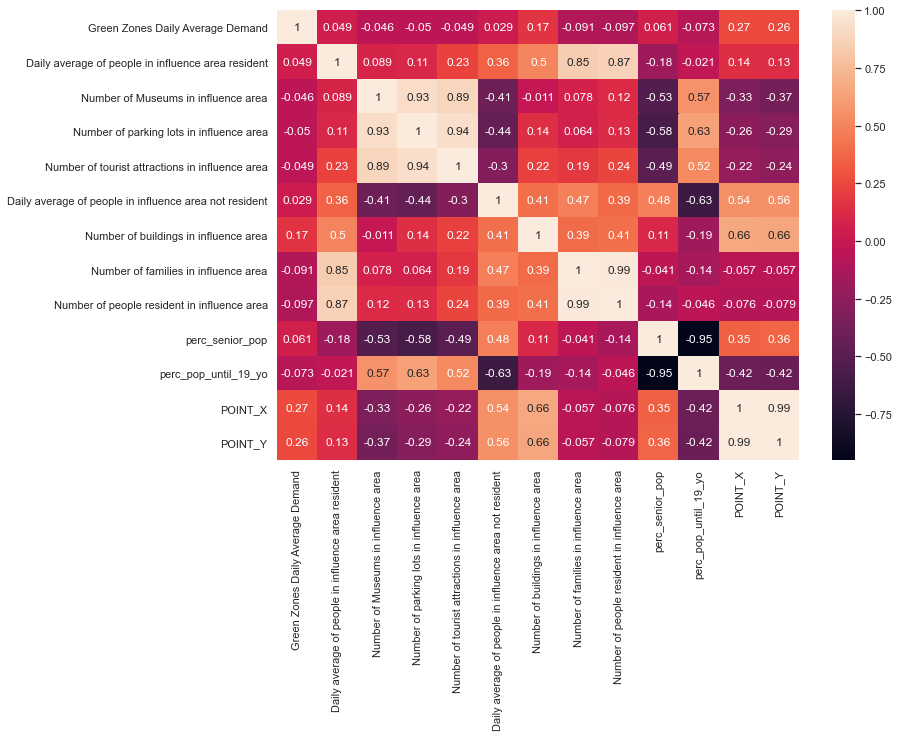

In [8]:
new_green_areas_data_corr = green_areas_data.copy()

first_column = new_green_areas_data_corr.pop('Green Zones Daily Average Demand')
  
# insert column using insert(position,column_name,first_column) function
new_green_areas_data_corr.insert(0, 'Green Zones Daily Average Demand', first_column)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(new_green_areas_data_corr.corr(), annot=True)

Based on the output above, we can infer that the location (Point_X, Point_Y) of the green zone is one of the most significant features for the daily average demand.

### Regression Models
In this section, we compare 3 different regression models used to predict the target column Green Zones Daily Average Demand:

- Linear Regression
- Random Forest
- Gradient Boosting

For all three we used the same train and test split and compared them using the r-square score:
$$
R^2 = 1 - \frac{RSS}{TSS},
$$

where $RSS$ represents the sum of squares of residuals and $TSS$ represents the total sum of squares.

In [9]:
y_data = green_areas_data["Green Zones Daily Average Demand"]
x_data = green_areas_data.drop(["Green_Zone_name", "Green Zones Daily Average Demand"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

#### 1 - Linear Regression

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(x_data)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

reg = LinearRegression().fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)

0.15029813794213664

Text(0.5, 1.0, 'Feature Importance (MDI)')

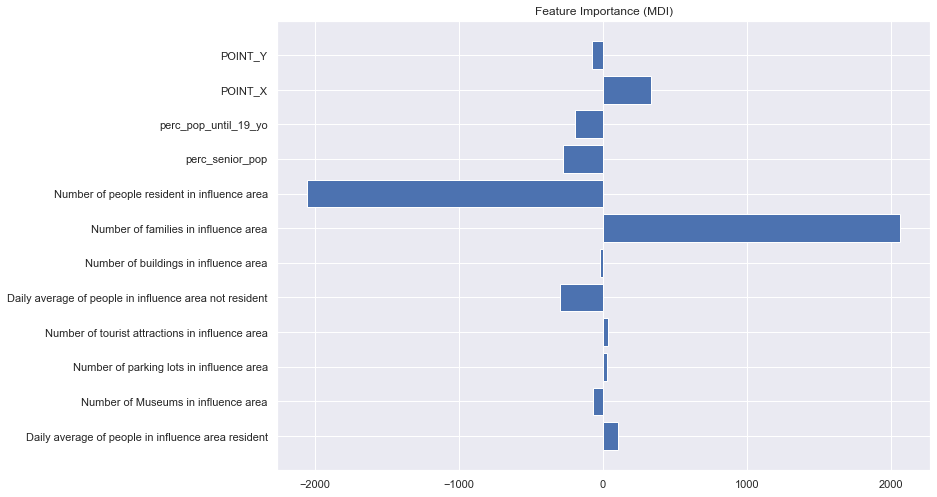

In [11]:
pos = np.arange(reg.coef_.shape[0]) + .5
plt.barh(pos, reg.coef_, align='center')
plt.yticks(pos, x_data.columns.values)
plt.title('Feature Importance (MDI)')

Looking at the plot, we can see that the features that are more relevant for the linear regression are the Number of people resident in influence area and the Number of families in influence area.

#### 2 - Random Forest

In [12]:
params = {
    'max_depth': 2,
    'random_state': 0
}
regr = RandomForestRegressor(**params)
regr.fit(x_train, y_train)
regr.score(x_test, y_test)

-0.21481437999290653

#### 3 - Gradient Boosting

In [13]:
params = {'n_estimators': 1000,
          'max_depth': 8,
          'min_samples_split': 2,
          'learning_rate': 0.001,
          'loss': 'ls',
          'random_state': 0
        }
regr = GradientBoostingRegressor(**params)
regr.fit(x_train, y_train)
regr.score(x_test, y_test)

-0.32167052856720435

With the original dataset the best regressor was the linear regression. However, it had a very low performance. This may be due to the lack of data, since we only have 64 samples with few features. 
For the three regressors, we considered irrelevant doing hyperparameter tunning, since we believe it would only overfit the data.

In the next section, we try to improve the regressors by adding extra features.

## External Data & Feature Engineering

In [14]:
green_areas_data_fe = green_areas_data.copy()

### Calculate relevant distances
To improve the prediction of the average demand for a green zone, we considered 3 new features related with distances:
- **distance to the closest green zone**. If two green zones are really close to each other they are probably going to split the demand.
- **distance to the closest bike road**. If a green zone is well served by bike roads it can easily increase the number of people passing time in it.
- **distance to the closest city region centroid**. The centroids considered are weighed by the region's population, so green zones closer to a centroid may have higher demands.


#### 1 - Distance to closest green zone

In [15]:
green_areas_data_fe['coord'] = list(zip(green_areas_data_fe.POINT_X, green_areas_data_fe.POINT_Y))
all_coords = list(green_areas_data_fe.coord)

In [16]:
def min_distance_other_green_spots(spot):
    min_dist = 9999999
    closest_green_spot = None
    for each in all_coords:
        d = haversine(each, spot)
        if (d < min_dist and d > 0):
            min_dist = d
    return min_dist

green_areas_data_fe['dist_closest_green_area'] = green_areas_data_fe['coord'].apply(lambda x : min_distance_other_green_spots(x))

#### 2 - Calculate distance to the closest bike road

In [17]:
with open("../data/LisbonCyclingNetwork.geojson", encoding="utf8") as f:
    cycling_network = geojson.load(f)
# clean dirty values
arr = []
for feature in cycling_network["features"]:
    if len(feature['geometry']['coordinates']) > 3:
        arr.append(feature)

In [18]:
all_ciclabile_dict = dict()
for each in arr:
    name = each["properties"]["nome"]
    tuple_coords = [(x[0],x[1]) for x in each["geometry"]["coordinates"]]
    if name not in all_ciclabile_dict.keys():
        all_ciclabile_dict[name] = tuple_coords
    else:
        all_ciclabile_dict[name] = all_ciclabile_dict[name] + tuple_coords

In [19]:
def min_distance_from_ciclabile(spot):
    min_dist = 9999999
    closest_ciclabile = None
    for ciclabile in all_ciclabile_dict:
        for each in all_ciclabile_dict[ciclabile]:
            d = haversine(each, spot)
            if (d < min_dist):
                min_dist = d
                closest_ciclabile = ciclabile
    return closest_ciclabile,min_dist

In [20]:
green_areas_data_fe['tuple_closest_ciclabile'] = green_areas_data_fe['coord'].apply(lambda x : min_distance_from_ciclabile(x))
green_areas_data_fe['closest_ciclabile'] = green_areas_data_fe['tuple_closest_ciclabile'].apply(lambda x : x[0])
green_areas_data_fe['dist_closest_ciclabile'] = green_areas_data_fe['tuple_closest_ciclabile'].apply(lambda x : x[1])

Only Lisbon values makes sense, because we only gathered information about bike roads in Lisbon.

In [21]:
green_areas_data_fe = green_areas_data_fe[green_areas_data_fe['POINT_X'] < -9].sort_values(by='dist_closest_ciclabile', ascending=False)

In [22]:
#clean the dataset
green_areas_data_fe = green_areas_data_fe.drop(['tuple_closest_ciclabile', 'closest_ciclabile', 'coord'], axis=1)

#### 3 - Calculate closest centroid distance

In [23]:
with open(DATA_DIR+"TravelSurveyLisbon.geojson", encoding="utf8") as f:
    travel_survey_lisbon = geojson.load(f)

In [24]:
all_points_interest = list()

for each_trace in travel_survey_lisbon['features']:
    for each_spot in each_trace['geometry']['coordinates']:
        if each_spot not in all_points_interest:
            all_points_interest.append(each_spot)

In [25]:
centroid_data = list()
for _, row in green_areas_data_fe.iterrows():
    each_long = row['POINT_X']
    each_lat = row['POINT_Y']
    
    garden_loc = (each_lat, each_long)
    max_value = 100
    
    for each_centroid in all_points_interest:
        each_centroid_loc = tuple((each_centroid[1], each_centroid[0]))
        dist = haversine(tuple(garden_loc), tuple(each_centroid_loc), unit='km')
        if dist < max_value:
            max_value = dist
    
    centroid_data.append(max_value)

green_areas_data_fe["Distance_closest_centroid"] = centroid_data

In [26]:
print('Nr of green zones in Lisbon:', green_areas_data_fe.shape[0])
print('Nr of features:', green_areas_data_fe.shape[1])
green_areas_data_fe.head()

Nr of green zones in Lisbon: 51
Nr of features: 17


,Green_Zone_name,Daily average of people in influence area resident,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area not resident,Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,dist_closest_green_area,dist_closest_ciclabile,Distance_closest_centroid
19,JARDIM DE BUCELAS,552.667924,0,1,0,5.665942,250.571925,2063,1893,4663,0.226678,0.174780,-9.117490,38.90102,9.584019,11.738086,13.253738
44,PARQUE DA CIDADE DE LOURES,17235.051457,1,9,4,1047.505649,6008.626849,5028,10598,27362,0.161501,0.209341,-9.161535,38.82598,3.439410,4.777911,4.530226
54,PARQUE URBANO DA QUINTA NOVA,30892.425376,0,3,0,153.690076,36577.848107,3521,24581,59559,0.161672,0.197283,-9.176870,38.79877,0.676812,2.711684,2.377909
55,PARQUE URBANO DO CASTELINHO,30892.425376,0,1,0,215.385850,36577.848107,3521,24581,59559,0.161672,0.197283,-9.181560,38.79484,0.676812,2.243194,2.498352
56,PARQUE URBANO DO SILVADO,30892.425376,1,1,1,8.140077,36577.848107,3521,24581,59559,0.161672,0.197283,-9.182490,38.78463,1.125515,1.132450,2.309521


#### Regression

In [27]:
y_data = green_areas_data_fe["Green Zones Daily Average Demand"]
x_data = green_areas_data_fe.drop(["Green_Zone_name", "Green Zones Daily Average Demand"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

#### 1 - Linear Regression

In [28]:
scaler = StandardScaler()
scaler = scaler.fit(x_data)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

reg = LinearRegression().fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)

-0.0007848878098100087

#### 2 - Random Forest

In [29]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)
regr.score(x_test, y_test)

-0.151408761473933

#### 2 - Gradient Boosting

In [30]:
params = {'n_estimators': 1000,
          'max_depth': 8,
          'min_samples_split': 2,
          'learning_rate': 0.001,
          'loss': 'ls',
          'random_state': 0}
rg = GradientBoostingRegressor(**params)
rg.fit(x_train, y_train)
rg.score(x_test, y_test)

-0.008828058013798934

From the obtained r-squared scores, we can see that the distances did not improve any of the three regressors.

### Lisbon public school data for each green area
Another feature that we believed could help in predicting the average demand for a green zone was the number of schools for which a given green zone was the closest green area. That is, if for example zone 1 is the closest green area to 4 schools in lisbon the number of schools mapped to zone 1 will be 4.
We also considered the average distance of those schools to the area itself.

We believe this as kids tend to go to the park with friends or their parents (depending on the age) after school to enjoy their free time.

To build these 2 extra features we gathered from the https://dados.gov.pt/pt/search/?q=escolas+lisboa page, information about all public schools (from pre-school to highschool) in Lisbon. 

Note: We did not find information concerning Porto public schools. As such in these analysis, we will also consider only the Lisbon green areas.

In [31]:
df_preschools = geopandas.read_file(DATA_DIR + "escolas-publicas-preescolar.geojson")
df_1st_cycle_schools = geopandas.read_file(DATA_DIR + "escolas-publicas-1ciclo.geojson")
df_2nd_cycle_schools = geopandas.read_file(DATA_DIR + "escolas-publicas-2ciclo.geojson")
df_3rd_cycle_schools = geopandas.read_file(DATA_DIR + "escolas-publicas-3ciclo.geojson")
df_highschools = geopandas.read_file(DATA_DIR + "escolas-publicas-secundario.geojson")

In [32]:
df_all_schools = pd.concat([df_preschools, df_1st_cycle_schools, df_2nd_cycle_schools, df_3rd_cycle_schools, df_highschools])
df_all_schools = df_all_schools.drop_duplicates()

print('Nr of public schools in Lisbon:', df_all_schools.shape[0])
print('Nr of features:', df_all_schools.shape[1])
df_all_schools.head()

Nr of public schools in Lisbon: 265
Nr of features: 14


,OBJECTID,COD_SIG,IDTIPO,INF_NOME,INF_MORADA,INF_TELEFONE,INF_FAX,INF_EMAIL,INF_SITE,INF_DESCRICAO,INF_FONTE,INF_MUNICIPAL,GlobalID,geometry
0,1,0101901045001001,999,JI Alexandre Rodrigues Ferreira,"Rua Coronel Pereira da Silva, 18",+351 213 634 446; +351 213 616 480,None,mariafelicidade.silva@aefarruda.pt; geral@aefa...,https://aefarruda.pt/portal/,Agrupamento: Francisco de Arruda.GUAS: Sudoest...,Ministério da Educação,1,28844c4c-50de-45a0-adb7-e570753af10b,POINT (-9.19752 38.70417)
1,2,3503002130001002,999,Escola Básica Engenheiro Ressano Garcia,Rua Professor Gomes Teixeira,+351 213 969 870; +351 925 259 860,None,isabel-mendes@e-josefadeobidos.edu.pt; geral@e...,https://e-josefadeobidos.edu.pt/Portal/index.p...,Agrupamento: Padre Bartolomeu de Gusmão \nAno ...,Ministério da Educação,1,e1f9f434-2104-4ad2-87f0-57487150670c,POINT (-9.16596 38.71370)
2,3,4501101073001002,999,Escola Básica São José,"Rua do Telhal, 10",+351 218 851 455; +351 927 591 013,None,info@aepassosmanuel.pt,http://aepassosmanuel.pt/escolas/eb1-ji-sao-jose/,Agrupamento: Passos Manuel\nAno de Construção ...,Ministério da Educação,1,304178a7-4332-4566-9d0e-91ef2654541c,POINT (-9.14204 38.71921)
3,4,0806703069001001,999,Jardim de Infância Benfica Nº 1,"Estrada de Benfica, 547/549",+351 217 169 692; +351 938 329 934,None,jin1.benfica@aebenfica.pt,https://sites.google.com/a/aebenfica.pt/aeb-ji1/,Agrupamento: Benfica,Ministério da Educação,1,2e959766-8b43-44af-ae56-b4af199f813e,POINT (-9.19698 38.74743)
4,5,3503305038001002,999,Escola Básica Vale de Alcântara,Avenida de Ceuta Norte - Bairro Quinta do Lour...,+351 213 622 608,None,escola.valedealcantara@gmail.com; geral@agesco...,https://agescolasmanuelmaia.net/,Agrupamento: Manuel da Maia,Ministério da Educação,1,c561437a-edbf-4b3c-9b24-291034cda967,POINT (-9.17454 38.71754)


Although many features are provided, we only used the geometry column, in order to assess for each school the nearest green zone area in Lisbon.

In [33]:
df_all_schools = df_all_schools[['INF_NOME', 'geometry']]
df_all_schools = df_all_schools.drop_duplicates()
print('Nr of public schools in Lisbon:', df_all_schools.shape[0])
print('Nr of features:', df_all_schools.shape[1])
df_all_schools.head()

Nr of public schools in Lisbon: 210
Nr of features: 2


,INF_NOME,geometry
0,JI Alexandre Rodrigues Ferreira,POINT (-9.19752 38.70417)
1,Escola Básica Engenheiro Ressano Garcia,POINT (-9.16596 38.71370)
2,Escola Básica São José,POINT (-9.14204 38.71921)
3,Jardim de Infância Benfica Nº 1,POINT (-9.19698 38.74743)
4,Escola Básica Vale de Alcântara,POINT (-9.17454 38.71754)


#### Find for each Lisbon school the nearest green zone
First, we need to get only the Lisbon green zones.

In [34]:
lisbon_green_zones = green_areas_data[green_areas_data["POINT_Y"]<40]

In [35]:
closest_zone = {'School': [], 'Closest Green Zone': [], 'Distance': []}
for _, school_row in df_all_schools.iterrows():
    closest_zone['School'].append(school_row['INF_NOME'])
    closest_zone_distance, closest_zone_name = float('inf'), None
    for _, green_zone in lisbon_green_zones.iterrows():
        distance = haversine((school_row['geometry'].centroid.x, school_row['geometry'].centroid.y),
                             (green_zone['POINT_X'], green_zone['POINT_Y']),
                             unit=Unit.KILOMETERS)
        if distance < closest_zone_distance:
            closest_zone_distance = distance
            closest_zone_name = green_zone['Green_Zone_name']
    closest_zone['Distance'].append(closest_zone_distance)
    closest_zone['Closest Green Zone'].append(closest_zone_name)

In [36]:
school_closest_zone = pd.DataFrame(closest_zone)
print('Nr of public schools in Lisbon:', school_closest_zone.shape[0])
print('Nr of features:', school_closest_zone.shape[1])
school_closest_zone.head()

Nr of public schools in Lisbon: 210
Nr of features: 3


,School,Closest Green Zone,Distance
0,JI Alexandre Rodrigues Ferreira,JARDIM AFONSO DE ALBUQUERQUE,0.843918
1,Escola Básica Engenheiro Ressano Garcia,JARDIM NOVE DE ABRIL,1.051184
2,Escola Básica São José,JARDIM BRAAMCAMP FREIRE,0.335671
3,Jardim de Infância Benfica Nº 1,MATA DE BENFICA,0.785475
4,Escola Básica Vale de Alcântara,JARDIM AVELAR BROTERO,1.850485


#### Then, we count for each green zone the number of schools for which it is the closest green zone and the average distance of the schools to it.

In [37]:
aggregation = dict([('School', 'nunique'), ('Distance', 'mean')])
green_zones_with_schools = school_closest_zone.groupby('Closest Green Zone')\
                           .agg(aggregation)\
                           .rename(columns={'Distance': 'Avg Distance', 'School': '# Schools'})\
                           .reset_index()
print('Nr of green zones:', green_zones_with_schools.shape[0])
print('Nr of features:', green_zones_with_schools.shape[1])
green_zones_with_schools.head()

Nr of green zones: 35
Nr of features: 3


,Closest Green Zone,# Schools,Avg Distance
0,JARDIM AFONSO DE ALBUQUERQUE,7,1.139859
1,JARDIM ALAMEDA DOM AFONSO HENRIQUES,16,1.999790
2,JARDIM ANTÓNIO NOBRE,1,0.169291
3,JARDIM AVELAR BROTERO,7,0.748814
4,JARDIM BENTO MARTINS,3,0.876986


35 of Lisbon's green zones (out of 51), are the closest green zone of at least one school.
Next, we'll add green zones that weren't mapped to any school.

In [38]:
zero_schools_zones = pd.DataFrame()
zero_schools_zones['Closest Green Zone'] = lisbon_green_zones[~lisbon_green_zones['Green_Zone_name'].isin(green_zones_with_schools['Closest Green Zone'])]['Green_Zone_name']
zero_schools_zones['# Schools'] = 0
zero_schools_zones['Avg Distance'] = -1
print('Nr of green zones:', zero_schools_zones.shape[0])

Nr of green zones: 16


In [39]:
green_zones_with_schools = pd.concat([green_zones_with_schools, zero_schools_zones])
green_zones_with_schools = pd.merge(green_areas_data, green_zones_with_schools, left_on='Green_Zone_name', right_on='Closest Green Zone')
green_zones_with_schools = green_zones_with_schools.drop('Closest Green Zone', axis=1)
print('Nr of green zones:', green_zones_with_schools.shape[0])
print('Nr of features:', green_zones_with_schools.shape[1])
green_zones_with_schools.head()

Nr of green zones: 51
Nr of features: 16


,Green_Zone_name,Daily average of people in influence area resident,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area not resident,Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,# Schools,Avg Distance
0,JARDIM AFONSO DE ALBUQUERQUE,17497.825376,93,129,78,10.259113,42877.741202,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674,7,1.139859
1,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,17497.825376,8,23,4,47.347816,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294,0,-1.000000
2,JARDIM ALAMEDA DOM AFONSO HENRIQUES,17235.051457,105,175,84,41.485945,6008.626849,5028,10598,27362,0.161501,0.209341,-9.13207,38.73757,16,1.999790
3,JARDIM AMÁLIA RODRIGUES,7104.740926,8,8,4,5.768512,32809.647241,2472,6729,15460,0.240815,0.163131,-9.15459,38.73062,0,-1.000000
4,JARDIM AMÉLIA CARVALHEIRA,9928.080489,104,139,72,57.137086,491.636442,2041,4529,12701,0.104874,0.260294,-9.15018,38.73919,0,-1.000000


#### Regression

In [40]:
y_data = green_zones_with_schools["Green Zones Daily Average Demand"]
x_data = green_zones_with_schools.drop(["Green_Zone_name", "Green Zones Daily Average Demand"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

#### 1 - Linear Regression

In [41]:
scaler = StandardScaler()
scaler = scaler.fit(x_data)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

reg = LinearRegression().fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)

-0.7701041277334826

#### 2 - Random Forest

In [42]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)
regr.score(x_test, y_test)

0.4546021461109554

With the school data we see a big improvement in the r-square metric of the regressor, compared to the previous analysis. However, the regressor is still underperforming. Below, we can see the feature importance of the obtained regressor.

RandomForestRegressor(max_depth=2, random_state=0)


Text(0.5, 1.0, 'Feature Importance (MDI)')

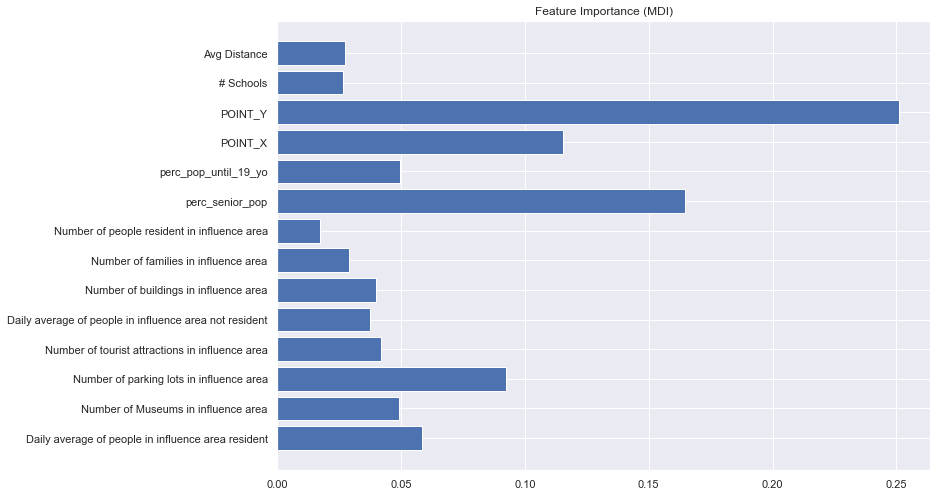

In [43]:
pos = np.arange(regr.feature_importances_.shape[0]) + .5
plt.barh(pos, regr.feature_importances_, align='center')
plt.yticks(pos, x_data.columns.values)
print(regr)
plt.title('Feature Importance (MDI)')

Although the two extra features concerning schools improved the overall score of the Random Forest regressor, we can see from the plot that they are not the most relevant features.
The 3 most important are: Point_Y (the latitude), the percentage of senior population and Point_X (the longitude). These results corroborate the conclusions reached from the correlation matrix.

#### 3 - Gradient Boosting

In [44]:
params = {'n_estimators': 1000,
          'max_depth': 8,
          'min_samples_split': 2,
          'learning_rate': 0.001,
          'loss': 'ls',
          'random_state': 0}
rg = GradientBoostingRegressor(**params)
rg.fit(x_train, y_train)
rg.score(x_test, y_test)

0.07815404635237899

Although the schools' information helped to increase the r-square metric of the Gradient Boosting regressor, it is greatly lower than the result obtained with the Random Forest.

### Lisbon green zones extra characteristics

In [45]:
with open(DATA_DIR+"raw_lisbon_gardens.geojson", encoding='utf-8') as f:
    lisbon_green_zones_extra = geojson.load(f)

In [46]:
lisbon_green_zones_extra_df = pd.DataFrame()
for tmp_garden in lisbon_green_zones_extra["features"]:
    
    category = tmp_garden["properties"]["CAT_NOME"]
    name = tmp_garden["properties"]["INF_NOME"]
    description = tmp_garden["properties"]["INF_DESCRICAO"]
    point_x = tmp_garden["geometry"]["coordinates"][0]
    point_y = tmp_garden["geometry"]["coordinates"][1]
    municipal = tmp_garden["properties"]["INF_MUNICIPAL"]
    
    tmp_garden_df = pd.DataFrame([[name, category, point_x, point_y, description, municipal]], columns=["name", "category", "point_x", "point_y", "description", "is_municipal"])
    lisbon_green_zones_extra_df = pd.concat([lisbon_green_zones_extra_df, tmp_garden_df])
lisbon_green_zones_extra_df = lisbon_green_zones_extra_df.reset_index(drop=True)

In [47]:
print('Nr of green zones:', lisbon_green_zones_extra_df.shape[0])
print('Nr of features:', lisbon_green_zones_extra_df.shape[1])
lisbon_green_zones_extra_df.head()

Nr of green zones: 147
Nr of features: 6


,name,category,point_x,point_y,description,is_municipal
0,Parque da Tapada da Ajuda,Espaços Verdes e Lazer - Jardins / Parques Urb...,-9.186534,38.712520,A sua génese remonta a 1645 como Tapada Real d...,1
1,Jardim Fialho de Almeida,Espaços Verdes e Lazer - Jardins / Parques Urb...,-9.151643,38.715059,"Pequena praça conhecida por Praça das Flores, ...",1
2,Jardim Botto Machado / Jardim de Santa Clara,Espaços Verdes e Lazer - Jardins / Parques Urb...,-9.124189,38.715937,"Pequeno espaço verde municipal, gradeado e com...",1
3,Parque José Gomes Ferreira - Mata de Alvalade,Espaços Verdes e Lazer - Jardins / Parques Urb...,-9.132082,38.758482,Integrado na Estrutura Verde Principal da cida...,1
4,Jardim Vasco da Gama,Espaços Verdes e Lazer - Jardins / Parques Urb...,-9.203221,38.696281,"Construído nos anos oitenta do século XX, proj...",0


Inside the description field we can find detailed information about the park's history and characteristics. We parsed that description and obtained the following features (most of them boolean, indicating whether the feature is present or not):
- *area_ha*: the area of the park in hectares
- *quiosque*: whether the park has a kiosk or not
- *restaurante*: whether the park has a restaurant or not
- *esplanada*: whether the park has a terrace or not
- *fitness*: whether the park has a fitness zone or not
- *parque_infantil*: whether the park has a children playground or not
- *parque_merendas*: whether the park has a snack park or not
- *estatuaria*: whether the park has statues or not
- *parque_canino*: whether the park has a dog park or not
- *lago*: whether the park has a lake or not

Due to some of the parks having different names, the datasets were merged based on the location of the parks (https://www.usna.edu/Users/oceano/pguth/md_help/html/approx_equivalents.html 0,001 degrees) and later checked to see if the merging was done correctly. However this dataset was only available for parks in the Lisbon area, and not all of the Lisbon parks on the original dataset mapped to a park of this dataset. Due to this the final dataset had 39 parks.

In [48]:
lisbon_green_zones_enriched = pd.read_csv(DATA_DIR + 'lisbon_gardens_enriched.csv')
lisbon_green_zones_enriched = lisbon_green_zones_enriched.dropna()
print('Nr of green zones:', lisbon_green_zones_enriched.shape[0])
print('Nr of features:', lisbon_green_zones_enriched.shape[1])
lisbon_green_zones_enriched.head()

Nr of green zones: 39
Nr of features: 24


,Green_Zone_name,Daily average of people in influence area resident,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area not resident,Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,...,area_ha,quiosque,fitness,restaurante,esplanada,parque_canino,parque_infantil,parque_merendas,estatuaria,lago
1,JARDIM AFONSO DE ALBUQUERQUE,17497.825376,93,129,78,10.259113,42877.741202,1775,17185,41163,...,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,17235.051457,105,175,84,41.485945,6008.626849,5028,10598,27362,...,3.30,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,JARDIM AMÁLIA RODRIGUES,7104.740926,8,8,4,5.768512,32809.647241,2472,6729,15460,...,5.70,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
5,JARDIM AMÉLIA CARVALHEIRA,9928.080489,104,139,72,57.137086,491.636442,2041,4529,12701,...,0.20,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,JARDIM ANTÓNIO NOBRE,17497.825376,93,79,50,4.468216,42877.741202,1775,17185,41163,...,0.65,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


#### Regression

In [49]:
y_data = lisbon_green_zones_enriched["Green Zones Daily Average Demand"]
x_data = lisbon_green_zones_enriched.drop(["Green_Zone_name", "Green Zones Daily Average Demand"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

#### 1 - Linear Regression

In [50]:
scaler = StandardScaler()
scaler = scaler.fit(x_data)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

reg = LinearRegression().fit(x_train_scaled, y_train)
reg.score(x_test_scaled, y_test)

-3.520016339211616

#### 2 - Random Forest

In [51]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_train, y_train)
regr.score(x_test, y_test)

-0.04600120153820075

#### 3 - Gradient Boosting

In [52]:
params = {'n_estimators': 1000,
          'max_depth': 8,
          'min_samples_split': 2,
          'learning_rate': 0.001,
          'loss': 'ls',
          'random_state': 0}
rg = GradientBoostingRegressor(**params)
rg.fit(x_train, y_train)
rg.score(x_test, y_test)

0.689896105909634

GradientBoostingRegressor(learning_rate=0.001, max_depth=8, n_estimators=1000,
                          random_state=0)


Text(0.5, 1.0, 'Feature Importance (MDI)')

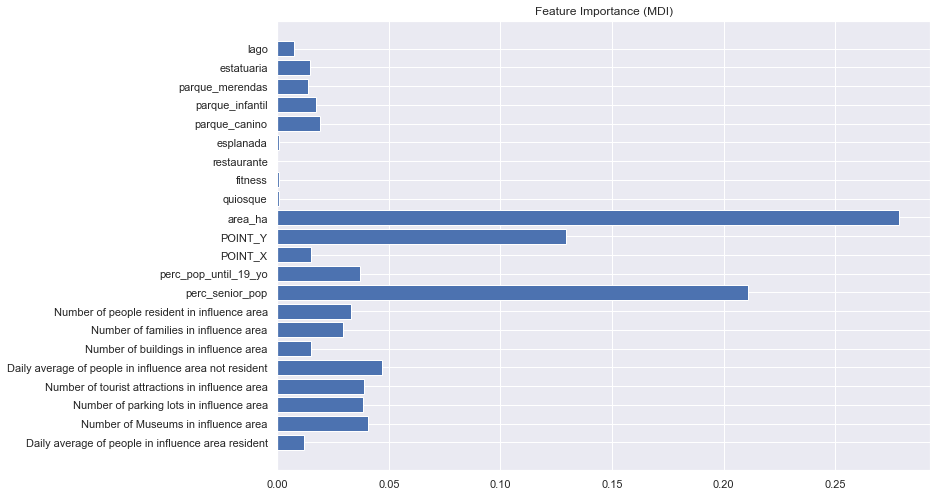

In [53]:
pos = np.arange(rg.feature_importances_.shape[0]) + .5
plt.barh(pos, rg.feature_importances_, align='center')
plt.yticks(pos, x_data.columns.values)
print(rg)
plt.title('Feature Importance (MDI)')

With the new extra features, the gradient boosting regressor achieves the best performance. From the plot, we can see that the more relevant features for the regressor are the area, the percentage of senior population and Point_Y (the latitude). Assuming a positive correlation, the area is an expected outcome, since larger green zones are able to gather more people. As such, extending existing parks can probably improve their demand.

The Point_Y being also an important feature indicates that the location of the green zone has an impact on its demand. This suggests that the neighborhoods close to the green zone have an influence on the number of people going there. From the literature (https://www.un.org/en/chronicle/article/green-spaces-invaluable-resource-delivering-sustainable-urban-health), the high availability of parks is related with how expensive the neighborhood is. So, doing this analysis in Lisbon would allow us to suggest new zones where to build new parks.

Regarding the extra features, we can conclude that the parque_canino (canine park) is the most relevant feature. From our experience, we expect the correlation to be positive, since it allows people to enjoy their time in green zones with their pets. A similar conclusion can be taken for the children playground. Assuming the positive correlation, building these types of playgrounds can attract more people to an existing green zone. 

## Conclusions

### Scalability and Impact
Our solution framework is applicable and scalable to any city, under the obvious assumption of having the required data related to its green zones. We show that using only city open data we were able to enrich the dataset with many of the features considered relevant for such analysis (based on the literature and our social understanding of the problem), obtaining satisfying results for some of the datasets and models even with the very small number of samples we had available.

Being able to forecast the Green Zones Daily Average Demand is usefull also when planning a new park. Since the other variables can be obtained (or estimated) without the physical existence of the park, we can use the best model to predict that target variable and to make a more informed decision on whether it is worth it to build (using the forecast together with the more "standard" analysis that are currently done).

From the perspective of attracting the population to green spaces, these same models can be used in a descriptive way to make an analysis like the one we did, understanding the most relevant features impacting the target variable and building an "action plan" to drive it in the intended direction. For more accurate results we suggest to do this analysis on the city level, as the conclusions are likely to change depending on the characteristics of the population under analysis.

### Future Work
We believe that the key to provide a better solution for the problem relies mostly on having access to more data. If we could get for the parks in Porto characteristics like the ones we obtained for Lisbon the dataset would get better and allow for an analysis of both cities. This could be done even by contacting some local citizens that visit some of the parks, and so it wouldn't require a big effort. Also, obtaining the average demand and similar features for more parks in Lisbon would be of much help since the main shortcoming questioning the reliability of the models was the small amount of enriched data available.

In case this was not possible, data augmentation could also be an alternative, creating mock-up parks with an interpolation of the characteristics of the parks in the dataset. Nonetheless, due to its small amount, we would need to pay attention to the possible introduction of bias in the dataset.

From the literature we also understood that safety is one of the main criteria that people take into consideration when going to a green zone. So, including data about the safety (policing level, crime rate, ...) of different zones of the city could also be relevant to improve the results of our analysis. Unfortunately we were not able to find a suitable dataset with this information.